In [246]:
!pip install --upgrade scikit-learn imbalanced-learn pymongo python-dotenv mlxtend joblib

Defaulting to user installation because normal site-packages is not writeable
  Using cached mlxtend-0.24.0-py3-none-any.whl.metadata (7.3 kB)
INFO: pip is looking at multiple versions of mlxtend to determine which version is compatible with other requirements. This could take a while.


In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import numpy as np
import os
import joblib
from dotenv import load_dotenv

from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           silhouette_score, roc_auc_score)

# Load environment variables
load_dotenv()

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [248]:
# Load data from local CSV file
df = pd.read_csv("Dataset/credit_card_fraud_10k.csv")
df.head()

transaction_id  amount  transaction_hour merchant_category  \
0               1   84.47                22       Electronics   
1               2  541.82                 3            Travel   
2               3  237.01                17           Grocery   
3               4  164.33                 4           Grocery   
4               5   30.53                15              Food   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  
0                  3              40         0  
1                  1              64         0  
2                  1              61         0  
3                  3              34         0  
4                  0              44         0

In [249]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       10000 non-null  int64  
 1   amount               10000 non-null  float64
 2   transaction_hour     10000 non-null  int64  
 3   merchant_category    10000 non-null  object 
 4   foreign_transaction  10000 non-null  int64  
 5   location_mismatch    10000 non-null  int64  
 6   device_trust_score   10000 non-null  int64  
 7   velocity_last_24h    10000 non-null  int64  
 8   cardholder_age       10000 non-null  int64  
 9   is_fraud             10000 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [250]:
df.isnull().sum()

transaction_id         0
amount                 0
transaction_hour       0
merchant_category      0
foreign_transaction    0
location_mismatch      0
device_trust_score     0
velocity_last_24h      0
cardholder_age         0
is_fraud               0
dtype: int64

# Dataset Undertsanding (Exploration)
## We decided to do the following to check for imbalance and have better undertsanding of feature behavior:
1. View basic statistics (mean, min, max, std).
2. Count fraud vs non-fraud
3. Visualize imbalance using bar chart or pie chart.

In [251]:
summary = df.describe()
display(summary)

transaction_id        amount  transaction_hour  foreign_transaction  \
count     10000.00000  10000.000000      10000.000000         10000.000000   
mean       5000.50000    175.949849         11.593300             0.097800   
std        2886.89568    175.392827          6.922708             0.297059   
min           1.00000      0.000000          0.000000             0.000000   
25%        2500.75000     50.905000          6.000000             0.000000   
50%        5000.50000    122.095000         12.000000             0.000000   
75%        7500.25000    242.480000         18.000000             0.000000   
max       10000.00000   1471.040000         23.000000             1.000000   

       location_mismatch  device_trust_score  velocity_last_24h  \
count       10000.000000        10000.000000       10000.000000   
mean            0.085700           61.798900           2.008900   
std             0.279935           21.487053           1.432559   
min             0.000000           25.000000           0.000000   
25%             0.000000           43.000000           1.000000   
50%             0.000000           62.000000           2.000000   
75%             0.000000           80.000000           3.000000   
max             1.000000           99.000000           9.000000   

       cardholder_age      is_fraud  
count    10000.000000  10000.000000  
mean        43.468700      0.015100  
std         14.979147      0.121957  
min         18.000000      0.000000  
25%         30.000000      0.000000  
50%         44.000000      0.000000  
75%         56.000000      0.000000  
max         69.000000      1.000000

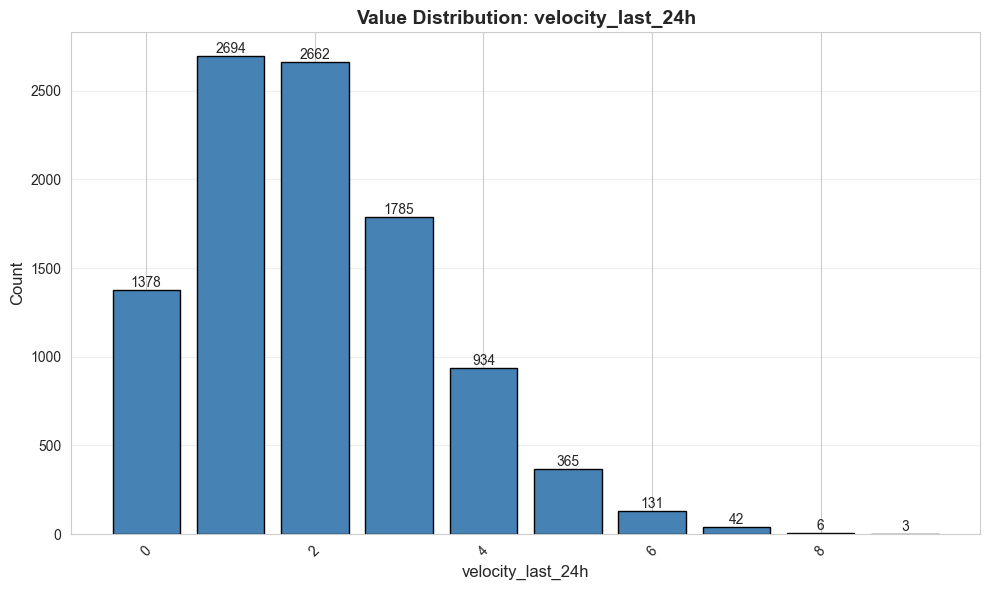

In [252]:
import matplotlib.pyplot as plt

feature = 'velocity_last_24h'

value_counts = df[feature].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel(feature, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Value Distribution: {feature}', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [253]:
print(df['is_fraud'].value_counts())

is_fraud
0    9849
1     151
Name: count, dtype: int64


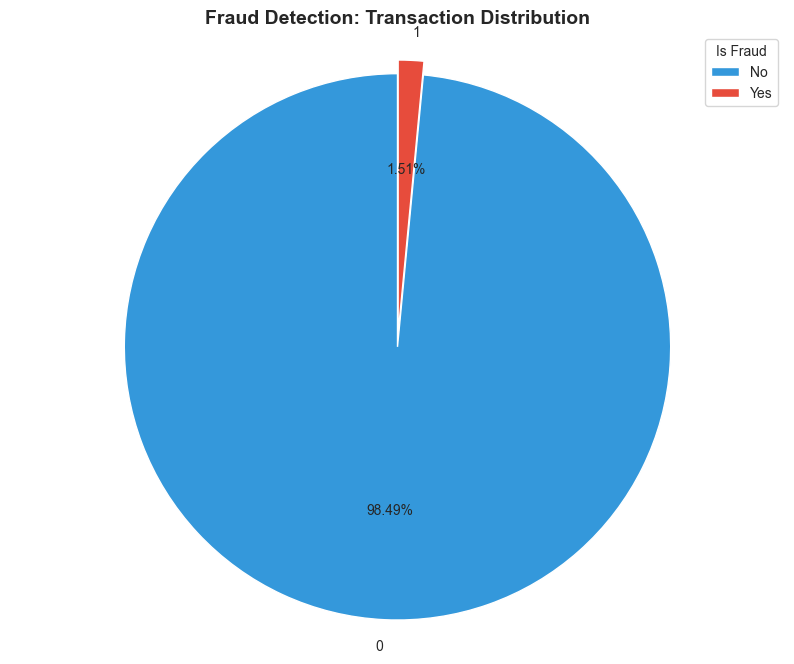

In [254]:
fraud_counts = df['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
explode = (0.05, 0)

plt.pie(fraud_counts.values, 
        labels=fraud_counts.index,
        autopct='%1.2f%%',
        startangle=90,
        explode=explode,
        shadow=False,
        colors=['#3498db', '#e74c3c'])

plt.title('Fraud Detection: Transaction Distribution', fontsize=14, fontweight='bold')
plt.legend(['No','Yes'], title="Is Fraud", loc="best")
plt.axis('equal')
plt.show()

# Data Preprocessing

## 3.1 Data Cleaning

### Steps:

* Check for missing (null) values in every feature.
* Check for duplicate records and remove them.
* Validate data ranges (e.g. negative transaction amount).

In [255]:
df.isna().count()

transaction_id         10000
amount                 10000
transaction_hour       10000
merchant_category      10000
foreign_transaction    10000
location_mismatch      10000
device_trust_score     10000
velocity_last_24h      10000
cardholder_age         10000
is_fraud               10000
dtype: int64

In [256]:
duplicate = df[df.duplicated()]

display(duplicate)

Empty DataFrame
Columns: [transaction_id, amount, transaction_hour, merchant_category, foreign_transaction, location_mismatch, device_trust_score, velocity_last_24h, cardholder_age, is_fraud]
Index: []

In [257]:
df['merchant_category'].value_counts()

merchant_category
Food           2093
Clothing       2050
Travel         1990
Grocery        1944
Electronics    1923
Name: count, dtype: int64

In [258]:
df['velocity_last_24h'].value_counts()

velocity_last_24h
1    2694
2    2662
3    1785
0    1378
4     934
5     365
6     131
7      42
8       6
9       3
Name: count, dtype: int64

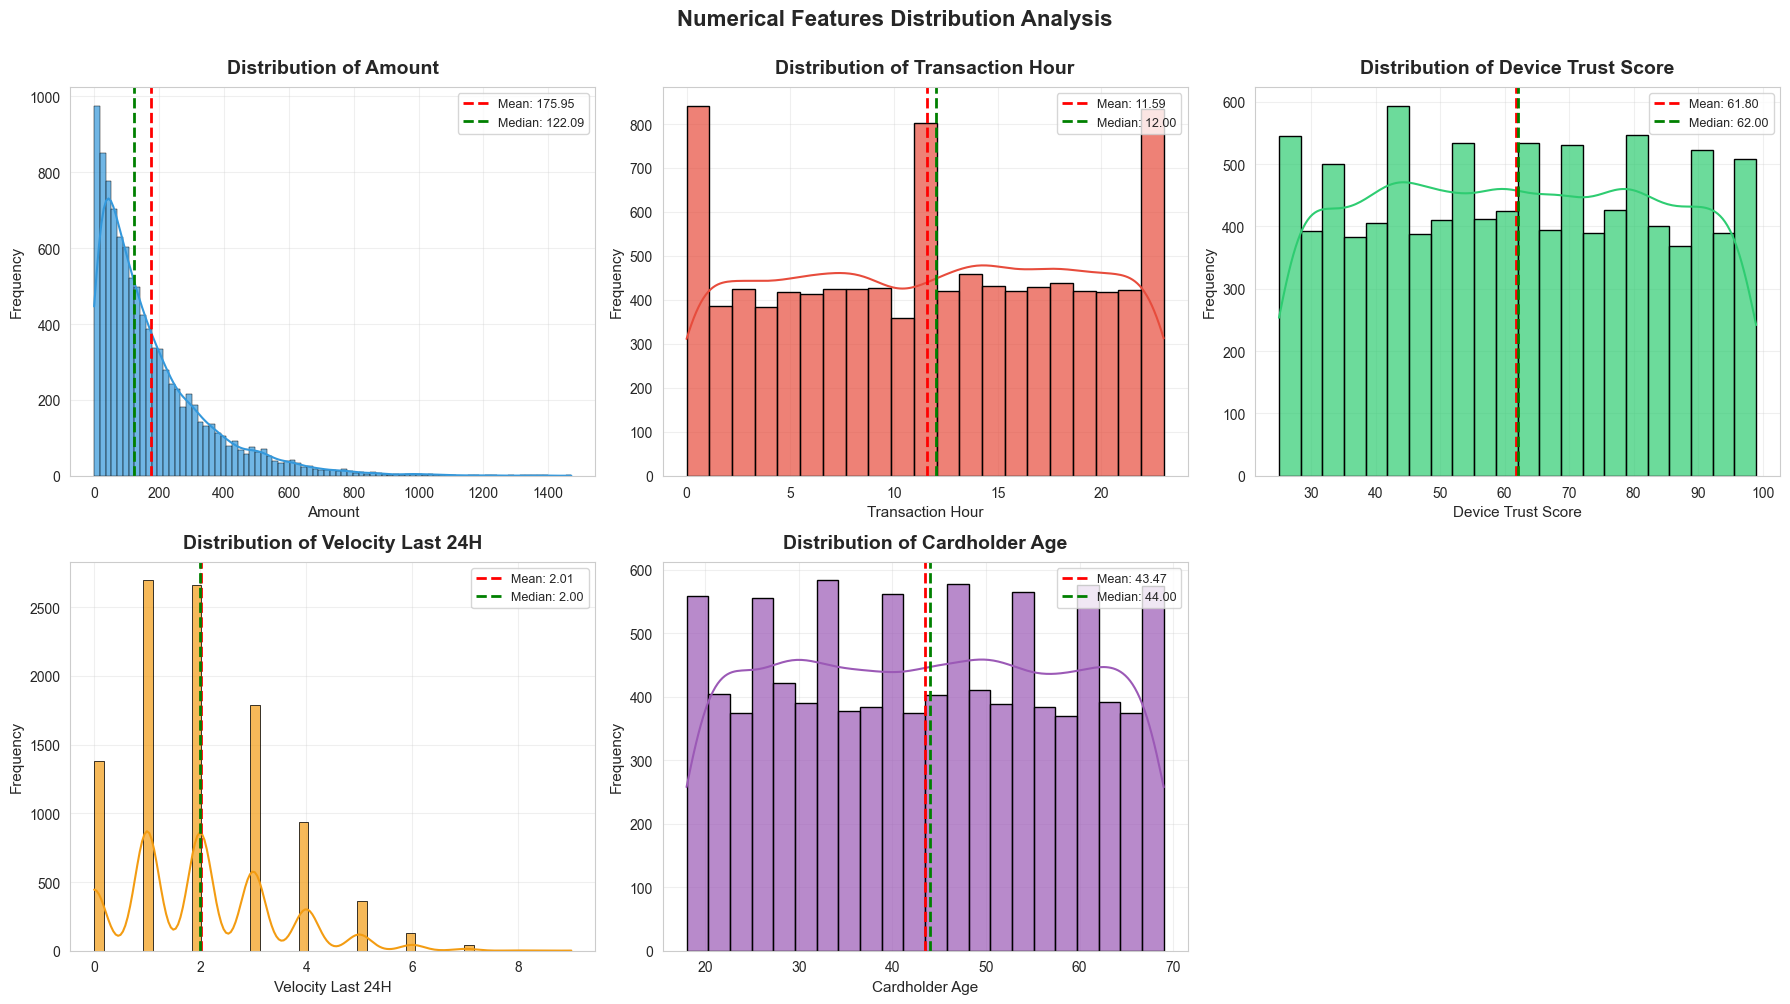

In [259]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

num_cols = [
    "amount", "transaction_hour", "device_trust_score",
    "velocity_last_24h", "cardholder_age"
]

# Create subplots - all in one figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define a nice color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, col in enumerate(num_cols):
    # Create histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[idx], 
                 color=colors[idx], edgecolor='black', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Styling
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', 
                        fontsize=14, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.suptitle('Numerical Features Distribution Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 3.2 Data Transformation

### Steps:

* Normalize transaction amount.
* Encode Merchant Category.

In [260]:
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['merchant_category'])

print("Original vs Encoded:")
print(df[['merchant_category', 'category_encoded']].head(10))
print("\nMapping:")
print(dict(zip(le.classes_, le.transform(le.classes_))))

Original vs Encoded:
  merchant_category  category_encoded
0       Electronics                 1
1            Travel                 4
2           Grocery                 3
3           Grocery                 3
4              Food                 2
5          Clothing                 0
6            Travel                 4
7       Electronics                 1
8           Grocery                 3
9           Grocery                 3

Mapping:
{'Clothing': 0, 'Electronics': 1, 'Food': 2, 'Grocery': 3, 'Travel': 4}


In [261]:
df.head()

transaction_id  amount  transaction_hour merchant_category  \
0               1   84.47                22       Electronics   
1               2  541.82                 3            Travel   
2               3  237.01                17           Grocery   
3               4  164.33                 4           Grocery   
4               5   30.53                15              Food   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  category_encoded  
0                  3              40         0                 1  
1                  1              64         0                 4  
2                  1              61         0                 3  
3                  3              34         0                 3  
4                  0              44         0                 2

In [262]:
df['merchant_category'] = df['category_encoded']
df.drop(columns=['merchant_category','amount'])

transaction_id  transaction_hour  foreign_transaction  \
0                  1                22                    0   
1                  2                 3                    1   
2                  3                17                    0   
3                  4                 4                    0   
4                  5                15                    0   
...              ...               ...                  ...   
9995            9996                22                    0   
9996            9997                 5                    0   
9997            9998                21                    0   
9998            9999                 2                    0   
9999           10000                 2                    0   

      location_mismatch  device_trust_score  velocity_last_24h  \
0                     0                  66                  3   
1                     0                  87                  1   
2                     0                  49                  1   
3                     1                  72                  3   
4                     0                  79                  0   
...                 ...                 ...                ...   
9995                  0                  99                  4   
9996                  0                  70                  3   
9997                  0                  44                  2   
9998                  0                  38                  0   
9999                  0                  38                  0   

      cardholder_age  is_fraud  category_encoded  
0                 40         0                 1  
1                 64         0                 4  
2                 61         0                 3  
3                 34         0                 3  
4                 44         0                 2  
...              ...       ...               ...  
9995              37         0                 2  
9996              25         0                 0  
9997              45         0                 1  
9998              37         0                 1  
9999              66         0                 0  

[10000 rows x 9 columns]

In [263]:
df.head()

transaction_id  amount  transaction_hour  merchant_category  \
0               1   84.47                22                  1   
1               2  541.82                 3                  4   
2               3  237.01                17                  3   
3               4  164.33                 4                  3   
4               5   30.53                15                  2   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  is_fraud  category_encoded  
0                  3              40         0                 1  
1                  1              64         0                 4  
2                  1              61         0                 3  
3                  3              34         0                 3  
4                  0              44         0                 2

## 3.3 Data Reduction

### Steps:

* Identify irrelevant or redundant features.
* Remove features with very low variance.
* Apply feature selection techniques: Correlation analysis

In [264]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [265]:
X.head()

transaction_id  amount  transaction_hour  merchant_category  \
0               1   84.47                22                  1   
1               2  541.82                 3                  4   
2               3  237.01                17                  3   
3               4  164.33                 4                  3   
4               5   30.53                15                  2   

   foreign_transaction  location_mismatch  device_trust_score  \
0                    0                  0                  66   
1                    1                  0                  87   
2                    0                  0                  49   
3                    0                  1                  72   
4                    0                  0                  79   

   velocity_last_24h  cardholder_age  category_encoded  
0                  3              40                 1  
1                  1              64                 4  
2                  1              61                 3  
3                  3              34                 3  
4                  0              44                 2

In [266]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.2,   # 0.25 × 0.8 = 0.2
    stratify=y_temp,
    random_state=42
)


In [267]:
irrelevant_cols = [
    col for col in X_train.columns
    if 'id' in col.lower() or 'index' in col.lower()
]

X_train = X_train.drop(columns=irrelevant_cols)

In [268]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
5635   10.56                 9                  0                    0   
4007   94.50                 9                  2                    0   
1011  791.20                 6                  4                    0   
8687   16.37                18                  3                    0   
3450  109.18                 6                  3                    0   

      location_mismatch  device_trust_score  velocity_last_24h  \
5635                  1                  93                  1   
4007                  1                  64                  2   
1011                  1                  48                  4   
8687                  0                  52                  3   
3450                  0                  87                  2   

      cardholder_age  category_encoded  
5635              48                 0  
4007              50                 2  
1011              25                 4  
8687              46                 3  
3450              52                 3

In [269]:
vt = VarianceThreshold(threshold=0)
X_vt = vt.fit_transform(X_train)

kept_features = X_train.columns[vt.get_support()]
X_train = pd.DataFrame(X_vt, columns=kept_features)

In [270]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
0   10.56               9.0                0.0                  0.0   
1   94.50               9.0                2.0                  0.0   
2  791.20               6.0                4.0                  0.0   
3   16.37              18.0                3.0                  0.0   
4  109.18               6.0                3.0                  0.0   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  \
0                1.0                93.0                1.0            48.0   
1                1.0                64.0                2.0            50.0   
2                1.0                48.0                4.0            25.0   
3                0.0                52.0                3.0            46.0   
4                0.0                87.0                2.0            52.0   

   category_encoded  
0               0.0  
1               2.0  
2               4.0  
3               3.0  
4               3.0

In [271]:
corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > 0.9)
]

X_train = X_train.drop(columns=to_drop)

In [272]:
X_train.head()

amount  transaction_hour  merchant_category  foreign_transaction  \
0   10.56               9.0                0.0                  0.0   
1   94.50               9.0                2.0                  0.0   
2  791.20               6.0                4.0                  0.0   
3   16.37              18.0                3.0                  0.0   
4  109.18               6.0                3.0                  0.0   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  
0                1.0                93.0                1.0            48.0  
1                1.0                64.0                2.0            50.0  
2                1.0                48.0                4.0            25.0  
3                0.0                52.0                3.0            46.0  
4                0.0                87.0                2.0            52.0

## Handling Class Imbalance

### Steps:

* Verify imbalance ratio again.
* Choose imbalance technique: Oversampling (e.g. SMOTE)

In [273]:
print(y_train.value_counts())

is_fraud
0    6303
1      97
Name: count, dtype: int64


In [274]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

y_train.value_counts()

/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


is_fraud
0    6303
1    6303
Name: count, dtype: int64

# Big Data Component-MongoDB
## Why MongoDB?
* Handles large transaction volumes
* Schema-flexible (different transaction attributes)
* Fast filtering & querying (important for fraud analysis)

## Transaction Document Structure

Each transaction = one document

In [275]:
!pip install pymongo

Defaulting to user installation because normal site-packages is not writeable


## Connect to MongoDB & Load dataset (CSV → MongoDB)

In [276]:
from pymongo import MongoClient
from pymongo.server_api import ServerApi

In [277]:
# Load MongoDB credentials from .env
MONGODB_USERNAME = os.getenv('MONGODB_USERNAME')
MONGODB_PASSWORD = os.getenv('MONGODB_PASSWORD')
MONGODB_CLUSTER = os.getenv('MONGODB_CLUSTER')
MONGODB_DATABASE = os.getenv('MONGODB_DATABASE')
MONGODB_APP_NAME = os.getenv('MONGODB_APP_NAME')

# Determine protocol (mongodb+srv:// for Atlas, mongodb:// for local/standard)
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

# Construct URI based on protocol and presence of credentials
if protocol == "mongodb+srv":
    uri = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        # For local MongoDB, we usually need to specify authSource=admin
        uri = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?authSource=admin&appName={MONGODB_APP_NAME}"
    else:
        uri = f"mongodb://{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"

# Create a new client and connect to the server
try:
    if protocol == "mongodb+srv":
        client = MongoClient(uri, server_api=ServerApi('1'))
    else:
        client = MongoClient(uri)
    
    # Send a ping to confirm a successful connection
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(f"Connection failed: {e}")
    print("If using local MongoDB, ensure the service is running: brew services start mongodb-community@7.0")


Pinged your deployment. You successfully connected to MongoDB!


In [278]:
# Connect to database and collection using .env variables
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

if protocol == "mongodb+srv":
    uri_full = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?retryWrites=true&w=majority"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        uri_full = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?authSource=admin"
    else:
        uri_full = f"mongodb://{MONGODB_CLUSTER}/{MONGODB_DATABASE}"

client = MongoClient(uri_full)
db_big_data = client[MONGODB_DATABASE]
collection = db_big_data[os.getenv('MONGODB_COLLECTION', 'transactions')]

print(f"Connected to database: {MONGODB_DATABASE}")


Connected to database: fraud_detection_db


In [279]:
# Load data from MongoDB collection
df_from_mongo = pd.DataFrame(list(collection.find()))

# If _id column exists from MongoDB, drop it
if '_id' in df_from_mongo.columns:
    df_from_mongo = df_from_mongo.drop('_id', axis=1)

print(f"Loaded {len(df_from_mongo)} records from MongoDB")
df_from_mongo.head()

Loaded 12606 records from MongoDB


amount  transaction_hour  merchant_category  foreign_transaction  \
0   10.56               9.0                0.0                  0.0   
1   94.50               9.0                2.0                  0.0   
2  791.20               6.0                4.0                  0.0   
3   16.37              18.0                3.0                  0.0   
4  109.18               6.0                3.0                  0.0   

   location_mismatch  device_trust_score  velocity_last_24h  cardholder_age  \
0                1.0                93.0                1.0            48.0   
1                1.0                64.0                2.0            50.0   
2                1.0                48.0                4.0            25.0   
3                0.0                52.0                3.0            46.0   
4                0.0                87.0                2.0            52.0   

   is_fraud  
0         0  
1         0  
2         0  
3         0  
4         0

In [280]:
# Prepare the CLEANED and BALANCED data for MongoDB insertion
# Combine X_train with y_train (these are already balanced from SMOTE)
df_balanced = X_train.copy()
df_balanced['is_fraud'] = y_train.values

# Add feature names back (these are scaled values)
# For MongoDB, let's store both the balanced training data AND original test data
print(f"Balanced training data shape: {df_balanced.shape}")
print(f"Class distribution: {df_balanced['is_fraud'].value_counts().to_dict()}")

# Convert to records for MongoDB
records_balanced = df_balanced.to_dict(orient="records")
print(f"Prepared {len(records_balanced)} balanced records for insertion.")


Balanced training data shape: (12606, 9)
Class distribution: {0: 6303, 1: 6303}
Prepared 12606 balanced records for insertion.


## Inserting csv into collection called "Transaction" in fraud_detection_db database on mongoDB

In [281]:
# Clear existing data and insert the balanced dataset
collection.delete_many({})  # Clear old data
result = collection.insert_many(records_balanced)
print(f"Inserted {len(result.inserted_ids)} balanced records into MongoDB")
print(f"Collection now has {collection.count_documents({})} documents")


Inserted 12606 balanced records into MongoDB
Collection now has 12606 documents


## Writing some Queries

### 4.1 Retrieve ALL fraud cases

In [282]:
fraud_cases = collection.find({"is_fraud": 1})

for case in fraud_cases:
    display(case)


{'_id': ObjectId('69543bd18a6a902754e1b2fd'),
 'amount': 172.0,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b4ce'),
 'amount': 60.0,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b50d'),
 'amount': 19.86,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b521'),
 'amount': 244.98,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b627'),
 'amount': 0.11,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b6a3'),
 'amount': 92.24,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 32.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b6aa'),
 'amount': 74.4,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b6b1'),
 'amount': 737.06,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b6ea'),
 'amount': 42.69,
 'transaction_hour': 23.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b70e'),
 'amount': 16.21,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 67.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b75f'),
 'amount': 701.79,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b784'),
 'amount': 84.19,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b7b1'),
 'amount': 175.9,
 'transaction_hour': 6.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b7dc'),
 'amount': 134.76,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b8a8'),
 'amount': 335.43,
 'transaction_hour': 20.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b8b3'),
 'amount': 21.1,
 'transaction_hour': 3.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b92c'),
 'amount': 40.2,
 'transaction_hour': 10.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b960'),
 'amount': 401.4,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b99a'),
 'amount': 29.23,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9a7'),
 'amount': 13.49,
 'transaction_hour': 5.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9e1'),
 'amount': 398.66,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 61.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9e2'),
 'amount': 89.08,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9f3'),
 'amount': 1103.19,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba36'),
 'amount': 107.79,
 'transaction_hour': 3.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba52'),
 'amount': 365.05,
 'transaction_hour': 3.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 38.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba54'),
 'amount': 75.06,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba92'),
 'amount': 1009.55,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1baae'),
 'amount': 125.9,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 45.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bab7'),
 'amount': 142.32,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 62.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bace'),
 'amount': 19.53,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 40.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bb34'),
 'amount': 26.87,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bb60'),
 'amount': 39.29,
 'transaction_hour': 2.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 56.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bb9c'),
 'amount': 12.76,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bbe3'),
 'amount': 42.55,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bbf4'),
 'amount': 59.29,
 'transaction_hour': 17.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bc1c'),
 'amount': 171.87,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bc4f'),
 'amount': 344.12,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bcb6'),
 'amount': 40.43,
 'transaction_hour': 11.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bcf8'),
 'amount': 201.77,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bd08'),
 'amount': 20.99,
 'transaction_hour': 15.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 19.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bd5b'),
 'amount': 60.77,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bd92'),
 'amount': 34.06,
 'transaction_hour': 23.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bdb5'),
 'amount': 34.58,
 'transaction_hour': 4.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1be0c'),
 'amount': 417.43,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bea1'),
 'amount': 71.52,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bec7'),
 'amount': 527.84,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bfbc'),
 'amount': 419.12,
 'transaction_hour': 8.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bfdf'),
 'amount': 471.55,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bff5'),
 'amount': 2.06,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c03d'),
 'amount': 91.31,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 33.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c041'),
 'amount': 33.34,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 64.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c04a'),
 'amount': 47.58,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c064'),
 'amount': 348.45,
 'transaction_hour': 2.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 99.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c0fc'),
 'amount': 122.13,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c13a'),
 'amount': 12.23,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c156'),
 'amount': 1036.82,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c1c9'),
 'amount': 407.56,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c1e6'),
 'amount': 1.82,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c257'),
 'amount': 205.12,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c2b4'),
 'amount': 140.68,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 63.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c2f6'),
 'amount': 118.94,
 'transaction_hour': 3.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c324'),
 'amount': 108.92,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 46.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c33b'),
 'amount': 4.24,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c359'),
 'amount': 83.35,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c39e'),
 'amount': 1185.07,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c3ae'),
 'amount': 196.84,
 'transaction_hour': 6.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 75.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c407'),
 'amount': 57.41,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c417'),
 'amount': 214.14,
 'transaction_hour': 23.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c4ef'),
 'amount': 217.37,
 'transaction_hour': 20.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c50a'),
 'amount': 266.14,
 'transaction_hour': 8.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 68.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c546'),
 'amount': 115.13,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5a3'),
 'amount': 607.71,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5a7'),
 'amount': 217.3,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5d1'),
 'amount': 611.98,
 'transaction_hour': 13.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 53.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5e3'),
 'amount': 255.67,
 'transaction_hour': 19.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c625'),
 'amount': 488.21,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c62e'),
 'amount': 241.83,
 'transaction_hour': 19.0,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c655'),
 'amount': 128.4,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c662'),
 'amount': 39.26,
 'transaction_hour': 11.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c698'),
 'amount': 225.35,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 7.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c721'),
 'amount': 105.48,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c7fc'),
 'amount': 93.93,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 69.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c7fd'),
 'amount': 174.28,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 48.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c825'),
 'amount': 950.41,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c830'),
 'amount': 416.2,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c845'),
 'amount': 137.18,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c8b3'),
 'amount': 1028.32,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c935'),
 'amount': 118.37,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c97c'),
 'amount': 342.87,
 'transaction_hour': 1.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 65.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c994'),
 'amount': 89.89,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ca31'),
 'amount': 46.95,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ca56'),
 'amount': 776.66,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ca6f'),
 'amount': 24.57,
 'transaction_hour': 9.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.0,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cacb'),
 'amount': 8.41,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1caf3'),
 'amount': 23.4,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 95.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 23.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb00'),
 'amount': 119.03,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb5a'),
 'amount': 96.46,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb61'),
 'amount': 402.1032100264925,
 'transaction_hour': 3.0,
 'merchant_category': 2.8165578035965657,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.183442196403433,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.2305028935107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb62'),
 'amount': 124.80795436729791,
 'transaction_hour': 0.2900519608770513,
 'merchant_category': 0.4350779413155772,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.17538970657789,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.29005196087705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb63'),
 'amount': 244.68496939566424,
 'transaction_hour': 17.708158644495818,
 'merchant_category': 1.1174401232276527,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.177919137406434,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.04992529878907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb64'),
 'amount': 8.504185048440041,
 'transaction_hour': 1.0673804877196598,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5336902438598299,
 'location_mismatch': 0.4663097561401701,
 'device_trust_score': 29.39892926842051,
 'velocity_last_24h': 3.9326195122803402,
 'cardholder_age': 65.53369024385982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb65'),
 'amount': 89.14131677912093,
 'transaction_hour': 0.0,
 'merchant_category': 0.15139945461957494,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.77290081807064,
 'velocity_last_24h': 1.0,
 'cardholder_age': 50.47010190883149,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb66'),
 'amount': 346.9174087833395,
 'transaction_hour': 13.406956471412169,
 'merchant_category': 1.6121739100830688,
 'foreign_transaction': 0.6121739100830688,
 'location_mismatch': 1.0,
 'device_trust_score': 28.61217391008307,
 'velocity_last_24h': 2.3878260899169312,
 'cardholder_age': 41.67304346049841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb67'),
 'amount': 35.31146510922322,
 'transaction_hour': 20.64245191355124,
 'merchant_category': 4.0,
 'foreign_transaction': 0.19646234053739664,
 'location_mismatch': 0.8035376594626034,
 'device_trust_score': 32.375236383761774,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.23183893516343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb68'),
 'amount': 7.594724436933699,
 'transaction_hour': 1.0,
 'merchant_category': 0.19645194290754264,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09822597145377132,
 'device_trust_score': 26.803548057092456,
 'velocity_last_24h': 4.607096114184914,
 'cardholder_age': 29.01774028546229,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb69'),
 'amount': 402.4791833766799,
 'transaction_hour': 3.0,
 'merchant_category': 2.796527257502404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.203472742497596,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.70970869506251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6a'),
 'amount': 363.06624161181145,
 'transaction_hour': 4.138551404429616,
 'merchant_category': 1.0669736120252715,
 'foreign_transaction': 0.06697361202527152,
 'location_mismatch': 1.0,
 'device_trust_score': 28.066973612025272,
 'velocity_last_24h': 2.9330263879747287,
 'cardholder_age': 38.401841672151626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6b'),
 'amount': 12.86694030191482,
 'transaction_hour': 4.509401812531355,
 'merchant_category': 2.632051359398516,
 'foreign_transaction': 0.8773504531328387,
 'location_mismatch': 0.0,
 'device_trust_score': 36.650854984461226,
 'velocity_last_24h': 5.877350453132839,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6c'),
 'amount': 29.33082142256476,
 'transaction_hour': 3.6105950610211246,
 'merchant_category': 2.778809877957751,
 'foreign_transaction': 0.6105950610211247,
 'location_mismatch': 1.0,
 'device_trust_score': 34.105950610211245,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6d'),
 'amount': 65.05424720581532,
 'transaction_hour': 1.9164780714648735,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5417609642675633,
 'location_mismatch': 0.45823903573243674,
 'device_trust_score': 28.708804821337814,
 'velocity_last_24h': 2.0835219285351263,
 'cardholder_age': 23.417609642675632,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6e'),
 'amount': 613.1052810540243,
 'transaction_hour': 3.0,
 'merchant_category': 0.09580256384772312,
 'foreign_transaction': 0.03193418794924108,
 'location_mismatch': 0.9680658120507589,
 'device_trust_score': 25.223539315644686,
 'velocity_last_24h': 1.0958025638477231,
 'cardholder_age': 43.41514444334013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6f'),
 'amount': 402.3851579731305,
 'transaction_hour': 0.9334352720857771,
 'merchant_category': 1.1996941837426687,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.933435272085777,
 'velocity_last_24h': 0.1331294558284457,
 'cardholder_age': 29.59755346994135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb70'),
 'amount': 262.45788953802344,
 'transaction_hour': 11.868501918026949,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6483180074520956,
 'location_mismatch': 0.35168199254790444,
 'device_trust_score': 26.944954022356285,
 'velocity_last_24h': 5.0,
 'cardholder_age': 59.55963217885029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb71'),
 'amount': 13.937596752352198,
 'transaction_hour': 6.037475916048139,
 'merchant_category': 2.851789154850266,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.07410542257487,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.74105422574867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb72'),
 'amount': 656.2769058971418,
 'transaction_hour': 1.8735932146004988,
 'merchant_category': 0.7509378569330007,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.018757138660014,
 'velocity_last_24h': 2.5018757138660015,
 'cardholder_age': 46.003751427732006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb73'),
 'amount': 22.231990074233813,
 'transaction_hour': 2.41144363558034,
 'merchant_category': 3.803814545193447,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.784741819226213,
 'velocity_last_24h': 1.6076290903868935,
 'cardholder_age': 33.86103272309515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb74'),
 'amount': 1017.6862738088232,
 'transaction_hour': 1.5665277672443656,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.66527767244366,
 'velocity_last_24h': 0.8669444655112688,
 'cardholder_age': 30.90125009480071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb75'),
 'amount': 20.985886236698306,
 'transaction_hour': 15.011270584388198,
 'merchant_category': 2.994364707805901,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9971823539029504,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.0112705843881984,
 'cardholder_age': 19.05917056803804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb76'),
 'amount': 98.28110180746616,
 'transaction_hour': 0.0,
 'merchant_category': 1.1181185698932044,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5590592849466022,
 'device_trust_score': 28.20470357526699,
 'velocity_last_24h': 3.645644290320387,
 'cardholder_age': 44.881881430106795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb77'),
 'amount': 43.4048920157326,
 'transaction_hour': 1.9634864579078606,
 'merchant_category': 0.642324305271907,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3211621526359535,
 'device_trust_score': 34.60581076317977,
 'velocity_last_24h': 0.642324305271907,
 'cardholder_age': 39.71535138945619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb78'),
 'amount': 213.93626331588587,
 'transaction_hour': 15.597773481904937,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.86144723676179,
 'velocity_last_24h': 1.7798886740952469,
 'cardholder_age': 53.67933204457148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb79'),
 'amount': 183.9158094875266,
 'transaction_hour': 1.2989589314276764,
 'merchant_category': 2.701041068572324,
 'foreign_transaction': 0.3505205342861618,
 'location_mismatch': 1.0,
 'device_trust_score': 73.5255348885504,
 'velocity_last_24h': 4.247397328569191,
 'cardholder_age': 48.35052053428616,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7a'),
 'amount': 208.48025012931114,
 'transaction_hour': 9.823198748950567,
 'merchant_category': 3.2549334524808984,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3725332737595508,
 'device_trust_score': 30.47039928511461,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.78453416736629,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7b'),
 'amount': 127.96916524067078,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.931286322276039,
 'location_mismatch': 0.06871367772396098,
 'device_trust_score': 34.51900425593227,
 'velocity_last_24h': 2.862572644552078,
 'cardholder_age': 29.412282066343767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7c'),
 'amount': 207.5094873170978,
 'transaction_hour': 0.0,
 'merchant_category': 3.630425800573227,
 'foreign_transaction': 0.6304258005732268,
 'location_mismatch': 0.6304258005732268,
 'device_trust_score': 39.673832205159044,
 'velocity_last_24h': 2.8478709971338656,
 'cardholder_age': 52.695741994267735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7d'),
 'amount': 345.4604509401449,
 'transaction_hour': 1.464238519739225,
 'merchant_category': 1.535761480260775,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5357614802607751,
 'device_trust_score': 75.4264948685259,
 'velocity_last_24h': 3.3927155592176748,
 'cardholder_age': 48.751651809127125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7e'),
 'amount': 1017.1109414964477,
 'transaction_hour': 1.4454755044776093,
 'merchant_category': 2.445475504477609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.50463977014924,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.059164265671633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7f'),
 'amount': 12.411933373097549,
 'transaction_hour': 1.656729484721608,
 'merchant_category': 1.313458969443216,
 'foreign_transaction': 0.656729484721608,
 'location_mismatch': 0.0,
 'device_trust_score': 29.029811545835177,
 'velocity_last_24h': 4.029811545835177,
 'cardholder_age': 63.253835877772865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb80'),
 'amount': 899.8080325960655,
 'transaction_hour': 1.5824686895416915,
 'merchant_category': 3.708765655229154,
 'foreign_transaction': 0.29123434477084575,
 'location_mismatch': 0.7087656552291542,
 'device_trust_score': 58.933094898707864,
 'velocity_last_24h': 2.5824686895416917,
 'cardholder_age': 58.83506262091662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb81'),
 'amount': 4.34011327206598,
 'transaction_hour': 0.0,
 'merchant_category': 1.991636318123143,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9916363181231429,
 'device_trust_score': 31.06690945501486,
 'velocity_last_24h': 5.008363681876857,
 'cardholder_age': 65.01672736375372,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb82'),
 'amount': 0.5344514291820452,
 'transaction_hour': 1.435334799161072,
 'merchant_category': 2.2176673995805363,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.782332600419464,
 'device_trust_score': 27.394341395385897,
 'velocity_last_24h': 1.8706695983221442,
 'cardholder_age': 23.482678393288577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb83'),
 'amount': 37.87915421842302,
 'transaction_hour': 7.631790018798996,
 'merchant_category': 2.6616842883998566,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.308421441999286,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.691578558000714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb84'),
 'amount': 479.6132628738746,
 'transaction_hour': 1.5160106318202529,
 'merchant_category': 1.5160106318202529,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.032021263640505,
 'velocity_last_24h': 2.0320212636405057,
 'cardholder_age': 48.48031895460758,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb85'),
 'amount': 217.49996761484775,
 'transaction_hour': 19.994686524331655,
 'merchant_category': 3.984059572994962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.994686524331654,
 'device_trust_score': 30.02656737834173,
 'velocity_last_24h': 2.015940427005038,
 'cardholder_age': 54.84059572994962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb86'),
 'amount': 4.633322095406077,
 'transaction_hour': 0.0,
 'merchant_category': 2.608989284863645,
 'foreign_transaction': 0.8044946424318223,
 'location_mismatch': 0.0,
 'device_trust_score': 30.955053575681777,
 'velocity_last_24h': 2.7820214302727106,
 'cardholder_age': 66.19550535756818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb87'),
 'amount': 15.741457128692756,
 'transaction_hour': 4.09123829316135,
 'merchant_category': 2.545619146580675,
 'foreign_transaction': 0.7728095732903374,
 'location_mismatch': 0.2271904267096626,
 'device_trust_score': 50.94985432245077,
 'velocity_last_24h': 5.7728095732903375,
 'cardholder_age': 28.40966701303236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb88'),
 'amount': 97.13269224664808,
 'transaction_hour': 2.0968383259871253,
 'merchant_category': 2.354742511019312,
 'foreign_transaction': 0.45158083700643736,
 'location_mismatch': 0.0,
 'device_trust_score': 35.74209581496781,
 'velocity_last_24h': 3.645257488980688,
 'cardholder_age': 19.35474251101931,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb89'),
 'amount': 42.4090977493543,
 'transaction_hour': 0.7310965835389933,
 'merchant_category': 2.1329266515525442,
 'foreign_transaction': 0.06646332577627212,
 'location_mismatch': 0.0,
 'device_trust_score': 27.731096583538992,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.40183006801355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8a'),
 'amount': 118.96101364554207,
 'transaction_hour': 2.7665150495325848,
 'merchant_category': 2.2334849504674152,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.233484950467414,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.53303009906517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8b'),
 'amount': 44.60355215227925,
 'transaction_hour': 5.1628641226863605,
 'merchant_category': 1.6651456490745442,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.08143206134318,
 'velocity_last_24h': 2.0814320613431803,
 'cardholder_age': 37.253422289582275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8c'),
 'amount': 20.628921715123887,
 'transaction_hour': 16.81959977157959,
 'merchant_category': 1.6541200685261224,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21804002284204083,
 'device_trust_score': 42.488640365472655,
 'velocity_last_24h': 6.0,
 'cardholder_age': 37.16547970305347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8d'),
 'amount': 6.2235415307572355,
 'transaction_hour': 0.49650601520831916,
 'merchant_category': 2.0,
 'foreign_transaction': 0.24825300760415958,
 'location_mismatch': 0.7517469923958404,
 'device_trust_score': 30.255240977187523,
 'velocity_last_24h': 4.503493984791681,
 'cardholder_age': 65.24825300760416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8e'),
 'amount': 42.13236439255061,
 'transaction_hour': 2.1669772084637913,
 'merchant_category': 2.3939958560843255,
 'foreign_transaction': 0.19699792804216287,
 'location_mismatch': 0.0,
 'device_trust_score': 29.16697720846379,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.22701864762053,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb8f'),
 'amount': 89.47041346621225,
 'transaction_hour': 0.0,
 'merchant_category': 0.9639838671907504,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.554024199213874,
 'velocity_last_24h': 1.0,
 'cardholder_age': 47.626056464832374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb90'),
 'amount': 56.94096756544056,
 'transaction_hour': 14.614483190710246,
 'merchant_category': 2.859675481806485,
 'foreign_transaction': 0.859675481806485,
 'location_mismatch': 0.859675481806485,
 'device_trust_score': 28.71935096361297,
 'velocity_last_24h': 4.140324518193515,
 'cardholder_age': 43.57902644541946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb91'),
 'amount': 89.34636244656245,
 'transaction_hour': 0.0,
 'merchant_category': 0.6576850532406227,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.013472420139067,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.69810231365782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb92'),
 'amount': 723.674110398783,
 'transaction_hour': 0.7590524298960588,
 'merchant_category': 2.759052429896059,
 'foreign_transaction': 0.3795262149480294,
 'location_mismatch': 1.0,
 'device_trust_score': 76.00626023349285,
 'velocity_last_24h': 3.4818951402078824,
 'cardholder_age': 39.23468733661109,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb93'),
 'amount': 214.95447992845087,
 'transaction_hour': 17.071823305579006,
 'merchant_category': 2.257746812800913,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7422531871990872,
 'device_trust_score': 36.969012748796345,
 'velocity_last_24h': 5.257746812800913,
 'cardholder_age': 38.216910758425556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb94'),
 'amount': 672.2391989974745,
 'transaction_hour': 2.0,
 'merchant_category': 3.6602379878985296,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8301189939492647,
 'device_trust_score': 83.12761561275295,
 'velocity_last_24h': 0.8301189939492647,
 'cardholder_age': 25.266311187572796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb95'),
 'amount': 5.772327806101508,
 'transaction_hour': 3.0,
 'merchant_category': 3.194975199900289,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19497519990028922,
 'device_trust_score': 34.440198400797684,
 'velocity_last_24h': 4.415074400299132,
 'cardholder_age': 36.19497519990029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb96'),
 'amount': 95.02326877074539,
 'transaction_hour': 0.0,
 'merchant_category': 2.1095904827806713,
 'foreign_transaction': 0.10959048278067152,
 'location_mismatch': 0.8904095172193285,
 'device_trust_score': 37.12327613775463,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.12327613775463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb97'),
 'amount': 1023.6270832769453,
 'transaction_hour': 1.2500222015479292,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.50022201547929,
 'velocity_last_24h': 1.4999555969041416,
 'cardholder_age': 33.74980018606864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb98'),
 'amount': 107.77652696920603,
 'transaction_hour': 0.0,
 'merchant_category': 0.18354302259935418,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09177151129967709,
 'device_trust_score': 31.64240057909774,
 'velocity_last_24h': 6.541142443501615,
 'cardholder_age': 47.28480115819548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb99'),
 'amount': 118.94262939257538,
 'transaction_hour': 0.7587153211639207,
 'merchant_category': 3.034861284655683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7587153211639207,
 'device_trust_score': 28.72385403650824,
 'velocity_last_24h': 2.447708073016476,
 'cardholder_age': 37.654131467196876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9a'),
 'amount': 1114.3626993074176,
 'transaction_hour': 0.8056893880193963,
 'merchant_category': 3.597155305990302,
 'foreign_transaction': 0.5971553059903019,
 'location_mismatch': 0.0,
 'device_trust_score': 73.42647366540842,
 'velocity_last_24h': 1.7914659179709056,
 'cardholder_age': 40.73457203777694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9b'),
 'amount': 5.539301717331353,
 'transaction_hour': 1.0,
 'merchant_category': 0.6917345259442527,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34586726297212633,
 'device_trust_score': 26.308265474055748,
 'velocity_last_24h': 3.6165309481114947,
 'cardholder_age': 26.541327370278736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9c'),
 'amount': 174.75406236933014,
 'transaction_hour': 2.44348830423996,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11087207605999005,
 'location_mismatch': 1.0,
 'device_trust_score': 58.10656944513981,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.545755118459596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9d'),
 'amount': 40.64572577765571,
 'transaction_hour': 6.366874299631346,
 'merchant_category': 0.842386490976119,
 'foreign_transaction': 0.5788067545119405,
 'location_mismatch': 0.5788067545119405,
 'device_trust_score': 31.051647281583584,
 'velocity_last_24h': 3.8423864909761187,
 'cardholder_age': 43.315227018047764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9e'),
 'amount': 14.746917470826983,
 'transaction_hour': 0.7352173513432252,
 'merchant_category': 1.3676086756716126,
 'foreign_transaction': 0.3676086756716126,
 'location_mismatch': 0.0,
 'device_trust_score': 34.956304567612264,
 'velocity_last_24h': 4.897173972985162,
 'cardholder_age': 66.63239132432838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9f'),
 'amount': 126.91973026660594,
 'transaction_hour': 1.3129534320072012,
 'merchant_category': 3.687046567992799,
 'foreign_transaction': 0.8435232839963994,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74818627197119,
 'velocity_last_24h': 3.312953432007201,
 'cardholder_age': 27.591709555967594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba0'),
 'amount': 400.1014558568819,
 'transaction_hour': 1.9478424402322054,
 'merchant_category': 1.9478424402322054,
 'foreign_transaction': 0.5260787798838973,
 'location_mismatch': 0.0,
 'device_trust_score': 30.526078779883896,
 'velocity_last_24h': 2.369606100580514,
 'cardholder_age': 43.63940026383139,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba1'),
 'amount': 87.45495545151991,
 'transaction_hour': 0.0,
 'merchant_category': 0.8508086641257031,
 'foreign_transaction': 0.28360288804190104,
 'location_mismatch': 0.716397111958099,
 'device_trust_score': 29.2836028880419,
 'velocity_last_24h': 1.283602888041901,
 'cardholder_age': 51.2836028880419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba2'),
 'amount': 27.19983769739034,
 'transaction_hour': 0.2709426983163654,
 'merchant_category': 3.2709426983163654,
 'foreign_transaction': 0.2709426983163654,
 'location_mismatch': 1.0,
 'device_trust_score': 71.7683179387236,
 'velocity_last_24h': 5.645286508418173,
 'cardholder_age': 34.68979666464367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba3'),
 'amount': 4.371765283395434,
 'transaction_hour': 3.4045083610490696,
 'merchant_category': 3.0,
 'foreign_transaction': 0.20225418052453492,
 'location_mismatch': 0.0,
 'device_trust_score': 36.40450836104907,
 'velocity_last_24h': 5.202254180524535,
 'cardholder_age': 34.78647491685279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba4'),
 'amount': 344.3639749569181,
 'transaction_hour': 7.64888254803948,
 'merchant_category': 1.3138268082244156,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31382680822441555,
 'device_trust_score': 77.03212342429092,
 'velocity_last_24h': 4.058519575326754,
 'cardholder_age': 34.39357531514182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba5'),
 'amount': 263.611488424915,
 'transaction_hour': 10.656506907921168,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7584993720071666,
 'location_mismatch': 0.24150062799283345,
 'device_trust_score': 27.2754981160215,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.203984928172,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba6'),
 'amount': 682.4886960677612,
 'transaction_hour': 4.364039007400354,
 'merchant_category': 3.785087362963604,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.46050386670706,
 'velocity_last_24h': 0.7850873629636042,
 'cardholder_age': 27.092117022201062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba7'),
 'amount': 125.73618521521709,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5751491571319131,
 'location_mismatch': 0.42485084286808694,
 'device_trust_score': 32.02604409992339,
 'velocity_last_24h': 2.150298314263826,
 'cardholder_age': 31.54910505720852,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba8'),
 'amount': 202.9100375832607,
 'transaction_hour': 2.1197141806787165,
 'merchant_category': 3.815677027767068,
 'foreign_transaction': 0.9078385138835341,
 'location_mismatch': 1.0,
 'device_trust_score': 42.53919256941767,
 'velocity_last_24h': 1.3686459444658636,
 'cardholder_age': 47.341093249903615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba9'),
 'amount': 31.314015148096132,
 'transaction_hour': 1.5211789402161549,
 'merchant_category': 2.4929403532612815,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5070596467387183,
 'device_trust_score': 29.056477173909748,
 'velocity_last_24h': 3.0141192934774366,
 'cardholder_age': 61.04235788043231,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbaa'),
 'amount': 596.1683791581987,
 'transaction_hour': 10.932875811031447,
 'merchant_category': 2.812079619184677,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.812079619184677,
 'device_trust_score': 30.812079619184676,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.62415923836935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbab'),
 'amount': 343.2995019151453,
 'transaction_hour': 1.0769716693808742,
 'merchant_category': 1.9230283306191258,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9230283306191259,
 'device_trust_score': 58.38675345275846,
 'velocity_last_24h': 2.230915008142622,
 'cardholder_age': 62.30599157166941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbac'),
 'amount': 41.59655924388935,
 'transaction_hour': 7.961561451379252,
 'merchant_category': 1.215375419448299,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.38072095210357,
 'velocity_last_24h': 2.696156145137925,
 'cardholder_age': 46.51921927431037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbad'),
 'amount': 132.86202993715756,
 'transaction_hour': 0.0,
 'merchant_category': 1.2344024711272243,
 'foreign_transaction': 0.38279876443638783,
 'location_mismatch': 0.6172012355636122,
 'device_trust_score': 35.1247802309822,
 'velocity_last_24h': 3.1483962933091636,
 'cardholder_age': 53.14839629330916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbae'),
 'amount': 406.52879299518736,
 'transaction_hour': 6.930985679512156,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8218309465853593,
 'device_trust_score': 85.0288739080489,
 'velocity_last_24h': 5.82183094658536,
 'cardholder_age': 20.13802864097569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbaf'),
 'amount': 1033.9258415334464,
 'transaction_hour': 0.3404892313592298,
 'merchant_category': 1.6809784627184596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65951076864077,
 'velocity_last_24h': 0.6809784627184596,
 'cardholder_age': 25.447827701747677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb0'),
 'amount': 91.96508639894259,
 'transaction_hour': 0.0,
 'merchant_category': 2.2037585494586316,
 'foreign_transaction': 0.20375854945863148,
 'location_mismatch': 0.7962414505413685,
 'device_trust_score': 37.59248290108274,
 'velocity_last_24h': 1.7962414505413684,
 'cardholder_age': 59.388724351624106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb1'),
 'amount': 36.406894320181216,
 'transaction_hour': 23.0,
 'merchant_category': 3.7280539605815513,
 'foreign_transaction': 0.27194603941844875,
 'location_mismatch': 1.0,
 'device_trust_score': 33.17556831534759,
 'velocity_last_24h': 4.728053960581551,
 'cardholder_age': 42.35973019709225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb2'),
 'amount': 35.45041779191715,
 'transaction_hour': 5.153487542772593,
 'merchant_category': 2.3076410775389418,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.53820538769471,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.46179461230529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb3'),
 'amount': 904.5292301594664,
 'transaction_hour': 1.5281239693874376,
 'merchant_category': 3.735938015306281,
 'foreign_transaction': 0.2640619846937188,
 'location_mismatch': 0.7359380153062812,
 'device_trust_score': 59.965644581638685,
 'velocity_last_24h': 2.5281239693874378,
 'cardholder_age': 58.943752061225126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb4'),
 'amount': 32.2962430529835,
 'transaction_hour': 2.8172054383508747,
 'merchant_category': 1.9390684794502917,
 'foreign_transaction': 0.9390684794502916,
 'location_mismatch': 0.9390684794502916,
 'device_trust_score': 33.36558912329825,
 'velocity_last_24h': 4.121863041099417,
 'cardholder_age': 64.18279456164913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb5'),
 'amount': 690.025013316342,
 'transaction_hour': 1.0908771553998768,
 'merchant_category': 1.2727485630667488,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.454971261334975,
 'velocity_last_24h': 3.5454971261334975,
 'cardholder_age': 48.090994252266995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb6'),
 'amount': 125.33011837034127,
 'transaction_hour': 1.6490236003506842,
 'merchant_category': 3.3509763996493156,
 'foreign_transaction': 0.6754881998246579,
 'location_mismatch': 0.0,
 'device_trust_score': 32.40390559859726,
 'velocity_last_24h': 3.6490236003506844,
 'cardholder_age': 26.079393798421922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb7'),
 'amount': 173.05109626293986,
 'transaction_hour': 3.0780474491690906,
 'merchant_category': 2.4609762754154545,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.99269158040091,
 'velocity_last_24h': 5.5390237245845455,
 'cardholder_age': 29.390237245845455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb8'),
 'amount': 124.46500308167343,
 'transaction_hour': 1.381853170143287,
 'merchant_category': 3.4272202447850697,
 'foreign_transaction': 0.8090734149283565,
 'location_mismatch': 0.0,
 'device_trust_score': 35.57277975521493,
 'velocity_last_24h': 3.381853170143287,
 'cardholder_age': 26.899807564211923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb9'),
 'amount': 636.4381785872781,
 'transaction_hour': 2.6946409588937277,
 'merchant_category': 1.2214361644250888,
 'foreign_transaction': 0.3053590411062722,
 'location_mismatch': 1.0,
 'device_trust_score': 46.069773836332786,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.97674205455574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbba'),
 'amount': 87.82675953752188,
 'transaction_hour': 0.0,
 'merchant_category': 0.6561468389937819,
 'foreign_transaction': 0.2187156129979273,
 'location_mismatch': 0.7812843870020727,
 'device_trust_score': 29.218715612997926,
 'velocity_last_24h': 1.2187156129979273,
 'cardholder_age': 51.218715612997926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbbb'),
 'amount': 43.32358164861845,
 'transaction_hour': 6.953032659274891,
 'merchant_category': 2.3812130637099562,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.97651632963745,
 'velocity_last_24h': 2.9765163296374455,
 'cardholder_age': 35.6422706066526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbbc'),
 'amount': 103.66964106580092,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26463502692535734,
 'device_trust_score': 30.470729946149284,
 'velocity_last_24h': 5.412189838447856,
 'cardholder_age': 47.32317513462679,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbbd'),
 'amount': 116.44832111530391,
 'transaction_hour': 1.3380310552061314,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6619689447938686,
 'location_mismatch': 0.0,
 'device_trust_score': 31.97181366876321,
 'velocity_last_24h': 2.3521242208245257,
 'cardholder_age': 21.97181366876321,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbbe'),
 'amount': 204.50004809061082,
 'transaction_hour': 1.6298794570810784,
 'merchant_category': 4.0,
 'foreign_transaction': 0.1850602714594608,
 'location_mismatch': 0.1850602714594608,
 'device_trust_score': 29.146024614810834,
 'velocity_last_24h': 4.259758914162157,
 'cardholder_age': 45.740241085837845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbbf'),
 'amount': 108.1564068364176,
 'transaction_hour': 0.22197475685534684,
 'merchant_category': 0.8878990274213874,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22197475685534684,
 'device_trust_score': 30.112100972578613,
 'velocity_last_24h': 6.112100972578613,
 'cardholder_age': 48.88567183911951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc0'),
 'amount': 405.23355316517956,
 'transaction_hour': 1.4782973381384366,
 'merchant_category': 1.2391486690692184,
 'foreign_transaction': 0.7608513309307817,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.1957433453460915,
 'cardholder_age': 29.674040683484527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc1'),
 'amount': 42.26574736313551,
 'transaction_hour': 20.747331131692974,
 'merchant_category': 3.187722405692252,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8122775943077479,
 'device_trust_score': 38.81227759430775,
 'velocity_last_24h': 4.187722405692252,
 'cardholder_age': 43.37188632030847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc2'),
 'amount': 12.0069602516919,
 'transaction_hour': 0.9116150530154813,
 'merchant_category': 0.17676989396903742,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08838494698451871,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.911615053015481,
 'cardholder_age': 58.61869462889163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc3'),
 'amount': 51.55086495225139,
 'transaction_hour': 1.6021023430252288,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.41892108722706,
 'velocity_last_24h': 1.5052558575630721,
 'cardholder_age': 40.09684648546216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc4'),
 'amount': 89.59163875682657,
 'transaction_hour': 0.0,
 'merchant_category': 1.2633055724112974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.105041641383053,
 'velocity_last_24h': 1.0,
 'cardholder_age': 46.57843049656046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc5'),
 'amount': 90.79194097185211,
 'transaction_hour': 0.0,
 'merchant_category': 2.4323462264033475,
 'foreign_transaction': 0.4323462264033473,
 'location_mismatch': 0.5676537735966527,
 'device_trust_score': 34.54123018877322,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.54123018877322,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc6'),
 'amount': 121.7185204841993,
 'transaction_hour': 0.9688509072066089,
 'merchant_category': 3.8754036288264357,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9688509072066089,
 'device_trust_score': 28.09344727838017,
 'velocity_last_24h': 1.1868945567603464,
 'cardholder_age': 35.3426400207273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc7'),
 'amount': 116.11898627173794,
 'transaction_hour': 1.5191528985500984,
 'merchant_category': 2.740423550724951,
 'foreign_transaction': 0.7404235507249508,
 'location_mismatch': 0.0,
 'device_trust_score': 32.18296485507466,
 'velocity_last_24h': 2.0383057971001968,
 'cardholder_age': 22.961694202899803,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc8'),
 'amount': 118.56450809679973,
 'transaction_hour': 3.0,
 'merchant_category': 1.966323596125536,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.370440442619103,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.93264719225107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbc9'),
 'amount': 5.205305676916032,
 'transaction_hour': 0.24162845479750472,
 'merchant_category': 2.0,
 'foreign_transaction': 0.12081422739875236,
 'location_mismatch': 0.8791857726012476,
 'device_trust_score': 30.637557317803743,
 'velocity_last_24h': 4.758371545202495,
 'cardholder_age': 65.12081422739875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbca'),
 'amount': 767.0214913445461,
 'transaction_hour': 2.2698099503444085,
 'merchant_category': 2.7566033167814696,
 'foreign_transaction': 0.7566033167814695,
 'location_mismatch': 0.24339668321853047,
 'device_trust_score': 40.032090546211506,
 'velocity_last_24h': 4.24339668321853,
 'cardholder_age': 54.78301658390735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbcb'),
 'amount': 18.39470416113107,
 'transaction_hour': 6.770651321707968,
 'merchant_category': 3.442662830426992,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44266283042699195,
 'device_trust_score': 45.52526811725886,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.672011508719024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbcc'),
 'amount': 34.05455875748796,
 'transaction_hour': 3.9610206793388696,
 'merchant_category': 2.077958641322261,
 'foreign_transaction': 0.9610206793388696,
 'location_mismatch': 1.0,
 'device_trust_score': 37.6102067933887,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbcd'),
 'amount': 37.307741978268666,
 'transaction_hour': 2.333152608694342,
 'merchant_category': 0.6663052173886839,
 'foreign_transaction': 0.33315260869434193,
 'location_mismatch': 1.0,
 'device_trust_score': 29.66576304347171,
 'velocity_last_24h': 1.9994578260830256,
 'cardholder_age': 58.66522086955474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbce'),
 'amount': 41.11481797299868,
 'transaction_hour': 7.446699196704968,
 'merchant_category': 3.353945308491812,
 'foreign_transaction': 0.6769726542459061,
 'location_mismatch': 0.0,
 'device_trust_score': 34.44669919670497,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.90724611178685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbcf'),
 'amount': 137.53728284564818,
 'transaction_hour': 0.30624243912700244,
 'merchant_category': 2.0,
 'foreign_transaction': 0.10208081304233418,
 'location_mismatch': 0.8979191869576658,
 'device_trust_score': 29.20416162608467,
 'velocity_last_24h': 1.8979191869576657,
 'cardholder_age': 53.122888943465675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd0'),
 'amount': 41.65830196580426,
 'transaction_hour': 0.4475272442638567,
 'merchant_category': 2.0,
 'foreign_transaction': 0.11188181106596418,
 'location_mismatch': 0.11188181106596418,
 'device_trust_score': 28.230699921725606,
 'velocity_last_24h': 4.664354566802107,
 'cardholder_age': 40.55247275573614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd1'),
 'amount': 29.333527315203806,
 'transaction_hour': 21.69883752655301,
 'merchant_category': 3.024128144914757,
 'foreign_transaction': 0.3252906183617478,
 'location_mismatch': 0.6747093816382522,
 'device_trust_score': 33.60232494689398,
 'velocity_last_24h': 5.325290618361747,
 'cardholder_age': 40.67470938163825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd2'),
 'amount': 421.6818144235326,
 'transaction_hour': 0.19807820861906422,
 'merchant_category': 3.801921791380936,
 'foreign_transaction': 0.9009608956904679,
 'location_mismatch': 0.09903910430953211,
 'device_trust_score': 29.702882687071405,
 'velocity_last_24h': 2.099039104309532,
 'cardholder_age': 53.089430147404855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd3'),
 'amount': 241.7236059791812,
 'transaction_hour': 19.015369306004885,
 'merchant_category': 1.0038423265012213,
 'foreign_transaction': 0.9961576734987788,
 'location_mismatch': 0.0038423265012211827,
 'device_trust_score': 35.011526979503664,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.023053959007328,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd4'),
 'amount': 542.529526020611,
 'transaction_hour': 3.9204276946365706,
 'merchant_category': 2.1745843358760517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17458433587605193,
 'device_trust_score': 30.17458433587605,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.3491686717521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd5'),
 'amount': 625.9121042581029,
 'transaction_hour': 11.29358482530752,
 'merchant_category': 3.155128652244771,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.773105091420575,
 'velocity_last_24h': 0.15512865224477101,
 'cardholder_age': 47.88075447592256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd6'),
 'amount': 1073.7355451281726,
 'transaction_hour': 0.0,
 'merchant_category': 1.7470262083272696,
 'foreign_transaction': 0.2490087361090899,
 'location_mismatch': 0.0,
 'device_trust_score': 45.430611527636295,
 'velocity_last_24h': 0.7470262083272697,
 'cardholder_age': 27.470262083272697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd7'),
 'amount': 83.04762573355414,
 'transaction_hour': 1.0,
 'merchant_category': 2.8465952022844876,
 'foreign_transaction': 0.5767023988577563,
 'location_mismatch': 0.4232976011422437,
 'device_trust_score': 31.036916792004295,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.07957121370693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd8'),
 'amount': 417.34727522582017,
 'transaction_hour': 2.7982322580978964,
 'merchant_category': 2.1345118279347357,
 'foreign_transaction': 0.06725591396736785,
 'location_mismatch': 0.0,
 'device_trust_score': 30.93274408603263,
 'velocity_last_24h': 4.798232258097896,
 'cardholder_age': 36.14335053744525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd9'),
 'amount': 33.904761724088935,
 'transaction_hour': 2.9050820631783303,
 'merchant_category': 1.8101641263566606,
 'foreign_transaction': 0.9050820631783303,
 'location_mismatch': 1.0,
 'device_trust_score': 32.52541031589165,
 'velocity_last_24h': 3.715246189534991,
 'cardholder_age': 63.24065650542664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbda'),
 'amount': 47.57208217603802,
 'transaction_hour': 1.0110738796670944,
 'merchant_category': 0.004429551866837578,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.00553693983355,
 'velocity_last_24h': 0.005536939833547194,
 'cardholder_age': 40.99003350829962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbdb'),
 'amount': 461.86654453380027,
 'transaction_hour': 1.0,
 'merchant_category': 1.6532784988518219,
 'foreign_transaction': 0.32663924942591094,
 'location_mismatch': 0.6733607505740891,
 'device_trust_score': 28.59303174368502,
 'velocity_last_24h': 1.326639249425911,
 'cardholder_age': 33.32663924942591,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbdc'),
 'amount': 36.23317283901846,
 'transaction_hour': 23.0,
 'merchant_category': 3.7481839120488463,
 'foreign_transaction': 0.2518160879511536,
 'location_mismatch': 1.0,
 'device_trust_score': 33.01452870360923,
 'velocity_last_24h': 4.748183912048846,
 'cardholder_age': 42.25908043975577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbdd'),
 'amount': 34.49034293449044,
 'transaction_hour': 2.8066650530268165,
 'merchant_category': 1.613330106053633,
 'foreign_transaction': 0.8066650530268165,
 'location_mismatch': 1.0,
 'device_trust_score': 32.03332526513408,
 'velocity_last_24h': 3.4199951590804494,
 'cardholder_age': 62.45332042421453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbde'),
 'amount': 20.829566296238166,
 'transaction_hour': 12.870349065108439,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8580232710072292,
 'location_mismatch': 1.0,
 'device_trust_score': 44.53709243071806,
 'velocity_last_24h': 2.7098836449638544,
 'cardholder_age': 20.41976728992771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbdf'),
 'amount': 119.02978654676619,
 'transaction_hour': 2.0023717025978436,
 'merchant_category': 2.9976282974021564,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.997628297402155,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.004743405195686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe0'),
 'amount': 166.54925609085407,
 'transaction_hour': 4.551021088458793,
 'merchant_category': 1.2414964852568677,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.758503514743133,
 'velocity_last_24h': 5.792517573715661,
 'cardholder_age': 45.931971882054945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe1'),
 'amount': 218.35698122498826,
 'transaction_hour': 19.9596491731403,
 'merchant_category': 3.878947519420901,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9596491731403003,
 'device_trust_score': 30.201754134298497,
 'velocity_last_24h': 2.121052480579099,
 'cardholder_age': 53.78947519420901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe2'),
 'amount': 198.8671741837133,
 'transaction_hour': 3.532850892032484,
 'merchant_category': 3.411191517994586,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.84187142417325,
 'velocity_last_24h': 3.355233928021656,
 'cardholder_age': 58.420935712086624,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe3'),
 'amount': 61.959014887623944,
 'transaction_hour': 1.869919330171053,
 'merchant_category': 2.869919330171053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.17072602846052,
 'velocity_last_24h': 2.130080669828947,
 'cardholder_age': 46.56096803794736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe4'),
 'amount': 217.02015612907195,
 'transaction_hour': 19.5514822167589,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.291536559106717,
 'velocity_last_24h': 1.9775741108379448,
 'cardholder_age': 54.86544466502767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe5'),
 'amount': 69.63197198324922,
 'transaction_hour': 1.360426827141486,
 'merchant_category': 2.3604268271414863,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.756158555726625,
 'velocity_last_24h': 2.6395731728585137,
 'cardholder_age': 52.674878074302164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe6'),
 'amount': 132.84392090452658,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.811402736021925,
 'velocity_last_24h': 4.216261748924763,
 'cardholder_age': 52.64878524677429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe7'),
 'amount': 24.06243140873333,
 'transaction_hour': 5.529445529800567,
 'merchant_category': 2.6985420736752124,
 'foreign_transaction': 0.5661806912250709,
 'location_mismatch': 1.0,
 'device_trust_score': 72.35277235099716,
 'velocity_last_24h': 5.566180691225071,
 'cardholder_age': 25.264722764900284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe8'),
 'amount': 183.99156658087188,
 'transaction_hour': 4.123332064737876,
 'merchant_category': 1.938333967631062,
 'foreign_transaction': 0.31277798921035405,
 'location_mismatch': 1.0,
 'device_trust_score': 34.0661138597346,
 'velocity_last_24h': 5.123332064737876,
 'cardholder_age': 45.56388994605177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbe9'),
 'amount': 135.5711748411824,
 'transaction_hour': 1.963026016478159,
 'merchant_category': 1.3086840109854394,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.83921192310193,
 'velocity_last_24h': 2.382631978029121,
 'cardholder_age': 60.23473604394176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbea'),
 'amount': 38.608355283081565,
 'transaction_hour': 8.375872737838325,
 'merchant_category': 2.7679818196911894,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.83990909845595,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.16009090154405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbeb'),
 'amount': 39.30932836002725,
 'transaction_hour': 11.17257735286502,
 'merchant_category': 0.043144338216255074,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.071907230360424,
 'velocity_last_24h': 3.0143814460720852,
 'cardholder_age': 45.014381446072086,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbec'),
 'amount': 15.397019183205675,
 'transaction_hour': 0.23564661356357264,
 'merchant_category': 0.7643533864364274,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.11482709149142,
 'velocity_last_24h': 6.0,
 'cardholder_age': 64.87918047792785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbed'),
 'amount': 1045.7054685055234,
 'transaction_hour': 1.0,
 'merchant_category': 2.128770745407973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3762569151359909,
 'device_trust_score': 48.792735114623696,
 'velocity_last_24h': 0.7525138302719818,
 'cardholder_age': 40.66396436921572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbee'),
 'amount': 12.789534766568815,
 'transaction_hour': 0.0,
 'merchant_category': 1.47539475099808,
 'foreign_transaction': 0.23769737549904002,
 'location_mismatch': 0.0,
 'device_trust_score': 36.6230262450096,
 'velocity_last_24h': 5.0492104980038395,
 'cardholder_age': 66.76230262450096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbef'),
 'amount': 485.40607341832117,
 'transaction_hour': 0.9610619833123344,
 'merchant_category': 1.1168140500629968,
 'foreign_transaction': 0.03893801668766561,
 'location_mismatch': 0.9610619833123344,
 'device_trust_score': 25.194690083438328,
 'velocity_last_24h': 1.0389380166876656,
 'cardholder_age': 33.739822317065645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf0'),
 'amount': 343.778872476705,
 'transaction_hour': 1.1628803721693477,
 'merchant_category': 1.8371196278306523,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8371196278306522,
 'device_trust_score': 62.1667363754513,
 'velocity_last_24h': 2.4886411165080435,
 'cardholder_age': 59.299186974072825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf1'),
 'amount': 411.95827712758035,
 'transaction_hour': 3.663316599745877,
 'merchant_category': 2.2390524000726066,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3804737999636967,
 'device_trust_score': 53.501794798330046,
 'velocity_last_24h': 3.5218951998547867,
 'cardholder_age': 27.912419200580853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf2'),
 'amount': 37.82789812334992,
 'transaction_hour': 23.0,
 'merchant_category': 3.56339535071264,
 'foreign_transaction': 0.43660464928735987,
 'location_mismatch': 1.0,
 'device_trust_score': 34.49283719429888,
 'velocity_last_24h': 4.56339535071264,
 'cardholder_age': 43.1830232464368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf3'),
 'amount': 90.77215698693085,
 'transaction_hour': 0.3753859518854684,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3753859518854684,
 'location_mismatch': 0.6246140481145316,
 'device_trust_score': 30.88001737451109,
 'velocity_last_24h': 0.6246140481145316,
 'cardholder_age': 39.49536857737438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf4'),
 'amount': 1161.2753234903353,
 'transaction_hour': 0.2711335062632718,
 'merchant_category': 3.864433246868364,
 'foreign_transaction': 0.8644332468683641,
 'location_mismatch': 0.0,
 'device_trust_score': 89.7304280589702,
 'velocity_last_24h': 2.5932997406050924,
 'cardholder_age': 46.88196467797238,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf5'),
 'amount': 52.65853747935591,
 'transaction_hour': 1.8261269868821859,
 'merchant_category': 2.3477460262356282,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5869365065589071,
 'device_trust_score': 53.347746026235626,
 'velocity_last_24h': 3.2391904803232787,
 'cardholder_age': 45.043238078706885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf6'),
 'amount': 208.72624477251216,
 'transaction_hour': 2.514297720670924,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4190496201118207,
 'location_mismatch': 0.4190496201118207,
 'device_trust_score': 51.18103442458465,
 'velocity_last_24h': 5.580950379888179,
 'cardholder_age': 61.514297720670925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf7'),
 'amount': 118.9697334889602,
 'transaction_hour': 2.9813583141315316,
 'merchant_category': 2.0186416858684684,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009320842934234186,
 'device_trust_score': 27.009320842934233,
 'velocity_last_24h': 4.962716628263063,
 'cardholder_age': 20.139812644013514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf8'),
 'amount': 1015.7990537363949,
 'transaction_hour': 0.243269832931432,
 'merchant_category': 1.729809498794296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.243269832931432,
 'device_trust_score': 38.217332983120144,
 'velocity_last_24h': 0.486539665862864,
 'cardholder_age': 29.73079331725728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf9'),
 'amount': 80.89287306402267,
 'transaction_hour': 0.0,
 'merchant_category': 1.6731185836465943,
 'foreign_transaction': 0.5577061945488647,
 'location_mismatch': 0.4422938054511353,
 'device_trust_score': 32.90394336184205,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.34623716729319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbfa'),
 'amount': 7.7424579096058554,
 'transaction_hour': 0.0,
 'merchant_category': 1.7073970000329277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7073970000329277,
 'device_trust_score': 33.34082399973658,
 'velocity_last_24h': 5.292602999967072,
 'cardholder_age': 65.58520599993415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbfb'),
 'amount': 98.42561194804016,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.10769528308211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbfc'),
 'amount': 182.58774101376784,
 'transaction_hour': 5.084498150066004,
 'merchant_category': 1.686626387450497,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.771124537516501,
 'device_trust_score': 29.084498150066004,
 'velocity_last_24h': 6.542249075033002,
 'cardholder_age': 44.2288754624835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbfd'),
 'amount': 411.5390719751178,
 'transaction_hour': 1.8062962462244812,
 'merchant_category': 2.5968518768877593,
 'foreign_transaction': 0.5968518768877594,
 'location_mismatch': 0.0,
 'device_trust_score': 33.9842593844388,
 'velocity_last_24h': 3.2094443693367216,
 'cardholder_age': 34.40314812311224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbfe'),
 'amount': 216.4902307018959,
 'transaction_hour': 18.707277766051128,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9281820981139515,
 'location_mismatch': 0.9281820981139515,
 'device_trust_score': 29.712728392455805,
 'velocity_last_24h': 2.2154537056581454,
 'cardholder_age': 54.28182098113952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbff'),
 'amount': 20.45854640011597,
 'transaction_hour': 14.291395200154627,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9291395200154627,
 'device_trust_score': 38.92913952001546,
 'velocity_last_24h': 2.283441919938149,
 'cardholder_age': 19.77946527982991,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc00'),
 'amount': 53.61437238344886,
 'transaction_hour': 19.051431668632944,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.4190527810549,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.68381055621098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc01'),
 'amount': 675.9650802557762,
 'transaction_hour': 1.416967601334915,
 'merchant_category': 1.05535493244339,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.1070986488678,
 'velocity_last_24h': 3.11070986488678,
 'cardholder_age': 47.22141972977356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc02'),
 'amount': 37.331266681408195,
 'transaction_hour': 3.3650923042904166,
 'merchant_category': 1.5767282028602776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7883641014301388,
 'device_trust_score': 36.941820507150695,
 'velocity_last_24h': 1.5767282028602776,
 'cardholder_age': 37.846543594279446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc03'),
 'amount': 13.533295704866065,
 'transaction_hour': 4.982524437995534,
 'merchant_category': 2.991262218997767,
 'foreign_transaction': 0.9956311094988834,
 'location_mismatch': 0.004368890501116551,
 'device_trust_score': 38.249026758563645,
 'velocity_last_24h': 5.995631109498883,
 'cardholder_age': 29.969417766492185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc04'),
 'amount': 96.04346104756665,
 'transaction_hour': 0.0,
 'merchant_category': 2.0188820921320643,
 'foreign_transaction': 0.018882092132064265,
 'location_mismatch': 0.9811179078679357,
 'device_trust_score': 37.96223581573587,
 'velocity_last_24h': 1.9811179078679357,
 'cardholder_age': 59.943353723603806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc05'),
 'amount': 91.4163459848125,
 'transaction_hour': 0.6495089297074473,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6495089297074473,
 'location_mismatch': 0.35049107029255266,
 'device_trust_score': 34.44361608619681,
 'velocity_last_24h': 0.35049107029255266,
 'cardholder_age': 36.20589284351063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc06'),
 'amount': 482.55953258075505,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19558594032252663,
 'location_mismatch': 0.8044140596774734,
 'device_trust_score': 27.58675782096758,
 'velocity_last_24h': 2.4132421790324203,
 'cardholder_age': 60.65296871612968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc07'),
 'amount': 411.2028568289161,
 'transaction_hour': 0.8546995161488997,
 'merchant_category': 3.7151001612837,
 'foreign_transaction': 0.7151001612837,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.8546995161488997,
 'cardholder_age': 54.5640985484467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc08'),
 'amount': 1033.3618448618354,
 'transaction_hour': 0.4068417809605318,
 'merchant_category': 1.8136835619210636,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.593158219039466,
 'velocity_last_24h': 0.8136835619210636,
 'cardholder_age': 26.50946849536851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc09'),
 'amount': 23.978904193363014,
 'transaction_hour': 8.78660801204441,
 'merchant_category': 3.9466520030111023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9466520030111023,
 'device_trust_score': 54.09308405118874,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.16004399096669,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0a'),
 'amount': 1018.0859267097134,
 'transaction_hour': 1.545235657447339,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.45235657447339,
 'velocity_last_24h': 0.9095286851053221,
 'cardholder_age': 31.09287908297395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0b'),
 'amount': 41.96577796596714,
 'transaction_hour': 7.747863021674105,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6747863021674105,
 'device_trust_score': 33.67478630216741,
 'velocity_last_24h': 2.024358906502232,
 'cardholder_age': 43.69914520866964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0c'),
 'amount': 173.5447720796548,
 'transaction_hour': 2.0,
 'merchant_category': 2.3224683861163156,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.03607487204528,
 'velocity_last_24h': 5.677531613883684,
 'cardholder_age': 40.260758733208434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0d'),
 'amount': 411.44884442668916,
 'transaction_hour': 2.253754763155233,
 'merchant_category': 1.6268773815776165,
 'foreign_transaction': 0.3731226184223836,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 3.134386907888082,
 'cardholder_age': 32.388141671043314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0e'),
 'amount': 38.91481656101554,
 'transaction_hour': 10.533535893264244,
 'merchant_category': 0.11661602668393889,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.94169198665803,
 'velocity_last_24h': 3.0583080133419696,
 'cardholder_age': 46.10785225349742,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0f'),
 'amount': 223.4739276686257,
 'transaction_hour': 3.849211741445963,
 'merchant_category': 1.167357032236781,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.167357032236781,
 'device_trust_score': 34.669428128947125,
 'velocity_last_24h': 6.6652859355264376,
 'cardholder_age': 21.84092735460459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc10'),
 'amount': 547.9170461772405,
 'transaction_hour': 1.9992811075688788,
 'merchant_category': 0.5003594462155606,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.996405537844396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc11'),
 'amount': 413.5292375573991,
 'transaction_hour': 0.3091160234491772,
 'merchant_category': 3.690883976550823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.85469614069506,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.43591157791481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc12'),
 'amount': 45.06016990501985,
 'transaction_hour': 4.028641941081908,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30286419410819077,
 'device_trust_score': 33.30286419410819,
 'velocity_last_24h': 0.9085925823245722,
 'cardholder_age': 42.21145677643276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc13'),
 'amount': 37.43292257519784,
 'transaction_hour': 15.216332518774212,
 'merchant_category': 1.4054441729247378,
 'foreign_transaction': 0.6486389567688156,
 'location_mismatch': 1.0,
 'device_trust_score': 32.94591687030645,
 'velocity_last_24h': 3.702722086462369,
 'cardholder_age': 43.59455582707526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc14'),
 'amount': 20.171075681200602,
 'transaction_hour': 4.129323201777902,
 'merchant_category': 3.0,
 'foreign_transaction': 0.27528821345186016,
 'location_mismatch': 1.0,
 'device_trust_score': 67.26375967537746,
 'velocity_last_24h': 5.623558932740699,
 'cardholder_age': 26.2471178654814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc15'),
 'amount': 264.50451722585103,
 'transaction_hour': 9.718272255552842,
 'merchant_category': 2.0,
 'foreign_transaction': 0.843793431313378,
 'location_mismatch': 0.15620656868662197,
 'device_trust_score': 27.531380293940135,
 'velocity_last_24h': 5.0,
 'cardholder_age': 64.25104235152108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc16'),
 'amount': 40.50872467898438,
 'transaction_hour': 15.36871607807947,
 'merchant_category': 1.0921790195198673,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.82029836586645,
 'velocity_last_24h': 3.3640596731732892,
 'cardholder_age': 45.36405967317329,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc17'),
 'amount': 439.87628433335436,
 'transaction_hour': 1.0,
 'merchant_category': 2.1986042322788757,
 'foreign_transaction': 0.5993021161394377,
 'location_mismatch': 0.40069788386056227,
 'device_trust_score': 31.592323277533815,
 'velocity_last_24h': 1.5993021161394378,
 'cardholder_age': 33.59930211613944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc18'),
 'amount': 23.927905483164515,
 'transaction_hour': 10.076136061735445,
 'merchant_category': 3.820643989710759,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.130303835372146,
 'velocity_last_24h': 5.2825759588430365,
 'cardholder_age': 25.565151917686073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc19'),
 'amount': 195.31587659022125,
 'transaction_hour': 1.4102782911411267,
 'merchant_category': 2.8205565822822534,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.474304272147183,
 'velocity_last_24h': 5.294860854429436,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1a'),
 'amount': 187.6752994261497,
 'transaction_hour': 3.2689680495980618,
 'merchant_category': 2.365515975200969,
 'foreign_transaction': 0.4551719917336564,
 'location_mismatch': 1.0,
 'device_trust_score': 35.91723589253753,
 'velocity_last_24h': 4.268968049598062,
 'cardholder_age': 46.275859958668285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1b'),
 'amount': 117.7342663072523,
 'transaction_hour': 1.667760591603153,
 'merchant_category': 3.0,
 'foreign_transaction': 0.33223940839684707,
 'location_mismatch': 0.0,
 'device_trust_score': 29.993436450381083,
 'velocity_last_24h': 3.6710423664126117,
 'cardholder_age': 19.993436450381083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1c'),
 'amount': 409.44003655785707,
 'transaction_hour': 2.1384304416089455,
 'merchant_category': 2.6747341595403014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16263292022984932,
 'device_trust_score': 43.48111433057307,
 'velocity_last_24h': 2.6505316809193973,
 'cardholder_age': 31.39787327632241,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1d'),
 'amount': 3.137775521463462,
 'transaction_hour': 2.6605431428461537,
 'merchant_category': 2.4908147142692307,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.47244414280769,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.98162942853846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1e'),
 'amount': 703.2233762669231,
 'transaction_hour': 2.019144867996837,
 'merchant_category': 3.980855132003163,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9808551320031633,
 'device_trust_score': 92.81301818419612,
 'velocity_last_24h': 1.05743460399051,
 'cardholder_age': 20.68921524788612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1f'),
 'amount': 9.532158861109403,
 'transaction_hour': 1.8835896544168529,
 'merchant_category': 0.6626922408126399,
 'foreign_transaction': 0.22089741360421322,
 'location_mismatch': 0.0,
 'device_trust_score': 29.429871549646343,
 'velocity_last_24h': 5.220897413604213,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc20'),
 'amount': 122.63226235805625,
 'transaction_hour': 2.219394850305232,
 'merchant_category': 2.780605149694768,
 'foreign_transaction': 0.39030257484738407,
 'location_mismatch': 0.0,
 'device_trust_score': 30.122420598779073,
 'velocity_last_24h': 4.219394850305232,
 'cardholder_age': 23.512723173626455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc21'),
 'amount': 61.64808567263186,
 'transaction_hour': 2.3992791392442436,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3003604303778783,
 'location_mismatch': 0.6996395696221217,
 'device_trust_score': 27.501802151889393,
 'velocity_last_24h': 1.6007208607557566,
 'cardholder_age': 21.003604303778783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc22'),
 'amount': 106.90341098835849,
 'transaction_hour': 0.0,
 'merchant_category': 0.3236900500227149,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16184502501135745,
 'device_trust_score': 32.1329151750795,
 'velocity_last_24h': 6.190774874943212,
 'cardholder_age': 48.26583035015901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc23'),
 'amount': 103.20246629722298,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.971890651755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc24'),
 'amount': 408.01176310150277,
 'transaction_hour': 1.2735589714982272,
 'merchant_category': 2.9218402938576493,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03907985307117534,
 'device_trust_score': 37.79767324127407,
 'velocity_last_24h': 2.1563194122847014,
 'cardholder_age': 33.37472235086119,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc25'),
 'amount': 441.88599338553524,
 'transaction_hour': 0.9281298422957636,
 'merchant_category': 3.0718701577042364,
 'foreign_transaction': 0.5359350788521182,
 'location_mismatch': 0.4640649211478818,
 'device_trust_score': 28.607805236556356,
 'velocity_last_24h': 2.464064921147882,
 'cardholder_age': 57.1047141326267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc26'),
 'amount': 138.6269730170911,
 'transaction_hour': 1.0230087346801893,
 'merchant_category': 1.0230087346801893,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.34513102020284,
 'velocity_last_24h': 4.511504367340095,
 'cardholder_age': 48.93097379595943,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc27'),
 'amount': 59.57533991192242,
 'transaction_hour': 10.971692001639049,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5981128001092699,
 'device_trust_score': 27.39245120043708,
 'velocity_last_24h': 3.19622560021854,
 'cardholder_age': 44.40188719989073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc28'),
 'amount': 94.62989571622738,
 'transaction_hour': 1.307382085688409,
 'merchant_category': 1.8463089571557956,
 'foreign_transaction': 0.8463089571557955,
 'location_mismatch': 0.0,
 'device_trust_score': 38.8463089571558,
 'velocity_last_24h': 0.7684552142210227,
 'cardholder_age': 29.848325400181135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc29'),
 'amount': 759.7352464221281,
 'transaction_hour': 1.7178216986460673,
 'merchant_category': 2.5726072328820226,
 'foreign_transaction': 0.5726072328820224,
 'location_mismatch': 0.4273927671179776,
 'device_trust_score': 46.10396131489326,
 'velocity_last_24h': 4.427392767117977,
 'cardholder_age': 53.86303616441011,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2a'),
 'amount': 18.095430220043514,
 'transaction_hour': 1.3850626216298938,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2770125243259788,
 'location_mismatch': 0.7229874756740212,
 'device_trust_score': 66.91949902696085,
 'velocity_last_24h': 6.722987475674021,
 'cardholder_age': 29.27701252432598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2b'),
 'amount': 42.293462489814296,
 'transaction_hour': 0.15738497557404907,
 'merchant_category': 1.842615024425951,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07869248778702453,
 'device_trust_score': 27.078692487787023,
 'velocity_last_24h': 4.685230048851902,
 'cardholder_age': 42.180387316805366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2c'),
 'amount': 199.7151306650861,
 'transaction_hour': 2.5008551743374143,
 'merchant_category': 3.5831908042770975,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.33789426313288,
 'velocity_last_24h': 2.6672367828916097,
 'cardholder_age': 55.66894713156644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2d'),
 'amount': 39.73637698880551,
 'transaction_hour': 11.0,
 'merchant_category': 1.6286392779675594,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5928401805081102,
 'device_trust_score': 35.62863927796756,
 'velocity_last_24h': 3.81431963898378,
 'cardholder_age': 39.70692234660543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2e'),
 'amount': 1.3678969112898305,
 'transaction_hour': 2.29015067824598,
 'merchant_category': 2.64507533912299,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35492466087701,
 'device_trust_score': 32.09582873035289,
 'velocity_last_24h': 3.58030135649196,
 'cardholder_age': 30.32120542596784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc2f'),
 'amount': 401.72025440818265,
 'transaction_hour': 1.0,
 'merchant_category': 1.103978703955415,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.25994675988854,
 'velocity_last_24h': 0.10397870395541498,
 'cardholder_age': 28.311936111866245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc30'),
 'amount': 407.2774804881804,
 'transaction_hour': 1.0634875307459772,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9682562346270114,
 'location_mismatch': 0.0,
 'device_trust_score': 35.809537407762065,
 'velocity_last_24h': 2.095231296118966,
 'cardholder_age': 34.857081665070694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc31'),
 'amount': 135.78447104885075,
 'transaction_hour': 0.0,
 'merchant_category': 0.846670288306395,
 'foreign_transaction': 0.5766648558468025,
 'location_mismatch': 0.4233351441531975,
 'device_trust_score': 30.72999456754041,
 'velocity_last_24h': 3.1533297116936048,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc32'),
 'amount': 42.37072139843385,
 'transaction_hour': 0.9302191590696164,
 'merchant_category': 2.169130756194476,
 'foreign_transaction': 0.08456537809723785,
 'location_mismatch': 0.0,
 'device_trust_score': 27.930219159069615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.23891159712486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc33'),
 'amount': 52.763659461966306,
 'transaction_hour': 19.358918266759165,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.93153044459861,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.78630608891972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc34'),
 'amount': 201.6420312247908,
 'transaction_hour': 2.4761079774413703,
 'merchant_category': 3.642919016918972,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11902699436034259,
 'device_trust_score': 26.47610797744137,
 'velocity_last_24h': 5.238053988720685,
 'cardholder_age': 44.88097300563966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc35'),
 'amount': 336.3011137651007,
 'transaction_hour': 17.77538151385572,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.04421477051322,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.45878885310684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc36'),
 'amount': 1071.2630122047822,
 'transaction_hour': 1.3409545898677675,
 'merchant_category': 1.6819091797355352,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34095458986777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.318090820264466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc37'),
 'amount': 405.68003669989093,
 'transaction_hour': 1.422463662945862,
 'merchant_category': 3.0,
 'foreign_transaction': 0.788768168527069,
 'location_mismatch': 0.0,
 'device_trust_score': 34.73260901116242,
 'velocity_last_24h': 2.633695494418793,
 'cardholder_age': 39.703259449769135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc38'),
 'amount': 90.21195744630666,
 'transaction_hour': 0.13700316864112794,
 'merchant_category': 2.0,
 'foreign_transaction': 0.13700316864112794,
 'location_mismatch': 0.8629968313588721,
 'device_trust_score': 27.781041192334662,
 'velocity_last_24h': 0.8629968313588721,
 'cardholder_age': 42.35596197630646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc39'),
 'amount': 95.61936955261147,
 'transaction_hour': 0.0,
 'merchant_category': 1.7721868706264163,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.974840917818874,
 'velocity_last_24h': 1.8860934353132082,
 'cardholder_age': 58.974840917818874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3a'),
 'amount': 42.24556289800631,
 'transaction_hour': 20.640156980564495,
 'merchant_category': 3.1966535849529585,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8033464150470413,
 'device_trust_score': 38.80334641504704,
 'velocity_last_24h': 4.1966535849529585,
 'cardholder_age': 43.24684981065858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3b'),
 'amount': 205.01803931901674,
 'transaction_hour': 6.039200027274422,
 'merchant_category': 3.4748521715413547,
 'foreign_transaction': 0.7374260857706773,
 'location_mismatch': 1.0,
 'device_trust_score': 41.687130428853386,
 'velocity_last_24h': 2.050295656917291,
 'cardholder_age': 44.27366954387219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3c'),
 'amount': 2.5133773084036375,
 'transaction_hour': 0.0,
 'merchant_category': 2.713480451072877,
 'foreign_transaction': 0.713480451072877,
 'location_mismatch': 0.28651954892712295,
 'device_trust_score': 29.573039097854245,
 'velocity_last_24h': 2.8595586467813687,
 'cardholder_age': 65.71348045107288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3d'),
 'amount': 89.23986134699413,
 'transaction_hour': 0.0,
 'merchant_category': 0.3947193752941407,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.40792093705879,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.61848218647051,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3e'),
 'amount': 71.48102676763983,
 'transaction_hour': 1.0055242001927946,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9972378999036027,
 'location_mismatch': 0.002762100096397324,
 'device_trust_score': 30.986189499518012,
 'velocity_last_24h': 2.9944757998072054,
 'cardholder_age': 27.972378999036025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc3f'),
 'amount': 75.48096459471809,
 'transaction_hour': 0.9699739946706072,
 'merchant_category': 1.9399479893412144,
 'foreign_transaction': 0.9699739946706072,
 'location_mismatch': 0.030026005329392813,
 'device_trust_score': 33.84986997335304,
 'velocity_last_24h': 2.9399479893412144,
 'cardholder_age': 56.81984396802364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc40'),
 'amount': 222.3126511147709,
 'transaction_hour': 0.8210730736725447,
 'merchant_category': 2.897365865790932,
 'foreign_transaction': 0.10263413420906808,
 'location_mismatch': 0.0,
 'device_trust_score': 33.384195194745594,
 'velocity_last_24h': 5.897365865790932,
 'cardholder_age': 59.92370720788161,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc41'),
 'amount': 38.0629490662484,
 'transaction_hour': 1.0,
 'merchant_category': 2.867891600795974,
 'foreign_transaction': 0.622630533598658,
 'location_mismatch': 1.0,
 'device_trust_score': 70.09477865605368,
 'velocity_last_24h': 3.132108399204026,
 'cardholder_age': 39.81102440716377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc42'),
 'amount': 407.8676969224547,
 'transaction_hour': 1.1863216658462523,
 'merchant_category': 2.9467652383296423,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.02661738083517884,
 'device_trust_score': 37.224399518418224,
 'velocity_last_24h': 2.1064695233407154,
 'cardholder_age': 33.57412190663714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc43'),
 'amount': 41.41582017715602,
 'transaction_hour': 5.884895307209296,
 'merchant_category': 3.0699809649471446,
 'foreign_transaction': 0.5349904824735724,
 'location_mismatch': 0.0,
 'device_trust_score': 32.8848953072093,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.18508565773785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc44'),
 'amount': 89.07787792143885,
 'transaction_hour': 1.0,
 'merchant_category': 2.1526120694286264,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.77910344457099,
 'velocity_last_24h': 0.4578362082858787,
 'cardholder_age': 31.389551722285496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc45'),
 'amount': 240.30384108208614,
 'transaction_hour': 19.062394068598277,
 'merchant_category': 1.1871822057948318,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06239406859827723,
 'device_trust_score': 34.68802965700861,
 'velocity_last_24h': 4.812817794205168,
 'cardholder_age': 26.871822057948318,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc46'),
 'amount': 501.49710875460283,
 'transaction_hour': 1.3352790500782956,
 'merchant_category': 1.3352790500782956,
 'foreign_transaction': 0.3352790500782957,
 'location_mismatch': 0.6647209499217043,
 'device_trust_score': 26.67639525039148,
 'velocity_last_24h': 0.6647209499217043,
 'cardholder_age': 39.03502290140932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc47'),
 'amount': 408.13902288617044,
 'transaction_hour': 0.93298346224879,
 'merchant_category': 3.06701653775121,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.59790077349274,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.20629767952178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc48'),
 'amount': 89.09997206188196,
 'transaction_hour': 0.0,
 'merchant_category': 0.04931373304185893,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.926029400437212,
 'velocity_last_24h': 1.0,
 'cardholder_age': 50.827401934353496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc49'),
 'amount': 347.95073612080046,
 'transaction_hour': 3.0,
 'merchant_category': 2.6339478145436734,
 'foreign_transaction': 0.8169739072718367,
 'location_mismatch': 0.18302609272816328,
 'device_trust_score': 36.16973907271837,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.64723483455347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4a'),
 'amount': 114.04769807194542,
 'transaction_hour': 1.294905157508059,
 'merchant_category': 2.705094842491941,
 'foreign_transaction': 0.8525474212459705,
 'location_mismatch': 0.0,
 'device_trust_score': 34.589810315016116,
 'velocity_last_24h': 1.589810315016118,
 'cardholder_age': 23.115284527475822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4b'),
 'amount': 21.212084471466657,
 'transaction_hour': 14.627791388603365,
 'merchant_category': 3.0620347685661056,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.99255629705769,
 'velocity_last_24h': 2.248139074264423,
 'cardholder_age': 19.496278148528845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4c'),
 'amount': 417.6119662259574,
 'transaction_hour': 7.404275597161503,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9148965138802146,
 'device_trust_score': 77.65972220789095,
 'velocity_last_24h': 5.489379083281288,
 'cardholder_age': 18.851034861197853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4d'),
 'amount': 52.3691220990156,
 'transaction_hour': 1.3855975925133333,
 'merchant_category': 1.1567927775400002,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.915219259893334,
 'velocity_last_24h': 0.7711951850266667,
 'cardholder_age': 42.54239037005333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4e'),
 'amount': 599.2213307592418,
 'transaction_hour': 2.857930221911996,
 'merchant_category': 0.07103488904400213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 42.289651109559976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4f'),
 'amount': 21.7446393035491,
 'transaction_hour': 13.735241390699828,
 'merchant_category': 3.2107931015500286,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.37268962480046,
 'velocity_last_24h': 2.8431724062001145,
 'cardholder_age': 20.68634481240023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc50'),
 'amount': 767.5771152293081,
 'transaction_hour': 2.311902668886983,
 'merchant_category': 2.7706342229623275,
 'foreign_transaction': 0.7706342229623276,
 'location_mismatch': 0.22936577703767236,
 'device_trust_score': 39.56907064224319,
 'velocity_last_24h': 4.229365777037672,
 'cardholder_age': 54.85317111481164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc51'),
 'amount': 184.86305868123338,
 'transaction_hour': 3.8764288441903147,
 'merchant_category': 2.4691072110475787,
 'foreign_transaction': 0.4691072110475787,
 'location_mismatch': 1.0,
 'device_trust_score': 82.96339183428631,
 'velocity_last_24h': 5.530892788952421,
 'cardholder_age': 55.97482258780884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc52'),
 'amount': 123.87772687907407,
 'transaction_hour': 0.5371243349072852,
 'merchant_category': 0.8056865023609278,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.02843251180464,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.53712433490728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc53'),
 'amount': 84.01039681858815,
 'transaction_hour': 0.0,
 'merchant_category': 2.8990218931822387,
 'foreign_transaction': 0.8990218931822389,
 'location_mismatch': 0.10097810681776109,
 'device_trust_score': 29.596087572728955,
 'velocity_last_24h': 1.899021893182239,
 'cardholder_age': 51.19217514545791,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc54'),
 'amount': 15.518578237379954,
 'transaction_hour': 0.8325089109058923,
 'merchant_category': 0.5024732672823231,
 'foreign_transaction': 0.1674910890941077,
 'location_mismatch': 0.0,
 'device_trust_score': 29.995053465435355,
 'velocity_last_24h': 5.330035643623569,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc55'),
 'amount': 74.57154967679932,
 'transaction_hour': 1.0,
 'merchant_category': 2.852724436447909,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.17820450841673,
 'velocity_last_24h': 2.558173309343727,
 'cardholder_age': 28.589102254208363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc56'),
 'amount': 121.77434450042145,
 'transaction_hour': 0.9730767979122983,
 'merchant_category': 3.892307191649193,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9730767979122983,
 'device_trust_score': 28.080769606263104,
 'velocity_last_24h': 1.1615392125262103,
 'cardholder_age': 35.29615522296472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc57'),
 'amount': 416.90286587979807,
 'transaction_hour': 1.9256599446522111,
 'merchant_category': 3.2778775207554207,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2407074930815264,
 'device_trust_score': 42.516789640239374,
 'velocity_last_24h': 2.9628299723261056,
 'cardholder_age': 43.8159452352281,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc58'),
 'amount': 43.225159676525266,
 'transaction_hour': 22.806568791617373,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.677614652695624,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.93552293053912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc59'),
 'amount': 24.33269739284937,
 'transaction_hour': 1.3192214595237255,
 'merchant_category': 3.4397404865079086,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.241038053968367,
 'velocity_last_24h': 0.8794809730158171,
 'cardholder_age': 28.03584778412654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5a'),
 'amount': 27.356468501443192,
 'transaction_hour': 7.608157591686717,
 'merchant_category': 3.443263036674687,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.26773581173484,
 'velocity_last_24h': 4.886526073349374,
 'cardholder_age': 29.783684816626565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5b'),
 'amount': 24.189346998257577,
 'transaction_hour': 0.0,
 'merchant_category': 2.798293197209187,
 'foreign_transaction': 0.7982931972091867,
 'location_mismatch': 0.20170680279081332,
 'device_trust_score': 26.21024081674488,
 'velocity_last_24h': 2.60512040837244,
 'cardholder_age': 59.411947619535695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5c'),
 'amount': 243.17447493902407,
 'transaction_hour': 19.326253918041147,
 'merchant_category': 2.6525078360822936,
 'foreign_transaction': 0.3262539180411468,
 'location_mismatch': 1.0,
 'device_trust_score': 26.631269590205733,
 'velocity_last_24h': 4.021238245876559,
 'cardholder_age': 47.58879309845261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5d'),
 'amount': 40.265989798279435,
 'transaction_hour': 1.4012332525893034,
 'merchant_category': 0.5987667474106966,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7006166262946517,
 'device_trust_score': 27.70061662629465,
 'velocity_last_24h': 2.197533494821393,
 'cardholder_age': 51.509249394419776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5e'),
 'amount': 12.308869559584217,
 'transaction_hour': 4.069976031168675,
 'merchant_category': 2.3024820233765064,
 'foreign_transaction': 0.7674940077921688,
 'location_mismatch': 0.0,
 'device_trust_score': 35.442434085713856,
 'velocity_last_24h': 5.767494007792169,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc5f'),
 'amount': 23.551724404522353,
 'transaction_hour': 2.037431825793883,
 'merchant_category': 1.389036934672706,
 'foreign_transaction': 0.12967897822423535,
 'location_mismatch': 1.0,
 'device_trust_score': 89.81284087103059,
 'velocity_last_24h': 5.129678978224235,
 'cardholder_age': 23.51871591289694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc60'),
 'amount': 414.5754745587829,
 'transaction_hour': 6.204758572882638,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.743536938983234,
 'device_trust_score': 68.92038388814494,
 'velocity_last_24h': 4.461221633899404,
 'cardholder_age': 20.56463061016766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc61'),
 'amount': 159.54395792544085,
 'transaction_hour': 0.0,
 'merchant_category': 0.7106394969477754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3553197484738877,
 'device_trust_score': 30.289360503052226,
 'velocity_last_24h': 4.578721006104449,
 'cardholder_age': 47.487238239317215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc62'),
 'amount': 1040.0771823492337,
 'transaction_hour': 1.6739942081457304,
 'merchant_category': 2.347988416291461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.67399420814573,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.65201158370854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc63'),
 'amount': 83.75917406811521,
 'transaction_hour': 0.0,
 'merchant_category': 2.9374351577805484,
 'foreign_transaction': 0.9374351577805484,
 'location_mismatch': 0.06256484221945158,
 'device_trust_score': 29.749740631122194,
 'velocity_last_24h': 1.9374351577805484,
 'cardholder_age': 51.49948126224439,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc64'),
 'amount': 343.1331336745817,
 'transaction_hour': 1.421013879330686,
 'merchant_category': 2.210506939665343,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.789493060334657,
 'device_trust_score': 51.42138202568917,
 'velocity_last_24h': 2.210506939665343,
 'cardholder_age': 57.42175017204765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc65'),
 'amount': 762.3615999486378,
 'transaction_hour': 2.8090236402916764,
 'merchant_category': 3.1909763597083236,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1909763597083236,
 'device_trust_score': 43.840534301916065,
 'velocity_last_24h': 3.427070920875029,
 'cardholder_age': 49.124851050500354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc66'),
 'amount': 121.66131906376776,
 'transaction_hour': 1.2938438471675415,
 'merchant_category': 3.7061561528324587,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8530780764162292,
 'device_trust_score': 27.853078076416228,
 'velocity_last_24h': 1.587687694335083,
 'cardholder_age': 32.79617114624344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc67'),
 'amount': 195.10790881861192,
 'transaction_hour': 3.370580586090086,
 'merchant_category': 2.972064560432435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34264514652252154,
 'device_trust_score': 27.370580586090085,
 'velocity_last_24h': 5.685290293045043,
 'cardholder_age': 44.65735485347748,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc68'),
 'amount': 122.97858855994946,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.13534107814185992,
 'location_mismatch': 0.8646589218581401,
 'device_trust_score': 28.94738754699302,
 'velocity_last_24h': 1.2706821562837198,
 'cardholder_age': 34.18795353114884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc69'),
 'amount': 126.34414112112653,
 'transaction_hour': 1.0,
 'merchant_category': 3.8450746888565575,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.845074688856556,
 'velocity_last_24h': 2.690149377713115,
 'cardholder_age': 28.225373444282788,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6a'),
 'amount': 1095.4425227127128,
 'transaction_hour': 1.08273683561819,
 'merchant_category': 1.1654736712363798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.08273683561819,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.83452632876362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6b'),
 'amount': 407.1587964337034,
 'transaction_hour': 1.5463860147599675,
 'merchant_category': 3.484537995080011,
 'foreign_transaction': 0.48453799508001083,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.5463860147599675,
 'cardholder_age': 56.6391580442799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6c'),
 'amount': 1074.8714369638778,
 'transaction_hour': 1.3024195112785364,
 'merchant_category': 1.6048390225570728,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.302419511278536,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.395160977442927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6d'),
 'amount': 127.60426309389037,
 'transaction_hour': 0.8731832710322918,
 'merchant_category': 1.3097749065484376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.22456579445208,
 'velocity_last_24h': 4.436591635516146,
 'cardholder_age': 54.18295817758073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6e'),
 'amount': 34.685898451283364,
 'transaction_hour': 4.373365766615674,
 'merchant_category': 2.196195109516525,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.980975547582624,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.019024452417376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6f'),
 'amount': 40.26953626886129,
 'transaction_hour': 11.0,
 'merchant_category': 3.4514060473890273,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13714848815274316,
 'device_trust_score': 37.45140604738903,
 'velocity_last_24h': 4.725703023694514,
 'cardholder_age': 33.78293034598566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc70'),
 'amount': 1048.8133377223367,
 'transaction_hour': 1.580699084554285,
 'merchant_category': 2.16139816910857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58069908455428,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.83860183089143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc71'),
 'amount': 173.97148416552048,
 'transaction_hour': 4.022035041559455,
 'merchant_category': 1.9889824792202722,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.85677222986354,
 'velocity_last_24h': 6.011017520779728,
 'cardholder_age': 34.110175207797276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc72'),
 'amount': 77.19668839657575,
 'transaction_hour': 0.8559212139868004,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8559212139868004,
 'location_mismatch': 0.14407878601319957,
 'device_trust_score': 32.8473697118944,
 'velocity_last_24h': 2.711842427973601,
 'cardholder_age': 55.126975781828406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc73'),
 'amount': 384.7449593279919,
 'transaction_hour': 3.0,
 'merchant_category': 1.3760015144710176,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6239984855289824,
 'device_trust_score': 29.128004543413052,
 'velocity_last_24h': 3.752003028942035,
 'cardholder_age': 36.871995456586944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc74'),
 'amount': 676.0459094876586,
 'transaction_hour': 2.2736404178607716,
 'merchant_category': 2.9054383285569134,
 'foreign_transaction': 0.7263595821392284,
 'location_mismatch': 1.0,
 'device_trust_score': 75.11881116760676,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.293729610797747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc75'),
 'amount': 215.79429515110283,
 'transaction_hour': 21.463502955632038,
 'merchant_category': 3.0243313629119752,
 'foreign_transaction': 0.5121656814559875,
 'location_mismatch': 1.0,
 'device_trust_score': 33.9026745483521,
 'velocity_last_24h': 3.4635029556320376,
 'cardholder_age': 43.2919763549437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc76'),
 'amount': 97.48511316049219,
 'transaction_hour': 0.0,
 'merchant_category': 1.8354553514458762,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9177276757229381,
 'device_trust_score': 37.42409373006057,
 'velocity_last_24h': 2.4113616213853093,
 'cardholder_age': 58.84818746012113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc77'),
 'amount': 66.22559166089906,
 'transaction_hour': 1.4595840572136232,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.242495656718262,
 'velocity_last_24h': 2.540415942786377,
 'cardholder_age': 35.81292897263159,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc78'),
 'amount': 77.86992305784723,
 'transaction_hour': 1.0,
 'merchant_category': 2.6935365319571796,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.45170774434256,
 'velocity_last_24h': 2.080609595871539,
 'cardholder_age': 29.22585387217128,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc79'),
 'amount': 221.71455557440623,
 'transaction_hour': 19.822381211185355,
 'merchant_category': 3.467143633556063,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8223812111853543,
 'device_trust_score': 30.888093944073226,
 'velocity_last_24h': 2.532856366443937,
 'cardholder_age': 49.67143633556063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7a'),
 'amount': 104.8218957031804,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.56978726997368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7b'),
 'amount': 74.78371919855391,
 'transaction_hour': 0.5813927250816701,
 'merchant_category': 2.41860727491833,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.83721454983666,
 'velocity_last_24h': 2.16278545016334,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7c'),
 'amount': 81.85853801986923,
 'transaction_hour': 0.541568575868562,
 'merchant_category': 2.0,
 'foreign_transaction': 0.541568575868562,
 'location_mismatch': 0.458431424131438,
 'device_trust_score': 30.332548606948496,
 'velocity_last_24h': 2.083137151737124,
 'cardholder_age': 51.040391486291306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7d'),
 'amount': 636.6772042875762,
 'transaction_hour': 9.975066839290307,
 'merchant_category': 3.2749939237008814,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.32461719315552,
 'velocity_last_24h': 0.27499392370088127,
 'cardholder_age': 43.92520051787092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7e'),
 'amount': 49.756826253502496,
 'transaction_hour': 20.445725450541268,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.74287575090211,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.14857515018042,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7f'),
 'amount': 406.7345862347773,
 'transaction_hour': 1.665575325611638,
 'merchant_category': 1.3327876628058188,
 'foreign_transaction': 0.667212337194181,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.6639383140290946,
 'cardholder_age': 30.329513639640734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc80'),
 'amount': 41.82318067122472,
 'transaction_hour': 0.44590142869648774,
 'merchant_category': 1.5540985713035123,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22295071434824387,
 'device_trust_score': 27.222950714348244,
 'velocity_last_24h': 4.1081971426070245,
 'cardholder_age': 44.344260715223655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc81'),
 'amount': 24.076686645696316,
 'transaction_hour': 9.826782158050868,
 'merchant_category': 3.8622029736581887,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.79524757853102,
 'velocity_last_24h': 5.448811894632755,
 'cardholder_age': 25.89762378926551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc82'),
 'amount': 968.9725968761669,
 'transaction_hour': 1.3138754967224706,
 'merchant_category': 3.6861245032775294,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6861245032775295,
 'device_trust_score': 59.64210860815847,
 'velocity_last_24h': 1.372249006555059,
 'cardholder_age': 49.64210860815847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc83'),
 'amount': 90.54600775838325,
 'transaction_hour': 0.0,
 'merchant_category': 2.461977294636097,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.23384106245268,
 'velocity_last_24h': 1.923954589272194,
 'cardholder_age': 38.91824975900293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc84'),
 'amount': 1037.6142300723516,
 'transaction_hour': 1.6802161568783998,
 'merchant_category': 3.1598919215608,
 'foreign_transaction': 0.15989192156080012,
 'location_mismatch': 0.0,
 'device_trust_score': 46.75340721520881,
 'velocity_last_24h': 0.47967576468240036,
 'cardholder_age': 30.677514195898404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc85'),
 'amount': 109.01968681238021,
 'transaction_hour': 0.02109773806988713,
 'merchant_category': 0.03164660710483069,
 'foreign_transaction': 0.010548869034943564,
 'location_mismatch': 0.0,
 'device_trust_score': 31.30591720201336,
 'velocity_last_24h': 6.978902261930113,
 'cardholder_age': 46.11603755938438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc86'),
 'amount': 70.33233259372045,
 'transaction_hour': 1.2209613779124737,
 'merchant_category': 2.6685579331312894,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.20961377912474,
 'velocity_last_24h': 3.2209613779124737,
 'cardholder_age': 29.10480688956237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc87'),
 'amount': 365.3976448031243,
 'transaction_hour': 2.257065474751246,
 'merchant_category': 2.257065474751246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.39972916162936,
 'velocity_last_24h': 1.8855982121268697,
 'cardholder_age': 28.62853273737562,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc88'),
 'amount': 372.14430290089797,
 'transaction_hour': 2.609666965562699,
 'merchant_category': 1.0,
 'foreign_transaction': 0.19516651721865041,
 'location_mismatch': 0.8048334827813496,
 'device_trust_score': 28.58549955165595,
 'velocity_last_24h': 2.414500448344049,
 'cardholder_age': 36.0483348278135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc89'),
 'amount': 101.06567931259256,
 'transaction_hour': 0.5106074625934113,
 'merchant_category': 3.0212149251868228,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.383317911472474,
 'velocity_last_24h': 2.5106074625934114,
 'cardholder_age': 59.48939253740659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8a'),
 'amount': 37.730517394869366,
 'transaction_hour': 8.933131614688339,
 'merchant_category': 0.5167170963279155,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.741641451836045,
 'velocity_last_24h': 3.2583585481639576,
 'cardholder_age': 49.90881241511519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8b'),
 'amount': 209.56297301819473,
 'transaction_hour': 12.34395048581925,
 'merchant_category': 3.014861858493405,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4925690707532976,
 'device_trust_score': 31.91082884903957,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.104033009453836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8c'),
 'amount': 1108.4515629862512,
 'transaction_hour': 0.0,
 'merchant_category': 2.4495425899410055,
 'foreign_transaction': 0.4831808633136685,
 'location_mismatch': 0.0,
 'device_trust_score': 61.82266043195679,
 'velocity_last_24h': 1.4495425899410055,
 'cardholder_age': 34.49542589941005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8d'),
 'amount': 988.3708493889446,
 'transaction_hour': 0.8382304210818006,
 'merchant_category': 4.0,
 'foreign_transaction': 0.16176957891819943,
 'location_mismatch': 0.8382304210818006,
 'device_trust_score': 74.52954820970959,
 'velocity_last_24h': 2.161769578918199,
 'cardholder_age': 58.382304210818006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8e'),
 'amount': 251.80659360177177,
 'transaction_hour': 12.13332819772346,
 'merchant_category': 2.722807558134373,
 'foreign_transaction': 0.36140377906718635,
 'location_mismatch': 0.6385962209328137,
 'device_trust_score': 26.08421133720156,
 'velocity_last_24h': 4.277192441865627,
 'cardholder_age': 38.21753953492502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8f'),
 'amount': 20.033037475316625,
 'transaction_hour': 3.2804106503767088,
 'merchant_category': 3.8597946748116456,
 'foreign_transaction': 0.14020532518835438,
 'location_mismatch': 0.8597946748116456,
 'device_trust_score': 29.402053251883544,
 'velocity_last_24h': 2.5608213007534175,
 'cardholder_age': 36.01856272368152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc90'),
 'amount': 22.44636118740717,
 'transaction_hour': 12.55917119428966,
 'merchant_category': 3.4068048009517238,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.50887681522758,
 'velocity_last_24h': 3.627219203806894,
 'cardholder_age': 22.25443840761379,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc91'),
 'amount': 14.469183130822145,
 'transaction_hour': 0.6717668943216606,
 'merchant_category': 0.9846993170350182,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3282331056783394,
 'device_trust_score': 28.641165528391696,
 'velocity_last_24h': 3.358834471608303,
 'cardholder_age': 27.045902048894945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc92'),
 'amount': 39.79116819610365,
 'transaction_hour': 11.0,
 'merchant_category': 1.815959644798796,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.546010088800301,
 'device_trust_score': 35.815959644798795,
 'velocity_last_24h': 3.907979822399398,
 'cardholder_age': 39.098131154403916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc93'),
 'amount': 422.7610191143952,
 'transaction_hour': 1.2375530413251314,
 'merchant_category': 2.7624469586748686,
 'foreign_transaction': 0.7624469586748684,
 'location_mismatch': 0.23755304132513155,
 'device_trust_score': 33.86202262807382,
 'velocity_last_24h': 2.2375530413251314,
 'cardholder_age': 40.889038198428814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc94'),
 'amount': 141.67234957677906,
 'transaction_hour': 1.7479959442720114,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8739979721360057,
 'location_mismatch': 0.12600202786399428,
 'device_trust_score': 57.84193308048819,
 'velocity_last_24h': 4.621993916408017,
 'cardholder_age': 46.75601216718397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc95'),
 'amount': 11.244928362582842,
 'transaction_hour': 4.6071615682559655,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8035807841279826,
 'location_mismatch': 0.0,
 'device_trust_score': 37.60716156825597,
 'velocity_last_24h': 5.803580784127982,
 'cardholder_age': 31.178515295232103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc96'),
 'amount': 47.621032509336075,
 'transaction_hour': 1.097110348673816,
 'merchant_category': 3.805779302652368,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.951444825663092,
 'device_trust_score': 54.80577930265237,
 'velocity_last_24h': 2.145665523010724,
 'cardholder_age': 49.417337907957105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc97'),
 'amount': 370.94827359628744,
 'transaction_hour': 3.0,
 'merchant_category': 1.3509832547627147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8245083726186426,
 'device_trust_score': 28.350983254762713,
 'velocity_last_24h': 3.3509832547627147,
 'cardholder_age': 42.03630742977122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc98'),
 'amount': 39.76575903802066,
 'transaction_hour': 11.0,
 'merchant_category': 1.7290907282757817,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5677273179310546,
 'device_trust_score': 35.72909072827578,
 'velocity_last_24h': 3.864545364137891,
 'cardholder_age': 39.38045513310371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc99'),
 'amount': 183.77066563210667,
 'transaction_hour': 3.6827421333522485,
 'merchant_category': 2.4206855333380624,
 'foreign_transaction': 0.42068553333806213,
 'location_mismatch': 1.0,
 'device_trust_score': 83.68971699992906,
 'velocity_last_24h': 5.579314466661938,
 'cardholder_age': 55.15165406674706,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9a'),
 'amount': 22.102292711266767,
 'transaction_hour': 13.896244620502447,
 'merchant_category': 2.5311266138492656,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5103755379497552,
 'device_trust_score': 47.16600860719608,
 'velocity_last_24h': 6.0,
 'cardholder_age': 33.365118006653184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9b'),
 'amount': 250.46624300709755,
 'transaction_hour': 15.092197734345005,
 'merchant_category': 1.3552547514231814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.513216740037734,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.2759543111968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9c'),
 'amount': 50.43444793440642,
 'transaction_hour': 1.2298267257976185,
 'merchant_category': 0.6894801773928553,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.16138619361905,
 'velocity_last_24h': 0.45965345159523685,
 'cardholder_age': 41.919306903190474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9d'),
 'amount': 20.397679760409495,
 'transaction_hour': 10.157403715572029,
 'merchant_category': 2.6579868033302447,
 'foreign_transaction': 0.4473377322232518,
 'location_mismatch': 0.5526622677767482,
 'device_trust_score': 32.92071505445577,
 'velocity_last_24h': 3.789350928893007,
 'cardholder_age': 38.342013196669754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9e'),
 'amount': 35.55443086871904,
 'transaction_hour': 2.627826744753103,
 'merchant_category': 1.2556534895062057,
 'foreign_transaction': 0.6278267447531029,
 'location_mismatch': 1.0,
 'device_trust_score': 31.139133723765514,
 'velocity_last_24h': 2.8834802342593084,
 'cardholder_age': 61.02261395802482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc9f'),
 'amount': 357.5457798185754,
 'transaction_hour': 2.323334519258378,
 'merchant_category': 1.338332740370811,
 'foreign_transaction': 0.33833274037081096,
 'location_mismatch': 1.0,
 'device_trust_score': 37.1349839900119,
 'velocity_last_24h': 2.661667259629189,
 'cardholder_age': 47.1349839900119,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca0'),
 'amount': 925.8724093389153,
 'transaction_hour': 1.282447086746299,
 'merchant_category': 3.8587764566268508,
 'foreign_transaction': 0.14122354337314946,
 'location_mismatch': 0.8587764566268505,
 'device_trust_score': 64.63350535182032,
 'velocity_last_24h': 2.282447086746299,
 'cardholder_age': 59.4351058265074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca1'),
 'amount': 98.88636583550405,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.70877416839477,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca2'),
 'amount': 264.20021937913657,
 'transaction_hour': 10.03797390921656,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8147296446166763,
 'location_mismatch': 0.1852703553833237,
 'device_trust_score': 27.44418893385003,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.55351147080023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca3'),
 'amount': 50.80084713224981,
 'transaction_hour': 1.5572861262300728,
 'merchant_category': 2.8854277475398544,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7213569368849636,
 'device_trust_score': 53.88542774753986,
 'velocity_last_24h': 2.835929189345109,
 'cardholder_age': 46.656283242619565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca4'),
 'amount': 18.208992806045558,
 'transaction_hour': 15.938062795469834,
 'merchant_category': 1.4374196006471665,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.78129019967642,
 'velocity_last_24h': 6.0,
 'cardholder_age': 37.81290199676417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca5'),
 'amount': 19.817055314394043,
 'transaction_hour': 16.074595522098925,
 'merchant_category': 1.5485133396064512,
 'foreign_transaction': 0.8171622201311829,
 'location_mismatch': 0.1828377798688171,
 'device_trust_score': 36.988784421443015,
 'velocity_last_24h': 5.268648880524731,
 'cardholder_age': 39.45148666039355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca6'),
 'amount': 118.3502727110866,
 'transaction_hour': 1.825710951560667,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17428904843933302,
 'location_mismatch': 0.0,
 'device_trust_score': 29.045734290636,
 'velocity_last_24h': 4.302843806242668,
 'cardholder_age': 19.045734290636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca7'),
 'amount': 20.5728669512151,
 'transaction_hour': 16.14283027064356,
 'merchant_category': 2.4285848646782195,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7142924323391097,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.1428302706435614,
 'cardholder_age': 24.999858920878697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca8'),
 'amount': 97.36803767796896,
 'transaction_hour': 0.0,
 'merchant_category': 1.8542475637288987,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9271237818644493,
 'device_trust_score': 37.489866473051144,
 'velocity_last_24h': 2.364381090677753,
 'cardholder_age': 58.97973294610229,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca9'),
 'amount': 1025.9769755896436,
 'transaction_hour': 1.0,
 'merchant_category': 3.030073474654809,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03007347465480914,
 'device_trust_score': 28.29315941015679,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.72176339171542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccaa'),
 'amount': 407.74534504493096,
 'transaction_hour': 0.5712604699370973,
 'merchant_category': 2.286218590188708,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.571260469937098,
 'velocity_last_24h': 0.8574790601258053,
 'cardholder_age': 38.28974872150967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccab'),
 'amount': 77.06487573977348,
 'transaction_hour': 0.8569988773342736,
 'merchant_category': 1.7139977546685472,
 'foreign_transaction': 0.8569988773342736,
 'location_mismatch': 0.1430011226657264,
 'device_trust_score': 33.28499438667137,
 'velocity_last_24h': 2.713997754668547,
 'cardholder_age': 56.14199326400564,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccac'),
 'amount': 688.6121847188512,
 'transaction_hour': 1.1236447301387438,
 'merchant_category': 1.2509035132408375,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.01807026481675,
 'velocity_last_24h': 3.501807026481675,
 'cardholder_age': 48.00361405296335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccad'),
 'amount': 236.22920637211206,
 'transaction_hour': 19.809070946607143,
 'merchant_category': 1.202267736651786,
 'foreign_transaction': 0.797732263348214,
 'location_mismatch': 0.202267736651786,
 'device_trust_score': 35.60680320995536,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.213606419910718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccae'),
 'amount': 655.2319907569661,
 'transaction_hour': 1.8978278139087887,
 'merchant_category': 0.7347814573941409,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.69562914788282,
 'velocity_last_24h': 2.469562914788282,
 'cardholder_age': 45.93912582957656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccaf'),
 'amount': 73.74952069236001,
 'transaction_hour': 1.0870172183027886,
 'merchant_category': 2.0870172183027886,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.2168450352749,
 'velocity_last_24h': 2.9129827816972114,
 'cardholder_age': 55.955793380366536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb0'),
 'amount': 118.23250562350268,
 'transaction_hour': 1.0,
 'merchant_category': 3.443215089071812,
 'foreign_transaction': 0.5567849109281879,
 'location_mismatch': 0.44321508907181206,
 'device_trust_score': 31.340709465569127,
 'velocity_last_24h': 1.0,
 'cardholder_age': 28.875365979789933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb1'),
 'amount': 118.95393912336536,
 'transaction_hour': 2.8451208514960347,
 'merchant_category': 2.1548791485039653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.154879148503966,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.69024170299207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb2'),
 'amount': 336.9483076796524,
 'transaction_hour': 16.122601355726545,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.305913934268936,
 'velocity_last_24h': 2.0,
 'cardholder_age': 48.28554586998645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb3'),
 'amount': 27.52414995006982,
 'transaction_hour': 1.0,
 'merchant_category': 1.5253694203910597,
 'foreign_transaction': 0.17512314013035324,
 'location_mismatch': 1.0,
 'device_trust_score': 87.99507439478587,
 'velocity_last_24h': 4.47463057960894,
 'cardholder_age': 27.72832478351954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb4'),
 'amount': 975.9049088911247,
 'transaction_hour': 1.0,
 'merchant_category': 3.6727646144124666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6727646144124667,
 'device_trust_score': 55.928878419736066,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.1463507458992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb5'),
 'amount': 25.573434930998395,
 'transaction_hour': 3.3075639515347066,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2205042634356471,
 'location_mismatch': 1.0,
 'device_trust_score': 33.54352984404953,
 'velocity_last_24h': 0.4410085268712942,
 'cardholder_age': 20.558991473128707,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb6'),
 'amount': 173.75411984172928,
 'transaction_hour': 1.5635849308956555,
 'merchant_category': 1.5635849308956555,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7817924654478278,
 'device_trust_score': 77.12575546142183,
 'velocity_last_24h': 6.0,
 'cardholder_age': 47.34537739634348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb7'),
 'amount': 109.20543326804972,
 'transaction_hour': 2.874071773305185,
 'merchant_category': 1.2518564533896297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.74071773305185,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb8'),
 'amount': 136.9898928784994,
 'transaction_hour': 2.2509931417793094,
 'merchant_category': 1.5006620945195397,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.49536533836322,
 'velocity_last_24h': 1.9986758109609206,
 'cardholder_age': 61.002648378078156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb9'),
 'amount': 15.464355098885083,
 'transaction_hour': 7.632473465180112,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2632473465180112,
 'device_trust_score': 38.263247346518014,
 'velocity_last_24h': 4.947010613927955,
 'cardholder_age': 27.104279188301877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccba'),
 'amount': 348.46084628663755,
 'transaction_hour': 2.0006533907612996,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9993466092387004,
 'location_mismatch': 0.0006533907612995549,
 'device_trust_score': 98.95360925594773,
 'velocity_last_24h': 4.998693218477401,
 'cardholder_age': 30.005227126090396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbb'),
 'amount': 38.520480753046826,
 'transaction_hour': 2.129330965874482,
 'merchant_category': 0.2586619317489647,
 'foreign_transaction': 0.12933096587448234,
 'location_mismatch': 1.0,
 'device_trust_score': 28.646654829372412,
 'velocity_last_24h': 1.3879928976234472,
 'cardholder_age': 57.03464772699586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbc'),
 'amount': 138.24606266010505,
 'transaction_hour': 0.41481037358173056,
 'merchant_category': 2.0,
 'foreign_transaction': 0.20740518679086528,
 'location_mismatch': 0.7925948132091347,
 'device_trust_score': 35.844371164098554,
 'velocity_last_24h': 2.622215560372596,
 'cardholder_age': 50.75556887925481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbd'),
 'amount': 259.5718660496006,
 'transaction_hour': 14.900618285997458,
 'merchant_category': 2.0,
 'foreign_transaction': 0.372671064909322,
 'location_mismatch': 0.627328935090678,
 'device_trust_score': 26.118013194727965,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.94410555782373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbe'),
 'amount': 1047.0176022538988,
 'transaction_hour': 1.0,
 'merchant_category': 2.5005315278776843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.247608124550418,
 'velocity_last_24h': 1.5005315278776845,
 'cardholder_age': 34.25186034757189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbf'),
 'amount': 85.0566768343196,
 'transaction_hour': 0.8479514325755082,
 'merchant_category': 3.6959028651510164,
 'foreign_transaction': 0.8479514325755082,
 'location_mismatch': 0.1520485674244918,
 'device_trust_score': 31.935660028028558,
 'velocity_last_24h': 1.8479514325755082,
 'cardholder_age': 24.49711705076331,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc0'),
 'amount': 555.2532886978958,
 'transaction_hour': 7.500116864949095,
 'merchant_category': 2.083352810824849,
 'foreign_transaction': 0.5416764054124246,
 'location_mismatch': 1.0,
 'device_trust_score': 28.250058432474546,
 'velocity_last_24h': 0.45832359458757543,
 'cardholder_age': 43.83352810824849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc1'),
 'amount': 173.36975561066023,
 'transaction_hour': 3.4048775493951235,
 'merchant_category': 2.297561225302438,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.8682959289317,
 'velocity_last_24h': 5.702438774697562,
 'cardholder_age': 31.02438774697562,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc2'),
 'amount': 239.5362261677534,
 'transaction_hour': 19.093776526257017,
 'merchant_category': 1.2813295787710495,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09377652625701649,
 'device_trust_score': 34.531117368714916,
 'velocity_last_24h': 4.718670421228951,
 'cardholder_age': 27.813295787710494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc3'),
 'amount': 113.5196450898536,
 'transaction_hour': 3.0,
 'merchant_category': 1.513869514785076,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.34743533736417,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.027739029570153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc4'),
 'amount': 17.567729789630658,
 'transaction_hour': 0.23778104897209396,
 'merchant_category': 1.0792603496573645,
 'foreign_transaction': 0.07926034965736461,
 'location_mismatch': 0.07926034965736461,
 'device_trust_score': 38.52443790205581,
 'velocity_last_24h': 5.841479300685271,
 'cardholder_age': 66.7622189510279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc5'),
 'amount': 125.21979615851922,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.9599408809493055,
 'location_mismatch': 0.0,
 'device_trust_score': 44.43917233329028,
 'velocity_last_24h': 5.080118238101389,
 'cardholder_age': 54.63946792854375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc6'),
 'amount': 47.13362037550109,
 'transaction_hour': 1.0,
 'merchant_category': 2.8341563460248245,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7085390865062061,
 'device_trust_score': 48.58785990313653,
 'velocity_last_24h': 1.4170781730124122,
 'cardholder_age': 47.37685177855585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc7'),
 'amount': 729.7400311800247,
 'transaction_hour': 0.4150818724114069,
 'merchant_category': 2.415081872411407,
 'foreign_transaction': 0.20754093620570346,
 'location_mismatch': 1.0,
 'device_trust_score': 71.0186871499654,
 'velocity_last_24h': 4.169836255177186,
 'cardholder_age': 44.56623097762319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc8'),
 'amount': 40.06635809095017,
 'transaction_hour': 1.5237066926686074,
 'merchant_category': 0.47629330733139263,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7618533463343037,
 'device_trust_score': 27.761853346334302,
 'velocity_last_24h': 1.9525866146627853,
 'cardholder_age': 52.427800195014555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc9'),
 'amount': 73.68102435130339,
 'transaction_hour': 1.0915654481206247,
 'merchant_category': 2.0915654481206247,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.17591096691438,
 'velocity_last_24h': 2.9084345518793753,
 'cardholder_age': 55.9012146225525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccca'),
 'amount': 410.8258163589684,
 'transaction_hour': 4.72351662035997,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5319309457657099,
 'device_trust_score': 58.1284782340512,
 'velocity_last_24h': 3.1915856745942595,
 'cardholder_age': 22.6806905423429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccb'),
 'amount': 16.98724559704864,
 'transaction_hour': 9.662994129398188,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4662994129398188,
 'device_trust_score': 38.46629941293982,
 'velocity_last_24h': 4.134802348240725,
 'cardholder_age': 24.870706457661992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccc'),
 'amount': 14.936123119570095,
 'transaction_hour': 8.351941005626047,
 'merchant_category': 2.5211512849105646,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.23942435754472,
 'velocity_last_24h': 6.0,
 'cardholder_age': 32.39424357544718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccd'),
 'amount': 117.21741192534508,
 'transaction_hour': 3.0,
 'merchant_category': 1.8455077959950743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.699414244054182,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.691015591990148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccce'),
 'amount': 26.980034404926265,
 'transaction_hour': 21.050938583599798,
 'merchant_category': 2.5382039376998478,
 'foreign_transaction': 0.4872653541000508,
 'location_mismatch': 0.5127346458999492,
 'device_trust_score': 34.898122832800404,
 'velocity_last_24h': 5.4872653541000505,
 'cardholder_age': 40.51273464589995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccf'),
 'amount': 1017.6208224690522,
 'transaction_hour': 1.5700147858789402,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.7001478587894,
 'velocity_last_24h': 0.8599704282421194,
 'cardholder_age': 30.86986692708954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd0'),
 'amount': 95.69066467503484,
 'transaction_hour': 0.40308930945334387,
 'merchant_category': 1.6123572378133755,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.19382138109331,
 'velocity_last_24h': 1.8061786189066877,
 'cardholder_age': 54.224714475626755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd1'),
 'amount': 21.10255205224497,
 'transaction_hour': 2.9986731097513157,
 'merchant_category': 3.9995577032504386,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.001769186998246,
 'velocity_last_24h': 1.9991154065008772,
 'cardholder_age': 36.99292325200702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd2'),
 'amount': 629.400248044761,
 'transaction_hour': 2.769448894082047,
 'merchant_category': 0.9222044236718117,
 'foreign_transaction': 0.23055110591795291,
 'location_mismatch': 1.0,
 'device_trust_score': 40.90802630833875,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.69732456388708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd3'),
 'amount': 101.23317321427281,
 'transaction_hour': 1.8064028909477186,
 'merchant_category': 1.7957314060348544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3978657030174272,
 'device_trust_score': 36.01067148491286,
 'velocity_last_24h': 4.204268593965145,
 'cardholder_age': 23.967985545261406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd4'),
 'amount': 12.321396882294755,
 'transaction_hour': 1.8275530522740469,
 'merchant_category': 1.655106104548094,
 'foreign_transaction': 0.827553052274047,
 'location_mismatch': 0.0,
 'device_trust_score': 28.51734084317786,
 'velocity_last_24h': 3.517340843177859,
 'cardholder_age': 64.62042441819237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd5'),
 'amount': 93.10206443793447,
 'transaction_hour': 0.8292916366875198,
 'merchant_category': 3.3171665467500793,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.34141672662496,
 'velocity_last_24h': 2.6585832733750396,
 'cardholder_age': 65.92724946037535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd6'),
 'amount': 108.01360345750777,
 'transaction_hour': 2.93907262738208,
 'merchant_category': 1.0609273726179203,
 'foreign_transaction': 0.030463686308960125,
 'location_mismatch': 0.0,
 'device_trust_score': 37.878145254764156,
 'velocity_last_24h': 4.87814525476416,
 'cardholder_age': 18.182782117853762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd7'),
 'amount': 348.9174591314681,
 'transaction_hour': 16.11548092317881,
 'merchant_category': 1.795551627535727,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.795551627535727,
 'device_trust_score': 29.408896744928548,
 'velocity_last_24h': 1.591103255071454,
 'cardholder_age': 40.72882604057163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd8'),
 'amount': 1071.3138618854607,
 'transaction_hour': 1.3404115561142596,
 'merchant_category': 1.6808231122285193,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34041155611426,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.31917688777148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd9'),
 'amount': 756.4410020046014,
 'transaction_hour': 1.4682577276213205,
 'merchant_category': 2.48941924254044,
 'foreign_transaction': 0.4894192425404401,
 'location_mismatch': 0.5105807574595599,
 'device_trust_score': 48.84916499616548,
 'velocity_last_24h': 4.51058075745956,
 'cardholder_age': 53.4470962127022,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccda'),
 'amount': 843.5313118309665,
 'transaction_hour': 2.2302582810823997,
 'merchant_category': 3.3848708594588004,
 'foreign_transaction': 0.6151291405411998,
 'location_mismatch': 0.3848708594588002,
 'device_trust_score': 46.62509265943441,
 'velocity_last_24h': 3.2302582810823997,
 'cardholder_age': 57.5394834378352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccdb'),
 'amount': 400.2279757200591,
 'transaction_hour': 2.7318171516432654,
 'merchant_category': 3.0893942827855785,
 'foreign_transaction': 0.08939428278557826,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.731817151643265,
 'cardholder_age': 60.195451454929795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccdc'),
 'amount': 400.05699998616825,
 'transaction_hour': 1.9802919808990846,
 'merchant_category': 1.9802919808990846,
 'foreign_transaction': 0.5098540095504577,
 'location_mismatch': 0.0,
 'device_trust_score': 30.50985400955046,
 'velocity_last_24h': 2.4507299522477117,
 'cardholder_age': 44.17481768483489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccdd'),
 'amount': 207.93922027597972,
 'transaction_hour': 11.470660173608223,
 'merchant_category': 3.0025512892514588,
 'foreign_transaction': 0.5012756446257294,
 'location_mismatch': 1.0,
 'device_trust_score': 40.50637822312865,
 'velocity_last_24h': 2.9948974214970825,
 'cardholder_age': 40.02296160326313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccde'),
 'amount': 32.47933724173232,
 'transaction_hour': 2.8492709705310535,
 'merchant_category': 1.949756990177018,
 'foreign_transaction': 0.9497569901770179,
 'location_mismatch': 0.9497569901770179,
 'device_trust_score': 33.30145805893789,
 'velocity_last_24h': 4.100486019645964,
 'cardholder_age': 64.15072902946895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccdf'),
 'amount': 525.8748287009812,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9650884473437762,
 'location_mismatch': 0.03491155265622381,
 'device_trust_score': 29.89526534203133,
 'velocity_last_24h': 0.10473465796867143,
 'cardholder_age': 51.41893863187469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce0'),
 'amount': 1061.9246536513213,
 'transaction_hour': 1.0,
 'merchant_category': 2.102319923832744,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.03956034275265,
 'velocity_last_24h': 1.1023199238327441,
 'cardholder_age': 32.858119733414604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce1'),
 'amount': 33.71910634199851,
 'transaction_hour': 1.0,
 'merchant_category': 2.3145358397450337,
 'foreign_transaction': 0.4381786132483445,
 'location_mismatch': 1.0,
 'device_trust_score': 77.47285547006622,
 'velocity_last_24h': 3.6854641602549663,
 'cardholder_age': 34.830822557705304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce2'),
 'amount': 19.78385296235224,
 'transaction_hour': 13.391803949802986,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8391803949802986,
 'device_trust_score': 38.839180394980296,
 'velocity_last_24h': 2.6432784200788055,
 'cardholder_age': 20.769015655216716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce3'),
 'amount': 24.720107156555514,
 'transaction_hour': 0.8033979235592259,
 'merchant_category': 3.0,
 'foreign_transaction': 0.16067958471184518,
 'location_mismatch': 0.8393204152881548,
 'device_trust_score': 32.964077508271075,
 'velocity_last_24h': 0.9640775082710711,
 'cardholder_age': 22.446116262406605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce4'),
 'amount': 265.5329388939345,
 'transaction_hour': 8.274688283287546,
 'merchant_category': 1.9750283378829505,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.174801634819346,
 'velocity_last_24h': 5.0,
 'cardholder_age': 66.92621852896687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce5'),
 'amount': 107.02469336167964,
 'transaction_hour': 0.5509612320698741,
 'merchant_category': 2.2038449282794965,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5509612320698741,
 'device_trust_score': 28.796155071720502,
 'velocity_last_24h': 4.796155071720504,
 'cardholder_age': 53.162496016908364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce6'),
 'amount': 235.25421876353,
 'transaction_hour': 19.94991422700903,
 'merchant_category': 1.2374785567522575,
 'foreign_transaction': 0.7625214432477425,
 'location_mismatch': 0.23747855675225749,
 'device_trust_score': 35.712435670256774,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.424871340513544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce7'),
 'amount': 611.7681466258432,
 'transaction_hour': 12.503856266611626,
 'merchant_category': 2.8511568799834874,
 'foreign_transaction': 0.9503856266611626,
 'location_mismatch': 1.0,
 'device_trust_score': 30.702313759966977,
 'velocity_last_24h': 0.04961437333883745,
 'cardholder_age': 52.50385626661163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce8'),
 'amount': 234.20412656281084,
 'transaction_hour': 20.101606852609486,
 'merchant_category': 1.275401713152371,
 'foreign_transaction': 0.724598286847629,
 'location_mismatch': 0.27540171315237105,
 'device_trust_score': 35.826205139457116,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.652410278914225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce9'),
 'amount': 198.88308909110603,
 'transaction_hour': 0.6695579997434848,
 'merchant_category': 3.6652210001282577,
 'foreign_transaction': 0.8884070000427525,
 'location_mismatch': 1.0,
 'device_trust_score': 41.54929100055578,
 'velocity_last_24h': 1.6695579997434848,
 'cardholder_age': 48.442035000213764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccea'),
 'amount': 96.85094111984581,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6083195000077717,
 'device_trust_score': 29.783360999984456,
 'velocity_last_24h': 3.35008299995337,
 'cardholder_age': 49.04159750003886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cceb'),
 'amount': 13.729621638075768,
 'transaction_hour': 0.7189502498331108,
 'merchant_category': 0.28104975016688916,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.24839800133511,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.529447751502005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccec'),
 'amount': 31.539102388341533,
 'transaction_hour': 22.306015798579914,
 'merchant_category': 3.479511848934934,
 'foreign_transaction': 0.17349605035502202,
 'location_mismatch': 0.826503949644978,
 'device_trust_score': 32.38796840284017,
 'velocity_last_24h': 5.173496050355022,
 'cardholder_age': 40.82650394964498,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cced'),
 'amount': 364.05633746366874,
 'transaction_hour': 1.759503045838635,
 'merchant_category': 2.3797515229193174,
 'foreign_transaction': 0.6202484770806825,
 'location_mismatch': 0.6202484770806825,
 'device_trust_score': 45.50621192701706,
 'velocity_last_24h': 3.1392545687579525,
 'cardholder_age': 63.48099390832273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccee'),
 'amount': 39.93728676951317,
 'transaction_hour': 1.6028915524459073,
 'merchant_category': 0.3971084475540927,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8014457762229537,
 'device_trust_score': 27.801445776222955,
 'velocity_last_24h': 1.7942168951081854,
 'cardholder_age': 53.0216866433443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccef'),
 'amount': 91.31965320678104,
 'transaction_hour': 0.0,
 'merchant_category': 2.3920935769045726,
 'foreign_transaction': 0.3920935769045727,
 'location_mismatch': 0.6079064230954273,
 'device_trust_score': 34.863251384763416,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.863251384763416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf0'),
 'amount': 12.36209208591814,
 'transaction_hour': 1.7507696492110556,
 'merchant_category': 1.5015392984221114,
 'foreign_transaction': 0.7507696492110557,
 'location_mismatch': 0.0,
 'device_trust_score': 28.747691052366832,
 'velocity_last_24h': 3.7476910523668328,
 'cardholder_age': 64.00615719368845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf1'),
 'amount': 133.64819141035952,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.63132185838896,
 'velocity_last_24h': 4.125486296799151,
 'cardholder_age': 52.37645889039745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf2'),
 'amount': 12.94018072898049,
 'transaction_hour': 0.0,
 'merchant_category': 1.4544571606698418,
 'foreign_transaction': 0.22722858033492088,
 'location_mismatch': 0.0,
 'device_trust_score': 36.727714196650794,
 'velocity_last_24h': 5.091085678660317,
 'cardholder_age': 66.77277141966508,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf3'),
 'amount': 222.69397742779645,
 'transaction_hour': 5.449466472852919,
 'merchant_category': 1.2369333249066488,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23693332490664865,
 'device_trust_score': 34.94773329962659,
 'velocity_last_24h': 6.5261333501867025,
 'cardholder_age': 22.606266573973134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf4'),
 'amount': 1018.3474893479304,
 'transaction_hour': 1.3547862597777456,
 'merchant_category': 2.354786259777746,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09653816899986,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.74175190922211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf5'),
 'amount': 112.6315356635229,
 'transaction_hour': 3.0,
 'merchant_category': 1.4342184451590037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.22359710325096,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.86843689031801,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf6'),
 'amount': 90.24202663772833,
 'transaction_hour': 0.07085528278831266,
 'merchant_category': 0.2834211311532506,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.858289434423376,
 'velocity_last_24h': 1.1417105655766253,
 'cardholder_age': 51.5668422623065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf7'),
 'amount': 231.10503947726355,
 'transaction_hour': 20.549290071901257,
 'merchant_category': 1.387322517975314,
 'foreign_transaction': 0.612677482024686,
 'location_mismatch': 0.38732251797531403,
 'device_trust_score': 36.16196755392594,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.323935107851884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf8'),
 'amount': 39.48694659770213,
 'transaction_hour': 11.793982266013286,
 'merchant_category': 0.19849556650332134,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.330825944172204,
 'velocity_last_24h': 3.0661651888344403,
 'cardholder_age': 45.06616518883444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf9'),
 'amount': 1012.9121708239559,
 'transaction_hour': 1.9616890288974942,
 'merchant_category': 3.019155485551253,
 'foreign_transaction': 0.019155485551252904,
 'location_mismatch': 0.0,
 'device_trust_score': 38.16848461862643,
 'velocity_last_24h': 0.05746645665375871,
 'cardholder_age': 27.440576167678817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccfa'),
 'amount': 211.99824039923294,
 'transaction_hour': 19.01774690237332,
 'merchant_category': 2.3462828780544935,
 'foreign_transaction': 0.17314143902724688,
 'location_mismatch': 1.0,
 'device_trust_score': 38.86570719513624,
 'velocity_last_24h': 4.307434243891013,
 'cardholder_age': 34.116545902490444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccfb'),
 'amount': 100.74688454829388,
 'transaction_hour': 0.47526436233856784,
 'merchant_category': 2.9505287246771355,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.772092014275756,
 'velocity_last_24h': 2.4752643623385677,
 'cardholder_age': 59.52473563766143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccfc'),
 'amount': 85.92892160672599,
 'transaction_hour': 0.22475594816505073,
 'merchant_category': 0.44951189633010147,
 'foreign_transaction': 0.22475594816505073,
 'location_mismatch': 0.7752440518349493,
 'device_trust_score': 30.123779740825253,
 'velocity_last_24h': 1.4495118963301015,
 'cardholder_age': 52.3485356889903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccfd'),
 'amount': 77.84136780816904,
 'transaction_hour': 0.0,
 'merchant_category': 2.296723199965456,
 'foreign_transaction': 0.7655743999884853,
 'location_mismatch': 0.2344256000115147,
 'device_trust_score': 34.3590207999194,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.59344639993091,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccfe'),
 'amount': 173.26068749441833,
 'transaction_hour': 2.0705024730794026,
 'merchant_category': 0.34508374551323373,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34508374551323373,
 'device_trust_score': 30.654916254486768,
 'velocity_last_24h': 6.345083745513234,
 'cardholder_age': 44.654916254486764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccff'),
 'amount': 781.8905477967166,
 'transaction_hour': 2.939792255577362,
 'merchant_category': 3.0301038722113187,
 'foreign_transaction': 0.9698961277886811,
 'location_mismatch': 0.03010387221131894,
 'device_trust_score': 33.14394714403012,
 'velocity_last_24h': 3.939792255577362,
 'cardholder_age': 56.120415488845275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd00'),
 'amount': 364.1958997590538,
 'transaction_hour': 2.9229846491482245,
 'merchant_category': 1.0385076754258877,
 'foreign_transaction': 0.038507675425887844,
 'location_mismatch': 1.0,
 'device_trust_score': 29.039707236498973,
 'velocity_last_24h': 2.9614923245741123,
 'cardholder_age': 39.03970723649897,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd01'),
 'amount': 246.42670817126074,
 'transaction_hour': 19.0,
 'merchant_category': 1.3321320932991867,
 'foreign_transaction': 0.6678679067008134,
 'location_mismatch': 0.3321320932991866,
 'device_trust_score': 31.678679067008133,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.310509772684547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd02'),
 'amount': 25.636965920036793,
 'transaction_hour': 0.06679491224069378,
 'merchant_category': 2.7996152632779188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9332050877593062,
 'device_trust_score': 31.66602543879653,
 'velocity_last_24h': 0.333974561203469,
 'cardholder_age': 21.601154210166243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd03'),
 'amount': 247.62014892675052,
 'transaction_hour': 13.955568258847626,
 'merchant_category': 1.7345035925709276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7345035925709277,
 'device_trust_score': 27.389467666861652,
 'velocity_last_24h': 5.530992814858145,
 'cardholder_age': 37.62808622170226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd04'),
 'amount': 1.3023540418900388,
 'transaction_hour': 2.2229272224513217,
 'merchant_category': 2.611463611225661,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38853638877433916,
 'device_trust_score': 31.72609972348227,
 'velocity_last_24h': 3.4458544449026434,
 'cardholder_age': 29.783417779610573,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd05'),
 'amount': 509.7427632151926,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6784999682926378,
 'location_mismatch': 0.3215000317073622,
 'device_trust_score': 29.035499904877913,
 'velocity_last_24h': 0.9645000951220863,
 'cardholder_age': 54.85800038048835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd06'),
 'amount': 39.57897022723441,
 'transaction_hour': 4.5403976020607075,
 'merchant_category': 0.9526491007727653,
 'foreign_transaction': 0.31754970025758844,
 'location_mismatch': 1.0,
 'device_trust_score': 31.175497002575884,
 'velocity_last_24h': 1.9526491007727653,
 'cardholder_age': 56.95264910077277,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd07'),
 'amount': 630.978496884245,
 'transaction_hour': 11.025420055203192,
 'merchant_category': 2.84810923501563,
 'foreign_transaction': 0.8481092350156301,
 'location_mismatch': 1.0,
 'device_trust_score': 36.164286009468576,
 'velocity_last_24h': 0.7594538249218497,
 'cardholder_age': 52.69621847003126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd08'),
 'amount': 423.26390288118364,
 'transaction_hour': 2.947161462900248,
 'merchant_category': 2.0,
 'foreign_transaction': 0.05283853709975217,
 'location_mismatch': 0.0,
 'device_trust_score': 30.947161462900247,
 'velocity_last_24h': 4.735807314501239,
 'cardholder_age': 35.845416593596035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd09'),
 'amount': 224.42308369745282,
 'transaction_hour': 0.0,
 'merchant_category': 1.2302897646079913,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.884855117696004,
 'cardholder_age': 24.49065040985583,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0a'),
 'amount': 727.8568922413816,
 'transaction_hour': 0.5218660481212549,
 'merchant_category': 2.5218660481212547,
 'foreign_transaction': 0.26093302406062746,
 'location_mismatch': 1.0,
 'device_trust_score': 72.5670576977582,
 'velocity_last_24h': 3.95626790375749,
 'cardholder_age': 42.911076254120545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0b'),
 'amount': 112.29074886722626,
 'transaction_hour': 1.445070640550092,
 'merchant_category': 2.722535320275046,
 'foreign_transaction': 0.722535320275046,
 'location_mismatch': 0.27746467972495403,
 'device_trust_score': 53.89577704605101,
 'velocity_last_24h': 4.167605960825138,
 'cardholder_age': 57.832394039174865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0c'),
 'amount': 368.351805695605,
 'transaction_hour': 3.6896962526337904,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28161604210563174,
 'device_trust_score': 94.21252728420426,
 'velocity_last_24h': 5.2816160421056315,
 'cardholder_age': 26.62060749473242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0d'),
 'amount': 415.88343316865377,
 'transaction_hour': 0.03663967955396208,
 'merchant_category': 3.963360320446038,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.21983807732377,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.340485768028685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0e'),
 'amount': 92.15720980771768,
 'transaction_hour': 1.0,
 'merchant_category': 2.020568991871384,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.93829302438585,
 'velocity_last_24h': 0.020568991871384057,
 'cardholder_age': 31.88687054470739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0f'),
 'amount': 499.4629395604138,
 'transaction_hour': 1.2839500267578554,
 'merchant_category': 1.2839500267578554,
 'foreign_transaction': 0.2839500267578555,
 'location_mismatch': 0.7160499732421445,
 'device_trust_score': 26.41975013378928,
 'velocity_last_24h': 0.7160499732421445,
 'cardholder_age': 38.1111004816414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd10'),
 'amount': 1017.5606671471179,
 'transaction_hour': 1.4124923251105244,
 'merchant_category': 2.4124923251105246,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.35621546299736,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.943723137886835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd11'),
 'amount': 3.32690868909851,
 'transaction_hour': 0.0,
 'merchant_category': 2.3773104590502028,
 'foreign_transaction': 0.37731045905020255,
 'location_mismatch': 0.6226895409497974,
 'device_trust_score': 30.245379081899596,
 'velocity_last_24h': 3.8680686228493926,
 'cardholder_age': 65.37731045905021,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd12'),
 'amount': 2.1730558892271254,
 'transaction_hour': 3.0197823078262687,
 'merchant_category': 3.0,
 'foreign_transaction': 0.00989115391313422,
 'location_mismatch': 0.0,
 'device_trust_score': 36.01978230782627,
 'velocity_last_24h': 5.009891153913134,
 'cardholder_age': 35.940653076521194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd13'),
 'amount': 404.78427302170286,
 'transaction_hour': 1.6237588715274505,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6881205642362748,
 'location_mismatch': 0.0,
 'device_trust_score': 34.12872338541765,
 'velocity_last_24h': 2.9356383072911756,
 'cardholder_age': 42.42074476562058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd14'),
 'amount': 583.3747673804361,
 'transaction_hour': 9.260309498274271,
 'merchant_category': 2.6600281362067517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6600281362067518,
 'device_trust_score': 30.66002813620675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.3200562724135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd15'),
 'amount': 90.00209395218411,
 'transaction_hour': 0.0,
 'merchant_category': 2.0789394029465553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.55257582062589,
 'velocity_last_24h': 1.157878805893111,
 'cardholder_age': 43.13166656758789,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd16'),
 'amount': 100.4540391916245,
 'transaction_hour': 0.44279813654373745,
 'merchant_category': 2.885596273087475,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.12922049801889,
 'velocity_last_24h': 2.4427981365437375,
 'cardholder_age': 59.557201863456264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd17'),
 'amount': 47.11446057152796,
 'transaction_hour': 1.0,
 'merchant_category': 2.9558058950606076,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7389514737651519,
 'device_trust_score': 49.256932422833344,
 'velocity_last_24h': 1.4779029475303038,
 'cardholder_age': 47.65056326388637,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd18'),
 'amount': 80.50332423894733,
 'transaction_hour': 0.3433867021776442,
 'merchant_category': 2.656613297822356,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.37354680871058,
 'velocity_last_24h': 2.343386702177644,
 'cardholder_age': 53.71693351088822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd19'),
 'amount': 109.63452453864976,
 'transaction_hour': 3.0,
 'merchant_category': 1.1654282097443724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.180289692811904,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.330856419488743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1a'),
 'amount': 13.879673538293925,
 'transaction_hour': 5.90321681061506,
 'merchant_category': 2.8709690270549917,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.0645154864725,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.645154864725043,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1b'),
 'amount': 177.52927355359438,
 'transaction_hour': 1.6285338559896287,
 'merchant_category': 3.1857330720051857,
 'foreign_transaction': 0.18573307200518563,
 'location_mismatch': 1.0,
 'device_trust_score': 53.58547006393259,
 'velocity_last_24h': 4.257067711979257,
 'cardholder_age': 28.643326800129643,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1c'),
 'amount': 82.61754703006946,
 'transaction_hour': 0.0,
 'merchant_category': 2.6274910684465342,
 'foreign_transaction': 0.6274910684465341,
 'location_mismatch': 0.37250893155346587,
 'device_trust_score': 36.74501786310693,
 'velocity_last_24h': 1.3725089315534658,
 'cardholder_age': 58.1175267946604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1d'),
 'amount': 216.19163262965208,
 'transaction_hour': 0.0,
 'merchant_category': 3.0713694378846057,
 'foreign_transaction': 0.07136943788460592,
 'location_mismatch': 0.07136943788460592,
 'device_trust_score': 34.64232494096145,
 'velocity_last_24h': 5.643152810576971,
 'cardholder_age': 58.28630562115394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1e'),
 'amount': 15.320576250682088,
 'transaction_hour': 0.0,
 'merchant_category': 1.1236169213784453,
 'foreign_transaction': 0.06180846068922263,
 'location_mismatch': 0.0,
 'device_trust_score': 38.381915393107775,
 'velocity_last_24h': 5.7527661572431095,
 'cardholder_age': 66.93819153931078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd1f'),
 'amount': 243.16696283317364,
 'transaction_hour': 0.0,
 'merchant_category': 3.7229184156658643,
 'foreign_transaction': 0.9076394718886215,
 'location_mismatch': 0.0,
 'device_trust_score': 28.55416316866827,
 'velocity_last_24h': 3.369442112445514,
 'cardholder_age': 27.261115775108973,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd20'),
 'amount': 56.58766957917659,
 'transaction_hour': 17.976745935237375,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.627909892062295,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.32558197841246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd21'),
 'amount': 386.2527517484343,
 'transaction_hour': 3.0,
 'merchant_category': 1.4047871658731252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5952128341268748,
 'device_trust_score': 29.214361497619375,
 'velocity_last_24h': 3.8095743317462505,
 'cardholder_age': 36.78563850238062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd22'),
 'amount': 39.42692976661546,
 'transaction_hour': 3.2037781680479798,
 'merchant_category': 0.4514168130179924,
 'foreign_transaction': 0.15047227100599747,
 'location_mismatch': 1.0,
 'device_trust_score': 29.504722710059976,
 'velocity_last_24h': 1.4514168130179925,
 'cardholder_age': 56.45141681301799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd23'),
 'amount': 115.25450211234214,
 'transaction_hour': 1.0319236185492664,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9680763814507335,
 'location_mismatch': 0.0,
 'device_trust_score': 33.8084582887044,
 'velocity_last_24h': 1.127694474197066,
 'cardholder_age': 23.8084582887044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd24'),
 'amount': 14.43207618151109,
 'transaction_hour': 0.8934290545170407,
 'merchant_category': 1.4467145272585205,
 'foreign_transaction': 0.44671452725852034,
 'location_mismatch': 0.0,
 'device_trust_score': 34.08614020015628,
 'velocity_last_24h': 4.6598564182244395,
 'cardholder_age': 66.55328547274148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd25'),
 'amount': 260.9208930448662,
 'transaction_hour': 13.48330243614817,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5015179603501664,
 'location_mismatch': 0.4984820396498336,
 'device_trust_score': 26.504553881050498,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.036431048404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd26'),
 'amount': 59.82487238277816,
 'transaction_hour': 5.699879237081097,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2466586158054065,
 'device_trust_score': 25.986634463221627,
 'velocity_last_24h': 2.493317231610813,
 'cardholder_age': 44.75334138419459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd27'),
 'amount': 17.0222018932605,
 'transaction_hour': 9.709602524347336,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4709602524347335,
 'device_trust_score': 38.470960252434736,
 'velocity_last_24h': 4.1161589902610665,
 'cardholder_age': 24.819437223217932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd28'),
 'amount': 434.826665527825,
 'transaction_hour': 1.0,
 'merchant_category': 2.323827265274023,
 'foreign_transaction': 0.6619136326370115,
 'location_mismatch': 0.33808636736298847,
 'device_trust_score': 32.28104995900713,
 'velocity_last_24h': 1.6619136326370114,
 'cardholder_age': 33.66191363263701,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd29'),
 'amount': 405.80914113317436,
 'transaction_hour': 2.741760041321701,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24882286304595724,
 'device_trust_score': 43.68996601534382,
 'velocity_last_24h': 1.492937178275744,
 'cardholder_age': 25.511771369540426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2a'),
 'amount': 710.4710727228213,
 'transaction_hour': 1.507736165419826,
 'merchant_category': 3.507736165419826,
 'foreign_transaction': 0.753868082709913,
 'location_mismatch': 1.0,
 'device_trust_score': 86.86217439858748,
 'velocity_last_24h': 1.984527669160348,
 'cardholder_age': 27.630089435992698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2b'),
 'amount': 1122.4923574568986,
 'transaction_hour': 0.0,
 'merchant_category': 2.733673338082265,
 'foreign_transaction': 0.5778911126940883,
 'location_mismatch': 0.0,
 'device_trust_score': 68.45237788858618,
 'velocity_last_24h': 1.7336733380822649,
 'cardholder_age': 37.33673338082265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2c'),
 'amount': 244.15501386989934,
 'transaction_hour': 17.947957524932427,
 'merchant_category': 1.0956402250061428,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.330518424957,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.112529675264142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2d'),
 'amount': 115.82567610176372,
 'transaction_hour': 1.3651843053877812,
 'merchant_category': 2.8174078473061095,
 'foreign_transaction': 0.8174078473061094,
 'location_mismatch': 0.0,
 'device_trust_score': 32.721854931142765,
 'velocity_last_24h': 1.7303686107755625,
 'cardholder_age': 23.269631389224436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2e'),
 'amount': 359.96501704064224,
 'transaction_hour': 3.0,
 'merchant_category': 1.4859037706027491,
 'foreign_transaction': 0.24295188530137457,
 'location_mismatch': 0.7570481146986254,
 'device_trust_score': 30.429518853013747,
 'velocity_last_24h': 3.0,
 'cardholder_age': 35.81343303228763,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2f'),
 'amount': 29.839992572834653,
 'transaction_hour': 0.5560552168046062,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05560552168046062,
 'device_trust_score': 25.72287178184599,
 'velocity_last_24h': 2.111211043360921,
 'cardholder_age': 58.05560552168046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd30'),
 'amount': 13.54158471664737,
 'transaction_hour': 5.068779622196493,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.006877962219649314,
 'device_trust_score': 38.00687796221965,
 'velocity_last_24h': 5.972488151121403,
 'cardholder_age': 29.924342415583858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd31'),
 'amount': 41.94899803194763,
 'transaction_hour': 8.875527228045271,
 'merchant_category': 3.150210891218108,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.937763614022636,
 'velocity_last_24h': 3.9377636140226353,
 'cardholder_age': 33.912025494759256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd32'),
 'amount': 102.44498281709934,
 'transaction_hour': 0.6635235939134523,
 'merchant_category': 3.3270471878269046,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.701240466952026,
 'velocity_last_24h': 2.6635235939134523,
 'cardholder_age': 59.33647640608655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd33'),
 'amount': 110.80818956839789,
 'transaction_hour': 2.1776050222349084,
 'merchant_category': 1.8223949777650916,
 'foreign_transaction': 0.4111974888825458,
 'location_mismatch': 0.0,
 'device_trust_score': 36.355210044469814,
 'velocity_last_24h': 3.3552100444698167,
 'cardholder_age': 20.467184933295275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd34'),
 'amount': 203.1180609686527,
 'transaction_hour': 0.8048125185986235,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5975937407006883,
 'location_mismatch': 0.5975937407006883,
 'device_trust_score': 36.1590935919117,
 'velocity_last_24h': 2.609625037197247,
 'cardholder_age': 47.39037496280275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd35'),
 'amount': 39.408266053255154,
 'transaction_hour': 9.192108217607295,
 'merchant_category': 2.884586888229614,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.42293444114807,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.57706555885193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd36'),
 'amount': 19.774692542793034,
 'transaction_hour': 2.7911256962636775,
 'merchant_category': 3.582251392527355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8955628481318387,
 'device_trust_score': 27.89556284813184,
 'velocity_last_24h': 2.3133114556044836,
 'cardholder_age': 36.26893993692287,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd37'),
 'amount': 1004.1786251161291,
 'transaction_hour': 1.9091752640535857,
 'merchant_category': 3.0908247359464145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09082473594641427,
 'device_trust_score': 39.99721628623167,
 'velocity_last_24h': 0.18164947189282854,
 'cardholder_age': 29.99721628623167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd38'),
 'amount': 22.2888716091368,
 'transaction_hour': 0.6861219234849727,
 'merchant_category': 1.6277561530300546,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 89.66407269924454,
 'velocity_last_24h': 5.627756153030054,
 'cardholder_age': 24.883268459090164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd39'),
 'amount': 12.393740419248191,
 'transaction_hour': 1.6910558127392616,
 'merchant_category': 1.3821116254785235,
 'foreign_transaction': 0.6910558127392618,
 'location_mismatch': 0.0,
 'device_trust_score': 28.926832561782213,
 'velocity_last_24h': 3.9268325617822146,
 'cardholder_age': 63.5284465019141,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3a'),
 'amount': 46.21368509818992,
 'transaction_hour': 0.7283668187256304,
 'merchant_category': 0.5432663625487393,
 'foreign_transaction': 0.7283668187256304,
 'location_mismatch': 0.0,
 'device_trust_score': 31.37020091235378,
 'velocity_last_24h': 1.3581659063718483,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3b'),
 'amount': 1155.1919086655798,
 'transaction_hour': 0.19060983307444979,
 'merchant_category': 3.8093901669255503,
 'foreign_transaction': 0.8093901669255502,
 'location_mismatch': 0.0,
 'device_trust_score': 84.46670185171406,
 'velocity_last_24h': 2.8093901669255503,
 'cardholder_age': 47.3314623369577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3c'),
 'amount': 77.64854705201012,
 'transaction_hour': 0.8153675426526308,
 'merchant_category': 1.6307350853052616,
 'foreign_transaction': 0.8153675426526308,
 'location_mismatch': 0.18463245734736922,
 'device_trust_score': 33.07683771326315,
 'velocity_last_24h': 2.6307350853052616,
 'cardholder_age': 55.89220525591578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3d'),
 'amount': 248.6371304670318,
 'transaction_hour': 6.500044796408287,
 'merchant_category': 3.315784758272812,
 'foreign_transaction': 0.657892379136406,
 'location_mismatch': 0.34210762086359403,
 'device_trust_score': 26.97367713740922,
 'velocity_last_24h': 3.684215241727188,
 'cardholder_age': 33.4737219338175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3e'),
 'amount': 404.91146106215626,
 'transaction_hour': 1.0,
 'merchant_category': 2.140084760440357,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.85021190110089,
 'velocity_last_24h': 1.1400847604403566,
 'cardholder_age': 31.42025428132107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3f'),
 'amount': 87.96448409517981,
 'transaction_hour': 0.16905082894493162,
 'merchant_category': 3.0,
 'foreign_transaction': 0.16905082894493162,
 'location_mismatch': 0.8309491710550684,
 'device_trust_score': 32.661898342110135,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.154745855275344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd40'),
 'amount': 690.5106459260872,
 'transaction_hour': 2.119891093472712,
 'merchant_category': 3.5204356261091516,
 'foreign_transaction': 0.8801089065272879,
 'location_mismatch': 1.0,
 'device_trust_score': 85.72751455038286,
 'velocity_last_24h': 1.0,
 'cardholder_age': 22.757495149872376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd41'),
 'amount': 90.1061530715289,
 'transaction_hour': 1.0,
 'merchant_category': 2.5301483052102114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.409555084369366,
 'velocity_last_24h': 0.5301483052102116,
 'cardholder_age': 29.084184321343834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd42'),
 'amount': 1101.7644422008264,
 'transaction_hour': 0.5314549141893053,
 'merchant_category': 3.4685450858106948,
 'foreign_transaction': 0.46854508581069465,
 'location_mismatch': 0.0,
 'device_trust_score': 60.26670109255932,
 'velocity_last_24h': 2.4685450858106948,
 'cardholder_age': 42.559631201349724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd43'),
 'amount': 644.9557300751396,
 'transaction_hour': 2.1361639719720227,
 'merchant_category': 0.575890685351985,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.5178137070397,
 'velocity_last_24h': 2.15178137070397,
 'cardholder_age': 45.30356274140794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd44'),
 'amount': 49.41882372180752,
 'transaction_hour': 14.043082492803052,
 'merchant_category': 1.5215412464015263,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.464097922664124,
 'velocity_last_24h': 3.5071804154671753,
 'cardholder_age': 44.492819584532825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd45'),
 'amount': 1081.2864118444436,
 'transaction_hour': 0.0,
 'merchant_category': 1.899826209331068,
 'foreign_transaction': 0.29994206977702265,
 'location_mismatch': 0.0,
 'device_trust_score': 48.995944884391584,
 'velocity_last_24h': 0.8998262093310679,
 'cardholder_age': 28.99826209331068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd46'),
 'amount': 1151.9971904949125,
 'transaction_hour': 0.403918044761694,
 'merchant_category': 2.788245865714918,
 'foreign_transaction': 0.596081955238306,
 'location_mismatch': 0.0,
 'device_trust_score': 72.95708122477498,
 'velocity_last_24h': 1.7882458657149178,
 'cardholder_age': 41.517721060004426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd47'),
 'amount': 6.566252516036371,
 'transaction_hour': 0.4338439228552442,
 'merchant_category': 1.6984682314342674,
 'foreign_transaction': 0.5661560771447558,
 'location_mismatch': 0.0,
 'device_trust_score': 29.86768784571049,
 'velocity_last_24h': 3.735375691420977,
 'cardholder_age': 62.529248617158046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd48'),
 'amount': 1029.7174469971703,
 'transaction_hour': 0.8355944709211213,
 'merchant_category': 2.6711889418422423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.164405529078877,
 'velocity_last_24h': 1.6711889418422425,
 'cardholder_age': 33.36951153473794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd49'),
 'amount': 215.94185733669272,
 'transaction_hour': 17.90150465799746,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8834169254443033,
 'location_mismatch': 0.8834169254443033,
 'device_trust_score': 29.533667701777212,
 'velocity_last_24h': 2.3497492236670903,
 'cardholder_age': 53.83416925444303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4a'),
 'amount': 23.655429389415875,
 'transaction_hour': 8.200435231081952,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5466956820721302,
 'location_mismatch': 1.0,
 'device_trust_score': 35.826869774504914,
 'velocity_last_24h': 1.0933913641442603,
 'cardholder_age': 19.90660863585574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4b'),
 'amount': 107.06292002343454,
 'transaction_hour': 0.0,
 'merchant_category': 0.1951739334277931,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09758696671389655,
 'device_trust_score': 30.512065166430517,
 'velocity_last_24h': 6.414478199716621,
 'cardholder_age': 45.804826066572204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4c'),
 'amount': 77.91140922156322,
 'transaction_hour': 0.6560423134423145,
 'merchant_category': 2.3439576865576854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.62416925376926,
 'velocity_last_24h': 2.6560423134423146,
 'cardholder_age': 55.28021156721157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4d'),
 'amount': 13.338818020670375,
 'transaction_hour': 0.7330001072226232,
 'merchant_category': 0.8009996783321305,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2669998927773768,
 'device_trust_score': 28.334999463886884,
 'velocity_last_24h': 3.665000536113116,
 'cardholder_age': 27.59700096500361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4e'),
 'amount': 124.27019330452767,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.34133864506023304,
 'location_mismatch': 0.658661354939767,
 'device_trust_score': 30.389370515421632,
 'velocity_last_24h': 1.682677290120466,
 'cardholder_age': 32.9519681296386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd4f'),
 'amount': 21.154952656514148,
 'transaction_hour': 14.041768800332735,
 'merchant_category': 2.863109828618962,
 'foreign_transaction': 0.931554914309481,
 'location_mismatch': 1.0,
 'device_trust_score': 42.83292479866906,
 'velocity_last_24h': 2.2053352570715568,
 'cardholder_age': 19.273780342762077,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd50'),
 'amount': 3.6835876099159446,
 'transaction_hour': 0.3580379654017183,
 'merchant_category': 2.820981017299141,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.82098101729914,
 'velocity_last_24h': 2.179018982700859,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd51'),
 'amount': 400.21249840940095,
 'transaction_hour': 1.866789482189074,
 'merchant_category': 1.866789482189074,
 'foreign_transaction': 0.566605258905463,
 'location_mismatch': 0.0,
 'device_trust_score': 30.56660525890546,
 'velocity_last_24h': 2.166973705472685,
 'cardholder_age': 42.30202645611972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd52'),
 'amount': 1001.5992461174193,
 'transaction_hour': 1.0,
 'merchant_category': 3.342969501765893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3429695017658927,
 'device_trust_score': 41.74768857593338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.23126804238142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd53'),
 'amount': 46.73457540197917,
 'transaction_hour': 2.0161353341596513,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10161353341596513,
 'device_trust_score': 33.101613533415964,
 'velocity_last_24h': 0.3048406002478954,
 'cardholder_age': 41.40645413366386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd54'),
 'amount': 133.26892654591236,
 'transaction_hour': 2.2009624308261304,
 'merchant_category': 2.7990375691738696,
 'foreign_transaction': 0.6004812154130652,
 'location_mismatch': 0.3995187845869348,
 'device_trust_score': 29.801443646239196,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.813474031565825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd55'),
 'amount': 91.61391907644773,
 'transaction_hour': 0.32679470585777737,
 'merchant_category': 2.673205294142223,
 'foreign_transaction': 0.32679470585777737,
 'location_mismatch': 0.6732052941422226,
 'device_trust_score': 34.960768235146666,
 'velocity_last_24h': 2.0196158824266677,
 'cardholder_age': 32.67320529414222,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd56'),
 'amount': 171.91356866704984,
 'transaction_hour': 0.06486650181117803,
 'merchant_category': 0.010811083635196339,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.010811083635196339,
 'device_trust_score': 30.989188916364803,
 'velocity_last_24h': 6.010811083635196,
 'cardholder_age': 44.9891889163648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd57'),
 'amount': 630.1456185533341,
 'transaction_hour': 2.4796532225743926,
 'merchant_category': 0.34689785161707154,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.93795703234143,
 'velocity_last_24h': 1.693795703234143,
 'cardholder_age': 44.38759140646829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd58'),
 'amount': 115.90617526842688,
 'transaction_hour': 1.1990192995966351,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8009807004033649,
 'location_mismatch': 0.0,
 'device_trust_score': 32.80588420242019,
 'velocity_last_24h': 1.7960771983865405,
 'cardholder_age': 22.805884202420188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd59'),
 'amount': 42.328556421627674,
 'transaction_hour': 1.1489996991016653,
 'merchant_category': 2.2089090362003025,
 'foreign_transaction': 0.10445451810015138,
 'location_mismatch': 0.0,
 'device_trust_score': 28.148999699101665,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.05990933709864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5a'),
 'amount': 90.49086251879157,
 'transaction_hour': 0.0,
 'merchant_category': 2.4231426188673,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.961998332071097,
 'velocity_last_24h': 1.8462852377345995,
 'cardholder_age': 39.3454311924597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5b'),
 'amount': 91.80849702070479,
 'transaction_hour': 0.5360183018331126,
 'merchant_category': 2.4639816981668874,
 'foreign_transaction': 0.5360183018331126,
 'location_mismatch': 0.4639816981668874,
 'device_trust_score': 36.216109810998674,
 'velocity_last_24h': 1.3919450945006622,
 'cardholder_age': 32.46398169816689,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5c'),
 'amount': 115.96096366856378,
 'transaction_hour': 1.0,
 'merchant_category': 3.1187090955091117,
 'foreign_transaction': 0.8812909044908885,
 'location_mismatch': 0.11870909550911146,
 'device_trust_score': 33.28774542694533,
 'velocity_last_24h': 1.0,
 'cardholder_age': 25.305800050600226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5d'),
 'amount': 105.54684529891111,
 'transaction_hour': 0.9805682270607236,
 'merchant_category': 3.922272908242894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9805682270607236,
 'device_trust_score': 27.077727091757104,
 'velocity_last_24h': 3.077727091757106,
 'cardholder_age': 58.74738695178941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5e'),
 'amount': 91.65851751063771,
 'transaction_hour': 0.7853041125366446,
 'merchant_category': 3.7853041125366444,
 'foreign_transaction': 0.21469588746335544,
 'location_mismatch': 0.7853041125366446,
 'device_trust_score': 27.644087662390067,
 'velocity_last_24h': 2.7853041125366444,
 'cardholder_age': 65.35016991312295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd5f'),
 'amount': 93.60391422656079,
 'transaction_hour': 0.9327658199094389,
 'merchant_category': 3.7310632796377554,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.134468360181124,
 'velocity_last_24h': 2.8655316398188777,
 'cardholder_age': 67.7897847583699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd60'),
 'amount': 16.070822192572837,
 'transaction_hour': 2.974236897509548,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5948473795019096,
 'location_mismatch': 0.4051526204980904,
 'device_trust_score': 54.20610481992362,
 'velocity_last_24h': 6.40515262049809,
 'cardholder_age': 29.59484737950191,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd61'),
 'amount': 87.58370605997227,
 'transaction_hour': 0.0,
 'merchant_category': 0.7833999686009019,
 'foreign_transaction': 0.26113332286696733,
 'location_mismatch': 0.7388666771330327,
 'device_trust_score': 29.261133322866968,
 'velocity_last_24h': 1.2611333228669674,
 'cardholder_age': 51.26113332286697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd62'),
 'amount': 39.108164672499164,
 'transaction_hour': 10.772895877669692,
 'merchant_category': 0.06488689209437393,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.12977378418875,
 'velocity_last_24h': 2.967556553952813,
 'cardholder_age': 44.7404524316225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd63'),
 'amount': 9.852274281954228,
 'transaction_hour': 0.6587176387270222,
 'merchant_category': 0.6825647225459557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34128236127297784,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.658717638727023,
 'cardholder_age': 60.388976528910845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd64'),
 'amount': 758.1387582876775,
 'transaction_hour': 1.5968756278543634,
 'merchant_category': 2.5322918759514543,
 'foreign_transaction': 0.5322918759514544,
 'location_mismatch': 0.46770812404854556,
 'device_trust_score': 47.434368093602004,
 'velocity_last_24h': 4.467708124048546,
 'cardholder_age': 53.661459379757275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd65'),
 'amount': 58.08076674607318,
 'transaction_hour': 15.347759857999225,
 'merchant_category': 2.690204973374855,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8967349911249516,
 'device_trust_score': 29.413060035500195,
 'velocity_last_24h': 3.5869399644998063,
 'cardholder_age': 43.690204973374854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd66'),
 'amount': 240.2045390861247,
 'transaction_hour': 0.0,
 'merchant_category': 3.827476123053638,
 'foreign_transaction': 0.8274761230536379,
 'location_mismatch': 0.0,
 'device_trust_score': 29.035143261678172,
 'velocity_last_24h': 3.517571630839086,
 'cardholder_age': 33.348240185337225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd67'),
 'amount': 1138.5642645357593,
 'transaction_hour': 0.5679742973160805,
 'merchant_category': 2.2960771080517586,
 'foreign_transaction': 0.4320257026839195,
 'location_mismatch': 0.0,
 'device_trust_score': 62.78559356640301,
 'velocity_last_24h': 1.2960771080517586,
 'cardholder_age': 38.07253975636231,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd68'),
 'amount': 369.3935925469841,
 'transaction_hour': 3.7781456810797303,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2963576135132884,
 'device_trust_score': 93.9619205702741,
 'velocity_last_24h': 5.296357613513289,
 'cardholder_age': 26.44370863784054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd69'),
 'amount': 203.22451511840197,
 'transaction_hour': 0.0,
 'merchant_category': 3.8149471859539483,
 'foreign_transaction': 0.9383157286513161,
 'location_mismatch': 0.9383157286513161,
 'device_trust_score': 42.44484155786184,
 'velocity_last_24h': 1.3701056280921033,
 'cardholder_age': 47.21115613088817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6a'),
 'amount': 122.71117150385699,
 'transaction_hour': 2.0,
 'merchant_category': 2.818740229484051,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.3625195410319,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.00614252432456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6b'),
 'amount': 947.5548021317489,
 'transaction_hour': 1.032865586972674,
 'merchant_category': 3.983567206513663,
 'foreign_transaction': 0.016432793486336972,
 'location_mismatch': 0.983567206513663,
 'device_trust_score': 69.3755538475192,
 'velocity_last_24h': 2.032865586972674,
 'cardholder_age': 59.934268826054655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6c'),
 'amount': 252.07615558892627,
 'transaction_hour': 19.0,
 'merchant_category': 1.7403291610495861,
 'foreign_transaction': 0.259670838950414,
 'location_mismatch': 0.740329161049586,
 'device_trust_score': 27.59670838950414,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.06625405994213,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6d'),
 'amount': 19.96717833989516,
 'transaction_hour': 0.03027636720202298,
 'merchant_category': 2.939447265595954,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.51469824243439,
 'velocity_last_24h': 6.939447265595954,
 'cardholder_age': 28.818341796787863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6e'),
 'amount': 139.05987194437583,
 'transaction_hour': 1.1375322604168843,
 'merchant_category': 1.1375322604168843,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.062983906253265,
 'velocity_last_24h': 4.568766130208442,
 'cardholder_age': 48.587403218749344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6f'),
 'amount': 30.65830224873953,
 'transaction_hour': 1.0425563859412639,
 'merchant_category': 2.6524812046862456,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3475187953137546,
 'device_trust_score': 27.780150362510035,
 'velocity_last_24h': 2.6950375906275092,
 'cardholder_age': 60.08511277188253,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd70'),
 'amount': 115.79813822288331,
 'transaction_hour': 1.0,
 'merchant_category': 3.0503495269693532,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.050349526969356,
 'velocity_last_24h': 1.1006990539387065,
 'cardholder_age': 24.251747634846765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd71'),
 'amount': 1177.2475505223138,
 'transaction_hour': 0.0,
 'merchant_category': 3.841704226421192,
 'foreign_transaction': 0.9472347421403974,
 'location_mismatch': 0.0,
 'device_trust_score': 94.30643194982781,
 'velocity_last_24h': 2.841704226421192,
 'cardholder_age': 48.41704226421192,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd72'),
 'amount': 9.390603140056403,
 'transaction_hour': 0.6920112559466547,
 'merchant_category': 0.9239662321600361,
 'foreign_transaction': 0.3079887440533453,
 'location_mismatch': 0.0,
 'device_trust_score': 30.38402251189331,
 'velocity_last_24h': 4.768045023786619,
 'cardholder_age': 60.46390995242676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd73'),
 'amount': 28.407117155029304,
 'transaction_hour': 3.542071005565972,
 'merchant_category': 2.915857988868056,
 'foreign_transaction': 0.5420710055659721,
 'location_mismatch': 1.0,
 'device_trust_score': 33.42071005565972,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd74'),
 'amount': 88.40854856572386,
 'transaction_hour': 0.0,
 'merchant_category': 2.2265216260361056,
 'foreign_transaction': 0.2265216260361057,
 'location_mismatch': 0.7734783739638943,
 'device_trust_score': 26.906086504144422,
 'velocity_last_24h': 1.2265216260361056,
 'cardholder_age': 45.812173008288845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd75'),
 'amount': 209.8488637475159,
 'transaction_hour': 8.948534486145812,
 'merchant_category': 4.0,
 'foreign_transaction': 0.38602969367476736,
 'location_mismatch': 0.38602969367476736,
 'device_trust_score': 27.54411877469907,
 'velocity_last_24h': 3.8419109189756977,
 'cardholder_age': 48.86029693674767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd76'),
 'amount': 710.7083058306814,
 'transaction_hour': 1.4942837634997777,
 'merchant_category': 3.4942837634997774,
 'foreign_transaction': 0.7471418817498888,
 'location_mismatch': 1.0,
 'device_trust_score': 86.66711457074678,
 'velocity_last_24h': 2.0114324730004447,
 'cardholder_age': 27.838601665753448,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd77'),
 'amount': 19.141287126871624,
 'transaction_hour': 2.888158771722113,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5776317543444226,
 'location_mismatch': 0.4223682456555774,
 'device_trust_score': 35.465790526066534,
 'velocity_last_24h': 3.4657905260665354,
 'cardholder_age': 26.198685789099805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd78'),
 'amount': 38.32862883015126,
 'transaction_hour': 8.485538771121167,
 'merchant_category': 3.2815825060346193,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35920874698269034,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.922373759051929,
 'cardholder_age': 33.796043734913454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd79'),
 'amount': 197.20529610244776,
 'transaction_hour': 1.0586866403290855,
 'merchant_category': 3.4706566798354572,
 'foreign_transaction': 0.823552226611819,
 'location_mismatch': 1.0,
 'device_trust_score': 40.706178945953646,
 'velocity_last_24h': 2.0586866403290855,
 'cardholder_age': 48.1177611330591,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7a'),
 'amount': 42.16987586082557,
 'transaction_hour': 1.9723422315654275,
 'merchant_category': 2.3586076784664414,
 'foreign_transaction': 0.17930383923322069,
 'location_mismatch': 0.0,
 'device_trust_score': 28.972342231565428,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.386265446901014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7b'),
 'amount': 385.3421654241833,
 'transaction_hour': 2.0452992037551976,
 'merchant_category': 1.9547007962448026,
 'foreign_transaction': 0.4773503981224013,
 'location_mismatch': 0.5226496018775987,
 'device_trust_score': 31.81880318497921,
 'velocity_last_24h': 2.522649601877599,
 'cardholder_age': 36.09059840751039,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7c'),
 'amount': 20.042195899629125,
 'transaction_hour': 17.59672356265994,
 'merchant_category': 1.7016382186700312,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3508191093350156,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.596723562659937,
 'cardholder_age': 32.632798703964674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7d'),
 'amount': 8.579840764812362,
 'transaction_hour': 0.0,
 'merchant_category': 1.6374402034409055,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6374402034409055,
 'device_trust_score': 33.900478372472755,
 'velocity_last_24h': 5.362559796559094,
 'cardholder_age': 65.7251195931182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7e'),
 'amount': 90.67600193162914,
 'transaction_hour': 1.0,
 'merchant_category': 2.3885709486635642,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.83428715400931,
 'velocity_last_24h': 0.38857094866356423,
 'cardholder_age': 29.862859782350398,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd7f'),
 'amount': 213.34980133572927,
 'transaction_hour': 14.092769309642984,
 'merchant_category': 4.0,
 'foreign_transaction': 0.671820517202388,
 'location_mismatch': 0.671820517202388,
 'device_trust_score': 28.68728206880955,
 'velocity_last_24h': 2.984538448392836,
 'cardholder_age': 51.71820517202388,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd80'),
 'amount': 119.60689940212484,
 'transaction_hour': 2.581881252586308,
 'merchant_category': 2.418118747413692,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20905937370684602,
 'device_trust_score': 27.209059373706847,
 'velocity_last_24h': 4.163762505172616,
 'cardholder_age': 23.13589060560269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd81'),
 'amount': 168.9321614203456,
 'transaction_hour': 0.0,
 'merchant_category': 0.16937668375061365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08468834187530683,
 'device_trust_score': 30.830623316249387,
 'velocity_last_24h': 5.661246632498773,
 'cardholder_age': 45.592818393127146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd82'),
 'amount': 41.56061058372505,
 'transaction_hour': 5.133624329728493,
 'merchant_category': 2.933386241768817,
 'foreign_transaction': 0.4666931208844084,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13362432972849,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.799761912040324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd83'),
 'amount': 185.96309984836836,
 'transaction_hour': 4.0714716043206325,
 'merchant_category': 2.517867901080158,
 'foreign_transaction': 0.5178679010801581,
 'location_mismatch': 1.0,
 'device_trust_score': 82.23198148379763,
 'velocity_last_24h': 5.482132098919842,
 'cardholder_age': 56.80375431836269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd84'),
 'amount': 5.511139403880772,
 'transaction_hour': 0.3181825791941857,
 'merchant_category': 2.0,
 'foreign_transaction': 0.15909128959709284,
 'location_mismatch': 0.8409087104029072,
 'device_trust_score': 30.52272613120872,
 'velocity_last_24h': 4.681817420805814,
 'cardholder_age': 65.15909128959709,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd85'),
 'amount': 680.9758634383543,
 'transaction_hour': 2.221238696446064,
 'merchant_category': 3.115045214215744,
 'foreign_transaction': 0.778761303553936,
 'location_mismatch': 1.0,
 'device_trust_score': 78.73452994522158,
 'velocity_last_24h': 1.0,
 'cardholder_age': 25.08849001825947,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd86'),
 'amount': 344.99593130706967,
 'transaction_hour': 1.3809912736683998,
 'merchant_category': 1.6190087263316002,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6190087263316001,
 'device_trust_score': 71.76361604140959,
 'velocity_last_24h': 3.1429738210052,
 'cardholder_age': 51.66530542160601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd87'),
 'amount': 412.83943666019536,
 'transaction_hour': 0.574782783318927,
 'merchant_category': 3.8084057388936907,
 'foreign_transaction': 0.8084057388936909,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.574782783318927,
 'cardholder_age': 53.724348349956784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd88'),
 'amount': 103.88908496895574,
 'transaction_hour': 0.8236236107489735,
 'merchant_category': 3.6472472214979472,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.94014028176129,
 'velocity_last_24h': 2.8236236107489736,
 'cardholder_age': 59.176376389251026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd89'),
 'amount': 375.63046473941955,
 'transaction_hour': 4.307666455872609,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3846110759787682,
 'device_trust_score': 92.46161170836095,
 'velocity_last_24h': 5.384611075978768,
 'cardholder_age': 25.38466708825478,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8a'),
 'amount': 660.5560714686231,
 'transaction_hour': 7.05036425615349,
 'merchant_category': 3.540875976713319,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0751865329391,
 'velocity_last_24h': 0.5408759767133191,
 'cardholder_age': 35.15109276846047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8b'),
 'amount': 85.9187295778409,
 'transaction_hour': 0.6967141091507171,
 'merchant_category': 3.393428218301434,
 'foreign_transaction': 0.6967141091507171,
 'location_mismatch': 0.3032858908492829,
 'device_trust_score': 30.87699876405502,
 'velocity_last_24h': 1.696714109150717,
 'cardholder_age': 27.975575489533508,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8c'),
 'amount': 95.96225500273452,
 'transaction_hour': 0.0,
 'merchant_category': 1.8651097568386241,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.39299390577381,
 'velocity_last_24h': 1.932554878419312,
 'cardholder_age': 59.39299390577381,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8d'),
 'amount': 172.2705077858908,
 'transaction_hour': 2.0,
 'merchant_category': 2.8813562342584196,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 60.03388803521373,
 'velocity_last_24h': 5.11864376574158,
 'cardholder_age': 26.847450377797927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8e'),
 'amount': 416.1864766697376,
 'transaction_hour': 3.0,
 'merchant_category': 2.06625057699853,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.93374942300147,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.72251500196178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8f'),
 'amount': 15.861001611234926,
 'transaction_hour': 8.161335481646567,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3161335481646568,
 'device_trust_score': 38.31613354816466,
 'velocity_last_24h': 4.735465807341373,
 'cardholder_age': 26.522530970188775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd90'),
 'amount': 346.14829257886646,
 'transaction_hour': 2.5315721526867314,
 'merchant_category': 2.0631443053734624,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 66.5740986861094,
 'velocity_last_24h': 3.9368556946265376,
 'cardholder_age': 29.46842784731327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd91'),
 'amount': 217.56290543931522,
 'transaction_hour': 0.0,
 'merchant_category': 2.9346818784310083,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.032659060784496,
 'cardholder_age': 57.72629662940466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd92'),
 'amount': 120.50434819464823,
 'transaction_hour': 1.5244038081779916,
 'merchant_category': 3.4755961918220084,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4755961918220083,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.097615232711967,
 'cardholder_age': 26.08513526097414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd93'),
 'amount': 251.31117275752078,
 'transaction_hour': 11.252786004948087,
 'merchant_category': 2.8154962100054646,
 'foreign_transaction': 0.4077481050027323,
 'location_mismatch': 0.5922518949972677,
 'device_trust_score': 26.2232443150082,
 'velocity_last_24h': 4.184503789994535,
 'cardholder_age': 37.47603031995628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd94'),
 'amount': 258.27735853997325,
 'transaction_hour': 9.93462574370147,
 'merchant_category': 2.322437623950245,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16121881197512256,
 'device_trust_score': 28.322437623950243,
 'velocity_last_24h': 4.516343564074632,
 'cardholder_age': 65.90415544432341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd95'),
 'amount': 13.945386867922734,
 'transaction_hour': 0.6564096035006569,
 'merchant_category': 0.3435903964993431,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74872317199475,
 'velocity_last_24h': 6.0,
 'cardholder_age': 61.09231356849409,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd96'),
 'amount': 121.928056351578,
 'transaction_hour': 1.0,
 'merchant_category': 3.971150907368286,
 'foreign_transaction': 0.0288490926317142,
 'location_mismatch': 0.9711509073682858,
 'device_trust_score': 28.173094555790286,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.682659981051145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd97'),
 'amount': 2.8795030772238492,
 'transaction_hour': 0.0,
 'merchant_category': 2.5621888110645252,
 'foreign_transaction': 0.5621888110645251,
 'location_mismatch': 0.4378111889354749,
 'device_trust_score': 29.87562237787095,
 'velocity_last_24h': 3.3134335668064248,
 'cardholder_age': 65.56218881106453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd98'),
 'amount': 405.6216515086296,
 'transaction_hour': 0.7147532764439458,
 'merchant_category': 1.8557401706681627,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.714753276443947,
 'velocity_last_24h': 0.5704934471121084,
 'cardholder_age': 34.845921365345305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd99'),
 'amount': 108.06710736102744,
 'transaction_hour': 0.0,
 'merchant_category': 0.13690090513203357,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06845045256601678,
 'device_trust_score': 31.479153167962117,
 'velocity_last_24h': 6.657747737169916,
 'cardholder_age': 46.958306335924235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9a'),
 'amount': 140.17319164150064,
 'transaction_hour': 1.1646660083660105,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5823330041830053,
 'location_mismatch': 0.41766699581699473,
 'device_trust_score': 48.216989138039175,
 'velocity_last_24h': 3.746999012549016,
 'cardholder_age': 48.50600197490197,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9b'),
 'amount': 121.76928869599006,
 'transaction_hour': 1.1163584851644959,
 'merchant_category': 3.883641514835504,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8836415148355041,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4654339406579835,
 'cardholder_age': 33.02190575220357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9c'),
 'amount': 688.6285031089067,
 'transaction_hour': 5.033654138025365,
 'merchant_category': 2.3872041644634896,
 'foreign_transaction': 0.3872041644634896,
 'location_mismatch': 1.0,
 'device_trust_score': 51.83505840824135,
 'velocity_last_24h': 3.063979177682552,
 'cardholder_age': 51.77440832892698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9d'),
 'amount': 396.59238533757775,
 'transaction_hour': 3.0,
 'merchant_category': 2.8769643164283094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.061517841785845406,
 'device_trust_score': 29.87696431642831,
 'velocity_last_24h': 4.876964316428309,
 'cardholder_age': 59.58508963892555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9e'),
 'amount': 85.2880135929375,
 'transaction_hour': 0.0,
 'merchant_category': 1.9853331974149155,
 'foreign_transaction': 0.6617777324716385,
 'location_mismatch': 0.3382222675283615,
 'device_trust_score': 29.661777732471638,
 'velocity_last_24h': 1.6617777324716385,
 'cardholder_age': 51.66177773247164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9f'),
 'amount': 39.35989077396612,
 'transaction_hour': 2.6144243865153722,
 'merchant_category': 0.2304091449432646,
 'foreign_transaction': 0.07680304831442153,
 'location_mismatch': 1.0,
 'device_trust_score': 28.768030483144216,
 'velocity_last_24h': 1.2304091449432646,
 'cardholder_age': 56.230409144943266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda0'),
 'amount': 17.3878161218901,
 'transaction_hour': 14.03467313020884,
 'merchant_category': 1.7093324099701657,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.64533379501492,
 'velocity_last_24h': 6.0,
 'cardholder_age': 36.45333795014917,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda1'),
 'amount': 134.65476575818334,
 'transaction_hour': 1.4493366205591485,
 'merchant_category': 3.101326758881703,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.13208875509701,
 'velocity_last_24h': 3.898673241118297,
 'cardholder_age': 36.63872254950552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda2'),
 'amount': 101.145136178924,
 'transaction_hour': 1.7903767316002432,
 'merchant_category': 1.8064155122665044,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4032077561332522,
 'device_trust_score': 35.983961219333736,
 'velocity_last_24h': 4.193584487733496,
 'cardholder_age': 24.048116341998785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda3'),
 'amount': 75.88888610624721,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.001864062851034,
 'velocity_last_24h': 1.1663559895248277,
 'cardholder_age': 56.16822005237586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda4'),
 'amount': 26.079407080069817,
 'transaction_hour': 0.3706579905800216,
 'merchant_category': 2.8146710047099894,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.55598698587003,
 'velocity_last_24h': 2.1853289952900106,
 'cardholder_age': 59.482631962320085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda5'),
 'amount': 31.74462549262424,
 'transaction_hour': 1.8354930603096644,
 'merchant_category': 2.3881689798967787,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6118310201032214,
 'device_trust_score': 29.89464816082577,
 'velocity_last_24h': 3.2236620402064426,
 'cardholder_age': 61.67098612061933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda6'),
 'amount': 87.19633645831827,
 'transaction_hour': 1.0,
 'merchant_category': 3.2530841097345897,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24074767079623,
 'velocity_last_24h': 1.2530841097345895,
 'cardholder_age': 25.108037396459757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda7'),
 'amount': 115.95707126793735,
 'transaction_hour': 1.4893272524735117,
 'merchant_category': 2.2339908787102676,
 'foreign_transaction': 0.7446636262367559,
 'location_mismatch': 0.0,
 'device_trust_score': 52.59524516086592,
 'velocity_last_24h': 5.510672747526488,
 'cardholder_age': 54.19129988860431,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda8'),
 'amount': 265.03149588830854,
 'transaction_hour': 9.164617500344423,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8941256817868707,
 'location_mismatch': 0.10587431821312931,
 'device_trust_score': 27.682377045360614,
 'velocity_last_24h': 5.0,
 'cardholder_age': 65.4590163628849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda9'),
 'amount': 557.7010910885587,
 'transaction_hour': 5.903874518352095,
 'merchant_category': 2.354897683486554,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35489768348655404,
 'device_trust_score': 30.354897683486556,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.70979536697311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdaa'),
 'amount': 22.404254233529393,
 'transaction_hour': 6.784415240908073,
 'merchant_category': 1.826345034415439,
 'foreign_transaction': 0.4131725172077195,
 'location_mismatch': 1.0,
 'device_trust_score': 71.8623390363677,
 'velocity_last_24h': 3.7604824483768415,
 'cardholder_age': 21.34730993116912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdab'),
 'amount': 115.38624967816979,
 'transaction_hour': 2.3241770748959265,
 'merchant_category': 2.351645850208147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.241770748959265,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdac'),
 'amount': 87.65436525090612,
 'transaction_hour': 0.0,
 'merchant_category': 2.3418401757024263,
 'foreign_transaction': 0.34184017570242653,
 'location_mismatch': 0.6581598242975735,
 'device_trust_score': 27.367360702809705,
 'velocity_last_24h': 1.3418401757024265,
 'cardholder_age': 46.73472140561941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdad'),
 'amount': 1030.761955653599,
 'transaction_hour': 0.07010813964125695,
 'merchant_category': 1.2103244189237707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07010813964125695,
 'device_trust_score': 30.94454186493279,
 'velocity_last_24h': 0.1402162792825139,
 'cardholder_age': 22.80432558565028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdae'),
 'amount': 78.3366997249243,
 'transaction_hour': 0.6047406845688422,
 'merchant_category': 2.395259315431158,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.41896273827537,
 'velocity_last_24h': 2.604740684568842,
 'cardholder_age': 55.023703422844214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdaf'),
 'amount': 40.77240017524845,
 'transaction_hour': 9.18221132782638,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8182211327826381,
 'device_trust_score': 33.81822113278264,
 'velocity_last_24h': 2.4546633983479142,
 'cardholder_age': 44.27288453113055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb0'),
 'amount': 228.4282334053689,
 'transaction_hour': 0.0,
 'merchant_category': 1.470438115950417,
 'foreign_transaction': 0.1568127053168057,
 'location_mismatch': 0.0,
 'device_trust_score': 33.05912376809916,
 'velocity_last_24h': 6.372749178732777,
 'cardholder_age': 21.254501642534446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb1'),
 'amount': 62.60082962495708,
 'transaction_hour': 1.827302149737246,
 'merchant_category': 2.827302149737246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.55428065236479,
 'velocity_last_24h': 2.172697850262754,
 'cardholder_age': 47.072374203153046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb2'),
 'amount': 84.52741749456587,
 'transaction_hour': 1.0,
 'merchant_category': 3.916169566567485,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.251491300297545,
 'velocity_last_24h': 1.916169566567485,
 'cardholder_age': 21.461067383878834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb3'),
 'amount': 352.63380321577915,
 'transaction_hour': 10.126108890336063,
 'merchant_category': 1.4191828759021212,
 'foreign_transaction': 0.41918287590212133,
 'location_mismatch': 1.0,
 'device_trust_score': 28.41918287590212,
 'velocity_last_24h': 2.580817124097879,
 'cardholder_age': 40.515097255412726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb4'),
 'amount': 171.97813352475035,
 'transaction_hour': 1.6635926884669636,
 'merchant_category': 2.4953890327004453,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8317963442334818,
 'device_trust_score': 51.794908605837044,
 'velocity_last_24h': 5.1682036557665185,
 'cardholder_age': 27.532276771096882,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb5'),
 'amount': 423.960648727481,
 'transaction_hour': 2.879330215678474,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12066978432152597,
 'device_trust_score': 30.517320862713895,
 'velocity_last_24h': 4.758660431356948,
 'cardholder_age': 38.37875396100273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb6'),
 'amount': 17.088480468868713,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.771837946899858,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.543675893799715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb7'),
 'amount': 12.314586367205612,
 'transaction_hour': 4.074477454492608,
 'merchant_category': 2.3058580908694557,
 'foreign_transaction': 0.768619363623152,
 'location_mismatch': 0.0,
 'device_trust_score': 35.454812999854674,
 'velocity_last_24h': 5.768619363623152,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb8'),
 'amount': 74.7283979904702,
 'transaction_hour': 0.4975727128336236,
 'merchant_category': 2.5024272871663764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.004854574332754,
 'velocity_last_24h': 1.9951454256672472,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdb9'),
 'amount': 115.94607291068974,
 'transaction_hour': 3.0,
 'merchant_category': 1.7314863597031158,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.953650043265725,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.46297271940623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdba'),
 'amount': 4.741327433234378,
 'transaction_hour': 0.0,
 'merchant_category': 1.9581180089194339,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9581180089194338,
 'device_trust_score': 31.33505592864453,
 'velocity_last_24h': 5.041881991080566,
 'cardholder_age': 65.08376398216113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdbb'),
 'amount': 400.7959779483675,
 'transaction_hour': 1.4408920084908379,
 'merchant_category': 1.4408920084908379,
 'foreign_transaction': 0.7795539957545811,
 'location_mismatch': 0.0,
 'device_trust_score': 30.779553995754583,
 'velocity_last_24h': 1.1022300212270948,
 'cardholder_age': 35.27471814009883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdbc'),
 'amount': 422.4998389126407,
 'transaction_hour': 0.22763645574130975,
 'merchant_category': 3.77236354425869,
 'foreign_transaction': 0.8861817721293451,
 'location_mismatch': 0.11381822787065488,
 'device_trust_score': 29.658545316388036,
 'velocity_last_24h': 2.113818227870655,
 'cardholder_age': 53.252000506577204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdbd'),
 'amount': 265.4521640753336,
 'transaction_hour': 8.722654744157607,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9343041141674903,
 'location_mismatch': 0.06569588583250974,
 'device_trust_score': 27.80291234250247,
 'velocity_last_24h': 5.0,
 'cardholder_age': 66.42329874001976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdbe'),
 'amount': 219.41435348074566,
 'transaction_hour': 19.916420544532066,
 'merchant_category': 3.749261633596199,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9164205445320662,
 'device_trust_score': 30.41789727733967,
 'velocity_last_24h': 2.250738366403801,
 'cardholder_age': 52.49261633596198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdbf'),
 'amount': 12.566769609136813,
 'transaction_hour': 1.3645856431380903,
 'merchant_category': 0.7291712862761803,
 'foreign_transaction': 0.36458564313809017,
 'location_mismatch': 0.0,
 'device_trust_score': 29.90624307058573,
 'velocity_last_24h': 4.906243070585729,
 'cardholder_age': 60.91668514510472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc0'),
 'amount': 36.41804243125091,
 'transaction_hour': 18.557847853216494,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3701793455652923,
 'location_mismatch': 0.6298206544347077,
 'device_trust_score': 33.59125541895705,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.66838588991237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc1'),
 'amount': 208.0318611333448,
 'transaction_hour': 0.0,
 'merchant_category': 3.5967893668161772,
 'foreign_transaction': 0.5967893668161772,
 'location_mismatch': 0.5967893668161772,
 'device_trust_score': 39.371104301345596,
 'velocity_last_24h': 3.016053165919114,
 'cardholder_age': 53.03210633183823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc2'),
 'amount': 84.96931784973322,
 'transaction_hour': 0.0,
 'merchant_category': 2.752397882303788,
 'foreign_transaction': 0.7523978823037879,
 'location_mismatch': 0.2476021176962121,
 'device_trust_score': 29.00959152921515,
 'velocity_last_24h': 1.752397882303788,
 'cardholder_age': 50.0191830584303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc3'),
 'amount': 128.04975654822772,
 'transaction_hour': 0.5312940183509319,
 'merchant_category': 2.1251760734037277,
 'foreign_transaction': 0.46870598164906807,
 'location_mismatch': 0.5312940183509319,
 'device_trust_score': 29.87482392659627,
 'velocity_last_24h': 2.406117944947204,
 'cardholder_age': 42.96800168803416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc4'),
 'amount': 1081.781564787422,
 'transaction_hour': 0.6774380712282945,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.41950456982636,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.09694264105465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc5'),
 'amount': 255.7241883574358,
 'transaction_hour': 12.71303694233675,
 'merchant_category': 1.5715420961512045,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.999205326941567,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.576310134501796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc6'),
 'amount': 90.27127502105874,
 'transaction_hour': 0.0,
 'merchant_category': 2.268503535956861,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.87952475169803,
 'velocity_last_24h': 1.5370070719137219,
 'cardholder_age': 41.04646110447453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc7'),
 'amount': 58.34419637329487,
 'transaction_hour': 2.648943035209098,
 'merchant_category': 0.7021139295818037,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17552848239545094,
 'device_trust_score': 51.702113929581806,
 'velocity_last_24h': 4.473414552813647,
 'cardholder_age': 40.10634178874541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc8'),
 'amount': 19.98562008725257,
 'transaction_hour': 3.2928725132056322,
 'merchant_category': 3.853563743397184,
 'foreign_transaction': 0.14643625660281612,
 'location_mismatch': 0.8535637433971839,
 'device_trust_score': 29.46436256602816,
 'velocity_last_24h': 2.5857450264112645,
 'cardholder_age': 35.974946203780284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc9'),
 'amount': 33.2918881070773,
 'transaction_hour': 3.331718862296912,
 'merchant_category': 2.167070284425772,
 'foreign_transaction': 0.832929715574228,
 'location_mismatch': 1.0,
 'device_trust_score': 36.99757829344537,
 'velocity_last_24h': 1.665859431148456,
 'cardholder_age': 34.326875449187646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdca'),
 'amount': 139.54287582659782,
 'transaction_hour': 0.9194069364193855,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45970346820969277,
 'location_mismatch': 0.5402965317903072,
 'device_trust_score': 44.17021445091986,
 'velocity_last_24h': 3.3791104046290785,
 'cardholder_age': 49.241779190741845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcb'),
 'amount': 1160.7213812498926,
 'transaction_hour': 0.15533409090977568,
 'merchant_category': 3.8446659090902244,
 'foreign_transaction': 0.8446659090902243,
 'location_mismatch': 0.0,
 'device_trust_score': 86.97127954540593,
 'velocity_last_24h': 2.8446659090902244,
 'cardholder_age': 47.82532272726314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcc'),
 'amount': 101.83401926100903,
 'transaction_hour': 0.0,
 'merchant_category': 1.1373965873179708,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5686982936589854,
 'device_trust_score': 34.980888055612894,
 'velocity_last_24h': 4.156508531705073,
 'cardholder_age': 53.961776111225795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcd'),
 'amount': 403.7348893899595,
 'transaction_hour': 1.0,
 'merchant_category': 1.75808097076607,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.895202426915176,
 'velocity_last_24h': 0.7580809707660701,
 'cardholder_age': 30.27424291229821,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdce'),
 'amount': 348.08221297179955,
 'transaction_hour': 2.0849392674827776,
 'merchant_category': 1.1698785349655552,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 93.81870468355056,
 'velocity_last_24h': 4.830121465034445,
 'cardholder_age': 29.915060732517222,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcf'),
 'amount': 396.8827944365175,
 'transaction_hour': 1.5023385350968026,
 'merchant_category': 2.4976614649031976,
 'foreign_transaction': 0.7488307324515987,
 'location_mismatch': 0.2511692675484013,
 'device_trust_score': 33.99064585961279,
 'velocity_last_24h': 2.251169267548401,
 'cardholder_age': 35.00467707019361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd0'),
 'amount': 15.216127435829534,
 'transaction_hour': 5.623150698855428,
 'merchant_category': 3.155787674713857,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1557876747138569,
 'device_trust_score': 40.64839047013557,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.53263697585843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd1'),
 'amount': 392.07700241195744,
 'transaction_hour': 3.0,
 'merchant_category': 1.515979427490596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4840205725094041,
 'device_trust_score': 29.547938282471787,
 'velocity_last_24h': 4.031958854981192,
 'cardholder_age': 36.45206171752821,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd2'),
 'amount': 128.26697456057758,
 'transaction_hour': 0.5140954425512597,
 'merchant_category': 2.056381770205039,
 'foreign_transaction': 0.4859045574487403,
 'location_mismatch': 0.5140954425512597,
 'device_trust_score': 29.94361822979496,
 'velocity_last_24h': 2.457713672346221,
 'cardholder_age': 43.260377476628584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd3'),
 'amount': 15.14578442886128,
 'transaction_hour': 0.308468281489484,
 'merchant_category': 0.691531718510516,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53225374808413,
 'velocity_last_24h': 6.0,
 'cardholder_age': 64.22378546659465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd4'),
 'amount': 19.488282589476732,
 'transaction_hour': 1.1460844012380313,
 'merchant_category': 2.4269577993809843,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.71912660185705,
 'velocity_last_24h': 2.5730422006190157,
 'cardholder_age': 62.584337604952125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd5'),
 'amount': 489.8561382383879,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3252111962762113,
 'location_mismatch': 0.6747888037237887,
 'device_trust_score': 27.975633588828632,
 'velocity_last_24h': 2.024366411171366,
 'cardholder_age': 59.097465644685464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd6'),
 'amount': 89.85819177446426,
 'transaction_hour': 0.0,
 'merchant_category': 1.9214611715166954,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.11780824272496,
 'velocity_last_24h': 1.0,
 'cardholder_age': 44.27488589969157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd7'),
 'amount': 47.12135912136694,
 'transaction_hour': 1.0,
 'merchant_category': 2.912005578622576,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.728001394655644,
 'device_trust_score': 49.016030682424166,
 'velocity_last_24h': 1.456002789311288,
 'cardholder_age': 47.552012551900795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd8'),
 'amount': 60.64025025710995,
 'transaction_hour': 3.0510323472527254,
 'merchant_category': 0.025516173626362715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.917072435714324,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.96172573956046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdd9'),
 'amount': 202.28039412119932,
 'transaction_hour': 0.0,
 'merchant_category': 3.93506436117057,
 'foreign_transaction': 0.9783547870568566,
 'location_mismatch': 0.9783547870568566,
 'device_trust_score': 42.80519308351171,
 'velocity_last_24h': 1.12987127765886,
 'cardholder_age': 48.37228882464884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdda'),
 'amount': 401.9490722265894,
 'transaction_hour': 1.068505580360505,
 'merchant_category': 1.0342527901802525,
 'foreign_transaction': 0.9657472098197475,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.17126395090126234,
 'cardholder_age': 28.239769531261768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddb'),
 'amount': 22.447675733091742,
 'transaction_hour': 6.532174164612271,
 'merchant_category': 1.79031059494461,
 'foreign_transaction': 0.39515529747230504,
 'location_mismatch': 1.0,
 'device_trust_score': 72.87130334155091,
 'velocity_last_24h': 3.8145341075830848,
 'cardholder_age': 21.41937881011078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddc'),
 'amount': 1014.6484790640447,
 'transaction_hour': 1.728370854339646,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.28370854339646,
 'velocity_last_24h': 0.543258291320708,
 'cardholder_age': 29.444662310943187,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddd'),
 'amount': 217.34579357311128,
 'transaction_hour': 13.0838780317915,
 'merchant_category': 3.654193901589575,
 'foreign_transaction': 0.654193901589575,
 'location_mismatch': 0.654193901589575,
 'device_trust_score': 31.3832243936417,
 'velocity_last_24h': 3.3832243936417,
 'cardholder_age': 56.3832243936417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdde'),
 'amount': 650.254100130929,
 'transaction_hour': 2.013279471257928,
 'merchant_category': 0.6578136858280479,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.15627371656096,
 'velocity_last_24h': 2.315627371656096,
 'cardholder_age': 45.63125474331219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddf'),
 'amount': 18.354797459997716,
 'transaction_hour': 16.276020602643708,
 'merchant_category': 1.3891399139080418,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.80543004304598,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.05430043045979,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde0'),
 'amount': 15.443822361121345,
 'transaction_hour': 0.0,
 'merchant_category': 1.1064875106155185,
 'foreign_transaction': 0.053243755307759266,
 'location_mismatch': 0.0,
 'device_trust_score': 38.46756244692241,
 'velocity_last_24h': 5.787024978768963,
 'cardholder_age': 66.94675624469224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde1'),
 'amount': 26.48436371469512,
 'transaction_hour': 1.799363172450984,
 'merchant_category': 1.599787724150328,
 'foreign_transaction': 0.599787724150328,
 'location_mismatch': 0.599787724150328,
 'device_trust_score': 35.40127365509803,
 'velocity_last_24h': 4.800424551699344,
 'cardholder_age': 65.20063682754902,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde2'),
 'amount': 60.46766546049017,
 'transaction_hour': 2.5665959659120956,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2167020170439523,
 'location_mismatch': 0.7832979829560477,
 'device_trust_score': 27.08351008521976,
 'velocity_last_24h': 1.4334040340879046,
 'cardholder_age': 20.16702017043952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde3'),
 'amount': 586.4702946480127,
 'transaction_hour': 2.734071549367881,
 'merchant_category': 0.5318569012642376,
 'foreign_transaction': 0.2659284506321188,
 'location_mismatch': 0.7340715493678812,
 'device_trust_score': 26.329642253160593,
 'velocity_last_24h': 0.7340715493678812,
 'cardholder_age': 45.12742760505695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde4'),
 'amount': 13.360646224759014,
 'transaction_hour': 4.961329215174594,
 'merchant_category': 2.9903323037936484,
 'foreign_transaction': 0.9903323037936483,
 'location_mismatch': 0.009667696206351661,
 'device_trust_score': 37.874319949317425,
 'velocity_last_24h': 5.951661518968241,
 'cardholder_age': 29.90332303793648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde5'),
 'amount': 90.8000196404535,
 'transaction_hour': 0.025769598764351143,
 'merchant_category': 3.0,
 'foreign_transaction': 0.025769598764351143,
 'location_mismatch': 0.9742304012356489,
 'device_trust_score': 32.948460802471295,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.87115200617824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde6'),
 'amount': 66.9526518508929,
 'transaction_hour': 1.3964711934988792,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.621172839006725,
 'velocity_last_24h': 2.603528806501121,
 'cardholder_age': 34.74001028948094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde7'),
 'amount': 91.92334056293573,
 'transaction_hour': 0.6595059816513271,
 'merchant_category': 2.340494018348673,
 'foreign_transaction': 0.6595059816513271,
 'location_mismatch': 0.3404940183486729,
 'device_trust_score': 36.957035889907964,
 'velocity_last_24h': 1.0214820550460186,
 'cardholder_age': 32.34049401834867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde8'),
 'amount': 1023.6132295769848,
 'transaction_hour': 0.6880455570741288,
 'merchant_category': 4.0,
 'foreign_transaction': 0.31195444292587116,
 'location_mismatch': 0.6880455570741288,
 'device_trust_score': 78.7347244019244,
 'velocity_last_24h': 2.311954442925871,
 'cardholder_age': 56.88045557074129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde9'),
 'amount': 14.217140975886098,
 'transaction_hour': 6.685426103047246,
 'merchant_category': 2.7592248424218218,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.12038757878909,
 'velocity_last_24h': 6.0,
 'cardholder_age': 31.20387578789089,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdea'),
 'amount': 27.545101364998505,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.245880866107477,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.491761732214954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdeb'),
 'amount': 165.58475204975264,
 'transaction_hour': 0.0,
 'merchant_category': 0.3623665581001656,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1811832790500828,
 'device_trust_score': 30.637633441899833,
 'velocity_last_24h': 5.275266883799668,
 'cardholder_age': 46.26828295335058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdec'),
 'amount': 83.84428985011645,
 'transaction_hour': 0.3772465967601589,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3772465967601589,
 'location_mismatch': 0.6227534032398411,
 'device_trust_score': 32.24550680647968,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.113767016199205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cded'),
 'amount': 39.992604300314945,
 'transaction_hour': 8.550563129646065,
 'merchant_category': 0.4453521582461699,
 'foreign_transaction': 0.777323920876915,
 'location_mismatch': 0.777323920876915,
 'device_trust_score': 32.441267446138404,
 'velocity_last_24h': 3.4453521582461697,
 'cardholder_age': 44.10929568350766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdee'),
 'amount': 85.23018710714905,
 'transaction_hour': 0.3072164170212709,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3072164170212709,
 'location_mismatch': 0.6927835829787291,
 'device_trust_score': 32.38556716595746,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.463917914893646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdef'),
 'amount': 16.22939040796213,
 'transaction_hour': 11.349580415806258,
 'merchant_category': 2.092917083456249,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.45354145827188,
 'velocity_last_24h': 6.0,
 'cardholder_age': 34.53541458271876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf0'),
 'amount': 343.3914917732057,
 'transaction_hour': 1.834386837129153,
 'merchant_category': 2.4171934185645765,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5828065814354235,
 'device_trust_score': 47.907711884402204,
 'velocity_last_24h': 2.4171934185645765,
 'cardholder_age': 49.98103693167525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf1'),
 'amount': 12.676053947039348,
 'transaction_hour': 4.359097596093974,
 'merchant_category': 2.5193231970704812,
 'foreign_transaction': 0.8397743990234937,
 'location_mismatch': 0.0,
 'device_trust_score': 36.23751838925843,
 'velocity_last_24h': 5.839774399023494,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf2'),
 'amount': 46.15780913185854,
 'transaction_hour': 2.709364024208483,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1709364024208483,
 'device_trust_score': 33.17093640242085,
 'velocity_last_24h': 0.5128092072625449,
 'cardholder_age': 41.68374560968339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf3'),
 'amount': 1086.9481440097175,
 'transaction_hour': 0.41814478816279965,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5818552118372003,
 'location_mismatch': 0.41814478816279965,
 'device_trust_score': 86.2919459314416,
 'velocity_last_24h': 2.5818552118372002,
 'cardholder_age': 54.181447881627996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf4'),
 'amount': 194.54431426326167,
 'transaction_hour': 0.48543404344899854,
 'merchant_category': 3.7572829782755006,
 'foreign_transaction': 0.7572829782755007,
 'location_mismatch': 1.0,
 'device_trust_score': 46.15532128241849,
 'velocity_last_24h': 1.970868086897997,
 'cardholder_age': 42.93207445688752,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf5'),
 'amount': 242.15141136242949,
 'transaction_hour': 17.061328290107983,
 'merchant_category': 1.3061060594566345,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.28575252793452,
 'velocity_last_24h': 4.795929293695577,
 'cardholder_age': 25.306106059456635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf6'),
 'amount': 1049.2919259299535,
 'transaction_hour': 0.0,
 'merchant_category': 1.2523829867781484,
 'foreign_transaction': 0.08412766225938284,
 'location_mismatch': 0.0,
 'device_trust_score': 33.8889363581568,
 'velocity_last_24h': 0.2523829867781485,
 'cardholder_age': 22.523829867781487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf7'),
 'amount': 215.40972562141687,
 'transaction_hour': 21.820688277321796,
 'merchant_category': 2.786207815118802,
 'foreign_transaction': 0.39310390755940106,
 'location_mismatch': 1.0,
 'device_trust_score': 34.85516873952479,
 'velocity_last_24h': 3.8206882773217967,
 'cardholder_age': 40.43449378142563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf8'),
 'amount': 91.16765129951352,
 'transaction_hour': 0.0,
 'merchant_category': 2.8997544362771235,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.29828105393987,
 'velocity_last_24h': 2.799508872554247,
 'cardholder_age': 34.10270120095164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf9'),
 'amount': 47.36429775177623,
 'transaction_hour': 1.0497774418977937,
 'merchant_category': 0.03318496126519577,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.016592480632597884,
 'device_trust_score': 33.08296240316299,
 'velocity_last_24h': 0.03318496126519577,
 'cardholder_age': 40.93363007746961,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdfa'),
 'amount': 118.97044531856204,
 'transaction_hour': 2.6617186826439565,
 'merchant_category': 2.3382813173560435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.338281317356042,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.323437365287912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdfb'),
 'amount': 225.14817495194518,
 'transaction_hour': 21.40979776786635,
 'merchant_category': 1.6024494419665878,
 'foreign_transaction': 0.3975505580334122,
 'location_mismatch': 0.6024494419665878,
 'device_trust_score': 36.80734832589977,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.614696651799527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdfc'),
 'amount': 39.82144231103653,
 'transaction_hour': 1.6739617723702276,
 'merchant_category': 0.3260382276297724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8369808861851138,
 'device_trust_score': 27.836980886185113,
 'velocity_last_24h': 1.6520764552595448,
 'cardholder_age': 53.554713292776704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdfd'),
 'amount': 21.082914824047734,
 'transaction_hour': 1.9352513323722564,
 'merchant_category': 1.4676256661861282,
 'foreign_transaction': 0.2338128330930641,
 'location_mismatch': 0.7661871669069359,
 'device_trust_score': 81.67266851369534,
 'velocity_last_24h': 5.233812833093064,
 'cardholder_age': 24.63668983165145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdfe'),
 'amount': 213.8467350874173,
 'transaction_hour': 22.454721666176077,
 'merchant_category': 2.0474155072890365,
 'foreign_transaction': 0.02370775364451838,
 'location_mismatch': 1.0,
 'device_trust_score': 38.11853876822259,
 'velocity_last_24h': 4.905168985421927,
 'cardholder_age': 31.42673956560133,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdff'),
 'amount': 22.05235462314329,
 'transaction_hour': 2.504841617083211,
 'merchant_category': 3.834947205694404,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.660211177222386,
 'velocity_last_24h': 1.6698944113888075,
 'cardholder_age': 34.35915529111046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce00'),
 'amount': 244.48317640043305,
 'transaction_hour': 0.0,
 'merchant_category': 3.924071788145654,
 'foreign_transaction': 0.9746905960485515,
 'location_mismatch': 0.0,
 'device_trust_score': 28.151856423708693,
 'velocity_last_24h': 3.101237615805794,
 'cardholder_age': 27.797524768388413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce01'),
 'amount': 175.92024015016125,
 'transaction_hour': 0.0,
 'merchant_category': 0.5418381471787632,
 'foreign_transaction': 0.1354595367946908,
 'location_mismatch': 0.1354595367946908,
 'device_trust_score': 32.62551444153629,
 'velocity_last_24h': 5.322702316026546,
 'cardholder_age': 45.541838147178765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce02'),
 'amount': 13.558589487490279,
 'transaction_hour': 0.7685247862347019,
 'merchant_category': 0.23147521376529812,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.85180171012239,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.08327692388768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce03'),
 'amount': 418.17277189367974,
 'transaction_hour': 1.0,
 'merchant_category': 2.736819047893868,
 'foreign_transaction': 0.868409523946934,
 'location_mismatch': 0.13159047605306595,
 'device_trust_score': 34.55250476341627,
 'velocity_last_24h': 1.868409523946934,
 'cardholder_age': 33.86840952394694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce04'),
 'amount': 88.00048855399679,
 'transaction_hour': 0.0,
 'merchant_category': 0.2206086061314454,
 'foreign_transaction': 0.07353620204381517,
 'location_mismatch': 0.9264637979561848,
 'device_trust_score': 29.514753414306707,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.44121721226289,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce05'),
 'amount': 983.1031693944785,
 'transaction_hour': 1.0,
 'merchant_category': 3.5803726171931896,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5803726171931897,
 'device_trust_score': 51.956022539307156,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.92894281263655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce06'),
 'amount': 345.69422772789164,
 'transaction_hour': 1.1012449445381483,
 'merchant_category': 2.0506224722690742,
 'foreign_transaction': 0.9493775277309259,
 'location_mismatch': 0.9493775277309259,
 'device_trust_score': 53.73443819327315,
 'velocity_last_24h': 2.1518674168072223,
 'cardholder_age': 64.79751011092371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce07'),
 'amount': 173.17977847028624,
 'transaction_hour': 0.0787836673856388,
 'merchant_category': 0.1575673347712776,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.803040831535903,
 'velocity_last_24h': 5.96060816630718,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce08'),
 'amount': 139.18882453124155,
 'transaction_hour': 1.7218495982070312,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5739498660690104,
 'location_mismatch': 0.42605013393098956,
 'device_trust_score': 30.147899732138022,
 'velocity_last_24h': 1.4260501339309894,
 'cardholder_age': 58.31344852675912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce09'),
 'amount': 405.55138020998635,
 'transaction_hour': 1.821314673320463,
 'merchant_category': 3.392895108893179,
 'foreign_transaction': 0.392895108893179,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.821314673320463,
 'cardholder_age': 57.46394401996139,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0a'),
 'amount': 122.03859875602728,
 'transaction_hour': 1.057304855155309,
 'merchant_category': 3.942695144844691,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9713475724223455,
 'device_trust_score': 27.971347572422346,
 'velocity_last_24h': 1.114609710310618,
 'cardholder_age': 34.570213586335186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0b'),
 'amount': 1093.6451875050066,
 'transaction_hour': 0.5832523923125568,
 'merchant_category': 3.4167476076874435,
 'foreign_transaction': 0.41674760768744323,
 'location_mismatch': 0.0,
 'device_trust_score': 56.58908014580847,
 'velocity_last_24h': 2.4167476076874435,
 'cardholder_age': 41.83446650762421,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0c'),
 'amount': 175.46236578327304,
 'transaction_hour': 5.932184780465866,
 'merchant_category': 1.0113025365890225,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.98869746341098,
 'velocity_last_24h': 6.943487317054887,
 'cardholder_age': 44.09042029271218,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0d'),
 'amount': 1011.7541492594098,
 'transaction_hour': 1.0,
 'merchant_category': 3.212628041850727,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21262804185072703,
 'device_trust_score': 36.14300579958126,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.10307300441745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0e'),
 'amount': 40.10773040305413,
 'transaction_hour': 1.2257312908134863,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3064328227033716,
 'location_mismatch': 0.3064328227033716,
 'device_trust_score': 30.370761049737087,
 'velocity_last_24h': 4.080701531889885,
 'cardholder_age': 39.774268709186515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0f'),
 'amount': 197.66649680177954,
 'transaction_hour': 6.563612042129249,
 'merchant_category': 3.040258003009232,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 73.18838986458455,
 'velocity_last_24h': 4.879225990972303,
 'cardholder_age': 64.59741996990768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce10'),
 'amount': 41.22500296975195,
 'transaction_hour': 15.351421127219007,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.411647779016846,
 'velocity_last_24h': 4.0,
 'cardholder_age': 53.648578872780995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce11'),
 'amount': 41.7912332233813,
 'transaction_hour': 18.227787026803345,
 'merchant_category': 3.397684414433055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6023155855669453,
 'device_trust_score': 38.60231558556695,
 'velocity_last_24h': 4.397684414433055,
 'cardholder_age': 40.43241819793724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce12'),
 'amount': 366.16374442818756,
 'transaction_hour': 2.9476008267142992,
 'merchant_category': 1.052399173285701,
 'foreign_transaction': 0.026199586642850492,
 'location_mismatch': 0.9738004133571495,
 'device_trust_score': 28.209596693142803,
 'velocity_last_24h': 2.9738004133571496,
 'cardholder_age': 37.8952016534286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce13'),
 'amount': 234.31839395806102,
 'transaction_hour': 10.339774587570341,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5441986625037022,
 'location_mismatch': 0.0,
 'device_trust_score': 34.5441986625037,
 'velocity_last_24h': 5.911602674992595,
 'cardholder_age': 22.720993312518512,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce14'),
 'amount': 21.15637654268431,
 'transaction_hour': 2.477152629333075,
 'merchant_category': 3.2752391810370085,
 'foreign_transaction': 0.2752391810370083,
 'location_mismatch': 1.0,
 'device_trust_score': 71.6694988361488,
 'velocity_last_24h': 6.7247608189629915,
 'cardholder_age': 28.449521637925983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce15'),
 'amount': 37.012544345034705,
 'transaction_hour': 7.094388646339747,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7094388646339748,
 'device_trust_score': 34.22270524024167,
 'velocity_last_24h': 3.4188777292679493,
 'cardholder_age': 58.709438864633974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce16'),
 'amount': 117.90561547031227,
 'transaction_hour': 2.4570159949145776,
 'merchant_category': 2.271492002542711,
 'foreign_transaction': 0.27149200254271133,
 'location_mismatch': 0.0,
 'device_trust_score': 28.90044401779898,
 'velocity_last_24h': 3.9140319898291547,
 'cardholder_age': 21.085968010170845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce17'),
 'amount': 122.73039456287457,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0957567085924349,
 'location_mismatch': 0.9042432914075651,
 'device_trust_score': 28.670296960147045,
 'velocity_last_24h': 1.1915134171848698,
 'cardholder_age': 34.42545974844539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce18'),
 'amount': 35.91059271768061,
 'transaction_hour': 5.623053793551636,
 'merchant_category': 2.3747219705073763,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.87360985253688,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.12639014746312,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce19'),
 'amount': 8.344997672532026,
 'transaction_hour': 4.09973712555241,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5498685627762052,
 'location_mismatch': 0.0,
 'device_trust_score': 37.09973712555241,
 'velocity_last_24h': 5.549868562776205,
 'cardholder_age': 32.70078862334277,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1a'),
 'amount': 75.5156426703625,
 'transaction_hour': 0.0,
 'merchant_category': 2.9494268961757713,
 'foreign_transaction': 0.9494268961757711,
 'location_mismatch': 0.05057310382422886,
 'device_trust_score': 36.101146207648455,
 'velocity_last_24h': 1.0505731038242287,
 'cardholder_age': 57.15171931147269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1b'),
 'amount': 28.83588571240393,
 'transaction_hour': 3.5738787620477694,
 'merchant_category': 2.8522424759044616,
 'foreign_transaction': 0.5738787620477692,
 'location_mismatch': 1.0,
 'device_trust_score': 33.738787620477694,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1c'),
 'amount': 223.47079527959974,
 'transaction_hour': 3.8556385877971167,
 'merchant_category': 1.167636460339005,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16763646033900503,
 'device_trust_score': 34.67054584135602,
 'velocity_last_24h': 6.66472707932199,
 'cardholder_age': 21.844001063729056,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1d'),
 'amount': 372.1146659250425,
 'transaction_hour': 2.611297610726684,
 'merchant_category': 1.0,
 'foreign_transaction': 0.19435119463665806,
 'location_mismatch': 0.8056488053633419,
 'device_trust_score': 28.583053583909972,
 'velocity_last_24h': 2.416946416090026,
 'cardholder_age': 36.056488053633416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1e'),
 'amount': 364.3025925541787,
 'transaction_hour': 3.3459113531211573,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22431855885352625,
 'device_trust_score': 95.18658449949005,
 'velocity_last_24h': 5.224318558853526,
 'cardholder_age': 27.308177293757684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce1f'),
 'amount': 25.506477700456035,
 'transaction_hour': 0.22607907101056268,
 'merchant_category': 2.321762786968312,
 'foreign_transaction': 0.7739209289894373,
 'location_mismatch': 0.0,
 'device_trust_score': 26.356474426063375,
 'velocity_last_24h': 2.9043162840422507,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce20'),
 'amount': 78.50744875853623,
 'transaction_hour': 1.0,
 'merchant_category': 2.3653893755735265,
 'foreign_transaction': 0.8173053122132368,
 'location_mismatch': 0.18269468778676323,
 'device_trust_score': 32.72113718549266,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.192336253441155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce21'),
 'amount': 623.4419881665156,
 'transaction_hour': 12.303984201693256,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9303984201693255,
 'device_trust_score': 31.069601579830675,
 'velocity_last_24h': 0.278406319322698,
 'cardholder_age': 53.208804739492024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce22'),
 'amount': 397.9336305117263,
 'transaction_hour': 1.190721842546007,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9046390787269964,
 'location_mismatch': 0.09536092127300355,
 'device_trust_score': 30.71391723618099,
 'velocity_last_24h': 0.28608276381901065,
 'cardholder_age': 28.953609212730036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce23'),
 'amount': 989.29956703282,
 'transaction_hour': 0.5499413605737747,
 'merchant_category': 2.649824081721324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5499413605737747,
 'device_trust_score': 51.09753714409854,
 'velocity_last_24h': 1.0998827211475495,
 'cardholder_age': 41.99765442295099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce24'),
 'amount': 1051.633735259845,
 'transaction_hour': 1.0,
 'merchant_category': 2.012362836892687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33745427896422897,
 'device_trust_score': 47.47344548478378,
 'velocity_last_24h': 0.6749085579284579,
 'cardholder_age': 39.4610826478911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce25'),
 'amount': 369.3961610120755,
 'transaction_hour': 3.0,
 'merchant_category': 1.2586230890851213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8706884554574393,
 'device_trust_score': 28.25862308908512,
 'velocity_last_24h': 3.2586230890851215,
 'cardholder_age': 40.97416552447889,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce26'),
 'amount': 38.86910339929751,
 'transaction_hour': 10.41532559723987,
 'merchant_category': 0.16704982936003754,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.33409965872008,
 'velocity_last_24h': 2.9164750853199815,
 'cardholder_age': 44.33180068255985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce27'),
 'amount': 19.40655543081472,
 'transaction_hour': 12.888740574419625,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7888740574419626,
 'device_trust_score': 38.788874057441966,
 'velocity_last_24h': 2.8445037702321496,
 'cardholder_age': 21.322385368138413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce28'),
 'amount': 13.247046000910338,
 'transaction_hour': 0.0,
 'merchant_category': 1.2475316624135058,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24753166241350566,
 'device_trust_score': 37.019746700691954,
 'velocity_last_24h': 5.752468337586494,
 'cardholder_age': 66.50493667517298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce29'),
 'amount': 1107.389940354582,
 'transaction_hour': 0.9487061510187844,
 'merchant_category': 1.1538815469436468,
 'foreign_transaction': 0.051293848981215584,
 'location_mismatch': 0.0,
 'device_trust_score': 39.18021863683536,
 'velocity_last_24h': 0.15388154694364675,
 'cardholder_age': 30.077170828605528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2a'),
 'amount': 367.92255906572166,
 'transaction_hour': 10.641827766428504,
 'merchant_category': 1.5074646192857108,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5074646192857107,
 'device_trust_score': 29.985070761428577,
 'velocity_last_24h': 1.0149292385714215,
 'cardholder_age': 36.119433908571374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2b'),
 'amount': 160.15025917163615,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.44210703467972,
 'location_mismatch': 0.55789296532028,
 'device_trust_score': 77.62100302896783,
 'velocity_last_24h': 5.5578929653202795,
 'cardholder_age': 47.11578593064056,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2c'),
 'amount': 482.6388763580474,
 'transaction_hour': 1.3344011789887487,
 'merchant_category': 1.3344011789887487,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.668802357977498,
 'velocity_last_24h': 1.6688023579774973,
 'cardholder_age': 43.03203536966246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2d'),
 'amount': 881.8530602133369,
 'transaction_hour': 1.7891446306378476,
 'merchant_category': 3.605427684681076,
 'foreign_transaction': 0.3945723153189238,
 'location_mismatch': 0.6054276846810762,
 'device_trust_score': 55.0062520178809,
 'velocity_last_24h': 2.7891446306378476,
 'cardholder_age': 58.42171073872431,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2e'),
 'amount': 416.77817307807584,
 'transaction_hour': 1.4101782392093012,
 'merchant_category': 3.059881173860466,
 'foreign_transaction': 0.5299405869302329,
 'location_mismatch': 0.0,
 'device_trust_score': 30.470059413069766,
 'velocity_last_24h': 3.4101782392093014,
 'cardholder_age': 44.00898997781396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2f'),
 'amount': 1032.4195121367488,
 'transaction_hour': 0.32273471677676624,
 'merchant_category': 1.3227347167767662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.452306225495448,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.129571508718684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce30'),
 'amount': 90.03444919142758,
 'transaction_hour': 0.0,
 'merchant_category': 1.2840123651492217,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.71201648686563,
 'velocity_last_24h': 1.8560082434328145,
 'cardholder_age': 43.29592580910467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce31'),
 'amount': 3.9485703174581506,
 'transaction_hour': 0.19456767070001368,
 'merchant_category': 2.416296987899959,
 'foreign_transaction': 0.8054323292999863,
 'location_mismatch': 0.0,
 'device_trust_score': 29.389135341400028,
 'velocity_last_24h': 2.7782706828000547,
 'cardholder_age': 64.44345863439989,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce32'),
 'amount': 41.76092945900962,
 'transaction_hour': 2.63822977230825,
 'merchant_category': 1.520321859580318,
 'foreign_transaction': 0.23983907020984097,
 'location_mismatch': 0.23983907020984097,
 'device_trust_score': 28.678873491468885,
 'velocity_last_24h': 4.520321859580318,
 'cardholder_age': 41.959356280839366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce33'),
 'amount': 595.4180146121083,
 'transaction_hour': 2.8461000953062263,
 'merchant_category': 0.30779980938754736,
 'foreign_transaction': 0.15389990469377368,
 'location_mismatch': 0.8461000953062263,
 'device_trust_score': 25.76949952346887,
 'velocity_last_24h': 0.8461000953062263,
 'cardholder_age': 44.231199237550186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce34'),
 'amount': 765.4856922004558,
 'transaction_hour': 2.850750530258526,
 'merchant_category': 3.149249469741474,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1492494697414739,
 'device_trust_score': 41.25346712397138,
 'velocity_last_24h': 3.5522515907755783,
 'cardholder_age': 50.62701908930694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce35'),
 'amount': 92.62935431643717,
 'transaction_hour': 0.7318256322550867,
 'merchant_category': 2.9273025290203467,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.536348735489828,
 'velocity_last_24h': 2.4636512645101734,
 'cardholder_age': 64.17286138059156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce36'),
 'amount': 207.3774905000763,
 'transaction_hour': 0.0,
 'merchant_category': 3.6389252736589626,
 'foreign_transaction': 0.6389252736589628,
 'location_mismatch': 0.6389252736589628,
 'device_trust_score': 39.75032746293066,
 'velocity_last_24h': 2.8053736317051863,
 'cardholder_age': 52.610747263410374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce37'),
 'amount': 504.8480353225165,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5915444185915174,
 'location_mismatch': 0.4084555814084826,
 'device_trust_score': 28.774633255774553,
 'velocity_last_24h': 1.2253667442254477,
 'cardholder_age': 55.90146697690179,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce38'),
 'amount': 171.95836063818834,
 'transaction_hour': 1.3593944336666905,
 'merchant_category': 2.039091650500036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6796972168333453,
 'device_trust_score': 47.99243042083363,
 'velocity_last_24h': 5.320302783166655,
 'cardholder_age': 30.72635844649975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce39'),
 'amount': 13.915103241243767,
 'transaction_hour': 5.5668043216583545,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.056680432165835404,
 'device_trust_score': 38.056680432165834,
 'velocity_last_24h': 5.773278271336658,
 'cardholder_age': 29.37651524617581,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3a'),
 'amount': 738.4330390873522,
 'transaction_hour': 0.10401811267819916,
 'merchant_category': 2.0346727042260664,
 'foreign_transaction': 0.034672704226066386,
 'location_mismatch': 0.9653272957739336,
 'device_trust_score': 63.85580076053981,
 'velocity_last_24h': 4.965327295773934,
 'cardholder_age': 51.173363521130334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3b'),
 'amount': 5.921367925306178,
 'transaction_hour': 1.783821125887818,
 'merchant_category': 1.175731688831727,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.52719506649518,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.35146337766346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3c'),
 'amount': 9.948408443939059,
 'transaction_hour': 2.211345231448078,
 'merchant_category': 0.9085089235860586,
 'foreign_transaction': 0.30283630786201954,
 'location_mismatch': 0.0,
 'device_trust_score': 30.331199386482215,
 'velocity_last_24h': 5.3028363078620195,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3d'),
 'amount': 25.753878071141095,
 'transaction_hour': 0.5803060288694477,
 'merchant_category': 3.193435342956483,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.22625862817407,
 'velocity_last_24h': 0.38687068591296514,
 'cardholder_age': 24.09496548730372,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3e'),
 'amount': 23.09795365021324,
 'transaction_hour': 9.622567218843775,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6415044812562517,
 'location_mismatch': 1.0,
 'device_trust_score': 36.49053136879376,
 'velocity_last_24h': 1.2830089625125034,
 'cardholder_age': 19.716991037487496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3f'),
 'amount': 40.980835652433434,
 'transaction_hour': 8.141890482656706,
 'merchant_category': 3.4803437241194013,
 'foreign_transaction': 0.7401718620597005,
 'location_mismatch': 0.0,
 'device_trust_score': 35.141890482656706,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.338453241462695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce40'),
 'amount': 61.312288026468295,
 'transaction_hour': 1.8860861088135163,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.6834833471189,
 'velocity_last_24h': 2.113913891186484,
 'cardholder_age': 43.06346384982978,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce41'),
 'amount': 705.4690156657164,
 'transaction_hour': 1.791379888533233,
 'merchant_category': 3.791379888533233,
 'foreign_transaction': 0.8956899442666165,
 'location_mismatch': 1.0,
 'device_trust_score': 90.97500838373188,
 'velocity_last_24h': 1.417240222933534,
 'cardholder_age': 23.23361172773489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce42'),
 'amount': 121.18165381834257,
 'transaction_hour': 1.594574408562653,
 'merchant_category': 3.4054255914373472,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7027127957186735,
 'device_trust_score': 27.702712795718675,
 'velocity_last_24h': 2.189148817125306,
 'cardholder_age': 30.540691935780103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce43'),
 'amount': 583.5136730719697,
 'transaction_hour': 10.240074952441114,
 'merchant_category': 2.5400124920735188,
 'foreign_transaction': 0.7700062460367595,
 'location_mismatch': 1.0,
 'device_trust_score': 29.620037476220556,
 'velocity_last_24h': 0.2299937539632405,
 'cardholder_age': 48.40012492073519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce44'),
 'amount': 343.6058700349172,
 'transaction_hour': 2.1773920558675375,
 'merchant_category': 2.5886960279337687,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.41130397206623126,
 'device_trust_score': 44.99216752512593,
 'velocity_last_24h': 2.5886960279337687,
 'cardholder_age': 43.80694299438433,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce45'),
 'amount': 18.327813802402453,
 'transaction_hour': 1.2026579259007435,
 'merchant_category': 3.0,
 'foreign_transaction': 0.24053158518014872,
 'location_mismatch': 0.7594684148198513,
 'device_trust_score': 68.37873659279406,
 'velocity_last_24h': 6.759468414819851,
 'cardholder_age': 29.24053158518015,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce46'),
 'amount': 978.7193121011638,
 'transaction_hour': 0.6723838432917036,
 'merchant_category': 3.017151529875111,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6723838432917036,
 'device_trust_score': 56.240121418251555,
 'velocity_last_24h': 1.3447676865834073,
 'cardholder_age': 46.895353731668145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce47'),
 'amount': 416.4139404380056,
 'transaction_hour': 0.5218059463551432,
 'merchant_category': 3.652129369096571,
 'foreign_transaction': 0.8260646845482855,
 'location_mismatch': 0.0,
 'device_trust_score': 30.173935315451715,
 'velocity_last_24h': 2.521805946355143,
 'cardholder_age': 49.04309963732085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce48'),
 'amount': 119.84164491637851,
 'transaction_hour': 1.0,
 'merchant_category': 3.673092130911217,
 'foreign_transaction': 0.326907869088783,
 'location_mismatch': 0.673092130911217,
 'device_trust_score': 29.961447214532697,
 'velocity_last_24h': 1.0,
 'cardholder_age': 31.404013440023387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce49'),
 'amount': 207.25941155250294,
 'transaction_hour': 1.648700894498699,
 'merchant_category': 3.8243504472493495,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.405196422005204,
 'velocity_last_24h': 5.1756495527506505,
 'cardholder_age': 47.45909373850911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4a'),
 'amount': 2.7807210325420875,
 'transaction_hour': 0.0,
 'merchant_category': 2.603007837792526,
 'foreign_transaction': 0.6030078377925259,
 'location_mismatch': 0.39699216220747413,
 'device_trust_score': 29.79398432441495,
 'velocity_last_24h': 3.1909764866224224,
 'cardholder_age': 65.60300783779253,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4b'),
 'amount': 10.602740334920759,
 'transaction_hour': 1.6873660585822783,
 'merchant_category': 2.1563169707088607,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.15631697070886,
 'velocity_last_24h': 2.8436830292911393,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4c'),
 'amount': 520.6438112406,
 'transaction_hour': 4.144588631228894,
 'merchant_category': 1.5240981052048157,
 'foreign_transaction': 0.26204905260240785,
 'location_mismatch': 1.0,
 'device_trust_score': 26.572294315614446,
 'velocity_last_24h': 0.7379509473975921,
 'cardholder_age': 38.240981052048156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4d'),
 'amount': 186.43306504023622,
 'transaction_hour': 4.5581019794337845,
 'merchant_category': 2.0814235154246616,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6395254948584461,
 'device_trust_score': 28.558101979433786,
 'velocity_last_24h': 6.279050989716892,
 'cardholder_age': 44.36047450514155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4e'),
 'amount': 41.87146435482054,
 'transaction_hour': 18.726520727978723,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.67127082522913,
 'velocity_last_24h': 4.0,
 'cardholder_age': 50.27347927202128,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4f'),
 'amount': 636.2865324293824,
 'transaction_hour': 10.022916638200577,
 'merchant_category': 3.2706439419817657,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.050568344851236,
 'velocity_last_24h': 0.27064394198176567,
 'cardholder_age': 44.06874991460173,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce50'),
 'amount': 417.3300875491878,
 'transaction_hour': 2.756311095579982,
 'merchant_category': 2.162459269613345,
 'foreign_transaction': 0.08122963480667267,
 'location_mismatch': 0.0,
 'device_trust_score': 30.91877036519333,
 'velocity_last_24h': 4.756311095579982,
 'cardholder_age': 36.380903791713436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce51'),
 'amount': 205.2108730052749,
 'transaction_hour': 2.133527681220258,
 'merchant_category': 4.0,
 'foreign_transaction': 0.007418204512236626,
 'location_mismatch': 0.007418204512236626,
 'device_trust_score': 26.029672818048947,
 'velocity_last_24h': 4.97774538646329,
 'cardholder_age': 45.07418204512237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce52'),
 'amount': 227.92420085069628,
 'transaction_hour': 2.9678286506813865,
 'merchant_category': 1.0,
 'foreign_transaction': 0.15620150793059928,
 'location_mismatch': 0.0,
 'device_trust_score': 34.1562015079306,
 'velocity_last_24h': 6.687596984138802,
 'cardholder_age': 20.781007539652997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce53'),
 'amount': 39.273547437062724,
 'transaction_hour': 11.0,
 'merchant_category': 0.04631602414607583,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.988420993963481,
 'device_trust_score': 34.04631602414607,
 'velocity_last_24h': 3.023158012073038,
 'cardholder_age': 44.849472921525255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce54'),
 'amount': 214.84068687965075,
 'transaction_hour': 22.477438449028288,
 'merchant_category': 2.045440134867105,
 'foreign_transaction': 0.022720067433552704,
 'location_mismatch': 0.9772799325664473,
 'device_trust_score': 37.77279932566447,
 'velocity_last_24h': 4.954559865132895,
 'cardholder_age': 30.931839797699343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce55'),
 'amount': 171.97319635350806,
 'transaction_hour': 1.5876362078160793,
 'merchant_category': 2.381454311724119,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7938181039080396,
 'device_trust_score': 50.84545259770099,
 'velocity_last_24h': 5.206181896091961,
 'cardholder_age': 28.329819817931167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce56'),
 'amount': 17.472914690975266,
 'transaction_hour': 14.231921469147967,
 'merchant_category': 1.6811540758360048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.659422962082,
 'velocity_last_24h': 6.0,
 'cardholder_age': 36.59422962081997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce57'),
 'amount': 236.6923523964288,
 'transaction_hour': 0.0,
 'merchant_category': 2.733421150753254,
 'foreign_transaction': 0.5778070502510847,
 'location_mismatch': 0.0,
 'device_trust_score': 30.53315769849349,
 'velocity_last_24h': 4.688771798995662,
 'cardholder_age': 24.622456402008677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce58'),
 'amount': 391.1898052166294,
 'transaction_hour': 2.7322030907556694,
 'merchant_category': 2.866101545377835,
 'foreign_transaction': 0.13389845462216532,
 'location_mismatch': 0.13389845462216532,
 'device_trust_score': 33.34746136555413,
 'velocity_last_24h': 4.598304636133504,
 'cardholder_age': 61.535593818488664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce59'),
 'amount': 413.9911316769027,
 'transaction_hour': 5.973923348663584,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7105604783805121,
 'device_trust_score': 67.23858439740611,
 'velocity_last_24h': 4.263362870283072,
 'cardholder_age': 20.89439521619488,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5a'),
 'amount': 100.07828199579967,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.67681212484877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5b'),
 'amount': 16.38644233312092,
 'transaction_hour': 4.238779938733003,
 'merchant_category': 3.3806100306334983,
 'foreign_transaction': 0.6193899693665019,
 'location_mismatch': 0.3806100306334981,
 'device_trust_score': 34.19389969366502,
 'velocity_last_24h': 4.477559877466008,
 'cardholder_age': 32.66427021443449,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5c'),
 'amount': 343.0963000041792,
 'transaction_hour': 9.40142856565084,
 'merchant_category': 1.411190475869491,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4111904758694911,
 'device_trust_score': 70.21666668913562,
 'velocity_last_24h': 3.7664285723915265,
 'cardholder_age': 35.756666662172876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5d'),
 'amount': 43.66262916804584,
 'transaction_hour': 5.27486454090268,
 'merchant_category': 2.290054183638928,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.022784464104376,
 'velocity_last_24h': 2.427486454090268,
 'cardholder_age': 47.86256772954866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5e'),
 'amount': 404.62046645923147,
 'transaction_hour': 1.6605693350041688,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6697153324979156,
 'location_mismatch': 0.0,
 'device_trust_score': 34.01829199498749,
 'velocity_last_24h': 2.990854002506253,
 'cardholder_age': 42.91768602255628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce5f'),
 'amount': 38.929320577987546,
 'transaction_hour': 23.0,
 'merchant_category': 3.435768183315464,
 'foreign_transaction': 0.564231816684536,
 'location_mismatch': 1.0,
 'device_trust_score': 35.51385453347629,
 'velocity_last_24h': 4.435768183315464,
 'cardholder_age': 43.82115908342268,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce60'),
 'amount': 88.35286990941916,
 'transaction_hour': 0.14942547198488398,
 'merchant_category': 3.0,
 'foreign_transaction': 0.14942547198488398,
 'location_mismatch': 0.850574528015116,
 'device_trust_score': 32.70114905603023,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.25287264007558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce61'),
 'amount': 236.2496792130052,
 'transaction_hour': 19.806113512025252,
 'merchant_category': 1.2015283780063128,
 'foreign_transaction': 0.7984716219936872,
 'location_mismatch': 0.20152837800631285,
 'device_trust_score': 35.60458513401894,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.209170268037877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce62'),
 'amount': 771.7510016114701,
 'transaction_hour': 2.9344330387534416,
 'merchant_category': 3.0655669612465584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06556696124655859,
 'device_trust_score': 36.06515159728663,
 'velocity_last_24h': 3.803299116260324,
 'cardholder_age': 53.63958939512389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce63'),
 'amount': 207.92442936319097,
 'transaction_hour': 8.529159271287178,
 'merchant_category': 3.378175307496459,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31091234625177033,
 'device_trust_score': 29.730948155021245,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.64722715247522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce64'),
 'amount': 542.7097918851023,
 'transaction_hour': 3.9439946605196674,
 'merchant_category': 2.1767267873199696,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17672678731996982,
 'device_trust_score': 30.17672678731997,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.35345357463994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce65'),
 'amount': 139.46117983988174,
 'transaction_hour': 0.8876186147399767,
 'merchant_category': 2.0,
 'foreign_transaction': 0.44380930736998836,
 'location_mismatch': 0.5561906926300116,
 'device_trust_score': 43.64570714320962,
 'velocity_last_24h': 3.331427922109965,
 'cardholder_age': 49.33714415578007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce66'),
 'amount': 263.83153986390994,
 'transaction_hour': 10.425316284335302,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7795167014240635,
 'location_mismatch': 0.22048329857593651,
 'device_trust_score': 27.33855010427219,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.708400834177525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce67'),
 'amount': 134.55538898160253,
 'transaction_hour': 0.01620039733946721,
 'merchant_category': 0.06480158935786884,
 'foreign_transaction': 0.9837996026605328,
 'location_mismatch': 0.01620039733946721,
 'device_trust_score': 31.93519841064213,
 'velocity_last_24h': 3.9513988079815983,
 'cardholder_age': 51.72459324522906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce68'),
 'amount': 19.62785318584651,
 'transaction_hour': 13.183804247795353,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8183804247795352,
 'device_trust_score': 38.818380424779534,
 'velocity_last_24h': 2.726478300881859,
 'cardholder_age': 20.997815327425112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce69'),
 'amount': 226.13792580384575,
 'transaction_hour': 0.0,
 'merchant_category': 1.1204165772560994,
 'foreign_transaction': 0.04013885908536652,
 'location_mismatch': 0.0,
 'device_trust_score': 33.7591668454878,
 'velocity_last_24h': 6.8394445636585335,
 'cardholder_age': 20.321110872682933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6a'),
 'amount': 23.9240819514702,
 'transaction_hour': 0.1100866236371375,
 'merchant_category': 2.8899133763628626,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.22939363454004,
 'velocity_last_24h': 0.1100866236371375,
 'cardholder_age': 20.889913376362863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6b'),
 'amount': 125.83947948670699,
 'transaction_hour': 0.01607450552271339,
 'merchant_category': 0.024111758284070195,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 45.12055879142035,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.01607450552272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6c'),
 'amount': 467.03420204865023,
 'transaction_hour': 0.7059325378232222,
 'merchant_category': 1.8822023865303334,
 'foreign_transaction': 0.2940674621767778,
 'location_mismatch': 0.7059325378232222,
 'device_trust_score': 26.470337310883888,
 'velocity_last_24h': 1.2940674621767778,
 'cardholder_age': 38.587281781358776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6d'),
 'amount': 11.078942479266722,
 'transaction_hour': 1.4206371125715873,
 'merchant_category': 0.8412742251431746,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21031855628579366,
 'device_trust_score': 27.210318556285795,
 'velocity_last_24h': 4.369044331142619,
 'cardholder_age': 31.472229894000556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6e'),
 'amount': 86.42608629982108,
 'transaction_hour': 0.0,
 'merchant_category': 2.765363363858041,
 'foreign_transaction': 0.7653633638580407,
 'location_mismatch': 0.2346366361419593,
 'device_trust_score': 31.877093089135673,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.87709308913568,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6f'),
 'amount': 679.065704321952,
 'transaction_hour': 4.783289750122785,
 'merchant_category': 3.746973659079747,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.05934052202404,
 'velocity_last_24h': 0.7469736590797468,
 'cardholder_age': 28.349869250368357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce70'),
 'amount': 21.780493186947442,
 'transaction_hour': 12.983435747583052,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8655623831722035,
 'location_mismatch': 1.0,
 'device_trust_score': 38.05893668220543,
 'velocity_last_24h': 1.731124766344407,
 'cardholder_age': 19.268875233655592,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce71'),
 'amount': 141.79138907631057,
 'transaction_hour': 1.7943148156850466,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8971574078425233,
 'location_mismatch': 0.10284259215747671,
 'device_trust_score': 58.606194458803266,
 'velocity_last_24h': 4.69147222352757,
 'cardholder_age': 46.61705555294486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce72'),
 'amount': 82.59414766187354,
 'transaction_hour': 1.0,
 'merchant_category': 3.8740448036206416,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.74808960724128,
 'velocity_last_24h': 2.1259551963793584,
 'cardholder_age': 21.88168637465551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce73'),
 'amount': 610.4067463477354,
 'transaction_hour': 2.9374546653018467,
 'merchant_category': 0.041696889798768844,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.833937795975373,
 'velocity_last_24h': 1.0833937795975377,
 'cardholder_age': 43.16678755919507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce74'),
 'amount': 79.63277864625454,
 'transaction_hour': 0.6738388982700046,
 'merchant_category': 1.3476777965400093,
 'foreign_transaction': 0.6738388982700046,
 'location_mismatch': 0.32616110172999535,
 'device_trust_score': 32.36919449135002,
 'velocity_last_24h': 2.347677796540009,
 'cardholder_age': 55.04303338962003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce75'),
 'amount': 361.845349607298,
 'transaction_hour': 3.0,
 'merchant_category': 1.3062255511420944,
 'foreign_transaction': 0.1531127755710472,
 'location_mismatch': 0.8468872244289528,
 'device_trust_score': 29.53112775571047,
 'velocity_last_24h': 3.0,
 'cardholder_age': 36.621985019860574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce76'),
 'amount': 41.57755023568429,
 'transaction_hour': 19.108047471781784,
 'merchant_category': 2.027011867945446,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.37835311324241,
 'velocity_last_24h': 3.675670622648482,
 'cardholder_age': 45.67567062264848,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce77'),
 'amount': 36.47257006530446,
 'transaction_hour': 6.2646137533557695,
 'merchant_category': 2.647032500958791,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6764837495206044,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.9705487514381868,
 'cardholder_age': 35.38241874760302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce78'),
 'amount': 411.0657506120537,
 'transaction_hour': 0.5942418273085972,
 'merchant_category': 3.405758172691403,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.56545096385158,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.30364710844525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce79'),
 'amount': 218.58868715342174,
 'transaction_hour': 13.87245276282778,
 'merchant_category': 1.603150120122947,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.603150120122947,
 'device_trust_score': 36.41260048049179,
 'velocity_last_24h': 5.793699759754106,
 'cardholder_age': 26.634651321352415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7a'),
 'amount': 85.02731737425151,
 'transaction_hour': 0.31746754046227843,
 'merchant_category': 3.0,
 'foreign_transaction': 0.31746754046227843,
 'location_mismatch': 0.6825324595377216,
 'device_trust_score': 32.365064919075444,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.41266229768861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7b'),
 'amount': 348.00786129191613,
 'transaction_hour': 12.781105943194676,
 'merchant_category': 1.5753591731290986,
 'foreign_transaction': 0.5753591731290986,
 'location_mismatch': 1.0,
 'device_trust_score': 28.575359173129097,
 'velocity_last_24h': 2.4246408268709017,
 'cardholder_age': 41.45215503877459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7c'),
 'amount': 984.1752514794402,
 'transaction_hour': 1.5709376306973342,
 'merchant_category': 3.429062369302666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42906236930266595,
 'device_trust_score': 51.15905818698798,
 'velocity_last_24h': 0.8581247386053319,
 'cardholder_age': 41.15905818698798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7d'),
 'amount': 13.711933295612887,
 'transaction_hour': 0.7240773056194532,
 'merchant_category': 0.27592269438054684,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.20738155504438,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.48330424942492,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7e'),
 'amount': 24.21952365929004,
 'transaction_hour': 3.231418669086798,
 'merchant_category': 3.537162661826404,
 'foreign_transaction': 0.23141866908679798,
 'location_mismatch': 1.0,
 'device_trust_score': 30.31418669086798,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7f'),
 'amount': 74.38687168814036,
 'transaction_hour': 1.0,
 'merchant_category': 3.226272430003186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.452544860006373,
 'velocity_last_24h': 2.773727569996814,
 'cardholder_age': 26.416092989977695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce80'),
 'amount': 404.9544308960807,
 'transaction_hour': 4.5382284692279296,
 'merchant_category': 2.3847086123088284,
 'foreign_transaction': 0.3076456938455858,
 'location_mismatch': 0.3076456938455858,
 'device_trust_score': 45.997576079970464,
 'velocity_last_24h': 5.307645693845586,
 'cardholder_age': 47.771235164639805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce81'),
 'amount': 60.702326127582,
 'transaction_hour': 2.5333343547013465,
 'merchant_category': 3.0,
 'foreign_transaction': 0.23333282264932664,
 'location_mismatch': 0.7666671773506734,
 'device_trust_score': 27.166664113246632,
 'velocity_last_24h': 1.4666656452986533,
 'cardholder_age': 20.333328226493265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce82'),
 'amount': 28.616047369438217,
 'transaction_hour': 21.501320679817816,
 'merchant_category': 2.8759905098633616,
 'foreign_transaction': 0.3746698300455461,
 'location_mismatch': 0.6253301699544539,
 'device_trust_score': 33.99735864036437,
 'velocity_last_24h': 5.374669830045546,
 'cardholder_age': 40.62533016995445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce83'),
 'amount': 431.11812418297694,
 'transaction_hour': 2.747078267129029,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2529217328709711,
 'device_trust_score': 29.988313068516117,
 'velocity_last_24h': 4.494156534258058,
 'cardholder_age': 42.08180852038719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce84'),
 'amount': 19.435587305421237,
 'transaction_hour': 3.4374277778130784,
 'merchant_category': 3.781286111093461,
 'foreign_transaction': 0.2187138889065392,
 'location_mismatch': 0.7812861110934608,
 'device_trust_score': 30.18713888906539,
 'velocity_last_24h': 2.874855555626157,
 'cardholder_age': 35.469002777654225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce85'),
 'amount': 60.9027461109713,
 'transaction_hour': 1.9400566991386916,
 'merchant_category': 2.9400566991386916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.539489707751773,
 'velocity_last_24h': 2.0599433008613084,
 'cardholder_age': 45.7193196103357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce86'),
 'amount': 343.7114697695216,
 'transaction_hour': 17.77344636909904,
 'merchant_category': 2.130973742994174,
 'foreign_transaction': 0.8690262570058259,
 'location_mismatch': 0.8690262570058259,
 'device_trust_score': 29.130973742994176,
 'velocity_last_24h': 2.392921228982522,
 'cardholder_age': 46.22655363090096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce87'),
 'amount': 343.6274962090888,
 'transaction_hour': 2.211993934542051,
 'merchant_category': 2.6059969672710253,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3940030327289745,
 'device_trust_score': 44.69805155639257,
 'velocity_last_24h': 2.6059969672710253,
 'cardholder_age': 43.184109178243084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce88'),
 'amount': 97.81799341584386,
 'transaction_hour': 0.15055359377426447,
 'merchant_category': 2.3011071875485287,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.34391046848309,
 'velocity_last_24h': 2.1505535937742644,
 'cardholder_age': 59.84944640622574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce89'),
 'amount': 33.64867819367502,
 'transaction_hour': 3.3149777486479706,
 'merchant_category': 2.0449968212354244,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.224984106177125,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.775015893822875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8a'),
 'amount': 446.78235948921184,
 'transaction_hour': 2.734151259041646,
 'merchant_category': 2.0,
 'foreign_transaction': 0.26584874095835376,
 'location_mismatch': 0.0,
 'device_trust_score': 30.734151259041646,
 'velocity_last_24h': 3.670756295208231,
 'cardholder_age': 39.25357985533366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8b'),
 'amount': 55.76082241730035,
 'transaction_hour': 1.6586813540499479,
 'merchant_category': 1.9760440621498436,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.730549167600415,
 'velocity_last_24h': 1.3173627080998958,
 'cardholder_age': 43.63472541619979,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8c'),
 'amount': 49.705076750511964,
 'transaction_hour': 14.128829780482864,
 'merchant_category': 1.5644148902414323,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.392641849597613,
 'velocity_last_24h': 3.5214716300804776,
 'cardholder_age': 44.47852836991952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8d'),
 'amount': 127.06812619153581,
 'transaction_hour': 0.14228090030886875,
 'merchant_category': 0.14228090030886875,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.20938765262538,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.359735948610094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8e'),
 'amount': 39.90418710725531,
 'transaction_hour': 1.3278860189433819,
 'merchant_category': 2.0,
 'foreign_transaction': 0.33197150473584547,
 'location_mismatch': 0.33197150473584547,
 'device_trust_score': 30.6516865520943,
 'velocity_last_24h': 4.004085485792464,
 'cardholder_age': 39.67211398105662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce8f'),
 'amount': 41.56348570004829,
 'transaction_hour': 5.118706273334347,
 'merchant_category': 2.930673867878972,
 'foreign_transaction': 0.46533693393948605,
 'location_mismatch': 0.0,
 'device_trust_score': 32.11870627333435,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.811967594544626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce90'),
 'amount': 39.37383769080886,
 'transaction_hour': 10.863175852393189,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9863175852393189,
 'device_trust_score': 33.98631758523932,
 'velocity_last_24h': 2.9589527557179567,
 'cardholder_age': 44.94527034095728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce91'),
 'amount': 1021.962643724423,
 'transaction_hour': 1.0,
 'merchant_category': 3.0815987200048385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08159872000483837,
 'device_trust_score': 30.50874496020805,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.95836928011612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce92'),
 'amount': 409.79423134740455,
 'transaction_hour': 0.741408408865216,
 'merchant_category': 3.258591591134784,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.4484504531913,
 'velocity_last_24h': 2.0,
 'cardholder_age': 38.65464864042611,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce93'),
 'amount': 364.2250166268798,
 'transaction_hour': 3.473488093958265,
 'merchant_category': 1.0278522408210744,
 'foreign_transaction': 0.027852240821074403,
 'location_mismatch': 1.0,
 'device_trust_score': 28.027852240821076,
 'velocity_last_24h': 2.9721477591789256,
 'cardholder_age': 38.16711344492644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce94'),
 'amount': 185.43632031513175,
 'transaction_hour': 3.788251956289506,
 'merchant_category': 2.105874021855247,
 'foreign_transaction': 0.368624673951749,
 'location_mismatch': 1.0,
 'device_trust_score': 34.792120761372736,
 'velocity_last_24h': 4.788251956289506,
 'cardholder_age': 45.84312336975874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce95'),
 'amount': 172.9721882535077,
 'transaction_hour': 2.0,
 'merchant_category': 2.5736016431983773,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.49754413125517,
 'velocity_last_24h': 5.426398356801623,
 'cardholder_age': 34.23356056323894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce96'),
 'amount': 100.76365790242075,
 'transaction_hour': 2.096290405456044,
 'merchant_category': 1.451854797271978,
 'foreign_transaction': 0.45185479727197797,
 'location_mismatch': 0.0,
 'device_trust_score': 38.45185479727198,
 'velocity_last_24h': 2.74072601364011,
 'cardholder_age': 24.32596716180769,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce97'),
 'amount': 15.636439151712548,
 'transaction_hour': 0.8253528141036705,
 'merchant_category': 0.5239415576889886,
 'foreign_transaction': 0.17464718589632955,
 'location_mismatch': 0.0,
 'device_trust_score': 29.952116884622022,
 'velocity_last_24h': 5.301411256414681,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce98'),
 'amount': 411.0093522036818,
 'transaction_hour': 0.8877960883098484,
 'merchant_category': 3.7040679705633837,
 'foreign_transaction': 0.7040679705633839,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.887796088309848,
 'cardholder_age': 54.663388264929544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce99'),
 'amount': 208.15230323682843,
 'transaction_hour': 9.059686028092774,
 'merchant_category': 3.32764894970545,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3361755251472749,
 'device_trust_score': 30.0341063017673,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.29354264793815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9a'),
 'amount': 134.45258213136535,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.451064592804805,
 'velocity_last_24h': 4.0346972763696005,
 'cardholder_age': 52.1040918291088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9b'),
 'amount': 217.7058550274978,
 'transaction_hour': 0.0,
 'merchant_category': 2.8991664527955816,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.050416773602209,
 'cardholder_age': 57.03374582951384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9c'),
 'amount': 1112.1653318083709,
 'transaction_hour': 0.8903843208552661,
 'merchant_category': 1.3288470374342016,
 'foreign_transaction': 0.10961567914473391,
 'location_mismatch': 0.0,
 'device_trust_score': 42.7961721069735,
 'velocity_last_24h': 0.32884703743420163,
 'cardholder_age': 31.301929262039412,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9d'),
 'amount': 210.3032052839377,
 'transaction_hour': 9.616138376398247,
 'merchant_category': 4.0,
 'foreign_transaction': 0.42311879868879154,
 'location_mismatch': 0.42311879868879154,
 'device_trust_score': 27.692475194755165,
 'velocity_last_24h': 3.7306436039336255,
 'cardholder_age': 49.23118798688792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9e'),
 'amount': 134.4702396307617,
 'transaction_hour': 1.4360804332443764,
 'merchant_category': 3.127839133511247,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.77417169759816,
 'velocity_last_24h': 3.872160866488753,
 'cardholder_age': 36.4133673651544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9f'),
 'amount': 199.30637317857426,
 'transaction_hour': 2.998328788753438,
 'merchant_category': 3.5002785352077606,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 58.99108687335167,
 'velocity_last_24h': 2.9988858591689587,
 'cardholder_age': 56.99554343667583,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea0'),
 'amount': 417.34464527433784,
 'transaction_hour': 2.7918177422874497,
 'merchant_category': 2.1387881718083666,
 'foreign_transaction': 0.06939408590418339,
 'location_mismatch': 0.0,
 'device_trust_score': 30.930605914095818,
 'velocity_last_24h': 4.79181774228745,
 'cardholder_age': 36.17969946037112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea1'),
 'amount': 118.94808891665625,
 'transaction_hour': 2.9101231482638394,
 'merchant_category': 2.0898768517361606,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.08987685173616,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.820246296527678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea2'),
 'amount': 1025.9368703943233,
 'transaction_hour': 0.7981759886818278,
 'merchant_category': 1.7981759886818278,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.591791949068224,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.793615960386397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea3'),
 'amount': 209.2728754000851,
 'transaction_hour': 1.3180828571288834,
 'merchant_category': 3.659041428564442,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.727668571484465,
 'velocity_last_24h': 5.340958571435558,
 'cardholder_age': 49.773420000097815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea4'),
 'amount': 128.92617509656594,
 'transaction_hour': 0.9172680665776807,
 'merchant_category': 3.6690722663107227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.751804199733044,
 'velocity_last_24h': 3.0827319334223193,
 'cardholder_age': 30.902834468713344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea5'),
 'amount': 35.759213697288864,
 'transaction_hour': 2.593409462640528,
 'merchant_category': 1.1868189252810555,
 'foreign_transaction': 0.5934094626405277,
 'location_mismatch': 1.0,
 'device_trust_score': 30.967047313202638,
 'velocity_last_24h': 2.780228387921583,
 'cardholder_age': 60.747275701124224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea6'),
 'amount': 173.93469168452663,
 'transaction_hour': 1.7134370825947178,
 'merchant_category': 1.7134370825947178,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8567185412973589,
 'device_trust_score': 81.54639393654418,
 'velocity_last_24h': 6.0,
 'cardholder_age': 47.57015562389208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea7'),
 'amount': 24.380220169534613,
 'transaction_hour': 0.570562332995928,
 'merchant_category': 2.714718833502036,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.855843499493893,
 'velocity_last_24h': 2.285281166497964,
 'cardholder_age': 60.282249331983714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea8'),
 'amount': 359.236187382194,
 'transaction_hour': 1.5867068428820197,
 'merchant_category': 2.29335342144101,
 'foreign_transaction': 0.7066465785589902,
 'location_mismatch': 0.7066465785589902,
 'device_trust_score': 47.66616446397475,
 'velocity_last_24h': 2.8800602643230295,
 'cardholder_age': 63.82658631423596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea9'),
 'amount': 215.63951382875538,
 'transaction_hour': 12.085817069185543,
 'merchant_category': 2.474529692644107,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5254703073558932,
 'device_trust_score': 36.101881229423576,
 'velocity_last_24h': 5.474529692644107,
 'cardholder_age': 44.28683139403499,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceaa'),
 'amount': 338.0558330939601,
 'transaction_hour': 14.86315735358789,
 'merchant_category': 2.3021672144948298,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.69783278550517,
 'device_trust_score': 31.719504930453468,
 'velocity_last_24h': 2.3021672144948298,
 'cardholder_age': 39.467491782577554,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceab'),
 'amount': 39.58813107414519,
 'transaction_hour': 9.902905223222774,
 'merchant_category': 0.1994717775958592,
 'foreign_transaction': 0.9002641112020704,
 'location_mismatch': 0.9002641112020704,
 'device_trust_score': 33.301848778414495,
 'velocity_last_24h': 3.199471777595859,
 'cardholder_age': 44.60105644480828,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceac'),
 'amount': 37.19944341970486,
 'transaction_hour': 1.5843823896033522,
 'merchant_category': 0.6234264155949716,
 'foreign_transaction': 0.2078088051983239,
 'location_mismatch': 0.7921911948016761,
 'device_trust_score': 27.37657358440503,
 'velocity_last_24h': 1.207808805198324,
 'cardholder_age': 56.415617610396644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cead'),
 'amount': 51.84879751475877,
 'transaction_hour': 1.6472778642545518,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.825500778290966,
 'velocity_last_24h': 1.6181946606363793,
 'cardholder_age': 40.02908320361817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceae'),
 'amount': 259.02424058032284,
 'transaction_hour': 15.47596500634658,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3203668176048564,
 'location_mismatch': 0.6796331823951436,
 'device_trust_score': 25.96110045281457,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.68880362251655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceaf'),
 'amount': 215.80768397805045,
 'transaction_hour': 21.75626681273799,
 'merchant_category': 2.108150711935827,
 'foreign_transaction': 0.05407535596791346,
 'location_mismatch': 0.9459246440320865,
 'device_trust_score': 37.45924644032087,
 'velocity_last_24h': 4.891849288064173,
 'cardholder_age': 30.83777393209626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb0'),
 'amount': 698.795152988823,
 'transaction_hour': 0.8874722924896081,
 'merchant_category': 1.408351805006928,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.16703610013856,
 'velocity_last_24h': 3.816703610013856,
 'cardholder_age': 48.63340722002771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb1'),
 'amount': 75.05926601783052,
 'transaction_hour': 0.9988879058038126,
 'merchant_category': 2.0011120941961873,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.002224188392375,
 'velocity_last_24h': 2.9977758116076254,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb2'),
 'amount': 50.70841201088311,
 'transaction_hour': 1.5439091187963974,
 'merchant_category': 2.9121817624072053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7280454406018013,
 'device_trust_score': 53.91218176240721,
 'velocity_last_24h': 2.815863678194596,
 'cardholder_age': 46.73654528722162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb3'),
 'amount': 56.738491944570825,
 'transaction_hour': 13.513737925972096,
 'merchant_category': 2.346325861119768,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.782108620373256,
 'device_trust_score': 29.871565518506976,
 'velocity_last_24h': 3.128434481493024,
 'cardholder_age': 43.346325861119766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb4'),
 'amount': 131.45267611242815,
 'transaction_hour': 0.6763308297720036,
 'merchant_category': 0.6763308297720036,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.74881205306203,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.956511266025984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb5'),
 'amount': 9.303323585319998,
 'transaction_hour': 4.267423199531058,
 'merchant_category': 3.0,
 'foreign_transaction': 0.633711599765529,
 'location_mismatch': 0.0,
 'device_trust_score': 37.26742319953106,
 'velocity_last_24h': 5.633711599765529,
 'cardholder_age': 32.19773040140683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb6'),
 'amount': 386.34449277392656,
 'transaction_hour': 3.0,
 'merchant_category': 1.406538617295276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5934613827047238,
 'device_trust_score': 29.219615851885827,
 'velocity_last_24h': 3.813077234590552,
 'cardholder_age': 36.78038414811417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb7'),
 'amount': 75.04927932748176,
 'transaction_hour': 0.9837565567905463,
 'merchant_category': 2.016243443209454,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.03248688641891,
 'velocity_last_24h': 2.9675131135810924,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb8'),
 'amount': 90.05666333832771,
 'transaction_hour': 1.0,
 'merchant_category': 2.542443891098705,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.37266832670389,
 'velocity_last_24h': 0.542443891098705,
 'cardholder_age': 29.016558598957122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb9'),
 'amount': 20.037942747602223,
 'transaction_hour': 13.823513400232136,
 'merchant_category': 1.9705912374564747,
 'foreign_transaction': 0.6764695875145085,
 'location_mismatch': 0.3235304124854915,
 'device_trust_score': 35.44116546265959,
 'velocity_last_24h': 4.705878350058034,
 'cardholder_age': 39.029408762543525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceba'),
 'amount': 118.9701449609894,
 'transaction_hour': 2.665055989006631,
 'merchant_category': 2.334944010993369,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.334944010993368,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.330111978013264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebb'),
 'amount': 754.6194942313147,
 'transaction_hour': 1.33026471449354,
 'merchant_category': 2.4434215714978467,
 'foreign_transaction': 0.44342157149784667,
 'location_mismatch': 0.5565784285021533,
 'device_trust_score': 50.367088140571056,
 'velocity_last_24h': 4.556578428502153,
 'cardholder_age': 53.21710785748923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebc'),
 'amount': 80.50876062820265,
 'transaction_hour': 0.3427309254279072,
 'merchant_category': 2.657269074572093,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.37092370171163,
 'velocity_last_24h': 2.342730925427907,
 'cardholder_age': 53.71365462713953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebd'),
 'amount': 239.6121831181243,
 'transaction_hour': 16.443050925021954,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8654237328958923,
 'location_mismatch': 0.0,
 'device_trust_score': 34.86542373289589,
 'velocity_last_24h': 5.2691525342082155,
 'cardholder_age': 24.32711866447946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebe'),
 'amount': 216.14997782649536,
 'transaction_hour': 0.1888377953209619,
 'merchant_category': 3.094418897660481,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.24464881871615,
 'velocity_last_24h': 5.905581102339519,
 'cardholder_age': 57.678135432753265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebf'),
 'amount': 409.0156816019104,
 'transaction_hour': 0.8315183331122236,
 'merchant_category': 3.1684816668877764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.98910999867334,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.03267000397997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec0'),
 'amount': 171.88060831952941,
 'transaction_hour': 0.163204915836884,
 'merchant_category': 0.24480737375532602,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.081602457918442,
 'device_trust_score': 33.04006144796105,
 'velocity_last_24h': 5.918397542081558,
 'cardholder_age': 43.28634838371272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec1'),
 'amount': 119.77731261943774,
 'transaction_hour': 1.0,
 'merchant_category': 3.3502119532357004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.3502119532357,
 'velocity_last_24h': 1.7004239064714008,
 'cardholder_age': 25.751059766178503,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec2'),
 'amount': 24.19970586879947,
 'transaction_hour': 9.6206046891629,
 'merchant_category': 3.8965658851395166,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.345054162232266,
 'velocity_last_24h': 5.5862635405580665,
 'cardholder_age': 26.172527081116133,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec3'),
 'amount': 246.50499072717832,
 'transaction_hour': 4.783782264894074,
 'merchant_category': 2.4020272168882406,
 'foreign_transaction': 0.5979727831117593,
 'location_mismatch': 0.0,
 'device_trust_score': 30.412163301329443,
 'velocity_last_24h': 5.402027216888241,
 'cardholder_age': 64.38175504800583,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec4'),
 'amount': 41.97535110422293,
 'transaction_hour': 2.9816687988432697,
 'merchant_category': 2.5421215997896853,
 'foreign_transaction': 0.2710607998948428,
 'location_mismatch': 0.0,
 'device_trust_score': 29.98166879884327,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.560452800946415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec5'),
 'amount': 204.38239996143375,
 'transaction_hour': 1.5596417680201362,
 'merchant_category': 4.0,
 'foreign_transaction': 0.2201791159899319,
 'location_mismatch': 0.2201791159899319,
 'device_trust_score': 29.743044971828844,
 'velocity_last_24h': 4.119283536040273,
 'cardholder_age': 45.88071646395973,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec6'),
 'amount': 597.348081119032,
 'transaction_hour': 11.581376532506937,
 'merchant_category': 2.763562755417823,
 'foreign_transaction': 0.8817813777089114,
 'location_mismatch': 1.0,
 'device_trust_score': 30.29068826625347,
 'velocity_last_24h': 0.1182186222910886,
 'cardholder_age': 50.63562755417823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec7'),
 'amount': 93.92967499461587,
 'transaction_hour': 0.9999692811546176,
 'merchant_category': 3.9999692811546175,
 'foreign_transaction': 3.071884538241587e-05,
 'location_mismatch': 0.9999692811546176,
 'device_trust_score': 27.000092156536148,
 'velocity_last_24h': 2.9999692811546175,
 'cardholder_age': 68.99947777962849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec8'),
 'amount': 9.929974996586035,
 'transaction_hour': 1.42427409176121,
 'merchant_category': 2.0,
 'foreign_transaction': 0.712137045880605,
 'location_mismatch': 0.287862954119395,
 'device_trust_score': 28.863588862358185,
 'velocity_last_24h': 3.57572590823879,
 'cardholder_age': 65.71213704588061,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec9'),
 'amount': 978.1924080710852,
 'transaction_hour': 1.0,
 'merchant_category': 3.6434038240137943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6434038240137944,
 'device_trust_score': 54.666364432593156,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.44169177633107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceca'),
 'amount': 411.73639744341574,
 'transaction_hour': 0.7634439948547808,
 'merchant_category': 3.74551866838174,
 'foreign_transaction': 0.7455186683817397,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.763443994854781,
 'cardholder_age': 54.29033198456434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecb'),
 'amount': 107.93496756043427,
 'transaction_hour': 2.987102530210475,
 'merchant_category': 1.0257949395790509,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.87102530210475,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecc'),
 'amount': 1060.143636449147,
 'transaction_hour': 1.4597005932385003,
 'merchant_category': 1.9194011864770006,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.4597005932385,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.080598813523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecd'),
 'amount': 91.04176342017915,
 'transaction_hour': 1.0,
 'merchant_category': 2.2976985291480365,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.10690441255589,
 'velocity_last_24h': 0.2976985291480365,
 'cardholder_age': 30.3626580896858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cece'),
 'amount': 40.52575247942395,
 'transaction_hour': 11.508420244728946,
 'merchant_category': 3.957631646272588,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0423683537274121,
 'device_trust_score': 38.04236835372741,
 'velocity_last_24h': 4.957631646272588,
 'cardholder_age': 32.59315695218377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecf'),
 'amount': 52.66512662831838,
 'transaction_hour': 7.9480807901873725,
 'merchant_category': 1.3027651481601323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4342550493867108,
 'device_trust_score': 31.262979802453156,
 'velocity_last_24h': 1.7370201975468431,
 'cardholder_age': 42.302765148160134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced0'),
 'amount': 40.96714392843205,
 'transaction_hour': 0.9710773445202117,
 'merchant_category': 1.0289226554797883,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48553867226010583,
 'device_trust_score': 27.485538672260105,
 'velocity_last_24h': 3.0578453109595767,
 'cardholder_age': 48.28308008390159,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced1'),
 'amount': 58.29398972592099,
 'transaction_hour': 15.639097832172142,
 'merchant_category': 2.744830843532277,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9149436145107589,
 'device_trust_score': 29.340225541956965,
 'velocity_last_24h': 3.6597744580430356,
 'cardholder_age': 43.74483084353228,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced2'),
 'amount': 78.79984447521184,
 'transaction_hour': 0.5488728015425998,
 'merchant_category': 2.4511271984574003,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1954912061704,
 'velocity_last_24h': 2.5488728015425997,
 'cardholder_age': 54.744364007712996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced3'),
 'amount': 122.53460208701263,
 'transaction_hour': 2.2400418420692105,
 'merchant_category': 2.7599581579307895,
 'foreign_transaction': 0.3799790789653946,
 'location_mismatch': 0.0,
 'device_trust_score': 30.039832631723158,
 'velocity_last_24h': 4.2400418420692105,
 'cardholder_age': 23.419811710688553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced4'),
 'amount': 28.667385977297833,
 'transaction_hour': 9.892970786746346,
 'merchant_category': 1.6071352808835768,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6071352808835769,
 'device_trust_score': 38.392864719116425,
 'velocity_last_24h': 3.5714588764656923,
 'cardholder_age': 38.178594157349266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced5'),
 'amount': 20.489699633833823,
 'transaction_hour': 9.219621566024747,
 'merchant_category': 2.83382095637036,
 'foreign_transaction': 0.3887263478765467,
 'location_mismatch': 0.6112736521234533,
 'device_trust_score': 32.27598982664201,
 'velocity_last_24h': 3.554905391506187,
 'cardholder_age': 38.16617904362964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced6'),
 'amount': 246.46654357185093,
 'transaction_hour': 19.240299123450367,
 'merchant_category': 2.4805982469007333,
 'foreign_transaction': 0.24029912345036675,
 'location_mismatch': 1.0,
 'device_trust_score': 26.201495617251833,
 'velocity_last_24h': 4.2791026296489,
 'cardholder_age': 46.64329035795404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced7'),
 'amount': 35.33687324357016,
 'transaction_hour': 3.620138899086494,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9050347247716235,
 'location_mismatch': 0.9050347247716235,
 'device_trust_score': 36.95538197248786,
 'velocity_last_24h': 2.2848958256851297,
 'cardholder_age': 37.37986110091351,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced8'),
 'amount': 64.15537327933063,
 'transaction_hour': 2.3701631108222085,
 'merchant_category': 0.9447553337666872,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.70163110822209,
 'velocity_last_24h': 4.370163110822208,
 'cardholder_age': 34.850815554111044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ced9'),
 'amount': 33.91503676401213,
 'transaction_hour': 2.903355165712248,
 'merchant_category': 1.8067103314244954,
 'foreign_transaction': 0.9033551657122477,
 'location_mismatch': 1.0,
 'device_trust_score': 32.51677582856124,
 'velocity_last_24h': 3.710065497136743,
 'cardholder_age': 63.22684132569798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceda'),
 'amount': 542.72410944233,
 'transaction_hour': 3.945866459063823,
 'merchant_category': 2.176896950823984,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17689695082398393,
 'device_trust_score': 30.176896950823984,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.35379390164797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cedb'),
 'amount': 1.9585424251397683,
 'transaction_hour': 0.01266384142045407,
 'merchant_category': 2.962008475738638,
 'foreign_transaction': 0.9873361585795459,
 'location_mismatch': 0.0,
 'device_trust_score': 29.02532768284091,
 'velocity_last_24h': 2.0506553656818163,
 'cardholder_age': 65.89868926863636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cedc'),
 'amount': 502.84141078172644,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5558964430933814,
 'location_mismatch': 0.4441035569066186,
 'device_trust_score': 28.667689329280144,
 'velocity_last_24h': 1.3323106707198558,
 'cardholder_age': 56.329242682879425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cedd'),
 'amount': 16.317494530309702,
 'transaction_hour': 11.553795268929768,
 'merchant_category': 2.063743533010033,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.46812823349498,
 'velocity_last_24h': 6.0,
 'cardholder_age': 34.681282334949834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cede'),
 'amount': 220.7982391245539,
 'transaction_hour': 0.0,
 'merchant_category': 3.1263814712627847,
 'foreign_transaction': 0.12638147126278465,
 'location_mismatch': 0.0,
 'device_trust_score': 33.241711172423294,
 'velocity_last_24h': 5.620855586211646,
 'cardholder_age': 55.08217439085368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cedf'),
 'amount': 335.4629673803493,
 'transaction_hour': 19.915809109323067,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.115208587242115,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.09305308969556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee0'),
 'amount': 107.48453770574571,
 'transaction_hour': 0.41728555065531847,
 'merchant_category': 1.6691422026212739,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41728555065531847,
 'device_trust_score': 29.330857797378727,
 'velocity_last_24h': 5.330857797378727,
 'cardholder_age': 51.42471215851914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee1'),
 'amount': 13.406965317397608,
 'transaction_hour': 0.8124738210441717,
 'merchant_category': 0.18752617895582835,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.500209431646624,
 'velocity_last_24h': 6.0,
 'cardholder_age': 59.68773561060245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee2'),
 'amount': 413.3266050487541,
 'transaction_hour': 5.711412829643273,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6730589756633247,
 'device_trust_score': 65.32600775882956,
 'velocity_last_24h': 4.038353853979949,
 'cardholder_age': 21.269410243366753,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee3'),
 'amount': 119.91532322425685,
 'transaction_hour': 2.388512085105418,
 'merchant_category': 2.611487914894582,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3057439574472911,
 'device_trust_score': 27.30574395744729,
 'velocity_last_24h': 3.7770241702108356,
 'cardholder_age': 24.586159361709367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee4'),
 'amount': 30.769243801742636,
 'transaction_hour': 0.4027037209945602,
 'merchant_category': 3.4027037209945603,
 'foreign_transaction': 0.4027037209945602,
 'location_mismatch': 1.0,
 'device_trust_score': 68.73781441712512,
 'velocity_last_24h': 4.986481395027199,
 'cardholder_age': 37.45677814088576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee5'),
 'amount': 137.2358450941872,
 'transaction_hour': 0.6549854746527017,
 'merchant_category': 0.6549854746527017,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.82478211979053,
 'velocity_last_24h': 4.3274927373263505,
 'cardholder_age': 50.03504357604189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee6'),
 'amount': 172.63591802889522,
 'transaction_hour': 0.6356166214898025,
 'merchant_category': 0.6356166214898025,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31780831074490123,
 'device_trust_score': 49.75069033394917,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.953424932234704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee7'),
 'amount': 171.95901887349558,
 'transaction_hour': 1.3695211307010984,
 'merchant_category': 2.0542816960516475,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6847605653505492,
 'device_trust_score': 48.11901413376373,
 'velocity_last_24h': 5.315239434649451,
 'cardholder_age': 30.620028127638466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee8'),
 'amount': 257.06470790571046,
 'transaction_hour': 17.534690834497084,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1332099241366287,
 'location_mismatch': 0.8667900758633713,
 'device_trust_score': 25.399629772409885,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.19703817927909,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee9'),
 'amount': 642.2941601917249,
 'transaction_hour': 2.6323962564655083,
 'merchant_category': 1.4704149741379657,
 'foreign_transaction': 0.36760374353449143,
 'location_mismatch': 1.0,
 'device_trust_score': 50.36465830387991,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.545113898706695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceea'),
 'amount': 250.75511947817031,
 'transaction_hour': 19.128325862188763,
 'merchant_category': 2.2566517243775293,
 'foreign_transaction': 0.12832586218876452,
 'location_mismatch': 1.0,
 'device_trust_score': 25.641629310943824,
 'velocity_last_24h': 4.615022413433707,
 'cardholder_age': 45.41158448407641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceeb'),
 'amount': 54.764876952208276,
 'transaction_hour': 1.57849250822933,
 'merchant_category': 1.7354775246879903,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.37205993416536,
 'velocity_last_24h': 1.1569850164586601,
 'cardholder_age': 43.31397003291732,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceec'),
 'amount': 138.75581026179057,
 'transaction_hour': 0.613155743887382,
 'merchant_category': 2.0,
 'foreign_transaction': 0.306577871943691,
 'location_mismatch': 0.693422128056309,
 'device_trust_score': 39.117069774141804,
 'velocity_last_24h': 2.919733615831073,
 'cardholder_age': 50.16053276833785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceed'),
 'amount': 20.91983530276364,
 'transaction_hour': 0.29938850360554836,
 'merchant_category': 2.4012229927889033,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.08960456129432,
 'velocity_last_24h': 6.401222992788903,
 'cardholder_age': 27.20366897836671,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceee'),
 'amount': 337.2641674966926,
 'transaction_hour': 15.315970102532338,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.40972512285049,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.177085676148465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceef'),
 'amount': 629.190400726481,
 'transaction_hour': 3.0,
 'merchant_category': 0.3814217353030065,
 'foreign_transaction': 0.12714057843433546,
 'location_mismatch': 0.8728594215656645,
 'device_trust_score': 25.889984049040347,
 'velocity_last_24h': 1.3814217353030065,
 'cardholder_age': 44.652827519646365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef0'),
 'amount': 22.214806852154155,
 'transaction_hour': 4.499630927683096,
 'merchant_category': 3.4999589919647884,
 'foreign_transaction': 0.49995899196478844,
 'location_mismatch': 1.0,
 'device_trust_score': 66.50094318480987,
 'velocity_last_24h': 6.500041008035211,
 'cardholder_age': 28.000082016070422,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef1'),
 'amount': 211.8320158610421,
 'transaction_hour': 16.223488653413995,
 'merchant_category': 3.7302491895295713,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.1387864711693,
 'velocity_last_24h': 2.8092524314112866,
 'cardholder_age': 57.69750810470429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef2'),
 'amount': 64.38713008858556,
 'transaction_hour': 1.6191727353658367,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.28496358780498,
 'velocity_last_24h': 2.3808272646341635,
 'cardholder_age': 38.52593650121922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef3'),
 'amount': 12.328919168092773,
 'transaction_hour': 1.8133600602023174,
 'merchant_category': 1.6267201204046349,
 'foreign_transaction': 0.8133600602023174,
 'location_mismatch': 0.0,
 'device_trust_score': 28.55991981939305,
 'velocity_last_24h': 3.5599198193930475,
 'cardholder_age': 64.50688048161854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef4'),
 'amount': 775.6426900631714,
 'transaction_hour': 2.9229310653917757,
 'merchant_category': 2.9743103551305916,
 'foreign_transaction': 0.9743103551305918,
 'location_mismatch': 0.025689644869408168,
 'device_trust_score': 32.84775828069047,
 'velocity_last_24h': 4.025689644869408,
 'cardholder_age': 55.87155177565296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef5'),
 'amount': 634.479653564486,
 'transaction_hour': 2.715458614323066,
 'merchant_category': 1.138165542707735,
 'foreign_transaction': 0.28454138567693377,
 'location_mismatch': 1.0,
 'device_trust_score': 44.63335561170843,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.455548129430525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef6'),
 'amount': 853.6371064761613,
 'transaction_hour': 2.1139325873247614,
 'merchant_category': 3.4430337063376193,
 'foreign_transaction': 0.5569662936623806,
 'location_mismatch': 0.4430337063376194,
 'device_trust_score': 48.83528084082954,
 'velocity_last_24h': 3.1139325873247614,
 'cardholder_age': 57.77213482535048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef7'),
 'amount': 90.93703616952102,
 'transaction_hour': 0.3828940555713437,
 'merchant_category': 1.5315762222853748,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.234211888857313,
 'velocity_last_24h': 1.7657881111426874,
 'cardholder_age': 57.892093000284184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef8'),
 'amount': 30.739409135137755,
 'transaction_hour': 0.30008133899358924,
 'merchant_category': 2.549877991509616,
 'foreign_transaction': 0.8499593305032054,
 'location_mismatch': 0.15004066949679462,
 'device_trust_score': 25.450122008490382,
 'velocity_last_24h': 1.8499593305032054,
 'cardholder_age': 57.69991866100641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef9'),
 'amount': 257.72469265391356,
 'transaction_hour': 16.841297116232177,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19624571670616564,
 'location_mismatch': 0.8037542832938344,
 'device_trust_score': 25.588737150118497,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.70989720094798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cefa'),
 'amount': 57.80915616627158,
 'transaction_hour': 1.7489004202030458,
 'merchant_category': 2.874450210101523,
 'foreign_transaction': 0.8744502101015229,
 'location_mismatch': 0.0,
 'device_trust_score': 25.251099579796954,
 'velocity_last_24h': 2.376649369695431,
 'cardholder_age': 44.49780084040609,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cefb'),
 'amount': 336.51172395581045,
 'transaction_hour': 19.37915910706357,
 'merchant_category': 1.9634799474743274,
 'foreign_transaction': 0.9634799474743275,
 'location_mismatch': 1.0,
 'device_trust_score': 28.963479947474326,
 'velocity_last_24h': 2.0365200525256726,
 'cardholder_age': 43.780879684845964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cefc'),
 'amount': 260.86310372005624,
 'transaction_hour': 7.135643524988743,
 'merchant_category': 2.108044559376407,
 'foreign_transaction': 0.8919554406235929,
 'location_mismatch': 0.0,
 'device_trust_score': 28.648267356258444,
 'velocity_last_24h': 5.108044559376407,
 'cardholder_age': 67.02759896561234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cefd'),
 'amount': 7.525307693027351,
 'transaction_hour': 0.5215089298928108,
 'merchant_category': 1.4354732103215675,
 'foreign_transaction': 0.47849107010718916,
 'location_mismatch': 0.0,
 'device_trust_score': 30.04301785978562,
 'velocity_last_24h': 4.086035719571243,
 'cardholder_age': 61.827928560857515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cefe'),
 'amount': 380.1147584583635,
 'transaction_hour': 2.1711274575866035,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4144362712066981,
 'location_mismatch': 0.5855637287933019,
 'device_trust_score': 29.243308813620093,
 'velocity_last_24h': 1.7566911863799057,
 'cardholder_age': 33.85563728793302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceff'),
 'amount': 130.6965773692399,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.962132528203306,
 'velocity_last_24h': 4.458625579092562,
 'cardholder_age': 53.375876737277686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf00'),
 'amount': 39.926711881357285,
 'transaction_hour': 10.397774900769397,
 'merchant_category': 3.8279356859341136,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0860321570329432,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.741903528901171,
 'cardholder_age': 32.430160785164716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf01'),
 'amount': 83.67676421724073,
 'transaction_hour': 0.0,
 'merchant_category': 2.828919257989142,
 'foreign_transaction': 0.9429730859963806,
 'location_mismatch': 0.05702691400361937,
 'device_trust_score': 29.942973085996382,
 'velocity_last_24h': 1.9429730859963805,
 'cardholder_age': 51.94297308599638,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf02'),
 'amount': 175.02395448108498,
 'transaction_hour': 0.0,
 'merchant_category': 0.4219337098441427,
 'foreign_transaction': 0.10548342746103567,
 'location_mismatch': 0.10548342746103567,
 'device_trust_score': 32.26580112953243,
 'velocity_last_24h': 5.472582862694821,
 'cardholder_age': 45.42193370984414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf03'),
 'amount': 90.86386894289936,
 'transaction_hour': 0.4144123161273875,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4144123161273875,
 'location_mismatch': 0.5855876838726125,
 'device_trust_score': 31.387360109656036,
 'velocity_last_24h': 0.5855876838726125,
 'cardholder_age': 39.02705220647135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf04'),
 'amount': 388.9172147857143,
 'transaction_hour': 3.0,
 'merchant_category': 1.455655112365679,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5443448876343211,
 'device_trust_score': 29.366965337097035,
 'velocity_last_24h': 3.911310224731358,
 'cardholder_age': 36.633034662902965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf05'),
 'amount': 589.0411229400253,
 'transaction_hour': 2.7662592079632558,
 'merchant_category': 0.4674815840734885,
 'foreign_transaction': 0.23374079203674425,
 'location_mismatch': 0.7662592079632558,
 'device_trust_score': 26.16870396018372,
 'velocity_last_24h': 0.7662592079632558,
 'cardholder_age': 44.86992633629396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf06'),
 'amount': 37.18600915587255,
 'transaction_hour': 23.0,
 'merchant_category': 3.6377741418455916,
 'foreign_transaction': 0.36222585815440844,
 'location_mismatch': 1.0,
 'device_trust_score': 33.89780686523527,
 'velocity_last_24h': 4.637774141845592,
 'cardholder_age': 42.811129290772044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf07'),
 'amount': 593.3387913891847,
 'transaction_hour': 2.8200675020556494,
 'merchant_category': 0.35986499588870124,
 'foreign_transaction': 0.17993249794435062,
 'location_mismatch': 0.8200675020556494,
 'device_trust_score': 25.899662489721752,
 'velocity_last_24h': 0.8200675020556494,
 'cardholder_age': 44.439459983554805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf08'),
 'amount': 202.4157212464176,
 'transaction_hour': 0.0,
 'merchant_category': 3.9584210401534063,
 'foreign_transaction': 0.9584210401534062,
 'location_mismatch': 0.9584210401534062,
 'device_trust_score': 42.625789361380654,
 'velocity_last_24h': 1.2078947992329687,
 'cardholder_age': 49.415789598465935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf09'),
 'amount': 185.51781152644384,
 'transaction_hour': 3.9925197741921696,
 'merchant_category': 2.4981299435480424,
 'foreign_transaction': 0.4981299435480424,
 'location_mismatch': 1.0,
 'device_trust_score': 82.52805084677937,
 'velocity_last_24h': 5.501870056451958,
 'cardholder_age': 56.46820904031672,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0a'),
 'amount': 85.3819099048484,
 'transaction_hour': 0.0,
 'merchant_category': 2.6893104121026905,
 'foreign_transaction': 0.6893104121026903,
 'location_mismatch': 0.3106895878973097,
 'device_trust_score': 28.757241648410762,
 'velocity_last_24h': 1.6893104121026903,
 'cardholder_age': 49.514483296821524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0b'),
 'amount': 138.80781797518995,
 'transaction_hour': 1.747688072930313,
 'merchant_category': 2.504623854139374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.18757796911845,
 'velocity_last_24h': 4.495376145860626,
 'cardholder_age': 41.71069723981532,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0c'),
 'amount': 56.51660608884868,
 'transaction_hour': 2.384458189413702,
 'merchant_category': 1.2310836211725964,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3077709052931491,
 'device_trust_score': 52.231083621172594,
 'velocity_last_24h': 4.076687284120553,
 'cardholder_age': 41.69325086351779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0d'),
 'amount': 998.2185290219029,
 'transaction_hour': 1.0,
 'merchant_category': 3.386362097010616,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3863620970106162,
 'device_trust_score': 43.613570171456495,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.27269032825479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0e'),
 'amount': 38.782337173316684,
 'transaction_hour': 10.285547054106157,
 'merchant_category': 0.2041294131125262,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.40825882622505,
 'velocity_last_24h': 2.897935293443737,
 'cardholder_age': 44.1834823475499,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0f'),
 'amount': 21.67047057531562,
 'transaction_hour': 13.859546521817396,
 'merchant_category': 3.1900755796971008,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.04120927515361,
 'velocity_last_24h': 2.7603023187884026,
 'cardholder_age': 20.520604637576806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf10'),
 'amount': 386.8856391235638,
 'transaction_hour': 3.0,
 'merchant_category': 1.4168697809004165,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5831302190995835,
 'device_trust_score': 29.25060934270125,
 'velocity_last_24h': 3.833739561800833,
 'cardholder_age': 36.74939065729875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf11'),
 'amount': 424.82311228071364,
 'transaction_hour': 1.2697782822427508,
 'merchant_category': 2.7302217177572494,
 'foreign_transaction': 0.7302217177572492,
 'location_mismatch': 0.2697782822427508,
 'device_trust_score': 33.57199545981524,
 'velocity_last_24h': 2.2697782822427506,
 'cardholder_age': 41.82357018503977,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf12'),
 'amount': 162.62027385215876,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3648224702077987,
 'location_mismatch': 0.6351775297922013,
 'device_trust_score': 79.78497083418164,
 'velocity_last_24h': 5.635177529792202,
 'cardholder_age': 47.2703550595844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf13'),
 'amount': 235.91311190306754,
 'transaction_hour': 12.178345033876397,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6409655280987577,
 'location_mismatch': 0.0,
 'device_trust_score': 34.64096552809876,
 'velocity_last_24h': 5.718068943802485,
 'cardholder_age': 23.20482764049379,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf14'),
 'amount': 14.354597267312323,
 'transaction_hour': 0.9323631822551139,
 'merchant_category': 1.4661815911275569,
 'foreign_transaction': 0.46618159112755697,
 'location_mismatch': 0.0,
 'device_trust_score': 33.872002497596874,
 'velocity_last_24h': 4.601455226617329,
 'cardholder_age': 66.53381840887245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf15'),
 'amount': 78.5899911702538,
 'transaction_hour': 0.0,
 'merchant_category': 2.810063863542439,
 'foreign_transaction': 0.8100638635424391,
 'location_mismatch': 0.1899361364575609,
 'device_trust_score': 36.37987227291512,
 'velocity_last_24h': 1.189936136457561,
 'cardholder_age': 57.56980840937268,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf16'),
 'amount': 38.15392455879799,
 'transaction_hour': 7.9121679171408,
 'merchant_category': 2.701738273877257,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.508691369386284,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.491308630613716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf17'),
 'amount': 116.93126382424079,
 'transaction_hour': 2.112929274697644,
 'merchant_category': 2.3306060879535337,
 'foreign_transaction': 0.443535362651178,
 'location_mismatch': 0.0,
 'device_trust_score': 36.669393912046466,
 'velocity_last_24h': 4.112929274697644,
 'cardholder_age': 22.87888898916296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf18'),
 'amount': 39.873654360422236,
 'transaction_hour': 7.131027344371269,
 'merchant_category': 1.9241352541392258,
 'foreign_transaction': 0.6413784180464086,
 'location_mismatch': 1.0,
 'device_trust_score': 34.413784180464084,
 'velocity_last_24h': 2.924135254139226,
 'cardholder_age': 57.92413525413922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf19'),
 'amount': 243.05706560931176,
 'transaction_hour': 19.0,
 'merchant_category': 1.0886608099213693,
 'foreign_transaction': 0.9113391900786307,
 'location_mismatch': 0.08866080992136927,
 'device_trust_score': 34.11339190078631,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.684555388506016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1a'),
 'amount': 47.47470138733153,
 'transaction_hour': 0.9790658821732667,
 'merchant_category': 0.041868235653466535,
 'foreign_transaction': 0.9790658821732667,
 'location_mismatch': 0.0,
 'device_trust_score': 32.8743952930396,
 'velocity_last_24h': 0.10467058913366634,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1b'),
 'amount': 22.846746129347036,
 'transaction_hour': 10.26340273125756,
 'merchant_category': 3.0,
 'foreign_transaction': 0.684226848750504,
 'location_mismatch': 1.0,
 'device_trust_score': 36.78958794125353,
 'velocity_last_24h': 1.368453697501008,
 'cardholder_age': 19.631546302498993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1c'),
 'amount': 119.47809802297654,
 'transaction_hour': 2.886237204444707,
 'merchant_category': 2.113762795555293,
 'foreign_transaction': 0.05688139777764656,
 'location_mismatch': 0.0,
 'device_trust_score': 27.455051182221172,
 'velocity_last_24h': 4.886237204444707,
 'cardholder_age': 20.51193257999882,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1d'),
 'amount': 85.82014099437518,
 'transaction_hour': 0.23347268377837282,
 'merchant_category': 3.233472683778373,
 'foreign_transaction': 0.7665273162216272,
 'location_mismatch': 0.23347268377837282,
 'device_trust_score': 29.29958194866488,
 'velocity_last_24h': 2.233472683778373,
 'cardholder_age': 55.96903562423234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1e'),
 'amount': 103.25110485178547,
 'transaction_hour': 0.0,
 'merchant_category': 0.5957850917724148,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2978925458862074,
 'device_trust_score': 29.510537270568964,
 'velocity_last_24h': 5.212644724682756,
 'cardholder_age': 45.40421490822759,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf1f'),
 'amount': 63.81717755984237,
 'transaction_hour': 1.668647781263683,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.9881133124179,
 'velocity_last_24h': 2.331352218736317,
 'cardholder_age': 39.36701228148261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf20'),
 'amount': 9.638546588634515,
 'transaction_hour': 1.351325804414146,
 'merchant_category': 2.0,
 'foreign_transaction': 0.675662902207073,
 'location_mismatch': 0.32433709779292696,
 'device_trust_score': 28.973011293378782,
 'velocity_last_24h': 3.648674195585854,
 'cardholder_age': 65.67566290220708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf21'),
 'amount': 2.7781680873941985,
 'transaction_hour': 0.0,
 'merchant_category': 2.60406277380405,
 'foreign_transaction': 0.6040627738040502,
 'location_mismatch': 0.39593722619594984,
 'device_trust_score': 29.791874452391898,
 'velocity_last_24h': 3.1878116785878494,
 'cardholder_age': 65.60406277380405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf22'),
 'amount': 10.703980835958424,
 'transaction_hour': 4.512507582844869,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7562537914224343,
 'location_mismatch': 0.0,
 'device_trust_score': 37.51250758284487,
 'velocity_last_24h': 5.756253791422434,
 'cardholder_age': 31.462477251465394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf23'),
 'amount': 31.47330514615214,
 'transaction_hour': 1.6374490117898817,
 'merchant_category': 2.454183662736706,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5458163372632939,
 'device_trust_score': 29.366530698106352,
 'velocity_last_24h': 3.091632674526588,
 'cardholder_age': 61.274898023579766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf24'),
 'amount': 220.6188518090449,
 'transaction_hour': 0.0,
 'merchant_category': 2.175440544336669,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.412279727831666,
 'cardholder_age': 42.921090614565045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf25'),
 'amount': 174.13118420731334,
 'transaction_hour': 2.0,
 'merchant_category': 2.065270084511699,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.78081712660223,
 'velocity_last_24h': 5.934729915488301,
 'cardholder_age': 46.433517971719226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf26'),
 'amount': 103.88882999669961,
 'transaction_hour': 2.4982418002185995,
 'merchant_category': 1.2508790998907002,
 'foreign_transaction': 0.25087909989070023,
 'location_mismatch': 0.0,
 'device_trust_score': 38.2508790998907,
 'velocity_last_24h': 3.7456045005464986,
 'cardholder_age': 21.512307398469805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf27'),
 'amount': 3.5532372225505764,
 'transaction_hour': 0.0,
 'merchant_category': 2.759105320006869,
 'foreign_transaction': 0.8795526600034346,
 'location_mismatch': 0.0,
 'device_trust_score': 30.204473399965654,
 'velocity_last_24h': 2.4817893599862617,
 'cardholder_age': 66.12044733999656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf28'),
 'amount': 233.28199876216274,
 'transaction_hour': 19.584543113259457,
 'merchant_category': 3.1690862265189166,
 'foreign_transaction': 0.5845431132594582,
 'location_mismatch': 1.0,
 'device_trust_score': 27.922715566297292,
 'velocity_last_24h': 3.2463706602216256,
 'cardholder_age': 50.42997424585404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf29'),
 'amount': 138.3678594283566,
 'transaction_hour': 0.18406912629492655,
 'merchant_category': 1.969321812284179,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.03067818771582,
 'velocity_last_24h': 2.153390938579106,
 'cardholder_age': 51.75457449827343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2a'),
 'amount': 25.020003775456026,
 'transaction_hour': 20.511356854908747,
 'merchant_category': 2.1335176411815597,
 'foreign_transaction': 0.6221607862728133,
 'location_mismatch': 0.37783921372718665,
 'device_trust_score': 35.977286290182505,
 'velocity_last_24h': 5.622160786272813,
 'cardholder_age': 40.377839213727185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2b'),
 'amount': 70.80533648299644,
 'transaction_hour': 1.0620367636287815,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.627779418227313,
 'velocity_last_24h': 2.9379632363712185,
 'cardholder_age': 29.054624981689287,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2c'),
 'amount': 453.1867989332062,
 'transaction_hour': 2.3393052673095673,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6606947326904326,
 'device_trust_score': 28.35722106923827,
 'velocity_last_24h': 3.6786105346191347,
 'cardholder_age': 53.49945251533211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2d'),
 'amount': 171.93577111506156,
 'transaction_hour': 1.0118633086391169,
 'merchant_category': 1.5177949629586753,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5059316543195584,
 'device_trust_score': 43.64829135798896,
 'velocity_last_24h': 5.494068345680441,
 'cardholder_age': 34.375435259289276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2e'),
 'amount': 120.9965389535745,
 'transaction_hour': 1.0,
 'merchant_category': 3.8380769933677863,
 'foreign_transaction': 0.1619230066322137,
 'location_mismatch': 0.8380769933677863,
 'device_trust_score': 28.97153803979328,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.21884692704565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf2f'),
 'amount': 217.32393284473605,
 'transaction_hour': 6.8379556388701594,
 'merchant_category': 3.341897781943508,
 'foreign_transaction': 0.34189778194350795,
 'location_mismatch': 0.34189778194350795,
 'device_trust_score': 32.632408872225966,
 'velocity_last_24h': 4.632408872225968,
 'cardholder_age': 57.632408872225966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf30'),
 'amount': 417.40778646953066,
 'transaction_hour': 2.9954987780204014,
 'merchant_category': 2.0022506109897993,
 'foreign_transaction': 0.0022506109897993953,
 'location_mismatch': 0.0,
 'device_trust_score': 31.011253054948998,
 'velocity_last_24h': 4.993248167030602,
 'cardholder_age': 34.9977493890102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf31'),
 'amount': 187.58650024363996,
 'transaction_hour': 3.2895631441113373,
 'merchant_category': 2.3552184279443313,
 'foreign_transaction': 0.4517394759814438,
 'location_mismatch': 1.0,
 'device_trust_score': 35.87261318775877,
 'velocity_last_24h': 4.289563144111337,
 'cardholder_age': 46.25869737990722,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf32'),
 'amount': 416.99368387522185,
 'transaction_hour': 1.9358143298093622,
 'merchant_category': 2.7094571134604255,
 'foreign_transaction': 0.35472855673021264,
 'location_mismatch': 0.0,
 'device_trust_score': 30.645271443269788,
 'velocity_last_24h': 3.935814329809362,
 'cardholder_age': 41.03038546441361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf33'),
 'amount': 212.46137395627778,
 'transaction_hour': 12.787324996979601,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5992958331655334,
 'location_mismatch': 0.5992958331655334,
 'device_trust_score': 28.397183332662134,
 'velocity_last_24h': 3.2021125005034,
 'cardholder_age': 50.99295833165533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf34'),
 'amount': 7.117502998096077,
 'transaction_hour': 0.0,
 'merchant_category': 2.115146178395201,
 'foreign_transaction': 0.11514617839520114,
 'location_mismatch': 0.8848538216047989,
 'device_trust_score': 30.309122929628792,
 'velocity_last_24h': 4.654561464814397,
 'cardholder_age': 64.19397675123359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf35'),
 'amount': 415.19148391632257,
 'transaction_hour': 0.1167263985737762,
 'merchant_category': 3.883273601426224,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.700358391442656,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.898924825672026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf36'),
 'amount': 171.92392733521777,
 'transaction_hour': 0.829651311042704,
 'merchant_category': 1.244476966564056,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.414825655521352,
 'device_trust_score': 41.3706413880338,
 'velocity_last_24h': 5.585174344478648,
 'cardholder_age': 36.28866123405161,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf37'),
 'amount': 23.18355760709907,
 'transaction_hour': 11.323646468549047,
 'merchant_category': 3.6127255885751586,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.80360941720254,
 'velocity_last_24h': 4.450902354300634,
 'cardholder_age': 23.90180470860127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf38'),
 'amount': 1001.8064691640132,
 'transaction_hour': 1.0,
 'merchant_category': 3.340309727069526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34030972706952567,
 'device_trust_score': 41.63331826398961,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.167433449668614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf39'),
 'amount': 16.85387433328585,
 'transaction_hour': 4.115933158137753,
 'merchant_category': 3.4420334209311236,
 'foreign_transaction': 0.5579665790688765,
 'location_mismatch': 0.4420334209311235,
 'device_trust_score': 33.579665790688765,
 'velocity_last_24h': 4.2318663162755055,
 'cardholder_age': 33.09423394651787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3a'),
 'amount': 376.8728731133683,
 'transaction_hour': 3.0,
 'merchant_category': 1.703533062384308,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.648233468807846,
 'device_trust_score': 28.70353306238431,
 'velocity_last_24h': 3.7035330623843077,
 'cardholder_age': 46.090630217419545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3b'),
 'amount': 13.950847175980906,
 'transaction_hour': 5.614462901307875,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.061446290130787506,
 'device_trust_score': 38.06144629013079,
 'velocity_last_24h': 5.75421483947685,
 'cardholder_age': 29.324090808561337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3c'),
 'amount': 221.92632701255434,
 'transaction_hour': 19.813723343722227,
 'merchant_category': 3.441170031166682,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8137233437222274,
 'device_trust_score': 30.93138328138886,
 'velocity_last_24h': 2.558829968833318,
 'cardholder_age': 49.41170031166682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3d'),
 'amount': 90.81754337461011,
 'transaction_hour': 0.05949604712059742,
 'merchant_category': 2.118992094241195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.059496047120597,
 'velocity_last_24h': 1.1189920942411948,
 'cardholder_age': 44.89244070680896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3e'),
 'amount': 2.6699877654942865,
 'transaction_hour': 0.0,
 'merchant_category': 2.648765386159386,
 'foreign_transaction': 0.648765386159386,
 'location_mismatch': 0.35123461384061405,
 'device_trust_score': 29.702469227681227,
 'velocity_last_24h': 3.053703841521842,
 'cardholder_age': 65.64876538615938,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf3f'),
 'amount': 59.32225819051024,
 'transaction_hour': 16.31848893288216,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9545659288588108,
 'device_trust_score': 28.818263715435243,
 'velocity_last_24h': 3.9091318577176217,
 'cardholder_age': 44.04543407114119,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf40'),
 'amount': 119.0163710917067,
 'transaction_hour': 2.151432314369963,
 'merchant_category': 2.848567685630037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.848567685630037,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.302864628739925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf41'),
 'amount': 32.14182076515841,
 'transaction_hour': 9.954832378960708,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5225838105196463,
 'device_trust_score': 46.883924778833986,
 'velocity_last_24h': 5.522583810519646,
 'cardholder_age': 29.38708094740177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf42'),
 'amount': 24.52862359559923,
 'transaction_hour': 5.97289899081829,
 'merchant_category': 3.0,
 'foreign_transaction': 0.39819326605455274,
 'location_mismatch': 1.0,
 'device_trust_score': 34.787352862381866,
 'velocity_last_24h': 0.7963865321091055,
 'cardholder_age': 20.203613467890893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf43'),
 'amount': 117.34641662667472,
 'transaction_hour': 2.1634732948423734,
 'merchant_category': 2.4182633525788133,
 'foreign_transaction': 0.4182633525788133,
 'location_mismatch': 0.0,
 'device_trust_score': 29.92784346805169,
 'velocity_last_24h': 3.3269465896847468,
 'cardholder_age': 21.673053410315255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf44'),
 'amount': 985.807550384674,
 'transaction_hour': 1.5985382209109567,
 'merchant_category': 3.4014617790890433,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40146177908904324,
 'device_trust_score': 50.24823870993843,
 'velocity_last_24h': 0.8029235581780865,
 'cardholder_age': 40.24823870993843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf45'),
 'amount': 639.5169812331778,
 'transaction_hour': 2.661915590633739,
 'merchant_category': 1.3523376374650455,
 'foreign_transaction': 0.3380844093662614,
 'location_mismatch': 1.0,
 'device_trust_score': 48.32782424627204,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.224058584575985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf46'),
 'amount': 49.1551543600762,
 'transaction_hour': 1.126824022550419,
 'merchant_category': 0.3804720676512564,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.98540781959665,
 'velocity_last_24h': 0.2536480451008376,
 'cardholder_age': 41.50729609020168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf47'),
 'amount': 127.75223169096657,
 'transaction_hour': 2.0,
 'merchant_category': 2.608257549437722,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.78348490112456,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.69083304381494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf48'),
 'amount': 2.2864017061113913,
 'transaction_hour': 1.6506432604219405,
 'merchant_category': 2.162660815105485,
 'foreign_transaction': 0.16266081510548513,
 'location_mismatch': 0.8373391848945149,
 'device_trust_score': 27.114590596371308,
 'velocity_last_24h': 1.8133040755274257,
 'cardholder_age': 21.626608151054853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf49'),
 'amount': 105.61019632909304,
 'transaction_hour': 0.0,
 'merchant_category': 0.5312686470155632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2656343235077816,
 'device_trust_score': 32.85944026455447,
 'velocity_last_24h': 5.671828382461092,
 'cardholder_age': 49.718880529108944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4a'),
 'amount': 683.0348936832308,
 'transaction_hour': 4.29714029044049,
 'merchant_category': 3.79116906450541,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.84365106384084,
 'velocity_last_24h': 0.79116906450541,
 'cardholder_age': 26.89142087132147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4b'),
 'amount': 13.724570578036273,
 'transaction_hour': 0.9414346947154661,
 'merchant_category': 0.17569591585360156,
 'foreign_transaction': 0.05856530528453385,
 'location_mismatch': 0.0,
 'device_trust_score': 30.648608168292796,
 'velocity_last_24h': 5.765738778861865,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4c'),
 'amount': 53.48429064219068,
 'transaction_hour': 1.8952677243655314,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.057409519289784,
 'velocity_last_24h': 2.2381693109138285,
 'cardholder_age': 39.657098413451706,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4d'),
 'amount': 678.637567615769,
 'transaction_hour': 8.952297327194016,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5952297327194016,
 'device_trust_score': 31.404770267280597,
 'velocity_last_24h': 1.6190810691223936,
 'cardholder_age': 54.2143108018418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4e'),
 'amount': 39.38040172239632,
 'transaction_hour': 10.871913061280505,
 'merchant_category': 0.3842608161584833,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.51234775487798,
 'velocity_last_24h': 3.1280869387194947,
 'cardholder_age': 46.79321714207292,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4f'),
 'amount': 134.28841595514587,
 'transaction_hour': 1.4230183875823181,
 'merchant_category': 3.1539632248353637,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.421496464722594,
 'velocity_last_24h': 3.8460367751646363,
 'cardholder_age': 36.19131258889941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf50'),
 'amount': 36.4100750346538,
 'transaction_hour': 6.545191462765542,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6545191462765543,
 'device_trust_score': 33.508748901595204,
 'velocity_last_24h': 3.3090382925531086,
 'cardholder_age': 58.654519146276556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf51'),
 'amount': 31.924600162974798,
 'transaction_hour': 3.8030118815263205,
 'merchant_category': 2.393976236947359,
 'foreign_transaction': 0.8030118815263205,
 'location_mismatch': 1.0,
 'device_trust_score': 36.03011881526321,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf52'),
 'amount': 736.2093192670577,
 'transaction_hour': 2.459721106812579,
 'merchant_category': 3.540278893187421,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5402788931874211,
 'device_trust_score': 65.49729137762012,
 'velocity_last_24h': 2.379163320437737,
 'cardholder_age': 36.54995984525284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf53'),
 'amount': 611.6414731846248,
 'transaction_hour': 12.207197153688082,
 'merchant_category': 2.7621591461064248,
 'foreign_transaction': 0.9207197153688083,
 'location_mismatch': 1.0,
 'device_trust_score': 30.52431829221285,
 'velocity_last_24h': 0.07928028463119174,
 'cardholder_age': 52.207197153688085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf54'),
 'amount': 171.92643942715927,
 'transaction_hour': 0.8682988793735067,
 'merchant_category': 1.30244831906026,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43414943968675335,
 'device_trust_score': 41.853735992168836,
 'velocity_last_24h': 5.565850560313247,
 'cardholder_age': 35.88286176657818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf55'),
 'amount': 733.815814097022,
 'transaction_hour': 0.18396290915667524,
 'merchant_category': 2.1839629091566755,
 'foreign_transaction': 0.09198145457833762,
 'location_mismatch': 1.0,
 'device_trust_score': 67.66746218277179,
 'velocity_last_24h': 4.632074181686649,
 'cardholder_age': 48.14857490807154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf56'),
 'amount': 54.64917915541584,
 'transaction_hour': 10.658997992028471,
 'merchant_category': 1.8110621235053384,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6036873745017795,
 'device_trust_score': 30.58525050199288,
 'velocity_last_24h': 2.414749498007118,
 'cardholder_age': 42.81106212350534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf57'),
 'amount': 60.331437813188295,
 'transaction_hour': 7.1485612265972005,
 'merchant_category': 0.8889774056994002,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29632580189980007,
 'device_trust_score': 44.480832358204395,
 'velocity_last_24h': 4.7036741981002,
 'cardholder_age': 39.7779548113988,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf58'),
 'amount': 46.55419338232115,
 'transaction_hour': 2.4346945701802003,
 'merchant_category': 0.5738778280720802,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.7173472850901,
 'velocity_last_24h': 0.7173472850901003,
 'cardholder_age': 39.70877488683782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf59'),
 'amount': 89.76732912723236,
 'transaction_hour': 0.0,
 'merchant_category': 1.6971089561292854,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.454336565806074,
 'velocity_last_24h': 1.0,
 'cardholder_age': 45.0601186535475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5a'),
 'amount': 90.90701298820328,
 'transaction_hour': 0.4327714843418189,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4327714843418189,
 'location_mismatch': 0.5672285156581811,
 'device_trust_score': 31.626029296443647,
 'velocity_last_24h': 0.5672285156581811,
 'cardholder_age': 38.80674218789817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5b'),
 'amount': 538.2527081635275,
 'transaction_hour': 5.851842110061646,
 'merchant_category': 1.808640351676941,
 'foreign_transaction': 0.40432017583847046,
 'location_mismatch': 1.0,
 'device_trust_score': 27.425921055030823,
 'velocity_last_24h': 0.5956798241615295,
 'cardholder_age': 41.08640351676941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5c'),
 'amount': 2.701932532555443,
 'transaction_hour': 0.08061540516960175,
 'merchant_category': 2.7581537844911947,
 'foreign_transaction': 0.9193845948303982,
 'location_mismatch': 0.0,
 'device_trust_score': 29.161230810339205,
 'velocity_last_24h': 2.322461620678407,
 'cardholder_age': 65.35507675864318,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5d'),
 'amount': 60.870212318037616,
 'transaction_hour': 1.8791371780503314,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.664745520723176,
 'velocity_last_24h': 1.9395685890251657,
 'cardholder_age': 45.725176931698016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5e'),
 'amount': 229.25927412397664,
 'transaction_hour': 1.9589310604384327,
 'merchant_category': 2.755133617445196,
 'foreign_transaction': 0.24486638255480409,
 'location_mismatch': 0.0,
 'device_trust_score': 32.53080170467118,
 'velocity_last_24h': 5.755133617445196,
 'cardholder_age': 61.203797442993235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5f'),
 'amount': 35.66526438357178,
 'transaction_hour': 5.866239182836627,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5866239182836627,
 'device_trust_score': 32.62611093768761,
 'velocity_last_24h': 3.1732478365673256,
 'cardholder_age': 58.586623918283664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf60'),
 'amount': 359.96835343321294,
 'transaction_hour': 5.916542594037157,
 'merchant_category': 1.1715613290610092,
 'foreign_transaction': 0.17156132906100918,
 'location_mismatch': 1.0,
 'device_trust_score': 28.17156132906101,
 'velocity_last_24h': 2.828438670938991,
 'cardholder_age': 39.02936797436605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf61'),
 'amount': 726.6878430063531,
 'transaction_hour': 0.24056027043633987,
 'merchant_category': 1.8396264863757734,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.79252972751547,
 'velocity_last_24h': 4.679252972751547,
 'cardholder_age': 50.3585059455031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf62'),
 'amount': 30.54642774732239,
 'transaction_hour': 1.9073555109324976,
 'merchant_category': 2.5231611222668757,
 'foreign_transaction': 0.4768388777331244,
 'location_mismatch': 1.0,
 'device_trust_score': 34.86103326639875,
 'velocity_last_24h': 0.9536777554662488,
 'cardholder_age': 28.62942204372999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf63'),
 'amount': 78.84045701940768,
 'transaction_hour': 0.6300931268616634,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6300931268616634,
 'location_mismatch': 0.3699068731383366,
 'device_trust_score': 31.739813746276674,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.84953436569168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf64'),
 'amount': 5.699877239872176,
 'transaction_hour': 0.17134709388171077,
 'merchant_category': 1.6573058122365785,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8286529061182892,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.17134709388171,
 'cardholder_age': 63.800570342828024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf65'),
 'amount': 101.20418193932053,
 'transaction_hour': 0.4330608799014646,
 'merchant_category': 2.2165304399507324,
 'foreign_transaction': 0.2165304399507323,
 'location_mismatch': 0.7834695600492677,
 'device_trust_score': 42.76366967891611,
 'velocity_last_24h': 2.6495913198521968,
 'cardholder_age': 59.3504086801478,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf66'),
 'amount': 110.87932213430442,
 'transaction_hour': 3.0,
 'merchant_category': 1.2770692497133997,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.9522382531526,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.5541384994268,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf67'),
 'amount': 59.26573170592532,
 'transaction_hour': 1.9408801695592044,
 'merchant_category': 2.8226405086776127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.472958643526365,
 'velocity_last_24h': 1.8817603391184086,
 'cardholder_age': 44.763520678236816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf68'),
 'amount': 479.255855958563,
 'transaction_hour': 0.8756541585691296,
 'merchant_category': 1.3730375242926112,
 'foreign_transaction': 0.12434584143087035,
 'location_mismatch': 0.8756541585691296,
 'device_trust_score': 25.621729207154353,
 'velocity_last_24h': 1.1243458414308702,
 'cardholder_age': 35.36257098718654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf69'),
 'amount': 105.90954035194324,
 'transaction_hour': 0.8751336186211521,
 'merchant_category': 3.5005344744846085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8751336186211521,
 'device_trust_score': 27.49946552551539,
 'velocity_last_24h': 3.4994655255153915,
 'cardholder_age': 57.37673704207498,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6a'),
 'amount': 119.03270060376127,
 'transaction_hour': 2.941880499209237,
 'merchant_category': 2.058119500790763,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.029059750395381445,
 'device_trust_score': 27.02905975039538,
 'velocity_last_24h': 4.883760998418474,
 'cardholder_age': 20.43589625593072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6b'),
 'amount': 90.30631077957317,
 'transaction_hour': 0.17715352322262556,
 'merchant_category': 2.0,
 'foreign_transaction': 0.17715352322262556,
 'location_mismatch': 0.8228464767773744,
 'device_trust_score': 28.302995801894134,
 'velocity_last_24h': 0.8228464767773744,
 'cardholder_age': 41.874157721328494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6c'),
 'amount': 633.8580246797079,
 'transaction_hour': 2.7220660642037853,
 'merchant_category': 1.111735743184859,
 'foreign_transaction': 0.2779339357962147,
 'location_mismatch': 1.0,
 'device_trust_score': 44.177441569938814,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.60751947668706,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6d'),
 'amount': 472.22115674284146,
 'transaction_hour': 1.9597144812220015,
 'merchant_category': 1.9597144812220015,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.919428962444,
 'velocity_last_24h': 2.919428962444003,
 'cardholder_age': 61.79143443666005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6e'),
 'amount': 124.60118812844613,
 'transaction_hour': 1.405422825139155,
 'merchant_category': 3.594577174860845,
 'foreign_transaction': 0.594577174860845,
 'location_mismatch': 0.0,
 'device_trust_score': 32.162040224025915,
 'velocity_last_24h': 3.81084565027831,
 'cardholder_age': 24.540348923469296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6f'),
 'amount': 113.22697571701815,
 'transaction_hour': 2.5162832991976742,
 'merchant_category': 1.967433401604652,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.16283299197674,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf70'),
 'amount': 63.327095862415064,
 'transaction_hour': 2.1612904518192684,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4193547740903659,
 'location_mismatch': 0.5806452259096341,
 'device_trust_score': 28.09677387045183,
 'velocity_last_24h': 1.8387095481807318,
 'cardholder_age': 22.19354774090366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf71'),
 'amount': 29.49329790969842,
 'transaction_hour': 0.19218825525432148,
 'merchant_category': 2.9359372482485595,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0640627517514405,
 'device_trust_score': 25.512502014011524,
 'velocity_last_24h': 2.128125503502881,
 'cardholder_age': 58.384376510508645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf72'),
 'amount': 9.967575855746539,
 'transaction_hour': 0.6722506872941947,
 'merchant_category': 0.6554986254116106,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3277493127058053,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.672250687294195,
 'cardholder_age': 60.294245188940636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf73'),
 'amount': 101.13887288000248,
 'transaction_hour': 0.518722048780763,
 'merchant_category': 3.037444097561526,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.294057463411605,
 'velocity_last_24h': 2.518722048780763,
 'cardholder_age': 59.481277951219234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf74'),
 'amount': 1042.569630034773,
 'transaction_hour': 1.0,
 'merchant_category': 2.6193500725317787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.712924673606995,
 'velocity_last_24h': 1.6193500725317787,
 'cardholder_age': 34.66772525386123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf75'),
 'amount': 38.9671543000501,
 'transaction_hour': 10.60426256763527,
 'merchant_category': 0.09893435809118212,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.95053282095441,
 'velocity_last_24h': 3.049467179045591,
 'cardholder_age': 45.93987640186623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf76'),
 'amount': 119.14874576653447,
 'transaction_hour': 2.9558677026354183,
 'merchant_category': 2.0441322973645817,
 'foreign_transaction': 0.022066148682290843,
 'location_mismatch': 0.0,
 'device_trust_score': 27.17652918945833,
 'velocity_last_24h': 4.955867702635418,
 'cardholder_age': 20.198595338140617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf77'),
 'amount': 105.27812069455724,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.17478727743961,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf78'),
 'amount': 34.50788712313114,
 'transaction_hour': 21.966414331235836,
 'merchant_category': 3.6554714437452787,
 'foreign_transaction': 0.08613213906368034,
 'location_mismatch': 1.0,
 'device_trust_score': 31.25839641719104,
 'velocity_last_24h': 4.8277357218726396,
 'cardholder_age': 41.34452855625472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf79'),
 'amount': 596.3625036076736,
 'transaction_hour': 10.958254571956374,
 'merchant_category': 2.8143867792687614,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8143867792687614,
 'device_trust_score': 30.814386779268762,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.628773558537524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7a'),
 'amount': 217.3503765673214,
 'transaction_hour': 14.39330494897175,
 'merchant_category': 3.7196652474485874,
 'foreign_transaction': 0.7196652474485875,
 'location_mismatch': 0.7196652474485875,
 'device_trust_score': 31.12133901020565,
 'velocity_last_24h': 3.12133901020565,
 'cardholder_age': 56.12133901020565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7b'),
 'amount': 223.8682660365791,
 'transaction_hour': 3.0401321283390503,
 'merchant_category': 1.1321796577538716,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13217965775387175,
 'device_trust_score': 34.52871863101549,
 'velocity_last_24h': 6.735640684492257,
 'cardholder_age': 21.45397623529259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7c'),
 'amount': 135.82445064810747,
 'transaction_hour': 0.0,
 'merchant_category': 0.8797112794276698,
 'foreign_transaction': 0.5601443602861651,
 'location_mismatch': 0.4398556397138349,
 'device_trust_score': 30.680433080858496,
 'velocity_last_24h': 3.12028872057233,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7d'),
 'amount': 377.91181554615906,
 'transaction_hour': 7.7648249904953435,
 'merchant_category': 1.3560434205523864,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35604342055238647,
 'device_trust_score': 30.287913158895226,
 'velocity_last_24h': 0.7120868411047729,
 'cardholder_age': 33.69669472883818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7e'),
 'amount': 1088.0342017074297,
 'transaction_hour': 0.619048154976525,
 'merchant_category': 3.380951845023475,
 'foreign_transaction': 0.380951845023475,
 'location_mismatch': 0.0,
 'device_trust_score': 54.047580996666724,
 'velocity_last_24h': 2.380951845023475,
 'cardholder_age': 41.33332583032865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7f'),
 'amount': 399.6841927134663,
 'transaction_hour': 3.0,
 'merchant_category': 2.945434591717301,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0545654082827,
 'velocity_last_24h': 5.0,
 'cardholder_age': 59.581299384649824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf80'),
 'amount': 405.6854516103861,
 'transaction_hour': 1.7983834189761498,
 'merchant_category': 3.4005388603412836,
 'foreign_transaction': 0.4005388603412834,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.79838341897615,
 'cardholder_age': 57.395150256928446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf81'),
 'amount': 215.7843228779988,
 'transaction_hour': 0.0,
 'merchant_category': 3.097596723889325,
 'foreign_transaction': 0.09759672388932528,
 'location_mismatch': 0.09759672388932528,
 'device_trust_score': 34.87837051500393,
 'velocity_last_24h': 5.512016380553374,
 'cardholder_age': 58.024032761106746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf82'),
 'amount': 35.62013142738615,
 'transaction_hour': 2.616784634052748,
 'merchant_category': 1.2335692681054966,
 'foreign_transaction': 0.6167846340527483,
 'location_mismatch': 1.0,
 'device_trust_score': 31.08392317026374,
 'velocity_last_24h': 2.850353902158245,
 'cardholder_age': 60.934277072421985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf83'),
 'amount': 519.2667320224904,
 'transaction_hour': 1.783667222369173,
 'merchant_category': 1.783667222369173,
 'foreign_transaction': 0.783667222369173,
 'location_mismatch': 0.21633277763082703,
 'device_trust_score': 28.918336111845864,
 'velocity_last_24h': 0.21633277763082703,
 'cardholder_age': 47.106010002645114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf84'),
 'amount': 209.112047660314,
 'transaction_hour': 11.294124264589124,
 'merchant_category': 3.1148453081343694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4425773459328154,
 'device_trust_score': 31.310928151193785,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.803917156940585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf85'),
 'amount': 108.7536322739922,
 'transaction_hour': 0.04836271104878087,
 'merchant_category': 0.19345084419512348,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04836271104878087,
 'device_trust_score': 30.806549155804877,
 'velocity_last_24h': 6.806549155804877,
 'cardholder_age': 46.628715243634154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf86'),
 'amount': 19.73391051789489,
 'transaction_hour': 3.3590248310394504,
 'merchant_category': 3.820487584480275,
 'foreign_transaction': 0.1795124155197252,
 'location_mismatch': 0.8204875844802748,
 'device_trust_score': 29.79512415519725,
 'velocity_last_24h': 2.7180496620789008,
 'cardholder_age': 35.74341309136192,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf87'),
 'amount': 237.02137705521068,
 'transaction_hour': 19.69463675619925,
 'merchant_category': 1.1736591890498134,
 'foreign_transaction': 0.8263408109501867,
 'location_mismatch': 0.17365918904981326,
 'device_trust_score': 35.52097756714944,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.04195513429888,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf88'),
 'amount': 3.2429611214997007,
 'transaction_hour': 0.0,
 'merchant_category': 2.4119995365703715,
 'foreign_transaction': 0.4119995365703716,
 'location_mismatch': 0.5880004634296284,
 'device_trust_score': 30.176000926859256,
 'velocity_last_24h': 3.764001390288885,
 'cardholder_age': 65.41199953657038,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf89'),
 'amount': 52.16289107037553,
 'transaction_hour': 1.9406913331848314,
 'merchant_category': 2.6468971110616106,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6468971110616105,
 'device_trust_score': 26.35310288893839,
 'velocity_last_24h': 2.412411555753558,
 'cardholder_age': 26.121366445582957,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8a'),
 'amount': 249.2165840083272,
 'transaction_hour': 1.6017330844337332,
 'merchant_category': 3.599566728891567,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.400433271108433,
 'cardholder_age': 36.00866542216866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8b'),
 'amount': 1115.2671911355765,
 'transaction_hour': 0.4453129752116328,
 'merchant_category': 3.5546870247883673,
 'foreign_transaction': 0.5546870247883672,
 'location_mismatch': 0.0,
 'device_trust_score': 66.38277875997407,
 'velocity_last_24h': 2.5546870247883673,
 'cardholder_age': 43.76561834703714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8c'),
 'amount': 84.4884027020829,
 'transaction_hour': 0.0,
 'merchant_category': 2.825932308550016,
 'foreign_transaction': 0.8259323085500162,
 'location_mismatch': 0.1740676914499838,
 'device_trust_score': 29.303729234200066,
 'velocity_last_24h': 1.825932308550016,
 'cardholder_age': 50.60745846840013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8d'),
 'amount': 94.86240925476496,
 'transaction_hour': 0.6314587925830206,
 'merchant_category': 3.2629175851660412,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.05395328158677,
 'velocity_last_24h': 2.631458792583021,
 'cardholder_age': 65.68312913324719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8e'),
 'amount': 99.14630780376854,
 'transaction_hour': 0.0,
 'merchant_category': 1.5688109464255946,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7844054732127973,
 'device_trust_score': 36.49083831248958,
 'velocity_last_24h': 3.0779726339360134,
 'cardholder_age': 56.98167662497916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8f'),
 'amount': 89.9752045251244,
 'transaction_hour': 0.0,
 'merchant_category': 1.20431102034672,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.60574802712896,
 'velocity_last_24h': 1.80287401356448,
 'cardholder_age': 43.77413387791968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf90'),
 'amount': 44.6331295731248,
 'transaction_hour': 0.4141410682156662,
 'merchant_category': 1.1717178635686676,
 'foreign_transaction': 0.4141410682156662,
 'location_mismatch': 0.0,
 'device_trust_score': 29.484846409293997,
 'velocity_last_24h': 2.929294658921669,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf91'),
 'amount': 105.10067165653376,
 'transaction_hour': 0.9579458599261376,
 'merchant_category': 3.915891719852275,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.462595540812487,
 'velocity_last_24h': 2.9579458599261375,
 'cardholder_age': 59.042054140073866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf92'),
 'amount': 24.03310317510825,
 'transaction_hour': 5.328910599030758,
 'merchant_category': 2.6233414746365344,
 'foreign_transaction': 0.5411138248788447,
 'location_mismatch': 1.0,
 'device_trust_score': 73.35544700484621,
 'velocity_last_24h': 5.5411138248788445,
 'cardholder_age': 25.164455299515378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf93'),
 'amount': 48.4183697544876,
 'transaction_hour': 1.184731444378385,
 'merchant_category': 2.3949104814594615,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3949104814594616,
 'device_trust_score': 26.605089518540538,
 'velocity_last_24h': 3.4203580741621535,
 'cardholder_age': 31.917058926432382,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf94'),
 'amount': 91.54325905944938,
 'transaction_hour': 0.7795123605852508,
 'merchant_category': 1.5590247211705015,
 'foreign_transaction': 0.7795123605852508,
 'location_mismatch': 0.22048763941474925,
 'device_trust_score': 36.79512360585251,
 'velocity_last_24h': 0.22048763941474925,
 'cardholder_age': 36.18926514888024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf95'),
 'amount': 90.42157587901328,
 'transaction_hour': 0.0,
 'merchant_category': 2.3743492105727233,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.620444474009066,
 'velocity_last_24h': 1.748698421145447,
 'cardholder_age': 39.88215868370004,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf96'),
 'amount': 85.80468816846273,
 'transaction_hour': 0.0,
 'merchant_category': 1.7148229484488315,
 'foreign_transaction': 0.5716076494829438,
 'location_mismatch': 0.42839235051705615,
 'device_trust_score': 29.571607649482942,
 'velocity_last_24h': 1.5716076494829438,
 'cardholder_age': 51.57160764948294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf97'),
 'amount': 708.3092502955915,
 'transaction_hour': 1.63032320410595,
 'merchant_category': 3.63032320410595,
 'foreign_transaction': 0.815161602052975,
 'location_mismatch': 1.0,
 'device_trust_score': 88.63968645953628,
 'velocity_last_24h': 1.7393535917880998,
 'cardholder_age': 25.729990336357773,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf98'),
 'amount': 39.791232512157436,
 'transaction_hour': 9.582890318527994,
 'merchant_category': 2.940412902646856,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.70206451323428,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.29793548676572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf99'),
 'amount': 973.8081898320684,
 'transaction_hour': 1.3956406802852288,
 'merchant_category': 3.604359319714771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6043593197147711,
 'device_trust_score': 56.943857550587445,
 'velocity_last_24h': 1.2087186394295422,
 'cardholder_age': 46.943857550587445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9a'),
 'amount': 375.0954416299179,
 'transaction_hour': 2.527384538700641,
 'merchant_category': 1.472615461299359,
 'foreign_transaction': 0.23630773064967947,
 'location_mismatch': 0.7636922693503205,
 'device_trust_score': 29.890461845197436,
 'velocity_last_24h': 2.7636922693503205,
 'cardholder_age': 37.05476907740128,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9b'),
 'amount': 123.4486230310778,
 'transaction_hour': 2.0468027418440164,
 'merchant_category': 2.9531972581559836,
 'foreign_transaction': 0.4765986290779918,
 'location_mismatch': 0.0,
 'device_trust_score': 30.812789032623932,
 'velocity_last_24h': 4.046802741844017,
 'cardholder_age': 24.289387661701927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9c'),
 'amount': 128.4579952136056,
 'transaction_hour': 0.0,
 'merchant_category': 0.4535452506392914,
 'foreign_transaction': 0.7732273746803543,
 'location_mismatch': 0.2267726253196457,
 'device_trust_score': 41.37163799488567,
 'velocity_last_24h': 4.319682124041063,
 'cardholder_age': 54.319682124041066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9d'),
 'amount': 382.298378824977,
 'transaction_hour': 1.6669560466139302,
 'merchant_category': 1.6669560466139302,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.33434616314876,
 'velocity_last_24h': 1.0004340699208951,
 'cardholder_age': 28.333478023306967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9e'),
 'amount': 104.75744634598139,
 'transaction_hour': 0.9198942733903978,
 'merchant_category': 3.8397885467807953,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.881162992705626,
 'velocity_last_24h': 2.9198942733903976,
 'cardholder_age': 59.0801057266096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf9f'),
 'amount': 205.91084595958412,
 'transaction_hour': 12.185671867227365,
 'merchant_category': 3.4418337048019545,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.117483283912044,
 'velocity_last_24h': 3.674498885594136,
 'cardholder_age': 60.581662951980455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa0'),
 'amount': 10.529352045072446,
 'transaction_hour': 1.6732664832031596,
 'merchant_category': 2.1633667583984204,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.16336675839842,
 'velocity_last_24h': 2.8366332416015796,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa1'),
 'amount': 211.85824153838922,
 'transaction_hour': 18.757441825622685,
 'merchant_category': 2.3689181021197667,
 'foreign_transaction': 0.18445905105988336,
 'location_mismatch': 1.0,
 'device_trust_score': 38.92229525529942,
 'velocity_last_24h': 4.2621637957604666,
 'cardholder_age': 34.3202629190779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa2'),
 'amount': 23.636683920515097,
 'transaction_hour': 2.618351593265629,
 'merchant_category': 1.606881847474611,
 'foreign_transaction': 0.20229394915820365,
 'location_mismatch': 1.0,
 'device_trust_score': 86.90824203367185,
 'velocity_last_24h': 5.202293949158204,
 'cardholder_age': 23.809175796632815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa3'),
 'amount': 129.87588986953455,
 'transaction_hour': 0.3867070570439779,
 'merchant_category': 1.5468282281759116,
 'foreign_transaction': 0.6132929429560221,
 'location_mismatch': 0.3867070570439779,
 'device_trust_score': 30.45317177182409,
 'velocity_last_24h': 2.8398788288680663,
 'cardholder_age': 45.425980030252376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa4'),
 'amount': 73.66343703906628,
 'transaction_hour': 0.10230041124079525,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.437347738175625,
 'velocity_last_24h': 1.0511502056203976,
 'cardholder_age': 56.38619753255523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa5'),
 'amount': 346.727554400777,
 'transaction_hour': 2.397793440929098,
 'merchant_category': 1.7955868818581964,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 74.73460010332501,
 'velocity_last_24h': 4.204413118141804,
 'cardholder_age': 29.6022065590709,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa6'),
 'amount': 655.8335541746287,
 'transaction_hour': 7.628781918261709,
 'merchant_category': 3.4882925528852993,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.76243083177385,
 'velocity_last_24h': 0.48829255288529916,
 'cardholder_age': 36.886345754785125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa7'),
 'amount': 99.08709024290917,
 'transaction_hour': 0.0,
 'merchant_category': 1.0334114300673496,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5167057150336748,
 'device_trust_score': 28.416471424831627,
 'velocity_last_24h': 3.8997657097979515,
 'cardholder_age': 44.966588569932654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa8'),
 'amount': 60.2034795314035,
 'transaction_hour': 8.358977405642568,
 'merchant_category': 1.1483523012091217,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38278410040304056,
 'device_trust_score': 42.578749791133106,
 'velocity_last_24h': 4.617215899596959,
 'cardholder_age': 40.296704602418245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa9'),
 'amount': 74.50616323867331,
 'transaction_hour': 0.16085339192924752,
 'merchant_category': 2.8391466080707524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.678293216141505,
 'velocity_last_24h': 1.321706783858495,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfaa'),
 'amount': 416.1466158730765,
 'transaction_hour': 7.27336653789748,
 'merchant_category': 1.2906533848410082,
 'foreign_transaction': 0.8546733075794959,
 'location_mismatch': 0.8546733075794959,
 'device_trust_score': 74.44301199413378,
 'velocity_last_24h': 5.854673307579496,
 'cardholder_age': 24.249047774081678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfab'),
 'amount': 41.43081510798438,
 'transaction_hour': 16.42594233084214,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.49430325621863,
 'velocity_last_24h': 4.0,
 'cardholder_age': 52.57405766915786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfac'),
 'amount': 467.5799697289501,
 'transaction_hour': 1.9379585830434456,
 'merchant_category': 2.0620414169565544,
 'foreign_transaction': 0.062041416956554296,
 'location_mismatch': 0.9379585830434457,
 'device_trust_score': 27.55837275260899,
 'velocity_last_24h': 2.9379585830434456,
 'cardholder_age': 61.20079890825993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfad'),
 'amount': 764.6382480535772,
 'transaction_hour': 3.0,
 'merchant_category': 2.7865329633662705,
 'foreign_transaction': 0.9288443211220903,
 'location_mismatch': 0.07115567887790974,
 'device_trust_score': 31.50191024785463,
 'velocity_last_24h': 3.7865329633662705,
 'cardholder_age': 55.07497617458717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfae'),
 'amount': 247.727696640469,
 'transaction_hour': 19.0,
 'merchant_category': 1.4261341503229037,
 'foreign_transaction': 0.5738658496770963,
 'location_mismatch': 0.4261341503229037,
 'device_trust_score': 30.738658496770963,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.09654885613517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfaf'),
 'amount': 1065.6233571401954,
 'transaction_hour': 0.43398157511217905,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.47185260089743,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.905834176009613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb0'),
 'amount': 89.35198526635686,
 'transaction_hour': 0.0,
 'merchant_category': 0.3658994614666291,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.487865948622172,
 'velocity_last_24h': 1.243932974311086,
 'cardholder_age': 48.804603231200225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb1'),
 'amount': 23.589702787118767,
 'transaction_hour': 8.368105134901098,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5578736756600732,
 'location_mismatch': 1.0,
 'device_trust_score': 35.90511572962051,
 'velocity_last_24h': 1.1157473513201464,
 'cardholder_age': 19.884252648679855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb2'),
 'amount': 342.92026122449397,
 'transaction_hour': 1.0804179591902996,
 'merchant_category': 2.0402089795951497,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9597910204048502,
 'device_trust_score': 54.316447346882455,
 'velocity_last_24h': 2.0402089795951497,
 'cardholder_age': 63.552476734574604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb3'),
 'amount': 214.29728436033176,
 'transaction_hour': 22.853915454800212,
 'merchant_category': 2.0973896967998593,
 'foreign_transaction': 0.04869484839992977,
 'location_mismatch': 1.0,
 'device_trust_score': 37.61044121280056,
 'velocity_last_24h': 4.853915454800211,
 'cardholder_age': 32.168676361598315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb4'),
 'amount': 30.30514430204473,
 'transaction_hour': 0.9800768478074107,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09800768478074107,
 'device_trust_score': 26.274099902149633,
 'velocity_last_24h': 2.196015369561482,
 'cardholder_age': 58.09800768478074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb5'),
 'amount': 769.215072687684,
 'transaction_hour': 3.0,
 'merchant_category': 2.867802415288856,
 'foreign_transaction': 0.9559341384296186,
 'location_mismatch': 0.04406586157038139,
 'device_trust_score': 31.69153896900733,
 'velocity_last_24h': 3.867802415288856,
 'cardholder_age': 55.42714379958504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb6'),
 'amount': 248.5738966322254,
 'transaction_hour': 19.18527685033354,
 'merchant_category': 2.37055370066708,
 'foreign_transaction': 0.18527685033354002,
 'location_mismatch': 1.0,
 'device_trust_score': 25.9263842516677,
 'velocity_last_24h': 4.44416944899938,
 'cardholder_age': 46.03804535366894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb7'),
 'amount': 212.58685078399523,
 'transaction_hour': 0.0,
 'merchant_category': 2.6238103328250344,
 'foreign_transaction': 0.5412701109416781,
 'location_mismatch': 0.5412701109416781,
 'device_trust_score': 38.871430998475105,
 'velocity_last_24h': 3.752379334349931,
 'cardholder_age': 35.696833217308665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb8'),
 'amount': 48.73476543409138,
 'transaction_hour': 0.708855637145144,
 'merchant_category': 2.3544278185725718,
 'foreign_transaction': 0.354427818572572,
 'location_mismatch': 0.0,
 'device_trust_score': 26.291144362854855,
 'velocity_last_24h': 3.936716544282284,
 'cardholder_age': 42.41771127429029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb9'),
 'amount': 127.9687644058056,
 'transaction_hour': 1.0911703158973376,
 'merchant_category': 3.9088296841026624,
 'foreign_transaction': 0.9544148420513312,
 'location_mismatch': 0.0,
 'device_trust_score': 34.63531873641065,
 'velocity_last_24h': 3.0911703158973376,
 'cardholder_age': 28.58973357846198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfba'),
 'amount': 730.0713346015282,
 'transaction_hour': 0.16208733046320223,
 'merchant_category': 1.8919417796911986,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.83883559382397,
 'velocity_last_24h': 4.783883559382398,
 'cardholder_age': 50.56776711876479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfbb'),
 'amount': 120.4331155368874,
 'transaction_hour': 2.6843307533007623,
 'merchant_category': 2.3156692466992377,
 'foreign_transaction': 0.15783462334961895,
 'location_mismatch': 0.0,
 'device_trust_score': 28.26267698679695,
 'velocity_last_24h': 4.684330753300762,
 'cardholder_age': 21.42051161014657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfbc'),
 'amount': 361.1099629779583,
 'transaction_hour': 2.406775035685814,
 'merchant_category': 2.406775035685814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.92371262490035,
 'velocity_last_24h': 2.1101625535287205,
 'cardholder_age': 28.703387517842906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfbd'),
 'amount': 407.08452481380493,
 'transaction_hour': 1.0,
 'merchant_category': 2.845624939547064,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.61406234886766,
 'velocity_last_24h': 1.845624939547064,
 'cardholder_age': 33.536874818641195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfbe'),
 'amount': 203.87150309571973,
 'transaction_hour': 3.9074026840383174,
 'merchant_category': 3.6602258535618857,
 'foreign_transaction': 0.8301129267809427,
 'location_mismatch': 1.0,
 'device_trust_score': 42.150564633904715,
 'velocity_last_24h': 1.679548292876229,
 'cardholder_age': 45.94203268205697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfbf'),
 'amount': 115.62508321364439,
 'transaction_hour': 1.1269444137549727,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8730555862450273,
 'location_mismatch': 0.0,
 'device_trust_score': 33.23833351747017,
 'velocity_last_24h': 1.5077776550198907,
 'cardholder_age': 23.238333517470164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc0'),
 'amount': 203.29502034992797,
 'transaction_hour': 2.8355269238757774,
 'merchant_category': 3.753432441402106,
 'foreign_transaction': 0.8767162207010532,
 'location_mismatch': 1.0,
 'device_trust_score': 42.383581103505264,
 'velocity_last_24h': 1.4931351171957874,
 'cardholder_age': 46.78089197261896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc1'),
 'amount': 17.29735122723055,
 'transaction_hour': 0.5185616886657339,
 'merchant_category': 1.444314934002798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48143831133426607,
 'device_trust_score': 29.40719155667133,
 'velocity_last_24h': 2.5928084433286696,
 'cardholder_age': 25.667055197991605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc2'),
 'amount': 25.180892622133698,
 'transaction_hour': 0.2458474424934003,
 'merchant_category': 2.2624576725197993,
 'foreign_transaction': 0.7541525575065997,
 'location_mismatch': 0.0,
 'device_trust_score': 26.4750846549604,
 'velocity_last_24h': 2.983389769973601,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc3'),
 'amount': 40.45753547588501,
 'transaction_hour': 1.283720566941711,
 'merchant_category': 0.7162794330582889,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6418602834708556,
 'device_trust_score': 27.641860283470855,
 'velocity_last_24h': 2.432558866116578,
 'cardholder_age': 50.627904252062834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc4'),
 'amount': 951.2276394760274,
 'transaction_hour': 1.0,
 'merchant_category': 3.9895053333843222,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9895053333843224,
 'device_trust_score': 69.54872933552586,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.74812800122374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc5'),
 'amount': 173.14221357683087,
 'transaction_hour': 1.8941145064479317,
 'merchant_category': 0.31568575107465524,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31568575107465524,
 'device_trust_score': 30.684314248925343,
 'velocity_last_24h': 6.315685751074655,
 'cardholder_age': 44.68431424892535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc6'),
 'amount': 336.94119264206785,
 'transaction_hour': 19.132671339799025,
 'merchant_category': 1.9489806670470013,
 'foreign_transaction': 0.9489806670470013,
 'location_mismatch': 1.0,
 'device_trust_score': 28.948980667047003,
 'velocity_last_24h': 2.0510193329529987,
 'cardholder_age': 43.693884002282005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc7'),
 'amount': 706.8179696960179,
 'transaction_hour': 1.7148868899337688,
 'merchant_category': 3.714886889933769,
 'foreign_transaction': 0.8574434449668844,
 'location_mismatch': 1.0,
 'device_trust_score': 89.86585990403965,
 'velocity_last_24h': 1.5702262201324624,
 'cardholder_age': 24.419253206026582,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc8'),
 'amount': 101.06628906568383,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.821394748325694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc9'),
 'amount': 1021.6924637244902,
 'transaction_hour': 1.1094636065647085,
 'merchant_category': 2.1094636065647085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.99258622954119,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.88312262297648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfca'),
 'amount': 172.17500838110632,
 'transaction_hour': 2.0,
 'merchant_category': 2.923241938111262,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 58.609774104217095,
 'velocity_last_24h': 5.076758061888738,
 'cardholder_age': 25.842193485329712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfcb'),
 'amount': 8.383409732962468,
 'transaction_hour': 1.0083748872559157,
 'merchant_category': 0.012562330883873596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.037686992651622,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.025124661767748,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfcc'),
 'amount': 31.985485111905334,
 'transaction_hour': 2.0113030013907527,
 'merchant_category': 2.3295656662030826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6704343337969175,
 'device_trust_score': 30.36347467037534,
 'velocity_last_24h': 3.340868667593835,
 'cardholder_age': 62.02260600278151,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfcd'),
 'amount': 41.189342624380956,
 'transaction_hour': 7.060014684815789,
 'merchant_category': 3.2836390336028707,
 'foreign_transaction': 0.6418195168014353,
 'location_mismatch': 0.0,
 'device_trust_score': 34.06001468481579,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.223624348787084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfce'),
 'amount': 79.94456076510322,
 'transaction_hour': 0.41078880999961176,
 'merchant_category': 2.5892111900003885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.643155239998446,
 'velocity_last_24h': 2.4107888099996115,
 'cardholder_age': 54.05394404999806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfcf'),
 'amount': 1.0648059482624637,
 'transaction_hour': 1.9792881520640653,
 'merchant_category': 2.4896440760320324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5103559239679674,
 'device_trust_score': 30.38608483635236,
 'velocity_last_24h': 2.9585763041281306,
 'cardholder_age': 27.834305216512522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd0'),
 'amount': 99.00324362076933,
 'transaction_hour': 0.5845569994079104,
 'merchant_category': 3.1691139988158206,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.584556999407912,
 'velocity_last_24h': 2.1691139988158206,
 'cardholder_age': 52.768354991118656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd1'),
 'amount': 196.29844618829932,
 'transaction_hour': 5.903979820620444,
 'merchant_category': 2.975994955155111,
 'foreign_transaction': 0.9759949551551111,
 'location_mismatch': 1.0,
 'device_trust_score': 75.36007567267333,
 'velocity_last_24h': 5.0240050448448885,
 'cardholder_age': 64.59191423763689,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd2'),
 'amount': 171.95640169119173,
 'transaction_hour': 1.3292567875650751,
 'merchant_category': 1.9938851813476126,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6646283937825376,
 'device_trust_score': 47.61570984456344,
 'velocity_last_24h': 5.335371606217462,
 'cardholder_age': 31.04280373056671,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd3'),
 'amount': 999.0773554158043,
 'transaction_hour': 1.82291774460271,
 'merchant_category': 3.17708225539729,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17708225539728983,
 'device_trust_score': 42.843714428110566,
 'velocity_last_24h': 0.35416451079457967,
 'cardholder_age': 32.843714428110566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd4'),
 'amount': 417.37592336912377,
 'transaction_hour': 7.311030676290419,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9015758108986313,
 'device_trust_score': 76.9803663558302,
 'velocity_last_24h': 5.409454865391788,
 'cardholder_age': 18.98424189101369,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd5'),
 'amount': 24.36615324361884,
 'transaction_hour': 8.610483905004148,
 'merchant_category': 3.95672043388935,
 'foreign_transaction': 0.9567204338893498,
 'location_mismatch': 1.0,
 'device_trust_score': 55.99543002054496,
 'velocity_last_24h': 6.04327956611065,
 'cardholder_age': 27.0865591322213,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd6'),
 'amount': 259.8647036788085,
 'transaction_hour': 14.59295697546382,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4006402749578344,
 'location_mismatch': 0.5993597250421656,
 'device_trust_score': 26.201920824873504,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.615366598988025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd7'),
 'amount': 13.309947988738323,
 'transaction_hour': 1.4573125684732053,
 'merchant_category': 1.7286562842366027,
 'foreign_transaction': 0.7286562842366027,
 'location_mismatch': 0.0,
 'device_trust_score': 30.98478087339737,
 'velocity_last_24h': 3.814031147290192,
 'cardholder_age': 66.2713437157634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd8'),
 'amount': 69.85876209696791,
 'transaction_hour': 0.630727486532235,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.53099882407271,
 'velocity_last_24h': 1.3153637432661176,
 'cardholder_age': 53.21563508080659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd9'),
 'amount': 1057.7549255852168,
 'transaction_hour': 1.0,
 'merchant_category': 2.2137057410119696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.538324165446138,
 'velocity_last_24h': 1.2137057410119696,
 'cardholder_age': 33.247970093541895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfda'),
 'amount': 24.293735437727833,
 'transaction_hour': 3.2369239938967236,
 'merchant_category': 3.526152012206553,
 'foreign_transaction': 0.23692399389672347,
 'location_mismatch': 1.0,
 'device_trust_score': 30.369239938967233,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfdb'),
 'amount': 415.8756402944243,
 'transaction_hour': 2.8060686580691505,
 'merchant_category': 1.9030343290345753,
 'foreign_transaction': 0.09696567096542474,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 4.5151716451728765,
 'cardholder_age': 34.32124030324203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfdc'),
 'amount': 118.95611284736974,
 'transaction_hour': 2.8209683625584163,
 'merchant_category': 2.1790316374415837,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.179031637441582,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.64193672511683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfdd'),
 'amount': 192.2719168618887,
 'transaction_hour': 5.190056181185943,
 'merchant_category': 2.7975140452964857,
 'foreign_transaction': 0.7975140452964858,
 'location_mismatch': 1.0,
 'device_trust_score': 78.03728932055272,
 'velocity_last_24h': 5.202485954703514,
 'cardholder_age': 61.55773877004026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfde'),
 'amount': 340.4709407905673,
 'transaction_hour': 7.126629701508259,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.616190934778174,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.228461908859295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfdf'),
 'amount': 412.95818800597664,
 'transaction_hour': 2.093857751970954,
 'merchant_category': 2.453071124014523,
 'foreign_transaction': 0.4530711240145231,
 'location_mismatch': 0.0,
 'device_trust_score': 33.26535562007262,
 'velocity_last_24h': 3.6407866279564307,
 'cardholder_age': 34.54692887598548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe0'),
 'amount': 90.25054958350711,
 'transaction_hour': 0.0,
 'merchant_category': 1.5747303813996958,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.09964050853293,
 'velocity_last_24h': 2.049820254266464,
 'cardholder_age': 41.55161771160182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe1'),
 'amount': 13.02760172138637,
 'transaction_hour': 0.9224342836561245,
 'merchant_category': 0.07756571634387555,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.620525730751005,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.69809144709488,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe2'),
 'amount': 363.5276575429925,
 'transaction_hour': 3.0,
 'merchant_category': 1.1454698955573368,
 'foreign_transaction': 0.0727349477786684,
 'location_mismatch': 0.9272650522213316,
 'device_trust_score': 28.727349477786685,
 'velocity_last_24h': 3.0,
 'cardholder_age': 37.34538546999198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe3'),
 'amount': 38.227810572092906,
 'transaction_hour': 3.158197560286252,
 'merchant_category': 1.438798373524168,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.719399186762084,
 'device_trust_score': 36.59699593381042,
 'velocity_last_24h': 1.438798373524168,
 'cardholder_age': 38.12240325295166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe4'),
 'amount': 452.61136336475295,
 'transaction_hour': 2.3499378535707143,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.650062146429286,
 'device_trust_score': 28.399751414282857,
 'velocity_last_24h': 3.699875707141428,
 'cardholder_age': 53.201740100020004,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe5'),
 'amount': 89.76087178295505,
 'transaction_hour': 0.21757418778721216,
 'merchant_category': 3.2175741877872124,
 'foreign_transaction': 0.21757418778721216,
 'location_mismatch': 0.7824258122127878,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.7824258122127876,
 'cardholder_age': 30.389109746553455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe6'),
 'amount': 217.73506197470067,
 'transaction_hour': 19.910175441943657,
 'merchant_category': 3.985029240323943,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9925146201619713,
 'device_trust_score': 29.985029240323943,
 'velocity_last_24h': 2.022456139514086,
 'cardholder_age': 55.09730993789437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe7'),
 'amount': 89.2749431169533,
 'transaction_hour': 0.0,
 'merchant_category': 0.48134102951430613,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.27798845572854,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.31530639669993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe8'),
 'amount': 75.52494935947313,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24584400482249,
 'velocity_last_24h': 1.1256926658629194,
 'cardholder_age': 56.3715366706854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfe9'),
 'amount': 6.267445557631458,
 'transaction_hour': 0.0,
 'merchant_category': 1.8306227604317913,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8306227604317913,
 'device_trust_score': 32.35501791654567,
 'velocity_last_24h': 5.169377239568209,
 'cardholder_age': 65.33875447913641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfea'),
 'amount': 174.99463068750367,
 'transaction_hour': 4.6520556141494005,
 'merchant_category': 0.7753426023582334,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7753426023582334,
 'device_trust_score': 30.224657397641767,
 'velocity_last_24h': 6.775342602358234,
 'cardholder_age': 44.224657397641764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfeb'),
 'amount': 218.61651822403329,
 'transaction_hour': 13.81535065541788,
 'merchant_category': 1.6006674198007773,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6006674198007774,
 'device_trust_score': 36.40266967920311,
 'velocity_last_24h': 5.798665160398445,
 'cardholder_age': 26.60734161780855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfec'),
 'amount': 91.85900423155796,
 'transaction_hour': 0.5903271307074809,
 'merchant_category': 2.4096728692925193,
 'foreign_transaction': 0.5903271307074809,
 'location_mismatch': 0.4096728692925191,
 'device_trust_score': 36.54196278424489,
 'velocity_last_24h': 1.2290186078775573,
 'cardholder_age': 32.40967286929252,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfed'),
 'amount': 217.0347277426535,
 'transaction_hour': 0.043558662946883375,
 'merchant_category': 3.0217793314734416,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.825765348212464,
 'velocity_last_24h': 5.978220668526558,
 'cardholder_age': 58.69508935937182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfee'),
 'amount': 46.074979380527566,
 'transaction_hour': 2.8089190137889832,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18089190137889832,
 'device_trust_score': 33.1808919013789,
 'velocity_last_24h': 0.542675704136695,
 'cardholder_age': 41.72356760551559,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfef'),
 'amount': 46.05469340422155,
 'transaction_hour': 0.4016840577904359,
 'merchant_category': 2.200842028895218,
 'foreign_transaction': 0.20084202889521796,
 'location_mismatch': 0.0,
 'device_trust_score': 26.598315942209563,
 'velocity_last_24h': 4.397473913314347,
 'cardholder_age': 41.803368115580874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff0'),
 'amount': 1071.89619424483,
 'transaction_hour': 1.3341927141731098,
 'merchant_category': 1.6683854283462198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33419271417311,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.33161457165378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff1'),
 'amount': 120.24609242043311,
 'transaction_hour': 1.0,
 'merchant_category': 3.7308703457761605,
 'foreign_transaction': 0.2691296542238396,
 'location_mismatch': 0.7308703457761604,
 'device_trust_score': 29.614777925343038,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.03957380353776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff2'),
 'amount': 36.22127548946825,
 'transaction_hour': 5.94007703006964,
 'merchant_category': 2.420011004295663,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.10005502147831,
 'velocity_last_24h': 4.0,
 'cardholder_age': 61.89994497852169,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff3'),
 'amount': 151.80669981748724,
 'transaction_hour': 0.0,
 'merchant_category': 1.15671952623308,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.57835976311654,
 'device_trust_score': 29.84328047376692,
 'velocity_last_24h': 3.68656094753384,
 'cardholder_age': 49.04851834181578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff4'),
 'amount': 38.389581221295884,
 'transaction_hour': 13.008658720086427,
 'merchant_category': 0.6695529066954755,
 'foreign_transaction': 0.8326117733261311,
 'location_mismatch': 1.0,
 'device_trust_score': 33.49783531997839,
 'velocity_last_24h': 3.3347764533477378,
 'cardholder_age': 44.33044709330453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff5'),
 'amount': 126.54740624474755,
 'transaction_hour': 1.3916688700322317,
 'merchant_category': 3.6083311299677683,
 'foreign_transaction': 0.8041655649838841,
 'location_mismatch': 0.0,
 'device_trust_score': 33.43332451987107,
 'velocity_last_24h': 3.3916688700322317,
 'cardholder_age': 27.237490084854958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff6'),
 'amount': 82.2426481915441,
 'transaction_hour': 0.13357681646029984,
 'merchant_category': 2.8664231835397,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.5343072658412,
 'velocity_last_24h': 2.1335768164603,
 'cardholder_age': 52.6678840823015,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff7'),
 'amount': 84.61447535645397,
 'transaction_hour': 0.940382674655341,
 'merchant_category': 3.940382674655341,
 'foreign_transaction': 0.940382674655341,
 'location_mismatch': 0.05961732534465902,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.059617325344659,
 'cardholder_age': 21.71540790413591,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff8'),
 'amount': 43.57665718951668,
 'transaction_hour': 1.9238483408807654,
 'merchant_category': 0.6158988939205103,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.30794944696025517,
 'device_trust_score': 34.539747234801276,
 'velocity_last_24h': 0.6158988939205103,
 'cardholder_age': 39.76820221215898,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff9'),
 'amount': 23.652258035392556,
 'transaction_hour': 0.13998737672176287,
 'merchant_category': 3.1399873767217628,
 'foreign_transaction': 0.13998737672176287,
 'location_mismatch': 1.0,
 'device_trust_score': 74.78029033539946,
 'velocity_last_24h': 6.300063116391185,
 'cardholder_age': 31.93973491115702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cffa'),
 'amount': 22.397877251075627,
 'transaction_hour': 6.821459952257754,
 'merchant_category': 1.831637136036822,
 'foreign_transaction': 0.415818568018411,
 'location_mismatch': 1.0,
 'device_trust_score': 71.71416019096898,
 'velocity_last_24h': 3.752544295944767,
 'cardholder_age': 21.336725727926357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cffb'),
 'amount': 90.95081722462147,
 'transaction_hour': 0.45141158494531153,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45141158494531153,
 'location_mismatch': 0.5485884150546885,
 'device_trust_score': 31.86835060428905,
 'velocity_last_24h': 0.5485884150546885,
 'cardholder_age': 38.58306098065626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cffc'),
 'amount': 21.97430222399622,
 'transaction_hour': 0.5972605152531693,
 'merchant_category': 1.8054789694936615,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.15342875930388,
 'velocity_last_24h': 5.805478969493661,
 'cardholder_age': 25.416436908480986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cffd'),
 'amount': 28.10436538982454,
 'transaction_hour': 3.5196116758030076,
 'merchant_category': 2.960776648393985,
 'foreign_transaction': 0.5196116758030075,
 'location_mismatch': 1.0,
 'device_trust_score': 33.19611675803007,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cffe'),
 'amount': 407.59428533215765,
 'transaction_hour': 1.0069473824027617,
 'merchant_category': 2.996526308798619,
 'foreign_transaction': 0.9965263087986191,
 'location_mismatch': 0.0,
 'device_trust_score': 35.982631543993094,
 'velocity_last_24h': 2.0104210736041424,
 'cardholder_age': 34.00347369120138,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfff'),
 'amount': 127.5521874430204,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8647826862871453,
 'location_mismatch': 0.13521731371285473,
 'device_trust_score': 34.05347880401002,
 'velocity_last_24h': 2.7295653725742905,
 'cardholder_age': 29.81130388227713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d000'),
 'amount': 222.73742116495822,
 'transaction_hour': 0.0,
 'merchant_category': 1.6490879093271489,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.675456045336426,
 'cardholder_age': 32.65721423187941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d001'),
 'amount': 29.923167450833095,
 'transaction_hour': 1.5840038655424609,
 'merchant_category': 2.603999033614385,
 'foreign_transaction': 0.3960009663856152,
 'location_mismatch': 1.0,
 'device_trust_score': 34.37600579831369,
 'velocity_last_24h': 0.7920019327712304,
 'cardholder_age': 27.336015462169843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d002'),
 'amount': 23.463235452399537,
 'transaction_hour': 0.13300979890732878,
 'merchant_category': 3.1330097989073287,
 'foreign_transaction': 0.13300979890732878,
 'location_mismatch': 1.0,
 'device_trust_score': 74.94077462513144,
 'velocity_last_24h': 6.334951005463356,
 'cardholder_age': 31.793205777053906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d003'),
 'amount': 40.244277986852055,
 'transaction_hour': 11.0,
 'merchant_category': 3.365052946502762,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.15873676337430953,
 'device_trust_score': 37.365052946502765,
 'velocity_last_24h': 4.6825264732513805,
 'cardholder_age': 34.06357792386602,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d004'),
 'amount': 11.82469211890248,
 'transaction_hour': 1.8985462124912338,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9492731062456169,
 'location_mismatch': 0.05072689375438311,
 'device_trust_score': 28.15218068126315,
 'velocity_last_24h': 3.101453787508766,
 'cardholder_age': 65.94927310624561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d005'),
 'amount': 243.4963152855092,
 'transaction_hour': 19.0,
 'merchant_category': 1.120398503288238,
 'foreign_transaction': 0.879601496711762,
 'location_mismatch': 0.12039850328823798,
 'device_trust_score': 33.79601496711762,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.287571562476522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d006'),
 'amount': 48.734538851645425,
 'transaction_hour': 1.0929580395849783,
 'merchant_category': 0.2788741187549344,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.256335683320174,
 'velocity_last_24h': 0.18591607916995634,
 'cardholder_age': 41.37183215833991,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d007'),
 'amount': 142.57130721344316,
 'transaction_hour': 2.0,
 'merchant_category': 2.0084672241726134,
 'foreign_transaction': 0.9915327758273865,
 'location_mismatch': 0.008467224172613474,
 'device_trust_score': 61.94919665496432,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.813721068202504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d008'),
 'amount': 1089.3641075651346,
 'transaction_hour': 0.791684609991482,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.33347687993186,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.12516148992334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d009'),
 'amount': 98.03532434655492,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.44560662635938,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00a'),
 'amount': 509.2203391944708,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6692190299248667,
 'location_mismatch': 0.3307809700751333,
 'device_trust_score': 29.0076570897746,
 'velocity_last_24h': 0.9923429102253998,
 'cardholder_age': 54.9693716409016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00b'),
 'amount': 217.33386617779024,
 'transaction_hour': 9.676050797212945,
 'merchant_category': 3.483802539860647,
 'foreign_transaction': 0.48380253986064725,
 'location_mismatch': 0.48380253986064725,
 'device_trust_score': 32.06478984055741,
 'velocity_last_24h': 4.064789840557411,
 'cardholder_age': 57.06478984055741,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00c'),
 'amount': 448.9067584535646,
 'transaction_hour': 2.4183895333783334,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5816104666216665,
 'device_trust_score': 28.673558133513335,
 'velocity_last_24h': 3.836779066756667,
 'cardholder_age': 51.28509306540666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00d'),
 'amount': 13.65408877235566,
 'transaction_hour': 1.284377501328814,
 'merchant_category': 1.642188750664407,
 'foreign_transaction': 0.642188750664407,
 'location_mismatch': 0.0,
 'device_trust_score': 31.935923742691525,
 'velocity_last_24h': 4.07343374800678,
 'cardholder_age': 66.3578112493356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00e'),
 'amount': 210.47590130012992,
 'transaction_hour': 14.469393270812496,
 'merchant_category': 2.8124387361130956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5937806319434522,
 'device_trust_score': 33.12536758332143,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.68707115279167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00f'),
 'amount': 495.4398459018498,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.424406571359918,
 'location_mismatch': 0.575593428640082,
 'device_trust_score': 28.273219714079755,
 'velocity_last_24h': 1.726780285920246,
 'cardholder_age': 57.90712114368098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d010'),
 'amount': 253.4354235765509,
 'transaction_hour': 19.0,
 'merchant_category': 1.83854216593576,
 'foreign_transaction': 0.16145783406424008,
 'location_mismatch': 0.8385421659357599,
 'device_trust_score': 26.6145783406424,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.93230115277944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d011'),
 'amount': 20.393066016395835,
 'transaction_hour': 7.076097562776586,
 'merchant_category': 3.0,
 'foreign_transaction': 0.47173983751843906,
 'location_mismatch': 1.0,
 'device_trust_score': 59.602146336780876,
 'velocity_last_24h': 4.641300812407804,
 'cardholder_age': 24.28260162481561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d012'),
 'amount': 210.36541668453899,
 'transaction_hour': 0.0,
 'merchant_category': 3.4465282237901502,
 'foreign_transaction': 0.4465282237901501,
 'location_mismatch': 0.4465282237901501,
 'device_trust_score': 38.01875401411135,
 'velocity_last_24h': 3.7673588810492493,
 'cardholder_age': 54.534717762098495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d013'),
 'amount': 36.83025740712425,
 'transaction_hour': 1.0,
 'merchant_category': 2.710860816194171,
 'foreign_transaction': 0.5702869387313905,
 'location_mismatch': 1.0,
 'device_trust_score': 72.18852245074439,
 'velocity_last_24h': 3.289139183805829,
 'cardholder_age': 38.39774734574755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d014'),
 'amount': 104.52283315021293,
 'transaction_hour': 2.5797856141752966,
 'merchant_category': 1.2101071929123517,
 'foreign_transaction': 0.2101071929123518,
 'location_mismatch': 0.0,
 'device_trust_score': 38.21010719291235,
 'velocity_last_24h': 3.949464035438241,
 'cardholder_age': 20.941500700772927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d015'),
 'amount': 105.70870154746349,
 'transaction_hour': 0.0,
 'merchant_category': 0.5154572154954264,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2577286077477132,
 'device_trust_score': 32.804100254233994,
 'velocity_last_24h': 5.711356961261433,
 'cardholder_age': 49.60820050846799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d016'),
 'amount': 92.18078212717049,
 'transaction_hour': 0.9748009051789304,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9748009051789304,
 'location_mismatch': 0.025199094821069634,
 'device_trust_score': 38.672411767326096,
 'velocity_last_24h': 0.025199094821069634,
 'cardholder_age': 32.302389137852835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d017'),
 'amount': 56.089767825385685,
 'transaction_hour': 2.2903362889136747,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.61302660022307,
 'velocity_last_24h': 3.225840722284187,
 'cardholder_age': 39.06449556662949,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d018'),
 'amount': 636.1394939119158,
 'transaction_hour': 2.3406379456069004,
 'merchant_category': 0.4395747029287329,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.791494058574656,
 'velocity_last_24h': 1.8791494058574658,
 'cardholder_age': 44.75829881171493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d019'),
 'amount': 338.67463666734784,
 'transaction_hour': 11.713965500052645,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.33878405255954,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.15824865783655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01a'),
 'amount': 9.511299077561945,
 'transaction_hour': 1.4776751349782795,
 'merchant_category': 2.26116243251086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.26116243251086,
 'velocity_last_24h': 2.73883756748914,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01b'),
 'amount': 411.0863419403944,
 'transaction_hour': 3.1353281645986657,
 'merchant_category': 2.3899062386860956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3050468806569523,
 'device_trust_score': 50.03215651021981,
 'velocity_last_24h': 3.220187522627809,
 'cardholder_age': 29.119249909488765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01c'),
 'amount': 404.8951282160014,
 'transaction_hour': 1.0,
 'merchant_category': 2.1347818883121468,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.83695472078037,
 'velocity_last_24h': 1.1347818883121468,
 'cardholder_age': 31.40434566493644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01d'),
 'amount': 21.481052901210106,
 'transaction_hour': 12.14741053238942,
 'merchant_category': 2.5924872189127743,
 'foreign_transaction': 0.7962436094563872,
 'location_mismatch': 1.0,
 'device_trust_score': 50.41035787044232,
 'velocity_last_24h': 2.6112691716308385,
 'cardholder_age': 19.81502556217445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01e'),
 'amount': 74.57488337711472,
 'transaction_hour': 0.2649748138101766,
 'merchant_category': 2.7350251861898234,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.470050372379646,
 'velocity_last_24h': 1.5299496276203532,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d01f'),
 'amount': 141.68057699213944,
 'transaction_hour': 2.3898920779637653,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.913345583123274,
 'velocity_last_24h': 3.4404316881449386,
 'cardholder_age': 52.62816532538401,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d020'),
 'amount': 13.173634591317382,
 'transaction_hour': 0.511822324689186,
 'merchant_category': 2.488177675310814,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.4172437271757,
 'velocity_last_24h': 0.511822324689186,
 'cardholder_age': 20.488177675310816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d021'),
 'amount': 140.46610481070806,
 'transaction_hour': 1.8668178743324766,
 'merchant_category': 2.266364251335047,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.40408260697687,
 'velocity_last_24h': 4.733635748664954,
 'cardholder_age': 43.735903863652105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d022'),
 'amount': 18.195308676070105,
 'transaction_hour': 1.306665089426919,
 'merchant_category': 3.0,
 'foreign_transaction': 0.26133301788538377,
 'location_mismatch': 0.7386669821146162,
 'device_trust_score': 67.54667928458466,
 'velocity_last_24h': 6.738666982114617,
 'cardholder_age': 29.261333017885384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d023'),
 'amount': 36.541385533251955,
 'transaction_hour': 6.933696310419597,
 'merchant_category': 1.1618010541658295,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.323602108331656,
 'velocity_last_24h': 2.419099472917085,
 'cardholder_age': 40.35279578333668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d024'),
 'amount': 16.147248920290963,
 'transaction_hour': 0.4007007129936113,
 'merchant_category': 2.5992992870063887,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.19509500904472,
 'velocity_last_24h': 0.4007007129936113,
 'cardholder_age': 20.59929928700639,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d025'),
 'amount': 130.2085484027924,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.67820211779896,
 'velocity_last_24h': 4.513707855215305,
 'cardholder_age': 53.54112356564591,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d026'),
 'amount': 40.20812709040685,
 'transaction_hour': 7.829970214445176,
 'merchant_category': 0.576369051919059,
 'foreign_transaction': 0.7118154740404705,
 'location_mismatch': 0.7118154740404705,
 'device_trust_score': 31.982708318283294,
 'velocity_last_24h': 3.576369051919059,
 'cardholder_age': 43.84726189616188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d027'),
 'amount': 134.79826899811508,
 'transaction_hour': 0.019393073369131653,
 'merchant_category': 0.012928715579421102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.99353564221029,
 'velocity_last_24h': 3.9806069266308683,
 'cardholder_age': 52.07110793568682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d028'),
 'amount': 410.3266409879176,
 'transaction_hour': 4.526325446694303,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5037607780991861,
 'device_trust_score': 56.69179968305849,
 'velocity_last_24h': 3.022564668595116,
 'cardholder_age': 22.962392219008137,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d029'),
 'amount': 85.07552364035735,
 'transaction_hour': 0.2856259885622431,
 'merchant_category': 0.5712519771244862,
 'foreign_transaction': 0.2856259885622431,
 'location_mismatch': 0.7143740114377569,
 'device_trust_score': 30.428129942811214,
 'velocity_last_24h': 1.5712519771244862,
 'cardholder_age': 52.713755931373456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02a'),
 'amount': 30.203858609324076,
 'transaction_hour': 21.93843320284214,
 'merchant_category': 3.203824902131605,
 'foreign_transaction': 0.26539169928946493,
 'location_mismatch': 0.7346083007105351,
 'device_trust_score': 33.12313359431572,
 'velocity_last_24h': 5.265391699289465,
 'cardholder_age': 40.73460830071053,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02b'),
 'amount': 1101.600686373998,
 'transaction_hour': 0.9760537347295165,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.80842987783613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.784483612565648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02c'),
 'amount': 574.5501972889936,
 'transaction_hour': 2.5848278113057908,
 'merchant_category': 0.8303443773884183,
 'foreign_transaction': 0.41517218869420913,
 'location_mismatch': 0.5848278113057909,
 'device_trust_score': 27.075860943471046,
 'velocity_last_24h': 0.5848278113057909,
 'cardholder_age': 46.32137750955367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02d'),
 'amount': 1040.7043548567224,
 'transaction_hour': 0.0585257624939346,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.468206099951477,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.52673186244541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02e'),
 'amount': 11.629595070878281,
 'transaction_hour': 0.8255907328885005,
 'merchant_category': 0.5232278013344985,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1744092671114995,
 'device_trust_score': 27.8720463355575,
 'velocity_last_24h': 4.127953664442503,
 'cardholder_age': 28.430316595996505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02f'),
 'amount': 67.60824733319143,
 'transaction_hour': 0.9432989815011907,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.811855601743453,
 'velocity_last_24h': 1.4716494907505955,
 'cardholder_age': 51.34020611099285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d030'),
 'amount': 1097.1223224030966,
 'transaction_hour': 0.9085780081828618,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.268624065462895,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.177202073645756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d031'),
 'amount': 392.6669407395098,
 'transaction_hour': 5.754091473568115,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6256819122613526,
 'device_trust_score': 88.36340749155701,
 'velocity_last_24h': 5.625681912261353,
 'cardholder_age': 22.49181705286377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d032'),
 'amount': 408.05213112717587,
 'transaction_hour': 0.5505316805962256,
 'merchant_category': 2.348404958211323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.550531680596226,
 'velocity_last_24h': 0.8989366388075488,
 'cardholder_age': 38.787239665690585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d033'),
 'amount': 561.5603690681777,
 'transaction_hour': 8.111613709446011,
 'merchant_category': 2.1852689515743355,
 'foreign_transaction': 0.5926344757871677,
 'location_mismatch': 1.0,
 'device_trust_score': 28.555806854723006,
 'velocity_last_24h': 0.40736552421283234,
 'cardholder_age': 44.85268951574335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d034'),
 'amount': 480.23614117775253,
 'transaction_hour': 1.4786229785262588,
 'merchant_category': 1.4786229785262588,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.957245957052518,
 'velocity_last_24h': 1.9572459570525176,
 'cardholder_age': 47.35868935578776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d035'),
 'amount': 39.35721982103913,
 'transaction_hour': 10.89657465846901,
 'merchant_category': 0.31027602459296943,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.41370136612396,
 'velocity_last_24h': 3.10342534153099,
 'cardholder_age': 46.44795478143386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d036'),
 'amount': 42.01671054307304,
 'transaction_hour': 20.644468372267195,
 'merchant_category': 2.4111170930667987,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.018528488444666,
 'velocity_last_24h': 3.803705697688933,
 'cardholder_age': 45.80370569768893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d037'),
 'amount': 415.04582522627146,
 'transaction_hour': 0.0676935351160417,
 'merchant_category': 3.9323064648839585,
 'foreign_transaction': 0.9774354882946528,
 'location_mismatch': 0.022564511705347234,
 'device_trust_score': 29.954870976589305,
 'velocity_last_24h': 2.0225645117053475,
 'cardholder_age': 51.684096836125136,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d038'),
 'amount': 413.77360207762223,
 'transaction_hour': 0.415005345902697,
 'merchant_category': 3.861664884699101,
 'foreign_transaction': 0.861664884699101,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.415005345902697,
 'cardholder_age': 53.24501603770809,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d039'),
 'amount': 59.59024687150458,
 'transaction_hour': 10.656756235818598,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5771170823879065,
 'device_trust_score': 27.308468329551626,
 'velocity_last_24h': 3.154234164775813,
 'cardholder_age': 44.42288291761209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03a'),
 'amount': 140.9730581800287,
 'transaction_hour': 0.0,
 'merchant_category': 1.7813169109236848,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8906584554618424,
 'device_trust_score': 29.218683089076315,
 'velocity_last_24h': 2.4373661781526303,
 'cardholder_age': 51.234609188232895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03b'),
 'amount': 413.45184935508803,
 'transaction_hour': 2.1938904468263454,
 'merchant_category': 2.4030547765868273,
 'foreign_transaction': 0.4030547765868274,
 'location_mismatch': 0.0,
 'device_trust_score': 33.01527388293414,
 'velocity_last_24h': 3.7908356702395176,
 'cardholder_age': 34.59694522341317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03c'),
 'amount': 93.97121188937169,
 'transaction_hour': 0.0,
 'merchant_category': 2.1898389100402973,
 'foreign_transaction': 0.18983891004029751,
 'location_mismatch': 0.8101610899597025,
 'device_trust_score': 36.48128871967762,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.48128871967762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03d'),
 'amount': 510.8120446102355,
 'transaction_hour': 1.570326636644852,
 'merchant_category': 1.570326636644852,
 'foreign_transaction': 0.5703266366448521,
 'location_mismatch': 0.42967336335514794,
 'device_trust_score': 27.85163318322426,
 'velocity_last_24h': 0.42967336335514794,
 'cardholder_age': 43.26587945960733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03e'),
 'amount': 359.5018932759738,
 'transaction_hour': 2.4997198625765376,
 'merchant_category': 1.2501400687117312,
 'foreign_transaction': 0.2501400687117312,
 'location_mismatch': 1.0,
 'device_trust_score': 34.753781855216744,
 'velocity_last_24h': 2.7498599312882686,
 'cardholder_age': 44.753781855216744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03f'),
 'amount': 133.33474964232474,
 'transaction_hour': 0.17391706622028802,
 'merchant_category': 0.2608755993304319,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.43483892708403,
 'velocity_last_24h': 4.086958533110144,
 'cardholder_age': 52.43479266555072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d040'),
 'amount': 18.537352863417937,
 'transaction_hour': 0.0,
 'merchant_category': 2.5721229637222063,
 'foreign_transaction': 0.5721229637222063,
 'location_mismatch': 0.4278770362777937,
 'device_trust_score': 27.567262217666762,
 'velocity_last_24h': 3.283631108833381,
 'cardholder_age': 60.99513925394456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d041'),
 'amount': 218.75532046202716,
 'transaction_hour': 0.0,
 'merchant_category': 2.6384296988752407,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.18078515056238,
 'cardholder_age': 51.9493791280672,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d042'),
 'amount': 43.62497350207645,
 'transaction_hour': 1.8063928450905946,
 'merchant_category': 3.462404769939604,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.43044054448663,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.50563100460742,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d043'),
 'amount': 544.5539547001478,
 'transaction_hour': 4.185090345871464,
 'merchant_category': 2.1986445768974057,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19864457689740578,
 'device_trust_score': 30.198644576897404,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.39728915379481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d044'),
 'amount': 497.9929440036189,
 'transaction_hour': 1.246857027595733,
 'merchant_category': 1.246857027595733,
 'foreign_transaction': 0.24685702759573291,
 'location_mismatch': 0.7531429724042671,
 'device_trust_score': 26.234285137978663,
 'velocity_last_24h': 0.7531429724042671,
 'cardholder_age': 37.44342649672319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d045'),
 'amount': 6.229318316161414,
 'transaction_hour': 0.0,
 'merchant_category': 2.3871691012979275,
 'foreign_transaction': 0.6935845506489636,
 'location_mismatch': 0.0,
 'device_trust_score': 32.064154493510365,
 'velocity_last_24h': 3.2256617974041455,
 'cardholder_age': 66.30641544935104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d046'),
 'amount': 131.66545419273885,
 'transaction_hour': 2.0,
 'merchant_category': 2.4448662132468115,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.11026757350638,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.89352834571493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d047'),
 'amount': 20.388467779017194,
 'transaction_hour': 16.64803348214467,
 'merchant_category': 2.1759832589276655,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5879916294638328,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.648033482144669,
 'cardholder_age': 27.652175781259512,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d048'),
 'amount': 1025.1893518927143,
 'transaction_hour': 0.8529994944837223,
 'merchant_category': 1.8529994944837223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.83849772517675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.98549823069303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d049'),
 'amount': 23.19320639175859,
 'transaction_hour': 11.307475321074987,
 'merchant_category': 3.6154207798208353,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.846732477133365,
 'velocity_last_24h': 4.461683119283341,
 'cardholder_age': 23.923366238566683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04a'),
 'amount': 134.2411834731117,
 'transaction_hour': 0.08157492561136592,
 'merchant_category': 0.3262997024454637,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.2447247768341,
 'velocity_last_24h': 3.918425074388634,
 'cardholder_age': 50.123776710938586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04b'),
 'amount': 1096.6172946914555,
 'transaction_hour': 1.0,
 'merchant_category': 1.17557647411632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20990586647656,
 'velocity_last_24h': 0.17557647411631994,
 'cardholder_age': 29.61451765940712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04c'),
 'amount': 177.1153630348475,
 'transaction_hour': 1.656341079284683,
 'merchant_category': 3.1718294603576584,
 'foreign_transaction': 0.17182946035765845,
 'location_mismatch': 1.0,
 'device_trust_score': 53.76621701535044,
 'velocity_last_24h': 4.312682158569366,
 'cardholder_age': 28.29573650894146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04d'),
 'amount': 240.8733604205724,
 'transaction_hour': 14.216929976484137,
 'merchant_category': 3.0361549960806897,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5180774980403448,
 'device_trust_score': 29.03615499608069,
 'velocity_last_24h': 3.445767505878966,
 'cardholder_age': 61.26499252547552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04e'),
 'amount': 60.429464916433204,
 'transaction_hour': 2.572010642603373,
 'merchant_category': 3.0,
 'foreign_transaction': 0.21399467869831357,
 'location_mismatch': 0.7860053213016864,
 'device_trust_score': 27.06997339349157,
 'velocity_last_24h': 1.4279893573966271,
 'cardholder_age': 20.139946786983135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04f'),
 'amount': 89.66053963317101,
 'transaction_hour': 0.0,
 'merchant_category': 1.4334311930148453,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.849853210477733,
 'velocity_last_24h': 1.0,
 'cardholder_age': 45.98299082444804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d050'),
 'amount': 85.96804594857137,
 'transaction_hour': 0.0,
 'merchant_category': 2.599687163827006,
 'foreign_transaction': 0.5996871638270059,
 'location_mismatch': 0.40031283617299407,
 'device_trust_score': 28.398748655308022,
 'velocity_last_24h': 1.599687163827006,
 'cardholder_age': 48.797497310616045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d051'),
 'amount': 226.54528913201378,
 'transaction_hour': 17.742393488124556,
 'merchant_category': 3.62373224802076,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8118661240103798,
 'device_trust_score': 29.623732248020758,
 'velocity_last_24h': 2.5644016279688606,
 'cardholder_age': 57.44574038786506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d052'),
 'amount': 29.382067630964077,
 'transaction_hour': 0.13862135912860118,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.013862135912860118,
 'device_trust_score': 25.18020776686718,
 'velocity_last_24h': 2.0277242718257202,
 'cardholder_age': 58.01386213591286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d053'),
 'amount': 23.12308420723469,
 'transaction_hour': 1.9481364607098672,
 'merchant_category': 3.649378820236622,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.40248471905351,
 'velocity_last_24h': 1.2987576404732448,
 'cardholder_age': 31.39006112378596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d054'),
 'amount': 2.6213187948815415,
 'transaction_hour': 0.0,
 'merchant_category': 2.6688765310406852,
 'foreign_transaction': 0.6688765310406853,
 'location_mismatch': 0.33112346895931466,
 'device_trust_score': 29.662246937918628,
 'velocity_last_24h': 2.993370406877944,
 'cardholder_age': 65.66887653104068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d055'),
 'amount': 119.88612197391453,
 'transaction_hour': 1.597311560713273,
 'merchant_category': 2.39596734106991,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.97983670534955,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.59731156071327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d056'),
 'amount': 89.98549082653436,
 'transaction_hour': 0.0,
 'merchant_category': 2.0672470609396867,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.470729426577808,
 'velocity_last_24h': 1.1344941218793736,
 'cardholder_age': 43.26028232966345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d057'),
 'amount': 128.13277074444292,
 'transaction_hour': 1.0,
 'merchant_category': 3.9798621510507104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.97986215105071,
 'velocity_last_24h': 2.9597243021014203,
 'cardholder_age': 28.899310755253552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d058'),
 'amount': 1.7601217742492286,
 'transaction_hour': 2.692432588973568,
 'merchant_category': 2.846216294486784,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15378370551321618,
 'device_trust_score': 34.30837923935462,
 'velocity_last_24h': 4.384865177947136,
 'cardholder_age': 33.53946071178854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d059'),
 'amount': 74.98487305407696,
 'transaction_hour': 0.886171294055993,
 'merchant_category': 2.113828705944007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22765741188801,
 'velocity_last_24h': 2.772342588111986,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05a'),
 'amount': 641.1287464192326,
 'transaction_hour': 0.9170371243740307,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45851856218701537,
 'location_mismatch': 0.5414814378129846,
 'device_trust_score': 48.951850323454465,
 'velocity_last_24h': 2.707407189064923,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05b'),
 'amount': 575.3446563598617,
 'transaction_hour': 8.210497028268097,
 'merchant_category': 2.5645906389334634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5645906389334635,
 'device_trust_score': 30.564590638933463,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.12918127786693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05c'),
 'amount': 763.3158772674366,
 'transaction_hour': 1.9890816111694423,
 'merchant_category': 2.6630272037231473,
 'foreign_transaction': 0.6630272037231474,
 'location_mismatch': 0.3369727962768526,
 'device_trust_score': 43.12010227713614,
 'velocity_last_24h': 4.336972796276853,
 'cardholder_age': 54.31513601861574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05d'),
 'amount': 90.63652696819616,
 'transaction_hour': 0.3209333955043626,
 'merchant_category': 1.2837335820174505,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.358133208991276,
 'velocity_last_24h': 1.6418667910087252,
 'cardholder_age': 56.77680111907853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05e'),
 'amount': 89.9591425816337,
 'transaction_hour': 0.0682595966834918,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0682595966834918,
 'location_mismatch': 0.9317404033165082,
 'device_trust_score': 32.863480806633014,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.65870201658254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05f'),
 'amount': 59.29216591363772,
 'transaction_hour': 16.954241261175042,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9969494174116696,
 'device_trust_score': 28.987797669646678,
 'velocity_last_24h': 3.993898834823339,
 'cardholder_age': 44.00305058258833,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d060'),
 'amount': 1078.306656416988,
 'transaction_hour': 0.0,
 'merchant_category': 1.839527617207179,
 'foreign_transaction': 0.27984253906905976,
 'location_mismatch': 0.0,
 'device_trust_score': 47.58897773483418,
 'velocity_last_24h': 0.839527617207179,
 'cardholder_age': 28.395276172071792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d061'),
 'amount': 6.026063963597248,
 'transaction_hour': 1.0,
 'merchant_category': 0.5744424184103016,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2872212092051508,
 'device_trust_score': 26.425557581589697,
 'velocity_last_24h': 3.8511151631793967,
 'cardholder_age': 27.12778790794849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d062'),
 'amount': 371.3485691678223,
 'transaction_hour': 3.0,
 'merchant_category': 1.1202475977056565,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8797524022943436,
 'device_trust_score': 28.36074279311697,
 'velocity_last_24h': 3.240495195411313,
 'cardholder_age': 37.63925720688303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d063'),
 'amount': 338.67710373225407,
 'transaction_hour': 19.06480262372553,
 'merchant_category': 1.9507790854592384,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9507790854592384,
 'device_trust_score': 29.098441829081523,
 'velocity_last_24h': 1.9015581709184768,
 'cardholder_age': 43.21246536734782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d064'),
 'amount': 178.87927699007375,
 'transaction_hour': 1.5378382942510076,
 'merchant_category': 3.2310808528744963,
 'foreign_transaction': 0.2310808528744962,
 'location_mismatch': 1.0,
 'device_trust_score': 52.99594891263155,
 'velocity_last_24h': 4.075676588502015,
 'cardholder_age': 29.777021321862406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d065'),
 'amount': 44.074848238489196,
 'transaction_hour': 0.3078428476088555,
 'merchant_category': 2.102614282536285,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10261428253628513,
 'device_trust_score': 26.897385717463713,
 'velocity_last_24h': 4.58954286985486,
 'cardholder_age': 38.63987150166544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d066'),
 'amount': 1033.539773412101,
 'transaction_hour': 1.743808485560645,
 'merchant_category': 2.48761697112129,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.74380848556064,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.51238302887871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d067'),
 'amount': 110.2502593147825,
 'transaction_hour': 3.0,
 'merchant_category': 1.2206510596217486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.572838344160765,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.441302119243495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d068'),
 'amount': 594.8842324680317,
 'transaction_hour': 11.342496482317033,
 'merchant_category': 2.7237494137195055,
 'foreign_transaction': 0.8618747068597528,
 'location_mismatch': 1.0,
 'device_trust_score': 30.171248241158516,
 'velocity_last_24h': 0.13812529314024724,
 'cardholder_age': 50.23749413719506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d069'),
 'amount': 14.62510012000242,
 'transaction_hour': 1.718223515293833,
 'merchant_category': 2.1408882423530837,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.57733527294075,
 'velocity_last_24h': 2.8591117576469163,
 'cardholder_age': 64.87289406117533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06a'),
 'amount': 1106.7041321282027,
 'transaction_hour': 0.4999417408089133,
 'merchant_category': 3.5000582591910865,
 'foreign_transaction': 0.5000582591910867,
 'location_mismatch': 0.0,
 'device_trust_score': 62.504136402567156,
 'velocity_last_24h': 2.5000582591910865,
 'cardholder_age': 43.00081562867521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06b'),
 'amount': 195.62037939324242,
 'transaction_hour': 3.300427187783381,
 'merchant_category': 3.0246796091624644,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3251067969458452,
 'device_trust_score': 27.30042718778338,
 'velocity_last_24h': 5.65021359389169,
 'cardholder_age': 44.674893203054154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06c'),
 'amount': 341.0913461024818,
 'transaction_hour': 5.542261297425564,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.78427401404923,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.97960593442438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06d'),
 'amount': 182.15949430843983,
 'transaction_hour': 4.548242526067299,
 'merchant_category': 1.7258787369663504,
 'foreign_transaction': 0.2419595789887835,
 'location_mismatch': 1.0,
 'device_trust_score': 33.14547452685419,
 'velocity_last_24h': 5.548242526067299,
 'cardholder_age': 45.20979789494392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06e'),
 'amount': 46.116317601863216,
 'transaction_hour': 0.7199833651137046,
 'merchant_category': 2.2399944550379014,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2399944550379015,
 'device_trust_score': 26.760005544962098,
 'velocity_last_24h': 4.040022179848394,
 'cardholder_age': 35.480127534128265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06f'),
 'amount': 64.13042876776423,
 'transaction_hour': 2.3748039501833995,
 'merchant_category': 0.9377940747249004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.748039501834,
 'velocity_last_24h': 4.3748039501833995,
 'cardholder_age': 34.874019750917,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d070'),
 'amount': 40.66864143122527,
 'transaction_hour': 15.928191596123394,
 'merchant_category': 1.2320478990308485,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.05341316505142,
 'velocity_last_24h': 3.410682633010283,
 'cardholder_age': 45.41068263301028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d071'),
 'amount': 92.04498804198991,
 'transaction_hour': 0.7903097225697991,
 'merchant_category': 2.2096902774302007,
 'foreign_transaction': 0.7903097225697991,
 'location_mismatch': 0.20969027743020086,
 'device_trust_score': 37.7418583354188,
 'velocity_last_24h': 0.6290708322906026,
 'cardholder_age': 32.2096902774302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d072'),
 'amount': 1181.395940405865,
 'transaction_hour': 0.023438976677095713,
 'merchant_category': 3.9765610233229043,
 'foreign_transaction': 0.9765610233229043,
 'location_mismatch': 0.0,
 'device_trust_score': 96.33583265592621,
 'velocity_last_24h': 2.9765610233229043,
 'cardholder_age': 49.67185432652066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d073'),
 'amount': 51.729993822646,
 'transaction_hour': 6.670358767065414,
 'merchant_category': 1.063192268824765,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3543974229415884,
 'device_trust_score': 31.582410308233648,
 'velocity_last_24h': 1.4175896917663535,
 'cardholder_age': 42.063192268824764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d074'),
 'amount': 142.21265196437344,
 'transaction_hour': 2.0654561192844847,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.97086030218098,
 'velocity_last_24h': 4.738175522862062,
 'cardholder_age': 47.11275402783623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d075'),
 'amount': 991.607778949773,
 'transaction_hour': 1.6966144563708667,
 'merchant_category': 3.3033855436291333,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30338554362913317,
 'device_trust_score': 47.0117229397614,
 'velocity_last_24h': 0.6067710872582663,
 'cardholder_age': 37.0117229397614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d076'),
 'amount': 179.20054100279017,
 'transaction_hour': 2.872436348012441,
 'merchant_category': 2.21810908700311,
 'foreign_transaction': 0.21810908700311027,
 'location_mismatch': 1.0,
 'device_trust_score': 86.72836369495334,
 'velocity_last_24h': 5.781890912996889,
 'cardholder_age': 51.70785447905288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d077'),
 'amount': 79.47824738989492,
 'transaction_hour': 1.0,
 'merchant_category': 2.4682827122305158,
 'foreign_transaction': 0.765858643884742,
 'location_mismatch': 0.234141356115258,
 'device_trust_score': 32.36101050719319,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.809696273383096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d078'),
 'amount': 115.50196051831193,
 'transaction_hour': 3.0,
 'merchant_category': 1.6916556518665415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.391787829468043,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.383311303733084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d079'),
 'amount': 1015.5810470611711,
 'transaction_hour': 1.9312779505336009,
 'merchant_category': 3.0343610247331996,
 'foreign_transaction': 0.034361024733199574,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09602250872518,
 'velocity_last_24h': 0.10308307419959872,
 'cardholder_age': 27.79030356886359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07a'),
 'amount': 18.920440713807366,
 'transaction_hour': 1.212889327787369,
 'merchant_category': 2.3935553361063153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.819333991681052,
 'velocity_last_24h': 2.6064446638936847,
 'cardholder_age': 62.85155731114948,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07b'),
 'amount': 35.191757074400066,
 'transaction_hour': 4.915021265128301,
 'merchant_category': 1.7385653528204854,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.477130705640974,
 'velocity_last_24h': 2.1307173235897574,
 'cardholder_age': 38.04573858871806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07c'),
 'amount': 85.43780756353694,
 'transaction_hour': 1.0,
 'merchant_category': 2.3282911407559395,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.373670873952484,
 'velocity_last_24h': 0.9848734222678175,
 'cardholder_age': 30.686835436976242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07d'),
 'amount': 224.79270472279094,
 'transaction_hour': 0.0,
 'merchant_category': 3.270690199522794,
 'foreign_transaction': 0.27069019952279383,
 'location_mismatch': 0.0,
 'device_trust_score': 32.375858802863235,
 'velocity_last_24h': 5.187929401431619,
 'cardholder_age': 50.60860381479339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07e'),
 'amount': 1049.3413279013166,
 'transaction_hour': 1.5750605734588148,
 'merchant_category': 2.1501211469176296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57506057345881,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.84987885308237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07f'),
 'amount': 122.38823217459493,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.7931821068666037,
 'location_mismatch': 0.0,
 'device_trust_score': 42.10454949613245,
 'velocity_last_24h': 5.413635786266792,
 'cardholder_age': 53.13863896179944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d080'),
 'amount': 14.469627001240724,
 'transaction_hour': 0.5044559416693554,
 'merchant_category': 0.49554405833064463,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.96435246664516,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.459896524975804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d081'),
 'amount': 171.95941533424602,
 'transaction_hour': 1.3756205268617412,
 'merchant_category': 2.0634307902926117,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6878102634308706,
 'device_trust_score': 48.195256585771766,
 'velocity_last_24h': 5.312189736569129,
 'cardholder_age': 30.555984467951717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d082'),
 'amount': 385.86159170114087,
 'transaction_hour': 1.8549330563333781,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5725334718333109,
 'location_mismatch': 0.42746652816668906,
 'device_trust_score': 29.717600415499934,
 'velocity_last_24h': 1.2823995845000673,
 'cardholder_age': 32.27466528166689,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d083'),
 'amount': 126.8670151085203,
 'transaction_hour': 2.0,
 'merchant_category': 2.645218575844664,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.709562848310675,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.097404334291305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d084'),
 'amount': 93.11976527667683,
 'transaction_hour': 0.0,
 'merchant_category': 2.2547852573091656,
 'foreign_transaction': 0.25478525730916546,
 'location_mismatch': 0.7452147426908345,
 'device_trust_score': 35.96171794152668,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.96171794152668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d085'),
 'amount': 708.01333566206,
 'transaction_hour': 3.0189209817174607,
 'merchant_category': 2.2322246909013432,
 'foreign_transaction': 0.23222469090134312,
 'location_mismatch': 1.0,
 'device_trust_score': 57.104360509354336,
 'velocity_last_24h': 3.8388765454932843,
 'cardholder_age': 51.46444938180269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d086'),
 'amount': 210.0852356679252,
 'transaction_hour': 9.29585649164516,
 'merchant_category': 4.0,
 'foreign_transaction': 0.40532536064695335,
 'location_mismatch': 0.40532536064695335,
 'device_trust_score': 27.621301442587814,
 'velocity_last_24h': 3.78402391805914,
 'cardholder_age': 49.05325360646953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d087'),
 'amount': 245.55519614252415,
 'transaction_hour': 19.0,
 'merchant_category': 1.269161570991629,
 'foreign_transaction': 0.7308384290083708,
 'location_mismatch': 0.2691615709916292,
 'device_trust_score': 32.30838429008371,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.114069848840956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d088'),
 'amount': 128.83577525287842,
 'transaction_hour': 0.5958948415856073,
 'merchant_category': 0.39726322772373823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.219157405933835,
 'velocity_last_24h': 4.2054735445525235,
 'cardholder_age': 56.58905291089495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d089'),
 'amount': 611.0550634293822,
 'transaction_hour': 10.833872199958384,
 'merchant_category': 2.3501616599875153,
 'foreign_transaction': 0.7833872199958384,
 'location_mismatch': 1.0,
 'device_trust_score': 29.70032331997503,
 'velocity_last_24h': 0.21661278000416162,
 'cardholder_age': 50.833872199958385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08a'),
 'amount': 41.97088924845987,
 'transaction_hour': 10.274021555495938,
 'merchant_category': 3.9092526944369923,
 'foreign_transaction': 0.9092526944369924,
 'location_mismatch': 0.09074730556300759,
 'device_trust_score': 36.91103233324391,
 'velocity_last_24h': 4.637010777747969,
 'cardholder_age': 30.729537722117893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08b'),
 'amount': 52.17828374620244,
 'transaction_hour': 1.3702321856845767,
 'merchant_category': 1.1106965570537302,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.038142514523386,
 'velocity_last_24h': 0.7404643713691534,
 'cardholder_age': 42.48092874273831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08c'),
 'amount': 12.361822170081904,
 'transaction_hour': 1.751278924373767,
 'merchant_category': 1.5025578487475337,
 'foreign_transaction': 0.7512789243737669,
 'location_mismatch': 0.0,
 'device_trust_score': 28.7461632268787,
 'velocity_last_24h': 3.7461632268786995,
 'cardholder_age': 64.01023139499013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08d'),
 'amount': 109.91292708619949,
 'transaction_hour': 2.793990578728822,
 'merchant_category': 1.3090141319067667,
 'foreign_transaction': 0.10300471063558891,
 'location_mismatch': 0.0,
 'device_trust_score': 37.690985868093236,
 'velocity_last_24h': 4.793990578728822,
 'cardholder_age': 19.13305181699148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08e'),
 'amount': 197.16911389485392,
 'transaction_hour': 0.0,
 'merchant_category': 3.3844968421209263,
 'foreign_transaction': 0.8461242105302316,
 'location_mismatch': 0.8461242105302316,
 'device_trust_score': 41.15349052636278,
 'velocity_last_24h': 1.7693789473488426,
 'cardholder_age': 48.384496842120924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d08f'),
 'amount': 62.10601023597188,
 'transaction_hour': 1.817186611460774,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.096880331235354,
 'velocity_last_24h': 2.182813388539226,
 'cardholder_age': 41.89217239483316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d090'),
 'amount': 343.11389130115543,
 'transaction_hour': 1.0437081184866388,
 'merchant_category': 1.9562918815133612,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9562918815133613,
 'device_trust_score': 56.923157213412104,
 'velocity_last_24h': 2.131124355459916,
 'cardholder_age': 63.47021585296765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d091'),
 'amount': 98.2806128869603,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.23323559570538,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d092'),
 'amount': 129.7266346580409,
 'transaction_hour': 0.0,
 'merchant_category': 0.6784813223476727,
 'foreign_transaction': 0.6607593388261637,
 'location_mismatch': 0.33924066117383633,
 'device_trust_score': 39.57214942121862,
 'velocity_last_24h': 3.982278016478491,
 'cardholder_age': 53.98227801647849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d093'),
 'amount': 58.253639967188846,
 'transaction_hour': 17.37458796366668,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.624313272777805,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.124862654555564,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d094'),
 'amount': 125.35169118876239,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.513826345895117,
 'location_mismatch': 0.486173654104883,
 'device_trust_score': 31.59678442126582,
 'velocity_last_24h': 2.0276526917902338,
 'cardholder_age': 31.9170419246293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d095'),
 'amount': 19.165583268367282,
 'transaction_hour': 0.5450680782046435,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10901361564092871,
 'location_mismatch': 0.8909863843590713,
 'device_trust_score': 73.63945537436285,
 'velocity_last_24h': 6.8909863843590715,
 'cardholder_age': 29.10901361564093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d096'),
 'amount': 40.56913762720841,
 'transaction_hour': 0.994159283709704,
 'merchant_category': 2.0,
 'foreign_transaction': 0.248539820927426,
 'location_mismatch': 0.248539820927426,
 'device_trust_score': 29.733938030201685,
 'velocity_last_24h': 4.254380537217722,
 'cardholder_age': 40.005840716290294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d097'),
 'amount': 79.76025908080878,
 'transaction_hour': 0.6830573782327186,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6830573782327186,
 'location_mismatch': 0.3169426217672814,
 'device_trust_score': 31.46445902586175,
 'velocity_last_24h': 2.3661147564654375,
 'cardholder_age': 52.87974591702534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d098'),
 'amount': 42.213977545494295,
 'transaction_hour': 20.51474220539189,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.80882632349169,
 'velocity_last_24h': 4.0,
 'cardholder_age': 48.48525779460811,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d099'),
 'amount': 1113.384989305584,
 'transaction_hour': 0.8754886503958965,
 'merchant_category': 1.3735340488123104,
 'foreign_transaction': 0.12451134960410348,
 'location_mismatch': 0.0,
 'device_trust_score': 43.71970367545442,
 'velocity_last_24h': 0.37353404881231045,
 'cardholder_age': 31.614738341686174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09a'),
 'amount': 80.64292645871984,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.814797904768817,
 'velocity_last_24h': 1.6975336825385303,
 'cardholder_age': 53.51233158730735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09b'),
 'amount': 413.72156504662985,
 'transaction_hour': 0.4239056362662783,
 'merchant_category': 3.858698121244574,
 'foreign_transaction': 0.8586981212445739,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.4239056362662783,
 'cardholder_age': 53.27171690879884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09c'),
 'amount': 175.5463835157344,
 'transaction_hour': 2.5710762505208358,
 'merchant_category': 3.0,
 'foreign_transaction': 0.14276906263020894,
 'location_mismatch': 1.0,
 'device_trust_score': 58.71261218997397,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.853531567838566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09d'),
 'amount': 4.269983606493467,
 'transaction_hour': 0.47069809923025296,
 'merchant_category': 2.7646509503848735,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.764650950384873,
 'velocity_last_24h': 2.2353490496151265,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09e'),
 'amount': 346.5400296155223,
 'transaction_hour': 4.640512052273268,
 'merchant_category': 1.1466951140151815,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14669511401518154,
 'device_trust_score': 88.7313420189373,
 'velocity_last_24h': 4.559914657954455,
 'cardholder_age': 32.05373159621254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09f'),
 'amount': 660.0299550161219,
 'transaction_hour': 3.0,
 'merchant_category': 0.9290314592978133,
 'foreign_transaction': 0.309677153099271,
 'location_mismatch': 0.690322846900729,
 'device_trust_score': 27.167740071694897,
 'velocity_last_24h': 1.9290314592978133,
 'cardholder_age': 47.02580299029052,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a0'),
 'amount': 206.2321631735351,
 'transaction_hour': 1.8900481291611375,
 'merchant_category': 3.8350721937417065,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.43980748335545,
 'velocity_last_24h': 5.109951870838863,
 'cardholder_age': 43.625601614514224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a1'),
 'amount': 90.6196786779793,
 'transaction_hour': 0.31745952123284293,
 'merchant_category': 1.2698380849313717,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.365080957534314,
 'velocity_last_24h': 1.6349190424656859,
 'cardholder_age': 56.71427138219117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a2'),
 'amount': 695.5813645135921,
 'transaction_hour': 4.311019038401842,
 'merchant_category': 2.331616849107834,
 'foreign_transaction': 0.33161684910783396,
 'location_mismatch': 1.0,
 'device_trust_score': 53.72502713033364,
 'velocity_last_24h': 3.34191575446083,
 'cardholder_age': 51.66323369821567,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a3'),
 'amount': 1026.8885081170824,
 'transaction_hour': 1.0,
 'merchant_category': 2.498262047707506,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4994206825691687,
 'device_trust_score': 52.98030320735174,
 'velocity_last_24h': 0.9988413651383374,
 'cardholder_age': 44.48204115964423,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a4'),
 'amount': 18.25267426303209,
 'transaction_hour': 1.2914500867021073,
 'merchant_category': 2.3542749566489465,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.937175130053163,
 'velocity_last_24h': 2.6457250433510535,
 'cardholder_age': 63.16580034680843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a5'),
 'amount': 34.83095738375169,
 'transaction_hour': 5.105704087285035,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5105704087285036,
 'device_trust_score': 31.637415313470548,
 'velocity_last_24h': 3.021140817457007,
 'cardholder_age': 58.510570408728505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a6'),
 'amount': 119.32264988412179,
 'transaction_hour': 2.7600941165380606,
 'merchant_category': 2.2399058834619394,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11995294173096982,
 'device_trust_score': 27.11995294173097,
 'velocity_last_24h': 4.520188233076121,
 'cardholder_age': 21.799294125964547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a7'),
 'amount': 130.81863111604497,
 'transaction_hour': 0.31206404465202064,
 'merchant_category': 1.2482561786080826,
 'foreign_transaction': 0.6879359553479794,
 'location_mismatch': 0.31206404465202064,
 'device_trust_score': 30.75174382139192,
 'velocity_last_24h': 3.063807866043938,
 'cardholder_age': 46.69491124091565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a8'),
 'amount': 88.59767003982076,
 'transaction_hour': 0.0,
 'merchant_category': 2.1976039694463676,
 'foreign_transaction': 0.1976039694463675,
 'location_mismatch': 0.8023960305536325,
 'device_trust_score': 26.79041587778547,
 'velocity_last_24h': 1.1976039694463676,
 'cardholder_age': 45.58083175557094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a9'),
 'amount': 347.67671269721296,
 'transaction_hour': 1.8614180460955174,
 'merchant_category': 1.1385819539044826,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13858195390448258,
 'device_trust_score': 92.90239402820276,
 'velocity_last_24h': 4.5842541382865525,
 'cardholder_age': 34.85036838665689,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0aa'),
 'amount': 473.83741854504143,
 'transaction_hour': 1.8626999672844298,
 'merchant_category': 1.8626999672844298,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.72539993456886,
 'velocity_last_24h': 2.7253999345688595,
 'cardholder_age': 58.88099901853289,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ab'),
 'amount': 954.1195481206154,
 'transaction_hour': 1.0,
 'merchant_category': 3.9523867523987244,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9523867523987246,
 'device_trust_score': 67.95263035314517,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.85728205756939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ac'),
 'amount': 58.261650580227894,
 'transaction_hour': 2.6711773821513907,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32882261784860933,
 'location_mismatch': 0.6711773821513907,
 'device_trust_score': 25.67117738215139,
 'velocity_last_24h': 1.3288226178486093,
 'cardholder_age': 26.878210681912453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ad'),
 'amount': 262.6044248445106,
 'transaction_hour': 11.71454887396208,
 'merchant_category': 2.0,
 'foreign_transaction': 0.66231373873072,
 'location_mismatch': 0.33768626126928003,
 'device_trust_score': 26.98694121619216,
 'velocity_last_24h': 5.0,
 'cardholder_age': 59.89552972953728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ae'),
 'amount': 475.6845930683617,
 'transaction_hour': 1.7518251459566812,
 'merchant_category': 1.7518251459566812,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.503650291913363,
 'velocity_last_24h': 2.5036502919133623,
 'cardholder_age': 55.55475437870044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0af'),
 'amount': 639.4816836579296,
 'transaction_hour': 3.0,
 'merchant_category': 0.5641612960863496,
 'foreign_transaction': 0.1880537653621166,
 'location_mismatch': 0.8119462346378834,
 'device_trust_score': 26.316376357534814,
 'velocity_last_24h': 1.5641612960863496,
 'cardholder_age': 45.444698949707515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b0'),
 'amount': 118.77850474223875,
 'transaction_hour': 1.8914994044518603,
 'merchant_category': 2.8372491066777905,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.186245533388956,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.891499404451864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b1'),
 'amount': 977.4493781451705,
 'transaction_hour': 0.6870804519711774,
 'merchant_category': 3.0612413559135323,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6870804519711774,
 'device_trust_score': 56.85737898278945,
 'velocity_last_24h': 1.3741609039423548,
 'cardholder_age': 47.483218078847095,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b2'),
 'amount': 14.566765880862672,
 'transaction_hour': 4.717012909103109,
 'merchant_category': 3.1414935454484456,
 'foreign_transaction': 0.8585064545515545,
 'location_mismatch': 0.1414935454484455,
 'device_trust_score': 36.58506454551554,
 'velocity_last_24h': 5.4340258182062176,
 'cardholder_age': 30.99045481813912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b3'),
 'amount': 95.48815065264078,
 'transaction_hour': 0.0,
 'merchant_category': 1.736626193127586,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.81481786907413,
 'velocity_last_24h': 1.868313096563793,
 'cardholder_age': 58.81481786907413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b4'),
 'amount': 89.95320239416026,
 'transaction_hour': 0.0,
 'merchant_category': 2.2949590936464075,
 'foreign_transaction': 0.29495909364640727,
 'location_mismatch': 0.7050409063535927,
 'device_trust_score': 37.41008181270718,
 'velocity_last_24h': 1.7050409063535927,
 'cardholder_age': 59.11512271906078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b5'),
 'amount': 171.90354289516318,
 'transaction_hour': 0.5160445409720282,
 'merchant_category': 0.7740668114580425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2580222704860141,
 'device_trust_score': 37.450556762150356,
 'velocity_last_24h': 5.7419777295139856,
 'cardholder_age': 39.5815323197937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b6'),
 'amount': 138.30796865579538,
 'transaction_hour': 0.9668302763960388,
 'merchant_category': 2.0,
 'foreign_transaction': 0.32227675879867956,
 'location_mismatch': 0.6777232412013204,
 'device_trust_score': 29.64455351759736,
 'velocity_last_24h': 1.6777232412013205,
 'cardholder_age': 55.545044346785474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b7'),
 'amount': 86.65784619073185,
 'transaction_hour': 0.0,
 'merchant_category': 2.747685263864847,
 'foreign_transaction': 0.747685263864847,
 'location_mismatch': 0.252314736135153,
 'device_trust_score': 32.018517889081224,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.018517889081224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b8'),
 'amount': 96.13879916194846,
 'transaction_hour': 0.12695685298479664,
 'merchant_category': 2.2539137059695933,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.60347461716724,
 'velocity_last_24h': 2.1269568529847964,
 'cardholder_age': 61.14261167686317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b9'),
 'amount': 85.15249324121125,
 'transaction_hour': 0.831141536629605,
 'merchant_category': 3.6622830732592098,
 'foreign_transaction': 0.831141536629605,
 'location_mismatch': 0.168858463370395,
 'device_trust_score': 31.817990756407234,
 'velocity_last_24h': 1.8311415366296049,
 'cardholder_age': 24.883744657519085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ba'),
 'amount': 84.05315211683809,
 'transaction_hour': 0.0,
 'merchant_category': 2.946365208479169,
 'foreign_transaction': 0.9463652084791692,
 'location_mismatch': 0.05363479152083084,
 'device_trust_score': 30.429078332166647,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.42907833216665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0bb'),
 'amount': 248.69842607822443,
 'transaction_hour': 15.892114896731034,
 'merchant_category': 1.2825350093880878,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.02225493428338,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.14900540368778,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0bc'),
 'amount': 206.56823313366175,
 'transaction_hour': 3.147145708603598,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5245242847672663,
 'location_mismatch': 0.5245242847672663,
 'device_trust_score': 55.50549567545792,
 'velocity_last_24h': 5.475475715232734,
 'cardholder_age': 62.147145708603595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0bd'),
 'amount': 116.18631386028926,
 'transaction_hour': 1.0,
 'merchant_category': 3.150901980041324,
 'foreign_transaction': 0.8490980199586761,
 'location_mismatch': 0.15090198004132394,
 'device_trust_score': 33.09458811975205,
 'velocity_last_24h': 1.0,
 'cardholder_age': 25.659921780454564,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0be'),
 'amount': 212.63022282191042,
 'transaction_hour': 0.7667942821165179,
 'merchant_category': 3.383397141058259,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.93282287153393,
 'velocity_last_24h': 5.616602858941741,
 'cardholder_age': 53.63244002518437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0bf'),
 'amount': 541.9989604370389,
 'transaction_hour': 3.851064473584841,
 'merchant_category': 2.1682785885077127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16827858850771282,
 'device_trust_score': 30.168278588507714,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.33655717701543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c0'),
 'amount': 111.08059863747302,
 'transaction_hour': 0.16355780753013027,
 'merchant_category': 0.6542312301205211,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16355780753013027,
 'device_trust_score': 30.50932657740961,
 'velocity_last_24h': 6.018653154819218,
 'cardholder_age': 44.200864117168564,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c1'),
 'amount': 86.4952521892976,
 'transaction_hour': 0.0,
 'merchant_category': 1.353271105079785,
 'foreign_transaction': 0.45109036835992833,
 'location_mismatch': 0.5489096316400717,
 'device_trust_score': 29.451090368359928,
 'velocity_last_24h': 1.4510903683599283,
 'cardholder_age': 51.45109036835993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c2'),
 'amount': 2.277853817584659,
 'transaction_hour': 0.0,
 'merchant_category': 2.810804207609645,
 'foreign_transaction': 0.8108042076096451,
 'location_mismatch': 0.1891957923903549,
 'device_trust_score': 29.378391584780708,
 'velocity_last_24h': 2.5675873771710647,
 'cardholder_age': 65.81080420760965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c3'),
 'amount': 202.70671360473543,
 'transaction_hour': 0.5592320028271085,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7203839985864458,
 'location_mismatch': 0.7203839985864458,
 'device_trust_score': 38.24652797596958,
 'velocity_last_24h': 2.118464005654217,
 'cardholder_age': 47.88153599434578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c4'),
 'amount': 38.653575698761315,
 'transaction_hour': 1.9555454460419979,
 'merchant_category': 2.0,
 'foreign_transaction': 0.48888636151049947,
 'location_mismatch': 0.48888636151049947,
 'device_trust_score': 32.37774997661549,
 'velocity_last_24h': 3.533340915468502,
 'cardholder_age': 39.044454553958005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c5'),
 'amount': 22.713034817498066,
 'transaction_hour': 0.3956870177596802,
 'merchant_category': 1.8129389467209593,
 'foreign_transaction': 0.6043129822403198,
 'location_mismatch': 0.0,
 'device_trust_score': 27.374122106558083,
 'velocity_last_24h': 3.5827480710387207,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c6'),
 'amount': 173.050848211111,
 'transaction_hour': 2.0,
 'merchant_category': 2.539101661793418,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 71.67054349902378,
 'velocity_last_24h': 5.460898338206582,
 'cardholder_age': 35.06156011695796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c7'),
 'amount': 206.66504496596158,
 'transaction_hour': 5.597111339821865,
 'merchant_category': 3.657417967636013,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1712910161819936,
 'device_trust_score': 28.055492194183923,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.60192577345209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c8'),
 'amount': 428.4731888436636,
 'transaction_hour': 0.17043728431695016,
 'merchant_category': 3.4886881470491495,
 'foreign_transaction': 0.8295627156830498,
 'location_mismatch': 0.17043728431695016,
 'device_trust_score': 29.14781357841525,
 'velocity_last_24h': 1.8295627156830498,
 'cardholder_age': 48.76169159797794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0c9'),
 'amount': 30.662561318192726,
 'transaction_hour': 3.709388821824386,
 'merchant_category': 2.5812223563512275,
 'foreign_transaction': 0.7093888218243862,
 'location_mismatch': 1.0,
 'device_trust_score': 35.09388821824386,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ca'),
 'amount': 91.94107600852877,
 'transaction_hour': 1.0,
 'merchant_category': 3.7891972452070757,
 'foreign_transaction': 0.10540137739646227,
 'location_mismatch': 0.8945986226035377,
 'device_trust_score': 27.737809641775236,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.73518347124245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0cb'),
 'amount': 200.4113098448369,
 'transaction_hour': 2.6445845523837246,
 'merchant_category': 3.5165615857122066,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16114613809593115,
 'device_trust_score': 26.644584552383726,
 'velocity_last_24h': 5.322292276191862,
 'cardholder_age': 44.83885386190407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0cc'),
 'amount': 1027.8485239791323,
 'transaction_hour': 0.6579740389341804,
 'merchant_category': 1.6579740389341804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96088317520381,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.302909136269633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0cd'),
 'amount': 399.4901537851482,
 'transaction_hour': 2.394048332008599,
 'merchant_category': 2.394048332008599,
 'foreign_transaction': 0.3029758339957005,
 'location_mismatch': 0.0,
 'device_trust_score': 30.3029758339957,
 'velocity_last_24h': 3.4851208300214975,
 'cardholder_age': 51.00179747814188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ce'),
 'amount': 451.45889978364573,
 'transaction_hour': 1.2740343191922567,
 'merchant_category': 2.725965680807743,
 'foreign_transaction': 0.36298284040387163,
 'location_mismatch': 0.6370171595961284,
 'device_trust_score': 28.088948521211616,
 'velocity_last_24h': 2.6370171595961285,
 'cardholder_age': 59.007188755557415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0cf'),
 'amount': 39.67407112238146,
 'transaction_hour': 12.44864532611592,
 'merchant_category': 0.3621613315289798,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.60360221921496,
 'velocity_last_24h': 3.1207204438429934,
 'cardholder_age': 45.12072044384299,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d0'),
 'amount': 399.4124818153565,
 'transaction_hour': 2.4507432004697147,
 'merchant_category': 2.4507432004697147,
 'foreign_transaction': 0.27462839976514253,
 'location_mismatch': 0.0,
 'device_trust_score': 30.27462839976514,
 'velocity_last_24h': 3.6268580011742872,
 'cardholder_age': 51.9372628077503,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d1'),
 'amount': 105.86731120486043,
 'transaction_hour': 0.8874095334708055,
 'merchant_category': 3.549638133883222,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8874095334708055,
 'device_trust_score': 27.45036186611678,
 'velocity_last_24h': 3.450361866116778,
 'cardholder_age': 57.53632393512047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d2'),
 'amount': 139.25277687957845,
 'transaction_hour': 1.776665896781512,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5922219655938373,
 'location_mismatch': 0.40777803440616267,
 'device_trust_score': 30.184443931187676,
 'velocity_last_24h': 1.4077780344061628,
 'cardholder_age': 58.514441621532214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d3'),
 'amount': 214.97534220570452,
 'transaction_hour': 0.6817178282391501,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1136196380398583,
 'location_mismatch': 0.1136196380398583,
 'device_trust_score': 38.65840515963419,
 'velocity_last_24h': 5.886380361960142,
 'cardholder_age': 59.68171782823915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d4'),
 'amount': 203.74091237640258,
 'transaction_hour': 2.188786806789516,
 'merchant_category': 3.858409894907863,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.047196701697378995,
 'device_trust_score': 26.188786806789516,
 'velocity_last_24h': 5.094393403394758,
 'cardholder_age': 44.95280329830262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d5'),
 'amount': 401.2942815378192,
 'transaction_hour': 1.077166760715901,
 'merchant_category': 1.077166760715901,
 'foreign_transaction': 0.9614166196420495,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96141661964205,
 'velocity_last_24h': 0.19291690178975252,
 'cardholder_age': 29.273251551812365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d6'),
 'amount': 38.25851397577696,
 'transaction_hour': 0.6791625683195628,
 'merchant_category': 3.679162568319563,
 'foreign_transaction': 0.6791625683195628,
 'location_mismatch': 1.0,
 'device_trust_score': 62.379260928650055,
 'velocity_last_24h': 3.604187158402186,
 'cardholder_age': 43.26241393471082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d7'),
 'amount': 8.72725319541854,
 'transaction_hour': 0.6313759776433766,
 'merchant_category': 1.1058720670698703,
 'foreign_transaction': 0.3686240223566234,
 'location_mismatch': 0.0,
 'device_trust_score': 30.262751955286753,
 'velocity_last_24h': 4.525503910573507,
 'cardholder_age': 60.94899217885299,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d8'),
 'amount': 180.8660952782257,
 'transaction_hour': 0.5411185129759828,
 'merchant_category': 1.0822370259519656,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.647203717560043,
 'velocity_last_24h': 5.729440743512009,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0d9'),
 'amount': 375.62613893930245,
 'transaction_hour': 2.502416422521646,
 'merchant_category': 1.4975835774783541,
 'foreign_transaction': 0.24879178873917707,
 'location_mismatch': 0.7512082112608229,
 'device_trust_score': 29.990334309913415,
 'velocity_last_24h': 2.751208211260823,
 'cardholder_age': 37.00483284504329,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0da'),
 'amount': 399.6762988301701,
 'transaction_hour': 2.8261746584657863,
 'merchant_category': 3.0579417805114044,
 'foreign_transaction': 0.05794178051140453,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.826174658465787,
 'cardholder_age': 60.47852397539736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0db'),
 'amount': 112.94068018592154,
 'transaction_hour': 1.5965449084682455,
 'merchant_category': 2.4034550915317547,
 'foreign_transaction': 0.7017275457658773,
 'location_mismatch': 0.0,
 'device_trust_score': 35.19308981693649,
 'velocity_last_24h': 2.193089816936491,
 'cardholder_age': 22.210365274595265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0dc'),
 'amount': 10.486260870100212,
 'transaction_hour': 4.102021186875998,
 'merchant_category': 2.7755052967189995,
 'foreign_transaction': 0.7755052967189994,
 'location_mismatch': 0.22449470328100063,
 'device_trust_score': 35.081568857346994,
 'velocity_last_24h': 4.8775264835949965,
 'cardholder_age': 27.755052967189993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0dd'),
 'amount': 186.07006091961713,
 'transaction_hour': 3.641269210757525,
 'merchant_category': 2.1793653946212377,
 'foreign_transaction': 0.39312179820707915,
 'location_mismatch': 1.0,
 'device_trust_score': 35.11058337669203,
 'velocity_last_24h': 4.641269210757525,
 'cardholder_age': 45.965608991035396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0de'),
 'amount': 141.26723922486764,
 'transaction_hour': 1.721491858430592,
 'merchant_category': 1.721491858430592,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 57.82237787645888,
 'velocity_last_24h': 4.860745929215296,
 'cardholder_age': 46.835524424708225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0df'),
 'amount': 96.55665198521213,
 'transaction_hour': 0.01071529769535895,
 'merchant_category': 2.0214305953907177,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.88213172535105,
 'velocity_last_24h': 2.010715297695359,
 'cardholder_age': 59.989284702304644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e0'),
 'amount': 19.587836830735945,
 'transaction_hour': 2.721286685076254,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5442573370152508,
 'location_mismatch': 0.4557426629847492,
 'device_trust_score': 35.265544022091504,
 'velocity_last_24h': 3.265544022091505,
 'cardholder_age': 25.898316033137256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e1'),
 'amount': 128.73715884579886,
 'transaction_hour': 1.0242211814510673,
 'merchant_category': 3.9515576370978653,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.65397189917881,
 'velocity_last_24h': 3.0484423629021347,
 'cardholder_age': 29.411760084668146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e2'),
 'amount': 79.16850193572671,
 'transaction_hour': 1.0,
 'merchant_category': 2.6308638061907956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.953089550473635,
 'velocity_last_24h': 1.8925914185723864,
 'cardholder_age': 29.476544775236817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e3'),
 'amount': 96.68737011588765,
 'transaction_hour': 0.0,
 'merchant_category': 1.2856153320139103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6428076660069552,
 'device_trust_score': 27.785961669965225,
 'velocity_last_24h': 3.1431540039582693,
 'cardholder_age': 44.71438466798609,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e4'),
 'amount': 20.757464874228184,
 'transaction_hour': 7.623633528602232,
 'merchant_category': 3.655908382150558,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6559083821505579,
 'device_trust_score': 49.150442496559485,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.032274853548326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e5'),
 'amount': 99.01405077608854,
 'transaction_hour': 0.0,
 'merchant_category': 1.0410876746097169,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5205438373048584,
 'device_trust_score': 28.397280813475707,
 'velocity_last_24h': 3.8767369761708492,
 'cardholder_age': 44.95891232539028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e6'),
 'amount': 399.86742178058256,
 'transaction_hour': 2.1186702331514127,
 'merchant_category': 2.1186702331514127,
 'foreign_transaction': 0.44066488342429355,
 'location_mismatch': 0.0,
 'device_trust_score': 30.440664883424294,
 'velocity_last_24h': 2.796675582878532,
 'cardholder_age': 46.45805884699831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e7'),
 'amount': 401.070966077232,
 'transaction_hour': 1.240170746545971,
 'merchant_category': 1.240170746545971,
 'foreign_transaction': 0.8799146267270145,
 'location_mismatch': 0.0,
 'device_trust_score': 30.879914626727015,
 'velocity_last_24h': 0.6004268663649279,
 'cardholder_age': 31.962817318008522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e8'),
 'amount': 1107.560384102657,
 'transaction_hour': 0.4944792082765097,
 'merchant_category': 3.50552079172349,
 'foreign_transaction': 0.5055207917234903,
 'location_mismatch': 0.0,
 'device_trust_score': 62.89197621236781,
 'velocity_last_24h': 2.50552079172349,
 'cardholder_age': 43.077291084128866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e9'),
 'amount': 671.3815236303086,
 'transaction_hour': 1.5232735145657064,
 'merchant_category': 0.9844843236228624,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.68968647245725,
 'velocity_last_24h': 2.968968647245725,
 'cardholder_age': 46.93793729449145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ea'),
 'amount': 1050.009747472447,
 'transaction_hour': 0.8616284052794434,
 'merchant_category': 3.1383715947205566,
 'foreign_transaction': 0.1383715947205566,
 'location_mismatch': 0.0,
 'device_trust_score': 36.82438322515952,
 'velocity_last_24h': 2.1383715947205566,
 'cardholder_age': 37.93720232608779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0eb'),
 'amount': 24.508207556459183,
 'transaction_hour': 9.103562754537684,
 'merchant_category': 3.982739540910386,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.72383265456617,
 'velocity_last_24h': 5.930958163641543,
 'cardholder_age': 26.861916327283087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ec'),
 'amount': 1032.9574615009572,
 'transaction_hour': 1.7500271091311703,
 'merchant_category': 2.5000542182623406,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.75002710913117,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.499945781737658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ed'),
 'amount': 135.19431527936084,
 'transaction_hour': 0.220092202378808,
 'merchant_category': 0.14672813491920533,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.926635932540396,
 'velocity_last_24h': 3.779907797621192,
 'cardholder_age': 52.80700474205563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ee'),
 'amount': 36.15647555479602,
 'transaction_hour': 6.357976257173538,
 'merchant_category': 1.3262924979504176,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.65258499590084,
 'velocity_last_24h': 2.3368537510247913,
 'cardholder_age': 39.69483000819833,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ef'),
 'amount': 191.66593180771602,
 'transaction_hour': 1.1907327403137453,
 'merchant_category': 2.3814654806274906,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.023168149215635,
 'velocity_last_24h': 5.4046336298431275,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f0'),
 'amount': 760.2202321018872,
 'transaction_hour': 1.7545630380217627,
 'merchant_category': 2.5848543460072544,
 'foreign_transaction': 0.5848543460072543,
 'location_mismatch': 0.4151456539927457,
 'device_trust_score': 45.69980658176061,
 'velocity_last_24h': 4.415145653992746,
 'cardholder_age': 53.924271730036274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f1'),
 'amount': 41.24188063778927,
 'transaction_hour': 17.933693193431864,
 'merchant_category': 1.7334232983579658,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.88903883059661,
 'velocity_last_24h': 3.5778077661193217,
 'cardholder_age': 45.57780776611932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f2'),
 'amount': 91.00479076788594,
 'transaction_hour': 0.0,
 'merchant_category': 2.785063921046431,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.49544744732502,
 'velocity_last_24h': 2.5701278420928624,
 'cardholder_age': 35.364296868489255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f3'),
 'amount': 20.081155283312604,
 'transaction_hour': 2.935689601494736,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19571264009964906,
 'location_mismatch': 1.0,
 'device_trust_score': 70.36720703611368,
 'velocity_last_24h': 6.021436799501755,
 'cardholder_age': 27.04287359900351,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f4'),
 'amount': 1048.7497872216277,
 'transaction_hour': 0.17974668105511027,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.437973448440882,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.617720129495993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f5'),
 'amount': 35.42995467232464,
 'transaction_hour': 2.648747113895018,
 'merchant_category': 1.2974942277900363,
 'foreign_transaction': 0.6487471138950182,
 'location_mismatch': 1.0,
 'device_trust_score': 31.243735569475092,
 'velocity_last_24h': 2.9462413416850546,
 'cardholder_age': 61.189976911160144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f6'),
 'amount': 7.848975044687356,
 'transaction_hour': 0.0,
 'merchant_category': 2.1620604524409512,
 'foreign_transaction': 0.5810302262204756,
 'location_mismatch': 0.0,
 'device_trust_score': 33.18969773779524,
 'velocity_last_24h': 3.6758790951180975,
 'cardholder_age': 66.41896977377952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f7'),
 'amount': 113.88175834959732,
 'transaction_hour': 2.4580286165838685,
 'merchant_category': 2.083942766832263,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.580286165838686,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f8'),
 'amount': 416.15315828492874,
 'transaction_hour': 6.2034695496973296,
 'merchant_category': 1.5132944143721916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7433527928139042,
 'device_trust_score': 70.1942284694396,
 'velocity_last_24h': 4.973411171255616,
 'cardholder_age': 22.106355314977534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f9'),
 'amount': 191.24769934564375,
 'transaction_hour': 5.008457330787899,
 'merchant_category': 2.7521143326969746,
 'foreign_transaction': 0.7521143326969748,
 'location_mismatch': 1.0,
 'device_trust_score': 78.71828500954538,
 'velocity_last_24h': 5.247885667303025,
 'cardholder_age': 60.78594365584857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fa'),
 'amount': 861.2980135244597,
 'transaction_hour': 2.0257494846105355,
 'merchant_category': 3.487125257694732,
 'foreign_transaction': 0.5128747423052678,
 'location_mismatch': 0.48712525769473225,
 'device_trust_score': 50.510759792399824,
 'velocity_last_24h': 3.0257494846105355,
 'cardholder_age': 57.94850103077893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fb'),
 'amount': 37.38091547063843,
 'transaction_hour': 2.3208545427498435,
 'merchant_category': 0.6417090854996872,
 'foreign_transaction': 0.3208545427498436,
 'location_mismatch': 1.0,
 'device_trust_score': 29.604272713749218,
 'velocity_last_24h': 1.962563628249531,
 'cardholder_age': 58.56683634199875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fc'),
 'amount': 662.5060515206203,
 'transaction_hour': 7.748651504892353,
 'merchant_category': 2.59605011576095,
 'foreign_transaction': 0.5960501157609502,
 'location_mismatch': 1.0,
 'device_trust_score': 44.73429606412769,
 'velocity_last_24h': 2.019749421195249,
 'cardholder_age': 52.1921002315219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fd'),
 'amount': 335.46173567673816,
 'transaction_hour': 19.918954588975136,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.1109042466656,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.089576506922214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fe'),
 'amount': 8.51495214352559,
 'transaction_hour': 4.1294754406868925,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5647377203434462,
 'location_mismatch': 0.0,
 'device_trust_score': 37.12947544068689,
 'velocity_last_24h': 5.564737720343446,
 'cardholder_age': 32.611573677939326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ff'),
 'amount': 107.9318148537016,
 'transaction_hour': 0.0,
 'merchant_category': 0.1586171984427609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07930859922138045,
 'device_trust_score': 31.555160194549664,
 'velocity_last_24h': 6.603457003893098,
 'cardholder_age': 47.11032038909933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d100'),
 'amount': 182.06357990869822,
 'transaction_hour': 3.3800673596982644,
 'merchant_category': 2.345016839924566,
 'foreign_transaction': 0.3450168399245661,
 'location_mismatch': 1.0,
 'device_trust_score': 84.8247474011315,
 'velocity_last_24h': 5.6549831600754334,
 'cardholder_age': 53.865286278717626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d101'),
 'amount': 117.8527759195589,
 'transaction_hour': 1.8905345861500282,
 'merchant_category': 2.835801879225042,
 'foreign_transaction': 0.9452672930750141,
 'location_mismatch': 0.0,
 'device_trust_score': 58.41275149917541,
 'velocity_last_24h': 5.109465413849971,
 'cardholder_age': 56.39794022382515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d102'),
 'amount': 4.759043910641692,
 'transaction_hour': 0.0,
 'merchant_category': 2.591515787263142,
 'foreign_transaction': 0.7957578936315711,
 'location_mismatch': 0.0,
 'device_trust_score': 31.042421063684287,
 'velocity_last_24h': 2.8169684254737155,
 'cardholder_age': 66.20424210636843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d103'),
 'amount': 26.167752194796773,
 'transaction_hour': 1.7439145700169474,
 'merchant_category': 1.5813048566723158,
 'foreign_transaction': 0.5813048566723158,
 'location_mismatch': 0.5813048566723158,
 'device_trust_score': 35.512170859966105,
 'velocity_last_24h': 4.837390286655369,
 'cardholder_age': 65.25608542998306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d104'),
 'amount': 19.34273803554073,
 'transaction_hour': 12.80365071405431,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.780365071405431,
 'device_trust_score': 38.780365071405434,
 'velocity_last_24h': 2.878539714378276,
 'cardholder_age': 21.41598421454026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d105'),
 'amount': 401.4013985554244,
 'transaction_hour': 1.0,
 'merchant_category': 1.000454076436511,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.00113519109128,
 'velocity_last_24h': 0.000454076436511075,
 'cardholder_age': 28.00136222930953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d106'),
 'amount': 1049.421022028929,
 'transaction_hour': 0.0,
 'merchant_category': 1.2549953867574182,
 'foreign_transaction': 0.08499846225247276,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94989235767309,
 'velocity_last_24h': 0.2549953867574182,
 'cardholder_age': 22.54995386757418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d107'),
 'amount': 69.7214908173803,
 'transaction_hour': 1.1561205887690709,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.063276467385574,
 'velocity_last_24h': 2.843879411230929,
 'cardholder_age': 30.654050009074204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d108'),
 'amount': 173.69242628779023,
 'transaction_hour': 2.0,
 'merchant_category': 2.257707768513053,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.2379358705562,
 'velocity_last_24h': 5.742292231486947,
 'cardholder_age': 41.81501355568673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d109'),
 'amount': 371.15006055173313,
 'transaction_hour': 2.6643708087079427,
 'merchant_category': 1.0,
 'foreign_transaction': 0.16781459564602863,
 'location_mismatch': 0.8321854043539714,
 'device_trust_score': 28.503443786938085,
 'velocity_last_24h': 2.496556213061914,
 'cardholder_age': 36.321854043539716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10a'),
 'amount': 199.311064219591,
 'transaction_hour': 7.685090066939805,
 'merchant_category': 3.120363576209986,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 69.58363907055063,
 'velocity_last_24h': 4.638909271370042,
 'cardholder_age': 63.79636423790014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10b'),
 'amount': 114.6337811388727,
 'transaction_hour': 1.1352094989447663,
 'merchant_category': 2.864790501055234,
 'foreign_transaction': 0.9323952505276168,
 'location_mismatch': 0.0,
 'device_trust_score': 34.270418997889536,
 'velocity_last_24h': 1.2704189978895326,
 'cardholder_age': 23.5943715031657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10c'),
 'amount': 115.86292545481807,
 'transaction_hour': 3.0,
 'merchant_category': 1.724029188772921,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.035678923497866,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.44805837754584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10d'),
 'amount': 213.49784780540472,
 'transaction_hour': 21.504967174445593,
 'merchant_category': 2.1423840786242296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9288079606878853,
 'device_trust_score': 37.14569552825462,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.996688550369605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10e'),
 'amount': 232.44523032864686,
 'transaction_hour': 8.180180597347704,
 'merchant_category': 1.0,
 'foreign_transaction': 0.430535820913037,
 'location_mismatch': 0.0,
 'device_trust_score': 34.430535820913036,
 'velocity_last_24h': 6.138928358173926,
 'cardholder_age': 22.152679104565184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d10f'),
 'amount': 39.286425779840116,
 'transaction_hour': 3.0722660479644333,
 'merchant_category': 0.0,
 'foreign_transaction': 0.11914067199604816,
 'location_mismatch': 1.0,
 'device_trust_score': 28.714844031976288,
 'velocity_last_24h': 1.2382813439920963,
 'cardholder_age': 54.68945260804347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d110'),
 'amount': 123.78723608412572,
 'transaction_hour': 1.9752143585357869,
 'merchant_category': 3.024785641464213,
 'foreign_transaction': 0.5123928207321066,
 'location_mismatch': 0.0,
 'device_trust_score': 31.09914256585685,
 'velocity_last_24h': 3.975214358535787,
 'cardholder_age': 24.611535386588958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d111'),
 'amount': 555.7012044487208,
 'transaction_hour': 2.34883190745863,
 'merchant_category': 1.3023361850827397,
 'foreign_transaction': 0.6511680925413699,
 'location_mismatch': 0.34883190745863013,
 'device_trust_score': 28.25584046270685,
 'velocity_last_24h': 0.34883190745863013,
 'cardholder_age': 48.20934474033096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d112'),
 'amount': 220.3173406410175,
 'transaction_hour': 0.0,
 'merchant_category': 2.2503501513000046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.374824924349998,
 'cardholder_age': 44.381827950350086,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d113'),
 'amount': 411.2974667395832,
 'transaction_hour': 1.7573387516885854,
 'merchant_category': 2.621330624155707,
 'foreign_transaction': 0.6213306241557073,
 'location_mismatch': 0.0,
 'device_trust_score': 34.10665312077854,
 'velocity_last_24h': 3.136008127532878,
 'cardholder_age': 34.37866937584429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d114'),
 'amount': 123.7819473928644,
 'transaction_hour': 0.5625637734755953,
 'merchant_category': 0.8438456602133928,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.21922830106696,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.562563773475595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d115'),
 'amount': 350.45537414345466,
 'transaction_hour': 2.7787928022536783,
 'merchant_category': 2.7787928022536783,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.22577480788787,
 'velocity_last_24h': 2.6681892033805177,
 'cardholder_age': 28.889396401126838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d116'),
 'amount': 19.900216960811317,
 'transaction_hour': 0.5338534620971458,
 'merchant_category': 3.0,
 'foreign_transaction': 0.035590230806476386,
 'location_mismatch': 1.0,
 'device_trust_score': 76.61198099854742,
 'velocity_last_24h': 6.822048845967618,
 'cardholder_age': 28.644097691935237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d117'),
 'amount': 33.37373469902,
 'transaction_hour': 2.994330302685715,
 'merchant_category': 1.9886606053714297,
 'foreign_transaction': 0.9943303026857149,
 'location_mismatch': 1.0,
 'device_trust_score': 32.971651513428576,
 'velocity_last_24h': 3.9829909080571446,
 'cardholder_age': 63.954642421485715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d118'),
 'amount': 127.96197317139179,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.97453146409783,
 'velocity_last_24h': 4.767271651084448,
 'cardholder_age': 54.30181495325334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d119'),
 'amount': 348.14962567101077,
 'transaction_hour': 1.946169475091541,
 'merchant_category': 1.053830524908459,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.053830524908459076,
 'device_trust_score': 96.6314569040278,
 'velocity_last_24h': 4.838508425274623,
 'cardholder_age': 31.88406837179607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11a'),
 'amount': 38.16024179187927,
 'transaction_hour': 2.18987532909592,
 'merchant_category': 0.37975065819183995,
 'foreign_transaction': 0.18987532909591998,
 'location_mismatch': 1.0,
 'device_trust_score': 28.9493766454796,
 'velocity_last_24h': 1.5696259872877598,
 'cardholder_age': 57.51900263276736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11b'),
 'amount': 16.0755954300978,
 'transaction_hour': 0.03895784634846422,
 'merchant_category': 0.9610421536515358,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.68833722921229,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.64937938286383,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11c'),
 'amount': 1116.299351776794,
 'transaction_hour': 0.7836217892343433,
 'merchant_category': 3.608189105382828,
 'foreign_transaction': 0.6081891053828283,
 'location_mismatch': 0.0,
 'device_trust_score': 74.09953542835252,
 'velocity_last_24h': 1.824567316148485,
 'cardholder_age': 40.98834942380505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11d'),
 'amount': 49.52239045884348,
 'transaction_hour': 1.3951964310973515,
 'merchant_category': 0.592794646646027,
 'foreign_transaction': 0.8024017844513243,
 'location_mismatch': 0.19759821554867574,
 'device_trust_score': 31.61681249115927,
 'velocity_last_24h': 0.19759821554867574,
 'cardholder_age': 36.45524104238046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11e'),
 'amount': 55.29402749333709,
 'transaction_hour': 11.54008880387647,
 'merchant_category': 1.976266650726838,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6587555502422794,
 'device_trust_score': 30.364977799030882,
 'velocity_last_24h': 2.6350222009691175,
 'cardholder_age': 42.976266650726835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11f'),
 'amount': 81.64723992400617,
 'transaction_hour': 0.5558165931216335,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5558165931216335,
 'location_mismatch': 0.44418340687836655,
 'device_trust_score': 30.44653274497307,
 'velocity_last_24h': 2.111633186243267,
 'cardholder_age': 51.22561571058124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d120'),
 'amount': 189.5212376116814,
 'transaction_hour': 4.702347094269755,
 'merchant_category': 2.6755867735674386,
 'foreign_transaction': 0.6755867735674388,
 'location_mismatch': 1.0,
 'device_trust_score': 79.86619839648841,
 'velocity_last_24h': 5.324413226432561,
 'cardholder_age': 59.48497515064646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d121'),
 'amount': 34.81256794866659,
 'transaction_hour': 5.088940700698802,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5088940700698802,
 'device_trust_score': 31.615622910908442,
 'velocity_last_24h': 3.0177881401397606,
 'cardholder_age': 58.50889407006988,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d122'),
 'amount': 971.5783280896621,
 'transaction_hour': 1.0,
 'merchant_category': 3.584337058063973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8614456860213242,
 'device_trust_score': 65.28915332472502,
 'velocity_last_24h': 1.7228913720426484,
 'cardholder_age': 55.704816266661055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d123'),
 'amount': 0.3712304336607748,
 'transaction_hour': 1.267928649908487,
 'merchant_category': 2.1339643249542437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8660356750457565,
 'device_trust_score': 26.47360757449668,
 'velocity_last_24h': 1.535857299816974,
 'cardholder_age': 22.143429199267896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d124'),
 'amount': 948.688016658412,
 'transaction_hour': 1.0198213909823073,
 'merchant_category': 3.9900893045088464,
 'foreign_transaction': 0.009910695491153643,
 'location_mismatch': 0.9900893045088464,
 'device_trust_score': 69.62339357133617,
 'velocity_last_24h': 2.0198213909823073,
 'cardholder_age': 59.960357218035384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d125'),
 'amount': 214.59660401296537,
 'transaction_hour': 0.44390738703360166,
 'merchant_category': 3.221953693516801,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.224370451865596,
 'velocity_last_24h': 5.7780463064831995,
 'cardholder_age': 55.89264829076479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d126'),
 'amount': 412.10744063438534,
 'transaction_hour': 1.9214672004833477,
 'merchant_category': 2.539266399758326,
 'foreign_transaction': 0.5392663997583261,
 'location_mismatch': 0.0,
 'device_trust_score': 33.69633199879163,
 'velocity_last_24h': 3.3822008007250215,
 'cardholder_age': 34.460733600241674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d127'),
 'amount': 122.33700795881705,
 'transaction_hour': 1.0223189173926739,
 'merchant_category': 3.977681082607326,
 'foreign_transaction': 0.011159458696336944,
 'location_mismatch': 0.9888405413036631,
 'device_trust_score': 28.03347837608901,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.31246484349744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d128'),
 'amount': 411.73512513556375,
 'transaction_hour': 0.5167679241245648,
 'merchant_category': 3.483232075875435,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.10060754474739,
 'velocity_last_24h': 2.0,
 'cardholder_age': 42.69817736575783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d129'),
 'amount': 122.2955042097458,
 'transaction_hour': 0.9868959453882975,
 'merchant_category': 3.94758378155319,
 'foreign_transaction': 0.013104054611702498,
 'location_mismatch': 0.9868959453882975,
 'device_trust_score': 28.052416218446808,
 'velocity_last_24h': 1.0393121638351075,
 'cardholder_age': 35.22276892839894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12a'),
 'amount': 20.714673897093007,
 'transaction_hour': 6.926890220708215,
 'merchant_category': 3.26370808361721,
 'foreign_transaction': 0.2454306387942634,
 'location_mismatch': 0.7545693612057366,
 'device_trust_score': 30.699737026736898,
 'velocity_last_24h': 2.9817225551770536,
 'cardholder_age': 37.73629191638279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12b'),
 'amount': 20.740061291531102,
 'transaction_hour': 0.24860488461330632,
 'merchant_category': 2.502790230773387,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.2262830384262,
 'velocity_last_24h': 6.502790230773387,
 'cardholder_age': 27.508370692320163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12c'),
 'amount': 24.11729400481442,
 'transaction_hour': 1.3848150621391269,
 'merchant_category': 1.4616050207130424,
 'foreign_transaction': 0.4616050207130423,
 'location_mismatch': 0.4616050207130423,
 'device_trust_score': 36.23036987572175,
 'velocity_last_24h': 5.076789958573915,
 'cardholder_age': 65.61518493786087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12d'),
 'amount': 217.20854467849531,
 'transaction_hour': 19.889898952700158,
 'merchant_category': 3.9921356394785827,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.353896223463778,
 'velocity_last_24h': 2.0235930815642518,
 'cardholder_age': 55.07864360521417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12e'),
 'amount': 718.6315841127113,
 'transaction_hour': 0.4274081767442288,
 'merchant_category': 1.7150612155038474,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.30122431007695,
 'velocity_last_24h': 4.430122431007694,
 'cardholder_age': 49.86024486201539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12f'),
 'amount': 724.881348924594,
 'transaction_hour': 1.2657696192858743,
 'merchant_category': 2.097366893791221,
 'foreign_transaction': 0.0973668937912211,
 'location_mismatch': 1.0,
 'device_trust_score': 61.68952561109848,
 'velocity_last_24h': 4.513165531043894,
 'cardholder_age': 51.19473378758244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d130'),
 'amount': 1075.694673781288,
 'transaction_hour': 1.2936280031900038,
 'merchant_category': 1.5872560063800079,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.29362800319,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.41274399361999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d131'),
 'amount': 27.708067149328606,
 'transaction_hour': 13.617681656516748,
 'merchant_category': 3.345579585870813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.654420414129187,
 'device_trust_score': 38.654420414129184,
 'velocity_last_24h': 3.036738757612439,
 'cardholder_age': 23.49253461632057,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d132'),
 'amount': 0.20342266395905784,
 'transaction_hour': 1.0279290475213925,
 'merchant_category': 2.0069822618803483,
 'foreign_transaction': 0.006982261880348117,
 'location_mismatch': 0.9930177381196519,
 'device_trust_score': 25.090769404444526,
 'velocity_last_24h': 1.0349113094017406,
 'cardholder_age': 20.06982261880348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d133'),
 'amount': 122.75692996699541,
 'transaction_hour': 2.193038061946001,
 'merchant_category': 2.806961938053999,
 'foreign_transaction': 0.4034809690269996,
 'location_mismatch': 0.0,
 'device_trust_score': 30.227847752215997,
 'velocity_last_24h': 4.193038061946001,
 'cardholder_age': 23.631328721242998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d134'),
 'amount': 263.68212120453956,
 'transaction_hour': 10.582298638974684,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7652455782750287,
 'location_mismatch': 0.2347544217249713,
 'device_trust_score': 27.295736734825088,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.36589387860069,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d135'),
 'amount': 115.820108079317,
 'transaction_hour': 1.362261458959057,
 'merchant_category': 2.8188692705204716,
 'foreign_transaction': 0.8188692705204715,
 'location_mismatch': 0.0,
 'device_trust_score': 32.732084893643304,
 'velocity_last_24h': 1.7245229179181139,
 'cardholder_age': 23.275477082081885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d136'),
 'amount': 217.32361314261922,
 'transaction_hour': 6.74661217691531,
 'merchant_category': 3.3373306088457655,
 'foreign_transaction': 0.3373306088457655,
 'location_mismatch': 0.3373306088457655,
 'device_trust_score': 32.65067756461694,
 'velocity_last_24h': 4.650677564616938,
 'cardholder_age': 57.65067756461694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d137'),
 'amount': 241.59429011231342,
 'transaction_hour': 0.0,
 'merchant_category': 3.482571081861451,
 'foreign_transaction': 0.8275236939538171,
 'location_mismatch': 0.0,
 'device_trust_score': 29.034857836277098,
 'velocity_last_24h': 3.6899052241847317,
 'cardholder_age': 26.62018955163054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d138'),
 'amount': 417.42041504047825,
 'transaction_hour': 2.9988041223304096,
 'merchant_category': 1.9994020611652048,
 'foreign_transaction': 0.0005979388347953085,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 4.997010305826024,
 'cardholder_age': 34.995814428156436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d139'),
 'amount': 137.26560955657112,
 'transaction_hour': 1.3843616999477617,
 'merchant_category': 1.3843616999477617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.76707444955598,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.77037235023507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13a'),
 'amount': 399.32079268720327,
 'transaction_hour': 2.5176695713844763,
 'merchant_category': 2.5176695713844763,
 'foreign_transaction': 0.24116521430776194,
 'location_mismatch': 0.0,
 'device_trust_score': 30.241165214307763,
 'velocity_last_24h': 3.7941739284611904,
 'cardholder_age': 53.04154792784386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13b'),
 'amount': 89.70081043753443,
 'transaction_hour': 0.0,
 'merchant_category': 1.532865277862778,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.700702083205833,
 'velocity_last_24h': 1.0,
 'cardholder_age': 45.634971527480275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13c'),
 'amount': 34.09545704227804,
 'transaction_hour': 21.70445422445621,
 'merchant_category': 3.8636267604690744,
 'foreign_transaction': 0.0681866197654627,
 'location_mismatch': 1.0,
 'device_trust_score': 31.47730633835824,
 'velocity_last_24h': 4.795440140703612,
 'cardholder_age': 40.72725352093815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13d'),
 'amount': 27.806776568167315,
 'transaction_hour': 1.0,
 'merchant_category': 1.561372811231505,
 'foreign_transaction': 0.18712427041050173,
 'location_mismatch': 1.0,
 'device_trust_score': 87.51502918357993,
 'velocity_last_24h': 4.4386271887684945,
 'cardholder_age': 28.052355301083548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13e'),
 'amount': 101.47105712036829,
 'transaction_hour': 0.5555495698856199,
 'merchant_category': 3.1110991397712398,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.88895473125818,
 'velocity_last_24h': 2.5555495698856197,
 'cardholder_age': 59.44445043011438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13f'),
 'amount': 1083.852365595759,
 'transaction_hour': 0.7086389271622555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.66911141729804,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.3777503444603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d140'),
 'amount': 399.8036617035819,
 'transaction_hour': 2.165210435341704,
 'merchant_category': 2.165210435341704,
 'foreign_transaction': 0.41739478232914795,
 'location_mismatch': 0.0,
 'device_trust_score': 30.417394782329147,
 'velocity_last_24h': 2.9130260883542602,
 'cardholder_age': 47.22597218313812,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d141'),
 'amount': 85.50944722438939,
 'transaction_hour': 0.0,
 'merchant_category': 1.8693993589584346,
 'foreign_transaction': 0.6231331196528115,
 'location_mismatch': 0.3768668803471885,
 'device_trust_score': 29.623133119652813,
 'velocity_last_24h': 1.6231331196528114,
 'cardholder_age': 51.62313311965281,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d142'),
 'amount': 59.91189249674993,
 'transaction_hour': 3.8614261250015804,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12409507500010541,
 'device_trust_score': 25.49638030000042,
 'velocity_last_24h': 2.2481901500002106,
 'cardholder_age': 44.875904924999894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d143'),
 'amount': 933.955701078077,
 'transaction_hour': 1.189402001978969,
 'merchant_category': 3.9052989990105154,
 'foreign_transaction': 0.09470100098948453,
 'location_mismatch': 0.9052989990105155,
 'device_trust_score': 66.40136196239959,
 'velocity_last_24h': 2.1894020019789693,
 'cardholder_age': 59.62119599604206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d144'),
 'amount': 609.8149262689706,
 'transaction_hour': 7.929569716558601,
 'merchant_category': 1.47887091496758,
 'foreign_transaction': 0.49295697165586005,
 'location_mismatch': 1.0,
 'device_trust_score': 27.95774182993516,
 'velocity_last_24h': 0.50704302834414,
 'cardholder_age': 47.9295697165586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d145'),
 'amount': 1127.121027600605,
 'transaction_hour': 0.6603119006312088,
 'merchant_category': 3.6698440496843956,
 'foreign_transaction': 0.6698440496843956,
 'location_mismatch': 0.0,
 'device_trust_score': 77.86048703074813,
 'velocity_last_24h': 2.009532149053187,
 'cardholder_age': 42.4064131427411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d146'),
 'amount': 1003.2338063653002,
 'transaction_hour': 1.8931992959976363,
 'merchant_category': 3.1068007040023637,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10680070400236363,
 'device_trust_score': 40.524423232078,
 'velocity_last_24h': 0.21360140800472727,
 'cardholder_age': 30.524423232078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d147'),
 'amount': 472.3263080294943,
 'transaction_hour': 1.953402879382095,
 'merchant_category': 1.953402879382095,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.90680575876419,
 'velocity_last_24h': 2.90680575876419,
 'cardholder_age': 61.602086381462854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d148'),
 'amount': 205.85778007502864,
 'transaction_hour': 3.084085008205354,
 'merchant_category': 4.0,
 'foreign_transaction': 0.06022694490029745,
 'location_mismatch': 0.06022694490029745,
 'device_trust_score': 26.24090777960119,
 'velocity_last_24h': 4.819319165299108,
 'cardholder_age': 45.602269449002975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d149'),
 'amount': 202.92992467904702,
 'transaction_hour': 4.214098334590317,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7023497224317196,
 'location_mismatch': 0.7023497224317196,
 'device_trust_score': 62.7963386197005,
 'velocity_last_24h': 5.29765027756828,
 'cardholder_age': 63.21409833459032,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14a'),
 'amount': 77.53096880769934,
 'transaction_hour': 0.7019337988299958,
 'merchant_category': 2.298066201170004,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.807735195319985,
 'velocity_last_24h': 2.701933798829996,
 'cardholder_age': 55.509668994149976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14b'),
 'amount': 87.24410063041657,
 'transaction_hour': 0.0,
 'merchant_category': 0.9612038584206447,
 'foreign_transaction': 0.3204012861402149,
 'location_mismatch': 0.6795987138597851,
 'device_trust_score': 29.320401286140214,
 'velocity_last_24h': 1.320401286140215,
 'cardholder_age': 51.32040128614022,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14c'),
 'amount': 29.905218925849603,
 'transaction_hour': 0.49286052981722783,
 'merchant_category': 2.8357131567275906,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16428684327240928,
 'device_trust_score': 26.314294746179275,
 'velocity_last_24h': 2.3285736865448188,
 'cardholder_age': 58.98572105963446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14d'),
 'amount': 9.972710495915688,
 'transaction_hour': 1.5663228618473943,
 'merchant_category': 2.2168385690763026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2168385690763,
 'velocity_last_24h': 2.7831614309236974,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14e'),
 'amount': 479.5396013300473,
 'transaction_hour': 1.2449957239319784,
 'merchant_category': 1.1224978619659893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8775021380340108,
 'device_trust_score': 25.734987171795936,
 'velocity_last_24h': 1.4899914478639569,
 'cardholder_age': 33.24499572393198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d14f'),
 'amount': 44.54242340415431,
 'transaction_hour': 4.650933408468372,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3650933408468372,
 'device_trust_score': 33.36509334084684,
 'velocity_last_24h': 1.0952800225405115,
 'cardholder_age': 42.46037336338735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d150'),
 'amount': 706.1580493619141,
 'transaction_hour': 1.752307946588365,
 'merchant_category': 3.752307946588365,
 'foreign_transaction': 0.8761539732941825,
 'location_mismatch': 1.0,
 'device_trust_score': 90.40846522553129,
 'velocity_last_24h': 1.4953841068232698,
 'cardholder_age': 23.839226827880342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d151'),
 'amount': 93.33682916457047,
 'transaction_hour': 1.1410712751859131,
 'merchant_category': 1.9294643624070433,
 'foreign_transaction': 0.9294643624070434,
 'location_mismatch': 0.0,
 'device_trust_score': 38.929464362407046,
 'velocity_last_24h': 0.3526781879647828,
 'cardholder_age': 31.01250107369861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d152'),
 'amount': 14.493521099160489,
 'transaction_hour': 5.3622819852564945,
 'merchant_category': 3.0905704963141236,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0905704963141235,
 'device_trust_score': 39.5396984373401,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.72828851105763,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d153'),
 'amount': 140.01454931788453,
 'transaction_hour': 2.429613701043883,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8098712336812943,
 'location_mismatch': 0.19012876631870568,
 'device_trust_score': 30.619742467362588,
 'velocity_last_24h': 1.1901287663187057,
 'cardholder_age': 60.90858357049424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d154'),
 'amount': 135.81819908500654,
 'transaction_hour': 0.536249536320887,
 'merchant_category': 0.3574996908805914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.821250154559703,
 'velocity_last_24h': 3.463750463679113,
 'cardholder_age': 53.96624829984325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d155'),
 'amount': 41.660201324392766,
 'transaction_hour': 2.3661073866785927,
 'merchant_category': 0.9107382577857284,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4553691288928642,
 'device_trust_score': 35.27684564446432,
 'velocity_last_24h': 0.9107382577857284,
 'cardholder_age': 39.178523484428545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d156'),
 'amount': 121.5850043627386,
 'transaction_hour': 1.0,
 'merchant_category': 3.9221434803912305,
 'foreign_transaction': 0.0778565196087696,
 'location_mismatch': 0.9221434803912304,
 'device_trust_score': 28.467139117652618,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.14357828430354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d157'),
 'amount': 104.96542661110968,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.44551808561933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d158'),
 'amount': 45.525283090627454,
 'transaction_hour': 3.4696116699189252,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24696116699189252,
 'device_trust_score': 33.246961166991895,
 'velocity_last_24h': 0.7408835009756776,
 'cardholder_age': 41.98784466796757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d159'),
 'amount': 115.66475123420656,
 'transaction_hour': 1.280709309294787,
 'merchant_category': 2.8596453453526065,
 'foreign_transaction': 0.8596453453526065,
 'location_mismatch': 0.0,
 'device_trust_score': 33.01751741746825,
 'velocity_last_24h': 1.561418618589574,
 'cardholder_age': 23.438581381410426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15a'),
 'amount': 401.62092750146127,
 'transaction_hour': 2.4935699826463074,
 'merchant_category': 3.168810005784564,
 'foreign_transaction': 0.16881000578456418,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.493569982646307,
 'cardholder_age': 59.48070994793892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15b'),
 'amount': 92.16703046740851,
 'transaction_hour': 0.14605711785814712,
 'merchant_category': 2.2921142357162942,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.14605711785815,
 'velocity_last_24h': 1.2921142357162942,
 'cardholder_age': 46.190856767872205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15c'),
 'amount': 266.00149432888156,
 'transaction_hour': 8.145516941958235,
 'merchant_category': 2.0,
 'foreign_transaction': 0.986771187094706,
 'location_mismatch': 0.013228812905293985,
 'device_trust_score': 27.960313561284117,
 'velocity_last_24h': 5.0,
 'cardholder_age': 67.68250849027294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15d'),
 'amount': 81.56706289756002,
 'transaction_hour': 0.0,
 'merchant_category': 1.535341369708442,
 'foreign_transaction': 0.5117804565694807,
 'location_mismatch': 0.4882195434305193,
 'device_trust_score': 32.582463195986364,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.07068273941688,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15e'),
 'amount': 816.7193518255044,
 'transaction_hour': 2.5388851588431134,
 'merchant_category': 3.2305574205784433,
 'foreign_transaction': 0.7694425794215568,
 'location_mismatch': 0.2305574205784432,
 'device_trust_score': 40.76118198198084,
 'velocity_last_24h': 3.5388851588431134,
 'cardholder_age': 56.92222968231377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15f'),
 'amount': 335.9966269529877,
 'transaction_hour': 18.891523797377317,
 'merchant_category': 2.065204482507217,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9347955174927833,
 'device_trust_score': 29.586840342564948,
 'velocity_last_24h': 2.065204482507217,
 'cardholder_age': 43.02193276239175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d160'),
 'amount': 20.181424437829037,
 'transaction_hour': 0.09079786379351296,
 'merchant_category': 2.818404272412974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.54356368448973,
 'velocity_last_24h': 6.818404272412974,
 'cardholder_age': 28.455212817238923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d161'),
 'amount': 11.223203888545935,
 'transaction_hour': 0.8196248695476449,
 'merchant_category': 0.3607502609047102,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1803751304523551,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.819624869547645,
 'cardholder_age': 59.26262591316649,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d162'),
 'amount': 171.88453512454404,
 'transaction_hour': 0.22361730067739183,
 'merchant_category': 0.33542595101608796,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11180865033869591,
 'device_trust_score': 33.7952162584674,
 'velocity_last_24h': 5.888191349661304,
 'cardholder_age': 42.65201834288739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d163'),
 'amount': 81.56698381175816,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.19531811502246,
 'velocity_last_24h': 1.8007803141629235,
 'cardholder_age': 52.99609842918538,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d164'),
 'amount': 112.14352208095602,
 'transaction_hour': 1.4316314085765425,
 'merchant_category': 2.7158157042882713,
 'foreign_transaction': 0.7158157042882712,
 'location_mismatch': 0.28418429571172876,
 'device_trust_score': 53.74794549434197,
 'velocity_last_24h': 4.147447112864814,
 'cardholder_age': 57.85255288713519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d165'),
 'amount': 651.5239250899818,
 'transaction_hour': 2.0,
 'merchant_category': 3.422062950157883,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7110314750789415,
 'device_trust_score': 75.50601440505226,
 'velocity_last_24h': 0.7110314750789415,
 'cardholder_age': 28.958024272552812,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d166'),
 'amount': 250.4515735949365,
 'transaction_hour': 19.0,
 'merchant_category': 1.622946068998301,
 'foreign_transaction': 0.3770539310016988,
 'location_mismatch': 0.6229460689983012,
 'device_trust_score': 28.77053931001699,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.835975310967726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d167'),
 'amount': 410.3788540782992,
 'transaction_hour': 0.3933206703851887,
 'merchant_category': 2.820037988844434,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.39332067038519,
 'velocity_last_24h': 1.2133586592296226,
 'cardholder_age': 42.56030391075547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d168'),
 'amount': 214.33364578223592,
 'transaction_hour': 1.089110649309351,
 'merchant_category': 2.6336659739640265,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.643557402762596,
 'velocity_last_24h': 5.910889350690649,
 'cardholder_age': 33.613883116366885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d169'),
 'amount': 21.936190438664944,
 'transaction_hour': 16.60180354950338,
 'merchant_category': 1.1598797633664413,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.15987976336644139,
 'device_trust_score': 38.84012023663356,
 'velocity_last_24h': 5.360480946534235,
 'cardholder_age': 39.52036070990068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16a'),
 'amount': 1034.1955966421808,
 'transaction_hour': 0.3087533362140107,
 'merchant_category': 1.6175066724280214,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.69124666378599,
 'velocity_last_24h': 0.6175066724280214,
 'cardholder_age': 24.94005337942417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16b'),
 'amount': 764.1142932022716,
 'transaction_hour': 2.8324334606954933,
 'merchant_category': 3.1675665393045067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1675665393045065,
 'device_trust_score': 42.389125436879404,
 'velocity_last_24h': 3.4973003820864808,
 'cardholder_age': 49.96760458503777,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16c'),
 'amount': 103.01482958555046,
 'transaction_hour': 0.0,
 'merchant_category': 0.6206169642090951,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.31030848210454753,
 'device_trust_score': 29.44845758947726,
 'velocity_last_24h': 5.138149107372715,
 'cardholder_age': 45.3793830357909,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16d'),
 'amount': 122.10981116653566,
 'transaction_hour': 1.006690261212308,
 'merchant_category': 1.5100353918184621,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.55017695909231,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.006690261212306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16e'),
 'amount': 50.264948993505335,
 'transaction_hour': 1.4071188769530454,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.66406989257741,
 'velocity_last_24h': 1.0177971923826137,
 'cardholder_age': 40.38932168457043,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16f'),
 'amount': 123.93820332628762,
 'transaction_hour': 0.5210615335225455,
 'merchant_category': 0.7815923002838181,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.907961501419095,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.52106153352255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d170'),
 'amount': 9.73995271661765,
 'transaction_hour': 0.6455343564105223,
 'merchant_category': 0.7089312871789555,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35446564358947774,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.645534356410522,
 'cardholder_age': 60.481259505126346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d171'),
 'amount': 109.54089144892112,
 'transaction_hour': 2.8442267394198297,
 'merchant_category': 1.3115465211603403,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.442267394198296,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d172'),
 'amount': 31.087719614696105,
 'transaction_hour': 2.188181382462311,
 'merchant_category': 2.4529546543844223,
 'foreign_transaction': 0.5470453456155777,
 'location_mismatch': 1.0,
 'device_trust_score': 35.28227207369346,
 'velocity_last_24h': 1.0940906912311554,
 'cardholder_age': 29.752725529849243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d173'),
 'amount': 411.7271114329358,
 'transaction_hour': 0.26233950539965634,
 'merchant_category': 3.7376604946003438,
 'foreign_transaction': 0.9125534982001146,
 'location_mismatch': 0.08744650179988545,
 'device_trust_score': 29.82510699640023,
 'velocity_last_24h': 2.0874465017998856,
 'cardholder_age': 50.7757489748016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d174'),
 'amount': 203.85583335773123,
 'transaction_hour': 1.2452736464066985,
 'merchant_category': 4.0,
 'foreign_transaction': 0.37736317679665077,
 'location_mismatch': 0.37736317679665077,
 'device_trust_score': 32.415174005543065,
 'velocity_last_24h': 3.490547292813397,
 'cardholder_age': 46.509452707186604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d175'),
 'amount': 186.59767263860124,
 'transaction_hour': 3.518900818260245,
 'merchant_category': 2.2405495908698776,
 'foreign_transaction': 0.41351653028995916,
 'location_mismatch': 1.0,
 'device_trust_score': 35.37571489376947,
 'velocity_last_24h': 4.518900818260245,
 'cardholder_age': 46.0675826514498,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d176'),
 'amount': 2.818009807047153,
 'transaction_hour': 3.0,
 'merchant_category': 3.039811439445754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03981143944575383,
 'device_trust_score': 35.68150848443397,
 'velocity_last_24h': 4.8805656816627385,
 'cardholder_age': 36.03981143944576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d177'),
 'amount': 7.441921541816447,
 'transaction_hour': 0.7260119005300282,
 'merchant_category': 2.273988099469972,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.9179166962898,
 'velocity_last_24h': 0.7260119005300282,
 'cardholder_age': 20.27398809946997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d178'),
 'amount': 366.66214186486314,
 'transaction_hour': 2.9112989345329785,
 'merchant_category': 1.0,
 'foreign_transaction': 0.04435053273351064,
 'location_mismatch': 0.9556494672664894,
 'device_trust_score': 28.13305159820053,
 'velocity_last_24h': 2.866948401799468,
 'cardholder_age': 37.5564946726649,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d179'),
 'amount': 398.3411431385246,
 'transaction_hour': 1.8809804512358994,
 'merchant_category': 1.0463673921703105,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.046367392170310495,
 'device_trust_score': 30.90726521565938,
 'velocity_last_24h': 0.09273478434062099,
 'cardholder_age': 28.741878274724968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17a'),
 'amount': 208.2979900293579,
 'transaction_hour': 9.398868139303325,
 'merchant_category': 3.2953458914949216,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3523270542525393,
 'device_trust_score': 30.22792465103047,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.06742124046445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17b'),
 'amount': 128.12976231689402,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9568998910516759,
 'location_mismatch': 0.043100108948324056,
 'device_trust_score': 34.69829923736173,
 'velocity_last_24h': 2.913799782103352,
 'cardholder_age': 29.258600653689946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17c'),
 'amount': 38.42183568394411,
 'transaction_hour': 9.746335424702728,
 'merchant_category': 0.3581898786563631,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.71637975731272,
 'velocity_last_24h': 2.8209050606718185,
 'cardholder_age': 43.56724048537455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17d'),
 'amount': 34.263953252585445,
 'transaction_hour': 15.547861924762739,
 'merchant_category': 3.2155644131329195,
 'foreign_transaction': 0.39221779343354013,
 'location_mismatch': 1.0,
 'device_trust_score': 33.74552455403478,
 'velocity_last_24h': 3.8233466196993797,
 'cardholder_age': 39.43112882626584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17e'),
 'amount': 14.007503193124933,
 'transaction_hour': 4.791118791876919,
 'merchant_category': 2.8955593959384593,
 'foreign_transaction': 0.9477796979692298,
 'location_mismatch': 0.052220302030770216,
 'device_trust_score': 40.9765572157539,
 'velocity_last_24h': 5.94777969796923,
 'cardholder_age': 29.63445788578461,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17f'),
 'amount': 962.6110110802481,
 'transaction_hour': 0.8588009364628151,
 'merchant_category': 3.576402809388445,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8588009364628151,
 'device_trust_score': 64.06963933143824,
 'velocity_last_24h': 1.7176018729256302,
 'cardholder_age': 54.352037458512605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d180'),
 'amount': 249.9840047479806,
 'transaction_hour': 1.8918732506543021,
 'merchant_category': 3.5270316873364242,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.4729683126635758,
 'cardholder_age': 37.45936625327151,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d181'),
 'amount': 242.8465617520748,
 'transaction_hour': 0.0,
 'merchant_category': 3.6739523818759237,
 'foreign_transaction': 0.8913174606253079,
 'location_mismatch': 0.0,
 'device_trust_score': 28.65209523624815,
 'velocity_last_24h': 3.4347301574987683,
 'cardholder_age': 27.130539685002464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d182'),
 'amount': 88.8172312350257,
 'transaction_hour': 0.018742422608723164,
 'merchant_category': 0.03748484521744633,
 'foreign_transaction': 0.018742422608723164,
 'location_mismatch': 0.9812575773912768,
 'device_trust_score': 29.093712113043615,
 'velocity_last_24h': 1.0374848452174463,
 'cardholder_age': 51.11245453565234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d183'),
 'amount': 138.51565774688197,
 'transaction_hour': 1.1448494973274048,
 'merchant_category': 2.0,
 'foreign_transaction': 0.381616499109135,
 'location_mismatch': 0.618383500890865,
 'device_trust_score': 29.76323299821827,
 'velocity_last_24h': 1.618383500890865,
 'cardholder_age': 56.197781490200484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d184'),
 'amount': 360.0647020727811,
 'transaction_hour': 2.550469077798112,
 'merchant_category': 1.224765461100944,
 'foreign_transaction': 0.22476546110094398,
 'location_mismatch': 1.0,
 'device_trust_score': 34.06866744972549,
 'velocity_last_24h': 2.7752345388990562,
 'cardholder_age': 44.06866744972549,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d185'),
 'amount': 216.21741217831683,
 'transaction_hour': 7.879594904656032,
 'merchant_category': 2.657408917188868,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3425910828111318,
 'device_trust_score': 35.37036433124453,
 'velocity_last_24h': 5.657408917188868,
 'cardholder_age': 49.40744968128831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d186'),
 'amount': 30.7602809148773,
 'transaction_hour': 1.1169933685235738,
 'merchant_category': 2.6276688771588086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3723311228411913,
 'device_trust_score': 27.97864898272953,
 'velocity_last_24h': 2.744662245682383,
 'cardholder_age': 60.23398673704715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d187'),
 'amount': 178.2545348176062,
 'transaction_hour': 0.38403216948007346,
 'merchant_category': 0.7680643389601469,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.039919576299816,
 'velocity_last_24h': 5.807983915259963,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d188'),
 'amount': 342.8510773423094,
 'transaction_hour': 5.482357328048363,
 'merchant_category': 2.8539789807030376,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14602101929696254,
 'device_trust_score': 36.68581082632734,
 'velocity_last_24h': 2.8539789807030376,
 'cardholder_age': 31.19031528945444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d189'),
 'amount': 21.457369914691885,
 'transaction_hour': 2.814192418704394,
 'merchant_category': 3.938064139568131,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.247743441727476,
 'velocity_last_24h': 1.8761282791362626,
 'cardholder_age': 36.0090262330901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18a'),
 'amount': 24.66624115672264,
 'transaction_hour': 0.08235272209556654,
 'merchant_category': 2.9176472779044333,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.423530945331034,
 'velocity_last_24h': 0.08235272209556654,
 'cardholder_age': 20.917647277904432,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18b'),
 'amount': 40.125363849762934,
 'transaction_hour': 9.874689402128823,
 'merchant_category': 0.45012423914847055,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.36315225552947,
 'velocity_last_24h': 2.8874689402128824,
 'cardholder_age': 45.56265529893559,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18c'),
 'amount': 150.17371361372088,
 'transaction_hour': 0.0,
 'merchant_category': 1.250866900333187,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6254334501665935,
 'device_trust_score': 29.749133099666814,
 'velocity_last_24h': 3.498266199333626,
 'cardholder_age': 49.378034151166155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18d'),
 'amount': 23.883600196154276,
 'transaction_hour': 10.15039073270233,
 'merchant_category': 3.8082682112162782,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.93229137946045,
 'velocity_last_24h': 5.233072844865113,
 'cardholder_age': 25.466145689730226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18e'),
 'amount': 216.29302378418257,
 'transaction_hour': 18.6192612617725,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.897480179847875,
 'velocity_last_24h': 1.9309630630886252,
 'cardholder_age': 54.58577837853175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d18f'),
 'amount': 12.58256180779794,
 'transaction_hour': 1.3347890418906792,
 'merchant_category': 0.6695780837813583,
 'foreign_transaction': 0.33478904189067915,
 'location_mismatch': 0.0,
 'device_trust_score': 29.995632874327963,
 'velocity_last_24h': 4.9956328743279625,
 'cardholder_age': 60.67831233512543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d190'),
 'amount': 171.91078140621843,
 'transaction_hour': 0.6274062495143125,
 'merchant_category': 0.9411093742714687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3137031247571562,
 'device_trust_score': 38.842578118928905,
 'velocity_last_24h': 5.686296875242844,
 'cardholder_age': 38.41223438009972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d191'),
 'amount': 380.53871736379443,
 'transaction_hour': 2.2712906439052265,
 'merchant_category': 1.7287093560947735,
 'foreign_transaction': 0.36435467804738675,
 'location_mismatch': 0.6356453219526133,
 'device_trust_score': 30.914837424379094,
 'velocity_last_24h': 2.6356453219526133,
 'cardholder_age': 36.54258128781045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d192'),
 'amount': 185.10862759968546,
 'transaction_hour': 3.864253359176157,
 'merchant_category': 2.0678733204119215,
 'foreign_transaction': 0.3559577734706405,
 'location_mismatch': 1.0,
 'device_trust_score': 34.62745105511833,
 'velocity_last_24h': 4.864253359176157,
 'cardholder_age': 45.779788867353204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d193'),
 'amount': 19.746819901199775,
 'transaction_hour': 18.405972873425277,
 'merchant_category': 1.2970135632873616,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1485067816436808,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.405972873425277,
 'cardholder_age': 36.881357585482704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d194'),
 'amount': 31.46876115143842,
 'transaction_hour': 2.385868301654175,
 'merchant_category': 2.4035329245864565,
 'foreign_transaction': 0.5964670754135437,
 'location_mismatch': 1.0,
 'device_trust_score': 35.57880245248126,
 'velocity_last_24h': 1.1929341508270874,
 'cardholder_age': 30.5434732066167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d195'),
 'amount': 31.09729775806904,
 'transaction_hour': 0.371232158661837,
 'merchant_category': 2.4431517620072443,
 'foreign_transaction': 0.8143839206690815,
 'location_mismatch': 0.1856160793309185,
 'device_trust_score': 25.556848237992757,
 'velocity_last_24h': 1.8143839206690815,
 'cardholder_age': 57.62876784133816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d196'),
 'amount': 659.7760066870535,
 'transaction_hour': 8.032394572020348,
 'merchant_category': 2.6178765055400266,
 'foreign_transaction': 0.6178765055400268,
 'location_mismatch': 1.0,
 'device_trust_score': 43.992198811639085,
 'velocity_last_24h': 1.910617472299866,
 'cardholder_age': 52.23575301108006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d197'),
 'amount': 10.088489994599733,
 'transaction_hour': 1.2645374301969634,
 'merchant_category': 0.5290748603939268,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1322687150984817,
 'device_trust_score': 27.132268715098483,
 'velocity_last_24h': 4.603193854704555,
 'cardholder_age': 30.925881005689373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d198'),
 'amount': 13.379656840668478,
 'transaction_hour': 0.0,
 'merchant_category': 1.393376394625646,
 'foreign_transaction': 0.19668819731282305,
 'location_mismatch': 0.0,
 'device_trust_score': 37.03311802687177,
 'velocity_last_24h': 5.213247210748708,
 'cardholder_age': 66.80331180268718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d199'),
 'amount': 45.12375338324744,
 'transaction_hour': 3.37483305169384,
 'merchant_category': 3.050066779322464,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.012850591442934,
 'velocity_last_24h': 2.237483305169384,
 'cardholder_age': 48.81258347415308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19a'),
 'amount': 217.50185201746874,
 'transaction_hour': 16.102355361125667,
 'merchant_category': 1.7001024070054638,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7001024070054638,
 'device_trust_score': 36.80040962802185,
 'velocity_last_24h': 5.599795185989072,
 'cardholder_age': 27.7011264770601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19b'),
 'amount': 41.80055972556071,
 'transaction_hour': 18.35633591658202,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.64279507050631,
 'velocity_last_24h': 4.0,
 'cardholder_age': 50.64366408341798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19c'),
 'amount': 209.98048399833058,
 'transaction_hour': 1.201890969075438,
 'merchant_category': 3.600945484537719,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.192436123698247,
 'velocity_last_24h': 5.399054515462281,
 'cardholder_age': 50.58676321647194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19d'),
 'amount': 171.9604903820037,
 'transaction_hour': 1.3921597231340783,
 'merchant_category': 2.0882395847011175,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6960798615670392,
 'device_trust_score': 48.40199653917598,
 'velocity_last_24h': 5.303920138432961,
 'cardholder_age': 30.382322907092178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19e'),
 'amount': 20.09912811571448,
 'transaction_hour': 13.19996824749579,
 'merchant_category': 2.0875059535945395,
 'foreign_transaction': 0.6374980154684868,
 'location_mismatch': 0.36250198453151317,
 'device_trust_score': 35.01247817015336,
 'velocity_last_24h': 4.549992061873947,
 'cardholder_age': 38.91249404640546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d19f'),
 'amount': 116.97757381846176,
 'transaction_hour': 3.0,
 'merchant_category': 1.8239976518799783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.936025829320236,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.647995303759956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a0'),
 'amount': 214.86992615084193,
 'transaction_hour': 16.326422099196314,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7959123388442397,
 'location_mismatch': 0.7959123388442397,
 'device_trust_score': 29.183649355376957,
 'velocity_last_24h': 2.612262983467281,
 'cardholder_age': 52.9591233884424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a1'),
 'amount': 118.98778633272336,
 'transaction_hour': 2.4690407475181537,
 'merchant_category': 2.5309592524818463,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.530959252481846,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.938081495036307,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a2'),
 'amount': 196.62028472627682,
 'transaction_hour': 1.1943676707514186,
 'merchant_category': 3.4028161646242907,
 'foreign_transaction': 0.8009387215414303,
 'location_mismatch': 1.0,
 'device_trust_score': 40.41220338003859,
 'velocity_last_24h': 2.1943676707514186,
 'cardholder_age': 48.00469360770715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a3'),
 'amount': 39.282389413943214,
 'transaction_hour': 13.161903772791431,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8198413522673808,
 'location_mismatch': 0.18015864773261925,
 'device_trust_score': 36.738889465871665,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.62142782959357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a4'),
 'amount': 621.9207937623703,
 'transaction_hour': 2.670410658777651,
 'merchant_category': 0.2197262274815659,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.394524549631317,
 'velocity_last_24h': 1.4394524549631318,
 'cardholder_age': 43.87890490992626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a5'),
 'amount': 3.4937877049698276,
 'transaction_hour': 0.0,
 'merchant_category': 2.7673679353759795,
 'foreign_transaction': 0.8836839676879897,
 'location_mismatch': 0.0,
 'device_trust_score': 30.163160323120103,
 'velocity_last_24h': 2.465264129248041,
 'cardholder_age': 66.11631603231201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a6'),
 'amount': 198.53064323740284,
 'transaction_hour': 3.9424220234448244,
 'merchant_category': 3.342929662759196,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 64.02625079170573,
 'velocity_last_24h': 3.6282813489632164,
 'cardholder_age': 59.51312539585287,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a7'),
 'amount': 41.89020056075685,
 'transaction_hour': 7.83870124909032,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.683870124909032,
 'device_trust_score': 33.683870124909035,
 'velocity_last_24h': 2.0516103747270957,
 'cardholder_age': 43.735480499636125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a8'),
 'amount': 71.22798407887943,
 'transaction_hour': 1.0253486042639386,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.84790837441637,
 'velocity_last_24h': 2.9746513957360614,
 'cardholder_age': 28.430926272486953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a9'),
 'amount': 130.98943009231684,
 'transaction_hour': 0.6199062231811008,
 'merchant_category': 0.6199062231811008,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.26920289703936,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.210421995685046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1aa'),
 'amount': 115.47702125821205,
 'transaction_hour': 2.3161013115469706,
 'merchant_category': 2.3677973769060587,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.161013115469707,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ab'),
 'amount': 33.82861329364128,
 'transaction_hour': 3.9442591464125583,
 'merchant_category': 2.1114817071748835,
 'foreign_transaction': 0.9442591464125583,
 'location_mismatch': 1.0,
 'device_trust_score': 37.442591464125584,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ac'),
 'amount': 1123.9081503726673,
 'transaction_hour': 0.39018723845188297,
 'merchant_category': 3.609812761548117,
 'foreign_transaction': 0.609812761548117,
 'location_mismatch': 0.0,
 'device_trust_score': 70.29670606991631,
 'velocity_last_24h': 2.609812761548117,
 'cardholder_age': 44.53737866167364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ad'),
 'amount': 470.86971720457075,
 'transaction_hour': 0.7591961839268268,
 'merchant_category': 1.7224114482195199,
 'foreign_transaction': 0.24080381607317325,
 'location_mismatch': 0.7591961839268268,
 'device_trust_score': 26.204019080365867,
 'velocity_last_24h': 1.2408038160731731,
 'cardholder_age': 37.57527250539029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ae'),
 'amount': 124.70977069723031,
 'transaction_hour': 1.22638551589624,
 'merchant_category': 1.83957827384436,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.16939722254736,
 'velocity_last_24h': 4.61319275794812,
 'cardholder_age': 55.0659637897406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1af'),
 'amount': 35.0513977518761,
 'transaction_hour': 4.564065686005595,
 'merchant_category': 2.161161624573027,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9194191877134864,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.241742436859541,
 'cardholder_age': 36.597095938567435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b0'),
 'amount': 84.31244766216093,
 'transaction_hour': 0.0,
 'merchant_category': 2.852836748905055,
 'foreign_transaction': 0.8528367489050547,
 'location_mismatch': 0.14716325109494532,
 'device_trust_score': 29.411346995620217,
 'velocity_last_24h': 1.8528367489050548,
 'cardholder_age': 50.822693991240435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b1'),
 'amount': 77.0668962576878,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.212136587024936,
 'velocity_last_24h': 1.2979772354958437,
 'cardholder_age': 55.51011382252078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b2'),
 'amount': 39.37168114550974,
 'transaction_hour': 2.718076004481257,
 'merchant_category': 0.2692785016804714,
 'foreign_transaction': 0.08975950056015713,
 'location_mismatch': 1.0,
 'device_trust_score': 28.89759500560157,
 'velocity_last_24h': 1.2692785016804713,
 'cardholder_age': 56.269278501680475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b3'),
 'amount': 368.84077548818476,
 'transaction_hour': 2.8216525293726304,
 'merchant_category': 1.1783474706273696,
 'foreign_transaction': 0.08917373531368478,
 'location_mismatch': 0.9108262646863152,
 'device_trust_score': 28.713389882509478,
 'velocity_last_24h': 2.9108262646863152,
 'cardholder_age': 37.64330505874526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b4'),
 'amount': 118.95929006775688,
 'transaction_hour': 2.9879059136320434,
 'merchant_category': 2.0120940863679566,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.006047043183978418,
 'device_trust_score': 27.00604704318398,
 'velocity_last_24h': 4.975811827264087,
 'cardholder_age': 20.090705647759677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b5'),
 'amount': 129.8979037060921,
 'transaction_hour': 0.4838602188643114,
 'merchant_category': 2.967720437728623,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.51613978113569,
 'velocity_last_24h': 1.5161397811356885,
 'cardholder_age': 43.77437627930671,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b6'),
 'amount': 118.54933491328305,
 'transaction_hour': 1.8767525418674484,
 'merchant_category': 3.0,
 'foreign_transaction': 0.12324745813255145,
 'location_mismatch': 0.0,
 'device_trust_score': 28.73948474879531,
 'velocity_last_24h': 4.507010167469794,
 'cardholder_age': 18.73948474879531,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b7'),
 'amount': 2.5645833965366354,
 'transaction_hour': 0.0,
 'merchant_category': 2.6923209105220516,
 'foreign_transaction': 0.6923209105220515,
 'location_mismatch': 0.30767908947794853,
 'device_trust_score': 29.615358178955898,
 'velocity_last_24h': 2.9230372684338457,
 'cardholder_age': 65.69232091052206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b8'),
 'amount': 137.56005386253412,
 'transaction_hour': 0.14788088036346902,
 'merchant_category': 2.0,
 'foreign_transaction': 0.07394044018173451,
 'location_mismatch': 0.9260595598182655,
 'device_trust_score': 31.440034525997238,
 'velocity_last_24h': 2.2218213205452035,
 'cardholder_age': 51.556357358909594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1b9'),
 'amount': 413.80692061154497,
 'transaction_hour': 0.16169455327398685,
 'merchant_category': 3.5149163401780394,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.161694553273986,
 'velocity_last_24h': 1.6766108934520263,
 'cardholder_age': 48.11933072142432,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ba'),
 'amount': 215.19373125988662,
 'transaction_hour': 22.21414335352165,
 'merchant_category': 2.068335360563335,
 'foreign_transaction': 0.03416768028166739,
 'location_mismatch': 0.9658323197183326,
 'device_trust_score': 37.65832319718333,
 'velocity_last_24h': 4.931664639436665,
 'cardholder_age': 30.897496959155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1bb'),
 'amount': 247.17994189001692,
 'transaction_hour': 3.9100931627990123,
 'merchant_category': 3.5884112460211566,
 'foreign_transaction': 0.7942056230105783,
 'location_mismatch': 0.2057943769894217,
 'device_trust_score': 27.382616869031736,
 'velocity_last_24h': 3.4115887539788434,
 'cardholder_age': 31.292710031830747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1bc'),
 'amount': 41.410169977555974,
 'transaction_hour': 8.415661084668296,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7415661084668296,
 'device_trust_score': 33.74156610846683,
 'velocity_last_24h': 2.224698325400489,
 'cardholder_age': 43.966264433867316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1bd'),
 'amount': 28.46920953081576,
 'transaction_hour': 3.546677264897312,
 'merchant_category': 2.9066454702053766,
 'foreign_transaction': 0.5466772648973117,
 'location_mismatch': 1.0,
 'device_trust_score': 33.46677264897312,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1be'),
 'amount': 243.42881441006085,
 'transaction_hour': 19.0,
 'merchant_category': 1.1155212724032408,
 'foreign_transaction': 0.8844787275967592,
 'location_mismatch': 0.11552127240324084,
 'device_trust_score': 33.84478727596759,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.194904175661577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1bf'),
 'amount': 50.016152902877586,
 'transaction_hour': 7.582114656446773,
 'merchant_category': 2.446006744496869,
 'foreign_transaction': 0.44600674449686906,
 'location_mismatch': 0.44600674449686906,
 'device_trust_score': 27.892013488993737,
 'velocity_last_24h': 4.553993255503131,
 'cardholder_age': 42.33802023349061,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c0'),
 'amount': 187.9409530004263,
 'transaction_hour': 3.207355314937852,
 'merchant_category': 2.3963223425310742,
 'foreign_transaction': 0.46544078084369134,
 'location_mismatch': 1.0,
 'device_trust_score': 36.050730150967986,
 'velocity_last_24h': 4.2073553149378515,
 'cardholder_age': 46.32720390421846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c1'),
 'amount': 119.01240877996685,
 'transaction_hour': 2.1954580003684,
 'merchant_category': 2.8045419996316,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.8045419996316,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.3909160007368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c2'),
 'amount': 1087.6242825374827,
 'transaction_hour': 1.1662293620516588,
 'merchant_category': 1.3324587241033174,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16622936205166,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66754127589668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c3'),
 'amount': 1178.2321316933383,
 'transaction_hour': 0.08351084888448579,
 'merchant_category': 3.7494674533465426,
 'foreign_transaction': 0.9164891511155142,
 'location_mismatch': 0.0,
 'device_trust_score': 92.82232736916188,
 'velocity_last_24h': 2.7494674533465426,
 'cardholder_age': 48.246272173425794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c4'),
 'amount': 66.89420301422601,
 'transaction_hour': 1.6556763977000681,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6721618011499659,
 'location_mismatch': 0.32783819885003407,
 'device_trust_score': 29.36080900574983,
 'velocity_last_24h': 2.344323602299932,
 'cardholder_age': 24.721618011499658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c5'),
 'amount': 44.421573742463366,
 'transaction_hour': 0.37208225496289593,
 'merchant_category': 1.2558354900742081,
 'foreign_transaction': 0.37208225496289593,
 'location_mismatch': 0.0,
 'device_trust_score': 29.232493529777376,
 'velocity_last_24h': 3.1395887251855203,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c6'),
 'amount': 1147.4223584586498,
 'transaction_hour': 0.2401763415716116,
 'merchant_category': 3.759823658428388,
 'foreign_transaction': 0.7598236584283884,
 'location_mismatch': 0.0,
 'device_trust_score': 80.94747974841557,
 'velocity_last_24h': 2.759823658428388,
 'cardholder_age': 46.637531217997434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c7'),
 'amount': 80.31752983231587,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.03294089453684,
 'velocity_last_24h': 1.6611765175771926,
 'cardholder_age': 53.69411741211404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c8'),
 'amount': 1035.5127429198456,
 'transaction_hour': 0.09587510672199451,
 'merchant_category': 1.0958751067219945,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.431437980248976,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.33556287352698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c9'),
 'amount': 223.78028677028936,
 'transaction_hour': 19.7379277689988,
 'merchant_category': 3.213783306996401,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7379277689988003,
 'device_trust_score': 31.310361155006,
 'velocity_last_24h': 2.786216693003599,
 'cardholder_age': 47.13783306996401,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ca'),
 'amount': 390.6703245726636,
 'transaction_hour': 5.58457545544052,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.59742924257342,
 'device_trust_score': 88.84370287625185,
 'velocity_last_24h': 5.59742924257342,
 'cardholder_age': 22.83084908911896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cb'),
 'amount': 146.1265906689897,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8808951605447525,
 'location_mismatch': 0.11910483945524752,
 'device_trust_score': 65.33493550474694,
 'velocity_last_24h': 5.119104839455248,
 'cardholder_age': 46.23820967891049,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cc'),
 'amount': 693.1610522426074,
 'transaction_hour': 2.0,
 'merchant_category': 3.9007881833010343,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9503940916505172,
 'device_trust_score': 90.8252218656331,
 'velocity_last_24h': 0.9503940916505172,
 'cardholder_age': 21.537783158833964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cd'),
 'amount': 576.9910082833895,
 'transaction_hour': 2.4858746156215825,
 'merchant_category': 0.25706269218920874,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 40.429373078107915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ce'),
 'amount': 1018.2787319933265,
 'transaction_hour': 1.53496366577909,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3496366577909,
 'velocity_last_24h': 0.9300726684418199,
 'cardholder_age': 31.18532700798819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cf'),
 'amount': 4.30314522181844,
 'transaction_hour': 0.22697853947152102,
 'merchant_category': 2.319064381585437,
 'foreign_transaction': 0.773021460528479,
 'location_mismatch': 0.0,
 'device_trust_score': 29.45395707894304,
 'velocity_last_24h': 2.907914157886084,
 'cardholder_age': 64.18417168422783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d0'),
 'amount': 126.79428552438449,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7439051873021519,
 'location_mismatch': 0.25609481269784806,
 'device_trust_score': 33.207336311115064,
 'velocity_last_24h': 2.4878103746043037,
 'cardholder_age': 30.53656887618709,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d1'),
 'amount': 625.2848214460726,
 'transaction_hour': 12.192080310537252,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9192080310537252,
 'device_trust_score': 31.080791968946276,
 'velocity_last_24h': 0.3231678757850993,
 'cardholder_age': 53.242375906838824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d2'),
 'amount': 10.56275220924909,
 'transaction_hour': 2.6950804797236936,
 'merchant_category': 1.2713103597927702,
 'foreign_transaction': 0.4237701199309234,
 'location_mismatch': 0.0,
 'device_trust_score': 31.661471319240157,
 'velocity_last_24h': 5.423770119930923,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d3'),
 'amount': 610.5190937975223,
 'transaction_hour': 9.578673998881051,
 'merchant_category': 1.9736021996643152,
 'foreign_transaction': 0.657867399888105,
 'location_mismatch': 1.0,
 'device_trust_score': 28.94720439932863,
 'velocity_last_24h': 0.34213260011189495,
 'cardholder_age': 49.57867399888105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d4'),
 'amount': 4.5675877621879355,
 'transaction_hour': 0.038449267862433745,
 'merchant_category': 1.9231014642751325,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9615507321375663,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.0384492678624335,
 'cardholder_age': 64.73085512496296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d5'),
 'amount': 452.3326512924588,
 'transaction_hour': 1.0,
 'merchant_category': 1.8897048656550817,
 'foreign_transaction': 0.44485243282754083,
 'location_mismatch': 0.5551475671724592,
 'device_trust_score': 29.89337676110295,
 'velocity_last_24h': 1.444852432827541,
 'cardholder_age': 33.44485243282754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d6'),
 'amount': 100.87121657205253,
 'transaction_hour': 0.4890484004492832,
 'merchant_category': 2.9780968008985664,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.62046759505788,
 'velocity_last_24h': 2.489048400449283,
 'cardholder_age': 59.510951599550715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d7'),
 'amount': 407.0369474536407,
 'transaction_hour': 1.7032997446838107,
 'merchant_category': 1.3516498723419055,
 'foreign_transaction': 0.6483501276580946,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.758249361709527,
 'cardholder_age': 30.46154910639334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d8'),
 'amount': 543.5740431195386,
 'transaction_hour': 2.0,
 'merchant_category': 2.1809030539757233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09045152698786163,
 'device_trust_score': 35.788897727223144,
 'velocity_last_24h': 0.09045152698786163,
 'cardholder_age': 48.19600266337629,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d9'),
 'amount': 118.97879400650463,
 'transaction_hour': 2.568955483281851,
 'merchant_category': 2.431044516718149,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.43104451671815,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.1379109665637,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1da'),
 'amount': 10.158189983767192,
 'transaction_hour': 0.7621745871816447,
 'merchant_category': 0.7134762384550659,
 'foreign_transaction': 0.23782541281835534,
 'location_mismatch': 0.0,
 'device_trust_score': 30.52434917436329,
 'velocity_last_24h': 5.048698348726578,
 'cardholder_age': 59.902603302546844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1db'),
 'amount': 196.14302087869152,
 'transaction_hour': 0.0,
 'merchant_category': 3.2472268734035454,
 'foreign_transaction': 0.8118067183508864,
 'location_mismatch': 0.8118067183508864,
 'device_trust_score': 40.74168062021064,
 'velocity_last_24h': 1.9409664082455684,
 'cardholder_age': 48.24722687340355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1dc'),
 'amount': 37.660146483827226,
 'transaction_hour': 8.607056706579193,
 'merchant_category': 0.6836980838345164,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.367396167669035,
 'velocity_last_24h': 2.658150958082742,
 'cardholder_age': 42.265207664661936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1dd'),
 'amount': 255.59689080560156,
 'transaction_hour': 12.77063764452418,
 'merchant_category': 1.56630566867962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.03586031924266,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.35114375322366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1de'),
 'amount': 45.19416753661068,
 'transaction_hour': 0.3030564511874707,
 'merchant_category': 2.1515282255937356,
 'foreign_transaction': 0.15152822559373536,
 'location_mismatch': 0.0,
 'device_trust_score': 26.69694354881253,
 'velocity_last_24h': 4.545415323218794,
 'cardholder_age': 41.60611290237494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1df'),
 'amount': 1155.3266518047847,
 'transaction_hour': 0.36325535167581025,
 'merchant_category': 2.9102339449725694,
 'foreign_transaction': 0.6367446483241898,
 'location_mismatch': 0.0,
 'device_trust_score': 75.47816819609977,
 'velocity_last_24h': 1.9102339449725694,
 'cardholder_age': 42.37163761480799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e0'),
 'amount': 11.004327337009773,
 'transaction_hour': 0.7939351334518513,
 'merchant_category': 0.4121297330962974,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2060648665481487,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.793935133451852,
 'cardholder_age': 59.44245406583704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e1'),
 'amount': 89.9737909019443,
 'transaction_hour': 0.0,
 'merchant_category': 2.059007677425563,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.413053741978942,
 'velocity_last_24h': 1.1180153548511258,
 'cardholder_age': 43.35091554831881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e2'),
 'amount': 1087.3817740215898,
 'transaction_hour': 0.623210373068007,
 'merchant_category': 3.376789626931993,
 'foreign_transaction': 0.376789626931993,
 'location_mismatch': 0.0,
 'device_trust_score': 53.7520635121715,
 'velocity_last_24h': 2.376789626931993,
 'cardholder_age': 41.2750547770479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e3'),
 'amount': 24.26770392631871,
 'transaction_hour': 6.933018299615111,
 'merchant_category': 3.2248818623556668,
 'foreign_transaction': 0.7416272874518889,
 'location_mismatch': 1.0,
 'device_trust_score': 65.33490850192445,
 'velocity_last_24h': 5.741627287451889,
 'cardholder_age': 25.966509149807557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e4'),
 'amount': 20.549955515374382,
 'transaction_hour': 0.19490268795886512,
 'merchant_category': 2.6101946240822698,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.31334569530071,
 'velocity_last_24h': 6.61019462408227,
 'cardholder_age': 27.83058387224681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e5'),
 'amount': 361.6129794125275,
 'transaction_hour': 2.690079297793285,
 'merchant_category': 1.1549603511033575,
 'foreign_transaction': 0.15496035110335749,
 'location_mismatch': 1.0,
 'device_trust_score': 32.18392947979065,
 'velocity_last_24h': 2.8450396488966425,
 'cardholder_age': 42.18392947979065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e6'),
 'amount': 35.67871576011223,
 'transaction_hour': 6.160426702854368,
 'merchant_category': 1.209893324286408,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.395053337856794,
 'velocity_last_24h': 3.6049466621432043,
 'cardholder_age': 56.49398658072088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e7'),
 'amount': 197.88885037474094,
 'transaction_hour': 5.692419244944011,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9487365408240018,
 'location_mismatch': 0.9487365408240018,
 'device_trust_score': 72.89819817378408,
 'velocity_last_24h': 5.051263459175998,
 'cardholder_age': 64.692419244944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e8'),
 'amount': 663.9814804020475,
 'transaction_hour': 2.4018762712367394,
 'merchant_category': 2.392494915053042,
 'foreign_transaction': 0.5981237287632605,
 'location_mismatch': 1.0,
 'device_trust_score': 66.27053728466497,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.24315423844501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e9'),
 'amount': 89.80752360758147,
 'transaction_hour': 0.0,
 'merchant_category': 0.9787313106477304,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.304975080863642,
 'velocity_last_24h': 1.6524875404318204,
 'cardholder_age': 45.12761213611361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ea'),
 'amount': 447.1770371215435,
 'transaction_hour': 2.450350385780793,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5496496142192072,
 'device_trust_score': 28.80140154312317,
 'velocity_last_24h': 3.900700771561586,
 'cardholder_age': 50.390189198137804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1eb'),
 'amount': 590.857759513394,
 'transaction_hour': 10.238594659464384,
 'merchant_category': 2.7489631508603987,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7489631508603986,
 'device_trust_score': 30.748963150860398,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.497926301720796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ec'),
 'amount': 136.87333598245448,
 'transaction_hour': 1.0709472884059916,
 'merchant_category': 0.7139648589373278,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.643017570531335,
 'velocity_last_24h': 2.929052711594008,
 'cardholder_age': 55.926806724155306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ed'),
 'amount': 724.1774258567391,
 'transaction_hour': 0.7305117177919409,
 'merchant_category': 2.730511717791941,
 'foreign_transaction': 0.36525585889597045,
 'location_mismatch': 1.0,
 'device_trust_score': 75.59241990798314,
 'velocity_last_24h': 3.538976564416118,
 'cardholder_age': 39.677068374224916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ee'),
 'amount': 11.359221630519071,
 'transaction_hour': 4.627160390292051,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8135801951460254,
 'location_mismatch': 0.0,
 'device_trust_score': 37.62716039029205,
 'velocity_last_24h': 5.8135801951460255,
 'cardholder_age': 31.118518829123847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ef'),
 'amount': 32.30990838461078,
 'transaction_hour': 2.248108309934871,
 'merchant_category': 2.250630563355043,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7493694366449569,
 'device_trust_score': 30.994955493159654,
 'velocity_last_24h': 3.4987388732899136,
 'cardholder_age': 62.49621661986974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f0'),
 'amount': 387.0143341160165,
 'transaction_hour': 5.2741758128781555,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5456959688130258,
 'device_trust_score': 89.72316853017855,
 'velocity_last_24h': 5.545695968813026,
 'cardholder_age': 23.45164837424369,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f1'),
 'amount': 968.0432038143117,
 'transaction_hour': 0.7959356114533994,
 'merchant_category': 3.387806834360198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7959356114533994,
 'device_trust_score': 61.429295681042774,
 'velocity_last_24h': 1.5918712229067988,
 'cardholder_age': 51.83742445813598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f2'),
 'amount': 204.14209756878236,
 'transaction_hour': 1.4161776530043855,
 'merchant_category': 4.0,
 'foreign_transaction': 0.29191117349780726,
 'location_mismatch': 0.29191117349780726,
 'device_trust_score': 30.96248994946272,
 'velocity_last_24h': 3.832355306008771,
 'cardholder_age': 46.16764469399123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f3'),
 'amount': 9.687067760404291,
 'transaction_hour': 2.0055651656726705,
 'merchant_category': 0.7541738742545028,
 'foreign_transaction': 0.25139129141816763,
 'location_mismatch': 0.0,
 'device_trust_score': 29.765304205599843,
 'velocity_last_24h': 5.251391291418168,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f4'),
 'amount': 408.54249828779047,
 'transaction_hour': 0.5173987643384793,
 'merchant_category': 2.447803706984562,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.51739876433848,
 'velocity_last_24h': 0.9652024713230414,
 'cardholder_age': 39.582429655876496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f5'),
 'amount': 24.012103816498616,
 'transaction_hour': 3.2160314403930723,
 'merchant_category': 3.5679371192138554,
 'foreign_transaction': 0.2160314403930722,
 'location_mismatch': 1.0,
 'device_trust_score': 30.160314403930723,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f6'),
 'amount': 12.401946822651055,
 'transaction_hour': 0.9672711903702976,
 'merchant_category': 0.098186428889107,
 'foreign_transaction': 0.03272880962970237,
 'location_mismatch': 0.0,
 'device_trust_score': 30.934542380740595,
 'velocity_last_24h': 5.86908476148119,
 'cardholder_age': 58.26183047703762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f7'),
 'amount': 96.00473967341769,
 'transaction_hour': 0.8546249405493365,
 'merchant_category': 2.430250039633776,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7151250198168879,
 'device_trust_score': 34.42437490091556,
 'velocity_last_24h': 3.569749960366224,
 'cardholder_age': 28.72687529725332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f8'),
 'amount': 115.29331628802338,
 'transaction_hour': 1.0857303349204077,
 'merchant_category': 2.957134832539796,
 'foreign_transaction': 0.9571348325397961,
 'location_mismatch': 0.0,
 'device_trust_score': 33.699943827778576,
 'velocity_last_24h': 1.1714606698408154,
 'cardholder_age': 23.828539330159185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f9'),
 'amount': 215.2788630304031,
 'transaction_hour': 0.0,
 'merchant_category': 2.2813151360810298,
 'foreign_transaction': 0.4271050453603432,
 'location_mismatch': 0.4271050453603432,
 'device_trust_score': 37.84394540824309,
 'velocity_last_24h': 4.4373697278379405,
 'cardholder_age': 32.38604631544995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1fa'),
 'amount': 43.74307270033089,
 'transaction_hour': 5.275903066225484,
 'merchant_category': 3.5248996593082795,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.92329420824075,
 'velocity_last_24h': 2.950200681383441,
 'cardholder_age': 54.27590306622548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1fb'),
 'amount': 27.549322410567264,
 'transaction_hour': 0.10204478381498083,
 'merchant_category': 2.6938656485550574,
 'foreign_transaction': 0.8979552161850192,
 'location_mismatch': 0.0,
 'device_trust_score': 25.612268702889885,
 'velocity_last_24h': 2.4081791352599233,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1fc'),
 'amount': 339.5573212332676,
 'transaction_hour': 11.925838784171539,
 'merchant_category': 2.474950659754615,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5250493402453846,
 'device_trust_score': 33.27455593779154,
 'velocity_last_24h': 2.474950659754615,
 'cardholder_age': 36.87574010368077,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1fd'),
 'amount': 17.385369392082918,
 'transaction_hour': 2.414557823811334,
 'merchant_category': 2.8291156476226687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7072789119056672,
 'device_trust_score': 27.707278911905668,
 'velocity_last_24h': 2.8781632642829984,
 'cardholder_age': 34.95095238333967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1fe'),
 'amount': 222.5231420432751,
 'transaction_hour': 5.799976182397189,
 'merchant_category': 1.2521728774955299,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.25217287749552997,
 'device_trust_score': 35.00869150998212,
 'velocity_last_24h': 6.49565424500894,
 'cardholder_age': 22.77390165245083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ff'),
 'amount': 80.36071681562525,
 'transaction_hour': 0.5532735312973595,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5532735312973595,
 'location_mismatch': 0.44672646870264054,
 'device_trust_score': 31.893452937405282,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.233632343513204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d200'),
 'amount': 3.941251324738941,
 'transaction_hour': 0.0,
 'merchant_category': 2.123449865810355,
 'foreign_transaction': 0.12344986581035511,
 'location_mismatch': 0.8765501341896449,
 'device_trust_score': 30.75310026837929,
 'velocity_last_24h': 4.6296504025689345,
 'cardholder_age': 65.12344986581036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d201'),
 'amount': 1024.4537547265893,
 'transaction_hour': 1.2059800358769617,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.059800358769618,
 'velocity_last_24h': 1.5880399282460766,
 'cardholder_age': 34.14617967710735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d202'),
 'amount': 8.404009313050542,
 'transaction_hour': 1.0018868305352622,
 'merchant_category': 0.002830245802893261,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.00849073740868,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.005660491605788,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d203'),
 'amount': 59.51232805852364,
 'transaction_hour': 1.9607349483513397,
 'merchant_category': 2.8822048450540194,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.314120413189283,
 'velocity_last_24h': 1.9214698967026795,
 'cardholder_age': 44.84293979340536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d204'),
 'amount': 216.90363688982237,
 'transaction_hour': 19.68197352447701,
 'merchant_category': 3.977283823176929,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.022227957038183,
 'velocity_last_24h': 2.068148530469212,
 'cardholder_age': 55.22716176823071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d205'),
 'amount': 352.47307133927023,
 'transaction_hour': 2.2423536951367624,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7576463048632377,
 'location_mismatch': 0.2423536951367623,
 'device_trust_score': 81.79288764528988,
 'velocity_last_24h': 4.515292609726475,
 'cardholder_age': 31.9388295610941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d206'),
 'amount': 12.40844532396288,
 'transaction_hour': 1.6633107095040018,
 'merchant_category': 1.326621419008004,
 'foreign_transaction': 0.663310709504002,
 'location_mismatch': 0.0,
 'device_trust_score': 29.010067871487994,
 'velocity_last_24h': 4.010067871487994,
 'cardholder_age': 63.30648567603202,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d207'),
 'amount': 21.93609377105828,
 'transaction_hour': 12.586495481994174,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8390996987996115,
 'location_mismatch': 1.0,
 'device_trust_score': 37.87369789159728,
 'velocity_last_24h': 1.678199397599223,
 'cardholder_age': 19.321800602400778,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d208'),
 'amount': 34.15925476217489,
 'transaction_hour': 4.493395407634358,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44933954076343574,
 'device_trust_score': 30.841414029924664,
 'velocity_last_24h': 2.8986790815268715,
 'cardholder_age': 58.44933954076343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d209'),
 'amount': 18.605007219492904,
 'transaction_hour': 16.855976998824612,
 'merchant_category': 1.3062890001679124,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.846855499916046,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.46855499916044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20a'),
 'amount': 1048.6759223366412,
 'transaction_hour': 1.0,
 'merchant_category': 2.4562328746723328,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.446952063974503,
 'velocity_last_24h': 1.4562328746723328,
 'cardholder_age': 34.09681506135316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20b'),
 'amount': 243.72079194181367,
 'transaction_hour': 7.595223208107923,
 'merchant_category': 2.8007542302987494,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.79824012930292,
 'velocity_last_24h': 3.799497179800834,
 'cardholder_age': 26.80075423029875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20c'),
 'amount': 97.03405569303783,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.31250589347376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20d'),
 'amount': 767.5419662651407,
 'transaction_hour': 2.3092398685712614,
 'merchant_category': 2.7697466228570873,
 'foreign_transaction': 0.7697466228570872,
 'location_mismatch': 0.23025337714291283,
 'device_trust_score': 39.59836144571612,
 'velocity_last_24h': 4.230253377142913,
 'cardholder_age': 54.84873311428544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20e'),
 'amount': 366.0953052697215,
 'transaction_hour': 2.95082073536949,
 'merchant_category': 1.0491792646305098,
 'foreign_transaction': 0.024589632315254906,
 'location_mismatch': 0.9754103676847451,
 'device_trust_score': 28.19671705852204,
 'velocity_last_24h': 2.975410367684745,
 'cardholder_age': 37.90164147073898,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20f'),
 'amount': 44.530977452190974,
 'transaction_hour': 5.2643671997329005,
 'merchant_category': 1.70574687989316,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.13218359986645,
 'velocity_last_24h': 2.1321835998664502,
 'cardholder_age': 37.162069520240394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d210'),
 'amount': 39.88910658745155,
 'transaction_hour': 7.266871098475185,
 'merchant_category': 1.9750766619281945,
 'foreign_transaction': 0.6583588873093982,
 'location_mismatch': 1.0,
 'device_trust_score': 34.58358887309398,
 'velocity_last_24h': 2.9750766619281945,
 'cardholder_age': 57.97507666192819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d211'),
 'amount': 174.52901177191092,
 'transaction_hour': 4.593858227600949,
 'merchant_category': 1.7030708861995258,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.13992152059384,
 'velocity_last_24h': 6.296929113800474,
 'cardholder_age': 36.96929113800474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d212'),
 'amount': 240.1559402519254,
 'transaction_hour': 19.068440709242626,
 'merchant_category': 1.2053221277278783,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06844070924262613,
 'device_trust_score': 34.65779645378687,
 'velocity_last_24h': 4.794677872272121,
 'cardholder_age': 27.053221277278784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d213'),
 'amount': 127.42937863132221,
 'transaction_hour': 1.2052053633568274,
 'merchant_category': 3.7947946366431724,
 'foreign_transaction': 0.8973973183215863,
 'location_mismatch': 0.0,
 'device_trust_score': 34.17917854657269,
 'velocity_last_24h': 3.2052053633568276,
 'cardholder_age': 28.076575864894277,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d214'),
 'amount': 21.691960346668594,
 'transaction_hour': 13.209284829927048,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8806189886618032,
 'location_mismatch': 1.0,
 'device_trust_score': 38.164332920632624,
 'velocity_last_24h': 1.7612379773236064,
 'cardholder_age': 19.238762022676394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d215'),
 'amount': 100.10337745867258,
 'transaction_hour': 0.6721571621141817,
 'merchant_category': 2.688628648456727,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.655685675771636,
 'velocity_last_24h': 2.3443143242283635,
 'cardholder_age': 56.377257296913456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d216'),
 'amount': 22.747738647416465,
 'transaction_hour': 0.8157453806261209,
 'merchant_category': 1.3685092387477582,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 91.86767147064405,
 'velocity_last_24h': 5.368509238747758,
 'cardholder_age': 24.105527716243273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d217'),
 'amount': 417.37584785527434,
 'transaction_hour': 3.2215009733543054,
 'merchant_category': 2.7919371349921356,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4026876216692882,
 'device_trust_score': 50.939756326802986,
 'velocity_last_24h': 3.6107504866771527,
 'cardholder_age': 38.3086208632442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d218'),
 'amount': 125.93190528786045,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.6063644797225579,
 'location_mismatch': 0.3936355202774421,
 'device_trust_score': 32.244551358057905,
 'velocity_last_24h': 2.2127289594451156,
 'cardholder_age': 31.361813121664653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d219'),
 'amount': 207.62639910646902,
 'transaction_hour': 10.889020165625492,
 'merchant_category': 3.053128681249957,
 'foreign_transaction': 0.5265643406249786,
 'location_mismatch': 1.0,
 'device_trust_score': 40.63282170312489,
 'velocity_last_24h': 2.8937426375000856,
 'cardholder_age': 40.478158131249614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21a'),
 'amount': 20.37490222806428,
 'transaction_hour': 0.14545260679781968,
 'merchant_category': 2.7090947864043606,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.47269431556293,
 'velocity_last_24h': 6.709094786404361,
 'cardholder_age': 28.127284359213082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21b'),
 'amount': 102.50293179676868,
 'transaction_hour': 2.319991227880216,
 'merchant_category': 1.340004386059892,
 'foreign_transaction': 0.34000438605989214,
 'location_mismatch': 0.0,
 'device_trust_score': 38.340004386059896,
 'velocity_last_24h': 3.2999780697005394,
 'cardholder_age': 22.76006140483849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21c'),
 'amount': 242.4212233128629,
 'transaction_hour': 0.0,
 'merchant_category': 3.608949054436514,
 'foreign_transaction': 0.8696496848121713,
 'location_mismatch': 0.0,
 'device_trust_score': 28.78210189112697,
 'velocity_last_24h': 3.5214012607513148,
 'cardholder_age': 26.95719747849737,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21d'),
 'amount': 242.54043895056517,
 'transaction_hour': 0.0,
 'merchant_category': 3.9118655690233086,
 'foreign_transaction': 0.9118655690233085,
 'location_mismatch': 0.0,
 'device_trust_score': 28.52880658586015,
 'velocity_last_24h': 3.2644032929300746,
 'cardholder_age': 30.732167360277437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21e'),
 'amount': 344.1154647203758,
 'transaction_hour': 1.2232015627913693,
 'merchant_category': 1.7767984372086307,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7767984372086307,
 'device_trust_score': 64.82086876282025,
 'velocity_last_24h': 2.6696046883741076,
 'cardholder_age': 57.187945302302076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d21f'),
 'amount': 215.50245850492053,
 'transaction_hour': 17.255857394985256,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8475476330547363,
 'location_mismatch': 0.8475476330547363,
 'device_trust_score': 29.390190532218945,
 'velocity_last_24h': 2.457357100835791,
 'cardholder_age': 53.475476330547366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d220'),
 'amount': 413.0109183692331,
 'transaction_hour': 0.5454529585120163,
 'merchant_category': 3.8181823471626615,
 'foreign_transaction': 0.8181823471626612,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.5454529585120165,
 'cardholder_age': 53.63635887553605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d221'),
 'amount': 45.41535694216783,
 'transaction_hour': 0.5696534676277996,
 'merchant_category': 0.8606930647444009,
 'foreign_transaction': 0.5696534676277996,
 'location_mismatch': 0.0,
 'device_trust_score': 30.417920805766798,
 'velocity_last_24h': 2.1517326618610024,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d222'),
 'amount': 69.18479817949581,
 'transaction_hour': 1.3309995493273112,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8345002253363444,
 'location_mismatch': 0.16549977466365562,
 'device_trust_score': 30.172501126681723,
 'velocity_last_24h': 2.669000450672689,
 'cardholder_age': 26.345002253363443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d223'),
 'amount': 45.13894635323189,
 'transaction_hour': 3.933958710057823,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29339587100578224,
 'device_trust_score': 33.293395871005785,
 'velocity_last_24h': 0.8801876130173465,
 'cardholder_age': 42.173583484023126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d224'),
 'amount': 506.6241679517166,
 'transaction_hour': 1.4646522319383433,
 'merchant_category': 1.4646522319383433,
 'foreign_transaction': 0.46465223193834326,
 'location_mismatch': 0.5353477680616567,
 'device_trust_score': 27.323261159691718,
 'velocity_last_24h': 0.5353477680616567,
 'cardholder_age': 41.36374017489018,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d225'),
 'amount': 644.7316102321257,
 'transaction_hour': 8.988556813791531,
 'merchant_category': 3.3646766532916788,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.97462915737577,
 'velocity_last_24h': 0.364676653291679,
 'cardholder_age': 40.9656704413746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d226'),
 'amount': 134.96362701273395,
 'transaction_hour': 0.0,
 'merchant_category': 1.6070260660875777,
 'foreign_transaction': 0.19648696695621115,
 'location_mismatch': 0.8035130330437888,
 'device_trust_score': 32.14379147129938,
 'velocity_last_24h': 2.5894609008686333,
 'cardholder_age': 52.58946090086863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d227'),
 'amount': 116.61222103436693,
 'transaction_hour': 1.0,
 'merchant_category': 3.2117458620524193,
 'foreign_transaction': 0.7882541379475805,
 'location_mismatch': 0.21174586205241952,
 'device_trust_score': 32.72952482768548,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.329204482576614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d228'),
 'amount': 216.86165776250365,
 'transaction_hour': 19.253048140821686,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9585026744900936,
 'location_mismatch': 0.9585026744900936,
 'device_trust_score': 29.834010697960373,
 'velocity_last_24h': 2.124491976529719,
 'cardholder_age': 54.58502674490094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d229'),
 'amount': 216.2822665887815,
 'transaction_hour': 7.407553309501783,
 'merchant_category': 2.6779324648042704,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3220675351957297,
 'device_trust_score': 35.28827014078292,
 'velocity_last_24h': 5.67793246480427,
 'cardholder_age': 49.982109014519565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22a'),
 'amount': 1119.8021460427171,
 'transaction_hour': 0.0,
 'merchant_category': 2.6792339840010246,
 'foreign_transaction': 0.559744661333675,
 'location_mismatch': 0.0,
 'device_trust_score': 67.18212629335724,
 'velocity_last_24h': 1.6792339840010249,
 'cardholder_age': 36.79233984001025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22b'),
 'amount': 34.314566489978326,
 'transaction_hour': 3.9944556020186983,
 'merchant_category': 2.1420650860026713,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.710325430013356,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.289674569986644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22c'),
 'amount': 51.97322696802,
 'transaction_hour': 1.6661451050826386,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.995305945743745,
 'velocity_last_24h': 1.6653627627065966,
 'cardholder_age': 40.00078234237604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22d'),
 'amount': 39.686210654293774,
 'transaction_hour': 5.483170587198011,
 'merchant_category': 1.3061889701992544,
 'foreign_transaction': 0.43539632339975143,
 'location_mismatch': 1.0,
 'device_trust_score': 32.35396323399751,
 'velocity_last_24h': 2.3061889701992544,
 'cardholder_age': 57.30618897019925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22e'),
 'amount': 92.08258051478461,
 'transaction_hour': 0.14063965681758672,
 'merchant_category': 2.906240228788276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9531201143941378,
 'device_trust_score': 33.23439942802931,
 'velocity_last_24h': 3.093759771211724,
 'cardholder_age': 32.29680171591207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22f'),
 'amount': 101.16418673358963,
 'transaction_hour': 2.4384904011516637,
 'merchant_category': 1.8422643982725044,
 'foreign_transaction': 0.28075479942416814,
 'location_mismatch': 0.0,
 'device_trust_score': 36.596226002879156,
 'velocity_last_24h': 4.157735601727495,
 'cardholder_age': 18.842264398272505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d230'),
 'amount': 22.041373065412827,
 'transaction_hour': 3.06983479713745,
 'merchant_category': 3.8603304057251,
 'foreign_transaction': 0.06983479713745,
 'location_mismatch': 1.0,
 'device_trust_score': 28.6983479713745,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d231'),
 'amount': 82.45678338527577,
 'transaction_hour': 0.47241202672783433,
 'merchant_category': 0.9448240534556687,
 'foreign_transaction': 0.47241202672783433,
 'location_mismatch': 0.5275879732721657,
 'device_trust_score': 31.362060133639172,
 'velocity_last_24h': 1.9448240534556687,
 'cardholder_age': 53.83447216036701,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d232'),
 'amount': 68.53742275438303,
 'transaction_hour': 1.2589042747931396,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.44657435124116,
 'velocity_last_24h': 2.7410957252068604,
 'cardholder_age': 32.40137267148337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d233'),
 'amount': 34.39650599214328,
 'transaction_hour': 22.366079763623336,
 'merchant_category': 4.0,
 'foreign_transaction': 0.052826686364721986,
 'location_mismatch': 0.947173313635278,
 'device_trust_score': 31.369786804553055,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.5245598227175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d234'),
 'amount': 702.7986932236,
 'transaction_hour': 3.5608969307099443,
 'merchant_category': 2.2739151485161493,
 'foreign_transaction': 0.2739151485161495,
 'location_mismatch': 1.0,
 'device_trust_score': 55.68688495045092,
 'velocity_last_24h': 3.6304242574192527,
 'cardholder_age': 51.5478302970323,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d235'),
 'amount': 1084.6573279647146,
 'transaction_hour': 1.0,
 'merchant_category': 1.3639089940166023,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12130299800553412,
 'device_trust_score': 40.12430193218816,
 'velocity_last_24h': 0.24260599601106825,
 'cardholder_age': 32.760392938171556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d236'),
 'amount': 35.98867756709243,
 'transaction_hour': 19.366698460736394,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3027751282719672,
 'location_mismatch': 0.6972248717280328,
 'device_trust_score': 33.11942589790377,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.2750238455523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d237'),
 'amount': 34.28463689457478,
 'transaction_hour': 0.5324709078838974,
 'merchant_category': 3.5324709078838974,
 'foreign_transaction': 0.5324709078838974,
 'location_mismatch': 1.0,
 'device_trust_score': 65.75316911867036,
 'velocity_last_24h': 4.337645460580513,
 'cardholder_age': 40.18188906556185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d238'),
 'amount': 68.500113811963,
 'transaction_hour': 1.4355834122202524,
 'merchant_category': 2.4355834122202524,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.07974929001773,
 'velocity_last_24h': 2.5644165877797476,
 'cardholder_age': 51.77299905335697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d239'),
 'amount': 611.4059835263514,
 'transaction_hour': 1.201166393974272,
 'merchant_category': 2.0,
 'foreign_transaction': 0.600583196987136,
 'location_mismatch': 0.399416803012864,
 'device_trust_score': 43.97958810545024,
 'velocity_last_24h': 1.9970840150643197,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23a'),
 'amount': 93.0538389365548,
 'transaction_hour': 0.0,
 'merchant_category': 1.6674893393005987,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8337446696502994,
 'device_trust_score': 26.831276651748503,
 'velocity_last_24h': 1.9975319820982038,
 'cardholder_age': 44.3325106606994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23b'),
 'amount': 450.53153464312174,
 'transaction_hour': 1.2405251903567025,
 'merchant_category': 2.7594748096432973,
 'foreign_transaction': 0.37973740482164875,
 'location_mismatch': 0.6202625951783513,
 'device_trust_score': 28.139212214464948,
 'velocity_last_24h': 2.6202625951783514,
 'cardholder_age': 58.82288854696186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23c'),
 'amount': 403.75808356095945,
 'transaction_hour': 1.0,
 'merchant_category': 1.7656115457660666,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.914028864415165,
 'velocity_last_24h': 0.7656115457660666,
 'cardholder_age': 30.2968346372982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23d'),
 'amount': 491.81664567626274,
 'transaction_hour': 1.0603622707324305,
 'merchant_category': 0.9698188646337847,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.30181135366215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23e'),
 'amount': 50.714137676990305,
 'transaction_hour': 1.5447377246006226,
 'merchant_category': 2.9105245507987547,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7276311376996887,
 'device_trust_score': 53.910524550798755,
 'velocity_last_24h': 2.817106586900934,
 'cardholder_age': 46.731573652396264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d23f'),
 'amount': 92.16802149409737,
 'transaction_hour': 0.9226037570939578,
 'merchant_category': 2.077396242906042,
 'foreign_transaction': 0.9226037570939578,
 'location_mismatch': 0.07739624290604219,
 'device_trust_score': 38.53562254256374,
 'velocity_last_24h': 0.23218872871812657,
 'cardholder_age': 32.07739624290604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d240'),
 'amount': 1087.408014310312,
 'transaction_hour': 0.762212058314177,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09769646651342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.859908524827595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d241'),
 'amount': 407.0134708164615,
 'transaction_hour': 5.041415155537997,
 'merchant_category': 2.183433937784801,
 'foreign_transaction': 0.40828303110759956,
 'location_mismatch': 0.40828303110759956,
 'device_trust_score': 51.230717617595175,
 'velocity_last_24h': 5.408283031107599,
 'cardholder_age': 43.44382966237322,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d242'),
 'amount': 177.71653569918897,
 'transaction_hour': 1.615953261727311,
 'merchant_category': 3.1920233691363444,
 'foreign_transaction': 0.19202336913634455,
 'location_mismatch': 1.0,
 'device_trust_score': 53.50369620122752,
 'velocity_last_24h': 4.231906523454622,
 'cardholder_age': 28.800584228408614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d243'),
 'amount': 32.01014637609128,
 'transaction_hour': 2.666742607570052,
 'merchant_category': 2.333314348107487,
 'foreign_transaction': 0.666685651892513,
 'location_mismatch': 1.0,
 'device_trust_score': 36.00011391135508,
 'velocity_last_24h': 1.333371303785026,
 'cardholder_age': 31.66697043028021,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d244'),
 'amount': 343.64922445744986,
 'transaction_hour': 2.246759131919814,
 'merchant_category': 2.6233795659599073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.37662043404009293,
 'device_trust_score': 44.40254737868158,
 'velocity_last_24h': 2.6233795659599073,
 'cardholder_age': 42.55833562544335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d245'),
 'amount': 101.60839560061049,
 'transaction_hour': 2.204938340914533,
 'merchant_category': 1.3975308295427336,
 'foreign_transaction': 0.39753082954273355,
 'location_mismatch': 0.0,
 'device_trust_score': 38.39753082954273,
 'velocity_last_24h': 3.012345852286332,
 'cardholder_age': 23.56543161359827,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d246'),
 'amount': 82.21320213080486,
 'transaction_hour': 0.48978586798824075,
 'merchant_category': 0.9795717359764815,
 'foreign_transaction': 0.48978586798824075,
 'location_mismatch': 0.5102141320117592,
 'device_trust_score': 31.448929339941202,
 'velocity_last_24h': 1.9795717359764815,
 'cardholder_age': 53.93871520792945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d247'),
 'amount': 17.513076756358387,
 'transaction_hour': 3.9426867920214486,
 'merchant_category': 3.5286566039892757,
 'foreign_transaction': 0.4713433960107244,
 'location_mismatch': 0.5286566039892756,
 'device_trust_score': 32.713433960107245,
 'velocity_last_24h': 3.8853735840428976,
 'cardholder_age': 33.700596227924926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d248'),
 'amount': 30.07171473444796,
 'transaction_hour': 3.665557472881896,
 'merchant_category': 2.668885054236208,
 'foreign_transaction': 0.6655574728818959,
 'location_mismatch': 1.0,
 'device_trust_score': 34.65557472881896,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d249'),
 'amount': 211.48158048486823,
 'transaction_hour': 11.347628467561456,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5193126926423032,
 'location_mismatch': 0.5193126926423032,
 'device_trust_score': 28.07725077056921,
 'velocity_last_24h': 3.4420619220730906,
 'cardholder_age': 50.193126926423034,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24a'),
 'amount': 348.4627630976092,
 'transaction_hour': 16.246437792108914,
 'merchant_category': 1.8024440943215216,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8024440943215218,
 'device_trust_score': 29.395111811356955,
 'velocity_last_24h': 1.6048881886430435,
 'cardholder_age': 40.839105509144346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24b'),
 'amount': 178.6752655955499,
 'transaction_hour': 2.779302410558493,
 'merchant_category': 2.1948256026396233,
 'foreign_transaction': 0.19482560263962323,
 'location_mismatch': 1.0,
 'device_trust_score': 87.07761596040565,
 'velocity_last_24h': 5.805174397360377,
 'cardholder_age': 51.3120352448736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24c'),
 'amount': 22.229339151772226,
 'transaction_hour': 19.743107818794833,
 'merchant_category': 1.5573308640961234,
 'foreign_transaction': 0.8142230453012922,
 'location_mismatch': 0.1857769546987078,
 'device_trust_score': 37.513784362410334,
 'velocity_last_24h': 5.814223045301292,
 'cardholder_age': 40.18577695469871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24d'),
 'amount': 76.25122738425033,
 'transaction_hour': 0.9150337101105336,
 'merchant_category': 1.8300674202210672,
 'foreign_transaction': 0.9150337101105336,
 'location_mismatch': 0.08496628988946642,
 'device_trust_score': 33.57516855055267,
 'velocity_last_24h': 2.8300674202210674,
 'cardholder_age': 56.4902022606632,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24e'),
 'amount': 217.339462778155,
 'transaction_hour': 11.275079472856852,
 'merchant_category': 3.5637539736428425,
 'foreign_transaction': 0.5637539736428426,
 'location_mismatch': 0.5637539736428426,
 'device_trust_score': 31.744984105428628,
 'velocity_last_24h': 3.7449841054286295,
 'cardholder_age': 56.74498410542863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d24f'),
 'amount': 40.432005482494205,
 'transaction_hour': 15.100310725927258,
 'merchant_category': 1.0250776814818146,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.70846280246969,
 'velocity_last_24h': 3.341692560493938,
 'cardholder_age': 45.34169256049394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d250'),
 'amount': 609.5790508424662,
 'transaction_hour': 7.377168249335414,
 'merchant_category': 1.313150474800624,
 'foreign_transaction': 0.43771682493354136,
 'location_mismatch': 1.0,
 'device_trust_score': 27.626300949601248,
 'velocity_last_24h': 0.5622831750664586,
 'cardholder_age': 47.37716824933541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d251'),
 'amount': 40.301611841260204,
 'transaction_hour': 23.0,
 'merchant_category': 3.2767541319513085,
 'foreign_transaction': 0.7232458680486914,
 'location_mismatch': 1.0,
 'device_trust_score': 36.78596694438953,
 'velocity_last_24h': 4.276754131951309,
 'cardholder_age': 44.61622934024346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d252'),
 'amount': 406.4096774345617,
 'transaction_hour': 1.674513551671322,
 'merchant_category': 3.441828816109559,
 'foreign_transaction': 0.44182881610955926,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.674513551671322,
 'cardholder_age': 57.02354065501397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d253'),
 'amount': 69.40316637006433,
 'transaction_hour': 0.6940046708243999,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1829743104658,
 'velocity_last_24h': 1.3470023354122,
 'cardholder_age': 52.8359719750536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d254'),
 'amount': 226.66780724281418,
 'transaction_hour': 0.0,
 'merchant_category': 1.2013969296201008,
 'foreign_transaction': 0.06713230987336694,
 'location_mismatch': 0.0,
 'device_trust_score': 33.597206140759795,
 'velocity_last_24h': 6.731470760506532,
 'cardholder_age': 20.537058478986935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d255'),
 'amount': 27.95596544927083,
 'transaction_hour': 0.07735486039642792,
 'merchant_category': 2.7679354188107164,
 'foreign_transaction': 0.9226451396035721,
 'location_mismatch': 0.0,
 'device_trust_score': 25.46412916237857,
 'velocity_last_24h': 2.3094194415857117,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d256'),
 'amount': 20.148265048773364,
 'transaction_hour': 2.5118590998604775,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5023718199720955,
 'location_mismatch': 0.49762818002790454,
 'device_trust_score': 35.01423091983257,
 'velocity_last_24h': 3.0142309198325727,
 'cardholder_age': 25.52134637974886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d257'),
 'amount': 465.00237090338766,
 'transaction_hour': 1.655767988036517,
 'merchant_category': 1.3278839940182585,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6721160059817415,
 'device_trust_score': 26.96730396410955,
 'velocity_last_24h': 2.311535976073034,
 'cardholder_age': 33.655767988036516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d258'),
 'amount': 15.490422329789977,
 'transaction_hour': 4.474264827913278,
 'merchant_category': 3.262867586043361,
 'foreign_transaction': 0.7371324139566391,
 'location_mismatch': 0.2628675860433609,
 'device_trust_score': 35.37132413956639,
 'velocity_last_24h': 4.948529655826556,
 'cardholder_age': 31.840073102303528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d259'),
 'amount': 401.98850848403356,
 'transaction_hour': 1.0734258869661333,
 'merchant_category': 1.0367129434830666,
 'foreign_transaction': 0.9632870565169334,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.1835647174153332,
 'cardholder_age': 28.256990604381468,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25a'),
 'amount': 113.12640362793064,
 'transaction_hour': 2.525230993956349,
 'merchant_category': 1.9495380120873025,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.25230993956349,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25b'),
 'amount': 212.07689768698174,
 'transaction_hour': 0.0,
 'merchant_category': 3.3363233942703334,
 'foreign_transaction': 0.33632339427033353,
 'location_mismatch': 0.33632339427033353,
 'device_trust_score': 37.026910548433,
 'velocity_last_24h': 4.3183830286483325,
 'cardholder_age': 55.63676605729667,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25c'),
 'amount': 206.0934354074937,
 'transaction_hour': 3.430354068154017,
 'merchant_category': 4.0,
 'foreign_transaction': 0.07946411489744531,
 'location_mismatch': 0.07946411489744531,
 'device_trust_score': 26.31785645958978,
 'velocity_last_24h': 4.761607655307664,
 'cardholder_age': 45.79464114897445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25d'),
 'amount': 8.562318416090342,
 'transaction_hour': 1.024006054545365,
 'merchant_category': 0.04801210909073017,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.012003027272682543,
 'device_trust_score': 27.012003027272684,
 'velocity_last_24h': 4.963990918181953,
 'cardholder_age': 30.08402119090878,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25e'),
 'amount': 87.78984025046728,
 'transaction_hour': 1.0,
 'merchant_category': 3.105629751436698,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.6831107456899,
 'velocity_last_24h': 1.1056297514366982,
 'cardholder_age': 25.91903636709816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d25f'),
 'amount': 10.550453710687654,
 'transaction_hour': 0.740663581066626,
 'merchant_category': 0.518672837866748,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.259336418933374,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.7406635810666256,
 'cardholder_age': 59.815354932533616,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d260'),
 'amount': 6.8690372501252694,
 'transaction_hour': 0.9700359750480825,
 'merchant_category': 2.5149820124759588,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.514982012475958,
 'velocity_last_24h': 2.4850179875240412,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d261'),
 'amount': 1017.5471397444372,
 'transaction_hour': 1.9145969698372785,
 'merchant_category': 2.829193939674557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.91459696983728,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.170806060325443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d262'),
 'amount': 399.1768997091763,
 'transaction_hour': 3.0,
 'merchant_category': 2.9724613900279024,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.027538609972098,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.283996140725456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d263'),
 'amount': 38.4214568619325,
 'transaction_hour': 2.0720417255043917,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5180104313760979,
 'location_mismatch': 0.5180104313760979,
 'device_trust_score': 32.698114745137076,
 'velocity_last_24h': 3.445968705871706,
 'cardholder_age': 38.92795827449561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d264'),
 'amount': 18.163957319267677,
 'transaction_hour': 3.7716275113619773,
 'merchant_category': 3.6141862443190114,
 'foreign_transaction': 0.38581375568098863,
 'location_mismatch': 0.6141862443190114,
 'device_trust_score': 31.858137556809886,
 'velocity_last_24h': 3.5432550227239545,
 'cardholder_age': 34.299303710233076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d265'),
 'amount': 121.37521479316305,
 'transaction_hour': 1.4732195654150146,
 'merchant_category': 3.5267804345849854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7633902172924927,
 'device_trust_score': 27.763390217292493,
 'velocity_last_24h': 1.9464391308300293,
 'cardholder_age': 31.45085325938739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d266'),
 'amount': 444.7883809893384,
 'transaction_hour': 1.0330038297863924,
 'merchant_category': 2.9669961702136076,
 'foreign_transaction': 0.4834980851068038,
 'location_mismatch': 0.5165019148931962,
 'device_trust_score': 28.45049425532041,
 'velocity_last_24h': 2.516501914893196,
 'cardholder_age': 57.68152106382516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d267'),
 'amount': 100.75328516803313,
 'transaction_hour': 0.0,
 'merchant_category': 0.8582989839166437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42914949195832186,
 'device_trust_score': 28.854252540208392,
 'velocity_last_24h': 4.425103048250069,
 'cardholder_age': 45.14170101608336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d268'),
 'amount': 46.37405097500475,
 'transaction_hour': 1.7489584200198374,
 'merchant_category': 3.700416631992065,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.42718731795834,
 'velocity_last_24h': 2.074895842001984,
 'cardholder_age': 49.625520789990084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d269'),
 'amount': 39.609267563171166,
 'transaction_hour': 9.83223611097786,
 'merchant_category': 0.21232070709493445,
 'foreign_transaction': 0.8938396464525328,
 'location_mismatch': 0.8938396464525328,
 'device_trust_score': 33.25687752516773,
 'velocity_last_24h': 3.2123207070949347,
 'cardholder_age': 44.57535858581013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26a'),
 'amount': 49.48319679526415,
 'transaction_hour': 3.600439686099607,
 'merchant_category': 0.48758244114367644,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16252748038122544,
 'device_trust_score': 32.3498900784751,
 'velocity_last_24h': 0.6501099215249018,
 'cardholder_age': 41.48758244114368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26b'),
 'amount': 103.31682403109656,
 'transaction_hour': 0.7601800477934098,
 'merchant_category': 3.5203600955868195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.638019474272493,
 'velocity_last_24h': 2.7601800477934098,
 'cardholder_age': 59.23981995220659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26c'),
 'amount': 90.25113741682085,
 'transaction_hour': 1.0,
 'merchant_category': 3.610083457002739,
 'foreign_transaction': 0.19495827149863054,
 'location_mismatch': 0.8050417285013695,
 'device_trust_score': 28.364707900490416,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.66050074201644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26d'),
 'amount': 14.817326316364268,
 'transaction_hour': 2.0098229025002787,
 'merchant_category': 2.019645805000557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5049114512501393,
 'device_trust_score': 27.504911451250138,
 'velocity_last_24h': 3.4852656462495823,
 'cardholder_age': 33.53438015875098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26e'),
 'amount': 118.96081275817737,
 'transaction_hour': 2.768747131362513,
 'merchant_category': 2.231252868637487,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.231252868637487,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.537494262725026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d26f'),
 'amount': 40.56132661938745,
 'transaction_hour': 10.318588295631132,
 'merchant_category': 3.876106962842024,
 'foreign_transaction': 0.9380534814210121,
 'location_mismatch': 0.0,
 'device_trust_score': 37.31858829563113,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.55751866721089,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d270'),
 'amount': 347.9649494203149,
 'transaction_hour': 12.80573463385035,
 'merchant_category': 1.5768079196382558,
 'foreign_transaction': 0.5768079196382558,
 'location_mismatch': 1.0,
 'device_trust_score': 28.576807919638256,
 'velocity_last_24h': 2.423192080361744,
 'cardholder_age': 41.460847517829535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d271'),
 'amount': 15.73554243749452,
 'transaction_hour': 0.23842088568114672,
 'merchant_category': 1.1192104428405734,
 'foreign_transaction': 0.11921044284057336,
 'location_mismatch': 0.0,
 'device_trust_score': 37.68868512875369,
 'velocity_last_24h': 5.64236867147828,
 'cardholder_age': 66.88078955715943,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d272'),
 'amount': 175.75780190178008,
 'transaction_hour': 5.854155796697526,
 'merchant_category': 1.072922101651237,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.94798732146608,
 'velocity_last_24h': 6.927077898348763,
 'cardholder_age': 43.27077898348763,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d273'),
 'amount': 75.84219281056569,
 'transaction_hour': 0.9472560478377826,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9472560478377826,
 'location_mismatch': 0.05274395216221739,
 'device_trust_score': 33.57804838270226,
 'velocity_last_24h': 2.894512095675565,
 'cardholder_age': 56.31432862189117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d274'),
 'amount': 92.37018409314453,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8341641082084413,
 'device_trust_score': 29.33167178358312,
 'velocity_last_24h': 1.9950153507493518,
 'cardholder_age': 50.170820541042204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d275'),
 'amount': 217.30825807385398,
 'transaction_hour': 2.3594496725612313,
 'merchant_category': 3.1179724836280616,
 'foreign_transaction': 0.11797248362806156,
 'location_mismatch': 0.11797248362806156,
 'device_trust_score': 33.52811006548775,
 'velocity_last_24h': 5.528110065487754,
 'cardholder_age': 58.52811006548775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d276'),
 'amount': 202.47436128483176,
 'transaction_hour': 0.903027288245839,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.41303226264021,
 'velocity_last_24h': 1.045151364412292,
 'cardholder_age': 49.270908186473754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d277'),
 'amount': 114.70465750915787,
 'transaction_hour': 0.4378998871429123,
 'merchant_category': 1.7515995485716491,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4378998871429123,
 'device_trust_score': 29.686300338571264,
 'velocity_last_24h': 4.372600677142526,
 'cardholder_age': 41.18310124142796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d278'),
 'amount': 361.78478336774657,
 'transaction_hour': 3.0,
 'merchant_category': 1.3120130561159504,
 'foreign_transaction': 0.1560065280579752,
 'location_mismatch': 0.8439934719420248,
 'device_trust_score': 29.560065280579753,
 'velocity_last_24h': 3.0,
 'cardholder_age': 36.59594124747822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d279'),
 'amount': 208.3161340256397,
 'transaction_hour': 1.4751832470213961,
 'merchant_category': 3.7375916235106983,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.099267011914414,
 'velocity_last_24h': 5.262408376489302,
 'cardholder_age': 48.673717270850226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27a'),
 'amount': 249.8334973734413,
 'transaction_hour': 19.0,
 'merchant_category': 1.5782873824740835,
 'foreign_transaction': 0.4217126175259164,
 'location_mismatch': 0.5782873824740836,
 'device_trust_score': 29.217126175259164,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.98746026700759,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27b'),
 'amount': 407.9540353964042,
 'transaction_hour': 1.0798450651275024,
 'merchant_category': 2.960077467436249,
 'foreign_transaction': 0.9600774674362488,
 'location_mismatch': 0.0,
 'device_trust_score': 35.80038733718124,
 'velocity_last_24h': 2.119767597691254,
 'cardholder_age': 34.03992253256375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27c'),
 'amount': 99.22317089479732,
 'transaction_hour': 1.8981570282697517,
 'merchant_category': 1.5509214858651241,
 'foreign_transaction': 0.5509214858651241,
 'location_mismatch': 0.0,
 'device_trust_score': 38.550921485865125,
 'velocity_last_24h': 2.2453925706743796,
 'cardholder_age': 25.71290080211174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27d'),
 'amount': 28.22307686358886,
 'transaction_hour': 10.335803790442995,
 'merchant_category': 1.5776130806371338,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5776130806371337,
 'device_trust_score': 38.422386919362864,
 'velocity_last_24h': 3.6895476774514653,
 'cardholder_age': 38.2671607580886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27e'),
 'amount': 118.13365062373498,
 'transaction_hour': 1.0,
 'merchant_category': 3.429092946247855,
 'foreign_transaction': 0.5709070537521448,
 'location_mismatch': 0.4290929462478552,
 'device_trust_score': 31.42544232251287,
 'velocity_last_24h': 1.0,
 'cardholder_age': 28.720022408726408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d27f'),
 'amount': 139.51650657738972,
 'transaction_hour': 2.0027199234769046,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6675733078256348,
 'location_mismatch': 0.33242669217436516,
 'device_trust_score': 30.33514661565127,
 'velocity_last_24h': 1.3324266921743653,
 'cardholder_age': 59.343306386081984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d280'),
 'amount': 20.976987459547498,
 'transaction_hour': 0.3155331806631355,
 'merchant_category': 2.368933638673729,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.3640640712733,
 'velocity_last_24h': 6.368933638673729,
 'cardholder_age': 27.106800916021186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d281'),
 'amount': 11.59353760883362,
 'transaction_hour': 0.8933763810634021,
 'merchant_category': 0.31987085680979366,
 'foreign_transaction': 0.10662361893659789,
 'location_mismatch': 0.0,
 'device_trust_score': 30.786752762126802,
 'velocity_last_24h': 5.5735055242536085,
 'cardholder_age': 58.85298895149278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d282'),
 'amount': 1068.8430052546835,
 'transaction_hour': 1.3667983206462684,
 'merchant_category': 1.7335966412925368,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.36679832064627,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.266403358707464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d283'),
 'amount': 40.31359123741863,
 'transaction_hour': 11.0,
 'merchant_category': 3.6020213245081414,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09949466887296465,
 'device_trust_score': 37.602021324508144,
 'velocity_last_24h': 4.801010662254071,
 'cardholder_age': 33.29343069534854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d284'),
 'amount': 182.72006649551386,
 'transaction_hour': 5.0663837788482065,
 'merchant_category': 1.700212165863845,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7665959447120516,
 'device_trust_score': 29.066383778848206,
 'velocity_last_24h': 6.533191889424103,
 'cardholder_age': 44.23340405528795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d285'),
 'amount': 417.48699643680555,
 'transaction_hour': 3.1686285112590706,
 'merchant_category': 1.966274297748186,
 'foreign_transaction': 0.03372570225181415,
 'location_mismatch': 0.03372570225181415,
 'device_trust_score': 32.720010814842524,
 'velocity_last_24h': 5.0337257022518145,
 'cardholder_age': 34.42666306171916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d286'),
 'amount': 473.23450883423106,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.029925543333293114,
 'location_mismatch': 0.9700744566667069,
 'device_trust_score': 27.08977662999988,
 'velocity_last_24h': 2.9102233700001205,
 'cardholder_age': 62.640893480000486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d287'),
 'amount': 91.75698938839218,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8650710993753938,
 'device_trust_score': 29.269857801249213,
 'velocity_last_24h': 1.8095734037476365,
 'cardholder_age': 50.325355496876966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d288'),
 'amount': 18.062028256474502,
 'transaction_hour': 3.798415701320762,
 'merchant_category': 3.600792149339619,
 'foreign_transaction': 0.3992078506603809,
 'location_mismatch': 0.6007921493396191,
 'device_trust_score': 31.99207850660381,
 'velocity_last_24h': 3.5968314026415236,
 'cardholder_age': 34.205545045377335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d289'),
 'amount': 579.874411964427,
 'transaction_hour': 2.0,
 'merchant_category': 2.5982686055122404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2991343027561201,
 'device_trust_score': 49.144595376391685,
 'velocity_last_24h': 0.2991343027561201,
 'cardholder_age': 41.72683661456028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28a'),
 'amount': 1084.260890876101,
 'transaction_hour': 0.7147941973195859,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71835357855669,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.43314777587627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28b'),
 'amount': 23.23045467560398,
 'transaction_hour': 1.8923112605178618,
 'merchant_category': 3.6307704201726207,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.47691831930952,
 'velocity_last_24h': 1.2615408403452413,
 'cardholder_age': 31.092326722761932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28c'),
 'amount': 91.73375408097908,
 'transaction_hour': 0.45564954943987745,
 'merchant_category': 2.5443504505601227,
 'foreign_transaction': 0.45564954943987745,
 'location_mismatch': 0.5443504505601225,
 'device_trust_score': 35.73389729663926,
 'velocity_last_24h': 1.6330513516803675,
 'cardholder_age': 32.544350450560124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28d'),
 'amount': 95.14950386963564,
 'transaction_hour': 0.5179826602230675,
 'merchant_category': 3.035965320446135,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.302190737546255,
 'velocity_last_24h': 2.5179826602230673,
 'cardholder_age': 64.66184394200761,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28e'),
 'amount': 125.18928204246176,
 'transaction_hour': 0.757776560375158,
 'merchant_category': 3.031106241500632,
 'foreign_transaction': 0.24222343962484205,
 'location_mismatch': 0.757776560375158,
 'device_trust_score': 28.96889375849937,
 'velocity_last_24h': 1.7266703188745263,
 'cardholder_age': 39.117798473622315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28f'),
 'amount': 6.4925276612220415,
 'transaction_hour': 0.5638367111945033,
 'merchant_category': 2.0,
 'foreign_transaction': 0.28191835559725165,
 'location_mismatch': 0.7180816444027484,
 'device_trust_score': 30.154244933208243,
 'velocity_last_24h': 4.4361632888054965,
 'cardholder_age': 65.28191835559726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d290'),
 'amount': 6.3965900122841415,
 'transaction_hour': 0.0,
 'merchant_category': 2.3639207766109602,
 'foreign_transaction': 0.6819603883054801,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1803961169452,
 'velocity_last_24h': 3.2721584467780795,
 'cardholder_age': 66.31803961169452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d291'),
 'amount': 73.01133895356428,
 'transaction_hour': 0.9246417911286366,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9246417911286366,
 'location_mismatch': 0.07535820887136335,
 'device_trust_score': 31.15071641774273,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.376791044356818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d292'),
 'amount': 739.2864820760984,
 'transaction_hour': 0.16867288455291674,
 'merchant_category': 2.0562242948509724,
 'foreign_transaction': 0.056224294850972245,
 'location_mismatch': 0.9437757051490278,
 'device_trust_score': 63.144598269917914,
 'velocity_last_24h': 4.943775705149028,
 'cardholder_age': 51.28112147425486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d293'),
 'amount': 445.26747176987004,
 'transaction_hour': 2.4856342984133404,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5143657015866596,
 'device_trust_score': 28.94253719365336,
 'velocity_last_24h': 3.9712685968266808,
 'cardholder_age': 49.40223964442647,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d294'),
 'amount': 20.963097256640346,
 'transaction_hour': 4.395187193474213,
 'merchant_category': 3.7384024012235852,
 'foreign_transaction': 0.08719919959213829,
 'location_mismatch': 0.9128008004078617,
 'device_trust_score': 28.95919119551352,
 'velocity_last_24h': 2.348796798368553,
 'cardholder_age': 37.26159759877641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d295'),
 'amount': 11.510644079716238,
 'transaction_hour': 3.441452031272628,
 'merchant_category': 1.831089023454471,
 'foreign_transaction': 0.610363007818157,
 'location_mismatch': 0.0,
 'device_trust_score': 33.713993085999725,
 'velocity_last_24h': 5.610363007818157,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d296'),
 'amount': 497.0827457925991,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4535929257878679,
 'location_mismatch': 0.5464070742121321,
 'device_trust_score': 28.360778777363603,
 'velocity_last_24h': 1.6392212226363962,
 'cardholder_age': 57.55688489054558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d297'),
 'amount': 6.815129172526923,
 'transaction_hour': 3.0,
 'merchant_category': 3.249744179229355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2497441792293552,
 'device_trust_score': 34.002046566165156,
 'velocity_last_24h': 4.250767462311934,
 'cardholder_age': 36.24974417922935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d298'),
 'amount': 217.98811823241246,
 'transaction_hour': 15.10466375151769,
 'merchant_category': 1.6567245109355517,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6567245109355517,
 'device_trust_score': 36.62689804374221,
 'velocity_last_24h': 5.6865509781288965,
 'cardholder_age': 27.22396962029107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d299'),
 'amount': 89.1998407831982,
 'transaction_hour': 0.0,
 'merchant_category': 0.29590316839061415,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.55614524741408,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.96433891063285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29a'),
 'amount': 221.8017059607361,
 'transaction_hour': 0.0,
 'merchant_category': 1.8815637364630837,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.559218131768458,
 'cardholder_age': 37.19049286103014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29b'),
 'amount': 95.15770224979535,
 'transaction_hour': 0.5147421937567799,
 'merchant_category': 3.02948438751356,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.33783586867542,
 'velocity_last_24h': 2.51474219375678,
 'cardholder_age': 64.63267974381102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29c'),
 'amount': 59.393808358876804,
 'transaction_hour': 2.800840572919942,
 'merchant_category': 0.3983188541601157,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09957971354002892,
 'device_trust_score': 51.39831885416012,
 'velocity_last_24h': 4.7012608593799134,
 'cardholder_age': 39.19495656248035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29d'),
 'amount': 26.993577086269,
 'transaction_hour': 0.06411262582049249,
 'merchant_category': 2.983971843544877,
 'foreign_transaction': 0.01602815645512312,
 'location_mismatch': 1.0,
 'device_trust_score': 32.09616893873074,
 'velocity_last_24h': 0.03205631291024624,
 'cardholder_age': 21.256450503281968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29e'),
 'amount': 108.22892914071454,
 'transaction_hour': 0.0,
 'merchant_category': 0.07262962262590178,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03631481131295089,
 'device_trust_score': 30.818425943435244,
 'velocity_last_24h': 6.782111132122295,
 'cardholder_age': 45.927370377374096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d29f'),
 'amount': 338.2347770846141,
 'transaction_hour': 12.83726282155001,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.801640349457884,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.916709513023676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a0'),
 'amount': 52.433595481784856,
 'transaction_hour': 1.7935738758009914,
 'merchant_category': 2.4128522483980173,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6032130620995043,
 'device_trust_score': 53.41285224839802,
 'velocity_last_24h': 3.190360813701487,
 'cardholder_age': 45.23855674519405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a1'),
 'amount': 140.4009972438445,
 'transaction_hour': 2.760854780438145,
 'merchant_category': 2.0,
 'foreign_transaction': 0.920284926812715,
 'location_mismatch': 0.07971507318728499,
 'device_trust_score': 30.84056985362543,
 'velocity_last_24h': 1.0797150731872849,
 'cardholder_age': 62.123134194939865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a2'),
 'amount': 231.5704665712566,
 'transaction_hour': 0.0,
 'merchant_category': 1.9506571428308606,
 'foreign_transaction': 0.31688571427695345,
 'location_mismatch': 0.0,
 'device_trust_score': 32.09868571433828,
 'velocity_last_24h': 5.732457142892186,
 'cardholder_age': 22.535085714215626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a3'),
 'amount': 61.01554536688823,
 'transaction_hour': 1.932566708705961,
 'merchant_category': 2.932566708705961,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.606899621646352,
 'velocity_last_24h': 2.067433291294039,
 'cardholder_age': 45.80919949552847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a4'),
 'amount': 416.72193173881317,
 'transaction_hour': 1.2730042410077411,
 'merchant_category': 3.1513305059948395,
 'foreign_transaction': 0.5756652529974197,
 'location_mismatch': 0.0,
 'device_trust_score': 30.42433474700258,
 'velocity_last_24h': 3.273004241007741,
 'cardholder_age': 44.786309300956134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a5'),
 'amount': 175.3917552508271,
 'transaction_hour': 5.243308065747536,
 'merchant_category': 0.8738846776245894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8738846776245894,
 'device_trust_score': 30.126115322375412,
 'velocity_last_24h': 6.87388467762459,
 'cardholder_age': 44.12611532237541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a6'),
 'amount': 139.21602534615718,
 'transaction_hour': 1.74516458242043,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5817215274734767,
 'location_mismatch': 0.4182784725265233,
 'device_trust_score': 30.163443054946953,
 'velocity_last_24h': 1.4182784725265232,
 'cardholder_age': 58.39893680220824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a7'),
 'amount': 400.75979136390674,
 'transaction_hour': 1.4673055737906953,
 'merchant_category': 1.4673055737906953,
 'foreign_transaction': 0.7663472131046524,
 'location_mismatch': 0.0,
 'device_trust_score': 30.766347213104652,
 'velocity_last_24h': 1.1682639344767383,
 'cardholder_age': 35.710541967546476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a8'),
 'amount': 41.29599127955112,
 'transaction_hour': 18.123001561111778,
 'merchant_category': 1.780750390277944,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.96791731712991,
 'velocity_last_24h': 3.5935834634259813,
 'cardholder_age': 45.59358346342598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2a9'),
 'amount': 23.654458134913682,
 'transaction_hour': 0.12016225205853215,
 'merchant_category': 2.879837747941468,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.158864235590276,
 'velocity_last_24h': 0.12016225205853215,
 'cardholder_age': 20.87983774794147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2aa'),
 'amount': 653.152859983225,
 'transaction_hour': 1.9460488600720933,
 'merchant_category': 0.702634093285271,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.05268186570542,
 'velocity_last_24h': 2.405268186570542,
 'cardholder_age': 45.81053637314108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ab'),
 'amount': 202.1075161237312,
 'transaction_hour': 0.201502163421595,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8992489182892025,
 'location_mismatch': 0.8992489182892025,
 'device_trust_score': 41.28723161091644,
 'velocity_last_24h': 1.40300432684319,
 'cardholder_age': 48.59699567315681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ac'),
 'amount': 1021.2531946921125,
 'transaction_hour': 1.3764946887526628,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.764946887526627,
 'velocity_last_24h': 1.2470106224946744,
 'cardholder_age': 32.61154780122604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ad'),
 'amount': 538.886569964486,
 'transaction_hour': 3.4441676920530666,
 'merchant_category': 2.131287972004824,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13128797200482423,
 'device_trust_score': 30.131287972004824,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.26257594400965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ae'),
 'amount': 91.36552482795629,
 'transaction_hour': 0.0,
 'merchant_category': 0.6193834222103782,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.787225399946703,
 'velocity_last_24h': 1.3096917111051891,
 'cardholder_age': 53.7872253999467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2af'),
 'amount': 55.940203859009216,
 'transaction_hour': 18.21076968951474,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.01794948252457,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.40358989650491,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b0'),
 'amount': 1170.778553517118,
 'transaction_hour': 0.0911735022831377,
 'merchant_category': 3.9088264977168623,
 'foreign_transaction': 0.9088264977168623,
 'location_mismatch': 0.0,
 'device_trust_score': 91.52668133789723,
 'velocity_last_24h': 2.9088264977168623,
 'cardholder_age': 48.72357096803607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b1'),
 'amount': 110.4831032436887,
 'transaction_hour': 2.760400067287483,
 'merchant_category': 1.4791998654250347,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.604000672874825,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b2'),
 'amount': 404.67994548329904,
 'transaction_hour': 1.647203262179988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.676398368910006,
 'location_mismatch': 0.0,
 'device_trust_score': 34.05839021346004,
 'velocity_last_24h': 2.9708048932699818,
 'cardholder_age': 42.73724403942984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b3'),
 'amount': 119.12382306151162,
 'transaction_hour': 1.0,
 'merchant_category': 3.3009663196316215,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.30096631963162,
 'velocity_last_24h': 1.6019326392632434,
 'cardholder_age': 25.50483159815811,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b4'),
 'amount': 20.726850876356504,
 'transaction_hour': 1.6564029484519218,
 'merchant_category': 3.1840447720502136,
 'foreign_transaction': 0.18404477205021352,
 'location_mismatch': 1.0,
 'device_trust_score': 73.76697024284509,
 'velocity_last_24h': 6.815955227949787,
 'cardholder_age': 28.631910455899572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b5'),
 'amount': 25.0896684958115,
 'transaction_hour': 0.4870978240221764,
 'merchant_category': 2.756451087988912,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.730646736033265,
 'velocity_last_24h': 2.243548912011088,
 'cardholder_age': 59.94839129608871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b6'),
 'amount': 406.97673037071905,
 'transaction_hour': 1.577526162362761,
 'merchant_category': 3.47415794587908,
 'foreign_transaction': 0.47415794587907967,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.577526162362761,
 'cardholder_age': 56.73257848708828,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b7'),
 'amount': 42.179715612139574,
 'transaction_hour': 20.290525374192452,
 'merchant_category': 3.225789552150629,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7742104478493709,
 'device_trust_score': 38.77421044784937,
 'velocity_last_24h': 4.225789552150629,
 'cardholder_age': 42.838946269891196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b8'),
 'amount': 356.5466754757058,
 'transaction_hour': 2.23324395633055,
 'merchant_category': 1.383378021834725,
 'foreign_transaction': 0.3833780218347249,
 'location_mismatch': 1.0,
 'device_trust_score': 38.35120658953757,
 'velocity_last_24h': 2.6166219781652753,
 'cardholder_age': 48.35120658953757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b9'),
 'amount': 119.06866498832166,
 'transaction_hour': 2.919332295723096,
 'merchant_category': 2.080667704276904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.040333852138451975,
 'device_trust_score': 27.040333852138453,
 'velocity_last_24h': 4.838664591446192,
 'cardholder_age': 20.60500778207678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ba'),
 'amount': 361.0670384778153,
 'transaction_hour': 1.652340508256507,
 'merchant_category': 2.3261702541282534,
 'foreign_transaction': 0.6738297458717465,
 'location_mismatch': 0.6738297458717465,
 'device_trust_score': 46.845743646793665,
 'velocity_last_24h': 2.9785107623847606,
 'cardholder_age': 63.695318983486985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2bb'),
 'amount': 235.78222619617603,
 'transaction_hour': 0.0,
 'merchant_category': 2.594329016226596,
 'foreign_transaction': 0.5314430054088654,
 'location_mismatch': 0.0,
 'device_trust_score': 30.81134196754681,
 'velocity_last_24h': 4.874227978364539,
 'cardholder_age': 24.251544043270922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2bc'),
 'amount': 199.8775845992661,
 'transaction_hour': 8.071416677531682,
 'merchant_category': 3.147958334109406,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 68.34187496507674,
 'velocity_last_24h': 4.556124997671782,
 'cardholder_age': 63.520416658905944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2bd'),
 'amount': 71.71442776892405,
 'transaction_hour': 1.0,
 'merchant_category': 3.0153455224091603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.030691044818322,
 'velocity_last_24h': 2.9846544775908397,
 'cardholder_age': 27.892581343135877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2be'),
 'amount': 3.7339843776931336,
 'transaction_hour': 0.0,
 'merchant_category': 2.2090973645896144,
 'foreign_transaction': 0.20909736458961425,
 'location_mismatch': 0.7909026354103857,
 'device_trust_score': 30.581805270820773,
 'velocity_last_24h': 4.372707906231157,
 'cardholder_age': 65.20909736458961,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2bf'),
 'amount': 120.17314061020929,
 'transaction_hour': 2.739293739913469,
 'merchant_category': 2.260706260086531,
 'foreign_transaction': 0.13035313004326554,
 'location_mismatch': 0.0,
 'device_trust_score': 28.042825040346123,
 'velocity_last_24h': 4.739293739913469,
 'cardholder_age': 21.17317817038939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c0'),
 'amount': 20.81864925600728,
 'transaction_hour': 1.8318138649820677,
 'merchant_category': 3.2035348738868965,
 'foreign_transaction': 0.2035348738868964,
 'location_mismatch': 1.0,
 'device_trust_score': 73.31869790060138,
 'velocity_last_24h': 6.7964651261131035,
 'cardholder_age': 28.592930252226207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c1'),
 'amount': 88.3796598108646,
 'transaction_hour': 0.0,
 'merchant_category': 2.2309388668402756,
 'foreign_transaction': 0.23093886684027576,
 'location_mismatch': 0.7690611331597242,
 'device_trust_score': 26.923755467361104,
 'velocity_last_24h': 1.2309388668402756,
 'cardholder_age': 45.84751093472221,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c2'),
 'amount': 20.43195611494321,
 'transaction_hour': 9.808090548349485,
 'merchant_category': 2.7234830221844715,
 'foreign_transaction': 0.4255056592718428,
 'location_mismatch': 0.5744943407281572,
 'device_trust_score': 32.68056225199027,
 'velocity_last_24h': 3.7020226370873712,
 'cardholder_age': 38.276516977815525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c3'),
 'amount': 411.84934467464245,
 'transaction_hour': 1.869168120494924,
 'merchant_category': 2.565415939752538,
 'foreign_transaction': 0.565415939752538,
 'location_mismatch': 0.0,
 'device_trust_score': 33.82707969876269,
 'velocity_last_24h': 3.3037521807423857,
 'cardholder_age': 34.43458406024746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c4'),
 'amount': 213.950497403983,
 'transaction_hour': 22.558807703286423,
 'merchant_category': 2.0420183139727213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9789908430136393,
 'device_trust_score': 37.747890116163674,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.29412819780905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c5'),
 'amount': 350.8832605768761,
 'transaction_hour': 2.2065878514398873,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.034431308573314556,
 'device_trust_score': 98.41466775425366,
 'velocity_last_24h': 5.034431308573314,
 'cardholder_age': 29.586824297120224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c6'),
 'amount': 123.20738540187915,
 'transaction_hour': 1.554174450172984,
 'merchant_category': 3.445825549827016,
 'foreign_transaction': 0.44582554982701617,
 'location_mismatch': 0.0,
 'device_trust_score': 31.120778848789115,
 'velocity_last_24h': 4.108348900345968,
 'cardholder_age': 22.904081048097176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c7'),
 'amount': 31.820661410184435,
 'transaction_hour': 6.750171351975647,
 'merchant_category': 1.8166552432016236,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8166552432016235,
 'device_trust_score': 38.18334475679838,
 'velocity_last_24h': 2.733379027193506,
 'cardholder_age': 37.55003427039513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c8'),
 'amount': 34.12726129206611,
 'transaction_hour': 3.8033278490470437,
 'merchant_category': 2.114761121292435,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.57380560646217,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.42619439353783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2c9'),
 'amount': 33.41119546881077,
 'transaction_hour': 3.91329343240436,
 'merchant_category': 2.1734131351912804,
 'foreign_transaction': 0.9132934324043598,
 'location_mismatch': 1.0,
 'device_trust_score': 37.132934324043596,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ca'),
 'amount': 103.16800425217875,
 'transaction_hour': 0.0,
 'merchant_category': 0.9232737957979544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4616368978989772,
 'device_trust_score': 34.23145828529284,
 'velocity_last_24h': 4.691815510505114,
 'cardholder_age': 52.46291657058568,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2cb'),
 'amount': 220.69330301550394,
 'transaction_hour': 19.91322968627927,
 'merchant_category': 3.826459372558541,
 'foreign_transaction': 0.9132296862792705,
 'location_mismatch': 1.0,
 'device_trust_score': 29.566148431396353,
 'velocity_last_24h': 2.2603109411621887,
 'cardholder_age': 54.04552654907198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2cc'),
 'amount': 22.614617317834654,
 'transaction_hour': 12.879727543978863,
 'merchant_category': 2.836081736806341,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6120272456021136,
 'device_trust_score': 48.79243592963382,
 'velocity_last_24h': 6.0,
 'cardholder_age': 32.043645807172524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2cd'),
 'amount': 23.95984567651356,
 'transaction_hour': 10.022605011429789,
 'merchant_category': 3.8295658314283685,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.273053302853896,
 'velocity_last_24h': 5.318263325713474,
 'cardholder_age': 25.636526651426948,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ce'),
 'amount': 23.58904352152504,
 'transaction_hour': 14.465217382402255,
 'merchant_category': 3.1336956543994363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8663043456005638,
 'device_trust_score': 38.86630434560056,
 'velocity_last_24h': 2.4010869631983085,
 'cardholder_age': 20.73804350719267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2cf'),
 'amount': 25.141156543510295,
 'transaction_hour': 0.0646055103322013,
 'merchant_category': 2.935394489667799,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.54776142767459,
 'velocity_last_24h': 0.0646055103322013,
 'cardholder_age': 20.9353944896678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d0'),
 'amount': 3.6384619336762283,
 'transaction_hour': 2.502846635062605,
 'merchant_category': 2.254269952593908,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.762809857781725,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.50853990518782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d1'),
 'amount': 398.8207437637639,
 'transaction_hour': 2.882668785573803,
 'merchant_category': 2.882668785573803,
 'foreign_transaction': 0.058665607213098325,
 'location_mismatch': 0.0,
 'device_trust_score': 30.058665607213097,
 'velocity_last_24h': 4.706671963934508,
 'cardholder_age': 59.06403496196776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d2'),
 'amount': 119.9715910249675,
 'transaction_hour': 2.353234467105013,
 'merchant_category': 2.646765532894987,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32338276644749353,
 'device_trust_score': 27.323382766447494,
 'velocity_last_24h': 3.706468934210026,
 'cardholder_age': 24.850741496712402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d3'),
 'amount': 139.57266627408433,
 'transaction_hour': 1.273192136001146,
 'merchant_category': 1.273192136001146,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.09788204001719,
 'velocity_last_24h': 4.636596068000573,
 'cardholder_age': 48.180423591996565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d4'),
 'amount': 106.33107567158345,
 'transaction_hour': 2.876362345049445,
 'merchant_category': 1.185456482425833,
 'foreign_transaction': 0.06181882747527756,
 'location_mismatch': 0.0,
 'device_trust_score': 37.69090586262361,
 'velocity_last_24h': 4.814543517574167,
 'cardholder_age': 18.185456482425835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d5'),
 'amount': 88.73005493104581,
 'transaction_hour': 1.0,
 'merchant_category': 3.448866447381643,
 'foreign_transaction': 0.2755667763091785,
 'location_mismatch': 0.7244332236908215,
 'device_trust_score': 28.92896743416425,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.69319868428985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d6'),
 'amount': 219.97398880259695,
 'transaction_hour': 0.0,
 'merchant_category': 2.335654955876535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.332172522061732,
 'cardholder_age': 46.04527163959243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d7'),
 'amount': 91.58824817125839,
 'transaction_hour': 0.2991915819982597,
 'merchant_category': 2.70080841800174,
 'foreign_transaction': 0.2991915819982597,
 'location_mismatch': 0.7008084180017403,
 'device_trust_score': 34.795149491989555,
 'velocity_last_24h': 2.102425254005221,
 'cardholder_age': 32.70080841800174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d8'),
 'amount': 13.569658766637417,
 'transaction_hour': 0.7653162995253863,
 'merchant_category': 0.23468370047461373,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.87746960379691,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.11215330427152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2d9'),
 'amount': 11.987674113309742,
 'transaction_hour': 0.9294034838491538,
 'merchant_category': 0.2117895484525385,
 'foreign_transaction': 0.07059651615084617,
 'location_mismatch': 0.0,
 'device_trust_score': 30.858806967698307,
 'velocity_last_24h': 5.717613935396615,
 'cardholder_age': 58.56477212920677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2da'),
 'amount': 123.41411110478244,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.2048024090562095,
 'location_mismatch': 0.7951975909437905,
 'device_trust_score': 29.433616863393468,
 'velocity_last_24h': 1.409604818112419,
 'cardholder_age': 33.771185545662746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2db'),
 'amount': 242.46630618905945,
 'transaction_hour': 15.161962669165256,
 'merchant_category': 1.6060058943423279,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.58598624653457,
 'velocity_last_24h': 4.5959960704384475,
 'cardholder_age': 25.606005894342328,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2dc'),
 'amount': 19.911722762040434,
 'transaction_hour': 17.954184213587855,
 'merchant_category': 1.5229078932060731,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.26145394660303656,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.954184213587854,
 'cardholder_age': 34.50946712133623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2dd'),
 'amount': 104.90457310259255,
 'transaction_hour': 0.9362054437464021,
 'merchant_category': 3.872410887492804,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.701740118789576,
 'velocity_last_24h': 2.936205443746402,
 'cardholder_age': 59.0637945562536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2de'),
 'amount': 98.40242728097789,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 65.12776858789793,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2df'),
 'amount': 410.35089506118317,
 'transaction_hour': 1.5655309141201972,
 'merchant_category': 2.7172345429399014,
 'foreign_transaction': 0.7172345429399014,
 'location_mismatch': 0.0,
 'device_trust_score': 34.58617271469951,
 'velocity_last_24h': 2.8482963711802958,
 'cardholder_age': 34.2827654570601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e0'),
 'amount': 12.273983485052646,
 'transaction_hour': 1.6089808487080608,
 'merchant_category': 1.2179616974161216,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3044904243540304,
 'device_trust_score': 27.30449042435403,
 'velocity_last_24h': 4.0865287269379085,
 'cardholder_age': 32.131432970478215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e1'),
 'amount': 407.45495277805696,
 'transaction_hour': 1.0,
 'merchant_category': 2.9658937591094015,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.9147343977735,
 'velocity_last_24h': 1.9658937591094017,
 'cardholder_age': 33.8976812773282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e2'),
 'amount': 78.58943498723222,
 'transaction_hour': 0.6427774134799279,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6427774134799279,
 'location_mismatch': 0.3572225865200721,
 'device_trust_score': 31.714445173040144,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.78611293260036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e3'),
 'amount': 35.90127558152642,
 'transaction_hour': 5.976266895445503,
 'merchant_category': 1.4353523155869992,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.870704631174,
 'velocity_last_24h': 2.2823238422065004,
 'cardholder_age': 39.258590737652,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e4'),
 'amount': 109.22888101106874,
 'transaction_hour': 0.02338236268499083,
 'merchant_category': 0.09352945073996333,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02338236268499083,
 'device_trust_score': 30.929852911945027,
 'velocity_last_24h': 6.859705823890055,
 'cardholder_age': 45.742794010465104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e5'),
 'amount': 51.80478151267948,
 'transaction_hour': 1.8683946526270838,
 'merchant_category': 2.6227982175423614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6227982175423613,
 'device_trust_score': 26.37720178245764,
 'velocity_last_24h': 2.5088071298305548,
 'cardholder_age': 26.67564099652569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e6'),
 'amount': 116.80268349340955,
 'transaction_hour': 2.198159831547194,
 'merchant_category': 2.6036803369056116,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.981598315471942,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e7'),
 'amount': 54.603125435758166,
 'transaction_hour': 1.5654690366955046,
 'merchant_category': 1.696407110086514,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.476247706435963,
 'velocity_last_24h': 1.1309380733910093,
 'cardholder_age': 43.261876146782015,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e8'),
 'amount': 119.35241145123321,
 'transaction_hour': 1.7390673436299595,
 'merchant_category': 2.6086010154449393,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.0430050772247,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.73906734362996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2e9'),
 'amount': 253.16969962825155,
 'transaction_hour': 19.0,
 'merchant_category': 1.8193424586886968,
 'foreign_transaction': 0.18065754131130318,
 'location_mismatch': 0.8193424586886968,
 'device_trust_score': 26.80657541311303,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.56750671508524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ea'),
 'amount': 175.68917529356906,
 'transaction_hour': 5.686117062385677,
 'merchant_category': 0.9476861770642796,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9476861770642796,
 'device_trust_score': 30.05231382293572,
 'velocity_last_24h': 6.94768617706428,
 'cardholder_age': 44.05231382293572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2eb'),
 'amount': 201.3160691540866,
 'transaction_hour': 4.687369749534722,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7812282915891203,
 'location_mismatch': 0.7812282915891203,
 'device_trust_score': 66.03035995515393,
 'velocity_last_24h': 5.21877170841088,
 'cardholder_age': 63.687369749534724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ec'),
 'amount': 12.39225046945348,
 'transaction_hour': 0.0,
 'merchant_category': 2.3262205069809316,
 'foreign_transaction': 0.3262205069809315,
 'location_mismatch': 0.6737794930190685,
 'device_trust_score': 29.04267695811441,
 'velocity_last_24h': 4.0213384790572055,
 'cardholder_age': 62.71645645113348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ed'),
 'amount': 24.386528684240602,
 'transaction_hour': 3.2438077658932194,
 'merchant_category': 3.512384468213561,
 'foreign_transaction': 0.2438077658932195,
 'location_mismatch': 1.0,
 'device_trust_score': 30.438077658932194,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ee'),
 'amount': 117.49435494789492,
 'transaction_hour': 1.6062448584345934,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3937551415654067,
 'location_mismatch': 0.0,
 'device_trust_score': 30.362530849392442,
 'velocity_last_24h': 3.424979433738373,
 'cardholder_age': 20.362530849392442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ef'),
 'amount': 39.646527647142534,
 'transaction_hour': 5.134308985868427,
 'merchant_category': 1.1753658697006601,
 'foreign_transaction': 0.39178862323355335,
 'location_mismatch': 1.0,
 'device_trust_score': 31.917886232335533,
 'velocity_last_24h': 2.17536586970066,
 'cardholder_age': 57.17536586970066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f0'),
 'amount': 80.31810958616398,
 'transaction_hour': 0.5554264989305715,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5554264989305715,
 'location_mismatch': 0.4445735010694285,
 'device_trust_score': 31.889147002138856,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.222867505347143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f1'),
 'amount': 110.68576190711086,
 'transaction_hour': 2.742369937089782,
 'merchant_category': 1.5152601258204363,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.42369937089782,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f2'),
 'amount': 253.22913891217954,
 'transaction_hour': 14.661706204996394,
 'merchant_category': 2.4566625047372215,
 'foreign_transaction': 0.22833125236861085,
 'location_mismatch': 0.7716687476313892,
 'device_trust_score': 25.684993757105833,
 'velocity_last_24h': 4.5433374952627785,
 'cardholder_age': 40.34669996210223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f3'),
 'amount': 415.69492299027337,
 'transaction_hour': 0.05845798723687701,
 'merchant_category': 3.941542012763123,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.350747923421263,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.947756229736214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f4'),
 'amount': 94.24652104664877,
 'transaction_hour': 0.0,
 'merchant_category': 1.4001412050538675,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.3006354227424,
 'velocity_last_24h': 1.7000706025269339,
 'cardholder_age': 57.3006354227424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f5'),
 'amount': 107.1116218071474,
 'transaction_hour': 0.5256913351315697,
 'merchant_category': 2.102765340526279,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5256913351315697,
 'device_trust_score': 28.89723465947372,
 'velocity_last_24h': 4.897234659473721,
 'cardholder_age': 52.83398735671041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f6'),
 'amount': 346.5966847576336,
 'transaction_hour': 1.3360401043853571,
 'merchant_category': 1.8319799478073215,
 'foreign_transaction': 0.8319799478073214,
 'location_mismatch': 1.0,
 'device_trust_score': 50.46345859079768,
 'velocity_last_24h': 2.1680200521926785,
 'cardholder_age': 60.46345859079768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f7'),
 'amount': 405.3195451268504,
 'transaction_hour': 3.0,
 'merchant_category': 2.6452027103436113,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.35479728965639,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.7752704689339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f8'),
 'amount': 8.066176779563952,
 'transaction_hour': 1.200033963412863,
 'merchant_category': 2.3999830182935686,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.399983018293568,
 'velocity_last_24h': 2.6000169817064314,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2f9'),
 'amount': 21.414745045515332,
 'transaction_hour': 0.05739184368827355,
 'merchant_category': 3.0573918436882734,
 'foreign_transaction': 0.05739184368827355,
 'location_mismatch': 1.0,
 'device_trust_score': 76.6799875951697,
 'velocity_last_24h': 6.713040781558632,
 'cardholder_age': 30.205228717453743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2fa'),
 'amount': 39.272500782554474,
 'transaction_hour': 7.249765233657841,
 'merchant_category': 0.0,
 'foreign_transaction': 0.5833072481842045,
 'location_mismatch': 1.0,
 'device_trust_score': 31.499843489105228,
 'velocity_last_24h': 2.166614496368409,
 'cardholder_age': 49.58362026997375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2fb'),
 'amount': 21.76733842060567,
 'transaction_hour': 2.6530302839138624,
 'merchant_category': 3.8843434279712876,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.46262628811485,
 'velocity_last_24h': 1.768686855942575,
 'cardholder_age': 35.1494948475406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2fc'),
 'amount': 95.34013730240646,
 'transaction_hour': 0.0,
 'merchant_category': 1.6965141740938952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.63431378342253,
 'velocity_last_24h': 1.8482570870469477,
 'cardholder_age': 58.63431378342253,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2fd'),
 'amount': 93.49182313890317,
 'transaction_hour': 0.0,
 'merchant_category': 1.195616026803028,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.380272120613625,
 'velocity_last_24h': 1.597808013401514,
 'cardholder_age': 56.380272120613625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2fe'),
 'amount': 45.18288531511255,
 'transaction_hour': 4.352607950891537,
 'merchant_category': 1.341043180356615,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.67630397544577,
 'velocity_last_24h': 1.6763039754457685,
 'cardholder_age': 37.98265284419762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ff'),
 'amount': 118.97774012123773,
 'transaction_hour': 2.580665319580712,
 'merchant_category': 2.419334680419288,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.41933468041929,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.161330639161424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d300'),
 'amount': 18.825352639842095,
 'transaction_hour': 3.59780482527146,
 'merchant_category': 3.70109758736427,
 'foreign_transaction': 0.29890241263573003,
 'location_mismatch': 0.70109758736427,
 'device_trust_score': 30.9890241263573,
 'velocity_last_24h': 3.19560965054292,
 'cardholder_age': 34.907683111549886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d301'),
 'amount': 1017.2594310713263,
 'transaction_hour': 1.589268456508988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.89268456508988,
 'velocity_last_24h': 0.8214630869820241,
 'cardholder_age': 30.69658389141911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d302'),
 'amount': 211.30180677772358,
 'transaction_hour': 11.083471183593828,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5046372879774349,
 'location_mismatch': 0.5046372879774349,
 'device_trust_score': 28.01854915190974,
 'velocity_last_24h': 3.4860881360676954,
 'cardholder_age': 50.04637287977435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d303'),
 'amount': 59.29522066163364,
 'transaction_hour': 16.889704331683596,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.992646955445573,
 'device_trust_score': 28.970587821782292,
 'velocity_last_24h': 3.985293910891146,
 'cardholder_age': 44.00735304455443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d304'),
 'amount': 405.9625423108066,
 'transaction_hour': 0.6917201141346888,
 'merchant_category': 1.9248396575959337,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.69172011413469,
 'velocity_last_24h': 0.6165597717306224,
 'cardholder_age': 35.39871726076747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d305'),
 'amount': 21.806164143743214,
 'transaction_hour': 10.258797505226141,
 'merchant_category': 2.3226853578894486,
 'foreign_transaction': 0.6613426789447244,
 'location_mismatch': 1.0,
 'device_trust_score': 57.964809979095435,
 'velocity_last_24h': 3.0159719631658266,
 'cardholder_age': 20.3546292842211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d306'),
 'amount': 344.0719989033421,
 'transaction_hour': 2.9231982453473107,
 'merchant_category': 2.9615991226736553,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03840087732634456,
 'device_trust_score': 38.65281491454786,
 'velocity_last_24h': 2.9615991226736553,
 'cardholder_age': 30.382431583748403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d307'),
 'amount': 22.09639461982123,
 'transaction_hour': 0.6317498926048669,
 'merchant_category': 1.7365002147902662,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.73974817428274,
 'velocity_last_24h': 5.736500214790266,
 'cardholder_age': 25.2095006443708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d308'),
 'amount': 214.2062593830983,
 'transaction_hour': 22.51773233820835,
 'merchant_category': 2.0209681592083326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9790318407916674,
 'device_trust_score': 37.916127363166666,
 'velocity_last_24h': 5.020968159208333,
 'cardholder_age': 31.587108457833313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d309'),
 'amount': 682.6377256317494,
 'transaction_hour': 1.2622096877058504,
 'merchant_category': 1.1585268748627664,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.170537497255324,
 'velocity_last_24h': 3.317053749725533,
 'cardholder_age': 47.63410749945106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30a'),
 'amount': 20.42719830779898,
 'transaction_hour': 7.5291810769776255,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5019454051318417,
 'location_mismatch': 1.0,
 'device_trust_score': 58.42412919985817,
 'velocity_last_24h': 4.490272974340791,
 'cardholder_age': 23.98054594868158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30b'),
 'amount': 473.0505635650591,
 'transaction_hour': 1.9099301581597186,
 'merchant_category': 1.9099301581597186,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.81986031631944,
 'velocity_last_24h': 2.819860316319437,
 'cardholder_age': 60.29790474479155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30c'),
 'amount': 193.3528860445236,
 'transaction_hour': 0.5654762482684872,
 'merchant_category': 3.7172618758657565,
 'foreign_transaction': 0.7172618758657564,
 'location_mismatch': 1.0,
 'device_trust_score': 46.675595613745166,
 'velocity_last_24h': 2.1309524965369744,
 'cardholder_age': 41.93154689664391,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30d'),
 'amount': 251.98987511237013,
 'transaction_hour': 14.40277144236646,
 'merchant_category': 1.4179298688757764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.07449091786957,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.97098436165839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30e'),
 'amount': 23.1374744175562,
 'transaction_hour': 0.20219531865892748,
 'merchant_category': 2.3934140440232174,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7978046813410725,
 'device_trust_score': 30.989023406705364,
 'velocity_last_24h': 1.0109765932946373,
 'cardholder_age': 22.81975786793035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d30f'),
 'amount': 84.7850049008958,
 'transaction_hour': 0.13563373354402675,
 'merchant_category': 3.1356337335440267,
 'foreign_transaction': 0.8643662664559733,
 'location_mismatch': 0.13563373354402675,
 'device_trust_score': 29.59309879936792,
 'velocity_last_24h': 2.1356337335440267,
 'cardholder_age': 54.305773470248454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d310'),
 'amount': 232.87951542223016,
 'transaction_hour': 8.68087336300807,
 'merchant_category': 1.0,
 'foreign_transaction': 0.45688807173726687,
 'location_mismatch': 0.0,
 'device_trust_score': 34.45688807173727,
 'velocity_last_24h': 6.086223856525466,
 'cardholder_age': 22.284440358686336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d311'),
 'amount': 34.30705634976456,
 'transaction_hour': 13.972941066295128,
 'merchant_category': 3.049783270136329,
 'foreign_transaction': 0.4751083649318354,
 'location_mismatch': 1.0,
 'device_trust_score': 34.32575855452285,
 'velocity_last_24h': 3.574674905204494,
 'cardholder_age': 39.09956654027266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d312'),
 'amount': 12.555393004104527,
 'transaction_hour': 1.3860509356518358,
 'merchant_category': 0.7721018713036716,
 'foreign_transaction': 0.3860509356518358,
 'location_mismatch': 0.0,
 'device_trust_score': 29.841847193044494,
 'velocity_last_24h': 4.841847193044493,
 'cardholder_age': 61.08840748521469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d313'),
 'amount': 241.93487565894185,
 'transaction_hour': 18.367416660350752,
 'merchant_category': 1.0998815799446184,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.76694298012922,
 'velocity_last_24h': 4.933412280036921,
 'cardholder_age': 25.09988157994462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d314'),
 'amount': 135.49285766461736,
 'transaction_hour': 0.0,
 'merchant_category': 0.6056674914192992,
 'foreign_transaction': 0.6971662542903504,
 'location_mismatch': 0.3028337457096496,
 'device_trust_score': 31.09149876287105,
 'velocity_last_24h': 3.3943325085807006,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d315'),
 'amount': 89.69418622861558,
 'transaction_hour': 0.0,
 'merchant_category': 0.1664461324161446,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.74900759587265,
 'velocity_last_24h': 1.0832230662080722,
 'cardholder_age': 51.74900759587265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d316'),
 'amount': 253.77336118665215,
 'transaction_hour': 19.0,
 'merchant_category': 1.8629596233130186,
 'foreign_transaction': 0.13704037668698155,
 'location_mismatch': 0.8629596233130185,
 'device_trust_score': 26.370403766869813,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.396232842947356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d317'),
 'amount': 99.03505567411418,
 'transaction_hour': 0.0,
 'merchant_category': 1.0388801183274639,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5194400591637319,
 'device_trust_score': 28.40279970418134,
 'velocity_last_24h': 3.8833596450176087,
 'cardholder_age': 44.96111988167254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d318'),
 'amount': 4.073615546457581,
 'transaction_hour': 0.0,
 'merchant_category': 2.0687539064224874,
 'foreign_transaction': 0.06875390642248747,
 'location_mismatch': 0.9312460935775125,
 'device_trust_score': 30.862492187155024,
 'velocity_last_24h': 4.793738280732538,
 'cardholder_age': 65.06875390642249,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d319'),
 'amount': 496.8964157068572,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45028274483668895,
 'location_mismatch': 0.549717255163311,
 'device_trust_score': 28.350848234510067,
 'velocity_last_24h': 1.649151765489933,
 'cardholder_age': 57.59660706195973,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31a'),
 'amount': 41.66561172857151,
 'transaction_hour': 4.588807068732723,
 'merchant_category': 2.8343285579514044,
 'foreign_transaction': 0.4171642789757021,
 'location_mismatch': 0.0,
 'device_trust_score': 31.588807068732724,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.24552148921868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31b'),
 'amount': 61.7604085699782,
 'transaction_hour': 1.7554988097252497,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.344756546511128,
 'velocity_last_24h': 1.8777494048626249,
 'cardholder_age': 46.4670071416485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31c'),
 'amount': 179.88781165322206,
 'transaction_hour': 1.5920107927812253,
 'merchant_category': 2.4079892072187747,
 'foreign_transaction': 0.20399460360938737,
 'location_mismatch': 1.0,
 'device_trust_score': 80.41225363035879,
 'velocity_last_24h': 4.980026981953063,
 'cardholder_age': 48.20399460360939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31d'),
 'amount': 29.94323045498713,
 'transaction_hour': 0.5206061715234513,
 'merchant_category': 2.826464609492183,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17353539050781708,
 'device_trust_score': 26.388283124062536,
 'velocity_last_24h': 2.347070781015634,
 'cardholder_age': 59.0412123430469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31e'),
 'amount': 90.51808205851665,
 'transaction_hour': 0.0,
 'merchant_category': 2.4423113088145474,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.09617916170183,
 'velocity_last_24h': 1.8846226176290946,
 'cardholder_age': 39.13457560303998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d31f'),
 'amount': 121.96070806003824,
 'transaction_hour': 1.054610303213469,
 'merchant_category': 3.945389696786531,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.945389696786531,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.2184412128538762,
 'cardholder_age': 34.071624845371026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d320'),
 'amount': 126.36230015223555,
 'transaction_hour': 0.05630939734903073,
 'merchant_category': 0.05630939734903073,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 45.47862987746676,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.74660771192936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d321'),
 'amount': 14.270208671530735,
 'transaction_hour': 0.9747695117936002,
 'merchant_category': 1.4873847558968,
 'foreign_transaction': 0.4873847558968001,
 'location_mismatch': 0.0,
 'device_trust_score': 33.6387676851352,
 'velocity_last_24h': 4.5378457323095995,
 'cardholder_age': 66.5126152441032,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d322'),
 'amount': 967.6124571592558,
 'transaction_hour': 1.2908768542315825,
 'merchant_category': 3.7091231457684177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7091231457684175,
 'device_trust_score': 60.401063810357776,
 'velocity_last_24h': 1.418246291536835,
 'cardholder_age': 50.401063810357776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d323'),
 'amount': 11.105413242694569,
 'transaction_hour': 3.1223726320429677,
 'merchant_category': 1.5917794740322257,
 'foreign_transaction': 0.5305931580107419,
 'location_mismatch': 0.0,
 'device_trust_score': 32.83652473811816,
 'velocity_last_24h': 5.530593158010742,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d324'),
 'amount': 479.55118536580056,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14214221648251102,
 'location_mismatch': 0.857857783517489,
 'device_trust_score': 27.426426649447535,
 'velocity_last_24h': 2.5735733505524667,
 'cardholder_age': 61.29429340220987,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d325'),
 'amount': 466.25392601303156,
 'transaction_hour': 0.6950968756149365,
 'merchant_category': 1.9147093731551905,
 'foreign_transaction': 0.3049031243850635,
 'location_mismatch': 0.6950968756149365,
 'device_trust_score': 26.524515621925318,
 'velocity_last_24h': 1.3049031243850635,
 'cardholder_age': 38.79315936331621,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d326'),
 'amount': 712.1373081144453,
 'transaction_hour': 0.578029189460101,
 'merchant_category': 1.6146472070265994,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 57.292944140531986,
 'velocity_last_24h': 4.229294414053198,
 'cardholder_age': 49.4585888281064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d327'),
 'amount': 118.44823854919333,
 'transaction_hour': 2.741857506138237,
 'merchant_category': 2.1290712469308817,
 'foreign_transaction': 0.12907124693088146,
 'location_mismatch': 0.0,
 'device_trust_score': 27.90349872851617,
 'velocity_last_24h': 4.483715012276474,
 'cardholder_age': 20.516284987723527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d328'),
 'amount': 96.87171364496778,
 'transaction_hour': 1.5957187967804225,
 'merchant_category': 1.7021406016097886,
 'foreign_transaction': 0.7021406016097888,
 'location_mismatch': 0.0,
 'device_trust_score': 38.70214060160979,
 'velocity_last_24h': 1.4892969919510564,
 'cardholder_age': 27.829968422537043,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d329'),
 'amount': 89.25816104949756,
 'transaction_hour': 0.0,
 'merchant_category': 0.43990382591991306,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.34014426112013,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.460336609280304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32a'),
 'amount': 117.19065717573848,
 'transaction_hour': 1.5283736348047383,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4716263651952617,
 'location_mismatch': 0.0,
 'device_trust_score': 30.82975819117157,
 'velocity_last_24h': 3.1134945392189532,
 'cardholder_age': 20.82975819117157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32b'),
 'amount': 84.83772968815575,
 'transaction_hour': 0.0,
 'merchant_category': 2.77251839630646,
 'foreign_transaction': 0.77251839630646,
 'location_mismatch': 0.22748160369353998,
 'device_trust_score': 29.09007358522584,
 'velocity_last_24h': 1.77251839630646,
 'cardholder_age': 50.18014717045168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32c'),
 'amount': 4.963251943182319,
 'transaction_hour': 5.658959993755987,
 'merchant_category': 2.667630000780502,
 'foreign_transaction': 0.1661849996097492,
 'location_mismatch': 0.0,
 'device_trust_score': 36.49855499882925,
 'velocity_last_24h': 5.166184999609749,
 'cardholder_age': 36.664739998438996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32d'),
 'amount': 477.0932730786629,
 'transaction_hour': 1.6672705234896208,
 'merchant_category': 1.6672705234896208,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.334541046979243,
 'velocity_last_24h': 2.3345410469792416,
 'cardholder_age': 53.018115704688626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32e'),
 'amount': 348.1898725345951,
 'transaction_hour': 2.060075627114291,
 'merchant_category': 1.1201512542285823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 95.33538674602823,
 'velocity_last_24h': 4.879848745771418,
 'cardholder_age': 29.93992437288571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d32f'),
 'amount': 12.411804157672712,
 'transaction_hour': 1.6569732874099756,
 'merchant_category': 1.3139465748199513,
 'foreign_transaction': 0.6569732874099756,
 'location_mismatch': 0.0,
 'device_trust_score': 29.029080137770073,
 'velocity_last_24h': 4.029080137770073,
 'cardholder_age': 63.255786299279805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d330'),
 'amount': 134.56535360489647,
 'transaction_hour': 0.023751848090729277,
 'merchant_category': 0.03562777213609403,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.332525873270214,
 'velocity_last_24h': 4.0118759240453645,
 'cardholder_age': 52.05937962022682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d331'),
 'amount': 479.6339393930508,
 'transaction_hour': 1.5147695442346438,
 'merchant_category': 1.5147695442346438,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.02953908846929,
 'velocity_last_24h': 2.0295390884692877,
 'cardholder_age': 48.44308632703931,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d332'),
 'amount': 461.85364874213707,
 'transaction_hour': 2.179163918290151,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8208360817098491,
 'device_trust_score': 27.716655673160602,
 'velocity_last_24h': 3.358327836580302,
 'cardholder_age': 57.98341028787578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d333'),
 'amount': 523.5258818377768,
 'transaction_hour': 1.8911400917935093,
 'merchant_category': 1.8911400917935093,
 'foreign_transaction': 0.8911400917935094,
 'location_mismatch': 0.10885990820649061,
 'device_trust_score': 29.45570045896755,
 'velocity_last_24h': 0.10885990820649061,
 'cardholder_age': 49.04052165228317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d334'),
 'amount': 125.01642818955537,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4603553731348269,
 'location_mismatch': 0.5396446268651731,
 'device_trust_score': 31.222487611943787,
 'velocity_last_24h': 1.9207107462696538,
 'cardholder_age': 32.23786776119104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d335'),
 'amount': 193.78886523293937,
 'transaction_hour': 0.5806573129909511,
 'merchant_category': 3.419342687009049,
 'foreign_transaction': 0.7096713435045244,
 'location_mismatch': 1.0,
 'device_trust_score': 56.645446855287354,
 'velocity_last_24h': 2.4516432824773777,
 'cardholder_age': 48.709671343504525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d336'),
 'amount': 83.52233144964717,
 'transaction_hour': 0.016288416790848248,
 'merchant_category': 3.0162884167908484,
 'foreign_transaction': 0.9837115832091518,
 'location_mismatch': 0.016288416790848248,
 'device_trust_score': 29.951134749627457,
 'velocity_last_24h': 2.0162884167908484,
 'cardholder_age': 52.27690308544442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d337'),
 'amount': 601.7140456367631,
 'transaction_hour': 2.899649299360052,
 'merchant_category': 0.050175350319974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 42.49824649680026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d338'),
 'amount': 212.9438882954278,
 'transaction_hour': 20.776025124885955,
 'merchant_category': 2.1933891195751345,
 'foreign_transaction': 0.09669455978756714,
 'location_mismatch': 1.0,
 'device_trust_score': 38.48347279893783,
 'velocity_last_24h': 4.613221760849731,
 'cardholder_age': 32.740502076176206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d339'),
 'amount': 121.64932033249397,
 'transaction_hour': 1.720456741462756,
 'merchant_category': 3.279543258537244,
 'foreign_transaction': 0.2795432585372438,
 'location_mismatch': 0.0,
 'device_trust_score': 29.956802809760706,
 'velocity_last_24h': 4.440913482925512,
 'cardholder_age': 21.074975843909684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33a'),
 'amount': 164.98773587239933,
 'transaction_hour': 4.309049980227168,
 'merchant_category': 1.2818250032954719,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.718174996704526,
 'velocity_last_24h': 5.590874983522641,
 'cardholder_age': 46.254600026363775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33b'),
 'amount': 116.95845229828089,
 'transaction_hour': 2.184301396950099,
 'merchant_category': 2.631397206099802,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.84301396950099,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33c'),
 'amount': 171.87511704437657,
 'transaction_hour': 0.07872375963945899,
 'merchant_category': 0.11808563945918849,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.039361879819729495,
 'device_trust_score': 31.984046995493237,
 'velocity_last_24h': 5.9606381201802705,
 'cardholder_age': 44.17340052378568,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33d'),
 'amount': 171.35158958824954,
 'transaction_hour': 2.0,
 'merchant_category': 2.9781532880137984,
 'foreign_transaction': 0.021846711986201806,
 'location_mismatch': 0.9781532880137982,
 'device_trust_score': 56.13108027191721,
 'velocity_last_24h': 5.0,
 'cardholder_age': 24.48062766369644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33e'),
 'amount': 125.52399167304715,
 'transaction_hour': 0.7744856031197909,
 'merchant_category': 3.5489712062395817,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.225514396880207,
 'velocity_last_24h': 1.2255143968802091,
 'cardholder_age': 38.83374474696355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d33f'),
 'amount': 139.10031941449927,
 'transaction_hour': 2.0,
 'merchant_category': 2.13443342736955,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.7311331452609,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.47876770106505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d340'),
 'amount': 480.4177745379206,
 'transaction_hour': 1.4677206159711509,
 'merchant_category': 1.4677206159711509,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.935441231942303,
 'velocity_last_24h': 1.9354412319423018,
 'cardholder_age': 47.03161847913452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d341'),
 'amount': 39.84136610181333,
 'transaction_hour': 6.847174521435864,
 'merchant_category': 1.817690445538449,
 'foreign_transaction': 0.605896815179483,
 'location_mismatch': 1.0,
 'device_trust_score': 34.05896815179483,
 'velocity_last_24h': 2.817690445538449,
 'cardholder_age': 57.817690445538446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d342'),
 'amount': 1109.885691964156,
 'transaction_hour': 0.8567036011376925,
 'merchant_category': 3.571648199431154,
 'foreign_transaction': 0.5716481994311537,
 'location_mismatch': 0.0,
 'device_trust_score': 71.87054016530038,
 'velocity_last_24h': 1.7149445982934612,
 'cardholder_age': 40.147908586916536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d343'),
 'amount': 19.92385965844547,
 'transaction_hour': 19.10842660934493,
 'merchant_category': 1.0813199570086993,
 'foreign_transaction': 0.9728933476637669,
 'location_mismatch': 0.027106652336233106,
 'device_trust_score': 38.78314678131014,
 'velocity_last_24h': 5.972893347663767,
 'cardholder_age': 40.027106652336236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d344'),
 'amount': 89.2553637829038,
 'transaction_hour': 0.0,
 'merchant_category': 0.4329969948241823,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.350504507763727,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.484510518115364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d345'),
 'amount': 205.24878700063525,
 'transaction_hour': 2.1892380417497628,
 'merchant_category': 4.0,
 'foreign_transaction': 0.010513224541653488,
 'location_mismatch': 0.010513224541653488,
 'device_trust_score': 26.042052898166613,
 'velocity_last_24h': 4.968460326375039,
 'cardholder_age': 45.105132245416534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d346'),
 'amount': 16.675913213229265,
 'transaction_hour': 3.80944947188742,
 'merchant_category': 3.0,
 'foreign_transaction': 0.761889894377484,
 'location_mismatch': 0.238110105622516,
 'device_trust_score': 36.5713393662649,
 'velocity_last_24h': 4.571339366264904,
 'cardholder_age': 27.857009049397355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d347'),
 'amount': 1011.5526746515969,
 'transaction_hour': 1.8933044937881227,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.93304493788123,
 'velocity_last_24h': 0.21339101242375458,
 'cardholder_age': 27.960259555906894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d348'),
 'amount': 208.5223027684919,
 'transaction_hour': 8.656798421143446,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.37308102625676,
 'velocity_last_24h': 1.4328399210571723,
 'cardholder_age': 51.59703952634303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d349'),
 'amount': 131.19624223069226,
 'transaction_hour': 2.0,
 'merchant_category': 2.4644575269022018,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.0710849461956,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.10903279592422,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34a'),
 'amount': 29.344603760102714,
 'transaction_hour': 6.615083036911731,
 'merchant_category': 3.0460332147646927,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.89128232549989,
 'velocity_last_24h': 4.092066429529385,
 'cardholder_age': 31.76983392617654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34b'),
 'amount': 338.3257121225584,
 'transaction_hour': 12.605036246154663,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.11942408420941,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.173380991092216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34c'),
 'amount': 207.3974016494576,
 'transaction_hour': 1.7748490707407205,
 'merchant_category': 3.6622736061110808,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.900603717037118,
 'velocity_last_24h': 5.2251509292592795,
 'cardholder_age': 42.18561338425901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34d'),
 'amount': 121.79164789903726,
 'transaction_hour': 1.212132978660019,
 'merchant_category': 3.7878670213399808,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8939335106699905,
 'device_trust_score': 27.893933510669992,
 'velocity_last_24h': 1.424265957320038,
 'cardholder_age': 33.40900266004986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34e'),
 'amount': 501.518402530744,
 'transaction_hour': 1.3358163646415346,
 'merchant_category': 1.3358163646415346,
 'foreign_transaction': 0.3358163646415345,
 'location_mismatch': 0.6641836353584655,
 'device_trust_score': 26.679081823207675,
 'velocity_last_24h': 0.6641836353584655,
 'cardholder_age': 39.04469456354762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34f'),
 'amount': 207.77491183737072,
 'transaction_hour': 7.698604919706041,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.99590680219107,
 'velocity_last_24h': 1.3849302459853021,
 'cardholder_age': 51.30958147591181,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d350'),
 'amount': 40.69337395551542,
 'transaction_hour': 9.342168059312778,
 'merchant_category': 3.073092437854136,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.24257144352031,
 'velocity_last_24h': 3.853815124291728,
 'cardholder_age': 58.342168059312776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d351'),
 'amount': 109.56424668797585,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.037941501058648464,
 'location_mismatch': 0.0,
 'device_trust_score': 31.53118101482108,
 'velocity_last_24h': 6.924116997882703,
 'cardholder_age': 46.34147350952784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d352'),
 'amount': 39.834517922706205,
 'transaction_hour': 11.0,
 'merchant_category': 1.9641638383118099,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5089590404220475,
 'device_trust_score': 35.96416383831181,
 'velocity_last_24h': 3.982081919155905,
 'cardholder_age': 38.61646752548662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d353'),
 'amount': 210.667103864733,
 'transaction_hour': 10.150846495117882,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4528248052843268,
 'location_mismatch': 0.4528248052843268,
 'device_trust_score': 27.811299221137308,
 'velocity_last_24h': 3.6415255841470198,
 'cardholder_age': 49.52824805284327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d354'),
 'amount': 174.77686190680805,
 'transaction_hour': 4.327834104428845,
 'merchant_category': 0.7213056840714742,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7213056840714742,
 'device_trust_score': 30.278694315928526,
 'velocity_last_24h': 6.721305684071474,
 'cardholder_age': 44.278694315928526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d355'),
 'amount': 108.40754353995251,
 'transaction_hour': 0.0,
 'merchant_category': 0.08225625361917999,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04112812680958999,
 'device_trust_score': 31.28789688766713,
 'velocity_last_24h': 6.79435936595205,
 'cardholder_age': 46.57579377533426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d356'),
 'amount': 137.67985006565505,
 'transaction_hour': 0.4284429134186021,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14281430447286736,
 'location_mismatch': 0.8571856955271326,
 'device_trust_score': 29.285628608945736,
 'velocity_last_24h': 1.8571856955271326,
 'cardholder_age': 53.57095734920154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d357'),
 'amount': 441.44674469175095,
 'transaction_hour': 1.0,
 'merchant_category': 2.15965915209545,
 'foreign_transaction': 0.579829576047725,
 'location_mismatch': 0.420170423952275,
 'device_trust_score': 31.378125336524974,
 'velocity_last_24h': 1.579829576047725,
 'cardholder_age': 33.57982957604772,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d358'),
 'amount': 22.001529957716727,
 'transaction_hour': 13.304698394888167,
 'merchant_category': 3.282550267518639,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.52080428029822,
 'velocity_last_24h': 3.1302010700745555,
 'cardholder_age': 21.26040214014911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d359'),
 'amount': 196.9673777560374,
 'transaction_hour': 3.1160331613911865,
 'merchant_category': 3.16297512895661,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2790082903477966,
 'device_trust_score': 27.116033161391186,
 'velocity_last_24h': 5.558016580695593,
 'cardholder_age': 44.7209917096522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35a'),
 'amount': 125.00743514709573,
 'transaction_hour': 1.190062825247623,
 'merchant_category': 1.7850942378714345,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.66087955346672,
 'velocity_last_24h': 4.595031412623811,
 'cardholder_age': 54.975157063119056,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35b'),
 'amount': 74.4108032244499,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.992757614893925,
 'velocity_last_24h': 1.0012070641843454,
 'cardholder_age': 56.993964679078275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35c'),
 'amount': 118.73057837094028,
 'transaction_hour': 2.890067386320356,
 'merchant_category': 2.0549663068398223,
 'foreign_transaction': 0.054966306839822066,
 'location_mismatch': 0.0,
 'device_trust_score': 27.384764147878755,
 'velocity_last_24h': 4.780134772640712,
 'cardholder_age': 20.21986522735929,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35d'),
 'amount': 208.34474763602492,
 'transaction_hour': 8.42916363592937,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.521043636645906,
 'velocity_last_24h': 1.4214581817964684,
 'cardholder_age': 51.52874909077881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35e'),
 'amount': 20.15230543944488,
 'transaction_hour': 0.08257215803527718,
 'merchant_category': 2.8348556839294456,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.40372668659971,
 'velocity_last_24h': 6.834855683929446,
 'cardholder_age': 28.504567051788335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d35f'),
 'amount': 180.41509865232297,
 'transaction_hour': 5.381916680037924,
 'merchant_category': 1.463562489971557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.845479170009481,
 'device_trust_score': 29.381916680037925,
 'velocity_last_24h': 6.6909583400189625,
 'cardholder_age': 44.15452082999052,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d360'),
 'amount': 49.946221248696176,
 'transaction_hour': 6.516503534183189,
 'merchant_category': 3.439562941772899,
 'foreign_transaction': 0.4395629417728987,
 'location_mismatch': 0.5604370582271013,
 'device_trust_score': 31.274755301274784,
 'velocity_last_24h': 2.7582517670915947,
 'cardholder_age': 24.15388118482058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d361'),
 'amount': 507.61046499474054,
 'transaction_hour': 1.4895398686535586,
 'merchant_category': 1.4895398686535586,
 'foreign_transaction': 0.4895398686535587,
 'location_mismatch': 0.5104601313464413,
 'device_trust_score': 27.447699343267793,
 'velocity_last_24h': 0.5104601313464413,
 'cardholder_age': 41.811717635764055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d362'),
 'amount': 23.40735757608267,
 'transaction_hour': 1.29396204182262,
 'merchant_category': 3.0,
 'foreign_transaction': 0.258792408364524,
 'location_mismatch': 0.741207591635476,
 'device_trust_score': 33.552754450187145,
 'velocity_last_24h': 1.552754450187144,
 'cardholder_age': 23.329131675280717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d363'),
 'amount': 20.52797258892335,
 'transaction_hour': 16.265828523497664,
 'merchant_category': 2.3670857382511676,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6835428691255838,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.2658285234976647,
 'cardholder_age': 25.64559974836274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d364'),
 'amount': 708.3012208065617,
 'transaction_hour': 2.086967020255933,
 'merchant_category': 3.913032979744067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9130329797440669,
 'device_trust_score': 88.60804474413214,
 'velocity_last_24h': 1.2609010607677993,
 'cardholder_age': 23.13081272921359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d365'),
 'amount': 45.411978545513605,
 'transaction_hour': 4.032197838442505,
 'merchant_category': 1.212879135377002,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.51609891922125,
 'velocity_last_24h': 1.5160989192212526,
 'cardholder_age': 38.27102194540174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d366'),
 'amount': 107.00077916938085,
 'transaction_hour': 2.933116878761088,
 'merchant_category': 1.1003246818583676,
 'foreign_transaction': 0.03344156061945591,
 'location_mismatch': 0.0,
 'device_trust_score': 37.83279219690272,
 'velocity_last_24h': 4.899675318141632,
 'cardholder_age': 18.100324681858368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d367'),
 'amount': 363.41223264513894,
 'transaction_hour': 3.9399745115678115,
 'merchant_category': 1.0552926183275182,
 'foreign_transaction': 0.055292618327518306,
 'location_mismatch': 1.0,
 'device_trust_score': 28.055292618327517,
 'velocity_last_24h': 2.944707381672482,
 'cardholder_age': 38.33175570996511,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d368'),
 'amount': 20.055758915515067,
 'transaction_hour': 13.64194735780824,
 'merchant_category': 2.004634870410955,
 'foreign_transaction': 0.665121709863015,
 'location_mismatch': 0.334878290136985,
 'device_trust_score': 35.316338808493164,
 'velocity_last_24h': 4.66048683945206,
 'cardholder_age': 38.99536512958905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d369'),
 'amount': 252.2625408090633,
 'transaction_hour': 14.279393299066378,
 'merchant_category': 1.4291460637212383,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.99597755395133,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.453280740013255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36a'),
 'amount': 199.43123276804013,
 'transaction_hour': 0.5424276533343342,
 'merchant_category': 3.728786173332833,
 'foreign_transaction': 0.9095953911109443,
 'location_mismatch': 1.0,
 'device_trust_score': 41.824740084442276,
 'velocity_last_24h': 1.5424276533343342,
 'cardholder_age': 48.547976955554724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36b'),
 'amount': 108.79731295880461,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0061838226408966745,
 'device_trust_score': 30.987632354718208,
 'velocity_last_24h': 6.96289706415462,
 'cardholder_age': 46.03091911320448,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36c'),
 'amount': 264.1578569814346,
 'transaction_hour': 10.082480726286489,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8106835703375919,
 'location_mismatch': 0.18931642966240814,
 'device_trust_score': 27.432050711012774,
 'velocity_last_24h': 5.0,
 'cardholder_age': 63.45640568810221,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36d'),
 'amount': 0.21067937206160803,
 'transaction_hour': 1.103260894422162,
 'merchant_category': 2.051630447211081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.948369552788919,
 'device_trust_score': 25.567934919321893,
 'velocity_last_24h': 1.206521788844324,
 'cardholder_age': 20.826087155377294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36e'),
 'amount': 611.5900391143957,
 'transaction_hour': 12.086742656664429,
 'merchant_category': 2.7260227969993287,
 'foreign_transaction': 0.9086742656664429,
 'location_mismatch': 1.0,
 'device_trust_score': 30.45204559399866,
 'velocity_last_24h': 0.09132573433355706,
 'cardholder_age': 52.08674265666443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36f'),
 'amount': 200.15452099425588,
 'transaction_hour': 8.260267604460894,
 'merchant_category': 3.161447686032921,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 67.73485412851855,
 'velocity_last_24h': 4.515656941901237,
 'cardholder_age': 63.38552313967079,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d370'),
 'amount': 89.8582045052448,
 'transaction_hour': 0.0,
 'merchant_category': 1.9214926055427108,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.117761091685935,
 'velocity_last_24h': 1.0,
 'cardholder_age': 44.274775880600515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d371'),
 'amount': 506.5372841075331,
 'transaction_hour': 1.4624598563596538,
 'merchant_category': 1.4624598563596538,
 'foreign_transaction': 0.4624598563596537,
 'location_mismatch': 0.5375401436403463,
 'device_trust_score': 27.312299281798268,
 'velocity_last_24h': 0.5375401436403463,
 'cardholder_age': 41.32427741447377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d372'),
 'amount': 4.360955325699086,
 'transaction_hour': 0.014196634471723701,
 'merchant_category': 1.9716067310565526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9858033655282763,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.014196634471723,
 'cardholder_age': 64.90062355869793,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d373'),
 'amount': 413.3001590598206,
 'transaction_hour': 2.4847360024729417,
 'merchant_category': 1.7423680012364708,
 'foreign_transaction': 0.25763199876352916,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 3.711840006182354,
 'cardholder_age': 33.1965760086553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d374'),
 'amount': 393.18538106114784,
 'transaction_hour': 1.3498310228065789,
 'merchant_category': 2.650168977193421,
 'foreign_transaction': 0.5500563257311404,
 'location_mismatch': 0.4499436742688596,
 'device_trust_score': 29.100112651462283,
 'velocity_last_24h': 2.4499436742688596,
 'cardholder_age': 45.700788560235964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d375'),
 'amount': 6.459971585007274,
 'transaction_hour': 1.6141821779504646,
 'merchant_category': 0.9212732669256969,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.763819800777092,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.842546533851394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d376'),
 'amount': 56.68585189645905,
 'transaction_hour': 1.7331603781367995,
 'merchant_category': 2.199481134410399,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.134716974905604,
 'velocity_last_24h': 1.4663207562735991,
 'cardholder_age': 43.9326415125472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d377'),
 'amount': 471.62627759466193,
 'transaction_hour': 1.9954215129254562,
 'merchant_category': 1.9954215129254562,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.99084302585091,
 'velocity_last_24h': 2.9908430258509124,
 'cardholder_age': 62.862645387763685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d378'),
 'amount': 347.2050765066683,
 'transaction_hour': 2.287511199383759,
 'merchant_category': 1.575022398767518,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 81.4618168375907,
 'velocity_last_24h': 4.424977601232482,
 'cardholder_age': 29.712488800616242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d379'),
 'amount': 173.22714183226012,
 'transaction_hour': 2.0,
 'merchant_category': 2.4617798981315246,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 74.29948346352816,
 'velocity_last_24h': 5.538220101868475,
 'cardholder_age': 36.91728244484341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37a'),
 'amount': 345.4740546029434,
 'transaction_hour': 1.466676452140395,
 'merchant_category': 1.533323547859605,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.533323547859605,
 'device_trust_score': 75.53376389417738,
 'velocity_last_24h': 3.400029356421185,
 'cardholder_age': 48.666324175086174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37b'),
 'amount': 663.6268939912039,
 'transaction_hour': 2.4056452594472377,
 'merchant_category': 2.37741896221105,
 'foreign_transaction': 0.5943547405527625,
 'location_mismatch': 1.0,
 'device_trust_score': 66.01047709814061,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.329840967286465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37c'),
 'amount': 15.626391466243652,
 'transaction_hour': 0.1691618938424202,
 'merchant_category': 0.8308381061575798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.64670484926064,
 'velocity_last_24h': 6.0,
 'cardholder_age': 65.47754295541822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37d'),
 'amount': 21.403885528281805,
 'transaction_hour': 3.0225434368161572,
 'merchant_category': 3.954913126367685,
 'foreign_transaction': 0.022543436816157447,
 'location_mismatch': 1.0,
 'device_trust_score': 28.225434368161572,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37e'),
 'amount': 171.98093123426665,
 'transaction_hour': 1.7066343733331721,
 'merchant_category': 2.5599515599997584,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8533171866665861,
 'device_trust_score': 52.332929666664654,
 'velocity_last_24h': 5.146682813333414,
 'cardholder_age': 27.080339080001693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37f'),
 'amount': 67.50489540611122,
 'transaction_hour': 1.5016669717057627,
 'merchant_category': 2.5016669717057627,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.484997254648135,
 'velocity_last_24h': 2.4983330282942373,
 'cardholder_age': 50.97999633953084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d380'),
 'amount': 18.014340670130224,
 'transaction_hour': 11.032454226840297,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6032454226840298,
 'device_trust_score': 38.60324542268403,
 'velocity_last_24h': 3.5870183092638808,
 'cardholder_age': 23.364300350475673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d381'),
 'amount': 238.68941403746854,
 'transaction_hour': 0.0,
 'merchant_category': 3.7727389464403376,
 'foreign_transaction': 0.7727389464403377,
 'location_mismatch': 0.0,
 'device_trust_score': 29.363566321357975,
 'velocity_last_24h': 3.681783160678987,
 'cardholder_age': 35.04509266034953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d382'),
 'amount': 449.72075115767217,
 'transaction_hour': 2.087574140783494,
 'merchant_category': 1.543787070391747,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4562129296082531,
 'device_trust_score': 28.262722422350482,
 'velocity_last_24h': 3.1751482815669876,
 'cardholder_age': 34.087574140783495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d383'),
 'amount': 6.473060345321372,
 'transaction_hour': 1.6100597337570484,
 'merchant_category': 0.9150896006355724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.745268801906718,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.830179201271143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d384'),
 'amount': 173.82387687560205,
 'transaction_hour': 2.9089978296804673,
 'merchant_category': 0.4848329716134112,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4848329716134112,
 'device_trust_score': 30.51516702838659,
 'velocity_last_24h': 6.484832971613411,
 'cardholder_age': 44.515167028386585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d385'),
 'amount': 416.89956486617837,
 'transaction_hour': 0.009714829415058746,
 'merchant_category': 3.9708555117548237,
 'foreign_transaction': 0.9902851705849413,
 'location_mismatch': 0.009714829415058746,
 'device_trust_score': 29.951425852924707,
 'velocity_last_24h': 1.9902851705849414,
 'cardholder_age': 51.81541824111389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d386'),
 'amount': 1043.8107782415277,
 'transaction_hour': 1.0,
 'merchant_category': 2.1659750312568216,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3886583437522738,
 'device_trust_score': 49.21438368757731,
 'velocity_last_24h': 0.7773166875045476,
 'cardholder_age': 41.04840865632049,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d387'),
 'amount': 182.96211400650586,
 'transaction_hour': 0.0,
 'merchant_category': 1.4838948503686762,
 'foreign_transaction': 0.37097371259216905,
 'location_mismatch': 0.37097371259216905,
 'device_trust_score': 35.45168455110603,
 'velocity_last_24h': 4.145131437039154,
 'cardholder_age': 46.48389485036868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d388'),
 'amount': 235.52088964468257,
 'transaction_hour': 19.91139188953665,
 'merchant_category': 1.2278479723841618,
 'foreign_transaction': 0.7721520276158381,
 'location_mismatch': 0.22784797238416188,
 'device_trust_score': 35.683543917152484,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.36708783430497,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d389'),
 'amount': 180.88091458841558,
 'transaction_hour': 5.318149953673432,
 'merchant_category': 1.5113875347449262,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.829537488418358,
 'device_trust_score': 29.318149953673434,
 'velocity_last_24h': 6.659074976836716,
 'cardholder_age': 44.17046251158164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38a'),
 'amount': 136.96753987320878,
 'transaction_hour': 1.6154841862937335,
 'merchant_category': 2.769031627412533,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.618073029930805,
 'velocity_last_24h': 4.230968372587467,
 'cardholder_age': 39.46323116699347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38b'),
 'amount': 414.0055151597732,
 'transaction_hour': 2.3060820992448283,
 'merchant_category': 2.346958950377586,
 'foreign_transaction': 0.34695895037758584,
 'location_mismatch': 0.0,
 'device_trust_score': 32.73479475188793,
 'velocity_last_24h': 3.9591231488672425,
 'cardholder_age': 34.653041049622416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38c'),
 'amount': 159.18396541720116,
 'transaction_hour': 2.0,
 'merchant_category': 2.5681929048922227,
 'foreign_transaction': 0.43180709510777726,
 'location_mismatch': 0.5681929048922227,
 'device_trust_score': 58.590842570646664,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.4997560923711,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38d'),
 'amount': 41.83860223252765,
 'transaction_hour': 0.4364403481425474,
 'merchant_category': 1.5635596518574526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2182201740712737,
 'device_trust_score': 27.218220174071273,
 'velocity_last_24h': 4.127119303714905,
 'cardholder_age': 44.273302611069106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38e'),
 'amount': 500.58590001952183,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5158269678365925,
 'location_mismatch': 0.48417303216340746,
 'device_trust_score': 28.54748090350978,
 'velocity_last_24h': 1.4525190964902224,
 'cardholder_age': 56.81007638596089,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38f'),
 'amount': 119.66855520417552,
 'transaction_hour': 1.7940144502659627,
 'merchant_category': 3.205985549734037,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20598554973403727,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.176057801063851,
 'cardholder_age': 21.501754345478634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d390'),
 'amount': 98.28946287625502,
 'transaction_hour': 1.2705332905804023,
 'merchant_category': 2.152977806279732,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5764889031398659,
 'device_trust_score': 35.117555484300674,
 'velocity_last_24h': 3.847022193720268,
 'cardholder_age': 26.647333547097986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d391'),
 'amount': 242.9075187191713,
 'transaction_hour': 12.500680741506448,
 'merchant_category': 2.026208303972666,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.605513957397115,
 'velocity_last_24h': 4.3158611306848895,
 'cardholder_age': 26.026208303972666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d392'),
 'amount': 399.1806582423073,
 'transaction_hour': 2.619957487366945,
 'merchant_category': 2.619957487366945,
 'foreign_transaction': 0.19002125631652755,
 'location_mismatch': 0.0,
 'device_trust_score': 30.190021256316527,
 'velocity_last_24h': 4.049893718417362,
 'cardholder_age': 54.72929854155459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d393'),
 'amount': 190.9208845834612,
 'transaction_hour': 5.046841317787633,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7617103294469084,
 'location_mismatch': 1.0,
 'device_trust_score': 70.47249625949127,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.23012350732324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d394'),
 'amount': 132.7719667989738,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.91697873739734,
 'velocity_last_24h': 4.224382979799795,
 'cardholder_age': 52.67314893939939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d395'),
 'amount': 219.6945222213453,
 'transaction_hour': 11.603567253261222,
 'merchant_category': 1.5045029240548358,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5045029240548358,
 'device_trust_score': 36.01801169621935,
 'velocity_last_24h': 5.9909941518903285,
 'cardholder_age': 25.549532164603193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d396'),
 'amount': 586.875970725008,
 'transaction_hour': 2.739150754037911,
 'merchant_category': 0.5216984919241778,
 'foreign_transaction': 0.2608492459620889,
 'location_mismatch': 0.7391507540379111,
 'device_trust_score': 26.304246229810445,
 'velocity_last_24h': 0.7391507540379111,
 'cardholder_age': 45.086793967696714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d397'),
 'amount': 13.559152335978757,
 'transaction_hour': 4.981825930097568,
 'merchant_category': 3.009087034951216,
 'foreign_transaction': 0.9909129650487837,
 'location_mismatch': 0.009087034951216322,
 'device_trust_score': 37.909129650487834,
 'velocity_last_24h': 5.963651860195135,
 'cardholder_age': 30.063609244658515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d398'),
 'amount': 117.59191730890838,
 'transaction_hour': 1.0,
 'merchant_category': 3.3517024727011986,
 'foreign_transaction': 0.6482975272988015,
 'location_mismatch': 0.3517024727011985,
 'device_trust_score': 31.88978516379281,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.868727199713184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d399'),
 'amount': 381.48213666031273,
 'transaction_hour': 3.0,
 'merchant_category': 1.977812357055204,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.511093821472398,
 'device_trust_score': 28.977812357055203,
 'velocity_last_24h': 3.977812357055204,
 'cardholder_age': 49.24484210613485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39a'),
 'amount': 125.67203697954291,
 'transaction_hour': 1.1089643710136776,
 'merchant_category': 1.6634465565205163,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.525501194191484,
 'velocity_last_24h': 4.5544821855068385,
 'cardholder_age': 54.772410927534196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39b'),
 'amount': 1033.497685333579,
 'transaction_hour': 0.9669685146183153,
 'merchant_category': 3.0330314853816844,
 'foreign_transaction': 0.033031485381684655,
 'location_mismatch': 0.0,
 'device_trust_score': 29.34523546209961,
 'velocity_last_24h': 2.0330314853816844,
 'cardholder_age': 36.46244079534358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39c'),
 'amount': 385.8130903370519,
 'transaction_hour': 1.8576016320741726,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5711991839629137,
 'location_mismatch': 0.4288008160370863,
 'device_trust_score': 29.71359755188874,
 'velocity_last_24h': 1.286402448111259,
 'cardholder_age': 32.288008160370865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39d'),
 'amount': 118.95229115799896,
 'transaction_hour': 2.8634315777893846,
 'merchant_category': 2.1365684222106154,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.136568422210615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.72686315557877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39e'),
 'amount': 94.40845117299024,
 'transaction_hour': 1.2789004724103203,
 'merchant_category': 1.8605497637948398,
 'foreign_transaction': 0.8605497637948398,
 'location_mismatch': 0.0,
 'device_trust_score': 38.86054976379484,
 'velocity_last_24h': 0.6972511810258009,
 'cardholder_age': 30.047696693127758,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39f'),
 'amount': 121.61387533263542,
 'transaction_hour': 1.1384129262588554,
 'merchant_category': 1.7076193893882832,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.538096946941415,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.13841292625886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a0'),
 'amount': 212.50690798266126,
 'transaction_hour': 19.963531414810767,
 'merchant_category': 2.2640407465381944,
 'foreign_transaction': 0.1320203732690971,
 'location_mismatch': 1.0,
 'device_trust_score': 38.660101866345485,
 'velocity_last_24h': 4.471918506923611,
 'cardholder_age': 33.37636671884375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a1'),
 'amount': 87.76074108797867,
 'transaction_hour': 0.416894242720102,
 'merchant_category': 3.416894242720102,
 'foreign_transaction': 0.583105757279898,
 'location_mismatch': 0.416894242720102,
 'device_trust_score': 28.749317271839693,
 'velocity_last_24h': 2.416894242720102,
 'cardholder_age': 59.087202126241735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a2'),
 'amount': 499.3850981208269,
 'transaction_hour': 1.2819858218729985,
 'merchant_category': 1.2819858218729985,
 'foreign_transaction': 0.2819858218729985,
 'location_mismatch': 0.7180141781270015,
 'device_trust_score': 26.40992910936499,
 'velocity_last_24h': 0.7180141781270015,
 'cardholder_age': 38.07574479371397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a3'),
 'amount': 53.752811728406,
 'transaction_hour': 2.2559128643755852,
 'merchant_category': 1.8838692965633779,
 'foreign_transaction': 0.3720435678122074,
 'location_mismatch': 0.6279564321877926,
 'device_trust_score': 28.60430497468545,
 'velocity_last_24h': 0.6279564321877926,
 'cardholder_age': 26.55700205968077,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a4'),
 'amount': 42.354007023881415,
 'transaction_hour': 1.0169446874077326,
 'merchant_category': 2.1848990340741334,
 'foreign_transaction': 0.09244951703706661,
 'location_mismatch': 0.0,
 'device_trust_score': 28.016944687407733,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.1679543466664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a5'),
 'amount': 66.89597844461369,
 'transaction_hour': 1.5420997048729286,
 'merchant_category': 2.5420997048729284,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.12110265614364,
 'velocity_last_24h': 2.4579002951270716,
 'cardholder_age': 50.49480354152486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a6'),
 'amount': 28.518738702296965,
 'transaction_hour': 7.027603045805712,
 'merchant_category': 3.211041218322285,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.29385035573942,
 'velocity_last_24h': 4.42208243664457,
 'cardholder_age': 30.944793908388576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a7'),
 'amount': 555.6536686426766,
 'transaction_hour': 1.7341203647578947,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8670601823789473,
 'location_mismatch': 0.13293981762105267,
 'device_trust_score': 34.65289361673685,
 'velocity_last_24h': 0.6646990881052632,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a8'),
 'amount': 6.639314290952158,
 'transaction_hour': 0.7560046976475278,
 'merchant_category': 2.2439953023524724,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.707967116467305,
 'velocity_last_24h': 0.7560046976475278,
 'cardholder_age': 20.243995302352474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a9'),
 'amount': 343.0556230103541,
 'transaction_hour': 1.033265772464892,
 'merchant_category': 1.966734227535108,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9667342275351081,
 'device_trust_score': 56.46369398845525,
 'velocity_last_24h': 2.0997973173946756,
 'cardholder_age': 63.835697963728784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3aa'),
 'amount': 40.38102160017126,
 'transaction_hour': 11.0,
 'merchant_category': 3.8325524792179846,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04186188019550385,
 'device_trust_score': 37.83255247921799,
 'velocity_last_24h': 4.916276239608992,
 'cardholder_age': 32.54420444254155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ab'),
 'amount': 348.3624698433245,
 'transaction_hour': 1.4952632861428774,
 'merchant_category': 1.7523683569285613,
 'foreign_transaction': 0.7523683569285613,
 'location_mismatch': 1.0,
 'device_trust_score': 48.31394563707116,
 'velocity_last_24h': 2.247631643071439,
 'cardholder_age': 58.31394563707116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ac'),
 'amount': 514.0467010044338,
 'transaction_hour': 1.6519480445226795,
 'merchant_category': 1.6519480445226795,
 'foreign_transaction': 0.6519480445226795,
 'location_mismatch': 0.3480519554773205,
 'device_trust_score': 28.2597402226134,
 'velocity_last_24h': 0.3480519554773205,
 'cardholder_age': 44.73506480140823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ad'),
 'amount': 24.447800216822447,
 'transaction_hour': 8.16444592699108,
 'merchant_category': 3.6866672226216552,
 'foreign_transaction': 0.895555740873885,
 'location_mismatch': 1.0,
 'device_trust_score': 59.1777703650446,
 'velocity_last_24h': 5.895555740873885,
 'cardholder_age': 26.58222296349554,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ae'),
 'amount': 397.5381728443182,
 'transaction_hour': 3.0,
 'merchant_category': 2.933244441792215,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0333777791038925,
 'device_trust_score': 29.933244441792215,
 'velocity_last_24h': 4.933244441792215,
 'cardholder_age': 60.23231108061047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3af'),
 'amount': 29.0088254193888,
 'transaction_hour': 6.78280448581978,
 'merchant_category': 3.113121794327912,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.461535251787254,
 'velocity_last_24h': 4.226243588655824,
 'cardholder_age': 31.43439102836044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b0'),
 'amount': 696.9096895312365,
 'transaction_hour': 4.172961593331672,
 'merchant_category': 2.320997045640898,
 'foreign_transaction': 0.3209970456408978,
 'location_mismatch': 1.0,
 'device_trust_score': 54.08610044820948,
 'velocity_last_24h': 3.395014771795511,
 'cardholder_age': 51.641994091281795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b1'),
 'amount': 207.60388351112655,
 'transaction_hour': 2.843435920490748,
 'merchant_category': 3.0,
 'foreign_transaction': 0.47390598674845796,
 'location_mismatch': 0.47390598674845796,
 'device_trust_score': 53.43014545668677,
 'velocity_last_24h': 5.526094013251542,
 'cardholder_age': 61.84343592049075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b2'),
 'amount': 30.51326856183683,
 'transaction_hour': 0.9366923809027954,
 'merchant_category': 2.6877692063657346,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3122307936342652,
 'device_trust_score': 27.497846349074123,
 'velocity_last_24h': 2.6244615872685304,
 'cardholder_age': 59.87338476180559,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b3'),
 'amount': 125.83754379093645,
 'transaction_hour': 1.2734745153749798,
 'merchant_category': 3.72652548462502,
 'foreign_transaction': 0.7265254846250202,
 'location_mismatch': 0.0,
 'device_trust_score': 33.085678392375144,
 'velocity_last_24h': 3.5469490307499596,
 'cardholder_age': 25.991780330875223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b4'),
 'amount': 174.83798689371486,
 'transaction_hour': 4.418839047714437,
 'merchant_category': 0.7364731746190728,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7364731746190728,
 'device_trust_score': 30.26352682538093,
 'velocity_last_24h': 6.736473174619073,
 'cardholder_age': 44.26352682538093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b5'),
 'amount': 399.52225506888277,
 'transaction_hour': 1.103314714229282,
 'merchant_category': 1.0,
 'foreign_transaction': 0.948342642885359,
 'location_mismatch': 0.051657357114641034,
 'device_trust_score': 30.845027928656076,
 'velocity_last_24h': 0.1549720713439231,
 'cardholder_age': 28.51657357114641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b6'),
 'amount': 105.6495730551096,
 'transaction_hour': 0.9507055072355836,
 'merchant_category': 3.8028220289423342,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9507055072355836,
 'device_trust_score': 27.197177971057666,
 'velocity_last_24h': 3.1971779710576658,
 'cardholder_age': 58.35917159406259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b7'),
 'amount': 42.17162108734961,
 'transaction_hour': 2.1588631154366356,
 'merchant_category': 3.2274245897089093,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.43310901252573,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.97825983310791,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b8'),
 'amount': 724.5930005160184,
 'transaction_hour': 0.7069463841214412,
 'merchant_category': 2.706946384121441,
 'foreign_transaction': 0.3534731920607206,
 'location_mismatch': 1.0,
 'device_trust_score': 75.2507225697609,
 'velocity_last_24h': 3.5861072317571177,
 'cardholder_age': 40.04233104611766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b9'),
 'amount': 85.15857832405378,
 'transaction_hour': 0.0,
 'merchant_category': 2.053100353898543,
 'foreign_transaction': 0.6843667846328477,
 'location_mismatch': 0.3156332153671523,
 'device_trust_score': 29.684366784632847,
 'velocity_last_24h': 1.6843667846328478,
 'cardholder_age': 51.68436678463285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ba'),
 'amount': 173.8488096435557,
 'transaction_hour': 2.9461185760134603,
 'merchant_category': 0.49101976266891,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49101976266891,
 'device_trust_score': 30.50898023733109,
 'velocity_last_24h': 6.49101976266891,
 'cardholder_age': 44.50898023733109,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3bb'),
 'amount': 23.421773775324574,
 'transaction_hour': 10.924401493869427,
 'merchant_category': 3.679266417688429,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.86826268301486,
 'velocity_last_24h': 4.7170656707537155,
 'cardholder_age': 24.43413134150743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3bc'),
 'amount': 405.848904525634,
 'transaction_hour': 1.3845158369361839,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8077420815319081,
 'location_mismatch': 0.0,
 'device_trust_score': 34.84645248919145,
 'velocity_last_24h': 2.576773755404276,
 'cardholder_age': 39.19096379863848,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3bd'),
 'amount': 47.14496581592582,
 'transaction_hour': 1.0,
 'merchant_category': 2.7621218036455963,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6905304509113991,
 'device_trust_score': 48.19166992005078,
 'velocity_last_24h': 1.3810609018227982,
 'cardholder_age': 47.21477405820259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3be'),
 'amount': 21.079842703339356,
 'transaction_hour': 14.84942563686141,
 'merchant_category': 3.025095727189765,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.40153163503624,
 'velocity_last_24h': 2.10038290875906,
 'cardholder_age': 19.20076581751812,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3bf'),
 'amount': 37.37976195941534,
 'transaction_hour': 7.12220608103606,
 'merchant_category': 2.5888865830051513,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.94443291502576,
 'velocity_last_24h': 4.0,
 'cardholder_age': 61.05556708497424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c0'),
 'amount': 1139.6030821691606,
 'transaction_hour': 0.5552872231416642,
 'merchant_category': 2.334138330575007,
 'foreign_transaction': 0.44471277685833577,
 'location_mismatch': 0.0,
 'device_trust_score': 63.57219216521682,
 'velocity_last_24h': 1.3341383305750072,
 'cardholder_age': 38.33896831402505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c1'),
 'amount': 616.4352572024225,
 'transaction_hour': 1.15308997990228,
 'merchant_category': 2.0,
 'foreign_transaction': 0.57654498995114,
 'location_mismatch': 0.42345501004886,
 'device_trust_score': 44.8209253517101,
 'velocity_last_24h': 2.1172750502443,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c2'),
 'amount': 119.02850066915728,
 'transaction_hour': 2.0166592315857734,
 'merchant_category': 2.9833407684142266,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.983340768414227,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.033318463171547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c3'),
 'amount': 68.73675329546,
 'transaction_hour': 1.241601276435763,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.55039234138542,
 'velocity_last_24h': 2.758398723564237,
 'cardholder_age': 32.10722169940797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c4'),
 'amount': 87.80558500288211,
 'transaction_hour': 0.0,
 'merchant_category': 2.318717889467566,
 'foreign_transaction': 0.3187178894675662,
 'location_mismatch': 0.6812821105324338,
 'device_trust_score': 27.274871557870263,
 'velocity_last_24h': 1.3187178894675662,
 'cardholder_age': 46.549743115740526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c5'),
 'amount': 248.7344121000007,
 'transaction_hour': 15.875831628958966,
 'merchant_category': 1.2840153064582758,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.011892854792066,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.21265817770586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c6'),
 'amount': 1010.4029756023554,
 'transaction_hour': 1.0,
 'merchant_category': 2.8219732503791977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6073244167930659,
 'device_trust_score': 56.64903017096424,
 'velocity_last_24h': 1.2146488335861318,
 'cardholder_age': 47.82705692058504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c7'),
 'amount': 39.91181671312563,
 'transaction_hour': 10.37995162254349,
 'merchant_category': 3.8228433207267116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08857833963664408,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.734264981090067,
 'cardholder_age': 32.44289169818322,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c8'),
 'amount': 1078.9702707640274,
 'transaction_hour': 0.6768722758275765,
 'merchant_category': 3.3231277241724237,
 'foreign_transaction': 0.3231277241724235,
 'location_mismatch': 0.0,
 'device_trust_score': 49.94206841624207,
 'velocity_last_24h': 2.3231277241724237,
 'cardholder_age': 40.52378813841393,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c9'),
 'amount': 84.64635434257757,
 'transaction_hour': 0.9359052889638245,
 'merchant_category': 3.9359052889638244,
 'foreign_transaction': 0.9359052889638245,
 'location_mismatch': 0.06409471103617548,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0640947110361756,
 'cardholder_age': 21.769136532434107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ca'),
 'amount': 612.3350348611706,
 'transaction_hour': 1.1922852990997939,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5961426495498969,
 'location_mismatch': 0.40385735045010307,
 'device_trust_score': 44.13500726575361,
 'velocity_last_24h': 2.0192867522505153,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3cb'),
 'amount': 124.94424222173252,
 'transaction_hour': 1.0,
 'merchant_category': 3.7395811772217424,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.739581177221744,
 'velocity_last_24h': 2.4791623544434853,
 'cardholder_age': 27.697905886108714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3cc'),
 'amount': 692.920879484494,
 'transaction_hour': 0.42193978123990084,
 'merchant_category': 2.0,
 'foreign_transaction': 0.21096989061995042,
 'location_mismatch': 0.7890301093800496,
 'device_trust_score': 57.61605382830174,
 'velocity_last_24h': 3.9451505469002477,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3cd'),
 'amount': 248.3312783203949,
 'transaction_hour': 1.2670239396578076,
 'merchant_category': 3.683244015085548,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.316755984914452,
 'cardholder_age': 34.335119698289034,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ce'),
 'amount': 24.461333376191845,
 'transaction_hour': 9.182122833198026,
 'merchant_category': 3.969646194466996,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.514339111471934,
 'velocity_last_24h': 5.878584777867983,
 'cardholder_age': 26.757169555735967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3cf'),
 'amount': 424.84495799651273,
 'transaction_hour': 0.3123742726833878,
 'merchant_category': 3.687625727316612,
 'foreign_transaction': 0.8438128636583061,
 'location_mismatch': 0.1561871363416939,
 'device_trust_score': 29.53143859097492,
 'velocity_last_24h': 2.156187136341694,
 'cardholder_age': 53.718058499758634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d0'),
 'amount': 8.444135038749389,
 'transaction_hour': 0.0,
 'merchant_category': 2.07934189871447,
 'foreign_transaction': 0.5396709493572349,
 'location_mismatch': 0.0,
 'device_trust_score': 33.603290506427655,
 'velocity_last_24h': 3.8413162025710603,
 'cardholder_age': 66.46032905064277,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d1'),
 'amount': 347.507844220096,
 'transaction_hour': 2.2175879399316445,
 'merchant_category': 1.435175879863289,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 85.72713566416968,
 'velocity_last_24h': 4.564824120136711,
 'cardholder_age': 29.782412060068356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d2'),
 'amount': 416.10960970890955,
 'transaction_hour': 2.732443710012064,
 'merchant_category': 2.133778144993968,
 'foreign_transaction': 0.133778144993968,
 'location_mismatch': 0.0,
 'device_trust_score': 31.66889072496984,
 'velocity_last_24h': 4.598665565018096,
 'cardholder_age': 34.86622185500603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d3'),
 'amount': 13.77202470780247,
 'transaction_hour': 5.653699653846784,
 'merchant_category': 2.906614335164745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.04669283241763,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.466928324176273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d4'),
 'amount': 214.37470984788712,
 'transaction_hour': 22.78200323725653,
 'merchant_category': 2.1453311751623136,
 'foreign_transaction': 0.07266558758115671,
 'location_mismatch': 1.0,
 'device_trust_score': 37.418675299350745,
 'velocity_last_24h': 4.7820032372565295,
 'cardholder_age': 32.743974101947764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d5'),
 'amount': 40.96322544311067,
 'transaction_hour': 0.7963736797437027,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19909341993592566,
 'location_mismatch': 0.19909341993592566,
 'device_trust_score': 29.190027619295183,
 'velocity_last_24h': 4.402719740192223,
 'cardholder_age': 40.2036263202563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d6'),
 'amount': 30.65954984794982,
 'transaction_hour': 1.043467042299138,
 'merchant_category': 2.6521776525669543,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.34782234743304596,
 'device_trust_score': 27.782578779464366,
 'velocity_last_24h': 2.695644694866092,
 'cardholder_age': 60.086934084598276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d7'),
 'amount': 110.57747620862538,
 'transaction_hour': 2.240469697922241,
 'merchant_category': 1.759530302077759,
 'foreign_transaction': 0.37976515103887953,
 'location_mismatch': 0.0,
 'device_trust_score': 36.48093939584448,
 'velocity_last_24h': 3.480939395844482,
 'cardholder_age': 20.278590906233276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d8'),
 'amount': 97.04730561251593,
 'transaction_hour': 2.0896021705521965,
 'merchant_category': 2.3655967441717047,
 'foreign_transaction': 0.4551989147239016,
 'location_mismatch': 0.0,
 'device_trust_score': 35.724005426380494,
 'velocity_last_24h': 3.6344032558282953,
 'cardholder_age': 19.365596744171704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3d9'),
 'amount': 87.1551864209306,
 'transaction_hour': 1.251286984824628,
 'merchant_category': 3.623069522763058,
 'foreign_transaction': 0.874356507587686,
 'location_mismatch': 0.0,
 'device_trust_score': 33.62821746206157,
 'velocity_last_24h': 2.376930477236942,
 'cardholder_age': 20.623069522763057,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3da'),
 'amount': 115.7095329813189,
 'transaction_hour': 3.0,
 'merchant_category': 1.7102720162617855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.18700782112036,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.42054403252357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3db'),
 'amount': 41.77166922625956,
 'transaction_hour': 0.47750354217204816,
 'merchant_category': 1.5224964578279518,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23875177108602408,
 'device_trust_score': 27.238751771086022,
 'velocity_last_24h': 4.044992915655904,
 'cardholder_age': 44.58127656629036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3dc'),
 'amount': 121.46801715107993,
 'transaction_hour': 1.2135428544903415,
 'merchant_category': 3.7864571455096585,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7864571455096586,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.8541714179613655,
 'cardholder_age': 31.369771473664198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3dd'),
 'amount': 217.3287801035536,
 'transaction_hour': 8.222886729599741,
 'merchant_category': 3.411144336479987,
 'foreign_transaction': 0.41114433647998705,
 'location_mismatch': 0.41114433647998705,
 'device_trust_score': 32.35542265408005,
 'velocity_last_24h': 4.355422654080051,
 'cardholder_age': 57.35542265408005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3de'),
 'amount': 54.37692211302151,
 'transaction_hour': 18.775811284450057,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.95968547408343,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.591937094816686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3df'),
 'amount': 222.6888987220336,
 'transaction_hour': 19.782547067782765,
 'merchant_category': 3.3476412033482923,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7825470677827641,
 'device_trust_score': 31.08726466108618,
 'velocity_last_24h': 2.6523587966517077,
 'cardholder_age': 48.47641203348292,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e0'),
 'amount': 351.7945889521834,
 'transaction_hour': 3.0,
 'merchant_category': 2.266642240594037,
 'foreign_transaction': 0.6333211202970186,
 'location_mismatch': 0.3666788797029814,
 'device_trust_score': 34.33321120297018,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.300109917326836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e1'),
 'amount': 41.721255055096734,
 'transaction_hour': 4.300091695252785,
 'merchant_category': 2.7818348536823247,
 'foreign_transaction': 0.39091742684116226,
 'location_mismatch': 0.0,
 'device_trust_score': 31.300091695252785,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.48174315842954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e2'),
 'amount': 611.8794693806892,
 'transaction_hour': 12.764565294354101,
 'merchant_category': 2.9293695883062307,
 'foreign_transaction': 0.9764565294354102,
 'location_mismatch': 1.0,
 'device_trust_score': 30.85873917661246,
 'velocity_last_24h': 0.02354347056458983,
 'cardholder_age': 52.7645652943541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e3'),
 'amount': 204.96813229554488,
 'transaction_hour': 1.9093327137581377,
 'merchant_category': 4.0,
 'foreign_transaction': 0.04533364312093113,
 'location_mismatch': 0.04533364312093113,
 'device_trust_score': 26.77067193305583,
 'velocity_last_24h': 4.818665427516276,
 'cardholder_age': 45.18133457248373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e4'),
 'amount': 12.09946022239668,
 'transaction_hour': 0.8001375827520759,
 'merchant_category': 0.5995872517437721,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19986241724792408,
 'device_trust_score': 27.99931208623962,
 'velocity_last_24h': 4.0006879137603795,
 'cardholder_age': 28.201238244768682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e5'),
 'amount': 411.9613025288315,
 'transaction_hour': 0.7249767624575555,
 'merchant_category': 3.758341079180815,
 'foreign_transaction': 0.7583410791808148,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.7249767624575556,
 'cardholder_age': 54.17493028737267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e6'),
 'amount': 40.91646679575544,
 'transaction_hour': 10.319626859083304,
 'merchant_category': 3.7278507436333213,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.65981342954165,
 'velocity_last_24h': 4.659813429541652,
 'cardholder_age': 32.612335826825024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e7'),
 'amount': 56.06405060950984,
 'transaction_hour': 1.6830958622793752,
 'merchant_category': 2.0492875868381257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.535233101764998,
 'velocity_last_24h': 1.3661917245587505,
 'cardholder_age': 43.7323834491175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e8'),
 'amount': 993.7717703464832,
 'transaction_hour': 1.7332054505661691,
 'merchant_category': 3.266794549433831,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26679454943383085,
 'device_trust_score': 45.80422013131642,
 'velocity_last_24h': 0.5335890988676617,
 'cardholder_age': 35.80422013131642,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e9'),
 'amount': 408.7687581290048,
 'transaction_hour': 5.470370999268031,
 'merchant_category': 2.011851600292788,
 'foreign_transaction': 0.4940741998536061,
 'location_mismatch': 0.4940741998536061,
 'device_trust_score': 55.691858392387516,
 'velocity_last_24h': 5.494074199853606,
 'cardholder_age': 39.75480940629494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ea'),
 'amount': 55.600283307125366,
 'transaction_hour': 18.333632539593243,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.22272089932207,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.444544179864415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3eb'),
 'amount': 14.51412557837993,
 'transaction_hour': 0.0,
 'merchant_category': 1.141677061121142,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14167706112114198,
 'device_trust_score': 37.86658351103087,
 'velocity_last_24h': 5.8583229388788585,
 'cardholder_age': 66.71664587775771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ec'),
 'amount': 89.42595308953456,
 'transaction_hour': 0.0,
 'merchant_category': 0.46540774376847427,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.620543658357967,
 'velocity_last_24h': 1.310271829178983,
 'cardholder_age': 48.20755353738915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ed'),
 'amount': 74.63738587040723,
 'transaction_hour': 0.35967556122306776,
 'merchant_category': 2.6403244387769322,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.280648877553865,
 'velocity_last_24h': 1.7193511224461355,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ee'),
 'amount': 9.305195515503938,
 'transaction_hour': 3.7489373738427316,
 'merchant_category': 2.687234343460683,
 'foreign_transaction': 0.6872343434606829,
 'location_mismatch': 0.3127656565393171,
 'device_trust_score': 33.93404646498888,
 'velocity_last_24h': 4.436171717303415,
 'cardholder_age': 26.87234343460683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ef'),
 'amount': 136.4229412419914,
 'transaction_hour': 0.0,
 'merchant_category': 1.37433160495156,
 'foreign_transaction': 0.31283419752422004,
 'location_mismatch': 0.68716580247578,
 'device_trust_score': 29.93850259257266,
 'velocity_last_24h': 2.6256683950484403,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f0'),
 'amount': 39.46037923724375,
 'transaction_hour': 10.33003902441299,
 'merchant_category': 0.12181108647036543,
 'foreign_transaction': 0.9390944567648173,
 'location_mismatch': 0.9390944567648173,
 'device_trust_score': 33.57366119735372,
 'velocity_last_24h': 3.121811086470365,
 'cardholder_age': 44.75637782705927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f1'),
 'amount': 41.57710276586559,
 'transaction_hour': 0.5968694687941154,
 'merchant_category': 1.4031305312058846,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2984347343970577,
 'device_trust_score': 27.29843473439706,
 'velocity_last_24h': 3.806261062411769,
 'cardholder_age': 45.47652101595587,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f2'),
 'amount': 217.3006879286799,
 'transaction_hour': 0.1965510513957569,
 'merchant_category': 3.0098275525697877,
 'foreign_transaction': 0.009827552569787845,
 'location_mismatch': 0.009827552569787845,
 'device_trust_score': 33.960689789720846,
 'velocity_last_24h': 5.960689789720849,
 'cardholder_age': 58.960689789720846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f3'),
 'amount': 128.1699229696308,
 'transaction_hour': 2.0,
 'merchant_category': 2.5908174125415115,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.81836517491698,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.49899153795663,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f4'),
 'amount': 39.58973513506489,
 'transaction_hour': 4.635034154416606,
 'merchant_category': 0.9881378079062272,
 'foreign_transaction': 0.32937926930207573,
 'location_mismatch': 1.0,
 'device_trust_score': 31.293792693020755,
 'velocity_last_24h': 1.9881378079062273,
 'cardholder_age': 56.98813780790623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f5'),
 'amount': 647.3716153925865,
 'transaction_hour': 2.080132615556557,
 'merchant_category': 0.6132449229622952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.2648984592459,
 'velocity_last_24h': 2.2264898459245903,
 'cardholder_age': 45.45297969184918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f6'),
 'amount': 172.43334841064748,
 'transaction_hour': 0.4675090544792422,
 'merchant_category': 0.4675090544792422,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2337545272396211,
 'device_trust_score': 44.79151710713764,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.70126358171886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f7'),
 'amount': 39.923273881266134,
 'transaction_hour': 7.567242912229729,
 'merchant_category': 2.0877160920861484,
 'foreign_transaction': 0.6959053640287162,
 'location_mismatch': 1.0,
 'device_trust_score': 34.95905364028716,
 'velocity_last_24h': 3.0877160920861484,
 'cardholder_age': 58.08771609208615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f8'),
 'amount': 611.1756473516796,
 'transaction_hour': 11.116270144448535,
 'merchant_category': 2.4348810433345607,
 'foreign_transaction': 0.8116270144448535,
 'location_mismatch': 1.0,
 'device_trust_score': 29.86976208666912,
 'velocity_last_24h': 0.18837298555514648,
 'cardholder_age': 51.116270144448535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f9'),
 'amount': 43.75908211343586,
 'transaction_hour': 1.8817502815148013,
 'merchant_category': 0.5878335210098675,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29391676050493376,
 'device_trust_score': 34.46958380252467,
 'velocity_last_24h': 0.5878335210098675,
 'cardholder_age': 39.82433295798027,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3fa'),
 'amount': 37.911796486684025,
 'transaction_hour': 23.0,
 'merchant_category': 3.5536736400134386,
 'foreign_transaction': 0.4463263599865612,
 'location_mismatch': 1.0,
 'device_trust_score': 34.57061087989249,
 'velocity_last_24h': 4.5536736400134386,
 'cardholder_age': 43.231631799932806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3fb'),
 'amount': 11.874134892190641,
 'transaction_hour': 1.5459629459717321,
 'merchant_category': 1.0919258919434642,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.27298147298586606,
 'device_trust_score': 27.272981472985865,
 'velocity_last_24h': 4.181055581042402,
 'cardholder_age': 31.91087031090106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3fc'),
 'amount': 116.32761110602333,
 'transaction_hour': 1.3070797707752115,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6929202292247886,
 'location_mismatch': 0.0,
 'device_trust_score': 32.15752137534873,
 'velocity_last_24h': 2.2283190831008457,
 'cardholder_age': 22.157521375348733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3fd'),
 'amount': 24.510505504590462,
 'transaction_hour': 8.8863162508098,
 'merchant_category': 3.9873684723122,
 'foreign_transaction': 0.9873684723122,
 'location_mismatch': 1.0,
 'device_trust_score': 55.2905251368194,
 'velocity_last_24h': 6.0126315276878,
 'cardholder_age': 27.0252630553756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3fe'),
 'amount': 198.5407948724105,
 'transaction_hour': 2.9006440968637275,
 'merchant_category': 3.3245169273522044,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22516102421593187,
 'device_trust_score': 26.90064409686373,
 'velocity_last_24h': 5.450322048431864,
 'cardholder_age': 44.77483897578407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ff'),
 'amount': 102.49390989465826,
 'transaction_hour': 0.0,
 'merchant_category': 0.6753641729208353,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33768208646041764,
 'device_trust_score': 29.31158956769791,
 'velocity_last_24h': 4.973907481237494,
 'cardholder_age': 45.32463582707916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d400'),
 'amount': 64.49646441666304,
 'transaction_hour': 1.6096819082757774,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.341908550345337,
 'velocity_last_24h': 2.3903180917242226,
 'cardholder_age': 38.36459244068821,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d401'),
 'amount': 14.030822844898509,
 'transaction_hour': 4.575492272450149,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9150984544900299,
 'location_mismatch': 0.08490154550997009,
 'device_trust_score': 41.396061820398806,
 'velocity_last_24h': 6.08490154550997,
 'cardholder_age': 29.91509845449003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d402'),
 'amount': 15.587678676253399,
 'transaction_hour': 0.3127242832897501,
 'merchant_category': 1.156362141644875,
 'foreign_transaction': 0.15636214164487505,
 'location_mismatch': 0.0,
 'device_trust_score': 37.280016441906376,
 'velocity_last_24h': 5.530913575065375,
 'cardholder_age': 66.84363785835512,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d403'),
 'amount': 12.991805900185218,
 'transaction_hour': 0.751798163586933,
 'merchant_category': 0.744605509239201,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24820183641306703,
 'device_trust_score': 28.241009182065334,
 'velocity_last_24h': 3.7589908179346647,
 'cardholder_age': 27.766183472282396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d404'),
 'amount': 1049.9773267725925,
 'transaction_hour': 1.5682686162687682,
 'merchant_category': 2.1365372325375365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.56826861626877,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.86346276746246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d405'),
 'amount': 414.25292078735833,
 'transaction_hour': 6.077338911484662,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7253341302120946,
 'device_trust_score': 67.99204064081682,
 'velocity_last_24h': 4.3520047812725675,
 'cardholder_age': 20.746658697879056,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d406'),
 'amount': 235.66684263529098,
 'transaction_hour': 0.0,
 'merchant_category': 2.5766952575584776,
 'foreign_transaction': 0.5255650858528259,
 'location_mismatch': 0.0,
 'device_trust_score': 30.846609484883047,
 'velocity_last_24h': 4.897739656588696,
 'cardholder_age': 24.204520686822608,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d407'),
 'amount': 650.8840028309784,
 'transaction_hour': 1.9986702087906068,
 'merchant_category': 0.6675531941395956,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.35106388279191,
 'velocity_last_24h': 2.335106388279191,
 'cardholder_age': 45.67021277655838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d408'),
 'amount': 82.98461224118364,
 'transaction_hour': 0.4206865972115391,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4206865972115391,
 'location_mismatch': 0.5793134027884609,
 'device_trust_score': 32.15862680557692,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.896567013942303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d409'),
 'amount': 126.92703810551062,
 'transaction_hour': 1.0,
 'merchant_category': 3.8890006108146657,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.88900061081467,
 'velocity_last_24h': 2.7780012216293315,
 'cardholder_age': 28.44500305407333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40a'),
 'amount': 44.50053063854725,
 'transaction_hour': 5.3069501558779795,
 'merchant_category': 1.722780062351192,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.15347507793899,
 'velocity_last_24h': 2.1534750779389897,
 'cardholder_age': 37.12374485970982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40b'),
 'amount': 90.78704583402376,
 'transaction_hour': 0.0,
 'merchant_category': 2.631722418326584,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.42205692828609,
 'velocity_last_24h': 2.263444836653168,
 'cardholder_age': 37.051053398407575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40c'),
 'amount': 209.27753358501053,
 'transaction_hour': 9.625043057705811,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.743722012491226,
 'velocity_last_24h': 1.4812521528852907,
 'cardholder_age': 51.887512917311746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40d'),
 'amount': 217.7118823268861,
 'transaction_hour': 0.0,
 'merchant_category': 2.897668987109048,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.051165506445476,
 'cardholder_age': 57.00454524862644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40e'),
 'amount': 13.563362021222526,
 'transaction_hour': 0.7671414431239058,
 'merchant_category': 0.23285855687609425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.86286845500875,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.09572701188485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d40f'),
 'amount': 185.74044098401222,
 'transaction_hour': 4.0319930822716685,
 'merchant_category': 2.507998270567917,
 'foreign_transaction': 0.5079982705679172,
 'location_mismatch': 1.0,
 'device_trust_score': 82.38002594148124,
 'velocity_last_24h': 5.492001729432083,
 'cardholder_age': 56.63597059965459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d410'),
 'amount': 9.985995241423101,
 'transaction_hour': 2.240941134978819,
 'merchant_category': 0.9307058512341143,
 'foreign_transaction': 0.31023528374470477,
 'location_mismatch': 0.0,
 'device_trust_score': 30.412588121191753,
 'velocity_last_24h': 5.310235283744705,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d411'),
 'amount': 179.27668130245524,
 'transaction_hour': 1.6364728044776116,
 'merchant_category': 2.3635271955223884,
 'foreign_transaction': 0.18176359776119422,
 'location_mismatch': 1.0,
 'device_trust_score': 81.45711090522387,
 'velocity_last_24h': 5.091182011194029,
 'cardholder_age': 48.1817635977612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d412'),
 'amount': 43.07321844564721,
 'transaction_hour': 6.041328419184383,
 'merchant_category': 1.9834686323262467,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.413210319712796,
 'velocity_last_24h': 2.5041328419184383,
 'cardholder_age': 47.47933579040781,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d413'),
 'amount': 355.8412632397076,
 'transaction_hour': 14.512233511386544,
 'merchant_category': 2.3228097934478504,
 'foreign_transaction': 0.6771902065521497,
 'location_mismatch': 0.6771902065521497,
 'device_trust_score': 29.32280979344785,
 'velocity_last_24h': 2.968429380343551,
 'cardholder_age': 49.48776648861345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d414'),
 'amount': 414.5463325629671,
 'transaction_hour': 6.193246497786097,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7418923568265853,
 'device_trust_score': 68.83651019815585,
 'velocity_last_24h': 4.451354140959512,
 'cardholder_age': 20.581076431734147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d415'),
 'amount': 66.1748879910868,
 'transaction_hour': 1.4639854174403808,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.216087495357716,
 'velocity_last_24h': 2.536014582559619,
 'cardholder_age': 35.88775209648647,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d416'),
 'amount': 96.1227908270521,
 'transaction_hour': 0.13328425808217315,
 'merchant_category': 2.2665685161643463,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.533873161096096,
 'velocity_last_24h': 2.133284258082173,
 'cardholder_age': 61.199558322739556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d417'),
 'amount': 75.04667568897511,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.56647439845244,
 'velocity_last_24h': 1.0722542669245927,
 'cardholder_age': 56.63872866537704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d418'),
 'amount': 172.30163921674412,
 'transaction_hour': 2.0,
 'merchant_category': 2.867702097919239,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 60.49812867074587,
 'velocity_last_24h': 5.132297902080761,
 'cardholder_age': 27.175149649938263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d419'),
 'amount': 88.22343733872106,
 'transaction_hour': 0.2923794142594647,
 'merchant_category': 2.5847588285189294,
 'foreign_transaction': 0.2923794142594647,
 'location_mismatch': 0.7076205857405353,
 'device_trust_score': 28.04665589981625,
 'velocity_last_24h': 1.2923794142594647,
 'cardholder_age': 37.27527347203231,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41a'),
 'amount': 55.831662522035536,
 'transaction_hour': 2.6813585172346315,
 'merchant_category': 2.8937861724115437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8937861724115438,
 'device_trust_score': 26.106213827588455,
 'velocity_last_24h': 1.4248553103538248,
 'cardholder_age': 20.442918034534493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41b'),
 'amount': 60.57237193943263,
 'transaction_hour': 2.551754508939386,
 'merchant_category': 3.0,
 'foreign_transaction': 0.22412274553030698,
 'location_mismatch': 0.775877254469693,
 'device_trust_score': 27.120613727651534,
 'velocity_last_24h': 1.448245491060614,
 'cardholder_age': 20.24122745530307,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41c'),
 'amount': 708.5633450375949,
 'transaction_hour': 1.615914656218038,
 'merchant_category': 3.615914656218038,
 'foreign_transaction': 0.807957328109019,
 'location_mismatch': 1.0,
 'device_trust_score': 88.43076251516155,
 'velocity_last_24h': 1.768170687563924,
 'cardholder_age': 25.95332282862041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41d'),
 'amount': 116.03571799091408,
 'transaction_hour': 1.2322353822856624,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7677646177143377,
 'location_mismatch': 0.0,
 'device_trust_score': 32.60658770628603,
 'velocity_last_24h': 1.9289415291426493,
 'cardholder_age': 22.606587706286028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41e'),
 'amount': 1044.383915928104,
 'transaction_hour': 0.11396588711924116,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.91172709695393,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.02569298407317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41f'),
 'amount': 16.160690321991765,
 'transaction_hour': 8.560920429322353,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3560920429322353,
 'device_trust_score': 38.35609204293223,
 'velocity_last_24h': 4.575631828271058,
 'cardholder_age': 26.082987527745413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d420'),
 'amount': 91.79707334970986,
 'transaction_hour': 0.16567520425060145,
 'merchant_category': 0.6627008170024058,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.6686495914988,
 'velocity_last_24h': 1.331350408501203,
 'cardholder_age': 52.32540163400481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d421'),
 'amount': 117.3816782647567,
 'transaction_hour': 1.5773534012196677,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4226465987803323,
 'location_mismatch': 0.0,
 'device_trust_score': 30.535879592681994,
 'velocity_last_24h': 3.309413604878671,
 'cardholder_age': 20.535879592681994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d422'),
 'amount': 87.98559931075975,
 'transaction_hour': 0.0,
 'merchant_category': 2.646407375228089,
 'foreign_transaction': 0.646407375228089,
 'location_mismatch': 0.353592624771911,
 'device_trust_score': 32.82874099817529,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.82874099817529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d423'),
 'amount': 7.29909456984268,
 'transaction_hour': 3.916726958852612,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4583634794263062,
 'location_mismatch': 0.0,
 'device_trust_score': 36.916726958852614,
 'velocity_last_24h': 5.458363479426306,
 'cardholder_age': 33.249819123442165,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d424'),
 'amount': 1092.271291213951,
 'transaction_hour': 1.0574146397681052,
 'merchant_category': 3.4712926801159476,
 'foreign_transaction': 0.4712926801159474,
 'location_mismatch': 0.0,
 'device_trust_score': 65.7488534870728,
 'velocity_last_24h': 1.4138780403478421,
 'cardholder_age': 37.83973164266679,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d425'),
 'amount': 416.7847463687381,
 'transaction_hour': 3.0,
 'merchant_category': 2.034376858351725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.965623141648276,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.89379831714486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d426'),
 'amount': 211.6930957312451,
 'transaction_hour': 0.0,
 'merchant_category': 3.3610369780267155,
 'foreign_transaction': 0.3610369780267154,
 'location_mismatch': 0.3610369780267154,
 'device_trust_score': 37.24933280224044,
 'velocity_last_24h': 4.194815109866423,
 'cardholder_age': 55.389630219732844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d427'),
 'amount': 243.38119121094653,
 'transaction_hour': 0.0,
 'merchant_category': 3.7556583613265224,
 'foreign_transaction': 0.9185527871088408,
 'location_mismatch': 0.0,
 'device_trust_score': 28.488683277346954,
 'velocity_last_24h': 3.3257888515646368,
 'cardholder_age': 27.348422296870726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d428'),
 'amount': 21.908918739342454,
 'transaction_hour': 3.9151313490620105,
 'merchant_category': 3.4350145943402235,
 'foreign_transaction': 0.4350145943402234,
 'location_mismatch': 1.0,
 'device_trust_score': 67.99466433017486,
 'velocity_last_24h': 6.564985405659777,
 'cardholder_age': 28.129970811319552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d429'),
 'amount': 94.67041739709855,
 'transaction_hour': 0.7073449023325922,
 'merchant_category': 3.4146898046651843,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.219206074341486,
 'velocity_last_24h': 2.707344902332592,
 'cardholder_age': 66.36610412099333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42a'),
 'amount': 100.56023988909034,
 'transaction_hour': 0.4545720497882869,
 'merchant_category': 2.909144099576574,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.99970745232884,
 'velocity_last_24h': 2.454572049788287,
 'cardholder_age': 59.54542795021171,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42b'),
 'amount': 39.69893974387135,
 'transaction_hour': 9.532420309244722,
 'merchant_category': 0.26683267104641417,
 'foreign_transaction': 0.8665836644767929,
 'location_mismatch': 0.8665836644767929,
 'device_trust_score': 33.06608565133755,
 'velocity_last_24h': 3.266832671046414,
 'cardholder_age': 44.46633465790717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42c'),
 'amount': 229.18005770442193,
 'transaction_hour': 19.69164340197332,
 'merchant_category': 3.3832868039466364,
 'foreign_transaction': 0.6916434019733182,
 'location_mismatch': 1.0,
 'device_trust_score': 28.45821700986659,
 'velocity_last_24h': 2.9250697940800454,
 'cardholder_age': 51.6080774217065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42d'),
 'amount': 214.17217997608415,
 'transaction_hour': 15.900230738569407,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.66485001992989,
 'velocity_last_24h': 1.7950115369284703,
 'cardholder_age': 53.77006922157082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42e'),
 'amount': 0.4285411769991551,
 'transaction_hour': 1.326708899486313,
 'merchant_category': 2.1633544497431565,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8366455502568435,
 'device_trust_score': 26.79689894717472,
 'velocity_last_24h': 1.653417798972626,
 'cardholder_age': 22.613671195890504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d42f'),
 'amount': 23.148605459481963,
 'transaction_hour': 2.4603832229263505,
 'merchant_category': 1.2086261747037643,
 'foreign_transaction': 0.10431308735188216,
 'location_mismatch': 1.0,
 'device_trust_score': 89.1584671082946,
 'velocity_last_24h': 4.687060737944353,
 'cardholder_age': 22.58274765059247,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d430'),
 'amount': 105.39190484366432,
 'transaction_hour': 2.5634535516379224,
 'merchant_category': 1.2910309655747183,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14551548278735915,
 'device_trust_score': 37.27242258606321,
 'velocity_last_24h': 4.708969034425282,
 'cardholder_age': 20.18273224181039,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d431'),
 'amount': 34.51610633218722,
 'transaction_hour': 6.3345763239284665,
 'merchant_category': 2.2457448762029966,
 'foreign_transaction': 0.8771275618985017,
 'location_mismatch': 1.0,
 'device_trust_score': 37.13989293328951,
 'velocity_last_24h': 2.368617314304495,
 'cardholder_age': 37.491489752406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d432'),
 'amount': 107.10302893955814,
 'transaction_hour': 0.5281892617563562,
 'merchant_category': 2.1127570470254247,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5281892617563562,
 'device_trust_score': 28.887242952974574,
 'velocity_last_24h': 4.887242952974575,
 'cardholder_age': 52.86646040283263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d433'),
 'amount': 115.9574822427409,
 'transaction_hour': 0.5327390039924974,
 'merchant_category': 2.1309560159699896,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5327390039924974,
 'device_trust_score': 29.401782988022507,
 'velocity_last_24h': 3.8035659760450153,
 'cardholder_age': 40.13987095608253,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d434'),
 'amount': 203.42723455065956,
 'transaction_hour': 0.0,
 'merchant_category': 3.893288180897646,
 'foreign_transaction': 0.8932881808976457,
 'location_mismatch': 0.8932881808976457,
 'device_trust_score': 42.03959362807881,
 'velocity_last_24h': 1.5335590955117713,
 'cardholder_age': 50.067118191023546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d435'),
 'amount': 48.41643244688846,
 'transaction_hour': 5.95754788513165,
 'merchant_category': 2.3504439932430383,
 'foreign_transaction': 0.3504439932430382,
 'location_mismatch': 0.3504439932430382,
 'device_trust_score': 27.700887986486077,
 'velocity_last_24h': 4.649556006756962,
 'cardholder_age': 42.05133197972911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d436'),
 'amount': 370.66133734853975,
 'transaction_hour': 2.73599918379018,
 'merchant_category': 1.2640008162098202,
 'foreign_transaction': 0.1320004081049101,
 'location_mismatch': 0.8679995918950899,
 'device_trust_score': 29.05600326483928,
 'velocity_last_24h': 2.86799959189509,
 'cardholder_age': 37.47199836758036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d437'),
 'amount': 43.924699417960966,
 'transaction_hour': 9.625486954587624,
 'merchant_category': 3.312743477293812,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.233583698795115,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.03088478405928,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d438'),
 'amount': 5.910961483750034,
 'transaction_hour': 0.3739452910191987,
 'merchant_category': 1.8781641269424039,
 'foreign_transaction': 0.6260547089808013,
 'location_mismatch': 0.0,
 'device_trust_score': 29.747890582038398,
 'velocity_last_24h': 3.495781164076795,
 'cardholder_age': 63.00843767184641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d439'),
 'amount': 33.03060447456163,
 'transaction_hour': 2.774163850044979,
 'merchant_category': 2.0752787166516735,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9247212833483264,
 'device_trust_score': 32.39777026678661,
 'velocity_last_24h': 3.849442566696653,
 'cardholder_age': 63.548327700089956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43a'),
 'amount': 521.5131713402623,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.887602972823987,
 'location_mismatch': 0.11239702717601296,
 'device_trust_score': 29.66280891847196,
 'velocity_last_24h': 0.3371910815280389,
 'cardholder_age': 52.34876432611215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43b'),
 'amount': 118.74129667293698,
 'transaction_hour': 1.9013820257803506,
 'merchant_category': 2.852073038670526,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.26036519335263,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.90138202578035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43c'),
 'amount': 242.64105953195127,
 'transaction_hour': 14.107894886643084,
 'merchant_category': 1.772437649477408,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.197645484552716,
 'velocity_last_24h': 4.485041567015061,
 'cardholder_age': 25.772437649477407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43d'),
 'amount': 800.2311799191156,
 'transaction_hour': 2.7286770656792445,
 'merchant_category': 3.1356614671603777,
 'foreign_transaction': 0.8643385328396223,
 'location_mismatch': 0.13566146716037775,
 'device_trust_score': 37.15513575209435,
 'velocity_last_24h': 3.7286770656792445,
 'cardholder_age': 56.542645868641515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43e'),
 'amount': 56.77020334006477,
 'transaction_hour': 1.7399519597475661,
 'merchant_category': 2.219855879242698,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.08038432201947,
 'velocity_last_24h': 1.4799039194951322,
 'cardholder_age': 43.959807838990265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43f'),
 'amount': 98.22765276642986,
 'transaction_hour': 1.7701161114379234,
 'merchant_category': 1.6149419442810382,
 'foreign_transaction': 0.6149419442810383,
 'location_mismatch': 0.0,
 'device_trust_score': 38.614941944281036,
 'velocity_last_24h': 1.9252902785948085,
 'cardholder_age': 26.609187219934537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d440'),
 'amount': 40.36328985736323,
 'transaction_hour': 11.0,
 'merchant_category': 3.7719311362845427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.05701721592886433,
 'device_trust_score': 37.77193113628454,
 'velocity_last_24h': 4.885965568142272,
 'cardholder_age': 32.74122380707524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d441'),
 'amount': 83.36032055759524,
 'transaction_hour': 0.0,
 'merchant_category': 1.1688718206549238,
 'foreign_transaction': 0.38962394021830793,
 'location_mismatch': 0.6103760597816921,
 'device_trust_score': 31.727367581528156,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.33774364130985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d442'),
 'amount': 1087.7369452913526,
 'transaction_hour': 1.1650262143170376,
 'merchant_category': 1.3300524286340754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16502621431704,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.669947571365924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d443'),
 'amount': 552.2110247300644,
 'transaction_hour': 5.186133492164346,
 'merchant_category': 2.289648499287668,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2896484992876678,
 'device_trust_score': 30.28964849928767,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.57929699857534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d444'),
 'amount': 21.749143063138668,
 'transaction_hour': 2.6624906084201045,
 'merchant_category': 3.8874968694733685,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.450012522106526,
 'velocity_last_24h': 1.7749937389467365,
 'cardholder_age': 35.199949911573896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d445'),
 'amount': 993.9323328329552,
 'transaction_hour': 1.7359204063739488,
 'merchant_category': 3.264079593626051,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26407959362605116,
 'device_trust_score': 45.71462658965969,
 'velocity_last_24h': 0.5281591872521023,
 'cardholder_age': 35.71462658965969,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d446'),
 'amount': 1071.4417496843928,
 'transaction_hour': 0.7249011184408756,
 'merchant_category': 3.275098881559124,
 'foreign_transaction': 0.27509888155912443,
 'location_mismatch': 0.0,
 'device_trust_score': 46.53202059069783,
 'velocity_last_24h': 2.275098881559124,
 'cardholder_age': 39.85138434182774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d447'),
 'amount': 668.6827292502444,
 'transaction_hour': 3.0,
 'merchant_category': 1.082676459015881,
 'foreign_transaction': 0.36089215300529365,
 'location_mismatch': 0.6391078469947064,
 'device_trust_score': 27.526245071037057,
 'velocity_last_24h': 2.082676459015881,
 'cardholder_age': 47.69159798906882,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d448'),
 'amount': 86.93474388782606,
 'transaction_hour': 1.0,
 'merchant_category': 3.318076052714023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.04577184185793,
 'velocity_last_24h': 1.318076052714023,
 'cardholder_age': 24.750581710072872,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d449'),
 'amount': 19.868240188043107,
 'transaction_hour': 0.002327736735340813,
 'merchant_category': 2.995344526529318,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.03957152450079,
 'velocity_last_24h': 6.995344526529318,
 'cardholder_age': 28.986033579587954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44a'),
 'amount': 91.99489712406799,
 'transaction_hour': 0.7364485205032222,
 'merchant_category': 2.263551479496778,
 'foreign_transaction': 0.7364485205032222,
 'location_mismatch': 0.2635514794967778,
 'device_trust_score': 37.418691123019336,
 'velocity_last_24h': 0.7906544384903335,
 'cardholder_age': 32.263551479496776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44b'),
 'amount': 95.75379990894109,
 'transaction_hour': 0.27913047077426967,
 'merchant_category': 2.5582609415485393,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.929564821483034,
 'velocity_last_24h': 2.2791304707742697,
 'cardholder_age': 62.51217423696843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44c'),
 'amount': 129.00869759616214,
 'transaction_hour': 0.9306722555623983,
 'merchant_category': 3.8613445111247966,
 'foreign_transaction': 0.9306722555623983,
 'location_mismatch': 0.0693277444376017,
 'device_trust_score': 34.58403353337439,
 'velocity_last_24h': 2.9306722555623983,
 'cardholder_age': 30.59453812206484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44d'),
 'amount': 526.8633422442625,
 'transaction_hour': 1.9753555953636774,
 'merchant_category': 1.9753555953636774,
 'foreign_transaction': 0.9753555953636773,
 'location_mismatch': 0.02464440463632267,
 'device_trust_score': 29.876777976818385,
 'velocity_last_24h': 0.02464440463632267,
 'cardholder_age': 50.55640071654619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44e'),
 'amount': 377.9437511255104,
 'transaction_hour': 2.393377975746394,
 'merchant_category': 1.6066220242536062,
 'foreign_transaction': 0.3033110121268031,
 'location_mismatch': 0.6966889878731969,
 'device_trust_score': 30.426488097014424,
 'velocity_last_24h': 2.696688987873197,
 'cardholder_age': 36.786755951492786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44f'),
 'amount': 193.5929666522071,
 'transaction_hour': 0.5493472185282438,
 'merchant_category': 3.7253263907358782,
 'foreign_transaction': 0.7253263907358781,
 'location_mismatch': 1.0,
 'device_trust_score': 46.57075692043358,
 'velocity_last_24h': 2.0986944370564875,
 'cardholder_age': 42.13315976839695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d450'),
 'amount': 37.83496423772893,
 'transaction_hour': 10.672757154820799,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16362142258960066,
 'device_trust_score': 40.78156418402321,
 'velocity_last_24h': 5.163621422589601,
 'cardholder_age': 31.181892887051998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d451'),
 'amount': 20.798294829788563,
 'transaction_hour': 14.744393106384754,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9744393106384753,
 'device_trust_score': 38.97443931063847,
 'velocity_last_24h': 2.1022427574460987,
 'cardholder_age': 19.28116758297677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d452'),
 'amount': 241.42791962770164,
 'transaction_hour': 18.536436463976397,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9756019191566524,
 'location_mismatch': 0.0,
 'device_trust_score': 34.97560191915665,
 'velocity_last_24h': 5.048796161686695,
 'cardholder_age': 24.87800959578326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d453'),
 'amount': 728.6164514087778,
 'transaction_hour': 0.19583027269939168,
 'merchant_category': 1.8694464848670722,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.388929697341446,
 'velocity_last_24h': 4.738892969734144,
 'cardholder_age': 50.47778593946829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d454'),
 'amount': 5.6635038112043095,
 'transaction_hour': 0.356321354494195,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1781606772470975,
 'location_mismatch': 0.8218393227529025,
 'device_trust_score': 30.46551796825871,
 'velocity_last_24h': 4.643678645505805,
 'cardholder_age': 65.17816067724709,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d455'),
 'amount': 236.07388281150818,
 'transaction_hour': 6.720111260509755,
 'merchant_category': 1.3536900663426188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3536900663426187,
 'device_trust_score': 30.81678940291643,
 'velocity_last_24h': 6.292619867314762,
 'cardholder_age': 28.488561592222847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d456'),
 'amount': 380.0414858677999,
 'transaction_hour': 2.2946842687461824,
 'merchant_category': 1.7053157312538176,
 'foreign_transaction': 0.3526578656269088,
 'location_mismatch': 0.6473421343730912,
 'device_trust_score': 30.82126292501527,
 'velocity_last_24h': 2.6473421343730914,
 'cardholder_age': 36.58936853749236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d457'),
 'amount': 38.52631793664256,
 'transaction_hour': 2.128349926614695,
 'merchant_category': 0.2566998532293896,
 'foreign_transaction': 0.1283499266146948,
 'location_mismatch': 1.0,
 'device_trust_score': 28.641749633073474,
 'velocity_last_24h': 1.3850497798440844,
 'cardholder_age': 57.026799412917555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d458'),
 'amount': 378.3228473704197,
 'transaction_hour': 7.646443837532587,
 'merchant_category': 1.3498128335543467,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.34981283355434667,
 'device_trust_score': 30.300374332891305,
 'velocity_last_24h': 0.6996256671086933,
 'cardholder_age': 33.59700533686954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d459'),
 'amount': 245.16726121337265,
 'transaction_hour': 0.33283096857629246,
 'merchant_category': 3.9649651612024956,
 'foreign_transaction': 0.9824825806012478,
 'location_mismatch': 0.017517419398752176,
 'device_trust_score': 27.947447741803742,
 'velocity_last_24h': 3.0350348387975044,
 'cardholder_age': 28.280278710380035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45a'),
 'amount': 11.79529515076155,
 'transaction_hour': 0.911818569539447,
 'merchant_category': 0.26454429138165914,
 'foreign_transaction': 0.08818143046055305,
 'location_mismatch': 0.0,
 'device_trust_score': 30.823637139078894,
 'velocity_last_24h': 5.647274278157788,
 'cardholder_age': 58.705451443684424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45b'),
 'amount': 81.57230769973593,
 'transaction_hour': 0.5608693391951495,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5608693391951495,
 'location_mismatch': 0.4391306608048505,
 'device_trust_score': 30.486954713561197,
 'velocity_last_24h': 2.121738678390299,
 'cardholder_age': 51.29130140953694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45c'),
 'amount': 58.62127092719078,
 'transaction_hour': 16.320884454136397,
 'merchant_category': 2.960052026713906,
 'foreign_transaction': 0.9600520267139057,
 'location_mismatch': 0.9600520267139057,
 'device_trust_score': 28.92010405342781,
 'velocity_last_24h': 4.039947973286094,
 'cardholder_age': 43.88015608014172,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45d'),
 'amount': 20.55578813079773,
 'transaction_hour': 7.550826039999181,
 'merchant_category': 3.637706509999795,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6377065099997952,
 'device_trust_score': 48.84101066999652,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.086880470000615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45e'),
 'amount': 42.257711875885384,
 'transaction_hour': 20.743074050807216,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.826390311600555,
 'velocity_last_24h': 4.0,
 'cardholder_age': 48.256925949192784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d45f'),
 'amount': 1.4779232478570739,
 'transaction_hour': 2.4029982029303323,
 'merchant_category': 2.701499101465166,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.29850089853483397,
 'device_trust_score': 32.71649011611683,
 'velocity_last_24h': 3.805996405860664,
 'cardholder_age': 31.22398562344266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d460'),
 'amount': 699.0538893874011,
 'transaction_hour': 3.0,
 'merchant_category': 1.621969033218131,
 'foreign_transaction': 0.5406563444060436,
 'location_mismatch': 0.4593436555939564,
 'device_trust_score': 28.784594410842306,
 'velocity_last_24h': 2.621969033218131,
 'cardholder_age': 50.02853247727857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d461'),
 'amount': 91.7964326419714,
 'transaction_hour': 1.0,
 'merchant_category': 2.110203070317662,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.669390789047014,
 'velocity_last_24h': 0.11020307031766219,
 'cardholder_age': 31.39388311325286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d462'),
 'amount': 207.05068778317425,
 'transaction_hour': 9.81857873993596,
 'merchant_category': 3.1462105443533948,
 'foreign_transaction': 0.5731052721766974,
 'location_mismatch': 1.0,
 'device_trust_score': 40.865526360883486,
 'velocity_last_24h': 2.7075789112932105,
 'cardholder_age': 41.31589489918055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d463'),
 'amount': 219.39776957423746,
 'transaction_hour': 12.21242638648868,
 'merchant_category': 1.5309750602821164,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5309750602821165,
 'device_trust_score': 36.12390024112847,
 'velocity_last_24h': 5.938049879435767,
 'cardholder_age': 25.84072566310328,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d464'),
 'amount': 254.68120857525483,
 'transaction_hour': 19.0,
 'merchant_category': 1.928555532894136,
 'foreign_transaction': 0.07144446710586405,
 'location_mismatch': 0.928555532894136,
 'device_trust_score': 25.71444467105864,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.64255512498858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d465'),
 'amount': 482.2304944856788,
 'transaction_hour': 1.3589138964178407,
 'merchant_category': 1.3589138964178407,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.71782779283568,
 'velocity_last_24h': 1.717827792835681,
 'cardholder_age': 43.767416892535216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d466'),
 'amount': 123.4779913039697,
 'transaction_hour': 1.3766941666907022,
 'merchant_category': 2.065041250036053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.273718333669834,
 'velocity_last_24h': 4.688347083345351,
 'cardholder_age': 55.44173541672676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d467'),
 'amount': 31.389058066892467,
 'transaction_hour': 1.5759547933521643,
 'merchant_category': 2.4746817355492787,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5253182644507214,
 'device_trust_score': 29.20254611560577,
 'velocity_last_24h': 3.0506365289014425,
 'cardholder_age': 61.15190958670433,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d468'),
 'amount': 118.77238429949358,
 'transaction_hour': 1.9339446921778398,
 'merchant_category': 3.0,
 'foreign_transaction': 0.06605530782216007,
 'location_mismatch': 0.0,
 'device_trust_score': 28.39633184693296,
 'velocity_last_24h': 4.735778768711359,
 'cardholder_age': 18.39633184693296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d469'),
 'amount': 8.182316355892816,
 'transaction_hour': 1.0,
 'merchant_category': 0.054863528700526354,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.027431764350263177,
 'device_trust_score': 26.945136471299474,
 'velocity_last_24h': 4.890272942598948,
 'cardholder_age': 29.725682356497366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46a'),
 'amount': 122.34616667226467,
 'transaction_hour': 2.279880196138548,
 'merchant_category': 2.720119803861452,
 'foreign_transaction': 0.360059901930726,
 'location_mismatch': 0.0,
 'device_trust_score': 29.88047921544581,
 'velocity_last_24h': 4.2798801961385475,
 'cardholder_age': 23.240539117376535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46b'),
 'amount': 22.161548531237795,
 'transaction_hour': 13.778673549131359,
 'merchant_category': 2.566397935260593,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5221326450868642,
 'device_trust_score': 47.35412232138982,
 'velocity_last_24h': 6.0,
 'cardholder_age': 33.212275613870766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46c'),
 'amount': 579.3334689776971,
 'transaction_hour': 2.6447160257630773,
 'merchant_category': 0.7105679484738452,
 'foreign_transaction': 0.3552839742369226,
 'location_mismatch': 0.6447160257630774,
 'device_trust_score': 26.776419871184615,
 'velocity_last_24h': 0.6447160257630774,
 'cardholder_age': 45.84227179389538,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46d'),
 'amount': 358.00811017397734,
 'transaction_hour': 2.3650234602324005,
 'merchant_category': 1.3174882698837997,
 'foreign_transaction': 0.31748826988379986,
 'location_mismatch': 1.0,
 'device_trust_score': 36.5721832868626,
 'velocity_last_24h': 2.6825117301162003,
 'cardholder_age': 46.5721832868626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46e'),
 'amount': 41.848958074240684,
 'transaction_hour': 18.60901805828471,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.662232158329594,
 'velocity_last_24h': 4.0,
 'cardholder_age': 50.39098194171529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46f'),
 'amount': 345.3526543954088,
 'transaction_hour': 2.7153223105291358,
 'merchant_category': 2.4306446210582715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.36533905772273,
 'velocity_last_24h': 3.5693553789417285,
 'cardholder_age': 29.284677689470865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d470'),
 'amount': 17.910414893144,
 'transaction_hour': 15.245994785433108,
 'merchant_category': 1.5362864592238417,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.73185677038808,
 'velocity_last_24h': 6.0,
 'cardholder_age': 37.31856770388079,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d471'),
 'amount': 340.52142650013934,
 'transaction_hour': 6.997701142117254,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.792619489734285,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.370961895554615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d472'),
 'amount': 47.02890827559062,
 'transaction_hour': 1.0,
 'merchant_category': 3.498995075615168,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.874748768903792,
 'device_trust_score': 52.24447291588343,
 'velocity_last_24h': 1.749497537807584,
 'cardholder_age': 48.872738920134125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d473'),
 'amount': 119.70138267360208,
 'transaction_hour': 1.0,
 'merchant_category': 3.3444900281538876,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.344490028153885,
 'velocity_last_24h': 1.6889800563077748,
 'cardholder_age': 25.72245014076944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d474'),
 'amount': 47.24888790056737,
 'transaction_hour': 1.3979712733565255,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03979712733565255,
 'device_trust_score': 33.03979712733565,
 'velocity_last_24h': 0.11939138200695765,
 'cardholder_age': 41.15918850934261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d475'),
 'amount': 89.00134280096384,
 'transaction_hour': 1.0,
 'merchant_category': 2.804635328953082,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58609401314075,
 'velocity_last_24h': 0.8046353289530819,
 'cardholder_age': 27.574505690758052,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d476'),
 'amount': 418.06902688671573,
 'transaction_hour': 1.0,
 'merchant_category': 2.7393917697032677,
 'foreign_transaction': 0.8696958848516338,
 'location_mismatch': 0.13030411514836615,
 'device_trust_score': 34.56665473336797,
 'velocity_last_24h': 1.8696958848516338,
 'cardholder_age': 33.86969588485164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d477'),
 'amount': 400.57480411899985,
 'transaction_hour': 2.6724964448689006,
 'merchant_category': 3.1091678517103665,
 'foreign_transaction': 0.10916785171036647,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.672496444868901,
 'cardholder_age': 60.0174893346067,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d478'),
 'amount': 20.367412669218055,
 'transaction_hour': 6.7355664055494255,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4490377603699617,
 'location_mismatch': 1.0,
 'device_trust_score': 60.48752734557149,
 'velocity_last_24h': 4.7548111981501915,
 'cardholder_age': 24.509622396300383,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d479'),
 'amount': 8.84673257642461,
 'transaction_hour': 0.5406963117869262,
 'merchant_category': 0.9186073764261475,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.45930368821307377,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.540696311786927,
 'cardholder_age': 61.21512581749152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47a'),
 'amount': 347.1641107200173,
 'transaction_hour': 1.1539383660160347,
 'merchant_category': 2.0769691830080173,
 'foreign_transaction': 0.9230308169919826,
 'location_mismatch': 0.9230308169919826,
 'device_trust_score': 53.075770424799565,
 'velocity_last_24h': 2.230907549024052,
 'cardholder_age': 64.69212326796793,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47b'),
 'amount': 15.074139337778474,
 'transaction_hour': 0.32923497455696427,
 'merchant_category': 0.6707650254430357,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.366120203544284,
 'velocity_last_24h': 6.0,
 'cardholder_age': 64.03688522898732,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47c'),
 'amount': 94.11671100108799,
 'transaction_hour': 0.0,
 'merchant_category': 2.1787405796271546,
 'foreign_transaction': 0.1787405796271545,
 'location_mismatch': 0.8212594203728455,
 'device_trust_score': 36.57007536298276,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.57007536298276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47d'),
 'amount': 406.052924863635,
 'transaction_hour': 1.0,
 'merchant_category': 2.510689890790574,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.77672472697643,
 'velocity_last_24h': 1.510689890790574,
 'cardholder_age': 32.53206967237172,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47e'),
 'amount': 1099.2778557021463,
 'transaction_hour': 0.0,
 'merchant_category': 2.263902644900094,
 'foreign_transaction': 0.42130088163336465,
 'location_mismatch': 0.0,
 'device_trust_score': 57.49106171433553,
 'velocity_last_24h': 1.263902644900094,
 'cardholder_age': 32.63902644900094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47f'),
 'amount': 23.810933276164423,
 'transaction_hour': 7.549554030887433,
 'merchant_category': 3.8388393367652704,
 'foreign_transaction': 0.8388393367652703,
 'location_mismatch': 1.0,
 'device_trust_score': 58.70669525439878,
 'velocity_last_24h': 6.16116066323473,
 'cardholder_age': 27.32232132646946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d480'),
 'amount': 15.720939461295908,
 'transaction_hour': 0.24575906467542397,
 'merchant_category': 1.1228795323377119,
 'foreign_transaction': 0.12287953233771198,
 'location_mismatch': 0.0,
 'device_trust_score': 37.64832514428517,
 'velocity_last_24h': 5.6313614029868635,
 'cardholder_age': 66.8771204676623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d481'),
 'amount': 10.286991957688835,
 'transaction_hour': 1.5136400394715481,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7568200197357741,
 'location_mismatch': 0.24317998026422594,
 'device_trust_score': 28.729539940792677,
 'velocity_last_24h': 3.4863599605284517,
 'cardholder_age': 65.75682001973577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d482'),
 'amount': 26.06020868011398,
 'transaction_hour': 20.797717461834544,
 'merchant_category': 2.3482880963759074,
 'foreign_transaction': 0.5505706345413642,
 'location_mismatch': 0.44942936545863577,
 'device_trust_score': 35.40456507633091,
 'velocity_last_24h': 5.550570634541364,
 'cardholder_age': 40.449429365458634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d483'),
 'amount': 90.69043013738158,
 'transaction_hour': 1.0,
 'merchant_category': 2.3849863012716543,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.845041096185035,
 'velocity_last_24h': 0.3849863012716541,
 'cardholder_age': 29.882575343005904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d484'),
 'amount': 338.4476489938137,
 'transaction_hour': 18.268061009627537,
 'merchant_category': 1.8981212358604433,
 'foreign_transaction': 0.8981212358604435,
 'location_mismatch': 1.0,
 'device_trust_score': 28.898121235860444,
 'velocity_last_24h': 2.1018787641395567,
 'cardholder_age': 43.38872741516266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d485'),
 'amount': 89.38338685793416,
 'transaction_hour': 0.08887949860804245,
 'merchant_category': 2.1777589972160847,
 'foreign_transaction': 0.08887949860804245,
 'location_mismatch': 0.9111205013919575,
 'device_trust_score': 26.622156490256298,
 'velocity_last_24h': 1.0888794986080423,
 'cardholder_age': 41.95577153201502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d486'),
 'amount': 129.9759441128421,
 'transaction_hour': 0.8205075042321092,
 'merchant_category': 3.641015008464218,
 'foreign_transaction': 0.8205075042321092,
 'location_mismatch': 0.17949249576789084,
 'device_trust_score': 33.92304502539265,
 'velocity_last_24h': 2.820507504232109,
 'cardholder_age': 33.12832740266149,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d487'),
 'amount': 41.29882193746475,
 'transaction_hour': 1.0,
 'merchant_category': 3.2801047054095216,
 'foreign_transaction': 0.7600349018031739,
 'location_mismatch': 1.0,
 'device_trust_score': 64.59860392787304,
 'velocity_last_24h': 2.7198952945904784,
 'cardholder_age': 43.52094234868569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d488'),
 'amount': 141.64117284212108,
 'transaction_hour': 1.9512336811868596,
 'merchant_category': 2.097532637626281,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.68330939204521,
 'velocity_last_24h': 4.902467362373719,
 'cardholder_age': 45.17097258017661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d489'),
 'amount': 15.333786784062061,
 'transaction_hour': 0.8437287927102575,
 'merchant_category': 0.4688136218692276,
 'foreign_transaction': 0.15627120728974253,
 'location_mismatch': 0.0,
 'device_trust_score': 30.062372756261546,
 'velocity_last_24h': 5.37491517084103,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48a'),
 'amount': 100.58402123552055,
 'transaction_hour': 0.0,
 'merchant_category': 0.8760881518107675,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.43804407590538375,
 'device_trust_score': 28.80977962047308,
 'velocity_last_24h': 4.371735544567698,
 'cardholder_age': 45.12391184818923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48b'),
 'amount': 54.02520509848725,
 'transaction_hour': 1.3152097534082807,
 'merchant_category': 2.6576048767041405,
 'foreign_transaction': 0.6576048767041404,
 'location_mismatch': 0.0,
 'device_trust_score': 25.68479024659172,
 'velocity_last_24h': 3.027185369887579,
 'cardholder_age': 43.63041950681656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48c'),
 'amount': 24.25316860311642,
 'transaction_hour': 1.3605709169238707,
 'merchant_category': 3.4535236389746236,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.185905444101508,
 'velocity_last_24h': 0.9070472779492471,
 'cardholder_age': 28.256378223593977,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48d'),
 'amount': 91.50460639607537,
 'transaction_hour': 1.0,
 'merchant_category': 2.1827064854471114,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.45188054365867,
 'velocity_last_24h': 0.18270648544711166,
 'cardholder_age': 30.995114330040884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48e'),
 'amount': 44.134369616471446,
 'transaction_hour': 12.460120703885607,
 'merchant_category': 0.7300603519428037,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.783232746761996,
 'velocity_last_24h': 3.243353450647601,
 'cardholder_age': 44.756646549352396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d48f'),
 'amount': 26.18711286709651,
 'transaction_hour': 1.7473052306648875,
 'merchant_category': 1.582435076888296,
 'foreign_transaction': 0.5824350768882959,
 'location_mismatch': 0.5824350768882959,
 'device_trust_score': 35.50538953867022,
 'velocity_last_24h': 4.835129846223408,
 'cardholder_age': 65.25269476933511,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d490'),
 'amount': 20.717578458565175,
 'transaction_hour': 15.74636038749267,
 'merchant_category': 2.626819806253665,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8134099031268325,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.74636038749267,
 'cardholder_age': 22.918392034336517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d491'),
 'amount': 125.90215870906476,
 'transaction_hour': 1.0,
 'merchant_category': 3.8117678002309545,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.81176780023095,
 'velocity_last_24h': 2.623535600461909,
 'cardholder_age': 28.058839001154773,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d492'),
 'amount': 261.6609152802683,
 'transaction_hour': 10.026735167299417,
 'merchant_category': 1.8157513484273258,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.28974056100872,
 'velocity_last_24h': 5.0,
 'cardholder_age': 60.07730798237501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d493'),
 'amount': 89.97094339032375,
 'transaction_hour': 0.0,
 'merchant_category': 2.057002387551934,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.39901671286354,
 'velocity_last_24h': 1.114004775103868,
 'cardholder_age': 43.37297373692873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d494'),
 'amount': 130.5496334910874,
 'transaction_hour': 0.0,
 'merchant_category': 0.8244031012566304,
 'foreign_transaction': 0.5877984493716848,
 'location_mismatch': 0.4122015506283152,
 'device_trust_score': 38.40477518994696,
 'velocity_last_24h': 3.763395348115054,
 'cardholder_age': 53.763395348115054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d495'),
 'amount': 361.7084873569275,
 'transaction_hour': 3.0,
 'merchant_category': 1.3193036448229838,
 'foreign_transaction': 0.1596518224114919,
 'location_mismatch': 0.8403481775885081,
 'device_trust_score': 29.596518224114917,
 'velocity_last_24h': 3.0,
 'cardholder_age': 36.563133598296574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d496'),
 'amount': 0.47728751159528676,
 'transaction_hour': 1.0349964279747772,
 'merchant_category': 2.034996427974777,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.052494641962166,
 'velocity_last_24h': 1.0174982139873885,
 'cardholder_age': 20.297469637785607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d497'),
 'amount': 83.6307966156854,
 'transaction_hour': 0.0,
 'merchant_category': 2.8529860650861796,
 'foreign_transaction': 0.9509953550287265,
 'location_mismatch': 0.04900464497127355,
 'device_trust_score': 29.950995355028727,
 'velocity_last_24h': 1.9509953550287265,
 'cardholder_age': 51.950995355028724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d498'),
 'amount': 447.669319816098,
 'transaction_hour': 2.1455405533738916,
 'merchant_category': 1.5727702766869458,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4272297233130542,
 'device_trust_score': 28.436621660121673,
 'velocity_last_24h': 3.291081106747783,
 'cardholder_age': 34.14554055337389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d499'),
 'amount': 117.52529225492708,
 'transaction_hour': 1.0,
 'merchant_category': 3.180504314613948,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.18050431461395,
 'velocity_last_24h': 1.3610086292278953,
 'cardholder_age': 24.902521573069738,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49a'),
 'amount': 100.12148219467441,
 'transaction_hour': 0.6732611094313664,
 'merchant_category': 2.6930444377254656,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.653477781137266,
 'velocity_last_24h': 2.3465222188627326,
 'cardholder_age': 56.38608887545093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49b'),
 'amount': 14.818534692745267,
 'transaction_hour': 0.6992287976154443,
 'merchant_category': 1.3496143988077223,
 'foreign_transaction': 0.34961439880772216,
 'location_mismatch': 0.0,
 'device_trust_score': 35.154241613115055,
 'velocity_last_24h': 4.951156803576834,
 'cardholder_age': 66.65038560119228,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49c'),
 'amount': 20.533871542171354,
 'transaction_hour': 8.945197462451638,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5963464974967759,
 'location_mismatch': 1.0,
 'device_trust_score': 54.74248659762574,
 'velocity_last_24h': 4.01826751251612,
 'cardholder_age': 23.03653502503224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49d'),
 'amount': 23.201031543518916,
 'transaction_hour': 1.371064445620735,
 'merchant_category': 3.0,
 'foreign_transaction': 0.274212889124147,
 'location_mismatch': 0.725787110875853,
 'device_trust_score': 33.64527733474488,
 'velocity_last_24h': 1.645277334744882,
 'cardholder_age': 23.467916002117324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49e'),
 'amount': 71.14455595464388,
 'transaction_hour': 1.0532167321553683,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9733916339223159,
 'location_mismatch': 0.02660836607768413,
 'device_trust_score': 30.86695816961158,
 'velocity_last_24h': 2.9467832678446317,
 'cardholder_age': 27.733916339223157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d49f'),
 'amount': 40.40502211121677,
 'transaction_hour': 23.0,
 'merchant_category': 3.264771481898404,
 'foreign_transaction': 0.7352285181015961,
 'location_mismatch': 1.0,
 'device_trust_score': 36.88182814481277,
 'velocity_last_24h': 4.2647714818984035,
 'cardholder_age': 44.67614259050798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a0'),
 'amount': 42.13875216948023,
 'transaction_hour': 7.256499129414531,
 'merchant_category': 1.4974003482341876,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 41.86135182822949,
 'velocity_last_24h': 2.6256499129414532,
 'cardholder_age': 46.87175043529273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a1'),
 'amount': 6.184330049830589,
 'transaction_hour': 0.8384880018886818,
 'merchant_category': 2.580755999055659,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.580755999055658,
 'velocity_last_24h': 2.419244000944341,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a2'),
 'amount': 252.09490834524684,
 'transaction_hour': 19.0,
 'merchant_category': 1.7416841289918232,
 'foreign_transaction': 0.2583158710081769,
 'location_mismatch': 0.7416841289918231,
 'device_trust_score': 27.58315871008177,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.09199845084464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a3'),
 'amount': 482.79934575378354,
 'transaction_hour': 1.3247691624379625,
 'merchant_category': 1.3247691624379625,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.649538324875927,
 'velocity_last_24h': 1.649538324875925,
 'cardholder_age': 42.74307487313887,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a4'),
 'amount': 211.59323980623415,
 'transaction_hour': 18.26471427189861,
 'merchant_category': 2.4117639763566423,
 'foreign_transaction': 0.20588198817832115,
 'location_mismatch': 1.0,
 'device_trust_score': 39.029409940891604,
 'velocity_last_24h': 4.176472047286715,
 'cardholder_age': 34.70587578720978,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a5'),
 'amount': 555.9926612193655,
 'transaction_hour': 2.352481046943351,
 'merchant_category': 1.2950379061132977,
 'foreign_transaction': 0.6475189530566489,
 'location_mismatch': 0.35248104694335114,
 'device_trust_score': 28.237594765283244,
 'velocity_last_24h': 0.35248104694335114,
 'cardholder_age': 48.18015162445319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a6'),
 'amount': 61.899218733680094,
 'transaction_hour': 1.873889858321375,
 'merchant_category': 2.873889858321375,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.134991275107623,
 'velocity_last_24h': 2.126110141678625,
 'cardholder_age': 46.5133217001435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a7'),
 'amount': 43.20318077749194,
 'transaction_hour': 0.12985701341788103,
 'merchant_category': 1.740285973164238,
 'foreign_transaction': 0.12985701341788103,
 'location_mismatch': 0.0,
 'device_trust_score': 27.779142080507285,
 'velocity_last_24h': 4.350714932910595,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a8'),
 'amount': 1015.6278058408877,
 'transaction_hour': 1.6761957463565391,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.761957463565395,
 'velocity_last_24h': 0.6476085072869215,
 'cardholder_age': 29.914238282791146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a9'),
 'amount': 347.66098859696234,
 'transaction_hour': 1.8586001069824982,
 'merchant_category': 1.1413998930175018,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14139989301750178,
 'device_trust_score': 92.77840470722992,
 'velocity_last_24h': 4.5758003209474944,
 'cardholder_age': 34.94899625561256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4aa'),
 'amount': 74.7335433744428,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.77639550316683,
 'velocity_last_24h': 1.037267416138861,
 'cardholder_age': 56.8136629193057,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ab'),
 'amount': 42.748512528142776,
 'transaction_hour': 2.114958647351667,
 'merchant_category': 0.7433057649011112,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3716528824505556,
 'device_trust_score': 34.85826441225278,
 'velocity_last_24h': 0.7433057649011112,
 'cardholder_age': 39.513388470197775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ac'),
 'amount': 109.85929887457716,
 'transaction_hour': 2.8158986766390433,
 'merchant_category': 1.368202646721914,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.15898676639043,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ad'),
 'amount': 127.7375723340352,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8943496545510693,
 'location_mismatch': 0.1056503454489307,
 'device_trust_score': 34.260447581857484,
 'velocity_last_24h': 2.788699309102139,
 'cardholder_age': 29.633902072693584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ae'),
 'amount': 204.68952484402658,
 'transaction_hour': 3.7429805692648443,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.567062629977855,
 'velocity_last_24h': 1.1871490284632422,
 'cardholder_age': 50.12289417077945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4af'),
 'amount': 352.5727668297832,
 'transaction_hour': 10.161139901880013,
 'merchant_category': 1.4212435236400007,
 'foreign_transaction': 0.4212435236400007,
 'location_mismatch': 1.0,
 'device_trust_score': 28.42124352364,
 'velocity_last_24h': 2.5787564763599993,
 'cardholder_age': 40.52746114184001,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b0'),
 'amount': 39.98339347458605,
 'transaction_hour': 11.0,
 'merchant_category': 2.4731400840548794,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38171497898628015,
 'device_trust_score': 36.473140084054876,
 'velocity_last_24h': 4.23657004202744,
 'cardholder_age': 36.96229472682164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b1'),
 'amount': 172.85229785385664,
 'transaction_hour': 2.874151644981163,
 'merchant_category': 2.5629241775094185,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.31801430762244,
 'velocity_last_24h': 5.4370758224905815,
 'cardholder_age': 28.370758224905813,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b2'),
 'amount': 59.72914970295597,
 'transaction_hour': 12.845881188254323,
 'merchant_category': 2.109831683197355,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7032772277324516,
 'device_trust_score': 35.527900989886064,
 'velocity_last_24h': 4.2967227722675485,
 'cardholder_age': 42.21966336639471,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b3'),
 'amount': 39.37549907069334,
 'transaction_hour': 12.98650096572684,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8344582528560966,
 'location_mismatch': 0.16554174714390335,
 'device_trust_score': 36.84120776999268,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.48987572429513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b4'),
 'amount': 337.0950558797216,
 'transaction_hour': 19.044363607182067,
 'merchant_category': 1.9437860945401215,
 'foreign_transaction': 0.9437860945401215,
 'location_mismatch': 1.0,
 'device_trust_score': 28.943786094540123,
 'velocity_last_24h': 2.0562139054598783,
 'cardholder_age': 43.66271656724073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b5'),
 'amount': 1016.4351122359228,
 'transaction_hour': 1.4950412734930096,
 'merchant_category': 2.4950412734930096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.72768573071854,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.232644457225533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b6'),
 'amount': 15.61639397414194,
 'transaction_hour': 0.29829448535580916,
 'merchant_category': 1.1491472426779046,
 'foreign_transaction': 0.14914724267790458,
 'location_mismatch': 0.0,
 'device_trust_score': 37.35938033054305,
 'velocity_last_24h': 5.552558271966286,
 'cardholder_age': 66.8508527573221,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b7'),
 'amount': 115.81384212276855,
 'transaction_hour': 2.2861350424583144,
 'merchant_category': 2.427729915083371,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.861350424583144,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b8'),
 'amount': 91.74626376205154,
 'transaction_hour': 0.0,
 'merchant_category': 2.359552726006747,
 'foreign_transaction': 0.35955272600674715,
 'location_mismatch': 0.6404472739932529,
 'device_trust_score': 35.123578191946024,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.123578191946024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b9'),
 'amount': 222.83914754764575,
 'transaction_hour': 21.743351744652113,
 'merchant_category': 1.6858379361630278,
 'foreign_transaction': 0.3141620638369721,
 'location_mismatch': 0.6858379361630279,
 'device_trust_score': 37.057513808489084,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.115027616978168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ba'),
 'amount': 607.8894635461199,
 'transaction_hour': 3.4202893351754593,
 'merchant_category': 0.12608680055263788,
 'foreign_transaction': 0.042028933517546,
 'location_mismatch': 1.0,
 'device_trust_score': 25.252173601105277,
 'velocity_last_24h': 0.957971066482454,
 'cardholder_age': 43.42028933517546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4bb'),
 'amount': 29.596656589617478,
 'transaction_hour': 0.33423572435503757,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03342357243550376,
 'device_trust_score': 25.434506441661547,
 'velocity_last_24h': 2.0668471448710077,
 'cardholder_age': 58.0334235724355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4bc'),
 'amount': 45.46635800447976,
 'transaction_hour': 0.579792843832955,
 'merchant_category': 0.8404143123340899,
 'foreign_transaction': 0.579792843832955,
 'location_mismatch': 0.0,
 'device_trust_score': 30.47875706299773,
 'velocity_last_24h': 2.101035780835225,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4bd'),
 'amount': 75.89020674609317,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.00097871770291,
 'velocity_last_24h': 1.166503547049515,
 'cardholder_age': 56.16748226475242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4be'),
 'amount': 22.381259526327142,
 'transaction_hour': 0.7122202051771587,
 'merchant_category': 1.5755595896456827,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 90.10774348801169,
 'velocity_last_24h': 5.575559589645683,
 'cardholder_age': 24.72667876893705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4bf'),
 'amount': 118.95583012550767,
 'transaction_hour': 2.824109716581338,
 'merchant_category': 2.175890283418662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.175890283418664,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.648219433162676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c0'),
 'amount': 417.140478587865,
 'transaction_hour': 2.2938502143049275,
 'merchant_category': 2.470766523796715,
 'foreign_transaction': 0.23538326189835757,
 'location_mismatch': 0.0,
 'device_trust_score': 30.764616738101644,
 'velocity_last_24h': 4.2938502143049275,
 'cardholder_age': 39.00151545227208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c1'),
 'amount': 8.933995970948459,
 'transaction_hour': 0.0,
 'merchant_category': 2.011258377908484,
 'foreign_transaction': 0.5056291889542419,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94370811045758,
 'velocity_last_24h': 3.9774832441830323,
 'cardholder_age': 66.49437081104575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c2'),
 'amount': 406.80203105497225,
 'transaction_hour': 1.1703301000062438,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9148349499968781,
 'location_mismatch': 0.0,
 'device_trust_score': 35.48900969998127,
 'velocity_last_24h': 2.2554951500093656,
 'cardholder_age': 36.29945635008429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c3'),
 'amount': 405.37080986463127,
 'transaction_hour': 0.6351431164439125,
 'merchant_category': 3.3648568835560875,
 'foreign_transaction': 0.7882856278520292,
 'location_mismatch': 0.21171437214797084,
 'device_trust_score': 29.57657125570406,
 'velocity_last_24h': 2.211714372147971,
 'cardholder_age': 49.035998789928406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c4'),
 'amount': 39.75474327243509,
 'transaction_hour': 12.730880253417242,
 'merchant_category': 0.43272006335431057,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.72120010559052,
 'velocity_last_24h': 3.1442400211181036,
 'cardholder_age': 45.1442400211181,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c5'),
 'amount': 116.81716217702179,
 'transaction_hour': 1.0,
 'merchant_category': 3.2410231681459694,
 'foreign_transaction': 0.7589768318540306,
 'location_mismatch': 0.24102316814596936,
 'device_trust_score': 32.55386099112418,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.651254849605664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c6'),
 'amount': 41.0880539203411,
 'transaction_hour': 2.498141402998207,
 'merchant_category': 0.9987609353321381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.49938046766606903,
 'device_trust_score': 35.496902338330344,
 'velocity_last_24h': 0.9987609353321381,
 'cardholder_age': 39.00247812933572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c7'),
 'amount': 202.1868549866939,
 'transaction_hour': 1.8235702247635428,
 'merchant_category': 3.6471404495270856,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.441074438091142,
 'velocity_last_24h': 5.0882148876182285,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c8'),
 'amount': 403.56989544596564,
 'transaction_hour': 0.8533854428401577,
 'merchant_category': 1.4398436714795269,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.853385442840157,
 'velocity_last_24h': 0.29322911431968457,
 'cardholder_age': 31.518749371836215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4c9'),
 'amount': 37.11564228321117,
 'transaction_hour': 23.0,
 'merchant_category': 3.6459278930230394,
 'foreign_transaction': 0.3540721069769607,
 'location_mismatch': 1.0,
 'device_trust_score': 33.83257685581569,
 'velocity_last_24h': 4.645927893023039,
 'cardholder_age': 42.7703605348848,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ca'),
 'amount': 103.37943010171062,
 'transaction_hour': 0.767120853848185,
 'merchant_category': 3.5342417076963697,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.561670607669967,
 'velocity_last_24h': 2.767120853848185,
 'cardholder_age': 59.23287914615182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4cb'),
 'amount': 19.907053137961025,
 'transaction_hour': 3.3135208573032786,
 'merchant_category': 3.8432395713483607,
 'foreign_transaction': 0.1567604286516393,
 'location_mismatch': 0.8432395713483607,
 'device_trust_score': 29.567604286516392,
 'velocity_last_24h': 2.627041714606557,
 'cardholder_age': 35.902676999438526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4cc'),
 'amount': 515.2943077226827,
 'transaction_hour': 1.6834294151572706,
 'merchant_category': 1.6834294151572706,
 'foreign_transaction': 0.6834294151572705,
 'location_mismatch': 0.3165705848427295,
 'device_trust_score': 28.417147075786353,
 'velocity_last_24h': 0.3165705848427295,
 'cardholder_age': 45.30172947283087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4cd'),
 'amount': 13.847135212763241,
 'transaction_hour': 1.1873692398174664,
 'merchant_category': 1.5936846199087333,
 'foreign_transaction': 0.5936846199087332,
 'location_mismatch': 0.0,
 'device_trust_score': 32.46946918100394,
 'velocity_last_24h': 4.2189461402738,
 'cardholder_age': 66.40631538009127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ce'),
 'amount': 41.750737514261196,
 'transaction_hour': 0.49034508327533755,
 'merchant_category': 1.5096549167246625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24517254163766877,
 'device_trust_score': 27.245172541637668,
 'velocity_last_24h': 4.019309833449325,
 'cardholder_age': 44.677588124565034,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4cf'),
 'amount': 27.667720390226286,
 'transaction_hour': 7.452687117769088,
 'merchant_category': 3.3810748471076355,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.7391362004149,
 'velocity_last_24h': 4.762149694215271,
 'cardholder_age': 30.094625764461824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d0'),
 'amount': 20.396684499479964,
 'transaction_hour': 10.167546502115039,
 'merchant_category': 2.65608503085343,
 'foreign_transaction': 0.44797165638218994,
 'location_mismatch': 0.5520283436178101,
 'device_trust_score': 32.92768822020409,
 'velocity_last_24h': 3.7918866255287598,
 'cardholder_age': 38.34391496914657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d1'),
 'amount': 100.87544194160449,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4054716763304185,
 'device_trust_score': 30.189056647339164,
 'velocity_last_24h': 4.56716994201749,
 'cardholder_age': 48.02735838165209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d2'),
 'amount': 407.4619910980337,
 'transaction_hour': 1.0,
 'merchant_category': 2.968178927933028,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.92044731983257,
 'velocity_last_24h': 1.9681789279330284,
 'cardholder_age': 33.90453678379909,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d3'),
 'amount': 30.431143212198887,
 'transaction_hour': 0.8767468702181637,
 'merchant_category': 2.707751043260612,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2922489567393879,
 'device_trust_score': 27.337991653915104,
 'velocity_last_24h': 2.584497913478776,
 'cardholder_age': 59.753493740436326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d4'),
 'amount': 19.992863064204425,
 'transaction_hour': 14.28292418645173,
 'merchant_category': 1.8844517150403006,
 'foreign_transaction': 0.7051827616532331,
 'location_mismatch': 0.2948172383467669,
 'device_trust_score': 35.75701037818556,
 'velocity_last_24h': 4.8207310466129325,
 'cardholder_age': 39.1155482849597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d5'),
 'amount': 12.572089449320838,
 'transaction_hour': 1.3545482088286074,
 'merchant_category': 0.7090964176572148,
 'foreign_transaction': 0.3545482088286074,
 'location_mismatch': 0.0,
 'device_trust_score': 29.93635537351418,
 'velocity_last_24h': 4.936355373514178,
 'cardholder_age': 60.83638567062886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d6'),
 'amount': 53.32300406778066,
 'transaction_hour': 1.870811837419357,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.837306536774214,
 'velocity_last_24h': 2.1770295935483923,
 'cardholder_age': 39.69378224387096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d7'),
 'amount': 412.46562338489656,
 'transaction_hour': 0.25232274426374524,
 'merchant_category': 3.2430317672087643,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.252322744263743,
 'velocity_last_24h': 1.4953545114725095,
 'cardholder_age': 45.944254137670114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d8'),
 'amount': 1004.5402470740302,
 'transaction_hour': 1.915289940379274,
 'merchant_category': 3.084710059620726,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08471005962072609,
 'device_trust_score': 39.795431967483964,
 'velocity_last_24h': 0.16942011924145217,
 'cardholder_age': 29.79543196748396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d9'),
 'amount': 5.096786006421391,
 'transaction_hour': 3.531371129732527,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2656855648662635,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53137112973253,
 'velocity_last_24h': 5.2656855648662635,
 'cardholder_age': 34.40588661080242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4da'),
 'amount': 108.55471253034818,
 'transaction_hour': 2.7916314631203893,
 'merchant_category': 1.2083685368796107,
 'foreign_transaction': 0.10418426843980533,
 'location_mismatch': 0.0,
 'device_trust_score': 37.58326292624078,
 'velocity_last_24h': 4.583262926240779,
 'cardholder_age': 18.625105610638833,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4db'),
 'amount': 172.40355274822167,
 'transaction_hour': 2.4139002545863386,
 'merchant_category': 2.7930498727068307,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.3096483451888,
 'velocity_last_24h': 5.206950127293169,
 'cardholder_age': 26.069501272931692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4dc'),
 'amount': 85.12397919372079,
 'transaction_hour': 1.0,
 'merchant_category': 2.3434372976003477,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.25250161919722,
 'velocity_last_24h': 1.030311892801043,
 'cardholder_age': 30.62625080959861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4dd'),
 'amount': 14.871521610326328,
 'transaction_hour': 0.0,
 'merchant_category': 1.1860289631235126,
 'foreign_transaction': 0.09301448156175629,
 'location_mismatch': 0.0,
 'device_trust_score': 38.06985518438243,
 'velocity_last_24h': 5.627942073752974,
 'cardholder_age': 66.90698551843825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4de'),
 'amount': 416.12975995158337,
 'transaction_hour': 6.8187539312123935,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8312505616017705,
 'device_trust_score': 73.39377864169029,
 'velocity_last_24h': 4.987503369610623,
 'cardholder_age': 19.687494383982294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4df'),
 'amount': 21.103389482844666,
 'transaction_hour': 14.809961760595531,
 'merchant_category': 3.031673039900745,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.50676863841192,
 'velocity_last_24h': 2.12669215960298,
 'cardholder_age': 19.25338431920596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e0'),
 'amount': 186.7297635778224,
 'transaction_hour': 1.0942332791689766,
 'merchant_category': 2.905766720831023,
 'foreign_transaction': 0.4528833604155117,
 'location_mismatch': 1.0,
 'device_trust_score': 68.71448206047094,
 'velocity_last_24h': 3.7355831979224416,
 'cardholder_age': 48.45288336041551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e1'),
 'amount': 1024.0906640986402,
 'transaction_hour': 1.0,
 'merchant_category': 3.0542848915589755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.054284891558975534,
 'device_trust_score': 29.334250337035947,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.302837397415416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e2'),
 'amount': 12.511153646334703,
 'transaction_hour': 1.646359912739906,
 'merchant_category': 1.292719825479812,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.323179956369953,
 'device_trust_score': 27.323179956369952,
 'velocity_last_24h': 4.030460130890141,
 'cardholder_age': 32.26225969458967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e3'),
 'amount': 110.00364762487187,
 'transaction_hour': 2.396826260252897,
 'merchant_category': 1.603173739747103,
 'foreign_transaction': 0.30158686987355154,
 'location_mismatch': 0.0,
 'device_trust_score': 36.793652520505795,
 'velocity_last_24h': 3.793652520505794,
 'cardholder_age': 19.809521219241308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e4'),
 'amount': 28.32181246711089,
 'transaction_hour': 0.7532100996684257,
 'merchant_category': 2.8116974750828936,
 'foreign_transaction': 0.18830252491710642,
 'location_mismatch': 1.0,
 'device_trust_score': 33.12981514950264,
 'velocity_last_24h': 0.37660504983421283,
 'cardholder_age': 24.012840398673703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e5'),
 'amount': 94.6984496669495,
 'transaction_hour': 0.6962649537749006,
 'merchant_category': 3.392529907549801,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.341085508476095,
 'velocity_last_24h': 2.6962649537749006,
 'cardholder_age': 66.2663845839741,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e6'),
 'amount': 400.4059367718604,
 'transaction_hour': 3.0,
 'merchant_category': 2.906982590737325,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.093017409262675,
 'velocity_last_24h': 5.0,
 'cardholder_age': 58.58154735917045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e7'),
 'amount': 198.04813571069806,
 'transaction_hour': 0.8632077980599786,
 'merchant_category': 3.568396100970011,
 'foreign_transaction': 0.8561320336566702,
 'location_mismatch': 1.0,
 'device_trust_score': 41.129716437536715,
 'velocity_last_24h': 1.8632077980599786,
 'cardholder_age': 48.280660168283354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e8'),
 'amount': 43.0764420149428,
 'transaction_hour': 0.10466044034648114,
 'merchant_category': 1.7906791193070377,
 'foreign_transaction': 0.10466044034648114,
 'location_mismatch': 0.0,
 'device_trust_score': 27.627962642078888,
 'velocity_last_24h': 4.476697798267594,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e9'),
 'amount': 557.1682465228839,
 'transaction_hour': 2.1541129125168847,
 'merchant_category': 0.42294354374155774,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.770564562584426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ea'),
 'amount': 372.4807260230367,
 'transaction_hour': 2.5911567525151726,
 'merchant_category': 1.0,
 'foreign_transaction': 0.20442162374241357,
 'location_mismatch': 0.7955783762575864,
 'device_trust_score': 28.61326487122724,
 'velocity_last_24h': 2.3867351287727594,
 'cardholder_age': 35.95578376257586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4eb'),
 'amount': 56.458087409046705,
 'transaction_hour': 16.151698674701958,
 'merchant_category': 2.5758493373509794,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.706917771081702,
 'velocity_last_24h': 3.85861644578366,
 'cardholder_age': 44.14138355421634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ec'),
 'amount': 361.1899087694354,
 'transaction_hour': 5.2154473639297105,
 'merchant_category': 1.130320433172336,
 'foreign_transaction': 0.13032043317233588,
 'location_mismatch': 1.0,
 'device_trust_score': 28.130320433172336,
 'velocity_last_24h': 2.869679566827664,
 'cardholder_age': 38.78192259903402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ed'),
 'amount': 137.45567714164898,
 'transaction_hour': 0.7131421009653385,
 'merchant_category': 0.7131421009653385,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.69713151448008,
 'velocity_last_24h': 4.356571050482669,
 'cardholder_age': 49.86057369710399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ee'),
 'amount': 95.96112705562079,
 'transaction_hour': 0.19718298196806627,
 'merchant_category': 2.3943659639361323,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.83098719835127,
 'velocity_last_24h': 2.197182981968066,
 'cardholder_age': 61.774646837712595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ef'),
 'amount': 88.52069448163547,
 'transaction_hour': 0.0,
 'merchant_category': 0.2928301143269748,
 'foreign_transaction': 0.0976100381089916,
 'location_mismatch': 0.9023899618910084,
 'device_trust_score': 29.097610038108993,
 'velocity_last_24h': 1.0976100381089915,
 'cardholder_age': 51.09761003810899,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f0'),
 'amount': 250.61115110880687,
 'transaction_hour': 15.829877014094025,
 'merchant_category': 1.8331514217944225,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8331514217944224,
 'device_trust_score': 26.501637203850198,
 'velocity_last_24h': 5.333697156411155,
 'cardholder_age': 39.99563412306614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f1'),
 'amount': 126.76030985450997,
 'transaction_hour': 0.0,
 'merchant_category': 0.1525372082464478,
 'foreign_transaction': 0.9237313958767761,
 'location_mismatch': 0.0762686041232239,
 'device_trust_score': 43.779702334028414,
 'velocity_last_24h': 4.7711941876303285,
 'cardholder_age': 54.77119418763033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f2'),
 'amount': 121.56049329635604,
 'transaction_hour': 1.3570574944476184,
 'merchant_category': 3.642942505552382,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8214712527761908,
 'device_trust_score': 27.821471252776192,
 'velocity_last_24h': 1.7141149888952367,
 'cardholder_age': 32.32206879164286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f3'),
 'amount': 653.5082511406314,
 'transaction_hour': 1.9378063129347178,
 'merchant_category': 0.7081291247101882,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.16258249420376,
 'velocity_last_24h': 2.4162582494203764,
 'cardholder_age': 45.832516498840754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f4'),
 'amount': 665.859081360037,
 'transaction_hour': 3.0,
 'merchant_category': 1.0325376980178216,
 'foreign_transaction': 0.3441792326726072,
 'location_mismatch': 0.6558207673273928,
 'device_trust_score': 27.40925462870825,
 'velocity_last_24h': 2.032537698017822,
 'cardholder_age': 47.47433002474389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f5'),
 'amount': 78.89598466529196,
 'transaction_hour': 0.5372756736680381,
 'merchant_category': 2.462724326331962,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.14910269467215,
 'velocity_last_24h': 2.537275673668038,
 'cardholder_age': 54.68637836834019,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f6'),
 'amount': 56.30785732132904,
 'transaction_hour': 2.3542485269651277,
 'merchant_category': 1.2915029460697443,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.32287573651743606,
 'device_trust_score': 52.29150294606974,
 'velocity_last_24h': 4.031372790447692,
 'cardholder_age': 41.87450883820923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f7'),
 'amount': 389.8650963920213,
 'transaction_hour': 1.6346576950744813,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6826711524627593,
 'location_mismatch': 0.31732884753724067,
 'device_trust_score': 30.04801345738828,
 'velocity_last_24h': 0.951986542611722,
 'cardholder_age': 31.173288475372406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f8'),
 'amount': 115.44179194961356,
 'transaction_hour': 2.257468030119986,
 'merchant_category': 2.113797954820021,
 'foreign_transaction': 0.37126598494000707,
 'location_mismatch': 0.0,
 'device_trust_score': 36.88620204517998,
 'velocity_last_24h': 4.257468030119986,
 'cardholder_age': 22.08392583434008,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f9'),
 'amount': 64.00748661017187,
 'transaction_hour': 1.7338986314626914,
 'merchant_category': 2.7338986314626914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.39491231683578,
 'velocity_last_24h': 2.2661013685373086,
 'cardholder_age': 48.193216422447705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fa'),
 'amount': 348.28110219809696,
 'transaction_hour': 2.039006420762818,
 'merchant_category': 1.0780128415256363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 96.6206083334681,
 'velocity_last_24h': 4.921987158474364,
 'cardholder_age': 29.960993579237183,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fb'),
 'amount': 338.81941685800643,
 'transaction_hour': 11.344231142187933,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.84473633174283,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.566902421792285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fc'),
 'amount': 501.23862077946086,
 'transaction_hour': 1.2180522306185924,
 'merchant_category': 0.8909738846907038,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.09026115309296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fd'),
 'amount': 82.79035074608262,
 'transaction_hour': 0.4305027414814241,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4305027414814241,
 'location_mismatch': 0.5694972585185759,
 'device_trust_score': 32.138994517037155,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.84748629259288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fe'),
 'amount': 999.6376062062508,
 'transaction_hour': 1.832391041701908,
 'merchant_category': 3.167608958298092,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16760895829809208,
 'device_trust_score': 42.53109562383704,
 'velocity_last_24h': 0.33521791659618416,
 'cardholder_age': 32.53109562383704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ff'),
 'amount': 34.1322819202446,
 'transaction_hour': 23.0,
 'merchant_category': 3.991624342961228,
 'foreign_transaction': 0.008375657038771855,
 'location_mismatch': 1.0,
 'device_trust_score': 31.067005256310175,
 'velocity_last_24h': 4.991624342961228,
 'cardholder_age': 41.04187828519386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d500'),
 'amount': 632.4451148136156,
 'transaction_hour': 10.87298934620241,
 'merchant_category': 2.8363837958617237,
 'foreign_transaction': 0.8363837958617237,
 'location_mismatch': 1.0,
 'device_trust_score': 36.56295094070139,
 'velocity_last_24h': 0.8180810206913813,
 'cardholder_age': 52.67276759172345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d501'),
 'amount': 46.69924281985208,
 'transaction_hour': 8.534221113135859,
 'merchant_category': 2.7671105565679293,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.006890691154226,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.84933416514811,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d502'),
 'amount': 396.10232685338076,
 'transaction_hour': 6.045761442200147,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6742935737000246,
 'device_trust_score': 87.53700924709958,
 'velocity_last_24h': 5.674293573700025,
 'cardholder_age': 21.908477115599705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d503'),
 'amount': 216.8898884529504,
 'transaction_hour': 0.12026731585032913,
 'merchant_category': 3.0,
 'foreign_transaction': 0.020044552641721558,
 'location_mismatch': 0.020044552641721558,
 'device_trust_score': 34.821826658310584,
 'velocity_last_24h': 5.979955447358279,
 'cardholder_age': 59.12026731585033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d504'),
 'amount': 201.33946194518873,
 'transaction_hour': 0.0,
 'merchant_category': 3.9424029358112014,
 'foreign_transaction': 0.9856007339528003,
 'location_mismatch': 0.9856007339528003,
 'device_trust_score': 42.82720880743361,
 'velocity_last_24h': 1.071996330235998,
 'cardholder_age': 48.9424029358112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d505'),
 'amount': 232.60261660339353,
 'transaction_hour': 2.506571106206964,
 'merchant_category': 2.6866786117241297,
 'foreign_transaction': 0.3133213882758705,
 'location_mismatch': 0.0,
 'device_trust_score': 32.12007167034478,
 'velocity_last_24h': 5.68667861172413,
 'cardholder_age': 61.819892494482836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d506'),
 'amount': 84.94324073956355,
 'transaction_hour': 0.0,
 'merchant_category': 2.7563852080178055,
 'foreign_transaction': 0.7563852080178057,
 'location_mismatch': 0.24361479198219427,
 'device_trust_score': 29.025540832071222,
 'velocity_last_24h': 1.7563852080178057,
 'cardholder_age': 50.051081664142444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d507'),
 'amount': 42.188404036945194,
 'transaction_hour': 20.38122589569779,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.798555838130596,
 'velocity_last_24h': 4.0,
 'cardholder_age': 48.61877410430221,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d508'),
 'amount': 84.04997053774018,
 'transaction_hour': 0.0,
 'merchant_category': 2.892970865788962,
 'foreign_transaction': 0.8929708657889619,
 'location_mismatch': 0.1070291342110381,
 'device_trust_score': 29.57188346315585,
 'velocity_last_24h': 1.892970865788962,
 'cardholder_age': 51.1437669263117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d509'),
 'amount': 1051.374987182129,
 'transaction_hour': 0.2193006958283713,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.75440556662697,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.97370626245534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50a'),
 'amount': 29.5990939297653,
 'transaction_hour': 0.26941162756591064,
 'merchant_category': 2.9101961241446963,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08980387585530358,
 'device_trust_score': 25.71843100684243,
 'velocity_last_24h': 2.1796077517106074,
 'cardholder_age': 58.538823255131824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50b'),
 'amount': 235.5209056542162,
 'transaction_hour': 11.72616549939973,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6171666052315647,
 'location_mismatch': 0.0,
 'device_trust_score': 34.61716660523157,
 'velocity_last_24h': 5.765666789536871,
 'cardholder_age': 23.085833026157825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50c'),
 'amount': 52.16750963631014,
 'transaction_hour': 1.3693647050169195,
 'merchant_category': 1.1080941150507586,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.045082359864644,
 'velocity_last_24h': 0.7387294100338391,
 'cardholder_age': 42.47745882006768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50d'),
 'amount': 703.9873854122412,
 'transaction_hour': 3.0,
 'merchant_category': 1.709571803709521,
 'foreign_transaction': 0.5698572679031737,
 'location_mismatch': 0.4301427320968263,
 'device_trust_score': 28.989000875322215,
 'velocity_last_24h': 2.709571803709521,
 'cardholder_age': 50.40814448274126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50e'),
 'amount': 41.29003498692044,
 'transaction_hour': 15.69094571484567,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.43776505498813,
 'velocity_last_24h': 4.0,
 'cardholder_age': 53.30905428515433,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50f'),
 'amount': 29.550310981259017,
 'transaction_hour': 21.75851644356752,
 'merchant_category': 3.06888733267564,
 'foreign_transaction': 0.31037088910812005,
 'location_mismatch': 0.68962911089188,
 'device_trust_score': 33.48296711286496,
 'velocity_last_24h': 5.31037088910812,
 'cardholder_age': 40.68962911089188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d510'),
 'amount': 121.19025379053993,
 'transaction_hour': 2.5242592409006495,
 'merchant_category': 2.4757407590993505,
 'foreign_transaction': 0.23787037954967538,
 'location_mismatch': 0.0,
 'device_trust_score': 28.902963036397402,
 'velocity_last_24h': 4.5242592409006495,
 'cardholder_age': 22.14083341594708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d511'),
 'amount': 109.10540101252833,
 'transaction_hour': 2.8723531283330104,
 'merchant_category': 1.1914703075004844,
 'foreign_transaction': 0.06382343583349481,
 'location_mismatch': 0.0,
 'device_trust_score': 37.80852969249952,
 'velocity_last_24h': 4.87235312833301,
 'cardholder_age': 18.702057794168443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d512'),
 'amount': 15.5007877850365,
 'transaction_hour': 0.0,
 'merchant_category': 1.0592491407655389,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.05924914076553889,
 'device_trust_score': 38.52600687387569,
 'velocity_last_24h': 5.940750859234461,
 'cardholder_age': 66.88150171846893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d513'),
 'amount': 0.45082350550612094,
 'transaction_hour': 1.3495625697498677,
 'merchant_category': 2.1747812848749337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8252187151250662,
 'device_trust_score': 26.922594133624273,
 'velocity_last_24h': 1.6991251394997353,
 'cardholder_age': 22.79650055799894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d514'),
 'amount': 77.42358733098061,
 'transaction_hour': 1.0,
 'merchant_category': 2.250512700686868,
 'foreign_transaction': 0.874743649656566,
 'location_mismatch': 0.12525635034343396,
 'device_trust_score': 33.12320554759596,
 'velocity_last_24h': 3.0,
 'cardholder_age': 58.50307620412121,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d515'),
 'amount': 229.67712984528103,
 'transaction_hour': 4.98880261288468,
 'merchant_category': 1.0,
 'foreign_transaction': 0.26256855857287786,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26256855857288,
 'velocity_last_24h': 6.474862882854245,
 'cardholder_age': 21.312842792864387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d516'),
 'amount': 164.49578594751222,
 'transaction_hour': 2.0,
 'merchant_category': 2.7471625993097106,
 'foreign_transaction': 0.25283740069028926,
 'location_mismatch': 0.7471625993097107,
 'device_trust_score': 57.517024404141736,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.562422815186363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d517'),
 'amount': 75.61778944111936,
 'transaction_hour': 0.9327153870784854,
 'merchant_category': 2.0672846129215143,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73086154831394,
 'velocity_last_24h': 2.9327153870784857,
 'cardholder_age': 56.66357693539243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d518'),
 'amount': 139.09345618004448,
 'transaction_hour': 2.196008199346866,
 'merchant_category': 1.464005466231244,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.26799726688438,
 'velocity_last_24h': 1.803991800653134,
 'cardholder_age': 60.05203006427184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d519'),
 'amount': 46.95228889298791,
 'transaction_hour': 1.8779176321847437,
 'merchant_category': 0.3511670528738975,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.438958816092374,
 'velocity_last_24h': 0.43895881609237186,
 'cardholder_age': 40.20987413103373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51a'),
 'amount': 207.46673517886867,
 'transaction_hour': 0.0,
 'merchant_category': 3.633178674895772,
 'foreign_transaction': 0.6331786748957723,
 'location_mismatch': 0.6331786748957723,
 'device_trust_score': 39.69860807406195,
 'velocity_last_24h': 2.8341066255211387,
 'cardholder_age': 52.668213251042275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51b'),
 'amount': 39.393370763723354,
 'transaction_hour': 0.7210546608978718,
 'merchant_category': 3.721054660897872,
 'foreign_transaction': 0.7210546608978718,
 'location_mismatch': 1.0,
 'device_trust_score': 61.41574279934895,
 'velocity_last_24h': 3.3947266955106405,
 'cardholder_age': 44.14214787885531,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51c'),
 'amount': 733.2141102801182,
 'transaction_hour': 3.0,
 'merchant_category': 2.2285429466727127,
 'foreign_transaction': 0.7428476488909042,
 'location_mismatch': 0.25715235110909584,
 'device_trust_score': 30.19993354223633,
 'velocity_last_24h': 3.2285429466727127,
 'cardholder_age': 52.65701943558175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51d'),
 'amount': 3.841885212099892,
 'transaction_hour': 2.4387763111496406,
 'merchant_category': 2.158164466724461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.47449340017338,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.31632893344892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51e'),
 'amount': 19.99245229456902,
 'transaction_hour': 0.2530935565013138,
 'merchant_category': 3.0281215062779236,
 'foreign_transaction': 0.028121506277923758,
 'location_mismatch': 1.0,
 'device_trust_score': 77.35320535560776,
 'velocity_last_24h': 6.971878493722076,
 'cardholder_age': 28.943756987444154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51f'),
 'amount': 407.4164011727414,
 'transaction_hour': 1.7506426915460276,
 'merchant_category': 1.3753213457730138,
 'foreign_transaction': 0.6246786542269862,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.876606728865069,
 'cardholder_age': 30.627249420411097,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d520'),
 'amount': 22.81200827163438,
 'transaction_hour': 5.640780136880981,
 'merchant_category': 3.6267533485423313,
 'foreign_transaction': 0.6267533485423312,
 'location_mismatch': 1.0,
 'device_trust_score': 63.58467298352638,
 'velocity_last_24h': 6.373246651457669,
 'cardholder_age': 27.746493302915336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d521'),
 'amount': 227.75767140012096,
 'transaction_hour': 2.775834745285084,
 'merchant_category': 1.0,
 'foreign_transaction': 0.14609656554132022,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14609656554132,
 'velocity_last_24h': 6.707806868917359,
 'cardholder_age': 20.730482827706602,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d522'),
 'amount': 22.133575652199973,
 'transaction_hour': 0.17699642555306527,
 'merchant_category': 2.823003574446935,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.761025021128543,
 'velocity_last_24h': 0.17699642555306527,
 'cardholder_age': 20.823003574446936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d523'),
 'amount': 118.96115281689308,
 'transaction_hour': 2.7649687011880815,
 'merchant_category': 2.2350312988119185,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.23503129881192,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.529937402376163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d524'),
 'amount': 0.7880518300040298,
 'transaction_hour': 1.6954377743631075,
 'merchant_category': 2.3477188871815535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6522811128184463,
 'device_trust_score': 28.824907758997092,
 'velocity_last_24h': 2.390875548726215,
 'cardholder_age': 25.56350219490486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d525'),
 'amount': 353.04806063691876,
 'transaction_hour': 9.888351423780605,
 'merchant_category': 1.4051971425753296,
 'foreign_transaction': 0.4051971425753297,
 'location_mismatch': 1.0,
 'device_trust_score': 28.40519714257533,
 'velocity_last_24h': 2.5948028574246704,
 'cardholder_age': 40.43118285545198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d526'),
 'amount': 15.929896683315011,
 'transaction_hour': 10.65538966331294,
 'merchant_category': 2.192087190955294,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.403956404522354,
 'velocity_last_24h': 6.0,
 'cardholder_age': 34.03956404522353,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d527'),
 'amount': 683.0989763702014,
 'transaction_hour': 2.0,
 'merchant_category': 3.785098894742184,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8925494473710919,
 'device_trust_score': 87.12316463174989,
 'velocity_last_24h': 0.8925494473710919,
 'cardholder_age': 23.330967131496152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d528'),
 'amount': 472.5020215075873,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.016912799921607324,
 'location_mismatch': 0.9830872000783927,
 'device_trust_score': 27.05073839976482,
 'velocity_last_24h': 2.949261600235178,
 'cardholder_age': 62.797046400940715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d529'),
 'amount': 611.5938401049139,
 'transaction_hour': 12.095644273803012,
 'merchant_category': 2.7286932821409033,
 'foreign_transaction': 0.9095644273803012,
 'location_mismatch': 1.0,
 'device_trust_score': 30.457386564281805,
 'velocity_last_24h': 0.09043557261969881,
 'cardholder_age': 52.09564427380301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52a'),
 'amount': 56.13263259733629,
 'transaction_hour': 12.685919859725075,
 'merchant_category': 2.1911099736984516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7303699912328172,
 'device_trust_score': 30.07852003506873,
 'velocity_last_24h': 2.921479964931269,
 'cardholder_age': 43.19110997369845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52b'),
 'amount': 42.07149211953697,
 'transaction_hour': 20.836124033365508,
 'merchant_category': 2.4590310083413773,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.098385013902295,
 'velocity_last_24h': 3.819677002780459,
 'cardholder_age': 45.81967700278046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52c'),
 'amount': 84.18176830698278,
 'transaction_hour': 1.0,
 'merchant_category': 3.9993503004722,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.9987006009444,
 'velocity_last_24h': 2.0006496995278,
 'cardholder_age': 21.004547896694596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52d'),
 'amount': 104.50224393811693,
 'transaction_hour': 2.5771374840021775,
 'merchant_category': 1.2114312579989113,
 'foreign_transaction': 0.21143125799891116,
 'location_mismatch': 0.0,
 'device_trust_score': 38.21143125799891,
 'velocity_last_24h': 3.942843710005444,
 'cardholder_age': 20.960037611984756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52e'),
 'amount': 103.87380079528074,
 'transaction_hour': 0.0,
 'merchant_category': 0.5303414823667112,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2651707411833556,
 'device_trust_score': 29.674146294083222,
 'velocity_last_24h': 5.408975552899866,
 'cardholder_age': 45.46965851763329,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d52f'),
 'amount': 343.29142526545667,
 'transaction_hour': 1.6742804247306686,
 'merchant_category': 2.3371402123653344,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6628597876346657,
 'device_trust_score': 49.268616389789315,
 'velocity_last_24h': 2.3371402123653344,
 'cardholder_age': 52.86295235484796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d530'),
 'amount': 12.382008062530796,
 'transaction_hour': 0.9654486346006212,
 'merchant_category': 0.10365409619813626,
 'foreign_transaction': 0.03455136539937875,
 'location_mismatch': 0.0,
 'device_trust_score': 30.930897269201242,
 'velocity_last_24h': 5.861794538402485,
 'cardholder_age': 58.27641092319503,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d531'),
 'amount': 121.01790753959972,
 'transaction_hour': 0.9158143481907439,
 'merchant_category': 3.6632573927629757,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9158143481907439,
 'device_trust_score': 28.252556955427767,
 'velocity_last_24h': 1.5051139108555365,
 'cardholder_age': 35.92604216990182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d532'),
 'amount': 141.50471585290757,
 'transaction_hour': 2.497124479934415,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.58914112203313,
 'velocity_last_24h': 3.0115020802623396,
 'cardholder_age': 54.45111615888506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d533'),
 'amount': 39.47644964290068,
 'transaction_hour': 3.6391177397862027,
 'merchant_category': 0.6146691524198262,
 'foreign_transaction': 0.20488971747327533,
 'location_mismatch': 1.0,
 'device_trust_score': 30.04889717473275,
 'velocity_last_24h': 1.6146691524198262,
 'cardholder_age': 56.61466915241983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d534'),
 'amount': 45.27082379715423,
 'transaction_hour': 1.4072375592997033,
 'merchant_category': 3.728508293800198,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.69232049730168,
 'velocity_last_24h': 2.0,
 'cardholder_age': 48.23530390970129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d535'),
 'amount': 108.8423873536618,
 'transaction_hour': 0.022561815795987705,
 'merchant_category': 0.09024726318395082,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.022561815795987705,
 'device_trust_score': 30.90975273681605,
 'velocity_last_24h': 6.909752736816049,
 'cardholder_age': 46.293303605347845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d536'),
 'amount': 40.22146641911052,
 'transaction_hour': 10.750472638251907,
 'merchant_category': 3.928706468071973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.035646765964013505,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.893059702107959,
 'cardholder_age': 32.178233829820066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d537'),
 'amount': 19.76904427850359,
 'transaction_hour': 18.345084168483318,
 'merchant_category': 1.327457915758342,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16372895787917097,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.345084168483316,
 'cardholder_age': 36.56169188453741,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d538'),
 'amount': 726.4993463881943,
 'transaction_hour': 0.5988462496062132,
 'merchant_category': 2.598846249606213,
 'foreign_transaction': 0.2994231248031066,
 'location_mismatch': 1.0,
 'device_trust_score': 73.68327061929008,
 'velocity_last_24h': 3.8023075007875735,
 'cardholder_age': 41.7178831311037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d539'),
 'amount': 115.52060449027638,
 'transaction_hour': 1.1001549975067668,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8998450024932331,
 'location_mismatch': 0.0,
 'device_trust_score': 33.3990700149594,
 'velocity_last_24h': 1.4006199900270677,
 'cardholder_age': 23.3990700149594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53a'),
 'amount': 6.411023615196456,
 'transaction_hour': 0.5434351977963594,
 'merchant_category': 2.0,
 'foreign_transaction': 0.2717175988981797,
 'location_mismatch': 0.7282824011018203,
 'device_trust_score': 30.18484720330546,
 'velocity_last_24h': 4.456564802203641,
 'cardholder_age': 65.27171759889818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53b'),
 'amount': 207.3616584849228,
 'transaction_hour': 1.6319115788304133,
 'merchant_category': 3.8159557894152067,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.472353684678346,
 'velocity_last_24h': 5.184044210584793,
 'cardholder_age': 47.576618948187104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53c'),
 'amount': 93.11824832910013,
 'transaction_hour': 1.756631214330519,
 'merchant_category': 2.8650531785042217,
 'foreign_transaction': 0.6216843928347405,
 'location_mismatch': 0.0,
 'device_trust_score': 34.8915780358263,
 'velocity_last_24h': 3.1349468214957783,
 'cardholder_age': 19.865053178504223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53d'),
 'amount': 1011.2092110733446,
 'transaction_hour': 1.9116030328532416,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.11603032853242,
 'velocity_last_24h': 0.17679393429351675,
 'cardholder_age': 27.795572704320826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53e'),
 'amount': 173.4997258035041,
 'transaction_hour': 2.0,
 'merchant_category': 2.3422255247789048,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.36433215751724,
 'velocity_last_24h': 5.657774475221095,
 'cardholder_age': 39.78658740530629,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53f'),
 'amount': 47.825553821357516,
 'transaction_hour': 1.0372333315174398,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.33509998365696,
 'velocity_last_24h': 0.09308332879359948,
 'cardholder_age': 40.94415000272384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d540'),
 'amount': 0.8321169892445544,
 'transaction_hour': 1.7406328094815942,
 'merchant_category': 2.370316404740797,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6296835952592029,
 'device_trust_score': 29.073480452148768,
 'velocity_last_24h': 2.4812656189631883,
 'cardholder_age': 25.925062475852755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d541'),
 'amount': 83.58051047771984,
 'transaction_hour': 0.0,
 'merchant_category': 2.5838390535938425,
 'foreign_transaction': 0.5838390535938422,
 'location_mismatch': 0.41616094640615775,
 'device_trust_score': 36.83232189281232,
 'velocity_last_24h': 1.4161609464061578,
 'cardholder_age': 58.248482839218475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d542'),
 'amount': 352.1611836680127,
 'transaction_hour': 1.33307702699454,
 'merchant_category': 2.16653851349727,
 'foreign_transaction': 0.83346148650273,
 'location_mismatch': 0.83346148650273,
 'device_trust_score': 50.83653716256825,
 'velocity_last_24h': 2.49961554049181,
 'cardholder_age': 64.33384594601092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d543'),
 'amount': 12.987668148737548,
 'transaction_hour': 0.9861767972836948,
 'merchant_category': 0.04146960814891543,
 'foreign_transaction': 0.013823202716305216,
 'location_mismatch': 0.0,
 'device_trust_score': 30.91706078370217,
 'velocity_last_24h': 5.944707189134779,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d544'),
 'amount': 100.38519820704485,
 'transaction_hour': 0.3583019814737425,
 'merchant_category': 2.179150990736871,
 'foreign_transaction': 0.17915099073687124,
 'location_mismatch': 0.8208490092631288,
 'device_trust_score': 41.94132179621117,
 'velocity_last_24h': 2.537452972210614,
 'cardholder_age': 59.462547027789384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d545'),
 'amount': 88.04913844197098,
 'transaction_hour': 0.0,
 'merchant_category': 2.281477302450919,
 'foreign_transaction': 0.2814773024509194,
 'location_mismatch': 0.7185226975490806,
 'device_trust_score': 27.125909209803677,
 'velocity_last_24h': 1.2814773024509194,
 'cardholder_age': 46.25181841960735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d546'),
 'amount': 34.424357217750185,
 'transaction_hour': 22.159175651345727,
 'merchant_category': 3.719725217115242,
 'foreign_transaction': 0.07006869572118946,
 'location_mismatch': 1.0,
 'device_trust_score': 31.21020608716357,
 'velocity_last_24h': 4.859862608557621,
 'cardholder_age': 41.28027478288476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d547'),
 'amount': 114.71436840884871,
 'transaction_hour': 1.113251114755116,
 'merchant_category': 2.886748885244884,
 'foreign_transaction': 0.943374442622442,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22650222951023,
 'velocity_last_24h': 1.2265022295102321,
 'cardholder_age': 23.660246655734653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d548'),
 'amount': 38.6966302603141,
 'transaction_hour': 10.157352953461263,
 'merchant_category': 0.24075629901106765,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.481512598022135,
 'velocity_last_24h': 2.879621850494466,
 'cardholder_age': 44.03697480395573,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d549'),
 'amount': 51.701044823070234,
 'transaction_hour': 1.8384628327711567,
 'merchant_category': 1.2576942491567351,
 'foreign_transaction': 0.5807685836144216,
 'location_mismatch': 0.41923141638557837,
 'device_trust_score': 30.06538008530095,
 'velocity_last_24h': 0.41923141638557837,
 'cardholder_age': 31.357677423131697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54a'),
 'amount': 121.90275531364551,
 'transaction_hour': 1.1424731575890152,
 'merchant_category': 3.8575268424109845,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9287634212054924,
 'device_trust_score': 27.928763421205492,
 'velocity_last_24h': 1.2849463151780305,
 'cardholder_age': 33.93145131808239,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54b'),
 'amount': 241.91382301614814,
 'transaction_hour': 13.960921136071814,
 'merchant_category': 2.9934868560119687,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4967434280059845,
 'device_trust_score': 28.99348685601197,
 'velocity_last_24h': 3.5097697159820465,
 'cardholder_age': 61.542335435922205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54c'),
 'amount': 41.298275495175886,
 'transaction_hour': 0.6282180701752114,
 'merchant_category': 2.0,
 'foreign_transaction': 0.15705451754380284,
 'location_mismatch': 0.15705451754380284,
 'device_trust_score': 28.727599692981833,
 'velocity_last_24h': 4.528836447368592,
 'cardholder_age': 40.37178192982479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54d'),
 'amount': 39.2766234014042,
 'transaction_hour': 6.01297957873827,
 'merchant_category': 0.0,
 'foreign_transaction': 0.4458866198598078,
 'location_mismatch': 1.0,
 'device_trust_score': 30.675319719158846,
 'velocity_last_24h': 1.8917732397196156,
 'cardholder_age': 51.09524718154211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54e'),
 'amount': 343.75572943220976,
 'transaction_hour': 2.4171670915356502,
 'merchant_category': 2.708583545767825,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29141645423217477,
 'device_trust_score': 42.95407972194697,
 'velocity_last_24h': 2.708583545767825,
 'cardholder_age': 39.49099235235829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d54f'),
 'amount': 383.7011800132139,
 'transaction_hour': 2.4637454745730016,
 'merchant_category': 2.731872737286501,
 'foreign_transaction': 0.2681272627134992,
 'location_mismatch': 0.2681272627134992,
 'device_trust_score': 36.703181567837476,
 'velocity_last_24h': 4.195618211859502,
 'cardholder_age': 62.072509050853995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d550'),
 'amount': 3.7614981869110786,
 'transaction_hour': 1.3479274118066773,
 'merchant_category': 2.347927411806677,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.521891117710016,
 'velocity_last_24h': 1.1739637059033385,
 'cardholder_age': 22.957383000356756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d551'),
 'amount': 99.55605663279668,
 'transaction_hour': 0.6387839410241882,
 'merchant_category': 2.555135764096753,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.722432117951623,
 'velocity_last_24h': 2.2775678820483765,
 'cardholder_age': 56.11027152819351,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d552'),
 'amount': 212.9269514175908,
 'transaction_hour': 13.47143881768443,
 'merchant_category': 4.0,
 'foreign_transaction': 0.6373021565380239,
 'location_mismatch': 0.6373021565380239,
 'device_trust_score': 28.549208626152094,
 'velocity_last_24h': 3.0880935303859283,
 'cardholder_age': 51.37302156538024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d553'),
 'amount': 174.10463802564857,
 'transaction_hour': 1.8586067836312676,
 'merchant_category': 3.0706966081843663,
 'foreign_transaction': 0.07069660818436618,
 'location_mismatch': 1.0,
 'device_trust_score': 55.08094409360324,
 'velocity_last_24h': 4.717213567262535,
 'cardholder_age': 25.767415204609154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d554'),
 'amount': 398.4925249649763,
 'transaction_hour': 3.0,
 'merchant_category': 1.6384598122370435,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3615401877629566,
 'device_trust_score': 29.91537943671113,
 'velocity_last_24h': 4.276919624474087,
 'cardholder_age': 36.08462056328887,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d555'),
 'amount': 215.61003368655142,
 'transaction_hour': 12.300387724467427,
 'merchant_category': 2.4652005337188077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5347994662811925,
 'device_trust_score': 36.13919786512477,
 'velocity_last_24h': 5.465200533718807,
 'cardholder_age': 44.02561494412661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d556'),
 'amount': 255.6177469837378,
 'transaction_hour': 19.0,
 'merchant_category': 1.9962244930446387,
 'foreign_transaction': 0.0037755069553613296,
 'location_mismatch': 0.9962244930446387,
 'device_trust_score': 25.03775506955361,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.928265367848134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d557'),
 'amount': 231.84491098661084,
 'transaction_hour': 0.0,
 'merchant_category': 3.5254664373775593,
 'foreign_transaction': 0.5254664373775593,
 'location_mismatch': 0.0,
 'device_trust_score': 30.847201375734645,
 'velocity_last_24h': 4.423600687867323,
 'cardholder_age': 42.71054044129566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d558'),
 'amount': 347.4235967046979,
 'transaction_hour': 1.8160567571143236,
 'merchant_category': 1.1839432428856764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18394324288567643,
 'device_trust_score': 90.90649731303023,
 'velocity_last_24h': 4.4481702713429705,
 'cardholder_age': 36.43801350099868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d559'),
 'amount': 24.376971765165617,
 'transaction_hour': 1.296201855199853,
 'merchant_category': 3.432067285066618,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.27173085973353,
 'velocity_last_24h': 0.8641345701332355,
 'cardholder_age': 27.913076561065886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55a'),
 'amount': 29.852173078475616,
 'transaction_hour': 2.389172167859127,
 'merchant_category': 1.796390722619709,
 'foreign_transaction': 0.7963907226197089,
 'location_mismatch': 0.7963907226197089,
 'device_trust_score': 34.22165566428175,
 'velocity_last_24h': 4.407218554760583,
 'cardholder_age': 64.61082783214087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55b'),
 'amount': 171.94740392421062,
 'transaction_hour': 1.1908296032402168,
 'merchant_category': 1.7862444048603252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5954148016201084,
 'device_trust_score': 45.88537004050271,
 'velocity_last_24h': 5.404585198379891,
 'cardholder_age': 32.49628916597772,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55c'),
 'amount': 1167.2938354555008,
 'transaction_hour': 0.11340455849760167,
 'merchant_category': 3.8865954415023984,
 'foreign_transaction': 0.8865954415023983,
 'location_mismatch': 0.0,
 'device_trust_score': 89.94827634667028,
 'velocity_last_24h': 2.8865954415023984,
 'cardholder_age': 48.41233618103358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55d'),
 'amount': 11.402411834061443,
 'transaction_hour': 3.3562297905995604,
 'merchant_category': 1.7671723429496704,
 'foreign_transaction': 0.5890574476498901,
 'location_mismatch': 0.0,
 'device_trust_score': 33.47963192414879,
 'velocity_last_24h': 5.58905744764989,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55e'),
 'amount': 378.3493284498001,
 'transaction_hour': 3.0,
 'merchant_category': 1.7913911603570423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6043044198214789,
 'device_trust_score': 28.791391160357044,
 'velocity_last_24h': 3.7913911603570423,
 'cardholder_age': 47.10099834410599,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55f'),
 'amount': 840.9442542424787,
 'transaction_hour': 2.2600373612376545,
 'merchant_category': 3.3699813193811727,
 'foreign_transaction': 0.6300186806188274,
 'location_mismatch': 0.3699813193811726,
 'device_trust_score': 46.05929013648456,
 'velocity_last_24h': 3.2600373612376545,
 'cardholder_age': 57.47992527752469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d560'),
 'amount': 83.04999158176864,
 'transaction_hour': 0.4173829418004733,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4173829418004733,
 'location_mismatch': 0.5826170581995267,
 'device_trust_score': 32.165234116399056,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.913085290997635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d561'),
 'amount': 109.4120673710473,
 'transaction_hour': 2.8556879563125186,
 'merchant_category': 1.288624087374963,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.556879563125186,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d562'),
 'amount': 116.37153332972669,
 'transaction_hour': 1.0,
 'merchant_category': 3.0935594069123358,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.093559406912334,
 'velocity_last_24h': 1.187118813824671,
 'cardholder_age': 24.467797034561677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d563'),
 'amount': 529.1715567463928,
 'transaction_hour': 2.016671550599633,
 'merchant_category': 1.9666568988007338,
 'foreign_transaction': 0.9833284494003669,
 'location_mismatch': 0.0166715505996331,
 'device_trust_score': 29.916642247001835,
 'velocity_last_24h': 0.0166715505996331,
 'cardholder_age': 50.866627595202935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d564'),
 'amount': 136.87395291947342,
 'transaction_hour': 0.0,
 'merchant_category': 1.7470685284904293,
 'foreign_transaction': 0.12646573575478537,
 'location_mismatch': 0.8735342642452146,
 'device_trust_score': 29.379397207264354,
 'velocity_last_24h': 2.2529314715095707,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d565'),
 'amount': 53.895982804133,
 'transaction_hour': 2.2905752632839165,
 'merchant_category': 2.7635250877613053,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7635250877613055,
 'device_trust_score': 26.236474912238695,
 'velocity_last_24h': 1.9458996489547782,
 'cardholder_age': 23.438922981489974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d566'),
 'amount': 968.6862982054375,
 'transaction_hour': 0.788493250718232,
 'merchant_category': 3.365479752154696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.788493250718232,
 'device_trust_score': 61.116716530165746,
 'velocity_last_24h': 1.576986501436464,
 'cardholder_age': 51.53973002872928,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d567'),
 'amount': 822.5238491759711,
 'transaction_hour': 2.472070800852131,
 'merchant_category': 3.2639645995739346,
 'foreign_transaction': 0.7360354004260655,
 'location_mismatch': 0.2639645995739345,
 'device_trust_score': 42.03065478380951,
 'velocity_last_24h': 3.472070800852131,
 'cardholder_age': 57.05585839829574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d568'),
 'amount': 347.06433023033156,
 'transaction_hour': 2.3200161130873918,
 'merchant_category': 1.6400322261747835,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 79.4790171016691,
 'velocity_last_24h': 4.3599677738252165,
 'cardholder_age': 29.67998388691261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d569'),
 'amount': 190.33337408772613,
 'transaction_hour': 4.024178769647346,
 'merchant_category': 2.48186592276449,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5060446924118366,
 'device_trust_score': 28.024178769647346,
 'velocity_last_24h': 6.012089384823673,
 'cardholder_age': 44.493955307588166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56a'),
 'amount': 136.78672322198017,
 'transaction_hour': 0.0,
 'merchant_category': 1.6749778694050874,
 'foreign_transaction': 0.1625110652974563,
 'location_mismatch': 0.8374889347025437,
 'device_trust_score': 29.487533195892368,
 'velocity_last_24h': 2.3250221305949124,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56b'),
 'amount': 0.18849584314916012,
 'transaction_hour': 1.0805085570760615,
 'merchant_category': 2.040254278538031,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9597457214619692,
 'device_trust_score': 25.442797063918338,
 'velocity_last_24h': 1.161017114152123,
 'cardholder_age': 20.644068456608494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56c'),
 'amount': 243.88411342376145,
 'transaction_hour': 19.0,
 'merchant_category': 1.1484185999827625,
 'foreign_transaction': 0.8515814000172374,
 'location_mismatch': 0.14841859998276263,
 'device_trust_score': 33.51581400017237,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.81995339967249,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56d'),
 'amount': 35.376830705654726,
 'transaction_hour': 4.953472639244977,
 'merchant_category': 2.2724207540699934,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8637896229650033,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.40863113110499,
 'cardholder_age': 36.31894811482502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56e'),
 'amount': 91.68829958617196,
 'transaction_hour': 0.4067737485720052,
 'merchant_category': 2.593226251427995,
 'foreign_transaction': 0.4067737485720052,
 'location_mismatch': 0.5932262514279948,
 'device_trust_score': 35.44064249143203,
 'velocity_last_24h': 1.7796787542839843,
 'cardholder_age': 32.59322625142799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d56f'),
 'amount': 397.4579751946919,
 'transaction_hour': 1.4752775725856544,
 'merchant_category': 2.5247224274143454,
 'foreign_transaction': 0.7623612137071728,
 'location_mismatch': 0.2376387862928272,
 'device_trust_score': 34.098889709657385,
 'velocity_last_24h': 2.2376387862928273,
 'cardholder_age': 34.95055514517131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d570'),
 'amount': 121.6710350643066,
 'transaction_hour': 1.2877523107795603,
 'merchant_category': 3.7122476892204395,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8561238446102198,
 'device_trust_score': 27.85612384461022,
 'velocity_last_24h': 1.5755046215591206,
 'cardholder_age': 32.8418576691533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d571'),
 'amount': 1009.7117786786476,
 'transaction_hour': 1.9913809974082197,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9138099740822,
 'velocity_last_24h': 0.017238005183560556,
 'cardholder_age': 27.077571023326023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d572'),
 'amount': 470.4444981818062,
 'transaction_hour': 1.9600541348439438,
 'merchant_category': 2.0399458651560565,
 'foreign_transaction': 0.019972932578028124,
 'location_mismatch': 0.9800270674219719,
 'device_trust_score': 27.059918797734085,
 'velocity_last_24h': 2.9800270674219718,
 'cardholder_age': 62.78029774164169,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d573'),
 'amount': 251.25077257285474,
 'transaction_hour': 11.145433010686649,
 'merchant_category': 2.826796525190879,
 'foreign_transaction': 0.41339826259543955,
 'location_mismatch': 0.5866017374045605,
 'device_trust_score': 26.24019478778632,
 'velocity_last_24h': 4.173203474809121,
 'cardholder_age': 37.38562779847297,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d574'),
 'amount': 641.7822779240258,
 'transaction_hour': 0.9107898104958816,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4553949052479408,
 'location_mismatch': 0.5446050947520592,
 'device_trust_score': 49.06117831632207,
 'velocity_last_24h': 2.723025473760296,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d575'),
 'amount': 4.409527395940715,
 'transaction_hour': 1.0,
 'merchant_category': 0.9639693021829605,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48198465109148025,
 'device_trust_score': 26.03603069781704,
 'velocity_last_24h': 3.072061395634079,
 'cardholder_age': 25.1801534890852,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d576'),
 'amount': 225.19902066935964,
 'transaction_hour': 0.01492628083443881,
 'merchant_category': 1.0223894212516582,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94029487666224,
 'velocity_last_24h': 6.985073719165561,
 'cardholder_age': 20.186578510430486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d577'),
 'amount': 80.27806675930185,
 'transaction_hour': 1.0,
 'merchant_category': 2.5773133803425745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.381492957259404,
 'velocity_last_24h': 1.7319401410277229,
 'cardholder_age': 29.690746478629702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d578'),
 'amount': 120.15647712840602,
 'transaction_hour': 1.0,
 'merchant_category': 3.718068161200861,
 'foreign_transaction': 0.2819318387991392,
 'location_mismatch': 0.7180681612008608,
 'device_trust_score': 29.691591032794836,
 'velocity_last_24h': 1.0,
 'cardholder_age': 31.898749773209467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d579'),
 'amount': 411.9293868384186,
 'transaction_hour': 1.8853874039348717,
 'merchant_category': 2.557306298032564,
 'foreign_transaction': 0.5573062980325642,
 'location_mismatch': 0.0,
 'device_trust_score': 33.78653149016282,
 'velocity_last_24h': 3.3280811059023074,
 'cardholder_age': 34.442693701967436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57a'),
 'amount': 47.22277484985172,
 'transaction_hour': 0.5355615873755555,
 'merchant_category': 2.267780793687778,
 'foreign_transaction': 0.26778079368777774,
 'location_mismatch': 0.0,
 'device_trust_score': 26.464438412624446,
 'velocity_last_24h': 4.196657618936667,
 'cardholder_age': 42.07112317475111,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57b'),
 'amount': 14.897434544956882,
 'transaction_hour': 8.262265501555687,
 'merchant_category': 2.5339620712063304,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.233018964396834,
 'velocity_last_24h': 6.0,
 'cardholder_age': 32.330189643968346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57c'),
 'amount': 419.5170431332144,
 'transaction_hour': 1.1868579955182745,
 'merchant_category': 2.8131420044817252,
 'foreign_transaction': 0.8131420044817255,
 'location_mismatch': 0.18685799551827453,
 'device_trust_score': 34.31827804033553,
 'velocity_last_24h': 2.1868579955182748,
 'cardholder_age': 39.41888187002996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57d'),
 'amount': 112.41603285730321,
 'transaction_hour': 2.588431240453452,
 'merchant_category': 1.8231375190930954,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.884312404534526,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57e'),
 'amount': 404.7785324838614,
 'transaction_hour': 1.4215261988598125,
 'merchant_category': 1.2107630994299061,
 'foreign_transaction': 0.7892369005700938,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.053815497149531,
 'cardholder_age': 29.475341696009345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d57f'),
 'amount': 137.18127136688037,
 'transaction_hour': 2.289838572438501,
 'merchant_category': 1.5265590482923341,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.31408666195366,
 'velocity_last_24h': 1.9468819034153317,
 'cardholder_age': 61.10623619316934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d580'),
 'amount': 130.09581635965563,
 'transaction_hour': 0.0,
 'merchant_category': 0.7439390708609259,
 'foreign_transaction': 0.628030464569537,
 'location_mismatch': 0.37196953543046296,
 'device_trust_score': 39.04848743311259,
 'velocity_last_24h': 3.8840913937086112,
 'cardholder_age': 53.88409139370861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d581'),
 'amount': 42.34306358012509,
 'transaction_hour': 0.8299395932124434,
 'merchant_category': 3.829939593212443,
 'foreign_transaction': 0.8299395932124434,
 'location_mismatch': 1.0,
 'device_trust_score': 58.9113893561138,
 'velocity_last_24h': 2.8503020339377834,
 'cardholder_age': 46.42873145746131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d582'),
 'amount': 58.48647595545551,
 'transaction_hour': 2.584372217970845,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4156277820291552,
 'location_mismatch': 0.5843722179708448,
 'device_trust_score': 25.584372217970845,
 'velocity_last_24h': 1.4156277820291552,
 'cardholder_age': 29.22195011478719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d583'),
 'amount': 173.00737167359762,
 'transaction_hour': 3.033201716510369,
 'merchant_category': 2.4833991417448154,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.2841888426826,
 'velocity_last_24h': 5.516600858255185,
 'cardholder_age': 29.166008582551846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d584'),
 'amount': 229.3822080784706,
 'transaction_hour': 2.5267794686985923,
 'merchant_category': 1.1329883930893996,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13298839308939958,
 'device_trust_score': 32.80310446219541,
 'velocity_last_24h': 6.734023213821201,
 'cardholder_age': 23.19172143414559,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d585'),
 'amount': 213.31853657394774,
 'transaction_hour': 14.046829251515028,
 'merchant_category': 4.0,
 'foreign_transaction': 0.6692682917508349,
 'location_mismatch': 0.6692682917508349,
 'device_trust_score': 28.67707316700334,
 'velocity_last_24h': 2.992195124747495,
 'cardholder_age': 51.69268291750835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d586'),
 'amount': 1079.9222595541532,
 'transaction_hour': 0.4480854872830765,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5519145127169235,
 'location_mismatch': 0.4480854872830765,
 'device_trust_score': 85.45360635607386,
 'velocity_last_24h': 2.5519145127169236,
 'cardholder_age': 54.48085487283076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d587'),
 'amount': 407.64223057480103,
 'transaction_hour': 1.4637005858379055,
 'merchant_category': 3.512099804720698,
 'foreign_transaction': 0.5120998047206982,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.4637005858379055,
 'cardholder_age': 56.39110175751372,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d588'),
 'amount': 40.9272666817089,
 'transaction_hour': 23.0,
 'merchant_category': 3.2042564679363963,
 'foreign_transaction': 0.7957435320636036,
 'location_mismatch': 1.0,
 'device_trust_score': 37.36594825650883,
 'velocity_last_24h': 4.204256467936396,
 'cardholder_age': 44.97871766031802,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d589'),
 'amount': 87.44928920062408,
 'transaction_hour': 0.0,
 'merchant_category': 2.373197369935156,
 'foreign_transaction': 0.37319736993515606,
 'location_mismatch': 0.6268026300648439,
 'device_trust_score': 27.492789479740622,
 'velocity_last_24h': 1.373197369935156,
 'cardholder_age': 46.985578959481245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58a'),
 'amount': 85.40559458541075,
 'transaction_hour': 0.0,
 'merchant_category': 1.9237724683713342,
 'foreign_transaction': 0.6412574894571114,
 'location_mismatch': 0.35874251054288864,
 'device_trust_score': 29.64125748945711,
 'velocity_last_24h': 1.6412574894571113,
 'cardholder_age': 51.64125748945711,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58b'),
 'amount': 244.9662823065242,
 'transaction_hour': 0.0827416431873651,
 'merchant_category': 3.9869355300230476,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.030483763279555,
 'velocity_last_24h': 3.0087096466513015,
 'cardholder_age': 27.986935530023047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58c'),
 'amount': 1071.3202200920684,
 'transaction_hour': 0.5198164847381122,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1585318779049,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.67834836264301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58d'),
 'amount': 33.022641071676624,
 'transaction_hour': 0.4858856061896132,
 'merchant_category': 3.4858856061896133,
 'foreign_transaction': 0.4858856061896132,
 'location_mismatch': 1.0,
 'device_trust_score': 66.8246310576389,
 'velocity_last_24h': 4.570571969051934,
 'cardholder_age': 39.20359772998188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58e'),
 'amount': 412.57875333753265,
 'transaction_hour': 4.039037488125297,
 'merchant_category': 2.1317035748213438,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4341482125893281,
 'device_trust_score': 55.9708177791091,
 'velocity_last_24h': 3.7365928503573125,
 'cardholder_age': 27.05362859857075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58f'),
 'amount': 44.989603873446484,
 'transaction_hour': 1.0,
 'merchant_category': 3.7502680093562404,
 'foreign_transaction': 0.9167560031187467,
 'location_mismatch': 1.0,
 'device_trust_score': 58.32975987525013,
 'velocity_last_24h': 2.2497319906437596,
 'cardholder_age': 47.752412084206156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d590'),
 'amount': 42.19403706865078,
 'transaction_hour': 20.410635298176754,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.800818099859754,
 'velocity_last_24h': 4.0,
 'cardholder_age': 48.58936470182324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d591'),
 'amount': 81.750258935102,
 'transaction_hour': 0.5488699302021586,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5488699302021586,
 'location_mismatch': 0.4511300697978414,
 'device_trust_score': 30.39095944161727,
 'velocity_last_24h': 2.0977398604043174,
 'cardholder_age': 51.13530909262806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d592'),
 'amount': 410.8118364853545,
 'transaction_hour': 2.969105138190428,
 'merchant_category': 2.437398531945592,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.281300734027204,
 'device_trust_score': 48.939833765251386,
 'velocity_last_24h': 3.125202936108816,
 'cardholder_age': 29.499188255564736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d593'),
 'amount': 183.614527147506,
 'transaction_hour': 3.6550580048769534,
 'merchant_category': 2.413764501219238,
 'foreign_transaction': 0.41376450121923836,
 'location_mismatch': 1.0,
 'device_trust_score': 83.79353248171142,
 'velocity_last_24h': 5.586235498780762,
 'cardholder_age': 55.03399652072705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d594'),
 'amount': 135.46625068207862,
 'transaction_hour': 1.507632951298751,
 'merchant_category': 2.984734097402498,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.70608968506628,
 'velocity_last_24h': 4.015265902597502,
 'cardholder_age': 37.62976017207877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d595'),
 'amount': 474.3613412017989,
 'transaction_hour': 0.8076842272156495,
 'merchant_category': 1.5769473183530516,
 'foreign_transaction': 0.19231577278435052,
 'location_mismatch': 0.8076842272156495,
 'device_trust_score': 25.96157886392175,
 'velocity_last_24h': 1.1923157727843505,
 'cardholder_age': 36.65399968290266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d596'),
 'amount': 228.71788100410663,
 'transaction_hour': 19.53606373654511,
 'merchant_category': 2.6081912096353275,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5360637365451091,
 'device_trust_score': 32.31968131727446,
 'velocity_last_24h': 3.3918087903646725,
 'cardholder_age': 41.08191209635327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d597'),
 'amount': 91.66232632049694,
 'transaction_hour': 0.7541814129774254,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7541814129774254,
 'location_mismatch': 0.24581858702257464,
 'device_trust_score': 35.80435836870653,
 'velocity_last_24h': 0.24581858702257464,
 'cardholder_age': 34.94982304427089,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d598'),
 'amount': 136.973918002641,
 'transaction_hour': 0.0,
 'merchant_category': 1.8296842997033094,
 'foreign_transaction': 0.08515785014834532,
 'location_mismatch': 0.9148421498516547,
 'device_trust_score': 29.255473550445036,
 'velocity_last_24h': 2.1703157002966904,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d599'),
 'amount': 13.917153506562396,
 'transaction_hour': 0.6645931865036531,
 'merchant_category': 0.33540681349634693,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.68325450797077,
 'velocity_last_24h': 6.0,
 'cardholder_age': 61.01866132146712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59a'),
 'amount': 607.963494182838,
 'transaction_hour': 12.474904159867094,
 'merchant_category': 2.9522640145333723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9522640145333723,
 'device_trust_score': 30.952264014533373,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.904528029066746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59b'),
 'amount': 345.4755514812715,
 'transaction_hour': 1.4669447099052888,
 'merchant_category': 1.5330552900947112,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5330552900947112,
 'device_trust_score': 75.5455672358327,
 'velocity_last_24h': 3.400834129715866,
 'cardholder_age': 48.65693515331489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59c'),
 'amount': 91.37412928988897,
 'transaction_hour': 0.6315443786761603,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6315443786761603,
 'location_mismatch': 0.3684556213238397,
 'device_trust_score': 34.21007692279008,
 'velocity_last_24h': 0.3684556213238397,
 'cardholder_age': 36.421467455886074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59d'),
 'amount': 408.1644814215579,
 'transaction_hour': 0.5429404444893278,
 'merchant_category': 2.3711786665320167,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.54294044448933,
 'velocity_last_24h': 0.9141191110213445,
 'cardholder_age': 38.969429332256134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59e'),
 'amount': 799.1398821979642,
 'transaction_hour': 2.741238766066598,
 'merchant_category': 3.129380616966701,
 'foreign_transaction': 0.8706193830332991,
 'location_mismatch': 0.1293806169667009,
 'device_trust_score': 36.91646344473463,
 'velocity_last_24h': 3.741238766066598,
 'cardholder_age': 56.517522467866804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59f'),
 'amount': 124.52970977954016,
 'transaction_hour': 1.248357561984118,
 'merchant_category': 1.872536342976177,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.47700586777765,
 'velocity_last_24h': 4.624178780992059,
 'cardholder_age': 55.1208939049603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a0'),
 'amount': 11.675341531682793,
 'transaction_hour': 0.9008538877223761,
 'merchant_category': 0.2974383368328718,
 'foreign_transaction': 0.09914611227762393,
 'location_mismatch': 0.0,
 'device_trust_score': 30.80170777544475,
 'velocity_last_24h': 5.603415550889505,
 'cardholder_age': 58.79316889822099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a1'),
 'amount': 118.9960658639765,
 'transaction_hour': 2.377045955816618,
 'merchant_category': 2.622954044183382,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.62295404418338,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.754091911633235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a2'),
 'amount': 99.09139695456507,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.5312580479956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a3'),
 'amount': 126.29973783106107,
 'transaction_hour': 1.4440300568581264,
 'merchant_category': 3.5559699431418736,
 'foreign_transaction': 0.7779849715709368,
 'location_mismatch': 0.0,
 'device_trust_score': 33.22387977256749,
 'velocity_last_24h': 3.4440300568581264,
 'cardholder_age': 27.00186474413843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a4'),
 'amount': 4.11509770720344,
 'transaction_hour': 0.44094096199873967,
 'merchant_category': 2.77952951900063,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.77952951900063,
 'velocity_last_24h': 2.22047048099937,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a5'),
 'amount': 39.452542288362324,
 'transaction_hour': 11.0,
 'merchant_category': 0.6582642337173397,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8354339415706651,
 'device_trust_score': 34.65826423371734,
 'velocity_last_24h': 3.32913211685867,
 'cardholder_age': 42.860641240418644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a6'),
 'amount': 64.6809473007026,
 'transaction_hour': 1.5936677690362322,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.437993385782608,
 'velocity_last_24h': 2.406332230963768,
 'cardholder_age': 38.09235207361595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a7'),
 'amount': 213.23186119041137,
 'transaction_hour': 21.311463814022765,
 'merchant_category': 2.1468292335632375,
 'foreign_transaction': 0.07341461678161887,
 'location_mismatch': 1.0,
 'device_trust_score': 38.367073083908096,
 'velocity_last_24h': 4.706341532873525,
 'cardholder_age': 32.32146310206914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a8'),
 'amount': 115.71120323738839,
 'transaction_hour': 3.0,
 'merchant_category': 1.7104218150124118,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.18536003486347,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.420843630024823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5a9'),
 'amount': 116.59601891648555,
 'transaction_hour': 0.5810763752070813,
 'merchant_category': 2.3243055008283253,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5810763752070813,
 'device_trust_score': 29.256770874378756,
 'velocity_last_24h': 3.513541748757512,
 'cardholder_age': 39.608159872722105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5aa'),
 'amount': 20.287882693485734,
 'transaction_hour': 11.276354716068969,
 'merchant_category': 2.448183490737068,
 'foreign_transaction': 0.5172721697543106,
 'location_mismatch': 0.48272783024568944,
 'device_trust_score': 33.68999386729742,
 'velocity_last_24h': 4.069088679017242,
 'cardholder_age': 38.551816509262935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ab'),
 'amount': 762.7918013193554,
 'transaction_hour': 3.8421301117709836,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08421301117709834,
 'device_trust_score': 31.9157869888229,
 'velocity_last_24h': 3.6631479552916066,
 'cardholder_age': 55.747360966468705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ac'),
 'amount': 13.01403498668542,
 'transaction_hour': 0.9845758963761131,
 'merchant_category': 0.04627231087166095,
 'foreign_transaction': 0.015424103623886909,
 'location_mismatch': 0.0,
 'device_trust_score': 30.907455378256678,
 'velocity_last_24h': 5.938303585504452,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ad'),
 'amount': 126.30837380043714,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.6664073046949189,
 'location_mismatch': 0.33359269530508107,
 'device_trust_score': 32.664851132864435,
 'velocity_last_24h': 2.332814609389838,
 'cardholder_age': 31.001556171830487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ae'),
 'amount': 54.60447800700455,
 'transaction_hour': 2.429191863073155,
 'merchant_category': 2.1437877946097323,
 'foreign_transaction': 0.2854040684634225,
 'location_mismatch': 0.7145959315365775,
 'device_trust_score': 27.997828479243957,
 'velocity_last_24h': 0.7145959315365775,
 'cardholder_age': 24.564293574658716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5af'),
 'amount': 237.57012461412253,
 'transaction_hour': 15.029700730582931,
 'merchant_category': 3.1716167884304887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5858083942152443,
 'device_trust_score': 29.171616788430487,
 'velocity_last_24h': 3.2425748173542672,
 'cardholder_age': 60.38449087520182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b0'),
 'amount': 215.96650478127967,
 'transaction_hour': 0.21896473213798795,
 'merchant_category': 3.109482366068994,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.12414107144805,
 'velocity_last_24h': 5.890517633931006,
 'cardholder_age': 57.467246875034085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b1'),
 'amount': 39.54423891552091,
 'transaction_hour': 10.658366688075835,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9658366688075836,
 'device_trust_score': 33.96583666880758,
 'velocity_last_24h': 2.897510006422751,
 'cardholder_age': 44.86334667523033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b2'),
 'amount': 999.2132158165776,
 'transaction_hour': 1.825215012116634,
 'merchant_category': 3.174784987883366,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17478498788336594,
 'device_trust_score': 42.76790460015108,
 'velocity_last_24h': 0.3495699757667319,
 'cardholder_age': 32.76790460015108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b3'),
 'amount': 1031.3117422965306,
 'transaction_hour': 0.6480303180552142,
 'merchant_category': 2.296060636110428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.351969681944787,
 'velocity_last_24h': 1.2960606361104283,
 'cardholder_age': 30.368485088883425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b4'),
 'amount': 365.79626686762623,
 'transaction_hour': 3.472726775233583,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24545446253893044,
 'device_trust_score': 94.82727413683818,
 'velocity_last_24h': 5.24545446253893,
 'cardholder_age': 27.054546449532836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b5'),
 'amount': 59.79946858168046,
 'transaction_hour': 6.236579260271963,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28243861735146425,
 'device_trust_score': 26.129754469405857,
 'velocity_last_24h': 2.5648772347029283,
 'cardholder_age': 44.71756138264853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b6'),
 'amount': 911.6327125579988,
 'transaction_hour': 1.4463572655194379,
 'merchant_category': 3.776821367240281,
 'foreign_transaction': 0.22317863275971894,
 'location_mismatch': 0.7768213672402811,
 'device_trust_score': 61.51921195513068,
 'velocity_last_24h': 2.446357265519438,
 'cardholder_age': 59.10728546896112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b7'),
 'amount': 171.91245543524153,
 'transaction_hour': 0.6531605421771347,
 'merchant_category': 0.979740813265702,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32658027108856735,
 'device_trust_score': 39.164506777214186,
 'velocity_last_24h': 5.6734197289114325,
 'cardholder_age': 38.14181430714009,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b8'),
 'amount': 9.475535401374241,
 'transaction_hour': 0.6144994602551925,
 'merchant_category': 0.7710010794896149,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38550053974480747,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.6144994602551925,
 'cardholder_age': 60.69850377821365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b9'),
 'amount': 172.41937053358714,
 'transaction_hour': 2.4301236241919533,
 'merchant_category': 2.7849381879040234,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.204196442752306,
 'velocity_last_24h': 5.215061812095977,
 'cardholder_age': 26.150618120959766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ba'),
 'amount': 252.65859696909226,
 'transaction_hour': 19.07862671098976,
 'merchant_category': 2.157253421979516,
 'foreign_transaction': 0.07862671098975804,
 'location_mismatch': 1.0,
 'device_trust_score': 25.39313355494879,
 'velocity_last_24h': 4.764119867030725,
 'cardholder_age': 44.86489382088734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5bb'),
 'amount': 5.663407444024379,
 'transaction_hour': 1.0,
 'merchant_category': 0.6618295315603904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3309147657801952,
 'device_trust_score': 26.33817046843961,
 'velocity_last_24h': 3.6763409368792193,
 'cardholder_age': 26.69085234219805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5bc'),
 'amount': 405.3502414312855,
 'transaction_hour': 1.496574959261692,
 'merchant_category': 3.0,
 'foreign_transaction': 0.751712520369154,
 'location_mismatch': 0.0,
 'device_trust_score': 34.51027512221492,
 'velocity_last_24h': 2.744862438892538,
 'cardholder_age': 40.70376195003284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5bd'),
 'amount': 344.37086777397076,
 'transaction_hour': 3.0,
 'merchant_category': 2.976027924130843,
 'foreign_transaction': 0.9880139620654216,
 'location_mismatch': 0.01198603793457842,
 'device_trust_score': 37.88013962065422,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.107874341411204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5be'),
 'amount': 89.39540572153017,
 'transaction_hour': 0.0,
 'merchant_category': 0.778779559333747,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.83183066099938,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.27427154233189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5bf'),
 'amount': 417.1011136200657,
 'transaction_hour': 2.1978380977211964,
 'merchant_category': 2.5347746015192025,
 'foreign_transaction': 0.26738730075960127,
 'location_mismatch': 0.0,
 'device_trust_score': 30.7326126992404,
 'velocity_last_24h': 4.197838097721196,
 'cardholder_age': 39.54558411291322,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c0'),
 'amount': 47.827700756631984,
 'transaction_hour': 5.359672214022922,
 'merchant_category': 2.3152748361189954,
 'foreign_transaction': 0.3152748361189954,
 'location_mismatch': 0.3152748361189954,
 'device_trust_score': 27.63054967223799,
 'velocity_last_24h': 4.684725163881005,
 'cardholder_age': 41.945824508356985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c1'),
 'amount': 99.10253221896812,
 'transaction_hour': 0.0,
 'merchant_category': 1.5758375250452445,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7879187625226223,
 'device_trust_score': 36.515431337658356,
 'velocity_last_24h': 3.0604061873868886,
 'cardholder_age': 57.03086267531671,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c2'),
 'amount': 55.90878718449705,
 'transaction_hour': 4.911981441692411,
 'merchant_category': 0.9559907208462053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.89303015724983,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.56601391873069,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c3'),
 'amount': 17.39275676171847,
 'transaction_hour': 0.7187154364469659,
 'merchant_category': 0.8438536906591023,
 'foreign_transaction': 0.2812845635530341,
 'location_mismatch': 0.0,
 'device_trust_score': 29.312292618681795,
 'velocity_last_24h': 4.874861745787864,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c4'),
 'amount': 120.25149601764741,
 'transaction_hour': 2.1777454434812418,
 'merchant_category': 2.8222545565187582,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4111272782593792,
 'device_trust_score': 27.41112727825938,
 'velocity_last_24h': 3.355490886962483,
 'cardholder_age': 26.166909173890687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c5'),
 'amount': 103.92832291807932,
 'transaction_hour': 2.2970248030484197,
 'merchant_category': 1.4686501313010536,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2343250656505268,
 'device_trust_score': 36.82837467174737,
 'velocity_last_24h': 4.531349868698946,
 'cardholder_age': 21.5148759847579,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c6'),
 'amount': 42.64558764899212,
 'transaction_hour': 22.764182207037827,
 'merchant_category': 3.019651482746848,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9803485172531522,
 'device_trust_score': 38.980348517253155,
 'velocity_last_24h': 4.0196514827468475,
 'cardholder_age': 45.72487924154413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c7'),
 'amount': 11.266350523889493,
 'transaction_hour': 1.758786113614391,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8793930568071955,
 'location_mismatch': 0.12060694319280452,
 'device_trust_score': 28.361820829578413,
 'velocity_last_24h': 3.241213886385609,
 'cardholder_age': 65.87939305680719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c8'),
 'amount': 29.57596509630831,
 'transaction_hour': 0.06878033723823185,
 'merchant_category': 2.8968294941426525,
 'foreign_transaction': 0.9656098313808841,
 'location_mismatch': 0.034390168619115924,
 'device_trust_score': 25.10317050585735,
 'velocity_last_24h': 1.965609831380884,
 'cardholder_age': 57.93121966276177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c9'),
 'amount': 583.240267635164,
 'transaction_hour': 9.242725742652752,
 'merchant_category': 2.658429612968432,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.658429612968432,
 'device_trust_score': 30.658429612968433,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.31685922593687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ca'),
 'amount': 35.820235773012456,
 'transaction_hour': 18.937917446894325,
 'merchant_category': 2.6459724822981086,
 'foreign_transaction': 0.33850687942547286,
 'location_mismatch': 1.0,
 'device_trust_score': 32.01552063827642,
 'velocity_last_24h': 4.322986241149055,
 'cardholder_age': 42.354027517701894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5cb'),
 'amount': 128.25383773872022,
 'transaction_hour': 1.014183625548742,
 'merchant_category': 3.978724561676887,
 'foreign_transaction': 0.992908187225629,
 'location_mismatch': 0.0,
 'device_trust_score': 35.021275438323116,
 'velocity_last_24h': 3.0141836255487418,
 'cardholder_age': 28.92199005948192,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5cc'),
 'amount': 94.10025007987815,
 'transaction_hour': 0.0,
 'merchant_category': 1.360501376660748,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.12225619497337,
 'velocity_last_24h': 1.680250688330374,
 'cardholder_age': 57.12225619497337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5cd'),
 'amount': 29.947442028473137,
 'transaction_hour': 0.5236803127541139,
 'merchant_category': 2.825439895748629,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17456010425137125,
 'device_trust_score': 26.39648083401097,
 'velocity_last_24h': 2.3491202085027423,
 'cardholder_age': 59.047360625508226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ce'),
 'amount': 351.0492770770846,
 'transaction_hour': 1.2932166007200063,
 'merchant_category': 2.146608300360003,
 'foreign_transaction': 0.8533916996399968,
 'location_mismatch': 0.8533916996399968,
 'device_trust_score': 51.334792490999924,
 'velocity_last_24h': 2.4398249010800095,
 'cardholder_age': 64.41356679855998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5cf'),
 'amount': 102.86147187037874,
 'transaction_hour': 0.8403336506328493,
 'merchant_category': 3.361334602531397,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.3193326987343,
 'velocity_last_24h': 2.6806673012656983,
 'cardholder_age': 57.72266920506279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d0'),
 'amount': 710.8036129064274,
 'transaction_hour': 2.728917750371309,
 'merchant_category': 2.209916750028562,
 'foreign_transaction': 0.20991675002856225,
 'location_mismatch': 1.0,
 'device_trust_score': 57.86283049902889,
 'velocity_last_24h': 3.950416249857189,
 'cardholder_age': 51.41983350005712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d1'),
 'amount': 59.006193038237235,
 'transaction_hour': 2.3837092516458553,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6162907483541447,
 'location_mismatch': 0.38370925164585534,
 'device_trust_score': 25.383709251645854,
 'velocity_last_24h': 1.6162907483541447,
 'cardholder_age': 34.639850205561906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d2'),
 'amount': 75.72528206961904,
 'transaction_hour': 0.955139442372283,
 'merchant_category': 2.0,
 'foreign_transaction': 0.955139442372283,
 'location_mismatch': 0.04486055762771701,
 'device_trust_score': 33.64111553897826,
 'velocity_last_24h': 2.910278884744566,
 'cardholder_age': 56.41681275083968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d3'),
 'amount': 730.0499068240889,
 'transaction_hour': 2.377453009537718,
 'merchant_category': 3.622546990462282,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6225469904622817,
 'device_trust_score': 70.59791340866147,
 'velocity_last_24h': 2.132359028613155,
 'cardholder_age': 33.58830834335786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d4'),
 'amount': 208.90424210483613,
 'transaction_hour': 7.56051901118779,
 'merchant_category': 4.0,
 'foreign_transaction': 0.30891772284376606,
 'location_mismatch': 0.30891772284376606,
 'device_trust_score': 27.235670891375065,
 'velocity_last_24h': 4.073246831468702,
 'cardholder_age': 48.08917722843766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d5'),
 'amount': 234.77368769656698,
 'transaction_hour': 0.0,
 'merchant_category': 3.631274844529154,
 'foreign_transaction': 0.6312748445291541,
 'location_mismatch': 0.0,
 'device_trust_score': 30.212350932825075,
 'velocity_last_24h': 4.106175466412537,
 'cardholder_age': 39.43047981959622,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d6'),
 'amount': 415.1572490985902,
 'transaction_hour': 2.5394628365937604,
 'merchant_category': 2.23026858170312,
 'foreign_transaction': 0.2302685817031198,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1513429085156,
 'velocity_last_24h': 4.309194254890641,
 'cardholder_age': 34.76973141829688,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d7'),
 'amount': 373.0871449594873,
 'transaction_hour': 2.621870385345221,
 'merchant_category': 1.3781296146547788,
 'foreign_transaction': 0.1890648073273894,
 'location_mismatch': 0.8109351926726106,
 'device_trust_score': 29.512518458619116,
 'velocity_last_24h': 2.8109351926726105,
 'cardholder_age': 37.243740770690444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d8'),
 'amount': 171.94795363851082,
 'transaction_hour': 1.1992867463203387,
 'merchant_category': 1.798930119480508,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5996433731601694,
 'device_trust_score': 45.99108432900424,
 'velocity_last_24h': 5.40035662683983,
 'cardholder_age': 32.40748916363644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d9'),
 'amount': 93.06177184510118,
 'transaction_hour': 1.1056941279872905,
 'merchant_category': 1.9471529360063546,
 'foreign_transaction': 0.9471529360063548,
 'location_mismatch': 0.0,
 'device_trust_score': 38.947152936006354,
 'velocity_last_24h': 0.26423531996822636,
 'cardholder_age': 31.260141104088966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5da'),
 'amount': 83.36656755802271,
 'transaction_hour': 0.0,
 'merchant_category': 2.5935372820479277,
 'foreign_transaction': 0.5935372820479278,
 'location_mismatch': 0.40646271795207223,
 'device_trust_score': 36.81292543590414,
 'velocity_last_24h': 1.4064627179520723,
 'cardholder_age': 58.219388153856215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5db'),
 'amount': 23.753173006123795,
 'transaction_hour': 10.36898378861934,
 'merchant_category': 3.77183603523011,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.34937656368176,
 'velocity_last_24h': 5.08734414092044,
 'cardholder_age': 25.17468828184088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5dc'),
 'amount': 102.48911071647066,
 'transaction_hour': 0.0,
 'merchant_category': 1.0322454708714819,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5161227354357409,
 'device_trust_score': 34.612859148050184,
 'velocity_last_24h': 4.419386322821295,
 'cardholder_age': 53.225718296100375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5dd'),
 'amount': 17.73988974434081,
 'transaction_hour': 17.360517224353345,
 'merchant_category': 1.204935346955832,
 'foreign_transaction': 0.897532326522084,
 'location_mismatch': 0.0,
 'device_trust_score': 38.692596979566254,
 'velocity_last_24h': 5.897532326522084,
 'cardholder_age': 39.590129306088336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5de'),
 'amount': 105.61316535014421,
 'transaction_hour': 2.815522487300357,
 'merchant_category': 1.276716269049464,
 'foreign_transaction': 0.09223875634982137,
 'location_mismatch': 0.0,
 'device_trust_score': 37.53880621825089,
 'velocity_last_24h': 4.723283730950536,
 'cardholder_age': 18.276716269049466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5df'),
 'amount': 1164.5567718649713,
 'transaction_hour': 0.08741680787108386,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9125831921289161,
 'location_mismatch': 0.08741680787108386,
 'device_trust_score': 95.55232937960965,
 'velocity_last_24h': 2.912583192128916,
 'cardholder_age': 50.87416807871084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e0'),
 'amount': 12.26365853440558,
 'transaction_hour': 1.9364933313102257,
 'merchant_category': 1.8729866626204514,
 'foreign_transaction': 0.9364933313102257,
 'location_mismatch': 0.0,
 'device_trust_score': 28.190520006069324,
 'velocity_last_24h': 3.190520006069323,
 'cardholder_age': 65.49194665048181,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e1'),
 'amount': 199.31903348055383,
 'transaction_hour': 1.6510696830408313,
 'merchant_category': 3.3021393660816627,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.872325792397923,
 'velocity_last_24h': 5.174465158479585,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e2'),
 'amount': 40.88901146451831,
 'transaction_hour': 23.0,
 'merchant_category': 3.208689285687333,
 'foreign_transaction': 0.7913107143126669,
 'location_mismatch': 1.0,
 'device_trust_score': 37.330485714501336,
 'velocity_last_24h': 4.208689285687333,
 'cardholder_age': 44.95655357156333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e3'),
 'amount': 20.80629240991881,
 'transaction_hour': 1.808202057169702,
 'merchant_category': 3.2009113396855224,
 'foreign_transaction': 0.20091133968552244,
 'location_mismatch': 1.0,
 'device_trust_score': 73.37903918723299,
 'velocity_last_24h': 6.799088660314478,
 'cardholder_age': 28.598177320628956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e4'),
 'amount': 1029.9764867255853,
 'transaction_hour': 0.8051192087546649,
 'merchant_category': 2.61023841750933,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.194880791245335,
 'velocity_last_24h': 1.6102384175093298,
 'cardholder_age': 32.88190734007464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e5'),
 'amount': 361.91327813695784,
 'transaction_hour': 3.0,
 'merchant_category': 1.2997345306299264,
 'foreign_transaction': 0.1498672653149632,
 'location_mismatch': 0.8501327346850368,
 'device_trust_score': 29.498672653149633,
 'velocity_last_24h': 3.0,
 'cardholder_age': 36.651194612165334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e6'),
 'amount': 5.364988322810945,
 'transaction_hour': 3.5783006689083017,
 'merchant_category': 3.0,
 'foreign_transaction': 0.28915033445415095,
 'location_mismatch': 0.0,
 'device_trust_score': 36.578300668908305,
 'velocity_last_24h': 5.289150334454151,
 'cardholder_age': 34.26509799327509,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e7'),
 'amount': 408.03119302656387,
 'transaction_hour': 1.0954798432753525,
 'merchant_category': 2.9522600783623236,
 'foreign_transaction': 0.9522600783623237,
 'location_mismatch': 0.0,
 'device_trust_score': 35.761300391811616,
 'velocity_last_24h': 2.1432197649130287,
 'cardholder_age': 34.04773992163768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e8'),
 'amount': 33.135074798299435,
 'transaction_hour': 2.850419560802507,
 'merchant_category': 2.049860146399164,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9501398536008357,
 'device_trust_score': 32.60111882880668,
 'velocity_last_24h': 3.9002797072016717,
 'cardholder_age': 63.700839121605014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e9'),
 'amount': 137.89918335226557,
 'transaction_hour': 2.7001814935057205,
 'merchant_category': 2.2998185064942795,
 'foreign_transaction': 0.8500907467528603,
 'location_mismatch': 0.14990925324713966,
 'device_trust_score': 30.550272240258582,
 'velocity_last_24h': 1.0,
 'cardholder_age': 58.80254090908009,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ea'),
 'amount': 74.705196448886,
 'transaction_hour': 0.4624188619484857,
 'merchant_category': 2.5375811380515145,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.07516227610303,
 'velocity_last_24h': 1.9248377238969714,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5eb'),
 'amount': 95.00324504806056,
 'transaction_hour': 0.5757924711223097,
 'merchant_category': 3.1515849422446194,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.666282817654594,
 'velocity_last_24h': 2.57579247112231,
 'cardholder_age': 65.18213224010078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ec'),
 'amount': 416.6364653975399,
 'transaction_hour': 1.0645497500972898,
 'merchant_category': 3.290300166601807,
 'foreign_transaction': 0.6451500833009034,
 'location_mismatch': 0.0,
 'device_trust_score': 30.354849916699095,
 'velocity_last_24h': 3.0645497500972896,
 'cardholder_age': 45.967551416115356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ed'),
 'amount': 108.8616261951548,
 'transaction_hour': 0.016969129315466458,
 'merchant_category': 0.06787651726186583,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.016969129315466458,
 'device_trust_score': 30.932123482738135,
 'velocity_last_24h': 6.932123482738135,
 'cardholder_age': 46.220598681101066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ee'),
 'amount': 366.73480841081323,
 'transaction_hour': 2.9207335492442605,
 'merchant_category': 1.0792664507557395,
 'foreign_transaction': 0.03963322537786973,
 'location_mismatch': 0.9603667746221303,
 'device_trust_score': 28.317065803022956,
 'velocity_last_24h': 2.9603667746221305,
 'cardholder_age': 37.84146709848852,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ef'),
 'amount': 344.31306644153887,
 'transaction_hour': 2.955411907265856,
 'merchant_category': 2.910823814531712,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.71987365678278,
 'velocity_last_24h': 3.089176185468288,
 'cardholder_age': 29.044588092734145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f0'),
 'amount': 718.5549364152279,
 'transaction_hour': 0.42918585817020716,
 'merchant_category': 1.7138760945531952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.277521891063905,
 'velocity_last_24h': 4.427752189106391,
 'cardholder_age': 49.85550437821278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f1'),
 'amount': 71.79734730184066,
 'transaction_hour': 0.985985482473943,
 'merchant_category': 3.0,
 'foreign_transaction': 0.985985482473943,
 'location_mismatch': 0.01401451752605698,
 'device_trust_score': 31.028029035052114,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.070072587630285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f2'),
 'amount': 376.5896510590857,
 'transaction_hour': 1.8662831334118106,
 'merchant_category': 1.8662831334118106,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.031990966941336,
 'velocity_last_24h': 1.299424700117716,
 'cardholder_age': 28.433141566705906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f3'),
 'amount': 140.4429340937234,
 'transaction_hour': 2.7968006517629167,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9322668839209722,
 'location_mismatch': 0.06773311607902777,
 'device_trust_score': 30.864533767841944,
 'velocity_last_24h': 1.0677331160790278,
 'cardholder_age': 62.25493572313069,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f4'),
 'amount': 191.7818202658059,
 'transaction_hour': 0.0,
 'merchant_category': 2.663788664321857,
 'foreign_transaction': 0.6659471660804642,
 'location_mismatch': 0.6659471660804642,
 'device_trust_score': 38.99136599296557,
 'velocity_last_24h': 2.670264169597679,
 'cardholder_age': 47.66378866432186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f5'),
 'amount': 103.43169376094895,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 60.77342531519572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f6'),
 'amount': 137.0301880249872,
 'transaction_hour': 0.0,
 'merchant_category': 1.9734375930828398,
 'foreign_transaction': 0.013281203458580082,
 'location_mismatch': 0.9867187965414199,
 'device_trust_score': 29.21249925533728,
 'velocity_last_24h': 2.0398436103757405,
 'cardholder_age': 52.03984361037574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f7'),
 'amount': 210.00897799228713,
 'transaction_hour': 13.382321268074248,
 'merchant_category': 2.915969403040548,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5420152984797261,
 'device_trust_score': 32.50418358175671,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.411785821283836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f8'),
 'amount': 208.45520596825668,
 'transaction_hour': 12.430051517372997,
 'merchant_category': 2.9191259550110438,
 'foreign_transaction': 0.4595629775055219,
 'location_mismatch': 1.0,
 'device_trust_score': 40.29781488752761,
 'velocity_last_24h': 3.1617480899779125,
 'cardholder_age': 39.27213359509939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f9'),
 'amount': 23.936068487981736,
 'transaction_hour': 7.484519163311896,
 'merchant_category': 3.0,
 'foreign_transaction': 0.49896794422079305,
 'location_mismatch': 1.0,
 'device_trust_score': 35.49277560954555,
 'velocity_last_24h': 0.9979358884415861,
 'cardholder_age': 20.002064111558415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5fa'),
 'amount': 239.83041689806865,
 'transaction_hour': 19.28885274134075,
 'merchant_category': 1.072213185335188,
 'foreign_transaction': 0.927786814664812,
 'location_mismatch': 0.07221318533518795,
 'device_trust_score': 35.21663955600556,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.433279112011128,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5fb'),
 'amount': 74.60827266169426,
 'transaction_hour': 0.31556463893069253,
 'merchant_category': 2.6844353610693075,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.36887072213862,
 'velocity_last_24h': 1.631129277861385,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5fc'),
 'amount': 118.98528983733728,
 'transaction_hour': 2.4967795851413657,
 'merchant_category': 2.5032204148586343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.503220414858635,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.99355917028273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5fd'),
 'amount': 99.38624533072864,
 'transaction_hour': 0.0,
 'merchant_category': 1.530297699722528,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.765148849861264,
 'device_trust_score': 36.35604194902885,
 'velocity_last_24h': 3.17425575069368,
 'cardholder_age': 56.7120838980577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5fe'),
 'amount': 215.70748874801933,
 'transaction_hour': 21.544128097814855,
 'merchant_category': 2.9705812681234307,
 'foreign_transaction': 0.48529063406171535,
 'location_mismatch': 1.0,
 'device_trust_score': 34.11767492750628,
 'velocity_last_24h': 3.5441280978148537,
 'cardholder_age': 42.64697521748117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ff'),
 'amount': 1016.6816767215986,
 'transaction_hour': 1.0,
 'merchant_category': 3.149381636226432,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14938163622643208,
 'device_trust_score': 33.42341035773658,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.58515926943437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d600'),
 'amount': 417.22708969409274,
 'transaction_hour': 2.813944367377424,
 'merchant_category': 2.944770862233466,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.351743045922178,
 'device_trust_score': 48.29063838795325,
 'velocity_last_24h': 3.406972183688712,
 'cardholder_age': 40.04073643864595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d601'),
 'amount': 474.3070398962183,
 'transaction_hour': 1.0,
 'merchant_category': 1.3447727242103324,
 'foreign_transaction': 0.17238636210516622,
 'location_mismatch': 0.8276136378948338,
 'device_trust_score': 26.896249983156828,
 'velocity_last_24h': 1.1723863621051662,
 'cardholder_age': 33.172386362105165,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d602'),
 'amount': 229.218996839082,
 'transaction_hour': 2.424503296258518,
 'merchant_category': 1.127605436645185,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1276054366451851,
 'device_trust_score': 32.85155107019334,
 'velocity_last_24h': 6.74478912670963,
 'cardholder_age': 23.062530479484444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d603'),
 'amount': 49.30112162824173,
 'transaction_hour': 0.773767521861517,
 'merchant_category': 2.3868837609307585,
 'foreign_transaction': 0.3868837609307585,
 'location_mismatch': 0.0,
 'device_trust_score': 26.226232478138485,
 'velocity_last_24h': 3.8393487172077245,
 'cardholder_age': 42.54753504372303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d604'),
 'amount': 217.35899572815103,
 'transaction_hour': 16.855922328860913,
 'merchant_category': 3.8427961164430458,
 'foreign_transaction': 0.8427961164430458,
 'location_mismatch': 0.8427961164430458,
 'device_trust_score': 30.62881553422782,
 'velocity_last_24h': 2.628815534227817,
 'cardholder_age': 55.62881553422782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d605'),
 'amount': 60.567188854333025,
 'transaction_hour': 1.9623380574812068,
 'merchant_category': 2.962338057481207,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.338957482669137,
 'velocity_last_24h': 2.037661942518793,
 'cardholder_age': 45.451943310225516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d606'),
 'amount': 385.0828872939071,
 'transaction_hour': 5.110192780011924,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5183654633353206,
 'device_trust_score': 90.18778712329954,
 'velocity_last_24h': 5.5183654633353205,
 'cardholder_age': 23.77961443997615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d607'),
 'amount': 38.856254211363655,
 'transaction_hour': 2.072898451871655,
 'merchant_category': 0.14579690374331,
 'foreign_transaction': 0.072898451871655,
 'location_mismatch': 1.0,
 'device_trust_score': 28.364492259358276,
 'velocity_last_24h': 1.218695355614965,
 'cardholder_age': 56.58318761497324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d608'),
 'amount': 117.57464832721877,
 'transaction_hour': 1.6268329044150671,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3731670955849328,
 'location_mismatch': 0.0,
 'device_trust_score': 30.239002573509595,
 'velocity_last_24h': 3.507331617660269,
 'cardholder_age': 20.239002573509595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d609'),
 'amount': 631.5309531717652,
 'transaction_hour': 2.74680109298719,
 'merchant_category': 1.012795628051241,
 'foreign_transaction': 0.2531989070128102,
 'location_mismatch': 1.0,
 'device_trust_score': 42.47072458388391,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.17642513870536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60a'),
 'amount': 173.83242107028025,
 'transaction_hour': 2.0,
 'merchant_category': 2.1963065481226973,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.32557736382829,
 'velocity_last_24h': 5.803693451877303,
 'cardholder_age': 43.28864284505526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60b'),
 'amount': 406.4377839731677,
 'transaction_hour': 1.0,
 'merchant_category': 2.635644147132381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.089110367830955,
 'velocity_last_24h': 1.6356441471323813,
 'cardholder_age': 32.906932441397146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60c'),
 'amount': 42.90242126299296,
 'transaction_hour': 0.3578949504707474,
 'merchant_category': 2.021052644145338,
 'foreign_transaction': 0.02105264414533814,
 'location_mismatch': 0.02105264414533814,
 'device_trust_score': 27.042105288290678,
 'velocity_last_24h': 4.978947355854662,
 'cardholder_age': 41.06315793243601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60d'),
 'amount': 15.576243845381647,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.992521875901986,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.98504375180397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60e'),
 'amount': 208.8673273237527,
 'transaction_hour': 9.099137594554742,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.08556056353942,
 'velocity_last_24h': 1.454956879727737,
 'cardholder_age': 51.729741278366426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d60f'),
 'amount': 2.416589034819517,
 'transaction_hour': 0.0,
 'merchant_category': 2.7534756054464804,
 'foreign_transaction': 0.7534756054464806,
 'location_mismatch': 0.24652439455351938,
 'device_trust_score': 29.49304878910704,
 'velocity_last_24h': 2.739573183660558,
 'cardholder_age': 65.75347560544648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d610'),
 'amount': 105.73008129388305,
 'transaction_hour': 2.7350586873161467,
 'merchant_category': 1.1324706563419267,
 'foreign_transaction': 0.13247065634192656,
 'location_mismatch': 0.0,
 'device_trust_score': 38.13247065634193,
 'velocity_last_24h': 4.337646718290367,
 'cardholder_age': 19.85458918878697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d611'),
 'amount': 408.6629443138962,
 'transaction_hour': 1.9061689724137516,
 'merchant_category': 1.4530844862068757,
 'foreign_transaction': 0.5469155137931242,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.265422431034379,
 'cardholder_age': 31.17159140344813,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d612'),
 'amount': 139.091866600458,
 'transaction_hour': 1.6387428003925528,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5462476001308509,
 'location_mismatch': 0.45375239986914906,
 'device_trust_score': 30.092495200261702,
 'velocity_last_24h': 1.453752399869149,
 'cardholder_age': 58.00872360143936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d613'),
 'amount': 761.9255661355854,
 'transaction_hour': 3.894731228103872,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08947312281038722,
 'device_trust_score': 31.910526877189614,
 'velocity_last_24h': 3.642107508758451,
 'cardholder_age': 55.73158063156884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d614'),
 'amount': 185.77038251058505,
 'transaction_hour': 1.1640318289861729,
 'merchant_category': 2.8359681710138274,
 'foreign_transaction': 0.41798408550691357,
 'location_mismatch': 1.0,
 'device_trust_score': 70.35474798117507,
 'velocity_last_24h': 3.910079572465432,
 'cardholder_age': 48.417984085506916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d615'),
 'amount': 1173.0569593066825,
 'transaction_hour': 0.14671520143279804,
 'merchant_category': 3.559854395701606,
 'foreign_transaction': 0.853284798567202,
 'location_mismatch': 0.0,
 'device_trust_score': 88.90365751116653,
 'velocity_last_24h': 2.559854395701606,
 'cardholder_age': 46.918980769911244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d616'),
 'amount': 2.9734245003339073,
 'transaction_hour': 2.7123072439893203,
 'merchant_category': 2.568460865983981,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.70538259795194,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.13692173196796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d617'),
 'amount': 140.93861170431802,
 'transaction_hour': 1.9007623350803189,
 'merchant_category': 2.1984753298393622,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.32058304716861,
 'velocity_last_24h': 4.801524670160638,
 'cardholder_age': 44.312959696365425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d618'),
 'amount': 92.15562957904451,
 'transaction_hour': 0.9092791172521691,
 'merchant_category': 2.090720882747831,
 'foreign_transaction': 0.9092791172521691,
 'location_mismatch': 0.09072088274783086,
 'device_trust_score': 38.45567470351301,
 'velocity_last_24h': 0.27216264824349257,
 'cardholder_age': 32.09072088274783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d619'),
 'amount': 128.22748192623715,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.58495879897484,
 'velocity_last_24h': 4.737304522998064,
 'cardholder_age': 54.21191356899419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61a'),
 'amount': 127.21528695176079,
 'transaction_hour': 1.250467874892013,
 'merchant_category': 3.749532125107987,
 'foreign_transaction': 0.8747660625539935,
 'location_mismatch': 0.0,
 'device_trust_score': 33.998128500431946,
 'velocity_last_24h': 3.250467874892013,
 'cardholder_age': 27.87289456298594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61b'),
 'amount': 418.9021546312258,
 'transaction_hour': 7.355487074632506,
 'merchant_category': 1.128902585073499,
 'foreign_transaction': 0.8710974149265011,
 'location_mismatch': 0.8710974149265011,
 'device_trust_score': 75.42596816125155,
 'velocity_last_24h': 5.871097414926501,
 'cardholder_age': 20.191343946249482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61c'),
 'amount': 522.865995738801,
 'transaction_hour': 4.360038368470645,
 'merchant_category': 1.5600063947451075,
 'foreign_transaction': 0.28000319737255375,
 'location_mismatch': 1.0,
 'device_trust_score': 26.680019184235324,
 'velocity_last_24h': 0.7199968026274463,
 'cardholder_age': 38.600063947451076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61d'),
 'amount': 20.330129634744285,
 'transaction_hour': 3.2023312392262064,
 'merchant_category': 3.898834380386897,
 'foreign_transaction': 0.10116561961310322,
 'location_mismatch': 0.8988343803868968,
 'device_trust_score': 29.01165619613103,
 'velocity_last_24h': 2.404662478452413,
 'cardholder_age': 36.291840662708275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61e'),
 'amount': 17.22470386935905,
 'transaction_hour': 3.4925514149913015,
 'merchant_category': 2.2462757074956508,
 'foreign_transaction': 0.6231378537478254,
 'location_mismatch': 0.3768621462521746,
 'device_trust_score': 59.481142336373956,
 'velocity_last_24h': 5.623137853747825,
 'cardholder_age': 27.361964976234777,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61f'),
 'amount': 204.12513693997772,
 'transaction_hour': 3.8635962052851314,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6439327008808552,
 'location_mismatch': 0.6439327008808552,
 'device_trust_score': 60.401240736115064,
 'velocity_last_24h': 5.356067299119145,
 'cardholder_age': 62.863596205285134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d620'),
 'amount': 236.66683553414512,
 'transaction_hour': 19.211086037034132,
 'merchant_category': 1.633258111102399,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21108603703413298,
 'device_trust_score': 33.944569814829336,
 'velocity_last_24h': 4.366741888897601,
 'cardholder_age': 31.33258111102399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d621'),
 'amount': 118.04963938997537,
 'transaction_hour': 2.5326191023492726,
 'merchant_category': 2.2336904488253637,
 'foreign_transaction': 0.2336904488253636,
 'location_mismatch': 0.0,
 'device_trust_score': 28.635833141777546,
 'velocity_last_24h': 4.065238204698545,
 'cardholder_age': 20.934761795301455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d622'),
 'amount': 42.635387651617776,
 'transaction_hour': 6.752816464509639,
 'merchant_category': 3.3607981706100403,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.13356890037068,
 'velocity_last_24h': 3.2784036587799195,
 'cardholder_age': 55.752816464509635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d623'),
 'amount': 5.211471672546985,
 'transaction_hour': 0.0,
 'merchant_category': 2.52863493084823,
 'foreign_transaction': 0.764317465424115,
 'location_mismatch': 0.0,
 'device_trust_score': 31.35682534575885,
 'velocity_last_24h': 2.94273013830354,
 'cardholder_age': 66.23568253457589,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d624'),
 'amount': 171.90722416319542,
 'transaction_hour': 0.5726794337756924,
 'merchant_category': 0.8590191506635385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2863397168878462,
 'device_trust_score': 38.15849292219616,
 'velocity_last_24h': 5.713660283112154,
 'cardholder_age': 38.986865945355234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d625'),
 'amount': 14.252984671253078,
 'transaction_hour': 6.768507516149517,
 'merchant_category': 2.7473560691214978,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.12632196543925,
 'velocity_last_24h': 6.0,
 'cardholder_age': 31.263219654392515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d626'),
 'amount': 3.1400067289095723,
 'transaction_hour': 0.2536035982535201,
 'merchant_category': 2.87319820087324,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.87319820087324,
 'velocity_last_24h': 2.12680179912676,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d627'),
 'amount': 20.202357729478663,
 'transaction_hour': 17.665956885955033,
 'merchant_category': 1.4002129342134895,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1334043114044965,
 'device_trust_score': 41.134468982471944,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.26574395174154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d628'),
 'amount': 128.10387265677755,
 'transaction_hour': 2.0,
 'merchant_category': 2.593575254414298,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.812849491171406,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.529327798557276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d629'),
 'amount': 690.3742068152326,
 'transaction_hour': 3.3982153995372637,
 'merchant_category': 3.872889509132976,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.99203907537749,
 'velocity_last_24h': 0.872889509132976,
 'cardholder_age': 24.194646198611792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62a'),
 'amount': 114.17290831273921,
 'transaction_hour': 3.0,
 'merchant_category': 1.5724581446402879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.702960408956834,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.144916289280577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62b'),
 'amount': 132.7283344932832,
 'transaction_hour': 0.1608602934850979,
 'merchant_category': 0.6434411739403916,
 'foreign_transaction': 0.8391397065149021,
 'location_mismatch': 0.1608602934850979,
 'device_trust_score': 31.356558826059608,
 'velocity_last_24h': 3.5174191195447064,
 'cardholder_age': 49.26537501075334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62c'),
 'amount': 208.7697627136052,
 'transaction_hour': 1.400695777733139,
 'merchant_category': 3.7003478888665695,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.397216889067444,
 'velocity_last_24h': 5.2996521111334305,
 'cardholder_age': 49.19512955586803,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62d'),
 'amount': 373.8151433139075,
 'transaction_hour': 2.5177362688358995,
 'merchant_category': 1.0,
 'foreign_transaction': 0.24113186558205035,
 'location_mismatch': 0.7588681344179496,
 'device_trust_score': 28.72339559674615,
 'velocity_last_24h': 2.276604403253849,
 'cardholder_age': 35.5886813441795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62e'),
 'amount': 89.80430481857903,
 'transaction_hour': 0.0,
 'merchant_category': 1.788406959454402,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.3173895608184,
 'velocity_last_24h': 1.0,
 'cardholder_age': 44.740575641909594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d62f'),
 'amount': 390.9183945158545,
 'transaction_hour': 3.0,
 'merchant_category': 1.4938601473053557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5061398526946443,
 'device_trust_score': 29.481580441916066,
 'velocity_last_24h': 3.9877202946107113,
 'cardholder_age': 36.518419558083934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d630'),
 'amount': 105.39231481617321,
 'transaction_hour': 0.0,
 'merchant_category': 0.37074988794816566,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18537494397408283,
 'device_trust_score': 30.073125280129588,
 'velocity_last_24h': 5.887750336155503,
 'cardholder_age': 45.629250112051835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d631'),
 'amount': 216.30861203528698,
 'transaction_hour': 0.0,
 'merchant_category': 3.0638369584490035,
 'foreign_transaction': 0.0638369584490035,
 'location_mismatch': 0.0638369584490035,
 'device_trust_score': 34.574532626041034,
 'velocity_last_24h': 5.680815207754982,
 'cardholder_age': 58.361630415509964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d632'),
 'amount': 40.5977839884043,
 'transaction_hour': 2.54055360022531,
 'merchant_category': 2.9729642665164597,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.27019626538991,
 'velocity_last_24h': 2.0,
 'cardholder_age': 43.32426773235699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d633'),
 'amount': 200.48372351482712,
 'transaction_hour': 0.2983246583315573,
 'merchant_category': 3.8508376708342213,
 'foreign_transaction': 0.950279223611407,
 'location_mismatch': 1.0,
 'device_trust_score': 42.35362990694829,
 'velocity_last_24h': 1.2983246583315573,
 'cardholder_age': 48.75139611805704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d634'),
 'amount': 339.4155259401929,
 'transaction_hour': 9.821909561335433,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.92791323185678,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.249468379576626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d635'),
 'amount': 12.55107903786205,
 'transaction_hour': 1.394190494599908,
 'merchant_category': 0.7883809891998159,
 'foreign_transaction': 0.39419049459990796,
 'location_mismatch': 0.0,
 'device_trust_score': 29.817428516200277,
 'velocity_last_24h': 4.817428516200276,
 'cardholder_age': 61.15352395679926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d636'),
 'amount': 39.78485780091756,
 'transaction_hour': 1.696406257105791,
 'merchant_category': 0.30359374289420904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8482031285528955,
 'device_trust_score': 27.848203128552896,
 'velocity_last_24h': 1.607187485788418,
 'cardholder_age': 53.72304692829343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d637'),
 'amount': 400.0492273733448,
 'transaction_hour': 1.9859654209161781,
 'merchant_category': 1.9859654209161781,
 'foreign_transaction': 0.5070172895419109,
 'location_mismatch': 0.0,
 'device_trust_score': 30.50701728954191,
 'velocity_last_24h': 2.4649135522904455,
 'cardholder_age': 44.26842944511694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d638'),
 'amount': 173.77176711757502,
 'transaction_hour': 2.831415063387138,
 'merchant_category': 0.47190251056452304,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.47190251056452304,
 'device_trust_score': 30.528097489435478,
 'velocity_last_24h': 6.471902510564523,
 'cardholder_age': 44.528097489435474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d639'),
 'amount': 120.61003128282952,
 'transaction_hour': 1.4903124894098283,
 'merchant_category': 3.5096875105901715,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5096875105901717,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.961249957639313,
 'cardholder_age': 26.66468768003292,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63a'),
 'amount': 341.7300804139109,
 'transaction_hour': 3.9110849644748384,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.01641004861338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.78248503926466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63b'),
 'amount': 16.594018733290273,
 'transaction_hour': 16.311064667008836,
 'merchant_category': 1.3361169166238958,
 'foreign_transaction': 0.8319415416880521,
 'location_mismatch': 0.0,
 'device_trust_score': 38.49582462506416,
 'velocity_last_24h': 5.831941541688052,
 'cardholder_age': 39.327766166752205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63c'),
 'amount': 15.979331295933722,
 'transaction_hour': 2.192960015119578,
 'merchant_category': 2.385920030239155,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5964800075597888,
 'device_trust_score': 27.596480007559787,
 'velocity_last_24h': 3.2105599773206337,
 'cardholder_age': 34.17536005291852,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63d'),
 'amount': 39.28000100420388,
 'transaction_hour': 4.999698738834725,
 'merchant_category': 0.0,
 'foreign_transaction': 0.333299859870525,
 'location_mismatch': 1.0,
 'device_trust_score': 29.99979915922315,
 'velocity_last_24h': 1.66659971974105,
 'cardholder_age': 52.333701541424226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63e'),
 'amount': 693.5487603385891,
 'transaction_hour': 3.0,
 'merchant_category': 1.5242159278826122,
 'foreign_transaction': 0.5080719759608707,
 'location_mismatch': 0.4919280240391293,
 'device_trust_score': 28.556503831726097,
 'velocity_last_24h': 2.5242159278826124,
 'cardholder_age': 49.60493568749132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63f'),
 'amount': 1084.5369690909426,
 'transaction_hour': 1.145545019474218,
 'merchant_category': 3.427227490262891,
 'foreign_transaction': 0.427227490262891,
 'location_mismatch': 0.0,
 'device_trust_score': 63.06087690603635,
 'velocity_last_24h': 1.281682470788673,
 'cardholder_age': 36.8262322760465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d640'),
 'amount': 15.303746172879057,
 'transaction_hour': 4.523325578744006,
 'merchant_category': 3.238337210627997,
 'foreign_transaction': 0.761662789372003,
 'location_mismatch': 0.23833721062799695,
 'device_trust_score': 35.61662789372003,
 'velocity_last_24h': 5.046651157488013,
 'cardholder_age': 31.66836047439598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d641'),
 'amount': 244.3309585168541,
 'transaction_hour': 3.9148533904037777,
 'merchant_category': 3.381865254146772,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.442314406990867,
 'velocity_last_24h': 3.412089830568819,
 'cardholder_age': 27.38186525414677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d642'),
 'amount': 402.9896966150186,
 'transaction_hour': 2.0270344685351542,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4864827657324229,
 'location_mismatch': 0.0,
 'device_trust_score': 32.91889659439454,
 'velocity_last_24h': 3.5405517028027313,
 'cardholder_age': 47.86496532522458,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d643'),
 'amount': 1018.6594221054122,
 'transaction_hour': 1.3319089031600808,
 'merchant_category': 2.331908903160081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.99359006422036,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.661681161060283,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d644'),
 'amount': 399.61070683737955,
 'transaction_hour': 2.786358014072019,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10682099296399061,
 'location_mismatch': 0.0,
 'device_trust_score': 30.640925957783942,
 'velocity_last_24h': 4.679537021108028,
 'cardholder_age': 58.11583318997225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d645'),
 'amount': 237.61401525315276,
 'transaction_hour': 5.493438689282959,
 'merchant_category': 3.5223096791927864,
 'foreign_transaction': 0.7611548395963931,
 'location_mismatch': 0.23884516040360693,
 'device_trust_score': 30.38845160403607,
 'velocity_last_24h': 3.4776903208072136,
 'cardholder_age': 28.71653548121082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d646'),
 'amount': 35.20739190537848,
 'transaction_hour': 3.847843515267951,
 'merchant_category': 2.1014376564880326,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.862220080148276,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.659344767172215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d647'),
 'amount': 95.6880977923466,
 'transaction_hour': 0.3050996868195266,
 'merchant_category': 2.610199373639053,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.643903444985206,
 'velocity_last_24h': 2.305099686819527,
 'cardholder_age': 62.74589718137574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d648'),
 'amount': 40.046338046676,
 'transaction_hour': 8.649125685063717,
 'merchant_category': 2.4934221318988943,
 'foreign_transaction': 0.8311407106329647,
 'location_mismatch': 1.0,
 'device_trust_score': 36.311407106329646,
 'velocity_last_24h': 3.4934221318988943,
 'cardholder_age': 58.493422131898896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d649'),
 'amount': 232.9418876064743,
 'transaction_hour': 8.752783041444872,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4606727916549932,
 'location_mismatch': 0.0,
 'device_trust_score': 34.46067279165499,
 'velocity_last_24h': 6.078654416690013,
 'cardholder_age': 22.303363958274964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64a'),
 'amount': 1010.2845480962409,
 'transaction_hour': 0.3070877433602487,
 'merchant_category': 1.9212632300807462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3070877433602487,
 'device_trust_score': 40.897685221130445,
 'velocity_last_24h': 0.6141754867204974,
 'cardholder_age': 32.28350973440995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64b'),
 'amount': 213.8228635625538,
 'transaction_hour': 22.261655744304925,
 'merchant_category': 2.0703185005423883,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9648407497288058,
 'device_trust_score': 37.57808899674567,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.492229503796718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64c'),
 'amount': 219.90131899909932,
 'transaction_hour': 0.0,
 'merchant_category': 2.3537095654411653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.323145217279417,
 'cardholder_age': 46.39733652610273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64d'),
 'amount': 65.0873726837859,
 'transaction_hour': 1.9117827521210629,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5441086239394686,
 'location_mismatch': 0.45589137606053143,
 'device_trust_score': 28.720543119697343,
 'velocity_last_24h': 2.088217247878937,
 'cardholder_age': 23.441086239394686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64e'),
 'amount': 66.7512116773793,
 'transaction_hour': 1.551712372019967,
 'merchant_category': 2.551712372019967,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.034588651820297,
 'velocity_last_24h': 2.448287627980033,
 'cardholder_age': 50.379451535760396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64f'),
 'amount': 211.80768082964053,
 'transaction_hour': 12.868821576462226,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.63526597529955,
 'velocity_last_24h': 1.6434410788231113,
 'cardholder_age': 52.86064647293867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d650'),
 'amount': 100.0455133159484,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.44730275625260063,
 'device_trust_score': 30.1053944874948,
 'velocity_last_24h': 4.316183462484396,
 'cardholder_age': 48.236513781263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d651'),
 'amount': 39.52516720877465,
 'transaction_hour': 10.655179182347664,
 'merchant_category': 0.13792832706093439,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.7241237170699,
 'velocity_last_24h': 2.9655179182347666,
 'cardholder_age': 45.17241040882617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d652'),
 'amount': 400.3660651723889,
 'transaction_hour': 1.7546969544606232,
 'merchant_category': 1.7546969544606232,
 'foreign_transaction': 0.6226515227696884,
 'location_mismatch': 0.0,
 'device_trust_score': 30.62265152276969,
 'velocity_last_24h': 1.8867423861515582,
 'cardholder_age': 40.45249974860028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d653'),
 'amount': 36.63806770168206,
 'transaction_hour': 2.967092746960068,
 'merchant_category': 2.0,
 'foreign_transaction': 0.741773186740017,
 'location_mismatch': 0.741773186740017,
 'device_trust_score': 35.15950505414019,
 'velocity_last_24h': 2.774680439779949,
 'cardholder_age': 38.03290725303993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d654'),
 'amount': 140.47938914685528,
 'transaction_hour': 1.5130659118664798,
 'merchant_category': 1.5130659118664798,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.69598867799719,
 'velocity_last_24h': 4.75653295593324,
 'cardholder_age': 47.46080226440056,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d655'),
 'amount': 158.17535419609592,
 'transaction_hour': 3.253412323775195,
 'merchant_category': 1.4577646127041342,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.542235387295865,
 'velocity_last_24h': 4.71117693647933,
 'cardholder_age': 47.66211690163307,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d656'),
 'amount': 15.320051668264057,
 'transaction_hour': 4.519040297433888,
 'merchant_category': 3.240479851283056,
 'foreign_transaction': 0.7595201487169441,
 'location_mismatch': 0.24047985128305593,
 'device_trust_score': 35.59520148716944,
 'velocity_last_24h': 5.038080594867776,
 'cardholder_age': 31.68335895898139,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d657'),
 'amount': 20.68925725108483,
 'transaction_hour': 15.823952736753892,
 'merchant_category': 2.5880236316230536,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7940118158115268,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.823952736753893,
 'cardholder_age': 23.325751867957937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d658'),
 'amount': 136.9577212788158,
 'transaction_hour': 0.5814077457184639,
 'merchant_category': 0.5814077457184639,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.72111618577696,
 'velocity_last_24h': 4.290703872859232,
 'cardholder_age': 50.255776762844604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d659'),
 'amount': 105.1502742539826,
 'transaction_hour': 0.9788501766505837,
 'merchant_category': 3.9577003533011674,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.978850176650585,
 'velocity_last_24h': 2.9577003533011674,
 'cardholder_age': 58.682752649758754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65a'),
 'amount': 100.64132410428543,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.18932977983946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65b'),
 'amount': 87.79570682361197,
 'transaction_hour': 0.0,
 'merchant_category': 0.6724048043916393,
 'foreign_transaction': 0.22413493479721314,
 'location_mismatch': 0.7758650652027869,
 'device_trust_score': 29.224134934797213,
 'velocity_last_24h': 1.2241349347972132,
 'cardholder_age': 51.22413493479721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65c'),
 'amount': 23.651068218395118,
 'transaction_hour': 0.3387329557744314,
 'merchant_category': 1.9838011326767058,
 'foreign_transaction': 0.6612670442255686,
 'location_mismatch': 0.0,
 'device_trust_score': 27.032397734646587,
 'velocity_last_24h': 3.3549318230977256,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65d'),
 'amount': 36.67600873903916,
 'transaction_hour': 1.0,
 'merchant_category': 2.6912113043361985,
 'foreign_transaction': 0.5637371014453995,
 'location_mismatch': 1.0,
 'device_trust_score': 72.45051594218403,
 'velocity_last_24h': 3.3087886956638015,
 'cardholder_age': 38.220901739025784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65e'),
 'amount': 966.3799320294667,
 'transaction_hour': 1.0,
 'merchant_category': 3.795020767174089,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7950207671740892,
 'device_trust_score': 61.18589298848583,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.080498412178144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65f'),
 'amount': 121.30696529769249,
 'transaction_hour': 1.5160092177476554,
 'merchant_category': 3.4839907822523446,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7419953911261723,
 'device_trust_score': 27.74199539112617,
 'velocity_last_24h': 2.032018435495311,
 'cardholder_age': 31.129930866892586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d660'),
 'amount': 70.91774473034388,
 'transaction_hour': 1.0522791032687597,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.68632538038744,
 'velocity_last_24h': 2.9477208967312403,
 'cardholder_age': 28.888744755568915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d661'),
 'amount': 202.2639821396671,
 'transaction_hour': 0.2949147102489993,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8525426448755004,
 'location_mismatch': 0.8525426448755004,
 'device_trust_score': 40.4932249628835,
 'velocity_last_24h': 1.5898294204979986,
 'cardholder_age': 48.410170579502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d662'),
 'amount': 134.9443447611636,
 'transaction_hour': 0.0,
 'merchant_category': 1.6036072271566637,
 'foreign_transaction': 0.19819638642166815,
 'location_mismatch': 0.8018036135783319,
 'device_trust_score': 32.17114218274669,
 'velocity_last_24h': 2.5945891592650043,
 'cardholder_age': 52.594589159265006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d663'),
 'amount': 406.44214248220413,
 'transaction_hour': 1.2512039365833385,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8743980317083307,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24638819024999,
 'velocity_last_24h': 2.376805904875008,
 'cardholder_age': 37.39125314387507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d664'),
 'amount': 22.55040452846575,
 'transaction_hour': 5.935409378207242,
 'merchant_category': 1.7050584826010347,
 'foreign_transaction': 0.3525292413005173,
 'location_mismatch': 1.0,
 'device_trust_score': 75.25836248717103,
 'velocity_last_24h': 3.942412276098448,
 'cardholder_age': 21.589883034797932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d665'),
 'amount': 117.07121497867858,
 'transaction_hour': 1.0,
 'merchant_category': 3.2773164255255134,
 'foreign_transaction': 0.7226835744744866,
 'location_mismatch': 0.2773164255255134,
 'device_trust_score': 32.33610144684692,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.050480680780648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d666'),
 'amount': 117.36457708450331,
 'transaction_hour': 1.0,
 'merchant_category': 3.3192252977861885,
 'foreign_transaction': 0.6807747022138115,
 'location_mismatch': 0.31922529778618847,
 'device_trust_score': 32.08464821328287,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.511478275648074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d667'),
 'amount': 740.785897819108,
 'transaction_hour': 0.28226498629605734,
 'merchant_category': 2.0940883287653524,
 'foreign_transaction': 0.09408832876535245,
 'location_mismatch': 0.9059116712346476,
 'device_trust_score': 61.89508515074337,
 'velocity_last_24h': 4.905911671234648,
 'cardholder_age': 51.47044164382676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d668'),
 'amount': 87.22096699739026,
 'transaction_hour': 0.0,
 'merchant_category': 0.3799113765551231,
 'foreign_transaction': 0.12663712551837436,
 'location_mismatch': 0.8733628744816256,
 'device_trust_score': 29.88645987862862,
 'velocity_last_24h': 1.0,
 'cardholder_age': 51.75982275311025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d669'),
 'amount': 22.592000734859607,
 'transaction_hour': 8.285920842909604,
 'merchant_category': 3.821480210727401,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8214802107274013,
 'device_trust_score': 51.96516358236582,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.535559367817797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66a'),
 'amount': 206.9619084695102,
 'transaction_hour': 12.902421752223232,
 'merchant_category': 3.4930301251588025,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.8136443678539,
 'velocity_last_24h': 3.5209096245235934,
 'cardholder_age': 60.06969874841198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66b'),
 'amount': 91.44928849489592,
 'transaction_hour': 0.0,
 'merchant_category': 1.8361231219237077,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9180615609618539,
 'device_trust_score': 26.40969219519073,
 'velocity_last_24h': 1.4916306342288768,
 'cardholder_age': 44.163876878076294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66c'),
 'amount': 135.45929397831853,
 'transaction_hour': 0.19598018470176193,
 'merchant_category': 2.391960369403524,
 'foreign_transaction': 0.19598018470176193,
 'location_mismatch': 0.8040198152982381,
 'device_trust_score': 30.17588110821057,
 'velocity_last_24h': 2.195980184701762,
 'cardholder_age': 47.492455751859474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66d'),
 'amount': 336.16216170359957,
 'transaction_hour': 18.98779487981626,
 'merchant_category': 1.9437663822120144,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9437663822120144,
 'device_trust_score': 32.936353245159,
 'velocity_last_24h': 2.1687008533639567,
 'cardholder_age': 43.2127293509682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66e'),
 'amount': 143.01778685713072,
 'transaction_hour': 2.0,
 'merchant_category': 2.023510338852113,
 'foreign_transaction': 0.9764896611478872,
 'location_mismatch': 0.023510338852112844,
 'device_trust_score': 61.858937966887325,
 'velocity_last_24h': 5.0,
 'cardholder_age': 45.48277254525352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d66f'),
 'amount': 36.07243515724527,
 'transaction_hour': 6.237406706695781,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6237406706695781,
 'device_trust_score': 33.108628718704516,
 'velocity_last_24h': 3.247481341339156,
 'cardholder_age': 58.62374067066958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d670'),
 'amount': 416.67283302740753,
 'transaction_hour': 2.846572042027871,
 'merchant_category': 2.0767139789860645,
 'foreign_transaction': 0.07671397898606436,
 'location_mismatch': 0.0,
 'device_trust_score': 31.38356989493032,
 'velocity_last_24h': 4.7698580630418075,
 'cardholder_age': 34.923286021013936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d671'),
 'amount': 207.98711286427843,
 'transaction_hour': 2.7310519459594094,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45517532432656826,
 'location_mismatch': 0.45517532432656826,
 'device_trust_score': 52.6621882973893,
 'velocity_last_24h': 5.544824675673432,
 'cardholder_age': 61.73105194595941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d672'),
 'amount': 115.9323715055075,
 'transaction_hour': 3.0,
 'merchant_category': 1.730257534126233,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.967167124611436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.460515068252466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d673'),
 'amount': 103.2566476621638,
 'transaction_hour': 0.0,
 'merchant_category': 0.5952025578388027,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.29760127891940136,
 'device_trust_score': 29.511993605402992,
 'velocity_last_24h': 5.214392326483592,
 'cardholder_age': 45.4047974421612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d674'),
 'amount': 38.79938465266902,
 'transaction_hour': 2.9767054197245715,
 'merchant_category': 2.6821963868502854,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.79866928822743,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.43427651452686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d675'),
 'amount': 172.02479427243208,
 'transaction_hour': 2.0,
 'merchant_category': 2.9891253191087332,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.36973915030307,
 'velocity_last_24h': 5.010874680891266,
 'cardholder_age': 24.2609923413904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d676'),
 'amount': 110.76913151048035,
 'transaction_hour': 2.734952712590717,
 'merchant_category': 1.5300945748185666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.349527125907166,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d677'),
 'amount': 80.03499389872418,
 'transaction_hour': 1.0,
 'merchant_category': 3.6720595026617353,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.34411900532347,
 'velocity_last_24h': 2.3279404973382647,
 'cardholder_age': 23.295583481367853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d678'),
 'amount': 27.271103151277035,
 'transaction_hour': 0.20809502011778758,
 'merchant_category': 2.947976244970553,
 'foreign_transaction': 0.052023755029446894,
 'location_mismatch': 1.0,
 'device_trust_score': 32.31214253017668,
 'velocity_last_24h': 0.10404751005889379,
 'cardholder_age': 21.83238008047115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d679'),
 'amount': 25.349416002237895,
 'transaction_hour': 0.568230193483597,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11364603869671941,
 'location_mismatch': 0.8863539613032806,
 'device_trust_score': 32.681876232180315,
 'velocity_last_24h': 0.6818762321803165,
 'cardholder_age': 22.022814348270476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67a'),
 'amount': 19.878455546019648,
 'transaction_hour': 0.03526537455983936,
 'merchant_category': 3.0039183749510934,
 'foreign_transaction': 0.003918374951093262,
 'location_mismatch': 1.0,
 'device_trust_score': 77.90987737612485,
 'velocity_last_24h': 6.996081625048907,
 'cardholder_age': 28.992163250097814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67b'),
 'amount': 950.4418953221309,
 'transaction_hour': 1.0005393189403269,
 'merchant_category': 3.999460681059673,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9994606810596731,
 'device_trust_score': 69.98220247496921,
 'velocity_last_24h': 1.9989213621193462,
 'cardholder_age': 59.98220247496921,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67c'),
 'amount': 94.43024754621689,
 'transaction_hour': 0.8022736971474778,
 'merchant_category': 3.6045473942949555,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.174989331377745,
 'velocity_last_24h': 2.802273697147478,
 'cardholder_age': 67.2204632743273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67d'),
 'amount': 110.16803838572102,
 'transaction_hour': 3.0,
 'merchant_category': 1.213276985266459,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.653953162068944,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.426553970532918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67e'),
 'amount': 211.36414442228022,
 'transaction_hour': 11.175069355187235,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5097260752881797,
 'location_mismatch': 0.5097260752881797,
 'device_trust_score': 28.03890430115272,
 'velocity_last_24h': 3.470821774135461,
 'cardholder_age': 50.097260752881795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67f'),
 'amount': 27.573671499883453,
 'transaction_hour': 7.4996645854728,
 'merchant_category': 3.39986583418912,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.89885959060752,
 'velocity_last_24h': 4.79973166837824,
 'cardholder_age': 30.0006708290544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d680'),
 'amount': 140.9280734265188,
 'transaction_hour': 2.848735715537324,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.68919281834295,
 'velocity_last_24h': 1.6050571378507037,
 'cardholder_age': 60.42850716413451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d681'),
 'amount': 550.576971391667,
 'transaction_hour': 2.284674738846464,
 'merchant_category': 1.4306505223070727,
 'foreign_transaction': 0.7153252611535363,
 'location_mismatch': 0.28467473884646366,
 'device_trust_score': 28.576626305767682,
 'velocity_last_24h': 0.28467473884646366,
 'cardholder_age': 48.72260208922829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d682'),
 'amount': 9.225989936786178,
 'transaction_hour': 1.2480575561417218,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6240287780708609,
 'location_mismatch': 0.3759712219291391,
 'device_trust_score': 29.127913665787418,
 'velocity_last_24h': 3.7519424438582782,
 'cardholder_age': 65.62402877807087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d683'),
 'amount': 40.80678785851907,
 'transaction_hour': 13.167968739256178,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.24368990301971,
 'velocity_last_24h': 4.0,
 'cardholder_age': 55.83203126074382,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d684'),
 'amount': 1018.1905482222878,
 'transaction_hour': 1.5396617889031523,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.396617889031525,
 'velocity_last_24h': 0.9206764221936952,
 'cardholder_age': 31.14304389987163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d685'),
 'amount': 217.1197278862258,
 'transaction_hour': 20.232450879666448,
 'merchant_category': 3.845032746889035,
 'foreign_transaction': 0.9225163734445173,
 'location_mismatch': 1.0,
 'device_trust_score': 30.61986901244386,
 'velocity_last_24h': 2.232450879666448,
 'cardholder_age': 53.140392962668415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d686'),
 'amount': 196.43326555788695,
 'transaction_hour': 5.9278839641643515,
 'merchant_category': 2.981970991041088,
 'foreign_transaction': 0.9819709910410878,
 'location_mismatch': 1.0,
 'device_trust_score': 75.27043513438369,
 'velocity_last_24h': 5.018029008958912,
 'cardholder_age': 64.69350684769849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d687'),
 'amount': 118.55011439597521,
 'transaction_hour': 2.7953356409318735,
 'merchant_category': 2.1023321795340633,
 'foreign_transaction': 0.10233217953406315,
 'location_mismatch': 0.0,
 'device_trust_score': 27.716325256738443,
 'velocity_last_24h': 4.590671281863747,
 'cardholder_age': 20.40932871813625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d688'),
 'amount': 216.0028240647163,
 'transaction_hour': 9.441470415039724,
 'merchant_category': 2.5895012863026206,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41049871369737934,
 'device_trust_score': 35.641994854789516,
 'velocity_last_24h': 5.589501286302621,
 'cardholder_age': 47.50603601647338,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d689'),
 'amount': 421.0107780433002,
 'transaction_hour': 0.0668070829509817,
 'merchant_category': 3.799578751147055,
 'foreign_transaction': 0.9331929170490183,
 'location_mismatch': 0.0668070829509817,
 'device_trust_score': 29.665964585245092,
 'velocity_last_24h': 1.9331929170490183,
 'cardholder_age': 50.73066542393135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68a'),
 'amount': 139.41090868423228,
 'transaction_hour': 1.9122074436276648,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6374024812092216,
 'location_mismatch': 0.3625975187907784,
 'device_trust_score': 30.274804962418443,
 'velocity_last_24h': 1.3625975187907784,
 'cardholder_age': 59.01142729330144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68b'),
 'amount': 6.765154968966776,
 'transaction_hour': 1.0,
 'merchant_category': 0.3963482002489698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1981741001244849,
 'device_trust_score': 26.60365179975103,
 'velocity_last_24h': 4.20730359950206,
 'cardholder_age': 28.01825899875515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68c'),
 'amount': 99.31662656652755,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 64.33625405495451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68d'),
 'amount': 89.37294952738799,
 'transaction_hour': 0.0,
 'merchant_category': 0.7233321663900856,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.915001750414874,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.4683374176347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68e'),
 'amount': 214.49013320387468,
 'transaction_hour': 22.674798881850133,
 'merchant_category': 2.2168007454332455,
 'foreign_transaction': 0.10840037271662273,
 'location_mismatch': 1.0,
 'device_trust_score': 37.13279701826702,
 'velocity_last_24h': 4.674798881850132,
 'cardholder_age': 33.60160894519895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d68f'),
 'amount': 127.2263263898815,
 'transaction_hour': 1.24813395562759,
 'merchant_category': 3.75186604437241,
 'foreign_transaction': 0.875933022186205,
 'location_mismatch': 0.0,
 'device_trust_score': 34.00746417748964,
 'velocity_last_24h': 3.24813395562759,
 'cardholder_age': 27.883397199675844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d690'),
 'amount': 116.59271872627363,
 'transaction_hour': 2.216839970972097,
 'merchant_category': 2.5663200580558057,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.168399709720973,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d691'),
 'amount': 370.7004492602596,
 'transaction_hour': 3.0,
 'merchant_category': 1.3362361951954502,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8318819024022749,
 'device_trust_score': 28.33623619519545,
 'velocity_last_24h': 3.3362361951954504,
 'cardholder_age': 41.86671624474768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d692'),
 'amount': 214.98696879278324,
 'transaction_hour': 1.024521127752521,
 'merchant_category': 2.5367816916287813,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.901915488989914,
 'velocity_last_24h': 5.9754788722474785,
 'cardholder_age': 32.80651409690651,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d693'),
 'amount': 404.55777118320515,
 'transaction_hour': 1.0,
 'merchant_category': 2.02525038415751,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.563125960393776,
 'velocity_last_24h': 1.0252503841575102,
 'cardholder_age': 31.07575115247253,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d694'),
 'amount': 212.73361511172192,
 'transaction_hour': 0.7498168946269428,
 'merchant_category': 3.374908447313471,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.00073242149223,
 'velocity_last_24h': 5.625091552686529,
 'cardholder_age': 53.7512817376114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d695'),
 'amount': 70.94150911040606,
 'transaction_hour': 1.1076262120174776,
 'merchant_category': 2.8385606819737834,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.076262120174775,
 'velocity_last_24h': 3.1076262120174776,
 'cardholder_age': 28.538131060087387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d696'),
 'amount': 722.2385387509626,
 'transaction_hour': 0.8404571164750407,
 'merchant_category': 2.840457116475041,
 'foreign_transaction': 0.42022855823752037,
 'location_mismatch': 1.0,
 'device_trust_score': 77.1866281888881,
 'velocity_last_24h': 3.3190857670499185,
 'cardholder_age': 37.97291469463687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d697'),
 'amount': 7.913664038438838,
 'transaction_hour': 0.9195654664427628,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4597827332213814,
 'location_mismatch': 0.5402172667786186,
 'device_trust_score': 29.620651800335857,
 'velocity_last_24h': 4.080434533557237,
 'cardholder_age': 65.45978273322139,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d698'),
 'amount': 1176.2373188113077,
 'transaction_hour': 0.10064586586932789,
 'merchant_category': 3.949677067065336,
 'foreign_transaction': 0.9496770670653361,
 'location_mismatch': 0.0,
 'device_trust_score': 94.9303010909855,
 'velocity_last_24h': 2.8490312011960084,
 'cardholder_age': 48.84257254250273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d699'),
 'amount': 1035.1045131289884,
 'transaction_hour': 0.12581495203604787,
 'merchant_category': 1.1258149520360479,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.566167284162216,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.440352332126167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69a'),
 'amount': 139.24376568641412,
 'transaction_hour': 1.6253064173464222,
 'merchant_category': 1.6253064173464222,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.81510454744459,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.6861211219411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69b'),
 'amount': 9.009410445429673,
 'transaction_hour': 0.9675292283082517,
 'merchant_category': 0.09741231507524484,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03247077169174828,
 'device_trust_score': 27.16235385845874,
 'velocity_last_24h': 4.837646141541258,
 'cardholder_age': 29.707763054774265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69c'),
 'amount': 24.86699922469021,
 'transaction_hour': 0.5132942088599752,
 'merchant_category': 2.7433528955700126,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.769941313289962,
 'velocity_last_24h': 2.2566471044299874,
 'cardholder_age': 60.0531768354399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69d'),
 'amount': 21.64648363247453,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.106678784024147,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.213357568048295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69e'),
 'amount': 57.76238564717795,
 'transaction_hour': 2.863943765568357,
 'merchant_category': 3.0,
 'foreign_transaction': 0.13605623443164294,
 'location_mismatch': 0.8639437655683571,
 'device_trust_score': 25.863943765568358,
 'velocity_last_24h': 1.136056234431643,
 'cardholder_age': 21.67351832965436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d69f'),
 'amount': 244.46364853750512,
 'transaction_hour': 3.1145008848896634,
 'merchant_category': 3.508236702385843,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.147447694433033,
 'velocity_last_24h': 3.327842198409438,
 'cardholder_age': 27.508236702385844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a0'),
 'amount': 45.90519426478875,
 'transaction_hour': 2.3930743136150077,
 'merchant_category': 3.845213965153888,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.3686374076161,
 'velocity_last_24h': 2.3095720696922237,
 'cardholder_age': 51.39307431361501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a1'),
 'amount': 258.82330839586234,
 'transaction_hour': 15.687068543029053,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3011755869973588,
 'location_mismatch': 0.6988244130026412,
 'device_trust_score': 25.903526760992076,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.228214087936614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a2'),
 'amount': 720.4309004402114,
 'transaction_hour': 2.248976899161365,
 'merchant_category': 3.751023100838635,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.751023100838635,
 'device_trust_score': 78.56343225199537,
 'velocity_last_24h': 1.746930697484095,
 'cardholder_age': 28.96316836980914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a3'),
 'amount': 89.24292785648696,
 'transaction_hour': 1.0,
 'merchant_category': 2.7446141971460953,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.76615740856171,
 'velocity_last_24h': 0.7446141971460956,
 'cardholder_age': 27.904621915696474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a4'),
 'amount': 37.774750592954724,
 'transaction_hour': 2.254663765889962,
 'merchant_category': 0.5093275317799237,
 'foreign_transaction': 0.25466376588996187,
 'location_mismatch': 1.0,
 'device_trust_score': 29.27331882944981,
 'velocity_last_24h': 1.7639912976698855,
 'cardholder_age': 58.037310127119696,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a5'),
 'amount': 445.087975861151,
 'transaction_hour': 2.488950926438452,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5110490735615479,
 'device_trust_score': 28.95580370575381,
 'velocity_last_24h': 3.9779018528769043,
 'cardholder_age': 49.30937405972334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a6'),
 'amount': 35.191476713571866,
 'transaction_hour': 1.1851842372906292,
 'merchant_category': 1.2222236440640564,
 'foreign_transaction': 0.4074078813546854,
 'location_mismatch': 0.5925921186453146,
 'device_trust_score': 26.777776355935945,
 'velocity_last_24h': 1.4074078813546853,
 'cardholder_age': 56.81481576270937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a7'),
 'amount': 201.81499220588927,
 'transaction_hour': 0.026861018441346918,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9865694907793265,
 'location_mismatch': 0.9865694907793265,
 'device_trust_score': 42.77168134324855,
 'velocity_last_24h': 1.0537220368826938,
 'cardholder_age': 48.9462779631173,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a8'),
 'amount': 126.39550746213608,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.27295744833307,
 'velocity_last_24h': 4.944073649871775,
 'cardholder_age': 54.832220949615326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a9'),
 'amount': 141.58918772536902,
 'transaction_hour': 1.7156372472252968,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8578186236126484,
 'location_mismatch': 0.14218137638735162,
 'device_trust_score': 57.3080145792174,
 'velocity_last_24h': 4.573455870837945,
 'cardholder_age': 46.85308825832411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6aa'),
 'amount': 88.77730762790371,
 'transaction_hour': 0.0,
 'merchant_category': 0.15847768172580745,
 'foreign_transaction': 0.052825893908602484,
 'location_mismatch': 0.9471741060913975,
 'device_trust_score': 29.0528258939086,
 'velocity_last_24h': 1.0528258939086026,
 'cardholder_age': 51.052825893908604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ab'),
 'amount': 841.6700923718122,
 'transaction_hour': 2.251682389964752,
 'merchant_category': 3.374158805017624,
 'foreign_transaction': 0.6258411949823758,
 'location_mismatch': 0.3741588050176242,
 'device_trust_score': 46.21803459066972,
 'velocity_last_24h': 3.251682389964752,
 'cardholder_age': 57.496635220070495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ac'),
 'amount': 39.33960344244648,
 'transaction_hour': 2.4360742193097566,
 'merchant_category': 0.16352783224115874,
 'foreign_transaction': 0.05450927741371958,
 'location_mismatch': 1.0,
 'device_trust_score': 28.545092774137196,
 'velocity_last_24h': 1.1635278322411589,
 'cardholder_age': 56.16352783224116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ad'),
 'amount': 31.683469384075075,
 'transaction_hour': 22.345758949504493,
 'merchant_category': 3.50931921212837,
 'foreign_transaction': 0.16356026262387668,
 'location_mismatch': 0.8364397373761233,
 'device_trust_score': 32.308482100991014,
 'velocity_last_24h': 5.163560262623877,
 'cardholder_age': 40.836439737376125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ae'),
 'amount': 173.9965606596595,
 'transaction_hour': 4.047754522727711,
 'merchant_category': 1.9761227386361444,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.689595602269875,
 'velocity_last_24h': 6.023877261363856,
 'cardholder_age': 34.23877261363856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6af'),
 'amount': 1067.7770608524195,
 'transaction_hour': 1.0,
 'merchant_category': 1.9459847508369326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.743068621233803,
 'velocity_last_24h': 0.9459847508369326,
 'cardholder_age': 32.31094662792926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b0'),
 'amount': 13.973365697132255,
 'transaction_hour': 1.8768109845756116,
 'merchant_category': 1.7536219691512231,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4384054922878058,
 'device_trust_score': 27.438405492287806,
 'velocity_last_24h': 3.6847835231365824,
 'cardholder_age': 33.06883844601464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b1'),
 'amount': 1014.2080897709703,
 'transaction_hour': 1.6583725873875785,
 'merchant_category': 2.6583725873875785,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.4626766432441,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.804304055856527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b2'),
 'amount': 394.2139574817884,
 'transaction_hour': 1.395380606228975,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8023096968855125,
 'location_mismatch': 0.19769030311448754,
 'device_trust_score': 30.406929090656536,
 'velocity_last_24h': 0.5930709093434626,
 'cardholder_age': 29.976903031144875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b3'),
 'amount': 225.16827171747371,
 'transaction_hour': 19.681182677126994,
 'merchant_category': 3.043548031380986,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6811826771269953,
 'device_trust_score': 31.594086614365022,
 'velocity_last_24h': 2.956451968619014,
 'cardholder_age': 45.43548031380986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b4'),
 'amount': 237.1951798003683,
 'transaction_hour': 15.121956989862216,
 'merchant_category': 3.186992831643703,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5934964158218514,
 'device_trust_score': 29.186992831643703,
 'velocity_last_24h': 3.219510752534446,
 'cardholder_age': 60.284546594315934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b5'),
 'amount': 741.1606017549008,
 'transaction_hour': 3.0,
 'merchant_category': 2.3696466721793565,
 'foreign_transaction': 0.7898822240597855,
 'location_mismatch': 0.21011777594021452,
 'device_trust_score': 30.5291755684185,
 'velocity_last_24h': 3.3696466721793565,
 'cardholder_age': 53.26846891277721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b6'),
 'amount': 350.3811066704121,
 'transaction_hour': 2.1163317271332613,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8836682728667388,
 'location_mismatch': 0.11633172713326123,
 'device_trust_score': 90.74044737353846,
 'velocity_last_24h': 4.767336545733477,
 'cardholder_age': 30.93065381706609,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b7'),
 'amount': 118.82614533725422,
 'transaction_hour': 2.9402337728368644,
 'merchant_category': 2.029883113581568,
 'foreign_transaction': 0.02988311358156781,
 'location_mismatch': 0.0,
 'device_trust_score': 27.209181795070975,
 'velocity_last_24h': 4.880467545673729,
 'cardholder_age': 20.119532454326272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b8'),
 'amount': 89.24222579329502,
 'transaction_hour': 0.0,
 'merchant_category': 0.043963629619245825,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.197836333286606,
 'velocity_last_24h': 1.021981814809623,
 'cardholder_age': 51.19783633328661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b9'),
 'amount': 386.18455693939666,
 'transaction_hour': 6.354144109287633,
 'merchant_category': 2.802697405336022,
 'foreign_transaction': 0.19730259466397837,
 'location_mismatch': 0.19730259466397837,
 'device_trust_score': 29.802697405336023,
 'velocity_last_24h': 4.408092216008065,
 'cardholder_age': 57.64585589071237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ba'),
 'amount': 635.127653402471,
 'transaction_hour': 2.3641054487250663,
 'merchant_category': 0.42392970084995585,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.47859401699912,
 'velocity_last_24h': 1.8478594016999117,
 'cardholder_age': 44.69571880339982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6bb'),
 'amount': 230.24808859616718,
 'transaction_hour': 5.647068163056824,
 'merchant_category': 1.0,
 'foreign_transaction': 0.297214113845096,
 'location_mismatch': 0.0,
 'device_trust_score': 34.297214113845094,
 'velocity_last_24h': 6.405571772309808,
 'cardholder_age': 21.48607056922548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6bc'),
 'amount': 39.28593120151978,
 'transaction_hour': 3.2206395440658206,
 'merchant_category': 0.0,
 'foreign_transaction': 0.1356266160073134,
 'location_mismatch': 1.0,
 'device_trust_score': 28.81375969604388,
 'velocity_last_24h': 1.2712532320146268,
 'cardholder_age': 54.50810722391955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6bd'),
 'amount': 336.6955129398701,
 'transaction_hour': 17.5243130060078,
 'merchant_category': 2.1456286467054233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8543713532945766,
 'device_trust_score': 30.310657820348812,
 'velocity_last_24h': 2.1456286467054233,
 'cardholder_age': 41.815570299418646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6be'),
 'amount': 85.32879722326875,
 'transaction_hour': 0.0,
 'merchant_category': 2.6974316172371924,
 'foreign_transaction': 0.6974316172371925,
 'location_mismatch': 0.3025683827628075,
 'device_trust_score': 28.78972646894877,
 'velocity_last_24h': 1.6974316172371924,
 'cardholder_age': 49.57945293789754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6bf'),
 'amount': 9.376024662778528,
 'transaction_hour': 1.2856131821723473,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6428065910861737,
 'location_mismatch': 0.35719340891382634,
 'device_trust_score': 29.071580226741478,
 'velocity_last_24h': 3.714386817827653,
 'cardholder_age': 65.64280659108617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c0'),
 'amount': 7.030435031496305,
 'transaction_hour': 1.4345086514972265,
 'merchant_category': 0.6517629772458395,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.95528893173752,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.30352595449168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c1'),
 'amount': 134.91129556279415,
 'transaction_hour': 0.0,
 'merchant_category': 0.12503765520179067,
 'foreign_transaction': 0.9374811723991047,
 'location_mismatch': 0.06251882760089533,
 'device_trust_score': 31.812443517197313,
 'velocity_last_24h': 3.8749623447982096,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c2'),
 'amount': 381.4726275966432,
 'transaction_hour': 2.383854726533184,
 'merchant_category': 2.691927363266592,
 'foreign_transaction': 0.308072636733408,
 'location_mismatch': 0.308072636733408,
 'device_trust_score': 37.7018159183352,
 'velocity_last_24h': 4.075782089799776,
 'cardholder_age': 62.23229054693363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c3'),
 'amount': 138.37651428976966,
 'transaction_hour': 2.5324453903456696,
 'merchant_category': 1.688296926897113,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.181921511720205,
 'velocity_last_24h': 1.6234061462057738,
 'cardholder_age': 61.75318770758845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c4'),
 'amount': 122.36002448878509,
 'transaction_hour': 1.5131147664691786,
 'merchant_category': 2.269672149703768,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.1836067305685,
 'velocity_last_24h': 4.75655738323459,
 'cardholder_age': 55.782786916172945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c5'),
 'amount': 770.4108717425753,
 'transaction_hour': 2.5265811926193438,
 'merchant_category': 2.8421937308731144,
 'foreign_transaction': 0.8421937308731146,
 'location_mismatch': 0.15780626912688545,
 'device_trust_score': 37.20760688118722,
 'velocity_last_24h': 4.157806269126885,
 'cardholder_age': 55.21096865436557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c6'),
 'amount': 40.72117212882718,
 'transaction_hour': 12.720978985844711,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.209306075834206,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.27902101415529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c7'),
 'amount': 46.46047436055726,
 'transaction_hour': 1.6527008525903328,
 'merchant_category': 3.9274776830455185,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.76712061177382,
 'velocity_last_24h': 2.145044633908963,
 'cardholder_age': 50.652700852590336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c8'),
 'amount': 228.73437393018182,
 'transaction_hour': 19.70328005404225,
 'merchant_category': 3.406560108084501,
 'foreign_transaction': 0.7032800540422505,
 'location_mismatch': 1.0,
 'device_trust_score': 28.516400270211253,
 'velocity_last_24h': 2.8901598378732487,
 'cardholder_age': 51.73608059446475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c9'),
 'amount': 355.13193750113635,
 'transaction_hour': 2.402526355490142,
 'merchant_category': 1.0,
 'foreign_transaction': 0.597473644509858,
 'location_mismatch': 0.40252635549014204,
 'device_trust_score': 70.42062876019992,
 'velocity_last_24h': 4.194947289019716,
 'cardholder_age': 33.22021084392114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ca'),
 'amount': 90.66640535748927,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9200400525459036,
 'device_trust_score': 29.159919894908192,
 'velocity_last_24h': 1.4797596847245789,
 'cardholder_age': 50.600200262729516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6cb'),
 'amount': 225.92476096104906,
 'transaction_hour': 19.65025507109366,
 'merchant_category': 2.9507652132809845,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6502550710936615,
 'device_trust_score': 31.74872464453169,
 'velocity_last_24h': 3.0492347867190155,
 'cardholder_age': 44.507652132809845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6cc'),
 'amount': 57.78904496865843,
 'transaction_hour': 17.542513866749964,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.904189777916606,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.18083795558332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6cd'),
 'amount': 472.418709589554,
 'transaction_hour': 1.9478565672536607,
 'merchant_category': 1.9478565672536607,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.89571313450732,
 'velocity_last_24h': 2.8957131345073215,
 'cardholder_age': 61.435697017609826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ce'),
 'amount': 56.26229444277272,
 'transaction_hour': 12.863083781756066,
 'merchant_category': 2.224328209079262,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7414427363597541,
 'device_trust_score': 30.034229054560985,
 'velocity_last_24h': 2.9657709454390164,
 'cardholder_age': 43.22432820907926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6cf'),
 'amount': 212.06309002399038,
 'transaction_hour': 0.0,
 'merchant_category': 3.337212490406286,
 'foreign_transaction': 0.33721249040628576,
 'location_mismatch': 0.33721249040628576,
 'device_trust_score': 37.03491241365657,
 'velocity_last_24h': 4.313937547968571,
 'cardholder_age': 55.62787509593714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d0'),
 'amount': 14.82220157279178,
 'transaction_hour': 0.40226041368354204,
 'merchant_category': 0.597739586316458,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.781916690531666,
 'velocity_last_24h': 6.0,
 'cardholder_age': 63.379656276848124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d1'),
 'amount': 484.52133841592536,
 'transaction_hour': 0.9487757035956867,
 'merchant_category': 1.1536728892129398,
 'foreign_transaction': 0.05122429640431325,
 'location_mismatch': 0.9487757035956867,
 'device_trust_score': 25.256121482021566,
 'velocity_last_24h': 1.0512242964043133,
 'cardholder_age': 33.97326163168195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d2'),
 'amount': 134.16721676697347,
 'transaction_hour': 1.0069691555387903,
 'merchant_category': 1.0069691555387903,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.559237822079716,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.468638800075446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d3'),
 'amount': 251.93098335059713,
 'transaction_hour': 16.65694866956945,
 'merchant_category': 1.8766815089247078,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8766815089247078,
 'device_trust_score': 26.10986641967763,
 'velocity_last_24h': 5.2466369821505845,
 'cardholder_age': 41.04035621419298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d4'),
 'amount': 94.94445492652153,
 'transaction_hour': 0.5990296733116482,
 'merchant_category': 3.1980593466232965,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.410673593571868,
 'velocity_last_24h': 2.599029673311648,
 'cardholder_age': 65.39126705980483,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d5'),
 'amount': 111.70041413611175,
 'transaction_hour': 3.0,
 'merchant_category': 1.3507097879920842,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14219233208707,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.70141957598417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d6'),
 'amount': 1015.7446509249592,
 'transaction_hour': 1.5456801668530067,
 'merchant_category': 2.545680166853007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.95556075083853,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.409880583985522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d7'),
 'amount': 45.0212166512255,
 'transaction_hour': 1.5904884651018065,
 'merchant_category': 0.39365897673453776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19682948836726888,
 'device_trust_score': 33.98414744183634,
 'velocity_last_24h': 0.39365897673453776,
 'cardholder_age': 40.21268204653092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d8'),
 'amount': 409.39423322045957,
 'transaction_hour': 3.0,
 'merchant_category': 1.846587117610912,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.153412882389088,
 'device_trust_score': 30.539761352832738,
 'velocity_last_24h': 4.693174235221824,
 'cardholder_age': 35.460238647167266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d9'),
 'amount': 42.30970587899516,
 'transaction_hour': 7.334488126207738,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6334488126207738,
 'device_trust_score': 33.63344881262077,
 'velocity_last_24h': 1.9003464378623214,
 'cardholder_age': 43.533795250483095,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6da'),
 'amount': 91.8927815602404,
 'transaction_hour': 0.6266468389681683,
 'merchant_category': 2.3733531610318317,
 'foreign_transaction': 0.6266468389681683,
 'location_mismatch': 0.3733531610318317,
 'device_trust_score': 36.75988103380901,
 'velocity_last_24h': 1.120059483095495,
 'cardholder_age': 32.37335316103183,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6db'),
 'amount': 62.28024128567744,
 'transaction_hour': 1.848589556063915,
 'merchant_category': 2.848589556063915,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.362693995424767,
 'velocity_last_24h': 2.151410443936085,
 'cardholder_age': 46.81692532723302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6dc'),
 'amount': 5.850356494640988,
 'transaction_hour': 0.403092989897619,
 'merchant_category': 2.0,
 'foreign_transaction': 0.2015464949488095,
 'location_mismatch': 0.7984535050511905,
 'device_trust_score': 30.39536051515357,
 'velocity_last_24h': 4.596907010102381,
 'cardholder_age': 65.20154649494881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6dd'),
 'amount': 68.14727034242408,
 'transaction_hour': 1.2927716716645767,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.243369970012537,
 'velocity_last_24h': 2.7072283283354235,
 'cardholder_age': 32.977118418297806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6de'),
 'amount': 23.622746689967528,
 'transaction_hour': 2.523054290376278,
 'merchant_category': 1.5711453588911042,
 'foreign_transaction': 0.19038178629703473,
 'location_mismatch': 1.0,
 'device_trust_score': 87.38472854811862,
 'velocity_last_24h': 5.190381786297035,
 'cardholder_age': 23.76152714518814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6df'),
 'amount': 462.2534233097309,
 'transaction_hour': 1.733443817187598,
 'merchant_category': 1.366721908593799,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.633278091406201,
 'device_trust_score': 27.200331451562796,
 'velocity_last_24h': 2.466887634375196,
 'cardholder_age': 33.7334438171876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e0'),
 'amount': 362.8355008297532,
 'transaction_hour': 3.0,
 'merchant_category': 1.2116100497130284,
 'foreign_transaction': 0.10580502485651422,
 'location_mismatch': 0.8941949751434858,
 'device_trust_score': 29.05805024856514,
 'velocity_last_24h': 3.0,
 'cardholder_age': 37.04775477629137,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e1'),
 'amount': 391.7550624424253,
 'transaction_hour': 1.7435868058139121,
 'merchant_category': 2.256413194186088,
 'foreign_transaction': 0.6282065970930439,
 'location_mismatch': 0.37179340290695606,
 'device_trust_score': 33.02565277674435,
 'velocity_last_24h': 2.371793402906956,
 'cardholder_age': 35.487173611627824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e2'),
 'amount': 42.292691519956925,
 'transaction_hour': 1.3350911700348163,
 'merchant_category': 2.2427438490972396,
 'foreign_transaction': 0.12137192454861967,
 'location_mismatch': 0.0,
 'device_trust_score': 28.335091170034815,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.90765267906242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e3'),
 'amount': 364.6333700746701,
 'transaction_hour': 3.2391191333763985,
 'merchant_category': 1.014065831375082,
 'foreign_transaction': 0.014065831375082216,
 'location_mismatch': 1.0,
 'device_trust_score': 28.01406583137508,
 'velocity_last_24h': 2.985934168624918,
 'cardholder_age': 38.084394988250494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e4'),
 'amount': 22.365464429051038,
 'transaction_hour': 2.342046224063587,
 'merchant_category': 3.780682074687862,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.87727170124855,
 'velocity_last_24h': 1.5613641493757247,
 'cardholder_age': 33.490913195005795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e5'),
 'amount': 28.389833874544554,
 'transaction_hour': 21.43904580166402,
 'merchant_category': 2.829284351248015,
 'foreign_transaction': 0.39023854958399506,
 'location_mismatch': 0.6097614504160049,
 'device_trust_score': 34.12190839667196,
 'velocity_last_24h': 5.390238549583995,
 'cardholder_age': 40.609761450416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e6'),
 'amount': 7.8844650145000905,
 'transaction_hour': 0.0,
 'merchant_category': 2.157127864558709,
 'foreign_transaction': 0.5785639322793544,
 'location_mismatch': 0.0,
 'device_trust_score': 33.21436067720646,
 'velocity_last_24h': 3.6857442708825823,
 'cardholder_age': 66.42143606772065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e7'),
 'amount': 33.89644540302851,
 'transaction_hour': 3.645367264865635,
 'merchant_category': 2.088658183783591,
 'foreign_transaction': 0.9113418162164088,
 'location_mismatch': 1.0,
 'device_trust_score': 37.468050897298454,
 'velocity_last_24h': 1.8226836324328175,
 'cardholder_age': 35.58146905946254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e8'),
 'amount': 254.4152592268243,
 'transaction_hour': 3.567205756833391,
 'merchant_category': 3.108198560791652,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.891801439208348,
 'cardholder_age': 45.836028784166956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6e9'),
 'amount': 207.25760645837497,
 'transaction_hour': 5.140972755163193,
 'merchant_category': 4.0,
 'foreign_transaction': 0.17449848639795518,
 'location_mismatch': 0.17449848639795518,
 'device_trust_score': 26.697993945591822,
 'velocity_last_24h': 4.476504540806134,
 'cardholder_age': 46.74498486397955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ea'),
 'amount': 131.40468826955092,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.923143622555074,
 'velocity_last_24h': 4.378703355581159,
 'cardholder_age': 53.13611006674348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6eb'),
 'amount': 30.65307153795954,
 'transaction_hour': 2.5294345950892363,
 'merchant_category': 1.8431448650297453,
 'foreign_transaction': 0.8431448650297454,
 'location_mismatch': 0.8431448650297454,
 'device_trust_score': 33.94113080982153,
 'velocity_last_24h': 4.313710269940509,
 'cardholder_age': 64.47056540491076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ec'),
 'amount': 23.152890897739905,
 'transaction_hour': 1.9326390479688538,
 'merchant_category': 3.6442130159896178,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.423147936041527,
 'velocity_last_24h': 1.2884260319792358,
 'cardholder_age': 31.307408255833884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ed'),
 'amount': 224.91165998714558,
 'transaction_hour': 14.966660839677408,
 'merchant_category': 2.6985512313323996,
 'foreign_transaction': 0.3492756156661997,
 'location_mismatch': 0.6507243843338003,
 'device_trust_score': 34.507243843338,
 'velocity_last_24h': 4.3014487686676,
 'cardholder_age': 29.9521731530014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ee'),
 'amount': 18.725601773558473,
 'transaction_hour': 17.135500799638848,
 'merchant_category': 1.2663570286230217,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.86682148568849,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.66821485688489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ef'),
 'amount': 89.28564642753628,
 'transaction_hour': 0.10602694253749534,
 'merchant_category': 2.2120538850749907,
 'foreign_transaction': 0.10602694253749534,
 'location_mismatch': 0.8939730574625047,
 'device_trust_score': 26.742188597762468,
 'velocity_last_24h': 1.1060269425374953,
 'cardholder_age': 41.56138032163761,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f0'),
 'amount': 39.523882438845654,
 'transaction_hour': 10.1177182895738,
 'merchant_category': 0.1604148564411274,
 'foreign_transaction': 0.9197925717794363,
 'location_mismatch': 0.9197925717794363,
 'device_trust_score': 33.43854800245605,
 'velocity_last_24h': 3.160414856441127,
 'cardholder_age': 44.67917028711774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f1'),
 'amount': 59.518939140990874,
 'transaction_hour': 2.810301613493688,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.29271452144319,
 'velocity_last_24h': 4.52575403373422,
 'cardholder_age': 38.28454757975947,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f2'),
 'amount': 230.67932200801746,
 'transaction_hour': 19.4558739980369,
 'merchant_category': 2.3676219941106975,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4558739980368991,
 'device_trust_score': 32.72063000981551,
 'velocity_last_24h': 3.6323780058893025,
 'cardholder_age': 38.67621994110697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f3'),
 'amount': 30.28960334330217,
 'transaction_hour': 21.962038084873274,
 'merchant_category': 3.2215285636549558,
 'foreign_transaction': 0.2594904787816814,
 'location_mismatch': 0.7405095212183186,
 'device_trust_score': 33.07592383025345,
 'velocity_last_24h': 5.259490478781681,
 'cardholder_age': 40.74050952121832,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f4'),
 'amount': 96.737494938783,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.56926845127013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f5'),
 'amount': 6.122524750448158,
 'transaction_hour': 0.39328379802999613,
 'merchant_category': 1.8201486059100116,
 'foreign_transaction': 0.6067162019700039,
 'location_mismatch': 0.0,
 'device_trust_score': 29.786567596059992,
 'velocity_last_24h': 3.5731351921199845,
 'cardholder_age': 62.85372961576003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f6'),
 'amount': 749.1934616419525,
 'transaction_hour': 4.667873351836741,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16678733518367417,
 'device_trust_score': 31.833212664816326,
 'velocity_last_24h': 3.3328506592653033,
 'cardholder_age': 55.499637994448975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f7'),
 'amount': 103.65273339655381,
 'transaction_hour': 0.7974205539416643,
 'merchant_category': 3.5948411078833287,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.228373906641693,
 'velocity_last_24h': 2.7974205539416643,
 'cardholder_age': 59.20257944605834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f8'),
 'amount': 111.56494789828376,
 'transaction_hour': 0.5597773329701086,
 'merchant_category': 0.8396659994551627,
 'foreign_transaction': 0.2798886664850543,
 'location_mismatch': 0.0,
 'device_trust_score': 39.11677132806658,
 'velocity_last_24h': 6.440222667029891,
 'cardholder_age': 49.0787753313356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f9'),
 'amount': 3.0445318688054845,
 'transaction_hour': 3.1722715430980726,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08613577154903629,
 'location_mismatch': 0.0,
 'device_trust_score': 36.17227154309807,
 'velocity_last_24h': 5.086135771549037,
 'cardholder_age': 35.48318537070578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6fa'),
 'amount': 128.9020819143626,
 'transaction_hour': 0.46380982467437626,
 'merchant_category': 1.855239298697505,
 'foreign_transaction': 0.5361901753256237,
 'location_mismatch': 0.46380982467437626,
 'device_trust_score': 30.144760701302495,
 'velocity_last_24h': 2.6085705259768712,
 'cardholder_age': 44.1152329805356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6fb'),
 'amount': 56.37761833200501,
 'transaction_hour': 14.04238420812934,
 'merchant_category': 2.8260226004781965,
 'foreign_transaction': 0.8260226004781964,
 'location_mismatch': 0.8260226004781964,
 'device_trust_score': 28.652045200956394,
 'velocity_last_24h': 4.173977399521804,
 'cardholder_age': 43.47806780143459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6fc'),
 'amount': 11.353705312190336,
 'transaction_hour': 0.0,
 'merchant_category': 1.6749540914259438,
 'foreign_transaction': 0.3374770457129719,
 'location_mismatch': 0.0,
 'device_trust_score': 35.62522954287028,
 'velocity_last_24h': 4.6500918171481125,
 'cardholder_age': 66.66252295428703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6fd'),
 'amount': 96.32656153952203,
 'transaction_hour': 0.0,
 'merchant_category': 1.9638378155886291,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.837270170148834,
 'velocity_last_24h': 1.9819189077943147,
 'cardholder_age': 59.837270170148834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6fe'),
 'amount': 92.03443442887139,
 'transaction_hour': 0.0,
 'merchant_category': 0.8006597368215165,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.602968815696826,
 'velocity_last_24h': 1.4003298684107581,
 'cardholder_age': 54.602968815696826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ff'),
 'amount': 506.0483776145794,
 'transaction_hour': 1.4501230788437895,
 'merchant_category': 1.4501230788437895,
 'foreign_transaction': 0.45012307884378955,
 'location_mismatch': 0.5498769211562105,
 'device_trust_score': 27.250615394218947,
 'velocity_last_24h': 0.5498769211562105,
 'cardholder_age': 41.10221541918821,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d700'),
 'amount': 12.431621225801644,
 'transaction_hour': 1.6195825928270868,
 'merchant_category': 1.2391651856541737,
 'foreign_transaction': 0.6195825928270868,
 'location_mismatch': 0.0,
 'device_trust_score': 29.14125222151874,
 'velocity_last_24h': 4.141252221518739,
 'cardholder_age': 62.95666074261669,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d701'),
 'amount': 97.47272513324856,
 'transaction_hour': 1.6730193097425798,
 'merchant_category': 1.66349034512871,
 'foreign_transaction': 0.6634903451287101,
 'location_mismatch': 0.0,
 'device_trust_score': 38.66349034512871,
 'velocity_last_24h': 1.6825482743564497,
 'cardholder_age': 27.28886483180194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d702'),
 'amount': 32.11618426219202,
 'transaction_hour': 6.455630303463101,
 'merchant_category': 1.83629131310246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.83629131310246,
 'device_trust_score': 38.16370868689754,
 'velocity_last_24h': 2.65483474759016,
 'cardholder_age': 37.49112606069262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d703'),
 'amount': 27.98724170939308,
 'transaction_hour': 9.43092581455146,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.78453709272427,
 'device_trust_score': 51.33713057631259,
 'velocity_last_24h': 5.78453709272427,
 'cardholder_age': 28.07731453637865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d704'),
 'amount': 19.705903460760165,
 'transaction_hour': 18.518072710246127,
 'merchant_category': 1.240963644876936,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12048182243846794,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.518072710246129,
 'cardholder_age': 37.469881728792174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d705'),
 'amount': 1012.3366472834759,
 'transaction_hour': 1.8515371718979257,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.51537171897925,
 'velocity_last_24h': 0.2969256562041487,
 'cardholder_age': 28.33616545291867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d706'),
 'amount': 207.03850698243497,
 'transaction_hour': 4.819030668067698,
 'merchant_category': 4.0,
 'foreign_transaction': 0.1566128148926499,
 'location_mismatch': 0.1566128148926499,
 'device_trust_score': 26.6264512595706,
 'velocity_last_24h': 4.53016155532205,
 'cardholder_age': 46.5661281489265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d707'),
 'amount': 134.95081378509835,
 'transaction_hour': 0.05047983732760941,
 'merchant_category': 0.05047983732760941,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.75719755991414,
 'velocity_last_24h': 4.025239918663805,
 'cardholder_age': 51.84856048801717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d708'),
 'amount': 1079.1329906875237,
 'transaction_hour': 1.0,
 'merchant_category': 1.4723853118040893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15746177060136302,
 'device_trust_score': 41.35370020044634,
 'velocity_last_24h': 0.31492354120272603,
 'cardholder_age': 33.88131488864225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d709'),
 'amount': 118.98492110546994,
 'transaction_hour': 2.5008766058895993,
 'merchant_category': 2.4991233941104007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.499123394110402,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.0017532117792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70a'),
 'amount': 39.402869242349624,
 'transaction_hour': 10.814214249220253,
 'merchant_category': 0.07431430031189912,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.39015007663747,
 'velocity_last_24h': 2.981421424922025,
 'cardholder_age': 45.09289287538987,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70b'),
 'amount': 39.607448136892096,
 'transaction_hour': 1.8052465417839916,
 'merchant_category': 0.19475345821600842,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9026232708919958,
 'device_trust_score': 27.902623270891997,
 'velocity_last_24h': 1.3895069164320168,
 'cardholder_age': 54.53934906337994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70c'),
 'amount': 20.93285279455986,
 'transaction_hour': 0.30306576117510164,
 'merchant_category': 2.3938684776497965,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 83.15211793997673,
 'velocity_last_24h': 6.3938684776497965,
 'cardholder_age': 27.18160543294939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70d'),
 'amount': 133.0991714016581,
 'transaction_hour': 0.0,
 'merchant_category': 1.276448830081223,
 'foreign_transaction': 0.36177558495938855,
 'location_mismatch': 0.6382244150406114,
 'device_trust_score': 34.78840935935022,
 'velocity_last_24h': 3.0853267548781655,
 'cardholder_age': 53.08532675487817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70e'),
 'amount': 750.454985757413,
 'transaction_hour': 2.6499931315268213,
 'merchant_category': 3.3500068684731787,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35000686847317874,
 'device_trust_score': 53.70042584533708,
 'velocity_last_24h': 2.9499793945804638,
 'cardholder_age': 43.39975273496557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70f'),
 'amount': 33.614462000701074,
 'transaction_hour': 3.9283725519807917,
 'merchant_category': 2.1432548960384166,
 'foreign_transaction': 0.9283725519807918,
 'location_mismatch': 1.0,
 'device_trust_score': 37.283725519807916,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d710'),
 'amount': 20.267204941023497,
 'transaction_hour': 2.868747823644365,
 'merchant_category': 3.7374956472887297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9343739118221824,
 'device_trust_score': 27.93437391182218,
 'velocity_last_24h': 2.196878264533453,
 'cardholder_age': 36.54061738275528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d711'),
 'amount': 338.78237596946644,
 'transaction_hour': 11.438824809158326,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.71529236641492,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.46235152671974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d712'),
 'amount': 23.21846083952169,
 'transaction_hour': 1.2274011978146566,
 'merchant_category': 1.4091337326048854,
 'foreign_transaction': 0.4091337326048855,
 'location_mismatch': 0.4091337326048855,
 'device_trust_score': 36.545197604370685,
 'velocity_last_24h': 5.181732534790229,
 'cardholder_age': 65.77259880218534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d713'),
 'amount': 87.02413645043697,
 'transaction_hour': 0.3472718762227759,
 'merchant_category': 3.3472718762227758,
 'foreign_transaction': 0.6527281237772241,
 'location_mismatch': 0.3472718762227759,
 'device_trust_score': 28.958184371331672,
 'velocity_last_24h': 2.3472718762227758,
 'cardholder_age': 57.90362189578719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d714'),
 'amount': 44.25633909668641,
 'transaction_hour': 1.7669986699954432,
 'merchant_category': 0.5113324466636289,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.25566622333181444,
 'device_trust_score': 34.278331116659075,
 'velocity_last_24h': 0.5113324466636289,
 'cardholder_age': 39.97733510667274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d715'),
 'amount': 88.12946586478542,
 'transaction_hour': 0.0,
 'merchant_category': 2.6354335724801357,
 'foreign_transaction': 0.6354335724801355,
 'location_mismatch': 0.36456642751986446,
 'device_trust_score': 32.91653142015892,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.91653142015892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d716'),
 'amount': 202.29367022562232,
 'transaction_hour': 0.3126389406700447,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8436805296649776,
 'location_mismatch': 0.8436805296649776,
 'device_trust_score': 40.34256900430462,
 'velocity_last_24h': 1.6252778813400894,
 'cardholder_age': 48.37472211865991,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d717'),
 'amount': 351.68604996490467,
 'transaction_hour': 2.1949427689701597,
 'merchant_category': 1.0,
 'foreign_transaction': 0.8050572310298402,
 'location_mismatch': 0.19494276897015983,
 'device_trust_score': 85.15906340311865,
 'velocity_last_24h': 4.610114462059681,
 'cardholder_age': 31.559542151761278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d718'),
 'amount': 31.12925971650822,
 'transaction_hour': 1.7313215282663794,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17313215282663796,
 'device_trust_score': 27.250717986746295,
 'velocity_last_24h': 2.3462643056532757,
 'cardholder_age': 58.17313215282664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d719'),
 'amount': 27.70538329477685,
 'transaction_hour': 21.25062169161097,
 'merchant_category': 2.687966268708227,
 'foreign_transaction': 0.4373445770972576,
 'location_mismatch': 0.5626554229027424,
 'device_trust_score': 34.49875661677806,
 'velocity_last_24h': 5.4373445770972575,
 'cardholder_age': 40.56265542290274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71a'),
 'amount': 1065.5971076203275,
 'transaction_hour': 0.7621875111940821,
 'merchant_category': 3.237812488805918,
 'foreign_transaction': 0.23781248880591788,
 'location_mismatch': 0.0,
 'device_trust_score': 43.88468670522017,
 'velocity_last_24h': 2.237812488805918,
 'cardholder_age': 39.32937484328285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71b'),
 'amount': 40.24232673371629,
 'transaction_hour': 14.436711604838342,
 'merchant_category': 0.8591779012095855,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.43196316868264,
 'velocity_last_24h': 3.2863926337365283,
 'cardholder_age': 45.286392633736526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71c'),
 'amount': 247.72230972675914,
 'transaction_hour': 19.20751149538488,
 'merchant_category': 2.4150229907697582,
 'foreign_transaction': 0.207511495384879,
 'location_mismatch': 1.0,
 'device_trust_score': 26.037557476924395,
 'velocity_last_24h': 4.377465513845363,
 'cardholder_age': 46.28262644923367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71d'),
 'amount': 389.23022942580394,
 'transaction_hour': 1.8623745271322543,
 'merchant_category': 2.1376254728677457,
 'foreign_transaction': 0.5688127364338729,
 'location_mismatch': 0.43118726356612713,
 'device_trust_score': 32.55050189147099,
 'velocity_last_24h': 2.431187263566127,
 'cardholder_age': 35.72474905426451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71e'),
 'amount': 39.69519082727125,
 'transaction_hour': 9.544954680856016,
 'merchant_category': 0.26455369438981524,
 'foreign_transaction': 0.8677231528050924,
 'location_mismatch': 0.8677231528050924,
 'device_trust_score': 33.074062069635644,
 'velocity_last_24h': 3.2645536943898152,
 'cardholder_age': 44.47089261122037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71f'),
 'amount': 394.0972544875813,
 'transaction_hour': 1.296348710405788,
 'merchant_category': 2.703651289594212,
 'foreign_transaction': 0.5678837631980707,
 'location_mismatch': 0.43211623680192934,
 'device_trust_score': 29.13576752639614,
 'velocity_last_24h': 2.4321162368019293,
 'cardholder_age': 45.95037268477299,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d720'),
 'amount': 8.19785139091806,
 'transaction_hour': 1.0668184595533665,
 'merchant_category': 0.10022768933004977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.30068306799015,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.2004553786601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d721'),
 'amount': 700.2582588378148,
 'transaction_hour': 3.0,
 'merchant_category': 1.6433546996948458,
 'foreign_transaction': 0.5477848998982819,
 'location_mismatch': 0.45221510010171806,
 'device_trust_score': 28.834494299287975,
 'velocity_last_24h': 2.6433546996948456,
 'cardholder_age': 50.12120369867767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d722'),
 'amount': 1057.9879706360139,
 'transaction_hour': 0.0,
 'merchant_category': 1.4283569100036542,
 'foreign_transaction': 0.14278563666788469,
 'location_mismatch': 0.0,
 'device_trust_score': 37.99499456675193,
 'velocity_last_24h': 0.42835691000365406,
 'cardholder_age': 24.28356910003654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d723'),
 'amount': 43.214457962555365,
 'transaction_hour': 7.105653199223267,
 'merchant_category': 2.442261279689307,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.052826599611635,
 'velocity_last_24h': 3.0528265996116337,
 'cardholder_age': 35.50491212069906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d724'),
 'amount': 115.31401383165205,
 'transaction_hour': 1.0965951872189257,
 'merchant_category': 2.9517024063905373,
 'foreign_transaction': 0.9517024063905372,
 'location_mismatch': 0.0,
 'device_trust_score': 33.66191684473376,
 'velocity_last_24h': 1.1931903744378514,
 'cardholder_age': 23.80680962556215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d725'),
 'amount': 235.11980900635888,
 'transaction_hour': 7.353579534816648,
 'merchant_category': 3.3605583013202915,
 'foreign_transaction': 0.6802791506601458,
 'location_mismatch': 0.31972084933985423,
 'device_trust_score': 31.19720849339854,
 'velocity_last_24h': 3.6394416986797085,
 'cardholder_age': 28.959162548019563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d726'),
 'amount': 127.06865030357783,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.28527607827182,
 'velocity_last_24h': 4.8680981598670625,
 'cardholder_age': 54.60429447960119,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d727'),
 'amount': 403.30355157263926,
 'transaction_hour': 1.2374986366362204,
 'merchant_category': 1.1187493183181103,
 'foreign_transaction': 0.8812506816818898,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.5937465915905511,
 'cardholder_age': 28.83124522822677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d728'),
 'amount': 401.7766600665545,
 'transaction_hour': 2.299626951336078,
 'merchant_category': 3.0,
 'foreign_transaction': 0.35018652433196107,
 'location_mismatch': 0.0,
 'device_trust_score': 32.10111914599177,
 'velocity_last_24h': 3.9494404270041166,
 'cardholder_age': 51.54496384303705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d729'),
 'amount': 42.40442623288633,
 'transaction_hour': 22.000908103392415,
 'merchant_category': 2.750227025848104,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.58371170974684,
 'velocity_last_24h': 3.9167423419493677,
 'cardholder_age': 45.916742341949366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72a'),
 'amount': 9.746663526197471,
 'transaction_hour': 0.7245579091588182,
 'merchant_category': 0.8263262725235454,
 'foreign_transaction': 0.27544209084118176,
 'location_mismatch': 0.0,
 'device_trust_score': 30.449115818317637,
 'velocity_last_24h': 4.898231636635273,
 'cardholder_age': 60.20353672672945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72b'),
 'amount': 41.525124536243986,
 'transaction_hour': 3.4266352891538463,
 'merchant_category': 1.376975401972028,
 'foreign_transaction': 0.311512299013986,
 'location_mismatch': 0.311512299013986,
 'device_trust_score': 29.1805860930979,
 'velocity_last_24h': 4.376975401972028,
 'cardholder_age': 42.24604919605594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72c'),
 'amount': 78.10341092810884,
 'transaction_hour': 0.7829236142575724,
 'merchant_category': 1.5658472285151448,
 'foreign_transaction': 0.7829236142575724,
 'location_mismatch': 0.2170763857424276,
 'device_trust_score': 32.91461807128786,
 'velocity_last_24h': 2.565847228515145,
 'cardholder_age': 55.69754168554543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72d'),
 'amount': 754.5891319911132,
 'transaction_hour': 1.3279645447812993,
 'merchant_category': 2.442654848260433,
 'foreign_transaction': 0.4426548482604331,
 'location_mismatch': 0.5573451517395669,
 'device_trust_score': 50.39239000740571,
 'velocity_last_24h': 4.5573451517395664,
 'cardholder_age': 53.213274241302166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72e'),
 'amount': 418.29989920544097,
 'transaction_hour': 5.573666288286892,
 'merchant_category': 1.4852667423426216,
 'foreign_transaction': 0.5147332576573784,
 'location_mismatch': 0.5147332576573784,
 'device_trust_score': 57.251396140526296,
 'velocity_last_24h': 5.514733257657379,
 'cardholder_age': 26.249534619824566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72f'),
 'amount': 593.2932974838219,
 'transaction_hour': 10.557003474233905,
 'merchant_category': 2.777909406748537,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7779094067485368,
 'device_trust_score': 30.777909406748538,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.555818813497076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d730'),
 'amount': 112.32345315000765,
 'transaction_hour': 1.7647266621232558,
 'merchant_category': 2.235273337876744,
 'foreign_transaction': 0.6176366689383721,
 'location_mismatch': 0.0,
 'device_trust_score': 35.52945332424651,
 'velocity_last_24h': 2.5294533242465116,
 'cardholder_age': 21.705820013630234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d731'),
 'amount': 7.912186842167315,
 'transaction_hour': 0.5568726546770855,
 'merchant_category': 1.3293820359687436,
 'foreign_transaction': 0.44312734532291453,
 'location_mismatch': 0.0,
 'device_trust_score': 30.113745309354172,
 'velocity_last_24h': 4.227490618708342,
 'cardholder_age': 61.54501876258332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d732'),
 'amount': 123.40795247942711,
 'transaction_hour': 1.0,
 'merchant_category': 3.623809531230378,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.62380953123038,
 'velocity_last_24h': 2.247619062460756,
 'cardholder_age': 27.11904765615189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d733'),
 'amount': 338.16301343366297,
 'transaction_hour': 13.020530209731682,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.55085339720928,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.71415082082288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d734'),
 'amount': 130.55988667134693,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.16269450028103,
 'velocity_last_24h': 4.474053423098541,
 'cardholder_age': 53.422160269295624,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d735'),
 'amount': 109.19341207736156,
 'transaction_hour': 2.617598889002301,
 'merchant_category': 1.3824011109976986,
 'foreign_transaction': 0.1912005554988493,
 'location_mismatch': 0.0,
 'device_trust_score': 37.235197778004604,
 'velocity_last_24h': 4.235197778004602,
 'cardholder_age': 19.147203332993094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d736'),
 'amount': 462.159063858456,
 'transaction_hour': 0.6382316880774341,
 'merchant_category': 2.085304935767698,
 'foreign_transaction': 0.36176831192256587,
 'location_mismatch': 0.6382316880774341,
 'device_trust_score': 26.80884155961283,
 'velocity_last_24h': 1.3617683119225659,
 'cardholder_age': 39.87359792652875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d737'),
 'amount': 131.42573997738,
 'transaction_hour': 0.5242547205377367,
 'merchant_category': 2.097018882150947,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.57276416161321,
 'velocity_last_24h': 3.4757452794622634,
 'cardholder_age': 39.94214142763205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d738'),
 'amount': 381.892297303611,
 'transaction_hour': 2.0121819763278026,
 'merchant_category': 1.9878180236721974,
 'foreign_transaction': 0.32927267455739917,
 'location_mismatch': 0.6707273254426008,
 'device_trust_score': 28.6585453491148,
 'velocity_last_24h': 2.6707273254426007,
 'cardholder_age': 42.60981744380359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d739'),
 'amount': 18.969204152722586,
 'transaction_hour': 12.30560553696345,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.730560553696345,
 'device_trust_score': 38.73056055369634,
 'velocity_last_24h': 3.07775778521462,
 'cardholder_age': 21.963833909340206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73a'),
 'amount': 121.26967930480258,
 'transaction_hour': 1.2775228049023926,
 'merchant_category': 3.7224771950976074,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7224771950976074,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.1100912196095702,
 'cardholder_age': 30.282112316659326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73b'),
 'amount': 2.778185102132486,
 'transaction_hour': 0.0,
 'merchant_category': 2.8668262540469094,
 'foreign_transaction': 0.9334131270234548,
 'location_mismatch': 0.0,
 'device_trust_score': 29.66586872976545,
 'velocity_last_24h': 2.266347491906181,
 'cardholder_age': 66.06658687297654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73c'),
 'amount': 87.49585310518714,
 'transaction_hour': 0.0,
 'merchant_category': 0.8293962800067343,
 'foreign_transaction': 0.2764654266689114,
 'location_mismatch': 0.7235345733310886,
 'device_trust_score': 29.27646542666891,
 'velocity_last_24h': 1.2764654266689113,
 'cardholder_age': 51.27646542666891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73d'),
 'amount': 83.61967840839168,
 'transaction_hour': 0.4228133237766911,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4228133237766911,
 'location_mismatch': 0.5771866762233089,
 'device_trust_score': 29.38250659021353,
 'velocity_last_24h': 1.8456266475533822,
 'cardholder_age': 49.49657320909699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73e'),
 'amount': 346.484277903667,
 'transaction_hour': 1.647720054420612,
 'merchant_category': 1.352279945579388,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.352279945579388,
 'device_trust_score': 83.49968239450692,
 'velocity_last_24h': 3.943160163261836,
 'cardholder_age': 42.329798095278576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d73f'),
 'amount': 172.06680273027578,
 'transaction_hour': 2.0,
 'merchant_category': 2.9707005568965816,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.996181065516225,
 'velocity_last_24h': 5.029299443103419,
 'cardholder_age': 24.70318663448204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d740'),
 'amount': 130.20779854846407,
 'transaction_hour': 0.0,
 'merchant_category': 0.7637940688766063,
 'foreign_transaction': 0.6181029655616969,
 'location_mismatch': 0.38189703443830314,
 'device_trust_score': 38.88964744898715,
 'velocity_last_24h': 3.8543088966850907,
 'cardholder_age': 53.85430889668509,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d741'),
 'amount': 88.13845357054517,
 'transaction_hour': 1.0,
 'merchant_category': 3.019017746448404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.94294676065479,
 'velocity_last_24h': 1.0190177464484038,
 'cardholder_age': 26.39540239453378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d742'),
 'amount': 41.06914395608096,
 'transaction_hour': 0.9085006404411287,
 'merchant_category': 1.0914993595588713,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.45425032022056433,
 'device_trust_score': 27.454250320220563,
 'velocity_last_24h': 3.1829987191177427,
 'cardholder_age': 47.81375480330846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d743'),
 'amount': 24.939328593803797,
 'transaction_hour': 13.608642597537743,
 'merchant_category': 1.3594238268308172,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3594238268308171,
 'device_trust_score': 38.64057617316918,
 'velocity_last_24h': 4.562304692676731,
 'cardholder_age': 38.921728519507546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d744'),
 'amount': 354.20776035137357,
 'transaction_hour': 2.4888433862776513,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08147389771294189,
 'device_trust_score': 97.61494373887999,
 'velocity_last_24h': 5.081473897712942,
 'cardholder_age': 29.022313227444698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d745'),
 'amount': 506.49341521689337,
 'transaction_hour': 2.1933392336120523,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8066607663879478,
 'location_mismatch': 0.0,
 'device_trust_score': 30.19333923361205,
 'velocity_last_24h': 0.9666961680602609,
 'cardholder_age': 47.90657226220716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d746'),
 'amount': 39.47247722485434,
 'transaction_hour': 11.197021147149313,
 'merchant_category': 3.950744713212672,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04925528678732827,
 'device_trust_score': 38.04925528678733,
 'velocity_last_24h': 4.852234139638015,
 'cardholder_age': 31.35968127176473,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d747'),
 'amount': 23.2110235017011,
 'transaction_hour': 1.2260986868128019,
 'merchant_category': 1.408699562270934,
 'foreign_transaction': 0.40869956227093396,
 'location_mismatch': 0.40869956227093396,
 'device_trust_score': 36.5478026263744,
 'velocity_last_24h': 5.182600875458132,
 'cardholder_age': 65.7739013131872,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d748'),
 'amount': 137.52276428251872,
 'transaction_hour': 1.4000494674925925,
 'merchant_category': 0.9333663116617283,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.533316844169136,
 'velocity_last_24h': 2.5999505325074077,
 'cardholder_age': 57.13351471413951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d749'),
 'amount': 140.76644405535964,
 'transaction_hour': 2.9472902101465612,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.63400348545661,
 'velocity_last_24h': 1.210839159413756,
 'cardholder_age': 62.103933572491535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74a'),
 'amount': 241.94833362306355,
 'transaction_hour': 18.286241638664368,
 'merchant_category': 1.1126986886319417,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.737036393192135,
 'velocity_last_24h': 4.924867540912039,
 'cardholder_age': 25.11269868863194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74b'),
 'amount': 89.96331064872639,
 'transaction_hour': 1.0,
 'merchant_category': 2.5656371059064846,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.303088682280546,
 'velocity_last_24h': 0.5656371059064846,
 'cardholder_age': 28.888995917514336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74c'),
 'amount': 54.2631357283842,
 'transaction_hour': 1.5380946641211113,
 'merchant_category': 1.6142839923633339,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.69524268703111,
 'velocity_last_24h': 1.0761893282422226,
 'cardholder_age': 43.152378656484444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74d'),
 'amount': 211.13835169335073,
 'transaction_hour': 10.8432922841072,
 'merchant_category': 4.0,
 'foreign_transaction': 0.49129401578373333,
 'location_mismatch': 0.49129401578373333,
 'device_trust_score': 27.965176063134933,
 'velocity_last_24h': 3.5261179526488,
 'cardholder_age': 49.91294015783733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74e'),
 'amount': 191.3551105936646,
 'transaction_hour': 5.027501878309325,
 'merchant_category': 2.756875469577331,
 'foreign_transaction': 0.7568754695773313,
 'location_mismatch': 1.0,
 'device_trust_score': 78.64686795634003,
 'velocity_last_24h': 5.243124530422668,
 'cardholder_age': 60.86688298281463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d74f'),
 'amount': 86.10465335007174,
 'transaction_hour': 0.2552492683700778,
 'merchant_category': 2.0,
 'foreign_transaction': 0.2552492683700778,
 'location_mismatch': 0.7447507316299222,
 'device_trust_score': 28.041994146960622,
 'velocity_last_24h': 1.5104985367401556,
 'cardholder_age': 47.318240488811014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d750'),
 'amount': 32.31217091361753,
 'transaction_hour': 3.831763420891508,
 'merchant_category': 2.3364731582169838,
 'foreign_transaction': 0.8317634208915081,
 'location_mismatch': 1.0,
 'device_trust_score': 36.31763420891508,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d751'),
 'amount': 56.13708325522707,
 'transaction_hour': 18.13960846196612,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.8993474366102,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.37986948732204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d752'),
 'amount': 41.59074177247242,
 'transaction_hour': 2.3821365140448263,
 'merchant_category': 0.9214243426965509,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46071217134827547,
 'device_trust_score': 35.30356085674138,
 'velocity_last_24h': 0.9214243426965509,
 'cardholder_age': 39.1571513146069,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d753'),
 'amount': 401.2078907727963,
 'transaction_hour': 2.427440275776118,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2862798621119409,
 'location_mismatch': 0.0,
 'device_trust_score': 31.717679172671644,
 'velocity_last_24h': 4.141160413664178,
 'cardholder_age': 53.270443722977596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d754'),
 'amount': 35.636339190455146,
 'transaction_hour': 20.030444225202245,
 'merchant_category': 4.0,
 'foreign_transaction': 0.24746298123314636,
 'location_mismatch': 0.7525370187668536,
 'device_trust_score': 32.732240868632026,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.772833168901684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d755'),
 'amount': 202.95845389074634,
 'transaction_hour': 0.7095247108933367,
 'merchant_category': 4.0,
 'foreign_transaction': 0.6452376445533317,
 'location_mismatch': 0.6452376445533317,
 'device_trust_score': 36.969039957406636,
 'velocity_last_24h': 2.4190494217866734,
 'cardholder_age': 47.580950578213326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d756'),
 'amount': 123.76839505905009,
 'transaction_hour': 1.0,
 'merchant_category': 3.6509717452185444,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.65097174521854,
 'velocity_last_24h': 2.301943490437089,
 'cardholder_age': 27.25485872609272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d757'),
 'amount': 20.48120957290825,
 'transaction_hour': 0.17548293020007077,
 'merchant_category': 2.6490341395998582,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.9832098134012,
 'velocity_last_24h': 6.649034139599858,
 'cardholder_age': 27.947102418799574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d758'),
 'amount': 2.8308547320746014,
 'transaction_hour': 0.0,
 'merchant_category': 2.582291433027024,
 'foreign_transaction': 0.5822914330270241,
 'location_mismatch': 0.41770856697297587,
 'device_trust_score': 29.835417133945953,
 'velocity_last_24h': 3.2531257009189276,
 'cardholder_age': 65.58229143302702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d759'),
 'amount': 108.32644456813195,
 'transaction_hour': 2.8538298179476995,
 'merchant_category': 1.1461701820523005,
 'foreign_transaction': 0.07308509102615024,
 'location_mismatch': 0.0,
 'device_trust_score': 37.707659635895396,
 'velocity_last_24h': 4.707659635895399,
 'cardholder_age': 18.438510546156902,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75a'),
 'amount': 367.7900034223994,
 'transaction_hour': 3.641998309528746,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2736663849214577,
 'device_trust_score': 94.34767145633522,
 'velocity_last_24h': 5.273666384921458,
 'cardholder_age': 26.716003380942507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75b'),
 'amount': 20.96080797626735,
 'transaction_hour': 15.079978147212731,
 'merchant_category': 2.960010926393634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9800054631968169,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.0799781472127323,
 'cardholder_age': 19.419885272866846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75c'),
 'amount': 141.65786406338162,
 'transaction_hour': 2.403741424767298,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.484015832213764,
 'velocity_last_24h': 3.3850343009308084,
 'cardholder_age': 52.86360422104406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75d'),
 'amount': 343.75717135600127,
 'transaction_hour': 2.4194741696020405,
 'merchant_category': 2.70973708480102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.29026291519897973,
 'device_trust_score': 42.93446955838266,
 'velocity_last_24h': 2.70973708480102,
 'cardholder_age': 39.44946494716327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75e'),
 'amount': 737.3513700531663,
 'transaction_hour': 0.022073488876243608,
 'merchant_category': 2.0073578296254144,
 'foreign_transaction': 0.007357829625414536,
 'location_mismatch': 0.9926421703745855,
 'device_trust_score': 64.75719162236132,
 'velocity_last_24h': 4.992642170374586,
 'cardholder_age': 51.03678914812707,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75f'),
 'amount': 47.27646961127499,
 'transaction_hour': 1.0,
 'merchant_category': 1.9271770712699166,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.48179426781747914,
 'device_trust_score': 43.599473891984545,
 'velocity_last_24h': 0.9635885356349583,
 'cardholder_age': 45.33614841035731,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d760'),
 'amount': 56.772763395109976,
 'transaction_hour': 3.300229260254425,
 'merchant_category': 3.0375286575318032,
 'foreign_transaction': 0.03752865753180312,
 'location_mismatch': 0.9624713424681969,
 'device_trust_score': 26.45034389038164,
 'velocity_last_24h': 1.1501146301272125,
 'cardholder_age': 18.525401205445245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d761'),
 'amount': 116.81000217284335,
 'transaction_hour': 1.430769787908552,
 'merchant_category': 3.0,
 'foreign_transaction': 0.569230212091448,
 'location_mismatch': 0.0,
 'device_trust_score': 31.415381272548686,
 'velocity_last_24h': 2.723079151634208,
 'cardholder_age': 21.415381272548686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d762'),
 'amount': 11.405224544711546,
 'transaction_hour': 1.8415416992721507,
 'merchant_category': 2.0792291503639246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.079229150363926,
 'velocity_last_24h': 2.9207708496360754,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d763'),
 'amount': 128.10124497453387,
 'transaction_hour': 1.0631617389991843,
 'merchant_category': 3.9368382610008155,
 'foreign_transaction': 0.9684191305004078,
 'location_mismatch': 0.0,
 'device_trust_score': 34.74735304400326,
 'velocity_last_24h': 3.0631617389991845,
 'cardholder_age': 28.71577217450367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d764'),
 'amount': 2.931862525558804,
 'transaction_hour': 0.0,
 'merchant_category': 2.5405526753889243,
 'foreign_transaction': 0.5405526753889242,
 'location_mismatch': 0.45944732461107585,
 'device_trust_score': 29.918894649222153,
 'velocity_last_24h': 3.3783419738332277,
 'cardholder_age': 65.54055267538892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d765'),
 'amount': 27.402284179685303,
 'transaction_hour': 21.167180778991135,
 'merchant_category': 2.625385584243352,
 'foreign_transaction': 0.45820480525221596,
 'location_mismatch': 0.541795194747784,
 'device_trust_score': 34.66563844201773,
 'velocity_last_24h': 5.458204805252216,
 'cardholder_age': 40.541795194747785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d766'),
 'amount': 83.66505204995613,
 'transaction_hour': 0.0,
 'merchant_category': 2.835051282745482,
 'foreign_transaction': 0.945017094248494,
 'location_mismatch': 0.054982905751505995,
 'device_trust_score': 29.945017094248495,
 'velocity_last_24h': 1.945017094248494,
 'cardholder_age': 51.94501709424849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d767'),
 'amount': 89.34437603608268,
 'transaction_hour': 0.0,
 'merchant_category': 0.6527803360066098,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.020829495990085,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.715268823976864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d768'),
 'amount': 39.349058344379955,
 'transaction_hour': 2.5191942363072757,
 'merchant_category': 0.19469783861522838,
 'foreign_transaction': 0.06489927953840946,
 'location_mismatch': 1.0,
 'device_trust_score': 28.648992795384096,
 'velocity_last_24h': 1.1946978386152285,
 'cardholder_age': 56.19469783861523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d769'),
 'amount': 355.30236365941926,
 'transaction_hour': 3.0,
 'merchant_category': 1.9314511553349951,
 'foreign_transaction': 0.46572557766749756,
 'location_mismatch': 0.5342744223325024,
 'device_trust_score': 32.65725577667497,
 'velocity_last_24h': 3.0,
 'cardholder_age': 33.80846980099252,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76a'),
 'amount': 659.9993790381343,
 'transaction_hour': 2.0,
 'merchant_category': 3.519509963071392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7597549815356961,
 'device_trust_score': 78.62431881828455,
 'velocity_last_24h': 0.7597549815356961,
 'cardholder_age': 27.44759557239342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76b'),
 'amount': 214.27201410024009,
 'transaction_hour': 0.0,
 'merchant_category': 2.4094129643460445,
 'foreign_transaction': 0.46980432144868156,
 'location_mismatch': 0.46980432144868156,
 'device_trust_score': 38.22823889303813,
 'velocity_last_24h': 4.181174071307911,
 'cardholder_age': 33.624325322011764,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76c'),
 'amount': 22.005242844149965,
 'transaction_hour': 4.0991901480572555,
 'merchant_category': 3.4554655720063616,
 'foreign_transaction': 0.45546557200636173,
 'location_mismatch': 1.0,
 'device_trust_score': 67.52429184385367,
 'velocity_last_24h': 6.544534427993638,
 'cardholder_age': 28.089068855987275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76d'),
 'amount': 134.2165443448188,
 'transaction_hour': 1.417855197185258,
 'merchant_category': 3.164289605629484,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.28209032400196,
 'velocity_last_24h': 3.835710394370516,
 'cardholder_age': 36.103538352149386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76e'),
 'amount': 216.93735183756465,
 'transaction_hour': 0.0,
 'merchant_category': 2.070311471047754,
 'foreign_transaction': 0.35677049034925123,
 'location_mismatch': 0.35677049034925123,
 'device_trust_score': 37.210934413143264,
 'velocity_last_24h': 4.859377057904492,
 'cardholder_age': 30.346344220128287,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76f'),
 'amount': 228.57462892281987,
 'transaction_hour': 0.0,
 'merchant_category': 1.492811348367784,
 'foreign_transaction': 0.16427044945592806,
 'location_mismatch': 0.0,
 'device_trust_score': 33.01437730326443,
 'velocity_last_24h': 6.342918202176287,
 'cardholder_age': 21.314163595647425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d770'),
 'amount': 130.362954190467,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.45164735033057,
 'velocity_last_24h': 4.496280565410044,
 'cardholder_age': 53.48884169623013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d771'),
 'amount': 1.5193160599301745,
 'transaction_hour': 1.0,
 'merchant_category': 1.6604057686915241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8302028843457621,
 'device_trust_score': 25.339594231308475,
 'velocity_last_24h': 1.6791884626169518,
 'cardholder_age': 21.69797115654238,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d772'),
 'amount': 152.29211707095357,
 'transaction_hour': 2.0,
 'merchant_category': 2.335987771932398,
 'foreign_transaction': 0.6640122280676023,
 'location_mismatch': 0.3359877719323977,
 'device_trust_score': 59.98407336840562,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.60826901748725,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d773'),
 'amount': 140.5807891691444,
 'transaction_hour': 1.3232642681495683,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6616321340747842,
 'location_mismatch': 0.33836786592521584,
 'device_trust_score': 50.83386042446788,
 'velocity_last_24h': 3.9848964022243525,
 'cardholder_age': 48.0302071955513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d774'),
 'amount': 89.28374724808201,
 'transaction_hour': 0.06447697724114276,
 'merchant_category': 0.12895395448228553,
 'foreign_transaction': 0.06447697724114276,
 'location_mismatch': 0.9355230227588572,
 'device_trust_score': 29.64476977241143,
 'velocity_last_24h': 0.9355230227588572,
 'cardholder_age': 49.774937432418284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d775'),
 'amount': 421.05931093135774,
 'transaction_hour': 0.17558485750163566,
 'merchant_category': 3.8244151424983643,
 'foreign_transaction': 0.9122075712491822,
 'location_mismatch': 0.08779242875081783,
 'device_trust_score': 29.736622713747547,
 'velocity_last_24h': 2.087792428750818,
 'cardholder_age': 52.965716716258996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d776'),
 'amount': 1018.7302048092199,
 'transaction_hour': 0.20934839938409877,
 'merchant_category': 1.6280451981522963,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20934839938409877,
 'device_trust_score': 36.792632774132144,
 'velocity_last_24h': 0.41869679876819754,
 'cardholder_age': 28.37393597536395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d777'),
 'amount': 264.21484514272146,
 'transaction_hour': 7.684659319037096,
 'merchant_category': 2.039417585120363,
 'foreign_transaction': 0.960582414879637,
 'location_mismatch': 0.0,
 'device_trust_score': 28.23650551072218,
 'velocity_last_24h': 5.039417585120363,
 'cardholder_age': 67.64524173391673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d778'),
 'amount': 989.9328555381705,
 'transaction_hour': 1.0,
 'merchant_category': 3.223926125052287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7413087083507622,
 'device_trust_score': 61.20449608392592,
 'velocity_last_24h': 1.4826174167015245,
 'cardholder_age': 51.98056995887363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d779'),
 'amount': 400.9276521160967,
 'transaction_hour': 1.3447794773016934,
 'merchant_category': 1.3447794773016934,
 'foreign_transaction': 0.8276102613491533,
 'location_mismatch': 0.0,
 'device_trust_score': 30.827610261349154,
 'velocity_last_24h': 0.8619486932542335,
 'cardholder_age': 33.68886137547794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77a'),
 'amount': 118.58168991035761,
 'transaction_hour': 3.0,
 'merchant_category': 1.9678645659513552,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.353489774535092,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.93572913190271,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77b'),
 'amount': 174.02882697852135,
 'transaction_hour': 2.0,
 'merchant_category': 2.1101636059116893,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.25443739900257,
 'velocity_last_24h': 5.889836394088311,
 'cardholder_age': 45.356073458119454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77c'),
 'amount': 3.425561423886757,
 'transaction_hour': 1.0,
 'merchant_category': 1.2010695364128297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6005347682064148,
 'device_trust_score': 25.79893046358717,
 'velocity_last_24h': 2.5978609271743407,
 'cardholder_age': 23.994652317935852,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77d'),
 'amount': 676.2722700771214,
 'transaction_hour': 1.4098429823628575,
 'merchant_category': 1.0601046784247616,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.20209356849523,
 'velocity_last_24h': 3.1202093568495233,
 'cardholder_age': 47.24041871369904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77e'),
 'amount': 91.11177171501039,
 'transaction_hour': 0.02784105126258629,
 'merchant_category': 3.027841051262586,
 'foreign_transaction': 0.02784105126258629,
 'location_mismatch': 0.9721589487374137,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.972158948737414,
 'cardholder_age': 32.665907384848964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77f'),
 'amount': 216.5205656279705,
 'transaction_hour': 5.67309827742989,
 'merchant_category': 2.753343553155222,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24665644684477783,
 'device_trust_score': 34.98662578737911,
 'velocity_last_24h': 5.753343553155222,
 'cardholder_age': 52.09361948834622,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d780'),
 'amount': 1147.4367441281079,
 'transaction_hour': 0.45961475173292643,
 'merchant_category': 2.6211557448012206,
 'foreign_transaction': 0.5403852482670736,
 'location_mismatch': 0.0,
 'device_trust_score': 69.50388539255856,
 'velocity_last_24h': 1.6211557448012206,
 'cardholder_age': 40.34809021360854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d781'),
 'amount': 351.8954133712509,
 'transaction_hour': 3.0,
 'merchant_category': 2.257007800167136,
 'foreign_transaction': 0.6285039000835678,
 'location_mismatch': 0.3714960999164322,
 'device_trust_score': 34.28503900083568,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.34346489924789,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d782'),
 'amount': 3.1685494366305536,
 'transaction_hour': 0.0,
 'merchant_category': 2.4427481666815893,
 'foreign_transaction': 0.44274816668158934,
 'location_mismatch': 0.5572518333184107,
 'device_trust_score': 30.11450366663682,
 'velocity_last_24h': 3.671755499955232,
 'cardholder_age': 65.44274816668158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d783'),
 'amount': 30.70667164470944,
 'transaction_hour': 7.860460154774643,
 'merchant_category': 1.7426359896816905,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7426359896816905,
 'device_trust_score': 38.25736401031831,
 'velocity_last_24h': 3.029456041273238,
 'cardholder_age': 37.77209203095493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d784'),
 'amount': 40.89661965790873,
 'transaction_hour': 13.636970101531531,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.27976693088704,
 'velocity_last_24h': 4.0,
 'cardholder_age': 55.36302989846847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d785'),
 'amount': 39.961536243338905,
 'transaction_hour': 2.69485782295742,
 'merchant_category': 2.8700947846950537,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.39580566990796,
 'velocity_last_24h': 2.0,
 'cardholder_age': 42.65561610051785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d786'),
 'amount': 94.1529998757787,
 'transaction_hour': 0.9118577566092079,
 'merchant_category': 3.8237155132184157,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.969564677298713,
 'velocity_last_24h': 2.9118577566092076,
 'cardholder_age': 68.20671980948288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d787'),
 'amount': 5.783223925246636,
 'transaction_hour': 1.827331047166414,
 'merchant_category': 1.2409965707496209,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.72298971224886,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.481993141499245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d788'),
 'amount': 746.9536310149978,
 'transaction_hour': 0.749517501136197,
 'merchant_category': 2.249839167045399,
 'foreign_transaction': 0.249839167045399,
 'location_mismatch': 0.750160832954601,
 'device_trust_score': 56.75530748750184,
 'velocity_last_24h': 4.750160832954601,
 'cardholder_age': 52.24919583522699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d789'),
 'amount': 411.1042861343603,
 'transaction_hour': 3.1461940259966923,
 'merchant_category': 2.386801706858088,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.306599146570956,
 'device_trust_score': 50.10356074226398,
 'velocity_last_24h': 3.226396586283824,
 'cardholder_age': 29.094413654864702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78a'),
 'amount': 12.657631544663637,
 'transaction_hour': 0.990642737172179,
 'merchant_category': 0.028071788483463145,
 'foreign_transaction': 0.009357262827821011,
 'location_mismatch': 0.0,
 'device_trust_score': 30.981285474344357,
 'velocity_last_24h': 5.962570948688716,
 'cardholder_age': 58.07485810262257,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78b'),
 'amount': 12.612717703226489,
 'transaction_hour': 1.2778911259877561,
 'merchant_category': 0.555782251975512,
 'foreign_transaction': 0.277891125987756,
 'location_mismatch': 0.0,
 'device_trust_score': 30.16632662203673,
 'velocity_last_24h': 5.166326622036732,
 'cardholder_age': 60.223129007902045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78c'),
 'amount': 12.494040328562209,
 'transaction_hour': 1.5018107008260209,
 'merchant_category': 1.0036214016520417,
 'foreign_transaction': 0.5018107008260209,
 'location_mismatch': 0.0,
 'device_trust_score': 29.494567897521936,
 'velocity_last_24h': 4.494567897521938,
 'cardholder_age': 62.01448560660817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78d'),
 'amount': 833.9159093932319,
 'transaction_hour': 2.3409391724520066,
 'merchant_category': 3.3295304137739965,
 'foreign_transaction': 0.6704695862260033,
 'location_mismatch': 0.3295304137739967,
 'device_trust_score': 44.52215572341188,
 'velocity_last_24h': 3.3409391724520066,
 'cardholder_age': 57.318121655095986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78e'),
 'amount': 681.9493624934784,
 'transaction_hour': 5.727840482769271,
 'merchant_category': 2.440603114059175,
 'foreign_transaction': 0.44060311405917474,
 'location_mismatch': 1.0,
 'device_trust_score': 50.01949412198806,
 'velocity_last_24h': 2.796984429704126,
 'cardholder_age': 51.88120622811835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78f'),
 'amount': 493.87906635327613,
 'transaction_hour': 1.143049870130612,
 'merchant_category': 1.143049870130612,
 'foreign_transaction': 0.14304987013061188,
 'location_mismatch': 0.8569501298693881,
 'device_trust_score': 25.71524935065306,
 'velocity_last_24h': 0.8569501298693881,
 'cardholder_age': 35.57489766235101,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d790'),
 'amount': 125.93319264923575,
 'transaction_hour': 2.0,
 'merchant_category': 2.6842090751884866,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.631581849623025,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.52629982707335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d791'),
 'amount': 215.86813371061356,
 'transaction_hour': 0.2351176173048366,
 'merchant_category': 3.117558808652418,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.05952953078065,
 'velocity_last_24h': 5.882441191347581,
 'cardholder_age': 57.354176678866146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d792'),
 'amount': 98.29567019715361,
 'transaction_hour': 0.20351110833188646,
 'merchant_category': 2.4070222166637727,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.76137780834925,
 'velocity_last_24h': 2.2035111083318863,
 'cardholder_age': 59.79648889166811,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d793'),
 'amount': 21.734636627092343,
 'transaction_hour': 13.10041676762157,
 'merchant_category': 3.0,
 'foreign_transaction': 0.873361117841438,
 'location_mismatch': 1.0,
 'device_trust_score': 38.11352782489006,
 'velocity_last_24h': 1.746722235682876,
 'cardholder_age': 19.253277764317126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d794'),
 'amount': 1108.0833350097262,
 'transaction_hour': 0.9402377258216156,
 'merchant_category': 1.1792868225351532,
 'foreign_transaction': 0.05976227417838442,
 'location_mismatch': 0.0,
 'device_trust_score': 39.70526099905983,
 'velocity_last_24h': 0.17928682253515327,
 'cardholder_age': 30.25500775774607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d795'),
 'amount': 422.36602982780363,
 'transaction_hour': 0.22280143912569517,
 'merchant_category': 3.7771985608743046,
 'foreign_transaction': 0.8885992804371524,
 'location_mismatch': 0.11140071956284758,
 'device_trust_score': 29.66579784131146,
 'velocity_last_24h': 2.1114007195628477,
 'cardholder_age': 53.225407915191326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d796'),
 'amount': 135.55635854629494,
 'transaction_hour': 0.0,
 'merchant_category': 0.6581475589214558,
 'foreign_transaction': 0.6709262205392721,
 'location_mismatch': 0.3290737794607279,
 'device_trust_score': 31.012778661617816,
 'velocity_last_24h': 3.341852441078544,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d797'),
 'amount': 213.46832262501667,
 'transaction_hour': 0.629175266828133,
 'merchant_category': 3.3145876334140665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.483298932687468,
 'velocity_last_24h': 5.6854123665859335,
 'cardholder_age': 54.59577313220307,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d798'),
 'amount': 217.3341537996311,
 'transaction_hour': 9.758228466026722,
 'merchant_category': 3.487911423301336,
 'foreign_transaction': 0.4879114233013361,
 'location_mismatch': 0.4879114233013361,
 'device_trust_score': 32.04835430679466,
 'velocity_last_24h': 4.048354306794655,
 'cardholder_age': 57.04835430679466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d799'),
 'amount': 35.35102755959799,
 'transaction_hour': 3.8220705631696954,
 'merchant_category': 1.8813803754464635,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9406901877232318,
 'device_trust_score': 37.70345093861616,
 'velocity_last_24h': 1.8813803754464635,
 'cardholder_age': 37.23723924910707,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79a'),
 'amount': 22.926486676007272,
 'transaction_hour': 1.1911254587256215,
 'merchant_category': 1.0955627293628107,
 'foreign_transaction': 0.04778136468140537,
 'location_mismatch': 0.9522186353185946,
 'device_trust_score': 92.27646221315989,
 'velocity_last_24h': 5.047781364681406,
 'cardholder_age': 23.33446955276984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79b'),
 'amount': 90.52452492559223,
 'transaction_hour': 0.0,
 'merchant_category': 1.943307074787764,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.591076099717018,
 'velocity_last_24h': 2.2955380498585094,
 'cardholder_age': 39.340157551273414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79c'),
 'amount': 712.5284552072786,
 'transaction_hour': 2.143428011316664,
 'merchant_category': 3.856571988683336,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8565719886833357,
 'device_trust_score': 85.10746329836681,
 'velocity_last_24h': 1.430284033949993,
 'cardholder_age': 25.163408407399913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79d'),
 'amount': 90.82072802197335,
 'transaction_hour': 0.39605447743546673,
 'merchant_category': 2.0,
 'foreign_transaction': 0.39605447743546673,
 'location_mismatch': 0.6039455225645333,
 'device_trust_score': 31.14870820666107,
 'velocity_last_24h': 0.6039455225645333,
 'cardholder_age': 39.2473462707744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79e'),
 'amount': 60.22010382509461,
 'transaction_hour': 2.601686204805866,
 'merchant_category': 3.0,
 'foreign_transaction': 0.199156897597067,
 'location_mismatch': 0.800843102402933,
 'device_trust_score': 26.995784487985336,
 'velocity_last_24h': 1.398313795194134,
 'cardholder_age': 19.99156897597067,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79f'),
 'amount': 1118.4835120763012,
 'transaction_hour': 0.4247941813314118,
 'merchant_category': 3.5752058186685884,
 'foreign_transaction': 0.5752058186685882,
 'location_mismatch': 0.0,
 'device_trust_score': 67.83961312546977,
 'velocity_last_24h': 2.5752058186685884,
 'cardholder_age': 44.052881461360236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a0'),
 'amount': 158.495183723254,
 'transaction_hour': 0.0,
 'merchant_category': 0.7711050029833386,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3855525014916693,
 'device_trust_score': 30.22889499701666,
 'velocity_last_24h': 4.457789994033323,
 'cardholder_age': 47.69886751044169,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a1'),
 'amount': 42.37068234710941,
 'transaction_hour': 0.9304217838662616,
 'merchant_category': 2.1691675970665933,
 'foreign_transaction': 0.08458379853329656,
 'location_mismatch': 0.0,
 'device_trust_score': 27.93042178386626,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.23874581320033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a2'),
 'amount': 102.73034203983278,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.38065624256903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a3'),
 'amount': 30.76444093478629,
 'transaction_hour': 2.0204622229760254,
 'merchant_category': 2.4948844442559936,
 'foreign_transaction': 0.5051155557440064,
 'location_mismatch': 1.0,
 'device_trust_score': 35.03069333446404,
 'velocity_last_24h': 1.0102311114880127,
 'cardholder_age': 29.0818488919041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a4'),
 'amount': 13.577220749588218,
 'transaction_hour': 5.116294332784289,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.011629433278428913,
 'device_trust_score': 38.01162943327843,
 'velocity_last_24h': 5.953482266886285,
 'cardholder_age': 29.872076233937282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a5'),
 'amount': 5.455487676397887,
 'transaction_hour': 1.9305550625518466,
 'merchant_category': 1.39583259382777,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.18749778148331,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.79166518765554,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a6'),
 'amount': 4.099064449414934,
 'transaction_hour': 0.0,
 'merchant_category': 2.0582378308202753,
 'foreign_transaction': 0.05823783082027523,
 'location_mismatch': 0.9417621691797248,
 'device_trust_score': 30.88352433835945,
 'velocity_last_24h': 4.825286507539174,
 'cardholder_age': 65.05823783082027,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a7'),
 'amount': 347.3143521865411,
 'transaction_hour': 2.262274321814985,
 'merchant_category': 1.5245486436299698,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 83.00126636928593,
 'velocity_last_24h': 4.47545135637003,
 'cardholder_age': 29.737725678185015,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a8'),
 'amount': 1017.0328479679066,
 'transaction_hour': 1.0,
 'merchant_category': 2.6917885593420623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5639295197806874,
 'device_trust_score': 55.17360367254337,
 'velocity_last_24h': 1.1278590395613748,
 'cardholder_age': 46.48181511320131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a9'),
 'amount': 94.32696363908968,
 'transaction_hour': 0.8430973758538799,
 'merchant_category': 3.6861947517077596,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.725928865607322,
 'velocity_last_24h': 2.84309737585388,
 'cardholder_age': 67.58787638268493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7aa'),
 'amount': 140.49647794213416,
 'transaction_hour': 2.842695378972129,
 'merchant_category': 2.0,
 'foreign_transaction': 0.947565126324043,
 'location_mismatch': 0.052434873675957006,
 'device_trust_score': 30.895130252648087,
 'velocity_last_24h': 1.052434873675957,
 'cardholder_age': 62.42321638956447,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ab'),
 'amount': 136.52262233249763,
 'transaction_hour': 0.4663022043644538,
 'merchant_category': 0.4663022043644538,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.99453306546681,
 'velocity_last_24h': 4.233151102182227,
 'cardholder_age': 50.60109338690664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ac'),
 'amount': 214.0834817947598,
 'transaction_hour': 15.170830392300093,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7317127995722273,
 'location_mismatch': 0.7317127995722273,
 'device_trust_score': 28.926851198288908,
 'velocity_last_24h': 2.804861601283318,
 'cardholder_age': 52.317127995722274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ad'),
 'amount': 86.73530997705765,
 'transaction_hour': 0.0,
 'merchant_category': 1.2275863994462526,
 'foreign_transaction': 0.40919546648208416,
 'location_mismatch': 0.5908045335179158,
 'device_trust_score': 29.409195466482085,
 'velocity_last_24h': 1.409195466482084,
 'cardholder_age': 51.40919546648208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ae'),
 'amount': 411.3142182157019,
 'transaction_hour': 0.8356525286712841,
 'merchant_category': 3.7214491571095722,
 'foreign_transaction': 0.721449157109572,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.835652528671284,
 'cardholder_age': 54.506957586013854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7af'),
 'amount': 19.981950806385434,
 'transaction_hour': 3.0,
 'merchant_category': 3.941278928906798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.941278928906798,
 'device_trust_score': 28.469768568745614,
 'velocity_last_24h': 2.1761632132796063,
 'cardholder_age': 36.9412789289068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b0'),
 'amount': 24.012502494616186,
 'transaction_hour': 7.934718142578696,
 'merchant_category': 3.8816353491754105,
 'foreign_transaction': 0.8816353491754106,
 'location_mismatch': 1.0,
 'device_trust_score': 57.72238696896555,
 'velocity_last_24h': 6.1183646508245895,
 'cardholder_age': 27.236729301649177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b1'),
 'amount': 443.6677967213999,
 'transaction_hour': 2.515192226138214,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4848077738617863,
 'device_trust_score': 29.060768904552855,
 'velocity_last_24h': 4.030384452276428,
 'cardholder_age': 48.57461766813002,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b2'),
 'amount': 5.062748801178477,
 'transaction_hour': 0.0,
 'merchant_category': 2.549305239586035,
 'foreign_transaction': 0.7746526197930176,
 'location_mismatch': 0.0,
 'device_trust_score': 31.253473802069824,
 'velocity_last_24h': 2.9013895208279297,
 'cardholder_age': 66.22534738020698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b3'),
 'amount': 40.761843494371384,
 'transaction_hour': 16.25426295406898,
 'merchant_category': 1.313565738517245,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.18927623086208,
 'velocity_last_24h': 3.437855246172415,
 'cardholder_age': 45.43785524617242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b4'),
 'amount': 45.33010056692906,
 'transaction_hour': 0.5527038900455401,
 'merchant_category': 0.8945922199089198,
 'foreign_transaction': 0.5527038900455401,
 'location_mismatch': 0.0,
 'device_trust_score': 30.31622334027324,
 'velocity_last_24h': 2.2364805497722995,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b5'),
 'amount': 40.09558481791225,
 'transaction_hour': 9.082064333294465,
 'merchant_category': 2.6557741249854243,
 'foreign_transaction': 0.8852580416618081,
 'location_mismatch': 1.0,
 'device_trust_score': 36.85258041661808,
 'velocity_last_24h': 3.6557741249854243,
 'cardholder_age': 58.65577412498543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b6'),
 'amount': 135.2816282468569,
 'transaction_hour': 0.12613765801615207,
 'merchant_category': 2.2522753160323044,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.87386234198385,
 'velocity_last_24h': 1.8738623419838478,
 'cardholder_age': 49.85565981372542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b7'),
 'amount': 203.34606238967478,
 'transaction_hour': 0.9409327699550851,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5295336150224574,
 'location_mismatch': 0.5295336150224574,
 'device_trust_score': 35.002071455381774,
 'velocity_last_24h': 2.8818655399101702,
 'cardholder_age': 47.11813446008983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b8'),
 'amount': 39.5346640059309,
 'transaction_hour': 4.150892359832053,
 'merchant_category': 0.8065846349370198,
 'foreign_transaction': 0.2688615449790066,
 'location_mismatch': 1.0,
 'device_trust_score': 30.688615449790067,
 'velocity_last_24h': 1.8065846349370198,
 'cardholder_age': 56.80658463493702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7b9'),
 'amount': 417.2223657727152,
 'transaction_hour': 2.9579261950790627,
 'merchant_category': 2.0210369024604686,
 'foreign_transaction': 0.02103690246046863,
 'location_mismatch': 0.0,
 'device_trust_score': 31.105184512302344,
 'velocity_last_24h': 4.936889292618594,
 'cardholder_age': 34.978963097539534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ba'),
 'amount': 39.947783675549196,
 'transaction_hour': 7.782713631201698,
 'merchant_category': 2.168517611700637,
 'foreign_transaction': 0.7228392039002123,
 'location_mismatch': 1.0,
 'device_trust_score': 35.228392039002124,
 'velocity_last_24h': 3.168517611700637,
 'cardholder_age': 58.168517611700636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bb'),
 'amount': 24.210048508672973,
 'transaction_hour': 8.87005361323934,
 'merchant_category': 3.967513403309835,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.967513403309835,
 'device_trust_score': 54.44772785626719,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.097459790070495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bc'),
 'amount': 1065.2917234009838,
 'transaction_hour': 1.4047231588959455,
 'merchant_category': 1.809446317791891,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.40472315889595,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.190553682208108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bd'),
 'amount': 137.9520272612337,
 'transaction_hour': 1.6175813823819432,
 'merchant_category': 1.0783875882546288,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.460806205872686,
 'velocity_last_24h': 2.3824186176180566,
 'cardholder_age': 57.931131735400456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7be'),
 'amount': 217.26927145056632,
 'transaction_hour': 20.093555928266586,
 'merchant_category': 3.9376293811556087,
 'foreign_transaction': 0.9688146905778044,
 'location_mismatch': 1.0,
 'device_trust_score': 30.249482475377565,
 'velocity_last_24h': 2.0935559282665865,
 'cardholder_age': 54.25155257386731,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bf'),
 'amount': 53.98607280930229,
 'transaction_hour': 1.5157868606523583,
 'merchant_category': 1.547360581957075,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.87370511478113,
 'velocity_last_24h': 1.0315737213047167,
 'cardholder_age': 43.063147442609434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c0'),
 'amount': 118.84891881592482,
 'transaction_hour': 1.8727971272444053,
 'merchant_category': 2.809195690866608,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.04597845433304,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.872797127244404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c1'),
 'amount': 34.80522704787705,
 'transaction_hour': 0.5516879678064617,
 'merchant_category': 3.551687967806462,
 'foreign_transaction': 0.5516879678064617,
 'location_mismatch': 1.0,
 'device_trust_score': 65.31117674045139,
 'velocity_last_24h': 4.241560160967691,
 'cardholder_age': 40.585447323935696,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c2'),
 'amount': 341.6877555093838,
 'transaction_hour': 4.019172758294072,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.868500436018635,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.663019582938134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c3'),
 'amount': 205.18373897898647,
 'transaction_hour': 1.9936985685628799,
 'merchant_category': 3.99054785284432,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.02520572574848,
 'velocity_last_24h': 5.00630143143712,
 'cardholder_age': 44.921232107036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c4'),
 'amount': 98.77094992218736,
 'transaction_hour': 0.5696568263109275,
 'merchant_category': 3.139313652621855,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.56965682631093,
 'velocity_last_24h': 2.139313652621855,
 'cardholder_age': 52.54485239466391,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c5'),
 'amount': 13.865030661613762,
 'transaction_hour': 0.6797012575032575,
 'merchant_category': 0.3202987424967425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.56238993997394,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.882688682470686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c6'),
 'amount': 136.95410097862384,
 'transaction_hour': 0.0,
 'merchant_category': 1.8133065939039978,
 'foreign_transaction': 0.09334670304800108,
 'location_mismatch': 0.9066532969519989,
 'device_trust_score': 29.280040109144004,
 'velocity_last_24h': 2.186693406096002,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c7'),
 'amount': 262.09331654874927,
 'transaction_hour': 6.470062967391029,
 'merchant_category': 2.3824842581522425,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.6175157418477575,
 'cardholder_age': 60.35031483695514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c8'),
 'amount': 84.18681080993831,
 'transaction_hour': 0.3845710849670734,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3845710849670734,
 'location_mismatch': 0.6154289150329266,
 'device_trust_score': 29.07656867973659,
 'velocity_last_24h': 1.7691421699341467,
 'cardholder_age': 48.99942410457196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c9'),
 'amount': 1012.3950497263652,
 'transaction_hour': 1.0,
 'merchant_category': 2.782856727457157,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5942855758190523,
 'device_trust_score': 56.20570957784778,
 'velocity_last_24h': 1.1885711516381046,
 'cardholder_age': 47.42285285039062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ca'),
 'amount': 8.149126982532223,
 'transaction_hour': 1.0821647299111106,
 'merchant_category': 0.12324709486666585,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.369741284599996,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.246494189733333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cb'),
 'amount': 37.057099533258175,
 'transaction_hour': 23.0,
 'merchant_category': 3.6527115256943024,
 'foreign_transaction': 0.34728847430569776,
 'location_mismatch': 1.0,
 'device_trust_score': 33.77830779444558,
 'velocity_last_24h': 4.652711525694302,
 'cardholder_age': 42.73644237152849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cc'),
 'amount': 1034.5655575587273,
 'transaction_hour': 0.2652285225026746,
 'merchant_category': 1.5304570450053492,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.734771477497326,
 'velocity_last_24h': 0.5304570450053492,
 'cardholder_age': 24.24365636004279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cd'),
 'amount': 4.053321172458859,
 'transaction_hour': 2.3721823078869737,
 'merchant_category': 2.058273461830461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.17482038549138,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.11654692366092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ce'),
 'amount': 42.80758379660965,
 'transaction_hour': 0.051209502308081856,
 'merchant_category': 1.8975809953838363,
 'foreign_transaction': 0.051209502308081856,
 'location_mismatch': 0.0,
 'device_trust_score': 27.307257013848492,
 'velocity_last_24h': 4.743952488459591,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cf'),
 'amount': 123.81065586486406,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.26804718737863775,
 'location_mismatch': 0.7319528126213622,
 'device_trust_score': 29.876330311650463,
 'velocity_last_24h': 1.5360943747572755,
 'cardholder_age': 33.39171687572817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d0'),
 'amount': 21.824828531699005,
 'transaction_hour': 0.18853406084831825,
 'merchant_category': 2.811465939151682,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.680261574061774,
 'velocity_last_24h': 0.18853406084831825,
 'cardholder_age': 20.81146593915168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d1'),
 'amount': 90.94349731633794,
 'transaction_hour': 0.0,
 'merchant_category': 1.889280366123181,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9446401830615905,
 'device_trust_score': 26.276799084692048,
 'velocity_last_24h': 1.3321589016304571,
 'cardholder_age': 44.11071963387682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d2'),
 'amount': 404.2451745781547,
 'transaction_hour': 1.0,
 'merchant_category': 1.9237579799203737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.30939494980093,
 'velocity_last_24h': 0.9237579799203737,
 'cardholder_age': 30.771273939761123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d3'),
 'amount': 33.82397343704988,
 'transaction_hour': 3.493850445969262,
 'merchant_category': 2.0705500637098946,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.352750318549475,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.647249681450525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d4'),
 'amount': 90.38878545596812,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9340329911306393,
 'device_trust_score': 29.131934017738722,
 'velocity_last_24h': 1.3958020532161637,
 'cardholder_age': 50.6701649556532,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d5'),
 'amount': 12.847794927220846,
 'transaction_hour': 0.0,
 'merchant_category': 1.4672974388852196,
 'foreign_transaction': 0.2336487194426098,
 'location_mismatch': 0.0,
 'device_trust_score': 36.6635128055739,
 'velocity_last_24h': 5.065405122229561,
 'cardholder_age': 66.76635128055739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d6'),
 'amount': 5.5620279714217595,
 'transaction_hour': 0.34205008879540766,
 'merchant_category': 1.973849733613777,
 'foreign_transaction': 0.6579499112045923,
 'location_mismatch': 0.0,
 'device_trust_score': 29.684100177590814,
 'velocity_last_24h': 3.3682003551816306,
 'cardholder_age': 63.26359928963674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d7'),
 'amount': 38.26814330642257,
 'transaction_hour': 8.238963816246642,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8238963816246643,
 'device_trust_score': 35.71065296112064,
 'velocity_last_24h': 3.6477927632493286,
 'cardholder_age': 58.823896381624664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d8'),
 'amount': 113.57626350051814,
 'transaction_hour': 0.35248020442983685,
 'merchant_category': 1.4099208177193474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35248020442983685,
 'device_trust_score': 29.94255938671049,
 'velocity_last_24h': 4.885118773420979,
 'cardholder_age': 42.12271775127179,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d9'),
 'amount': 1105.732832759369,
 'transaction_hour': 0.9689443971742911,
 'merchant_category': 1.0931668084771267,
 'foreign_transaction': 0.03105560282570885,
 'location_mismatch': 0.0,
 'device_trust_score': 37.92544737519395,
 'velocity_last_24h': 0.09316680847712666,
 'cardholder_age': 29.652167659339884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7da'),
 'amount': 78.59909732534516,
 'transaction_hour': 0.0,
 'merchant_category': 2.1418738435943148,
 'foreign_transaction': 0.7139579478647715,
 'location_mismatch': 0.2860420521352285,
 'device_trust_score': 33.9977056350534,
 'velocity_last_24h': 1.0,
 'cardholder_age': 55.28374768718863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7db'),
 'amount': 217.12664730895065,
 'transaction_hour': 20.22602417125326,
 'merchant_category': 3.8493172191644938,
 'foreign_transaction': 0.9246586095822468,
 'location_mismatch': 1.0,
 'device_trust_score': 30.602731123342025,
 'velocity_last_24h': 2.22602417125326,
 'cardholder_age': 53.191806629973925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7dc'),
 'amount': 98.66010326250894,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.517131892010638,
 'device_trust_score': 29.965736215978723,
 'velocity_last_24h': 3.897208647936172,
 'cardholder_age': 48.58565946005319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7dd'),
 'amount': 478.13955580674906,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.11706441298186265,
 'location_mismatch': 0.8829355870181373,
 'device_trust_score': 27.351193238945587,
 'velocity_last_24h': 2.648806761054412,
 'cardholder_age': 61.59522704421765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7de'),
 'amount': 243.4937598224825,
 'transaction_hour': 8.964623292962674,
 'merchant_category': 2.584533164269051,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.30275595003888,
 'velocity_last_24h': 3.9436445571539656,
 'cardholder_age': 26.58453316426905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7df'),
 'amount': 119.3253523953151,
 'transaction_hour': 1.7462543438738134,
 'merchant_category': 2.61938151581072,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.0969075790536,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.746254343873815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e0'),
 'amount': 120.5376115313291,
 'transaction_hour': 1.0,
 'merchant_category': 3.407506520823595,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.407506520823596,
 'velocity_last_24h': 1.81501304164719,
 'cardholder_age': 26.037532604117974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e1'),
 'amount': 92.89920121330584,
 'transaction_hour': 0.0,
 'merchant_category': 1.0350138789446741,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.65756245525103,
 'velocity_last_24h': 1.517506939472337,
 'cardholder_age': 55.65756245525103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e2'),
 'amount': 384.3552684008532,
 'transaction_hour': 1.8677261934983451,
 'merchant_category': 2.132273806501655,
 'foreign_transaction': 0.3774246021672183,
 'location_mismatch': 0.6225753978327817,
 'device_trust_score': 28.754849204334437,
 'velocity_last_24h': 2.6225753978327817,
 'cardholder_age': 43.28394443034105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e3'),
 'amount': 128.19293172045994,
 'transaction_hour': 1.0200939621096632,
 'merchant_category': 3.969859056835505,
 'foreign_transaction': 0.9899530189451684,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0301409431645,
 'velocity_last_24h': 3.020093962109663,
 'cardholder_age': 28.889483208396854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e4'),
 'amount': 5.323931556697544,
 'transaction_hour': 0.8051595083446359,
 'merchant_category': 2.194840491655364,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.36388344158755,
 'velocity_last_24h': 0.8051595083446359,
 'cardholder_age': 20.194840491655363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e5'),
 'amount': 134.25235430800282,
 'transaction_hour': 1.0173391361757382,
 'merchant_category': 1.0173391361757382,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.64738265749378,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.42197388720918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e6'),
 'amount': 118.47366003226188,
 'transaction_hour': 2.0494964384108654,
 'merchant_category': 2.9010071231782697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.494964384108652,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e7'),
 'amount': 95.48946912790144,
 'transaction_hour': 0.3836090403551584,
 'merchant_category': 2.767218080710317,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.78030055609326,
 'velocity_last_24h': 2.383609040355158,
 'cardholder_age': 63.452481363196426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e8'),
 'amount': 40.71559604936397,
 'transaction_hour': 16.092464312643614,
 'merchant_category': 1.2731160781609039,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.121860130268175,
 'velocity_last_24h': 3.4243720260536348,
 'cardholder_age': 45.42437202605363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7e9'),
 'amount': 94.33788797238677,
 'transaction_hour': 0.2853039109933778,
 'merchant_category': 2.570607821986756,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.285303910993377,
 'velocity_last_24h': 1.5706078219867556,
 'cardholder_age': 48.27955866490067,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ea'),
 'amount': 94.93240432406613,
 'transaction_hour': 0.603792757286118,
 'merchant_category': 3.2075855145722363,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.358279669852703,
 'velocity_last_24h': 2.603792757286118,
 'cardholder_age': 65.43413481557506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7eb'),
 'amount': 44.93224848683625,
 'transaction_hour': 3.690335350884999,
 'merchant_category': 3.701073849901667,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.91825544832834,
 'velocity_last_24h': 2.5978523001966662,
 'cardholder_age': 52.690335350885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ec'),
 'amount': 11.103446745384367,
 'transaction_hour': 0.5891836044325722,
 'merchant_category': 2.4108163955674278,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.875714768971996,
 'velocity_last_24h': 0.5891836044325722,
 'cardholder_age': 20.410816395567426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ed'),
 'amount': 22.356127839406234,
 'transaction_hour': 2.3469006034283026,
 'merchant_category': 3.7823002011427675,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.87079919542893,
 'velocity_last_24h': 1.564600402285535,
 'cardholder_age': 33.51680321828428,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ee'),
 'amount': 126.20104987210635,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.55827896869271,
 'velocity_last_24h': 4.966021459130209,
 'cardholder_age': 54.898064377390625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ef'),
 'amount': 57.760271391963315,
 'transaction_hour': 14.909849895082244,
 'merchant_category': 2.6080968553279207,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8693656184426403,
 'device_trust_score': 29.52253752622944,
 'velocity_last_24h': 3.477462473770561,
 'cardholder_age': 43.60809685532792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f0'),
 'amount': 344.9448492578806,
 'transaction_hour': 1.3718367845664194,
 'merchant_category': 1.6281632154335806,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6281632154335806,
 'device_trust_score': 71.36081852092246,
 'velocity_last_24h': 3.1155103536992583,
 'cardholder_age': 51.98571254017532,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f1'),
 'amount': 19.981701559156253,
 'transaction_hour': 0.23255074998010072,
 'merchant_category': 3.0258389722200114,
 'foreign_transaction': 0.02583897222001119,
 'location_mismatch': 1.0,
 'device_trust_score': 77.40570363893974,
 'velocity_last_24h': 6.974161027779989,
 'cardholder_age': 28.948322055559977,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f2'),
 'amount': 4.246267641752998,
 'transaction_hour': 0.2217794919335464,
 'merchant_category': 2.334661524199361,
 'foreign_transaction': 0.7782205080664536,
 'location_mismatch': 0.0,
 'device_trust_score': 29.443558983867092,
 'velocity_last_24h': 2.8871179677341856,
 'cardholder_age': 64.22576406453163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f3'),
 'amount': 86.00220536008977,
 'transaction_hour': 0.21952886161984508,
 'merchant_category': 0.43905772323969017,
 'foreign_transaction': 0.21952886161984508,
 'location_mismatch': 0.7804711383801549,
 'device_trust_score': 30.097644308099227,
 'velocity_last_24h': 1.4390577232396902,
 'cardholder_age': 52.31717316971907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f4'),
 'amount': 12.468029819972493,
 'transaction_hour': 4.195299070844483,
 'merchant_category': 2.3964743031333615,
 'foreign_transaction': 0.7988247677111205,
 'location_mismatch': 0.0,
 'device_trust_score': 35.78707244482233,
 'velocity_last_24h': 5.79882476771112,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f5'),
 'amount': 29.55906058439405,
 'transaction_hour': 0.2401902075868968,
 'merchant_category': 2.9199365974710343,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0800634025289656,
 'device_trust_score': 25.640507220231726,
 'velocity_last_24h': 2.1601268050579314,
 'cardholder_age': 58.48038041517379,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f6'),
 'amount': 134.52947878695292,
 'transaction_hour': 1.0510936403109534,
 'merchant_category': 1.0510936403109534,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.934295942643104,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.27007861860071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f7'),
 'amount': 74.40657969492479,
 'transaction_hour': 0.009969234734518495,
 'merchant_category': 2.9900307652654816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.98006153053096,
 'velocity_last_24h': 1.019938469469037,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f8'),
 'amount': 57.6295443399642,
 'transaction_hour': 2.915233845573667,
 'merchant_category': 3.0,
 'foreign_transaction': 0.08476615442633317,
 'location_mismatch': 0.9152338455736668,
 'device_trust_score': 25.915233845573667,
 'velocity_last_24h': 1.0847661544263332,
 'cardholder_age': 20.288686169510996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7f9'),
 'amount': 222.62491593049685,
 'transaction_hour': 0.0,
 'merchant_category': 3.192374130437025,
 'foreign_transaction': 0.1923741304370249,
 'location_mismatch': 0.0,
 'device_trust_score': 32.84575521737785,
 'velocity_last_24h': 5.422877608688925,
 'cardholder_age': 53.036401956452224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7fa'),
 'amount': 30.739507700810083,
 'transaction_hour': 22.085893379438424,
 'merchant_category': 3.314420034578819,
 'foreign_transaction': 0.2285266551403936,
 'location_mismatch': 0.7714733448596064,
 'device_trust_score': 32.82821324112315,
 'velocity_last_24h': 5.228526655140394,
 'cardholder_age': 40.77147334485961,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7fb'),
 'amount': 115.4609586004209,
 'transaction_hour': 1.084861179595104,
 'merchant_category': 3.0,
 'foreign_transaction': 0.915138820404896,
 'location_mismatch': 0.0,
 'device_trust_score': 33.49083292242938,
 'velocity_last_24h': 1.339444718380416,
 'cardholder_age': 23.490832922429377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7fc'),
 'amount': 88.24637344776859,
 'transaction_hour': 0.0,
 'merchant_category': 0.4364536922677513,
 'foreign_transaction': 0.14548456408925048,
 'location_mismatch': 0.8545154359107495,
 'device_trust_score': 29.14548456408925,
 'velocity_last_24h': 1.1454845640892506,
 'cardholder_age': 51.14548456408925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7fd'),
 'amount': 85.42203181641159,
 'transaction_hour': 0.0,
 'merchant_category': 2.683175563239818,
 'foreign_transaction': 0.6831755632398181,
 'location_mismatch': 0.3168244367601819,
 'device_trust_score': 28.73270225295927,
 'velocity_last_24h': 1.6831755632398182,
 'cardholder_age': 49.46540450591854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7fe'),
 'amount': 127.32141981103335,
 'transaction_hour': 1.1046657146013257,
 'merchant_category': 3.8430014280980114,
 'foreign_transaction': 0.9476671426993372,
 'location_mismatch': 0.0,
 'device_trust_score': 35.15699857190199,
 'velocity_last_24h': 3.1046657146013255,
 'cardholder_age': 28.424338569692708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7ff'),
 'amount': 41.842086494636504,
 'transaction_hour': 0.434302764026685,
 'merchant_category': 1.565697235973315,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2171513820133425,
 'device_trust_score': 27.21715138201334,
 'velocity_last_24h': 4.13139447194663,
 'cardholder_age': 44.25727073020013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d800'),
 'amount': 245.58563218846598,
 'transaction_hour': 17.300618919246165,
 'merchant_category': 1.1544891891594395,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.91857567588392,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.643035133855903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d801'),
 'amount': 40.70028545702783,
 'transaction_hour': 12.611932104964591,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.200917854228045,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.388067895035405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d802'),
 'amount': 24.629754125173516,
 'transaction_hour': 1.474562894075922,
 'merchant_category': 1.4915209646919738,
 'foreign_transaction': 0.4915209646919739,
 'location_mismatch': 0.4915209646919739,
 'device_trust_score': 36.05087421184815,
 'velocity_last_24h': 5.016958070616052,
 'cardholder_age': 65.52543710592408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d803'),
 'amount': 78.51393426717182,
 'transaction_hour': 0.7670981613505183,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7670981613505183,
 'location_mismatch': 0.23290183864948166,
 'device_trust_score': 32.13678529080415,
 'velocity_last_24h': 2.5341963227010367,
 'cardholder_age': 53.97227609755674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d804'),
 'amount': 89.00838086142574,
 'transaction_hour': 0.1546700243112733,
 'merchant_category': 2.3093400486225466,
 'foreign_transaction': 0.1546700243112733,
 'location_mismatch': 0.8453299756887267,
 'device_trust_score': 27.082690170178914,
 'velocity_last_24h': 1.1546700243112733,
 'cardholder_age': 40.44258944084071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d805'),
 'amount': 22.594282678727986,
 'transaction_hour': 10.907442146102078,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7271628097401385,
 'location_mismatch': 1.0,
 'device_trust_score': 37.09013966818097,
 'velocity_last_24h': 1.454325619480277,
 'cardholder_age': 19.545674380519724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d806'),
 'amount': 13.392266765895366,
 'transaction_hour': 4.923044697555406,
 'merchant_category': 2.9422835231665547,
 'foreign_transaction': 0.9807611743888516,
 'location_mismatch': 0.0,
 'device_trust_score': 37.78837291827737,
 'velocity_last_24h': 5.980761174388851,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d807'),
 'amount': 3.4407599426392617,
 'transaction_hour': 0.31138519551186583,
 'merchant_category': 2.844307402244067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.844307402244066,
 'velocity_last_24h': 2.155692597755933,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d808'),
 'amount': 172.51451524935868,
 'transaction_hour': 2.0,
 'merchant_category': 2.774335416947945,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 63.672595823769875,
 'velocity_last_24h': 5.225664583052055,
 'cardholder_age': 29.41594999324932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d809'),
 'amount': 9.485934601398034,
 'transaction_hour': 1.8471925995260108,
 'merchant_category': 0.6353944496445081,
 'foreign_transaction': 0.2117981498815027,
 'location_mismatch': 0.0,
 'device_trust_score': 29.32977964869653,
 'velocity_last_24h': 5.211798149881503,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80a'),
 'amount': 1018.8933613201597,
 'transaction_hour': 0.2074602323786633,
 'merchant_category': 1.62238069713599,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2074602323786633,
 'device_trust_score': 36.71332975990386,
 'velocity_last_24h': 0.4149204647573266,
 'cardholder_age': 28.29840929514653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80b'),
 'amount': 123.30190874874224,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.18690729645011817,
 'location_mismatch': 0.8130927035498818,
 'device_trust_score': 29.308351075150828,
 'velocity_last_24h': 1.3738145929002363,
 'cardholder_age': 33.87855622129929,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80c'),
 'amount': 219.00049943747808,
 'transaction_hour': 19.933340170176695,
 'merchant_category': 3.8000205105300817,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9333401701766939,
 'device_trust_score': 30.33329914911653,
 'velocity_last_24h': 2.1999794894699183,
 'cardholder_age': 53.000205105300815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80d'),
 'amount': 89.86865676166488,
 'transaction_hour': 0.0014391934143713758,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0014391934143713758,
 'location_mismatch': 0.9985608065856286,
 'device_trust_score': 26.01151354731497,
 'velocity_last_24h': 1.0028783868287428,
 'cardholder_age': 44.01870951438683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80e'),
 'amount': 242.17347020640088,
 'transaction_hour': 19.0,
 'merchant_category': 1.024817211445149,
 'foreign_transaction': 0.9751827885548509,
 'location_mismatch': 0.024817211445149145,
 'device_trust_score': 34.75182788554851,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.471527017457834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80f'),
 'amount': 116.28329157888794,
 'transaction_hour': 1.0,
 'merchant_category': 3.1647559398411342,
 'foreign_transaction': 0.8352440601588657,
 'location_mismatch': 0.16475593984113435,
 'device_trust_score': 33.01146436095319,
 'velocity_last_24h': 1.0,
 'cardholder_age': 25.81231533825248,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d810'),
 'amount': 182.79446856236453,
 'transaction_hour': 0.0,
 'merchant_category': 1.4614673662026112,
 'foreign_transaction': 0.3653668415506528,
 'location_mismatch': 0.3653668415506528,
 'device_trust_score': 35.384402098607836,
 'velocity_last_24h': 4.173165792246736,
 'cardholder_age': 46.46146736620261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d811'),
 'amount': 39.11348205393862,
 'transaction_hour': 8.891308218304708,
 'merchant_category': 2.8416154597578154,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.20807729878908,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.79192270121092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d812'),
 'amount': 172.94336461618116,
 'transaction_hour': 0.89075901757771,
 'merchant_category': 0.89075901757771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.445379508788855,
 'device_trust_score': 57.277391018542446,
 'velocity_last_24h': 6.0,
 'cardholder_age': 46.33613852636657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d813'),
 'amount': 90.60961435394289,
 'transaction_hour': 0.0983687705136399,
 'merchant_category': 3.09836877051364,
 'foreign_transaction': 0.0983687705136399,
 'location_mismatch': 0.9016312294863601,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.90163122948636,
 'cardholder_age': 31.81957475383632,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d814'),
 'amount': 33.84119179401041,
 'transaction_hour': 4.369035067926867,
 'merchant_category': 2.1476140271707465,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.254719230951345,
 'velocity_last_24h': 2.2952280543414934,
 'cardholder_age': 36.26192986414627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d815'),
 'amount': 775.9788191675083,
 'transaction_hour': 2.990901818719224,
 'merchant_category': 3.009098181280776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.009098181280775997,
 'device_trust_score': 32.56408723940811,
 'velocity_last_24h': 3.972705456157672,
 'cardholder_age': 55.67246547389206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d816'),
 'amount': 23.133040896985527,
 'transaction_hour': 0.9245878240072117,
 'merchant_category': 1.1508243519855765,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.7179930081226,
 'velocity_last_24h': 5.150824351985577,
 'cardholder_age': 23.45247305595673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d817'),
 'amount': 39.9646627942034,
 'transaction_hour': 10.250358729570856,
 'merchant_category': 2.2489238112874337,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.99856508171658,
 'velocity_last_24h': 3.7496412704291444,
 'cardholder_age': 55.49497778600802,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d818'),
 'amount': 44.828704264144335,
 'transaction_hour': 4.3068458363649835,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33068458363649833,
 'device_trust_score': 33.3306845836365,
 'velocity_last_24h': 0.9920537509094949,
 'cardholder_age': 42.322738334545996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d819'),
 'amount': 20.15204147383629,
 'transaction_hour': 13.88272196511506,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.888272196511506,
 'device_trust_score': 38.88827219651151,
 'velocity_last_24h': 2.446911213953976,
 'cardholder_age': 20.229005838373432,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81a'),
 'amount': 26.45212636697414,
 'transaction_hour': 12.100870730590557,
 'merchant_category': 1.4599419512939629,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45994195129396276,
 'device_trust_score': 38.54005804870604,
 'velocity_last_24h': 4.1602321948241485,
 'cardholder_age': 38.62017414611811,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81b'),
 'amount': 181.76278779174726,
 'transaction_hour': 3.5721075349029383,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3930268837257346,
 'location_mismatch': 1.0,
 'device_trust_score': 63.46751079078896,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.114102232755116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81c'),
 'amount': 37.393691480876655,
 'transaction_hour': 1.6230002944088777,
 'merchant_category': 0.5654995583866834,
 'foreign_transaction': 0.18849985279556114,
 'location_mismatch': 0.8115001472044389,
 'device_trust_score': 27.434500441613316,
 'velocity_last_24h': 1.188499852795561,
 'cardholder_age': 56.376999705591125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81d'),
 'amount': 42.13652968782917,
 'transaction_hour': 2.145364827301462,
 'merchant_category': 2.3900663322366293,
 'foreign_transaction': 0.19503316611831467,
 'location_mismatch': 0.0,
 'device_trust_score': 29.145364827301464,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.244701504935165,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81e'),
 'amount': 242.282178938868,
 'transaction_hour': 19.0,
 'merchant_category': 1.0326718886465303,
 'foreign_transaction': 0.9673281113534697,
 'location_mismatch': 0.032671888646530256,
 'device_trust_score': 34.6732811135347,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.620765884284076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d81f'),
 'amount': 352.90874228638233,
 'transaction_hour': 2.2685989329145975,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7314010670854025,
 'location_mismatch': 0.26859893291459747,
 'device_trust_score': 79.92947576306358,
 'velocity_last_24h': 4.462802134170805,
 'cardholder_age': 32.14879146331678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d820'),
 'amount': 20.323123255987145,
 'transaction_hour': 10.917215225608741,
 'merchant_category': 2.515522145198361,
 'foreign_transaction': 0.4948259516005463,
 'location_mismatch': 0.5051740483994537,
 'device_trust_score': 33.44308546760601,
 'velocity_last_24h': 3.9793038064021853,
 'cardholder_age': 38.48447785480164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d821'),
 'amount': 223.3193821142597,
 'transaction_hour': 0.0,
 'merchant_category': 1.2583483315191213,
 'foreign_transaction': 0.0861161105063738,
 'location_mismatch': 0.0861161105063738,
 'device_trust_score': 34.77504499455736,
 'velocity_last_24h': 6.483303336961757,
 'cardholder_age': 22.497367204684842,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d822'),
 'amount': 36.66686310595466,
 'transaction_hour': 2.4408633435370315,
 'merchant_category': 0.8817266870740632,
 'foreign_transaction': 0.4408633435370316,
 'location_mismatch': 1.0,
 'device_trust_score': 30.20431671768516,
 'velocity_last_24h': 2.322590030611095,
 'cardholder_age': 59.526906748296256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d823'),
 'amount': 7.743185259692441,
 'transaction_hour': 3.994433116306639,
 'merchant_category': 3.0,
 'foreign_transaction': 0.49721655815331944,
 'location_mismatch': 0.0,
 'device_trust_score': 36.99443311630664,
 'velocity_last_24h': 5.497216558153319,
 'cardholder_age': 33.016700651080086,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d824'),
 'amount': 46.547279138291195,
 'transaction_hour': 2.444364841550776,
 'merchant_category': 0.5777459366203104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.72218242077539,
 'velocity_last_24h': 0.722182420775388,
 'cardholder_age': 39.7000716426043,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d825'),
 'amount': 44.41922657620576,
 'transaction_hour': 5.42066213118075,
 'merchant_category': 1.7682648524723001,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.210331065590374,
 'velocity_last_24h': 2.210331065590375,
 'cardholder_age': 37.02140408193733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d826'),
 'amount': 404.93114431966484,
 'transaction_hour': 3.0,
 'merchant_category': 2.6658953479134366,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.334104652086562,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.313279045749354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d827'),
 'amount': 627.8825442686483,
 'transaction_hour': 1.0436617506103787,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5218308753051893,
 'location_mismatch': 0.47816912469481065,
 'device_trust_score': 46.73591936431838,
 'velocity_last_24h': 2.3908456234740534,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d828'),
 'amount': 6.133338368186201,
 'transaction_hour': 0.8286913291424016,
 'merchant_category': 2.5856543354287993,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.5856543354288,
 'velocity_last_24h': 2.4143456645712007,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d829'),
 'amount': 398.8090124487705,
 'transaction_hour': 2.9745132641783716,
 'merchant_category': 3.0084955786072096,
 'foreign_transaction': 0.008495578607209509,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.974513264178372,
 'cardholder_age': 60.92353979253512,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82a'),
 'amount': 516.7697850375281,
 'transaction_hour': 1.4779880341008893,
 'merchant_category': 0.7610059829495553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.389940170504445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82b'),
 'amount': 430.7053973613506,
 'transaction_hour': 1.0,
 'merchant_category': 2.4260285837234816,
 'foreign_transaction': 0.7130142918617408,
 'location_mismatch': 0.2869857081382592,
 'device_trust_score': 32.84315721047915,
 'velocity_last_24h': 1.7130142918617408,
 'cardholder_age': 33.71301429186174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82c'),
 'amount': 104.35607162786673,
 'transaction_hour': 0.0,
 'merchant_category': 0.7325727724130444,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3662863862065222,
 'device_trust_score': 33.564004703445654,
 'velocity_last_24h': 5.168568068967389,
 'cardholder_age': 51.12800940689131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82d'),
 'amount': 72.19069830365693,
 'transaction_hour': 1.0,
 'merchant_category': 3.052935935568818,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.105871871137637,
 'velocity_last_24h': 2.947064064431182,
 'cardholder_age': 27.629448451018273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82e'),
 'amount': 99.51354055427826,
 'transaction_hour': 0.0,
 'merchant_category': 1.5098650795701007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7549325397850504,
 'device_trust_score': 36.28452777849535,
 'velocity_last_24h': 3.225337301074748,
 'cardholder_age': 56.569055556990705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82f'),
 'amount': 784.4483158669244,
 'transaction_hour': 2.910350320956265,
 'merchant_category': 3.0448248395218673,
 'foreign_transaction': 0.9551751604781324,
 'location_mismatch': 0.044824839521867554,
 'device_trust_score': 33.70334390183097,
 'velocity_last_24h': 3.910350320956265,
 'cardholder_age': 56.17929935808747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d830'),
 'amount': 373.1214951422999,
 'transaction_hour': 3.0,
 'merchant_category': 1.4803031920440284,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7598484039779858,
 'device_trust_score': 28.48030319204403,
 'velocity_last_24h': 3.4803031920440284,
 'cardholder_age': 43.523486708506326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d831'),
 'amount': 410.52537827505233,
 'transaction_hour': 0.9705738412111137,
 'merchant_category': 3.676475386262962,
 'foreign_transaction': 0.6764753862629621,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.9705738412111136,
 'cardholder_age': 54.91172152363334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d832'),
 'amount': 416.9951229975902,
 'transaction_hour': 6.713309773627295,
 'merchant_category': 1.36762577896363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.816187110518185,
 'device_trust_score': 73.54460708383651,
 'velocity_last_24h': 5.26474844207274,
 'cardholder_age': 20.94100623170904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d833'),
 'amount': 189.1203900880107,
 'transaction_hour': 0.0,
 'merchant_category': 2.3077444933793587,
 'foreign_transaction': 0.5769361233448397,
 'location_mismatch': 0.5769361233448397,
 'device_trust_score': 37.92323348013808,
 'velocity_last_24h': 3.1153193832758017,
 'cardholder_age': 47.30774449337936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d834'),
 'amount': 179.90574687952966,
 'transaction_hour': 5.07095163211527,
 'merchant_category': 1.4645241839423648,
 'foreign_transaction': 0.15484139464745494,
 'location_mismatch': 1.0,
 'device_trust_score': 32.01293813041691,
 'velocity_last_24h': 6.07095163211527,
 'cardholder_age': 44.77420697323728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d835'),
 'amount': 100.89817653552879,
 'transaction_hour': 0.0,
 'merchant_category': 1.287612113077241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6438060565386206,
 'device_trust_score': 35.50664239577034,
 'velocity_last_24h': 3.7809697173068972,
 'cardholder_age': 55.013284791540684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d836'),
 'amount': 112.90607552227749,
 'transaction_hour': 1.605973972131474,
 'merchant_category': 2.394026027868526,
 'foreign_transaction': 0.697013013934263,
 'location_mismatch': 0.0,
 'device_trust_score': 35.211947944262945,
 'velocity_last_24h': 2.211947944262948,
 'cardholder_age': 22.182078083605578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d837'),
 'amount': 203.64638854308131,
 'transaction_hour': 1.1202319660186968,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4398840169906516,
 'location_mismatch': 0.4398840169906516,
 'device_trust_score': 33.478028288841074,
 'velocity_last_24h': 3.2404639320373936,
 'cardholder_age': 46.75953606796261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d838'),
 'amount': 187.19243612966227,
 'transaction_hour': 4.454149742688259,
 'merchant_category': 2.1593876929838056,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6135374356720648,
 'device_trust_score': 28.45414974268826,
 'velocity_last_24h': 6.227074871344129,
 'cardholder_age': 44.386462564327935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d839'),
 'amount': 45.466144502908065,
 'transaction_hour': 0.5797503981924581,
 'merchant_category': 0.8404992036150838,
 'foreign_transaction': 0.5797503981924581,
 'location_mismatch': 0.0,
 'device_trust_score': 30.478502389154748,
 'velocity_last_24h': 2.1012480090377093,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83a'),
 'amount': 92.31162168624056,
 'transaction_hour': 0.0,
 'merchant_category': 0.875778234753541,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.941002056390936,
 'velocity_last_24h': 1.4378891173767705,
 'cardholder_age': 54.941002056390936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83b'),
 'amount': 59.92716007964145,
 'transaction_hour': 1.9941352721128387,
 'merchant_category': 2.982405816338516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.04691782309729,
 'velocity_last_24h': 1.9882705442256774,
 'cardholder_age': 44.976541088451356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83c'),
 'amount': 25.420707828346362,
 'transaction_hour': 0.07850986845360985,
 'merchant_category': 2.7644703946391704,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9214901315463901,
 'device_trust_score': 31.607450657731953,
 'velocity_last_24h': 0.3925493422680493,
 'cardholder_age': 21.706588816082487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83d'),
 'amount': 32.851970658505984,
 'transaction_hour': 2.643774203289035,
 'merchant_category': 2.1187419322369885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8812580677630116,
 'device_trust_score': 32.050064542104096,
 'velocity_last_24h': 3.762516135526023,
 'cardholder_age': 63.28754840657807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83e'),
 'amount': 9.847646138625228,
 'transaction_hour': 0.9221210109087092,
 'merchant_category': 0.2336369672738723,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07787898909129076,
 'device_trust_score': 27.389394945456452,
 'velocity_last_24h': 4.610605054543546,
 'cardholder_age': 29.299089098178385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d83f'),
 'amount': 39.00730942134258,
 'transaction_hour': 0.7068035962105051,
 'merchant_category': 3.7068035962105053,
 'foreign_transaction': 0.7068035962105051,
 'location_mismatch': 1.0,
 'device_trust_score': 61.74351728715838,
 'velocity_last_24h': 3.465982018947474,
 'cardholder_age': 43.842875520420606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d840'),
 'amount': 39.87490651800138,
 'transaction_hour': 10.200381641090527,
 'merchant_category': 0.31984734356378963,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.679198553709895,
 'velocity_last_24h': 2.9200381641090525,
 'cardholder_age': 45.399809179454735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d841'),
 'amount': 550.6153184659477,
 'transaction_hour': 4.977519647319042,
 'merchant_category': 2.2706836043017313,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2706836043017311,
 'device_trust_score': 30.27068360430173,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.54136720860346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d842'),
 'amount': 403.68222725228657,
 'transaction_hour': 1.0,
 'merchant_category': 1.7409828741190285,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.852457185297574,
 'velocity_last_24h': 0.7409828741190285,
 'cardholder_age': 30.222948622357087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d843'),
 'amount': 975.9039880583434,
 'transaction_hour': 1.4310785941552837,
 'merchant_category': 3.5689214058447165,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5689214058447163,
 'device_trust_score': 55.77440639287563,
 'velocity_last_24h': 1.1378428116894326,
 'cardholder_age': 45.77440639287563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d844'),
 'amount': 343.0178637879518,
 'transaction_hour': 1.2365820607228306,
 'merchant_category': 2.1182910303614153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8817089696385847,
 'device_trust_score': 52.98905248385594,
 'velocity_last_24h': 2.1182910303614153,
 'cardholder_age': 60.74152290698905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d845'),
 'amount': 122.49425196787716,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.058094412739579826,
 'location_mismatch': 0.9419055872604202,
 'device_trust_score': 28.406660889177058,
 'velocity_last_24h': 1.1161888254791597,
 'cardholder_age': 34.651433523562524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d846'),
 'amount': 197.51003810981126,
 'transaction_hour': 3.0417470075549278,
 'merchant_category': 3.2186897443338043,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26043675188873194,
 'device_trust_score': 27.041747007554928,
 'velocity_last_24h': 5.520873503777464,
 'cardholder_age': 44.73956324811127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d847'),
 'amount': 415.8041470887574,
 'transaction_hour': 3.0,
 'merchant_category': 2.086619760854694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.913380239145305,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.25211378222205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d848'),
 'amount': 95.04788671521167,
 'transaction_hour': 0.3308458444651492,
 'merchant_category': 2.6616916889302984,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.33084584446515,
 'velocity_last_24h': 1.6616916889302984,
 'cardholder_age': 48.96268766697724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d849'),
 'amount': 91.69158246134157,
 'transaction_hour': 0.41030372187266206,
 'merchant_category': 2.589696278127338,
 'foreign_transaction': 0.41030372187266206,
 'location_mismatch': 0.5896962781273379,
 'device_trust_score': 35.46182233123597,
 'velocity_last_24h': 1.7690888343820137,
 'cardholder_age': 32.589696278127334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84a'),
 'amount': 475.8699026461919,
 'transaction_hour': 2.4707009994910614,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5292990005089384,
 'location_mismatch': 0.0,
 'device_trust_score': 30.47070099949106,
 'velocity_last_24h': 2.3535049974553077,
 'cardholder_age': 43.46878400814302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84b'),
 'amount': 21.38358621229167,
 'transaction_hour': 2.852554828964469,
 'merchant_category': 3.9508516096548227,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.19659356138071,
 'velocity_last_24h': 1.901703219309646,
 'cardholder_age': 36.213625754477164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84c'),
 'amount': 22.40548519716269,
 'transaction_hour': 16.134067909804628,
 'merchant_category': 1.191062139346358,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19106213934635818,
 'device_trust_score': 38.80893786065364,
 'velocity_last_24h': 5.235751442614568,
 'cardholder_age': 39.42681358196093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84d'),
 'amount': 134.81699349297955,
 'transaction_hour': 0.0,
 'merchant_category': 1.5810272150672955,
 'foreign_transaction': 0.20948639246635226,
 'location_mismatch': 0.7905136075336477,
 'device_trust_score': 32.35178227946164,
 'velocity_last_24h': 2.6284591773990567,
 'cardholder_age': 52.62845917739906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84e'),
 'amount': 21.792985731010575,
 'transaction_hour': 0.5460411669521402,
 'merchant_category': 1.9079176660957196,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 87.28269983818639,
 'velocity_last_24h': 5.907917666095719,
 'cardholder_age': 25.72375299828716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d84f'),
 'amount': 7.850897032324852,
 'transaction_hour': 0.0,
 'merchant_category': 1.6983377583688513,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6983377583688511,
 'device_trust_score': 33.41329793304919,
 'velocity_last_24h': 5.301662241631149,
 'cardholder_age': 65.6033244832623,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d850'),
 'amount': 481.8122422277438,
 'transaction_hour': 1.384019073964958,
 'merchant_category': 1.384019073964958,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.768038147929918,
 'velocity_last_24h': 1.7680381479299163,
 'cardholder_age': 44.52057221894874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d851'),
 'amount': 408.81798820486614,
 'transaction_hour': 0.8543995133256802,
 'merchant_category': 3.14560048667432,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.12639707995408,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.620808760137756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d852'),
 'amount': 121.38187920691556,
 'transaction_hour': 1.748999017404957,
 'merchant_category': 3.251000982595043,
 'foreign_transaction': 0.2510009825950431,
 'location_mismatch': 0.0,
 'device_trust_score': 29.757006878165303,
 'velocity_last_24h': 4.497998034809914,
 'cardholder_age': 20.761010808545475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d853'),
 'amount': 165.35594782114848,
 'transaction_hour': 4.366107616913503,
 'merchant_category': 1.2723153971810828,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.72768460281892,
 'velocity_last_24h': 5.638423014094586,
 'cardholder_age': 46.17852317744866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d854'),
 'amount': 19.11151327784718,
 'transaction_hour': 0.5875092010618665,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11750184021237331,
 'location_mismatch': 0.8824981597876267,
 'device_trust_score': 73.29992639150507,
 'velocity_last_24h': 6.882498159787627,
 'cardholder_age': 29.117501840212373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d855'),
 'amount': 36.58842582650325,
 'transaction_hour': 2.992007113423713,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7480017783559283,
 'location_mismatch': 0.7480017783559283,
 'device_trust_score': 35.22801956191521,
 'velocity_last_24h': 2.7559946649322153,
 'cardholder_age': 38.00799288657629,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d856'),
 'amount': 21.18097695295809,
 'transaction_hour': 13.890590314766271,
 'merchant_category': 2.8415129021094674,
 'foreign_transaction': 0.9207564510547337,
 'location_mismatch': 1.0,
 'device_trust_score': 43.437638740934915,
 'velocity_last_24h': 2.237730646835799,
 'cardholder_age': 19.316974195781064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d857'),
 'amount': 8.707560416622703,
 'transaction_hour': 4.163177675699511,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5815888378497553,
 'location_mismatch': 0.0,
 'device_trust_score': 37.16317767569951,
 'velocity_last_24h': 5.581588837849756,
 'cardholder_age': 32.51046697290147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d858'),
 'amount': 38.83183726369592,
 'transaction_hour': 1.8660791650208686,
 'merchant_category': 2.0,
 'foreign_transaction': 0.46651979125521714,
 'location_mismatch': 0.46651979125521714,
 'device_trust_score': 32.13171770380739,
 'velocity_last_24h': 3.6004406262343487,
 'cardholder_age': 39.13392083497913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d859'),
 'amount': 356.60251804156326,
 'transaction_hour': 3.0,
 'merchant_category': 1.807212800615077,
 'foreign_transaction': 0.40360640030753847,
 'location_mismatch': 0.5963935996924615,
 'device_trust_score': 32.03606400307538,
 'velocity_last_24h': 3.0,
 'cardholder_age': 34.36754239723216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85a'),
 'amount': 224.275322678521,
 'transaction_hour': 21.535886937013938,
 'merchant_category': 1.6339717342534847,
 'foreign_transaction': 0.36602826574651526,
 'location_mismatch': 0.6339717342534847,
 'device_trust_score': 36.901915202760456,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.80383040552091,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85b'),
 'amount': 106.51655347318113,
 'transaction_hour': 0.0,
 'merchant_category': 0.3857859593609745,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19289297968048724,
 'device_trust_score': 32.35025085776341,
 'velocity_last_24h': 6.035535101597564,
 'cardholder_age': 48.70050171552682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85c'),
 'amount': 53.16231802069407,
 'transaction_hour': 8.627420011196003,
 'merchant_category': 1.4301412520992507,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4767137506997502,
 'device_trust_score': 31.093144997200998,
 'velocity_last_24h': 1.9068550027990008,
 'cardholder_age': 42.43014125209925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85d'),
 'amount': 39.67059816302627,
 'transaction_hour': 1.766504194462409,
 'merchant_category': 0.23349580553759108,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8832520972312045,
 'device_trust_score': 27.883252097231203,
 'velocity_last_24h': 1.4669916110751822,
 'cardholder_age': 54.248781458468066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85e'),
 'amount': 11.34802753437005,
 'transaction_hour': 0.870934875170937,
 'merchant_category': 0.3871953744871889,
 'foreign_transaction': 0.12906512482906296,
 'location_mismatch': 0.0,
 'device_trust_score': 30.741869750341873,
 'velocity_last_24h': 5.483739500683749,
 'cardholder_age': 59.032520998632506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d85f'),
 'amount': 33.084586063531525,
 'transaction_hour': 10.073718293005237,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46314085349738165,
 'device_trust_score': 45.87339450945549,
 'velocity_last_24h': 5.463140853497381,
 'cardholder_age': 29.684295732513093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d860'),
 'amount': 89.54811179063721,
 'transaction_hour': 0.0,
 'merchant_category': 0.12685956385832164,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.570868037362448,
 'velocity_last_24h': 1.0634297819291607,
 'cardholder_age': 51.570868037362445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d861'),
 'amount': 42.63471766998482,
 'transaction_hour': 7.916478783238013,
 'merchant_category': 2.766591513295205,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.458239391619,
 'velocity_last_24h': 3.4582393916190064,
 'cardholder_age': 34.775169095085786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d862'),
 'amount': 40.277363167565284,
 'transaction_hour': 11.0,
 'merchant_category': 3.478164675436873,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13045883114078172,
 'device_trust_score': 37.47816467543687,
 'velocity_last_24h': 4.739082337718436,
 'cardholder_age': 33.69596480483016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d863'),
 'amount': 204.32972021503926,
 'transaction_hour': 1.5281911731577587,
 'merchant_category': 4.0,
 'foreign_transaction': 0.23590441342112067,
 'location_mismatch': 0.23590441342112067,
 'device_trust_score': 30.010375028159054,
 'velocity_last_24h': 4.056382346315518,
 'cardholder_age': 45.943617653684484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d864'),
 'amount': 101.61660401508132,
 'transaction_hour': 0.7521875570930932,
 'merchant_category': 3.5043751141861863,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.752187557093094,
 'velocity_last_24h': 2.5043751141861863,
 'cardholder_age': 55.282813356396396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d865'),
 'amount': 108.46719427597962,
 'transaction_hour': 0.0,
 'merchant_category': 0.07268149663248491,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.036340748316242455,
 'device_trust_score': 31.254385238213697,
 'velocity_last_24h': 6.818296258418788,
 'cardholder_age': 46.508770476427394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d866'),
 'amount': 47.067708256333816,
 'transaction_hour': 0.8981527348576173,
 'merchant_category': 0.20369453028476547,
 'foreign_transaction': 0.8981527348576173,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3889164091457,
 'velocity_last_24h': 0.5092363257119137,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d867'),
 'amount': 343.2093825826907,
 'transaction_hour': 1.5430121323051196,
 'merchant_category': 2.27150606615256,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7284939338474402,
 'device_trust_score': 50.38439687540648,
 'velocity_last_24h': 2.27150606615256,
 'cardholder_age': 55.22578161850785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d868'),
 'amount': 110.03428785557688,
 'transaction_hour': 2.8003302619593535,
 'merchant_category': 1.3993394760812934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.00330261959353,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d869'),
 'amount': 411.22444398538823,
 'transaction_hour': 1.7425418410107876,
 'merchant_category': 2.6287290794946063,
 'foreign_transaction': 0.6287290794946062,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14364539747303,
 'velocity_last_24h': 3.1138127615161815,
 'cardholder_age': 34.371270920505395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86a'),
 'amount': 17.22725625495181,
 'transaction_hour': 9.98300833993575,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.49830083399357517,
 'device_trust_score': 38.498300833993575,
 'velocity_last_24h': 4.0067966640257,
 'cardholder_age': 24.518690826070674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86b'),
 'amount': 63.953258374317656,
 'transaction_hour': 1.4509363369003256,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.01985014704821,
 'velocity_last_24h': 1.725468168450163,
 'cardholder_age': 48.29438197859805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86c'),
 'amount': 710.2676216854106,
 'transaction_hour': 2.1132312232591253,
 'merchant_category': 3.8867687767408747,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8867687767408746,
 'device_trust_score': 86.97966415793422,
 'velocity_last_24h': 1.3396936697773763,
 'cardholder_age': 24.07632403732851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86d'),
 'amount': 1072.7653472368766,
 'transaction_hour': 1.0,
 'merchant_category': 1.812732810554923,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.34270235250285,
 'velocity_last_24h': 0.812732810554923,
 'cardholder_age': 31.84456483694223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86e'),
 'amount': 36.22618380939904,
 'transaction_hour': 2.5149270908573045,
 'merchant_category': 1.0298541817146092,
 'foreign_transaction': 0.5149270908573046,
 'location_mismatch': 1.0,
 'device_trust_score': 30.574635454286522,
 'velocity_last_24h': 2.544781272571914,
 'cardholder_age': 60.11941672685844,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86f'),
 'amount': 39.7078473717859,
 'transaction_hour': 5.673383488227683,
 'merchant_category': 1.377518808085381,
 'foreign_transaction': 0.4591729360284603,
 'location_mismatch': 1.0,
 'device_trust_score': 32.5917293602846,
 'velocity_last_24h': 2.377518808085381,
 'cardholder_age': 57.377518808085384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d870'),
 'amount': 417.7369705160421,
 'transaction_hour': 3.908196793023917,
 'merchant_category': 1.8183606413952167,
 'foreign_transaction': 0.1816393586047833,
 'location_mismatch': 0.1816393586047833,
 'device_trust_score': 40.26360728884395,
 'velocity_last_24h': 5.181639358604784,
 'cardholder_age': 31.912130903718683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d871'),
 'amount': 518.1762344010174,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8283218049567831,
 'location_mismatch': 0.1716781950432169,
 'device_trust_score': 29.48496541487035,
 'velocity_last_24h': 0.5150345851296507,
 'cardholder_age': 53.060138340518606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d872'),
 'amount': 404.80522667363226,
 'transaction_hour': 2.345179837213644,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1921685481733777,
 'device_trust_score': 40.800595956842265,
 'velocity_last_24h': 1.1530112890402666,
 'cardholder_age': 26.078314518266225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d873'),
 'amount': 80.29876967891659,
 'transaction_hour': 1.0,
 'merchant_category': 3.692878427696652,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3857568553933,
 'velocity_last_24h': 2.307121572303348,
 'cardholder_age': 23.149851006123434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d874'),
 'amount': 122.55570723091817,
 'transaction_hour': 0.8882583716020813,
 'merchant_category': 1.332387557403122,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.66193778701561,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.888258371602085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d875'),
 'amount': 151.9230892619338,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6995278704025719,
 'location_mismatch': 0.3004721295974281,
 'device_trust_score': 70.41321962872799,
 'velocity_last_24h': 5.300472129597428,
 'cardholder_age': 46.600944259194854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d876'),
 'amount': 408.9732088587879,
 'transaction_hour': 1.2360532168549692,
 'merchant_category': 3.5879822610483436,
 'foreign_transaction': 0.5879822610483436,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.236053216854969,
 'cardholder_age': 55.70815965056491,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d877'),
 'amount': 42.21529628012933,
 'transaction_hour': 21.339228968382507,
 'merchant_category': 2.5848072420956263,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.30801207015938,
 'velocity_last_24h': 3.8616024140318754,
 'cardholder_age': 45.86160241403188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d878'),
 'amount': 5.63585149420255,
 'transaction_hour': 1.0,
 'merchant_category': 0.6684695194692654,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3342347597346327,
 'device_trust_score': 26.331530480530734,
 'velocity_last_24h': 3.6630609610614693,
 'cardholder_age': 26.657652402653675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d879'),
 'amount': 40.89037398806831,
 'transaction_hour': 16.703932319772534,
 'merchant_category': 1.4259830799431332,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.37663846657189,
 'velocity_last_24h': 3.4753276933143775,
 'cardholder_age': 45.47532769331438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87a'),
 'amount': 235.88689671294495,
 'transaction_hour': 12.148121210312734,
 'merchant_category': 1.0,
 'foreign_transaction': 0.6393748005427755,
 'location_mismatch': 0.0,
 'device_trust_score': 34.639374800542775,
 'velocity_last_24h': 5.721250398914449,
 'cardholder_age': 23.196874002713876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87b'),
 'amount': 1071.5397941444921,
 'transaction_hour': 1.3379987810284901,
 'merchant_category': 1.67599756205698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33799878102849,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.32400243794302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87c'),
 'amount': 368.1802143356081,
 'transaction_hour': 3.0,
 'merchant_category': 1.1862668453203282,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9068665773398359,
 'device_trust_score': 28.18626684532033,
 'velocity_last_24h': 3.1862668453203282,
 'cardholder_age': 40.142068721183776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87d'),
 'amount': 210.8918540589787,
 'transaction_hour': 0.0,
 'merchant_category': 3.412630131424423,
 'foreign_transaction': 0.41263013142442306,
 'location_mismatch': 0.41263013142442306,
 'device_trust_score': 37.71367118281981,
 'velocity_last_24h': 3.936849342877885,
 'cardholder_age': 54.87369868575577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87e'),
 'amount': 243.30354923337015,
 'transaction_hour': 0.0,
 'merchant_category': 3.7437925471273785,
 'foreign_transaction': 0.9145975157091262,
 'location_mismatch': 0.0,
 'device_trust_score': 28.512414905745242,
 'velocity_last_24h': 3.3416099371634953,
 'cardholder_age': 27.31678012567301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87f'),
 'amount': 100.37723023319101,
 'transaction_hour': 1.650588027886714,
 'merchant_category': 1.8996079814088573,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.44980399070442867,
 'device_trust_score': 35.750980046477856,
 'velocity_last_24h': 4.100392018591142,
 'cardholder_age': 24.74705986056643,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d880'),
 'amount': 45.552882375467036,
 'transaction_hour': 3.436439452563657,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24364394525636568,
 'device_trust_score': 33.243643945256366,
 'velocity_last_24h': 0.730931835769097,
 'cardholder_age': 41.974575781025464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d881'),
 'amount': 375.58001716739426,
 'transaction_hour': 2.382403685196817,
 'merchant_category': 1.6175963148031829,
 'foreign_transaction': 0.20586543826772763,
 'location_mismatch': 0.7941345617322724,
 'device_trust_score': 28.411730876535454,
 'velocity_last_24h': 2.7941345617322724,
 'cardholder_age': 40.88211613574819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d882'),
 'amount': 67.6113683853778,
 'transaction_hour': 1.4945970527637589,
 'merchant_category': 2.494597052763759,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.54862652512617,
 'velocity_last_24h': 2.505402947236241,
 'cardholder_age': 51.0648353668349,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d883'),
 'amount': 88.32910647542819,
 'transaction_hour': 0.10525242916869892,
 'merchant_category': 2.0,
 'foreign_transaction': 0.10525242916869892,
 'location_mismatch': 0.8947475708313011,
 'device_trust_score': 26.84201943334959,
 'velocity_last_24h': 1.2105048583373978,
 'cardholder_age': 45.36828157919309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d884'),
 'amount': 85.7157100920075,
 'transaction_hour': 0.7323315628057024,
 'merchant_category': 3.4646631256114047,
 'foreign_transaction': 0.7323315628057024,
 'location_mismatch': 0.26766843719429756,
 'device_trust_score': 31.126320939639918,
 'velocity_last_24h': 1.7323315628057023,
 'cardholder_age': 27.156374055468845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d885'),
 'amount': 11.29513359405795,
 'transaction_hour': 0.0,
 'merchant_category': 1.4105986972382665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4105986972382666,
 'device_trust_score': 35.71521042209387,
 'velocity_last_24h': 5.5894013027617335,
 'cardholder_age': 66.17880260552347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d886'),
 'amount': 106.2131819593475,
 'transaction_hour': 2.79719382113794,
 'merchant_category': 1.10140308943103,
 'foreign_transaction': 0.10140308943102994,
 'location_mismatch': 0.0,
 'device_trust_score': 38.10140308943103,
 'velocity_last_24h': 4.492984552844851,
 'cardholder_age': 19.41964325203442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d887'),
 'amount': 3.245785730729853,
 'transaction_hour': 3.207486567056842,
 'merchant_category': 3.0,
 'foreign_transaction': 0.1037432835284211,
 'location_mismatch': 0.0,
 'device_trust_score': 36.20748656705684,
 'velocity_last_24h': 5.103743283528421,
 'cardholder_age': 35.37754029882947,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d888'),
 'amount': 67.89941109686032,
 'transaction_hour': 1.314287231175319,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.114276612948085,
 'velocity_last_24h': 2.685712768824681,
 'cardholder_age': 33.342882929980426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d889'),
 'amount': 11.878147653606977,
 'transaction_hour': 4.7179610942444405,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8589805471222202,
 'location_mismatch': 0.0,
 'device_trust_score': 37.71796109424444,
 'velocity_last_24h': 5.85898054712222,
 'cardholder_age': 30.84611671726668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88a'),
 'amount': 5.302616005466105,
 'transaction_hour': 0.0,
 'merchant_category': 1.9112267330437673,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9112267330437673,
 'device_trust_score': 31.710186135649863,
 'velocity_last_24h': 5.088773266956233,
 'cardholder_age': 65.17754653391246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88b'),
 'amount': 347.6966719672394,
 'transaction_hour': 1.8649949762077762,
 'merchant_category': 1.1350050237922238,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13500502379222368,
 'device_trust_score': 93.05977895314216,
 'velocity_last_24h': 4.5949849286233295,
 'cardholder_age': 34.72517583272783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88c'),
 'amount': 418.5781523579301,
 'transaction_hour': 6.396900467248866,
 'merchant_category': 1.3206199065502267,
 'foreign_transaction': 0.6793800934497732,
 'location_mismatch': 0.6793800934497732,
 'device_trust_score': 65.64838476593843,
 'velocity_last_24h': 5.679380093449773,
 'cardholder_age': 23.450538411353854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88d'),
 'amount': 1031.9568996560824,
 'transaction_hour': 0.35666302485643264,
 'merchant_category': 1.3566630248564326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.604983611853946,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.248320586997515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88e'),
 'amount': 405.4296084565558,
 'transaction_hour': 1.4787396726840927,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7606301636579537,
 'location_mismatch': 0.0,
 'device_trust_score': 34.56378098194772,
 'velocity_last_24h': 2.718109509026139,
 'cardholder_age': 40.46298558123525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88f'),
 'amount': 65.26316146114928,
 'transaction_hour': 2.164062983972226,
 'merchant_category': 1.2539055240416612,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.64062983972226,
 'velocity_last_24h': 4.164062983972226,
 'cardholder_age': 33.82031491986113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d890'),
 'amount': 90.95330735346165,
 'transaction_hour': 0.0,
 'merchant_category': 2.748807995395533,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.24165596776873,
 'velocity_last_24h': 2.4976159907910658,
 'cardholder_age': 35.76311205064914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d891'),
 'amount': 10.606757532712239,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.717729655934004,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.43545931186801,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d892'),
 'amount': 357.98892961068293,
 'transaction_hour': 2.8098709164298525,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1349784860716421,
 'device_trust_score': 96.70536573678208,
 'velocity_last_24h': 5.134978486071642,
 'cardholder_age': 28.380258167140294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d893'),
 'amount': 349.4392006600986,
 'transaction_hour': 1.592353531117997,
 'merchant_category': 1.7038232344410016,
 'foreign_transaction': 0.7038232344410015,
 'location_mismatch': 1.0,
 'device_trust_score': 47.00322732990704,
 'velocity_last_24h': 2.2961767655589984,
 'cardholder_age': 57.00322732990704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d894'),
 'amount': 42.01968958904601,
 'transaction_hour': 2.2831485563739964,
 'merchant_category': 0.8554323709159977,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.42771618545799883,
 'device_trust_score': 35.13858092728999,
 'velocity_last_24h': 0.8554323709159977,
 'cardholder_age': 39.289135258168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d895'),
 'amount': 29.579636085290282,
 'transaction_hour': 13.232585167635744,
 'merchant_category': 3.441853708091064,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.558146291908936,
 'device_trust_score': 38.55814629190893,
 'velocity_last_24h': 3.3255611242731917,
 'cardholder_age': 24.744098205183832,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d896'),
 'amount': 1054.2788336537326,
 'transaction_hour': 1.0,
 'merchant_category': 2.3065624775281774,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.1204688511232,
 'velocity_last_24h': 1.3065624775281777,
 'cardholder_age': 33.57296867134862,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d897'),
 'amount': 25.40702878350555,
 'transaction_hour': 0.760643613428658,
 'merchant_category': 3.253547871142886,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.985808515428456,
 'velocity_last_24h': 0.507095742285772,
 'cardholder_age': 25.056765938286176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d898'),
 'amount': 97.42054005803227,
 'transaction_hour': 0.10649002860668211,
 'merchant_category': 2.212980057213364,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.8286096853265,
 'velocity_last_24h': 2.1064900286066823,
 'cardholder_age': 59.89350997139332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d899'),
 'amount': 347.09288386379535,
 'transaction_hour': 1.756789222902397,
 'merchant_category': 1.243210777097603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24321077709760297,
 'device_trust_score': 88.29872580770547,
 'velocity_last_24h': 4.270367668707191,
 'cardholder_age': 38.512377198416104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89a'),
 'amount': 216.2976377321599,
 'transaction_hour': 20.99600210635304,
 'merchant_category': 3.3359985957646416,
 'foreign_transaction': 0.6679992978823208,
 'location_mismatch': 1.0,
 'device_trust_score': 32.656005616941435,
 'velocity_last_24h': 2.9960021063530373,
 'cardholder_age': 47.0319831491757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89b'),
 'amount': 205.75670218173417,
 'transaction_hour': 5.1111566432489255,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.6777481818882,
 'velocity_last_24h': 1.2555578321624463,
 'cardholder_age': 50.53334699297468,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89c'),
 'amount': 57.51031206322886,
 'transaction_hour': 14.56831708041518,
 'merchant_category': 2.544059452577846,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8480198175259488,
 'device_trust_score': 29.607920729896204,
 'velocity_last_24h': 3.392079270103795,
 'cardholder_age': 43.54405945257785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89d'),
 'amount': 9.072015379503759,
 'transaction_hour': 1.5212719523651637,
 'merchant_category': 0.39095396427387274,
 'foreign_transaction': 0.13031798809129091,
 'location_mismatch': 0.0,
 'device_trust_score': 28.4334978690042,
 'velocity_last_24h': 5.130317988091291,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89e'),
 'amount': 130.39473052223332,
 'transaction_hour': 0.34562703703615894,
 'merchant_category': 1.3825081481446357,
 'foreign_transaction': 0.6543729629638411,
 'location_mismatch': 0.34562703703615894,
 'device_trust_score': 30.617491851855362,
 'velocity_last_24h': 2.963118888891523,
 'cardholder_age': 46.1243403703853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89f'),
 'amount': 998.1775181052654,
 'transaction_hour': 1.807702369044057,
 'merchant_category': 3.192297630955943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.192297630955943,
 'device_trust_score': 43.34582182154612,
 'velocity_last_24h': 0.384595261911886,
 'cardholder_age': 33.34582182154612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a0'),
 'amount': 134.40119177110685,
 'transaction_hour': 0.0,
 'merchant_category': 1.5073035055153963,
 'foreign_transaction': 0.24634824724230187,
 'location_mismatch': 0.7536517527576981,
 'device_trust_score': 32.94157195587683,
 'velocity_last_24h': 2.7390447417269055,
 'cardholder_age': 52.73904474172691,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a1'),
 'amount': 90.03864551091189,
 'transaction_hour': 0.06325340889867959,
 'merchant_category': 2.0,
 'foreign_transaction': 0.06325340889867959,
 'location_mismatch': 0.9367465911013204,
 'device_trust_score': 26.822294315682836,
 'velocity_last_24h': 0.9367465911013204,
 'cardholder_age': 43.24095909321584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a2'),
 'amount': 403.51130384935783,
 'transaction_hour': 1.2634190704127102,
 'merchant_category': 1.131709535206355,
 'foreign_transaction': 0.8682904647936449,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.6585476760317754,
 'cardholder_age': 28.921966746444486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a3'),
 'amount': 413.72238674800883,
 'transaction_hour': 0.42376509441125965,
 'merchant_category': 3.8587449685295803,
 'foreign_transaction': 0.8587449685295802,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.4237650944112596,
 'cardholder_age': 53.271295283233776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a4'),
 'amount': 48.94048168115983,
 'transaction_hour': 0.7324334305054248,
 'merchant_category': 2.3662167152527123,
 'foreign_transaction': 0.3662167152527124,
 'location_mismatch': 0.0,
 'device_trust_score': 26.267566569494576,
 'velocity_last_24h': 3.9013498542418628,
 'cardholder_age': 42.46486686101085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a5'),
 'amount': 53.110644245977795,
 'transaction_hour': 5.025609306959813,
 'merchant_category': 3.253201163369977,
 'foreign_transaction': 0.25320116336997667,
 'location_mismatch': 0.7467988366300233,
 'device_trust_score': 29.03841396043972,
 'velocity_last_24h': 2.0128046534799067,
 'cardholder_age': 21.544816287179675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a6'),
 'amount': 31.784950844379843,
 'transaction_hour': 12.778816698687274,
 'merchant_category': 3.5552958253281814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.44470417467181866,
 'device_trust_score': 38.44470417467182,
 'velocity_last_24h': 3.665887475984544,
 'cardholder_age': 26.218845729266356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a7'),
 'amount': 409.85710134747836,
 'transaction_hour': 2.055159244850701,
 'merchant_category': 1.5275796224253504,
 'foreign_transaction': 0.4724203775746496,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.637898112126752,
 'cardholder_age': 31.69305735697745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a8'),
 'amount': 41.057964413682754,
 'transaction_hour': 14.479332280271404,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.344564021559336,
 'velocity_last_24h': 4.0,
 'cardholder_age': 54.52066771972859,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8a9'),
 'amount': 236.12623241884728,
 'transaction_hour': 19.233187554421615,
 'merchant_category': 1.699562663264849,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.23318755442161632,
 'device_trust_score': 33.83406222789192,
 'velocity_last_24h': 4.300437336735151,
 'cardholder_age': 31.995626632648488,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8aa'),
 'amount': 76.96107011953455,
 'transaction_hour': 0.8644029871943977,
 'merchant_category': 1.7288059743887954,
 'foreign_transaction': 0.8644029871943977,
 'location_mismatch': 0.13559701280560232,
 'device_trust_score': 33.322014935971985,
 'velocity_last_24h': 2.7288059743887954,
 'cardholder_age': 56.18641792316639,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ab'),
 'amount': 1076.813522106042,
 'transaction_hour': 0.6906314379199872,
 'merchant_category': 3.309368562080013,
 'foreign_transaction': 0.30936856208001284,
 'location_mismatch': 0.0,
 'device_trust_score': 48.96516790768091,
 'velocity_last_24h': 2.309368562080013,
 'cardholder_age': 40.33115986912018,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ac'),
 'amount': 90.56346147821525,
 'transaction_hour': 0.3058683460237631,
 'merchant_category': 1.2234733840950525,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.388263307952474,
 'velocity_last_24h': 1.6117366920475262,
 'cardholder_age': 56.505630228427734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ad'),
 'amount': 96.34100010977305,
 'transaction_hour': 0.0,
 'merchant_category': 1.9677507072555702,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.85487818265007,
 'velocity_last_24h': 1.983875353627785,
 'cardholder_age': 59.85487818265007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ae'),
 'amount': 24.71976836051077,
 'transaction_hour': 1.1179713896824417,
 'merchant_category': 3.3726571298941472,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.50937148042341,
 'velocity_last_24h': 0.7453142597882945,
 'cardholder_age': 26.962514078306356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8af'),
 'amount': 238.07593627346859,
 'transaction_hour': 0.0,
 'merchant_category': 2.944870546123575,
 'foreign_transaction': 0.6482901820411917,
 'location_mismatch': 0.0,
 'device_trust_score': 30.11025890775285,
 'velocity_last_24h': 4.406839271835233,
 'cardholder_age': 25.186321456329534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b0'),
 'amount': 977.4083308936005,
 'transaction_hour': 1.4565155714169855,
 'merchant_category': 3.5434844285830147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5434844285830145,
 'device_trust_score': 54.93498614323948,
 'velocity_last_24h': 1.086968857166029,
 'cardholder_age': 44.93498614323948,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b1'),
 'amount': 19.6441959309902,
 'transaction_hour': 17.836219811564856,
 'merchant_category': 1.2182087853315895,
 'foreign_transaction': 0.9272637382228035,
 'location_mismatch': 0.0727362617771965,
 'device_trust_score': 38.19990112045084,
 'velocity_last_24h': 5.709054952891214,
 'cardholder_age': 39.78179121466841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b2'),
 'amount': 1015.273117438489,
 'transaction_hour': 1.5802627474522166,
 'merchant_category': 2.580262747452217,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.11118236353497,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.53091961608276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b3'),
 'amount': 418.7519504450128,
 'transaction_hour': 6.911095991162157,
 'merchant_category': 1.2177808017675686,
 'foreign_transaction': 0.7822191982324315,
 'location_mismatch': 0.7822191982324315,
 'device_trust_score': 70.893179109854,
 'velocity_last_24h': 5.782219198232432,
 'cardholder_age': 21.702273630048666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b4'),
 'amount': 12.344142644137662,
 'transaction_hour': 0.0,
 'merchant_category': 1.3229621851179898,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3229621851179898,
 'device_trust_score': 36.41630251905608,
 'velocity_last_24h': 5.67703781488201,
 'cardholder_age': 66.35407562976403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b5'),
 'amount': 172.34425878298174,
 'transaction_hour': 0.3935757535118136,
 'merchant_category': 0.3935757535118136,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1967878767559068,
 'device_trust_score': 42.6104847285985,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.59036363026772,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b6'),
 'amount': 609.5807853968488,
 'transaction_hour': 7.381230437584868,
 'merchant_category': 1.3143691312754606,
 'foreign_transaction': 0.4381230437584869,
 'location_mismatch': 1.0,
 'device_trust_score': 27.62873826255092,
 'velocity_last_24h': 0.5618769562415131,
 'cardholder_age': 47.38123043758487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b7'),
 'amount': 587.014341720885,
 'transaction_hour': 2.7408832067219855,
 'merchant_category': 0.518233586556029,
 'foreign_transaction': 0.2591167932780145,
 'location_mismatch': 0.7408832067219855,
 'device_trust_score': 26.295583966390073,
 'velocity_last_24h': 0.7408832067219855,
 'cardholder_age': 45.072934346224116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b8'),
 'amount': 135.68229541453778,
 'transaction_hour': 1.9855809366450166,
 'merchant_category': 1.323720624430011,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.733955628989925,
 'velocity_last_24h': 2.352558751139978,
 'cardholder_age': 60.294882497720046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b9'),
 'amount': 121.04713937255462,
 'transaction_hour': 1.2889404056959848,
 'merchant_category': 1.9334106085439773,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.667053042719886,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.28894040569598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ba'),
 'amount': 208.98679175535096,
 'transaction_hour': 1.6177170780671306,
 'merchant_category': 3.426575617100696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.52913168773148,
 'velocity_last_24h': 5.38228292193287,
 'cardholder_age': 40.22146347583913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8bb'),
 'amount': 36.30400301383034,
 'transaction_hour': 6.062909589198696,
 'merchant_category': 2.5894027397710557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.705298630114472,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.884104109656584,
 'cardholder_age': 35.526493150572364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8bc'),
 'amount': 36.5867235449229,
 'transaction_hour': 7.00150957573938,
 'merchant_category': 1.1424258355030343,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.28485167100607,
 'velocity_last_24h': 2.428787082248483,
 'cardholder_age': 40.43029665798786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8bd'),
 'amount': 90.48831531301738,
 'transaction_hour': 0.2546022608584605,
 'merchant_category': 2.0,
 'foreign_transaction': 0.2546022608584605,
 'location_mismatch': 0.7453977391415395,
 'device_trust_score': 29.309829391159987,
 'velocity_last_24h': 0.7453977391415395,
 'cardholder_age': 40.944772869698475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8be'),
 'amount': 715.1557749390871,
 'transaction_hour': 1.2420881803749848,
 'merchant_category': 3.242088180374985,
 'foreign_transaction': 0.6210440901874924,
 'location_mismatch': 1.0,
 'device_trust_score': 83.01027861543727,
 'velocity_last_24h': 2.5158236392500304,
 'cardholder_age': 31.747633204187736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8bf'),
 'amount': 343.2484595095218,
 'transaction_hour': 1.60553521523485,
 'merchant_category': 2.302767607617425,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.697232392382575,
 'device_trust_score': 49.85295067050377,
 'velocity_last_24h': 2.302767607617425,
 'cardholder_age': 54.100366125772695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c0'),
 'amount': 345.88684926323566,
 'transaction_hour': 1.5406539898271774,
 'merchant_category': 1.4593460101728226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4593460101728227,
 'device_trust_score': 78.7887755523958,
 'velocity_last_24h': 3.6219619694815317,
 'cardholder_age': 46.07711035604879,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c1'),
 'amount': 343.88576370153174,
 'transaction_hour': 1.1820365056508464,
 'merchant_category': 1.8179634943491536,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8179634943491536,
 'device_trust_score': 63.00960624863724,
 'velocity_last_24h': 2.546109516952539,
 'cardholder_age': 58.628722302220375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c2'),
 'amount': 220.78771561138592,
 'transaction_hour': 19.159061157747978,
 'merchant_category': 3.8598435262913293,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9299217631456648,
 'device_trust_score': 29.85984352629133,
 'velocity_last_24h': 2.2102347105630056,
 'cardholder_age': 55.91101707910636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c3'),
 'amount': 117.25582531015357,
 'transaction_hour': 1.5450834128598903,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45491658714010985,
 'location_mismatch': 0.0,
 'device_trust_score': 30.72949952284066,
 'velocity_last_24h': 3.1803336514395606,
 'cardholder_age': 20.72949952284066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c4'),
 'amount': 48.457414717102274,
 'transaction_hour': 0.6770675893526963,
 'merchant_category': 2.3385337946763483,
 'foreign_transaction': 0.33853379467634814,
 'location_mismatch': 0.0,
 'device_trust_score': 26.322932410647304,
 'velocity_last_24h': 3.9843986159709557,
 'cardholder_age': 42.35413517870539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c5'),
 'amount': 95.19191718755216,
 'transaction_hour': 0.0,
 'merchant_category': 2.096726377761086,
 'foreign_transaction': 0.09672637776108584,
 'location_mismatch': 0.9032736222389142,
 'device_trust_score': 37.22618897791131,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.22618897791131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c6'),
 'amount': 127.01160848393799,
 'transaction_hour': 0.0,
 'merchant_category': 0.1970937028258848,
 'foreign_transaction': 0.9014531485870576,
 'location_mismatch': 0.0985468514129424,
 'device_trust_score': 43.42325037739292,
 'velocity_last_24h': 4.704359445761173,
 'cardholder_age': 54.70435944576117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c7'),
 'amount': 708.0316114805,
 'transaction_hour': 3.0170215122601456,
 'merchant_category': 2.232078577866165,
 'foreign_transaction': 0.23207857786616504,
 'location_mismatch': 1.0,
 'device_trust_score': 57.10932835255039,
 'velocity_last_24h': 3.8396071106691747,
 'cardholder_age': 51.46415715573233,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c8'),
 'amount': 1056.1403065850825,
 'transaction_hour': 0.29109999374841755,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.328799949987342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.61989994373576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c9'),
 'amount': 121.58360783192812,
 'transaction_hour': 1.1762555380877004,
 'merchant_category': 3.8237444619122996,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8237444619122997,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.7050221523508013,
 'cardholder_age': 32.0036558525091,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ca'),
 'amount': 688.9497770343692,
 'transaction_hour': 3.5726806883636435,
 'merchant_category': 3.8570290283305777,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.9928287848264,
 'velocity_last_24h': 0.8570290283305779,
 'cardholder_age': 24.718042065090927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8cb'),
 'amount': 395.6866860763386,
 'transaction_hour': 3.0,
 'merchant_category': 1.5848928231450674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4151071768549326,
 'device_trust_score': 29.754678469435202,
 'velocity_last_24h': 4.169785646290135,
 'cardholder_age': 36.245321530564794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8cc'),
 'amount': 215.14150030469182,
 'transaction_hour': 20.945182247287065,
 'merchant_category': 1.9106600977081332,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9106600977081332,
 'device_trust_score': 37.64264039083253,
 'velocity_last_24h': 5.178679804583734,
 'cardholder_age': 30.017261074789467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8cd'),
 'amount': 80.18369543575947,
 'transaction_hour': 0.5622185227003801,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5622185227003801,
 'location_mismatch': 0.4377814772996199,
 'device_trust_score': 31.87556295459924,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.1889073864981,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ce'),
 'amount': 127.9443084692345,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.0004503273083,
 'velocity_last_24h': 4.769265409792946,
 'cardholder_age': 54.30779622937884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8cf'),
 'amount': 46.11528183136698,
 'transaction_hour': 0.7088035450033758,
 'merchant_category': 0.5823929099932483,
 'foreign_transaction': 0.7088035450033758,
 'location_mismatch': 0.0,
 'device_trust_score': 31.252821270020256,
 'velocity_last_24h': 1.4559822749831208,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d0'),
 'amount': 707.6028084769314,
 'transaction_hour': 0.6831973294874825,
 'merchant_category': 1.5445351136750116,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.89070227350023,
 'velocity_last_24h': 4.089070227350023,
 'cardholder_age': 49.17814045470005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d1'),
 'amount': 93.13092342984612,
 'transaction_hour': 0.9244729139741131,
 'merchant_category': 3.924472913974113,
 'foreign_transaction': 0.07552708602588687,
 'location_mismatch': 0.9244729139741131,
 'device_trust_score': 27.226581258077662,
 'velocity_last_24h': 2.924472913974113,
 'cardholder_age': 67.71603953755992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d2'),
 'amount': 176.28288255777937,
 'transaction_hour': 2.6896751300771915,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17241878251929788,
 'location_mismatch': 1.0,
 'device_trust_score': 59.27595686786666,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.069170083291212,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d3'),
 'amount': 98.02854270323394,
 'transaction_hour': 0.0,
 'merchant_category': 1.1446618283516619,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5723309141758309,
 'device_trust_score': 28.138345429120847,
 'velocity_last_24h': 3.5660145149450146,
 'cardholder_age': 44.85533817164834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d4'),
 'amount': 30.536599950316955,
 'transaction_hour': 6.019680344497025,
 'merchant_category': 2.80787213779881,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.86691317128988,
 'velocity_last_24h': 3.6157442755976197,
 'cardholder_age': 32.96063931100595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d5'),
 'amount': 1021.3351946644282,
 'transaction_hour': 1.0,
 'merchant_category': 3.089652231235679,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.089652231235679,
 'device_trust_score': 30.855045943134197,
 'velocity_last_24h': 2.0,
 'cardholder_age': 38.151653549656295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d6'),
 'amount': 51.61230246289761,
 'transaction_hour': 1.6747181567145593,
 'merchant_category': 2.6505636865708815,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6626409216427204,
 'device_trust_score': 53.650563686570884,
 'velocity_last_24h': 3.012077235071839,
 'cardholder_age': 45.951691059712644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d7'),
 'amount': 14.91920377537637,
 'transaction_hour': 0.0,
 'merchant_category': 1.1794018380296916,
 'foreign_transaction': 0.08970091901484578,
 'location_mismatch': 0.0,
 'device_trust_score': 38.10299080985154,
 'velocity_last_24h': 5.641196323940617,
 'cardholder_age': 66.91029908098515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d8'),
 'amount': 216.83160254469192,
 'transaction_hour': 0.07691255423778087,
 'merchant_category': 3.0384562771188905,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.692349783048876,
 'velocity_last_24h': 5.9615437228811095,
 'cardholder_age': 58.46161212033553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d9'),
 'amount': 253.0025012266753,
 'transaction_hour': 19.0,
 'merchant_category': 1.8072616493262506,
 'foreign_transaction': 0.19273835067374956,
 'location_mismatch': 0.8072616493262504,
 'device_trust_score': 26.927383506737495,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.33797133719876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8da'),
 'amount': 1104.3952589553542,
 'transaction_hour': 0.9192655087129205,
 'merchant_category': 3.54036724564354,
 'foreign_transaction': 0.5403672456435398,
 'location_mismatch': 0.0,
 'device_trust_score': 69.96240198425593,
 'velocity_last_24h': 1.6211017369306193,
 'cardholder_age': 39.428446649801415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8db'),
 'amount': 24.11416235140309,
 'transaction_hour': 3.223602548323671,
 'merchant_category': 3.552794903352658,
 'foreign_transaction': 0.2236025483236711,
 'location_mismatch': 1.0,
 'device_trust_score': 30.23602548323671,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8dc'),
 'amount': 367.28657391255246,
 'transaction_hour': 3.0,
 'merchant_category': 1.1330897895002956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9334551052498522,
 'device_trust_score': 28.133089789500296,
 'velocity_last_24h': 3.1330897895002954,
 'cardholder_age': 39.5305325792534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8dd'),
 'amount': 41.42661509793007,
 'transaction_hour': 0.6891931914539435,
 'merchant_category': 1.3108068085460565,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34459659572697177,
 'device_trust_score': 27.344596595726973,
 'velocity_last_24h': 3.621613617092113,
 'cardholder_age': 46.168948935904574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8de'),
 'amount': 417.2319891490245,
 'transaction_hour': 2.5170467049378757,
 'merchant_category': 2.3219688633747495,
 'foreign_transaction': 0.16098443168737475,
 'location_mismatch': 0.0,
 'device_trust_score': 30.839015568312625,
 'velocity_last_24h': 4.517046704937876,
 'cardholder_age': 37.73673533868537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8df'),
 'amount': 448.3492245852291,
 'transaction_hour': 2.1263287769079096,
 'merchant_category': 1.5631643884539548,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4368356115460451,
 'device_trust_score': 28.37898633072373,
 'velocity_last_24h': 3.2526575538158196,
 'cardholder_age': 34.12632877690791,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e0'),
 'amount': 93.1143124286381,
 'transaction_hour': 1.1124517593103678,
 'merchant_category': 1.9437741203448162,
 'foreign_transaction': 0.9437741203448161,
 'location_mismatch': 0.0,
 'device_trust_score': 38.94377412034481,
 'velocity_last_24h': 0.28112939827591976,
 'cardholder_age': 31.212837684827427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e1'),
 'amount': 40.438120215860685,
 'transaction_hour': 10.957866804496451,
 'merchant_category': 3.9923394189993546,
 'foreign_transaction': 0.9961697094996774,
 'location_mismatch': 0.0,
 'device_trust_score': 37.957866804496454,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.0344726145029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e2'),
 'amount': 34.74969907206368,
 'transaction_hour': 4.90499874603199,
 'merchant_category': 1.5237503134920025,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.238124843254,
 'velocity_last_24h': 3.7618751567460014,
 'cardholder_age': 59.475627978174025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e3'),
 'amount': 729.3610308625338,
 'transaction_hour': 0.8001806746647002,
 'merchant_category': 2.0615523595895926,
 'foreign_transaction': 0.061552359589592376,
 'location_mismatch': 1.0,
 'device_trust_score': 62.907219773953855,
 'velocity_last_24h': 4.692238202052038,
 'cardholder_age': 51.12310471917918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e4'),
 'amount': 123.2027090121944,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.17108596685716204,
 'location_mismatch': 0.828914033142838,
 'device_trust_score': 29.197601768000133,
 'velocity_last_24h': 1.342171933714324,
 'cardholder_age': 33.97348419885703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e5'),
 'amount': 21.234313947179288,
 'transaction_hour': 17.301348225402702,
 'merchant_category': 1.11324345163982,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11324345163981986,
 'device_trust_score': 38.88675654836018,
 'velocity_last_24h': 5.54702619344072,
 'cardholder_age': 39.66026964508054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e6'),
 'amount': 6.5221518591501395,
 'transaction_hour': 0.42981278420019553,
 'merchant_category': 1.7105616473994134,
 'foreign_transaction': 0.5701872157998045,
 'location_mismatch': 0.0,
 'device_trust_score': 29.85962556840039,
 'velocity_last_24h': 3.719251136800782,
 'cardholder_age': 62.561497726398436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e7'),
 'amount': 111.2658918804538,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.1381561767051701,
 'location_mismatch': 0.0,
 'device_trust_score': 32.93418647387238,
 'velocity_last_24h': 6.72368764658966,
 'cardholder_age': 47.24340559034653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e8'),
 'amount': 256.0443562575965,
 'transaction_hour': 4.183121458448591,
 'merchant_category': 2.9542196353878523,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.045780364612147,
 'cardholder_age': 48.91560729224295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e9'),
 'amount': 34.650664663101175,
 'transaction_hour': 3.9836927700535743,
 'merchant_category': 1.9891285133690495,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9945642566845248,
 'device_trust_score': 37.972821283422626,
 'velocity_last_24h': 1.9891285133690495,
 'cardholder_age': 37.0217429732619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ea'),
 'amount': 229.65772390769487,
 'transaction_hour': 19.679171699537992,
 'merchant_category': 3.3583433990759857,
 'foreign_transaction': 0.6791716995379928,
 'location_mismatch': 1.0,
 'device_trust_score': 28.395858497689964,
 'velocity_last_24h': 2.9624849013860217,
 'cardholder_age': 51.47088869491792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8eb'),
 'amount': 121.90036778764761,
 'transaction_hour': 1.0740749072104476,
 'merchant_category': 3.9259250927895524,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9259250927895523,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.296299628841791,
 'cardholder_age': 33.740726577422386,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ec'),
 'amount': 364.8999765161038,
 'transaction_hour': 3.0,
 'merchant_category': 1.0143357366360493,
 'foreign_transaction': 0.007167868318024628,
 'location_mismatch': 0.9928321316819754,
 'device_trust_score': 28.071678683180245,
 'velocity_last_24h': 3.0,
 'cardholder_age': 37.935489185137776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ed'),
 'amount': 40.61973521190342,
 'transaction_hour': 1.1842115264396191,
 'merchant_category': 0.8157884735603809,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5921057632198096,
 'device_trust_score': 27.59210576321981,
 'velocity_last_24h': 2.6315769471207617,
 'cardholder_age': 49.88158644829714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ee'),
 'amount': 116.22500365395129,
 'transaction_hour': 1.574805067690965,
 'merchant_category': 2.7125974661545174,
 'foreign_transaction': 0.7125974661545175,
 'location_mismatch': 0.0,
 'device_trust_score': 31.988182263081622,
 'velocity_last_24h': 2.14961013538193,
 'cardholder_age': 22.85038986461807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ef'),
 'amount': 212.19520885123347,
 'transaction_hour': 0.0,
 'merchant_category': 2.6736375507336567,
 'foreign_transaction': 0.5578791835778856,
 'location_mismatch': 0.5578791835778856,
 'device_trust_score': 39.02091265220097,
 'velocity_last_24h': 3.6527248985326866,
 'cardholder_age': 36.17849632375868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f0'),
 'amount': 5.149125054520256,
 'transaction_hour': 0.3043075918208643,
 'merchant_category': 2.087077224537407,
 'foreign_transaction': 0.6956924081791357,
 'location_mismatch': 0.0,
 'device_trust_score': 29.608615183641728,
 'velocity_last_24h': 3.2172303672834572,
 'cardholder_age': 63.56553926543309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f1'),
 'amount': 2.7658451278944662,
 'transaction_hour': 0.08645750712015232,
 'merchant_category': 2.740627478639543,
 'foreign_transaction': 0.9135424928798477,
 'location_mismatch': 0.0,
 'device_trust_score': 29.172915014240303,
 'velocity_last_24h': 2.3458300284806093,
 'cardholder_age': 65.30833994303879,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f2'),
 'amount': 488.0948041306644,
 'transaction_hour': 1.0,
 'merchant_category': 1.0028566861583534,
 'foreign_transaction': 0.0014283430791767193,
 'location_mismatch': 0.9985716569208233,
 'device_trust_score': 25.015711773870944,
 'velocity_last_24h': 1.0014283430791768,
 'cardholder_age': 33.001428343079176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f3'),
 'amount': 510.02301172377,
 'transaction_hour': 1.5504166470797376,
 'merchant_category': 1.5504166470797376,
 'foreign_transaction': 0.5504166470797377,
 'location_mismatch': 0.4495833529202623,
 'device_trust_score': 27.75208323539869,
 'velocity_last_24h': 0.4495833529202623,
 'cardholder_age': 42.90749964743528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f4'),
 'amount': 22.822496514682136,
 'transaction_hour': 0.8368634222265923,
 'merchant_category': 1.3262731555468155,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.22667817785207,
 'velocity_last_24h': 5.326273155546815,
 'cardholder_age': 23.978819466640445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f5'),
 'amount': 66.59307093845848,
 'transaction_hour': 1.4276848143699234,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.433891113780458,
 'velocity_last_24h': 2.5723151856300763,
 'cardholder_age': 35.2706418442887,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f6'),
 'amount': 4.246333681441908,
 'transaction_hour': 0.001585402113118306,
 'merchant_category': 2.0,
 'foreign_transaction': 0.000792701056559153,
 'location_mismatch': 0.9992072989434408,
 'device_trust_score': 30.997621896830324,
 'velocity_last_24h': 4.998414597886882,
 'cardholder_age': 65.00079270105655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f7'),
 'amount': 9.243926418812649,
 'transaction_hour': 1.4263067087056,
 'merchant_category': 2.2868466456472,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2868466456472,
 'velocity_last_24h': 2.7131533543528,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f8'),
 'amount': 412.04926504155117,
 'transaction_hour': 0.28045506476005533,
 'merchant_category': 3.158634805719834,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.280455064760055,
 'velocity_last_24h': 1.4390898704798893,
 'cardholder_age': 45.26907844575867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f9'),
 'amount': 106.02953814320477,
 'transaction_hour': 0.8402505397660558,
 'merchant_category': 3.361002159064223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8402505397660558,
 'device_trust_score': 27.638997840935776,
 'velocity_last_24h': 3.638997840935777,
 'cardholder_age': 56.92325701695873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fa'),
 'amount': 343.9149205146683,
 'transaction_hour': 2.6718728234693296,
 'merchant_category': 2.835936411734665,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16406358826533518,
 'device_trust_score': 40.7890810005107,
 'velocity_last_24h': 2.835936411734665,
 'cardholder_age': 34.90628917755207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fb'),
 'amount': 755.3080795567276,
 'transaction_hour': 2.714813403989952,
 'merchant_category': 3.285186596010048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2851865960100478,
 'device_trust_score': 49.68156895262297,
 'velocity_last_24h': 3.1444402119698567,
 'cardholder_age': 45.73328254363828,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fc'),
 'amount': 16.26180019424021,
 'transaction_hour': 3.9642002263676357,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7928400452735271,
 'location_mismatch': 0.20715995472647286,
 'device_trust_score': 36.75704027164116,
 'velocity_last_24h': 4.757040271641163,
 'cardholder_age': 28.135560407461746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fd'),
 'amount': 26.874862198004834,
 'transaction_hour': 0.0,
 'merchant_category': 2.905756790636448,
 'foreign_transaction': 0.9057567906364479,
 'location_mismatch': 0.09424320936355213,
 'device_trust_score': 25.565459256181313,
 'velocity_last_24h': 2.2827296280906566,
 'cardholder_age': 58.65970246554487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fe'),
 'amount': 59.9354757695429,
 'transaction_hour': 2.024912830292319,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9750871697076813,
 'location_mismatch': 0.02491283029231872,
 'device_trust_score': 25.02491283029232,
 'velocity_last_24h': 1.9750871697076813,
 'cardholder_age': 44.32735358210739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ff'),
 'amount': 372.8572552741818,
 'transaction_hour': 3.0,
 'merchant_category': 1.4645793081929053,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7677103459035474,
 'device_trust_score': 28.464579308192906,
 'velocity_last_24h': 3.4645793081929055,
 'cardholder_age': 43.342662044218415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d900'),
 'amount': 44.154557199211865,
 'transaction_hour': 1.0,
 'merchant_category': 3.643892636842275,
 'foreign_transaction': 0.8812975456140917,
 'location_mismatch': 1.0,
 'device_trust_score': 59.74809817543633,
 'velocity_last_24h': 2.356107363157725,
 'cardholder_age': 46.795033731580475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d901'),
 'amount': 1130.0675267100285,
 'transaction_hour': 0.671744910722663,
 'merchant_category': 1.9847652678320111,
 'foreign_transaction': 0.32825508927733704,
 'location_mismatch': 0.0,
 'device_trust_score': 56.351815535194895,
 'velocity_last_24h': 0.9847652678320111,
 'cardholder_age': 35.89335687482408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d902'),
 'amount': 1044.3092269395856,
 'transaction_hour': 0.11284054451688441,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.902724356135074,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.01556490065196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d903'),
 'amount': 198.19698520254937,
 'transaction_hour': 0.2599501489596687,
 'merchant_category': 3.7400498510403315,
 'foreign_transaction': 0.8700249255201656,
 'location_mismatch': 1.0,
 'device_trust_score': 49.108828500552214,
 'velocity_last_24h': 1.6498753723991717,
 'cardholder_age': 48.87002492552016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d904'),
 'amount': 3.1303232324579655,
 'transaction_hour': 1.0,
 'merchant_category': 1.2722112692872372,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6361056346436186,
 'device_trust_score': 25.727788730712764,
 'velocity_last_24h': 2.4555774614255257,
 'cardholder_age': 23.638943653563814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d905'),
 'amount': 35.89290524176606,
 'transaction_hour': 3.341076415675753,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8352691039189383,
 'location_mismatch': 0.8352691039189383,
 'device_trust_score': 36.18796014310832,
 'velocity_last_24h': 2.494192688243185,
 'cardholder_age': 37.65892358432425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d906'),
 'amount': 52.15480112528416,
 'transaction_hour': 19.578987545078014,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.298312575130026,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.859662515026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d907'),
 'amount': 4.96259918195512,
 'transaction_hour': 0.28725769487706765,
 'merchant_category': 2.138226915368797,
 'foreign_transaction': 0.7127423051229324,
 'location_mismatch': 0.0,
 'device_trust_score': 29.574515389754136,
 'velocity_last_24h': 3.1490307795082706,
 'cardholder_age': 63.70193844098346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d908'),
 'amount': 1143.8125486453232,
 'transaction_hour': 0.263205431289803,
 'merchant_category': 3.736794568710197,
 'foreign_transaction': 0.736794568710197,
 'location_mismatch': 0.0,
 'device_trust_score': 79.312414378424,
 'velocity_last_24h': 2.736794568710197,
 'cardholder_age': 46.31512396194276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d909'),
 'amount': 50.20807290059591,
 'transaction_hour': 14.27950261625439,
 'merchant_category': 1.6397513081271957,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.26708115312134,
 'velocity_last_24h': 3.546583769375732,
 'cardholder_age': 44.45341623062427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90a'),
 'amount': 1010.5538259402381,
 'transaction_hour': 1.989279945106385,
 'merchant_category': 2.97855989021277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98927994510638,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.02144010978723,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90b'),
 'amount': 487.2979485955551,
 'transaction_hour': 1.0547449822595951,
 'merchant_category': 1.0547449822595951,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.10948996451919,
 'velocity_last_24h': 1.1094899645191902,
 'cardholder_age': 34.64234946778785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90c'),
 'amount': 99.94531200093591,
 'transaction_hour': 0.6449847338637533,
 'merchant_category': 3.2899694677275066,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.644984733863755,
 'velocity_last_24h': 2.2899694677275066,
 'cardholder_age': 53.6747710079563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90d'),
 'amount': 92.90357676672836,
 'transaction_hour': 0.0,
 'merchant_category': 1.0361996657800452,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.6628984960102,
 'velocity_last_24h': 1.5180998328900226,
 'cardholder_age': 55.6628984960102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90e'),
 'amount': 350.1471841083548,
 'transaction_hour': 11.553270430721437,
 'merchant_category': 1.5031335547483198,
 'foreign_transaction': 0.5031335547483198,
 'location_mismatch': 1.0,
 'device_trust_score': 28.50313355474832,
 'velocity_last_24h': 2.4968664452516802,
 'cardholder_age': 41.01880132848992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90f'),
 'amount': 77.22762561035145,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.10438506568618,
 'velocity_last_24h': 1.3159358223856368,
 'cardholder_age': 55.420320888071814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d910'),
 'amount': 61.23042008523331,
 'transaction_hour': 2.458480498195136,
 'merchant_category': 3.0,
 'foreign_transaction': 0.270759750902432,
 'location_mismatch': 0.729240249097568,
 'device_trust_score': 27.35379875451216,
 'velocity_last_24h': 1.541519501804864,
 'cardholder_age': 20.707597509024318,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d911'),
 'amount': 94.18768300724643,
 'transaction_hour': 1.2505058530220505,
 'merchant_category': 1.8747470734889746,
 'foreign_transaction': 0.8747470734889747,
 'location_mismatch': 0.0,
 'device_trust_score': 38.874747073488976,
 'velocity_last_24h': 0.6262646325551264,
 'cardholder_age': 30.246459028845646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d912'),
 'amount': 615.6366582891635,
 'transaction_hour': 2.816157905933589,
 'merchant_category': 0.12256139604427396,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.45122792088548,
 'velocity_last_24h': 1.245122792088548,
 'cardholder_age': 43.490245584177096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d913'),
 'amount': 119.5617521280095,
 'transaction_hour': 2.610186753599052,
 'merchant_category': 2.389813246400948,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1949066232004738,
 'device_trust_score': 27.194906623200474,
 'velocity_last_24h': 4.220373507198104,
 'cardholder_age': 22.92359934800711,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d914'),
 'amount': 404.04771890372706,
 'transaction_hour': 2.0459386188538042,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1494198026934006,
 'device_trust_score': 38.62040993736343,
 'velocity_last_24h': 0.8965188161604036,
 'cardholder_age': 26.505801973065992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d915'),
 'amount': 1032.99963505527,
 'transaction_hour': 0.4494546993800045,
 'merchant_category': 1.898909398760009,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.550545300619994,
 'velocity_last_24h': 0.898909398760009,
 'cardholder_age': 27.19127519008007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d916'),
 'amount': 253.80874514050262,
 'transaction_hour': 15.691876302109478,
 'merchant_category': 2.348223547146371,
 'foreign_transaction': 0.1741117735731854,
 'location_mismatch': 0.8258882264268146,
 'device_trust_score': 25.522335320719556,
 'velocity_last_24h': 4.651776452853629,
 'cardholder_age': 41.21421162282903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d917'),
 'amount': 24.09773383267668,
 'transaction_hour': 14.447441362780717,
 'merchant_category': 1.3035039091479521,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3035039091479522,
 'device_trust_score': 38.69649609085205,
 'velocity_last_24h': 4.7859843634081916,
 'cardholder_age': 39.089488272556146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d918'),
 'amount': 231.91692999955984,
 'transaction_hour': 7.571096480075074,
 'merchant_category': 1.0,
 'foreign_transaction': 0.3984787621092144,
 'location_mismatch': 0.0,
 'device_trust_score': 34.398478762109214,
 'velocity_last_24h': 6.203042475781571,
 'cardholder_age': 21.992393810546073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d919'),
 'amount': 24.29954085796909,
 'transaction_hour': 14.246304792721835,
 'merchant_category': 1.3169130138185443,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3169130138185443,
 'device_trust_score': 38.68308698618146,
 'velocity_last_24h': 4.732347944725823,
 'cardholder_age': 39.049260958544366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91a'),
 'amount': 74.75152435860437,
 'transaction_hour': 0.5326126645520746,
 'merchant_category': 2.4673873354479254,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.93477467089585,
 'velocity_last_24h': 2.065225329104149,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91b'),
 'amount': 40.23953808369852,
 'transaction_hour': 14.426955394863636,
 'merchant_category': 0.8567388487159091,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.427898081193185,
 'velocity_last_24h': 3.2855796162386364,
 'cardholder_age': 45.285579616238635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91c'),
 'amount': 115.27626040501055,
 'transaction_hour': 1.0767771154911063,
 'merchant_category': 2.961611442254447,
 'foreign_transaction': 0.9616114422544468,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73128009578113,
 'velocity_last_24h': 1.1535542309822127,
 'cardholder_age': 23.846445769017787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91d'),
 'amount': 648.1764526325331,
 'transaction_hour': 2.0614661159829955,
 'merchant_category': 0.6256892560113363,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.51378512022673,
 'velocity_last_24h': 2.2513785120226726,
 'cardholder_age': 45.502757024045344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91e'),
 'amount': 477.0689270502648,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.09804453811093983,
 'location_mismatch': 0.9019554618890602,
 'device_trust_score': 27.294133614332818,
 'velocity_last_24h': 2.7058663856671803,
 'cardholder_age': 61.82346554266872,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91f'),
 'amount': 1102.0169489851685,
 'transaction_hour': 0.9463656678991732,
 'merchant_category': 3.5268171660504133,
 'foreign_transaction': 0.5268171660504134,
 'location_mismatch': 0.0,
 'device_trust_score': 69.13584712907522,
 'velocity_last_24h': 1.5804514981512403,
 'cardholder_age': 39.11679481915951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d920'),
 'amount': 26.534257418742364,
 'transaction_hour': 0.8564861766776455,
 'merchant_category': 3.0,
 'foreign_transaction': 0.057099078445176366,
 'location_mismatch': 1.0,
 'device_trust_score': 32.399693549116236,
 'velocity_last_24h': 0.11419815689035273,
 'cardholder_age': 20.885801843109647,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d921'),
 'amount': 473.39164915070097,
 'transaction_hour': 1.8894568336914195,
 'merchant_category': 1.8894568336914195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.778913667382838,
 'velocity_last_24h': 2.778913667382839,
 'cardholder_age': 59.683705010742585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d922'),
 'amount': 68.99263423645924,
 'transaction_hour': 1.2193893891962464,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.68366366482252,
 'velocity_last_24h': 2.7806106108037536,
 'cardholder_age': 31.729619616336187,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d923'),
 'amount': 65.76176518623302,
 'transaction_hour': 2.0712995002357166,
 'merchant_category': 1.393050749646425,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.71299500235717,
 'velocity_last_24h': 4.071299500235717,
 'cardholder_age': 33.35649750117858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d924'),
 'amount': 45.40074781048559,
 'transaction_hour': 0.5667490676909721,
 'merchant_category': 0.8665018646180558,
 'foreign_transaction': 0.5667490676909721,
 'location_mismatch': 0.0,
 'device_trust_score': 30.40049440614583,
 'velocity_last_24h': 2.1662546615451395,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d925'),
 'amount': 406.3261018699372,
 'transaction_hour': 1.0,
 'merchant_category': 2.599383724005582,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.998459310013956,
 'velocity_last_24h': 1.5993837240055824,
 'cardholder_age': 32.798151172016745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d926'),
 'amount': 20.609632994670804,
 'transaction_hour': 16.042101384463546,
 'merchant_category': 2.478949307768227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7394746538841134,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.0421013844635465,
 'cardholder_age': 24.471032268433618,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d927'),
 'amount': 410.3975277049503,
 'transaction_hour': 5.868408530046493,
 'merchant_category': 1.8526365879814026,
 'foreign_transaction': 0.5736817060092987,
 'location_mismatch': 0.5736817060092987,
 'device_trust_score': 59.831448712483535,
 'velocity_last_24h': 5.573681706009299,
 'cardholder_age': 36.33168664160016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d928'),
 'amount': 225.5324049172999,
 'transaction_hour': 19.66629579242437,
 'merchant_category': 2.9988873772731104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6662957924243701,
 'device_trust_score': 31.66852103787815,
 'velocity_last_24h': 3.0011126227268896,
 'cardholder_age': 44.988873772731104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d929'),
 'amount': 0.7271141289199222,
 'transaction_hour': 1.6329375681229972,
 'merchant_category': 2.316468784061499,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6835312159385014,
 'device_trust_score': 28.481156624676483,
 'velocity_last_24h': 2.2658751362459943,
 'cardholder_age': 25.063500544983977,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92a'),
 'amount': 228.3380799365606,
 'transaction_hour': 1.808039301647928,
 'merchant_category': 2.773995087294009,
 'foreign_transaction': 0.226004912705991,
 'location_mismatch': 0.0,
 'device_trust_score': 32.643970523764054,
 'velocity_last_24h': 5.773995087294009,
 'cardholder_age': 61.03404421435392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92b'),
 'amount': 405.3464020115338,
 'transaction_hour': 1.1041448124425395,
 'merchant_category': 2.8958551875574603,
 'foreign_transaction': 0.9479275937787303,
 'location_mismatch': 0.05207240622126974,
 'device_trust_score': 35.58342075022984,
 'velocity_last_24h': 2.05207240622127,
 'cardholder_age': 34.208289624885076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92c'),
 'amount': 122.09025288651712,
 'transaction_hour': 1.012821649510606,
 'merchant_category': 3.987178350489394,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9871783504893942,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0512865980424233,
 'cardholder_age': 34.7820319583197,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92d'),
 'amount': 3.3582931112657857,
 'transaction_hour': 2.591088783853296,
 'merchant_category': 2.386633175779944,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.15989952733983,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.77326635155989,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92e'),
 'amount': 41.37709711214236,
 'transaction_hour': 2.431439127967148,
 'merchant_category': 0.9542927519780986,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4771463759890493,
 'device_trust_score': 35.38573187994525,
 'velocity_last_24h': 0.9542927519780986,
 'cardholder_age': 39.091414496043804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d92f'),
 'amount': 94.2752017045081,
 'transaction_hour': 1.261762277107152,
 'merchant_category': 1.869118861446424,
 'foreign_transaction': 0.869118861446424,
 'location_mismatch': 0.0,
 'device_trust_score': 38.869118861446424,
 'velocity_last_24h': 0.6544056927678799,
 'cardholder_age': 30.167664060249937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d930'),
 'amount': 36.45746049871817,
 'transaction_hour': 3.057736261621995,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7644340654054987,
 'location_mismatch': 0.7644340654054987,
 'device_trust_score': 35.40877471946049,
 'velocity_last_24h': 2.706697803783504,
 'cardholder_age': 37.942263738378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d931'),
 'amount': 33.9043645705048,
 'transaction_hour': 4.337480234513087,
 'merchant_category': 2.134992093805235,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.14743279734449,
 'velocity_last_24h': 2.26998418761047,
 'cardholder_age': 36.325039530973825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d932'),
 'amount': 124.84205740645548,
 'transaction_hour': 0.28099404875020406,
 'merchant_category': 0.4214910731253063,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.10745536562653,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.2809940487502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d933'),
 'amount': 413.69254283393514,
 'transaction_hour': 0.29021494977602746,
 'merchant_category': 3.7097850502239726,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.741289698656164,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.776130904031504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d934'),
 'amount': 24.470518195678405,
 'transaction_hour': 1.4466756910119796,
 'merchant_category': 1.4822252303373267,
 'foreign_transaction': 0.48222523033732656,
 'location_mismatch': 0.48222523033732656,
 'device_trust_score': 36.10664861797604,
 'velocity_last_24h': 5.035549539325347,
 'cardholder_age': 65.55332430898802,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d935'),
 'amount': 34.9379501793195,
 'transaction_hour': 5.203236261913857,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5203236261913857,
 'device_trust_score': 31.764207140488015,
 'velocity_last_24h': 3.0406472523827714,
 'cardholder_age': 58.520323626191384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d936'),
 'amount': 34.332197798192425,
 'transaction_hour': 4.123777323580207,
 'merchant_category': 2.049510929432083,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.4208429001727,
 'velocity_last_24h': 2.0990218588641656,
 'cardholder_age': 36.75244535283959,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d937'),
 'amount': 105.08464862686353,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.34229556115713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d938'),
 'amount': 404.58598187763033,
 'transaction_hour': 0.7847309542141657,
 'merchant_category': 1.6458071373575027,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.784730954214165,
 'velocity_last_24h': 0.43053809157166856,
 'cardholder_age': 33.16645709886002,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d939'),
 'amount': 40.85690368014998,
 'transaction_hour': 13.266745204336182,
 'merchant_category': 3.811104566305318,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18889543369468187,
 'device_trust_score': 38.18889543369468,
 'velocity_last_24h': 4.8111045663053185,
 'cardholder_age': 34.64453607172555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93a'),
 'amount': 23.86387125512208,
 'transaction_hour': 10.1834559970021,
 'merchant_category': 3.802757333832983,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.84411734132773,
 'velocity_last_24h': 5.211029335331933,
 'cardholder_age': 25.422058670663866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93b'),
 'amount': 1050.992482407158,
 'transaction_hour': 0.2135374778839514,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.708299823071613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.921837300955563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93c'),
 'amount': 59.770026054256846,
 'transaction_hour': 6.858604487531348,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3239069658354232,
 'device_trust_score': 26.295627863341693,
 'velocity_last_24h': 2.6478139316708464,
 'cardholder_age': 44.67609303416458,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93d'),
 'amount': 416.6981513512627,
 'transaction_hour': 1.2150032957626453,
 'merchant_category': 3.1899978028249034,
 'foreign_transaction': 0.5949989014124516,
 'location_mismatch': 0.0,
 'device_trust_score': 30.405001098587547,
 'velocity_last_24h': 3.2150032957626453,
 'cardholder_age': 45.11498132401168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93e'),
 'amount': 34.496062126731466,
 'transaction_hour': 22.178532885278244,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0684555928934798,
 'location_mismatch': 0.9315444071065202,
 'device_trust_score': 31.479189150254356,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.38389966395868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93f'),
 'amount': 114.47666854586329,
 'transaction_hour': 1.1780194697920177,
 'merchant_category': 2.8219805302079823,
 'foreign_transaction': 0.9109902651039912,
 'location_mismatch': 0.0,
 'device_trust_score': 34.35603893958404,
 'velocity_last_24h': 1.3560389395840353,
 'cardholder_age': 23.46594159062395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d940'),
 'amount': 373.42018870556774,
 'transaction_hour': 1.976948718381014,
 'merchant_category': 1.976948718381014,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.41932051433355,
 'velocity_last_24h': 1.465423077571521,
 'cardholder_age': 28.48847435919051,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d941'),
 'amount': 144.73828097644815,
 'transaction_hour': 2.0,
 'merchant_category': 2.081478469556879,
 'foreign_transaction': 0.9185215304431212,
 'location_mismatch': 0.08147846955687876,
 'device_trust_score': 61.51112918265873,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.207473669748666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d942'),
 'amount': 204.79878076260636,
 'transaction_hour': 1.8082273209590103,
 'merchant_category': 4.0,
 'foreign_transaction': 0.09588633952049486,
 'location_mismatch': 0.09588633952049486,
 'device_trust_score': 27.630067771848413,
 'velocity_last_24h': 4.61645464191802,
 'cardholder_age': 45.38354535808198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d943'),
 'amount': 109.53530072958552,
 'transaction_hour': 3.0,
 'merchant_category': 1.1565292134157412,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.278178652426845,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.313058426831482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d944'),
 'amount': 233.67289332902527,
 'transaction_hour': 8.432667102218499,
 'merchant_category': 3.266724599807087,
 'foreign_transaction': 0.6333622999035435,
 'location_mismatch': 0.36663770009645646,
 'device_trust_score': 31.666377000964566,
 'velocity_last_24h': 3.733275400192913,
 'cardholder_age': 29.09991310028937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d945'),
 'amount': 8.393844332624795,
 'transaction_hour': 3.476485600186785,
 'merchant_category': 2.619121400046696,
 'foreign_transaction': 0.6191214000466962,
 'location_mismatch': 0.38087859995330375,
 'device_trust_score': 33.048578200607054,
 'velocity_last_24h': 4.095607000233481,
 'cardholder_age': 26.191214000466964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d946'),
 'amount': 169.185739482706,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.15939488477140218,
 'location_mismatch': 0.8406051152285978,
 'device_trust_score': 85.53694322640074,
 'velocity_last_24h': 5.840605115228598,
 'cardholder_age': 47.6812102304572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d947'),
 'amount': 89.18104993633547,
 'transaction_hour': 0.031977827954261295,
 'merchant_category': 0.06395565590852259,
 'foreign_transaction': 0.031977827954261295,
 'location_mismatch': 0.9680221720457387,
 'device_trust_score': 29.31977827954261,
 'velocity_last_24h': 0.9680221720457387,
 'cardholder_age': 50.392421268869036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d948'),
 'amount': 178.39102461457776,
 'transaction_hour': 5.658997314910641,
 'merchant_category': 1.2557520138170188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9147493287276603,
 'device_trust_score': 29.658997314910643,
 'velocity_last_24h': 6.8294986574553205,
 'cardholder_age': 44.08525067127234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d949'),
 'amount': 90.31209232127438,
 'transaction_hour': 0.0,
 'merchant_category': 0.33390035806893836,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.502551611310224,
 'velocity_last_24h': 1.1669501790344692,
 'cardholder_age': 52.502551611310224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94a'),
 'amount': 601.7859794895007,
 'transaction_hour': 11.667289926129161,
 'merchant_category': 2.8788445387390147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8788445387390146,
 'device_trust_score': 30.878844538739013,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.75768907747803,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94b'),
 'amount': 407.0338837459011,
 'transaction_hour': 1.0,
 'merchant_category': 2.8291830343834694,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.572957585958676,
 'velocity_last_24h': 1.8291830343834694,
 'cardholder_age': 33.48754910315041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94c'),
 'amount': 87.81040016979357,
 'transaction_hour': 0.09055633596336887,
 'merchant_category': 0.18111267192673774,
 'foreign_transaction': 0.09055633596336887,
 'location_mismatch': 0.9094436640366311,
 'device_trust_score': 29.452781679816844,
 'velocity_last_24h': 1.1811126719267377,
 'cardholder_age': 51.543338015780215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94d'),
 'amount': 544.1315073561901,
 'transaction_hour': 4.129861907750069,
 'merchant_category': 2.1936238097954606,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1936238097954608,
 'device_trust_score': 30.19362380979546,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.38724761959092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94e'),
 'amount': 1075.5611692925113,
 'transaction_hour': 0.5837150714556453,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.669720571645165,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.253435643100808,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94f'),
 'amount': 129.87682309967676,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.16493224652396,
 'velocity_last_24h': 4.551148634347997,
 'cardholder_age': 53.65344590304399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d950'),
 'amount': 207.9973584833633,
 'transaction_hour': 0.0,
 'merchant_category': 3.5990110442135674,
 'foreign_transaction': 0.5990110442135675,
 'location_mismatch': 0.5990110442135675,
 'device_trust_score': 39.391099397922105,
 'velocity_last_24h': 3.0049447789321624,
 'cardholder_age': 53.00988955786433,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d951'),
 'amount': 40.010348239077565,
 'transaction_hour': 10.497852593768025,
 'merchant_category': 3.85652931250515,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07173534374742496,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.784793968757725,
 'cardholder_age': 32.35867671873712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d952'),
 'amount': 141.15446070656134,
 'transaction_hour': 1.546482765198968,
 'merchant_category': 2.0,
 'foreign_transaction': 0.773241382599484,
 'location_mismatch': 0.22675861740051595,
 'device_trust_score': 54.51696562578297,
 'velocity_last_24h': 4.3197241477984525,
 'cardholder_age': 47.36055170440309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d953'),
 'amount': 363.0207452605386,
 'transaction_hour': 4.164663422378258,
 'merchant_category': 1.068509613081074,
 'foreign_transaction': 0.06850961308107395,
 'location_mismatch': 1.0,
 'device_trust_score': 28.068509613081073,
 'velocity_last_24h': 2.931490386918926,
 'cardholder_age': 38.41105767848644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d954'),
 'amount': 61.379343784535344,
 'transaction_hour': 1.9084101072685695,
 'merchant_category': 2.9084101072685695,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.824309034582875,
 'velocity_last_24h': 2.0915898927314305,
 'cardholder_age': 46.099078712777164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d955'),
 'amount': 214.831121554198,
 'transaction_hour': 17.96968489033092,
 'merchant_category': 2.218709352594308,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7812906474056922,
 'device_trust_score': 37.12516258962277,
 'velocity_last_24h': 5.218709352594308,
 'cardholder_age': 37.12386187264062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d956'),
 'amount': 348.3417410494503,
 'transaction_hour': 1.9805987543817847,
 'merchant_category': 1.0194012456182153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.019401245618215435,
 'device_trust_score': 98.14634519279852,
 'velocity_last_24h': 4.941796263145354,
 'cardholder_age': 30.67904359663754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d957'),
 'amount': 162.2944391110357,
 'transaction_hour': 2.0,
 'merchant_category': 2.672993231503898,
 'foreign_transaction': 0.3270067684961021,
 'location_mismatch': 0.6729932315038979,
 'device_trust_score': 57.962040610976615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.194148906914247,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d958'),
 'amount': 91.36570302805583,
 'transaction_hour': 0.6279587353429078,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6279587353429078,
 'location_mismatch': 0.3720412646570922,
 'device_trust_score': 34.1634635594578,
 'velocity_last_24h': 0.3720412646570922,
 'cardholder_age': 36.464495175885105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d959'),
 'amount': 125.79670059662293,
 'transaction_hour': 1.5503804235469514,
 'merchant_category': 3.4496195764530486,
 'foreign_transaction': 0.7248097882265243,
 'location_mismatch': 0.0,
 'device_trust_score': 32.798478305812196,
 'velocity_last_24h': 3.5503804235469514,
 'cardholder_age': 26.52328809403872,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95a'),
 'amount': 401.15226754444734,
 'transaction_hour': 1.1808266098924454,
 'merchant_category': 1.1808266098924454,
 'foreign_transaction': 0.9095866950537773,
 'location_mismatch': 0.0,
 'device_trust_score': 30.90958669505378,
 'velocity_last_24h': 0.4520665247311131,
 'cardholder_age': 30.983639063225347,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95b'),
 'amount': 91.78189577167657,
 'transaction_hour': 0.0,
 'merchant_category': 0.7322210763351162,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.29499484350802,
 'velocity_last_24h': 1.366110538167558,
 'cardholder_age': 54.29499484350802,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95c'),
 'amount': 70.69163461651455,
 'transaction_hour': 1.0719067173164456,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.568559696101325,
 'velocity_last_24h': 2.9280932826835544,
 'cardholder_age': 29.222414194379574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95d'),
 'amount': 95.26706326963605,
 'transaction_hour': 0.0,
 'merchant_category': 2.090994411164297,
 'foreign_transaction': 0.09099441116429696,
 'location_mismatch': 0.909005588835703,
 'device_trust_score': 37.27204471068563,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.27204471068563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95e'),
 'amount': 202.42588379852327,
 'transaction_hour': 0.0,
 'merchant_category': 3.9577666581762223,
 'foreign_transaction': 0.9577666581762225,
 'location_mismatch': 0.9577666581762225,
 'device_trust_score': 42.619899923586004,
 'velocity_last_24h': 1.2111667091188876,
 'cardholder_age': 49.42233341823778,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d95f'),
 'amount': 116.16124379205819,
 'transaction_hour': 1.0,
 'merchant_category': 3.0777124183917257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.07771241839173,
 'velocity_last_24h': 1.155424836783451,
 'cardholder_age': 24.388562091958626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d960'),
 'amount': 35.93708353098397,
 'transaction_hour': 1.0,
 'merchant_category': 2.5970807045839446,
 'foreign_transaction': 0.5323602348613149,
 'location_mismatch': 1.0,
 'device_trust_score': 73.7055906055474,
 'velocity_last_24h': 3.4029192954160554,
 'cardholder_age': 37.373726341255505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d961'),
 'amount': 63.49475653110724,
 'transaction_hour': 1.6966357177858296,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.820185693285023,
 'velocity_last_24h': 2.3033642822141704,
 'cardholder_age': 39.842807202359104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d962'),
 'amount': 99.35563879765493,
 'transaction_hour': 0.6071609235185976,
 'merchant_category': 3.214321847037195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.6071609235186,
 'velocity_last_24h': 2.214321847037195,
 'cardholder_age': 53.10741385277896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d963'),
 'amount': 236.85545777481659,
 'transaction_hour': 19.718604871821366,
 'merchant_category': 1.179651217955342,
 'foreign_transaction': 0.8203487820446581,
 'location_mismatch': 0.1796512179553419,
 'device_trust_score': 35.538953653866024,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.07790730773205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d964'),
 'amount': 116.73754529133271,
 'transaction_hour': 1.843855795975175,
 'merchant_category': 2.5780721020124124,
 'foreign_transaction': 0.5780721020124125,
 'location_mismatch': 0.0,
 'device_trust_score': 31.046504714086886,
 'velocity_last_24h': 2.68771159195035,
 'cardholder_age': 22.31228840804965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d965'),
 'amount': 408.0457586764428,
 'transaction_hour': 1.2941445272577656,
 'merchant_category': 2.915958706497781,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04202064675110939,
 'device_trust_score': 37.93294975055103,
 'velocity_last_24h': 2.1680825870044376,
 'cardholder_age': 33.32766965198225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d966'),
 'amount': 407.9873272929019,
 'transaction_hour': 3.0,
 'merchant_category': 2.503072600271609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.496927399728392,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.079887607061835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d967'),
 'amount': 176.1505529562595,
 'transaction_hour': 2.3316583255779246,
 'merchant_category': 2.082914581394481,
 'foreign_transaction': 0.08291458139448116,
 'location_mismatch': 1.0,
 'device_trust_score': 88.75628127908278,
 'velocity_last_24h': 5.917085418605518,
 'cardholder_age': 49.40954788370618,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d968'),
 'amount': 136.26040322701533,
 'transaction_hour': 0.0,
 'merchant_category': 1.2400026669548168,
 'foreign_transaction': 0.3799986665225916,
 'location_mismatch': 0.6200013334774084,
 'device_trust_score': 30.139995999567773,
 'velocity_last_24h': 2.7599973330451832,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d969'),
 'amount': 398.7975938338182,
 'transaction_hour': 1.020668983353771,
 'merchant_category': 2.979331016646229,
 'foreign_transaction': 0.659777005548743,
 'location_mismatch': 0.34022299445125703,
 'device_trust_score': 29.319554011097487,
 'velocity_last_24h': 2.340222994451257,
 'cardholder_age': 47.236878077682405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96a'),
 'amount': 1039.1068810552995,
 'transaction_hour': 1.0,
 'merchant_category': 2.7118503791825956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.296673293678317,
 'velocity_last_24h': 1.7118503791825956,
 'cardholder_age': 34.99147632713908,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96b'),
 'amount': 17.091100195224083,
 'transaction_hour': 2.173390741582351,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4346781483164702,
 'location_mismatch': 0.5653218516835298,
 'device_trust_score': 60.612874067341195,
 'velocity_last_24h': 6.56532185168353,
 'cardholder_age': 29.434678148316472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96c'),
 'amount': 40.86442554639948,
 'transaction_hour': 9.071603910577544,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8071603910577544,
 'device_trust_score': 33.80716039105776,
 'velocity_last_24h': 2.4214811731732633,
 'cardholder_age': 44.22864156423102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96d'),
 'amount': 917.2053980574135,
 'transaction_hour': 1.38221124538229,
 'merchant_category': 3.808894377308855,
 'foreign_transaction': 0.19110562269114495,
 'location_mismatch': 0.808894377308855,
 'device_trust_score': 62.737986337736494,
 'velocity_last_24h': 2.38221124538229,
 'cardholder_age': 59.23557750923542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96e'),
 'amount': 406.13558735324233,
 'transaction_hour': 1.0,
 'merchant_category': 2.5375283614423205,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.8438209036058,
 'velocity_last_24h': 1.5375283614423207,
 'cardholder_age': 32.612585084326966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96f'),
 'amount': 418.3444842129425,
 'transaction_hour': 5.875299213541121,
 'merchant_category': 1.7967627949220797,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7344124016926401,
 'device_trust_score': 68.18944488801728,
 'velocity_last_24h': 4.93764960677056,
 'cardholder_age': 27.029978342450235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d970'),
 'amount': 373.51106612231223,
 'transaction_hour': 2.534466788318446,
 'merchant_category': 1.0,
 'foreign_transaction': 0.23276660584077702,
 'location_mismatch': 0.767233394159223,
 'device_trust_score': 28.698299817522333,
 'velocity_last_24h': 2.301700182477669,
 'cardholder_age': 35.67233394159223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d971'),
 'amount': 6.704471109876195,
 'transaction_hour': 0.0,
 'merchant_category': 1.7941126892334007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7941126892334006,
 'device_trust_score': 32.6470984861328,
 'velocity_last_24h': 5.2058873107666,
 'cardholder_age': 65.4117746215332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d972'),
 'amount': 671.5257464325808,
 'transaction_hour': 2.321686368701309,
 'merchant_category': 2.7132545251947624,
 'foreign_transaction': 0.6783136312986906,
 'location_mismatch': 1.0,
 'device_trust_score': 71.80364055960965,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.398786480130116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d973'),
 'amount': 22.052443640190983,
 'transaction_hour': 4.189382751957295,
 'merchant_category': 3.4654869724396993,
 'foreign_transaction': 0.4654869724396994,
 'location_mismatch': 1.0,
 'device_trust_score': 67.29379963388692,
 'velocity_last_24h': 6.5345130275603,
 'cardholder_age': 28.069026055120602,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d974'),
 'amount': 40.068157562547285,
 'transaction_hour': 11.681649803678592,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9431958496934507,
 'location_mismatch': 0.056804150306549284,
 'device_trust_score': 37.602370947854155,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.51123735275894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d975'),
 'amount': 14.246415813727623,
 'transaction_hour': 5.273074300984701,
 'merchant_category': 3.0682685752461754,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06826857524617536,
 'device_trust_score': 39.16056577918498,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.795194274261473,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d976'),
 'amount': 25.464159105189776,
 'transaction_hour': 0.2068718754222878,
 'merchant_category': 3.206871875422288,
 'foreign_transaction': 0.2068718754222878,
 'location_mismatch': 1.0,
 'device_trust_score': 73.24194686528737,
 'velocity_last_24h': 5.965640622888561,
 'cardholder_age': 33.344309383868044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d977'),
 'amount': 357.5524754667825,
 'transaction_hour': 3.0,
 'merchant_category': 1.7164380824861456,
 'foreign_transaction': 0.3582190412430728,
 'location_mismatch': 0.6417809587569272,
 'device_trust_score': 31.582190412430727,
 'velocity_last_24h': 3.0,
 'cardholder_age': 34.77602862881234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d978'),
 'amount': 963.3196011562904,
 'transaction_hour': 0.8506006115462277,
 'merchant_category': 3.551801834638683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8506006115462277,
 'device_trust_score': 63.72522568494156,
 'velocity_last_24h': 1.7012012230924554,
 'cardholder_age': 54.02402446184911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d979'),
 'amount': 130.58414264955826,
 'transaction_hour': 2.0,
 'merchant_category': 2.490014920686503,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.019970158627,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.39016412755153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97a'),
 'amount': 506.46288648402964,
 'transaction_hour': 1.4605825506946666,
 'merchant_category': 1.4605825506946666,
 'foreign_transaction': 0.4605825506946666,
 'location_mismatch': 0.5394174493053334,
 'device_trust_score': 27.302912753473333,
 'velocity_last_24h': 0.5394174493053334,
 'cardholder_age': 41.290485912503996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97b'),
 'amount': 220.04695870336374,
 'transaction_hour': 0.0,
 'merchant_category': 3.0992398375492676,
 'foreign_transaction': 0.09923983754926757,
 'location_mismatch': 0.0,
 'device_trust_score': 33.404560974704395,
 'velocity_last_24h': 5.702280487352198,
 'cardholder_age': 55.9235650359727,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97c'),
 'amount': 396.78245477287703,
 'transaction_hour': 2.3298978219696203,
 'merchant_category': 1.0699946222089274,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06999462220892738,
 'device_trust_score': 30.860010755582145,
 'velocity_last_24h': 0.13998924441785476,
 'cardholder_age': 29.119913955342838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97d'),
 'amount': 216.30548092004804,
 'transaction_hour': 0.0,
 'merchant_category': 2.1507021730218763,
 'foreign_transaction': 0.3835673910072921,
 'location_mismatch': 0.3835673910072921,
 'device_trust_score': 37.45210651906563,
 'velocity_last_24h': 4.6985956539562475,
 'cardholder_age': 31.12345433921147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97e'),
 'amount': 1.1011110111129707,
 'transaction_hour': 2.016524113962021,
 'merchant_category': 2.5082620569810103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49173794301898943,
 'device_trust_score': 30.590882626791117,
 'velocity_last_24h': 3.0330482279240423,
 'cardholder_age': 28.13219291169617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97f'),
 'amount': 89.25651537060197,
 'transaction_hour': 0.10376375085386691,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10376375085386691,
 'location_mismatch': 0.8962362491461331,
 'device_trust_score': 32.79247249829227,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.48118124573067,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d980'),
 'amount': 129.62933834274142,
 'transaction_hour': 0.8067078077450615,
 'merchant_category': 3.226831230980246,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.42012342323518,
 'velocity_last_24h': 3.1932921922549387,
 'cardholder_age': 33.445720421863584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d981'),
 'amount': 4.269213927643748,
 'transaction_hour': 0.0073126226892985535,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0036563113446492768,
 'location_mismatch': 0.9963436886553507,
 'device_trust_score': 30.989031065966053,
 'velocity_last_24h': 4.992687377310702,
 'cardholder_age': 65.00365631134466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d982'),
 'amount': 36.452348450473956,
 'transaction_hour': 6.240416949285077,
 'merchant_category': 2.6401191283671652,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6799404358164175,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.9601786925507474,
 'cardholder_age': 35.399702179082084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d983'),
 'amount': 406.05792020355966,
 'transaction_hour': 1.7346772741916223,
 'merchant_category': 3.421774241936126,
 'foreign_transaction': 0.4217742419361259,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.7346772741916223,
 'cardholder_age': 57.20403182257487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d984'),
 'amount': 39.08615974045309,
 'transaction_hour': 9.391986014217379,
 'merchant_category': 3.5405674326335363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22971628368323171,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.310851148950305,
 'cardholder_age': 33.14858141841616,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d985'),
 'amount': 1014.9923179654822,
 'transaction_hour': 1.6008567682081225,
 'merchant_category': 2.6008567682081223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20385545693655,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.60299868872843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d986'),
 'amount': 1100.6822422972448,
 'transaction_hour': 0.9622154934043203,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.697723947234564,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.659939440638883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d987'),
 'amount': 243.85661463396974,
 'transaction_hour': 6.77597522367455,
 'merchant_category': 2.9301091752092816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.496411924511676,
 'velocity_last_24h': 3.713260549860479,
 'cardholder_age': 26.93010917520928,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d988'),
 'amount': 1016.7086556214758,
 'transaction_hour': 1.4749794190336687,
 'merchant_category': 2.4749794190336685,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.63740738565151,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.16242796661784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d989'),
 'amount': 243.53103010102126,
 'transaction_hour': 0.0,
 'merchant_category': 3.947652821568687,
 'foreign_transaction': 0.9476528215686869,
 'location_mismatch': 0.0,
 'device_trust_score': 28.314083070587877,
 'velocity_last_24h': 3.1570415352939394,
 'cardholder_age': 29.622762531370707,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98a'),
 'amount': 40.01992193163733,
 'transaction_hour': 8.4592275841913,
 'merchant_category': 0.4619586210561273,
 'foreign_transaction': 0.7690206894719364,
 'location_mismatch': 0.7690206894719364,
 'device_trust_score': 32.38314482630356,
 'velocity_last_24h': 3.4619586210561275,
 'cardholder_age': 44.07608275788775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98b'),
 'amount': 16.9421738700303,
 'transaction_hour': 2.603827905672253,
 'merchant_category': 3.603827905672253,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.405741858508378,
 'velocity_last_24h': 1.8019139528361265,
 'cardholder_age': 33.63253719821415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98c'),
 'amount': 479.9096739651159,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14851081835345337,
 'location_mismatch': 0.8514891816465466,
 'device_trust_score': 27.44553245506036,
 'velocity_last_24h': 2.55446754493964,
 'cardholder_age': 61.21787017975856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98d'),
 'amount': 30.594440750440363,
 'transaction_hour': 1.9322649807732106,
 'merchant_category': 2.5169337548066975,
 'foreign_transaction': 0.48306624519330266,
 'location_mismatch': 1.0,
 'device_trust_score': 34.89839747115982,
 'velocity_last_24h': 0.9661324903866053,
 'cardholder_age': 28.72905992309284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98e'),
 'amount': 210.2168657125064,
 'transaction_hour': 9.489272067356351,
 'merchant_category': 4.0,
 'foreign_transaction': 0.41607067040868617,
 'location_mismatch': 0.41607067040868617,
 'device_trust_score': 27.664282681634745,
 'velocity_last_24h': 3.7517879887739416,
 'cardholder_age': 49.16070670408686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d98f'),
 'amount': 419.8751737004683,
 'transaction_hour': 2.977853693501782,
 'merchant_category': 2.0,
 'foreign_transaction': 0.02214630649821825,
 'location_mismatch': 0.0,
 'device_trust_score': 30.977853693501782,
 'velocity_last_24h': 4.889268467508908,
 'cardholder_age': 35.35434090397149,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d990'),
 'amount': 10.955165530172607,
 'transaction_hour': 1.4011293191761398,
 'merchant_category': 0.8022586383522796,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2005646595880699,
 'device_trust_score': 27.20056465958807,
 'velocity_last_24h': 4.39830602123579,
 'cardholder_age': 31.403952617116488,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d991'),
 'amount': 104.64727182816456,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21535928285460848,
 'device_trust_score': 30.569281434290783,
 'velocity_last_24h': 5.707844302872349,
 'cardholder_age': 47.07679641427304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d992'),
 'amount': 572.8318723441503,
 'transaction_hour': 2.4162656459272007,
 'merchant_category': 0.29186717703639975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 40.081328229636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d993'),
 'amount': 102.78671340799785,
 'transaction_hour': 0.8272426817189127,
 'merchant_category': 3.6544853634378254,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.827242681718914,
 'velocity_last_24h': 2.6544853634378254,
 'cardholder_age': 56.40864022578369,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d994'),
 'amount': 55.76616775968678,
 'transaction_hour': 2.241268803591627,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.17141923232464,
 'velocity_last_24h': 3.103172008979067,
 'cardholder_age': 39.13809679461256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d995'),
 'amount': 623.1328548881216,
 'transaction_hour': 11.8408449508668,
 'merchant_category': 2.9108342269897536,
 'foreign_transaction': 0.9108342269897538,
 'location_mismatch': 1.0,
 'device_trust_score': 34.03163628234837,
 'velocity_last_24h': 0.4458288650512312,
 'cardholder_age': 52.821668453979505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d996'),
 'amount': 131.77724595928112,
 'transaction_hour': 0.6153478406285743,
 'merchant_category': 3.2306956812571483,
 'foreign_transaction': 0.6153478406285743,
 'location_mismatch': 0.3846521593714257,
 'device_trust_score': 32.692087043771444,
 'velocity_last_24h': 2.615347840628574,
 'cardholder_age': 37.84699966554279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d997'),
 'amount': 44.63458217742232,
 'transaction_hour': 5.119465486122636,
 'merchant_category': 1.6477861944490546,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.05973274306132,
 'velocity_last_24h': 2.059732743061318,
 'cardholder_age': 37.29248106248963,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d998'),
 'amount': 47.11103718118419,
 'transaction_hour': 1.6558920542878521,
 'merchant_category': 0.26235682171514085,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.32794602714392,
 'velocity_last_24h': 0.32794602714392607,
 'cardholder_age': 40.40969715114093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d999'),
 'amount': 83.57595817453132,
 'transaction_hour': 1.0,
 'merchant_category': 3.951535767524178,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.903071535048355,
 'velocity_last_24h': 2.048464232475822,
 'cardholder_age': 21.339249627330755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99a'),
 'amount': 134.01534352257698,
 'transaction_hour': 0.21027617790186137,
 'merchant_category': 2.4205523558037227,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.78972382209814,
 'velocity_last_24h': 1.7897238220981386,
 'cardholder_age': 48.425304975668354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99b'),
 'amount': 229.31620341078332,
 'transaction_hour': 0.0,
 'merchant_category': 3.434111394898241,
 'foreign_transaction': 0.434111394898241,
 'location_mismatch': 0.0,
 'device_trust_score': 31.395331630610553,
 'velocity_last_24h': 4.697665815305276,
 'cardholder_age': 45.54254675815453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99c'),
 'amount': 5.8220971925590055,
 'transaction_hour': 0.7688947536136417,
 'merchant_category': 2.615552623193179,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.615552623193178,
 'velocity_last_24h': 2.384447376806821,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99d'),
 'amount': 107.17488077295137,
 'transaction_hour': 2.920884986874774,
 'merchant_category': 1.039557506562613,
 'foreign_transaction': 0.03955750656261314,
 'location_mismatch': 0.0,
 'device_trust_score': 38.039557506562616,
 'velocity_last_24h': 4.802212467186934,
 'cardholder_age': 18.553805091876583,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99e'),
 'amount': 338.932406806213,
 'transaction_hour': 13.148341115578752,
 'merchant_category': 2.403038757907132,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5969612420928678,
 'device_trust_score': 32.62734882116419,
 'velocity_last_24h': 2.403038757907132,
 'cardholder_age': 37.95441863139302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d99f'),
 'amount': 191.32531353301508,
 'transaction_hour': 0.7016920703382545,
 'merchant_category': 3.6491539648308726,
 'foreign_transaction': 0.6491539648308727,
 'location_mismatch': 1.0,
 'device_trust_score': 47.56099845719865,
 'velocity_last_24h': 2.403384140676509,
 'cardholder_age': 40.22884912077182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a0'),
 'amount': 80.3645538229311,
 'transaction_hour': 1.0,
 'merchant_category': 3.6980705464034016,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3961410928068,
 'velocity_last_24h': 2.3019294535965984,
 'cardholder_age': 23.11350617517619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a1'),
 'amount': 37.147209959165735,
 'transaction_hour': 0.6381399025162693,
 'merchant_category': 3.6381399025162695,
 'foreign_transaction': 0.6381399025162693,
 'location_mismatch': 1.0,
 'device_trust_score': 63.322782242125804,
 'velocity_last_24h': 3.8093004874186533,
 'cardholder_age': 42.40093795284166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a2'),
 'amount': 162.48568350096775,
 'transaction_hour': 2.0,
 'merchant_category': 2.6794367756390756,
 'foreign_transaction': 0.32056322436092455,
 'location_mismatch': 0.6794367756390755,
 'device_trust_score': 57.92337934616555,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.05239093594034,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a3'),
 'amount': 416.50695638008864,
 'transaction_hour': 2.812959752804181,
 'merchant_category': 2.0935201235979095,
 'foreign_transaction': 0.09352012359790951,
 'location_mismatch': 0.0,
 'device_trust_score': 31.467600617989547,
 'velocity_last_24h': 4.7194396292062715,
 'cardholder_age': 34.90647987640209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a4'),
 'amount': 563.7772412417228,
 'transaction_hour': 6.698236910612675,
 'merchant_category': 2.427112446419334,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4271124464193341,
 'device_trust_score': 30.427112446419333,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.854224892838666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a5'),
 'amount': 214.5558768326988,
 'transaction_hour': 22.613736687895834,
 'merchant_category': 2.2575088747361107,
 'foreign_transaction': 0.12875443736805547,
 'location_mismatch': 1.0,
 'device_trust_score': 36.96996450105556,
 'velocity_last_24h': 4.613736687895834,
 'cardholder_age': 34.09010649683333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a6'),
 'amount': 34.8864015976541,
 'transaction_hour': 4.366634390355331,
 'merchant_category': 2.104752682958666,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9476236585206671,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.1571290244379986,
 'cardholder_age': 36.73811829260333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a7'),
 'amount': 619.1340278553638,
 'transaction_hour': 2.0,
 'merchant_category': 3.0496582679547437,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5248291339773717,
 'device_trust_score': 63.58906457455179,
 'velocity_last_24h': 0.5248291339773717,
 'cardholder_age': 34.73029684670148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a8'),
 'amount': 125.39872821058404,
 'transaction_hour': 1.6345183487137351,
 'merchant_category': 3.365481651286265,
 'foreign_transaction': 0.6827408256431324,
 'location_mismatch': 0.0,
 'device_trust_score': 32.46192660514506,
 'velocity_last_24h': 3.634518348713735,
 'cardholder_age': 26.144667430788193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a9'),
 'amount': 475.44337417515914,
 'transaction_hour': 1.7663040711189,
 'merchant_category': 1.7663040711189,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.5326081422378,
 'velocity_last_24h': 2.5326081422378,
 'cardholder_age': 55.989122133567,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9aa'),
 'amount': 24.810140609065822,
 'transaction_hour': 1.5061542222532083,
 'merchant_category': 1.5020514074177362,
 'foreign_transaction': 0.5020514074177361,
 'location_mismatch': 0.5020514074177361,
 'device_trust_score': 35.98769155549358,
 'velocity_last_24h': 4.9958971851645275,
 'cardholder_age': 65.4938457777468,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ab'),
 'amount': 6.617614164021328,
 'transaction_hour': 1.6200680480249001,
 'merchant_category': 2.6200680480249003,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.93010207203735,
 'velocity_last_24h': 1.3100340240124502,
 'cardholder_age': 25.27057840821165,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ac'),
 'amount': 5.842034834830369,
 'transaction_hour': 0.18803225760919828,
 'merchant_category': 1.6239354847816034,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8119677423908017,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.188032257609199,
 'cardholder_age': 63.68377419673561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ad'),
 'amount': 40.079108457411024,
 'transaction_hour': 8.937217208008976,
 'merchant_category': 2.601456453003366,
 'foreign_transaction': 0.867152151001122,
 'location_mismatch': 1.0,
 'device_trust_score': 36.67152151001122,
 'velocity_last_24h': 3.601456453003366,
 'cardholder_age': 58.601456453003365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ae'),
 'amount': 39.587562568677306,
 'transaction_hour': 4.615934669690584,
 'merchant_category': 0.9809755011339689,
 'foreign_transaction': 0.326991833711323,
 'location_mismatch': 1.0,
 'device_trust_score': 31.269918337113232,
 'velocity_last_24h': 1.980975501133969,
 'cardholder_age': 56.98097550113397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9af'),
 'amount': 104.93756092119145,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.469644224076674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b0'),
 'amount': 39.273010313595,
 'transaction_hour': 7.096905921498789,
 'merchant_category': 0.0,
 'foreign_transaction': 0.5663228801665321,
 'location_mismatch': 1.0,
 'device_trust_score': 31.397937280999194,
 'velocity_last_24h': 2.132645760333064,
 'cardholder_age': 49.77044831816815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b1'),
 'amount': 45.88755862078056,
 'transaction_hour': 3.3670508800271843,
 'merchant_category': 0.9468203520108736,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.18352544001359,
 'velocity_last_24h': 1.1835254400135922,
 'cardholder_age': 38.869654207975536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b2'),
 'amount': 84.96806716887642,
 'transaction_hour': 0.8634969879164178,
 'merchant_category': 3.7269939758328356,
 'foreign_transaction': 0.8634969879164178,
 'location_mismatch': 0.13650301208358218,
 'device_trust_score': 32.04447891541493,
 'velocity_last_24h': 1.8634969879164178,
 'cardholder_age': 24.13956927792239,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b3'),
 'amount': 102.83885282150784,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.28670751384603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b4'),
 'amount': 121.75515938516735,
 'transaction_hour': 1.2350097898637271,
 'merchant_category': 3.764990210136273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8824951050681364,
 'device_trust_score': 27.882495105068138,
 'velocity_last_24h': 1.4700195797274542,
 'cardholder_age': 33.237426576022045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b5'),
 'amount': 83.16991058941498,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.120730331118445,
 'velocity_last_24h': 1.979878278146926,
 'cardholder_age': 52.10060860926537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b6'),
 'amount': 608.7658551214831,
 'transaction_hour': 5.47272862174024,
 'merchant_category': 0.7418185865220721,
 'foreign_transaction': 0.247272862174024,
 'location_mismatch': 1.0,
 'device_trust_score': 26.483637173044144,
 'velocity_last_24h': 0.752727137825976,
 'cardholder_age': 45.47272862174024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b7'),
 'amount': 37.35157376120937,
 'transaction_hour': 7.31641304760096,
 'merchant_category': 2.947546585028846,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5262267074855771,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.4213198775432687,
 'cardholder_age': 34.631133537427885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b8'),
 'amount': 95.06033356186421,
 'transaction_hour': 0.5532278411603931,
 'merchant_category': 3.106455682320786,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.914493747235674,
 'velocity_last_24h': 2.553227841160393,
 'cardholder_age': 64.97905057044353,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b9'),
 'amount': 26.829053007504502,
 'transaction_hour': 0.021289597484661527,
 'merchant_category': 3.007096532494887,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.97161387002045,
 'velocity_last_24h': 0.014193064989774351,
 'cardholder_age': 21.113544519918193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ba'),
 'amount': 77.59203680184977,
 'transaction_hour': 0.8193982309664928,
 'merchant_category': 1.6387964619329856,
 'foreign_transaction': 0.8193982309664928,
 'location_mismatch': 0.18060176903350722,
 'device_trust_score': 33.096991154832466,
 'velocity_last_24h': 2.6387964619329853,
 'cardholder_age': 55.91638938579896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9bb'),
 'amount': 18.36173250615573,
 'transaction_hour': 3.7196498012731327,
 'merchant_category': 3.6401750993634336,
 'foreign_transaction': 0.35982490063656647,
 'location_mismatch': 0.6401750993634335,
 'device_trust_score': 31.598249006365663,
 'velocity_last_24h': 3.439299602546266,
 'cardholder_age': 34.48122569554403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9bc'),
 'amount': 90.53118060509028,
 'transaction_hour': 0.4592343686994571,
 'merchant_category': 0.9184687373989142,
 'foreign_transaction': 0.4592343686994571,
 'location_mismatch': 0.5407656313005429,
 'device_trust_score': 33.59234368699457,
 'velocity_last_24h': 0.5407656313005429,
 'cardholder_age': 42.27454699471031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9bd'),
 'amount': 12.347289215437844,
 'transaction_hour': 0.0,
 'merchant_category': 1.3226993136643406,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32269931366434057,
 'device_trust_score': 36.418405490685274,
 'velocity_last_24h': 5.677300686335659,
 'cardholder_age': 66.35460137267133,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9be'),
 'amount': 115.68755643916218,
 'transaction_hour': 2.297370423562084,
 'merchant_category': 2.4052591528758316,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.973704235620843,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9bf'),
 'amount': 171.97608805822918,
 'transaction_hour': 0.08803988234785542,
 'merchant_category': 0.08803988234785542,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04401994117392771,
 'device_trust_score': 33.59717652926174,
 'velocity_last_24h': 6.0,
 'cardholder_age': 45.132059823521786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c0'),
 'amount': 609.9788216003203,
 'transaction_hour': 8.313399532366091,
 'merchant_category': 1.5940198597098272,
 'foreign_transaction': 0.5313399532366091,
 'location_mismatch': 1.0,
 'device_trust_score': 28.188039719419656,
 'velocity_last_24h': 0.4686600467633909,
 'cardholder_age': 48.31339953236609,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c1'),
 'amount': 207.97764462663287,
 'transaction_hour': 0.0,
 'merchant_category': 3.6002804490255724,
 'foreign_transaction': 0.6002804490255724,
 'location_mismatch': 0.6002804490255724,
 'device_trust_score': 39.40252404123015,
 'velocity_last_24h': 2.998597754872138,
 'cardholder_age': 52.99719550974427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c2'),
 'amount': 215.5677801589957,
 'transaction_hour': 21.935183409309282,
 'merchant_category': 2.0925927470165844,
 'foreign_transaction': 0.04629637350829208,
 'location_mismatch': 0.9537036264917079,
 'device_trust_score': 37.53703626491708,
 'velocity_last_24h': 4.907407252983416,
 'cardholder_age': 30.861110879475124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c3'),
 'amount': 1016.2675908885709,
 'transaction_hour': 1.642110235025521,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42110235025521,
 'velocity_last_24h': 0.7157795299489578,
 'cardholder_age': 30.22100788477031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c4'),
 'amount': 55.798659328001534,
 'transaction_hour': 12.22959429957511,
 'merchant_category': 2.105548931170333,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7018496437234444,
 'device_trust_score': 30.192601425106222,
 'velocity_last_24h': 2.8073985748937775,
 'cardholder_age': 43.10554893117033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c5'),
 'amount': 537.9406992803832,
 'transaction_hour': 2.126464245403571,
 'merchant_category': 1.7470715091928577,
 'foreign_transaction': 0.8735357545964288,
 'location_mismatch': 0.12646424540357115,
 'device_trust_score': 29.367678772982146,
 'velocity_last_24h': 0.12646424540357115,
 'cardholder_age': 49.98828603677143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c6'),
 'amount': 225.0486169635431,
 'transaction_hour': 18.110654017582178,
 'merchant_category': 3.6851090029303624,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8425545014651813,
 'device_trust_score': 29.685109002930364,
 'velocity_last_24h': 2.472336495604456,
 'cardholder_age': 57.04679148095264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c7'),
 'amount': 343.66727299650734,
 'transaction_hour': 2.275636794411697,
 'merchant_category': 2.6378183972058484,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.36218160279415157,
 'device_trust_score': 44.15708724750058,
 'velocity_last_24h': 2.6378183972058484,
 'cardholder_age': 42.03853770058946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c8'),
 'amount': 1041.3436152914346,
 'transaction_hour': 1.6604697213644313,
 'merchant_category': 2.3209394427288625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.66046972136443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.67906055727114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c9'),
 'amount': 343.53147947579265,
 'transaction_hour': 2.0583671612682037,
 'merchant_category': 2.529183580634102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.47081641936589813,
 'device_trust_score': 46.003879129220266,
 'velocity_last_24h': 2.529183580634102,
 'cardholder_age': 45.94939109717233,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ca'),
 'amount': 98.25434661375124,
 'transaction_hour': 0.19892977979503834,
 'merchant_category': 2.397859559590077,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.81177242225458,
 'velocity_last_24h': 2.1989297797950385,
 'cardholder_age': 59.80107022020496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9cb'),
 'amount': 28.272506423255358,
 'transaction_hour': 21.40674643448186,
 'merchant_category': 2.8050598258613952,
 'foreign_transaction': 0.3983133913795349,
 'location_mismatch': 0.6016866086204651,
 'device_trust_score': 34.18650713103628,
 'velocity_last_24h': 5.398313391379535,
 'cardholder_age': 40.60168660862047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9cc'),
 'amount': 82.80688653289138,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.364098413704095,
 'velocity_last_24h': 1.9393169310493177,
 'cardholder_age': 52.30341534475341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9cd'),
 'amount': 110.82393365545455,
 'transaction_hour': 2.1733150802576153,
 'merchant_category': 1.8266849197423844,
 'foreign_transaction': 0.4133424598711922,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34663016051523,
 'velocity_last_24h': 3.346630160515231,
 'cardholder_age': 20.48005475922715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ce'),
 'amount': 1052.0049770498938,
 'transaction_hour': 1.546614939663671,
 'merchant_category': 2.093229879327342,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.54661493966367,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.906770120672657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9cf'),
 'amount': 31.547846936372643,
 'transaction_hour': 1.6918590776442628,
 'merchant_category': 2.436046974118579,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5639530258814209,
 'device_trust_score': 29.51162420705137,
 'velocity_last_24h': 3.127906051762842,
 'cardholder_age': 61.38371815528853,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d0'),
 'amount': 118.9626195042274,
 'transaction_hour': 2.7486721752509906,
 'merchant_category': 2.2513278247490094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.25132782474901,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.497344350501983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d1'),
 'amount': 29.937228436818767,
 'transaction_hour': 0.5162251363640626,
 'merchant_category': 2.8279249545453125,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17207504545468755,
 'device_trust_score': 26.3766003636375,
 'velocity_last_24h': 2.344150090909375,
 'cardholder_age': 59.03245027272813,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d2'),
 'amount': 126.23595948035387,
 'transaction_hour': 1.457513851933644,
 'merchant_category': 3.542486148066356,
 'foreign_transaction': 0.771243074033178,
 'location_mismatch': 0.0,
 'device_trust_score': 33.16994459226542,
 'velocity_last_24h': 3.457513851933644,
 'cardholder_age': 26.941187666298603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d3'),
 'amount': 770.102552467196,
 'transaction_hour': 3.0,
 'merchant_category': 2.8835611565645936,
 'foreign_transaction': 0.9611870521881979,
 'location_mismatch': 0.03881294781180211,
 'device_trust_score': 31.728309365317386,
 'velocity_last_24h': 3.8835611565645936,
 'cardholder_age': 55.49543167844657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d4'),
 'amount': 5.893977124199683,
 'transaction_hour': 0.1941287704459722,
 'merchant_category': 1.6117424591080556,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8058712295540278,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.194128770445972,
 'cardholder_age': 63.641098606878195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d5'),
 'amount': 113.77317372829108,
 'transaction_hour': 3.0,
 'merchant_category': 1.5366075092637743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.09731739809848,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.07321501852755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d6'),
 'amount': 119.02413398363994,
 'transaction_hour': 2.0651779595561988,
 'merchant_category': 2.9348220404438012,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.9348220404438,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.130355919112397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d7'),
 'amount': 12.317472909222378,
 'transaction_hour': 1.8349567750521167,
 'merchant_category': 1.6699135501042337,
 'foreign_transaction': 0.8349567750521169,
 'location_mismatch': 0.0,
 'device_trust_score': 28.49512967484365,
 'velocity_last_24h': 3.4951296748436493,
 'cardholder_age': 64.67965420041693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d8'),
 'amount': 97.88033873466675,
 'transaction_hour': 0.15746549164819834,
 'merchant_category': 2.3149309832963967,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.267879591869814,
 'velocity_last_24h': 2.1574654916481983,
 'cardholder_age': 59.842534508351804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d9'),
 'amount': 22.075485333659636,
 'transaction_hour': 13.18075083744195,
 'merchant_category': 3.3032081937596747,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.851331100154795,
 'velocity_last_24h': 3.2128327750386996,
 'cardholder_age': 21.425665550077397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9da'),
 'amount': 44.509447535887276,
 'transaction_hour': 5.294478970787026,
 'merchant_category': 1.7177915883148103,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14723948539351,
 'velocity_last_24h': 2.147239485393513,
 'cardholder_age': 37.13496892629168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9db'),
 'amount': 20.269008337286024,
 'transaction_hour': 11.468704842945002,
 'merchant_category': 2.412117841947812,
 'foreign_transaction': 0.5292940526840626,
 'location_mismatch': 0.4707059473159374,
 'device_trust_score': 33.82223457952469,
 'velocity_last_24h': 4.11717621073625,
 'cardholder_age': 38.58788215805219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9dc'),
 'amount': 461.47979238143927,
 'transaction_hour': 1.8426284166500895,
 'merchant_category': 2.1573715833499105,
 'foreign_transaction': 0.15737158334991042,
 'location_mismatch': 0.8426284166500896,
 'device_trust_score': 28.416344250149194,
 'velocity_last_24h': 2.8426284166500895,
 'cardholder_age': 58.4362240828526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9dd'),
 'amount': 16.102814950656626,
 'transaction_hour': 0.031068130244456316,
 'merchant_category': 0.9689318697555437,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.75145495804435,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.7203868277999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9de'),
 'amount': 14.016192266346279,
 'transaction_hour': 4.7876115978420675,
 'merchant_category': 2.8938057989210337,
 'foreign_transaction': 0.9469028994605169,
 'location_mismatch': 0.05309710053948313,
 'device_trust_score': 41.02653473075054,
 'velocity_last_24h': 5.946902899460516,
 'cardholder_age': 29.62832029622362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9df'),
 'amount': 220.48038439202725,
 'transaction_hour': 0.48142517132701346,
 'merchant_category': 1.72213775699052,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.07429931469195,
 'velocity_last_24h': 6.518574828672986,
 'cardholder_age': 26.01781464158767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e0'),
 'amount': 21.8490170753306,
 'transaction_hour': 13.560306577658212,
 'merchant_category': 3.239948903723631,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.8391824595781,
 'velocity_last_24h': 2.9597956148945253,
 'cardholder_age': 20.91959122978905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e1'),
 'amount': 15.92234226449778,
 'transaction_hour': 0.08337905376875954,
 'merchant_category': 0.9166209462312405,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.33296756984993,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.24958851608116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e2'),
 'amount': 33.616284496202134,
 'transaction_hour': 3.9285077519437785,
 'merchant_category': 2.142984496112443,
 'foreign_transaction': 0.9285077519437785,
 'location_mismatch': 1.0,
 'device_trust_score': 37.285077519437785,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e3'),
 'amount': 384.53496443312577,
 'transaction_hour': 3.0,
 'merchant_category': 2.159474229879544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.420262885060228,
 'device_trust_score': 29.159474229879542,
 'velocity_last_24h': 4.159474229879544,
 'cardholder_age': 51.333953643614755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e4'),
 'amount': 379.4344214645596,
 'transaction_hour': 7.326299714618276,
 'merchant_category': 1.3329631428746462,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3329631428746461,
 'device_trust_score': 30.334073714250707,
 'velocity_last_24h': 0.6659262857492922,
 'cardholder_age': 33.32741028599434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e5'),
 'amount': 498.7765619720652,
 'transaction_hour': 1.176846225473895,
 'merchant_category': 0.9115768872630525,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 33.884231127369475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e6'),
 'amount': 123.29748012817706,
 'transaction_hour': 0.691240337801579,
 'merchant_category': 1.0368605067023684,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.18430253351184,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.69124033780158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e7'),
 'amount': 378.8082092401306,
 'transaction_hour': 2.243014622276168,
 'merchant_category': 1.0,
 'foreign_transaction': 0.3784926888619159,
 'location_mismatch': 0.6215073111380841,
 'device_trust_score': 29.135478066585748,
 'velocity_last_24h': 1.8645219334142524,
 'cardholder_age': 34.21507311138084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e8'),
 'amount': 224.43510885749282,
 'transaction_hour': 0.0,
 'merchant_category': 1.1163983641866624,
 'foreign_transaction': 0.03879945472888746,
 'location_mismatch': 0.03879945472888746,
 'device_trust_score': 34.34919509255999,
 'velocity_last_24h': 6.767203271626675,
 'cardholder_age': 21.125184187137737,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e9'),
 'amount': 1141.241958525283,
 'transaction_hour': 0.18677252823112933,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8132274717688707,
 'location_mismatch': 0.18677252823112933,
 'device_trust_score': 92.77036920952838,
 'velocity_last_24h': 2.8132274717688706,
 'cardholder_age': 51.86772528231129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ea'),
 'amount': 172.55007940548754,
 'transaction_hour': 1.0125251694603445,
 'merchant_category': 0.1687541949100575,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1687541949100575,
 'device_trust_score': 30.831245805089942,
 'velocity_last_24h': 6.168754194910058,
 'cardholder_age': 44.83124580508994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9eb'),
 'amount': 134.54914705949642,
 'transaction_hour': 0.0,
 'merchant_category': 1.5335367126766715,
 'foreign_transaction': 0.23323164366166427,
 'location_mismatch': 0.7667683563383357,
 'device_trust_score': 32.73170629858663,
 'velocity_last_24h': 2.6996949309849927,
 'cardholder_age': 52.69969493098499,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ec'),
 'amount': 22.216509304660928,
 'transaction_hour': 1.0519280743714408,
 'merchant_category': 1.3506426914571468,
 'foreign_transaction': 0.3506426914571469,
 'location_mismatch': 0.3506426914571469,
 'device_trust_score': 36.89614385125712,
 'velocity_last_24h': 5.2987146170857065,
 'cardholder_age': 65.94807192562855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ed'),
 'amount': 52.259987996955715,
 'transaction_hour': 1.3768106277742125,
 'merchant_category': 1.1304318833226374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.9855149778063,
 'velocity_last_24h': 0.753621255548425,
 'cardholder_age': 42.50724251109685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ee'),
 'amount': 22.659875127878184,
 'transaction_hour': 12.201326601321476,
 'merchant_category': 3.4664455664464207,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.46312906314273,
 'velocity_last_24h': 3.865782265785682,
 'cardholder_age': 22.731564531571365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ef'),
 'amount': 89.08019521379495,
 'transaction_hour': 0.0,
 'merchant_category': 0.0004820093702690986,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.999276985944597,
 'velocity_last_24h': 1.0,
 'cardholder_age': 50.99831296720406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f0'),
 'amount': 1080.5998803733992,
 'transaction_hour': 1.2412443360380279,
 'merchant_category': 1.4824886720760557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.24124433603803,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.517511327923945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f1'),
 'amount': 255.98453469417737,
 'transaction_hour': 10.498781703298572,
 'merchant_category': 2.416463617216429,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.20823180860821444,
 'device_trust_score': 28.41646361721643,
 'velocity_last_24h': 4.375304574175357,
 'cardholder_age': 65.2929864880932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f2'),
 'amount': 29.049227122176553,
 'transaction_hour': 2.2485511597507095,
 'merchant_category': 1.7495170532502367,
 'foreign_transaction': 0.7495170532502365,
 'location_mismatch': 0.7495170532502365,
 'device_trust_score': 34.50289768049858,
 'velocity_last_24h': 4.500965893499527,
 'cardholder_age': 64.7514488402493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f3'),
 'amount': 116.77585014424787,
 'transaction_hour': 3.0,
 'merchant_category': 1.8059058425334413,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.135035732132145,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.611811685066883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f4'),
 'amount': 21.991232406436264,
 'transaction_hour': 13.321956860721341,
 'merchant_category': 3.2796738565464434,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.474781704743094,
 'velocity_last_24h': 3.1186954261857727,
 'cardholder_age': 21.237390852371547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f5'),
 'amount': 216.28695402018215,
 'transaction_hour': 18.595009592846594,
 'merchant_category': 1.8084786779498518,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8084786779498518,
 'device_trust_score': 37.23391471179941,
 'velocity_last_24h': 5.383042644100296,
 'cardholder_age': 28.893265457448372,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f6'),
 'amount': 221.3593208593839,
 'transaction_hour': 0.0,
 'merchant_category': 1.991473078413937,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.504263460793031,
 'cardholder_age': 39.33372502907177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f7'),
 'amount': 732.3213004328662,
 'transaction_hour': 0.26870992725453613,
 'merchant_category': 2.268709927254536,
 'foreign_transaction': 0.13435496362726806,
 'location_mismatch': 1.0,
 'device_trust_score': 68.89629394519078,
 'velocity_last_24h': 4.462580145490928,
 'cardholder_age': 46.83499612755469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f8'),
 'amount': 6.276379326041123,
 'transaction_hour': 6.861595261399998,
 'merchant_category': 2.5173005923250003,
 'foreign_transaction': 0.24134970383749987,
 'location_mismatch': 0.0,
 'device_trust_score': 36.7240491115125,
 'velocity_last_24h': 5.2413497038375,
 'cardholder_age': 36.96539881535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f9'),
 'amount': 104.57290639574317,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.785362427927986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9fa'),
 'amount': 136.3175005392438,
 'transaction_hour': 0.0,
 'merchant_category': 1.2871905283006706,
 'foreign_transaction': 0.3564047358496647,
 'location_mismatch': 0.6435952641503353,
 'device_trust_score': 30.069214207548995,
 'velocity_last_24h': 2.7128094716993294,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9fb'),
 'amount': 90.8931992499034,
 'transaction_hour': 0.0,
 'merchant_category': 2.252348175435022,
 'foreign_transaction': 0.2523481754350222,
 'location_mismatch': 0.7476518245649778,
 'device_trust_score': 37.49530364912996,
 'velocity_last_24h': 1.747651824564978,
 'cardholder_age': 59.242955473694934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9fc'),
 'amount': 116.84186902471284,
 'transaction_hour': 1.8986189106104108,
 'merchant_category': 2.5506905446947945,
 'foreign_transaction': 0.5506905446947946,
 'location_mismatch': 0.0,
 'device_trust_score': 30.85483381286356,
 'velocity_last_24h': 2.7972378212208215,
 'cardholder_age': 22.202762178779178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9fd'),
 'amount': 78.51710911613206,
 'transaction_hour': 1.0,
 'merchant_category': 2.366413260851305,
 'foreign_transaction': 0.8167933695743474,
 'location_mismatch': 0.18320663042565255,
 'device_trust_score': 32.71755358702043,
 'velocity_last_24h': 3.0,
 'cardholder_age': 59.19847956510783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9fe'),
 'amount': 122.64035117569537,
 'transaction_hour': 0.959592147609234,
 'merchant_category': 3.838368590436936,
 'foreign_transaction': 0.04040785239076605,
 'location_mismatch': 0.959592147609234,
 'device_trust_score': 28.161631409563064,
 'velocity_last_24h': 1.1212235571722982,
 'cardholder_age': 35.68693349064302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ff'),
 'amount': 246.8703751901682,
 'transaction_hour': 16.71928724426779,
 'merchant_category': 1.207337523248383,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.54863733726132,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.915513499680465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da00'),
 'amount': 91.2658583636416,
 'transaction_hour': 0.0,
 'merchant_category': 2.3961969211562466,
 'foreign_transaction': 0.3961969211562466,
 'location_mismatch': 0.6038030788437534,
 'device_trust_score': 34.83042463075003,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.83042463075003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da01'),
 'amount': 416.8068101533044,
 'transaction_hour': 1.4800247641571413,
 'merchant_category': 3.013316823895239,
 'foreign_transaction': 0.5066584119476195,
 'location_mismatch': 0.0,
 'device_trust_score': 30.49334158805238,
 'velocity_last_24h': 3.4800247641571413,
 'cardholder_age': 43.61319300310953,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da02'),
 'amount': 8.077426583309387,
 'transaction_hour': 1.0,
 'merchant_category': 0.08013817269653334,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04006908634826667,
 'device_trust_score': 26.919861827303468,
 'velocity_last_24h': 4.839723654606933,
 'cardholder_age': 29.599309136517334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da03'),
 'amount': 2.045606724865946,
 'transaction_hour': 0.0,
 'merchant_category': 2.9686439576280828,
 'foreign_transaction': 0.9843219788140413,
 'location_mismatch': 0.0,
 'device_trust_score': 29.156780211859587,
 'velocity_last_24h': 2.062712084743835,
 'cardholder_age': 66.01567802118596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da04'),
 'amount': 99.5015292990551,
 'transaction_hour': 0.6165188774249575,
 'merchant_category': 3.233037754849915,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.61651887742496,
 'velocity_last_24h': 2.233037754849915,
 'cardholder_age': 53.247783161374365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da05'),
 'amount': 345.0553899659635,
 'transaction_hour': 17.412120363413266,
 'merchant_category': 2.152228213916867,
 'foreign_transaction': 0.8477717860831332,
 'location_mismatch': 0.8477717860831332,
 'device_trust_score': 29.152228213916867,
 'velocity_last_24h': 2.4566846417506003,
 'cardholder_age': 46.587879636586734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da06'),
 'amount': 212.12398852430698,
 'transaction_hour': 0.0,
 'merchant_category': 3.3332911446035434,
 'foreign_transaction': 0.33329114460354325,
 'location_mismatch': 0.33329114460354325,
 'device_trust_score': 36.99962030143189,
 'velocity_last_24h': 4.333544276982284,
 'cardholder_age': 55.66708855396457,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da07'),
 'amount': 346.86367134684735,
 'transaction_hour': 1.7157117109045408,
 'merchant_category': 1.2842882890954592,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.28428828909545933,
 'device_trust_score': 86.49131527979979,
 'velocity_last_24h': 4.147135132713622,
 'cardholder_age': 39.95009011834108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da08'),
 'amount': 610.2112732168756,
 'transaction_hour': 8.857782709310477,
 'merchant_category': 1.7573348127931427,
 'foreign_transaction': 0.5857782709310476,
 'location_mismatch': 1.0,
 'device_trust_score': 28.514669625586286,
 'velocity_last_24h': 0.4142217290689524,
 'cardholder_age': 48.85778270931048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da09'),
 'amount': 131.0281561061084,
 'transaction_hour': 0.5867679078445912,
 'merchant_category': 2.347071631378365,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.760303723533774,
 'velocity_last_24h': 3.413232092155409,
 'cardholder_age': 38.5043381195744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0a'),
 'amount': 385.1977210101807,
 'transaction_hour': 1.8914596418057383,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5542701790971308,
 'location_mismatch': 0.44572982090286917,
 'device_trust_score': 29.662810537291392,
 'velocity_last_24h': 1.3371894627086074,
 'cardholder_age': 32.45729820902869,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0b'),
 'amount': 41.601751898852946,
 'transaction_hour': 9.361186155450426,
 'merchant_category': 3.3444744621801705,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.18059307772521,
 'velocity_last_24h': 4.180593077725213,
 'cardholder_age': 33.474932460094614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0c'),
 'amount': 74.88512173937342,
 'transaction_hour': 0.735032938444557,
 'merchant_category': 2.264967061555443,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.529934123110884,
 'velocity_last_24h': 2.470065876889114,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0d'),
 'amount': 413.933807240899,
 'transaction_hour': 4.859571858675861,
 'merchant_category': 1.8972651832354683,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5513674083822658,
 'device_trust_score': 61.36290078558423,
 'velocity_last_24h': 4.205469633529063,
 'cardholder_age': 25.17812146588375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0e'),
 'amount': 189.40863600257182,
 'transaction_hour': 4.150768514363886,
 'merchant_category': 2.3869236142270855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5376921285909715,
 'device_trust_score': 28.150768514363886,
 'velocity_last_24h': 6.075384257181943,
 'cardholder_age': 44.46230787140903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0f'),
 'amount': 1051.798584838828,
 'transaction_hour': 1.0,
 'merchant_category': 2.009125837698101,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3363752792327004,
 'device_trust_score': 47.436759493911815,
 'velocity_last_24h': 0.6727505584654008,
 'cardholder_age': 39.427633656213715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da10'),
 'amount': 63.25338393138583,
 'transaction_hour': 1.7839718505055895,
 'merchant_category': 2.7839718505055897,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.944253345449695,
 'velocity_last_24h': 2.2160281494944103,
 'cardholder_age': 47.59233779393293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da11'),
 'amount': 1095.3501796867015,
 'transaction_hour': 0.0,
 'merchant_category': 2.184421848634768,
 'foreign_transaction': 0.39480728287825606,
 'location_mismatch': 0.0,
 'device_trust_score': 55.63650980147793,
 'velocity_last_24h': 1.1844218486347682,
 'cardholder_age': 31.844218486347682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da12'),
 'amount': 9.744319963703,
 'transaction_hour': 0.646046944096596,
 'merchant_category': 0.707906111806808,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.353953055903404,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.646046944096596,
 'cardholder_age': 60.477671391323824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da13'),
 'amount': 14.399690156533856,
 'transaction_hour': 7.108553342959268,
 'merchant_category': 2.6987780938629617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.15061095306852,
 'velocity_last_24h': 6.0,
 'cardholder_age': 31.50610953068519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da14'),
 'amount': 175.7994588517617,
 'transaction_hour': 2.2694075978300856,
 'merchant_category': 2.0673518994575213,
 'foreign_transaction': 0.0673518994575214,
 'location_mismatch': 1.0,
 'device_trust_score': 88.98972150813718,
 'velocity_last_24h': 5.932648100542479,
 'cardholder_age': 49.14498229077786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da15'),
 'amount': 138.41229186598767,
 'transaction_hour': 1.8508235807369893,
 'merchant_category': 1.233882387157993,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.383058806421005,
 'velocity_last_24h': 2.1491764192630107,
 'cardholder_age': 58.78635312936896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da16'),
 'amount': 337.78045884302475,
 'transaction_hour': 15.401864173599453,
 'merchant_category': 2.2704785780235617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7295214219764384,
 'device_trust_score': 31.434307202212054,
 'velocity_last_24h': 2.2704785780235617,
 'cardholder_age': 39.94282132964658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da17'),
 'amount': 58.88256812989998,
 'transaction_hour': 16.877953508706934,
 'merchant_category': 2.938976754353467,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.10170540941089,
 'velocity_last_24h': 3.9796589181178224,
 'cardholder_age': 44.02034108188218,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da18'),
 'amount': 84.52572232884454,
 'transaction_hour': 0.0,
 'merchant_category': 2.384438571285579,
 'foreign_transaction': 0.794812857095193,
 'location_mismatch': 0.205187142904807,
 'device_trust_score': 29.79481285709519,
 'velocity_last_24h': 1.794812857095193,
 'cardholder_age': 51.794812857095195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da19'),
 'amount': 215.76081915993748,
 'transaction_hour': 11.202898519442295,
 'merchant_category': 2.5129174556764218,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.487082544323578,
 'device_trust_score': 35.94833017729431,
 'velocity_last_24h': 5.512917455676422,
 'cardholder_age': 45.36168875893982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1a'),
 'amount': 46.709505144286275,
 'transaction_hour': 2.2174753226765347,
 'merchant_category': 0.4869901290706138,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.60873766133827,
 'velocity_last_24h': 0.6087376613382673,
 'cardholder_age': 39.90427220959112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1b'),
 'amount': 77.50967725012492,
 'transaction_hour': 1.0,
 'merchant_category': 3.472744850049323,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.945489700098644,
 'velocity_last_24h': 2.527255149950677,
 'cardholder_age': 24.69078604965474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1c'),
 'amount': 75.01371451831396,
 'transaction_hour': 0.929870482293879,
 'merchant_category': 2.070129517706121,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.14025903541224,
 'velocity_last_24h': 2.859740964587758,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1d'),
 'amount': 41.404654272491165,
 'transaction_hour': 16.28935965557635,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.483796896582795,
 'velocity_last_24h': 4.0,
 'cardholder_age': 52.710640344423645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1e'),
 'amount': 24.040108711833568,
 'transaction_hour': 1.47134729020785,
 'merchant_category': 3.49044909673595,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.0382036130562,
 'velocity_last_24h': 0.9808981934718999,
 'cardholder_age': 28.847185547775197,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da1f'),
 'amount': 26.220036869187524,
 'transaction_hour': 1.0,
 'merchant_category': 1.3592403655015957,
 'foreign_transaction': 0.11974678850053189,
 'location_mismatch': 1.0,
 'device_trust_score': 90.21012845997872,
 'velocity_last_24h': 4.640759634498404,
 'cardholder_age': 26.233163289514362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da20'),
 'amount': 768.8451872684278,
 'transaction_hour': 2.407968732456659,
 'merchant_category': 2.80265624415222,
 'foreign_transaction': 0.8026562441522198,
 'location_mismatch': 0.1973437558477802,
 'device_trust_score': 38.51234394297674,
 'velocity_last_24h': 4.19734375584778,
 'cardholder_age': 55.0132812207611,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da21'),
 'amount': 36.548314337362484,
 'transaction_hour': 3.01213835013175,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7530345875329375,
 'location_mismatch': 0.7530345875329375,
 'device_trust_score': 35.28338046286231,
 'velocity_last_24h': 2.7408962374011874,
 'cardholder_age': 37.98786164986825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da22'),
 'amount': 199.01034733284496,
 'transaction_hour': 0.20077502125536983,
 'merchant_category': 3.79922497874463,
 'foreign_transaction': 0.8996124893723151,
 'location_mismatch': 1.0,
 'device_trust_score': 47.71821299950119,
 'velocity_last_24h': 1.5019375531384247,
 'cardholder_age': 48.899612489372316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da23'),
 'amount': 89.51250253139757,
 'transaction_hour': 0.08917577966960388,
 'merchant_category': 0.35670311867841553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.82164844066079,
 'velocity_last_24h': 1.1783515593392078,
 'cardholder_age': 52.60516403405287,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da24'),
 'amount': 214.31914004647768,
 'transaction_hour': 21.696132573105444,
 'merchant_category': 2.05668988812585,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9433101118741497,
 'device_trust_score': 37.7732404474966,
 'velocity_last_24h': 5.056689888125851,
 'cardholder_age': 32.58731686752381,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da25'),
 'amount': 86.09907929743929,
 'transaction_hour': 0.0,
 'merchant_category': 1.56069146730927,
 'foreign_transaction': 0.52023048910309,
 'location_mismatch': 0.47976951089691,
 'device_trust_score': 29.52023048910309,
 'velocity_last_24h': 1.52023048910309,
 'cardholder_age': 51.52023048910309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da26'),
 'amount': 192.8933081437024,
 'transaction_hour': 0.6458124304327113,
 'merchant_category': 3.354187569567289,
 'foreign_transaction': 0.6770937847836443,
 'location_mismatch': 1.0,
 'device_trust_score': 58.17659211516872,
 'velocity_last_24h': 2.614531076081778,
 'cardholder_age': 48.677093784783644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da27'),
 'amount': 207.83318046924464,
 'transaction_hour': 5.986714158890058,
 'merchant_category': 4.0,
 'foreign_transaction': 0.2214841199383365,
 'location_mismatch': 0.2214841199383365,
 'device_trust_score': 26.885936479753347,
 'velocity_last_24h': 4.33554764018499,
 'cardholder_age': 47.214841199383365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da28'),
 'amount': 410.5674542750886,
 'transaction_hour': 3.0,
 'merchant_category': 1.8689853813495345,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1310146186504656,
 'device_trust_score': 30.606956144048603,
 'velocity_last_24h': 4.737970762699069,
 'cardholder_age': 35.3930438559514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da29'),
 'amount': 36.44752032741171,
 'transaction_hour': 6.79329963501752,
 'merchant_category': 1.2019143899949944,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.403828779989986,
 'velocity_last_24h': 2.3990428050025026,
 'cardholder_age': 40.19234244002002,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2a'),
 'amount': 12.878327759496425,
 'transaction_hour': 0.9657020986966883,
 'merchant_category': 0.03429790130331167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.274383210426492,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.308681111729804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2b'),
 'amount': 113.66800051197654,
 'transaction_hour': 1.0048678332225482,
 'merchant_category': 1.5073017498338224,
 'foreign_transaction': 0.5024339166112741,
 'location_mismatch': 0.0,
 'device_trust_score': 45.57058358172695,
 'velocity_last_24h': 5.995132166777452,
 'cardholder_age': 51.52677308272401,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2c'),
 'amount': 409.3193403367325,
 'transaction_hour': 3.0,
 'merchant_category': 1.8451573183797727,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1548426816202274,
 'device_trust_score': 30.535471955139318,
 'velocity_last_24h': 4.690314636759545,
 'cardholder_age': 35.464528044860685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2d'),
 'amount': 119.71358814804086,
 'transaction_hour': 0.8170770740379153,
 'merchant_category': 3.268308296151661,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8170770740379153,
 'device_trust_score': 28.548768777886256,
 'velocity_last_24h': 2.097537555772508,
 'cardholder_age': 37.012152185582934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2e'),
 'amount': 101.77401610090592,
 'transaction_hour': 1.9048572999221953,
 'merchant_category': 1.730095133385203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3650475666926015,
 'device_trust_score': 36.17476216653699,
 'velocity_last_24h': 4.269904866614797,
 'cardholder_age': 23.475713500389023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da2f'),
 'amount': 40.68271827849729,
 'transaction_hour': 6.243191166118467,
 'merchant_category': 0.864874333433006,
 'foreign_transaction': 0.567562833283497,
 'location_mismatch': 0.567562833283497,
 'device_trust_score': 30.97293983298448,
 'velocity_last_24h': 3.864874333433006,
 'cardholder_age': 43.270251333133984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da30'),
 'amount': 216.15284693123897,
 'transaction_hour': 21.13048272640344,
 'merchant_category': 3.2463448490643745,
 'foreign_transaction': 0.6231724245321872,
 'location_mismatch': 1.0,
 'device_trust_score': 33.0146206037425,
 'velocity_last_24h': 3.1304827264034385,
 'cardholder_age': 45.95613818877249,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da31'),
 'amount': 223.5949778932198,
 'transaction_hour': 0.0,
 'merchant_category': 1.223285255315547,
 'foreign_transaction': 0.07442841843851566,
 'location_mismatch': 0.07442841843851566,
 'device_trust_score': 34.66985576594664,
 'velocity_last_24h': 6.553429489368906,
 'cardholder_age': 22.158424134716952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da32'),
 'amount': 339.7429185948466,
 'transaction_hour': 11.562759941036559,
 'merchant_category': 2.4963082387625555,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5036917612374446,
 'device_trust_score': 33.466774148862996,
 'velocity_last_24h': 2.4963082387625555,
 'cardholder_age': 36.55537641856167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da33'),
 'amount': 120.74119747047156,
 'transaction_hour': 1.817374869746899,
 'merchant_category': 3.182625130253101,
 'foreign_transaction': 0.18262513025310112,
 'location_mismatch': 0.0,
 'device_trust_score': 29.278375911771708,
 'velocity_last_24h': 4.634749739493798,
 'cardholder_age': 20.008876432784113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da34'),
 'amount': 85.79112224706812,
 'transaction_hour': 0.0,
 'merchant_category': 1.7219255250952257,
 'foreign_transaction': 0.5739751750317419,
 'location_mismatch': 0.4260248249682581,
 'device_trust_score': 29.57397517503174,
 'velocity_last_24h': 1.573975175031742,
 'cardholder_age': 51.57397517503174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da35'),
 'amount': 416.64599232691876,
 'transaction_hour': 1.0877861632164496,
 'merchant_category': 3.2748092245223672,
 'foreign_transaction': 0.6374046122611835,
 'location_mismatch': 0.0,
 'device_trust_score': 30.362595387738818,
 'velocity_last_24h': 3.0877861632164496,
 'cardholder_age': 45.835878408440124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da36'),
 'amount': 59.94607030030178,
 'transaction_hour': 10.793929591739953,
 'merchant_category': 1.6701277696585617,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5567092565528539,
 'device_trust_score': 38.75239635583721,
 'velocity_last_24h': 4.443290743447146,
 'cardholder_age': 41.34025553931713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da37'),
 'amount': 130.06444055335797,
 'transaction_hour': 0.7382955104783077,
 'merchant_category': 2.9531820419132306,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.21488653143492,
 'velocity_last_24h': 3.2617044895216925,
 'cardholder_age': 35.01920325899893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da38'),
 'amount': 41.93152310801556,
 'transaction_hour': 18.972689069109183,
 'merchant_category': 3.335609244240901,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6643907557590987,
 'device_trust_score': 38.6643907557591,
 'velocity_last_24h': 4.335609244240901,
 'cardholder_age': 41.30147058062738,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da39'),
 'amount': 177.83475226383302,
 'transaction_hour': 2.9395736334674765,
 'merchant_category': 3.0,
 'foreign_transaction': 0.23489340836686912,
 'location_mismatch': 1.0,
 'device_trust_score': 60.46297475897052,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.63062974304164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3a'),
 'amount': 118.97894903735374,
 'transaction_hour': 2.5672329182918063,
 'merchant_category': 2.4327670817081937,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.432767081708192,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.13446583658361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3b'),
 'amount': 566.5118158810259,
 'transaction_hour': 2.484184498322597,
 'merchant_category': 1.0316310033548064,
 'foreign_transaction': 0.5158155016774032,
 'location_mismatch': 0.4841844983225968,
 'device_trust_score': 27.579077508387016,
 'velocity_last_24h': 0.4841844983225968,
 'cardholder_age': 47.12652401341923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3c'),
 'amount': 381.24328984951416,
 'transaction_hour': 1.7037957454778572,
 'merchant_category': 1.7037957454778572,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.4632851091725,
 'velocity_last_24h': 1.0556936182167858,
 'cardholder_age': 28.351897872738927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3d'),
 'amount': 89.09487029103937,
 'transaction_hour': 0.0,
 'merchant_category': 0.03671676799844792,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.944924848002326,
 'velocity_last_24h': 1.0,
 'cardholder_age': 50.87149131200543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3e'),
 'amount': 41.82844561133642,
 'transaction_hour': 18.501924878463228,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.65399422142025,
 'velocity_last_24h': 4.0,
 'cardholder_age': 50.49807512153677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3f'),
 'amount': 231.26862277780688,
 'transaction_hour': 20.52565940371154,
 'merchant_category': 1.3814148509278845,
 'foreign_transaction': 0.6185851490721154,
 'location_mismatch': 0.38141485092788463,
 'device_trust_score': 36.144244552783654,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.288489105567308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da40'),
 'amount': 85.1781255594526,
 'transaction_hour': 0.3098471167532799,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3098471167532799,
 'location_mismatch': 0.6901528832467201,
 'device_trust_score': 32.38030576649344,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.4507644162336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da41'),
 'amount': 217.30600559994298,
 'transaction_hour': 1.7158856979897896,
 'merchant_category': 3.0857942848994897,
 'foreign_transaction': 0.08579428489948948,
 'location_mismatch': 0.08579428489948948,
 'device_trust_score': 33.656822860402045,
 'velocity_last_24h': 5.656822860402042,
 'cardholder_age': 58.656822860402045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da42'),
 'amount': 342.19344025264695,
 'transaction_hour': 2.727773548347782,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.63567830226093,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.090355551826136,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da43'),
 'amount': 7.772757099977398,
 'transaction_hour': 1.0,
 'merchant_category': 0.15355250602954285,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07677625301477142,
 'device_trust_score': 26.84644749397046,
 'velocity_last_24h': 4.692894987940914,
 'cardholder_age': 29.232237469852286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da44'),
 'amount': 15.820405090806222,
 'transaction_hour': 8.107206787741628,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3107206787741629,
 'device_trust_score': 38.31072067877416,
 'velocity_last_24h': 4.757117284903348,
 'cardholder_age': 26.582072533484208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da45'),
 'amount': 175.67036815174515,
 'transaction_hour': 0.0,
 'merchant_category': 0.5084104550829616,
 'foreign_transaction': 0.1271026137707404,
 'location_mismatch': 0.1271026137707404,
 'device_trust_score': 32.525231365248885,
 'velocity_last_24h': 5.364486931146298,
 'cardholder_age': 45.50841045508296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da46'),
 'amount': 978.2023021208569,
 'transaction_hour': 1.0,
 'merchant_category': 3.643276830691094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6432768306910936,
 'device_trust_score': 54.66090371971703,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.438643936586246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da47'),
 'amount': 17.528493530435178,
 'transaction_hour': 3.3699319756063857,
 'merchant_category': 2.184965987803193,
 'foreign_transaction': 0.5924829939015964,
 'location_mismatch': 0.4075170060984036,
 'device_trust_score': 61.22846934760901,
 'velocity_last_24h': 5.592482993901596,
 'cardholder_age': 27.147380957311174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da48'),
 'amount': 49.622199422774145,
 'transaction_hour': 1.1644282949093512,
 'merchant_category': 0.493284884728054,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.68457364072519,
 'velocity_last_24h': 0.3288565898187026,
 'cardholder_age': 41.657713179637405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da49'),
 'amount': 134.48231649338527,
 'transaction_hour': 0.04366092871300853,
 'merchant_category': 0.17464371485203412,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13098278613903,
 'velocity_last_24h': 3.9563390712869912,
 'cardholder_age': 50.99579863960081,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4a'),
 'amount': 77.02168865988638,
 'transaction_hour': 0.7633668685299911,
 'merchant_category': 2.236633131470009,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.05346747411996,
 'velocity_last_24h': 2.763366868529991,
 'cardholder_age': 55.816834342649955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4b'),
 'amount': 207.35037792632446,
 'transaction_hour': 1.77949798059076,
 'merchant_category': 3.66924697088614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.88200807763696,
 'velocity_last_24h': 5.22050201940924,
 'cardholder_age': 42.2437247573845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4c'),
 'amount': 8.351798756332766,
 'transaction_hour': 1.018331100367633,
 'merchant_category': 0.027496650551449453,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.08248995165435,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.0549933011029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4d'),
 'amount': 39.94656107510807,
 'transaction_hour': 1.5972017944122252,
 'merchant_category': 0.4027982055877748,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7986008972061126,
 'device_trust_score': 27.798600897206114,
 'velocity_last_24h': 1.8055964111755496,
 'cardholder_age': 52.979013458091686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4e'),
 'amount': 84.48174786707249,
 'transaction_hour': 0.959024175972966,
 'merchant_category': 3.959024175972966,
 'foreign_transaction': 0.959024175972966,
 'location_mismatch': 0.040975824027034036,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.040975824027034,
 'cardholder_age': 21.491709888324408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da4f'),
 'amount': 67.36406985011334,
 'transaction_hour': 1.7731963069556578,
 'merchant_category': 1.8402055395665133,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.73196306955658,
 'velocity_last_24h': 3.7731963069556578,
 'cardholder_age': 31.86598153477829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da50'),
 'amount': 19.940824045620886,
 'transaction_hour': 14.813258133799897,
 'merchant_category': 1.7850140999125195,
 'foreign_transaction': 0.7383286333624935,
 'location_mismatch': 0.26167136663750645,
 'device_trust_score': 36.12161496698743,
 'velocity_last_24h': 4.953314533449975,
 'cardholder_age': 39.214985900087484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da51'),
 'amount': 23.47837958044314,
 'transaction_hour': 1.5359287551667808,
 'merchant_category': 1.2009732831875428,
 'foreign_transaction': 0.0669910943958476,
 'location_mismatch': 1.0,
 'device_trust_score': 92.32035622416609,
 'velocity_last_24h': 5.066991094395847,
 'cardholder_age': 23.26796437758339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da52'),
 'amount': 142.10687346621899,
 'transaction_hour': 1.9436173191055557,
 'merchant_category': 1.9436173191055557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.15425978658334,
 'velocity_last_24h': 4.971808659552778,
 'cardholder_age': 46.16914804268333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da53'),
 'amount': 1023.7261348552148,
 'transaction_hour': 1.2447450796369273,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.447450796369274,
 'velocity_last_24h': 1.5105098407261455,
 'cardholder_age': 33.797294283267654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da54'),
 'amount': 19.70303070340019,
 'transaction_hour': 18.52594327835564,
 'merchant_category': 1.237028360822179,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11851418041108952,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.525943278355642,
 'cardholder_age': 37.51120221136712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da55'),
 'amount': 98.99590612950183,
 'transaction_hour': 0.5840863457024905,
 'merchant_category': 3.168172691404981,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.58408634570249,
 'velocity_last_24h': 2.168172691404981,
 'cardholder_age': 52.76129518553736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da56'),
 'amount': 135.4367932466183,
 'transaction_hour': 0.0,
 'merchant_category': 0.559333261668014,
 'foreign_transaction': 0.720333369165993,
 'location_mismatch': 0.279666630834007,
 'device_trust_score': 31.16100010749798,
 'velocity_last_24h': 3.440666738331986,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da57'),
 'amount': 33.94997762277947,
 'transaction_hour': 3.673140141519831,
 'merchant_category': 2.0817149646200424,
 'foreign_transaction': 0.9182850353799578,
 'location_mismatch': 1.0,
 'device_trust_score': 37.50971021227975,
 'velocity_last_24h': 1.8365700707599155,
 'cardholder_age': 35.69256056607932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da58'),
 'amount': 481.41204590969704,
 'transaction_hour': 1.4080404616028166,
 'merchant_category': 1.4080404616028166,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.816080923205632,
 'velocity_last_24h': 1.8160809232056332,
 'cardholder_age': 45.2412138480845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da59'),
 'amount': 236.53352959597447,
 'transaction_hour': 19.765109484149587,
 'merchant_category': 1.1912773710373972,
 'foreign_transaction': 0.8087226289626029,
 'location_mismatch': 0.19127737103739706,
 'device_trust_score': 35.57383211311219,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.147664226224382,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5a'),
 'amount': 129.93502555597678,
 'transaction_hour': 2.0,
 'merchant_category': 2.5171179308569194,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.96576413828616,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.68829723942611,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5b'),
 'amount': 11.976873013749959,
 'transaction_hour': 0.9080836870598544,
 'merchant_category': 0.18383262588029115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09191631294014557,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.908083687059855,
 'cardholder_age': 58.64341419058102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5c'),
 'amount': 26.008046600847926,
 'transaction_hour': 0.1956255858622994,
 'merchant_category': 2.4131232424131017,
 'foreign_transaction': 0.8043744141377006,
 'location_mismatch': 0.0,
 'device_trust_score': 26.173753515173797,
 'velocity_last_24h': 2.7825023434491976,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5d'),
 'amount': 5.027983225056951,
 'transaction_hour': 0.0,
 'merchant_category': 1.934170156636846,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9341701566368462,
 'device_trust_score': 31.52663874690523,
 'velocity_last_24h': 5.0658298433631535,
 'cardholder_age': 65.13165968672631,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5e'),
 'amount': 5.85835424064393,
 'transaction_hour': 1.0,
 'merchant_category': 0.6148543998448364,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3074271999224182,
 'device_trust_score': 26.385145600155163,
 'velocity_last_24h': 3.7702912003103273,
 'cardholder_age': 26.92572800077582,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da5f'),
 'amount': 39.67957325456235,
 'transaction_hour': 5.42481982032837,
 'merchant_category': 1.2843074326231387,
 'foreign_transaction': 0.42810247754104624,
 'location_mismatch': 1.0,
 'device_trust_score': 32.281024775410465,
 'velocity_last_24h': 2.2843074326231387,
 'cardholder_age': 57.28430743262314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da60'),
 'amount': 123.29874008274464,
 'transaction_hour': 0.9074631763464255,
 'merchant_category': 3.629852705385702,
 'foreign_transaction': 0.09253682365357452,
 'location_mismatch': 0.9074631763464255,
 'device_trust_score': 28.3701472946143,
 'velocity_last_24h': 1.2776104709607234,
 'cardholder_age': 36.57312600211077,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da61'),
 'amount': 1011.84897619428,
 'transaction_hour': 1.8775185831497028,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.775185831497026,
 'velocity_last_24h': 0.24496283370059446,
 'cardholder_age': 28.102332751652675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da62'),
 'amount': 409.9605988946706,
 'transaction_hour': 2.0680722264093134,
 'merchant_category': 1.5340361132046567,
 'foreign_transaction': 0.4659638867953434,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.670180566023283,
 'cardholder_age': 31.738252792432597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da63'),
 'amount': 403.33221302300433,
 'transaction_hour': 1.2410746129762154,
 'merchant_category': 1.1205373064881077,
 'foreign_transaction': 0.8794626935118923,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.6026865324405382,
 'cardholder_age': 28.843761145416753,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da64'),
 'amount': 416.70432925769234,
 'transaction_hour': 1.230071360225229,
 'merchant_category': 3.1799524265165138,
 'foreign_transaction': 0.589976213258257,
 'location_mismatch': 0.0,
 'device_trust_score': 30.410023786741743,
 'velocity_last_24h': 3.230071360225229,
 'cardholder_age': 45.02959562539037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da65'),
 'amount': 23.963934053747455,
 'transaction_hour': 4.8559593418629365,
 'merchant_category': 2.4459847531986014,
 'foreign_transaction': 0.48199491773286707,
 'location_mismatch': 1.0,
 'device_trust_score': 75.72020329068532,
 'velocity_last_24h': 5.481994917732867,
 'cardholder_age': 24.927979670931467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da66'),
 'amount': 119.1647695617576,
 'transaction_hour': 2.8590786446660834,
 'merchant_category': 2.1409213553339166,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0704606776669583,
 'device_trust_score': 27.070460677666958,
 'velocity_last_24h': 4.718157289332167,
 'cardholder_age': 21.056910165004375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da67'),
 'amount': 102.26744095281508,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.78143640448911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da68'),
 'amount': 251.17882797550178,
 'transaction_hour': 19.0,
 'merchant_category': 1.6754933508310526,
 'foreign_transaction': 0.32450664916894734,
 'location_mismatch': 0.6754933508310527,
 'device_trust_score': 28.245066491689474,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.83437366579,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da69'),
 'amount': 240.48769509629994,
 'transaction_hour': 19.054877551255114,
 'merchant_category': 1.1646326537653393,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.054877551255113066,
 'device_trust_score': 34.725612243724434,
 'velocity_last_24h': 4.83536734623466,
 'cardholder_age': 26.64632653765339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6a'),
 'amount': 217.35021328476213,
 'transaction_hour': 14.346652789176819,
 'merchant_category': 3.717332639458841,
 'foreign_transaction': 0.717332639458841,
 'location_mismatch': 0.717332639458841,
 'device_trust_score': 31.130669442164635,
 'velocity_last_24h': 3.130669442164636,
 'cardholder_age': 56.13066944216464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6b'),
 'amount': 229.06854472038333,
 'transaction_hour': 20.843474941078608,
 'merchant_category': 1.4608687352696519,
 'foreign_transaction': 0.539131264730348,
 'location_mismatch': 0.460868735269652,
 'device_trust_score': 36.382606205808955,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.765212411617913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6c'),
 'amount': 238.5277058345668,
 'transaction_hour': 0.0,
 'merchant_category': 3.0139132706928393,
 'foreign_transaction': 0.6713044235642798,
 'location_mismatch': 0.0,
 'device_trust_score': 29.97217345861432,
 'velocity_last_24h': 4.314782305742881,
 'cardholder_age': 25.370435388514238,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6d'),
 'amount': 351.9182103466355,
 'transaction_hour': 1.3243667448157548,
 'merchant_category': 2.1621833724078776,
 'foreign_transaction': 0.8378166275921226,
 'location_mismatch': 0.8378166275921226,
 'device_trust_score': 50.94541568980306,
 'velocity_last_24h': 2.486550117223632,
 'cardholder_age': 64.35126651036849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6e'),
 'amount': 391.31847189769314,
 'transaction_hour': 1.4593271614256236,
 'merchant_category': 2.5406728385743764,
 'foreign_transaction': 0.5135576128581255,
 'location_mismatch': 0.4864423871418745,
 'device_trust_score': 29.02711522571625,
 'velocity_last_24h': 2.4864423871418744,
 'cardholder_age': 45.18980658001376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da6f'),
 'amount': 12.368574309077768,
 'transaction_hour': 1.7385390394759077,
 'merchant_category': 1.4770780789518152,
 'foreign_transaction': 0.7385390394759076,
 'location_mismatch': 0.0,
 'device_trust_score': 28.784382881572277,
 'velocity_last_24h': 3.7843828815722773,
 'cardholder_age': 63.90831231580726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da70'),
 'amount': 197.78897086950928,
 'transaction_hour': 0.0,
 'merchant_category': 3.467420852108264,
 'foreign_transaction': 0.866855213027066,
 'location_mismatch': 0.866855213027066,
 'device_trust_score': 41.40226255632479,
 'velocity_last_24h': 1.66572393486467,
 'cardholder_age': 48.46742085210826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da71'),
 'amount': 114.82915424720568,
 'transaction_hour': 2.3737407253375733,
 'merchant_category': 2.2525185493248534,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.737407253375732,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da72'),
 'amount': 15.97209863512289,
 'transaction_hour': 8.30946484683052,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3309464846830521,
 'device_trust_score': 38.330946484683054,
 'velocity_last_24h': 4.676214061267792,
 'cardholder_age': 26.359588668486428,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da73'),
 'amount': 239.7488483718063,
 'transaction_hour': 16.60061402089319,
 'merchant_category': 1.0,
 'foreign_transaction': 0.873716527415431,
 'location_mismatch': 0.0,
 'device_trust_score': 34.87371652741543,
 'velocity_last_24h': 5.2525669451691375,
 'cardholder_age': 24.368582637077154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da74'),
 'amount': 201.5026781314245,
 'transaction_hour': 0.32534101652191705,
 'merchant_category': 3.945776497246347,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.73515208811689,
 'velocity_last_24h': 1.2168940110146114,
 'cardholder_age': 49.867576044058445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da75'),
 'amount': 402.2166563173044,
 'transaction_hour': 1.0,
 'merchant_category': 1.2651481549689647,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.662870387422412,
 'velocity_last_24h': 0.2651481549689647,
 'cardholder_age': 28.795444464906893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da76'),
 'amount': 12.967543566046078,
 'transaction_hour': 0.0,
 'merchant_category': 1.4506541256364034,
 'foreign_transaction': 0.2253270628182017,
 'location_mismatch': 0.0,
 'device_trust_score': 36.746729371817985,
 'velocity_last_24h': 5.098691748727193,
 'cardholder_age': 66.7746729371818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da77'),
 'amount': 38.383360032600734,
 'transaction_hour': 8.146285747551769,
 'merchant_category': 2.735183678221681,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.675918391108404,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.324081608891596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da78'),
 'amount': 21.483167560843782,
 'transaction_hour': 2.800779431103755,
 'merchant_category': 3.9335931437012515,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.265627425194992,
 'velocity_last_24h': 1.8671862874025031,
 'cardholder_age': 35.93749029922002,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da79'),
 'amount': 172.998563056341,
 'transaction_hour': 1.6802427637831228,
 'merchant_category': 0.28004046063052046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.28004046063052046,
 'device_trust_score': 30.71995953936948,
 'velocity_last_24h': 6.28004046063052,
 'cardholder_age': 44.719959539369476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7a'),
 'amount': 172.86213073669717,
 'transaction_hour': 1.477117722129786,
 'merchant_category': 0.24618628702163103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24618628702163103,
 'device_trust_score': 30.75381371297837,
 'velocity_last_24h': 6.246186287021631,
 'cardholder_age': 44.75381371297837,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7b'),
 'amount': 118.03691522650465,
 'transaction_hour': 1.0,
 'merchant_category': 3.2190591730598834,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.21905917305988,
 'velocity_last_24h': 1.4381183461197666,
 'cardholder_age': 25.095295865299416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7c'),
 'amount': 91.19885605490737,
 'transaction_hour': 0.5569600233648392,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5569600233648392,
 'location_mismatch': 0.4430399766351608,
 'device_trust_score': 33.24048030374291,
 'velocity_last_24h': 0.4430399766351608,
 'cardholder_age': 37.31647971962193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7d'),
 'amount': 343.6422664932366,
 'transaction_hour': 2.235626389178573,
 'merchant_category': 2.6178131945892864,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3821868054107136,
 'device_trust_score': 44.49717569198213,
 'velocity_last_24h': 2.6178131945892864,
 'cardholder_age': 42.75872499478569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7e'),
 'amount': 40.772765690665565,
 'transaction_hour': 12.990342963314188,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.2300263817934,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.00965703668581,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da7f'),
 'amount': 42.21109243452561,
 'transaction_hour': 0.20791875182477915,
 'merchant_category': 1.7920812481752209,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10395937591238957,
 'device_trust_score': 27.10395937591239,
 'velocity_last_24h': 4.584162496350442,
 'cardholder_age': 42.55939063868584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da80'),
 'amount': 407.88516366583286,
 'transaction_hour': 0.9623653164545284,
 'merchant_category': 3.0376346835454715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.77419189872717,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.67742430381849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da81'),
 'amount': 406.88375933061604,
 'transaction_hour': 1.0,
 'merchant_category': 2.7804413411091122,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.451103352772776,
 'velocity_last_24h': 1.780441341109112,
 'cardholder_age': 33.34132402332734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da82'),
 'amount': 171.90514531676442,
 'transaction_hour': 0.5406971809911687,
 'merchant_category': 0.811045771486753,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.27034859049558435,
 'device_trust_score': 37.75871476238961,
 'velocity_last_24h': 5.729651409504416,
 'cardholder_age': 39.32267959959273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da83'),
 'amount': 228.8292164292753,
 'transaction_hour': 0.0,
 'merchant_category': 1.5317192709030039,
 'foreign_transaction': 0.17723975696766803,
 'location_mismatch': 0.0,
 'device_trust_score': 32.93656145819399,
 'velocity_last_24h': 6.291040972129328,
 'cardholder_age': 21.417918055741346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da84'),
 'amount': 17.434445054333057,
 'transaction_hour': 3.9633521539203533,
 'merchant_category': 3.5183239230398233,
 'foreign_transaction': 0.48167607696017656,
 'location_mismatch': 0.5183239230398234,
 'device_trust_score': 32.816760769601764,
 'velocity_last_24h': 3.9267043078407062,
 'cardholder_age': 33.62826746127877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da85'),
 'amount': 41.23745382307783,
 'transaction_hour': 2.3854194446860557,
 'merchant_category': 3.0763870368759627,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.149289813445684,
 'velocity_last_24h': 2.0,
 'cardholder_age': 43.996515739693756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da86'),
 'amount': 22.11567409880483,
 'transaction_hour': 13.113395365131568,
 'merchant_category': 3.3144341058114053,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.030945692982485,
 'velocity_last_24h': 3.2577364232456216,
 'cardholder_age': 21.515472846491242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da87'),
 'amount': 17.91117094426642,
 'transaction_hour': 3.838062826736815,
 'merchant_category': 3.5809685866315926,
 'foreign_transaction': 0.41903141336840755,
 'location_mismatch': 0.5809685866315925,
 'device_trust_score': 32.190314133684076,
 'velocity_last_24h': 3.67612565347363,
 'cardholder_age': 34.06678010642115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da88'),
 'amount': 147.6386933625167,
 'transaction_hour': 1.6206652937784138,
 'merchant_category': 1.7298891177035978,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.270110882296404,
 'velocity_last_24h': 3.350554411482011,
 'cardholder_age': 49.839112941628784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da89'),
 'amount': 205.27645253888542,
 'transaction_hour': 11.753060669478614,
 'merchant_category': 3.4109329049627584,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.50801927667588,
 'velocity_last_24h': 3.7672012851117254,
 'cardholder_age': 60.89067095037242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8a'),
 'amount': 217.32595465648942,
 'transaction_hour': 7.4156161398341585,
 'merchant_category': 3.370780806991708,
 'foreign_transaction': 0.3707808069917079,
 'location_mismatch': 0.3707808069917079,
 'device_trust_score': 32.51687677203317,
 'velocity_last_24h': 4.516876772033168,
 'cardholder_age': 57.51687677203317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8b'),
 'amount': 173.5944334602341,
 'transaction_hour': 2.0,
 'merchant_category': 2.300687078844696,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.77663931928032,
 'velocity_last_24h': 5.699312921155304,
 'cardholder_age': 40.78351010772729,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8c'),
 'amount': 174.7733750863596,
 'transaction_hour': 4.844487268061144,
 'merchant_category': 1.5777563659694283,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.51083275760257,
 'velocity_last_24h': 6.422243634030572,
 'cardholder_age': 38.22243634030572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8d'),
 'amount': 0.2113338913558015,
 'transaction_hour': 1.1039321962623605,
 'merchant_category': 2.0519660981311802,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9480339018688198,
 'device_trust_score': 25.571627079442983,
 'velocity_last_24h': 1.207864392524721,
 'cardholder_age': 20.831457570098884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8e'),
 'amount': 1038.820681788359,
 'transaction_hour': 1.0,
 'merchant_category': 2.719495611370134,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2622697488344,
 'velocity_last_24h': 1.7194956113701338,
 'cardholder_age': 35.018234639795466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8f'),
 'amount': 78.38393050192684,
 'transaction_hour': 1.0,
 'merchant_category': 3.541746685234952,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0834933704699,
 'velocity_last_24h': 2.458253314765048,
 'cardholder_age': 24.207773203355337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da90'),
 'amount': 135.39504691770483,
 'transaction_hour': 0.0,
 'merchant_category': 0.5248321633924289,
 'foreign_transaction': 0.7375839183037856,
 'location_mismatch': 0.26241608169621444,
 'device_trust_score': 31.212751754911356,
 'velocity_last_24h': 3.475167836607571,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da91'),
 'amount': 201.80342533855787,
 'transaction_hour': 9.384703104715541,
 'merchant_category': 3.2417645074796817,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 64.12059716341433,
 'velocity_last_24h': 4.274706477560955,
 'cardholder_age': 62.582354925203184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da92'),
 'amount': 17.165737398742465,
 'transaction_hour': 4.033971774312099,
 'merchant_category': 3.4830141128439505,
 'foreign_transaction': 0.5169858871560495,
 'location_mismatch': 0.48301411284395046,
 'device_trust_score': 33.16985887156049,
 'velocity_last_24h': 4.067943548624198,
 'cardholder_age': 33.381098789907654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da93'),
 'amount': 137.76168588712954,
 'transaction_hour': 0.2263369210620816,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1131684605310408,
 'location_mismatch': 0.8868315394689592,
 'device_trust_score': 32.73455919752435,
 'velocity_last_24h': 2.3395053815931224,
 'cardholder_age': 51.32098923681376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da94'),
 'amount': 645.9593963109185,
 'transaction_hour': 8.838176601490883,
 'merchant_category': 3.3783475816826467,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.83589764600676,
 'velocity_last_24h': 0.3783475816826469,
 'cardholder_age': 40.51452980447265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da95'),
 'amount': 1145.8395108083203,
 'transaction_hour': 0.2502742532164567,
 'merchant_category': 3.749725746783543,
 'foreign_transaction': 0.7497257467835433,
 'location_mismatch': 0.0,
 'device_trust_score': 80.23052802163159,
 'velocity_last_24h': 2.749725746783543,
 'cardholder_age': 46.496160454969605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da96'),
 'amount': 369.16576425426666,
 'transaction_hour': 2.806362538025563,
 'merchant_category': 1.1936374619744372,
 'foreign_transaction': 0.0968187309872186,
 'location_mismatch': 0.9031812690127814,
 'device_trust_score': 28.77454984789775,
 'velocity_last_24h': 2.9031812690127814,
 'cardholder_age': 37.61272507605113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da97'),
 'amount': 40.98377344992301,
 'transaction_hour': 5.23662372366168,
 'merchant_category': 1.0478865956978765,
 'foreign_transaction': 0.4760567021510618,
 'location_mismatch': 0.4760567021510618,
 'device_trust_score': 30.332396915057434,
 'velocity_last_24h': 4.047886595697877,
 'cardholder_age': 42.90422680860425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da98'),
 'amount': 407.50878662481927,
 'transaction_hour': 1.0,
 'merchant_category': 2.9833722807854715,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.95843070196368,
 'velocity_last_24h': 1.9833722807854712,
 'cardholder_age': 33.950116842356415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da99'),
 'amount': 15.236968320750316,
 'transaction_hour': 4.540875605584674,
 'merchant_category': 3.229562197207663,
 'foreign_transaction': 0.770437802792337,
 'location_mismatch': 0.22956219720766302,
 'device_trust_score': 35.70437802792337,
 'velocity_last_24h': 5.0817512111693475,
 'cardholder_age': 31.606935380453642,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9a'),
 'amount': 214.08575558032643,
 'transaction_hour': 15.78943023118774,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.736870349727965,
 'velocity_last_24h': 1.789471511559387,
 'cardholder_age': 53.736829069356325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9b'),
 'amount': 408.7786661892709,
 'transaction_hour': 0.5014414736979107,
 'merchant_category': 2.495675578906268,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.50144147369791,
 'velocity_last_24h': 0.9971170526041786,
 'cardholder_age': 39.965404631250145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9c'),
 'amount': 207.22729536811008,
 'transaction_hour': 6.906120036619898,
 'merchant_category': 3.532750472702867,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23362476364856655,
 'device_trust_score': 28.803497163782797,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.729253308920065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9d'),
 'amount': 345.1553499741248,
 'transaction_hour': 1.4095609272625094,
 'merchant_category': 1.5904390727374906,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5904390727374907,
 'device_trust_score': 73.0206807995504,
 'velocity_last_24h': 3.2286827817875277,
 'cardholder_age': 50.665367545812174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9e'),
 'amount': 102.59998296014517,
 'transaction_hour': 2.5601680474699293,
 'merchant_category': 1.6597479287951056,
 'foreign_transaction': 0.21991597626503523,
 'location_mismatch': 0.0,
 'device_trust_score': 36.90042011867482,
 'velocity_last_24h': 4.340252071204894,
 'cardholder_age': 18.659747928795106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da9f'),
 'amount': 134.59941591647575,
 'transaction_hour': 0.0,
 'merchant_category': 1.5424496305808073,
 'foreign_transaction': 0.22877518470959635,
 'location_mismatch': 0.7712248152904037,
 'device_trust_score': 32.66040295535354,
 'velocity_last_24h': 2.686325554128789,
 'cardholder_age': 52.686325554128786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa0'),
 'amount': 15.200752834267888,
 'transaction_hour': 7.281003779023852,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22810037790238513,
 'device_trust_score': 38.228100377902386,
 'velocity_last_24h': 5.0875984883904595,
 'cardholder_age': 27.490895843073766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa1'),
 'amount': 216.09212813094499,
 'transaction_hour': 0.0,
 'merchant_category': 3.07777668184514,
 'foreign_transaction': 0.07777668184513986,
 'location_mismatch': 0.07777668184513986,
 'device_trust_score': 34.69999013660626,
 'velocity_last_24h': 5.611116590774301,
 'cardholder_age': 58.2222331815486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa2'),
 'amount': 0.9044920436085877,
 'transaction_hour': 1.8148636344703464,
 'merchant_category': 2.407431817235173,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5925681827648268,
 'device_trust_score': 29.481749989586906,
 'velocity_last_24h': 2.6297272689406928,
 'cardholder_age': 26.51890907576277,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa3'),
 'amount': 79.94967759588997,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.27954574577209,
 'velocity_last_24h': 1.6200757090379856,
 'cardholder_age': 53.899621454810074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa4'),
 'amount': 8.987146992563416,
 'transaction_hour': 0.0,
 'merchant_category': 2.0038711615617215,
 'foreign_transaction': 0.5019355807808606,
 'location_mismatch': 0.0,
 'device_trust_score': 33.98064419219139,
 'velocity_last_24h': 3.9922576768765574,
 'cardholder_age': 66.49806441921913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa5'),
 'amount': 90.7492011798816,
 'transaction_hour': 0.0,
 'merchant_category': 2.605071253437744,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.235498774064204,
 'velocity_last_24h': 2.2101425068754876,
 'cardholder_age': 37.34421621218482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa6'),
 'amount': 79.41102026001978,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.640656808925286,
 'velocity_last_24h': 1.5598905318457854,
 'cardholder_age': 54.200547340771074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa7'),
 'amount': 36.983624433690686,
 'transaction_hour': 7.595164751246752,
 'merchant_category': 0.9728100710723564,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.94562014214471,
 'velocity_last_24h': 2.513594964463822,
 'cardholder_age': 41.108759715710576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa8'),
 'amount': 1023.050482432482,
 'transaction_hour': 1.0098656081788002,
 'merchant_category': 2.0098656081788002,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.544395236804604,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.5345296286258,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa9'),
 'amount': 240.0969183193561,
 'transaction_hour': 0.0,
 'merchant_category': 3.8235880895721137,
 'foreign_transaction': 0.8235880895721138,
 'location_mismatch': 0.0,
 'device_trust_score': 29.05847146256732,
 'velocity_last_24h': 3.5292357312836584,
 'cardholder_age': 33.468769223264474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daaa'),
 'amount': 33.136170692189076,
 'transaction_hour': 3.2509316172187175,
 'merchant_category': 2.1872670956953204,
 'foreign_transaction': 0.8127329043046794,
 'location_mismatch': 1.0,
 'device_trust_score': 36.876397425828074,
 'velocity_last_24h': 1.6254658086093587,
 'cardholder_age': 34.00372646887487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daab'),
 'amount': 232.90178992737208,
 'transaction_hour': 8.706553921120708,
 'merchant_category': 1.0,
 'foreign_transaction': 0.45823968005898463,
 'location_mismatch': 0.0,
 'device_trust_score': 34.45823968005899,
 'velocity_last_24h': 6.083520639882031,
 'cardholder_age': 22.291198400294924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daac'),
 'amount': 133.59863242529633,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.70403820216114,
 'velocity_last_24h': 4.131079861704703,
 'cardholder_age': 52.39323958511411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daad'),
 'amount': 608.7085091762416,
 'transaction_hour': 5.338428984172221,
 'merchant_category': 0.7015286952516662,
 'foreign_transaction': 0.23384289841722206,
 'location_mismatch': 1.0,
 'device_trust_score': 26.40305739050333,
 'velocity_last_24h': 0.7661571015827779,
 'cardholder_age': 45.33842898417222,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daae'),
 'amount': 245.7021738711461,
 'transaction_hour': 1.2835644108303335,
 'merchant_category': 3.8648879567547016,
 'foreign_transaction': 0.9324439783773508,
 'location_mismatch': 0.06755602162264918,
 'device_trust_score': 27.797331935132053,
 'velocity_last_24h': 3.1351120432452984,
 'cardholder_age': 29.080896345962387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daaf'),
 'amount': 46.89498969008051,
 'transaction_hour': 1.1580793022891136,
 'merchant_category': 0.1053862015260758,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0526931007630379,
 'device_trust_score': 33.26346550381519,
 'velocity_last_24h': 0.1053862015260758,
 'cardholder_age': 40.789227596947846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab0'),
 'amount': 139.53022594297153,
 'transaction_hour': 1.2619645351776545,
 'merchant_category': 1.2619645351776545,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.92946802766482,
 'velocity_last_24h': 4.630982267588827,
 'cardholder_age': 48.21410639446704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab1'),
 'amount': 485.95228888647785,
 'transaction_hour': 1.135516873560754,
 'merchant_category': 1.135516873560754,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.271033747121507,
 'velocity_last_24h': 1.271033747121508,
 'cardholder_age': 37.06550620682262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab2'),
 'amount': 418.24390463099013,
 'transaction_hour': 5.408001866834674,
 'merchant_category': 1.518399626633065,
 'foreign_transaction': 0.48160037336693484,
 'location_mismatch': 0.48160037336693484,
 'device_trust_score': 55.561619041713676,
 'velocity_last_24h': 5.481600373366935,
 'cardholder_age': 26.81279365276211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab3'),
 'amount': 35.47749555791329,
 'transaction_hour': 3.5495630826031173,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8873907706507793,
 'location_mismatch': 0.8873907706507793,
 'device_trust_score': 36.761298477158576,
 'velocity_last_24h': 2.3378276880476623,
 'cardholder_age': 37.450436917396885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab4'),
 'amount': 26.4891074048178,
 'transaction_hour': 0.19803774446214817,
 'merchant_category': 3.066012581487383,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.73594967405047,
 'velocity_last_24h': 0.13202516297476552,
 'cardholder_age': 22.056201303798126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab5'),
 'amount': 36.966535155616896,
 'transaction_hour': 3.449261117934562,
 'merchant_category': 1.632840745289708,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.816420372644854,
 'device_trust_score': 37.08210186322427,
 'velocity_last_24h': 1.632840745289708,
 'cardholder_age': 37.73431850942058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab6'),
 'amount': 109.64530141204155,
 'transaction_hour': 2.4944682800976716,
 'merchant_category': 1.5055317199023281,
 'foreign_transaction': 0.2527658599511641,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98893656019534,
 'velocity_last_24h': 3.9889365601953437,
 'cardholder_age': 19.516595159706984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab7'),
 'amount': 30.90127612549723,
 'transaction_hour': 1.2199095806549112,
 'merchant_category': 2.5933634731150295,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.40663652688497043,
 'device_trust_score': 28.253092215079764,
 'velocity_last_24h': 2.813273053769941,
 'cardholder_age': 60.43981916130982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab8'),
 'amount': 117.06839737033394,
 'transaction_hour': 0.6168355314408742,
 'merchant_category': 2.467342125763497,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6168355314408742,
 'device_trust_score': 29.149493405677376,
 'velocity_last_24h': 3.2989868113547547,
 'cardholder_age': 39.21480915415039,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dab9'),
 'amount': 192.20759485249638,
 'transaction_hour': 5.1786515695915565,
 'merchant_category': 2.794662892397889,
 'foreign_transaction': 0.794662892397889,
 'location_mismatch': 1.0,
 'device_trust_score': 78.08005661403166,
 'velocity_last_24h': 5.205337107602111,
 'cardholder_age': 61.509269170764114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daba'),
 'amount': 243.26739798473554,
 'transaction_hour': 10.329980409531716,
 'merchant_category': 2.368950461652887,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.805782256143264,
 'velocity_last_24h': 4.087366358898075,
 'cardholder_age': 26.368950461652886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabb'),
 'amount': 41.1889769677734,
 'transaction_hour': 0.6830730400133476,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1707682600033369,
 'location_mismatch': 0.1707682600033369,
 'device_trust_score': 28.878450860036708,
 'velocity_last_24h': 4.487695219989989,
 'cardholder_age': 40.31692695998665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabc'),
 'amount': 86.3410396586629,
 'transaction_hour': 1.0,
 'merchant_category': 3.465580209027852,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.60325937291645,
 'velocity_last_24h': 1.4655802090278518,
 'cardholder_age': 23.939308850346816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabd'),
 'amount': 403.0288908718311,
 'transaction_hour': 2.018226770375044,
 'merchant_category': 3.0,
 'foreign_transaction': 0.490886614812478,
 'location_mismatch': 0.0,
 'device_trust_score': 32.94531968887487,
 'velocity_last_24h': 3.527340155562566,
 'cardholder_age': 47.7460614000631,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabe'),
 'amount': 92.1028678567937,
 'transaction_hour': 0.8525460825738651,
 'merchant_category': 2.1474539174261347,
 'foreign_transaction': 0.8525460825738651,
 'location_mismatch': 0.1474539174261349,
 'device_trust_score': 38.11527649544319,
 'velocity_last_24h': 0.4423617522784047,
 'cardholder_age': 32.147453917426134,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabf'),
 'amount': 536.2753770252929,
 'transaction_hour': 5.660131892247831,
 'merchant_category': 1.7766886487079718,
 'foreign_transaction': 0.3883443243539859,
 'location_mismatch': 1.0,
 'device_trust_score': 27.330065946123916,
 'velocity_last_24h': 0.6116556756460141,
 'cardholder_age': 40.76688648707972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac0'),
 'amount': 86.1900126151555,
 'transaction_hour': 0.0,
 'merchant_category': 2.565747306551146,
 'foreign_transaction': 0.5657473065511459,
 'location_mismatch': 0.4342526934488541,
 'device_trust_score': 28.262989226204585,
 'velocity_last_24h': 1.5657473065511458,
 'cardholder_age': 48.52597845240917,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac1'),
 'amount': 136.48957960564508,
 'transaction_hour': 0.0,
 'merchant_category': 1.4294046327645153,
 'foreign_transaction': 0.2852976836177423,
 'location_mismatch': 0.7147023163822577,
 'device_trust_score': 29.855893050853226,
 'velocity_last_24h': 2.5705953672354847,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac2'),
 'amount': 84.00908516928628,
 'transaction_hour': 0.06229538462063233,
 'merchant_category': 3.0622953846206324,
 'foreign_transaction': 0.9377046153793677,
 'location_mismatch': 0.06229538462063233,
 'device_trust_score': 29.8131138461381,
 'velocity_last_24h': 2.0622953846206324,
 'cardholder_age': 53.05902153855075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac3'),
 'amount': 84.81474752495977,
 'transaction_hour': 0.9122545611011557,
 'merchant_category': 3.9122545611011557,
 'foreign_transaction': 0.9122545611011557,
 'location_mismatch': 0.08774543889884434,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0877454388988443,
 'cardholder_age': 22.052945266786132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac4'),
 'amount': 17.13372466248092,
 'transaction_hour': 0.16177314579350588,
 'merchant_category': 1.0539243819311688,
 'foreign_transaction': 0.05392438193116866,
 'location_mismatch': 0.05392438193116866,
 'device_trust_score': 38.676453708412986,
 'velocity_last_24h': 5.8921512361376625,
 'cardholder_age': 66.8382268542065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac5'),
 'amount': 125.15262402749549,
 'transaction_hour': 1.0,
 'merchant_category': 3.755284402976299,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.7552844029763,
 'velocity_last_24h': 2.510568805952598,
 'cardholder_age': 27.776422014881497,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac6'),
 'amount': 771.4500138570816,
 'transaction_hour': 2.605304080081936,
 'merchant_category': 2.8684346933606455,
 'foreign_transaction': 0.8684346933606454,
 'location_mismatch': 0.13156530663935462,
 'device_trust_score': 36.341655119098704,
 'velocity_last_24h': 4.131565306639355,
 'cardholder_age': 55.342173466803224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac7'),
 'amount': 42.006854656878026,
 'transaction_hour': 19.37267959404262,
 'merchant_category': 3.3022767004964484,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6977232995035515,
 'device_trust_score': 38.69772329950355,
 'velocity_last_24h': 4.302276700496448,
 'cardholder_age': 41.768126193049724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac8'),
 'amount': 3.2591764752810253,
 'transaction_hour': 3.209829654467371,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10491482723368539,
 'location_mismatch': 0.0,
 'device_trust_score': 36.20982965446737,
 'velocity_last_24h': 5.104914827233685,
 'cardholder_age': 35.37051103659789,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac9'),
 'amount': 39.35585658204143,
 'transaction_hour': 11.335358304518142,
 'merchant_category': 0.08383957612953541,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.13973262688256,
 'velocity_last_24h': 3.0279465253765117,
 'cardholder_age': 45.027946525376514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daca'),
 'amount': 479.4685985042429,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14067504892952398,
 'location_mismatch': 0.859324951070476,
 'device_trust_score': 27.42202514678857,
 'velocity_last_24h': 2.577974853211428,
 'cardholder_age': 61.31189941284571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dacb'),
 'amount': 347.9736232675177,
 'transaction_hour': 2.1100177211275435,
 'merchant_category': 1.2200354422550872,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 92.28891901121985,
 'velocity_last_24h': 4.779964557744913,
 'cardholder_age': 29.889982278872456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dacc'),
 'amount': 39.43296188638328,
 'transaction_hour': 10.421707978657725,
 'merchant_category': 0.10514400388041367,
 'foreign_transaction': 0.9474279980597932,
 'location_mismatch': 0.9474279980597932,
 'device_trust_score': 33.63199598641855,
 'velocity_last_24h': 3.1051440038804135,
 'cardholder_age': 44.78971199223917,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dacd'),
 'amount': 121.55788594595143,
 'transaction_hour': 1.153283945298428,
 'merchant_category': 1.729925917947642,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.64962958973821,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.153283945298426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dace'),
 'amount': 1036.015497775225,
 'transaction_hour': 0.009310290762353679,
 'merchant_category': 1.027930872287061,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009310290762353679,
 'device_trust_score': 28.391032212018853,
 'velocity_last_24h': 0.018620581524707358,
 'cardholder_age': 20.37241163049415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dacf'),
 'amount': 400.1878411503499,
 'transaction_hour': 1.8847874814963872,
 'merchant_category': 1.8847874814963872,
 'foreign_transaction': 0.5576062592518064,
 'location_mismatch': 0.0,
 'device_trust_score': 30.557606259251806,
 'velocity_last_24h': 2.211968703740968,
 'cardholder_age': 42.59899344469039,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad0'),
 'amount': 484.89255909166957,
 'transaction_hour': 0.9539308303245324,
 'merchant_category': 1.1382075090264028,
 'foreign_transaction': 0.04606916967546759,
 'location_mismatch': 0.9539308303245324,
 'device_trust_score': 25.23034584837734,
 'velocity_last_24h': 1.0460691696754676,
 'cardholder_age': 33.87531422383388,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad1'),
 'amount': 188.13194984271743,
 'transaction_hour': 0.0,
 'merchant_category': 2.17551168464447,
 'foreign_transaction': 0.5438779211611176,
 'location_mismatch': 0.5438779211611176,
 'device_trust_score': 37.52653505393341,
 'velocity_last_24h': 3.2806103941944125,
 'cardholder_age': 47.17551168464447,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad2'),
 'amount': 138.36493909602967,
 'transaction_hour': 1.015662082311154,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3385540274370513,
 'location_mismatch': 0.6614459725629487,
 'device_trust_score': 29.677108054874104,
 'velocity_last_24h': 1.6614459725629487,
 'cardholder_age': 55.72409430180757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad3'),
 'amount': 100.01182651698875,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 63.734349335940486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad4'),
 'amount': 24.59544172116953,
 'transaction_hour': 5.802444588853245,
 'merchant_category': 3.0,
 'foreign_transaction': 0.38682963925688296,
 'location_mismatch': 1.0,
 'device_trust_score': 34.70780747479818,
 'velocity_last_24h': 0.7736592785137659,
 'cardholder_age': 20.226340721486235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad5'),
 'amount': 120.39686247575341,
 'transaction_hour': 0.8688010958178203,
 'merchant_category': 3.475204383271281,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8688010958178203,
 'device_trust_score': 28.39359671254654,
 'velocity_last_24h': 1.7871934250930783,
 'cardholder_age': 36.443187946003974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad6'),
 'amount': 117.49668896469649,
 'transaction_hour': 1.0,
 'merchant_category': 3.3380984235280713,
 'foreign_transaction': 0.6619015764719286,
 'location_mismatch': 0.3380984235280714,
 'device_trust_score': 31.971409458831573,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.719082658808787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad7'),
 'amount': 120.7453841095546,
 'transaction_hour': 1.8680977369563614,
 'merchant_category': 3.1319022630436386,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5659511315218193,
 'device_trust_score': 27.56595113152182,
 'velocity_last_24h': 2.7361954739127228,
 'cardholder_age': 28.489266972827288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad8'),
 'amount': 387.2424231875772,
 'transaction_hour': 6.069726487603793,
 'merchant_category': 2.819427853670365,
 'foreign_transaction': 0.18057214632963492,
 'location_mismatch': 0.18057214632963492,
 'device_trust_score': 29.819427853670366,
 'velocity_last_24h': 4.458283561011095,
 'cardholder_age': 57.930273512396205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dad9'),
 'amount': 44.19759169934884,
 'transaction_hour': 0.18883572485373556,
 'merchant_category': 2.0944178624268677,
 'foreign_transaction': 0.09441786242686778,
 'location_mismatch': 0.0,
 'device_trust_score': 26.811164275146265,
 'velocity_last_24h': 4.716746412719397,
 'cardholder_age': 41.37767144970747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dada'),
 'amount': 93.34916416280385,
 'transaction_hour': 0.8802400335678028,
 'merchant_category': 3.520960134271211,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.239519932864393,
 'velocity_last_24h': 2.760480067135606,
 'cardholder_age': 66.84432060422046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dadb'),
 'amount': 118.98212603202025,
 'transaction_hour': 2.5319329775527915,
 'merchant_category': 2.4680670224472085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.468067022447208,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.063865955105584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dadc'),
 'amount': 138.99568919832473,
 'transaction_hour': 2.1464641207726673,
 'merchant_category': 1.4309760805151117,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.284511959742446,
 'velocity_last_24h': 1.8535358792273324,
 'cardholder_age': 59.87036844283311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dadd'),
 'amount': 12.245150495226195,
 'transaction_hour': 0.9529388021230526,
 'merchant_category': 0.1411835936308422,
 'foreign_transaction': 0.0470611978769474,
 'location_mismatch': 0.0,
 'device_trust_score': 30.905877604246104,
 'velocity_last_24h': 5.81175520849221,
 'cardholder_age': 58.37648958301558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dade'),
 'amount': 104.79009182112026,
 'transaction_hour': 0.0,
 'merchant_category': 0.6629066097720293,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33145330488601465,
 'device_trust_score': 33.3201731342021,
 'velocity_last_24h': 5.3427334755699265,
 'cardholder_age': 50.6403462684042,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dadf'),
 'amount': 30.735404571272298,
 'transaction_hour': 1.3722922254077439,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1372292225407744,
 'device_trust_score': 26.783979893030068,
 'velocity_last_24h': 2.2744584450815486,
 'cardholder_age': 58.137229222540775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae0'),
 'amount': 340.25517662562044,
 'transaction_hour': 17.2306548738843,
 'merchant_category': 1.837097345522606,
 'foreign_transaction': 0.837097345522606,
 'location_mismatch': 1.0,
 'device_trust_score': 28.837097345522604,
 'velocity_last_24h': 2.162902654477394,
 'cardholder_age': 43.02258407313563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae1'),
 'amount': 560.4706442563225,
 'transaction_hour': 2.0,
 'merchant_category': 2.375172684752199,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1875863423760995,
 'device_trust_score': 42.00552591207037,
 'velocity_last_24h': 0.1875863423760995,
 'cardholder_age': 45.184823386340916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae2'),
 'amount': 46.360252503027354,
 'transaction_hour': 2.4660426646305833,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14660426646305835,
 'device_trust_score': 33.14660426646306,
 'velocity_last_24h': 0.43981279938917517,
 'cardholder_age': 41.58641706585223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae3'),
 'amount': 13.055525472800632,
 'transaction_hour': 0.9143404426664835,
 'merchant_category': 0.08565955733351649,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.68527645866813,
 'velocity_last_24h': 6.0,
 'cardholder_age': 58.77093601600165,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae4'),
 'amount': 219.98328264778917,
 'transaction_hour': 0.5305701781721048,
 'merchant_category': 1.7958552672581574,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.87771928731158,
 'velocity_last_24h': 6.469429821827895,
 'cardholder_age': 26.63212722715131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae5'),
 'amount': 1011.3528009663858,
 'transaction_hour': 1.9039530651898893,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03953065189889,
 'velocity_last_24h': 0.19209386962022146,
 'cardholder_age': 27.864422413290995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae6'),
 'amount': 489.60010646411376,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.32066275473643224,
 'location_mismatch': 0.6793372452635678,
 'device_trust_score': 27.961988264209296,
 'velocity_last_24h': 2.038011735790703,
 'cardholder_age': 59.152046943162816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae7'),
 'amount': 400.17340615686805,
 'transaction_hour': 1.8953239730889944,
 'merchant_category': 1.8953239730889944,
 'foreign_transaction': 0.5523380134555028,
 'location_mismatch': 0.0,
 'device_trust_score': 30.552338013455504,
 'velocity_last_24h': 2.238309932722486,
 'cardholder_age': 42.7728455559684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae8'),
 'amount': 34.08626388483279,
 'transaction_hour': 22.04035805418664,
 'merchant_category': 3.8989850583354357,
 'foreign_transaction': 0.05050747083228213,
 'location_mismatch': 1.0,
 'device_trust_score': 31.353552295825974,
 'velocity_last_24h': 4.848477587503154,
 'cardholder_age': 40.79797011667087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae9'),
 'amount': 42.53948786689521,
 'transaction_hour': 22.473426939575077,
 'merchant_category': 2.8683567348937693,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.78059455815628,
 'velocity_last_24h': 3.9561189116312563,
 'cardholder_age': 45.95611891163126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daea'),
 'amount': 87.47773850895553,
 'transaction_hour': 0.0,
 'merchant_category': 0.8388803618033913,
 'foreign_transaction': 0.2796267872677971,
 'location_mismatch': 0.7203732127322029,
 'device_trust_score': 29.279626787267798,
 'velocity_last_24h': 1.279626787267797,
 'cardholder_age': 51.279626787267794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daeb'),
 'amount': 4.7208161827843345,
 'transaction_hour': 1.0,
 'merchant_category': 0.8889599559555821,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.44447997797779104,
 'device_trust_score': 26.11104004404442,
 'velocity_last_24h': 3.222080088088836,
 'cardholder_age': 25.55520022022209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daec'),
 'amount': 43.77966331668278,
 'transaction_hour': 1.7688771261076526,
 'merchant_category': 3.4874152492615647,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.643029618723304,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.66819912020017,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daed'),
 'amount': 121.52258094768054,
 'transaction_hour': 1.3808269920498204,
 'merchant_category': 3.6191730079501796,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8095865039750898,
 'device_trust_score': 27.80958650397509,
 'velocity_last_24h': 1.7616539840996408,
 'cardholder_age': 32.14379755962635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daee'),
 'amount': 124.1993916123127,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.33004650914078193,
 'location_mismatch': 0.6699534908592181,
 'device_trust_score': 30.310325563985472,
 'velocity_last_24h': 1.6600930182815639,
 'cardholder_age': 33.019720945155306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daef'),
 'amount': 348.4566656308206,
 'transaction_hour': 2.00040154402534,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9995984559746601,
 'location_mismatch': 0.00040154402533987277,
 'device_trust_score': 98.97149037420087,
 'velocity_last_24h': 4.99919691194932,
 'cardholder_age': 30.00321235220272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf0'),
 'amount': 216.74302847650583,
 'transaction_hour': 20.582326492409436,
 'merchant_category': 3.6117823383937084,
 'foreign_transaction': 0.8058911691968542,
 'location_mismatch': 1.0,
 'device_trust_score': 31.552870646425166,
 'velocity_last_24h': 2.5823264924094373,
 'cardholder_age': 50.3413880607245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf1'),
 'amount': 127.34835772665585,
 'transaction_hour': 1.0,
 'merchant_category': 3.920750393870071,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.92075039387007,
 'velocity_last_24h': 2.8415007877401424,
 'cardholder_age': 28.603751969350355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf2'),
 'amount': 218.84149140001037,
 'transaction_hour': 0.0,
 'merchant_category': 2.6170207701837613,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.19148961490812,
 'cardholder_age': 51.531905018583345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf3'),
 'amount': 52.37705602961469,
 'transaction_hour': 1.3862363952990897,
 'merchant_category': 1.1587091858972687,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.910108837607282,
 'velocity_last_24h': 0.7724727905981792,
 'cardholder_age': 42.54494558119636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf4'),
 'amount': 411.74917951114713,
 'transaction_hour': 0.5151412602838964,
 'merchant_category': 3.4848587397161035,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.09084756170338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 42.72745731488986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf5'),
 'amount': 1132.2570000828455,
 'transaction_hour': 0.6450048841860582,
 'merchant_category': 2.0649853474418256,
 'foreign_transaction': 0.35499511581394183,
 'location_mismatch': 0.0,
 'device_trust_score': 58.00969718046439,
 'velocity_last_24h': 1.0649853474418256,
 'cardholder_age': 36.45489743209278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf6'),
 'amount': 217.3224498515489,
 'transaction_hour': 6.414243299685878,
 'merchant_category': 3.320712164984294,
 'foreign_transaction': 0.3207121649842939,
 'location_mismatch': 0.3207121649842939,
 'device_trust_score': 32.71715134006283,
 'velocity_last_24h': 4.717151340062824,
 'cardholder_age': 57.71715134006283,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf7'),
 'amount': 535.3894919540476,
 'transaction_hour': 1.9278320241463769,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9639160120731884,
 'location_mismatch': 0.036083987926811556,
 'device_trust_score': 31.262939577438402,
 'velocity_last_24h': 0.18041993963405822,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf8'),
 'amount': 1000.3954729656728,
 'transaction_hour': 1.0,
 'merchant_category': 3.3584203187566057,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35842031875660574,
 'device_trust_score': 42.412073706534045,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.60208765015854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf9'),
 'amount': 416.2025817978562,
 'transaction_hour': 3.0,
 'merchant_category': 1.9765670446326118,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.02343295536738821,
 'device_trust_score': 30.929701133897836,
 'velocity_last_24h': 4.953134089265223,
 'cardholder_age': 35.07029886610216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafa'),
 'amount': 68.58155081882865,
 'transaction_hour': 1.4301759084443133,
 'merchant_category': 2.4301759084443133,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.12841682400118,
 'velocity_last_24h': 2.5698240915556867,
 'cardholder_age': 51.83788909866824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafb'),
 'amount': 44.731098189467716,
 'transaction_hour': 0.24998260051205956,
 'merchant_category': 2.12499130025603,
 'foreign_transaction': 0.12499130025602978,
 'location_mismatch': 0.0,
 'device_trust_score': 26.75001739948794,
 'velocity_last_24h': 4.625026099231911,
 'cardholder_age': 41.49996520102412,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafc'),
 'amount': 403.94754150964314,
 'transaction_hour': 2.0956314407679963,
 'merchant_category': 3.301456186410668,
 'foreign_transaction': 0.30145618641066796,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.095631440767996,
 'cardholder_age': 58.286894322303986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafd'),
 'amount': 956.0020622299572,
 'transaction_hour': 1.0945563447743882,
 'merchant_category': 3.9054436552256115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9054436552256118,
 'device_trust_score': 66.8796406224452,
 'velocity_last_24h': 1.8108873104512235,
 'cardholder_age': 56.87964062244519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafe'),
 'amount': 427.04626817127314,
 'transaction_hour': 1.0,
 'merchant_category': 2.5167695431798354,
 'foreign_transaction': 0.7583847715899178,
 'location_mismatch': 0.2416152284100822,
 'device_trust_score': 33.3422324874891,
 'velocity_last_24h': 1.7583847715899177,
 'cardholder_age': 33.75838477158992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daff'),
 'amount': 174.3122357427024,
 'transaction_hour': 3.6360829916164876,
 'merchant_category': 0.6060138319360813,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6060138319360813,
 'device_trust_score': 30.39398616806392,
 'velocity_last_24h': 6.606013831936082,
 'cardholder_age': 44.39398616806392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db00'),
 'amount': 89.54195313133947,
 'transaction_hour': 0.0,
 'merchant_category': 1.1406250156530078,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.28906247652049,
 'velocity_last_24h': 1.0,
 'cardholder_age': 47.00781244521447,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db01'),
 'amount': 399.59973285551393,
 'transaction_hour': 2.8392703211777763,
 'merchant_category': 3.053576559607408,
 'foreign_transaction': 0.053576559607407925,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.839270321177776,
 'cardholder_age': 60.51781096353333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db02'),
 'amount': 46.57543207996205,
 'transaction_hour': 2.4049900979551735,
 'merchant_category': 0.5619960391820693,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.70249504897759,
 'velocity_last_24h': 0.7024950489775866,
 'cardholder_age': 39.73550891184034,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db03'),
 'amount': 112.0325447865646,
 'transaction_hour': 2.6225493962131137,
 'merchant_category': 1.7549012075737724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22549396213114,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db04'),
 'amount': 44.379219081154204,
 'transaction_hour': 1.6234715243765074,
 'merchant_category': 3.5843523170823284,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.466994695199794,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.29829006103513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db05'),
 'amount': 609.8276207594743,
 'transaction_hour': 7.959299202515757,
 'merchant_category': 1.487789760754727,
 'foreign_transaction': 0.4959299202515757,
 'location_mismatch': 1.0,
 'device_trust_score': 27.975579521509452,
 'velocity_last_24h': 0.5040700797484243,
 'cardholder_age': 47.95929920251576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db06'),
 'amount': 91.81673996800734,
 'transaction_hour': 0.5448816860293935,
 'merchant_category': 2.4551183139706065,
 'foreign_transaction': 0.5448816860293935,
 'location_mismatch': 0.45511831397060654,
 'device_trust_score': 36.269290116176364,
 'velocity_last_24h': 1.3653549419118196,
 'cardholder_age': 32.45511831397061,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db07'),
 'amount': 17.04962223460597,
 'transaction_hour': 1.4329856194581212,
 'merchant_category': 2.2835071902709396,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.14947842918718,
 'velocity_last_24h': 2.7164928097290604,
 'cardholder_age': 63.73194247783248,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db08'),
 'amount': 82.88840514209636,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.309449066751043,
 'velocity_last_24h': 1.9484251555414929,
 'cardholder_age': 52.257874222292536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db09'),
 'amount': 119.55624527552813,
 'transaction_hour': 1.6849282136711503,
 'merchant_category': 2.5273923205067255,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 57.63696160253363,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.68492821367115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0a'),
 'amount': 23.262379220950482,
 'transaction_hour': 6.501361568695186,
 'merchant_category': 3.7223735076327986,
 'foreign_transaction': 0.7223735076327985,
 'location_mismatch': 1.0,
 'device_trust_score': 61.38540932444563,
 'velocity_last_24h': 6.277626492367202,
 'cardholder_age': 27.555252984734402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0b'),
 'amount': 39.35125282369901,
 'transaction_hour': 11.0,
 'merchant_category': 0.31197546563763634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9220061335905909,
 'device_trust_score': 34.31197546563764,
 'velocity_last_24h': 3.155987732818818,
 'cardholder_age': 43.98607973667768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0c'),
 'amount': 118.53564462643263,
 'transaction_hour': 2.787739961381961,
 'merchant_category': 2.1061300193090196,
 'foreign_transaction': 0.10613001930901944,
 'location_mismatch': 0.0,
 'device_trust_score': 27.742910135163136,
 'velocity_last_24h': 4.575479922763922,
 'cardholder_age': 20.424520077236078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0d'),
 'amount': 240.72886959337453,
 'transaction_hour': 9.637154428565841,
 'merchant_category': 1.5072186541350443,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5072186541350443,
 'device_trust_score': 29.4350321127846,
 'velocity_last_24h': 5.985562691729911,
 'cardholder_age': 32.17324769924106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0e'),
 'amount': 244.47375295004838,
 'transaction_hour': 3.0535536346287278,
 'merchant_category': 3.517859952427043,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.1249934443369,
 'velocity_last_24h': 3.3214266983819716,
 'cardholder_age': 27.51785995242704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db0f'),
 'amount': 60.32732211924612,
 'transaction_hour': 1.978265463529474,
 'merchant_category': 2.978265463529474,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.195610828234734,
 'velocity_last_24h': 2.021734536470526,
 'cardholder_age': 45.26081443764631,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db10'),
 'amount': 180.0009184542891,
 'transaction_hour': 5.048878595835543,
 'merchant_category': 1.4755607020822283,
 'foreign_transaction': 0.15852023402740945,
 'location_mismatch': 1.0,
 'device_trust_score': 32.06076304235632,
 'velocity_last_24h': 6.048878595835543,
 'cardholder_age': 44.79260117013705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db11'),
 'amount': 82.24570094679508,
 'transaction_hour': 0.487467835463974,
 'merchant_category': 0.974935670927948,
 'foreign_transaction': 0.487467835463974,
 'location_mismatch': 0.512532164536026,
 'device_trust_score': 31.43733917731987,
 'velocity_last_24h': 1.974935670927948,
 'cardholder_age': 53.924807012783845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db12'),
 'amount': 244.62984955656555,
 'transaction_hour': 12.081699920011397,
 'merchant_category': 1.6358789431584946,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6358789431584946,
 'device_trust_score': 28.27708951157355,
 'velocity_last_24h': 5.728242113683011,
 'cardholder_age': 35.26109463580387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db13'),
 'amount': 5.416907298069014,
 'transaction_hour': 1.0,
 'merchant_category': 0.7212271570918041,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.36061357854590204,
 'device_trust_score': 26.278772842908197,
 'velocity_last_24h': 3.557545685816392,
 'cardholder_age': 26.39386421454098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db14'),
 'amount': 39.40742313208938,
 'transaction_hour': 3.0322912711153993,
 'merchant_category': 0.38710922666827474,
 'foreign_transaction': 0.12903640888942491,
 'location_mismatch': 1.0,
 'device_trust_score': 29.29036408889425,
 'velocity_last_24h': 1.3871092266682747,
 'cardholder_age': 56.38710922666827,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db15'),
 'amount': 120.79601907306859,
 'transaction_hour': 1.4303164280423908,
 'merchant_category': 3.569683571957609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5696835719576091,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.7212657121695636,
 'cardholder_age': 27.684620723279355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db16'),
 'amount': 10.419513120483137,
 'transaction_hour': 0.7252949671928564,
 'merchant_category': 0.5494100656142873,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.27470503280714365,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.725294967192856,
 'cardholder_age': 59.92293522965001,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db17'),
 'amount': 41.23257659859743,
 'transaction_hour': 9.87751524671688,
 'merchant_category': 3.551006098686752,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.43875762335844,
 'velocity_last_24h': 4.43875762335844,
 'cardholder_age': 33.01023627795481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db18'),
 'amount': 174.1874645763329,
 'transaction_hour': 2.0,
 'merchant_category': 2.0405857121346953,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.62008578742036,
 'velocity_last_24h': 5.959414287865305,
 'cardholder_age': 47.02594290876732,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db19'),
 'amount': 406.79217469665747,
 'transaction_hour': 1.1725450119870815,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9137274940064593,
 'location_mismatch': 0.0,
 'device_trust_score': 35.48236496403875,
 'velocity_last_24h': 2.2588175179806225,
 'cardholder_age': 36.3293576618256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1a'),
 'amount': 88.00495400196388,
 'transaction_hour': 0.16700586144699958,
 'merchant_category': 3.0,
 'foreign_transaction': 0.16700586144699958,
 'location_mismatch': 0.8329941385530004,
 'device_trust_score': 32.665988277106,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.164970692765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1b'),
 'amount': 91.21266890800325,
 'transaction_hour': 1.595141432881631,
 'merchant_category': 3.1072878506775536,
 'foreign_transaction': 0.7024292835591845,
 'location_mismatch': 0.0,
 'device_trust_score': 34.487853582204075,
 'velocity_last_24h': 2.8927121493224464,
 'cardholder_age': 20.107287850677555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1c'),
 'amount': 90.18920727035851,
 'transaction_hour': 0.0,
 'merchant_category': 2.210709345322895,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.474965417260268,
 'velocity_last_24h': 1.4214186906457906,
 'cardholder_age': 41.68219720144815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1d'),
 'amount': 75.49761411594925,
 'transaction_hour': 0.9687864396612524,
 'merchant_category': 1.9375728793225049,
 'foreign_transaction': 0.9687864396612524,
 'location_mismatch': 0.03121356033874756,
 'device_trust_score': 33.84393219830626,
 'velocity_last_24h': 2.937572879322505,
 'cardholder_age': 56.812718637967514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1e'),
 'amount': 415.9137183545349,
 'transaction_hour': 0.033134449706606395,
 'merchant_category': 3.9668655502933934,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.198806698239636,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.403579905281084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1f'),
 'amount': 1061.49923077188,
 'transaction_hour': 0.5265949425897893,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47340505741021066,
 'location_mismatch': 0.5265949425897893,
 'device_trust_score': 83.2553416074859,
 'velocity_last_24h': 2.4734050574102104,
 'cardholder_age': 55.265949425897894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db20'),
 'amount': 8.225800257511315,
 'transaction_hour': 0.6967189739345547,
 'merchant_category': 2.303281026065445,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.12296718245812,
 'velocity_last_24h': 0.6967189739345547,
 'cardholder_age': 20.303281026065445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db21'),
 'amount': 1016.355686900402,
 'transaction_hour': 1.637416787405323,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.37416787405323,
 'velocity_last_24h': 0.7251664251893541,
 'cardholder_age': 30.263248913352093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db22'),
 'amount': 114.64258470559994,
 'transaction_hour': 1.1328107069209947,
 'merchant_category': 2.8671892930790053,
 'foreign_transaction': 0.9335946465395026,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26562141384199,
 'velocity_last_24h': 1.2656214138419895,
 'cardholder_age': 23.601567879237017,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db23'),
 'amount': 13.569878644684707,
 'transaction_hour': 5.1065048595796085,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.010650485957960809,
 'device_trust_score': 38.01065048595796,
 'velocity_last_24h': 5.957398056168157,
 'cardholder_age': 29.88284465446243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db24'),
 'amount': 407.31796161787173,
 'transaction_hour': 1.0,
 'merchant_category': 2.9214161096986153,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.80354027424654,
 'velocity_last_24h': 1.921416109698615,
 'cardholder_age': 33.76424832909584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db25'),
 'amount': 94.73952318037512,
 'transaction_hour': 0.34509287685214096,
 'merchant_category': 1.3803715074085638,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.30981424629572,
 'velocity_last_24h': 1.690185753704282,
 'cardholder_age': 53.76074301481713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db26'),
 'amount': 988.666811513115,
 'transaction_hour': 0.5572640722935417,
 'merchant_category': 2.671792216880625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5572640722935417,
 'device_trust_score': 51.405091036328756,
 'velocity_last_24h': 1.1145281445870834,
 'cardholder_age': 42.29056289174167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db27'),
 'amount': 34.18614404223499,
 'transaction_hour': 3.7956648727548603,
 'merchant_category': 2.051083781811285,
 'foreign_transaction': 0.9489162181887151,
 'location_mismatch': 1.0,
 'device_trust_score': 37.69349730913229,
 'velocity_last_24h': 1.8978324363774302,
 'cardholder_age': 36.18265949101944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db28'),
 'amount': 245.23463640584606,
 'transaction_hour': 19.0,
 'merchant_category': 1.2459997403067953,
 'foreign_transaction': 0.7540002596932048,
 'location_mismatch': 0.24599974030679517,
 'device_trust_score': 32.54000259693205,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.673995065829107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db29'),
 'amount': 978.082385232306,
 'transaction_hour': 1.4679131760619888,
 'merchant_category': 3.532086823938011,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5320868239380113,
 'device_trust_score': 54.558865189954375,
 'velocity_last_24h': 1.0641736478760226,
 'cardholder_age': 44.558865189954375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2a'),
 'amount': 500.68816901887686,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.517643791417247,
 'location_mismatch': 0.48235620858275297,
 'device_trust_score': 28.55293137425174,
 'velocity_last_24h': 1.4470686257482588,
 'cardholder_age': 56.78827450299303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2b'),
 'amount': 35.95274075140085,
 'transaction_hour': 19.434397328601214,
 'merchant_category': 4.0,
 'foreign_transaction': 0.29713355594989865,
 'location_mismatch': 0.7028664440501013,
 'device_trust_score': 33.07993489164929,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.325797996450916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2c'),
 'amount': 119.02387907912428,
 'transaction_hour': 2.0680102319524205,
 'merchant_category': 2.9319897680475795,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.93198976804758,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.136020463904842,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2d'),
 'amount': 118.27422239290891,
 'transaction_hour': 1.806210869976645,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19378913002335485,
 'location_mismatch': 0.0,
 'device_trust_score': 29.16273478014013,
 'velocity_last_24h': 4.22484347990658,
 'cardholder_age': 19.16273478014013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2e'),
 'amount': 345.6563660423911,
 'transaction_hour': 5.862166761671297,
 'merchant_category': 1.2145648200928498,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21456482009284983,
 'device_trust_score': 83.9804625935005,
 'velocity_last_24h': 4.3563055397214505,
 'cardholder_age': 33.0039074812999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2f'),
 'amount': 247.77916843074232,
 'transaction_hour': 4.975135658007897,
 'merchant_category': 3.4763015096833794,
 'foreign_transaction': 0.7381507548416897,
 'location_mismatch': 0.2618492451583103,
 'device_trust_score': 27.214452264525068,
 'velocity_last_24h': 3.5236984903166206,
 'cardholder_age': 32.189587922532965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db30'),
 'amount': 1013.5842041691836,
 'transaction_hour': 1.0,
 'merchant_category': 3.18913869632674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18913869632674007,
 'device_trust_score': 35.13296394204983,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.53932871184176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db31'),
 'amount': 1063.2517687707511,
 'transaction_hour': 1.4265082361090233,
 'merchant_category': 1.8530164722180467,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42650823610902,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.146983527781952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db32'),
 'amount': 35.839176349930575,
 'transaction_hour': 5.506706743506676,
 'merchant_category': 2.4304876410019074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7847561794990463,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.6457314615028613,
 'cardholder_age': 35.923780897495234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db33'),
 'amount': 89.10126221547867,
 'transaction_hour': 0.13837504991602156,
 'merchant_category': 2.276750099832043,
 'foreign_transaction': 0.13837504991602156,
 'location_mismatch': 0.8616249500839784,
 'device_trust_score': 26.96862534941215,
 'velocity_last_24h': 1.1383750499160215,
 'cardholder_age': 40.81737385193151,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db34'),
 'amount': 126.55214807335689,
 'transaction_hour': 0.0,
 'merchant_category': 0.11562909102072294,
 'foreign_transaction': 0.9421854544896385,
 'location_mismatch': 0.05781454551036147,
 'device_trust_score': 44.07496727183422,
 'velocity_last_24h': 4.8265563634689155,
 'cardholder_age': 54.82655636346892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db35'),
 'amount': 508.757876596961,
 'transaction_hour': 1.5184929749422404,
 'merchant_category': 1.5184929749422404,
 'foreign_transaction': 0.5184929749422404,
 'location_mismatch': 0.48150702505775955,
 'device_trust_score': 27.5924648747112,
 'velocity_last_24h': 0.48150702505775955,
 'cardholder_age': 42.33287354896033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db36'),
 'amount': 39.672201394524734,
 'transaction_hour': 11.0,
 'merchant_category': 1.409235536836713,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6476911157908217,
 'device_trust_score': 35.40923553683671,
 'velocity_last_24h': 3.7046177684183563,
 'cardholder_age': 40.41998450528068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db37'),
 'amount': 94.34411945858301,
 'transaction_hour': 0.0,
 'merchant_category': 1.5318844499650017,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7659422249825009,
 'device_trust_score': 27.170288875087497,
 'velocity_last_24h': 2.404346650104995,
 'cardholder_age': 44.468115550035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db38'),
 'amount': 1028.7431385129457,
 'transaction_hour': 0.9502189984769562,
 'merchant_category': 2.9004379969539125,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.049781001523044,
 'velocity_last_24h': 1.9004379969539125,
 'cardholder_age': 35.2035039756313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db39'),
 'amount': 216.45153975921593,
 'transaction_hour': 6.175501752542393,
 'merchant_category': 2.7314999238025046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2685000761974954,
 'device_trust_score': 35.07400030478998,
 'velocity_last_24h': 5.731499923802504,
 'cardholder_age': 51.48199786647013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3a'),
 'amount': 215.2326149353728,
 'transaction_hour': 15.047422938742312,
 'merchant_category': 2.345764220054682,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6542357799453179,
 'device_trust_score': 36.61694311978127,
 'velocity_last_24h': 5.345764220054682,
 'cardholder_age': 40.6813981615311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3b'),
 'amount': 736.7081003528793,
 'transaction_hour': 2.466383068690789,
 'merchant_category': 3.533616931309211,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5336169313092108,
 'device_trust_score': 65.08424974117108,
 'velocity_last_24h': 2.3991492060723676,
 'cardholder_age': 36.78979047286841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3c'),
 'amount': 42.104008987898986,
 'transaction_hour': 0.22383488687629027,
 'merchant_category': 2.0,
 'foreign_transaction': 0.05595872171907257,
 'location_mismatch': 0.05595872171907257,
 'device_trust_score': 27.615545938909797,
 'velocity_last_24h': 4.832123834842783,
 'cardholder_age': 40.77616511312371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3d'),
 'amount': 413.51874341920694,
 'transaction_hour': 2.207445475016599,
 'merchant_category': 2.396277262491701,
 'foreign_transaction': 0.3962772624917006,
 'location_mismatch': 0.0,
 'device_trust_score': 32.981386312458504,
 'velocity_last_24h': 3.8111682125248985,
 'cardholder_age': 34.6037227375083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3e'),
 'amount': 500.34219574352574,
 'transaction_hour': 1.3061366576716056,
 'merchant_category': 1.3061366576716056,
 'foreign_transaction': 0.30613665767160547,
 'location_mismatch': 0.6938633423283945,
 'device_trust_score': 26.530683288358027,
 'velocity_last_24h': 0.6938633423283945,
 'cardholder_age': 38.5104598380889,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3f'),
 'amount': 17.44289791839074,
 'transaction_hour': 0.5106772525248786,
 'merchant_category': 1.4679682424253642,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4893227474751214,
 'device_trust_score': 29.446613737375607,
 'velocity_last_24h': 2.553386262624393,
 'cardholder_age': 25.596095272723907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db40'),
 'amount': 1019.1710555728974,
 'transaction_hour': 1.4874237840757885,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.874237840757885,
 'velocity_last_24h': 1.0251524318484233,
 'cardholder_age': 31.613185943317905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db41'),
 'amount': 19.062237465862665,
 'transaction_hour': 3.535548629208235,
 'merchant_category': 3.7322256853958824,
 'foreign_transaction': 0.2677743146041175,
 'location_mismatch': 0.7322256853958825,
 'device_trust_score': 30.677743146041173,
 'velocity_last_24h': 3.07109725841647,
 'cardholder_age': 35.12557979777118,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db42'),
 'amount': 118.98905443008422,
 'transaction_hour': 2.454950776842,
 'merchant_category': 2.545049223158,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.545049223158,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.909901553683998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db43'),
 'amount': 2.9592996927707516,
 'transaction_hour': 0.0,
 'merchant_category': 2.529215002987293,
 'foreign_transaction': 0.5292150029872927,
 'location_mismatch': 0.47078499701270726,
 'device_trust_score': 29.941569994025414,
 'velocity_last_24h': 3.412354991038122,
 'cardholder_age': 65.52921500298729,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db44'),
 'amount': 21.69699152258507,
 'transaction_hour': 10.892995304485074,
 'merchant_category': 2.4132850434978677,
 'foreign_transaction': 0.7066425217489339,
 'location_mismatch': 1.0,
 'device_trust_score': 55.4280187820597,
 'velocity_last_24h': 2.880072434753198,
 'cardholder_age': 20.173429913004263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db45'),
 'amount': 1011.1687472221946,
 'transaction_hour': 1.8812799983722277,
 'merchant_category': 2.8812799983722277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.465759992675025,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.584479994302797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db46'),
 'amount': 35.97702794852601,
 'transaction_hour': 1.3413574450349914,
 'merchant_category': 0.9879638324475128,
 'foreign_transaction': 0.3293212774825043,
 'location_mismatch': 0.6706787225174957,
 'device_trust_score': 27.012036167552488,
 'velocity_last_24h': 1.3293212774825043,
 'cardholder_age': 56.658642554965006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db47'),
 'amount': 91.00953266370115,
 'transaction_hour': 0.042200468581298445,
 'merchant_category': 3.0422004685812984,
 'foreign_transaction': 0.042200468581298445,
 'location_mismatch': 0.9577995314187016,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.9577995314187016,
 'cardholder_age': 32.49359437702442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db48'),
 'amount': 409.47438913822475,
 'transaction_hour': 2.007409748998721,
 'merchant_category': 1.5037048744993604,
 'foreign_transaction': 0.4962951255006397,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 2.5185243724968016,
 'cardholder_age': 31.52593412149552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db49'),
 'amount': 41.584258024156235,
 'transaction_hour': 5.010925346359145,
 'merchant_category': 2.9110773357016626,
 'foreign_transaction': 0.4555386678508314,
 'location_mismatch': 0.0,
 'device_trust_score': 32.010925346359144,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.90015198934252,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4a'),
 'amount': 963.5332033386875,
 'transaction_hour': 1.0,
 'merchant_category': 3.831559448868085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8315594488680847,
 'device_trust_score': 62.757056301327644,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.95742677283403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4b'),
 'amount': 18.06029585364329,
 'transaction_hour': 2.5209292125521334,
 'merchant_category': 3.041858425104267,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7604646062760667,
 'device_trust_score': 27.760464606276066,
 'velocity_last_24h': 2.7186061811717996,
 'cardholder_age': 35.323252243932465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4c'),
 'amount': 16.158005424123147,
 'transaction_hour': 0.015070891558508381,
 'merchant_category': 0.9849291084414916,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.87943286753193,
 'velocity_last_24h': 6.0,
 'cardholder_age': 66.86436197597342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4d'),
 'amount': 139.0610750669765,
 'transaction_hour': 0.0,
 'merchant_category': 1.8915494340169219,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9457747170084609,
 'device_trust_score': 29.108450565983077,
 'velocity_last_24h': 2.2169011319661562,
 'cardholder_age': 51.620423019059224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4e'),
 'amount': 71.56167304093941,
 'transaction_hour': 0.39421207764730437,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.83183357293983,
 'velocity_last_24h': 1.197106038823652,
 'cardholder_age': 54.63472753411617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4f'),
 'amount': 35.13561523965644,
 'transaction_hour': 23.0,
 'merchant_category': 3.8753632399007607,
 'foreign_transaction': 0.1246367600992393,
 'location_mismatch': 1.0,
 'device_trust_score': 31.997094080793914,
 'velocity_last_24h': 4.875363239900761,
 'cardholder_age': 41.62318380049619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db50'),
 'amount': 118.22636093699835,
 'transaction_hour': 0.7044936364116847,
 'merchant_category': 2.817974545646739,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7044936364116847,
 'device_trust_score': 28.886519090764946,
 'velocity_last_24h': 2.7730381815298912,
 'cardholder_age': 38.250569999471466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db51'),
 'amount': 1032.1776957923587,
 'transaction_hour': 0.5461534361930884,
 'merchant_category': 2.092306872386177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.453846563806913,
 'velocity_last_24h': 1.0923068723861769,
 'cardholder_age': 28.738454979089415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db52'),
 'amount': 229.10951843285176,
 'transaction_hour': 20.837556022701083,
 'merchant_category': 1.459389005675271,
 'foreign_transaction': 0.540610994324729,
 'location_mismatch': 0.45938900567527097,
 'device_trust_score': 36.37816701702581,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.756334034051626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db53'),
 'amount': 14.409714094540025,
 'transaction_hour': 0.0,
 'merchant_category': 1.150399825017542,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1503998250175419,
 'device_trust_score': 37.79680139985967,
 'velocity_last_24h': 5.849600174982458,
 'cardholder_age': 66.69920034996491,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db54'),
 'amount': 367.10450196794346,
 'transaction_hour': 10.87743614687091,
 'merchant_category': 1.5198650603616268,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5198650603616268,
 'device_trust_score': 29.960269879276748,
 'velocity_last_24h': 1.0397301207232537,
 'cardholder_age': 36.31784096578603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db55'),
 'amount': 340.0933371738579,
 'transaction_hour': 8.090940012997411,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.2966084032667,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.16264524879234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db56'),
 'amount': 994.1984841276245,
 'transaction_hour': 0.4932474930259858,
 'merchant_category': 2.4797424790779576,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4932474930259858,
 'device_trust_score': 48.7163947070914,
 'velocity_last_24h': 0.9864949860519716,
 'cardholder_age': 39.72989972103943,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db57'),
 'amount': 174.20389311026125,
 'transaction_hour': 3.4747788242102944,
 'merchant_category': 0.5791298040350491,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5791298040350491,
 'device_trust_score': 30.42087019596495,
 'velocity_last_24h': 6.579129804035049,
 'cardholder_age': 44.42087019596495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db58'),
 'amount': 236.59443976687754,
 'transaction_hour': 19.756310615113396,
 'merchant_category': 1.189077653778349,
 'foreign_transaction': 0.8109223462216512,
 'location_mismatch': 0.18907765377834884,
 'device_trust_score': 35.567232961335044,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.134465922670092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db59'),
 'amount': 20.845325286189805,
 'transaction_hour': 15.396369078932038,
 'merchant_category': 2.801815460533981,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9009077302669907,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.3963690789320373,
 'cardholder_age': 21.080937664393197,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5a'),
 'amount': 5.2117138626837205,
 'transaction_hour': 0.6516261023407723,
 'merchant_category': 2.6741869488296137,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.674186948829615,
 'velocity_last_24h': 2.3258130511703863,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5b'),
 'amount': 1036.4671158575848,
 'transaction_hour': 0.6332689173374889,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3667310826625111,
 'location_mismatch': 0.6332689173374889,
 'device_trust_score': 80.26847031455031,
 'velocity_last_24h': 2.366731082662511,
 'cardholder_age': 56.33268917337489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5c'),
 'amount': 89.81428214921311,
 'transaction_hour': 0.0,
 'merchant_category': 0.19899245236127627,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.895466035625745,
 'velocity_last_24h': 1.099496226180638,
 'cardholder_age': 51.895466035625745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5d'),
 'amount': 134.8296908061909,
 'transaction_hour': 1.8125218145177753,
 'merchant_category': 1.2083478763451836,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.541564865583716,
 'velocity_last_24h': 2.583304247309633,
 'cardholder_age': 59.83339150538073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5e'),
 'amount': 260.2407485026287,
 'transaction_hour': 9.451527946861908,
 'merchant_category': 2.2419213244769844,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12096066223849233,
 'device_trust_score': 28.241921324476984,
 'velocity_last_24h': 4.637118013284523,
 'cardholder_age': 66.4275113908996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5f'),
 'amount': 11.601205575188763,
 'transaction_hour': 1.842604649609202,
 'merchant_category': 2.0,
 'foreign_transaction': 0.921302324804601,
 'location_mismatch': 0.07869767519539905,
 'device_trust_score': 28.236093025586197,
 'velocity_last_24h': 3.1573953503907983,
 'cardholder_age': 65.9213023248046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db60'),
 'amount': 254.98210144820695,
 'transaction_hour': 3.7815128348608535,
 'merchant_category': 3.0546217912847866,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.9453782087152134,
 'cardholder_age': 46.90756417430427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db61'),
 'amount': 1011.9475738916235,
 'transaction_hour': 1.0,
 'merchant_category': 2.791643397860515,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.597214465953505,
 'device_trust_score': 56.30529184241917,
 'velocity_last_24h': 1.19442893190701,
 'cardholder_age': 47.513648444558655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db62'),
 'amount': 10.292979787548052,
 'transaction_hour': 0.0,
 'merchant_category': 1.8223794596875535,
 'foreign_transaction': 0.4111897298437768,
 'location_mismatch': 0.0,
 'device_trust_score': 34.88810270156223,
 'velocity_last_24h': 4.355241080624893,
 'cardholder_age': 66.58881027015622,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db63'),
 'amount': 34.997559746507875,
 'transaction_hour': 4.62455517640067,
 'merchant_category': 1.8215556638855228,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.643111327771045,
 'velocity_last_24h': 2.0892221680572387,
 'cardholder_age': 37.71377734445791,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db64'),
 'amount': 243.18759664796886,
 'transaction_hour': 10.81132180590209,
 'merchant_category': 2.292949188541775,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.98311856006919,
 'velocity_last_24h': 4.138033874305483,
 'cardholder_age': 26.292949188541776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db65'),
 'amount': 12.322636958973934,
 'transaction_hour': 1.8252132849548421,
 'merchant_category': 1.650426569909684,
 'foreign_transaction': 0.825213284954842,
 'location_mismatch': 0.0,
 'device_trust_score': 28.524360145135475,
 'velocity_last_24h': 3.524360145135474,
 'cardholder_age': 64.60170627963873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db66'),
 'amount': 1035.705318424703,
 'transaction_hour': 0.012899914075883423,
 'merchant_category': 1.0386997422276503,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.012899914075883423,
 'device_trust_score': 28.541796391187106,
 'velocity_last_24h': 0.025799828151766846,
 'cardholder_age': 20.515996563035337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db67'),
 'amount': 136.1179835140931,
 'transaction_hour': 0.0,
 'merchant_category': 1.1223004248703488,
 'foreign_transaction': 0.4388497875648256,
 'location_mismatch': 0.5611502124351744,
 'device_trust_score': 30.316549362694477,
 'velocity_last_24h': 2.8776995751296512,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db68'),
 'amount': 91.38671596625639,
 'transaction_hour': 0.0,
 'merchant_category': 0.6251262781182654,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.813068251532194,
 'velocity_last_24h': 1.3125631390591326,
 'cardholder_age': 53.813068251532194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db69'),
 'amount': 411.3838094458974,
 'transaction_hour': 0.3254182806826078,
 'merchant_category': 3.0237451579521766,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.32541828068261,
 'velocity_last_24h': 1.3491634386347844,
 'cardholder_age': 44.18996126361741,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6a'),
 'amount': 90.63545892677107,
 'transaction_hour': 0.09473891477934415,
 'merchant_category': 3.0947389147793443,
 'foreign_transaction': 0.09473891477934415,
 'location_mismatch': 0.9052610852206558,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.9052610852206557,
 'cardholder_age': 31.86313302264787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6b'),
 'amount': 29.47273912039762,
 'transaction_hour': 0.04825827443292674,
 'merchant_category': 2.92761258835061,
 'foreign_transaction': 0.9758708627835366,
 'location_mismatch': 0.02412913721646337,
 'device_trust_score': 25.07238741164939,
 'velocity_last_24h': 1.9758708627835366,
 'cardholder_age': 57.951741725567075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6c'),
 'amount': 15.222406327928018,
 'transaction_hour': 0.2862590353831832,
 'merchant_category': 0.7137409646168168,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.70992771693454,
 'velocity_last_24h': 6.0,
 'cardholder_age': 64.42366868155135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6d'),
 'amount': 412.5382972801003,
 'transaction_hour': 0.4238081851735742,
 'merchant_category': 3.5761918148264256,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.54284911104145,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.37145266687566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6e'),
 'amount': 38.91118328853915,
 'transaction_hour': 2.949591765107725,
 'merchant_category': 2.70027215659485,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.952313331056224,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.551769017866526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db6f'),
 'amount': 60.428683345977944,
 'transaction_hour': 2.9506054046277774,
 'merchant_category': 0.09878919074444514,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.024697297686111286,
 'device_trust_score': 51.09878919074445,
 'velocity_last_24h': 4.925908106941666,
 'cardholder_age': 38.296367572233336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db70'),
 'amount': 20.80210683491214,
 'transaction_hour': 6.035853911723409,
 'merchant_category': 3.4307773915518607,
 'foreign_transaction': 0.18974086948271307,
 'location_mismatch': 0.8102591305172869,
 'device_trust_score': 30.087149564309843,
 'velocity_last_24h': 2.7589634779308523,
 'cardholder_age': 37.569222608448136,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db71'),
 'amount': 383.08439296686197,
 'transaction_hour': 3.0,
 'merchant_category': 2.073156380057241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4634218099713797,
 'device_trust_score': 29.07315638005724,
 'velocity_last_24h': 4.073156380057241,
 'cardholder_age': 50.341298370658265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db72'),
 'amount': 171.96383176568105,
 'transaction_hour': 1.4435656258623557,
 'merchant_category': 2.165348438793534,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7217828129311779,
 'device_trust_score': 49.044570323279444,
 'velocity_last_24h': 5.278217187068822,
 'cardholder_age': 29.842560928445266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db73'),
 'amount': 774.2203237824182,
 'transaction_hour': 2.8151760441225924,
 'merchant_category': 2.9383920147075306,
 'foreign_transaction': 0.9383920147075308,
 'location_mismatch': 0.06160798529246925,
 'device_trust_score': 34.03306351465149,
 'velocity_last_24h': 4.061607985292469,
 'cardholder_age': 55.69196007353765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db74'),
 'amount': 91.0792522500263,
 'transaction_hour': 0.0,
 'merchant_category': 2.8375015845255587,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.86251109167891,
 'velocity_last_24h': 2.6750031690511173,
 'cardholder_age': 34.787482570218856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db75'),
 'amount': 214.47904063590337,
 'transaction_hour': 22.68510157656031,
 'merchant_category': 2.209932282293126,
 'foreign_transaction': 0.10496614114656311,
 'location_mismatch': 1.0,
 'device_trust_score': 37.160270870827496,
 'velocity_last_24h': 4.68510157656031,
 'cardholder_age': 33.51918738751752,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db76'),
 'amount': 84.67805961958119,
 'transaction_hour': 0.313975776064109,
 'merchant_category': 0.627951552128218,
 'foreign_transaction': 0.313975776064109,
 'location_mismatch': 0.686024223935891,
 'device_trust_score': 30.569878880320545,
 'velocity_last_24h': 1.627951552128218,
 'cardholder_age': 52.883854656384656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db77'),
 'amount': 202.60717076748358,
 'transaction_hour': 0.4998034432737797,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7500982783631102,
 'location_mismatch': 0.7500982783631102,
 'device_trust_score': 38.75167073217287,
 'velocity_last_24h': 1.9996068865475594,
 'cardholder_age': 48.00039311345244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db78'),
 'amount': 135.14835652847458,
 'transaction_hour': 0.1968022948350886,
 'merchant_category': 0.13120152989005907,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.934399235054972,
 'velocity_last_24h': 3.8031977051649113,
 'cardholder_age': 52.72160841439533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db79'),
 'amount': 192.55961784975017,
 'transaction_hour': 0.6187693752267274,
 'merchant_category': 3.6906153123866363,
 'foreign_transaction': 0.6906153123866363,
 'location_mismatch': 1.0,
 'device_trust_score': 47.022000938973726,
 'velocity_last_24h': 2.2375387504534547,
 'cardholder_age': 41.26538280966591,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7a'),
 'amount': 343.58550965745974,
 'transaction_hour': 2.1448154519355302,
 'merchant_category': 2.572407725967765,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4275922740322349,
 'device_trust_score': 45.269068658547994,
 'velocity_last_24h': 2.572407725967765,
 'cardholder_age': 44.39332186516046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7b'),
 'amount': 89.65018343123188,
 'transaction_hour': 0.595480475541765,
 'merchant_category': 3.595480475541765,
 'foreign_transaction': 0.404519524458235,
 'location_mismatch': 0.595480475541765,
 'device_trust_score': 28.213558573374705,
 'velocity_last_24h': 2.595480475541765,
 'cardholder_age': 62.12316808421001,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7c'),
 'amount': 122.379764309338,
 'transaction_hour': 2.272777101619872,
 'merchant_category': 2.727222898380128,
 'foreign_transaction': 0.36361144919006383,
 'location_mismatch': 0.0,
 'device_trust_score': 29.90889159352051,
 'velocity_last_24h': 4.272777101619872,
 'cardholder_age': 23.272503042710575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7d'),
 'amount': 207.07566476888056,
 'transaction_hour': 6.553099794511274,
 'merchant_category': 3.5663714481417834,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2168142759291083,
 'device_trust_score': 28.6017713111493,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.96460013699249,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7e'),
 'amount': 137.25773890057636,
 'transaction_hour': 0.6607774869249647,
 'merchant_category': 0.6607774869249647,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.91166230387447,
 'velocity_last_24h': 4.330388743462482,
 'cardholder_age': 50.01766753922511,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db7f'),
 'amount': 205.02173789310947,
 'transaction_hour': 1.941336055587741,
 'merchant_category': 4.0,
 'foreign_transaction': 0.029331972206129486,
 'location_mismatch': 0.029331972206129486,
 'device_trust_score': 26.4986435275042,
 'velocity_last_24h': 4.8826721111754825,
 'cardholder_age': 45.11732788882452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db80'),
 'amount': 1.5684365404456548,
 'transaction_hour': 1.0,
 'merchant_category': 1.6485695083263483,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8242847541631741,
 'device_trust_score': 25.351430491673653,
 'velocity_last_24h': 1.7028609833473034,
 'cardholder_age': 21.75715245836826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db81'),
 'amount': 494.2283054593273,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.40288337998449664,
 'location_mismatch': 0.5971166200155034,
 'device_trust_score': 28.20865013995349,
 'velocity_last_24h': 1.79134986004651,
 'cardholder_age': 58.16539944018604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db82'),
 'amount': 7.854056674955718,
 'transaction_hour': 0.4241850557459762,
 'merchant_category': 1.1516298885080476,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5758149442540238,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.424185055745976,
 'cardholder_age': 62.03070460977817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db83'),
 'amount': 112.81078123241004,
 'transaction_hour': 2.553311278255335,
 'merchant_category': 1.8933774434893298,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.53311278255335,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db84'),
 'amount': 124.45682735906115,
 'transaction_hour': 2.0,
 'merchant_category': 2.7458527198721856,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.50829456025563,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.20437991859404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db85'),
 'amount': 115.79623612372998,
 'transaction_hour': 1.3497302486771618,
 'merchant_category': 2.825134875661419,
 'foreign_transaction': 0.8251348756614191,
 'location_mismatch': 0.0,
 'device_trust_score': 32.775944129629934,
 'velocity_last_24h': 1.6994604973543237,
 'cardholder_age': 23.300539502645677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db86'),
 'amount': 130.6981282806736,
 'transaction_hour': 2.0,
 'merchant_category': 2.485255604147241,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.02948879170552,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.33781164561965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db87'),
 'amount': 89.33594927768075,
 'transaction_hour': 0.0,
 'merchant_category': 2.543405852198264,
 'foreign_transaction': 0.5434058521982641,
 'location_mismatch': 0.4565941478017359,
 'device_trust_score': 33.65275318241389,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.65275318241389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db88'),
 'amount': 829.6122085985353,
 'transaction_hour': 2.3904781744053487,
 'merchant_category': 3.3047609127973256,
 'foreign_transaction': 0.6952390872026742,
 'location_mismatch': 0.30476091279732576,
 'device_trust_score': 43.58091468629838,
 'velocity_last_24h': 3.3904781744053487,
 'cardholder_age': 57.2190436511893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db89'),
 'amount': 103.84008763968411,
 'transaction_hour': 0.8181915343330503,
 'merchant_category': 3.6363830686661007,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.99989312233645,
 'velocity_last_24h': 2.8181915343330504,
 'cardholder_age': 59.18180846566695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8a'),
 'amount': 725.9474912859652,
 'transaction_hour': 0.25773116460846146,
 'merchant_category': 1.828179223594359,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.56358447188718,
 'velocity_last_24h': 4.656358447188718,
 'cardholder_age': 50.31271689437744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8b'),
 'amount': 45.201471252495296,
 'transaction_hour': 3.858808590750841,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2858808590750841,
 'device_trust_score': 33.285880859075085,
 'velocity_last_24h': 0.8576425772252523,
 'cardholder_age': 42.143523436300335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8c'),
 'amount': 116.50363997181499,
 'transaction_hour': 1.0,
 'merchant_category': 3.1962342816878557,
 'foreign_transaction': 0.8037657183121444,
 'location_mismatch': 0.19623428168785562,
 'device_trust_score': 32.82259430987287,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.15857709856641,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8d'),
 'amount': 37.44594835742335,
 'transaction_hour': 2.3099246458112024,
 'merchant_category': 0.6198492916224045,
 'foreign_transaction': 0.30992464581120227,
 'location_mismatch': 1.0,
 'device_trust_score': 29.54962322905601,
 'velocity_last_24h': 1.9297739374336067,
 'cardholder_age': 58.47939716648962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8e'),
 'amount': 50.78140794612272,
 'transaction_hour': 6.123011568375631,
 'merchant_category': 3.390376446046954,
 'foreign_transaction': 0.3903764460469539,
 'location_mismatch': 0.6096235539530461,
 'device_trust_score': 30.684517352563446,
 'velocity_last_24h': 2.5615057841878155,
 'cardholder_age': 23.465270244657354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8f'),
 'amount': 36.22202896514619,
 'transaction_hour': 18.01070238812418,
 'merchant_category': 2.336900796041394,
 'foreign_transaction': 0.41577480098965147,
 'location_mismatch': 1.0,
 'device_trust_score': 32.24732440296896,
 'velocity_last_24h': 4.168450398020697,
 'cardholder_age': 42.66309920395861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db90'),
 'amount': 34.303972297968244,
 'transaction_hour': 14.085627574237337,
 'merchant_category': 3.0616450078144566,
 'foreign_transaction': 0.4691774960927717,
 'location_mismatch': 1.0,
 'device_trust_score': 34.2842424726494,
 'velocity_last_24h': 3.5924675117216847,
 'cardholder_age': 39.12329001562891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db91'),
 'amount': 1047.011494128274,
 'transaction_hour': 1.0,
 'merchant_category': 2.1031255243826297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3677085081275432,
 'device_trust_score': 48.50208927633647,
 'velocity_last_24h': 0.7354170162550864,
 'cardholder_age': 40.398963751953836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db92'),
 'amount': 73.60484592805206,
 'transaction_hour': 1.0,
 'merchant_category': 2.89938002277741,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.80495981778072,
 'velocity_last_24h': 2.6981400683322296,
 'cardholder_age': 28.40247990889036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db93'),
 'amount': 1038.5439226886665,
 'transaction_hour': 1.6903681899971543,
 'merchant_category': 2.3807363799943086,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.69036818999715,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.619263620005693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db94'),
 'amount': 30.612051777547915,
 'transaction_hour': 1.0087969179181848,
 'merchant_category': 2.6637343606939385,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33626563930606157,
 'device_trust_score': 27.69012511444849,
 'velocity_last_24h': 2.672531278612123,
 'cardholder_age': 60.01759383583637,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db95'),
 'amount': 404.93322678442934,
 'transaction_hour': 3.0,
 'merchant_category': 2.665784401468871,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.33421559853113,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.31039443819064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db96'),
 'amount': 97.23589074862194,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.13775692760005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db97'),
 'amount': 353.07507625704955,
 'transaction_hour': 1.920205253115376,
 'merchant_category': 1.539897373442312,
 'foreign_transaction': 0.539897373442312,
 'location_mismatch': 1.0,
 'device_trust_score': 42.577229082942424,
 'velocity_last_24h': 2.460102626557688,
 'cardholder_age': 52.577229082942424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db98'),
 'amount': 31.176079113800093,
 'transaction_hour': 0.38689445602387496,
 'merchant_category': 2.4196583159641873,
 'foreign_transaction': 0.8065527719880625,
 'location_mismatch': 0.19344722801193748,
 'device_trust_score': 25.58034168403581,
 'velocity_last_24h': 1.8065527719880625,
 'cardholder_age': 57.613105543976125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db99'),
 'amount': 117.92163752190092,
 'transaction_hour': 1.0,
 'merchant_category': 3.2103720815298358,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.21037208152983,
 'velocity_last_24h': 1.4207441630596715,
 'cardholder_age': 25.05186040764918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9a'),
 'amount': 487.8260355071459,
 'transaction_hour': 1.0230470884066074,
 'merchant_category': 1.0230470884066074,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.046094176813213,
 'velocity_last_24h': 1.0460941768132148,
 'cardholder_age': 33.691412652198224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9b'),
 'amount': 12.640948731367176,
 'transaction_hour': 1.7934930998154892,
 'merchant_category': 1.8967465499077445,
 'foreign_transaction': 0.8967465499077446,
 'location_mismatch': 0.0,
 'device_trust_score': 29.13578795101481,
 'velocity_last_24h': 3.309760350276766,
 'cardholder_age': 66.10325345009225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9c'),
 'amount': 710.7048103324307,
 'transaction_hour': 2.739186645973781,
 'merchant_category': 2.2107066650749063,
 'foreign_transaction': 0.2107066650749062,
 'location_mismatch': 1.0,
 'device_trust_score': 57.83597338745319,
 'velocity_last_24h': 3.946466674625469,
 'cardholder_age': 51.42141333014981,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9d'),
 'amount': 136.8705636473717,
 'transaction_hour': 2.0,
 'merchant_category': 2.227533876936463,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.544932246127075,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.5028726463011,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9e'),
 'amount': 15.178792653176597,
 'transaction_hour': 8.914420057031846,
 'merchant_category': 2.4407971347097366,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.27960143264513,
 'velocity_last_24h': 6.0,
 'cardholder_age': 32.79601432645132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9f'),
 'amount': 199.44676914688847,
 'transaction_hour': 5.235551569827426,
 'merchant_category': 3.0,
 'foreign_transaction': 0.872591928304571,
 'location_mismatch': 0.872591928304571,
 'device_trust_score': 69.77626906048741,
 'velocity_last_24h': 5.127408071695429,
 'cardholder_age': 64.23555156982742,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba0'),
 'amount': 41.785237312344485,
 'transaction_hour': 3.968108285005009,
 'merchant_category': 2.7214742336372746,
 'foreign_transaction': 0.3607371168186372,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96810828500501,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.753365948632265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba1'),
 'amount': 76.05765354709756,
 'transaction_hour': 0.0,
 'merchant_category': 2.9248570468224133,
 'foreign_transaction': 0.9248570468224134,
 'location_mismatch': 0.07514295317758657,
 'device_trust_score': 36.15028590635517,
 'velocity_last_24h': 1.0751429531775867,
 'cardholder_age': 57.22542885953276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba2'),
 'amount': 18.719417344988845,
 'transaction_hour': 17.121166031431095,
 'merchant_category': 1.2684048526527005,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.86579757367365,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.657975736736496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba3'),
 'amount': 90.2025687439753,
 'transaction_hour': 0.35524327340990713,
 'merchant_category': 0.7104865468198143,
 'foreign_transaction': 0.35524327340990713,
 'location_mismatch': 0.6447567265900929,
 'device_trust_score': 32.55243273409907,
 'velocity_last_24h': 0.6447567265900929,
 'cardholder_age': 44.25037780521176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba4'),
 'amount': 58.289721007046936,
 'transaction_hour': 2.6603393795185575,
 'merchant_category': 3.0,
 'foreign_transaction': 0.33966062048144274,
 'location_mismatch': 0.6603393795185573,
 'device_trust_score': 25.660339379518557,
 'velocity_last_24h': 1.3396606204814427,
 'cardholder_age': 27.17083675299895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba5'),
 'amount': 41.96279008848596,
 'transaction_hour': 19.20332174711546,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.70794782670119,
 'velocity_last_24h': 4.0,
 'cardholder_age': 49.79667825288454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba6'),
 'amount': 542.9875393521766,
 'transaction_hour': 6.310903063958296,
 'merchant_category': 1.885150510659716,
 'foreign_transaction': 0.442575255329858,
 'location_mismatch': 1.0,
 'device_trust_score': 27.655451531979146,
 'velocity_last_24h': 0.557424744670142,
 'cardholder_age': 41.85150510659716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba7'),
 'amount': 405.9829095739411,
 'transaction_hour': 1.0,
 'merchant_category': 2.4879576538769737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.71989413469243,
 'velocity_last_24h': 1.4879576538769739,
 'cardholder_age': 32.46387296163092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba8'),
 'amount': 406.5677463327579,
 'transaction_hour': 0.6508279504893281,
 'merchant_category': 2.047516148532016,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.65082795048933,
 'velocity_last_24h': 0.6983440990213439,
 'cardholder_age': 36.38012918825613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba9'),
 'amount': 215.55613058743106,
 'transaction_hour': 17.674526394142386,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.51155784380745,
 'velocity_last_24h': 1.8837263197071192,
 'cardholder_age': 54.30235791824271,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbaa'),
 'amount': 115.0440188395128,
 'transaction_hour': 0.4635896169199696,
 'merchant_category': 1.8543584676798783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4635896169199696,
 'device_trust_score': 29.60923114924009,
 'velocity_last_24h': 4.2184622984801825,
 'cardholder_age': 40.900514213880335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbab'),
 'amount': 30.240411889897217,
 'transaction_hour': 1.7485924201801386,
 'merchant_category': 2.5628518949549655,
 'foreign_transaction': 0.43714810504503465,
 'location_mismatch': 1.0,
 'device_trust_score': 34.62288863027021,
 'velocity_last_24h': 0.8742962100900693,
 'cardholder_age': 27.994369680720553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbac'),
 'amount': 401.0440748870752,
 'transaction_hour': 2.4642528343651184,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2678735828174408,
 'location_mismatch': 0.0,
 'device_trust_score': 31.607241496904646,
 'velocity_last_24h': 4.196379251547677,
 'cardholder_age': 53.7674132639291,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbad'),
 'amount': 26.43801263047154,
 'transaction_hour': 3.3959950022605,
 'merchant_category': 3.2080099954790002,
 'foreign_transaction': 0.3959950022604999,
 'location_mismatch': 1.0,
 'device_trust_score': 31.959950022605,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbae'),
 'amount': 20.802147044816813,
 'transaction_hour': 15.51466563063887,
 'merchant_category': 2.742667184680565,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8713335923402825,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.51466563063887,
 'cardholder_age': 21.701994560854068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbaf'),
 'amount': 1009.570558785447,
 'transaction_hour': 1.9989046997630768,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.989046997630766,
 'velocity_last_24h': 0.00219060047384656,
 'cardholder_age': 27.009857702132308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb0'),
 'amount': 39.62870299738118,
 'transaction_hour': 10.607762768743424,
 'merchant_category': 1.1767116937697266,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.568948925026305,
 'velocity_last_24h': 3.3922372312565754,
 'cardholder_age': 50.49132123759206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb1'),
 'amount': 83.13891776484779,
 'transaction_hour': 0.0,
 'merchant_category': 1.2141176229875104,
 'foreign_transaction': 0.40470587432917016,
 'location_mismatch': 0.5952941256708298,
 'device_trust_score': 31.83294112030419,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.42823524597502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb2'),
 'amount': 1063.6212129588896,
 'transaction_hour': 0.7747928997837984,
 'merchant_category': 3.2252071002162017,
 'foreign_transaction': 0.2252071002162016,
 'location_mismatch': 0.0,
 'device_trust_score': 42.989704115350314,
 'velocity_last_24h': 2.2252071002162017,
 'cardholder_age': 39.15289940302682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb3'),
 'amount': 124.98833489372687,
 'transaction_hour': 1.0,
 'merchant_category': 3.7429039106048885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.74290391060489,
 'velocity_last_24h': 2.4858078212097765,
 'cardholder_age': 27.71451955302444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb4'),
 'amount': 136.01971895287755,
 'transaction_hour': 0.0,
 'merchant_category': 1.0410900437004686,
 'foreign_transaction': 0.4794549781497657,
 'location_mismatch': 0.5205450218502343,
 'device_trust_score': 30.438364934449297,
 'velocity_last_24h': 2.9589099562995314,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb5'),
 'amount': 18.473720921772056,
 'transaction_hour': 1.2654445974385815,
 'merchant_category': 2.367277701280709,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.89816689615787,
 'velocity_last_24h': 2.632722298719291,
 'cardholder_age': 63.06177838975432,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb6'),
 'amount': 48.14108329732328,
 'transaction_hour': 1.1723709547501115,
 'merchant_category': 3.655258090499777,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9138145226249442,
 'device_trust_score': 54.65525809049978,
 'velocity_last_24h': 2.258556432125167,
 'cardholder_age': 48.96577427149933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb7'),
 'amount': 404.2821703378642,
 'transaction_hour': 1.736590935311419,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6317045323442905,
 'location_mismatch': 0.0,
 'device_trust_score': 33.79022719406574,
 'velocity_last_24h': 3.1048864029671286,
 'cardholder_age': 43.943977626704154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb8'),
 'amount': 5.310409893492885,
 'transaction_hour': 1.0,
 'merchant_category': 0.746889182290871,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3734445911454355,
 'device_trust_score': 26.25311081770913,
 'velocity_last_24h': 3.506221635418258,
 'cardholder_age': 26.265554088545645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb9'),
 'amount': 54.79881085939813,
 'transaction_hour': 10.863447801056369,
 'merchant_category': 1.8493964626980692,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.616465487566023,
 'device_trust_score': 30.53413804973591,
 'velocity_last_24h': 2.465861950264092,
 'cardholder_age': 42.84939646269807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbba'),
 'amount': 200.96453763711256,
 'transaction_hour': 0.9802787377940518,
 'merchant_category': 3.8366202103676583,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.22815326823494,
 'velocity_last_24h': 1.6535191585293676,
 'cardholder_age': 51.61407663411747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbbb'),
 'amount': 39.67630320890876,
 'transaction_hour': 23.0,
 'merchant_category': 3.349211679153098,
 'foreign_transaction': 0.6507883208469019,
 'location_mismatch': 1.0,
 'device_trust_score': 36.20630656677521,
 'velocity_last_24h': 4.349211679153099,
 'cardholder_age': 44.25394160423451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbbc'),
 'amount': 191.78854815774977,
 'transaction_hour': 2.314986898086644,
 'merchant_category': 2.842506550956678,
 'foreign_transaction': 0.6141688503188927,
 'location_mismatch': 1.0,
 'device_trust_score': 37.9841950541456,
 'velocity_last_24h': 3.314986898086644,
 'cardholder_age': 47.070844251594465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbbd'),
 'amount': 337.9160240865359,
 'transaction_hour': 13.651282574706618,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.68771858198042,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.017003470061105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbbe'),
 'amount': 29.978413833218674,
 'transaction_hour': 0.5462874695026816,
 'merchant_category': 2.8179041768324393,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.18209582316756057,
 'device_trust_score': 26.456766585340485,
 'velocity_last_24h': 2.3641916463351214,
 'cardholder_age': 59.09257493900536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbbf'),
 'amount': 366.33940938016514,
 'transaction_hour': 3.0,
 'merchant_category': 1.0767277227114023,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9616361386442989,
 'device_trust_score': 28.076727722711404,
 'velocity_last_24h': 3.0767277227114023,
 'cardholder_age': 38.882368811181124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc0'),
 'amount': 229.2674297347084,
 'transaction_hour': 2.454853725575852,
 'merchant_category': 1.1292028276618868,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12920282766188684,
 'device_trust_score': 32.83717455104302,
 'velocity_last_24h': 6.741594344676226,
 'cardholder_age': 23.100867863885284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc1'),
 'amount': 354.31814459731305,
 'transaction_hour': 3.0,
 'merchant_category': 2.025499799587859,
 'foreign_transaction': 0.5127498997939296,
 'location_mismatch': 0.4872501002060704,
 'device_trust_score': 33.1274989979393,
 'velocity_last_24h': 3.0,
 'cardholder_age': 33.38525090185463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc2'),
 'amount': 19.00025399267802,
 'transaction_hour': 1.2034995302731744,
 'merchant_category': 2.3982502348634127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.805249295409762,
 'velocity_last_24h': 2.6017497651365873,
 'cardholder_age': 62.813998121092695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc3'),
 'amount': 1032.5459218861004,
 'transaction_hour': 0.5028327192823143,
 'merchant_category': 2.0056654385646286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.497167280717687,
 'velocity_last_24h': 1.0056654385646286,
 'cardholder_age': 28.04532350851703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc4'),
 'amount': 217.86827190271575,
 'transaction_hour': 15.350557202278114,
 'merchant_category': 1.6674155305338312,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6674155305338311,
 'device_trust_score': 36.66966212213532,
 'velocity_last_24h': 5.665168938932338,
 'cardholder_age': 27.34157083587214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc5'),
 'amount': 107.57962577098506,
 'transaction_hour': 2.961703720446308,
 'merchant_category': 1.0255308530357947,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.01276542651789736,
 'device_trust_score': 37.93617286741051,
 'velocity_last_24h': 4.974469146964205,
 'cardholder_age': 18.19148139776846,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc6'),
 'amount': 400.91298043772235,
 'transaction_hour': 2.6146555693747433,
 'merchant_category': 3.1284481435417524,
 'foreign_transaction': 0.12844814354175227,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.614655569374744,
 'cardholder_age': 59.84396670812423,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc7'),
 'amount': 129.06941163120786,
 'transaction_hour': 2.0,
 'merchant_category': 2.5532604746886074,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 60.89347905062279,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.08586522157468,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc8'),
 'amount': 80.50680755168635,
 'transaction_hour': 0.3429665197000782,
 'merchant_category': 2.657033480299922,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.371866078800313,
 'velocity_last_24h': 2.342966519700078,
 'cardholder_age': 53.714832598500394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc9'),
 'amount': 11.247593511963416,
 'transaction_hour': 0.8617544343659429,
 'merchant_category': 0.4147366969021713,
 'foreign_transaction': 0.1382455656340571,
 'location_mismatch': 0.0,
 'device_trust_score': 30.723508868731887,
 'velocity_last_24h': 5.447017737463772,
 'cardholder_age': 59.10596452507246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbca'),
 'amount': 409.69591245949505,
 'transaction_hour': 0.43946537435844213,
 'merchant_category': 2.6816038769246737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.43946537435844,
 'velocity_last_24h': 1.1210692512831157,
 'cardholder_age': 41.45283101539739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbcb'),
 'amount': 32.441679152570245,
 'transaction_hour': 9.992645542568757,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5036772287156212,
 'device_trust_score': 46.56251288816556,
 'velocity_last_24h': 5.503677228715621,
 'cardholder_age': 29.481613856421895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbcc'),
 'amount': 2.7968250006742164,
 'transaction_hour': 0.0,
 'merchant_category': 2.596353305506522,
 'foreign_transaction': 0.5963533055065222,
 'location_mismatch': 0.4036466944934778,
 'device_trust_score': 29.807293388986956,
 'velocity_last_24h': 3.210940083480433,
 'cardholder_age': 65.59635330550653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbcd'),
 'amount': 339.6138455783738,
 'transaction_hour': 14.215881688884147,
 'merchant_category': 1.6786600938268972,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6786600938268971,
 'device_trust_score': 51.49379343211721,
 'velocity_last_24h': 2.964019718519309,
 'cardholder_age': 39.50124131357656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbce'),
 'amount': 88.86795349203345,
 'transaction_hour': 0.0,
 'merchant_category': 2.579103471240774,
 'foreign_transaction': 0.579103471240774,
 'location_mismatch': 0.420896528759226,
 'device_trust_score': 33.367172230073805,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.367172230073805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbcf'),
 'amount': 12.250448683741316,
 'transaction_hour': 1.9614175778465732,
 'merchant_category': 1.9228351556931467,
 'foreign_transaction': 0.9614175778465733,
 'location_mismatch': 0.0,
 'device_trust_score': 28.11574726646028,
 'velocity_last_24h': 3.11574726646028,
 'cardholder_age': 65.69134062277259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd0'),
 'amount': 478.226036553059,
 'transaction_hour': 1.5992775178235918,
 'merchant_category': 1.5992775178235918,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.198555035647182,
 'velocity_last_24h': 2.1985550356471837,
 'cardholder_age': 50.97832553470776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd1'),
 'amount': 98.85882492177721,
 'transaction_hour': 0.0,
 'merchant_category': 1.614955871303818,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.807477935651909,
 'device_trust_score': 36.652345549563364,
 'velocity_last_24h': 2.9626103217404554,
 'cardholder_age': 57.30469109912673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd2'),
 'amount': 401.10036482548,
 'transaction_hour': 1.2187118062189577,
 'merchant_category': 1.2187118062189577,
 'foreign_transaction': 0.8906440968905212,
 'location_mismatch': 0.0,
 'device_trust_score': 30.890644096890522,
 'velocity_last_24h': 0.5467795155473942,
 'cardholder_age': 31.6087448026128,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd3'),
 'amount': 132.80487353394557,
 'transaction_hour': 2.0,
 'merchant_category': 2.397291292945906,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.20541741410819,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.370204222404965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd4'),
 'amount': 64.39111279055689,
 'transaction_hour': 2.3263045971056946,
 'merchant_category': 1.010543104341458,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.26304597105695,
 'velocity_last_24h': 4.326304597105695,
 'cardholder_age': 34.63152298552847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd5'),
 'amount': 98.08275015376066,
 'transaction_hour': 0.0,
 'merchant_category': 1.1389647762731836,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5694823881365918,
 'device_trust_score': 28.15258805931704,
 'velocity_last_24h': 3.583105671180449,
 'cardholder_age': 44.861035223726816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd6'),
 'amount': 479.36791995574237,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1388864799385744,
 'location_mismatch': 0.8611135200614256,
 'device_trust_score': 27.416659439815724,
 'velocity_last_24h': 2.583340560184277,
 'cardholder_age': 61.33336224073711,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd7'),
 'amount': 344.60754166996134,
 'transaction_hour': 1.1566764355240133,
 'merchant_category': 1.9216617822379933,
 'foreign_transaction': 0.9216617822379933,
 'location_mismatch': 1.0,
 'device_trust_score': 52.88486812042582,
 'velocity_last_24h': 2.0783382177620067,
 'cardholder_age': 62.88486812042582,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd8'),
 'amount': 57.5979687269358,
 'transaction_hour': 2.9274252019552893,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07257479804471079,
 'location_mismatch': 0.9274252019552892,
 'device_trust_score': 25.927425201955288,
 'velocity_last_24h': 1.0725747980447107,
 'cardholder_age': 19.95951954720719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbd9'),
 'amount': 59.52201713789628,
 'transaction_hour': 2.7006354163151975,
 'merchant_category': 3.0,
 'foreign_transaction': 0.14968229184240112,
 'location_mismatch': 0.8503177081575989,
 'device_trust_score': 26.748411459212004,
 'velocity_last_24h': 1.2993645836848022,
 'cardholder_age': 19.49682291842401,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbda'),
 'amount': 40.853103757488974,
 'transaction_hour': 23.0,
 'merchant_category': 3.2128500860383573,
 'foreign_transaction': 0.7871499139616426,
 'location_mismatch': 1.0,
 'device_trust_score': 37.29719931169314,
 'velocity_last_24h': 4.212850086038357,
 'cardholder_age': 44.935749569808216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbdb'),
 'amount': 15.974350591626397,
 'transaction_hour': 8.312467455501864,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3312467455501863,
 'device_trust_score': 38.33124674555019,
 'velocity_last_24h': 4.675013017799255,
 'cardholder_age': 26.35628579894795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbdc'),
 'amount': 129.95009974728328,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.057415720690464,
 'velocity_last_24h': 4.542878132360805,
 'cardholder_age': 53.628634397082415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbdd'),
 'amount': 118.95503957646015,
 'transaction_hour': 2.8328935948872296,
 'merchant_category': 2.1671064051127704,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.167106405112772,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.66578718977446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbde'),
 'amount': 357.29003325813864,
 'transaction_hour': 2.7505334590184214,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12508890983640353,
 'device_trust_score': 96.87348853278114,
 'velocity_last_24h': 5.125088909836403,
 'cardholder_age': 28.49893308196316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbdf'),
 'amount': 172.50615356631818,
 'transaction_hour': 2.519131862890445,
 'merchant_category': 2.7404340685547774,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.62564289121211,
 'velocity_last_24h': 5.2595659314452226,
 'cardholder_age': 26.595659314452227,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe0'),
 'amount': 210.51795237181022,
 'transaction_hour': 1.1136367205566151,
 'merchant_category': 3.5568183602783074,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.54545311777354,
 'velocity_last_24h': 5.4431816397216926,
 'cardholder_age': 51.204542956103694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe1'),
 'amount': 405.28055655426436,
 'transaction_hour': 1.1072426932832582,
 'merchant_category': 2.892757306716742,
 'foreign_transaction': 0.9463786533583709,
 'location_mismatch': 0.0536213466416291,
 'device_trust_score': 35.57102922686697,
 'velocity_last_24h': 2.053621346641629,
 'cardholder_age': 34.214485386566516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe2'),
 'amount': 82.98783290711732,
 'transaction_hour': 0.0,
 'merchant_category': 1.2449932751122628,
 'foreign_transaction': 0.41499775837075425,
 'location_mismatch': 0.5850022416292457,
 'device_trust_score': 31.90498430859528,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.48998655022453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe3'),
 'amount': 403.41396333756893,
 'transaction_hour': 1.0,
 'merchant_category': 1.65388420050939,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.634710501273474,
 'velocity_last_24h': 0.6538842005093899,
 'cardholder_age': 29.96165260152817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe4'),
 'amount': 385.16784111842816,
 'transaction_hour': 1.8200679695936575,
 'merchant_category': 2.1799320304063423,
 'foreign_transaction': 0.3933106768021142,
 'location_mismatch': 0.6066893231978858,
 'device_trust_score': 28.78662135360423,
 'velocity_last_24h': 2.6066893231978856,
 'cardholder_age': 43.5063494752296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe5'),
 'amount': 92.45620706301789,
 'transaction_hour': 0.20865419836490684,
 'merchant_category': 2.8608972010900624,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9304486005450311,
 'device_trust_score': 33.34775699727484,
 'velocity_last_24h': 3.1391027989099376,
 'cardholder_age': 31.956729008175465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe6'),
 'amount': 81.99813173428193,
 'transaction_hour': 0.1630721671553763,
 'merchant_category': 2.8369278328446237,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.652288668621505,
 'velocity_last_24h': 2.1630721671553763,
 'cardholder_age': 52.81536083577688,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe7'),
 'amount': 39.23326297554066,
 'transaction_hour': 10.96386888586576,
 'merchant_category': 0.009032778533560215,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.99548361073322,
 'velocity_last_24h': 3.0045163892667803,
 'cardholder_age': 45.08581139606882,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe8'),
 'amount': 344.091789270997,
 'transaction_hour': 2.9548628335952456,
 'merchant_category': 2.977431416797623,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.02256858320237709,
 'device_trust_score': 38.383665914440414,
 'velocity_last_24h': 2.977431416797623,
 'cardholder_age': 29.812468995285574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbe9'),
 'amount': 244.6244968441548,
 'transaction_hour': 2.1443047495424823,
 'merchant_category': 3.6614255658617134,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.790007012989335,
 'velocity_last_24h': 3.2257162894255247,
 'cardholder_age': 27.661425565861713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbea'),
 'amount': 116.65307572287017,
 'transaction_hour': 1.390532236633378,
 'merchant_category': 3.0,
 'foreign_transaction': 0.609467763366622,
 'location_mismatch': 0.0,
 'device_trust_score': 31.65680658019973,
 'velocity_last_24h': 2.562128946533512,
 'cardholder_age': 21.65680658019973,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbeb'),
 'amount': 199.87724355733508,
 'transaction_hour': 2.717694242664601,
 'merchant_category': 3.461729318001549,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17942356066615028,
 'device_trust_score': 26.7176942426646,
 'velocity_last_24h': 5.358847121332301,
 'cardholder_age': 44.82057643933385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbec'),
 'amount': 576.6753077526915,
 'transaction_hour': 9.577067892318802,
 'merchant_category': 2.429511315386467,
 'foreign_transaction': 0.7147556576932335,
 'location_mismatch': 1.0,
 'device_trust_score': 29.2885339461594,
 'velocity_last_24h': 0.28524434230676654,
 'cardholder_age': 47.29511315386467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbed'),
 'amount': 1023.8300078775976,
 'transaction_hour': 1.2392110880342186,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.392110880342187,
 'velocity_last_24h': 1.5215778239315625,
 'cardholder_age': 33.84710020769203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbee'),
 'amount': 40.006147977436896,
 'transaction_hour': 8.295806395049606,
 'merchant_category': 2.3609273981436028,
 'foreign_transaction': 0.7869757993812009,
 'location_mismatch': 1.0,
 'device_trust_score': 35.86975799381201,
 'velocity_last_24h': 3.3609273981436028,
 'cardholder_age': 58.3609273981436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbef'),
 'amount': 121.95014188620819,
 'transaction_hour': 1.1127637077064632,
 'merchant_category': 3.8872362922935366,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9436181461467684,
 'device_trust_score': 27.94361814614677,
 'velocity_last_24h': 1.2255274154129263,
 'cardholder_age': 34.154272192201525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf0'),
 'amount': 82.54858120567182,
 'transaction_hour': 0.0,
 'merchant_category': 2.630617352417415,
 'foreign_transaction': 0.6306173524174149,
 'location_mismatch': 0.3693826475825851,
 'device_trust_score': 36.73876529516517,
 'velocity_last_24h': 1.3693826475825852,
 'cardholder_age': 58.108147942747756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf1'),
 'amount': 118.58933544185369,
 'transaction_hour': 1.0,
 'merchant_category': 3.4941907774076704,
 'foreign_transaction': 0.5058092225923297,
 'location_mismatch': 0.49419077740767026,
 'device_trust_score': 31.034855335553978,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.436098551484374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf2'),
 'amount': 173.71464017003373,
 'transaction_hour': 3.7586053025987063,
 'merchant_category': 2.120697348700647,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.56906553310841,
 'velocity_last_24h': 5.879302651299353,
 'cardholder_age': 32.793026512993535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf3'),
 'amount': 28.69117763586027,
 'transaction_hour': 2.1858454703783305,
 'merchant_category': 1.728615156792777,
 'foreign_transaction': 0.7286151567927769,
 'location_mismatch': 0.7286151567927769,
 'device_trust_score': 34.628309059243335,
 'velocity_last_24h': 4.542769686414446,
 'cardholder_age': 64.81415452962167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf4'),
 'amount': 12.912992230335053,
 'transaction_hour': 1.7096914468613165,
 'merchant_category': 1.419382893722633,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35484572343065823,
 'device_trust_score': 27.354845723430657,
 'velocity_last_24h': 3.935462829708025,
 'cardholder_age': 32.483920064014605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf5'),
 'amount': 36.96709132047368,
 'transaction_hour': 7.901474757396858,
 'merchant_category': 0.7746313106507856,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.612684344674605,
 'velocity_last_24h': 3.3873156553253927,
 'cardholder_age': 52.35899745118246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf6'),
 'amount': 28.339900113003893,
 'transaction_hour': 10.219368658135656,
 'merchant_category': 1.5853754227909564,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5853754227909563,
 'device_trust_score': 38.41462457720905,
 'velocity_last_24h': 3.6584983088361747,
 'cardholder_age': 38.24387373162713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf7'),
 'amount': 1056.5664058205916,
 'transaction_hour': 0.5476161006537471,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4523838993462529,
 'location_mismatch': 0.5476161006537471,
 'device_trust_score': 82.66674918169508,
 'velocity_last_24h': 2.452383899346253,
 'cardholder_age': 55.476161006537474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf8'),
 'amount': 111.79861128146433,
 'transaction_hour': 3.0,
 'merchant_category': 1.3595167068577878,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.04531622456433,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.719033413715575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf9'),
 'amount': 1034.6146820459212,
 'transaction_hour': 0.2594491710680763,
 'merchant_category': 1.5188983421361526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.740550828931923,
 'velocity_last_24h': 0.5188983421361526,
 'cardholder_age': 24.15118673708922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfa'),
 'amount': 600.9491040511957,
 'transaction_hour': 2.915351246415371,
 'merchant_category': 0.16929750716925795,
 'foreign_transaction': 0.08464875358462898,
 'location_mismatch': 0.915351246415371,
 'device_trust_score': 25.423243767923147,
 'velocity_last_24h': 0.915351246415371,
 'cardholder_age': 43.67719002867703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfb'),
 'amount': 48.59833450758926,
 'transaction_hour': 1.2385433440794869,
 'merchant_category': 3.5229133118410263,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8807283279602566,
 'device_trust_score': 54.52291331184102,
 'velocity_last_24h': 2.3578150161192304,
 'cardholder_age': 48.56873993552308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfc'),
 'amount': 55.56193244794524,
 'transaction_hour': 18.347494295923408,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.24582382653901,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.4491647653078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfd'),
 'amount': 989.3804211565802,
 'transaction_hour': 1.0,
 'merchant_category': 3.4998020644772145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49980206447721476,
 'device_trust_score': 48.491488772520235,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.995249547453156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfe'),
 'amount': 49.155081187454,
 'transaction_hour': 1.3191144989079597,
 'merchant_category': 3.3617710021840805,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8404427505460201,
 'device_trust_score': 54.36177100218408,
 'velocity_last_24h': 2.47867174836194,
 'cardholder_age': 48.08531300655224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbff'),
 'amount': 381.99515555511095,
 'transaction_hour': 2.402586684176768,
 'merchant_category': 2.701293342088384,
 'foreign_transaction': 0.2987066579116159,
 'location_mismatch': 0.2987066579116159,
 'device_trust_score': 37.46766644779039,
 'velocity_last_24h': 4.103880026265152,
 'cardholder_age': 62.194826631646464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc00'),
 'amount': 45.82481782696103,
 'transaction_hour': 3.109593957979529,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21095939579795286,
 'device_trust_score': 33.21095939579795,
 'velocity_last_24h': 0.6328781873938585,
 'cardholder_age': 41.843837583191814,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc01'),
 'amount': 1123.4667584884924,
 'transaction_hour': 0.7019512478521828,
 'merchant_category': 3.6490243760739087,
 'foreign_transaction': 0.6490243760739086,
 'location_mismatch': 0.0,
 'device_trust_score': 76.59048694050843,
 'velocity_last_24h': 1.9470731282217257,
 'cardholder_age': 41.9275606496999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc02'),
 'amount': 83.32666154076702,
 'transaction_hour': 0.0,
 'merchant_category': 2.5953462583514497,
 'foreign_transaction': 0.5953462583514498,
 'location_mismatch': 0.40465374164855017,
 'device_trust_score': 36.8093074832971,
 'velocity_last_24h': 1.4046537416485503,
 'cardholder_age': 58.21396122494565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc03'),
 'amount': 30.81379471181112,
 'transaction_hour': 9.787363771981227,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6063181140093872,
 'device_trust_score': 48.307407938159585,
 'velocity_last_24h': 5.606318114009387,
 'cardholder_age': 28.968409429953063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc04'),
 'amount': 95.9745608434566,
 'transaction_hour': 0.19187318440450152,
 'merchant_category': 2.3837463688090033,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.88939497155048,
 'velocity_last_24h': 2.1918731844045016,
 'cardholder_age': 61.72685865964051,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc05'),
 'amount': 416.82579158412295,
 'transaction_hour': 2.877566683712856,
 'merchant_category': 2.061216658143572,
 'foreign_transaction': 0.06121665814357202,
 'location_mismatch': 0.0,
 'device_trust_score': 31.30608329071786,
 'velocity_last_24h': 4.8163500255692835,
 'cardholder_age': 34.93878334185643,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc06'),
 'amount': 120.8618398877644,
 'transaction_hour': 1.4090839071727732,
 'merchant_category': 3.590916092827227,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5909160928272268,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.636335628691093,
 'cardholder_age': 28.045573578062857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc07'),
 'amount': 137.5975300179549,
 'transaction_hour': 0.06469989947648358,
 'merchant_category': 1.9892166834205862,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.010783316579413,
 'velocity_last_24h': 2.0539165828970694,
 'cardholder_age': 51.913733467364686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc08'),
 'amount': 57.088821648617916,
 'transaction_hour': 1.6663405900994743,
 'merchant_category': 2.833170295049737,
 'foreign_transaction': 0.8331702950497372,
 'location_mismatch': 0.0,
 'device_trust_score': 25.333659409900527,
 'velocity_last_24h': 2.5004891148507884,
 'cardholder_age': 44.332681180198946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc09'),
 'amount': 118.94420163379094,
 'transaction_hour': 2.9533151801007262,
 'merchant_category': 2.0466848198992738,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.046684819899273,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.906630360201454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0a'),
 'amount': 214.8521126677087,
 'transaction_hour': 22.3385950454718,
 'merchant_category': 2.4409366363521343,
 'foreign_transaction': 0.22046831817606705,
 'location_mismatch': 1.0,
 'device_trust_score': 36.23625345459146,
 'velocity_last_24h': 4.3385950454717985,
 'cardholder_age': 36.29123963622561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0b'),
 'amount': 1030.46698105682,
 'transaction_hour': 0.7474139933152758,
 'merchant_category': 2.4948279866305514,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.252586006684723,
 'velocity_last_24h': 1.4948279866305516,
 'cardholder_age': 31.95862389304441,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0c'),
 'amount': 403.9212716807766,
 'transaction_hour': 0.8296438053529284,
 'merchant_category': 1.5110685839412148,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.82964380535293,
 'velocity_last_24h': 0.34071238929414327,
 'cardholder_age': 32.08854867152972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0d'),
 'amount': 50.49030256305071,
 'transaction_hour': 1.5921266659309692,
 'merchant_category': 0.8881899988964537,
 'foreign_transaction': 0.7039366670345154,
 'location_mismatch': 0.2960633329654846,
 'device_trust_score': 30.927556669241607,
 'velocity_last_24h': 0.2960633329654846,
 'cardholder_age': 34.190543341793855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0e'),
 'amount': 97.65029280321687,
 'transaction_hour': 0.10865292589839082,
 'merchant_category': 2.0543264629491955,
 'foreign_transaction': 0.05432646294919541,
 'location_mismatch': 0.9456735370508046,
 'device_trust_score': 39.1951821848823,
 'velocity_last_24h': 2.162979388847586,
 'cardholder_age': 59.83702061115241,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0f'),
 'amount': 17.98806373589173,
 'transaction_hour': 3.817854471513344,
 'merchant_category': 3.5910727642433278,
 'foreign_transaction': 0.408927235756672,
 'location_mismatch': 0.591072764243328,
 'device_trust_score': 32.08927235756672,
 'velocity_last_24h': 3.635708943026688,
 'cardholder_age': 34.13750934970329,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc10'),
 'amount': 46.0307441158038,
 'transaction_hour': 13.028180963296196,
 'merchant_category': 1.0140904816480976,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.30984919725317,
 'velocity_last_24h': 3.3380301605493656,
 'cardholder_age': 44.661969839450634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc11'),
 'amount': 14.606251006194217,
 'transaction_hour': 0.4648547808132707,
 'merchant_category': 0.5351452191867293,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.28116175349383,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.816306972680565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc12'),
 'amount': 20.572565227958652,
 'transaction_hour': 9.458830459628153,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6305886973085435,
 'location_mismatch': 1.0,
 'device_trust_score': 53.407040804966805,
 'velocity_last_24h': 3.8470565134572823,
 'cardholder_age': 22.694113026914565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc13'),
 'amount': 211.82388532482577,
 'transaction_hour': 0.8991978120154747,
 'merchant_category': 3.449598906007737,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.403208751938102,
 'velocity_last_24h': 5.550401093992263,
 'cardholder_age': 52.70561531589168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc14'),
 'amount': 18.39066123159859,
 'transaction_hour': 16.35914855006295,
 'merchant_category': 1.3772644928481497,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.81136775357592,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.11367753575925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc15'),
 'amount': 91.76765540311685,
 'transaction_hour': 0.4921025839966191,
 'merchant_category': 2.507897416003381,
 'foreign_transaction': 0.4921025839966191,
 'location_mismatch': 0.5078974160033809,
 'device_trust_score': 35.952615503979715,
 'velocity_last_24h': 1.5236922480101427,
 'cardholder_age': 32.50789741600338,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc16'),
 'amount': 102.33384085008947,
 'transaction_hour': 0.0,
 'merchant_category': 1.0571684028748847,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5285842014374423,
 'device_trust_score': 34.7000894100621,
 'velocity_last_24h': 4.357078992812788,
 'cardholder_age': 53.4001788201242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc17'),
 'amount': 15.879354619155148,
 'transaction_hour': 0.8106038482601611,
 'merchant_category': 0.5681884552195169,
 'foreign_transaction': 0.18939615173983892,
 'location_mismatch': 0.0,
 'device_trust_score': 29.863623089560967,
 'velocity_last_24h': 5.242415393040645,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc18'),
 'amount': 95.79086738565776,
 'transaction_hour': 0.2644792942064188,
 'merchant_category': 2.528958588412838,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.09072776372939,
 'velocity_last_24h': 2.264479294206419,
 'cardholder_age': 62.38031364785777,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc19'),
 'amount': 417.99819215553896,
 'transaction_hour': 4.68104188029278,
 'merchant_category': 1.663791623941444,
 'foreign_transaction': 0.3362083760585559,
 'location_mismatch': 0.3362083760585559,
 'device_trust_score': 48.14662717898635,
 'velocity_last_24h': 5.336208376058556,
 'cardholder_age': 29.284457607004548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1a'),
 'amount': 1.0511128930863523,
 'transaction_hour': 1.0,
 'merchant_category': 1.773225808894855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8866129044474275,
 'device_trust_score': 25.226774191105147,
 'velocity_last_24h': 1.4535483822102901,
 'cardholder_age': 21.133870955525726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1b'),
 'amount': 118.43934119966767,
 'transaction_hour': 0.720616290663715,
 'merchant_category': 2.88246516265486,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.720616290663715,
 'device_trust_score': 28.838151128008853,
 'velocity_last_24h': 2.67630225601771,
 'cardholder_age': 38.07322080269913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1c'),
 'amount': 674.4818310431773,
 'transaction_hour': 6.503967032608692,
 'merchant_category': 2.5003051563545147,
 'foreign_transaction': 0.5003051563545148,
 'location_mismatch': 1.0,
 'device_trust_score': 47.9896246839465,
 'velocity_last_24h': 2.498474218227426,
 'cardholder_age': 52.00061031270903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1d'),
 'amount': 1029.2201539430976,
 'transaction_hour': 0.8940995361061592,
 'merchant_category': 2.7881990722123184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.10590046389384,
 'velocity_last_24h': 1.7881990722123184,
 'cardholder_age': 34.30559257769855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1e'),
 'amount': 33.816767941923274,
 'transaction_hour': 2.9198709341305427,
 'merchant_category': 1.8397418682610855,
 'foreign_transaction': 0.9198709341305428,
 'location_mismatch': 1.0,
 'device_trust_score': 32.599354670652716,
 'velocity_last_24h': 3.7596128023916284,
 'cardholder_age': 63.358967473044345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1f'),
 'amount': 173.70395663750938,
 'transaction_hour': 0.11031318120357092,
 'merchant_category': 0.22062636240714184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.724217046991072,
 'velocity_last_24h': 5.9448434093982145,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc20'),
 'amount': 1031.9288953508665,
 'transaction_hour': 0.35871687929104246,
 'merchant_category': 1.3587168792910425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.61422595680969,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.25550907751865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc21'),
 'amount': 4.148772315177137,
 'transaction_hour': 0.0,
 'merchant_category': 2.0376973904226707,
 'foreign_transaction': 0.03769739042267062,
 'location_mismatch': 0.9623026095773294,
 'device_trust_score': 30.92460521915466,
 'velocity_last_24h': 4.886907828731988,
 'cardholder_age': 65.03769739042266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc22'),
 'amount': 44.12646557840527,
 'transaction_hour': 4.671696256950226,
 'merchant_category': 2.5313214972199094,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.289437860404526,
 'velocity_last_24h': 2.3671696256950225,
 'cardholder_age': 48.164151871524886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc23'),
 'amount': 239.6540691906665,
 'transaction_hour': 3.661600195031367,
 'merchant_category': 2.542299975621079,
 'foreign_transaction': 0.4577000243789209,
 'location_mismatch': 0.0,
 'device_trust_score': 31.253799853726473,
 'velocity_last_24h': 5.542299975621079,
 'cardholder_age': 63.11930021941029,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc24'),
 'amount': 91.89196312322625,
 'transaction_hour': 0.8518992013728726,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8518992013728726,
 'location_mismatch': 0.14810079862712744,
 'device_trust_score': 37.07468961784734,
 'velocity_last_24h': 0.14810079862712744,
 'cardholder_age': 33.77720958352553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc25'),
 'amount': 42.2438562401311,
 'transaction_hour': 8.463138125690769,
 'merchant_category': 2.9852552502763072,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.73156906284538,
 'velocity_last_24h': 3.731569062845384,
 'cardholder_age': 34.28317568687831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc26'),
 'amount': 93.95113740155551,
 'transaction_hour': 0.9916452958278614,
 'merchant_category': 3.983290591655723,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.091901745893523,
 'velocity_last_24h': 2.9916452958278614,
 'cardholder_age': 68.92480766245075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc27'),
 'amount': 19.81696124141698,
 'transaction_hour': 3.3371980968680734,
 'merchant_category': 3.8314009515659633,
 'foreign_transaction': 0.16859904843403684,
 'location_mismatch': 0.8314009515659632,
 'device_trust_score': 29.68599048434037,
 'velocity_last_24h': 2.6743961937361473,
 'cardholder_age': 35.819806660961746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc28'),
 'amount': 128.4390077107052,
 'transaction_hour': 0.5807968298534757,
 'merchant_category': 3.161593659706951,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.419203170146524,
 'velocity_last_24h': 1.4192031701465244,
 'cardholder_age': 42.126453892490915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc29'),
 'amount': 138.98917436726077,
 'transaction_hour': 2.143162686111877,
 'merchant_category': 1.4287751240745847,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.28561243796271,
 'velocity_last_24h': 1.8568373138881231,
 'cardholder_age': 59.85826318241021,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2a'),
 'amount': 206.14112199199954,
 'transaction_hour': 3.5004241515095096,
 'merchant_category': 4.0,
 'foreign_transaction': 0.08335689730608387,
 'location_mismatch': 0.08335689730608387,
 'device_trust_score': 26.333427589224335,
 'velocity_last_24h': 4.749929308081748,
 'cardholder_age': 45.833568973060835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2b'),
 'amount': 183.5188016144513,
 'transaction_hour': 4.232979911607743,
 'merchant_category': 1.8835100441961283,
 'foreign_transaction': 0.29450334806537615,
 'location_mismatch': 1.0,
 'device_trust_score': 33.82854352484989,
 'velocity_last_24h': 5.232979911607743,
 'cardholder_age': 45.47251674032688,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2c'),
 'amount': 24.18598174619819,
 'transaction_hour': 6.374234162038928,
 'merchant_category': 3.015337810764598,
 'foreign_transaction': 0.671779270254866,
 'location_mismatch': 1.0,
 'device_trust_score': 68.12882918980536,
 'velocity_last_24h': 5.671779270254866,
 'cardholder_age': 25.687117081019466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2d'),
 'amount': 9.40021343309234,
 'transaction_hour': 0.6056588536493357,
 'merchant_category': 0.7886822927013286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3943411463506643,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.605658853649336,
 'cardholder_age': 60.76038802445465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2e'),
 'amount': 266.11282155585286,
 'transaction_hour': 7.989724595785589,
 'merchant_category': 2.002568851053603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.997431148946397,
 'cardholder_age': 67.94862297892794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc2f'),
 'amount': 117.23449500494837,
 'transaction_hour': 1.7596814825287561,
 'merchant_category': 2.639522223793134,
 'foreign_transaction': 0.8798407412643781,
 'location_mismatch': 0.0,
 'device_trust_score': 56.51538149666696,
 'velocity_last_24h': 5.240318517471244,
 'cardholder_age': 55.67824815390816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc30'),
 'amount': 210.78912564487146,
 'transaction_hour': 1.0691090895120783,
 'merchant_category': 3.5345545447560394,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.723563641951685,
 'velocity_last_24h': 5.465445455243961,
 'cardholder_age': 51.51623637341545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc31'),
 'amount': 41.962919349774424,
 'transaction_hour': 7.751298858444197,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6751298858444197,
 'device_trust_score': 33.67512988584442,
 'velocity_last_24h': 2.025389657533259,
 'cardholder_age': 43.70051954337768,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc32'),
 'amount': 347.79481816901324,
 'transaction_hour': 12.903379173760138,
 'merchant_category': 1.5825517161035374,
 'foreign_transaction': 0.5825517161035375,
 'location_mismatch': 1.0,
 'device_trust_score': 28.582551716103538,
 'velocity_last_24h': 2.4174482838964626,
 'cardholder_age': 41.49531029662123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc33'),
 'amount': 413.1127845548001,
 'transaction_hour': 2.46135802305678,
 'merchant_category': 1.73067901152839,
 'foreign_transaction': 0.2693209884716098,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 3.653395057641951,
 'cardholder_age': 33.11475308069873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc34'),
 'amount': 407.04653533987357,
 'transaction_hour': 1.5655868859965363,
 'merchant_category': 3.4781377046678212,
 'foreign_transaction': 0.47813770466782124,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.5655868859965363,
 'cardholder_age': 56.69676065798961,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc35'),
 'amount': 348.1288170730766,
 'transaction_hour': 2.0741761955943123,
 'merchant_category': 1.1483523911886244,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 94.47525206874695,
 'velocity_last_24h': 4.851647608811375,
 'cardholder_age': 29.925823804405688,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc36'),
 'amount': 37.076211262583335,
 'transaction_hour': 3.4239512470961535,
 'merchant_category': 1.6159674980641023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8079837490320512,
 'device_trust_score': 37.03991874516026,
 'velocity_last_24h': 1.6159674980641023,
 'cardholder_age': 37.7680650038718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc37'),
 'amount': 15.630823772996044,
 'transaction_hour': 4.1999911162197145,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8399982232439429,
 'location_mismatch': 0.1600017767560571,
 'device_trust_score': 37.03998933946366,
 'velocity_last_24h': 5.0399893394636575,
 'cardholder_age': 28.559984009195485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc38'),
 'amount': 34.436954628244706,
 'transaction_hour': 9.226657814135649,
 'merchant_category': 2.5501745067511212,
 'foreign_transaction': 0.7249127466244395,
 'location_mismatch': 1.0,
 'device_trust_score': 36.074389226371075,
 'velocity_last_24h': 2.8252617601266814,
 'cardholder_age': 38.10034901350224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc39'),
 'amount': 97.4092468771473,
 'transaction_hour': 0.10523801298750501,
 'merchant_category': 2.21047602597501,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.84238185713745,
 'velocity_last_24h': 2.1052380129875052,
 'cardholder_age': 59.894761987012494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3a'),
 'amount': 175.42624428604262,
 'transaction_hour': 5.29465650527438,
 'merchant_category': 0.8824427508790634,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8824427508790634,
 'device_trust_score': 30.117557249120935,
 'velocity_last_24h': 6.882442750879063,
 'cardholder_age': 44.117557249120935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3b'),
 'amount': 118.97119011457791,
 'transaction_hour': 2.980445069230148,
 'merchant_category': 2.019554930769852,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009777465384926076,
 'device_trust_score': 27.009777465384925,
 'velocity_last_24h': 4.960890138460296,
 'cardholder_age': 20.146661980773892,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3c'),
 'amount': 347.5432689285968,
 'transaction_hour': 2.2094067139499334,
 'merchant_category': 1.4188134278998672,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 86.22619044905404,
 'velocity_last_24h': 4.581186572100133,
 'cardholder_age': 29.790593286050065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3d'),
 'amount': 417.24116858312516,
 'transaction_hour': 2.9764402474267158,
 'merchant_category': 1.9882201237133579,
 'foreign_transaction': 0.01177987628664201,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 4.94110061856679,
 'cardholder_age': 34.91754086599351,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3e'),
 'amount': 416.1777341934227,
 'transaction_hour': 0.0025770609464458305,
 'merchant_category': 3.9974229390535543,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.015462365678676,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.953612902963975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc3f'),
 'amount': 128.39031462504371,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.34603948921353,
 'velocity_last_24h': 4.718926114554887,
 'cardholder_age': 54.15677834366466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc40'),
 'amount': 11.803538818763805,
 'transaction_hour': 3.6720778100502396,
 'merchant_category': 2.0040583575376796,
 'foreign_transaction': 0.6680194525125599,
 'location_mismatch': 0.0,
 'device_trust_score': 34.34821397763816,
 'velocity_last_24h': 5.66801945251256,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc41'),
 'amount': 473.960571361681,
 'transaction_hour': 1.0,
 'merchant_category': 1.3533646283526104,
 'foreign_transaction': 0.1766823141763052,
 'location_mismatch': 0.8233176858236948,
 'device_trust_score': 26.943505455939356,
 'velocity_last_24h': 1.1766823141763052,
 'cardholder_age': 33.176682314176304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc42'),
 'amount': 208.28905089494734,
 'transaction_hour': 0.0,
 'merchant_category': 3.5802285321991416,
 'foreign_transaction': 0.5802285321991417,
 'location_mismatch': 0.5802285321991417,
 'device_trust_score': 39.222056789792276,
 'velocity_last_24h': 3.0988573390042915,
 'cardholder_age': 53.19771467800858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc43'),
 'amount': 92.01448221816821,
 'transaction_hour': 0.9040349864545593,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9040349864545593,
 'location_mismatch': 0.09596501354544074,
 'device_trust_score': 37.75245482390927,
 'velocity_last_24h': 0.09596501354544074,
 'cardholder_age': 33.15158016254529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc44'),
 'amount': 340.48785211433244,
 'transaction_hour': 7.083442181140334,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.6752896468606,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.27619548400279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc45'),
 'amount': 18.190917014549406,
 'transaction_hour': 0.6702539760443592,
 'merchant_category': 0.9892380718669225,
 'foreign_transaction': 0.3297460239556408,
 'location_mismatch': 0.0,
 'device_trust_score': 29.021523856266157,
 'velocity_last_24h': 4.681015904177437,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc46'),
 'amount': 86.4455916850462,
 'transaction_hour': 0.1879035887984165,
 'merchant_category': 0.375807177596833,
 'foreign_transaction': 0.1879035887984165,
 'location_mismatch': 0.8120964112015835,
 'device_trust_score': 29.939517943992083,
 'velocity_last_24h': 1.375807177596833,
 'cardholder_age': 52.1274215327905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc47'),
 'amount': 6.027450781863905,
 'transaction_hour': 1.7504092025625495,
 'merchant_category': 1.1256138038438244,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.376841411531473,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.251227607687646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc48'),
 'amount': 117.48515246272257,
 'transaction_hour': 1.0,
 'merchant_category': 3.3364503518175104,
 'foreign_transaction': 0.6635496481824898,
 'location_mismatch': 0.33645035181751015,
 'device_trust_score': 31.98129788909494,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.70095386999261,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc49'),
 'amount': 413.0741177728983,
 'transaction_hour': 0.21120825858795167,
 'merchant_category': 3.366375224236145,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.211208258587952,
 'velocity_last_24h': 1.5775834828240967,
 'cardholder_age': 46.93100179388916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4a'),
 'amount': 134.81928988564795,
 'transaction_hour': 2.0,
 'merchant_category': 2.3131820507036354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.37363589859273,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.44500255773998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4b'),
 'amount': 204.52088242049888,
 'transaction_hour': 1.6423178629844013,
 'merchant_category': 4.0,
 'foreign_transaction': 0.17884106850779935,
 'location_mismatch': 0.17884106850779935,
 'device_trust_score': 29.04029816463259,
 'velocity_last_24h': 4.284635725968803,
 'cardholder_age': 45.715364274031195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4c'),
 'amount': 1011.3910346558829,
 'transaction_hour': 1.9019161078378828,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.01916107837883,
 'velocity_last_24h': 0.19616778432423443,
 'cardholder_age': 27.882755029459055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4d'),
 'amount': 449.5657058423469,
 'transaction_hour': 1.2056262273657423,
 'merchant_category': 2.7943737726342577,
 'foreign_transaction': 0.39718688631712884,
 'location_mismatch': 0.6028131136828712,
 'device_trust_score': 28.191560658951385,
 'velocity_last_24h': 2.6028131136828714,
 'cardholder_age': 58.63094425051158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4e'),
 'amount': 211.10589499746706,
 'transaction_hour': 17.358575985589553,
 'merchant_category': 2.4905586099487347,
 'foreign_transaction': 0.24527930497436734,
 'location_mismatch': 1.0,
 'device_trust_score': 39.22639652487184,
 'velocity_last_24h': 4.018882780102531,
 'cardholder_age': 35.415027489538616,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4f'),
 'amount': 7.8227786497173035,
 'transaction_hour': 0.8968156820318658,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4484078410159329,
 'location_mismatch': 0.5515921589840671,
 'device_trust_score': 29.6547764769522,
 'velocity_last_24h': 4.103184317968134,
 'cardholder_age': 65.44840784101594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc50'),
 'amount': 171.91166970168484,
 'transaction_hour': 0.6410723336129911,
 'merchant_category': 0.9616085004194866,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32053616680649555,
 'device_trust_score': 39.01340417016239,
 'velocity_last_24h': 5.679463833193505,
 'cardholder_age': 38.26874049706359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc51'),
 'amount': 130.0966358523852,
 'transaction_hour': 0.5111614923733481,
 'merchant_category': 0.5111614923733481,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 49.344872685173456,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.69977328431993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc52'),
 'amount': 34.2433291612894,
 'transaction_hour': 22.654638942625933,
 'merchant_category': 4.0,
 'foreign_transaction': 0.02878008811450561,
 'location_mismatch': 0.9712199118854944,
 'device_trust_score': 31.20146061680154,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.74097920696945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc53'),
 'amount': 9.906695680120862,
 'transaction_hour': 0.0,
 'merchant_category': 1.8760673133952936,
 'foreign_transaction': 0.4380336566976468,
 'location_mismatch': 0.0,
 'device_trust_score': 34.61966343302353,
 'velocity_last_24h': 4.247865373209413,
 'cardholder_age': 66.56196634330236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc54'),
 'amount': 115.65946274610576,
 'transaction_hour': 1.2779332000555192,
 'merchant_category': 2.86103339997224,
 'foreign_transaction': 0.8610333999722404,
 'location_mismatch': 0.0,
 'device_trust_score': 33.027233799805686,
 'velocity_last_24h': 1.5558664001110385,
 'cardholder_age': 23.44413359988896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc55'),
 'amount': 541.9431273855259,
 'transaction_hour': 6.209643117284566,
 'merchant_category': 1.868273852880761,
 'foreign_transaction': 0.4341369264403805,
 'location_mismatch': 1.0,
 'device_trust_score': 27.604821558642282,
 'velocity_last_24h': 0.5658630735596195,
 'cardholder_age': 41.68273852880761,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc56'),
 'amount': 40.763339609999775,
 'transaction_hour': 9.270407683963432,
 'merchant_category': 3.685528669811533,
 'foreign_transaction': 0.8427643349057665,
 'location_mismatch': 0.0,
 'device_trust_score': 36.270407683963434,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.4151209858481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc57'),
 'amount': 132.01891749484068,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.021904352942556,
 'velocity_last_24h': 4.309377257918658,
 'cardholder_age': 52.92813177375598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc58'),
 'amount': 41.41154810215671,
 'transaction_hour': 16.325351537364337,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.48656550287418,
 'velocity_last_24h': 4.0,
 'cardholder_age': 52.67464846263566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc59'),
 'amount': 94.8100530186655,
 'transaction_hour': 0.34939347674789656,
 'merchant_category': 1.3975739069915862,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.301213046504206,
 'velocity_last_24h': 1.6987869534957931,
 'cardholder_age': 53.79514781398317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5a'),
 'amount': 416.4567101760952,
 'transaction_hour': 1.0,
 'merchant_category': 2.77937482514333,
 'foreign_transaction': 0.889687412571665,
 'location_mismatch': 0.11031258742833505,
 'device_trust_score': 34.78656153828831,
 'velocity_last_24h': 1.889687412571665,
 'cardholder_age': 33.88968741257167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5b'),
 'amount': 111.89721025138462,
 'transaction_hour': 1.8808691413120922,
 'merchant_category': 2.1191308586879076,
 'foreign_transaction': 0.5595654293439539,
 'location_mismatch': 0.0,
 'device_trust_score': 35.76173828262419,
 'velocity_last_24h': 2.7617382826241843,
 'cardholder_age': 21.357392576063724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5c'),
 'amount': 368.64219339604915,
 'transaction_hour': 2.8023552464347112,
 'merchant_category': 1.0,
 'foreign_transaction': 0.09882237678264438,
 'location_mismatch': 0.9011776232173556,
 'device_trust_score': 28.296467130347935,
 'velocity_last_24h': 2.703532869652067,
 'cardholder_age': 37.01177623217356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5d'),
 'amount': 183.18545140269003,
 'transaction_hour': 5.002676057126619,
 'merchant_category': 1.7479929571550352,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7506690142816549,
 'device_trust_score': 29.00267605712662,
 'velocity_last_24h': 6.50133802856331,
 'cardholder_age': 44.249330985718345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5e'),
 'amount': 217.33579765518854,
 'transaction_hour': 10.227901482440306,
 'merchant_category': 3.5113950741220155,
 'foreign_transaction': 0.5113950741220152,
 'location_mismatch': 0.5113950741220152,
 'device_trust_score': 31.954419703511938,
 'velocity_last_24h': 3.954419703511939,
 'cardholder_age': 56.95441970351194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc5f'),
 'amount': 12.598290709944628,
 'transaction_hour': 12.651554170527419,
 'merchant_category': 1.7935557286840726,
 'foreign_transaction': 0.6032221356579637,
 'location_mismatch': 0.0,
 'device_trust_score': 37.80966640697389,
 'velocity_last_24h': 5.603222135657964,
 'cardholder_age': 38.412888542631855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc60'),
 'amount': 1052.6962593916983,
 'transaction_hour': 1.0,
 'merchant_category': 2.348837734961977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.930230192671104,
 'velocity_last_24h': 1.3488377349619771,
 'cardholder_age': 33.72093207236692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc61'),
 'amount': 217.04526606494318,
 'transaction_hour': 0.0,
 'merchant_category': 3.0164027002612257,
 'foreign_transaction': 0.01640270026122581,
 'location_mismatch': 0.01640270026122581,
 'device_trust_score': 34.14762430235103,
 'velocity_last_24h': 5.917986498693871,
 'cardholder_age': 58.83597299738774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc62'),
 'amount': 87.71447660634959,
 'transaction_hour': 0.0,
 'merchant_category': 2.332648836949604,
 'foreign_transaction': 0.332648836949604,
 'location_mismatch': 0.667351163050396,
 'device_trust_score': 27.330595347798415,
 'velocity_last_24h': 1.3326488369496041,
 'cardholder_age': 46.66119069559683,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc63'),
 'amount': 88.82875753519431,
 'transaction_hour': 0.0,
 'merchant_category': 0.1315405574898897,
 'foreign_transaction': 0.043846852496629896,
 'location_mismatch': 0.9561531475033701,
 'device_trust_score': 29.04384685249663,
 'velocity_last_24h': 1.04384685249663,
 'cardholder_age': 51.04384685249663,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc64'),
 'amount': 217.32286353340237,
 'transaction_hour': 6.532438114960176,
 'merchant_category': 3.326621905748009,
 'foreign_transaction': 0.32662190574800876,
 'location_mismatch': 0.32662190574800876,
 'device_trust_score': 32.69351237700796,
 'velocity_last_24h': 4.6935123770079645,
 'cardholder_age': 57.69351237700796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc65'),
 'amount': 96.55344163422029,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6233144337590575,
 'device_trust_score': 29.753371132481885,
 'velocity_last_24h': 3.260113397445655,
 'cardholder_age': 49.11657216879529,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc66'),
 'amount': 242.60965256474148,
 'transaction_hour': 19.0,
 'merchant_category': 1.0563332777992398,
 'foreign_transaction': 0.9436667222007602,
 'location_mismatch': 0.0563332777992398,
 'device_trust_score': 34.4366672220076,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.070332278185557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc67'),
 'amount': 418.6967721298248,
 'transaction_hour': 7.832810660766,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9761158086808572,
 'device_trust_score': 80.78190624272372,
 'velocity_last_24h': 5.856694852085143,
 'cardholder_age': 18.23884191319143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc68'),
 'amount': 342.590684401348,
 'transaction_hour': 10.100436311500447,
 'merchant_category': 1.4500242395278025,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45002423952780257,
 'device_trust_score': 67.49830323305382,
 'velocity_last_24h': 3.649927281416592,
 'cardholder_age': 36.300339353389234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc69'),
 'amount': 212.18003319679434,
 'transaction_hour': 13.3461964061466,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.32497233600471,
 'velocity_last_24h': 1.66730982030733,
 'cardholder_age': 53.00385892184398,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6a'),
 'amount': 721.6012080946701,
 'transaction_hour': 0.8765972160663318,
 'merchant_category': 2.876597216066332,
 'foreign_transaction': 0.4382986080331659,
 'location_mismatch': 1.0,
 'device_trust_score': 77.71065963296181,
 'velocity_last_24h': 3.2468055678673364,
 'cardholder_age': 37.412743150971856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6b'),
 'amount': 119.77799165851721,
 'transaction_hour': 2.4746133802399894,
 'merchant_category': 2.5253866197600106,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26269330988000517,
 'device_trust_score': 27.262693309880007,
 'velocity_last_24h': 3.9492267604799793,
 'cardholder_age': 23.940399648200078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6c'),
 'amount': 41.268485843882075,
 'transaction_hour': 23.0,
 'merchant_category': 3.164717746942981,
 'foreign_transaction': 0.8352822530570191,
 'location_mismatch': 1.0,
 'device_trust_score': 37.682258024456154,
 'velocity_last_24h': 4.164717746942981,
 'cardholder_age': 45.1764112652851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6d'),
 'amount': 231.45211590247595,
 'transaction_hour': 0.0,
 'merchant_category': 1.932569929058987,
 'foreign_transaction': 0.3108566430196623,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13486014188203,
 'velocity_last_24h': 5.756573427921351,
 'cardholder_age': 22.486853144157298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6e'),
 'amount': 209.34269058622232,
 'transaction_hour': 9.70857767464399,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.689424511481405,
 'velocity_last_24h': 1.4854288837321996,
 'cardholder_age': 51.9125733023932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6f'),
 'amount': 1031.3617946592296,
 'transaction_hour': 0.40030842249873366,
 'merchant_category': 1.4003084224987337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.8013879012443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.40107947874557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc70'),
 'amount': 113.14177632089458,
 'transaction_hour': 0.3195894262599983,
 'merchant_category': 1.2783577050399932,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3195894262599983,
 'device_trust_score': 30.041231721220004,
 'velocity_last_24h': 5.082463442440011,
 'cardholder_age': 42.48451631114002,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc71'),
 'amount': 98.1566666208545,
 'transaction_hour': 2.183615815326652,
 'merchant_category': 2.2245762770100224,
 'foreign_transaction': 0.4081920923366741,
 'location_mismatch': 0.0,
 'device_trust_score': 35.95903953831663,
 'velocity_last_24h': 3.7754237229899776,
 'cardholder_age': 19.224576277010023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc72'),
 'amount': 415.57593843092576,
 'transaction_hour': 0.07222934827247784,
 'merchant_category': 3.9277706517275224,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.433376089634866,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.6998717310954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc73'),
 'amount': 343.93568373841725,
 'transaction_hour': 2.705093981467641,
 'merchant_category': 2.8525469907338206,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14745300926617955,
 'device_trust_score': 40.50670115752505,
 'velocity_last_24h': 2.8525469907338206,
 'cardholder_age': 34.30830833358246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc74'),
 'amount': 42.05789043655322,
 'transaction_hour': 23.0,
 'merchant_category': 3.07324560410739,
 'foreign_transaction': 0.9267543958926099,
 'location_mismatch': 1.0,
 'device_trust_score': 38.41403516714088,
 'velocity_last_24h': 4.07324560410739,
 'cardholder_age': 45.63377197946305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc75'),
 'amount': 631.9867530134287,
 'transaction_hour': 2.436951998142357,
 'merchant_category': 0.37536533457176224,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.50730669143525,
 'velocity_last_24h': 1.7507306691435245,
 'cardholder_age': 44.50146133828705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc76'),
 'amount': 237.74970416333392,
 'transaction_hour': 14.295775431028176,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7524092332120093,
 'location_mismatch': 0.0,
 'device_trust_score': 34.752409233212006,
 'velocity_last_24h': 5.495181533575981,
 'cardholder_age': 23.762046166060045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc77'),
 'amount': 213.4689498320849,
 'transaction_hour': 0.0,
 'merchant_category': 3.246687068120743,
 'foreign_transaction': 0.24668706812074293,
 'location_mismatch': 0.24668706812074293,
 'device_trust_score': 36.22018361308669,
 'velocity_last_24h': 4.766564659396286,
 'cardholder_age': 56.53312931879257,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc78'),
 'amount': 117.1157225956678,
 'transaction_hour': 1.0,
 'merchant_category': 3.283674656523972,
 'foreign_transaction': 0.716325343476028,
 'location_mismatch': 0.28367465652397195,
 'device_trust_score': 32.29795206085617,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.120421221763692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc79'),
 'amount': 15.48691204103399,
 'transaction_hour': 9.628604068621831,
 'merchant_category': 2.338770847339738,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.33061457633013,
 'velocity_last_24h': 6.0,
 'cardholder_age': 33.30614576330131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7a'),
 'amount': 39.81808054099246,
 'transaction_hour': 11.0,
 'merchant_category': 1.9079676615127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.523008084621825,
 'device_trust_score': 35.9079676615127,
 'velocity_last_24h': 3.95398383075635,
 'cardholder_age': 38.79910510008372,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7b'),
 'amount': 46.50411678364919,
 'transaction_hour': 8.13822530805692,
 'merchant_category': 3.642278163507115,
 'foreign_transaction': 0.642278163507115,
 'location_mismatch': 0.357721836492885,
 'device_trust_score': 33.707337962085376,
 'velocity_last_24h': 3.56911265402846,
 'cardholder_age': 26.991894289099612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7c'),
 'amount': 75.37801728919231,
 'transaction_hour': 0.9616384452120254,
 'merchant_category': 2.0383615547879748,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.846553780848105,
 'velocity_last_24h': 2.9616384452120252,
 'cardholder_age': 56.80819222606013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7d'),
 'amount': 13.736571597825998,
 'transaction_hour': 1.2429288453135692,
 'merchant_category': 1.6214644226567847,
 'foreign_transaction': 0.6214644226567846,
 'location_mismatch': 0.0,
 'device_trust_score': 32.16389135077537,
 'velocity_last_24h': 4.135606732029647,
 'cardholder_age': 66.37853557734321,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7e'),
 'amount': 55.60276991191216,
 'transaction_hour': 18.332733766778738,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.22122294463123,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.444244588926246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc7f'),
 'amount': 171.93495341315003,
 'transaction_hour': 0.9992832792312196,
 'merchant_category': 1.4989249188468294,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4996416396156098,
 'device_trust_score': 43.491040990390246,
 'velocity_last_24h': 5.50035836038439,
 'cardholder_age': 34.5075255680722,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc80'),
 'amount': 39.70061877243492,
 'transaction_hour': 1.4300533137089477,
 'merchant_category': 2.0,
 'foreign_transaction': 0.35751332842723693,
 'location_mismatch': 0.35751332842723693,
 'device_trust_score': 30.932646612699607,
 'velocity_last_24h': 3.927460014718289,
 'cardholder_age': 39.569946686291054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc81'),
 'amount': 91.12740930283123,
 'transaction_hour': 0.0,
 'merchant_category': 0.5548534696019582,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.49684061320881,
 'velocity_last_24h': 1.2774267348009791,
 'cardholder_age': 53.49684061320881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc82'),
 'amount': 225.15598477300136,
 'transaction_hour': 14.784447153727896,
 'merchant_category': 2.714395899675835,
 'foreign_transaction': 0.3571979498379175,
 'location_mismatch': 0.6428020501620825,
 'device_trust_score': 34.42802050162082,
 'velocity_last_24h': 4.285604100324165,
 'cardholder_age': 29.928406150486246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc83'),
 'amount': 50.59976421746799,
 'transaction_hour': 1.6143976027401825,
 'merchant_category': 0.9215964041102738,
 'foreign_transaction': 0.6928011986299087,
 'location_mismatch': 0.30719880137009126,
 'device_trust_score': 30.84960839040936,
 'velocity_last_24h': 0.30719880137009126,
 'cardholder_age': 33.934427568487905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc84'),
 'amount': 361.2280603079285,
 'transaction_hour': 5.193550802336777,
 'merchant_category': 1.1290324001374574,
 'foreign_transaction': 0.12903240013745743,
 'location_mismatch': 1.0,
 'device_trust_score': 28.129032400137458,
 'velocity_last_24h': 2.8709675998625426,
 'cardholder_age': 38.77419440082475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc85'),
 'amount': 763.1035703345448,
 'transaction_hour': 1.9729977526170277,
 'merchant_category': 2.6576659175390094,
 'foreign_transaction': 0.6576659175390093,
 'location_mismatch': 0.34233408246099073,
 'device_trust_score': 43.29702472121269,
 'velocity_last_24h': 4.342334082460991,
 'cardholder_age': 54.288329587695046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc86'),
 'amount': 385.81559702904184,
 'transaction_hour': 2.539544614771171,
 'merchant_category': 2.7697723073855856,
 'foreign_transaction': 0.23022769261441445,
 'location_mismatch': 0.23022769261441445,
 'device_trust_score': 35.75569231536036,
 'velocity_last_24h': 4.309316922156757,
 'cardholder_age': 61.92091077045766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc87'),
 'amount': 81.20979134486548,
 'transaction_hour': 0.5613558241893379,
 'merchant_category': 1.1227116483786759,
 'foreign_transaction': 0.5613558241893379,
 'location_mismatch': 0.43864417581066206,
 'device_trust_score': 31.80677912094669,
 'velocity_last_24h': 2.122711648378676,
 'cardholder_age': 54.36813494513603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc88'),
 'amount': 119.31375159473693,
 'transaction_hour': 2.7656729813561585,
 'merchant_category': 2.2343270186438415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11716350932192088,
 'device_trust_score': 27.11716350932192,
 'velocity_last_24h': 4.531345962712317,
 'cardholder_age': 21.757452639828813,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc89'),
 'amount': 372.3166375218127,
 'transaction_hour': 2.0556242165912417,
 'merchant_category': 2.527812108295621,
 'foreign_transaction': 0.47218789170437925,
 'location_mismatch': 0.47218789170437925,
 'device_trust_score': 41.80469729260948,
 'velocity_last_24h': 3.583436324886862,
 'cardholder_age': 62.88875156681752,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8a'),
 'amount': 438.42686728081406,
 'transaction_hour': 1.4823701716020328,
 'merchant_category': 2.5176298283979675,
 'foreign_transaction': 0.5176298283979672,
 'location_mismatch': 0.48237017160203277,
 'device_trust_score': 31.658668455581704,
 'velocity_last_24h': 2.4823701716020325,
 'cardholder_age': 47.98873497645895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8b'),
 'amount': 995.4324034150612,
 'transaction_hour': 1.0,
 'merchant_category': 3.422122918559091,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4221229185590909,
 'device_trust_score': 45.151285498040906,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.13095004541818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8c'),
 'amount': 119.00743838196281,
 'transaction_hour': 2.2506846448575657,
 'merchant_category': 2.7493153551424343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.749315355142436,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.501369289715132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8d'),
 'amount': 366.3335010945855,
 'transaction_hour': 2.929380957656922,
 'merchant_category': 1.0,
 'foreign_transaction': 0.03530952117153907,
 'location_mismatch': 0.9646904788284609,
 'device_trust_score': 28.105928563514617,
 'velocity_last_24h': 2.894071436485383,
 'cardholder_age': 37.64690478828461,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8e'),
 'amount': 400.04078415862995,
 'transaction_hour': 3.0,
 'merchant_category': 2.9264366457842343,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.073563354215764,
 'velocity_last_24h': 5.0,
 'cardholder_age': 59.08735279039009,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8f'),
 'amount': 119.02519088578481,
 'transaction_hour': 2.0534346023910173,
 'merchant_category': 2.9465653976089827,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.946565397608982,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.106869204782033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc90'),
 'amount': 72.75587882270877,
 'transaction_hour': 0.9375503374073385,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9375503374073385,
 'location_mismatch': 0.06244966259266149,
 'device_trust_score': 31.12489932518532,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.312248312963305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc91'),
 'amount': 47.28382164407647,
 'transaction_hour': 1.0,
 'merchant_category': 1.8804974979271756,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4701243744817939,
 'device_trust_score': 43.342736238599464,
 'velocity_last_24h': 0.9402487489635878,
 'cardholder_age': 45.231119370336145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc92'),
 'amount': 49.269942395806964,
 'transaction_hour': 0.7701939708661278,
 'merchant_category': 2.385096985433064,
 'foreign_transaction': 0.3850969854330639,
 'location_mismatch': 0.0,
 'device_trust_score': 26.229806029133872,
 'velocity_last_24h': 3.8447090437008082,
 'cardholder_age': 42.540387941732256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc93'),
 'amount': 20.41517221066253,
 'transaction_hour': 2.4121180079736444,
 'merchant_category': 3.0,
 'foreign_transaction': 0.48242360159472886,
 'location_mismatch': 0.5175763984052711,
 'device_trust_score': 34.89454160956837,
 'velocity_last_24h': 2.894541609568373,
 'cardholder_age': 25.34181241435256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc94'),
 'amount': 264.1582083028258,
 'transaction_hour': 7.250740379140204,
 'merchant_category': 2.187314905214949,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.812685094785051,
 'cardholder_age': 64.25370189570103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc95'),
 'amount': 43.905169750274105,
 'transaction_hour': 12.391463729488,
 'merchant_category': 0.6957318647440003,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.84044689209333,
 'velocity_last_24h': 3.2319106215813336,
 'cardholder_age': 44.768089378418665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc96'),
 'amount': 214.95646439636386,
 'transaction_hour': 22.24167393526576,
 'merchant_category': 2.5055507098228262,
 'foreign_transaction': 0.2527753549114131,
 'location_mismatch': 1.0,
 'device_trust_score': 35.9777971607087,
 'velocity_last_24h': 4.24167393526576,
 'cardholder_age': 37.06660851787392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc97'),
 'amount': 39.57365002255846,
 'transaction_hour': 4.493626571942496,
 'merchant_category': 0.935109964478436,
 'foreign_transaction': 0.311703321492812,
 'location_mismatch': 1.0,
 'device_trust_score': 31.11703321492812,
 'velocity_last_24h': 1.935109964478436,
 'cardholder_age': 56.935109964478436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc98'),
 'amount': 1030.9230335844413,
 'transaction_hour': 0.6937607547715996,
 'merchant_category': 2.387521509543199,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.3062392452284,
 'velocity_last_24h': 1.3875215095431992,
 'cardholder_age': 31.100172076345594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc99'),
 'amount': 23.285898185393613,
 'transaction_hour': 3.1621586190944813,
 'merchant_category': 3.675682761811037,
 'foreign_transaction': 0.16215861909448148,
 'location_mismatch': 1.0,
 'device_trust_score': 29.621586190944814,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9a'),
 'amount': 171.87940644350638,
 'transaction_hour': 0.14471451548265324,
 'merchant_category': 0.21707177322397986,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07235725774132662,
 'device_trust_score': 32.80893144353317,
 'velocity_last_24h': 5.927642742258674,
 'cardholder_age': 43.48049758743214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9b'),
 'amount': 44.54029981651109,
 'transaction_hour': 2.0212124779383807,
 'merchant_category': 2.118894851643434,
 'foreign_transaction': 0.11889485164343416,
 'location_mismatch': 0.11889485164343416,
 'device_trust_score': 27.237789703286868,
 'velocity_last_24h': 4.881105148356566,
 'cardholder_age': 41.356684554930304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9c'),
 'amount': 210.96509489598753,
 'transaction_hour': 17.096781132393968,
 'merchant_category': 2.513323379791829,
 'foreign_transaction': 0.2566616898959144,
 'location_mismatch': 1.0,
 'device_trust_score': 39.28330844947957,
 'velocity_last_24h': 3.9733532404163423,
 'cardholder_age': 35.61991041812646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9d'),
 'amount': 230.55974766534962,
 'transaction_hour': 20.628061008978023,
 'merchant_category': 1.407015252244506,
 'foreign_transaction': 0.5929847477554939,
 'location_mismatch': 0.4070152522445061,
 'device_trust_score': 36.22104575673352,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.442091513467037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9e'),
 'amount': 33.12999542089583,
 'transaction_hour': 22.74397671600711,
 'merchant_category': 3.807982537005333,
 'foreign_transaction': 0.06400582099822227,
 'location_mismatch': 0.9359941790017777,
 'device_trust_score': 31.512046567985777,
 'velocity_last_24h': 5.064005820998222,
 'cardholder_age': 40.935994179001774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc9f'),
 'amount': 102.79467120424238,
 'transaction_hour': 0.0,
 'merchant_category': 0.6437549969267071,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32187749846335356,
 'device_trust_score': 29.390612507683233,
 'velocity_last_24h': 5.068735009219878,
 'cardholder_age': 45.35624500307329,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca0'),
 'amount': 1112.3292793157857,
 'transaction_hour': 0.8288596249340732,
 'merchant_category': 3.5855701875329635,
 'foreign_transaction': 0.5855701875329634,
 'location_mismatch': 0.0,
 'device_trust_score': 72.71978143951077,
 'velocity_last_24h': 1.7567105625988901,
 'cardholder_age': 40.468114313258155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca1'),
 'amount': 111.27963549190314,
 'transaction_hour': 2.6895342089054153,
 'merchant_category': 1.6209315821891697,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.895342089054154,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca2'),
 'amount': 12.577690792752323,
 'transaction_hour': 1.3439796363163703,
 'merchant_category': 0.6879592726327404,
 'foreign_transaction': 0.3439796363163702,
 'location_mismatch': 0.0,
 'device_trust_score': 29.968061091050888,
 'velocity_last_24h': 4.96806109105089,
 'cardholder_age': 60.75183709053096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca3'),
 'amount': 77.35847227153475,
 'transaction_hour': 0.7227415836508139,
 'merchant_category': 2.277258416349186,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.890966334603256,
 'velocity_last_24h': 2.722741583650814,
 'cardholder_age': 55.61370791825407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca4'),
 'amount': 777.2362804588494,
 'transaction_hour': 2.9933665558693594,
 'merchant_category': 3.0033167220653203,
 'foreign_transaction': 0.9966832779346797,
 'location_mismatch': 0.003316722065320299,
 'device_trust_score': 32.12603543848217,
 'velocity_last_24h': 3.9933665558693594,
 'cardholder_age': 56.013266888261285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca5'),
 'amount': 39.516780889626396,
 'transaction_hour': 3.9936781505616983,
 'merchant_category': 0.7476293064606367,
 'foreign_transaction': 0.24920976882021229,
 'location_mismatch': 1.0,
 'device_trust_score': 30.492097688202122,
 'velocity_last_24h': 1.7476293064606367,
 'cardholder_age': 56.74762930646064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca6'),
 'amount': 104.49321091817745,
 'transaction_hour': 0.0,
 'merchant_category': 0.7105600452363647,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35528002261818237,
 'device_trust_score': 33.48696015832728,
 'velocity_last_24h': 5.2235998869090885,
 'cardholder_age': 50.97392031665456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca7'),
 'amount': 17.384050554955316,
 'transaction_hour': 14.025944994929537,
 'merchant_category': 1.7105792864386375,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.64471035678068,
 'velocity_last_24h': 6.0,
 'cardholder_age': 36.44710356780681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca8'),
 'amount': 468.8894159261288,
 'transaction_hour': 2.0491608291550483,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9508391708449518,
 'device_trust_score': 27.196643316620193,
 'velocity_last_24h': 3.0983216583100965,
 'cardholder_age': 61.62349678365865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca9'),
 'amount': 174.20919032263984,
 'transaction_hour': 2.0,
 'merchant_category': 2.0310568760351555,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.9440662148047,
 'velocity_last_24h': 5.968943123964844,
 'cardholder_age': 47.254634975156264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcaa'),
 'amount': 407.99811741935775,
 'transaction_hour': 0.5541812554487988,
 'merchant_category': 2.3374562336536036,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.5541812554488,
 'velocity_last_24h': 0.8916374891024024,
 'cardholder_age': 38.69964986922883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcab'),
 'amount': 42.097461475387234,
 'transaction_hour': 19.906425373507666,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.76203272103905,
 'velocity_last_24h': 4.0,
 'cardholder_age': 49.093574626492334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcac'),
 'amount': 1052.8698126068375,
 'transaction_hour': 1.537379190443855,
 'merchant_category': 2.07475838088771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53737919044386,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.92524161911229,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcad'),
 'amount': 88.94106669057845,
 'transaction_hour': 1.0,
 'merchant_category': 2.1592149280608854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.72628057551292,
 'velocity_last_24h': 0.4776447841826563,
 'cardholder_age': 31.36314028775646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcae'),
 'amount': 57.08141717969363,
 'transaction_hour': 2.933146933813557,
 'merchant_category': 2.899720400720335,
 'foreign_transaction': 0.03342653309322163,
 'location_mismatch': 0.9665734669067784,
 'device_trust_score': 26.233985731652552,
 'velocity_last_24h': 0.9665734669067784,
 'cardholder_age': 18.768810261144097,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcaf'),
 'amount': 462.25128803057197,
 'transaction_hour': 1.7335041528518802,
 'merchant_category': 1.3667520764259402,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6332479235740599,
 'device_trust_score': 27.20051245855564,
 'velocity_last_24h': 2.4670083057037604,
 'cardholder_age': 33.73350415285188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb0'),
 'amount': 1.5977127372103528,
 'transaction_hour': 2.525859217651644,
 'merchant_category': 2.762929608825822,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.23707039117417805,
 'device_trust_score': 33.392225697084044,
 'velocity_last_24h': 4.051718435303288,
 'cardholder_age': 32.20687374121315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb1'),
 'amount': 138.93861636073214,
 'transaction_hour': 1.105454063685756,
 'merchant_category': 1.105454063685756,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.58181095528634,
 'velocity_last_24h': 4.552727031842878,
 'cardholder_age': 48.683637808942734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb2'),
 'amount': 42.065391726734724,
 'transaction_hour': 23.0,
 'merchant_category': 3.0723763931941224,
 'foreign_transaction': 0.9276236068058775,
 'location_mismatch': 1.0,
 'device_trust_score': 38.42098885444702,
 'velocity_last_24h': 4.072376393194123,
 'cardholder_age': 45.63811803402939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb3'),
 'amount': 407.95630261682595,
 'transaction_hour': 0.9541316415710726,
 'merchant_category': 3.0458683584289274,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.724789849426436,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.8256304517207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb4'),
 'amount': 44.67767978609831,
 'transaction_hour': 1.6697662032080829,
 'merchant_category': 0.44651080213872185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.22325540106936093,
 'device_trust_score': 34.1162770053468,
 'velocity_last_24h': 0.44651080213872185,
 'cardholder_age': 40.10697839572256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb5'),
 'amount': 83.85810714833735,
 'transaction_hour': 0.0,
 'merchant_category': 2.922307775483585,
 'foreign_transaction': 0.9223077754835848,
 'location_mismatch': 0.07769222451641522,
 'device_trust_score': 29.68923110193434,
 'velocity_last_24h': 1.922307775483585,
 'cardholder_age': 51.37846220386868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb6'),
 'amount': 389.45528197939063,
 'transaction_hour': 1.8517863100733636,
 'merchant_category': 2.1482136899266364,
 'foreign_transaction': 0.5741068449633182,
 'location_mismatch': 0.4258931550366818,
 'device_trust_score': 32.59285475970655,
 'velocity_last_24h': 2.4258931550366816,
 'cardholder_age': 35.70357262014673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb7'),
 'amount': 365.53653388129214,
 'transaction_hour': 3.0,
 'merchant_category': 1.028951733489564,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.985524133255218,
 'device_trust_score': 28.028951733489563,
 'velocity_last_24h': 3.028951733489564,
 'cardholder_age': 38.33294493512999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb8'),
 'amount': 53.461969922159824,
 'transaction_hour': 1.8918832330795785,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.026949097716205,
 'velocity_last_24h': 2.2297080826989464,
 'cardholder_age': 39.662175150380634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcb9'),
 'amount': 107.60374940526562,
 'transaction_hour': 0.0,
 'merchant_category': 0.13833427164838508,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.06916713582419254,
 'device_trust_score': 30.654164320879037,
 'velocity_last_24h': 6.584997185054845,
 'cardholder_age': 45.86166572835162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcba'),
 'amount': 108.99066014065069,
 'transaction_hour': 0.005348988694222845,
 'merchant_category': 0.02139595477689138,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.005348988694222845,
 'device_trust_score': 30.98395303391733,
 'velocity_last_24h': 6.967906067834663,
 'cardholder_age': 45.941161124363546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcbb'),
 'amount': 67.96764955521249,
 'transaction_hour': 1.5035223876381998,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7482388061809001,
 'location_mismatch': 0.2517611938190999,
 'device_trust_score': 29.741194030904502,
 'velocity_last_24h': 2.4964776123618,
 'cardholder_age': 25.482388061809,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcbc'),
 'amount': 21.337078661892992,
 'transaction_hour': 14.418303918615091,
 'merchant_category': 3.0969493468974845,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.55118955035975,
 'velocity_last_24h': 2.3877973875899383,
 'cardholder_age': 19.775594775179876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcbd'),
 'amount': 123.00604795495804,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.13972056697895407,
 'location_mismatch': 0.8602794330210459,
 'device_trust_score': 28.978043968852678,
 'velocity_last_24h': 1.2794411339579081,
 'cardholder_age': 34.16167659812628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcbe'),
 'amount': 224.27242920208258,
 'transaction_hour': 2.2108945898394845,
 'merchant_category': 1.0961258517321515,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09612585173215149,
 'device_trust_score': 34.38450340692861,
 'velocity_last_24h': 6.8077482965356975,
 'cardholder_age': 21.057384369053665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcbf'),
 'amount': 34.2807777557367,
 'transaction_hour': 14.933120463466844,
 'merchant_category': 3.1508547856280886,
 'foreign_transaction': 0.4245726071859556,
 'location_mismatch': 1.0,
 'device_trust_score': 33.97200825030169,
 'velocity_last_24h': 3.7262821784421334,
 'cardholder_age': 39.301709571256175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc0'),
 'amount': 734.7208550193086,
 'transaction_hour': 0.13264218773412972,
 'merchant_category': 2.1326421877341297,
 'foreign_transaction': 0.06632109386706486,
 'location_mismatch': 1.0,
 'device_trust_score': 66.92331172214489,
 'velocity_last_24h': 4.7347156245317406,
 'cardholder_age': 48.94404609012099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc1'),
 'amount': 113.8376101461234,
 'transaction_hour': 3.0,
 'merchant_category': 1.5423865601904387,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.033747837905175,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.084773120380877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc2'),
 'amount': 53.48055167136567,
 'transaction_hour': 1.9450870725565357,
 'merchant_category': 2.1098258548869286,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5274564637217322,
 'device_trust_score': 53.10982585488693,
 'velocity_last_24h': 3.4176306088348034,
 'cardholder_age': 44.329477564660785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc3'),
 'amount': 493.80282806820213,
 'transaction_hour': 1.1411261182993218,
 'merchant_category': 1.1411261182993218,
 'foreign_transaction': 0.14112611829932187,
 'location_mismatch': 0.8588738817006781,
 'device_trust_score': 25.70563059149661,
 'velocity_last_24h': 0.8588738817006781,
 'cardholder_age': 35.54027012938779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc4'),
 'amount': 736.957876740092,
 'transaction_hour': 0.0023685332796563596,
 'merchant_category': 1.9984209778135624,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 64.96841955627124,
 'velocity_last_24h': 4.996841955627125,
 'cardholder_age': 50.99368391125425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc5'),
 'amount': 90.33617078674817,
 'transaction_hour': 0.18985990925453877,
 'merchant_category': 2.0,
 'foreign_transaction': 0.18985990925453877,
 'location_mismatch': 0.8101400907454612,
 'device_trust_score': 28.468178820309006,
 'velocity_last_24h': 0.8101400907454612,
 'cardholder_age': 41.72168108894553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc6'),
 'amount': 48.667676072289076,
 'transaction_hour': 1.0875745629862381,
 'merchant_category': 0.2627236889587147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.299403496110095,
 'velocity_last_24h': 0.17514912597247645,
 'cardholder_age': 41.350298251944956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc7'),
 'amount': 41.778286048650955,
 'transaction_hour': 18.240047643559212,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.63384981873532,
 'velocity_last_24h': 4.0,
 'cardholder_age': 50.75995235644079,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc8'),
 'amount': 35.63619445764708,
 'transaction_hour': 3.7438493635455745,
 'merchant_category': 2.1707670909696173,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.45152027324174,
 'velocity_last_24h': 2.0,
 'cardholder_age': 38.10998609130251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc9'),
 'amount': 23.018285683095364,
 'transaction_hour': 0.208651913158431,
 'merchant_category': 2.374044260524707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.791348086841569,
 'device_trust_score': 30.956740434207845,
 'velocity_last_24h': 1.043259565792155,
 'cardholder_age': 22.87786721842588,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcca'),
 'amount': 115.26766667930288,
 'transaction_hour': 2.3347271637630893,
 'merchant_category': 2.3305456724738214,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.347271637630893,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dccb'),
 'amount': 172.30692444915928,
 'transaction_hour': 2.314794306830038,
 'merchant_category': 2.842602846584981,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.953837005604754,
 'velocity_last_24h': 5.157397153415019,
 'cardholder_age': 25.57397153415019,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dccc'),
 'amount': 19.286152780994513,
 'transaction_hour': 0.603755143837613,
 'merchant_category': 1.188734568487161,
 'foreign_transaction': 0.396244856162387,
 'location_mismatch': 0.0,
 'device_trust_score': 28.622530863025677,
 'velocity_last_24h': 4.415020575350452,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dccd'),
 'amount': 43.37457655639461,
 'transaction_hour': 0.16393172095320274,
 'merchant_category': 1.6721365580935945,
 'foreign_transaction': 0.16393172095320274,
 'location_mismatch': 0.0,
 'device_trust_score': 27.983590325719216,
 'velocity_last_24h': 4.180341395233986,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcce'),
 'amount': 118.63389625196359,
 'transaction_hour': 1.0,
 'merchant_category': 3.264046439484822,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26404643948482,
 'velocity_last_24h': 1.528092878969644,
 'cardholder_age': 25.32023219742411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dccf'),
 'amount': 218.24696606875963,
 'transaction_hour': 0.0,
 'merchant_category': 1.9036938843817246,
 'foreign_transaction': 0.3012312947939082,
 'location_mismatch': 0.3012312947939082,
 'device_trust_score': 36.71108165314517,
 'velocity_last_24h': 5.19261223123655,
 'cardholder_age': 28.73570754902334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd0'),
 'amount': 243.5404205005974,
 'transaction_hour': 13.560692105655754,
 'merchant_category': 2.9267820176092925,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46339100880464623,
 'device_trust_score': 28.92678201760929,
 'velocity_last_24h': 3.6098269735860615,
 'cardholder_age': 61.9759168855396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd1'),
 'amount': 138.58199310290334,
 'transaction_hour': 1.201708373917135,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4005694579723783,
 'location_mismatch': 0.5994305420276217,
 'device_trust_score': 29.801138915944758,
 'velocity_last_24h': 1.5994305420276218,
 'cardholder_age': 56.40626403769616,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd2'),
 'amount': 45.35344566133888,
 'transaction_hour': 1.5138202319987188,
 'merchant_category': 0.34254682133247916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17127341066623958,
 'device_trust_score': 33.8563670533312,
 'velocity_last_24h': 0.34254682133247916,
 'cardholder_age': 40.31490635733504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd3'),
 'amount': 35.112364564283126,
 'transaction_hour': 4.8085352696766535,
 'merchant_category': 2.2583621813823793,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.2918109069119,
 'velocity_last_24h': 4.0,
 'cardholder_age': 62.7081890930881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd4'),
 'amount': 400.71994657642693,
 'transaction_hour': 0.9079210219104437,
 'merchant_category': 3.0920789780895563,
 'foreign_transaction': 0.6973596593631854,
 'location_mismatch': 0.30264034063681455,
 'device_trust_score': 29.39471931872637,
 'velocity_last_24h': 2.3026403406368146,
 'cardholder_age': 47.763035231084594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd5'),
 'amount': 120.01703376687831,
 'transaction_hour': 2.324743719825507,
 'merchant_category': 2.675256280174493,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3376281400872465,
 'device_trust_score': 27.337628140087247,
 'velocity_last_24h': 3.649487439651014,
 'cardholder_age': 25.064422101308697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd6'),
 'amount': 974.5924844858503,
 'transaction_hour': 1.0,
 'merchant_category': 3.525150847901879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8417169493006263,
 'device_trust_score': 64.6183762762213,
 'velocity_last_24h': 1.6834338986012527,
 'cardholder_age': 55.093225428319414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd7'),
 'amount': 405.0411126926381,
 'transaction_hour': 4.559411703968249,
 'merchant_category': 2.3762353184127005,
 'foreign_transaction': 0.31188234079364974,
 'location_mismatch': 0.31188234079364974,
 'device_trust_score': 46.217881721269784,
 'velocity_last_24h': 5.31188234079365,
 'cardholder_age': 47.58905934587306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd8'),
 'amount': 1174.5739605982794,
 'transaction_hour': 0.12818807281046174,
 'merchant_category': 3.615435781568615,
 'foreign_transaction': 0.8718119271895383,
 'location_mismatch': 0.0,
 'device_trust_score': 90.05233948575138,
 'velocity_last_24h': 2.615435781568615,
 'cardholder_age': 47.308050470980305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd9'),
 'amount': 3.21063727902664,
 'transaction_hour': 0.0,
 'merchant_category': 2.4253564962699836,
 'foreign_transaction': 0.4253564962699836,
 'location_mismatch': 0.5746435037300164,
 'device_trust_score': 30.149287007460032,
 'velocity_last_24h': 3.723930511190049,
 'cardholder_age': 65.42535649626998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcda'),
 'amount': 118.9622485466365,
 'transaction_hour': 2.7527939262611234,
 'merchant_category': 2.2472060737388766,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.247206073738877,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.505587852522247,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcdb'),
 'amount': 32.061236246776105,
 'transaction_hour': 5.258123752859087,
 'merchant_category': 2.503249501143635,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.2776207597209,
 'velocity_last_24h': 3.0064990022872697,
 'cardholder_age': 34.48375249428182,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcdc'),
 'amount': 22.768495639138433,
 'transaction_hour': 4.668490063096244,
 'merchant_category': 1.5240700090137491,
 'foreign_transaction': 0.26203500450687456,
 'location_mismatch': 1.0,
 'device_trust_score': 80.32603974761503,
 'velocity_last_24h': 4.213894986479376,
 'cardholder_age': 21.9518599819725,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcdd'),
 'amount': 537.2872387381997,
 'transaction_hour': 2.1182826936046038,
 'merchant_category': 1.7634346127907925,
 'foreign_transaction': 0.8817173063953962,
 'location_mismatch': 0.11828269360460375,
 'device_trust_score': 29.40858653197698,
 'velocity_last_24h': 0.11828269360460375,
 'cardholder_age': 50.05373845116317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcde'),
 'amount': 41.6878070849107,
 'transaction_hour': 0.4327191543735487,
 'merchant_category': 2.0,
 'foreign_transaction': 0.10817978859338717,
 'location_mismatch': 0.10817978859338717,
 'device_trust_score': 28.18997767452726,
 'velocity_last_24h': 4.675460634219839,
 'cardholder_age': 40.56728084562645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcdf'),
 'amount': 181.6400152308098,
 'transaction_hour': 5.214234739108857,
 'merchant_category': 1.5893239456683577,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8035586847772141,
 'device_trust_score': 29.214234739108857,
 'velocity_last_24h': 6.6071173695544285,
 'cardholder_age': 44.196441315222785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce0'),
 'amount': 7.376756851338849,
 'transaction_hour': 0.0,
 'merchant_category': 2.2276918900154485,
 'foreign_transaction': 0.6138459450077243,
 'location_mismatch': 0.0,
 'device_trust_score': 32.86154054992276,
 'velocity_last_24h': 3.544616219969103,
 'cardholder_age': 66.38615405499228,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce1'),
 'amount': 75.78717924985851,
 'transaction_hour': 0.9122823582800357,
 'merchant_category': 2.0877176417199643,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.649129433120144,
 'velocity_last_24h': 2.9122823582800357,
 'cardholder_age': 56.561411791400175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce2'),
 'amount': 79.26851920111623,
 'transaction_hour': 0.6084629003983708,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6084629003983708,
 'location_mismatch': 0.3915370996016292,
 'device_trust_score': 31.78307419920326,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.957685498008146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce3'),
 'amount': 86.38305610187653,
 'transaction_hour': 0.28667827049872774,
 'merchant_category': 3.2866782704987276,
 'foreign_transaction': 0.7133217295012723,
 'location_mismatch': 0.28667827049872774,
 'device_trust_score': 29.139965188503815,
 'velocity_last_24h': 2.2866782704987276,
 'cardholder_age': 56.87353059847837,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce4'),
 'amount': 979.8392372396987,
 'transaction_hour': 0.6594232468499163,
 'merchant_category': 2.9782697405497487,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6594232468499163,
 'device_trust_score': 55.69577636769648,
 'velocity_last_24h': 1.3188464936998325,
 'cardholder_age': 46.37692987399665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce5'),
 'amount': 90.90020175337796,
 'transaction_hour': 0.37529933059339204,
 'merchant_category': 1.5011973223735682,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.249401338813215,
 'velocity_last_24h': 1.750598661186784,
 'cardholder_age': 57.755387950681055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce6'),
 'amount': 207.66851859023524,
 'transaction_hour': 7.933358136911315,
 'merchant_category': 3.434918272675113,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2825408636624436,
 'device_trust_score': 29.390490363949322,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.04442790872579,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce7'),
 'amount': 404.19557795003385,
 'transaction_hour': 1.756049898868804,
 'merchant_category': 3.0,
 'foreign_transaction': 0.621975050565598,
 'location_mismatch': 0.0,
 'device_trust_score': 33.731850303393585,
 'velocity_last_24h': 3.134074848303206,
 'cardholder_age': 44.20667363472886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce8'),
 'amount': 1034.0126586340232,
 'transaction_hour': 0.20589228940057236,
 'merchant_category': 1.2058922894005724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.926515302302576,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.720623012902003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce9'),
 'amount': 102.6162100042998,
 'transaction_hour': 0.561954359132798,
 'merchant_category': 2.280977179566399,
 'foreign_transaction': 0.280977179566399,
 'location_mismatch': 0.719022820433601,
 'device_trust_score': 44.18149795046078,
 'velocity_last_24h': 2.842931538699197,
 'cardholder_age': 59.1570684613008,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcea'),
 'amount': 89.48814992540093,
 'transaction_hour': 0.0,
 'merchant_category': 1.007777593582547,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.488333609626178,
 'velocity_last_24h': 1.0,
 'cardholder_age': 47.47277842246108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dceb'),
 'amount': 29.82836463798236,
 'transaction_hour': 21.83506252938262,
 'merchant_category': 3.126296897036964,
 'foreign_transaction': 0.2912343676543454,
 'location_mismatch': 0.7087656323456546,
 'device_trust_score': 33.32987494123476,
 'velocity_last_24h': 5.291234367654345,
 'cardholder_age': 40.70876563234565,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcec'),
 'amount': 907.1560625665434,
 'transaction_hour': 1.4978870495937455,
 'merchant_category': 3.7510564752031272,
 'foreign_transaction': 0.24894352479687276,
 'location_mismatch': 0.7510564752031272,
 'device_trust_score': 60.540146057718836,
 'velocity_last_24h': 2.4978870495937455,
 'cardholder_age': 59.00422590081251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dced'),
 'amount': 15.923286714762996,
 'transaction_hour': 8.244382286350662,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3244382286350662,
 'device_trust_score': 38.32443822863507,
 'velocity_last_24h': 4.702247085459735,
 'cardholder_age': 26.431179485014273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcee'),
 'amount': 132.15005917423528,
 'transaction_hour': 0.33421533726011465,
 'merchant_category': 2.6684306745202293,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.665784662739885,
 'velocity_last_24h': 1.6657846627398853,
 'cardholder_age': 46.31833926657805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcef'),
 'amount': 254.8894901364644,
 'transaction_hour': 18.510894214802892,
 'merchant_category': 1.9742575902527837,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9742575902527838,
 'device_trust_score': 25.231681687724947,
 'velocity_last_24h': 5.051484819494433,
 'cardholder_age': 43.38218216606681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf0'),
 'amount': 337.96739617385987,
 'transaction_hour': 13.520090416218153,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.86724469359621,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.1620053294431,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf1'),
 'amount': 137.6091445357569,
 'transaction_hour': 2.0,
 'merchant_category': 2.1966954264819663,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.60660914703607,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.16364969130163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf2'),
 'amount': 338.47201855589276,
 'transaction_hour': 18.254074427745557,
 'merchant_category': 1.8972984957497385,
 'foreign_transaction': 0.8972984957497385,
 'location_mismatch': 1.0,
 'device_trust_score': 28.897298495749737,
 'velocity_last_24h': 2.1027015042502617,
 'cardholder_age': 43.38379097449843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf3'),
 'amount': 90.60243012259046,
 'transaction_hour': 0.48178168436407254,
 'merchant_category': 0.9635633687281451,
 'foreign_transaction': 0.48178168436407254,
 'location_mismatch': 0.5182183156359275,
 'device_trust_score': 33.81781684364073,
 'velocity_last_24h': 0.5182183156359275,
 'cardholder_age': 41.846147997082625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf4'),
 'amount': 43.68683712081742,
 'transaction_hour': 6.444983047807797,
 'merchant_category': 2.177993219123119,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.7224915239039,
 'velocity_last_24h': 2.7224915239038987,
 'cardholder_age': 36.09951525697298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf5'),
 'amount': 217.20259420491,
 'transaction_hour': 0.7089662300855158,
 'merchant_category': 2.9691753813006296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.030824618699370254,
 'device_trust_score': 34.12329847479748,
 'velocity_last_24h': 5.96917538130063,
 'cardholder_age': 58.136910676417635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf6'),
 'amount': 126.79704155975803,
 'transaction_hour': 1.0,
 'merchant_category': 3.8792043375853824,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.879204337585385,
 'velocity_last_24h': 2.7584086751707653,
 'cardholder_age': 28.39602168792691,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf7'),
 'amount': 1.9623317348790477,
 'transaction_hour': 0.013010213425872719,
 'merchant_category': 2.960969359722382,
 'foreign_transaction': 0.9869897865741273,
 'location_mismatch': 0.0,
 'device_trust_score': 29.026020426851744,
 'velocity_last_24h': 2.052040853703491,
 'cardholder_age': 65.89591829259302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf8'),
 'amount': 60.00644610850513,
 'transaction_hour': 2.8895001604204236,
 'merchant_category': 0.22099967915915286,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.055249919789788215,
 'device_trust_score': 51.22099967915915,
 'velocity_last_24h': 4.834250240630635,
 'cardholder_age': 38.66299903747746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcf9'),
 'amount': 207.82160499627167,
 'transaction_hour': 11.251973719826085,
 'merchant_category': 3.0215675026238187,
 'foreign_transaction': 0.5107837513119093,
 'location_mismatch': 1.0,
 'device_trust_score': 40.55391875655955,
 'velocity_last_24h': 2.9568649947523626,
 'cardholder_age': 40.19410752361437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcfa'),
 'amount': 35.85013899463825,
 'transaction_hour': 1.3161310128505468,
 'merchant_category': 1.0258034807241798,
 'foreign_transaction': 0.3419344935747266,
 'location_mismatch': 0.6580655064252734,
 'device_trust_score': 26.97419651927582,
 'velocity_last_24h': 1.3419344935747266,
 'cardholder_age': 56.68386898714945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcfb'),
 'amount': 43.94797398161184,
 'transaction_hour': 22.54531060905596,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.242184348426605,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.84843686968532,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcfc'),
 'amount': 57.04754984238396,
 'transaction_hour': 2.92682702066971,
 'merchant_category': 2.9756090068899033,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9756090068899033,
 'device_trust_score': 26.024390993110096,
 'velocity_last_24h': 1.097563972440387,
 'cardholder_age': 18.560992841532226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcfd'),
 'amount': 37.67230315727978,
 'transaction_hour': 23.0,
 'merchant_category': 3.581424894869087,
 'foreign_transaction': 0.4185751051309129,
 'location_mismatch': 1.0,
 'device_trust_score': 34.3486008410473,
 'velocity_last_24h': 4.581424894869087,
 'cardholder_age': 43.09287552565456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcfe'),
 'amount': 190.10088440879787,
 'transaction_hour': 2.706404853003974,
 'merchant_category': 2.646797573498013,
 'foreign_transaction': 0.5489325244993376,
 'location_mismatch': 1.0,
 'device_trust_score': 37.13612281849139,
 'velocity_last_24h': 3.706404853003974,
 'cardholder_age': 46.74466262249669,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcff'),
 'amount': 3.0445069682082924,
 'transaction_hour': 1.8772816048455283,
 'merchant_category': 2.219320401211382,
 'foreign_transaction': 0.21932040121138208,
 'location_mismatch': 0.7806795987886179,
 'device_trust_score': 27.85116521574797,
 'velocity_last_24h': 2.0966020060569104,
 'cardholder_age': 22.19320401211382,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd00'),
 'amount': 663.1865892451498,
 'transaction_hour': 1.7133377059493684,
 'merchant_category': 0.8577748627004211,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.155497254008424,
 'velocity_last_24h': 2.7155497254008423,
 'cardholder_age': 46.43109945080168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd01'),
 'amount': 378.4598564721105,
 'transaction_hour': 7.606983887068367,
 'merchant_category': 1.34773599405623,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3477359940562298,
 'device_trust_score': 30.30452801188754,
 'velocity_last_24h': 0.6954719881124596,
 'cardholder_age': 33.56377590489968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd02'),
 'amount': 7.506239573323327,
 'transaction_hour': 0.0,
 'merchant_category': 1.7271311968819276,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7271311968819275,
 'device_trust_score': 33.18295042494458,
 'velocity_last_24h': 5.272868803118072,
 'cardholder_age': 65.54573760623614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd03'),
 'amount': 39.29233695938345,
 'transaction_hour': 1.9985662825868404,
 'merchant_category': 0.0014337174131595631,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9992831412934202,
 'device_trust_score': 27.99928314129342,
 'velocity_last_24h': 1.0028674348263191,
 'cardholder_age': 55.989247119401305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd04'),
 'amount': 12.22199122437545,
 'transaction_hour': 0.9368534300910153,
 'merchant_category': 0.1262931398179694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0631465699089847,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.936853430091015,
 'cardholder_age': 58.44202598936289,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd05'),
 'amount': 109.62445790217987,
 'transaction_hour': 3.0,
 'merchant_category': 1.1645253723928124,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.19022090367906,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.329050744785626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd06'),
 'amount': 14.90082582270305,
 'transaction_hour': 8.270126079113028,
 'merchant_category': 2.5328391315552814,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.23358043422236,
 'velocity_last_24h': 6.0,
 'cardholder_age': 32.33580434222359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd07'),
 'amount': 466.96086660479114,
 'transaction_hour': 1.0,
 'merchant_category': 1.5269468913876965,
 'foreign_transaction': 0.26347344569384823,
 'location_mismatch': 0.7365265543061518,
 'device_trust_score': 27.89820790263233,
 'velocity_last_24h': 1.2634734456938483,
 'cardholder_age': 33.26347344569385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd08'),
 'amount': 953.356566838769,
 'transaction_hour': 1.0,
 'merchant_category': 3.9621798634479646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9621798634479647,
 'device_trust_score': 68.37373412826248,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.09231672275115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd09'),
 'amount': 93.33319720058692,
 'transaction_hour': 0.8769478764096751,
 'merchant_category': 3.5077915056387003,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.24610424718065,
 'velocity_last_24h': 2.75389575281935,
 'cardholder_age': 66.78506177537415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0a'),
 'amount': 39.30490875351371,
 'transaction_hour': 10.849849152385783,
 'merchant_category': 0.027300154111675967,
 'foreign_transaction': 0.986349922944162,
 'location_mismatch': 0.986349922944162,
 'device_trust_score': 33.904449460609136,
 'velocity_last_24h': 3.0273001541116757,
 'cardholder_age': 44.94539969177665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0b'),
 'amount': 10.46009077151141,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.739133050490857,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.47826610098171,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0c'),
 'amount': 120.25978487065701,
 'transaction_hour': 1.7693978193219013,
 'merchant_category': 2.654096728982852,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.77156947050662,
 'velocity_last_24h': 4.88469890966095,
 'cardholder_age': 56.42349454830475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0d'),
 'amount': 38.21366791258329,
 'transaction_hour': 1.7860174776507534,
 'merchant_category': 0.32097378352386996,
 'foreign_transaction': 0.10699126117462332,
 'location_mismatch': 0.8930087388253767,
 'device_trust_score': 27.67902621647613,
 'velocity_last_24h': 1.1069912611746233,
 'cardholder_age': 56.21398252234925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0e'),
 'amount': 417.0849357602341,
 'transaction_hour': 2.158379903009916,
 'merchant_category': 2.5610800646600564,
 'foreign_transaction': 0.2805400323300281,
 'location_mismatch': 0.0,
 'device_trust_score': 30.719459967669973,
 'velocity_last_24h': 4.158379903009916,
 'cardholder_age': 39.76918054961048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd0f'),
 'amount': 49.386257192714595,
 'transaction_hour': 1.1454313359673591,
 'merchant_category': 0.4362940079020774,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.836549312261127,
 'velocity_last_24h': 0.29086267193471826,
 'cardholder_age': 41.58172534386944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd10'),
 'amount': 19.062857753686476,
 'transaction_hour': 12.430477004915302,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7430477004915301,
 'device_trust_score': 38.74304770049153,
 'velocity_last_24h': 3.0278091980338795,
 'cardholder_age': 21.82647529459317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd11'),
 'amount': 416.2257187001723,
 'transaction_hour': 0.06272853700570491,
 'merchant_category': 3.95818097532953,
 'foreign_transaction': 0.979090487664765,
 'location_mismatch': 0.0,
 'device_trust_score': 30.020909512335233,
 'velocity_last_24h': 2.0627285370057047,
 'cardholder_age': 51.64453829030101,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd12'),
 'amount': 85.77840093133094,
 'transaction_hour': 0.7769099815546442,
 'merchant_category': 3.776909981554644,
 'foreign_transaction': 0.7769099815546442,
 'location_mismatch': 0.2230900184453558,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.223090018445356,
 'cardholder_age': 23.67708022134427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd13'),
 'amount': 1180.4424952375614,
 'transaction_hour': 0.056515690796757334,
 'merchant_category': 3.830452927609728,
 'foreign_transaction': 0.9434843092032427,
 'location_mismatch': 0.0,
 'device_trust_score': 94.49602717060104,
 'velocity_last_24h': 2.830452927609728,
 'cardholder_age': 48.813170493268096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd14'),
 'amount': 203.38296101142865,
 'transaction_hour': 2.0678987326008302,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 41.655865823809464,
 'velocity_last_24h': 1.1033949366300415,
 'cardholder_age': 49.62036961978025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd15'),
 'amount': 14.721296986525633,
 'transaction_hour': 0.43150811984764237,
 'merchant_category': 0.5684918801523576,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.547935041218864,
 'velocity_last_24h': 6.0,
 'cardholder_age': 63.11642692137122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd16'),
 'amount': 19.890971842252764,
 'transaction_hour': 15.321306066213879,
 'merchant_category': 1.6897551125848977,
 'foreign_transaction': 0.7700816291383674,
 'location_mismatch': 0.22991837086163258,
 'device_trust_score': 36.47089792052204,
 'velocity_last_24h': 5.08032651655347,
 'cardholder_age': 39.3102448874151,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd17'),
 'amount': 21.0010799349322,
 'transaction_hour': 0.9681082429491532,
 'merchant_category': 2.5159458785254234,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.452162364423728,
 'velocity_last_24h': 2.4840541214745766,
 'cardholder_age': 61.87243297179661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd18'),
 'amount': 37.78171216811972,
 'transaction_hour': 2.2534937532571906,
 'merchant_category': 0.5069875065143807,
 'foreign_transaction': 0.25349375325719037,
 'location_mismatch': 1.0,
 'device_trust_score': 29.26746876628595,
 'velocity_last_24h': 1.760481259771571,
 'cardholder_age': 58.027950026057525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd19'),
 'amount': 48.36431299845212,
 'transaction_hour': 1.1189253977941047,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.07032858014694,
 'velocity_last_24h': 0.29731349448526156,
 'cardholder_age': 40.82161190330884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1a'),
 'amount': 347.92516734102855,
 'transaction_hour': 1.9059439679262646,
 'merchant_category': 1.0940560320737354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09405603207373547,
 'device_trust_score': 94.86153458875563,
 'velocity_last_24h': 4.7178319037787935,
 'cardholder_age': 33.291961122580744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1b'),
 'amount': 107.429813001236,
 'transaction_hour': 0.433193894989534,
 'merchant_category': 1.732775579958136,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.433193894989534,
 'device_trust_score': 29.267224420041863,
 'velocity_last_24h': 5.267224420041864,
 'cardholder_age': 51.63152063486394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1c'),
 'amount': 118.99810184072113,
 'transaction_hour': 2.354423991987386,
 'merchant_category': 2.645576008012614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.645576008012615,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.70884798397477,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1d'),
 'amount': 1008.6416206372669,
 'transaction_hour': 1.0,
 'merchant_category': 2.8565593538957934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6188531179652644,
 'device_trust_score': 57.04100601081899,
 'velocity_last_24h': 1.2377062359305289,
 'cardholder_age': 48.1844466569232,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1e'),
 'amount': 138.62148299100573,
 'transaction_hour': 1.235556849433491,
 'merchant_category': 2.0,
 'foreign_transaction': 0.41185228314449696,
 'location_mismatch': 0.588147716855503,
 'device_trust_score': 29.823704566288995,
 'velocity_last_24h': 1.5881477168555032,
 'cardholder_age': 56.53037511458947,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1f'),
 'amount': 125.84741824840442,
 'transaction_hour': 1.272420677865056,
 'merchant_category': 3.727579322134944,
 'foreign_transaction': 0.727579322134944,
 'location_mismatch': 0.0,
 'device_trust_score': 33.09305525494461,
 'velocity_last_24h': 3.544841355730112,
 'cardholder_age': 26.003372543484385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd20'),
 'amount': 18.924257554408314,
 'transaction_hour': 2.8065559820753516,
 'merchant_category': 1.9032779910376758,
 'foreign_transaction': 0.4516389955188379,
 'location_mismatch': 0.5483610044811621,
 'device_trust_score': 69.25657725542624,
 'velocity_last_24h': 5.451638995518838,
 'cardholder_age': 26.161472968631866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd21'),
 'amount': 74.49455823530612,
 'transaction_hour': 0.1432700534941026,
 'merchant_category': 2.8567299465058973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.713459893011795,
 'velocity_last_24h': 1.2865401069882052,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd22'),
 'amount': 40.36459089953853,
 'transaction_hour': 11.0,
 'merchant_category': 3.776379143721458,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.055905214069635445,
 'device_trust_score': 37.776379143721456,
 'velocity_last_24h': 4.888189571860729,
 'cardholder_age': 32.72676778290526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd23'),
 'amount': 120.0116682292788,
 'transaction_hour': 2.3281076932421323,
 'merchant_category': 2.6718923067578677,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33594615337893385,
 'device_trust_score': 27.335946153378934,
 'velocity_last_24h': 3.6562153864842646,
 'cardholder_age': 25.039192300684007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd24'),
 'amount': 542.582844040132,
 'transaction_hour': 6.271666223491838,
 'merchant_category': 1.8786110372486398,
 'foreign_transaction': 0.4393055186243199,
 'location_mismatch': 1.0,
 'device_trust_score': 27.635833111745917,
 'velocity_last_24h': 0.5606944813756801,
 'cardholder_age': 41.7861103724864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd25'),
 'amount': 205.97740996222973,
 'transaction_hour': 3.9961872734838533,
 'merchant_category': 3.809886926334871,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09505653683256443,
 'device_trust_score': 27.140678441990772,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.6692084843441,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd26'),
 'amount': 175.1181707137112,
 'transaction_hour': 5.1981238089345645,
 'merchant_category': 1.400938095532718,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.212195241925336,
 'velocity_last_24h': 6.599061904467282,
 'cardholder_age': 39.99061904467282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd27'),
 'amount': 1088.0461231837937,
 'transaction_hour': 0.4134657667101601,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5865342332898399,
 'location_mismatch': 0.4134657667101601,
 'device_trust_score': 86.42295853211552,
 'velocity_last_24h': 2.58653423328984,
 'cardholder_age': 54.1346576671016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd28'),
 'amount': 39.9672753155431,
 'transaction_hour': 13.474432590821346,
 'merchant_category': 0.6186081477053366,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.031013579508894,
 'velocity_last_24h': 3.206202715901779,
 'cardholder_age': 45.20620271590178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd29'),
 'amount': 1026.153592009053,
 'transaction_hour': 0.12343950921128244,
 'merchant_category': 1.3703185276338474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12343950921128244,
 'device_trust_score': 33.18445938687386,
 'velocity_last_24h': 0.24687901842256488,
 'cardholder_age': 24.9375803684513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2a'),
 'amount': 172.50789361191818,
 'transaction_hour': 0.9497175363545884,
 'merchant_category': 0.15828625605909807,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15828625605909807,
 'device_trust_score': 30.8417137439409,
 'velocity_last_24h': 6.158286256059098,
 'cardholder_age': 44.8417137439409,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2b'),
 'amount': 111.1345504301997,
 'transaction_hour': 2.088678356893816,
 'merchant_category': 1.911321643106184,
 'foreign_transaction': 0.45566082155309195,
 'location_mismatch': 0.0,
 'device_trust_score': 36.17735671378763,
 'velocity_last_24h': 3.177356713787632,
 'cardholder_age': 20.733964929318553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2c'),
 'amount': 128.29741055113735,
 'transaction_hour': 0.7886015190802487,
 'merchant_category': 1.182902278620373,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.04042126712348,
 'velocity_last_24h': 4.3943007595401244,
 'cardholder_age': 53.97150379770062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2d'),
 'amount': 46.69748810800843,
 'transaction_hour': 8.534911265286755,
 'merchant_category': 2.7674556326433777,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.005769193909025,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.848816551034936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2e'),
 'amount': 1153.7042800067936,
 'transaction_hour': 0.38306936972650674,
 'merchant_category': 2.8507918908204797,
 'foreign_transaction': 0.6169306302734933,
 'location_mismatch': 0.0,
 'device_trust_score': 74.24969907695657,
 'velocity_last_24h': 1.8507918908204797,
 'cardholder_age': 41.955543235743356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2f'),
 'amount': 74.97360538535833,
 'transaction_hour': 0.8690990687247285,
 'merchant_category': 2.1309009312752716,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.26180186255054,
 'velocity_last_24h': 2.738198137449457,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd30'),
 'amount': 123.02370083080282,
 'transaction_hour': 2.136638302155851,
 'merchant_category': 2.863361697844149,
 'foreign_transaction': 0.4316808489220745,
 'location_mismatch': 0.0,
 'device_trust_score': 30.453446791376596,
 'velocity_last_24h': 4.136638302155851,
 'cardholder_age': 23.88512764029867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd31'),
 'amount': 1062.0344914388913,
 'transaction_hour': 1.4395077804475518,
 'merchant_category': 1.8790155608951036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.43950778044755,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.120984439104895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd32'),
 'amount': 217.84128710411892,
 'transaction_hour': 0.0,
 'merchant_category': 2.8655187318959268,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.067240634052037,
 'cardholder_age': 56.37761527197057,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd33'),
 'amount': 992.1160435134371,
 'transaction_hour': 1.0,
 'merchant_category': 3.4646894684451652,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.464689468445165,
 'device_trust_score': 46.9816471431421,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.15254724268396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd34'),
 'amount': 992.4761275941808,
 'transaction_hour': 0.8207358408157303,
 'merchant_category': 4.0,
 'foreign_transaction': 0.17926415918426974,
 'location_mismatch': 0.8207358408157303,
 'device_trust_score': 75.01939645715956,
 'velocity_last_24h': 2.1792641591842696,
 'cardholder_age': 58.207358408157305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd35'),
 'amount': 191.17373259090397,
 'transaction_hour': 0.7709179635573691,
 'merchant_category': 3.229082036442631,
 'foreign_transaction': 0.6145410182213155,
 'location_mismatch': 1.0,
 'device_trust_score': 61.11657214359818,
 'velocity_last_24h': 2.9272949088934226,
 'cardholder_age': 48.61454101822132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd36'),
 'amount': 474.34617352087287,
 'transaction_hour': 1.8321624537291183,
 'merchant_category': 1.8321624537291183,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.664324907458237,
 'velocity_last_24h': 2.6643249074582367,
 'cardholder_age': 57.96487361187355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd37'),
 'amount': 209.66341793865084,
 'transaction_hour': 10.119766588013889,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.422151717790975,
 'velocity_last_24h': 1.5059883294006944,
 'cardholder_age': 52.03592997640417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd38'),
 'amount': 345.4974806189956,
 'transaction_hour': 1.2369234101889637,
 'merchant_category': 1.8815382949055182,
 'foreign_transaction': 0.8815382949055182,
 'location_mismatch': 1.0,
 'device_trust_score': 51.80153396244899,
 'velocity_last_24h': 2.118461705094482,
 'cardholder_age': 61.80153396244899,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd39'),
 'amount': 134.8407478873484,
 'transaction_hour': 0.04091953750764321,
 'merchant_category': 0.02727969167176214,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.986360154164117,
 'velocity_last_24h': 3.9590804624923566,
 'cardholder_age': 52.150038304194695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3a'),
 'amount': 355.43339349702546,
 'transaction_hour': 14.238828612346767,
 'merchant_category': 1.6967804532814088,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6967804532814088,
 'device_trust_score': 29.60643909343718,
 'velocity_last_24h': 1.3935609065628176,
 'cardholder_age': 39.14848725250254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3b'),
 'amount': 54.276641826863354,
 'transaction_hour': 18.812057171013244,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.02009528502207,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.604019057004415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3c'),
 'amount': 41.929641686816886,
 'transaction_hour': 8.902599039416938,
 'merchant_category': 3.161039615766775,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.95129951970847,
 'velocity_last_24h': 3.951299519708469,
 'cardholder_age': 33.887660864524754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3d'),
 'amount': 29.15025435492274,
 'transaction_hour': 1.1830113384813177,
 'merchant_category': 2.7042471653796705,
 'foreign_transaction': 0.2957528346203294,
 'location_mismatch': 1.0,
 'device_trust_score': 33.774517007721975,
 'velocity_last_24h': 0.5915056692406588,
 'cardholder_age': 25.732045353925272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3e'),
 'amount': 17.72022862049526,
 'transaction_hour': 0.4956539208832471,
 'merchant_category': 1.5130382373502587,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5043460791167529,
 'device_trust_score': 29.521730395583766,
 'velocity_last_24h': 2.4782696044162353,
 'cardholder_age': 25.460885287949225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd3f'),
 'amount': 133.48257601906877,
 'transaction_hour': 0.4211189044340816,
 'merchant_category': 2.8422378088681635,
 'foreign_transaction': 0.4211189044340816,
 'location_mismatch': 0.5788810955659184,
 'device_trust_score': 31.526713426604488,
 'velocity_last_24h': 2.4211189044340817,
 'cardholder_age': 42.31426519801612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd40'),
 'amount': 217.3287365949046,
 'transaction_hour': 8.210455687028556,
 'merchant_category': 3.4105227843514276,
 'foreign_transaction': 0.41052278435142786,
 'location_mismatch': 0.41052278435142786,
 'device_trust_score': 32.357908862594286,
 'velocity_last_24h': 4.357908862594289,
 'cardholder_age': 57.357908862594286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd41'),
 'amount': 90.21851517274422,
 'transaction_hour': 0.0,
 'merchant_category': 2.2313487132001506,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.619440992401053,
 'velocity_last_24h': 1.462697426400301,
 'cardholder_age': 41.45516415479835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd42'),
 'amount': 22.048562349158065,
 'transaction_hour': 1.5454844201178335,
 'merchant_category': 1.2727422100589167,
 'foreign_transaction': 0.13637110502945837,
 'location_mismatch': 0.8636288949705416,
 'device_trust_score': 87.22684701332088,
 'velocity_last_24h': 5.1363711050294585,
 'cardholder_age': 23.95459773520621,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd43'),
 'amount': 418.5456694099649,
 'transaction_hour': 6.426491534150295,
 'merchant_category': 1.5900656746936392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8033114417687869,
 'device_trust_score': 71.77219497197692,
 'velocity_last_24h': 5.213245767075147,
 'cardholder_age': 24.687410979861248,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd44'),
 'amount': 703.7415732952512,
 'transaction_hour': 1.8893352256733078,
 'merchant_category': 3.8893352256733076,
 'foreign_transaction': 0.9446676128366539,
 'location_mismatch': 1.0,
 'device_trust_score': 92.39536077226296,
 'velocity_last_24h': 1.2213295486533844,
 'cardholder_age': 21.71530400206373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd45'),
 'amount': 108.2384302481269,
 'transaction_hour': 0.19813074182357704,
 'merchant_category': 0.7925229672943082,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.19813074182357704,
 'device_trust_score': 30.207477032705693,
 'velocity_last_24h': 6.207477032705691,
 'cardholder_age': 48.5756996437065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd46'),
 'amount': 348.4101601132821,
 'transaction_hour': 2.0092008976253792,
 'merchant_category': 1.018401795250759,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.43874524485186,
 'velocity_last_24h': 4.9815982047492415,
 'cardholder_age': 29.99079910237462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd47'),
 'amount': 19.9151874318931,
 'transaction_hour': 0.0,
 'merchant_category': 2.627258400635978,
 'foreign_transaction': 0.6272584006359783,
 'location_mismatch': 0.37274159936402174,
 'device_trust_score': 27.23644959618413,
 'velocity_last_24h': 3.118224798092065,
 'cardholder_age': 60.60919119554815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd48'),
 'amount': 378.4991185680504,
 'transaction_hour': 2.367249185224634,
 'merchant_category': 1.6327508147753658,
 'foreign_transaction': 0.3163754073876829,
 'location_mismatch': 0.6836245926123171,
 'device_trust_score': 30.531003259101464,
 'velocity_last_24h': 2.683624592612317,
 'cardholder_age': 36.734498370449266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd49'),
 'amount': 205.66328248783364,
 'transaction_hour': 1.9462894228538172,
 'merchant_category': 3.919434134280726,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.214842308584732,
 'velocity_last_24h': 5.053710577146183,
 'cardholder_age': 44.32861778567272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4a'),
 'amount': 5.444236877061924,
 'transaction_hour': 6.099472812420766,
 'merchant_category': 2.6125658984474045,
 'foreign_transaction': 0.19371705077629786,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58115115232889,
 'velocity_last_24h': 5.193717050776298,
 'cardholder_age': 36.77486820310519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4b'),
 'amount': 91.14718171782168,
 'transaction_hour': 0.6541714296904061,
 'merchant_category': 1.3083428593808122,
 'foreign_transaction': 0.6541714296904061,
 'location_mismatch': 0.3458285703095939,
 'device_trust_score': 35.54171429690406,
 'velocity_last_24h': 0.3458285703095939,
 'cardholder_age': 38.570742835882285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4c'),
 'amount': 136.3140243960875,
 'transaction_hour': 0.0,
 'merchant_category': 1.2843176827169336,
 'foreign_transaction': 0.3578411586415332,
 'location_mismatch': 0.6421588413584668,
 'device_trust_score': 30.0735234759246,
 'velocity_last_24h': 2.7156823172830666,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4d'),
 'amount': 96.56530564093825,
 'transaction_hour': 0.0,
 'merchant_category': 1.983097007875079,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9915485039375395,
 'device_trust_score': 37.94083952756278,
 'velocity_last_24h': 2.0422574803123026,
 'cardholder_age': 59.88167905512555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4e'),
 'amount': 340.1926604309712,
 'transaction_hour': 17.266535201670802,
 'merchant_category': 1.839207953039459,
 'foreign_transaction': 0.8392079530394589,
 'location_mismatch': 1.0,
 'device_trust_score': 28.83920795303946,
 'velocity_last_24h': 2.160792046960541,
 'cardholder_age': 43.035247718236754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd4f'),
 'amount': 366.41008450073525,
 'transaction_hour': 2.9360110797113506,
 'merchant_category': 1.0639889202886494,
 'foreign_transaction': 0.03199446014432472,
 'location_mismatch': 0.9680055398556753,
 'device_trust_score': 28.255955681154596,
 'velocity_last_24h': 2.9680055398556755,
 'cardholder_age': 37.8720221594227,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd50'),
 'amount': 703.8998572290997,
 'transaction_hour': 1.8803596694584828,
 'merchant_category': 3.8803596694584828,
 'foreign_transaction': 0.9401798347292414,
 'location_mismatch': 1.0,
 'device_trust_score': 92.265215207148,
 'velocity_last_24h': 1.2392806610830345,
 'cardholder_age': 21.85442512339352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd51'),
 'amount': 40.658802375681525,
 'transaction_hour': 9.812817862029828,
 'merchant_category': 3.7841487021872413,
 'foreign_transaction': 0.8920743510936207,
 'location_mismatch': 0.0,
 'device_trust_score': 36.81281786202983,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.971330840157414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd52'),
 'amount': 383.04889159964927,
 'transaction_hour': 3.0,
 'merchant_category': 2.0710438321719273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46447808391403644,
 'device_trust_score': 29.071043832171927,
 'velocity_last_24h': 4.071043832171927,
 'cardholder_age': 50.31700406997716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd53'),
 'amount': 564.2930214318351,
 'transaction_hour': 2.456404425088708,
 'merchant_category': 1.0871911498225841,
 'foreign_transaction': 0.5435955749112921,
 'location_mismatch': 0.45640442508870793,
 'device_trust_score': 27.71797787455646,
 'velocity_last_24h': 0.45640442508870793,
 'cardholder_age': 47.348764599290334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd54'),
 'amount': 88.8223409804128,
 'transaction_hour': 0.0,
 'merchant_category': 2.346222077043844,
 'foreign_transaction': 0.34622207704384367,
 'location_mismatch': 0.6537779229561563,
 'device_trust_score': 37.30755584591231,
 'velocity_last_24h': 1.6537779229561562,
 'cardholder_age': 58.96133376886847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd55'),
 'amount': 407.6044116913162,
 'transaction_hour': 1.774100023869774,
 'merchant_category': 1.387050011934887,
 'foreign_transaction': 0.612949988065113,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.9352500596744349,
 'cardholder_age': 30.70935008354421,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd56'),
 'amount': 1070.1558946173752,
 'transaction_hour': 1.3527777166021444,
 'merchant_category': 1.705555433204289,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.35277771660215,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.29444456679571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd57'),
 'amount': 20.654237084836346,
 'transaction_hour': 14.55231611311513,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9552316113115131,
 'device_trust_score': 38.95523161131151,
 'velocity_last_24h': 2.1790735547539475,
 'cardholder_age': 19.492452275573356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd58'),
 'amount': 12.445109556851913,
 'transaction_hour': 1.8919047453005469,
 'merchant_category': 1.9459523726502734,
 'foreign_transaction': 0.9459523726502734,
 'location_mismatch': 0.0,
 'device_trust_score': 28.594523900846994,
 'velocity_last_24h': 3.1621428820491797,
 'cardholder_age': 66.05404762734973,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd59'),
 'amount': 54.4510756008579,
 'transaction_hour': 2.085539160760911,
 'merchant_category': 1.8289216784781774,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45723041961954436,
 'device_trust_score': 52.828921678478174,
 'velocity_last_24h': 3.628308741141367,
 'cardholder_age': 43.48676503543453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5a'),
 'amount': 543.953247792106,
 'transaction_hour': 6.404532386727581,
 'merchant_category': 1.9007553977879301,
 'foreign_transaction': 0.45037769889396506,
 'location_mismatch': 1.0,
 'device_trust_score': 27.70226619336379,
 'velocity_last_24h': 0.5496223011060349,
 'cardholder_age': 42.0075539778793,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5b'),
 'amount': 369.81887210932433,
 'transaction_hour': 2.7756352806716382,
 'merchant_category': 1.224364719328362,
 'foreign_transaction': 0.112182359664181,
 'location_mismatch': 0.887817640335819,
 'device_trust_score': 28.897458877313447,
 'velocity_last_24h': 2.887817640335819,
 'cardholder_age': 37.55127056134327,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5c'),
 'amount': 19.771856555708798,
 'transaction_hour': 2.7906787321842073,
 'merchant_category': 3.581357464368415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8953393660921037,
 'device_trust_score': 27.895339366092102,
 'velocity_last_24h': 2.3139819017236887,
 'cardholder_age': 36.26737556264472,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5d'),
 'amount': 103.60449108177579,
 'transaction_hour': 2.6452958543877787,
 'merchant_category': 1.5320562184183322,
 'foreign_transaction': 0.17735207280611065,
 'location_mismatch': 0.0,
 'device_trust_score': 37.11323963596945,
 'velocity_last_24h': 4.467943781581668,
 'cardholder_age': 18.532056218418333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5e'),
 'amount': 1030.1054023669826,
 'transaction_hour': 0.7899526627079304,
 'merchant_category': 2.5799053254158606,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.21004733729207,
 'velocity_last_24h': 1.5799053254158608,
 'cardholder_age': 32.639242603326885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5f'),
 'amount': 74.79990479198338,
 'transaction_hour': 0.6059163514899681,
 'merchant_category': 2.3940836485100316,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.78816729702007,
 'velocity_last_24h': 2.2118327029799363,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd60'),
 'amount': 102.62424603785674,
 'transaction_hour': 0.6833975651725871,
 'merchant_category': 3.3667951303451744,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.48262678310154,
 'velocity_last_24h': 2.683397565172587,
 'cardholder_age': 59.316602434827416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd61'),
 'amount': 83.46982307442711,
 'transaction_hour': 0.400155272865399,
 'merchant_category': 0.800310545730798,
 'foreign_transaction': 0.400155272865399,
 'location_mismatch': 0.599844727134601,
 'device_trust_score': 31.000776364326995,
 'velocity_last_24h': 1.800310545730798,
 'cardholder_age': 53.40093163719239,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd62'),
 'amount': 69.78629186220381,
 'transaction_hour': 1.1504954980725857,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.097027011564485,
 'velocity_last_24h': 2.8495045019274143,
 'cardholder_age': 30.558423467233954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd63'),
 'amount': 1070.241945838164,
 'transaction_hour': 0.503570074403555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.02856059522844,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.532130669631997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd64'),
 'amount': 127.65744665409409,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.42135366780778,
 'velocity_last_24h': 4.801642589831367,
 'cardholder_age': 54.4049277694941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd65'),
 'amount': 129.18342544891453,
 'transaction_hour': 0.44153401037889695,
 'merchant_category': 1.7661360415155878,
 'foreign_transaction': 0.558465989621103,
 'location_mismatch': 0.44153401037889695,
 'device_trust_score': 30.233863958484413,
 'velocity_last_24h': 2.675397968863309,
 'cardholder_age': 44.49392182355875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd66'),
 'amount': 20.840405595043336,
 'transaction_hour': 0.5093864241018009,
 'merchant_category': 1.4718407276945973,
 'foreign_transaction': 0.4906135758981991,
 'location_mismatch': 0.0,
 'device_trust_score': 28.056318544610804,
 'velocity_last_24h': 4.037545696407204,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd67'),
 'amount': 121.64756859704738,
 'transaction_hour': 1.3024648294373715,
 'merchant_category': 3.6975351705626283,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8487675852813142,
 'device_trust_score': 27.848767585281315,
 'velocity_last_24h': 1.604929658874743,
 'cardholder_age': 32.73151377921971,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd68'),
 'amount': 236.98583772923476,
 'transaction_hour': 13.415104178122585,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7060581146380308,
 'location_mismatch': 0.0,
 'device_trust_score': 34.70605811463803,
 'velocity_last_24h': 5.587883770723939,
 'cardholder_age': 23.530290573190154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd69'),
 'amount': 8.581328439411434,
 'transaction_hour': 0.5095455914802153,
 'merchant_category': 0.9809088170395694,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4904544085197847,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.509545591480215,
 'cardholder_age': 61.43318085963849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6a'),
 'amount': 219.3744499679229,
 'transaction_hour': 0.0,
 'merchant_category': 2.4846087036216407,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.25769564818918,
 'cardholder_age': 48.94986972062199,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6b'),
 'amount': 206.52964735114915,
 'transaction_hour': 4.071318556790601,
 'merchant_category': 4.0,
 'foreign_transaction': 0.11507325315503336,
 'location_mismatch': 0.11507325315503336,
 'device_trust_score': 26.460293012620134,
 'velocity_last_24h': 4.6547802405349,
 'cardholder_age': 46.15073253155033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6c'),
 'amount': 97.93930175582868,
 'transaction_hour': 0.0,
 'merchant_category': 1.1540408033811167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5770204016905583,
 'device_trust_score': 28.11489799154721,
 'velocity_last_24h': 3.5378775898566497,
 'cardholder_age': 44.845959196618885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6d'),
 'amount': 472.28516059592897,
 'transaction_hour': 0.7788523898893066,
 'merchant_category': 1.6634428303320803,
 'foreign_transaction': 0.2211476101106934,
 'location_mismatch': 0.7788523898893066,
 'device_trust_score': 26.105738050553466,
 'velocity_last_24h': 1.2211476101106933,
 'cardholder_age': 37.20180459210317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6e'),
 'amount': 216.50074319897922,
 'transaction_hour': 20.80735925791403,
 'merchant_category': 3.461760494723979,
 'foreign_transaction': 0.7308802473619896,
 'location_mismatch': 1.0,
 'device_trust_score': 32.152958021104084,
 'velocity_last_24h': 2.807359257914031,
 'cardholder_age': 48.54112593668775,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6f'),
 'amount': 1154.2111116907565,
 'transaction_hour': 0.1968669110637541,
 'merchant_category': 3.803133088936246,
 'foreign_transaction': 0.8031330889362459,
 'location_mismatch': 0.0,
 'device_trust_score': 84.02244931447346,
 'velocity_last_24h': 2.803133088936246,
 'cardholder_age': 47.24386324510744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd70'),
 'amount': 127.81418839109948,
 'transaction_hour': 1.0,
 'merchant_category': 3.9558544379125444,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.95585443791254,
 'velocity_last_24h': 2.911708875825089,
 'cardholder_age': 28.77927218956272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd71'),
 'amount': 39.287123798491145,
 'transaction_hour': 11.094893755654159,
 'merchant_category': 0.023723438913539674,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.0395390648559,
 'velocity_last_24h': 3.00790781297118,
 'cardholder_age': 45.00790781297118,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd72'),
 'amount': 116.85976678981528,
 'transaction_hour': 1.0,
 'merchant_category': 3.1303516797147917,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.13035167971479,
 'velocity_last_24h': 1.2607033594295836,
 'cardholder_age': 24.65175839857396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd73'),
 'amount': 997.4894925919748,
 'transaction_hour': 1.7960685253969375,
 'merchant_category': 3.2039314746030625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2039314746030626,
 'device_trust_score': 43.72973866190107,
 'velocity_last_24h': 0.4078629492061252,
 'cardholder_age': 33.72973866190107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd74'),
 'amount': 83.545250058861,
 'transaction_hour': 0.39477531677168287,
 'merchant_category': 0.7895506335433657,
 'foreign_transaction': 0.39477531677168287,
 'location_mismatch': 0.6052246832283171,
 'device_trust_score': 30.973876583858413,
 'velocity_last_24h': 1.7895506335433657,
 'cardholder_age': 53.3686519006301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd75'),
 'amount': 719.150464784549,
 'transaction_hour': 1.0155676334250663,
 'merchant_category': 3.015567633425066,
 'foreign_transaction': 0.5077838167125331,
 'location_mismatch': 1.0,
 'device_trust_score': 79.72573068466346,
 'velocity_last_24h': 2.9688647331498674,
 'cardholder_age': 35.258701681911475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd76'),
 'amount': 73.881925071976,
 'transaction_hour': 0.8806505774645779,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8806505774645779,
 'location_mismatch': 0.11934942253542213,
 'device_trust_score': 31.238698845070843,
 'velocity_last_24h': 3.0,
 'cardholder_age': 28.59674711267711,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd77'),
 'amount': 217.34109621672877,
 'transaction_hour': 11.741776208215736,
 'merchant_category': 3.587088810410787,
 'foreign_transaction': 0.5870888104107868,
 'location_mismatch': 0.5870888104107868,
 'device_trust_score': 31.651644758356852,
 'velocity_last_24h': 3.651644758356853,
 'cardholder_age': 56.65164475835685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd78'),
 'amount': 132.460804842749,
 'transaction_hour': 0.5374937536732345,
 'merchant_category': 3.074987507346469,
 'foreign_transaction': 0.5374937536732345,
 'location_mismatch': 0.4625062463267655,
 'device_trust_score': 32.224962522039405,
 'velocity_last_24h': 2.5374937536732345,
 'cardholder_age': 39.63764366551561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd79'),
 'amount': 241.01754156349688,
 'transaction_hour': 18.06330641422577,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9507003375908301,
 'location_mismatch': 0.0,
 'device_trust_score': 34.95070033759083,
 'velocity_last_24h': 5.098599324818339,
 'cardholder_age': 24.75350168795415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7a'),
 'amount': 0.12948403309986117,
 'transaction_hour': 1.0,
 'merchant_category': 1.9953050522650937,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9976525261325468,
 'device_trust_score': 25.004694947734905,
 'velocity_last_24h': 1.0093898954698126,
 'cardholder_age': 20.02347473867453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7b'),
 'amount': 141.08147179172283,
 'transaction_hour': 2.755200126998274,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.5887960630535,
 'velocity_last_24h': 1.9791994920069036,
 'cardholder_age': 58.83840215897066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7c'),
 'amount': 135.9590181133394,
 'transaction_hour': 2.041749278756302,
 'merchant_category': 1.3611661858375346,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.471836699137256,
 'velocity_last_24h': 2.277667628324931,
 'cardholder_age': 60.44466474335014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7d'),
 'amount': 593.2188452435832,
 'transaction_hour': 2.7574702132817266,
 'merchant_category': 0.1212648933591367,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 41.78735106640863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7e'),
 'amount': 1165.1025009906255,
 'transaction_hour': 0.22752391760909885,
 'merchant_category': 3.8862380411954507,
 'foreign_transaction': 0.8862380411954506,
 'location_mismatch': 0.0,
 'device_trust_score': 91.06052051292248,
 'velocity_last_24h': 2.6587141235863516,
 'cardholder_age': 47.383474947495365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7f'),
 'amount': 231.77790352744182,
 'transaction_hour': 19.410960608035904,
 'merchant_category': 2.23288182410771,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4109606080359033,
 'device_trust_score': 32.945196959820485,
 'velocity_last_24h': 3.76711817589229,
 'cardholder_age': 37.3288182410771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd80'),
 'amount': 31.892610228679814,
 'transaction_hour': 1.9435111158246796,
 'merchant_category': 2.3521629613917736,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6478370386082265,
 'device_trust_score': 30.18269630886581,
 'velocity_last_24h': 3.295674077216453,
 'cardholder_age': 61.88702223164936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd81'),
 'amount': 85.23304917069854,
 'transaction_hour': 0.0,
 'merchant_category': 2.7120719922479304,
 'foreign_transaction': 0.7120719922479305,
 'location_mismatch': 0.2879280077520695,
 'device_trust_score': 28.848287968991723,
 'velocity_last_24h': 1.7120719922479304,
 'cardholder_age': 49.69657593798345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd82'),
 'amount': 1063.275312435084,
 'transaction_hour': 0.0,
 'merchant_category': 1.5353520222951245,
 'foreign_transaction': 0.17845067409837478,
 'location_mismatch': 0.0,
 'device_trust_score': 40.49154718688624,
 'velocity_last_24h': 0.5353520222951244,
 'cardholder_age': 25.353520222951243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd83'),
 'amount': 368.4332921447855,
 'transaction_hour': 2.8408237052559153,
 'merchant_category': 1.159176294744085,
 'foreign_transaction': 0.07958814737204245,
 'location_mismatch': 0.9204118526279575,
 'device_trust_score': 28.63670517897634,
 'velocity_last_24h': 2.9204118526279577,
 'cardholder_age': 37.68164741051183,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd84'),
 'amount': 89.51986988948188,
 'transaction_hour': 0.0,
 'merchant_category': 0.11920593210891162,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.536426694490103,
 'velocity_last_24h': 1.059602966054456,
 'cardholder_age': 51.5364266944901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd85'),
 'amount': 229.64578198462343,
 'transaction_hour': 4.9526612686799325,
 'merchant_category': 1.0,
 'foreign_transaction': 0.26066638256210173,
 'location_mismatch': 0.0,
 'device_trust_score': 34.2606663825621,
 'velocity_last_24h': 6.478667234875797,
 'cardholder_age': 21.30333191281051,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd86'),
 'amount': 1046.553392953709,
 'transaction_hour': 0.14665350239127617,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.17322801913021,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.319881521521484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd87'),
 'amount': 126.58853154764161,
 'transaction_hour': 1.0,
 'merchant_category': 3.8634914504628184,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.86349145046282,
 'velocity_last_24h': 2.7269829009256368,
 'cardholder_age': 28.317457252314092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd88'),
 'amount': 137.31788390625042,
 'transaction_hour': 2.3175677752876336,
 'merchant_category': 1.545045183525089,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.184683715324375,
 'velocity_last_24h': 1.9099096329498222,
 'cardholder_age': 61.180180734100354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd89'),
 'amount': 94.2465914167848,
 'transaction_hour': 0.0,
 'merchant_category': 2.16883360665257,
 'foreign_transaction': 0.16883360665257008,
 'location_mismatch': 0.8311663933474299,
 'device_trust_score': 36.64933114677944,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.64933114677944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8a'),
 'amount': 1157.1373787380958,
 'transaction_hour': 0.17819854074579966,
 'merchant_category': 3.8218014592542002,
 'foreign_transaction': 0.8218014592542003,
 'location_mismatch': 0.0,
 'device_trust_score': 85.34790360704822,
 'velocity_last_24h': 2.8218014592542002,
 'cardholder_age': 47.505220429558804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8b'),
 'amount': 4.222101678295083,
 'transaction_hour': 0.4614988815168266,
 'merchant_category': 2.769250559241587,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.769250559241588,
 'velocity_last_24h': 2.230749440758413,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8c'),
 'amount': 17.96542242579663,
 'transaction_hour': 10.967229901062172,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5967229901062171,
 'device_trust_score': 38.596722990106215,
 'velocity_last_24h': 3.6131080395751316,
 'cardholder_age': 23.436047108831612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8d'),
 'amount': 35.34635210925527,
 'transaction_hour': 2.6627979648310474,
 'merchant_category': 1.3255959296620945,
 'foreign_transaction': 0.6627979648310472,
 'location_mismatch': 1.0,
 'device_trust_score': 31.313989824155236,
 'velocity_last_24h': 2.9883938944931416,
 'cardholder_age': 61.30238371864838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8e'),
 'amount': 221.4088632521406,
 'transaction_hour': 21.949965582933824,
 'merchant_category': 1.737491395733456,
 'foreign_transaction': 0.2625086042665441,
 'location_mismatch': 0.7374913957334559,
 'device_trust_score': 37.21247418720037,
 'velocity_last_24h': 5.0,
 'cardholder_age': 29.424948374400735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8f'),
 'amount': 398.9939764411002,
 'transaction_hour': 2.756221575839282,
 'merchant_category': 2.756221575839282,
 'foreign_transaction': 0.12188921208035897,
 'location_mismatch': 0.0,
 'device_trust_score': 30.121889212080358,
 'velocity_last_24h': 4.390553939598205,
 'cardholder_age': 56.97765600134815,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd90'),
 'amount': 41.206841869711326,
 'transaction_hour': 2.470728799297386,
 'merchant_category': 0.9804858661982572,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4902429330991286,
 'device_trust_score': 35.45121466549564,
 'velocity_last_24h': 0.9804858661982572,
 'cardholder_age': 39.039028267603484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd91'),
 'amount': 90.00486824761305,
 'transaction_hour': 0.0,
 'merchant_category': 1.2442173734704605,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.658956497960613,
 'velocity_last_24h': 1.829478248980307,
 'cardholder_age': 43.53469575917724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd92'),
 'amount': 24.796614024723908,
 'transaction_hour': 1.0780169715473615,
 'merchant_category': 3.3593389905157873,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.562644037936852,
 'velocity_last_24h': 0.7186779810315744,
 'cardholder_age': 26.749423848252597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd93'),
 'amount': 81.90264405059561,
 'transaction_hour': 0.47535906768086855,
 'merchant_category': 3.0,
 'foreign_transaction': 0.47535906768086855,
 'location_mismatch': 0.5246409323191314,
 'device_trust_score': 32.04928186463826,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.623204661595658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd94'),
 'amount': 18.409745775277536,
 'transaction_hour': 1.2729710852614666,
 'merchant_category': 2.363514457369267,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.9094566278922,
 'velocity_last_24h': 2.636485542630733,
 'cardholder_age': 63.09188434104587,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd95'),
 'amount': 23.317369764071948,
 'transaction_hour': 0.35899394267929874,
 'merchant_category': 1.9230181719621038,
 'foreign_transaction': 0.6410060573207013,
 'location_mismatch': 0.0,
 'device_trust_score': 27.153963656075792,
 'velocity_last_24h': 3.435975770717195,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd96'),
 'amount': 217.30691185545425,
 'transaction_hour': 1.9748158440687327,
 'merchant_category': 3.0987407922034365,
 'foreign_transaction': 0.09874079220343668,
 'location_mismatch': 0.09874079220343668,
 'device_trust_score': 33.605036831186254,
 'velocity_last_24h': 5.605036831186253,
 'cardholder_age': 58.605036831186254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd97'),
 'amount': 57.13959142728081,
 'transaction_hour': 1.6721594759061102,
 'merchant_category': 2.836079737953055,
 'foreign_transaction': 0.8360797379530551,
 'location_mismatch': 0.0,
 'device_trust_score': 25.32784052409389,
 'velocity_last_24h': 2.4917607861408344,
 'cardholder_age': 44.34431895181222,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd98'),
 'amount': 404.1654615918622,
 'transaction_hour': 1.7628176198062468,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6185911900968766,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71154714058126,
 'velocity_last_24h': 3.14422642970937,
 'cardholder_age': 44.29803786738433,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd99'),
 'amount': 172.32118041700795,
 'transaction_hour': 2.0,
 'merchant_category': 2.859131396049139,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 60.78953253432928,
 'velocity_last_24h': 5.140868603950861,
 'cardholder_age': 27.380846494820673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9a'),
 'amount': 133.62078271592299,
 'transaction_hour': 1.375056229592168,
 'merchant_category': 3.249887540815664,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 45.126518198988535,
 'velocity_last_24h': 3.750112459184336,
 'cardholder_age': 35.37595590306685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9b'),
 'amount': 411.44438873642997,
 'transaction_hour': 0.8133884715342128,
 'merchant_category': 3.728870509488596,
 'foreign_transaction': 0.7288705094885958,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.813388471534213,
 'cardholder_age': 54.44016541460264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9c'),
 'amount': 2.5648747053838328,
 'transaction_hour': 0.06808726740254412,
 'merchant_category': 2.7957381977923674,
 'foreign_transaction': 0.9319127325974559,
 'location_mismatch': 0.0,
 'device_trust_score': 29.13617453480509,
 'velocity_last_24h': 2.2723490696101765,
 'cardholder_age': 65.45530186077964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9d'),
 'amount': 244.98920522420502,
 'transaction_hour': 19.278871926260965,
 'merchant_category': 2.55774385252193,
 'foreign_transaction': 0.2788719262609649,
 'location_mismatch': 1.0,
 'device_trust_score': 26.394359631304823,
 'velocity_last_24h': 4.163384221217106,
 'cardholder_age': 47.067591188870615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9e'),
 'amount': 13.790724316572803,
 'transaction_hour': 5.697043117883977,
 'merchant_category': 2.9004224117308604,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.04978879413457,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.4978879413457,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd9f'),
 'amount': 175.65327557989937,
 'transaction_hour': 5.746949312717301,
 'merchant_category': 1.1265253436413496,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.644829467337544,
 'velocity_last_24h': 6.873474656358651,
 'cardholder_age': 42.734746563586505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda0'),
 'amount': 35.29631946544776,
 'transaction_hour': 1.2060277267291764,
 'merchant_category': 1.1909584099062354,
 'foreign_transaction': 0.3969861366354118,
 'location_mismatch': 0.6030138633645882,
 'device_trust_score': 26.809041590093763,
 'velocity_last_24h': 1.396986136635412,
 'cardholder_age': 56.793972273270825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda1'),
 'amount': 108.43217176541903,
 'transaction_hour': 2.94286728065667,
 'merchant_category': 1.11426543868666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.4286728065667,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda2'),
 'amount': 126.990383471601,
 'transaction_hour': 1.0,
 'merchant_category': 3.8937741877619447,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.89377418776194,
 'velocity_last_24h': 2.7875483755238895,
 'cardholder_age': 28.468870938809722,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda3'),
 'amount': 118.42133660050962,
 'transaction_hour': 1.0,
 'merchant_category': 3.470190942929946,
 'foreign_transaction': 0.5298090570700541,
 'location_mismatch': 0.4701909429299459,
 'device_trust_score': 31.178854342420323,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.172100372229405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda4'),
 'amount': 95.64012872086613,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6693483507627961,
 'device_trust_score': 29.661303298474408,
 'velocity_last_24h': 2.9839098954232233,
 'cardholder_age': 49.34674175381398,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda5'),
 'amount': 49.5522693275886,
 'transaction_hour': 3.6948171854327594,
 'merchant_category': 0.5052782222686423,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16842607408954746,
 'device_trust_score': 32.32629570364181,
 'velocity_last_24h': 0.6737042963581898,
 'cardholder_age': 41.50527822226864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda6'),
 'amount': 15.691428352430309,
 'transaction_hour': 0.15031062248396876,
 'merchant_category': 0.8496893775160312,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.79751502012825,
 'velocity_last_24h': 6.0,
 'cardholder_age': 65.64720439764429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda7'),
 'amount': 125.2447152782905,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.9614084380618662,
 'location_mismatch': 0.0,
 'device_trust_score': 44.45971813286613,
 'velocity_last_24h': 5.077183123876267,
 'cardholder_age': 54.6526759425568,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda8'),
 'amount': 92.12735946569894,
 'transaction_hour': 0.8788811459128522,
 'merchant_category': 2.1211188540871477,
 'foreign_transaction': 0.8788811459128522,
 'location_mismatch': 0.12111885408714784,
 'device_trust_score': 38.27328687547711,
 'velocity_last_24h': 0.36335656226144364,
 'cardholder_age': 32.12111885408715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dda9'),
 'amount': 24.269745073256935,
 'transaction_hour': 14.276001588116014,
 'merchant_category': 1.3149332274589325,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3149332274589325,
 'device_trust_score': 38.68506677254107,
 'velocity_last_24h': 4.74026709016427,
 'cardholder_age': 39.0552003176232,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddaa'),
 'amount': 91.42995038437226,
 'transaction_hour': 0.12897890792716526,
 'merchant_category': 2.8710210920728345,
 'foreign_transaction': 0.12897890792716526,
 'location_mismatch': 0.8710210920728347,
 'device_trust_score': 33.77387344756299,
 'velocity_last_24h': 2.6130632762185044,
 'cardholder_age': 32.87102109207284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddab'),
 'amount': 39.80809964739189,
 'transaction_hour': 11.0,
 'merchant_category': 1.8738449483483461,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5315387629129135,
 'device_trust_score': 35.87384494834835,
 'velocity_last_24h': 3.936922474174173,
 'cardholder_age': 38.910003917867876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddac'),
 'amount': 118.97615245318735,
 'transaction_hour': 2.598306075696019,
 'merchant_category': 2.401693924303981,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.40169392430398,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.19661215139204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddad'),
 'amount': 172.07061297580333,
 'transaction_hour': 2.0,
 'merchant_category': 2.96902939657749,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 57.053000516365344,
 'velocity_last_24h': 5.03097060342251,
 'cardholder_age': 24.743294482140243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddae'),
 'amount': 28.92984513995741,
 'transaction_hour': 9.549791316514176,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7251043417429123,
 'device_trust_score': 50.32677380962951,
 'velocity_last_24h': 5.725104341742912,
 'cardholder_age': 28.37447829128544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddaf'),
 'amount': 345.9987767985806,
 'transaction_hour': 2.934400251446208,
 'merchant_category': 2.934400251446208,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.77040088006173,
 'velocity_last_24h': 2.901600377169312,
 'cardholder_age': 28.967200125723103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb0'),
 'amount': 233.34511642706858,
 'transaction_hour': 0.0,
 'merchant_category': 3.579664610804501,
 'foreign_transaction': 0.579664610804501,
 'location_mismatch': 0.0,
 'device_trust_score': 30.522012335172995,
 'velocity_last_24h': 4.261006167586497,
 'cardholder_age': 41.03039706506047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb1'),
 'amount': 370.4156335132616,
 'transaction_hour': 2.685300087198733,
 'merchant_category': 1.314699912801267,
 'foreign_transaction': 0.10489997093375569,
 'location_mismatch': 0.8951000290662443,
 'device_trust_score': 28.209799941867512,
 'velocity_last_24h': 2.8951000290662443,
 'cardholder_age': 39.46859959307258,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb2'),
 'amount': 12.299043402255595,
 'transaction_hour': 1.9653048229871384,
 'merchant_category': 1.9826524114935693,
 'foreign_transaction': 0.9826524114935692,
 'location_mismatch': 0.0,
 'device_trust_score': 28.190823473570738,
 'velocity_last_24h': 3.0520427655192925,
 'cardholder_age': 66.01734758850642,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb3'),
 'amount': 22.860493977002086,
 'transaction_hour': 5.733427981532648,
 'merchant_category': 3.6370475535036277,
 'foreign_transaction': 0.6370475535036275,
 'location_mismatch': 1.0,
 'device_trust_score': 63.34790626941657,
 'velocity_last_24h': 6.362952446496372,
 'cardholder_age': 27.725904892992745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb4'),
 'amount': 133.73198426752998,
 'transaction_hour': 0.1616376937845918,
 'merchant_category': 0.6465507751383672,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.484913081353774,
 'velocity_last_24h': 3.838362306215408,
 'cardholder_age': 48.28233304295439,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb5'),
 'amount': 227.1981764743136,
 'transaction_hour': 0.0,
 'merchant_category': 1.2824518300020826,
 'foreign_transaction': 0.09415061000069425,
 'location_mismatch': 0.0,
 'device_trust_score': 33.43509633999584,
 'velocity_last_24h': 6.623397559997223,
 'cardholder_age': 20.753204880005555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb6'),
 'amount': 248.52513012691117,
 'transaction_hour': 19.0,
 'merchant_category': 1.4837521767999395,
 'foreign_transaction': 0.5162478232000605,
 'location_mismatch': 0.48375217679993954,
 'device_trust_score': 30.162478232000606,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.19129135919885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb7'),
 'amount': 18.601354154898377,
 'transaction_hour': 16.847509630559145,
 'merchant_category': 1.3074986242058362,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.84625068789708,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.46250687897082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb8'),
 'amount': 33.97651262147231,
 'transaction_hour': 3.6869066778066455,
 'merchant_category': 2.0782733305483387,
 'foreign_transaction': 0.9217266694516614,
 'location_mismatch': 1.0,
 'device_trust_score': 37.53036001670997,
 'velocity_last_24h': 1.8434533389033227,
 'cardholder_age': 35.74762671122658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddb9'),
 'amount': 110.4942200844374,
 'transaction_hour': 3.0,
 'merchant_category': 1.242530949276897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.332159557954135,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.485061898553795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddba'),
 'amount': 94.47998491269685,
 'transaction_hour': 0.0,
 'merchant_category': 1.4634105454463031,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.585347454508366,
 'velocity_last_24h': 1.7317052727231514,
 'cardholder_age': 57.585347454508366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddbb'),
 'amount': 483.3649505252148,
 'transaction_hour': 1.2908192962055953,
 'merchant_category': 1.2908192962055953,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.581638592411192,
 'velocity_last_24h': 1.5816385924111906,
 'cardholder_age': 41.72457888616786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddbc'),
 'amount': 106.42376582913833,
 'transaction_hour': 0.0,
 'merchant_category': 0.40067964219288466,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20033982109644233,
 'device_trust_score': 32.402378747675094,
 'velocity_last_24h': 5.998300894517788,
 'cardholder_age': 48.804757495350195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddbd'),
 'amount': 115.95292609765934,
 'transaction_hour': 1.2110066917075262,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7889933082924739,
 'location_mismatch': 0.0,
 'device_trust_score': 32.73395984975485,
 'velocity_last_24h': 1.8440267668301042,
 'cardholder_age': 22.733959849754843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddbe'),
 'amount': 130.38245653000266,
 'transaction_hour': 0.688292998427255,
 'merchant_category': 2.75317199370902,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.06487899528177,
 'velocity_last_24h': 3.311707001572745,
 'cardholder_age': 36.16926103617313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddbf'),
 'amount': 343.845346562362,
 'transaction_hour': 2.5605544997792062,
 'merchant_category': 2.780277249889603,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21972275011039688,
 'device_trust_score': 41.73528675187675,
 'velocity_last_24h': 2.780277249889603,
 'cardholder_age': 36.910019003974284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc0'),
 'amount': 82.62868712026767,
 'transaction_hour': 0.43867169680304885,
 'merchant_category': 3.0,
 'foreign_transaction': 0.43867169680304885,
 'location_mismatch': 0.5613283031969512,
 'device_trust_score': 32.1226566063939,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.806641515984754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc1'),
 'amount': 590.2984858101881,
 'transaction_hour': 2.7820018255939414,
 'merchant_category': 0.43599634881211724,
 'foreign_transaction': 0.21799817440605862,
 'location_mismatch': 0.7820018255939414,
 'device_trust_score': 26.08999087203029,
 'velocity_last_24h': 0.7820018255939414,
 'cardholder_age': 44.74398539524847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc2'),
 'amount': 405.6371774110708,
 'transaction_hour': 1.432094963804318,
 'merchant_category': 3.0,
 'foreign_transaction': 0.783952518097841,
 'location_mismatch': 0.0,
 'device_trust_score': 34.70371510858705,
 'velocity_last_24h': 2.648142445706477,
 'cardholder_age': 39.83328201135829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc3'),
 'amount': 365.33167913353094,
 'transaction_hour': 11.388026322008667,
 'merchant_category': 1.5467382274741404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5467382274741404,
 'device_trust_score': 29.90652354505172,
 'velocity_last_24h': 1.0934764549482807,
 'cardholder_age': 36.747811639586246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc4'),
 'amount': 1012.1295180910242,
 'transaction_hour': 1.0,
 'merchant_category': 3.207810061724755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2078100617247549,
 'device_trust_score': 35.935832654164464,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.987441481394114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc5'),
 'amount': 89.21071634507958,
 'transaction_hour': 0.0,
 'merchant_category': 0.32275640760388646,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.51586538859417,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.8703525733864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc6'),
 'amount': 410.96736333482437,
 'transaction_hour': 1.6904484974314795,
 'merchant_category': 2.6547757512842605,
 'foreign_transaction': 0.6547757512842602,
 'location_mismatch': 0.0,
 'device_trust_score': 34.273878756421304,
 'velocity_last_24h': 3.0356727461472195,
 'cardholder_age': 34.34522424871574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc7'),
 'amount': 96.56831859416226,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.7157414769158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc8'),
 'amount': 219.80674168280038,
 'transaction_hour': 0.548023560771095,
 'merchant_category': 1.8220353411566426,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.80790575691562,
 'velocity_last_24h': 6.451976439228905,
 'cardholder_age': 26.850294509638687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc9'),
 'amount': 181.38281646602107,
 'transaction_hour': 3.2593646216349415,
 'merchant_category': 2.314841155408735,
 'foreign_transaction': 0.31484115540873536,
 'location_mismatch': 1.0,
 'device_trust_score': 85.27738266886897,
 'velocity_last_24h': 5.685158844591265,
 'cardholder_age': 53.3522996419485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddca'),
 'amount': 62.02564415813998,
 'transaction_hour': 2.7663917845320958,
 'merchant_category': 0.350412323201856,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.66391784532096,
 'velocity_last_24h': 4.766391784532096,
 'cardholder_age': 36.83195892266048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddcb'),
 'amount': 206.01216890434526,
 'transaction_hour': 0.0,
 'merchant_category': 3.7268403796300547,
 'foreign_transaction': 0.7268403796300549,
 'location_mismatch': 0.7268403796300549,
 'device_trust_score': 40.54156341667049,
 'velocity_last_24h': 2.365798101849726,
 'cardholder_age': 51.73159620369945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddcc'),
 'amount': 90.84277212978306,
 'transaction_hour': 0.0,
 'merchant_category': 2.371442327062404,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.161923102749874,
 'velocity_last_24h': 2.5809615513749358,
 'cardholder_age': 36.77134603762558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddcd'),
 'amount': 7.264407610312322,
 'transaction_hour': 3.910657499617204,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45532874980860216,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9106574996172,
 'velocity_last_24h': 5.4553287498086025,
 'cardholder_age': 33.26802750114839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddce'),
 'amount': 38.97781950925412,
 'transaction_hour': 10.81687509574453,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09156245212773506,
 'device_trust_score': 39.5565616861715,
 'velocity_last_24h': 5.091562452127735,
 'cardholder_age': 31.542187739361324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddcf'),
 'amount': 175.3439705320691,
 'transaction_hour': 0.20896063350791616,
 'merchant_category': 0.4179212670158323,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.477598416230208,
 'velocity_last_24h': 5.895519683246042,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd0'),
 'amount': 135.62041677854012,
 'transaction_hour': 2.0,
 'merchant_category': 2.2797320760526043,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.44053584789479,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.077052836578645,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd1'),
 'amount': 16.954904311102545,
 'transaction_hour': 6.250867982347489,
 'merchant_category': 3.3127169955868725,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31271699558687227,
 'device_trust_score': 43.31618892497683,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.06184901323938,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd2'),
 'amount': 415.6326936910888,
 'transaction_hour': 3.0,
 'merchant_category': 2.0957541986633577,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.904245801336643,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.4896091652473,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd3'),
 'amount': 39.36045911153572,
 'transaction_hour': 2.6194207607535995,
 'merchant_category': 0.23228278528259994,
 'foreign_transaction': 0.07742759509419994,
 'location_mismatch': 1.0,
 'device_trust_score': 28.774275950942,
 'velocity_last_24h': 1.2322827852826,
 'cardholder_age': 56.2322827852826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd4'),
 'amount': 31.56642075086453,
 'transaction_hour': 1.7054166064704588,
 'merchant_category': 2.4315277978431804,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5684722021568196,
 'device_trust_score': 29.547777617254557,
 'velocity_last_24h': 3.136944404313639,
 'cardholder_age': 61.410833212940915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd5'),
 'amount': 1085.3339754380183,
 'transaction_hour': 0.6362744788643158,
 'merchant_category': 3.3637255211356845,
 'foreign_transaction': 0.36372552113568424,
 'location_mismatch': 0.0,
 'device_trust_score': 52.82451200063358,
 'velocity_last_24h': 2.3637255211356845,
 'cardholder_age': 41.09215729589958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd6'),
 'amount': 46.625544112288566,
 'transaction_hour': 4.138844080579787,
 'merchant_category': 2.2434614165046933,
 'foreign_transaction': 0.24346141650469333,
 'location_mismatch': 0.24346141650469333,
 'device_trust_score': 27.486922833009388,
 'velocity_last_24h': 4.756538583495306,
 'cardholder_age': 41.73038424951408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd7'),
 'amount': 457.6213813913036,
 'transaction_hour': 2.257365458401634,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.742634541598366,
 'device_trust_score': 28.029461833606536,
 'velocity_last_24h': 3.514730916803268,
 'cardholder_age': 55.79376716475424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd8'),
 'amount': 42.62140466511881,
 'transaction_hour': 7.935098370463204,
 'merchant_category': 2.7740393481852816,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.467549185231604,
 'velocity_last_24h': 3.467549185231602,
 'cardholder_age': 34.75841146658311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd9'),
 'amount': 39.07415154856188,
 'transaction_hour': 10.72202154699427,
 'merchant_category': 0.07942241514449444,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.15884483028899,
 'velocity_last_24h': 2.960288792427753,
 'cardholder_age': 44.682310339422024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddda'),
 'amount': 224.05723470275464,
 'transaction_hour': 0.0,
 'merchant_category': 1.321183924781456,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.839408037609272,
 'cardholder_age': 26.263086533238393,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dddb'),
 'amount': 14.306189422223548,
 'transaction_hour': 0.5518291529786815,
 'merchant_category': 0.4481708470213185,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.585366776170545,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.03353762319187,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dddc'),
 'amount': 8.588785815135438,
 'transaction_hour': 0.0,
 'merchant_category': 1.6366929143579418,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6366929143579417,
 'device_trust_score': 33.90645668513647,
 'velocity_last_24h': 5.363307085642059,
 'cardholder_age': 65.72661417128411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dddd'),
 'amount': 191.34445255600198,
 'transaction_hour': 5.115048720773265,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7787621801933163,
 'location_mismatch': 1.0,
 'device_trust_score': 70.79648142367301,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.92924938792597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddde'),
 'amount': 210.69292816099187,
 'transaction_hour': 1.937557724049312,
 'merchant_category': 3.0,
 'foreign_transaction': 0.32292628734155204,
 'location_mismatch': 0.32292628734155204,
 'device_trust_score': 47.23997778100363,
 'velocity_last_24h': 5.677073712658448,
 'cardholder_age': 60.93755772404931,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dddf'),
 'amount': 113.45824362505665,
 'transaction_hour': 1.4555194482134468,
 'merchant_category': 2.5444805517865534,
 'foreign_transaction': 0.7722402758932766,
 'location_mismatch': 0.0,
 'device_trust_score': 34.911038896426895,
 'velocity_last_24h': 1.9110388964268936,
 'cardholder_age': 22.63344165535966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde0'),
 'amount': 130.0581415373898,
 'transaction_hour': 0.47321318688439873,
 'merchant_category': 2.9464263737687975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.526786813115603,
 'velocity_last_24h': 1.5267868131156013,
 'cardholder_age': 43.95537582296522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde1'),
 'amount': 221.0647188187327,
 'transaction_hour': 8.792280746578731,
 'merchant_category': 1.3822730759382056,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3822730759382057,
 'device_trust_score': 35.529092303752826,
 'velocity_last_24h': 6.235453848123589,
 'cardholder_age': 24.205003835320262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde2'),
 'amount': 219.25541360604907,
 'transaction_hour': 12.504503752084833,
 'merchant_category': 1.5436740761776013,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5436740761776014,
 'device_trust_score': 36.17469630471041,
 'velocity_last_24h': 5.912651847644797,
 'cardholder_age': 25.980414837953617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde3'),
 'amount': 501.31831122695644,
 'transaction_hour': 2.2709035689058545,
 'merchant_category': 1.211817261484309,
 'foreign_transaction': 0.10590863074215451,
 'location_mismatch': 1.0,
 'device_trust_score': 25.635451784452925,
 'velocity_last_24h': 0.8940913692578455,
 'cardholder_age': 35.11817261484309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde4'),
 'amount': 81.8358494202567,
 'transaction_hour': 1.0,
 'merchant_category': 2.502130819485681,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.98295344411456,
 'velocity_last_24h': 1.5063924584570425,
 'cardholder_age': 29.99147672205728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde5'),
 'amount': 118.4130539652124,
 'transaction_hour': 1.8418087090288189,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15819129097118112,
 'location_mismatch': 0.0,
 'device_trust_score': 28.949147745827087,
 'velocity_last_24h': 4.3672348361152755,
 'cardholder_age': 18.949147745827087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde6'),
 'amount': 213.2356631122093,
 'transaction_hour': 1.1918876503785087,
 'merchant_category': 3.0,
 'foreign_transaction': 0.19864794172975142,
 'location_mismatch': 0.19864794172975142,
 'device_trust_score': 42.144565610919805,
 'velocity_last_24h': 5.801352058270249,
 'cardholder_age': 60.19188765037851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde7'),
 'amount': 17.050550879055926,
 'transaction_hour': 13.25293250112301,
 'merchant_category': 1.821009642696713,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.589495178651646,
 'velocity_last_24h': 6.0,
 'cardholder_age': 35.89495178651644,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde8'),
 'amount': 181.85228580435287,
 'transaction_hour': 4.6194930488551496,
 'merchant_category': 1.6902534755724252,
 'foreign_transaction': 0.23008449185747504,
 'location_mismatch': 1.0,
 'device_trust_score': 32.99109839414717,
 'velocity_last_24h': 5.6194930488551496,
 'cardholder_age': 45.15042245928738,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde9'),
 'amount': 208.78286083568912,
 'transaction_hour': 10.527724783755191,
 'merchant_category': 3.187835734880458,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.406082132559771,
 'device_trust_score': 30.872985590717253,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.3148501441632,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddea'),
 'amount': 1055.5604263472342,
 'transaction_hour': 0.8262173757752201,
 'merchant_category': 3.17378262422478,
 'foreign_transaction': 0.17378262422477986,
 'location_mismatch': 0.0,
 'device_trust_score': 39.33856631995937,
 'velocity_last_24h': 2.17378262422478,
 'cardholder_age': 38.43295673914692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddeb'),
 'amount': 347.9188896444741,
 'transaction_hour': 1.4552650716387847,
 'merchant_category': 1.7723674641806078,
 'foreign_transaction': 0.7723674641806076,
 'location_mismatch': 1.0,
 'device_trust_score': 48.853921532876406,
 'velocity_last_24h': 2.2276325358193922,
 'cardholder_age': 58.853921532876406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddec'),
 'amount': 1062.0057670810204,
 'transaction_hour': 0.5244363458577493,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47556365414225066,
 'location_mismatch': 0.5244363458577493,
 'device_trust_score': 83.31578231598301,
 'velocity_last_24h': 2.4755636541422508,
 'cardholder_age': 55.244363458577496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dded'),
 'amount': 14.725163715490039,
 'transaction_hour': 4.030483739803738,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8060967479607475,
 'location_mismatch': 0.19390325203925252,
 'device_trust_score': 45.7561300815701,
 'velocity_last_24h': 6.193903252039252,
 'cardholder_age': 29.806096747960748,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddee'),
 'amount': 1031.3245585385912,
 'transaction_hour': 0.6465225248716212,
 'merchant_category': 2.2930450497432426,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.35347747512838,
 'velocity_last_24h': 1.2930450497432424,
 'cardholder_age': 30.34436039794594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddef'),
 'amount': 36.33912461229282,
 'transaction_hour': 18.70651564403237,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3577903629973026,
 'location_mismatch': 0.6422096370026974,
 'device_trust_score': 33.50453254098112,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.77988673302428,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf0'),
 'amount': 4.377024685848159,
 'transaction_hour': 0.49126314809762905,
 'merchant_category': 2.7543684259511854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.754368425951185,
 'velocity_last_24h': 2.2456315740488146,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf1'),
 'amount': 32.47216965880064,
 'transaction_hour': 22.56288221852736,
 'merchant_category': 3.6721616638955203,
 'foreign_transaction': 0.10927944536815992,
 'location_mismatch': 0.8907205546318401,
 'device_trust_score': 31.87423556294528,
 'velocity_last_24h': 5.10927944536816,
 'cardholder_age': 40.89072055463184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf2'),
 'amount': 1168.234180350603,
 'transaction_hour': 0.20561577490714367,
 'merchant_category': 3.383152675278569,
 'foreign_transaction': 0.7943842250928563,
 'location_mismatch': 0.0,
 'device_trust_score': 85.2518219557571,
 'velocity_last_24h': 2.383152675278569,
 'cardholder_age': 45.68206872694998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf3'),
 'amount': 119.336802732567,
 'transaction_hour': 1.9010313765912932,
 'merchant_category': 3.098968623408707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09896862340870682,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.604125506365173,
 'cardholder_age': 19.682466597948014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf4'),
 'amount': 0.63919372040519,
 'transaction_hour': 1.5427627901591692,
 'merchant_category': 2.2713813950795845,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7286186049204154,
 'device_trust_score': 27.985195345875432,
 'velocity_last_24h': 2.0855255803183383,
 'cardholder_age': 24.34210232127335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf5'),
 'amount': 245.35228995124226,
 'transaction_hour': 17.406203641971842,
 'merchant_category': 1.1448905780025598,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.98576595398208,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.230294854110078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf6'),
 'amount': 39.08410073202267,
 'transaction_hour': 2.9605921387639986,
 'merchant_category': 1.3070614258426656,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6535307129213328,
 'device_trust_score': 36.26765356460666,
 'velocity_last_24h': 1.3070614258426656,
 'cardholder_age': 38.38587714831467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf7'),
 'amount': 59.98086219815505,
 'transaction_hour': 2.404319757287583,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.026954650485838894,
 'device_trust_score': 25.107818601943357,
 'velocity_last_24h': 2.053909300971678,
 'cardholder_age': 44.97304534951416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf8'),
 'amount': 1031.4966430241975,
 'transaction_hour': 0.9797343347738597,
 'merchant_category': 3.02026566522614,
 'foreign_transaction': 0.02026566522614026,
 'location_mismatch': 0.0,
 'device_trust_score': 28.438862231055964,
 'velocity_last_24h': 2.02026566522614,
 'cardholder_age': 36.28371931316596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf9'),
 'amount': 676.5505919957294,
 'transaction_hour': 2.268276020453557,
 'merchant_category': 2.926895918185773,
 'foreign_transaction': 0.7317239795464433,
 'location_mismatch': 1.0,
 'device_trust_score': 75.48895458870459,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.170348470431804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfa'),
 'amount': 39.39481835120214,
 'transaction_hour': 10.549239555251205,
 'merchant_category': 0.0819564444997809,
 'foreign_transaction': 0.9590217777501095,
 'location_mismatch': 0.9590217777501095,
 'device_trust_score': 33.71315244425077,
 'velocity_last_24h': 3.081956444499781,
 'cardholder_age': 44.83608711100044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfb'),
 'amount': 130.2591646594445,
 'transaction_hour': 0.8848101473838628,
 'merchant_category': 0.5898734315892418,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.87088597887531,
 'velocity_last_24h': 3.8202531368215165,
 'cardholder_age': 57.359493726356966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfc'),
 'amount': 89.26243304971977,
 'transaction_hour': 0.0,
 'merchant_category': 2.5490134973516563,
 'foreign_transaction': 0.5490134973516563,
 'location_mismatch': 0.4509865026483437,
 'device_trust_score': 33.60789202118675,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.60789202118675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfd'),
 'amount': 74.99350312298668,
 'transaction_hour': 0.8992471560404237,
 'merchant_category': 2.1007528439595764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.20150568791915,
 'velocity_last_24h': 2.798494312080847,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfe'),
 'amount': 1017.5258527264688,
 'transaction_hour': 1.4150456379560856,
 'merchant_category': 2.4150456379560854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.36770537080238,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.9526597328463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddff'),
 'amount': 24.412878458075916,
 'transaction_hour': 9.311749091119212,
 'merchant_category': 3.9064752726642364,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9688250908880788,
 'device_trust_score': 54.50120145420926,
 'velocity_last_24h': 6.0,
 'cardholder_age': 27.405273818454976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de00'),
 'amount': 43.070199315387796,
 'transaction_hour': 9.961573523937936,
 'merchant_category': 3.4807867619689685,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.68744302360085,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.77881985704655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de01'),
 'amount': 198.18305907183884,
 'transaction_hour': 0.8319151746798223,
 'merchant_category': 3.584042412660089,
 'foreign_transaction': 0.8613474708866963,
 'location_mismatch': 1.0,
 'device_trust_score': 41.19751712152705,
 'velocity_last_24h': 1.8319151746798223,
 'cardholder_age': 48.30673735443348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de02'),
 'amount': 42.13496327528567,
 'transaction_hour': 0.25462375749345,
 'merchant_category': 1.74537624250655,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.127311878746725,
 'device_trust_score': 27.127311878746724,
 'velocity_last_24h': 4.4907524850131,
 'cardholder_age': 42.909678181200874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de03'),
 'amount': 25.85637084072127,
 'transaction_hour': 0.5270168939057536,
 'merchant_category': 3.1756722979685845,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.297310808125662,
 'velocity_last_24h': 0.35134459593716905,
 'cardholder_age': 23.810756767497352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de04'),
 'amount': 95.58347586833499,
 'transaction_hour': 0.0,
 'merchant_category': 2.0397336415079335,
 'foreign_transaction': 0.03973364150793346,
 'location_mismatch': 0.9602663584920665,
 'device_trust_score': 37.920532716984134,
 'velocity_last_24h': 1.9602663584920665,
 'cardholder_age': 59.8807990754762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de05'),
 'amount': 383.8247409553403,
 'transaction_hour': 1.613661279492308,
 'merchant_category': 1.613661279492308,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.147814478223076,
 'velocity_last_24h': 0.920491919238462,
 'cardholder_age': 28.306830639746153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de06'),
 'amount': 3.7593191158220005,
 'transaction_hour': 0.0,
 'merchant_category': 2.1986284645363634,
 'foreign_transaction': 0.1986284645363633,
 'location_mismatch': 0.8013715354636367,
 'device_trust_score': 30.602743070927275,
 'velocity_last_24h': 4.404114606390911,
 'cardholder_age': 65.19862846453637,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de07'),
 'amount': 79.15196473076601,
 'transaction_hour': 1.0,
 'merchant_category': 3.6023650142672468,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.20473002853449,
 'velocity_last_24h': 2.3976349857327532,
 'cardholder_age': 23.783444900129272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de08'),
 'amount': 66.77462741490507,
 'transaction_hour': 1.672625455009911,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6636872724950444,
 'location_mismatch': 0.33631272750495556,
 'device_trust_score': 29.31843636247522,
 'velocity_last_24h': 2.327374544990089,
 'cardholder_age': 24.636872724950443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de09'),
 'amount': 121.15821870416879,
 'transaction_hour': 2.53103198643366,
 'merchant_category': 2.46896801356634,
 'foreign_transaction': 0.23448400678316994,
 'location_mismatch': 0.0,
 'device_trust_score': 28.875872054265358,
 'velocity_last_24h': 4.531031986433661,
 'cardholder_age': 22.110356061048527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0a'),
 'amount': 14.418235697677812,
 'transaction_hour': 0.5193519716875911,
 'merchant_category': 0.48064802831240894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.84518422649927,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.32583225481168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0b'),
 'amount': 227.96160185780622,
 'transaction_hour': 12.692060871285875,
 'merchant_category': 2.896342532931663,
 'foreign_transaction': 0.4481712664658315,
 'location_mismatch': 0.5518287335341685,
 'device_trust_score': 33.51828733534168,
 'velocity_last_24h': 4.103657467068337,
 'cardholder_age': 29.655486200602507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0c'),
 'amount': 691.0023974440866,
 'transaction_hour': 4.78692703251418,
 'merchant_category': 2.3682251563472447,
 'foreign_transaction': 0.3682251563472446,
 'location_mismatch': 1.0,
 'device_trust_score': 52.48034468419368,
 'velocity_last_24h': 3.158874218263777,
 'cardholder_age': 51.73645031269449,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0d'),
 'amount': 366.6205646775877,
 'transaction_hour': 3.542711023992167,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2571185039986945,
 'device_trust_score': 94.62898543202219,
 'velocity_last_24h': 5.2571185039986945,
 'cardholder_age': 26.914577952015666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0e'),
 'amount': 416.92321577851254,
 'transaction_hour': 2.8973081618059813,
 'merchant_category': 2.0513459190970096,
 'foreign_transaction': 0.05134591909700936,
 'location_mismatch': 0.0,
 'device_trust_score': 31.256729595485048,
 'velocity_last_24h': 4.845962242708972,
 'cardholder_age': 34.94865408090299,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0f'),
 'amount': 1087.2938142278838,
 'transaction_hour': 1.1697584982071358,
 'merchant_category': 1.3395169964142717,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16975849820714,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66048300358573,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de10'),
 'amount': 201.60067015159842,
 'transaction_hour': 0.2060809514015265,
 'merchant_category': 3.9656531747664125,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.099098407474806,
 'velocity_last_24h': 1.1373873009343507,
 'cardholder_age': 49.5495492037374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de11'),
 'amount': 92.19305465287628,
 'transaction_hour': 0.9851438774924962,
 'merchant_category': 1.9702877549849924,
 'foreign_transaction': 0.9851438774924962,
 'location_mismatch': 0.014856122507503788,
 'device_trust_score': 38.851438774924965,
 'velocity_last_24h': 0.014856122507503788,
 'cardholder_age': 32.282266327642574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de12'),
 'amount': 1093.9971814276928,
 'transaction_hour': 1.0377486163663088,
 'merchant_category': 3.4811256918168456,
 'foreign_transaction': 0.4811256918168456,
 'location_mismatch': 0.0,
 'device_trust_score': 66.34866720082758,
 'velocity_last_24h': 1.4433770754505368,
 'cardholder_age': 38.06589091178745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de13'),
 'amount': 136.73353760165006,
 'transaction_hour': 1.0001035143496884,
 'merchant_category': 0.6667356762331256,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.666632161883438,
 'velocity_last_24h': 2.9998964856503116,
 'cardholder_age': 55.66704621928219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de14'),
 'amount': 158.5099414126207,
 'transaction_hour': 3.305259516418495,
 'merchant_category': 1.4491234139302507,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.550876586069748,
 'velocity_last_24h': 4.754382930348746,
 'cardholder_age': 47.59298731144201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de15'),
 'amount': 212.07069457198602,
 'transaction_hour': 0.8586708420384219,
 'merchant_category': 3.429335421019211,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.56531663184631,
 'velocity_last_24h': 5.570664578980789,
 'cardholder_age': 52.989304105731044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de16'),
 'amount': 11.766365868420094,
 'transaction_hour': 0.564410841987291,
 'merchant_category': 2.435589158012709,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.049124106088964,
 'velocity_last_24h': 0.564410841987291,
 'cardholder_age': 20.43558915801271,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de17'),
 'amount': 722.4283515898627,
 'transaction_hour': 0.8296937006031899,
 'merchant_category': 2.82969370060319,
 'foreign_transaction': 0.41484685030159496,
 'location_mismatch': 1.0,
 'device_trust_score': 77.03055865874626,
 'velocity_last_24h': 3.34061259879362,
 'cardholder_age': 38.139747640650555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de18'),
 'amount': 171.90474595599628,
 'transaction_hour': 0.5345531691733869,
 'merchant_category': 0.8018297537600803,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26727658458669346,
 'device_trust_score': 37.681914614667335,
 'velocity_last_24h': 5.732723415413306,
 'cardholder_age': 39.387191723679436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de19'),
 'amount': 211.47472295500083,
 'transaction_hour': 1.3717525501729293,
 'merchant_category': 3.057628825259394,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.512989799308283,
 'velocity_last_24h': 5.628247449827071,
 'cardholder_age': 37.14690687716161,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1a'),
 'amount': 707.6705218825956,
 'transaction_hour': 1.6665425640716958,
 'merchant_category': 3.6665425640716958,
 'foreign_transaction': 0.8332712820358479,
 'location_mismatch': 1.0,
 'device_trust_score': 89.16486717903959,
 'velocity_last_24h': 1.6669148718566085,
 'cardholder_age': 25.168590256888717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1b'),
 'amount': 138.2156735280475,
 'transaction_hour': 1.5000820375210089,
 'merchant_category': 1.5000820375210089,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 57.75069731892857,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.24963083115546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1c'),
 'amount': 418.0898968185156,
 'transaction_hour': 4.952357451229682,
 'merchant_category': 1.6095285097540635,
 'foreign_transaction': 0.3904714902459364,
 'location_mismatch': 0.3904714902459364,
 'device_trust_score': 50.91404600254276,
 'velocity_last_24h': 5.390471490245936,
 'cardholder_age': 28.36198466581908,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1d'),
 'amount': 131.08482579858068,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.3924677898929,
 'velocity_last_24h': 4.414805214607146,
 'cardholder_age': 53.24441564382144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1e'),
 'amount': 124.93555671212292,
 'transaction_hour': 1.3697378108726888,
 'merchant_category': 3.6302621891273112,
 'foreign_transaction': 0.6302621891273112,
 'location_mismatch': 0.0,
 'device_trust_score': 32.41183532389118,
 'velocity_last_24h': 3.7394756217453775,
 'cardholder_age': 24.932884080400424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1f'),
 'amount': 43.905311424604164,
 'transaction_hour': 6.139424580973191,
 'merchant_category': 2.0557698323892764,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.56971229048659,
 'velocity_last_24h': 2.5697122904865957,
 'cardholder_age': 36.37451787712413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de20'),
 'amount': 79.45922564914632,
 'transaction_hour': 0.6862178566942713,
 'merchant_category': 1.3724357133885425,
 'foreign_transaction': 0.6862178566942713,
 'location_mismatch': 0.31378214330572873,
 'device_trust_score': 32.43108928347136,
 'velocity_last_24h': 2.3724357133885423,
 'cardholder_age': 55.11730714016563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de21'),
 'amount': 58.809710424933265,
 'transaction_hour': 2.7163112047660296,
 'merchant_category': 0.5673775904679408,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1418443976169852,
 'device_trust_score': 51.56737759046794,
 'velocity_last_24h': 4.574466807149045,
 'cardholder_age': 39.702132771403825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de22'),
 'amount': 76.83241203639406,
 'transaction_hour': 0.7861987893372672,
 'merchant_category': 2.2138012106627327,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.144795157349066,
 'velocity_last_24h': 2.7861987893372673,
 'cardholder_age': 55.930993946686336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de23'),
 'amount': 46.70212646194201,
 'transaction_hour': 2.055136464012011,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10551364640120109,
 'device_trust_score': 33.1055136464012,
 'velocity_last_24h': 0.31654093920360327,
 'cardholder_age': 41.422054585604805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de24'),
 'amount': 5.287218847420042,
 'transaction_hour': 0.3169304248098759,
 'merchant_category': 2.0492087255703724,
 'foreign_transaction': 0.6830695751901241,
 'location_mismatch': 0.0,
 'device_trust_score': 29.63386084961975,
 'velocity_last_24h': 3.2677216992395035,
 'cardholder_age': 63.464556601521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de25'),
 'amount': 88.97564629198789,
 'transaction_hour': 0.0,
 'merchant_category': 2.3392726068908485,
 'foreign_transaction': 0.3392726068908485,
 'location_mismatch': 0.6607273931091515,
 'device_trust_score': 37.321454786218304,
 'velocity_last_24h': 1.6607273931091515,
 'cardholder_age': 58.98218217932745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de26'),
 'amount': 177.1778131672287,
 'transaction_hour': 5.703638229479237,
 'merchant_category': 1.1481808852603814,
 'foreign_transaction': 0.04939362842012718,
 'location_mismatch': 1.0,
 'device_trust_score': 30.642117169461653,
 'velocity_last_24h': 6.703638229479237,
 'cardholder_age': 44.246968142100634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de27'),
 'amount': 204.21442268571826,
 'transaction_hour': 1.4593568272944826,
 'merchant_category': 4.0,
 'foreign_transaction': 0.2703215863527587,
 'location_mismatch': 0.2703215863527587,
 'device_trust_score': 30.5954669679969,
 'velocity_last_24h': 3.918713654588965,
 'cardholder_age': 46.08128634541104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de28'),
 'amount': 398.8026055981918,
 'transaction_hour': 2.8959083224877373,
 'merchant_category': 2.8959083224877373,
 'foreign_transaction': 0.052045838756131446,
 'location_mismatch': 0.0,
 'device_trust_score': 30.052045838756133,
 'velocity_last_24h': 4.739770806219343,
 'cardholder_age': 59.28248732104766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de29'),
 'amount': 11.941200427169408,
 'transaction_hour': 4.536980695715817,
 'merchant_category': 2.8842451739289543,
 'foreign_transaction': 0.8842451739289542,
 'location_mismatch': 0.11575482607104581,
 'device_trust_score': 36.4951872610764,
 'velocity_last_24h': 5.421225869644771,
 'cardholder_age': 28.842451739289544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2a'),
 'amount': 337.21796937844664,
 'transaction_hour': 17.528152933023065,
 'merchant_category': 1.8626751629457257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8626751629457258,
 'device_trust_score': 38.61273859379919,
 'velocity_last_24h': 2.4119745111628226,
 'cardholder_age': 42.07745228124016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2b'),
 'amount': 13.971409992379671,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.226718716909204,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.45343743381841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2c'),
 'amount': 132.03612241636486,
 'transaction_hour': 0.5858630505279215,
 'merchant_category': 3.1717261010558433,
 'foreign_transaction': 0.5858630505279215,
 'location_mismatch': 0.41413694947207846,
 'device_trust_score': 32.51517830316753,
 'velocity_last_24h': 2.5858630505279216,
 'cardholder_age': 38.5251498378578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2d'),
 'amount': 13.75505207620449,
 'transaction_hour': 5.095686670109925,
 'merchant_category': 3.023921667527481,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.02392166752748115,
 'device_trust_score': 38.406668347967184,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.928234997417555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2e'),
 'amount': 227.09049216504428,
 'transaction_hour': 21.129217455392666,
 'merchant_category': 1.5323043638481662,
 'foreign_transaction': 0.46769563615183374,
 'location_mismatch': 0.5323043638481663,
 'device_trust_score': 36.5969130915445,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.193826183088998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de2f'),
 'amount': 41.106948927110956,
 'transaction_hour': 10.053218283760899,
 'merchant_category': 3.621287313504359,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.52660914188045,
 'velocity_last_24h': 4.526609141880449,
 'cardholder_age': 32.85210354461519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de30'),
 'amount': 176.56273545220202,
 'transaction_hour': 1.8339224843796271,
 'merchant_category': 2.1660775156203727,
 'foreign_transaction': 0.08303875781018644,
 'location_mismatch': 1.0,
 'device_trust_score': 86.09717838292124,
 'velocity_last_24h': 5.5848062109490675,
 'cardholder_age': 48.083038757810186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de31'),
 'amount': 120.82015600980036,
 'transaction_hour': 1.8089481312913172,
 'merchant_category': 3.1910518687086826,
 'foreign_transaction': 0.19105186870868285,
 'location_mismatch': 0.0,
 'device_trust_score': 29.33736308096078,
 'velocity_last_24h': 4.617896262582635,
 'cardholder_age': 20.10157055579551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de32'),
 'amount': 649.1762250789592,
 'transaction_hour': 2.559245056558682,
 'merchant_category': 1.7630197737652713,
 'foreign_transaction': 0.4407549434413178,
 'location_mismatch': 1.0,
 'device_trust_score': 55.412091097450926,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.86263630084969,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de33'),
 'amount': 374.006406646012,
 'transaction_hour': 8.889620641591211,
 'merchant_category': 1.4152431916626953,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4152431916626953,
 'device_trust_score': 30.16951361667461,
 'velocity_last_24h': 0.8304863833253906,
 'cardholder_age': 34.643891066603125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de34'),
 'amount': 120.84359496303959,
 'transaction_hour': 1.0,
 'merchant_category': 3.8162278518628003,
 'foreign_transaction': 0.18377214813719978,
 'location_mismatch': 0.8162278518628002,
 'device_trust_score': 29.102632888823198,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.978506370490805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de35'),
 'amount': 364.70232385054123,
 'transaction_hour': 3.1995440425658224,
 'merchant_category': 1.0117378848568133,
 'foreign_transaction': 0.011737884856813152,
 'location_mismatch': 1.0,
 'device_trust_score': 28.011737884856814,
 'velocity_last_24h': 2.9882621151431867,
 'cardholder_age': 38.07042730914088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de36'),
 'amount': 52.40953558620853,
 'transaction_hour': 1.3888514964741163,
 'merchant_category': 1.1665544894223494,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.88918802820707,
 'velocity_last_24h': 0.7777029929482329,
 'cardholder_age': 42.55540598589646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de37'),
 'amount': 224.81847071886963,
 'transaction_hour': 1.0905596312219532,
 'merchant_category': 1.047415636140085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04741563614008493,
 'device_trust_score': 34.18966254456034,
 'velocity_last_24h': 6.90516872771983,
 'cardholder_age': 20.521571997540935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de38'),
 'amount': 46.158376248561574,
 'transaction_hour': 2.988284967046752,
 'merchant_category': 0.7953139868187007,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.994142483523376,
 'velocity_last_24h': 0.9941424835233761,
 'cardholder_age': 39.210543529657926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de39'),
 'amount': 22.406317025683546,
 'transaction_hour': 12.626284314496848,
 'merchant_category': 3.3956192809171917,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.32990849467507,
 'velocity_last_24h': 3.5824771236687676,
 'cardholder_age': 22.164954247337533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3a'),
 'amount': 56.965063122653355,
 'transaction_hour': 13.823314258108773,
 'merchant_category': 2.404371423395395,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8014571411317983,
 'device_trust_score': 29.794171435472805,
 'velocity_last_24h': 3.2058285645271933,
 'cardholder_age': 43.404371423395396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3b'),
 'amount': 120.5639682155264,
 'transaction_hour': 1.5051715433785797,
 'merchant_category': 3.4948284566214203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49482845662142017,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.0206861735143193,
 'cardholder_age': 26.412083762564144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3c'),
 'amount': 22.166723830079384,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.0307590178651,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0615180357302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3d'),
 'amount': 55.47883566533949,
 'transaction_hour': 18.37752927758814,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.29588212931356,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.459176425862715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3e'),
 'amount': 173.886537799645,
 'transaction_hour': 3.002289528007428,
 'merchant_category': 0.500381588001238,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.500381588001238,
 'device_trust_score': 30.49961841199876,
 'velocity_last_24h': 6.500381588001238,
 'cardholder_age': 44.49961841199876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de3f'),
 'amount': 39.913098341678875,
 'transaction_hour': 10.30521453012886,
 'merchant_category': 2.084356409613423,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.77914187948456,
 'velocity_last_24h': 3.6947854698711406,
 'cardholder_age': 54.72699657819597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de40'),
 'amount': 400.4455428570992,
 'transaction_hour': 1.052514835923013,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9737425820384935,
 'location_mismatch': 0.02625741796150649,
 'device_trust_score': 30.92122774611548,
 'velocity_last_24h': 0.07877225388451947,
 'cardholder_age': 28.262574179615065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de41'),
 'amount': 670.1191544387868,
 'transaction_hour': 2.3366373890435073,
 'merchant_category': 2.6534504438259714,
 'foreign_transaction': 0.6633626109564928,
 'location_mismatch': 1.0,
 'device_trust_score': 70.772020155998,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.742659948000664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de42'),
 'amount': 243.69405181405915,
 'transaction_hour': 7.7565128675796755,
 'merchant_category': 2.7752874419611038,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.85766263542409,
 'velocity_last_24h': 3.816475038692597,
 'cardholder_age': 26.775287441961105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de43'),
 'amount': 135.43872100257525,
 'transaction_hour': 0.0,
 'merchant_category': 0.5609264484093048,
 'foreign_transaction': 0.7195367757953476,
 'location_mismatch': 0.2804632242046524,
 'device_trust_score': 31.158610327386043,
 'velocity_last_24h': 3.4390735515906954,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de44'),
 'amount': 405.37967585154723,
 'transaction_hour': 0.7311029830035621,
 'merchant_category': 1.8066910509893135,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.731102983003563,
 'velocity_last_24h': 0.5377940339928757,
 'cardholder_age': 34.453528407914504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de45'),
 'amount': 138.94880643733475,
 'transaction_hour': 1.7578165544062323,
 'merchant_category': 2.4843668911875354,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.461046968968276,
 'velocity_last_24h': 4.515633108812464,
 'cardholder_age': 41.882881424905946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de46'),
 'amount': 250.46375313431776,
 'transaction_hour': 15.737510209499925,
 'merchant_category': 1.8282900110263118,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8282900110263118,
 'device_trust_score': 26.545389900763194,
 'velocity_last_24h': 5.343419977947376,
 'cardholder_age': 39.87896026463149,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de47'),
 'amount': 8.245815266043161,
 'transaction_hour': 0.4701661110379297,
 'merchant_category': 1.0596677779241406,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5298338889620703,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.47016611103793,
 'cardholder_age': 61.708837222734495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de48'),
 'amount': 418.2732368134791,
 'transaction_hour': 5.680100858846865,
 'merchant_category': 1.8699621779324256,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7100126073558581,
 'device_trust_score': 66.92065558250462,
 'velocity_last_24h': 4.8400504294234326,
 'cardholder_age': 27.859571349900826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de49'),
 'amount': 437.4888000619104,
 'transaction_hour': 1.0,
 'merchant_category': 2.25781028984723,
 'foreign_transaction': 0.628905144923615,
 'location_mismatch': 0.37109485507638496,
 'device_trust_score': 31.917956594159765,
 'velocity_last_24h': 1.628905144923615,
 'cardholder_age': 33.628905144923614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4a'),
 'amount': 141.71379521114645,
 'transaction_hour': 1.764122650251533,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8820613251257665,
 'location_mismatch': 0.11793867487423348,
 'device_trust_score': 58.1080237291503,
 'velocity_last_24h': 4.6461839753772995,
 'cardholder_age': 46.707632049245404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4b'),
 'amount': 669.3268591176936,
 'transaction_hour': 2.3450588954326785,
 'merchant_category': 2.6197644182692863,
 'foreign_transaction': 0.6549411045673216,
 'location_mismatch': 1.0,
 'device_trust_score': 70.19093621514519,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.936354594951602,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4c'),
 'amount': 42.45557017518357,
 'transaction_hour': 8.167034720022977,
 'merchant_category': 2.866813888009191,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58351736001149,
 'velocity_last_24h': 3.5835173600114887,
 'cardholder_age': 34.54966875197932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4d'),
 'amount': 1185.0339849700833,
 'transaction_hour': 0.0,
 'merchant_category': 3.999271196696462,
 'foreign_transaction': 0.9997570655654873,
 'location_mismatch': 0.0,
 'device_trust_score': 97.98299458958411,
 'velocity_last_24h': 2.999271196696462,
 'cardholder_age': 49.99271196696462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4e'),
 'amount': 92.30559317753958,
 'transaction_hour': 0.0,
 'merchant_category': 1.7461278846516473,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8730639423258236,
 'device_trust_score': 26.63468028837088,
 'velocity_last_24h': 1.7616163460450582,
 'cardholder_age': 44.25387211534835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4f'),
 'amount': 21.14998693941742,
 'transaction_hour': 14.070615289691316,
 'merchant_category': 2.867230755670188,
 'foreign_transaction': 0.9336153778350941,
 'location_mismatch': 1.0,
 'device_trust_score': 42.717538841234735,
 'velocity_last_24h': 2.1991538664947177,
 'cardholder_age': 19.265538488659622,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de50'),
 'amount': 14.334950948835171,
 'transaction_hour': 4.336773195576789,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8673546391153578,
 'location_mismatch': 0.13264536088464218,
 'device_trust_score': 43.305814435385685,
 'velocity_last_24h': 6.132645360884642,
 'cardholder_age': 29.86735463911536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de51'),
 'amount': 357.50112535503564,
 'transaction_hour': 2.5327819359275265,
 'merchant_category': 2.5327819359275265,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.364736775746344,
 'velocity_last_24h': 2.2991729038912894,
 'cardholder_age': 28.766390967963762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de52'),
 'amount': 1051.5294566953157,
 'transaction_hour': 0.2216280954545088,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.77302476363607,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.99465285909058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de53'),
 'amount': 172.8133424604507,
 'transaction_hour': 0.7828568136520515,
 'merchant_category': 0.7828568136520515,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.39142840682602575,
 'device_trust_score': 54.09427600273552,
 'velocity_last_24h': 6.0,
 'cardholder_age': 46.174285220478076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de54'),
 'amount': 28.432498140840924,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.11638115420052,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.23276230840104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de55'),
 'amount': 194.20324262841478,
 'transaction_hour': 3.4944226381362364,
 'merchant_category': 2.8791830213978225,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3736056595340591,
 'device_trust_score': 27.494422638136236,
 'velocity_last_24h': 5.747211319068118,
 'cardholder_age': 44.62639434046594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de56'),
 'amount': 56.36778566498731,
 'transaction_hour': 2.3629212250343423,
 'merchant_category': 1.274157549931315,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.31853938748282873,
 'device_trust_score': 52.27415754993132,
 'velocity_last_24h': 4.044381837551514,
 'cardholder_age': 41.822472649793944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de57'),
 'amount': 39.47792752791404,
 'transaction_hour': 11.762428669087022,
 'merchant_category': 0.19060716727175575,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.31767861211959,
 'velocity_last_24h': 3.063535722423919,
 'cardholder_age': 45.06353572242392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de58'),
 'amount': 29.23858576491485,
 'transaction_hour': 3.603752653183594,
 'merchant_category': 2.792494693632812,
 'foreign_transaction': 0.6037526531835941,
 'location_mismatch': 1.0,
 'device_trust_score': 34.03752653183594,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de59'),
 'amount': 13.89090031403496,
 'transaction_hour': 5.144729355247279,
 'merchant_category': 3.0361823388118196,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.03618233881181954,
 'device_trust_score': 38.61509975980093,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.89145298356454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5a'),
 'amount': 98.90759518906202,
 'transaction_hour': 1.3830573766496383,
 'merchant_category': 2.077961748900241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5389808744501206,
 'device_trust_score': 35.305095627749395,
 'velocity_last_24h': 3.922038251099759,
 'cardholder_age': 26.084713116751807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5b'),
 'amount': 245.81425232615425,
 'transaction_hour': 19.0,
 'merchant_category': 1.2878795033348447,
 'foreign_transaction': 0.7121204966651554,
 'location_mismatch': 0.2878795033348446,
 'device_trust_score': 32.121204966651554,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.469710563362046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5c'),
 'amount': 680.8688659637788,
 'transaction_hour': 2.0,
 'merchant_category': 3.7594580737427865,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8797290368713931,
 'device_trust_score': 86.30265835976917,
 'velocity_last_24h': 0.8797290368713931,
 'cardholder_age': 23.72839985698681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5d'),
 'amount': 86.57659686153868,
 'transaction_hour': 1.0,
 'merchant_category': 3.407056680363061,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.77882995891082,
 'velocity_last_24h': 1.4070566803630609,
 'cardholder_age': 24.261188258003166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5e'),
 'amount': 114.98014488424145,
 'transaction_hour': 3.0,
 'merchant_category': 1.6448560434297268,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.906583522273003,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.289712086859453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5f'),
 'amount': 76.25780350135982,
 'transaction_hour': 1.0,
 'merchant_category': 3.3739387136037746,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.74787742720755,
 'velocity_last_24h': 2.6260612863962254,
 'cardholder_age': 25.382429004773577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de60'),
 'amount': 408.12711797243094,
 'transaction_hour': 1.3434105369391602,
 'merchant_category': 2.9018827037316686,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04905864813416572,
 'device_trust_score': 38.25669781417162,
 'velocity_last_24h': 2.196234592536663,
 'cardholder_age': 33.21506162985335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de61'),
 'amount': 699.7959653655611,
 'transaction_hour': 2.2442309428663534,
 'merchant_category': 3.9777971870121496,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.60122278176543,
 'velocity_last_24h': 0.9777971870121497,
 'cardholder_age': 20.73269282859906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de62'),
 'amount': 196.24518905531806,
 'transaction_hour': 3.214895406527303,
 'merchant_category': 3.0888284451045225,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3037238516318258,
 'device_trust_score': 27.214895406527305,
 'velocity_last_24h': 5.607447703263651,
 'cardholder_age': 44.69627614836818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de63'),
 'amount': 1109.6528304617902,
 'transaction_hour': 0.9210694862995814,
 'merchant_category': 1.2367915411012556,
 'foreign_transaction': 0.07893051370041859,
 'location_mismatch': 0.0,
 'device_trust_score': 40.893691849425956,
 'velocity_last_24h': 0.23679154110125555,
 'cardholder_age': 30.65754078770879,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de64'),
 'amount': 102.58516234635864,
 'transaction_hour': 0.6790645616805596,
 'merchant_category': 3.3581291233611195,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.530289821513843,
 'velocity_last_24h': 2.6790645616805597,
 'cardholder_age': 59.32093543831944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de65'),
 'amount': 414.65007978408636,
 'transaction_hour': 6.234230163013807,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7477471661448296,
 'device_trust_score': 69.13510547338632,
 'velocity_last_24h': 4.486482996868977,
 'cardholder_age': 20.522528338551705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de66'),
 'amount': 39.77614057303744,
 'transaction_hour': 6.2737632794499785,
 'merchant_category': 1.602661229793742,
 'foreign_transaction': 0.5342204099312473,
 'location_mismatch': 1.0,
 'device_trust_score': 33.342204099312475,
 'velocity_last_24h': 2.6026612297937417,
 'cardholder_age': 57.60266122979374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de67'),
 'amount': 138.10005191059687,
 'transaction_hour': 2.0,
 'merchant_category': 2.1761982500794623,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 61.647603499841075,
 'velocity_last_24h': 5.0,
 'cardholder_age': 47.93818075087408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de68'),
 'amount': 121.81024504127707,
 'transaction_hour': 1.103146760878361,
 'merchant_category': 3.896853239121639,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.896853239121639,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.4125870435134442,
 'cardholder_age': 33.246505065067865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de69'),
 'amount': 7.937071890059611,
 'transaction_hour': 1.0,
 'merchant_category': 0.11395858070852771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.056979290354263856,
 'device_trust_score': 26.886041419291473,
 'velocity_last_24h': 4.772082838582945,
 'cardholder_age': 29.430207096457362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6a'),
 'amount': 96.29690822235756,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.95072881181164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6b'),
 'amount': 685.5119145489151,
 'transaction_hour': 3.9937528110670715,
 'merchant_category': 3.818749744448448,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.58123390025223,
 'velocity_last_24h': 0.8187497444484481,
 'cardholder_age': 25.981258433201212,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6c'),
 'amount': 24.334135340368768,
 'transaction_hour': 0.5759840776036746,
 'merchant_category': 2.7120079611981627,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.86397611640551,
 'velocity_last_24h': 2.2879920388018373,
 'cardholder_age': 60.3039363104147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6d'),
 'amount': 7.519848316871987,
 'transaction_hour': 0.38495872263755715,
 'merchant_category': 1.2300825547248857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6150412773624429,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.384958722637557,
 'cardholder_age': 62.3052889415371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6e'),
 'amount': 405.08186478304987,
 'transaction_hour': 1.0,
 'merchant_category': 2.195410643847363,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.988526609618404,
 'velocity_last_24h': 1.1954106438473626,
 'cardholder_age': 31.586231931542088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6f'),
 'amount': 44.76277120170526,
 'transaction_hour': 1.6501297226834009,
 'merchant_category': 0.43341981512226724,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21670990756113362,
 'device_trust_score': 34.083549537805666,
 'velocity_last_24h': 0.43341981512226724,
 'cardholder_age': 40.133160369755466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de70'),
 'amount': 75.03543797326729,
 'transaction_hour': 0.9627848079807322,
 'merchant_category': 2.037215192019268,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.074430384038536,
 'velocity_last_24h': 2.9255696159614644,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de71'),
 'amount': 215.55981233461702,
 'transaction_hour': 20.086914924514538,
 'merchant_category': 1.873344127152806,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8733441271528061,
 'device_trust_score': 37.49337650861123,
 'velocity_last_24h': 5.253311745694388,
 'cardholder_age': 29.606785398680866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de72'),
 'amount': 343.59421220390146,
 'transaction_hour': 2.1587395262423614,
 'merchant_category': 2.5793697631211807,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4206302368788194,
 'device_trust_score': 45.15071402693993,
 'velocity_last_24h': 2.5793697631211807,
 'cardholder_age': 44.142688527637496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de73'),
 'amount': 6.544998716167982,
 'transaction_hour': 2.923766432337214,
 'merchant_category': 2.4809416080843034,
 'foreign_transaction': 0.48094160808430353,
 'location_mismatch': 0.5190583919156965,
 'device_trust_score': 31.252240905095945,
 'velocity_last_24h': 3.4047080404215175,
 'cardholder_age': 24.809416080843036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de74'),
 'amount': 77.76799076174723,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74212909827001,
 'velocity_last_24h': 1.3763118169549977,
 'cardholder_age': 55.11844091522501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de75'),
 'amount': 89.59581680978985,
 'transaction_hour': 0.0,
 'merchant_category': 1.27362175256755,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.089567371148675,
 'velocity_last_24h': 1.0,
 'cardholder_age': 46.542323866013575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de76'),
 'amount': 338.73494784991976,
 'transaction_hour': 19.11143265145286,
 'merchant_category': 2.0522686675615964,
 'foreign_transaction': 0.9477313324384035,
 'location_mismatch': 0.9477313324384035,
 'device_trust_score': 29.052268667561595,
 'velocity_last_24h': 2.1568060026847897,
 'cardholder_age': 44.88856734854714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de77'),
 'amount': 67.89740490888141,
 'transaction_hour': 1.3144613794373767,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.11323172337574,
 'velocity_last_24h': 2.6855386205626233,
 'cardholder_age': 33.3458434504354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de78'),
 'amount': 90.7412289915562,
 'transaction_hour': 0.0,
 'merchant_category': 2.4362144171200453,
 'foreign_transaction': 0.4362144171200454,
 'location_mismatch': 0.5637855828799546,
 'device_trust_score': 34.510284663039634,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.510284663039634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de79'),
 'amount': 768.9461654153005,
 'transaction_hour': 2.4156185920682196,
 'merchant_category': 2.8052061973560733,
 'foreign_transaction': 0.8052061973560732,
 'location_mismatch': 0.19479380264392676,
 'device_trust_score': 38.42819548724958,
 'velocity_last_24h': 4.194793802643927,
 'cardholder_age': 55.02603098678036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7a'),
 'amount': 625.0175681034215,
 'transaction_hour': 2.8160335023020684,
 'merchant_category': 0.7358659907917264,
 'foreign_transaction': 0.1839664976979316,
 'location_mismatch': 1.0,
 'device_trust_score': 37.693688341157284,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.76877055294757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7b'),
 'amount': 761.8777232141124,
 'transaction_hour': 2.802560748151628,
 'merchant_category': 3.197439251848372,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19743925184837208,
 'device_trust_score': 44.24123361459907,
 'velocity_last_24h': 3.4076822444548838,
 'cardholder_age': 48.8921869334586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7c'),
 'amount': 20.293634856099565,
 'transaction_hour': 11.2177339505777,
 'merchant_category': 2.459174884266681,
 'foreign_transaction': 0.5136083719111062,
 'location_mismatch': 0.4863916280888938,
 'device_trust_score': 33.64969209102217,
 'velocity_last_24h': 4.054433487644425,
 'cardholder_age': 38.54082511573332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7d'),
 'amount': 40.2629491553417,
 'transaction_hour': 1.403098677704479,
 'merchant_category': 0.5969013222955211,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7015493388522395,
 'device_trust_score': 27.70154933885224,
 'velocity_last_24h': 2.193802644591042,
 'cardholder_age': 51.523240082783595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7e'),
 'amount': 691.7926381426203,
 'transaction_hour': 4.70479456464612,
 'merchant_category': 2.3619072742035474,
 'foreign_transaction': 0.3619072742035476,
 'location_mismatch': 1.0,
 'device_trust_score': 52.69515267707938,
 'velocity_last_24h': 3.190463628982262,
 'cardholder_age': 51.7238145484071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7f'),
 'amount': 27.66604135820985,
 'transaction_hour': 0.28815213577740306,
 'merchant_category': 3.288152135777403,
 'foreign_transaction': 0.28815213577740306,
 'location_mismatch': 1.0,
 'device_trust_score': 71.37250087711973,
 'velocity_last_24h': 5.559239321112985,
 'cardholder_age': 35.05119485132546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de80'),
 'amount': 178.926637116679,
 'transaction_hour': 0.0,
 'merchant_category': 0.9440317212948481,
 'foreign_transaction': 0.23600793032371203,
 'location_mismatch': 0.23600793032371203,
 'device_trust_score': 33.832095163884546,
 'velocity_last_24h': 4.819960348381439,
 'cardholder_age': 45.94403172129485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de81'),
 'amount': 172.61442658881998,
 'transaction_hour': 2.0,
 'merchant_category': 2.7305146540263268,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.1625017631049,
 'velocity_last_24h': 5.269485345973673,
 'cardholder_age': 30.46764830336816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de82'),
 'amount': 611.8078112263916,
 'transaction_hour': 12.596747602790494,
 'merchant_category': 2.879024280837148,
 'foreign_transaction': 0.9596747602790493,
 'location_mismatch': 1.0,
 'device_trust_score': 30.758048561674297,
 'velocity_last_24h': 0.0403252397209507,
 'cardholder_age': 52.596747602790494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de83'),
 'amount': 693.278843616383,
 'transaction_hour': 3.0424531813805338,
 'merchant_category': 3.9052315289654063,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.02958632482058,
 'velocity_last_24h': 0.905231528965406,
 'cardholder_age': 23.1273595441416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de84'),
 'amount': 93.8970773559856,
 'transaction_hour': 0.9932118259764102,
 'merchant_category': 3.972847303905641,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.01357634804718,
 'velocity_last_24h': 2.9864236519528204,
 'cardholder_age': 68.87781286757539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de85'),
 'amount': 55.137264248975164,
 'transaction_hour': 2.5411704405737217,
 'merchant_category': 2.8470568135245737,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8470568135245738,
 'device_trust_score': 26.152943186475426,
 'velocity_last_24h': 1.6117727459017046,
 'cardholder_age': 21.5176932889348,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de86'),
 'amount': 0.24453051698539596,
 'transaction_hour': 1.137980017420919,
 'merchant_category': 2.0689900087104593,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9310099912895405,
 'device_trust_score': 25.758890095815055,
 'velocity_last_24h': 1.2759600348418378,
 'cardholder_age': 21.10384013936735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de87'),
 'amount': 89.09326451781546,
 'transaction_hour': 0.004197632220081404,
 'merchant_category': 0.008395264440162808,
 'foreign_transaction': 0.004197632220081404,
 'location_mismatch': 0.9958023677799186,
 'device_trust_score': 29.041976322200814,
 'velocity_last_24h': 0.9958023677799186,
 'cardholder_age': 50.92024498781845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de88'),
 'amount': 202.7375133993462,
 'transaction_hour': 0.5776199399081792,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7111900300459104,
 'location_mismatch': 0.7111900300459104,
 'device_trust_score': 38.09023051078048,
 'velocity_last_24h': 2.1552398798163583,
 'cardholder_age': 47.84476012018364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de89'),
 'amount': 46.51273370941488,
 'transaction_hour': 2.4926801266924725,
 'merchant_category': 0.5970720506769891,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.74634006334624,
 'velocity_last_24h': 0.7463400633462364,
 'cardholder_age': 39.656587885976776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8a'),
 'amount': 60.41332553816604,
 'transaction_hour': 6.373947611942851,
 'merchant_category': 0.7229887739877539,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24099625799591795,
 'device_trust_score': 45.6980823240898,
 'velocity_last_24h': 4.759003742004082,
 'cardholder_age': 39.44597754797551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8b'),
 'amount': 106.28256348834718,
 'transaction_hour': 2.8722511430802693,
 'merchant_category': 1.1916232853795963,
 'foreign_transaction': 0.06387442845986535,
 'location_mismatch': 0.0,
 'device_trust_score': 37.68062785770067,
 'velocity_last_24h': 4.808376714620404,
 'cardholder_age': 18.191623285379595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8c'),
 'amount': 21.558632810493638,
 'transaction_hour': 0.4798397769756043,
 'merchant_category': 2.040320446048791,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.15727620858527,
 'velocity_last_24h': 6.040320446048791,
 'cardholder_age': 26.120961338146373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8d'),
 'amount': 374.2316948660762,
 'transaction_hour': 4.188908577847141,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3648180963078569,
 'device_trust_score': 92.79809236276643,
 'velocity_last_24h': 5.364818096307857,
 'cardholder_age': 25.62218284430572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8e'),
 'amount': 2.8639642422764577,
 'transaction_hour': 2.7467829158184385,
 'merchant_category': 2.620174373727658,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.86052312118297,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.240348747455315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de8f'),
 'amount': 21.720404174285942,
 'transaction_hour': 3.554912434941292,
 'merchant_category': 3.3949902705490325,
 'foreign_transaction': 0.39499027054903246,
 'location_mismatch': 1.0,
 'device_trust_score': 68.91522377737225,
 'velocity_last_24h': 6.605009729450968,
 'cardholder_age': 28.210019458901936,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de90'),
 'amount': 102.58061673715784,
 'transaction_hour': 2.329982860084608,
 'merchant_category': 1.335008569957696,
 'foreign_transaction': 0.3350085699576958,
 'location_mismatch': 0.0,
 'device_trust_score': 38.335008569957694,
 'velocity_last_24h': 3.324957150211521,
 'cardholder_age': 22.69011997940774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de91'),
 'amount': 173.78044912065513,
 'transaction_hour': 1.5854349549005289,
 'merchant_category': 1.5854349549005289,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7927174774502644,
 'device_trust_score': 77.7703311695656,
 'velocity_last_24h': 6.0,
 'cardholder_age': 47.378152432350795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de92'),
 'amount': 20.384011191083722,
 'transaction_hour': 7.4888127043623545,
 'merchant_category': 3.6222031760905886,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6222031760905885,
 'device_trust_score': 48.577453993540004,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.133390471728234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de93'),
 'amount': 10.500318198423942,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.733262575932297,
 'velocity_last_24h': 2.0,
 'cardholder_age': 63.466525151864595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de94'),
 'amount': 232.89454663296553,
 'transaction_hour': 20.290784162807437,
 'merchant_category': 1.3226960407018589,
 'foreign_transaction': 0.677303959298141,
 'location_mismatch': 0.322696040701859,
 'device_trust_score': 35.96808812210558,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.936176244211154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de95'),
 'amount': 89.24817114274443,
 'transaction_hour': 0.2895827046707271,
 'merchant_category': 3.2895827046707273,
 'foreign_transaction': 0.2895827046707271,
 'location_mismatch': 0.7104172953292729,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.7104172953292727,
 'cardholder_age': 29.525007543951276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de96'),
 'amount': 122.78944063502739,
 'transaction_hour': 1.0,
 'merchant_category': 3.5771997464225613,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.577199746422565,
 'velocity_last_24h': 2.1543994928451227,
 'cardholder_age': 26.885998732112807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de97'),
 'amount': 75.60624604811505,
 'transaction_hour': 0.9341078349680273,
 'merchant_category': 2.065892165031973,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.73643133987211,
 'velocity_last_24h': 2.934107834968027,
 'cardholder_age': 56.67053917484014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de98'),
 'amount': 348.04934566726905,
 'transaction_hour': 16.365506022766226,
 'merchant_category': 1.8087108433034857,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8087108433034856,
 'device_trust_score': 29.38257831339303,
 'velocity_last_24h': 1.6174216866069713,
 'cardholder_age': 40.93937349285577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de99'),
 'amount': 212.33780379177378,
 'transaction_hour': 0.8148105432226975,
 'merchant_category': 3.4074052716113488,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.74075782710921,
 'velocity_last_24h': 5.592594728388651,
 'cardholder_age': 53.29632619744112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9a'),
 'amount': 41.712452175497134,
 'transaction_hour': 10.495594031269563,
 'merchant_category': 3.7477970156347817,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.81965969918696,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.378304476547825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9b'),
 'amount': 10.781343925551145,
 'transaction_hour': 0.0,
 'merchant_category': 1.7545039714313908,
 'foreign_transaction': 0.3772519857156954,
 'location_mismatch': 0.0,
 'device_trust_score': 35.22748014284305,
 'velocity_last_24h': 4.490992057137218,
 'cardholder_age': 66.6227480142843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9c'),
 'amount': 24.931707679323043,
 'transaction_hour': 1.0077776364004976,
 'merchant_category': 3.335925878800166,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.656296484799338,
 'velocity_last_24h': 0.6718517576003318,
 'cardholder_age': 26.374814060802656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9d'),
 'amount': 340.9721510651848,
 'transaction_hour': 5.846657226006565,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.367732217043645,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.64316832915064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9e'),
 'amount': 120.22030460686918,
 'transaction_hour': 1.8729664240267683,
 'merchant_category': 3.1270335759732317,
 'foreign_transaction': 0.12703357597323173,
 'location_mismatch': 0.0,
 'device_trust_score': 28.88923503181262,
 'velocity_last_24h': 4.7459328480535365,
 'cardholder_age': 19.397369335705548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de9f'),
 'amount': 2.4317074105083183,
 'transaction_hour': 2.8829267998398995,
 'merchant_category': 2.8243901997598497,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.47317059927955,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.6487803995197,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea0'),
 'amount': 258.7153978504257,
 'transaction_hour': 11.359548483970265,
 'merchant_category': 1.6945865014572488,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.13789448979926,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.86721956266169,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea1'),
 'amount': 28.08556651660416,
 'transaction_hour': 0.6306441071876319,
 'merchant_category': 2.842338973203092,
 'foreign_transaction': 0.15766102679690797,
 'location_mismatch': 1.0,
 'device_trust_score': 32.945966160781445,
 'velocity_last_24h': 0.31532205359381593,
 'cardholder_age': 23.522576428750526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea2'),
 'amount': 12.922561583104175,
 'transaction_hour': 1.6519791039677516,
 'merchant_category': 1.8259895519838758,
 'foreign_transaction': 0.8259895519838758,
 'location_mismatch': 0.0,
 'device_trust_score': 29.914114928177366,
 'velocity_last_24h': 3.5220313440483726,
 'cardholder_age': 66.17401044801612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea3'),
 'amount': 9.625342713394293,
 'transaction_hour': 1.9569627664521998,
 'merchant_category': 0.7177220748391497,
 'foreign_transaction': 0.23924069161304995,
 'location_mismatch': 0.0,
 'device_trust_score': 29.63164760774355,
 'velocity_last_24h': 5.23924069161305,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea4'),
 'amount': 34.78589492228336,
 'transaction_hour': 3.9524857871653776,
 'merchant_category': 1.9683238581102516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9841619290551258,
 'device_trust_score': 37.92080964527563,
 'velocity_last_24h': 1.9683238581102516,
 'cardholder_age': 37.063352283779494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea5'),
 'amount': 210.15144733413362,
 'transaction_hour': 13.714012640444123,
 'merchant_category': 2.884379748529131,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5578101257354344,
 'device_trust_score': 32.69372150882521,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.19065823970392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea6'),
 'amount': 36.47716899438037,
 'transaction_hour': 18.446463432878424,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3794613805934648,
 'location_mismatch': 0.6205386194065352,
 'device_trust_score': 33.65622966415425,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.584847574658816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea7'),
 'amount': 215.7338435002954,
 'transaction_hour': 21.51964999972564,
 'merchant_category': 2.9869000001829056,
 'foreign_transaction': 0.4934500000914528,
 'location_mismatch': 1.0,
 'device_trust_score': 34.052399999268374,
 'velocity_last_24h': 3.5196499997256416,
 'cardholder_age': 42.84280000219486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea8'),
 'amount': 409.7298875107761,
 'transaction_hour': 0.4371697627853971,
 'merchant_category': 2.6884907116438086,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.4371697627854,
 'velocity_last_24h': 1.1256604744292058,
 'cardholder_age': 41.50792569315047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dea9'),
 'amount': 107.84201513106697,
 'transaction_hour': 0.3133676944572782,
 'merchant_category': 1.2534707778291128,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3133676944572782,
 'device_trust_score': 29.74652922217089,
 'velocity_last_24h': 5.746529222170887,
 'cardholder_age': 50.073780027944615,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deaa'),
 'amount': 369.30534314922346,
 'transaction_hour': 3.7706531611057117,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2951088601842853,
 'device_trust_score': 93.98314937686715,
 'velocity_last_24h': 5.2951088601842855,
 'cardholder_age': 26.458693677788578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deab'),
 'amount': 378.68649540651955,
 'transaction_hour': 2.200205548004717,
 'merchant_category': 1.7997944519952829,
 'foreign_transaction': 0.2665981506650943,
 'location_mismatch': 0.7334018493349057,
 'device_trust_score': 28.53319630133019,
 'velocity_last_24h': 2.7334018493349057,
 'cardholder_age': 41.73237410931132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deac'),
 'amount': 110.44298127482296,
 'transaction_hour': 2.7425539762423146,
 'merchant_category': 1.3861690356365286,
 'foreign_transaction': 0.12872301187884283,
 'location_mismatch': 0.0,
 'device_trust_score': 37.61383096436347,
 'velocity_last_24h': 4.742553976242315,
 'cardholder_age': 19.41595313066727,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dead'),
 'amount': 1139.8787941272817,
 'transaction_hour': 0.19258163245852788,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8074183675414721,
 'location_mismatch': 0.19258163245852788,
 'device_trust_score': 92.60771429116122,
 'velocity_last_24h': 2.807418367541472,
 'cardholder_age': 51.92581632458528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deae'),
 'amount': 136.07886038116354,
 'transaction_hour': 0.0,
 'merchant_category': 1.804762478929702,
 'foreign_transaction': 0.09761876053514895,
 'location_mismatch': 0.902381239464851,
 'device_trust_score': 30.56190016856238,
 'velocity_last_24h': 2.292856281605447,
 'cardholder_age': 52.292856281605445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deaf'),
 'amount': 523.789647807316,
 'transaction_hour': 1.897795806392026,
 'merchant_category': 1.897795806392026,
 'foreign_transaction': 0.8977958063920259,
 'location_mismatch': 0.10220419360797406,
 'device_trust_score': 29.488979031960127,
 'velocity_last_24h': 0.10220419360797406,
 'cardholder_age': 49.160324515056466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb0'),
 'amount': 87.93712952841739,
 'transaction_hour': 0.0,
 'merchant_category': 2.6501045363526012,
 'foreign_transaction': 0.6501045363526013,
 'location_mismatch': 0.34989546364739865,
 'device_trust_score': 32.79916370917919,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.79916370917919,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb1'),
 'amount': 36.009661525556254,
 'transaction_hour': 2.551317390662814,
 'merchant_category': 1.1026347813256283,
 'foreign_transaction': 0.5513173906628142,
 'location_mismatch': 1.0,
 'device_trust_score': 30.75658695331407,
 'velocity_last_24h': 2.6539521719884425,
 'cardholder_age': 60.41053912530251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb2'),
 'amount': 35.67299596612877,
 'transaction_hour': 1.280913710959993,
 'merchant_category': 1.0786294335600104,
 'foreign_transaction': 0.35954314452000347,
 'location_mismatch': 0.6404568554799965,
 'device_trust_score': 26.92137056643999,
 'velocity_last_24h': 1.3595431445200035,
 'cardholder_age': 56.71908628904001,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb3'),
 'amount': 127.75935853119465,
 'transaction_hour': 0.37740700903815394,
 'merchant_category': 0.2516046726921026,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.238767291155284,
 'velocity_last_24h': 4.496790654615795,
 'cardholder_age': 56.00641869076841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb4'),
 'amount': 352.7152886712441,
 'transaction_hour': 3.0,
 'merchant_category': 2.1786632898954563,
 'foreign_transaction': 0.589331644947728,
 'location_mismatch': 0.41066835505227195,
 'device_trust_score': 33.89331644947728,
 'velocity_last_24h': 3.0,
 'cardholder_age': 32.69601519547045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb5'),
 'amount': 155.56654621947996,
 'transaction_hour': 2.849154889382222,
 'merchant_category': 1.5251408517696297,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.47485914823037,
 'velocity_last_24h': 4.374295741151852,
 'cardholder_age': 48.201126814157035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb6'),
 'amount': 89.24442478294488,
 'transaction_hour': 0.0,
 'merchant_category': 0.40598711838239443,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.39101932242641,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.57904508566162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb7'),
 'amount': 16.800710970300244,
 'transaction_hour': 12.67383337486811,
 'merchant_category': 1.9037380893045557,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.54813095534772,
 'velocity_last_24h': 6.0,
 'cardholder_age': 35.481309553477224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb8'),
 'amount': 119.89898529476218,
 'transaction_hour': 1.5938950080312917,
 'merchant_category': 2.3908425120469374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.95421256023469,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.59389500803129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deb9'),
 'amount': 187.60001288611403,
 'transaction_hour': 4.361704412431566,
 'merchant_category': 2.5904261031078915,
 'foreign_transaction': 0.5904261031078913,
 'location_mismatch': 1.0,
 'device_trust_score': 81.14360845338163,
 'velocity_last_24h': 5.409573896892109,
 'cardholder_age': 58.03724375283415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deba'),
 'amount': 11.934264373389203,
 'transaction_hour': 0.9030826729330051,
 'merchant_category': 0.1938346541339897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09691732706699485,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.903082672933005,
 'cardholder_age': 58.678421289468965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1debb'),
 'amount': 130.99831751125535,
 'transaction_hour': 0.0,
 'merchant_category': 0.9039570055417299,
 'foreign_transaction': 0.5480214972291351,
 'location_mismatch': 0.45197850277086493,
 'device_trust_score': 37.76834395566616,
 'velocity_last_24h': 3.644064491687405,
 'cardholder_age': 53.6440644916874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1debc'),
 'amount': 42.20651647979529,
 'transaction_hour': 7.324644693606282,
 'merchant_category': 3.297261700710413,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.05344891207702,
 'velocity_last_24h': 3.405476598579174,
 'cardholder_age': 56.32464469360628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1debd'),
 'amount': 18.27792857091574,
 'transaction_hour': 16.09784768093052,
 'merchant_category': 1.4145931884384972,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.79270340578075,
 'velocity_last_24h': 6.0,
 'cardholder_age': 37.92703405780752,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1debe'),
 'amount': 231.56026575238286,
 'transaction_hour': 20.483529685462933,
 'merchant_category': 1.3708824213657334,
 'foreign_transaction': 0.6291175786342668,
 'location_mismatch': 0.37088242136573324,
 'device_trust_score': 36.1126472640972,
 'velocity_last_24h': 5.0,
 'cardholder_age': 27.2252945281944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1debf'),
 'amount': 222.26172533133993,
 'transaction_hour': 0.3053163290815675,
 'merchant_category': 1.457974493622351,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.77873468367373,
 'velocity_last_24h': 6.694683670918432,
 'cardholder_age': 23.816454113519594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec0'),
 'amount': 118.30138885165601,
 'transaction_hour': 0.7101732665901607,
 'merchant_category': 2.8406930663606427,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7101732665901607,
 'device_trust_score': 28.869480200229518,
 'velocity_last_24h': 2.738960400459036,
 'cardholder_age': 38.18809406750823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec1'),
 'amount': 131.1980468873415,
 'transaction_hour': 0.6453163078369673,
 'merchant_category': 0.6453163078369673,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.485188616614224,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.09607661473365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec2'),
 'amount': 40.17703873003581,
 'transaction_hour': 10.024426882940633,
 'merchant_category': 2.9267193511781002,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.90229246823747,
 'velocity_last_24h': 3.975573117059367,
 'cardholder_age': 58.65802363883113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec3'),
 'amount': 171.92352719678672,
 'transaction_hour': 0.8234953351804863,
 'merchant_category': 1.2352430027707295,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41174766759024317,
 'device_trust_score': 41.29369168975608,
 'velocity_last_24h': 5.588252332409757,
 'cardholder_age': 36.35329898060489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec4'),
 'amount': 22.181961884125297,
 'transaction_hour': 13.00229851822576,
 'merchant_category': 3.3329502469623735,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.327203951397976,
 'velocity_last_24h': 3.331800987849493,
 'cardholder_age': 21.663601975698988,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec5'),
 'amount': 1053.0711187493298,
 'transaction_hour': 1.0,
 'merchant_category': 2.338824128507287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.97529142171721,
 'velocity_last_24h': 1.3388241285072868,
 'cardholder_age': 33.6858844497755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec6'),
 'amount': 85.72888698365375,
 'transaction_hour': 0.7838641876890793,
 'merchant_category': 3.7838641876890793,
 'foreign_transaction': 0.7838641876890793,
 'location_mismatch': 0.21613581231092072,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.2161358123109207,
 'cardholder_age': 23.59362974773105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec7'),
 'amount': 879.3239966167773,
 'transaction_hour': 1.818256154051483,
 'merchant_category': 3.5908719229742587,
 'foreign_transaction': 0.4091280770257415,
 'location_mismatch': 0.5908719229742585,
 'device_trust_score': 54.453133073021824,
 'velocity_last_24h': 2.818256154051483,
 'cardholder_age': 58.363487691897035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec8'),
 'amount': 202.23409823032122,
 'transaction_hour': 1.8264119236283447,
 'merchant_category': 3.6528238472566894,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.433970190929138,
 'velocity_last_24h': 5.086794038185827,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec9'),
 'amount': 417.1812969178166,
 'transaction_hour': 2.393407116625823,
 'merchant_category': 2.4043952555827843,
 'foreign_transaction': 0.20219762779139228,
 'location_mismatch': 0.0,
 'device_trust_score': 30.797802372208608,
 'velocity_last_24h': 4.3934071166258235,
 'cardholder_age': 38.43735967245367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deca'),
 'amount': 97.1684512193269,
 'transaction_hour': 0.07854226378346962,
 'merchant_category': 2.1570845275669392,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.13603509838183,
 'velocity_last_24h': 2.0785422637834694,
 'cardholder_age': 59.92145773621653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decb'),
 'amount': 34.705740093443765,
 'transaction_hour': 4.15045823147117,
 'merchant_category': 2.04298806613462,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.97850596693269,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.06448209920193,
 'cardholder_age': 36.89252983466345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decc'),
 'amount': 23.362227750398183,
 'transaction_hour': 0.9893298729938372,
 'merchant_category': 1.0213402540123255,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.81860784089524,
 'velocity_last_24h': 5.021340254012325,
 'cardholder_age': 23.064020762036975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decd'),
 'amount': 407.44745733966903,
 'transaction_hour': 1.7545174472450449,
 'merchant_category': 1.3772587236225224,
 'foreign_transaction': 0.6227412763774776,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.886293618112612,
 'cardholder_age': 30.640811065357656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dece'),
 'amount': 161.08565284762534,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.41283939775890643,
 'location_mismatch': 0.5871606022410936,
 'device_trust_score': 78.44049686275062,
 'velocity_last_24h': 5.587160602241093,
 'cardholder_age': 47.17432120448219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decf'),
 'amount': 1017.4012633420093,
 'transaction_hour': 1.0,
 'merchant_category': 3.1401455096648783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14014550966487826,
 'device_trust_score': 33.02625691558976,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.36349223195708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded0'),
 'amount': 84.79289824251232,
 'transaction_hour': 0.0,
 'merchant_category': 2.244555893972605,
 'foreign_transaction': 0.7481852979908683,
 'location_mismatch': 0.2518147020091317,
 'device_trust_score': 29.74818529799087,
 'velocity_last_24h': 1.7481852979908683,
 'cardholder_age': 51.748185297990865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded1'),
 'amount': 13.677997762869596,
 'transaction_hour': 4.924117956460305,
 'merchant_category': 2.9620589782301523,
 'foreign_transaction': 0.9810294891150761,
 'location_mismatch': 0.018970510884923852,
 'device_trust_score': 39.08131912044066,
 'velocity_last_24h': 5.981029489115076,
 'cardholder_age': 29.867206423805534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded2'),
 'amount': 416.6751391974612,
 'transaction_hour': 1.1588760913687581,
 'merchant_category': 3.2274159390874946,
 'foreign_transaction': 0.6137079695437473,
 'location_mismatch': 0.0,
 'device_trust_score': 30.386292030456254,
 'velocity_last_24h': 3.158876091368758,
 'cardholder_age': 45.4330354822437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded3'),
 'amount': 94.71250361126887,
 'transaction_hour': 0.619387793313507,
 'merchant_category': 2.5870748044576617,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.793537402228831,
 'device_trust_score': 34.03231298885584,
 'velocity_last_24h': 3.4129251955423383,
 'cardholder_age': 29.903061033432465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded4'),
 'amount': 117.56108422582484,
 'transaction_hour': 1.8288008943544634,
 'merchant_category': 2.743201341531695,
 'foreign_transaction': 0.9144004471772317,
 'location_mismatch': 0.0,
 'device_trust_score': 57.517612968139716,
 'velocity_last_24h': 5.171199105645536,
 'cardholder_age': 56.05840491894955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded5'),
 'amount': 39.86357644085666,
 'transaction_hour': 8.981963267652485,
 'merchant_category': 0.3669157695177301,
 'foreign_transaction': 0.816542115241135,
 'location_mismatch': 0.816542115241135,
 'device_trust_score': 32.715794806687946,
 'velocity_last_24h': 3.36691576951773,
 'cardholder_age': 44.266168460964536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded6'),
 'amount': 46.594322513407434,
 'transaction_hour': 4.107137558418545,
 'merchant_category': 2.241596326965797,
 'foreign_transaction': 0.2415963269657968,
 'location_mismatch': 0.2415963269657968,
 'device_trust_score': 27.483192653931592,
 'velocity_last_24h': 4.758403673034203,
 'cardholder_age': 41.72478898089739,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded7'),
 'amount': 0.40417966488614987,
 'transaction_hour': 1.0879460881572944,
 'merchant_category': 2.021986522039324,
 'foreign_transaction': 0.02198652203932361,
 'location_mismatch': 0.9780134779606764,
 'device_trust_score': 25.285824786511206,
 'velocity_last_24h': 1.109932610196618,
 'cardholder_age': 20.219865220393235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded8'),
 'amount': 41.09051754757345,
 'transaction_hour': 0.7324880564248688,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1831220141062172,
 'location_mismatch': 0.1831220141062172,
 'device_trust_score': 29.01434215516839,
 'velocity_last_24h': 4.450633957681348,
 'cardholder_age': 40.26751194357513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ded9'),
 'amount': 105.26253479859311,
 'transaction_hour': 0.9860509813080885,
 'merchant_category': 3.9721019626161773,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.98605098130809,
 'velocity_last_24h': 2.9721019626161773,
 'cardholder_age': 58.79076471962133,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deda'),
 'amount': 405.6753485528064,
 'transaction_hour': 4.714405804693634,
 'merchant_category': 2.314237678122547,
 'foreign_transaction': 0.34288116093872667,
 'location_mismatch': 0.34288116093872667,
 'device_trust_score': 47.829820368813785,
 'velocity_last_24h': 5.342881160938727,
 'cardholder_age': 46.25611007963475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedb'),
 'amount': 17.534351728123397,
 'transaction_hour': 1.8254696011590292,
 'merchant_category': 3.0,
 'foreign_transaction': 0.36509392023180587,
 'location_mismatch': 0.6349060797681941,
 'device_trust_score': 63.396243190727766,
 'velocity_last_24h': 6.634906079768194,
 'cardholder_age': 29.365093920231807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedc'),
 'amount': 409.38561971669475,
 'transaction_hour': 1.1655154418424027,
 'merchant_category': 3.6114948527191992,
 'foreign_transaction': 0.6114948527191991,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.1655154418424027,
 'cardholder_age': 55.496546325527206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedd'),
 'amount': 1004.6378069185218,
 'transaction_hour': 1.0,
 'merchant_category': 3.3039685930108864,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3039685930108863,
 'device_trust_score': 40.07064949946811,
 'velocity_last_24h': 2.0,
 'cardholder_age': 43.29524623226127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dede'),
 'amount': 7.298554850720526,
 'transaction_hour': 1.6849504383726084,
 'merchant_category': 2.684950438372608,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.02742565755891,
 'velocity_last_24h': 1.342475219186304,
 'cardholder_age': 25.82207872616717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedf'),
 'amount': 216.95883866396977,
 'transaction_hour': 2.4831363065492176,
 'merchant_category': 2.8920375518891643,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10796244811083555,
 'device_trust_score': 34.431849792443344,
 'velocity_last_24h': 5.892037551889165,
 'cardholder_age': 55.9770514528966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee0'),
 'amount': 20.10654637182886,
 'transaction_hour': 0.06964586774826564,
 'merchant_category': 2.8607082645034687,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.18397975172051,
 'velocity_last_24h': 6.860708264503469,
 'cardholder_age': 28.582124793510406,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee1'),
 'amount': 6.099176005123877,
 'transaction_hour': 0.8221279548749043,
 'merchant_category': 2.5889360225625477,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.58893602256255,
 'velocity_last_24h': 2.4110639774374523,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee2'),
 'amount': 43.43557636229475,
 'transaction_hour': 5.685898183607004,
 'merchant_category': 3.4793446462658886,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.1488589865201,
 'velocity_last_24h': 3.041310707468223,
 'cardholder_age': 54.685898183607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee3'),
 'amount': 1034.6287085775296,
 'transaction_hour': 0.2577989908788675,
 'merchant_category': 1.515597981757735,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.742201009121132,
 'velocity_last_24h': 0.515597981757735,
 'cardholder_age': 24.12478385406188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee4'),
 'amount': 404.42002925837573,
 'transaction_hour': 1.0,
 'merchant_category': 1.9805289799921257,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.45132244998032,
 'velocity_last_24h': 0.9805289799921257,
 'cardholder_age': 30.94158693997638,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee5'),
 'amount': 22.048421569475053,
 'transaction_hour': 0.8448915800617582,
 'merchant_category': 2.577554209969121,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.267337370092637,
 'velocity_last_24h': 2.422445790030879,
 'cardholder_age': 61.37956632024704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee6'),
 'amount': 55.26843519677529,
 'transaction_hour': 2.203825643527538,
 'merchant_category': 1.5923487129449234,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.39808717823623085,
 'device_trust_score': 52.592348712944926,
 'velocity_last_24h': 3.8057384652913075,
 'cardholder_age': 42.77704613883477,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee7'),
 'amount': 0.32950929156063996,
 'transaction_hour': 1.0,
 'merchant_category': 1.947106194804665,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9735530974023325,
 'device_trust_score': 25.052893805195335,
 'velocity_last_24h': 1.1057876103906699,
 'cardholder_age': 20.264469025976673,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee8'),
 'amount': 209.98915741501236,
 'transaction_hour': 15.282184360976885,
 'merchant_category': 2.6711144033933145,
 'foreign_transaction': 0.33555720169665715,
 'location_mismatch': 1.0,
 'device_trust_score': 39.67778600848329,
 'velocity_last_24h': 3.6577711932133714,
 'cardholder_age': 37.04002963053983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee9'),
 'amount': 13.36818240022443,
 'transaction_hour': 4.904080630097977,
 'merchant_category': 2.928060472573483,
 'foreign_transaction': 0.9760201575244942,
 'location_mismatch': 0.0,
 'device_trust_score': 37.73622173276944,
 'velocity_last_24h': 5.976020157524494,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deea'),
 'amount': 39.69030012092847,
 'transaction_hour': 10.114889033589622,
 'merchant_category': 3.7471111524541776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1264444237729112,
 'device_trust_score': 38.0,
 'velocity_last_24h': 4.620666728681266,
 'cardholder_age': 32.632222118864554,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deeb'),
 'amount': 120.307160421759,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.6706219329657823,
 'location_mismatch': 0.0,
 'device_trust_score': 40.388707061520954,
 'velocity_last_24h': 5.658756134068435,
 'cardholder_age': 52.03559739669204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deec'),
 'amount': 212.32049371206307,
 'transaction_hour': 12.5803172911947,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5877954050663722,
 'location_mismatch': 0.5877954050663722,
 'device_trust_score': 28.35118162026549,
 'velocity_last_24h': 3.2366137848008836,
 'cardholder_age': 50.877954050663725,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deed'),
 'amount': 128.15695410098542,
 'transaction_hour': 0.45810976339351805,
 'merchant_category': 0.3054065089290121,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.86215443749691,
 'velocity_last_24h': 4.389186982141975,
 'cardholder_age': 56.22162603571605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deee'),
 'amount': 101.49970548251439,
 'transaction_hour': 0.5587256632499313,
 'merchant_category': 3.1174513264998627,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.854017704250754,
 'velocity_last_24h': 2.5587256632499313,
 'cardholder_age': 59.44127433675007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deef'),
 'amount': 398.97498093017765,
 'transaction_hour': 2.946126408749547,
 'merchant_category': 3.017957863750151,
 'foreign_transaction': 0.01795786375015096,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.946126408749548,
 'cardholder_age': 60.83837922624864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def0'),
 'amount': 118.10920835072216,
 'transaction_hour': 3.0,
 'merchant_category': 1.92548953818136,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.81961508000504,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.85097907636272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def1'),
 'amount': 546.7180697988296,
 'transaction_hour': 1.9792145573025868,
 'merchant_category': 0.5103927213487066,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.89607278651293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def2'),
 'amount': 89.96181746716168,
 'transaction_hour': 0.030560624324121655,
 'merchant_category': 2.0,
 'foreign_transaction': 0.030560624324121655,
 'location_mismatch': 0.9694393756758783,
 'device_trust_score': 26.39728811621358,
 'velocity_last_24h': 0.9694393756758783,
 'cardholder_age': 43.63327250811054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def3'),
 'amount': 36.70760165065117,
 'transaction_hour': 23.0,
 'merchant_category': 3.6932095422188675,
 'foreign_transaction': 0.30679045778113223,
 'location_mismatch': 1.0,
 'device_trust_score': 33.45432366224906,
 'velocity_last_24h': 4.6932095422188675,
 'cardholder_age': 42.53395228890566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def4'),
 'amount': 115.62641334006999,
 'transaction_hour': 1.0,
 'merchant_category': 3.0709161914385694,
 'foreign_transaction': 0.9290838085614305,
 'location_mismatch': 0.07091619143856953,
 'device_trust_score': 33.574502851368585,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.780078105824266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def5'),
 'amount': 120.73135388499102,
 'transaction_hour': 2.6212782484162744,
 'merchant_category': 2.3787217515837256,
 'foreign_transaction': 0.18936087579186278,
 'location_mismatch': 0.0,
 'device_trust_score': 28.514887006334902,
 'velocity_last_24h': 4.621278248416274,
 'cardholder_age': 21.704247882126765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def6'),
 'amount': 30.737325270940833,
 'transaction_hour': 22.0852925728674,
 'merchant_category': 3.31396942965055,
 'foreign_transaction': 0.22867685678314997,
 'location_mismatch': 0.77132314321685,
 'device_trust_score': 32.8294148542652,
 'velocity_last_24h': 5.22867685678315,
 'cardholder_age': 40.77132314321685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def7'),
 'amount': 43.34755800742008,
 'transaction_hour': 0.15856024004375524,
 'merchant_category': 1.6828795199124895,
 'foreign_transaction': 0.15856024004375524,
 'location_mismatch': 0.0,
 'device_trust_score': 27.95136144026253,
 'velocity_last_24h': 4.2071987997812235,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def8'),
 'amount': 17.725943985030412,
 'transaction_hour': 6.529221655245637,
 'merchant_category': 3.3823054138114093,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.38230541381140914,
 'device_trust_score': 44.49919203479396,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.853083758565774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def9'),
 'amount': 491.5654197815376,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3555768303701834,
 'location_mismatch': 0.6444231696298166,
 'device_trust_score': 28.06673049111055,
 'velocity_last_24h': 1.9332695088894498,
 'cardholder_age': 58.733078035557796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1defa'),
 'amount': 472.0221019233872,
 'transaction_hour': 1.9716625496166154,
 'merchant_category': 1.9716625496166154,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.94332509923323,
 'velocity_last_24h': 2.9433250992332307,
 'cardholder_age': 62.149876488498464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1defb'),
 'amount': 207.20850143829722,
 'transaction_hour': 1.657060519163017,
 'merchant_category': 3.8285302595815085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.371757923347932,
 'velocity_last_24h': 5.171469740418491,
 'cardholder_age': 47.40057636585888,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1defc'),
 'amount': 424.6356044610226,
 'transaction_hour': 1.0,
 'merchant_category': 2.576550416341659,
 'foreign_transaction': 0.7882752081708296,
 'location_mismatch': 0.21172479182917037,
 'device_trust_score': 33.67102728987913,
 'velocity_last_24h': 1.7882752081708295,
 'cardholder_age': 33.78827520817083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1defd'),
 'amount': 44.95801974184526,
 'transaction_hour': 3.5903514410334716,
 'merchant_category': 2.9638594235866114,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 49.56026197382971,
 'velocity_last_24h': 2.259035144103347,
 'cardholder_age': 48.70482427948326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1defe'),
 'amount': 15.345729293819721,
 'transaction_hour': 3.5433835998275347,
 'merchant_category': 3.0,
 'foreign_transaction': 0.708676719965507,
 'location_mismatch': 0.29132328003449304,
 'device_trust_score': 49.65293120137972,
 'velocity_last_24h': 6.291323280034493,
 'cardholder_age': 29.708676719965506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deff'),
 'amount': 34.171724395341,
 'transaction_hour': 18.917762477925038,
 'merchant_category': 3.570290787150004,
 'foreign_transaction': 0.2148546064249981,
 'location_mismatch': 1.0,
 'device_trust_score': 32.503982244974985,
 'velocity_last_24h': 4.355436180725006,
 'cardholder_age': 40.14058157430001,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df00'),
 'amount': 531.2333797508743,
 'transaction_hour': 2.443631771566643,
 'merchant_category': 2.040330161051513,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04033016105151299,
 'device_trust_score': 30.040330161051514,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.08066032210303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df01'),
 'amount': 228.6647302218894,
 'transaction_hour': 3.8215943092171685,
 'merchant_category': 1.0,
 'foreign_transaction': 0.20113654259037728,
 'location_mismatch': 0.0,
 'device_trust_score': 34.201136542590376,
 'velocity_last_24h': 6.597726914819246,
 'cardholder_age': 21.005682712951888,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df02'),
 'amount': 14.56891841559597,
 'transaction_hour': 7.500804274560193,
 'merchant_category': 2.6427422464914008,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.1786288767543,
 'velocity_last_24h': 6.0,
 'cardholder_age': 31.786288767542995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df03'),
 'amount': 74.622913677845,
 'transaction_hour': 0.33774799673484723,
 'merchant_category': 2.6622520032651527,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.324504006530304,
 'velocity_last_24h': 1.6754959934696945,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df04'),
 'amount': 125.77632165270988,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5815505028245419,
 'location_mismatch': 0.4184494971754581,
 'device_trust_score': 32.070853519771795,
 'velocity_last_24h': 2.163101005649084,
 'cardholder_age': 31.51069698305275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df05'),
 'amount': 243.37810249178222,
 'transaction_hour': 9.66223893845645,
 'merchant_category': 2.474383325506876,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.559772240483955,
 'velocity_last_24h': 4.017077782995416,
 'cardholder_age': 26.474383325506878,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df06'),
 'amount': 122.3100433174223,
 'transaction_hour': 0.9535077510166563,
 'merchant_category': 1.4302616265249846,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.15130813262492,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.95350775101666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df07'),
 'amount': 190.11644278782222,
 'transaction_hour': 4.917301576138843,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7293253940347106,
 'location_mismatch': 1.0,
 'device_trust_score': 69.8571824866595,
 'velocity_last_24h': 5.0,
 'cardholder_age': 53.90234115542314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df08'),
 'amount': 42.696728462927595,
 'transaction_hour': 0.029170668574074465,
 'merchant_category': 1.941658662851851,
 'foreign_transaction': 0.029170668574074465,
 'location_mismatch': 0.0,
 'device_trust_score': 27.175024011444446,
 'velocity_last_24h': 4.854146657129627,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df09'),
 'amount': 674.4280809230333,
 'transaction_hour': 3.0,
 'merchant_category': 1.1846951332885478,
 'foreign_transaction': 0.3948983777628493,
 'location_mismatch': 0.6051016222371507,
 'device_trust_score': 27.764288644339945,
 'velocity_last_24h': 2.184695133288548,
 'cardholder_age': 48.13367891091704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0a'),
 'amount': 101.06842257582849,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3957448298473544,
 'device_trust_score': 30.208510340305292,
 'velocity_last_24h': 4.625531020915874,
 'cardholder_age': 47.97872414923677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0b'),
 'amount': 123.26523665958194,
 'transaction_hour': 1.4026556852249006,
 'merchant_category': 2.103983527837351,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.63717959314861,
 'velocity_last_24h': 4.70132784261245,
 'cardholder_age': 55.50663921306225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0c'),
 'amount': 24.413731650651258,
 'transaction_hour': 0.13305895716948768,
 'merchant_category': 2.600823128491537,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8669410428305123,
 'device_trust_score': 31.334705214152564,
 'velocity_last_24h': 0.6652947858474381,
 'cardholder_age': 22.19753061452539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0d'),
 'amount': 103.1956246363394,
 'transaction_hour': 0.7467433077981598,
 'merchant_category': 3.4934866155963196,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.78582361422024,
 'velocity_last_24h': 2.74674330779816,
 'cardholder_age': 59.25325669220184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0e'),
 'amount': 18.670903912169553,
 'transaction_hour': 17.008717677214193,
 'merchant_category': 1.2844689032551155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.85776554837244,
 'velocity_last_24h': 6.0,
 'cardholder_age': 38.57765548372442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df0f'),
 'amount': 82.1403412181313,
 'transaction_hour': 0.494982794712461,
 'merchant_category': 0.989965589424922,
 'foreign_transaction': 0.494982794712461,
 'location_mismatch': 0.505017205287539,
 'device_trust_score': 31.474913973562305,
 'velocity_last_24h': 1.989965589424922,
 'cardholder_age': 53.969896768274765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df10'),
 'amount': 216.94709205563052,
 'transaction_hour': 20.392793756380332,
 'merchant_category': 3.738137495746445,
 'foreign_transaction': 0.8690687478732225,
 'location_mismatch': 1.0,
 'device_trust_score': 31.04745001701422,
 'velocity_last_24h': 2.3927937563803323,
 'cardholder_age': 51.85764994895734,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df11'),
 'amount': 51.1372469830199,
 'transaction_hour': 5.8604570220596415,
 'merchant_category': 0.9113356916361828,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3037785638787276,
 'device_trust_score': 31.784885744485088,
 'velocity_last_24h': 1.2151142555149104,
 'cardholder_age': 41.91133569163618,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df12'),
 'amount': 460.1438162804774,
 'transaction_hour': 1.5878524401256495,
 'merchant_category': 2.4121475598743505,
 'foreign_transaction': 0.20607377993717524,
 'location_mismatch': 0.7939262200628248,
 'device_trust_score': 27.618221339811527,
 'velocity_last_24h': 2.7939262200628248,
 'cardholder_age': 60.73318842069107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df13'),
 'amount': 9.000723219338573,
 'transaction_hour': 0.5587703309082832,
 'merchant_category': 0.8824593381834336,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4412296690917168,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.558770330908283,
 'cardholder_age': 61.08860768364202,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df14'),
 'amount': 39.80080656405475,
 'transaction_hour': 10.349992110511115,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9349992110511115,
 'device_trust_score': 33.934999211051114,
 'velocity_last_24h': 2.8049976331533344,
 'cardholder_age': 44.73999684420445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df15'),
 'amount': 409.28420606808515,
 'transaction_hour': 1.3493831951540352,
 'merchant_category': 2.8253084024229826,
 'foreign_transaction': 0.8253084024229824,
 'location_mismatch': 0.0,
 'device_trust_score': 35.12654201211491,
 'velocity_last_24h': 2.524074792731053,
 'cardholder_age': 34.17469159757702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df16'),
 'amount': 357.35022510282687,
 'transaction_hour': 2.7556438462850035,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12594064104750058,
 'device_trust_score': 96.85900910219249,
 'velocity_last_24h': 5.1259406410475,
 'cardholder_age': 28.488712307429992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df17'),
 'amount': 363.44141861701854,
 'transaction_hour': 2.90309750704931,
 'merchant_category': 1.0,
 'foreign_transaction': 0.09690249295069031,
 'location_mismatch': 0.9030975070493097,
 'device_trust_score': 34.88007699949901,
 'velocity_last_24h': 3.1938049859013806,
 'cardholder_age': 37.22478005639448,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df18'),
 'amount': 215.64632873554578,
 'transaction_hour': 0.27153879547688575,
 'merchant_category': 3.135769397738443,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.91384481809246,
 'velocity_last_24h': 5.864230602261557,
 'cardholder_age': 57.0992284316618,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df19'),
 'amount': 14.0790394024682,
 'transaction_hour': 1.0708344711215079,
 'merchant_category': 1.5354172355607538,
 'foreign_transaction': 0.5354172355607539,
 'location_mismatch': 0.0,
 'device_trust_score': 33.110410408831704,
 'velocity_last_24h': 4.3937482933177385,
 'cardholder_age': 66.46458276443924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1a'),
 'amount': 149.90715169625756,
 'transaction_hour': 2.0,
 'merchant_category': 2.2556317956960092,
 'foreign_transaction': 0.7443682043039906,
 'location_mismatch': 0.25563179569600936,
 'device_trust_score': 60.466209225823945,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.37610049468779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1b'),
 'amount': 90.78430407652733,
 'transaction_hour': 0.3805549261818467,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3805549261818467,
 'location_mismatch': 0.6194450738181533,
 'device_trust_score': 30.94721404036401,
 'velocity_last_24h': 0.6194450738181533,
 'cardholder_age': 39.43334088581784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1c'),
 'amount': 178.7226135088605,
 'transaction_hour': 2.7876974306490205,
 'merchant_category': 2.196924357662255,
 'foreign_transaction': 0.19692435766225513,
 'location_mismatch': 1.0,
 'device_trust_score': 87.04613463506617,
 'velocity_last_24h': 5.8030756423377445,
 'cardholder_age': 51.347714080258335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1d'),
 'amount': 132.30923846313493,
 'transaction_hour': 0.0,
 'merchant_category': 1.136389798428176,
 'foreign_transaction': 0.43180510078591205,
 'location_mismatch': 0.568194899214088,
 'device_trust_score': 35.90888161257459,
 'velocity_last_24h': 3.2954153023577364,
 'cardholder_age': 53.29541530235774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1e'),
 'amount': 31.356417687877467,
 'transaction_hour': 7.2128727363347505,
 'merchant_category': 1.78580848424435,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.78580848424435,
 'device_trust_score': 38.21419151575565,
 'velocity_last_24h': 2.8567660630226,
 'cardholder_age': 37.642574547266946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df1f'),
 'amount': 91.1532264798969,
 'transaction_hour': 0.537543182934852,
 'merchant_category': 2.0,
 'foreign_transaction': 0.537543182934852,
 'location_mismatch': 0.46245681706514796,
 'device_trust_score': 32.98806137815308,
 'velocity_last_24h': 0.46245681706514796,
 'cardholder_age': 37.54948180478178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df20'),
 'amount': 90.25123876919898,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9409657878427938,
 'device_trust_score': 29.118068424314412,
 'velocity_last_24h': 1.3542052729432372,
 'cardholder_age': 50.70482893921397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df21'),
 'amount': 107.71358727092101,
 'transaction_hour': 1.0272557983497048,
 'merchant_category': 2.5136278991748524,
 'foreign_transaction': 0.5136278991748524,
 'location_mismatch': 0.4863721008251476,
 'device_trust_score': 49.29981378184675,
 'velocity_last_24h': 3.5408836975245572,
 'cardholder_age': 58.459116302475444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df22'),
 'amount': 157.987381790726,
 'transaction_hour': 3.2242843683976226,
 'merchant_category': 1.4626192719337294,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.53738072806627,
 'velocity_last_24h': 4.686903640331352,
 'cardholder_age': 47.70095417546984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df23'),
 'amount': 611.0622568488762,
 'transaction_hour': 10.850718615635127,
 'merchant_category': 2.355215584690538,
 'foreign_transaction': 0.7850718615635127,
 'location_mismatch': 1.0,
 'device_trust_score': 29.710431169381074,
 'velocity_last_24h': 0.21492813843648728,
 'cardholder_age': 50.85071861563513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df24'),
 'amount': 6.929094841614956,
 'transaction_hour': 1.0,
 'merchant_category': 0.3568446164783241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17842230823916205,
 'device_trust_score': 26.643155383521677,
 'velocity_last_24h': 4.286310767043352,
 'cardholder_age': 28.21577691760838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df25'),
 'amount': 36.63921023021096,
 'transaction_hour': 2.4455108856788295,
 'merchant_category': 0.8910217713576585,
 'foreign_transaction': 0.44551088567882924,
 'location_mismatch': 1.0,
 'device_trust_score': 30.227554428394146,
 'velocity_last_24h': 2.3365326570364875,
 'cardholder_age': 59.564087085430636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df26'),
 'amount': 415.4413367358908,
 'transaction_hour': 7.101010932524623,
 'merchant_category': 1.3595956269901508,
 'foreign_transaction': 0.8202021865049246,
 'location_mismatch': 0.8202021865049246,
 'device_trust_score': 72.65051369825608,
 'velocity_last_24h': 5.8202021865049245,
 'cardholder_age': 25.73130598028824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df27'),
 'amount': 501.5098891793979,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5322417690424205,
 'location_mismatch': 0.4677582309575795,
 'device_trust_score': 28.59672530712726,
 'velocity_last_24h': 1.4032746928727384,
 'cardholder_age': 56.613098771490954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df28'),
 'amount': 13.69337815646535,
 'transaction_hour': 4.840362514548392,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9680725029096784,
 'location_mismatch': 0.03192749709032161,
 'device_trust_score': 39.27709988361286,
 'velocity_last_24h': 6.031927497090321,
 'cardholder_age': 29.968072502909678,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df29'),
 'amount': 10.655442364693858,
 'transaction_hour': 0.7529861930391851,
 'merchant_category': 0.49402761392162975,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24701380696081487,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.7529861930391855,
 'cardholder_age': 59.7290966487257,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2a'),
 'amount': 4.537370130179289,
 'transaction_hour': 0.0,
 'merchant_category': 2.6223252077582644,
 'foreign_transaction': 0.8111626038791322,
 'location_mismatch': 0.0,
 'device_trust_score': 30.88837396120868,
 'velocity_last_24h': 2.7553495844834712,
 'cardholder_age': 66.18883739612087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2b'),
 'amount': 108.15600431183454,
 'transaction_hour': 3.0,
 'merchant_category': 1.03282549881924,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.63891951298836,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.065650997638482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2c'),
 'amount': 657.7737817553782,
 'transaction_hour': 2.46785946263416,
 'merchant_category': 2.1285621494633604,
 'foreign_transaction': 0.5321405373658401,
 'location_mismatch': 1.0,
 'device_trust_score': 61.71769707824297,
 'velocity_last_24h': 1.0,
 'cardholder_age': 30.760767640585676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2d'),
 'amount': 133.19388638765724,
 'transaction_hour': 0.0,
 'merchant_category': 1.2932422673151107,
 'foreign_transaction': 0.35337886634244464,
 'location_mismatch': 0.6466211336575554,
 'device_trust_score': 34.654061861479114,
 'velocity_last_24h': 3.060136599027334,
 'cardholder_age': 53.06013659902733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2e'),
 'amount': 627.2447646833626,
 'transaction_hour': 11.130359519908822,
 'merchant_category': 3.1699673163719253,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 41.707940931431295,
 'velocity_last_24h': 0.1699673163719253,
 'cardholder_age': 47.391078559726466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2f'),
 'amount': 42.578641542902936,
 'transaction_hour': 22.408716157006744,
 'merchant_category': 3.0492736535827714,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9507263464172285,
 'device_trust_score': 38.95072634641723,
 'velocity_last_24h': 4.049273653582771,
 'cardholder_age': 45.3101688498412,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df30'),
 'amount': 127.00407185817213,
 'transaction_hour': 1.2951222287162538,
 'merchant_category': 3.704877771283746,
 'foreign_transaction': 0.8524388856418731,
 'location_mismatch': 0.0,
 'device_trust_score': 33.819511085134984,
 'velocity_last_24h': 3.295122228716254,
 'cardholder_age': 27.671949970776858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df31'),
 'amount': 652.5381118712089,
 'transaction_hour': 8.03241030416103,
 'merchant_category': 3.4515990632580884,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.450740985259564,
 'velocity_last_24h': 0.4515990632580883,
 'cardholder_age': 38.097230912483084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df32'),
 'amount': 347.9061623595243,
 'transaction_hour': 16.64566250020698,
 'merchant_category': 2.19731397057606,
 'foreign_transaction': 0.8026860294239401,
 'location_mismatch': 0.8026860294239401,
 'device_trust_score': 29.19731397057606,
 'velocity_last_24h': 2.59194191172818,
 'cardholder_age': 47.35433749979302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df33'),
 'amount': 14.947324238530195,
 'transaction_hour': 0.6345104328994,
 'merchant_category': 1.3172552164497,
 'foreign_transaction': 0.3172552164497,
 'location_mismatch': 0.0,
 'device_trust_score': 35.5101926190533,
 'velocity_last_24h': 5.0482343506509,
 'cardholder_age': 66.6827447835503,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df34'),
 'amount': 18.06410875534256,
 'transaction_hour': 1.4096477587578038,
 'merchant_category': 3.0,
 'foreign_transaction': 0.28192955175156076,
 'location_mismatch': 0.7180704482484392,
 'device_trust_score': 66.72281792993758,
 'velocity_last_24h': 6.718070448248439,
 'cardholder_age': 29.28192955175156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df35'),
 'amount': 21.503248294731193,
 'transaction_hour': 0.4691409657115242,
 'merchant_category': 1.5925771028654274,
 'foreign_transaction': 0.5308590342884758,
 'location_mismatch': 0.0,
 'device_trust_score': 27.814845794269146,
 'velocity_last_24h': 3.8765638628460968,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df36'),
 'amount': 399.1200025512091,
 'transaction_hour': 2.8966286401777364,
 'merchant_category': 3.0,
 'foreign_transaction': 0.05168567991113182,
 'location_mismatch': 0.0,
 'device_trust_score': 30.310114079466793,
 'velocity_last_24h': 4.8449429602666045,
 'cardholder_age': 59.60448664239944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df37'),
 'amount': 1060.3229854976137,
 'transaction_hour': 0.0,
 'merchant_category': 1.4756084754997705,
 'foreign_transaction': 0.15853615849992353,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09753109499465,
 'velocity_last_24h': 0.4756084754997706,
 'cardholder_age': 24.756084754997705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df38'),
 'amount': 37.01499043611483,
 'transaction_hour': 3.4380791301273472,
 'merchant_category': 1.6253860867515648,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8126930433757824,
 'device_trust_score': 37.06346521687891,
 'velocity_last_24h': 1.6253860867515648,
 'cardholder_age': 37.74922782649687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df39'),
 'amount': 10.857869669186133,
 'transaction_hour': 0.8673960092531889,
 'merchant_category': 0.3978119722404332,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.13260399074681106,
 'device_trust_score': 27.663019953734054,
 'velocity_last_24h': 4.3369800462659445,
 'cardholder_age': 28.8065640832787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3a'),
 'amount': 216.7563721806256,
 'transaction_hour': 17.63188580246308,
 'merchant_category': 1.7666037305418731,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.766603730541873,
 'device_trust_score': 37.06641492216749,
 'velocity_last_24h': 5.466792538916254,
 'cardholder_age': 28.432641035960604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3b'),
 'amount': 609.6458924859298,
 'transaction_hour': 7.533706056041574,
 'merchant_category': 1.360111816812472,
 'foreign_transaction': 0.4533706056041573,
 'location_mismatch': 1.0,
 'device_trust_score': 27.720223633624943,
 'velocity_last_24h': 0.5466293943958427,
 'cardholder_age': 47.533706056041574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3c'),
 'amount': 219.55307484424955,
 'transaction_hour': 11.8937804266066,
 'merchant_category': 1.5171208881133305,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5171208881133305,
 'device_trust_score': 36.06848355245332,
 'velocity_last_24h': 5.965758223773339,
 'cardholder_age': 25.688329769246636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3d'),
 'amount': 134.5135262100477,
 'transaction_hour': 0.0,
 'merchant_category': 1.5272209592283172,
 'foreign_transaction': 0.23638952038584138,
 'location_mismatch': 0.7636104796141586,
 'device_trust_score': 32.782232326173464,
 'velocity_last_24h': 2.709168561157524,
 'cardholder_age': 52.709168561157526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3e'),
 'amount': 14.303296871998349,
 'transaction_hour': 0.5526675733338122,
 'merchant_category': 0.4473324266661878,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.578659413329504,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.02599183999569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3f'),
 'amount': 85.573232309444,
 'transaction_hour': 0.21013537896446122,
 'merchant_category': 3.2101353789644613,
 'foreign_transaction': 0.7898646210355388,
 'location_mismatch': 0.21013537896446122,
 'device_trust_score': 29.369593863106616,
 'velocity_last_24h': 2.2101353789644613,
 'cardholder_age': 55.57230144239584,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df40'),
 'amount': 120.19454450550678,
 'transaction_hour': 1.0,
 'merchant_category': 3.3816536929545427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.38165369295454,
 'velocity_last_24h': 1.763307385909085,
 'cardholder_age': 25.908268464772714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df41'),
 'amount': 1095.6835702944409,
 'transaction_hour': 0.8869002605761775,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.09520208460942,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.9821023451856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df42'),
 'amount': 400.0513498016963,
 'transaction_hour': 2.6873371232143226,
 'merchant_category': 3.0,
 'foreign_transaction': 0.15633143839283858,
 'location_mismatch': 0.0,
 'device_trust_score': 30.937988630357033,
 'velocity_last_24h': 4.531005684821484,
 'cardholder_age': 56.77905116339336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df43'),
 'amount': 236.401027969421,
 'transaction_hour': 0.0,
 'merchant_category': 2.6888988236506877,
 'foreign_transaction': 0.5629662745502292,
 'location_mismatch': 0.0,
 'device_trust_score': 30.622202352698626,
 'velocity_last_24h': 4.748134901799084,
 'cardholder_age': 24.503730196401833,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df44'),
 'amount': 120.86392283604596,
 'transaction_hour': 1.7937787861780792,
 'merchant_category': 3.206221213821921,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6031106069109604,
 'device_trust_score': 27.60311060691096,
 'velocity_last_24h': 2.5875575723561584,
 'cardholder_age': 29.046659103664407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df45'),
 'amount': 337.65860029685194,
 'transaction_hour': 15.640252583834007,
 'merchant_category': 2.2564557303627053,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7435442696372946,
 'device_trust_score': 31.30810157326435,
 'velocity_last_24h': 2.2564557303627053,
 'cardholder_age': 40.15316404455942,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df46'),
 'amount': 249.4619199755663,
 'transaction_hour': 7.965994343850314,
 'merchant_category': 3.161474279594704,
 'foreign_transaction': 0.5807371397973519,
 'location_mismatch': 0.41926286020264814,
 'device_trust_score': 26.742211419392056,
 'velocity_last_24h': 3.838525720405296,
 'cardholder_age': 34.70820576324237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df47'),
 'amount': 8.256913370237212,
 'transaction_hour': 1.7762661620044986,
 'merchant_category': 2.7762661620044984,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.16439924300675,
 'velocity_last_24h': 1.3881330810022492,
 'cardholder_age': 26.59826237703824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df48'),
 'amount': 94.8953224076535,
 'transaction_hour': 1.3415205669007713,
 'merchant_category': 1.8292397165496144,
 'foreign_transaction': 0.8292397165496144,
 'location_mismatch': 0.0,
 'device_trust_score': 38.829239716549615,
 'velocity_last_24h': 0.8538014172519282,
 'cardholder_age': 29.609356031694603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df49'),
 'amount': 59.4510543426511,
 'transaction_hour': 13.597443465117573,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7731628976745049,
 'device_trust_score': 28.09265159069802,
 'velocity_last_24h': 3.5463257953490097,
 'cardholder_age': 44.2268371023255,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4a'),
 'amount': 87.84119922459736,
 'transaction_hour': 0.424498981530941,
 'merchant_category': 3.424498981530941,
 'foreign_transaction': 0.575501018469059,
 'location_mismatch': 0.424498981530941,
 'device_trust_score': 28.72650305540718,
 'velocity_last_24h': 2.424498981530941,
 'cardholder_age': 59.216482686026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4b'),
 'amount': 561.6600573473464,
 'transaction_hour': 2.4234388048997926,
 'merchant_category': 1.153122390200415,
 'foreign_transaction': 0.5765611951002075,
 'location_mismatch': 0.42343880489979246,
 'device_trust_score': 27.882805975501036,
 'velocity_last_24h': 0.42343880489979246,
 'cardholder_age': 47.61248956080166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4c'),
 'amount': 451.7634309228416,
 'transaction_hour': 2.029855017721344,
 'merchant_category': 1.514927508860672,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48507249113932793,
 'device_trust_score': 28.089565053164034,
 'velocity_last_24h': 3.0597100354426883,
 'cardholder_age': 34.029855017721346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4d'),
 'amount': 41.65034366241097,
 'transaction_hour': 9.293225646977664,
 'merchant_category': 3.3172902587910653,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.14661282348883,
 'velocity_last_24h': 4.146612823488832,
 'cardholder_age': 33.5360969177201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4e'),
 'amount': 259.1993715379524,
 'transaction_hour': 15.291968775790224,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3370937476554342,
 'location_mismatch': 0.6629062523445658,
 'device_trust_score': 26.0112812429663,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.09024994373042,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4f'),
 'amount': 433.7111976220927,
 'transaction_hour': 2.852538740855967,
 'merchant_category': 2.0,
 'foreign_transaction': 0.14746125914403296,
 'location_mismatch': 0.0,
 'device_trust_score': 30.852538740855966,
 'velocity_last_24h': 4.262693704279835,
 'cardholder_age': 37.35938014630453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df50'),
 'amount': 1163.9499131842886,
 'transaction_hour': 0.2579395067869006,
 'merchant_category': 3.2261814796392985,
 'foreign_transaction': 0.7420604932130994,
 'location_mismatch': 0.0,
 'device_trust_score': 82.00775057921217,
 'velocity_last_24h': 2.2261814796392985,
 'cardholder_age': 44.58327035747509,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df51'),
 'amount': 208.0599690264603,
 'transaction_hour': 11.695172805867989,
 'merchant_category': 2.983028451663653,
 'foreign_transaction': 0.4915142258318266,
 'location_mismatch': 1.0,
 'device_trust_score': 40.457571129159135,
 'velocity_last_24h': 3.0339430966726937,
 'cardholder_age': 39.84725606497288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df52'),
 'amount': 92.62055003372497,
 'transaction_hour': 1.0489453419581964,
 'merchant_category': 1.9755273290209017,
 'foreign_transaction': 0.9755273290209018,
 'location_mismatch': 0.0,
 'device_trust_score': 38.9755273290209,
 'velocity_last_24h': 0.12236335489549077,
 'cardholder_age': 31.657382606292625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df53'),
 'amount': 35.93758809005968,
 'transaction_hour': 1.3335165188985447,
 'merchant_category': 0.9997252216521829,
 'foreign_transaction': 0.33324174055072764,
 'location_mismatch': 0.6667582594492724,
 'device_trust_score': 27.000274778347816,
 'velocity_last_24h': 1.3332417405507275,
 'cardholder_age': 56.66648348110146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df54'),
 'amount': 12.545374562809593,
 'transaction_hour': 1.404953655076239,
 'merchant_category': 0.8099073101524776,
 'foreign_transaction': 0.4049536550762388,
 'location_mismatch': 0.0,
 'device_trust_score': 29.785139034771284,
 'velocity_last_24h': 4.785139034771284,
 'cardholder_age': 61.23962924060991,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df55'),
 'amount': 57.78012397864791,
 'transaction_hour': 15.466673096595846,
 'merchant_category': 2.9098042997997555,
 'foreign_transaction': 0.9098042997997556,
 'location_mismatch': 0.9098042997997556,
 'device_trust_score': 28.819608599599512,
 'velocity_last_24h': 4.090195700200244,
 'cardholder_age': 43.729412899399264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df56'),
 'amount': 34.18139793932397,
 'transaction_hour': 10.212030004958887,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3939849975205568,
 'device_trust_score': 44.697744957849466,
 'velocity_last_24h': 5.3939849975205565,
 'cardholder_age': 30.030075012397216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df57'),
 'amount': 398.90559105885467,
 'transaction_hour': 2.820736453390764,
 'merchant_category': 2.820736453390764,
 'foreign_transaction': 0.08963177330461791,
 'location_mismatch': 0.0,
 'device_trust_score': 30.089631773304617,
 'velocity_last_24h': 4.551841133476911,
 'cardholder_age': 58.04215148094761,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df58'),
 'amount': 33.17245763918091,
 'transaction_hour': 2.8777063059714663,
 'merchant_category': 2.040764564676178,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.959235435323822,
 'device_trust_score': 32.673883482590576,
 'velocity_last_24h': 3.918470870647644,
 'cardholder_age': 63.75541261194293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df59'),
 'amount': 36.24337348537698,
 'transaction_hour': 5.990361435493821,
 'merchant_category': 2.5686746958553774,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7156626520723114,
 'device_trust_score': 38.0,
 'velocity_last_24h': 2.8530120437830657,
 'cardholder_age': 35.578313260361554,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5a'),
 'amount': 913.6027631885789,
 'transaction_hour': 1.4236804237285872,
 'merchant_category': 3.7881597881357063,
 'foreign_transaction': 0.21184021186429358,
 'location_mismatch': 0.7881597881357064,
 'device_trust_score': 61.95007194915684,
 'velocity_last_24h': 2.4236804237285874,
 'cardholder_age': 59.152639152542825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5b'),
 'amount': 413.6434616770669,
 'transaction_hour': 0.29589563922836315,
 'merchant_category': 3.7041043607716366,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.77537383537018,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.67387849388946,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5c'),
 'amount': 356.46302872508045,
 'transaction_hour': 3.0,
 'merchant_category': 1.8205419278470685,
 'foreign_transaction': 0.41027096392353424,
 'location_mismatch': 0.5897290360764658,
 'device_trust_score': 32.10270963923534,
 'velocity_last_24h': 3.0,
 'cardholder_age': 34.307561324688194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5d'),
 'amount': 41.59618490409873,
 'transaction_hour': 4.949040591940559,
 'merchant_category': 2.899825562171011,
 'foreign_transaction': 0.44991278108550536,
 'location_mismatch': 0.0,
 'device_trust_score': 31.94904059194056,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.95078497023045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5e'),
 'amount': 39.425703145679556,
 'transaction_hour': 11.0,
 'merchant_category': 0.5665064809557503,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8583733797610624,
 'device_trust_score': 34.56650648095575,
 'velocity_last_24h': 3.283253240477875,
 'cardholder_age': 43.15885393689381,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5f'),
 'amount': 43.27257092532912,
 'transaction_hour': 0.7337936517679289,
 'merchant_category': 2.043164332456937,
 'foreign_transaction': 0.04316433245693696,
 'location_mismatch': 0.04316433245693696,
 'device_trust_score': 27.086328664913875,
 'velocity_last_24h': 4.956835667543063,
 'cardholder_age': 41.12949299737081,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df60'),
 'amount': 64.4785996003234,
 'transaction_hour': 1.9980723458081626,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5009638270959187,
 'location_mismatch': 0.4990361729040813,
 'device_trust_score': 28.504819135479593,
 'velocity_last_24h': 2.0019276541918374,
 'cardholder_age': 23.009638270959186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df61'),
 'amount': 402.61319892896876,
 'transaction_hour': 1.4792546559131665,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06846495084473803,
 'device_trust_score': 34.49171249308164,
 'velocity_last_24h': 0.41078970506842793,
 'cardholder_age': 27.31535049155262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df62'),
 'amount': 7.790003606897831,
 'transaction_hour': 0.4166670900114825,
 'merchant_category': 1.166665819977035,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5833329099885175,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.416667090011482,
 'cardholder_age': 62.08333036991962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df63'),
 'amount': 416.8622125498826,
 'transaction_hour': 1.6151525606892996,
 'merchant_category': 2.9232316262071336,
 'foreign_transaction': 0.4616158131035668,
 'location_mismatch': 0.0,
 'device_trust_score': 30.538384186896433,
 'velocity_last_24h': 3.6151525606892996,
 'cardholder_age': 42.84746882276063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df64'),
 'amount': 1052.1077631139397,
 'transaction_hour': 1.5455172670446433,
 'merchant_category': 2.0910345340892866,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.545517267044644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.908965465910715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df65'),
 'amount': 38.28053327603904,
 'transaction_hour': 9.534985669289162,
 'merchant_category': 0.4185755230602397,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.83715104612048,
 'velocity_last_24h': 2.7907122384698804,
 'cardholder_age': 43.32569790775904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df66'),
 'amount': 119.04153094853598,
 'transaction_hour': 1.9962803391819408,
 'merchant_category': 3.003719660818059,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0037196608180591895,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.985121356727763,
 'cardholder_age': 18.063234233907007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df67'),
 'amount': 68.73784826661817,
 'transaction_hour': 1.2415062268560613,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.55096263886363,
 'velocity_last_24h': 2.7584937731439387,
 'cardholder_age': 32.10560585655304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df68'),
 'amount': 20.0499039639443,
 'transaction_hour': 2.548615858017826,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5097231716035652,
 'location_mismatch': 0.4902768283964348,
 'device_trust_score': 35.05833902962139,
 'velocity_last_24h': 3.058339029621391,
 'cardholder_age': 25.587508544432087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df69'),
 'amount': 79.97781209917316,
 'transaction_hour': 0.0,
 'merchant_category': 1.8601201432207424,
 'foreign_transaction': 0.6200400477402475,
 'location_mismatch': 0.37995995225975254,
 'device_trust_score': 33.340280334181735,
 'velocity_last_24h': 1.0,
 'cardholder_age': 54.72024028644149,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6a'),
 'amount': 623.7759945889418,
 'transaction_hour': 2.0,
 'merchant_category': 3.103029543994732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5515147719973662,
 'device_trust_score': 65.29694540783143,
 'velocity_last_24h': 0.5515147719973662,
 'cardholder_age': 33.903042068081646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6b'),
 'amount': 344.09581027445506,
 'transaction_hour': 2.961296439128099,
 'merchant_category': 2.9806482195640496,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.019351780435950428,
 'device_trust_score': 38.328980267411154,
 'velocity_last_24h': 2.9806482195640496,
 'cardholder_age': 29.696664095694217,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6c'),
 'amount': 55.64961715628695,
 'transaction_hour': 1.6497276293306724,
 'merchant_category': 1.9491828879920172,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.80217896535462,
 'velocity_last_24h': 1.2994552586613448,
 'cardholder_age': 43.59891051732269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6d'),
 'amount': 10.669563165416456,
 'transaction_hour': 3.0,
 'merchant_category': 3.452182939360108,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4521829393601079,
 'device_trust_score': 32.38253648511914,
 'velocity_last_24h': 3.6434511819196764,
 'cardholder_age': 36.45218293936011,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6e'),
 'amount': 5.377552497526023,
 'transaction_hour': 0.13351555135281956,
 'merchant_category': 1.7329688972943609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8664844486471804,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.1335155513528195,
 'cardholder_age': 64.06539114053027,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6f'),
 'amount': 75.0283478965916,
 'transaction_hour': 0.9520422675630124,
 'merchant_category': 2.0479577324369878,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.095915464873976,
 'velocity_last_24h': 2.9040845351260245,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df70'),
 'amount': 23.51217881373065,
 'transaction_hour': 6.978685631332452,
 'merchant_category': 3.7754095145924946,
 'foreign_transaction': 0.7754095145924946,
 'location_mismatch': 1.0,
 'device_trust_score': 60.165581164372625,
 'velocity_last_24h': 6.224590485407505,
 'cardholder_age': 27.44918097081501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df71'),
 'amount': 243.18234799852328,
 'transaction_hour': 10.842980326367593,
 'merchant_category': 2.287950474784064,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.99478222550385,
 'velocity_last_24h': 4.141366350143957,
 'cardholder_age': 26.287950474784065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df72'),
 'amount': 23.006959168182206,
 'transaction_hour': 19.95718077582442,
 'merchant_category': 1.7178855818683152,
 'foreign_transaction': 0.760704806043895,
 'location_mismatch': 0.239295193956105,
 'device_trust_score': 37.08563844835116,
 'velocity_last_24h': 5.760704806043895,
 'cardholder_age': 40.2392951939561,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df73'),
 'amount': 42.31684163077249,
 'transaction_hour': 21.05178361447483,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.85013720111345,
 'velocity_last_24h': 4.0,
 'cardholder_age': 47.94821638552517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df74'),
 'amount': 261.65704723428274,
 'transaction_hour': 12.709883516990399,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5718287711826909,
 'location_mismatch': 0.42817122881730907,
 'device_trust_score': 26.715486313548073,
 'velocity_last_24h': 5.0,
 'cardholder_age': 57.723890508384585,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df75'),
 'amount': 93.13474716138457,
 'transaction_hour': 0.0,
 'merchant_category': 2.2536424743413757,
 'foreign_transaction': 0.25364247434137555,
 'location_mismatch': 0.7463575256586245,
 'device_trust_score': 35.970860205269,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.970860205269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df76'),
 'amount': 23.75353869549793,
 'transaction_hour': 10.36837090140012,
 'merchant_category': 3.77193818309998,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.35101092959968,
 'velocity_last_24h': 5.08775273239992,
 'cardholder_age': 25.17550546479984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df77'),
 'amount': 1011.5730459865799,
 'transaction_hour': 1.9769479718940295,
 'merchant_category': 3.0115260140529854,
 'foreign_transaction': 0.011526014052985256,
 'location_mismatch': 0.0,
 'device_trust_score': 37.7030868572321,
 'velocity_last_24h': 0.03457804215895577,
 'cardholder_age': 27.265098323218663,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df78'),
 'amount': 538.2503135914618,
 'transaction_hour': 2.1303407235690717,
 'merchant_category': 1.7393185528618562,
 'foreign_transaction': 0.8696592764309281,
 'location_mismatch': 0.1303407235690719,
 'device_trust_score': 29.34829638215464,
 'velocity_last_24h': 0.1303407235690719,
 'cardholder_age': 49.95727421144743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df79'),
 'amount': 1082.6638754397652,
 'transaction_hour': 0.6907318885003046,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.52585510800244,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.21658699650274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7a'),
 'amount': 110.4639684274063,
 'transaction_hour': 0.11687876059093905,
 'merchant_category': 0.4675150423637562,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11687876059093905,
 'device_trust_score': 30.649363718227182,
 'velocity_last_24h': 6.2987274364543655,
 'cardholder_age': 44.71433363349967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7b'),
 'amount': 702.8487785664331,
 'transaction_hour': 2.0141415595890626,
 'merchant_category': 3.9858584404109374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9858584404109375,
 'device_trust_score': 93.12322330547812,
 'velocity_last_24h': 1.0424246787671874,
 'cardholder_age': 20.50909614520625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7c'),
 'amount': 40.29614243418808,
 'transaction_hour': 1.3827347029520987,
 'merchant_category': 0.6172652970479013,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6913673514760493,
 'device_trust_score': 27.69136735147605,
 'velocity_last_24h': 2.2345305940958027,
 'cardholder_age': 51.37051027214074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7d'),
 'amount': 59.248870887969844,
 'transaction_hour': 2.7393521065953435,
 'merchant_category': 3.0,
 'foreign_transaction': 0.13032394670232816,
 'location_mismatch': 0.8696760532976718,
 'device_trust_score': 26.65161973351164,
 'velocity_last_24h': 1.2606478934046563,
 'cardholder_age': 19.303239467023282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7e'),
 'amount': 362.51914704755177,
 'transaction_hour': 3.1944938769677464,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19908231282795774,
 'device_trust_score': 95.61560068192472,
 'velocity_last_24h': 5.199082312827958,
 'cardholder_age': 27.611012246064508,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7f'),
 'amount': 83.69721089123539,
 'transaction_hour': 1.0,
 'merchant_category': 2.4122967716585233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.701625826731814,
 'velocity_last_24h': 1.2368903149755706,
 'cardholder_age': 30.350812913365907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df80'),
 'amount': 23.17328592551865,
 'transaction_hour': 0.9359564761352115,
 'merchant_category': 1.128087047729577,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 93.9112600942986,
 'velocity_last_24h': 5.1280870477295775,
 'cardholder_age': 23.38426114318873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df81'),
 'amount': 416.36920601992637,
 'transaction_hour': 0.41269760957652935,
 'merchant_category': 3.7248682602823138,
 'foreign_transaction': 0.8624341301411569,
 'location_mismatch': 0.0,
 'device_trust_score': 30.137565869858843,
 'velocity_last_24h': 2.4126976095765293,
 'cardholder_age': 49.66138021239966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df82'),
 'amount': 738.5846127022089,
 'transaction_hour': 0.1155009622885581,
 'merchant_category': 2.0385003207628527,
 'foreign_transaction': 0.0385003207628527,
 'location_mismatch': 0.9614996792371473,
 'device_trust_score': 63.72948941482586,
 'velocity_last_24h': 4.961499679237147,
 'cardholder_age': 51.192501603814264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df83'),
 'amount': 46.786007183078524,
 'transaction_hour': 21.519515475995714,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.532525793326194,
 'velocity_last_24h': 4.0,
 'cardholder_age': 45.50650515866524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df84'),
 'amount': 40.43123849168117,
 'transaction_hour': 2.649714194227422,
 'merchant_category': 1.0998094628182813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5499047314091406,
 'device_trust_score': 35.7495236570457,
 'velocity_last_24h': 1.0998094628182813,
 'cardholder_age': 38.800381074363436,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df85'),
 'amount': 84.71237304429613,
 'transaction_hour': 1.0442689020589941,
 'merchant_category': 3.933596646911509,
 'foreign_transaction': 0.9778655489705029,
 'location_mismatch': 0.0,
 'device_trust_score': 33.110672255147485,
 'velocity_last_24h': 2.066403353088491,
 'cardholder_age': 20.933596646911507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df86'),
 'amount': 1027.0221678283112,
 'transaction_hour': 0.718579550545557,
 'merchant_category': 1.718579550545557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.23360797745501,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.51502842690945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df87'),
 'amount': 399.7941573990641,
 'transaction_hour': 2.172147883894822,
 'merchant_category': 2.172147883894822,
 'foreign_transaction': 0.41392605805258886,
 'location_mismatch': 0.0,
 'device_trust_score': 30.41392605805259,
 'velocity_last_24h': 2.9303697097370556,
 'cardholder_age': 47.34044008426457,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df88'),
 'amount': 205.11062322567625,
 'transaction_hour': 6.211344720335781,
 'merchant_category': 3.4598830677968886,
 'foreign_transaction': 0.7299415338984443,
 'location_mismatch': 1.0,
 'device_trust_score': 41.64970766949222,
 'velocity_last_24h': 2.080233864406223,
 'cardholder_age': 44.138947610171996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df89'),
 'amount': 167.66948594469318,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.20683711061660848,
 'location_mismatch': 0.7931628893833915,
 'device_trust_score': 84.20856090273496,
 'velocity_last_24h': 5.7931628893833915,
 'cardholder_age': 47.586325778766785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8a'),
 'amount': 35.39856268793038,
 'transaction_hour': 2.6540230776587603,
 'merchant_category': 1.3080461553175209,
 'foreign_transaction': 0.6540230776587604,
 'location_mismatch': 1.0,
 'device_trust_score': 31.270115388293803,
 'velocity_last_24h': 2.9620692329762814,
 'cardholder_age': 61.232184621270086,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8b'),
 'amount': 16.657411606155915,
 'transaction_hour': 4.167565937935371,
 'merchant_category': 3.4162170310323146,
 'foreign_transaction': 0.5837829689676856,
 'location_mismatch': 0.41621703103231444,
 'device_trust_score': 33.83782968967685,
 'velocity_last_24h': 4.335131875870742,
 'cardholder_age': 32.9135192172262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8c'),
 'amount': 520.7201023757447,
 'transaction_hour': 1.820340710970088,
 'merchant_category': 1.820340710970088,
 'foreign_transaction': 0.820340710970088,
 'location_mismatch': 0.17965928902991202,
 'device_trust_score': 29.101703554850438,
 'velocity_last_24h': 0.17965928902991202,
 'cardholder_age': 47.76613279746158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8d'),
 'amount': 172.70883129421003,
 'transaction_hour': 2.0,
 'merchant_category': 2.689109081486824,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 66.57029122944797,
 'velocity_last_24h': 5.310890918513176,
 'cardholder_age': 31.461382044316224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8e'),
 'amount': 59.9336930211057,
 'transaction_hour': 10.911011962513712,
 'merchant_category': 1.695216849110081,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5650722830366937,
 'device_trust_score': 38.56840977319274,
 'velocity_last_24h': 4.434927716963307,
 'cardholder_age': 41.390433698220164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8f'),
 'amount': 26.054537756943194,
 'transaction_hour': 0.4239838352115113,
 'merchant_category': 3.141327945070504,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.434688219717984,
 'velocity_last_24h': 0.28265589014100767,
 'cardholder_age': 23.26124712112806,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df90'),
 'amount': 368.99836496123896,
 'transaction_hour': 3.0,
 'merchant_category': 1.2349517977529858,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8825241011235071,
 'device_trust_score': 28.234951797752984,
 'velocity_last_24h': 3.234951797752986,
 'cardholder_age': 40.70194567415933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df91'),
 'amount': 20.618740229116625,
 'transaction_hour': 0.21433339805554386,
 'merchant_category': 2.571333203888912,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 81.64366776694425,
 'velocity_last_24h': 6.571333203888912,
 'cardholder_age': 27.713999611666736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df92'),
 'amount': 129.58273064470131,
 'transaction_hour': 0.0,
 'merchant_category': 0.652966426365482,
 'foreign_transaction': 0.673516786817259,
 'location_mismatch': 0.326483213182741,
 'device_trust_score': 39.776268589076146,
 'velocity_last_24h': 4.020550360451777,
 'cardholder_age': 54.02055036045178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df93'),
 'amount': 415.5863746826456,
 'transaction_hour': 2.7699781263438044,
 'merchant_category': 1.8849890631719022,
 'foreign_transaction': 0.11501093682809782,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 4.424945315859511,
 'cardholder_age': 34.19492344220332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df94'),
 'amount': 192.68481312828112,
 'transaction_hour': 0.6103585402565586,
 'merchant_category': 3.694820729871721,
 'foreign_transaction': 0.6948207298717207,
 'location_mismatch': 1.0,
 'device_trust_score': 46.96733051166763,
 'velocity_last_24h': 2.220717080513117,
 'cardholder_age': 41.37051824679302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df95'),
 'amount': 385.3497560492182,
 'transaction_hour': 1.8830945777596608,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5584527111201696,
 'location_mismatch': 0.4415472888798304,
 'device_trust_score': 29.675358133360508,
 'velocity_last_24h': 1.3246418666394912,
 'cardholder_age': 32.415472888798305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df96'),
 'amount': 401.24925831242297,
 'transaction_hour': 1.1100304288883138,
 'merchant_category': 1.1100304288883138,
 'foreign_transaction': 0.9449847855558431,
 'location_mismatch': 0.0,
 'device_trust_score': 30.944984785555842,
 'velocity_last_24h': 0.27507607222078434,
 'cardholder_age': 29.81550207665718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df97'),
 'amount': 40.43820643714092,
 'transaction_hour': 9.583886493821007,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8583886493821007,
 'device_trust_score': 33.8583886493821,
 'velocity_last_24h': 2.575165948146302,
 'cardholder_age': 44.4335545975284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df98'),
 'amount': 97.79394077281528,
 'transaction_hour': 1.714333218368524,
 'merchant_category': 1.642833390815738,
 'foreign_transaction': 0.642833390815738,
 'location_mismatch': 0.0,
 'device_trust_score': 38.64283339081574,
 'velocity_last_24h': 1.78583304592131,
 'cardholder_age': 26.99966747142033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df99'),
 'amount': 986.9597001113214,
 'transaction_hour': 1.6180199545370542,
 'merchant_category': 3.381980045462946,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38198004546294595,
 'device_trust_score': 49.60534150027722,
 'velocity_last_24h': 0.7639600909258919,
 'cardholder_age': 39.60534150027722,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9a'),
 'amount': 11.884949218021113,
 'transaction_hour': 1.9136293411817555,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9568146705908778,
 'location_mismatch': 0.04318532940912223,
 'device_trust_score': 28.129555988227366,
 'velocity_last_24h': 3.0863706588182445,
 'cardholder_age': 65.95681467059087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9b'),
 'amount': 11.813727531925396,
 'transaction_hour': 3.680100418838894,
 'merchant_category': 2.0100753141291707,
 'foreign_transaction': 0.6700251047097235,
 'location_mismatch': 0.0,
 'device_trust_score': 34.37027615180696,
 'velocity_last_24h': 5.670025104709723,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9c'),
 'amount': 0.4238569512180579,
 'transaction_hour': 1.0,
 'merchant_category': 1.9243718189836003,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9621859094918002,
 'device_trust_score': 25.0756281810164,
 'velocity_last_24h': 1.1512563620327994,
 'cardholder_age': 20.378140905082,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9d'),
 'amount': 958.0852373407406,
 'transaction_hour': 1.0,
 'merchant_category': 3.901485851100749,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9014858511007491,
 'device_trust_score': 65.76389159733222,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.63566042641798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9e'),
 'amount': 61.22510745023336,
 'transaction_hour': 2.4592335293786873,
 'merchant_category': 3.0,
 'foreign_transaction': 0.27038323531065633,
 'location_mismatch': 0.7296167646893437,
 'device_trust_score': 27.35191617655328,
 'velocity_last_24h': 1.5407664706213127,
 'cardholder_age': 20.703832353106563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9f'),
 'amount': 136.2452241671922,
 'transaction_hour': 0.3929164463471446,
 'merchant_category': 0.3929164463471446,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.89374669520717,
 'velocity_last_24h': 4.196458223173572,
 'cardholder_age': 50.82125066095857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa0'),
 'amount': 12.711909967730355,
 'transaction_hour': 0.995604201803506,
 'merchant_category': 0.01318739458948226,
 'foreign_transaction': 0.00439579819649405,
 'location_mismatch': 0.0,
 'device_trust_score': 30.99120840360701,
 'velocity_last_24h': 5.982416807214024,
 'cardholder_age': 58.035166385571955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa1'),
 'amount': 91.64624194489748,
 'transaction_hour': 0.7473369978287177,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7473369978287177,
 'location_mismatch': 0.25266300217128235,
 'device_trust_score': 35.71538097177333,
 'velocity_last_24h': 0.25266300217128235,
 'cardholder_age': 35.03195602605539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa2'),
 'amount': 1065.8089007279887,
 'transaction_hour': 0.43677716932331967,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.494217354586556,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.930994523909877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa3'),
 'amount': 409.902397348037,
 'transaction_hour': 4.358734844032682,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.47981926343324033,
 'device_trust_score': 55.47078243509526,
 'velocity_last_24h': 2.878915580599442,
 'cardholder_age': 23.201807365667598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa4'),
 'amount': 239.19050180417014,
 'transaction_hour': 0.0,
 'merchant_category': 3.115206592588407,
 'foreign_transaction': 0.7050688641961357,
 'location_mismatch': 0.0,
 'device_trust_score': 29.769586814823185,
 'velocity_last_24h': 4.179724543215457,
 'cardholder_age': 25.640550913569086,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa5'),
 'amount': 84.5502502156463,
 'transaction_hour': 1.0305296792920595,
 'merchant_category': 3.9542054810619107,
 'foreign_transaction': 0.9847351603539702,
 'location_mismatch': 0.0,
 'device_trust_score': 33.07632419823015,
 'velocity_last_24h': 2.0457945189380893,
 'cardholder_age': 20.954205481061912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa6'),
 'amount': 393.3983019734199,
 'transaction_hour': 1.4402584883950533,
 'merchant_category': 1.0,
 'foreign_transaction': 0.7798707558024733,
 'location_mismatch': 0.22012924419752666,
 'device_trust_score': 30.33961226740742,
 'velocity_last_24h': 0.66038773259258,
 'cardholder_age': 30.201292441975266,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa7'),
 'amount': 20.578372148861032,
 'transaction_hour': 16.127747537367036,
 'merchant_category': 2.436126231316483,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7180631156582415,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.127747537367034,
 'cardholder_age': 24.920674571176928,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa8'),
 'amount': 210.41089663852856,
 'transaction_hour': 0.0,
 'merchant_category': 3.4435997013181874,
 'foreign_transaction': 0.44359970131818716,
 'location_mismatch': 0.44359970131818716,
 'device_trust_score': 37.992397311863684,
 'velocity_last_24h': 3.782001493409064,
 'cardholder_age': 54.564002986818124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa9'),
 'amount': 341.5969975606043,
 'transaction_hour': 4.250947089854636,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.55133556125155,
 'velocity_last_24h': 2.0,
 'cardholder_age': 61.40684795331856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfaa'),
 'amount': 91.42787344827674,
 'transaction_hour': 0.12674564330832738,
 'merchant_category': 2.873254356691673,
 'foreign_transaction': 0.12674564330832738,
 'location_mismatch': 0.8732543566916726,
 'device_trust_score': 33.76047385984997,
 'velocity_last_24h': 2.6197630700750176,
 'cardholder_age': 32.873254356691675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfab'),
 'amount': 18.973421911890554,
 'transaction_hour': 0.2950888672686639,
 'merchant_category': 2.704911132731336,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.934377929119353,
 'velocity_last_24h': 0.2950888672686639,
 'cardholder_age': 20.704911132731336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfac'),
 'amount': 39.540309571171285,
 'transaction_hour': 10.062794746843718,
 'merchant_category': 0.17040095511932396,
 'foreign_transaction': 0.914799522440338,
 'location_mismatch': 0.914799522440338,
 'device_trust_score': 33.40359665708237,
 'velocity_last_24h': 3.170400955119324,
 'cardholder_age': 44.659198089761354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfad'),
 'amount': 118.9985083206026,
 'transaction_hour': 2.3499075488600685,
 'merchant_category': 2.6500924511399315,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65009245113993,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.699815097720137,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfae'),
 'amount': 208.2440185828213,
 'transaction_hour': 9.27321399548197,
 'merchant_category': 3.307312952811241,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3463435235943796,
 'device_trust_score': 30.156122283132554,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.151190669678684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfaf'),
 'amount': 115.43645178449461,
 'transaction_hour': 1.0,
 'merchant_category': 3.0437788263563723,
 'foreign_transaction': 0.9562211736436277,
 'location_mismatch': 0.04377882635637231,
 'device_trust_score': 33.73732704186177,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.481567089920095,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb0'),
 'amount': 24.55918528054494,
 'transaction_hour': 9.018125228136967,
 'merchant_category': 3.9969791286438388,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.95166605830142,
 'velocity_last_24h': 5.987916514575355,
 'cardholder_age': 26.97583302915071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb1'),
 'amount': 349.30922617443554,
 'transaction_hour': 3.0,
 'merchant_category': 2.5041351003883854,
 'foreign_transaction': 0.7520675501941928,
 'location_mismatch': 0.2479324498058072,
 'device_trust_score': 35.52067550194193,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.231392048252264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb2'),
 'amount': 739.9194574167375,
 'transaction_hour': 0.21662556187405357,
 'merchant_category': 2.0722085206246845,
 'foreign_transaction': 0.07220852062468452,
 'location_mismatch': 0.9277914793753155,
 'device_trust_score': 62.61711881938541,
 'velocity_last_24h': 4.9277914793753155,
 'cardholder_age': 51.36104260312342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb3'),
 'amount': 728.2815219567678,
 'transaction_hour': 0.20359825380515062,
 'merchant_category': 1.864267830796566,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.28535661593132,
 'velocity_last_24h': 4.728535661593132,
 'cardholder_age': 50.45707132318626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb4'),
 'amount': 128.37560432437616,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.36762345181829,
 'velocity_last_24h': 4.720586419370638,
 'cardholder_age': 54.161759258111914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb5'),
 'amount': 118.04755825319113,
 'transaction_hour': 2.5315266420950797,
 'merchant_category': 2.23423667895246,
 'foreign_transaction': 0.23423667895246003,
 'location_mismatch': 0.0,
 'device_trust_score': 28.63965675266722,
 'velocity_last_24h': 4.063053284190159,
 'cardholder_age': 20.93694671580984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb6'),
 'amount': 174.0714188559204,
 'transaction_hour': 2.0,
 'merchant_category': 2.0914829579296472,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.889579430392,
 'velocity_last_24h': 5.908517042070353,
 'cardholder_age': 45.80440900968847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb7'),
 'amount': 689.8406777142175,
 'transaction_hour': 3.0,
 'merchant_category': 1.4583724956652993,
 'foreign_transaction': 0.4861241652217664,
 'location_mismatch': 0.5138758347782336,
 'device_trust_score': 28.402869156552363,
 'velocity_last_24h': 2.4583724956652993,
 'cardholder_age': 49.319614147882966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb8'),
 'amount': 1166.1079846732566,
 'transaction_hour': 0.2315829912889994,
 'merchant_category': 3.3052510261330017,
 'foreign_transaction': 0.7684170087110006,
 'location_mismatch': 0.0,
 'device_trust_score': 83.64185454008204,
 'velocity_last_24h': 2.3052510261330017,
 'cardholder_age': 45.136757182931014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb9'),
 'amount': 13.602272352400048,
 'transaction_hour': 0.0,
 'merchant_category': 1.3624360872272345,
 'foreign_transaction': 0.18121804361361726,
 'location_mismatch': 0.0,
 'device_trust_score': 37.187819563863826,
 'velocity_last_24h': 5.275127825545531,
 'cardholder_age': 66.81878195638639,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfba'),
 'amount': 45.72552277267541,
 'transaction_hour': 3.224843914903346,
 'merchant_category': 2.1896967008766675,
 'foreign_transaction': 0.18969670087666746,
 'location_mismatch': 0.18969670087666746,
 'device_trust_score': 27.379393401753333,
 'velocity_last_24h': 4.8103032991233325,
 'cardholder_age': 41.56909010263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbb'),
 'amount': 711.9003052932726,
 'transaction_hour': 2.1350381366805475,
 'merchant_category': 3.8649618633194525,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8649618633194526,
 'device_trust_score': 85.62763552580606,
 'velocity_last_24h': 1.4051144100416422,
 'cardholder_age': 24.861372920499708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbc'),
 'amount': 402.8309995692678,
 'transaction_hour': 2.0626967260072293,
 'merchant_category': 3.0,
 'foreign_transaction': 0.46865163699638523,
 'location_mismatch': 0.0,
 'device_trust_score': 32.81190982197831,
 'velocity_last_24h': 3.5940450890108444,
 'cardholder_age': 48.346405801097596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbd'),
 'amount': 408.16623277528583,
 'transaction_hour': 1.122843520827934,
 'merchant_category': 2.938578239586033,
 'foreign_transaction': 0.938578239586033,
 'location_mismatch': 0.0,
 'device_trust_score': 35.692891197930166,
 'velocity_last_24h': 2.184265281241901,
 'cardholder_age': 34.061421760413964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbe'),
 'amount': 114.29841966256335,
 'transaction_hour': 1.628335888869315,
 'merchant_category': 2.8141679444346575,
 'foreign_transaction': 0.8141679444346575,
 'location_mismatch': 0.18583205556534255,
 'device_trust_score': 55.91169477756247,
 'velocity_last_24h': 4.442503833303972,
 'cardholder_age': 57.557496166696026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbf'),
 'amount': 47.422652979728376,
 'transaction_hour': 1.2200657626176543,
 'merchant_category': 0.08802630504706155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.110032881308825,
 'velocity_last_24h': 0.11003288130882716,
 'cardholder_age': 40.80194081364411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc0'),
 'amount': 71.59237122040737,
 'transaction_hour': 1.0,
 'merchant_category': 3.005712014238941,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.011424028477883,
 'velocity_last_24h': 2.994287985761059,
 'cardholder_age': 27.960015900327413,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc1'),
 'amount': 14.29312081634571,
 'transaction_hour': 0.5556171546824029,
 'merchant_category': 0.4443828453175971,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.55506276254078,
 'velocity_last_24h': 6.0,
 'cardholder_age': 61.99944560785838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc2'),
 'amount': 39.28489571779468,
 'transaction_hour': 3.5312846615944213,
 'merchant_category': 0.0,
 'foreign_transaction': 0.17014274017715791,
 'location_mismatch': 1.0,
 'device_trust_score': 29.020856441062946,
 'velocity_last_24h': 1.3402854803543158,
 'cardholder_age': 54.12842985805126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc3'),
 'amount': 52.958419094543856,
 'transaction_hour': 15.103370672354625,
 'merchant_category': 2.051685336177313,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.58052443970448,
 'velocity_last_24h': 3.6838951120591044,
 'cardholder_age': 44.316104887940895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc4'),
 'amount': 6.911953077492797,
 'transaction_hour': 3.8489856653530703,
 'merchant_category': 3.0,
 'foreign_transaction': 0.42449283267653515,
 'location_mismatch': 0.0,
 'device_trust_score': 36.84898566535307,
 'velocity_last_24h': 5.424492832676535,
 'cardholder_age': 33.45304300394079,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc5'),
 'amount': 410.61303009441565,
 'transaction_hour': 1.6186484487164459,
 'merchant_category': 2.690675775641777,
 'foreign_transaction': 0.6906757756417771,
 'location_mismatch': 0.0,
 'device_trust_score': 34.45337887820889,
 'velocity_last_24h': 2.927972673074669,
 'cardholder_age': 34.30932422435822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc6'),
 'amount': 3.8420359322158752,
 'transaction_hour': 2.4387288402469682,
 'merchant_category': 2.158093260370453,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.474279781111356,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.31618652074091,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc7'),
 'amount': 733.586492028782,
 'transaction_hour': 0.36101378018735275,
 'merchant_category': 2.0277702907836423,
 'foreign_transaction': 0.02777029078364246,
 'location_mismatch': 1.0,
 'device_trust_score': 64.05581011335616,
 'velocity_last_24h': 4.861148546081788,
 'cardholder_age': 51.055540581567286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc8'),
 'amount': 172.3496718065079,
 'transaction_hour': 2.0,
 'merchant_category': 2.8466351725842545,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.21440413213535,
 'velocity_last_24h': 5.1533648274157455,
 'cardholder_age': 27.680755857977896,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc9'),
 'amount': 42.02598649270499,
 'transaction_hour': 19.53326281331921,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.73332790871686,
 'velocity_last_24h': 4.0,
 'cardholder_age': 49.46673718668079,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfca'),
 'amount': 108.91488779358788,
 'transaction_hour': 0.0,
 'merchant_category': 0.0008205788783497425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.00041028943917487126,
 'device_trust_score': 31.002872026074225,
 'velocity_last_24h': 6.997948552804125,
 'cardholder_age': 46.00574405214845,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfcb'),
 'amount': 210.03849508667906,
 'transaction_hour': 1.1923653388047537,
 'merchant_category': 3.596182669402377,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.230538644780985,
 'velocity_last_24h': 5.403817330597623,
 'cardholder_age': 50.653442628366726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfcc'),
 'amount': 621.9114294819628,
 'transaction_hour': 3.0,
 'merchant_category': 0.2521709881378431,
 'foreign_transaction': 0.08405699604594763,
 'location_mismatch': 0.9159430039540524,
 'device_trust_score': 25.588398972321635,
 'velocity_last_24h': 1.252170988137843,
 'cardholder_age': 44.09274094859732,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfcd'),
 'amount': 89.25990925005628,
 'transaction_hour': 0.287934094093219,
 'merchant_category': 3.287934094093219,
 'foreign_transaction': 0.287934094093219,
 'location_mismatch': 0.712065905906781,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.712065905906781,
 'cardholder_age': 29.54479087088137,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfce'),
 'amount': 684.3357162477538,
 'transaction_hour': 2.185525975257719,
 'merchant_category': 3.2578960989691232,
 'foreign_transaction': 0.8144740247422808,
 'location_mismatch': 1.0,
 'device_trust_score': 81.19870770721738,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.267097430927542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfcf'),
 'amount': 12.414609708714433,
 'transaction_hour': 1.651679794878427,
 'merchant_category': 1.303359589756854,
 'foreign_transaction': 0.651679794878427,
 'location_mismatch': 0.0,
 'device_trust_score': 29.04496061536472,
 'velocity_last_24h': 4.044960615364719,
 'cardholder_age': 63.213438359027414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd0'),
 'amount': 972.8012243573821,
 'transaction_hour': 1.0,
 'merchant_category': 3.712601407298393,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7126014072983932,
 'device_trust_score': 57.641860513830906,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.10243377516144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd1'),
 'amount': 404.13194469758224,
 'transaction_hour': 2.064091556855944,
 'merchant_category': 3.3119694810480187,
 'foreign_transaction': 0.3119694810480187,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 4.064091556855944,
 'cardholder_age': 58.19227467056783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd2'),
 'amount': 181.4837888132822,
 'transaction_hour': 3.277267520085496,
 'merchant_category': 2.319316880021374,
 'foreign_transaction': 0.31931688002137404,
 'location_mismatch': 1.0,
 'device_trust_score': 85.2102467996794,
 'velocity_last_24h': 5.680683119978626,
 'cardholder_age': 53.428386960363355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd3'),
 'amount': 517.8452188024257,
 'transaction_hour': 1.7477975978406692,
 'merchant_category': 1.7477975978406692,
 'foreign_transaction': 0.7477975978406691,
 'location_mismatch': 0.2522024021593309,
 'device_trust_score': 28.738987989203345,
 'velocity_last_24h': 0.2522024021593309,
 'cardholder_age': 46.46035676113205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd4'),
 'amount': 20.94018824395711,
 'transaction_hour': 14.338781999430664,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9559187999620442,
 'location_mismatch': 1.0,
 'device_trust_score': 40.71916680148028,
 'velocity_last_24h': 2.2204060001897794,
 'cardholder_age': 19.44081200037956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd5'),
 'amount': 60.88358966473041,
 'transaction_hour': 1.9232995082699293,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.460202950380424,
 'velocity_last_24h': 2.0767004917300707,
 'cardholder_age': 43.696091640588804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd6'),
 'amount': 174.05701406213194,
 'transaction_hour': 3.256100340643078,
 'merchant_category': 0.5426833901071797,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5426833901071797,
 'device_trust_score': 30.45731660989282,
 'velocity_last_24h': 6.54268339010718,
 'cardholder_age': 44.45731660989282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd7'),
 'amount': 339.98573768450746,
 'transaction_hour': 17.38529572462435,
 'merchant_category': 1.8461938661543735,
 'foreign_transaction': 0.8461938661543734,
 'location_mismatch': 1.0,
 'device_trust_score': 28.846193866154373,
 'velocity_last_24h': 2.1538061338456265,
 'cardholder_age': 43.07716319692624,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd8'),
 'amount': 1024.4851387649128,
 'transaction_hour': 0.9046469552685921,
 'merchant_category': 1.904646955268592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.070911298708666,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.166264343440073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd9'),
 'amount': 14.520931708071409,
 'transaction_hour': 0.8487780361450208,
 'merchant_category': 1.4243890180725103,
 'foreign_transaction': 0.4243890180725104,
 'location_mismatch': 0.0,
 'device_trust_score': 34.33172080120239,
 'velocity_last_24h': 4.726832945782469,
 'cardholder_age': 66.57561098192748,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfda'),
 'amount': 47.04876065698756,
 'transaction_hour': 1.0,
 'merchant_category': 3.3729482096028214,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8432370524007053,
 'device_trust_score': 51.551215152815516,
 'velocity_last_24h': 1.6864741048014107,
 'cardholder_age': 48.589133471606345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfdb'),
 'amount': 119.61177117570044,
 'transaction_hour': 1.8528121129839457,
 'merchant_category': 2.7207818305240816,
 'foreign_transaction': 0.5735939435080272,
 'location_mismatch': 0.0,
 'device_trust_score': 36.27921816947592,
 'velocity_last_24h': 3.852812112983946,
 'cardholder_age': 24.3095333785883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfdc'),
 'amount': 209.96750078617026,
 'transaction_hour': 13.285755710595947,
 'merchant_category': 2.925166122800386,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.537416938599807,
 'device_trust_score': 32.44900326319768,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.4761628596027,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfdd'),
 'amount': 176.55757644746623,
 'transaction_hour': 5.909982690285254,
 'merchant_category': 1.0675129822860594,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9774956725713135,
 'device_trust_score': 29.909982690285254,
 'velocity_last_24h': 6.954991345142627,
 'cardholder_age': 44.022504327428685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfde'),
 'amount': 404.1357361118805,
 'transaction_hour': 1.0,
 'merchant_category': 1.8882260103508128,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.22056502587703,
 'velocity_last_24h': 0.8882260103508128,
 'cardholder_age': 30.66467803105244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfdf'),
 'amount': 89.25710146309989,
 'transaction_hour': 0.0,
 'merchant_category': 0.4372875632095994,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.344068655185602,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.4694935287664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe0'),
 'amount': 34.41362394931462,
 'transaction_hour': 10.079124928888874,
 'merchant_category': 2.6399078872514603,
 'foreign_transaction': 0.6800460563742698,
 'location_mismatch': 1.0,
 'device_trust_score': 35.76032239461989,
 'velocity_last_24h': 2.9598618308771902,
 'cardholder_age': 38.27981577450292,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe1'),
 'amount': 29.661916209885845,
 'transaction_hour': 3.635156988863935,
 'merchant_category': 2.72968602227213,
 'foreign_transaction': 0.635156988863935,
 'location_mismatch': 1.0,
 'device_trust_score': 34.35156988863935,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe2'),
 'amount': 48.7729638989133,
 'transaction_hour': 1.180889143125595,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.628002288130354,
 'velocity_last_24h': 0.45222285781398774,
 'cardholder_age': 40.728666285311604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe3'),
 'amount': 118.87129804256587,
 'transaction_hour': 2.96393598034954,
 'merchant_category': 2.0180320098252302,
 'foreign_transaction': 0.01803200982523001,
 'location_mismatch': 0.0,
 'device_trust_score': 27.12622406877661,
 'velocity_last_24h': 4.92787196069908,
 'cardholder_age': 20.07212803930092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe4'),
 'amount': 234.53014422044802,
 'transaction_hour': 10.58390413765245,
 'merchant_category': 1.0,
 'foreign_transaction': 0.5570475861922342,
 'location_mismatch': 0.0,
 'device_trust_score': 34.55704758619223,
 'velocity_last_24h': 5.885904827615532,
 'cardholder_age': 22.78523793096117,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe5'),
 'amount': 87.1016337100281,
 'transaction_hour': 0.2126511515902929,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2126511515902929,
 'location_mismatch': 0.7873488484097071,
 'device_trust_score': 32.57469769681941,
 'velocity_last_24h': 3.0,
 'cardholder_age': 31.936744242048537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe6'),
 'amount': 63.881757750085114,
 'transaction_hour': 2.0826707654025345,
 'merchant_category': 3.0,
 'foreign_transaction': 0.45866461729873276,
 'location_mismatch': 0.5413353827012672,
 'device_trust_score': 28.293323086493665,
 'velocity_last_24h': 1.9173292345974655,
 'cardholder_age': 22.58664617298733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe7'),
 'amount': 162.38677999941433,
 'transaction_hour': 2.0,
 'merchant_category': 2.676104447419621,
 'foreign_transaction': 0.32389555258037916,
 'location_mismatch': 0.6761044474196208,
 'device_trust_score': 57.943373315482276,
 'velocity_last_24h': 5.0,
 'cardholder_age': 31.12570215676834,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe8'),
 'amount': 117.49854364836617,
 'transaction_hour': 2.136250565091978,
 'merchant_category': 2.7274988698160443,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.36250565091978,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfe9'),
 'amount': 59.3698302190105,
 'transaction_hour': 15.313446077242869,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8875630718161913,
 'device_trust_score': 28.550252287264765,
 'velocity_last_24h': 3.7751261436323826,
 'cardholder_age': 44.11243692818381,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfea'),
 'amount': 21.47654339737618,
 'transaction_hour': 0.470762392387603,
 'merchant_category': 1.587712822837191,
 'foreign_transaction': 0.529237607612397,
 'location_mismatch': 0.0,
 'device_trust_score': 27.82457435432562,
 'velocity_last_24h': 3.883049569550412,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfeb'),
 'amount': 44.67688981259951,
 'transaction_hour': 0.2437696060285972,
 'merchant_category': 2.1218848030142987,
 'foreign_transaction': 0.1218848030142986,
 'location_mismatch': 0.0,
 'device_trust_score': 26.756230393971403,
 'velocity_last_24h': 4.634345590957104,
 'cardholder_age': 41.48753921205719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfec'),
 'amount': 130.57158805895386,
 'transaction_hour': 0.0,
 'merchant_category': 0.8282957551336634,
 'foreign_transaction': 0.5858521224331683,
 'location_mismatch': 0.4141478775668317,
 'device_trust_score': 38.3736339589307,
 'velocity_last_24h': 3.7575563672995047,
 'cardholder_age': 53.75755636729951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfed'),
 'amount': 405.3260292940571,
 'transaction_hour': 4.629039416924996,
 'merchant_category': 2.348384233230002,
 'foreign_transaction': 0.3258078833849992,
 'location_mismatch': 0.3258078833849992,
 'device_trust_score': 46.94200993601996,
 'velocity_last_24h': 5.325807883384999,
 'cardholder_age': 46.99026101444503,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfee'),
 'amount': 95.01544731931295,
 'transaction_hour': 0.0,
 'merchant_category': 1.6085223087569,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.23835038940605,
 'velocity_last_24h': 1.80426115437845,
 'cardholder_age': 58.23835038940605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfef'),
 'amount': 12.410647561361928,
 'transaction_hour': 1.6591555446001345,
 'merchant_category': 1.3183110892002687,
 'foreign_transaction': 0.6591555446001344,
 'location_mismatch': 0.0,
 'device_trust_score': 29.022533366199596,
 'velocity_last_24h': 4.022533366199597,
 'cardholder_age': 63.27324435680107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff0'),
 'amount': 36.595609335124834,
 'transaction_hour': 18.22334191185275,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3980548406789377,
 'location_mismatch': 0.6019451593210623,
 'device_trust_score': 33.78638388475257,
 'velocity_last_24h': 5.0,
 'cardholder_age': 37.417506433889564,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff1'),
 'amount': 438.68259976240563,
 'transaction_hour': 1.486366616071349,
 'merchant_category': 2.513633383928651,
 'foreign_transaction': 0.513633383928651,
 'location_mismatch': 0.486366616071349,
 'device_trust_score': 31.622700455357858,
 'velocity_last_24h': 2.486366616071349,
 'cardholder_age': 48.10463186606912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff2'),
 'amount': 68.74097235317666,
 'transaction_hour': 1.3939089506482403,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8030455246758799,
 'location_mismatch': 0.19695447532412014,
 'device_trust_score': 30.0152276233794,
 'velocity_last_24h': 2.6060910493517597,
 'cardholder_age': 26.030455246758798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff3'),
 'amount': 51.065417967586725,
 'transaction_hour': 5.9892023709838735,
 'merchant_category': 3.3736502963729844,
 'foreign_transaction': 0.3736502963729842,
 'location_mismatch': 0.6263497036270158,
 'device_trust_score': 30.48380355647581,
 'velocity_last_24h': 2.4946011854919368,
 'cardholder_age': 23.23110414922178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff4'),
 'amount': 22.858520554444357,
 'transaction_hour': 1.1643643703054911,
 'merchant_category': 1.3881214567684972,
 'foreign_transaction': 0.3881214567684971,
 'location_mismatch': 0.3881214567684971,
 'device_trust_score': 36.671271259389016,
 'velocity_last_24h': 5.223757086463006,
 'cardholder_age': 65.83563562969451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff5'),
 'amount': 20.198743010845323,
 'transaction_hour': 0.09569011605800115,
 'merchant_category': 2.8086197678839975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.62673197298602,
 'velocity_last_24h': 6.8086197678839975,
 'cardholder_age': 28.425859303651993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff6'),
 'amount': 118.61456669819485,
 'transaction_hour': 2.829168870443495,
 'merchant_category': 2.0854155647782524,
 'foreign_transaction': 0.0854155647782523,
 'location_mismatch': 0.0,
 'device_trust_score': 27.597908953447767,
 'velocity_last_24h': 4.65833774088699,
 'cardholder_age': 20.341662259113008,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff7'),
 'amount': 38.37417467164885,
 'transaction_hour': 1.8179273701091165,
 'merchant_category': 0.2731089448363252,
 'foreign_transaction': 0.09103631494544173,
 'location_mismatch': 0.9089636850545583,
 'device_trust_score': 27.726891055163676,
 'velocity_last_24h': 1.0910363149454416,
 'cardholder_age': 56.18207262989088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff8'),
 'amount': 130.6373896314272,
 'transaction_hour': 0.6482091774485559,
 'merchant_category': 2.5928367097942235,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94462753234567,
 'velocity_last_24h': 3.351790822551444,
 'cardholder_age': 37.091188918683216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dff9'),
 'amount': 41.20298599910288,
 'transaction_hour': 0.8263889576055954,
 'merchant_category': 1.1736110423944046,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4131944788027977,
 'device_trust_score': 27.413194478802797,
 'velocity_last_24h': 3.3472220847888092,
 'cardholder_age': 47.19791718204196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dffa'),
 'amount': 12.444978276835384,
 'transaction_hour': 1.5943806097445576,
 'merchant_category': 1.1887612194891153,
 'foreign_transaction': 0.5943806097445576,
 'location_mismatch': 0.0,
 'device_trust_score': 29.216858170766326,
 'velocity_last_24h': 4.2168581707663275,
 'cardholder_age': 62.755044877956465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dffb'),
 'amount': 128.739170727966,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.83417387544489,
 'velocity_last_24h': 4.679551836572684,
 'cardholder_age': 54.038655509718055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dffc'),
 'amount': 115.59965612840915,
 'transaction_hour': 1.0,
 'merchant_category': 3.067093732629879,
 'foreign_transaction': 0.9329062673701213,
 'location_mismatch': 0.06709373262987872,
 'device_trust_score': 33.59743760422073,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.738031058928666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dffd'),
 'amount': 36.872549408561035,
 'transaction_hour': 2.4062942170485653,
 'merchant_category': 0.8125884340971308,
 'foreign_transaction': 0.4062942170485654,
 'location_mismatch': 1.0,
 'device_trust_score': 30.031471085242828,
 'velocity_last_24h': 2.2188826511456963,
 'cardholder_age': 59.250353736388526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dffe'),
 'amount': 6.968779521910914,
 'transaction_hour': 0.0,
 'merchant_category': 1.772031785972355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7720317859723548,
 'device_trust_score': 32.82374571222116,
 'velocity_last_24h': 5.227968214027645,
 'cardholder_age': 65.4559364280553,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfff'),
 'amount': 391.5600267717441,
 'transaction_hour': 1.3435744842268116,
 'merchant_category': 1.3435744842268116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.202510694793844,
 'velocity_last_24h': 0.5153617263402173,
 'cardholder_age': 28.171787242113407,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e000'),
 'amount': 85.58565340495238,
 'transaction_hour': 0.0,
 'merchant_category': 2.8294696106062247,
 'foreign_transaction': 0.8294696106062247,
 'location_mismatch': 0.1705303893937753,
 'device_trust_score': 31.364243115150202,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.3642431151502,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e001'),
 'amount': 39.380019711408536,
 'transaction_hour': 11.0,
 'merchant_category': 0.41032379968730526,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8974190500781737,
 'device_trust_score': 34.410323799687305,
 'velocity_last_24h': 3.2051618998436524,
 'cardholder_age': 43.666447651016256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e002'),
 'amount': 377.54908956134545,
 'transaction_hour': 2.3122921836948844,
 'merchant_category': 1.0,
 'foreign_transaction': 0.3438539081525578,
 'location_mismatch': 0.6561460918474422,
 'device_trust_score': 29.031561724457674,
 'velocity_last_24h': 1.9684382755423266,
 'cardholder_age': 34.561460918474424,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e003'),
 'amount': 89.17569761133525,
 'transaction_hour': 0.0,
 'merchant_category': 0.2362903983586344,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.64556440246205,
 'velocity_last_24h': 1.0,
 'cardholder_age': 50.172983605744776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e004'),
 'amount': 52.63969055080675,
 'transaction_hour': 2.0294385657796035,
 'merchant_category': 1.5441578486694052,
 'foreign_transaction': 0.48528071711019827,
 'location_mismatch': 0.5147192828898017,
 'device_trust_score': 29.396965019771386,
 'velocity_last_24h': 0.5147192828898017,
 'cardholder_age': 29.16145649353456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e005'),
 'amount': 133.91125284053666,
 'transaction_hour': 1.6261000352916062,
 'merchant_category': 1.084066690194404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.411533168639174,
 'velocity_last_24h': 2.831866619611192,
 'cardholder_age': 59.33626676077762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e006'),
 'amount': 534.30641281372,
 'transaction_hour': 2.080961722971329,
 'merchant_category': 1.8380765540573423,
 'foreign_transaction': 0.9190382770286711,
 'location_mismatch': 0.08096172297132886,
 'device_trust_score': 29.595191385143355,
 'velocity_last_24h': 0.08096172297132886,
 'cardholder_age': 50.352306216229366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e007'),
 'amount': 398.9342478512082,
 'transaction_hour': 2.7998190867093435,
 'merchant_category': 2.7998190867093435,
 'foreign_transaction': 0.10009045664532823,
 'location_mismatch': 0.0,
 'device_trust_score': 30.10009045664533,
 'velocity_last_24h': 4.499547716773359,
 'cardholder_age': 57.69701493070417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e008'),
 'amount': 14.013680276008628,
 'transaction_hour': 1.103678253261996,
 'merchant_category': 1.5518391266309979,
 'foreign_transaction': 0.551839126630998,
 'location_mismatch': 0.0,
 'device_trust_score': 32.92976960705902,
 'velocity_last_24h': 4.344482620107006,
 'cardholder_age': 66.448160873369,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e009'),
 'amount': 236.51711444035556,
 'transaction_hour': 6.3114905276206805,
 'merchant_category': 3.4511747367286363,
 'foreign_transaction': 0.7255873683643183,
 'location_mismatch': 0.27441263163568175,
 'device_trust_score': 30.74412631635682,
 'velocity_last_24h': 3.5488252632713637,
 'cardholder_age': 28.823237894907045,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00a'),
 'amount': 22.008176661642505,
 'transaction_hour': 0.6068295654357359,
 'merchant_category': 1.7863408691285283,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.3161026124075,
 'velocity_last_24h': 5.786340869128528,
 'cardholder_age': 25.359022607385583,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00b'),
 'amount': 3.301610324958006,
 'transaction_hour': 0.0,
 'merchant_category': 2.38776432852975,
 'foreign_transaction': 0.38776432852974974,
 'location_mismatch': 0.6122356714702503,
 'device_trust_score': 30.2244713429405,
 'velocity_last_24h': 3.836707014410751,
 'cardholder_age': 65.38776432852976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00c'),
 'amount': 634.6984355983813,
 'transaction_hour': 2.713133125017206,
 'merchant_category': 1.1474674999311758,
 'foreign_transaction': 0.28686687498279395,
 'location_mismatch': 1.0,
 'device_trust_score': 44.79381437381278,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.40206187539574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00d'),
 'amount': 245.38340115404736,
 'transaction_hour': 19.268579604332967,
 'merchant_category': 2.5371592086659334,
 'foreign_transaction': 0.26857960433296657,
 'location_mismatch': 1.0,
 'device_trust_score': 26.342898021664833,
 'velocity_last_24h': 4.1942611870011,
 'cardholder_age': 46.95437564766263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00e'),
 'amount': 2.9422503533537823,
 'transaction_hour': 2.722125872959439,
 'merchant_category': 2.583188809439158,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.74956642831747,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.166377618878315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00f'),
 'amount': 27.40863540847874,
 'transaction_hour': 0.27944768273864673,
 'merchant_category': 2.930138079315338,
 'foreign_transaction': 0.06986192068466168,
 'location_mismatch': 1.0,
 'device_trust_score': 32.41917152410797,
 'velocity_last_24h': 0.13972384136932336,
 'cardholder_age': 22.11779073095459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e010'),
 'amount': 114.43443353692737,
 'transaction_hour': 2.3552223641991885,
 'merchant_category': 1.9671664537012177,
 'foreign_transaction': 0.32238881790040586,
 'location_mismatch': 0.0,
 'device_trust_score': 37.03283354629878,
 'velocity_last_24h': 4.3552223641991885,
 'cardholder_age': 21.546276996904464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e011'),
 'amount': 46.34433663208637,
 'transaction_hour': 2.7282005145645227,
 'merchant_category': 0.6912802058258092,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.86410025728226,
 'velocity_last_24h': 0.8641002572822615,
 'cardholder_age': 39.44461953689193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e012'),
 'amount': 91.62245349324819,
 'transaction_hour': 0.0,
 'merchant_category': 0.6890117867881265,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.10055304054657,
 'velocity_last_24h': 1.3445058933940632,
 'cardholder_age': 54.10055304054657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e013'),
 'amount': 254.81824440757384,
 'transaction_hour': 19.0,
 'merchant_category': 1.9384569658651631,
 'foreign_transaction': 0.06154303413483686,
 'location_mismatch': 0.9384569658651631,
 'device_trust_score': 25.615430341348368,
 'velocity_last_24h': 5.0,
 'cardholder_age': 42.8306823514381,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e014'),
 'amount': 396.08342069727433,
 'transaction_hour': 1.539947273710924,
 'merchant_category': 2.460052726289076,
 'foreign_transaction': 0.730026363144538,
 'location_mismatch': 0.26997363685546205,
 'device_trust_score': 33.840210905156304,
 'velocity_last_24h': 2.269973636855462,
 'cardholder_age': 35.07989454742185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e015'),
 'amount': 102.32473727836691,
 'transaction_hour': 2.5368421422344842,
 'merchant_category': 1.6947367866482734,
 'foreign_transaction': 0.23157892888275788,
 'location_mismatch': 0.0,
 'device_trust_score': 36.84210535558621,
 'velocity_last_24h': 4.305263213351727,
 'cardholder_age': 18.694736786648274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e016'),
 'amount': 402.67200144650394,
 'transaction_hour': 1.2299693509054828,
 'merchant_category': 2.770030649094517,
 'foreign_transaction': 0.8850153245472586,
 'location_mismatch': 0.11498467545274138,
 'device_trust_score': 35.08012259637807,
 'velocity_last_24h': 2.1149846754527415,
 'cardholder_age': 34.45993870181096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e017'),
 'amount': 118.06966530574441,
 'transaction_hour': 1.0,
 'merchant_category': 3.221527151902367,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.221527151902364,
 'velocity_last_24h': 1.443054303804734,
 'cardholder_age': 25.107635759511837,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e018'),
 'amount': 7.404466993314624,
 'transaction_hour': 1.0729043214821563,
 'merchant_category': 2.463547839258922,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.463547839258922,
 'velocity_last_24h': 2.536452160741078,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e019'),
 'amount': 89.46096247882913,
 'transaction_hour': 0.0,
 'merchant_category': 0.9406480958744128,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.58902785618838,
 'velocity_last_24h': 1.0,
 'cardholder_age': 47.70773166443956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01a'),
 'amount': 124.47517807815693,
 'transaction_hour': 1.2528493884805316,
 'merchant_category': 3.7471506115194684,
 'foreign_transaction': 0.1264246942402658,
 'location_mismatch': 0.8735753057597342,
 'device_trust_score': 28.379274082720798,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.539891438727444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01b'),
 'amount': 15.386099453740323,
 'transaction_hour': 15.204784846012886,
 'merchant_category': 1.4744018942483892,
 'foreign_transaction': 0.7627990528758054,
 'location_mismatch': 0.0,
 'device_trust_score': 38.28839715862742,
 'velocity_last_24h': 5.762799052875805,
 'cardholder_age': 39.051196211503225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01c'),
 'amount': 215.7972394153288,
 'transaction_hour': 21.46076834489585,
 'merchant_category': 3.0261544367360997,
 'foreign_transaction': 0.5130772183680499,
 'location_mismatch': 1.0,
 'device_trust_score': 33.8953822530556,
 'velocity_last_24h': 3.4607683448958504,
 'cardholder_age': 43.3138532408332,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01d'),
 'amount': 102.65431922497785,
 'transaction_hour': 0.0,
 'merchant_category': 0.6585055990564532,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3292527995282266,
 'device_trust_score': 29.35373600235887,
 'velocity_last_24h': 5.02448320283064,
 'cardholder_age': 45.341494400943546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01e'),
 'amount': 1023.6299502083083,
 'transaction_hour': 0.15264494609063317,
 'merchant_category': 1.4579348382718997,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15264494609063317,
 'device_trust_score': 34.411087735806596,
 'velocity_last_24h': 0.30528989218126634,
 'cardholder_age': 26.105797843625325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01f'),
 'amount': 91.29645468528373,
 'transaction_hour': 0.0,
 'merchant_category': 2.990461045974455,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.933227321821185,
 'velocity_last_24h': 2.9809220919489103,
 'cardholder_age': 33.104928494281,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e020'),
 'amount': 52.96956895817665,
 'transaction_hour': 1.1942199378999028,
 'merchant_category': 2.5971099689499515,
 'foreign_transaction': 0.5971099689499514,
 'location_mismatch': 0.0,
 'device_trust_score': 25.805780062100098,
 'velocity_last_24h': 3.208670093150146,
 'cardholder_age': 43.388439875799804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e021'),
 'amount': 127.42306719331037,
 'transaction_hour': 0.1855136654458427,
 'merchant_category': 0.1855136654458427,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.57686615628966,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.16518850549371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e022'),
 'amount': 205.80293863099345,
 'transaction_hour': 0.0,
 'merchant_category': 3.7403130308439514,
 'foreign_transaction': 0.7403130308439514,
 'location_mismatch': 0.7403130308439514,
 'device_trust_score': 40.662817277595565,
 'velocity_last_24h': 2.298434845780243,
 'cardholder_age': 51.596869691560485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e023'),
 'amount': 50.527418017870396,
 'transaction_hour': 0.9143172513318507,
 'merchant_category': 2.4571586256659255,
 'foreign_transaction': 0.45715862566592536,
 'location_mismatch': 0.0,
 'device_trust_score': 26.085682748668148,
 'velocity_last_24h': 3.628524123002224,
 'cardholder_age': 42.828634502663704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e024'),
 'amount': 113.0767955161251,
 'transaction_hour': 2.5296445270351335,
 'merchant_category': 1.9407109459297331,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.296445270351334,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e025'),
 'amount': 116.4863033806573,
 'transaction_hour': 1.3477700976044378,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6522299023955622,
 'location_mismatch': 0.0,
 'device_trust_score': 31.913379414373374,
 'velocity_last_24h': 2.391080390417751,
 'cardholder_age': 21.913379414373374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e026'),
 'amount': 89.63597580395974,
 'transaction_hour': 0.0,
 'merchant_category': 2.5205205336415144,
 'foreign_transaction': 0.5205205336415145,
 'location_mismatch': 0.4794794663584855,
 'device_trust_score': 33.835835730867885,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.835835730867885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e027'),
 'amount': 18.088485609121296,
 'transaction_hour': 1.3107663989269065,
 'merchant_category': 2.3446168005365466,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.96614959839036,
 'velocity_last_24h': 2.6553831994634534,
 'cardholder_age': 63.24306559570763,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e028'),
 'amount': 1150.8144344134505,
 'transaction_hour': 0.4183630384287931,
 'merchant_category': 2.7449108847136205,
 'foreign_transaction': 0.5816369615712069,
 'location_mismatch': 0.0,
 'device_trust_score': 72.06149161741483,
 'velocity_last_24h': 1.7449108847136208,
 'cardholder_age': 41.214376192995346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e029'),
 'amount': 139.6795360123726,
 'transaction_hour': 2.142459439176522,
 'merchant_category': 2.0,
 'foreign_transaction': 0.714153146392174,
 'location_mismatch': 0.285846853607826,
 'device_trust_score': 30.42830629278435,
 'velocity_last_24h': 1.285846853607826,
 'cardholder_age': 59.855684610313915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02a'),
 'amount': 625.6596114038691,
 'transaction_hour': 2.5836966817811575,
 'merchant_category': 0.2775355454792283,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.550710909584566,
 'velocity_last_24h': 1.5550710909584566,
 'cardholder_age': 44.11014218191691,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02b'),
 'amount': 39.13886194145186,
 'transaction_hour': 8.917206062705972,
 'merchant_category': 2.845315151815139,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.22657575907569,
 'velocity_last_24h': 4.0,
 'cardholder_age': 59.77342424092431,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02c'),
 'amount': 39.90168998330361,
 'transaction_hour': 11.0,
 'merchant_category': 2.1938119087303023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4515470228174244,
 'device_trust_score': 36.193811908730304,
 'velocity_last_24h': 4.096905954365151,
 'cardholder_age': 37.87011129662652,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02d'),
 'amount': 41.21597002729985,
 'transaction_hour': 15.304261186706054,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.40802009128508,
 'velocity_last_24h': 4.0,
 'cardholder_age': 53.69573881329394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02e'),
 'amount': 411.57447909993596,
 'transaction_hour': 0.3125351959502719,
 'merchant_category': 3.0623944121491844,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.31253519595027,
 'velocity_last_24h': 1.3749296080994562,
 'cardholder_age': 44.499155297193475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02f'),
 'amount': 4.915985127898132,
 'transaction_hour': 3.4997349305158587,
 'merchant_category': 3.0,
 'foreign_transaction': 0.24986746525792936,
 'location_mismatch': 0.0,
 'device_trust_score': 36.49973493051586,
 'velocity_last_24h': 5.249867465257929,
 'cardholder_age': 34.50079520845242,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e030'),
 'amount': 209.52692629183463,
 'transaction_hour': 8.475483530859027,
 'merchant_category': 4.0,
 'foreign_transaction': 0.35974908504772374,
 'location_mismatch': 0.35974908504772374,
 'device_trust_score': 27.438996340190894,
 'velocity_last_24h': 3.920752744856829,
 'cardholder_age': 48.597490850477236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e031'),
 'amount': 14.777752188682394,
 'transaction_hour': 0.877489241731488,
 'merchant_category': 0.36753227480553585,
 'foreign_transaction': 0.12251075826851199,
 'location_mismatch': 0.0,
 'device_trust_score': 30.26493545038893,
 'velocity_last_24h': 5.509956966925952,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e032'),
 'amount': 403.9756906547287,
 'transaction_hour': 1.0,
 'merchant_category': 1.8362631995872454,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.09065799896811,
 'velocity_last_24h': 0.8362631995872454,
 'cardholder_age': 30.508789598761737,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e033'),
 'amount': 40.63110451804696,
 'transaction_hour': 12.06781160024936,
 'merchant_category': 3.9110156999792203,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08898430002077995,
 'device_trust_score': 38.08898430002078,
 'velocity_last_24h': 4.91101569997922,
 'cardholder_age': 33.24578020029092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e034'),
 'amount': 118.42147704583091,
 'transaction_hour': 1.9863274778669568,
 'merchant_category': 2.9794912168004353,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 59.89745608400217,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.98632747786696,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e035'),
 'amount': 416.330493221436,
 'transaction_hour': 0.3182761498438562,
 'merchant_category': 3.787815900104096,
 'foreign_transaction': 0.8939079500520479,
 'location_mismatch': 0.0,
 'device_trust_score': 30.106092049947954,
 'velocity_last_24h': 2.3182761498438564,
 'cardholder_age': 50.19643515088482,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e036'),
 'amount': 350.1659530762826,
 'transaction_hour': 16.038095804257402,
 'merchant_category': 2.2330531879848587,
 'foreign_transaction': 0.7669468120151414,
 'location_mismatch': 0.7669468120151414,
 'device_trust_score': 29.233053187984858,
 'velocity_last_24h': 2.699159563954576,
 'cardholder_age': 47.9619041957426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e037'),
 'amount': 774.6950381586909,
 'transaction_hour': 2.8511392544462795,
 'merchant_category': 2.9503797514820933,
 'foreign_transaction': 0.9503797514820932,
 'location_mismatch': 0.049620248517906806,
 'device_trust_score': 33.637468201090925,
 'velocity_last_24h': 4.049620248517907,
 'cardholder_age': 55.751898757410466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e038'),
 'amount': 415.4690676208835,
 'transaction_hour': 0.1250169405558399,
 'merchant_category': 3.958327686481387,
 'foreign_transaction': 0.9583276864813868,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.12501694055584,
 'cardholder_age': 52.37505082166752,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e039'),
 'amount': 119.02120634521519,
 'transaction_hour': 2.0977072753867585,
 'merchant_category': 2.9022927246132415,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.90229272461324,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.195414550773517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03a'),
 'amount': 39.139115086206004,
 'transaction_hour': 1.9700029992457266,
 'merchant_category': 0.04499550113141004,
 'foreign_transaction': 0.014998500377136681,
 'location_mismatch': 0.9850014996228633,
 'device_trust_score': 27.95500449886859,
 'velocity_last_24h': 1.0149985003771367,
 'cardholder_age': 56.02999700075427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03b'),
 'amount': 136.79013794371946,
 'transaction_hour': 0.0,
 'merchant_category': 1.6777999534871555,
 'foreign_transaction': 0.16110002325642225,
 'location_mismatch': 0.8388999767435777,
 'device_trust_score': 29.483300069769268,
 'velocity_last_24h': 2.3222000465128447,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03c'),
 'amount': 39.23639567762291,
 'transaction_hour': 10.968102267057986,
 'merchant_category': 0.007974433235503398,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.99601278338225,
 'velocity_last_24h': 3.0039872166177517,
 'cardholder_age': 45.07575711573728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03d'),
 'amount': 59.417799727793586,
 'transaction_hour': 14.300005750839697,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8200003833893131,
 'device_trust_score': 28.280001533557254,
 'velocity_last_24h': 3.640000766778626,
 'cardholder_age': 44.17999961661069,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03e'),
 'amount': 14.787329129302474,
 'transaction_hour': 2.0050952134440463,
 'merchant_category': 2.0101904268880926,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5025476067220231,
 'device_trust_score': 27.502547606722022,
 'velocity_last_24h': 3.4923571798339306,
 'cardholder_age': 33.51783324705416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e03f'),
 'amount': 409.05611704013086,
 'transaction_hour': 1.303164547138978,
 'merchant_category': 2.848417726430511,
 'foreign_transaction': 0.848417726430511,
 'location_mismatch': 0.0,
 'device_trust_score': 35.24208863215256,
 'velocity_last_24h': 2.4547468207084666,
 'cardholder_age': 34.15158227356949,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e040'),
 'amount': 42.506748585341,
 'transaction_hour': 0.22441771757026974,
 'merchant_category': 2.0408032213764127,
 'foreign_transaction': 0.02040161068820634,
 'location_mismatch': 0.0,
 'device_trust_score': 27.22441771757027,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.816385503806146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e041'),
 'amount': 36.93670944443784,
 'transaction_hour': 2.3955110177415406,
 'merchant_category': 0.791022035483081,
 'foreign_transaction': 0.3955110177415405,
 'location_mismatch': 1.0,
 'device_trust_score': 29.977555088707703,
 'velocity_last_24h': 2.1865330532246214,
 'cardholder_age': 59.164088141932325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e042'),
 'amount': 643.543241811286,
 'transaction_hour': 2.168923653391127,
 'merchant_category': 0.5540508977392486,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.08101795478497,
 'velocity_last_24h': 2.1081017954784973,
 'cardholder_age': 45.216203590956994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e043'),
 'amount': 1057.2288486378097,
 'transaction_hour': 0.0,
 'merchant_category': 1.4129952506808054,
 'foreign_transaction': 0.1376650835602684,
 'location_mismatch': 0.0,
 'device_trust_score': 37.63655584921879,
 'velocity_last_24h': 0.41299525068080545,
 'cardholder_age': 24.129952506808053,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e044'),
 'amount': 652.4819330855134,
 'transaction_hour': 2.0,
 'merchant_category': 3.4330777014718414,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7165388507359208,
 'device_trust_score': 75.85848644709893,
 'velocity_last_24h': 0.7165388507359208,
 'cardholder_age': 28.787295627186452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e045'),
 'amount': 749.4644734768364,
 'transaction_hour': 0.9397328391542734,
 'merchant_category': 2.313244279718091,
 'foreign_transaction': 0.3132442797180911,
 'location_mismatch': 0.6867557202819089,
 'device_trust_score': 54.662938769303,
 'velocity_last_24h': 4.686755720281909,
 'cardholder_age': 52.56622139859046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e046'),
 'amount': 1015.6648974989623,
 'transaction_hour': 1.674219632447397,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.742196324473966,
 'velocity_last_24h': 0.6515607351052062,
 'cardholder_age': 29.932023307973427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e047'),
 'amount': 31.45822510152798,
 'transaction_hour': 0.44298709771928,
 'merchant_category': 2.33551935342108,
 'foreign_transaction': 0.77850645114036,
 'location_mismatch': 0.22149354885964,
 'device_trust_score': 25.66448064657892,
 'velocity_last_24h': 1.7785064511403599,
 'cardholder_age': 57.55701290228072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e048'),
 'amount': 1039.1296228952624,
 'transaction_hour': 0.03479919986835012,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2783935989468,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.31319279881515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e049'),
 'amount': 405.8382375241959,
 'transaction_hour': 1.7722512786438083,
 'merchant_category': 3.4092495737853974,
 'foreign_transaction': 0.4092495737853973,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.7722512786438083,
 'cardholder_age': 57.31675383593142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04a'),
 'amount': 21.531494414710046,
 'transaction_hour': 0.2891931519658697,
 'merchant_category': 2.132420544102391,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7108068480341303,
 'device_trust_score': 30.55403424017065,
 'velocity_last_24h': 1.4459657598293485,
 'cardholder_age': 23.602738367692826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04b'),
 'amount': 520.2697882171913,
 'transaction_hour': 1.8089777496137085,
 'merchant_category': 1.8089777496137085,
 'foreign_transaction': 0.8089777496137086,
 'location_mismatch': 0.1910222503862914,
 'device_trust_score': 29.044888748068544,
 'velocity_last_24h': 0.1910222503862914,
 'cardholder_age': 47.56159949304676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04c'),
 'amount': 246.68314657865056,
 'transaction_hour': 16.8040060730088,
 'merchant_category': 1.1996358115446548,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.60254931918742,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.584339896420154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04d'),
 'amount': 53.26607101930209,
 'transaction_hour': 1.914047904385251,
 'merchant_category': 2.171904191229498,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5429760478073745,
 'device_trust_score': 53.1719041912295,
 'velocity_last_24h': 3.3710718565778763,
 'cardholder_age': 44.515712573688496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04e'),
 'amount': 215.38342136797863,
 'transaction_hour': 13.949781182434036,
 'merchant_category': 2.393487774676781,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6065122253232189,
 'device_trust_score': 36.42604890129287,
 'velocity_last_24h': 5.393487774676781,
 'cardholder_age': 42.017657690949875,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04f'),
 'amount': 132.3980587474947,
 'transaction_hour': 0.7914809680261496,
 'merchant_category': 0.7914809680261496,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 51.727588228222274,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.438335643882326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e050'),
 'amount': 49.60397808191253,
 'transaction_hour': 3.765469625158026,
 'merchant_category': 0.5185255547171299,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17284185157237664,
 'device_trust_score': 32.30863259371049,
 'velocity_last_24h': 0.6913674062895065,
 'cardholder_age': 41.51852555471713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e051'),
 'amount': 64.89602781069924,
 'transaction_hour': 1.5749975858768024,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.550014484739187,
 'velocity_last_24h': 2.4250024141231976,
 'cardholder_age': 37.774958959905646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e052'),
 'amount': 549.839926314868,
 'transaction_hour': 2.275446679790509,
 'merchant_category': 1.4491066404189819,
 'foreign_transaction': 0.7245533202094909,
 'location_mismatch': 0.2754466797905091,
 'device_trust_score': 28.622766601047456,
 'velocity_last_24h': 0.2754466797905091,
 'cardholder_age': 48.79642656167593,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e053'),
 'amount': 344.99924536581005,
 'transaction_hour': 6.770628526529855,
 'merchant_category': 1.2650349181405476,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.26503491814054747,
 'device_trust_score': 80.44755573016168,
 'velocity_last_24h': 4.204895245578357,
 'cardholder_age': 33.71048885396766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e054'),
 'amount': 106.6220271609269,
 'transaction_hour': 0.9276154414355917,
 'merchant_category': 2.4638077207177957,
 'foreign_transaction': 0.46380772071779586,
 'location_mismatch': 0.5361922792822041,
 'device_trust_score': 48.203769855791506,
 'velocity_last_24h': 3.3914231621533877,
 'cardholder_age': 58.60857683784661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e055'),
 'amount': 88.11206479654665,
 'transaction_hour': 0.44914820273221256,
 'merchant_category': 3.4491482027322125,
 'foreign_transaction': 0.44914820273221256,
 'location_mismatch': 0.5508517972677874,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.5508517972677875,
 'cardholder_age': 27.61022156721345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e056'),
 'amount': 90.68502850520139,
 'transaction_hour': 0.0,
 'merchant_category': 2.559879229015064,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.919154603105447,
 'velocity_last_24h': 2.1197584580301276,
 'cardholder_age': 37.8413284808343,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e057'),
 'amount': 25.187604720404007,
 'transaction_hour': 0.09113733908970723,
 'merchant_category': 2.7265879827308783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9088626609102928,
 'device_trust_score': 31.544313304551466,
 'velocity_last_24h': 0.4556866954485361,
 'cardholder_age': 21.820236051807363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e058'),
 'amount': 64.05210613406119,
 'transaction_hour': 1.4372074813803912,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.09535885240785,
 'velocity_last_24h': 1.7186037406901957,
 'cardholder_age': 48.37675511171766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e059'),
 'amount': 71.84112547899242,
 'transaction_hour': 1.2137366879819107,
 'merchant_category': 2.2137366879819105,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0763698081628,
 'velocity_last_24h': 2.7862633120180895,
 'cardholder_age': 54.435159744217074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05a'),
 'amount': 39.93206883448043,
 'transaction_hour': 1.6060927395825573,
 'merchant_category': 0.39390726041744273,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8030463697912786,
 'device_trust_score': 27.80304636979128,
 'velocity_last_24h': 1.7878145208348855,
 'cardholder_age': 53.04569554686918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05b'),
 'amount': 400.26904220243995,
 'transaction_hour': 1.825516640554787,
 'merchant_category': 1.825516640554787,
 'foreign_transaction': 0.5872416797226065,
 'location_mismatch': 0.0,
 'device_trust_score': 30.587241679722606,
 'velocity_last_24h': 2.063791601386967,
 'cardholder_age': 41.62102456915399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05c'),
 'amount': 25.478490713554812,
 'transaction_hour': 0.22777834161780142,
 'merchant_category': 2.3166649751465958,
 'foreign_transaction': 0.7722216583821986,
 'location_mismatch': 0.0,
 'device_trust_score': 26.36667004970681,
 'velocity_last_24h': 2.9111133664712057,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05d'),
 'amount': 199.7184212578285,
 'transaction_hour': 2.496850396151908,
 'merchant_category': 3.5838582673080155,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 56.316535446143504,
 'velocity_last_24h': 2.6645669307679385,
 'cardholder_age': 55.65826772307175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05e'),
 'amount': 4.418792204773894,
 'transaction_hour': 2.257073321331057,
 'merchant_category': 1.8856099819965855,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.656829945989756,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.77121996399317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05f'),
 'amount': 1114.70308748358,
 'transaction_hour': 0.4489117225927901,
 'merchant_category': 3.55108827740721,
 'foreign_transaction': 0.5510882774072099,
 'location_mismatch': 0.0,
 'device_trust_score': 66.12726769591191,
 'velocity_last_24h': 2.55108827740721,
 'cardholder_age': 43.71523588370094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e060'),
 'amount': 3.95149463068656,
 'transaction_hour': 1.0,
 'merchant_category': 1.0743386432080577,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5371693216040289,
 'device_trust_score': 25.92566135679194,
 'velocity_last_24h': 2.8513227135838846,
 'cardholder_age': 24.62830678395971,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e061'),
 'amount': 102.1420174312984,
 'transaction_hour': 0.7964644775181952,
 'merchant_category': 3.1858579100727806,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.407071044963608,
 'velocity_last_24h': 2.59292895503639,
 'cardholder_age': 57.37171582014556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e062'),
 'amount': 109.54064824100855,
 'transaction_hour': 2.84424837713447,
 'merchant_category': 1.3115032457310596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.442483771344705,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e063'),
 'amount': 14.262827651148719,
 'transaction_hour': 1.7608438057472096,
 'merchant_category': 2.119578097126395,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.641265708620814,
 'velocity_last_24h': 2.880421902873605,
 'cardholder_age': 65.04337522298884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e064'),
 'amount': 14.256346774768403,
 'transaction_hour': 0.566276297168579,
 'merchant_category': 0.43372370283142103,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.46978962265137,
 'velocity_last_24h': 6.0,
 'cardholder_age': 61.90351332548279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e065'),
 'amount': 16.580702072244044,
 'transaction_hour': 9.12093609632539,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.41209360963253916,
 'device_trust_score': 38.41209360963254,
 'velocity_last_24h': 4.351625561469843,
 'cardholder_age': 25.46697029404207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e066'),
 'amount': 1099.8552782484512,
 'transaction_hour': 1.0356121502728415,
 'merchant_category': 1.071224300545683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03561215027284,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.928775699454317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e067'),
 'amount': 548.2018318408066,
 'transaction_hour': 2.0040473948252133,
 'merchant_category': 0.4979763025873932,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.020236974126064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e068'),
 'amount': 34.80494739940666,
 'transaction_hour': 1.1083394432220002,
 'merchant_category': 1.3374908351669998,
 'foreign_transaction': 0.4458302783889999,
 'location_mismatch': 0.5541697216110001,
 'device_trust_score': 26.662509164833,
 'velocity_last_24h': 1.4458302783889998,
 'cardholder_age': 56.891660556778,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e069'),
 'amount': 260.2889360811046,
 'transaction_hour': 14.147249580501331,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4411591290453335,
 'location_mismatch': 0.5588408709546665,
 'device_trust_score': 26.323477387136002,
 'velocity_last_24h': 5.0,
 'cardholder_age': 54.587819097088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06a'),
 'amount': 40.161678991256494,
 'transaction_hour': 23.0,
 'merchant_category': 3.2929688306771157,
 'foreign_transaction': 0.7070311693228843,
 'location_mismatch': 1.0,
 'device_trust_score': 36.656249354583075,
 'velocity_last_24h': 4.292968830677116,
 'cardholder_age': 44.53515584661442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06b'),
 'amount': 241.49603157912642,
 'transaction_hour': 0.0,
 'merchant_category': 3.4675544950269646,
 'foreign_transaction': 0.8225181650089882,
 'location_mismatch': 0.0,
 'device_trust_score': 29.06489100994607,
 'velocity_last_24h': 3.709927339964047,
 'cardholder_age': 26.580145320071907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06c'),
 'amount': 13.233848074237864,
 'transaction_hour': 1.4955537315387624,
 'merchant_category': 1.747776865769381,
 'foreign_transaction': 0.7477768657693812,
 'location_mismatch': 0.0,
 'device_trust_score': 30.774454476536807,
 'velocity_last_24h': 3.7566694026918563,
 'cardholder_age': 66.25222313423062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06d'),
 'amount': 49.796346252151864,
 'transaction_hour': 4.028312556313397,
 'merchant_category': 0.567808604308762,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1892695347695873,
 'device_trust_score': 32.24292186092165,
 'velocity_last_24h': 0.7570781390783492,
 'cardholder_age': 41.56780860430876,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06e'),
 'amount': 114.7422323276305,
 'transaction_hour': 1.105658766313212,
 'merchant_category': 2.894341233686788,
 'foreign_transaction': 0.947170616843394,
 'location_mismatch': 0.0,
 'device_trust_score': 34.211317532626424,
 'velocity_last_24h': 1.211317532626424,
 'cardholder_age': 23.683023701060364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e06f'),
 'amount': 262.8354749115004,
 'transaction_hour': 9.495260221040526,
 'merchant_category': 1.8640672526326794,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.951529231571243,
 'velocity_last_24h': 5.0,
 'cardholder_age': 62.154891863205215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e070'),
 'amount': 4.279508697606689,
 'transaction_hour': 1.0,
 'merchant_category': 0.9952991090104364,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4976495545052182,
 'device_trust_score': 26.004700890989564,
 'velocity_last_24h': 3.009401781979127,
 'cardholder_age': 25.02350445494782,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e071'),
 'amount': 348.60270896983957,
 'transaction_hour': 3.0,
 'merchant_category': 2.5716474945208265,
 'foreign_transaction': 0.7858237472604132,
 'location_mismatch': 0.21417625273958685,
 'device_trust_score': 35.85823747260413,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.92758627465628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e072'),
 'amount': 29.834336073651123,
 'transaction_hour': 0.12014633670996488,
 'merchant_category': 2.8197804949350527,
 'foreign_transaction': 0.9399268316450176,
 'location_mismatch': 0.06007316835498244,
 'device_trust_score': 25.180219505064947,
 'velocity_last_24h': 1.9399268316450176,
 'cardholder_age': 57.879853663290035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e073'),
 'amount': 39.90379196230522,
 'transaction_hour': 7.395973294990917,
 'merchant_category': 2.0234899856215938,
 'foreign_transaction': 0.6744966618738646,
 'location_mismatch': 1.0,
 'device_trust_score': 34.744966618738644,
 'velocity_last_24h': 3.0234899856215938,
 'cardholder_age': 58.023489985621595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e074'),
 'amount': 1159.8499480276669,
 'transaction_hour': 0.2873752503684255,
 'merchant_category': 3.8563123748157873,
 'foreign_transaction': 0.8563123748157873,
 'location_mismatch': 0.0,
 'device_trust_score': 89.23505486376303,
 'velocity_last_24h': 2.5689371244473618,
 'cardholder_age': 46.69518462076311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e075'),
 'amount': 91.55834272257047,
 'transaction_hour': 0.7099330734342463,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7099330734342463,
 'location_mismatch': 0.2900669265657537,
 'device_trust_score': 35.2291299546452,
 'velocity_last_24h': 0.2900669265657537,
 'cardholder_age': 35.48080311878904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e076'),
 'amount': 1146.891436871418,
 'transaction_hour': 0.46627458632855556,
 'merchant_category': 2.6011762410143335,
 'foreign_transaction': 0.5337254136714444,
 'location_mismatch': 0.0,
 'device_trust_score': 69.09097564762956,
 'velocity_last_24h': 1.6011762410143333,
 'cardholder_age': 40.20823368710033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e077'),
 'amount': 46.38329720136061,
 'transaction_hour': 2.4383447099031086,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14383447099031088,
 'device_trust_score': 33.14383447099031,
 'velocity_last_24h': 0.43150341297093264,
 'cardholder_age': 41.57533788396125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e078'),
 'amount': 84.26439478666438,
 'transaction_hour': 1.0,
 'merchant_category': 3.9815168231889713,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.05544953043309,
 'velocity_last_24h': 1.9815168231889713,
 'cardholder_age': 21.10165747246066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e079'),
 'amount': 33.10089084797668,
 'transaction_hour': 3.232628196096851,
 'merchant_category': 2.1918429509757873,
 'foreign_transaction': 0.8081570490242127,
 'location_mismatch': 1.0,
 'device_trust_score': 36.848942294145274,
 'velocity_last_24h': 1.6163140980484254,
 'cardholder_age': 33.9305127843874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07a'),
 'amount': 218.7183649696222,
 'transaction_hour': 0.0,
 'merchant_category': 2.647611187671505,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.176194406164248,
 'cardholder_age': 52.12841815959435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07b'),
 'amount': 95.53804706757944,
 'transaction_hour': 0.393783357779234,
 'merchant_category': 1.575133431116936,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.21243328444153,
 'velocity_last_24h': 1.787566715558468,
 'cardholder_age': 54.15026686223387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07c'),
 'amount': 110.26300684198331,
 'transaction_hour': 2.326156173846509,
 'merchant_category': 1.6738438261534911,
 'foreign_transaction': 0.33692191307674557,
 'location_mismatch': 0.0,
 'device_trust_score': 36.65231234769302,
 'velocity_last_24h': 3.6523123476930177,
 'cardholder_age': 20.021531478460474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07d'),
 'amount': 215.47888041924242,
 'transaction_hour': 21.756457814945108,
 'merchant_category': 2.8290281233699286,
 'foreign_transaction': 0.4145140616849644,
 'location_mismatch': 1.0,
 'device_trust_score': 34.683887506520286,
 'velocity_last_24h': 3.7564578149451067,
 'cardholder_age': 40.94833748043915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07e'),
 'amount': 124.10914824117917,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.315653626982324,
 'location_mismatch': 0.684346373017676,
 'device_trust_score': 30.209575388876267,
 'velocity_last_24h': 1.631307253964648,
 'cardholder_age': 33.10607823810606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e07f'),
 'amount': 6.412619621699433,
 'transaction_hour': 0.0,
 'merchant_category': 2.086939560692254,
 'foreign_transaction': 0.08693956069225417,
 'location_mismatch': 0.9130604393077458,
 'device_trust_score': 30.478362635846477,
 'velocity_last_24h': 4.739181317923237,
 'cardholder_age': 64.39142307515422,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e080'),
 'amount': 63.166712591995854,
 'transaction_hour': 2.554099982884493,
 'merchant_category': 0.6688500256732608,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 46.54099982884493,
 'velocity_last_24h': 4.554099982884493,
 'cardholder_age': 35.770499914422466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e081'),
 'amount': 41.067054571285574,
 'transaction_hour': 23.0,
 'merchant_category': 3.1880585664790755,
 'foreign_transaction': 0.8119414335209244,
 'location_mismatch': 1.0,
 'device_trust_score': 37.49553146816739,
 'velocity_last_24h': 4.188058566479076,
 'cardholder_age': 45.05970716760462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e082'),
 'amount': 384.2742695645036,
 'transaction_hour': 3.0,
 'merchant_category': 2.1439612951207123,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42801935243964384,
 'device_trust_score': 29.14396129512071,
 'velocity_last_24h': 4.143961295120713,
 'cardholder_age': 51.155554893888194,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e083'),
 'amount': 122.23188094929691,
 'transaction_hour': 1.6582837834261572,
 'merchant_category': 3.3417162165738428,
 'foreign_transaction': 0.34171621657384266,
 'location_mismatch': 0.0,
 'device_trust_score': 30.3920135160169,
 'velocity_last_24h': 4.3165675668523145,
 'cardholder_age': 21.75887838231227,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e084'),
 'amount': 469.5378060152968,
 'transaction_hour': 1.527612149892715,
 'merchant_category': 1.2638060749463575,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7361939250536425,
 'device_trust_score': 26.582836449678144,
 'velocity_last_24h': 2.05522429978543,
 'cardholder_age': 33.52761214989272,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e085'),
 'amount': 201.95829099068965,
 'transaction_hour': 0.24139870601235902,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.843090841091964,
 'velocity_last_24h': 1.012069935300618,
 'cardholder_age': 49.07241961180371,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e086'),
 'amount': 100.7991849743319,
 'transaction_hour': 0.4810626357352431,
 'merchant_category': 2.9621252714704864,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.708311006912325,
 'velocity_last_24h': 2.481062635735243,
 'cardholder_age': 59.51893736426476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e087'),
 'amount': 1077.024257308755,
 'transaction_hour': 0.6057594893589721,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.846075914871776,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.45183540423075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e088'),
 'amount': 127.90729145540402,
 'transaction_hour': 1.0,
 'merchant_category': 3.96287049400181,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.96287049400181,
 'velocity_last_24h': 2.9257409880036196,
 'cardholder_age': 28.814352470009048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e089'),
 'amount': 438.9227910487888,
 'transaction_hour': 0.8210583938135063,
 'merchant_category': 3.178941606186494,
 'foreign_transaction': 0.5894708030932468,
 'location_mismatch': 0.41052919690675316,
 'device_trust_score': 28.76841240927974,
 'velocity_last_24h': 2.410529196906753,
 'cardholder_age': 56.51582116597429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08a'),
 'amount': 392.09952358780805,
 'transaction_hour': 1.4135176781344256,
 'merchant_category': 2.5864823218655744,
 'foreign_transaction': 0.5288274406218582,
 'location_mismatch': 0.47117255937814184,
 'device_trust_score': 29.057654881243717,
 'velocity_last_24h': 2.4711725593781417,
 'cardholder_age': 45.40358416870601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08b'),
 'amount': 78.7849986001239,
 'transaction_hour': 1.0,
 'merchant_category': 3.573401625897704,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.146803251795404,
 'velocity_last_24h': 2.426598374102296,
 'cardholder_age': 23.986188618716074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08c'),
 'amount': 126.53880041942244,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.06270818820635,
 'velocity_last_24h': 4.927900629862027,
 'cardholder_age': 54.783701889586084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08d'),
 'amount': 25.860863496137682,
 'transaction_hour': 2.574327815975307,
 'merchant_category': 3.0,
 'foreign_transaction': 0.17162185439835376,
 'location_mismatch': 1.0,
 'device_trust_score': 33.20135298078848,
 'velocity_last_24h': 0.3432437087967075,
 'cardholder_age': 20.656756291203294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08e'),
 'amount': 45.95541697118004,
 'transaction_hour': 0.677021266636192,
 'merchant_category': 0.645957466727616,
 'foreign_transaction': 0.677021266636192,
 'location_mismatch': 0.0,
 'device_trust_score': 31.062127599817153,
 'velocity_last_24h': 1.61489366681904,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e08f'),
 'amount': 129.4066194948525,
 'transaction_hour': 0.7117630909714118,
 'merchant_category': 0.4745087273142745,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.678438908800075,
 'velocity_last_24h': 4.0509825453714505,
 'cardholder_age': 56.8980349092571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e090'),
 'amount': 6.338442562804929,
 'transaction_hour': 0.5252672247321473,
 'merchant_category': 2.0,
 'foreign_transaction': 0.26263361236607363,
 'location_mismatch': 0.7373663876339264,
 'device_trust_score': 30.21209916290178,
 'velocity_last_24h': 4.474732775267853,
 'cardholder_age': 65.26263361236607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e091'),
 'amount': 1107.3879979753597,
 'transaction_hour': 0.495578960284787,
 'merchant_category': 3.504421039715213,
 'foreign_transaction': 0.504421039715213,
 'location_mismatch': 0.0,
 'device_trust_score': 62.81389381978013,
 'velocity_last_24h': 2.504421039715213,
 'cardholder_age': 43.06189455601298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e092'),
 'amount': 30.727944240990094,
 'transaction_hour': 7.839258231571334,
 'merchant_category': 1.7440494512285778,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7440494512285778,
 'device_trust_score': 38.25595054877142,
 'velocity_last_24h': 3.023802195085689,
 'cardholder_age': 37.76785164631427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e093'),
 'amount': 17.264144053872215,
 'transaction_hour': 10.03219207182962,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5032192071829621,
 'device_trust_score': 38.503219207182966,
 'velocity_last_24h': 3.9871231712681516,
 'cardholder_age': 24.464588720987418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e094'),
 'amount': 20.584069427748066,
 'transaction_hour': 3.135592791656225,
 'merchant_category': 3.9322036041718875,
 'foreign_transaction': 0.06779639582811259,
 'location_mismatch': 0.9322036041718874,
 'device_trust_score': 28.677963958281126,
 'velocity_last_24h': 2.2711855833124504,
 'cardholder_age': 36.525425229203215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e095'),
 'amount': 414.7017415133426,
 'transaction_hour': 2.4471614008799616,
 'merchant_category': 2.276419299560019,
 'foreign_transaction': 0.2764192995600191,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3820964978001,
 'velocity_last_24h': 4.170742101319943,
 'cardholder_age': 34.72358070043998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e096'),
 'amount': 244.51537341919402,
 'transaction_hour': 19.0,
 'merchant_category': 1.1940298713290463,
 'foreign_transaction': 0.8059701286709539,
 'location_mismatch': 0.19402987132904614,
 'device_trust_score': 33.05970128670954,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.686567555251877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e097'),
 'amount': 102.13629965786724,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 61.8949786511972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e098'),
 'amount': 79.76895713524743,
 'transaction_hour': 0.6641257392833504,
 'merchant_category': 1.3282514785667008,
 'foreign_transaction': 0.6641257392833504,
 'location_mismatch': 0.3358742607166496,
 'device_trust_score': 32.320628696416755,
 'velocity_last_24h': 2.328251478566701,
 'cardholder_age': 54.984754435700104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e099'),
 'amount': 43.48013209253891,
 'transaction_hour': 6.734080989456066,
 'merchant_category': 2.2936323957824265,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.86704049472803,
 'velocity_last_24h': 2.867040494728033,
 'cardholder_age': 35.83932710948954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09a'),
 'amount': 19.691885740637936,
 'transaction_hour': 18.556477422909772,
 'merchant_category': 1.2217612885451143,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.11088064427255717,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.556477422909771,
 'cardholder_age': 37.6715064702763,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09b'),
 'amount': 126.9358337802006,
 'transaction_hour': 1.3095488836785203,
 'merchant_category': 3.69045111632148,
 'foreign_transaction': 0.8452255581607399,
 'location_mismatch': 0.0,
 'device_trust_score': 33.76180446528592,
 'velocity_last_24h': 3.30954888367852,
 'cardholder_age': 27.607030023446658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09c'),
 'amount': 199.43037975166655,
 'transaction_hour': 2.8474080101421464,
 'merchant_category': 3.5254319983096423,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 58.18617605409145,
 'velocity_last_24h': 2.898272006761431,
 'cardholder_age': 56.593088027045724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09d'),
 'amount': 32.20150775822281,
 'transaction_hour': 2.766022183254378,
 'merchant_category': 2.3084944541864054,
 'foreign_transaction': 0.6915055458135945,
 'location_mismatch': 1.0,
 'device_trust_score': 36.14903327488157,
 'velocity_last_24h': 1.383011091627189,
 'cardholder_age': 32.06408873301751,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09e'),
 'amount': 552.2455755521554,
 'transaction_hour': 1.766699402044208,
 'merchant_category': 2.0,
 'foreign_transaction': 0.883349701022104,
 'location_mismatch': 0.11665029897789603,
 'device_trust_score': 34.08276046422636,
 'velocity_last_24h': 0.5832514948894802,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09f'),
 'amount': 980.2332960239708,
 'transaction_hour': 1.5042829899217245,
 'merchant_category': 3.4957170100782755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4957170100782755,
 'device_trust_score': 53.3586613325831,
 'velocity_last_24h': 0.991434020156551,
 'cardholder_age': 43.3586613325831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a0'),
 'amount': 100.59642095577927,
 'transaction_hour': 0.686749259511178,
 'merchant_category': 3.3734985190223563,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.686749259511178,
 'velocity_last_24h': 2.3734985190223563,
 'cardholder_age': 54.30123889266767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a1'),
 'amount': 16.219379191961842,
 'transaction_hour': 5.985335448361675,
 'merchant_category': 3.2463338620904185,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24633386209041874,
 'device_trust_score': 42.18767565553712,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.260998413728743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a2'),
 'amount': 1015.5512067679784,
 'transaction_hour': 1.5598674904306165,
 'merchant_category': 2.5598674904306167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.01940370693777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.459536216507157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a3'),
 'amount': 1003.2470235007978,
 'transaction_hour': 0.38853114800604205,
 'merchant_category': 2.165593444018126,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38853114800604205,
 'device_trust_score': 44.31830821625377,
 'velocity_last_24h': 0.7770622960120841,
 'cardholder_age': 35.54124592024168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a4'),
 'amount': 203.8552560077315,
 'transaction_hour': 0.0,
 'merchant_category': 3.8657272371067934,
 'foreign_transaction': 0.8657272371067937,
 'location_mismatch': 0.8657272371067937,
 'device_trust_score': 41.791545133961144,
 'velocity_last_24h': 1.6713638144660319,
 'cardholder_age': 50.34272762893207,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a5'),
 'amount': 42.00381162727059,
 'transaction_hour': 19.417490423501096,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.724422340269314,
 'velocity_last_24h': 4.0,
 'cardholder_age': 49.58250957649891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a6'),
 'amount': 217.1809033638431,
 'transaction_hour': 0.8076220104949985,
 'merchant_category': 2.2114330157424975,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.769511958020004,
 'velocity_last_24h': 6.192377989505001,
 'cardholder_age': 30.09527513118748,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a7'),
 'amount': 4.514529662527526,
 'transaction_hour': 3.429489004816715,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2147445024083574,
 'location_mismatch': 0.0,
 'device_trust_score': 36.429489004816716,
 'velocity_last_24h': 5.214744502408357,
 'cardholder_age': 34.71153298554986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a8'),
 'amount': 110.40280798870862,
 'transaction_hour': 2.2880632183355267,
 'merchant_category': 1.711936781664473,
 'foreign_transaction': 0.3559683908322365,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57612643667105,
 'velocity_last_24h': 3.576126436671054,
 'cardholder_age': 20.13581034499342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a9'),
 'amount': 85.0968598278314,
 'transaction_hour': 0.284104149227433,
 'merchant_category': 0.568208298454866,
 'foreign_transaction': 0.284104149227433,
 'location_mismatch': 0.715895850772567,
 'device_trust_score': 30.420520746137164,
 'velocity_last_24h': 1.568208298454866,
 'cardholder_age': 52.704624895364596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0aa'),
 'amount': 73.75105127824862,
 'transaction_hour': 1.0,
 'merchant_category': 3.176089287943854,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.35217857588771,
 'velocity_last_24h': 2.823910712056146,
 'cardholder_age': 26.767374984393022,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ab'),
 'amount': 41.8096318935302,
 'transaction_hour': 19.919994962787882,
 'merchant_category': 2.22999874069697,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.71666456782828,
 'velocity_last_24h': 3.7433329135656566,
 'cardholder_age': 45.74333291356566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ac'),
 'amount': 40.51463687648302,
 'transaction_hour': 23.0,
 'merchant_category': 3.2520698868501716,
 'foreign_transaction': 0.7479301131498285,
 'location_mismatch': 1.0,
 'device_trust_score': 36.98344090519863,
 'velocity_last_24h': 4.252069886850172,
 'cardholder_age': 44.739650565749145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ad'),
 'amount': 652.7687804957668,
 'transaction_hour': 8.004157828154598,
 'merchant_category': 3.454167470167764,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.612550620569124,
 'velocity_last_24h': 0.4541674701677638,
 'cardholder_age': 38.0124734844638,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ae'),
 'amount': 17.1994089411099,
 'transaction_hour': 13.597967744294472,
 'merchant_category': 1.7717188936722181,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.61414055316389,
 'velocity_last_24h': 6.0,
 'cardholder_age': 36.14140553163891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0af'),
 'amount': 1029.6618666615502,
 'transaction_hour': 1.0,
 'merchant_category': 2.9641547572712614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.161303592279324,
 'velocity_last_24h': 1.9641547572712617,
 'cardholder_age': 35.874541650449416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b0'),
 'amount': 406.0008014226621,
 'transaction_hour': 3.0,
 'merchant_category': 2.6089077558517797,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.391092244148222,
 'velocity_last_24h': 5.0,
 'cardholder_age': 50.83160165214627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b1'),
 'amount': 15.891669718468917,
 'transaction_hour': 0.1599649655935096,
 'merchant_category': 1.0799824827967548,
 'foreign_transaction': 0.0799824827967548,
 'location_mismatch': 0.0,
 'device_trust_score': 38.120192689235694,
 'velocity_last_24h': 5.760052551609736,
 'cardholder_age': 66.92001751720325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b2'),
 'amount': 174.07519728413564,
 'transaction_hour': 2.0,
 'merchant_category': 2.089825752572084,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 86.94592441254915,
 'velocity_last_24h': 5.910174247427916,
 'cardholder_age': 45.84418193826998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b3'),
 'amount': 17.545630621391126,
 'transaction_hour': 3.3630148854122592,
 'merchant_category': 2.1815074427061294,
 'foreign_transaction': 0.5907537213530648,
 'location_mismatch': 0.4092462786469352,
 'device_trust_score': 61.3270378828753,
 'velocity_last_24h': 5.590753721353065,
 'cardholder_age': 27.135276049471454,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b4'),
 'amount': 1079.8697093988997,
 'transaction_hour': 1.1987271034765312,
 'merchant_category': 3.4006364482617344,
 'foreign_transaction': 0.4006364482617344,
 'location_mismatch': 0.0,
 'device_trust_score': 61.4388233439658,
 'velocity_last_24h': 1.2019093447852032,
 'cardholder_age': 36.21463831001989,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b5'),
 'amount': 458.57023865363766,
 'transaction_hour': 1.83751798096531,
 'merchant_category': 1.418758990482655,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.581241009517345,
 'device_trust_score': 27.51255394289593,
 'velocity_last_24h': 2.67503596193062,
 'cardholder_age': 33.83751798096531,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b6'),
 'amount': 8.779568898426884,
 'transaction_hour': 1.1363126153759406,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5681563076879703,
 'location_mismatch': 0.4318436923120297,
 'device_trust_score': 29.29553107693609,
 'velocity_last_24h': 3.8636873846240594,
 'cardholder_age': 65.56815630768797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b7'),
 'amount': 96.06197753863437,
 'transaction_hour': 0.0,
 'merchant_category': 1.8921348343182576,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.51460675443216,
 'velocity_last_24h': 1.9460674171591288,
 'cardholder_age': 59.51460675443216,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b8'),
 'amount': 416.8353522077788,
 'transaction_hour': 1.5496395311677866,
 'merchant_category': 2.9669069792214753,
 'foreign_transaction': 0.48345348961073775,
 'location_mismatch': 0.0,
 'device_trust_score': 30.51654651038926,
 'velocity_last_24h': 3.5496395311677866,
 'cardholder_age': 43.21870932338254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b9'),
 'amount': 229.4840724321966,
 'transaction_hour': 19.50473947538035,
 'merchant_category': 2.514218426141055,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5047394753803517,
 'device_trust_score': 32.47630262309824,
 'velocity_last_24h': 3.485781573858945,
 'cardholder_age': 40.14218426141055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ba'),
 'amount': 203.6199250705494,
 'transaction_hour': 3.439634326809724,
 'merchant_category': 3.700901362886111,
 'foreign_transaction': 0.8504506814430555,
 'location_mismatch': 1.0,
 'device_trust_score': 42.25225340721528,
 'velocity_last_24h': 1.5981972742277781,
 'cardholder_age': 46.308112265975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bb'),
 'amount': 603.2429540526266,
 'transaction_hour': 11.857766752779796,
 'merchant_category': 2.8961606138890725,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8961606138890724,
 'device_trust_score': 30.896160613889073,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.792321227778146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bc'),
 'amount': 1055.1396217313743,
 'transaction_hour': 0.0,
 'merchant_category': 1.3707174717984714,
 'foreign_transaction': 0.12357249059949049,
 'location_mismatch': 0.0,
 'device_trust_score': 36.650074341964334,
 'velocity_last_24h': 0.3707174717984715,
 'cardholder_age': 23.707174717984714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bd'),
 'amount': 408.43288404968445,
 'transaction_hour': 0.8989717535087415,
 'merchant_category': 3.1010282464912584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.39383052105245,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.818508436842656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0be'),
 'amount': 609.4968513297991,
 'transaction_hour': 1.2194163910735196,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6097081955367598,
 'location_mismatch': 0.3902918044632402,
 'device_trust_score': 43.6602131562134,
 'velocity_last_24h': 1.9514590223162012,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bf'),
 'amount': 88.60500345328491,
 'transaction_hour': 0.0,
 'merchant_category': 2.196482652402919,
 'foreign_transaction': 0.19648265240291862,
 'location_mismatch': 0.8035173475970814,
 'device_trust_score': 26.785930609611675,
 'velocity_last_24h': 1.1964826524029186,
 'cardholder_age': 45.57186121922335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c0'),
 'amount': 38.828389930565855,
 'transaction_hour': 14.017161826249561,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7485698478125365,
 'location_mismatch': 0.25143015218746345,
 'device_trust_score': 36.23998893468776,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.26287136968717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c1'),
 'amount': 10.86112074298325,
 'transaction_hour': 0.8264278558485603,
 'merchant_category': 0.5207164324543192,
 'foreign_transaction': 0.17357214415143973,
 'location_mismatch': 0.0,
 'device_trust_score': 30.65285571169712,
 'velocity_last_24h': 5.305711423394241,
 'cardholder_age': 59.388577153211514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c2'),
 'amount': 94.0366766797453,
 'transaction_hour': 0.9578353044485031,
 'merchant_category': 3.915670608897006,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.463811651066464,
 'velocity_last_24h': 2.957835304448503,
 'cardholder_age': 68.62051774003653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c3'),
 'amount': 115.69699189370783,
 'transaction_hour': 1.1453825368481647,
 'merchant_category': 3.0,
 'foreign_transaction': 0.8546174631518354,
 'location_mismatch': 0.0,
 'device_trust_score': 33.12770477891101,
 'velocity_last_24h': 1.5815301473926584,
 'cardholder_age': 23.127704778911014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c4'),
 'amount': 4.948086636008424,
 'transaction_hour': 1.4609896747030418,
 'merchant_category': 2.4609896747030415,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.69148451205456,
 'velocity_last_24h': 1.2304948373515208,
 'cardholder_age': 23.918412234975854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c5'),
 'amount': 6.985616509425426,
 'transaction_hour': 1.655132587844252,
 'merchant_category': 2.655132587844252,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.982698881766378,
 'velocity_last_24h': 1.327566293922126,
 'cardholder_age': 25.56862699667614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c6'),
 'amount': 178.24850991541976,
 'transaction_hour': 1.5802143153900057,
 'merchant_category': 3.2098928423049973,
 'foreign_transaction': 0.20989284230499716,
 'location_mismatch': 1.0,
 'device_trust_score': 53.27139305003504,
 'velocity_last_24h': 4.160428630780011,
 'cardholder_age': 29.24732105762493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c7'),
 'amount': 1107.9684433545158,
 'transaction_hour': 0.49187595946082374,
 'merchant_category': 3.508124040539176,
 'foreign_transaction': 0.5081240405391763,
 'location_mismatch': 0.0,
 'device_trust_score': 63.076806878281516,
 'velocity_last_24h': 2.508124040539176,
 'cardholder_age': 43.11373656754847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c8'),
 'amount': 2.357524695119291,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.921557870102987,
 'velocity_last_24h': 2.0,
 'cardholder_age': 65.84311574020597,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c9'),
 'amount': 337.87502201380784,
 'transaction_hour': 13.755992169039118,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.54443176868331,
 'velocity_last_24h': 2.0,
 'cardholder_age': 50.90127181316729,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ca'),
 'amount': 1067.4888506768468,
 'transaction_hour': 1.0,
 'merchant_category': 1.9536837003647167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.708423348358775,
 'velocity_last_24h': 0.9536837003647167,
 'cardholder_age': 32.33789295127651,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cb'),
 'amount': 20.218818193814094,
 'transaction_hour': 0.10136107169889674,
 'merchant_category': 2.7972778566022063,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 79.72313821888125,
 'velocity_last_24h': 6.797277856602206,
 'cardholder_age': 28.39183356980662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cc'),
 'amount': 347.5607388829937,
 'transaction_hour': 3.0,
 'merchant_category': 2.6712146313431715,
 'foreign_transaction': 0.8356073156715859,
 'location_mismatch': 0.16439268432841414,
 'device_trust_score': 36.35607315671586,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.479534158955726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cd'),
 'amount': 85.58474216804474,
 'transaction_hour': 0.8041092460611317,
 'merchant_category': 3.804109246061132,
 'foreign_transaction': 0.8041092460611317,
 'location_mismatch': 0.19589075393886834,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.195890753938868,
 'cardholder_age': 23.35068904726642,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ce'),
 'amount': 113.6029938461857,
 'transaction_hour': 1.4160779710665685,
 'merchant_category': 2.5839220289334315,
 'foreign_transaction': 0.7919610144667157,
 'location_mismatch': 0.0,
 'device_trust_score': 34.832155942133134,
 'velocity_last_24h': 1.832155942133137,
 'cardholder_age': 22.751766086800295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cf'),
 'amount': 1025.8302734397687,
 'transaction_hour': 0.12718118921688693,
 'merchant_category': 1.3815435676506609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12718118921688693,
 'device_trust_score': 33.34160994710925,
 'velocity_last_24h': 0.25436237843377385,
 'cardholder_age': 25.087247568675476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d0'),
 'amount': 220.50840175436022,
 'transaction_hour': 0.0,
 'merchant_category': 2.202881551711745,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.0,
 'velocity_last_24h': 6.398559224144128,
 'cardholder_age': 43.456190258379024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d1'),
 'amount': 132.61097214234474,
 'transaction_hour': 0.1701526411445169,
 'merchant_category': 0.6806105645780676,
 'foreign_transaction': 0.8298473588554831,
 'location_mismatch': 0.1701526411445169,
 'device_trust_score': 31.319389435421932,
 'velocity_last_24h': 3.4895420765664493,
 'cardholder_age': 49.10740510054321,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d2'),
 'amount': 116.10048510674326,
 'transaction_hour': 1.5094410009150978,
 'merchant_category': 2.745279499542451,
 'foreign_transaction': 0.7452794995424511,
 'location_mismatch': 0.0,
 'device_trust_score': 32.21695649679716,
 'velocity_last_24h': 2.0188820018301956,
 'cardholder_age': 22.981117998169804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d3'),
 'amount': 28.83059302515278,
 'transaction_hour': 2.210261475508367,
 'merchant_category': 1.7367538251694556,
 'foreign_transaction': 0.7367538251694556,
 'location_mismatch': 0.7367538251694556,
 'device_trust_score': 34.579477048983264,
 'velocity_last_24h': 4.526492349661089,
 'cardholder_age': 64.78973852449164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d4'),
 'amount': 355.76202772695945,
 'transaction_hour': 3.0,
 'merchant_category': 1.8875272119484545,
 'foreign_transaction': 0.44376360597422726,
 'location_mismatch': 0.5562363940257727,
 'device_trust_score': 32.437636059742275,
 'velocity_last_24h': 3.0,
 'cardholder_age': 34.00612754623195,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d5'),
 'amount': 86.04062749371344,
 'transaction_hour': 0.0,
 'merchant_category': 2.5885890682395347,
 'foreign_transaction': 0.5885890682395345,
 'location_mismatch': 0.4114109317604655,
 'device_trust_score': 28.35435627295814,
 'velocity_last_24h': 1.5885890682395345,
 'cardholder_age': 48.70871254591628,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d6'),
 'amount': 39.46039105893944,
 'transaction_hour': 1.8954656080126107,
 'merchant_category': 0.10453439198738934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9477328040063053,
 'device_trust_score': 27.947732804006307,
 'velocity_last_24h': 1.2090687839747787,
 'cardholder_age': 55.21599206009458,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d7'),
 'amount': 5.316673609388484,
 'transaction_hour': 0.12637014194700513,
 'merchant_category': 1.7472597161059897,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8736298580529949,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.126370141947005,
 'cardholder_age': 64.11540900637097,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d8'),
 'amount': 89.13866653928406,
 'transaction_hour': 0.0,
 'merchant_category': 0.07892359544940364,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.105231460599207,
 'velocity_last_24h': 1.0526157302996024,
 'cardholder_age': 50.52645842730358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0d9'),
 'amount': 42.079066277531986,
 'transaction_hour': 8.693613597857361,
 'merchant_category': 3.077445439142944,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.84680679892868,
 'velocity_last_24h': 3.8468067989286805,
 'cardholder_age': 34.075747761928376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0da'),
 'amount': 629.0780200651952,
 'transaction_hour': 2.772873936381853,
 'merchant_category': 0.9085042544725876,
 'foreign_transaction': 0.2271260636181469,
 'location_mismatch': 1.0,
 'device_trust_score': 40.671698389652136,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.77610053678262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0db'),
 'amount': 189.19283846554114,
 'transaction_hour': 4.644120295308714,
 'merchant_category': 2.6610300738271784,
 'foreign_transaction': 0.6610300738271786,
 'location_mismatch': 1.0,
 'device_trust_score': 80.08454889259232,
 'velocity_last_24h': 5.338969926172822,
 'cardholder_age': 59.23751125506204,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0dc'),
 'amount': 596.2820889480191,
 'transaction_hour': 2.856918604582686,
 'merchant_category': 0.2861627908346278,
 'foreign_transaction': 0.1430813954173139,
 'location_mismatch': 0.8569186045826861,
 'device_trust_score': 25.71540697708657,
 'velocity_last_24h': 0.8569186045826861,
 'cardholder_age': 44.14465116333851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0dd'),
 'amount': 11.549215858297963,
 'transaction_hour': 0.8578891852462399,
 'merchant_category': 0.28422162950752017,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14211081475376008,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.85788918524624,
 'cardholder_age': 58.99477570327632,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0de'),
 'amount': 129.3839509433873,
 'transaction_hour': 0.0,
 'merchant_category': 0.6177217984729264,
 'foreign_transaction': 0.6911391007635368,
 'location_mismatch': 0.3088608992364632,
 'device_trust_score': 40.05822561221659,
 'velocity_last_24h': 4.07341730229061,
 'cardholder_age': 54.07341730229061,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0df'),
 'amount': 37.29892242831207,
 'transaction_hour': 2.6354216169073688,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6588554042268422,
 'location_mismatch': 0.6588554042268422,
 'device_trust_score': 34.24740944649526,
 'velocity_last_24h': 3.0234337873194734,
 'cardholder_age': 38.364578383092635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e0'),
 'amount': 36.609043553794585,
 'transaction_hour': 7.0348942043936145,
 'merchant_category': 1.1328873701732531,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.26577474034651,
 'velocity_last_24h': 2.4335563149133734,
 'cardholder_age': 40.468450519306984,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e1'),
 'amount': 407.5148659272667,
 'transaction_hour': 3.0,
 'merchant_category': 2.5282436906091257,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.471756309390873,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.73433595583727,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e2'),
 'amount': 407.50332644974463,
 'transaction_hour': 1.4874584179456174,
 'merchant_category': 3.504180527351461,
 'foreign_transaction': 0.5041805273514609,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 3.4874584179456174,
 'cardholder_age': 56.46237525383685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e3'),
 'amount': 32.16735008240761,
 'transaction_hour': 2.677620859077124,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.26776208590771244,
 'device_trust_score': 28.48090711680026,
 'velocity_last_24h': 2.5355241718154247,
 'cardholder_age': 58.26776208590771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e4'),
 'amount': 82.62236254191667,
 'transaction_hour': 0.08777291412344057,
 'merchant_category': 2.9122270858765593,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.35109165649376,
 'velocity_last_24h': 2.0877729141234407,
 'cardholder_age': 52.438864570617206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e5'),
 'amount': 37.70708549796299,
 'transaction_hour': 8.677264633705336,
 'merchant_category': 0.6636386760841897,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.32727735216838,
 'velocity_last_24h': 2.668180661957905,
 'cardholder_age': 42.34544529566324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e6'),
 'amount': 145.41229683049016,
 'transaction_hour': 2.0,
 'merchant_category': 2.1041878986014213,
 'foreign_transaction': 0.8958121013985787,
 'location_mismatch': 0.1041878986014213,
 'device_trust_score': 61.37487260839147,
 'velocity_last_24h': 5.0,
 'cardholder_age': 43.70786623076873,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e7'),
 'amount': 240.22984482451997,
 'transaction_hour': 19.231152788079456,
 'merchant_category': 1.0577881970198642,
 'foreign_transaction': 0.9422118029801358,
 'location_mismatch': 0.05778819701986415,
 'device_trust_score': 35.173364591059595,
 'velocity_last_24h': 5.0,
 'cardholder_age': 25.346729182119184,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e8'),
 'amount': 176.54672352951943,
 'transaction_hour': 0.2813066784673335,
 'merchant_category': 0.562613356934667,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.296733303831665,
 'velocity_last_24h': 5.859346660766334,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0e9'),
 'amount': 208.59125877540012,
 'transaction_hour': 7.100625139363435,
 'merchant_category': 4.0,
 'foreign_transaction': 0.2833680632979686,
 'location_mismatch': 0.2833680632979686,
 'device_trust_score': 27.133472253191876,
 'velocity_last_24h': 4.149895810106094,
 'cardholder_age': 47.833680632979686,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ea'),
 'amount': 123.07668439239409,
 'transaction_hour': 2.125436703510765,
 'merchant_category': 2.874563296489235,
 'foreign_transaction': 0.43728164824461757,
 'location_mismatch': 0.0,
 'device_trust_score': 30.49825318595694,
 'velocity_last_24h': 4.125436703510765,
 'cardholder_age': 23.935534834201558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0eb'),
 'amount': 44.22604680950761,
 'transaction_hour': 4.631937587323195,
 'merchant_category': 3.5964513791863117,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.1396734461673,
 'velocity_last_24h': 2.8070972416273765,
 'cardholder_age': 53.63193758732319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ec'),
 'amount': 119.01767300289102,
 'transaction_hour': 2.136966634544236,
 'merchant_category': 2.863033365455764,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.863033365455763,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.27393326908847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ed'),
 'amount': 52.428450499744145,
 'transaction_hour': 1.9864599185644238,
 'merchant_category': 1.4796898778466359,
 'foreign_transaction': 0.5067700407177881,
 'location_mismatch': 0.4932299592822119,
 'device_trust_score': 29.547390285024516,
 'velocity_last_24h': 0.4932299592822119,
 'cardholder_age': 29.655710936509124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ee'),
 'amount': 721.2317124755571,
 'transaction_hour': 1.6450890455529041,
 'merchant_category': 2.1265453111963772,
 'foreign_transaction': 0.12654531119637724,
 'location_mismatch': 1.0,
 'device_trust_score': 60.697459419323174,
 'velocity_last_24h': 4.367273444018114,
 'cardholder_age': 51.253090622392754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ef'),
 'amount': 867.5971957160435,
 'transaction_hour': 1.9532409126210808,
 'merchant_category': 3.5233795436894595,
 'foreign_transaction': 0.4766204563105404,
 'location_mismatch': 0.5233795436894596,
 'device_trust_score': 51.88842266019947,
 'velocity_last_24h': 2.953240912621081,
 'cardholder_age': 58.09351817475784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f0'),
 'amount': 430.22314002019516,
 'transaction_hour': 2.763615298961657,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2363847010383433,
 'device_trust_score': 30.054461195846628,
 'velocity_last_24h': 4.527230597923314,
 'cardholder_age': 41.61877162907361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f1'),
 'amount': 41.70805819328785,
 'transaction_hour': 0.516528715774327,
 'merchant_category': 1.483471284225673,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2582643578871635,
 'device_trust_score': 27.258264357887164,
 'velocity_last_24h': 3.966942568451346,
 'cardholder_age': 44.87396536830745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f2'),
 'amount': 47.25289528595323,
 'transaction_hour': 1.0,
 'merchant_category': 2.076855327281091,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5192138318202727,
 'device_trust_score': 44.422704300046,
 'velocity_last_24h': 1.0384276636405454,
 'cardholder_age': 45.672924486382456,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f3'),
 'amount': 241.69842317565985,
 'transaction_hour': 18.848303418539878,
 'merchant_category': 1.0,
 'foreign_transaction': 0.9920159693968357,
 'location_mismatch': 0.0,
 'device_trust_score': 34.99201596939684,
 'velocity_last_24h': 5.015968061206329,
 'cardholder_age': 24.96007984698418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f4'),
 'amount': 215.15211913256644,
 'transaction_hour': 22.05995127006211,
 'merchant_category': 2.6266991532919253,
 'foreign_transaction': 0.31334957664596275,
 'location_mismatch': 1.0,
 'device_trust_score': 35.4932033868323,
 'velocity_last_24h': 4.059951270062111,
 'cardholder_age': 38.52038983950311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f5'),
 'amount': 14.311040552523227,
 'transaction_hour': 0.0,
 'merchant_category': 1.1586432286948014,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1586432286948014,
 'device_trust_score': 37.73085417044159,
 'velocity_last_24h': 5.841356771305199,
 'cardholder_age': 66.6827135426104,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f6'),
 'amount': 107.49292423343172,
 'transaction_hour': 0.41484760656054576,
 'merchant_category': 1.659390426242183,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.41484760656054576,
 'device_trust_score': 29.340609573757817,
 'velocity_last_24h': 5.340609573757817,
 'cardholder_age': 51.39301888528709,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f7'),
 'amount': 89.8135594829223,
 'transaction_hour': 0.2321390768741447,
 'merchant_category': 0.4642781537482894,
 'foreign_transaction': 0.2321390768741447,
 'location_mismatch': 0.7678609231258553,
 'device_trust_score': 31.321390768741445,
 'velocity_last_24h': 0.7678609231258553,
 'cardholder_age': 46.58935753939125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f8'),
 'amount': 40.5158794466356,
 'transaction_hour': 10.55439909764546,
 'merchant_category': 3.9189816541173563,
 'foreign_transaction': 0.9594908270586782,
 'location_mismatch': 0.0,
 'device_trust_score': 37.55439909764546,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.364582556471895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f9'),
 'amount': 597.8930838503509,
 'transaction_hour': 2.877088817457755,
 'merchant_category': 0.24582236508448996,
 'foreign_transaction': 0.12291118254224498,
 'location_mismatch': 0.877088817457755,
 'device_trust_score': 25.614555912711225,
 'velocity_last_24h': 0.877088817457755,
 'cardholder_age': 43.98328946033796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fa'),
 'amount': 5.544169066540864,
 'transaction_hour': 0.7969294070799379,
 'merchant_category': 2.2030705929200622,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.421494150440434,
 'velocity_last_24h': 0.7969294070799379,
 'cardholder_age': 20.203070592920064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fb'),
 'amount': 1073.0958594040585,
 'transaction_hour': 1.0,
 'merchant_category': 1.8039038492304391,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.382432678463026,
 'velocity_last_24h': 0.8039038492304391,
 'cardholder_age': 31.813663472306537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fc'),
 'amount': 193.3600044550292,
 'transaction_hour': 5.382979513303052,
 'merchant_category': 2.845744878325763,
 'foreign_transaction': 0.8457448783257632,
 'location_mismatch': 1.0,
 'device_trust_score': 77.31382682511355,
 'velocity_last_24h': 5.154255121674237,
 'cardholder_age': 62.37766293153798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fd'),
 'amount': 1082.5972034610081,
 'transaction_hour': 0.6537339492120695,
 'merchant_category': 3.3462660507879303,
 'foreign_transaction': 0.3462660507879305,
 'location_mismatch': 0.0,
 'device_trust_score': 51.58488960594306,
 'velocity_last_24h': 2.3462660507879303,
 'cardholder_age': 40.84772471103103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fe'),
 'amount': 39.70938090003845,
 'transaction_hour': 23.0,
 'merchant_category': 3.345378806484537,
 'foreign_transaction': 0.6546211935154629,
 'location_mismatch': 1.0,
 'device_trust_score': 36.2369695481237,
 'velocity_last_24h': 4.345378806484537,
 'cardholder_age': 44.273105967577315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ff'),
 'amount': 347.1913308964991,
 'transaction_hour': 2.2906857051965166,
 'merchant_category': 1.5813714103930332,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 81.26817198301248,
 'velocity_last_24h': 4.418628589606967,
 'cardholder_age': 29.709314294803484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e100'),
 'amount': 249.94276378058265,
 'transaction_hour': 19.0,
 'merchant_category': 1.5861823540883413,
 'foreign_transaction': 0.4138176459116586,
 'location_mismatch': 0.5861823540883414,
 'device_trust_score': 29.138176459116586,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.137464727678484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e101'),
 'amount': 462.4850058720685,
 'transaction_hour': 0.6427580318298638,
 'merchant_category': 2.0717259045104086,
 'foreign_transaction': 0.3572419681701362,
 'location_mismatch': 0.6427580318298638,
 'device_trust_score': 26.78620984085068,
 'velocity_last_24h': 1.3572419681701362,
 'cardholder_age': 39.78759739523259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e102'),
 'amount': 14.219165971088273,
 'transaction_hour': 0.5770533417135443,
 'merchant_category': 0.4229466582864557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.38357326629165,
 'velocity_last_24h': 6.0,
 'cardholder_age': 61.806519924578105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e103'),
 'amount': 242.5612277961527,
 'transaction_hour': 19.342265592789747,
 'merchant_category': 2.6845311855794924,
 'foreign_transaction': 0.3422655927897462,
 'location_mismatch': 1.0,
 'device_trust_score': 26.71132796394873,
 'velocity_last_24h': 3.9732032216307616,
 'cardholder_age': 47.76492152068721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e104'),
 'amount': 534.5389954981492,
 'transaction_hour': 2.083873738552012,
 'merchant_category': 1.8322525228959758,
 'foreign_transaction': 0.9161262614479879,
 'location_mismatch': 0.08387373855201208,
 'device_trust_score': 29.58063130723994,
 'velocity_last_24h': 0.08387373855201208,
 'cardholder_age': 50.3290100915839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e105'),
 'amount': 608.640805421639,
 'transaction_hour': 2.9784119345580433,
 'merchant_category': 0.014392043627971196,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.28784087255942,
 'velocity_last_24h': 1.0287840872559424,
 'cardholder_age': 43.057568174511886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e106'),
 'amount': 244.5793752710576,
 'transaction_hour': 2.416466619017707,
 'merchant_category': 3.6184526391024674,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.890277175427578,
 'velocity_last_24h': 3.254364907265022,
 'cardholder_age': 27.61845263910247,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e107'),
 'amount': 0.2510793484803118,
 'transaction_hour': 1.1446967676721147,
 'merchant_category': 2.0723483838360575,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9276516161639426,
 'device_trust_score': 25.79583222219663,
 'velocity_last_24h': 1.2893935353442294,
 'cardholder_age': 21.15757414137692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e108'),
 'amount': 41.58189007118103,
 'transaction_hour': 0.4858770031713764,
 'merchant_category': 2.0,
 'foreign_transaction': 0.1214692507928441,
 'location_mismatch': 0.1214692507928441,
 'device_trust_score': 28.336161758721286,
 'velocity_last_24h': 4.635592247621467,
 'cardholder_age': 40.514122996828625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e109'),
 'amount': 102.93160032788496,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3018346608928951,
 'device_trust_score': 30.39633067821421,
 'velocity_last_24h': 5.188992034642629,
 'cardholder_age': 47.509173304464476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10a'),
 'amount': 29.316969459806288,
 'transaction_hour': 9.245545388897385,
 'merchant_category': 1.6502969740735076,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6502969740735076,
 'device_trust_score': 38.349703025926495,
 'velocity_last_24h': 3.3988121037059695,
 'cardholder_age': 38.04910907777948,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10b'),
 'amount': 763.6313731053756,
 'transaction_hour': 2.0129828110133015,
 'merchant_category': 2.670994270337767,
 'foreign_transaction': 0.6709942703377672,
 'location_mismatch': 0.32900572966223285,
 'device_trust_score': 42.857189078853686,
 'velocity_last_24h': 4.329005729662233,
 'cardholder_age': 54.35497135168884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10c'),
 'amount': 4.545734619544891,
 'transaction_hour': 2.2170914584110575,
 'merchant_category': 1.8256371876165867,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.47691156284976,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.65127437523317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10d'),
 'amount': 12.368919875168903,
 'transaction_hour': 1.7378870279832035,
 'merchant_category': 1.475774055966407,
 'foreign_transaction': 0.7378870279832035,
 'location_mismatch': 0.0,
 'device_trust_score': 28.78633891605039,
 'velocity_last_24h': 3.7863389160503895,
 'cardholder_age': 63.90309622386563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10e'),
 'amount': 92.28583853671503,
 'transaction_hour': 1.6860880115860204,
 'merchant_category': 2.9708679826209696,
 'foreign_transaction': 0.6569559942069898,
 'location_mismatch': 0.0,
 'device_trust_score': 34.71522002896505,
 'velocity_last_24h': 3.0291320173790304,
 'cardholder_age': 19.97086798262097,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10f'),
 'amount': 6.0953911701059145,
 'transaction_hour': 0.8214008011730862,
 'merchant_category': 2.589299599413457,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.589299599413458,
 'velocity_last_24h': 2.410700400586543,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e110'),
 'amount': 135.43659311279652,
 'transaction_hour': 0.0,
 'merchant_category': 0.5591678618153142,
 'foreign_transaction': 0.7204160690923429,
 'location_mismatch': 0.2795839309076571,
 'device_trust_score': 31.16124820727703,
 'velocity_last_24h': 3.440832138184686,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e111'),
 'amount': 54.0228375980431,
 'transaction_hour': 1.9769276115304164,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 41.79234850377375,
 'velocity_last_24h': 2.442319028826041,
 'cardholder_age': 39.53460858270437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e112'),
 'amount': 82.84490869355494,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.338608697058138,
 'velocity_last_24h': 1.9435652171569768,
 'cardholder_age': 52.282173914215115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e113'),
 'amount': 343.79890713534405,
 'transaction_hour': 1.083760787677551,
 'merchant_category': 1.9581196061612245,
 'foreign_transaction': 0.9581196061612245,
 'location_mismatch': 1.0,
 'device_trust_score': 53.86922936635306,
 'velocity_last_24h': 2.0418803938387757,
 'cardholder_age': 63.86922936635306,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e114'),
 'amount': 8.47385789117512,
 'transaction_hour': 0.49693167736797184,
 'merchant_category': 1.0061366452640563,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5030683226320282,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.4969316773679715,
 'cardholder_age': 61.521478258424196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e115'),
 'amount': 36.79861074988377,
 'transaction_hour': 7.673798310653745,
 'merchant_category': 0.8315504223365637,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.58422478883172,
 'velocity_last_24h': 3.415775211168282,
 'cardholder_age': 52.899729012197355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e116'),
 'amount': 17.577025628547688,
 'transaction_hour': 0.23940904177717837,
 'merchant_category': 1.079803013925726,
 'foreign_transaction': 0.07980301392572609,
 'location_mismatch': 0.07980301392572609,
 'device_trust_score': 38.52118191644564,
 'velocity_last_24h': 5.840393972148548,
 'cardholder_age': 66.76059095822282,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e117'),
 'amount': 60.7403273657387,
 'transaction_hour': 1.9508414763785724,
 'merchant_category': 2.9508414763785726,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.442426712592848,
 'velocity_last_24h': 2.0491585236214274,
 'cardholder_age': 45.58990228345713,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e118'),
 'amount': 33.66570341707253,
 'transaction_hour': 10.146999169870432,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.426500415064784,
 'device_trust_score': 45.25050705610133,
 'velocity_last_24h': 5.426500415064784,
 'cardholder_age': 29.86749792467608,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e119'),
 'amount': 138.51665034364322,
 'transaction_hour': 2.5608897855838713,
 'merchant_category': 1.707259857055914,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0491810006086,
 'velocity_last_24h': 1.5854802858881718,
 'cardholder_age': 61.82903942822366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11a'),
 'amount': 119.77997595716964,
 'transaction_hour': 1.7580722718807635,
 'merchant_category': 3.2419277281192365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.24192772811923657,
 'device_trust_score': 28.0,
 'velocity_last_24h': 4.032289087523054,
 'cardholder_age': 22.11277137802702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11b'),
 'amount': 70.09488785499576,
 'transaction_hour': 1.1237076514760624,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.257754091143624,
 'velocity_last_24h': 2.8762923485239376,
 'cardholder_age': 30.103030075093063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11c'),
 'amount': 34.82756432056579,
 'transaction_hour': 3.9428697721771244,
 'merchant_category': 1.9619131814514164,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9809565907257082,
 'device_trust_score': 37.90478295362854,
 'velocity_last_24h': 1.9619131814514164,
 'cardholder_age': 37.07617363709717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11d'),
 'amount': 4.605147310717874,
 'transaction_hour': 0.5350907417325406,
 'merchant_category': 2.7324546291337297,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.73245462913373,
 'velocity_last_24h': 2.2675453708662703,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11e'),
 'amount': 1021.289967420478,
 'transaction_hour': 1.866226442337306,
 'merchant_category': 3.066886778831347,
 'foreign_transaction': 0.06688677883134697,
 'location_mismatch': 0.0,
 'device_trust_score': 41.08009350871217,
 'velocity_last_24h': 0.2006603364940407,
 'cardholder_age': 28.53839591312098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11f'),
 'amount': 8.343343990168457,
 'transaction_hour': 0.0,
 'merchant_category': 1.6571976616400623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6571976616400622,
 'device_trust_score': 33.742418706879505,
 'velocity_last_24h': 5.342802338359938,
 'cardholder_age': 65.68560467671988,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e120'),
 'amount': 121.67589020717278,
 'transaction_hour': 1.121941512039104,
 'merchant_category': 1.6829122680586561,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 53.41456134029328,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.1219415120391,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e121'),
 'amount': 1100.2112469367057,
 'transaction_hour': 0.955118983527282,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.64095186821825,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.596070851745537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e122'),
 'amount': 14.558877177743227,
 'transaction_hour': 4.600569066613144,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9201138133226288,
 'location_mismatch': 0.07988618667737124,
 'device_trust_score': 37.52068287993578,
 'velocity_last_24h': 5.520682879935773,
 'cardholder_age': 29.281024319903658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e123'),
 'amount': 382.14526769483876,
 'transaction_hour': 2.0594075546168504,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4702962226915748,
 'location_mismatch': 0.5297037773084252,
 'device_trust_score': 29.410888668074726,
 'velocity_last_24h': 1.5891113319252756,
 'cardholder_age': 33.297037773084256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e124'),
 'amount': 105.02794075580258,
 'transaction_hour': 0.971003255664052,
 'merchant_category': 3.942006511328104,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.97100325566405,
 'velocity_last_24h': 2.942006511328104,
 'cardholder_age': 58.56504883496078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e125'),
 'amount': 552.6139910329719,
 'transaction_hour': 2.310178928671238,
 'merchant_category': 1.3796421426575238,
 'foreign_transaction': 0.6898210713287619,
 'location_mismatch': 0.3101789286712381,
 'device_trust_score': 28.44910535664381,
 'velocity_last_24h': 0.3101789286712381,
 'cardholder_age': 48.518568570630094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e126'),
 'amount': 402.9483515568287,
 'transaction_hour': 2.0363254928474834,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4818372535762582,
 'location_mismatch': 0.0,
 'device_trust_score': 32.89102352145755,
 'velocity_last_24h': 3.5544882392712256,
 'cardholder_age': 47.99039415344103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e127'),
 'amount': 2.8495927657593083,
 'transaction_hour': 2.7513093651151785,
 'merchant_category': 2.626964047672768,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.8808921430183,
 'velocity_last_24h': 5.0,
 'cardholder_age': 35.253928095345536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e128'),
 'amount': 1167.525424253676,
 'transaction_hour': 0.21427180931025958,
 'merchant_category': 3.3571845720692215,
 'foreign_transaction': 0.7857281906897404,
 'location_mismatch': 0.0,
 'device_trust_score': 84.71514782276391,
 'velocity_last_24h': 2.3571845720692215,
 'cardholder_age': 45.50029200448455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e129'),
 'amount': 201.9860437795271,
 'transaction_hour': 0.12898136091169254,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9355093195441537,
 'location_mismatch': 0.9355093195441537,
 'device_trust_score': 41.903658432250616,
 'velocity_last_24h': 1.257962721823385,
 'cardholder_age': 48.74203727817662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12a'),
 'amount': 416.72361894615847,
 'transaction_hour': 1.2771193808742793,
 'merchant_category': 3.148587079417147,
 'foreign_transaction': 0.5742935397085736,
 'location_mismatch': 0.0,
 'device_trust_score': 30.425706460291426,
 'velocity_last_24h': 3.2771193808742796,
 'cardholder_age': 44.76299017504575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12b'),
 'amount': 723.7289797332184,
 'transaction_hour': 0.7559410414959815,
 'merchant_category': 2.7559410414959817,
 'foreign_transaction': 0.37797052074799076,
 'location_mismatch': 1.0,
 'device_trust_score': 75.96114510169173,
 'velocity_last_24h': 3.488117917008037,
 'cardholder_age': 39.282913856812286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12c'),
 'amount': 211.2799411939693,
 'transaction_hour': 0.9885154032891112,
 'merchant_category': 3.4942577016445555,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.045938386843556,
 'velocity_last_24h': 5.505742298355444,
 'cardholder_age': 52.08039217697622,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12d'),
 'amount': 34.59467936760207,
 'transaction_hour': 4.280285068981696,
 'merchant_category': 2.182897866997385,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.914489334986925,
 'velocity_last_24h': 4.0,
 'cardholder_age': 63.085510665013075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12e'),
 'amount': 227.64057462484394,
 'transaction_hour': 2.64083239514774,
 'merchant_category': 1.0,
 'foreign_transaction': 0.1389911786919864,
 'location_mismatch': 0.0,
 'device_trust_score': 34.13899117869199,
 'velocity_last_24h': 6.722017642616027,
 'cardholder_age': 20.694955893459934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12f'),
 'amount': 410.5112410709103,
 'transaction_hour': 0.38437560331687337,
 'merchant_category': 2.8468731900493798,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.384375603316872,
 'velocity_last_24h': 1.2312487933662533,
 'cardholder_age': 42.774985520395035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e130'),
 'amount': 201.43998986996877,
 'transaction_hour': 0.07653887824458327,
 'merchant_category': 3.9617305608777085,
 'foreign_transaction': 0.9872435202925695,
 'location_mismatch': 1.0,
 'device_trust_score': 42.834165763803405,
 'velocity_last_24h': 1.0765388782445833,
 'cardholder_age': 48.93621760146285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e131'),
 'amount': 400.56492925674877,
 'transaction_hour': 1.6095406885045287,
 'merchant_category': 1.6095406885045287,
 'foreign_transaction': 0.6952296557477357,
 'location_mismatch': 0.0,
 'device_trust_score': 30.695229655747735,
 'velocity_last_24h': 1.5238517212613218,
 'cardholder_age': 38.057421360324724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e132'),
 'amount': 8.890186256806391,
 'transaction_hour': 1.1640015661592968,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5820007830796484,
 'location_mismatch': 0.4179992169203516,
 'device_trust_score': 29.253997650761054,
 'velocity_last_24h': 3.835998433840703,
 'cardholder_age': 65.58200078307965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e133'),
 'amount': 10.616967985209953,
 'transaction_hour': 2.737770067094452,
 'merchant_category': 1.303327550320839,
 'foreign_transaction': 0.434442516773613,
 'location_mismatch': 0.0,
 'device_trust_score': 31.77886768450974,
 'velocity_last_24h': 5.434442516773613,
 'cardholder_age': 30.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e134'),
 'amount': 410.59194359855684,
 'transaction_hour': 0.6490806020188844,
 'merchant_category': 3.350919397981116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.894483612113305,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.316549163660085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e135'),
 'amount': 462.9894614023072,
 'transaction_hour': 0.6497633856729232,
 'merchant_category': 2.05070984298123,
 'foreign_transaction': 0.35023661432707676,
 'location_mismatch': 0.6497633856729232,
 'device_trust_score': 26.751183071635385,
 'velocity_last_24h': 1.3502366143270768,
 'cardholder_age': 39.65449567221446,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e136'),
 'amount': 24.273212648515024,
 'transaction_hour': 9.497408968969236,
 'merchant_category': 3.9170985051717944,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.67357608274871,
 'velocity_last_24h': 5.6683940206871775,
 'cardholder_age': 26.336788041374355,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e137'),
 'amount': 171.98258326732252,
 'transaction_hour': 1.7320502665004376,
 'merchant_category': 2.5980753997506563,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8660251332502188,
 'device_trust_score': 52.65062833125547,
 'velocity_last_24h': 5.1339748667497815,
 'cardholder_age': 26.813472201745405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e138'),
 'amount': 101.68596137409598,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 62.28488192718962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e139'),
 'amount': 487.9014289306732,
 'transaction_hour': 1.0087191599131609,
 'merchant_category': 1.0043595799565805,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9956404200434196,
 'device_trust_score': 25.02615747973948,
 'velocity_last_24h': 1.0174383198263217,
 'cardholder_age': 33.00871915991316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13a'),
 'amount': 39.507897863216954,
 'transaction_hour': 10.171162159456989,
 'merchant_category': 0.1506977891896384,
 'foreign_transaction': 0.9246511054051808,
 'location_mismatch': 0.9246511054051808,
 'device_trust_score': 33.47255773783627,
 'velocity_last_24h': 3.150697789189638,
 'cardholder_age': 44.69860442162072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13b'),
 'amount': 74.98574727206287,
 'transaction_hour': 0.8874958667619085,
 'merchant_category': 2.1125041332380916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.22500826647618,
 'velocity_last_24h': 2.774991733523817,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13c'),
 'amount': 5.048413640857336,
 'transaction_hour': 0.09488423014757463,
 'merchant_category': 1.8102315397048507,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9051157698524254,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.094884230147574,
 'cardholder_age': 64.33581038896698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13d'),
 'amount': 37.91556763726161,
 'transaction_hour': 7.66894656863429,
 'merchant_category': 2.6669923669477558,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.33496183473878,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.66503816526122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13e'),
 'amount': 982.6898627766369,
 'transaction_hour': 0.6264337139609194,
 'merchant_category': 2.8793011418827583,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6264337139609194,
 'device_trust_score': 54.310215986358614,
 'velocity_last_24h': 1.2528674279218388,
 'cardholder_age': 45.05734855843677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13f'),
 'amount': 32.45922670275297,
 'transaction_hour': 2.357099783031364,
 'merchant_category': 2.2143000723228785,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7856999276771214,
 'device_trust_score': 31.285599421416972,
 'velocity_last_24h': 3.571399855354243,
 'cardholder_age': 62.71419956606273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e140'),
 'amount': 40.64250338537757,
 'transaction_hour': 1.1702433218542494,
 'merchant_category': 0.8297566781457506,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5851216609271247,
 'device_trust_score': 27.585121660927125,
 'velocity_last_24h': 2.659513356291501,
 'cardholder_age': 49.77682491390687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e141'),
 'amount': 117.30263501763633,
 'transaction_hour': 1.5570859019580365,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4429140980419636,
 'location_mismatch': 0.0,
 'device_trust_score': 30.657484588251783,
 'velocity_last_24h': 3.2283436078321457,
 'cardholder_age': 20.657484588251783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e142'),
 'amount': 335.6842663824657,
 'transaction_hour': 19.350663808219338,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.888565315068274,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.71768736986284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e143'),
 'amount': 137.07131313776796,
 'transaction_hour': 1.3606958754893987,
 'merchant_category': 1.3606958754893987,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.56591494165989,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.87686856029771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e144'),
 'amount': 129.60564666967463,
 'transaction_hour': 0.8104329135731705,
 'merchant_category': 3.241731654292682,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.43129874071951,
 'velocity_last_24h': 3.1895670864268295,
 'cardholder_age': 33.36004298781708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e145'),
 'amount': 345.4635923540481,
 'transaction_hour': 2.6897015348618685,
 'merchant_category': 2.379403069723737,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 56.928206373426015,
 'velocity_last_24h': 3.620596930276263,
 'cardholder_age': 29.310298465138132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e146'),
 'amount': 205.17334754121688,
 'transaction_hour': 6.327970367662751,
 'merchant_category': 3.449741707159761,
 'foreign_transaction': 0.7248708535798805,
 'location_mismatch': 1.0,
 'device_trust_score': 41.624354267899406,
 'velocity_last_24h': 2.100516585680478,
 'cardholder_age': 44.04767536443785,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e147'),
 'amount': 100.22146312591929,
 'transaction_hour': 0.0,
 'merchant_category': 1.396233848167047,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6981169240835235,
 'device_trust_score': 35.886818468584664,
 'velocity_last_24h': 3.509415379582382,
 'cardholder_age': 55.77363693716933,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e148'),
 'amount': 7.492698683561592,
 'transaction_hour': 7.975568342128533,
 'merchant_category': 2.3780539572339334,
 'foreign_transaction': 0.3109730213830333,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9329190641491,
 'velocity_last_24h': 5.310973021383033,
 'cardholder_age': 37.24389208553213,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e149'),
 'amount': 169.0419747927613,
 'transaction_hour': 2.0,
 'merchant_category': 2.900336077923224,
 'foreign_transaction': 0.09966392207677588,
 'location_mismatch': 0.9003360779232241,
 'device_trust_score': 56.59798353246065,
 'velocity_last_24h': 5.0,
 'cardholder_age': 26.19260628568907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14a'),
 'amount': 217.19435713301098,
 'transaction_hour': 16.73325476723879,
 'merchant_category': 1.727532815966904,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.727532815966904,
 'device_trust_score': 36.91013126386762,
 'velocity_last_24h': 5.544934368066192,
 'cardholder_age': 28.002860975635944,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14b'),
 'amount': 197.4182857157901,
 'transaction_hour': 1.0092881988890445,
 'merchant_category': 3.4953559005554777,
 'foreign_transaction': 0.8317853001851593,
 'location_mismatch': 1.0,
 'device_trust_score': 40.81320890240707,
 'velocity_last_24h': 2.0092881988890445,
 'cardholder_age': 48.158926500925794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14c'),
 'amount': 2.101025219901606,
 'transaction_hour': 0.0,
 'merchant_category': 2.9609415955661422,
 'foreign_transaction': 0.9804707977830711,
 'location_mismatch': 0.0,
 'device_trust_score': 29.19529202216929,
 'velocity_last_24h': 2.0781168088677155,
 'cardholder_age': 66.01952920221693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14d'),
 'amount': 17.34182421781672,
 'transaction_hour': 3.987694029483123,
 'merchant_category': 3.5061529852584385,
 'foreign_transaction': 0.49384701474156134,
 'location_mismatch': 0.5061529852584387,
 'device_trust_score': 32.938470147415615,
 'velocity_last_24h': 3.9753880589662454,
 'cardholder_age': 33.54307089680907,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14e'),
 'amount': 612.8511888756384,
 'transaction_hour': 12.893296095846535,
 'merchant_category': 3.009700354923042,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.61112236015166,
 'velocity_last_24h': 0.00970035492304222,
 'cardholder_age': 52.679888287539605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14f'),
 'amount': 56.945649844873,
 'transaction_hour': 14.619238193718108,
 'merchant_category': 2.859955187865771,
 'foreign_transaction': 0.859955187865771,
 'location_mismatch': 0.859955187865771,
 'device_trust_score': 28.71991037573154,
 'velocity_last_24h': 4.140044812134229,
 'cardholder_age': 43.579865563597316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e150'),
 'amount': 84.56443033406595,
 'transaction_hour': 0.32208057531626577,
 'merchant_category': 0.6441611506325315,
 'foreign_transaction': 0.32208057531626577,
 'location_mismatch': 0.6779194246837342,
 'device_trust_score': 30.61040287658133,
 'velocity_last_24h': 1.6441611506325315,
 'cardholder_age': 52.932483451897596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e151'),
 'amount': 343.3967683142588,
 'transaction_hour': 1.8428293028141005,
 'merchant_category': 2.4214146514070505,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5785853485929497,
 'device_trust_score': 47.835950926080145,
 'velocity_last_24h': 2.4214146514070505,
 'cardholder_age': 49.82907254934619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e152'),
 'amount': 202.93620431935653,
 'transaction_hour': 0.0,
 'merchant_category': 3.924906354194686,
 'foreign_transaction': 0.924906354194686,
 'location_mismatch': 0.924906354194686,
 'device_trust_score': 42.32415718775218,
 'velocity_last_24h': 1.3754682290265698,
 'cardholder_age': 49.75093645805314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e153'),
 'amount': 139.37320539395338,
 'transaction_hour': 0.3398562077407101,
 'merchant_category': 1.9433572987098815,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.05664270129012,
 'velocity_last_24h': 2.2832135064505916,
 'cardholder_age': 51.54685838967905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e154'),
 'amount': 218.2325879775181,
 'transaction_hour': 14.603075514458784,
 'merchant_category': 1.6349163267155993,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6349163267155993,
 'device_trust_score': 36.539665306862396,
 'velocity_last_24h': 5.730167346568802,
 'cardholder_age': 26.98407959387159,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e155'),
 'amount': 59.561913891721055,
 'transaction_hour': 2.825168435849646,
 'merchant_category': 0.3496631283007079,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08741578207517697,
 'device_trust_score': 51.349663128300705,
 'velocity_last_24h': 4.73775265377447,
 'cardholder_age': 39.04898938490212,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e156'),
 'amount': 21.518942455355575,
 'transaction_hour': 11.927305238598304,
 'merchant_category': 2.5610436055140435,
 'foreign_transaction': 0.7805218027570218,
 'location_mismatch': 1.0,
 'device_trust_score': 51.29077904560678,
 'velocity_last_24h': 2.658434591728935,
 'cardholder_age': 19.877912788971912,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e157'),
 'amount': 6.194056192600507,
 'transaction_hour': 0.48912545496883775,
 'merchant_category': 2.0,
 'foreign_transaction': 0.24456272748441887,
 'location_mismatch': 0.7554372725155811,
 'device_trust_score': 30.266311817546743,
 'velocity_last_24h': 4.510874545031163,
 'cardholder_age': 65.24456272748442,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e158'),
 'amount': 17.15458626188468,
 'transaction_hour': 13.494074116951248,
 'merchant_category': 1.786560840435536,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.60671957978223,
 'velocity_last_24h': 6.0,
 'cardholder_age': 36.06719579782232,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e159'),
 'amount': 80.00971516261401,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.23929709768893,
 'velocity_last_24h': 1.6267838170518445,
 'cardholder_age': 53.86608091474078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15a'),
 'amount': 117.61821261734336,
 'transaction_hour': 1.6380032352162481,
 'merchant_category': 3.0,
 'foreign_transaction': 0.36199676478375187,
 'location_mismatch': 0.0,
 'device_trust_score': 30.17198058870251,
 'velocity_last_24h': 3.5520129408649925,
 'cardholder_age': 20.17198058870251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15b'),
 'amount': 83.87467384609866,
 'transaction_hour': 0.3712786129744179,
 'merchant_category': 0.7425572259488358,
 'foreign_transaction': 0.3712786129744179,
 'location_mismatch': 0.6287213870255821,
 'device_trust_score': 30.85639306487209,
 'velocity_last_24h': 1.7425572259488358,
 'cardholder_age': 53.22767167784651,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15c'),
 'amount': 43.21233443806106,
 'transaction_hour': 5.983554082585251,
 'merchant_category': 3.4462717686016386,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.58662006622786,
 'velocity_last_24h': 3.1074564627967227,
 'cardholder_age': 54.98355408258525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15d'),
 'amount': 108.87326422358115,
 'transaction_hour': 0.013585981517111101,
 'merchant_category': 0.054343926068444404,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.013585981517111101,
 'device_trust_score': 30.945656073931556,
 'velocity_last_24h': 6.945656073931556,
 'cardholder_age': 46.17661775972245,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15e'),
 'amount': 521.3443964697216,
 'transaction_hour': 4.212513190891647,
 'merchant_category': 1.5354188651486078,
 'foreign_transaction': 0.2677094325743039,
 'location_mismatch': 1.0,
 'device_trust_score': 26.606256595445824,
 'velocity_last_24h': 0.7322905674256961,
 'cardholder_age': 38.354188651486076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15f'),
 'amount': 207.13194357669946,
 'transaction_hour': 6.684125843757055,
 'merchant_category': 3.5538927767850423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22305361160747883,
 'device_trust_score': 28.676643339289747,
 'velocity_last_24h': 5.0,
 'cardholder_age': 41.877249437495294,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e160'),
 'amount': 40.51756759044165,
 'transaction_hour': 11.657983403912235,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.12753718491633,
 'velocity_last_24h': 4.0,
 'cardholder_age': 57.34201659608777,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e161'),
 'amount': 253.36481093646066,
 'transaction_hour': 14.902844508208865,
 'merchant_category': 2.431279525451698,
 'foreign_transaction': 0.21563976272584917,
 'location_mismatch': 0.7843602372741508,
 'device_trust_score': 25.646919288177546,
 'velocity_last_24h': 4.568720474548302,
 'cardholder_age': 40.549763796386415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e162'),
 'amount': 963.2135994265434,
 'transaction_hour': 1.0,
 'merchant_category': 3.7485875227148178,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9161958409049392,
 'device_trust_score': 67.15065859076793,
 'velocity_last_24h': 1.8323916818098784,
 'cardholder_age': 57.40207106805312,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e163'),
 'amount': 27.60941700534911,
 'transaction_hour': 3.4828944365985985,
 'merchant_category': 3.034211126802803,
 'foreign_transaction': 0.48289443659859865,
 'location_mismatch': 1.0,
 'device_trust_score': 32.82894436598599,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e164'),
 'amount': 10.3935459265627,
 'transaction_hour': 0.0,
 'merchant_category': 1.4859193043807268,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.48591930438072684,
 'device_trust_score': 35.112645564954185,
 'velocity_last_24h': 5.514080695619273,
 'cardholder_age': 66.02816139123854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e165'),
 'amount': 13.751925813479316,
 'transaction_hour': 0.0,
 'merchant_category': 1.3416364401001646,
 'foreign_transaction': 0.1708182200500823,
 'location_mismatch': 0.0,
 'device_trust_score': 37.29181779949918,
 'velocity_last_24h': 5.316727119799671,
 'cardholder_age': 66.82918177994992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e166'),
 'amount': 116.26761891768034,
 'transaction_hour': 0.5562164207176643,
 'merchant_category': 2.2248656828706572,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5562164207176643,
 'device_trust_score': 29.331350737847007,
 'velocity_last_24h': 3.662701475694014,
 'cardholder_age': 39.88161937210569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e167'),
 'amount': 7.896332222362456,
 'transaction_hour': 0.4291469744556873,
 'merchant_category': 1.1417060510886254,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5708530255443127,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.429146974455687,
 'cardholder_age': 61.99597117881019,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e168'),
 'amount': 37.072558121669275,
 'transaction_hour': 17.324851262161502,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4729290614865417,
 'location_mismatch': 0.5270709385134583,
 'device_trust_score': 34.31050343040579,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.74363844662113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e169'),
 'amount': 91.2557520470645,
 'transaction_hour': 0.0,
 'merchant_category': 2.961797216242609,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.73258051369826,
 'velocity_last_24h': 2.923594432485218,
 'cardholder_age': 33.4202306213313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16a'),
 'amount': 122.5800670781932,
 'transaction_hour': 2.230429793193828,
 'merchant_category': 2.769570206806172,
 'foreign_transaction': 0.384785103403086,
 'location_mismatch': 0.0,
 'device_trust_score': 30.078280827224688,
 'velocity_last_24h': 4.230429793193828,
 'cardholder_age': 23.463065930627774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16b'),
 'amount': 409.2572127694081,
 'transaction_hour': 1.3439134284514955,
 'merchant_category': 2.8280432857742523,
 'foreign_transaction': 0.8280432857742522,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14021642887126,
 'velocity_last_24h': 2.5158701426772434,
 'cardholder_age': 34.17195671422575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16c'),
 'amount': 8.175938696414338,
 'transaction_hour': 0.0,
 'merchant_category': 2.157500548075804,
 'foreign_transaction': 0.15750054807580383,
 'location_mismatch': 0.8424994519241962,
 'device_trust_score': 30.054996711545176,
 'velocity_last_24h': 4.527498355772589,
 'cardholder_age': 63.89749616346937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16d'),
 'amount': 155.28515778370598,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5943317339265958,
 'location_mismatch': 0.4056682660734042,
 'device_trust_score': 73.35871145005532,
 'velocity_last_24h': 5.405668266073405,
 'cardholder_age': 46.81133653214681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16e'),
 'amount': 208.78563288909334,
 'transaction_hour': 10.534178566625299,
 'merchant_category': 3.1872210888928287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40638945555358563,
 'device_trust_score': 30.876673466643027,
 'velocity_last_24h': 5.0,
 'cardholder_age': 39.3105476222498,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e16f'),
 'amount': 125.01614789079845,
 'transaction_hour': 1.3283699281127175,
 'merchant_category': 3.507445107830924,
 'foreign_transaction': 0.8358150359436413,
 'location_mismatch': 0.0,
 'device_trust_score': 35.492554892169075,
 'velocity_last_24h': 3.3283699281127177,
 'cardholder_age': 27.193965395380054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e170'),
 'amount': 493.10286142694906,
 'transaction_hour': 1.123463573730736,
 'merchant_category': 1.123463573730736,
 'foreign_transaction': 0.12346357373073602,
 'location_mismatch': 0.876536426269264,
 'device_trust_score': 25.61731786865368,
 'velocity_last_24h': 0.876536426269264,
 'cardholder_age': 35.22234432715325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e171'),
 'amount': 105.3000685256479,
 'transaction_hour': 0.9800519429764848,
 'merchant_category': 3.96010388595297,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.219428627258665,
 'velocity_last_24h': 2.980051942976485,
 'cardholder_age': 59.01994805702351,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e172'),
 'amount': 1057.797754231923,
 'transaction_hour': 1.0,
 'merchant_category': 2.212561660693925,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.543472526877338,
 'velocity_last_24h': 1.212561660693925,
 'cardholder_age': 33.24396581242874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e173'),
 'amount': 40.73744882207347,
 'transaction_hour': 0.9096869148941171,
 'merchant_category': 2.0,
 'foreign_transaction': 0.22742172872352928,
 'location_mismatch': 0.22742172872352928,
 'device_trust_score': 29.501639015958823,
 'velocity_last_24h': 4.3177348138294125,
 'cardholder_age': 40.09031308510588,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e174'),
 'amount': 212.59465260902152,
 'transaction_hour': 19.402184566458125,
 'merchant_category': 2.34264908890875,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.828675455545625,
 'device_trust_score': 35.9441054665475,
 'velocity_last_24h': 5.0,
 'cardholder_age': 33.39854362236125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e175'),
 'amount': 212.18458673189846,
 'transaction_hour': 13.352034271664701,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.32117772341795,
 'velocity_last_24h': 1.667601713583235,
 'cardholder_age': 53.00561028149941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e176'),
 'amount': 47.333950537316184,
 'transaction_hour': 1.0,
 'merchant_category': 1.5622188106908848,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3905547026727212,
 'device_trust_score': 41.592203458799865,
 'velocity_last_24h': 0.7811094053454424,
 'cardholder_age': 44.51499232405449,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e177'),
 'amount': 413.12029034261127,
 'transaction_hour': 0.3564478770125825,
 'merchant_category': 3.6435521229874173,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.13868726207549,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.583938213773514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e178'),
 'amount': 214.42425946886198,
 'transaction_hour': 22.735981917465644,
 'merchant_category': 2.1760120550229045,
 'foreign_transaction': 0.08800602751145226,
 'location_mismatch': 1.0,
 'device_trust_score': 37.29595177990838,
 'velocity_last_24h': 4.735981917465644,
 'cardholder_age': 33.11214466027485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e179'),
 'amount': 109.98425223409723,
 'transaction_hour': 2.787069166996874,
 'merchant_category': 1.3193962495046891,
 'foreign_transaction': 0.10646541650156305,
 'location_mismatch': 0.0,
 'device_trust_score': 37.68060375049531,
 'velocity_last_24h': 4.787069166996874,
 'cardholder_age': 19.171119581517193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17a'),
 'amount': 17.380373052326362,
 'transaction_hour': 1.9463319840452415,
 'merchant_category': 3.0,
 'foreign_transaction': 0.3892663968090483,
 'location_mismatch': 0.6107336031909517,
 'device_trust_score': 62.42934412763807,
 'velocity_last_24h': 6.610733603190952,
 'cardholder_age': 29.38926639680905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17b'),
 'amount': 451.4974916825214,
 'transaction_hour': 1.686630593569642,
 'merchant_category': 2.313369406430358,
 'foreign_transaction': 0.31336940643035793,
 'location_mismatch': 0.6866305935696421,
 'device_trust_score': 29.820324657873222,
 'velocity_last_24h': 2.686630593569642,
 'cardholder_age': 53.91228721351962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17c'),
 'amount': 89.41155857341785,
 'transaction_hour': 0.0,
 'merchant_category': 2.5376385527522607,
 'foreign_transaction': 0.5376385527522608,
 'location_mismatch': 0.4623614472477392,
 'device_trust_score': 33.69889157798191,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.69889157798191,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17d'),
 'amount': 89.57404648674442,
 'transaction_hour': 0.0,
 'merchant_category': 1.2198678685047435,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.170198197242886,
 'velocity_last_24h': 1.0,
 'cardholder_age': 46.7304624602334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17e'),
 'amount': 90.0868017168331,
 'transaction_hour': 0.0,
 'merchant_category': 0.27284599372170826,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.227806971747686,
 'velocity_last_24h': 1.1364229968608541,
 'cardholder_age': 52.22780697174769,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e17f'),
 'amount': 13.917263709804732,
 'transaction_hour': 5.9903463472295115,
 'merchant_category': 2.858521950395784,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.07073902480211,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.707390248021078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e180'),
 'amount': 54.597761577415014,
 'transaction_hour': 5.42762573159685,
 'merchant_category': 1.2138128657984248,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 47.05510818615512,
 'velocity_last_24h': 5.0,
 'cardholder_age': 36.17928070130236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e181'),
 'amount': 19.743620782287874,
 'transaction_hour': 16.822972919359277,
 'merchant_category': 1.4081925776201354,
 'foreign_transaction': 0.8639358074599548,
 'location_mismatch': 0.1360641925400452,
 'device_trust_score': 37.5032938820595,
 'velocity_last_24h': 5.455743229839819,
 'cardholder_age': 39.591807422379865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e182'),
 'amount': 431.93251944232384,
 'transaction_hour': 0.21847687046693287,
 'merchant_category': 3.3445693885992016,
 'foreign_transaction': 0.7815231295330671,
 'location_mismatch': 0.21847687046693287,
 'device_trust_score': 28.907615647665335,
 'velocity_last_24h': 1.7815231295330671,
 'cardholder_age': 47.848939461128275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e183'),
 'amount': 40.372288895861544,
 'transaction_hour': 10.899500259518096,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.06919232765524,
 'velocity_last_24h': 4.0,
 'cardholder_age': 58.10049974048191,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e184'),
 'amount': 736.189838589228,
 'transaction_hour': 5.4575031218588785,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24575031218588783,
 'device_trust_score': 31.754249687814113,
 'velocity_last_24h': 3.0169987512564487,
 'cardholder_age': 55.262749063442335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e185'),
 'amount': 399.8191319286685,
 'transaction_hour': 2.1539183002419584,
 'merchant_category': 2.1539183002419584,
 'foreign_transaction': 0.4230408498790209,
 'location_mismatch': 0.0,
 'device_trust_score': 30.423040849879023,
 'velocity_last_24h': 2.8847957506048956,
 'cardholder_age': 47.039651953992305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e186'),
 'amount': 19.9610349980425,
 'transaction_hour': 14.607286644152886,
 'merchant_category': 1.823633754221334,
 'foreign_transaction': 0.7254554152595554,
 'location_mismatch': 0.27454458474044463,
 'device_trust_score': 35.980009567855106,
 'velocity_last_24h': 4.9018216610382215,
 'cardholder_age': 39.17636624577867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e187'),
 'amount': 38.27031656061359,
 'transaction_hour': 8.240944904843742,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8240944904843742,
 'device_trust_score': 35.71322837629687,
 'velocity_last_24h': 3.648188980968748,
 'cardholder_age': 58.82409449048438,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e188'),
 'amount': 46.91406171364532,
 'transaction_hour': 1.0479177151395782,
 'merchant_category': 3.994675809428936,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.90948876029191,
 'velocity_last_24h': 2.0106483811421283,
 'cardholder_age': 50.047917715139576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e189'),
 'amount': 130.80883984264145,
 'transaction_hour': 0.0,
 'merchant_category': 0.8703616742272078,
 'foreign_transaction': 0.5648191628863961,
 'location_mismatch': 0.4351808371136039,
 'device_trust_score': 38.037106606182334,
 'velocity_last_24h': 3.6944574886591885,
 'cardholder_age': 53.69445748865919,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18a'),
 'amount': 24.875483824121122,
 'transaction_hour': 5.08805146907877,
 'merchant_category': 3.0,
 'foreign_transaction': 0.339203431271918,
 'location_mismatch': 1.0,
 'device_trust_score': 34.374424018903426,
 'velocity_last_24h': 0.678406862543836,
 'cardholder_age': 20.321593137456166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18b'),
 'amount': 173.2584664576035,
 'transaction_hour': 3.290734828311281,
 'merchant_category': 2.3546325858443593,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 47.61022361597667,
 'velocity_last_24h': 5.645367414155641,
 'cardholder_age': 30.453674141556405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18c'),
 'amount': 477.4658606444105,
 'transaction_hour': 1.6449063238649169,
 'merchant_category': 1.6449063238649169,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.289812647729836,
 'velocity_last_24h': 2.2898126477298337,
 'cardholder_age': 52.34718971594751,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18d'),
 'amount': 1.7703946761622882,
 'transaction_hour': 2.702968898627988,
 'merchant_category': 2.851484449313994,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14851555068600608,
 'device_trust_score': 34.36632894245393,
 'velocity_last_24h': 4.405937797255976,
 'cardholder_age': 33.623751189023906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18e'),
 'amount': 247.23873578311637,
 'transaction_hour': 19.0,
 'merchant_category': 1.3908046086066737,
 'foreign_transaction': 0.6091953913933262,
 'location_mismatch': 0.39080460860667376,
 'device_trust_score': 31.091953913933263,
 'velocity_last_24h': 5.0,
 'cardholder_age': 32.4252875635268,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e18f'),
 'amount': 11.509033778070076,
 'transaction_hour': 0.8531729786467225,
 'merchant_category': 0.29365404270655504,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14682702135327752,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.853172978646723,
 'cardholder_age': 59.027789149472945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e190'),
 'amount': 99.75688001403763,
 'transaction_hour': 0.0,
 'merchant_category': 1.47080577623794,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.73540288811897,
 'device_trust_score': 36.14782021683279,
 'velocity_last_24h': 3.32298555940515,
 'cardholder_age': 56.29564043366558,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e191'),
 'amount': 207.4690079484915,
 'transaction_hour': 2.882988871410113,
 'merchant_category': 3.0,
 'foreign_transaction': 0.4804981452350189,
 'location_mismatch': 0.4804981452350189,
 'device_trust_score': 53.700423954635774,
 'velocity_last_24h': 5.5195018547649815,
 'cardholder_age': 61.88298887141011,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e192'),
 'amount': 54.404336184786914,
 'transaction_hour': 1.549463460932924,
 'merchant_category': 1.6483903827987718,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.604292312536607,
 'velocity_last_24h': 1.098926921865848,
 'cardholder_age': 43.19785384373169,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e193'),
 'amount': 34.160495482711724,
 'transaction_hour': 23.0,
 'merchant_category': 3.9883551004969036,
 'foreign_transaction': 0.011644899503096218,
 'location_mismatch': 1.0,
 'device_trust_score': 31.09315919602477,
 'velocity_last_24h': 4.988355100496904,
 'cardholder_age': 41.05822449751548,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e194'),
 'amount': 127.49615102607673,
 'transaction_hour': 0.8863757137185198,
 'merchant_category': 1.3295635705777795,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 44.409259992059276,
 'velocity_last_24h': 4.44318785685926,
 'cardholder_age': 54.2159392842963,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e195'),
 'amount': 235.61258249188796,
 'transaction_hour': 6.431037841222677,
 'merchant_category': 1.3384756758538252,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3384756758538251,
 'device_trust_score': 30.953718917315573,
 'velocity_last_24h': 6.32304864829235,
 'cardholder_age': 28.1234162204918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e196'),
 'amount': 55.13025706907155,
 'transaction_hour': 2.18382880883814,
 'merchant_category': 1.6323423823237198,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.40808559558092994,
 'device_trust_score': 52.63234238232372,
 'velocity_last_24h': 3.7757432132572104,
 'cardholder_age': 42.89702714697116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e197'),
 'amount': 1163.4765981123865,
 'transaction_hour': 0.2637201012165785,
 'merchant_category': 3.2088396963502643,
 'foreign_transaction': 0.7362798987834215,
 'location_mismatch': 0.0,
 'device_trust_score': 81.64935372457214,
 'velocity_last_24h': 2.2088396963502643,
 'cardholder_age': 44.46187787445185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e198'),
 'amount': 12.53280995008013,
 'transaction_hour': 1.4286604715469229,
 'merchant_category': 0.8573209430938458,
 'foreign_transaction': 0.4286604715469229,
 'location_mismatch': 0.0,
 'device_trust_score': 29.71401858535923,
 'velocity_last_24h': 4.714018585359232,
 'cardholder_age': 61.429283772375385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e199'),
 'amount': 40.13725476044029,
 'transaction_hour': 10.066750254850756,
 'merchant_category': 2.799749235447729,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.732998980596975,
 'velocity_last_24h': 3.933249745149243,
 'cardholder_age': 58.065496432089404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19a'),
 'amount': 175.74181367581667,
 'transaction_hour': 0.23289104816942285,
 'merchant_category': 0.4657820963388457,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.417772379576444,
 'velocity_last_24h': 5.883554475915289,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19b'),
 'amount': 34.370166780322855,
 'transaction_hour': 11.666983026664905,
 'merchant_category': 2.8070508449120952,
 'foreign_transaction': 0.5964745775439524,
 'location_mismatch': 1.0,
 'device_trust_score': 35.175322042807665,
 'velocity_last_24h': 3.210576267368143,
 'cardholder_age': 38.61410168982419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19c'),
 'amount': 23.184104872452853,
 'transaction_hour': 11.749791919736403,
 'merchant_category': 3.1750624240790795,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7250208080263598,
 'device_trust_score': 50.60033292842176,
 'velocity_last_24h': 6.0,
 'cardholder_age': 30.574729495657323,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19d'),
 'amount': 198.4695393400513,
 'transaction_hour': 5.522129225791405,
 'merchant_category': 3.0,
 'foreign_transaction': 0.9203548709652342,
 'location_mismatch': 0.9203548709652342,
 'device_trust_score': 71.7345497095746,
 'velocity_last_24h': 5.079645129034766,
 'cardholder_age': 64.5221292257914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19e'),
 'amount': 379.48894820730567,
 'transaction_hour': 3.0,
 'merchant_category': 1.8592054868970935,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5703972565514532,
 'device_trust_score': 28.859205486897093,
 'velocity_last_24h': 3.8592054868970935,
 'cardholder_age': 47.88086309931658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e19f'),
 'amount': 101.45998983471458,
 'transaction_hour': 0.5543225980836554,
 'merchant_category': 3.108645196167311,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.90245142107979,
 'velocity_last_24h': 2.5543225980836555,
 'cardholder_age': 59.44567740191634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a0'),
 'amount': 1072.4062256509428,
 'transaction_hour': 1.3287459883496067,
 'merchant_category': 1.657491976699213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.32874598834961,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.342508023300788,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a1'),
 'amount': 23.253242737483415,
 'transaction_hour': 6.4839033200320015,
 'merchant_category': 3.720433702225778,
 'foreign_transaction': 0.720433702225778,
 'location_mismatch': 1.0,
 'device_trust_score': 61.43002484880711,
 'velocity_last_24h': 6.279566297774222,
 'cardholder_age': 27.559132595548444,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a2'),
 'amount': 74.63511139865318,
 'transaction_hour': 0.35622939189875535,
 'merchant_category': 2.643770608101245,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.28754121620249,
 'velocity_last_24h': 1.7124587837975107,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a3'),
 'amount': 671.899582990357,
 'transaction_hour': 5.661001972008392,
 'merchant_category': 3.6671816389083283,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 73.03244325122466,
 'velocity_last_24h': 0.667181638908328,
 'cardholder_age': 30.983005916025174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a4'),
 'amount': 68.06125138289978,
 'transaction_hour': 1.4902549421828788,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7548725289085606,
 'location_mismatch': 0.2451274710914394,
 'device_trust_score': 29.774362644542805,
 'velocity_last_24h': 2.5097450578171214,
 'cardholder_age': 25.548725289085606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a5'),
 'amount': 122.32172745146546,
 'transaction_hour': 1.6486950425330353,
 'merchant_category': 3.3513049574669647,
 'foreign_transaction': 0.35130495746696455,
 'location_mismatch': 0.0,
 'device_trust_score': 30.459134702268752,
 'velocity_last_24h': 4.297390085066071,
 'cardholder_age': 21.86435453213661,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a6'),
 'amount': 413.0675280721227,
 'transaction_hour': 0.3625546212820979,
 'merchant_category': 3.637445378717902,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.17532772769259,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.47401681692224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a7'),
 'amount': 116.50279764063559,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.44657229921293196,
 'location_mismatch': 0.0,
 'device_trust_score': 37.25201218898105,
 'velocity_last_24h': 6.106855401574136,
 'cardholder_age': 50.019150692916384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a8'),
 'amount': 105.37726519384125,
 'transaction_hour': 0.9886103319114472,
 'merchant_category': 3.9772206638228944,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.12528634897408,
 'velocity_last_24h': 2.988610331911447,
 'cardholder_age': 59.011389668088555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a9'),
 'amount': 114.04498694854132,
 'transaction_hour': 2.3930143669537784,
 'merchant_category': 1.9104784495693328,
 'foreign_transaction': 0.3034928165231109,
 'location_mismatch': 0.0,
 'device_trust_score': 37.08952155043067,
 'velocity_last_24h': 4.3930143669537784,
 'cardholder_age': 21.33842098175422,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1aa'),
 'amount': 9.191842327622343,
 'transaction_hour': 4.247916417781687,
 'merchant_category': 3.0,
 'foreign_transaction': 0.6239582088908435,
 'location_mismatch': 0.0,
 'device_trust_score': 37.24791641778169,
 'velocity_last_24h': 5.623958208890843,
 'cardholder_age': 32.25625074665494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ab'),
 'amount': 174.14915013916175,
 'transaction_hour': 2.0,
 'merchant_category': 2.0573902898413445,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.04873014539429,
 'velocity_last_24h': 5.9426097101586555,
 'cardholder_age': 46.62263304380774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ac'),
 'amount': 73.82613295045181,
 'transaction_hour': 1.0,
 'merchant_category': 3.1820152289227948,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.36403045784559,
 'velocity_last_24h': 2.8179847710772052,
 'cardholder_age': 26.72589339754044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ad'),
 'amount': 172.9400566094686,
 'transaction_hour': 2.0,
 'merchant_category': 2.5876944695313124,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.01838803593539,
 'velocity_last_24h': 5.412305530468688,
 'cardholder_age': 33.89533273124851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ae'),
 'amount': 58.06315133291191,
 'transaction_hour': 2.7478180181807303,
 'merchant_category': 3.0,
 'foreign_transaction': 0.25218198181926943,
 'location_mismatch': 0.7478180181807306,
 'device_trust_score': 25.74781801818073,
 'velocity_last_24h': 1.2521819818192694,
 'cardholder_age': 24.808913509120273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1af'),
 'amount': 132.18704932290305,
 'transaction_hour': 0.20371739327766658,
 'merchant_category': 0.8148695731106663,
 'foreign_transaction': 0.7962826067223334,
 'location_mismatch': 0.20371739327766658,
 'device_trust_score': 31.185130426889334,
 'velocity_last_24h': 3.3888478201670003,
 'cardholder_age': 48.53680431427967,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b0'),
 'amount': 111.58529094010467,
 'transaction_hour': 3.0,
 'merchant_category': 1.3403848376775491,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.25576678554696,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.680769675355098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b1'),
 'amount': 480.2703780599569,
 'transaction_hour': 1.4765679435800185,
 'merchant_category': 1.4765679435800185,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.953135887160037,
 'velocity_last_24h': 1.953135887160037,
 'cardholder_age': 47.297038307400555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b2'),
 'amount': 91.17714603691915,
 'transaction_hour': 1.5921310200778942,
 'merchant_category': 3.1118034698831587,
 'foreign_transaction': 0.7039344899610529,
 'location_mismatch': 0.0,
 'device_trust_score': 34.48032755019474,
 'velocity_last_24h': 2.8881965301168413,
 'cardholder_age': 20.11180346988316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b3'),
 'amount': 81.95916499236165,
 'transaction_hour': 0.0,
 'merchant_category': 1.4552115138225516,
 'foreign_transaction': 0.4850705046075172,
 'location_mismatch': 0.5149294953924828,
 'device_trust_score': 32.39549353225262,
 'velocity_last_24h': 1.0,
 'cardholder_age': 53.9104230276451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b4'),
 'amount': 84.43152258285623,
 'transaction_hour': 0.0,
 'merchant_category': 2.834629574486814,
 'foreign_transaction': 0.8346295744868141,
 'location_mismatch': 0.16537042551318593,
 'device_trust_score': 29.338518297947257,
 'velocity_last_24h': 1.8346295744868142,
 'cardholder_age': 50.67703659589451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b5'),
 'amount': 32.95822048370081,
 'transaction_hour': 2.9331384384765,
 'merchant_category': 1.9777128128255,
 'foreign_transaction': 0.9777128128254999,
 'location_mismatch': 0.9777128128254999,
 'device_trust_score': 33.133723123047,
 'velocity_last_24h': 4.044574374349001,
 'cardholder_age': 64.0668615615235,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b6'),
 'amount': 621.6727042814061,
 'transaction_hour': 11.812829895385068,
 'merchant_category': 3.1079245549649936,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.79924696279461,
 'velocity_last_24h': 0.10792455496499387,
 'cardholder_age': 49.4384896861552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b7'),
 'amount': 216.23884273305916,
 'transaction_hour': 21.43471521205056,
 'merchant_category': 2.1361117206912557,
 'foreign_transaction': 0.06805586034562794,
 'location_mismatch': 0.9319441396543721,
 'device_trust_score': 37.31944139654372,
 'velocity_last_24h': 4.863888279308744,
 'cardholder_age': 30.795832418963116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b8'),
 'amount': 46.45651414823503,
 'transaction_hour': 1.2592659657919154,
 'merchant_category': 0.1728439771946102,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0864219885973051,
 'device_trust_score': 33.43210994298653,
 'velocity_last_24h': 0.1728439771946102,
 'cardholder_age': 40.65431204561078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b9'),
 'amount': 24.07911963309865,
 'transaction_hour': 7.11959277270753,
 'merchant_category': 3.0,
 'foreign_transaction': 0.474639518180502,
 'location_mismatch': 1.0,
 'device_trust_score': 35.32247662726351,
 'velocity_last_24h': 0.949279036361004,
 'cardholder_age': 20.050720963638994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ba'),
 'amount': 436.0092113250835,
 'transaction_hour': 0.27508972816391564,
 'merchant_category': 3.174730815508253,
 'foreign_transaction': 0.7249102718360844,
 'location_mismatch': 0.27508972816391564,
 'device_trust_score': 28.624551359180423,
 'velocity_last_24h': 1.7249102718360843,
 'cardholder_age': 46.7732951648856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1bb'),
 'amount': 98.18799911041835,
 'transaction_hour': 0.0,
 'merchant_category': 1.1279034040548244,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5639517020274122,
 'device_trust_score': 28.18024148986294,
 'velocity_last_24h': 3.6162897878355267,
 'cardholder_age': 44.87209659594517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1bc'),
 'amount': 111.948411348423,
 'transaction_hour': 2.630034577542438,
 'merchant_category': 1.7399308449151236,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.30034577542438,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1bd'),
 'amount': 15.03501301589714,
 'transaction_hour': 0.3405759374211187,
 'merchant_category': 0.6594240625788813,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.27539250063105,
 'velocity_last_24h': 6.0,
 'cardholder_age': 63.934816563209935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1be'),
 'amount': 41.55918682490588,
 'transaction_hour': 3.3127492176398987,
 'merchant_category': 1.3976819604291093,
 'foreign_transaction': 0.30115901978544535,
 'location_mismatch': 0.30115901978544535,
 'device_trust_score': 29.10811313849812,
 'velocity_last_24h': 4.397681960429109,
 'cardholder_age': 42.20463607914178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1bf'),
 'amount': 43.04694894335579,
 'transaction_hour': 6.2040680755256234,
 'merchant_category': 3.421770213830486,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 45.17009363511826,
 'velocity_last_24h': 3.1564595723390276,
 'cardholder_age': 55.204068075525626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c0'),
 'amount': 8.988086011507477,
 'transaction_hour': 0.0,
 'merchant_category': 2.0037406516320395,
 'foreign_transaction': 0.5018703258160196,
 'location_mismatch': 0.0,
 'device_trust_score': 33.981296741839806,
 'velocity_last_24h': 3.9925186967359214,
 'cardholder_age': 66.49812967418399,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c1'),
 'amount': 132.8040128185573,
 'transaction_hour': 0.8409272617000378,
 'merchant_category': 0.8409272617000378,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.14788172445032,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.21582732234983,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c2'),
 'amount': 40.91378484740469,
 'transaction_hour': 13.7265875567313,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.28666058128702,
 'velocity_last_24h': 4.0,
 'cardholder_age': 55.273412443268704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c3'),
 'amount': 340.9311364415103,
 'transaction_hour': 9.23828314088892,
 'merchant_category': 2.633042168183005,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.36695783181699526,
 'device_trust_score': 34.69737951364704,
 'velocity_last_24h': 2.633042168183005,
 'cardholder_age': 34.50436747725493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c4'),
 'amount': 38.867357544256706,
 'transaction_hour': 10.412714275597635,
 'merchant_category': 0.16779592125781861,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.33559184251564,
 'velocity_last_24h': 2.916102039371091,
 'cardholder_age': 44.328816314968726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c5'),
 'amount': 21.40163466801063,
 'transaction_hour': 2.843170883183383,
 'merchant_category': 3.947723627727794,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.209105489088824,
 'velocity_last_24h': 1.8954472554555886,
 'cardholder_age': 36.163578043644705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c6'),
 'amount': 31.16339789200774,
 'transaction_hour': 3.7465428703269836,
 'merchant_category': 2.5069142593460327,
 'foreign_transaction': 0.7465428703269837,
 'location_mismatch': 1.0,
 'device_trust_score': 35.465428703269836,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c7'),
 'amount': 21.871347419264485,
 'transaction_hour': 0.07424685933054576,
 'merchant_category': 3.074246859330546,
 'foreign_transaction': 0.07424685933054576,
 'location_mismatch': 1.0,
 'device_trust_score': 76.29232223539745,
 'velocity_last_24h': 6.6287657033472716,
 'cardholder_age': 30.55918404594146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c8'),
 'amount': 33.181116927603696,
 'transaction_hour': 3.8962252913652593,
 'merchant_category': 2.2075494172694814,
 'foreign_transaction': 0.8962252913652593,
 'location_mismatch': 1.0,
 'device_trust_score': 36.96225291365259,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1c9'),
 'amount': 96.09067691770004,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.12928405393937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ca'),
 'amount': 75.60500923217398,
 'transaction_hour': 0.9611263029833107,
 'merchant_category': 1.9222526059666214,
 'foreign_transaction': 0.9611263029833107,
 'location_mismatch': 0.0388736970166893,
 'device_trust_score': 33.805631514916556,
 'velocity_last_24h': 2.922252605966621,
 'cardholder_age': 56.766757817899865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1cb'),
 'amount': 95.8465749683347,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6589427939347428,
 'device_trust_score': 29.682114412130513,
 'velocity_last_24h': 3.0463432363915435,
 'cardholder_age': 49.294713969673715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1cc'),
 'amount': 117.96702477961993,
 'transaction_hour': 1.7274422511845995,
 'merchant_category': 3.0,
 'foreign_transaction': 0.2725577488154005,
 'location_mismatch': 0.0,
 'device_trust_score': 29.635346492892403,
 'velocity_last_24h': 3.909769004738398,
 'cardholder_age': 19.635346492892403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1cd'),
 'amount': 85.10459475335814,
 'transaction_hour': 0.8715456807081264,
 'merchant_category': 3.8715456807081265,
 'foreign_transaction': 0.8715456807081264,
 'location_mismatch': 0.12845431929187356,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.1284543192918735,
 'cardholder_age': 22.541451831502485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ce'),
 'amount': 97.52612653292901,
 'transaction_hour': 0.5150077154225005,
 'merchant_category': 2.060030861690002,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.969984569155,
 'velocity_last_24h': 2.030015430845001,
 'cardholder_age': 55.120061723380005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1cf'),
 'amount': 96.99171394254769,
 'transaction_hour': 1.6111529186556515,
 'merchant_category': 1.6944235406721742,
 'foreign_transaction': 0.6944235406721743,
 'location_mismatch': 0.0,
 'device_trust_score': 38.694423540672176,
 'velocity_last_24h': 1.5278822966391288,
 'cardholder_age': 27.72192956941044,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d0'),
 'amount': 1113.5599722159586,
 'transaction_hour': 0.0,
 'merchant_category': 2.5529168070683035,
 'foreign_transaction': 0.5176389356894345,
 'location_mismatch': 0.0,
 'device_trust_score': 64.23472549826042,
 'velocity_last_24h': 1.5529168070683035,
 'cardholder_age': 35.529168070683035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d1'),
 'amount': 224.71641754736348,
 'transaction_hour': 21.472167923818926,
 'merchant_category': 1.618041980954731,
 'foreign_transaction': 0.3819580190452688,
 'location_mismatch': 0.6180419809547312,
 'device_trust_score': 36.854125942864194,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.708251885728387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d2'),
 'amount': 78.29950547120502,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.38580638801898,
 'velocity_last_24h': 1.4356989353301697,
 'cardholder_age': 54.82150532334915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d3'),
 'amount': 59.25931146677547,
 'transaction_hour': 2.7709342633473035,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.93840837012573,
 'velocity_last_24h': 4.427335658368259,
 'cardholder_age': 38.34359860497904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d4'),
 'amount': 205.15665567574314,
 'transaction_hour': 1.9939810056251022,
 'merchant_category': 3.996990502812551,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.024075977499592,
 'velocity_last_24h': 5.003009497187449,
 'cardholder_age': 45.042132960624286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d5'),
 'amount': 78.79820702958258,
 'transaction_hour': 1.0,
 'merchant_category': 3.5744441223032823,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.14888824460657,
 'velocity_last_24h': 2.4255558776967177,
 'cardholder_age': 23.97889114387702,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d6'),
 'amount': 40.45443109419627,
 'transaction_hour': 15.178767676488423,
 'merchant_category': 1.044691919122106,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.74115319853684,
 'velocity_last_24h': 3.348230639707369,
 'cardholder_age': 45.34823063970737,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d7'),
 'amount': 406.0453361314903,
 'transaction_hour': 1.5795803033674702,
 'merchant_category': 1.2897901516837351,
 'foreign_transaction': 0.7102098483162649,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 1.4489507584186754,
 'cardholder_age': 30.028531061786147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d8'),
 'amount': 186.5331406577936,
 'transaction_hour': 4.54440237401867,
 'merchant_category': 2.0916982194859974,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6361005935046675,
 'device_trust_score': 28.54440237401867,
 'velocity_last_24h': 6.272201187009335,
 'cardholder_age': 44.363899406495335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d9'),
 'amount': 34.3320178850789,
 'transaction_hour': 2.8332743050287577,
 'merchant_category': 1.6665486100575153,
 'foreign_transaction': 0.8332743050287577,
 'location_mismatch': 1.0,
 'device_trust_score': 32.16637152514379,
 'velocity_last_24h': 3.499822915086273,
 'cardholder_age': 62.66619444023006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1da'),
 'amount': 54.77816914568599,
 'transaction_hour': 2.0914585512791497,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.823126961512344,
 'velocity_last_24h': 2.728646378197874,
 'cardholder_age': 39.362812173081274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1db'),
 'amount': 230.8550683475995,
 'transaction_hour': 0.0,
 'merchant_category': 1.8413247602036953,
 'foreign_transaction': 0.2804415867345651,
 'location_mismatch': 0.0,
 'device_trust_score': 32.31735047959261,
 'velocity_last_24h': 5.87823365306174,
 'cardholder_age': 22.24353269387652,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1dc'),
 'amount': 1169.1400606624902,
 'transaction_hour': 0.0,
 'merchant_category': 3.6776403506743405,
 'foreign_transaction': 0.8925467835581135,
 'location_mismatch': 0.0,
 'device_trust_score': 90.47827484906794,
 'velocity_last_24h': 2.6776403506743405,
 'cardholder_age': 46.77640350674341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1dd'),
 'amount': 59.39925537825587,
 'transaction_hour': 14.691787783326676,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8461191855551118,
 'device_trust_score': 28.384476742220446,
 'velocity_last_24h': 3.6922383711102236,
 'cardholder_age': 44.15388081444489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1de'),
 'amount': 90.11252979356378,
 'transaction_hour': 1.0,
 'merchant_category': 2.5285640264437803,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.41430792066866,
 'velocity_last_24h': 0.5285640264437803,
 'cardholder_age': 29.092897854559208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1df'),
 'amount': 1135.388540766115,
 'transaction_hour': 0.21171677846196568,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7882832215380343,
 'location_mismatch': 0.21171677846196568,
 'device_trust_score': 92.07193020306497,
 'velocity_last_24h': 2.7882832215380344,
 'cardholder_age': 52.11716778461965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e0'),
 'amount': 173.9487478977796,
 'transaction_hour': 2.0,
 'merchant_category': 2.145286009745787,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.06027566864326,
 'velocity_last_24h': 5.854713990254213,
 'cardholder_age': 44.51313576610112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e1'),
 'amount': 85.41855196066558,
 'transaction_hour': 0.0,
 'merchant_category': 2.683707651274376,
 'foreign_transaction': 0.6837076512743756,
 'location_mismatch': 0.3162923487256244,
 'device_trust_score': 28.734830605097503,
 'velocity_last_24h': 1.6837076512743756,
 'cardholder_age': 49.46966121019501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e2'),
 'amount': 39.36800988953599,
 'transaction_hour': 1.9521411720638087,
 'merchant_category': 0.04785882793619134,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9760705860319043,
 'device_trust_score': 27.976070586031906,
 'velocity_last_24h': 1.0957176558723827,
 'cardholder_age': 55.64105879047857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e3'),
 'amount': 47.111803891977246,
 'transaction_hour': 1.0,
 'merchant_category': 2.9726737017317655,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7431684254329414,
 'device_trust_score': 49.34970535952471,
 'velocity_last_24h': 1.4863368508658827,
 'cardholder_age': 47.68851582889647,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e4'),
 'amount': 39.78492423985856,
 'transaction_hour': 6.350982328426934,
 'merchant_category': 1.6316183731601002,
 'foreign_transaction': 0.5438727910533667,
 'location_mismatch': 1.0,
 'device_trust_score': 33.438727910533665,
 'velocity_last_24h': 2.6316183731601,
 'cardholder_age': 57.6316183731601,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e5'),
 'amount': 23.32765125602122,
 'transaction_hour': 1.4202831600427084,
 'merchant_category': 1.0600404514346726,
 'foreign_transaction': 0.030020225717336313,
 'location_mismatch': 1.0,
 'device_trust_score': 93.31886735982917,
 'velocity_last_24h': 4.9099393228479915,
 'cardholder_age': 22.879919097130653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e6'),
 'amount': 5.113011504600269,
 'transaction_hour': 1.0,
 'merchant_category': 0.7944550591324651,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.39722752956623253,
 'device_trust_score': 26.205544940867536,
 'velocity_last_24h': 3.41108988173507,
 'cardholder_age': 26.027724704337675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e7'),
 'amount': 386.9769812105968,
 'transaction_hour': 1.713960046299308,
 'merchant_category': 2.286039953700692,
 'foreign_transaction': 0.42867998456689727,
 'location_mismatch': 0.5713200154331027,
 'device_trust_score': 28.857359969133796,
 'velocity_last_24h': 2.571320015433103,
 'cardholder_age': 44.00151978393656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e8'),
 'amount': 1099.6804397384715,
 'transaction_hour': 1.0,
 'merchant_category': 1.0937507749840698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.578121512571684,
 'velocity_last_24h': 0.0937507749840698,
 'cardholder_age': 29.328127712444243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e9'),
 'amount': 407.73086443647503,
 'transaction_hour': 3.0,
 'merchant_category': 2.5167360449400644,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.483263955059936,
 'velocity_last_24h': 5.0,
 'cardholder_age': 48.43513716844167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ea'),
 'amount': 171.9764839524031,
 'transaction_hour': 1.6382146523553756,
 'merchant_category': 2.4573219785330633,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8191073261776878,
 'device_trust_score': 51.47768315444219,
 'velocity_last_24h': 5.180892673822312,
 'cardholder_age': 27.798746150268556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1eb'),
 'amount': 49.64142375014856,
 'transaction_hour': 7.3770211405512045,
 'merchant_category': 2.1885105702756023,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.887340646604294,
 'velocity_last_24h': 5.0,
 'cardholder_age': 34.7172341445866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ec'),
 'amount': 335.78442176675463,
 'transaction_hour': 19.306654771596193,
 'merchant_category': 2.040785013435518,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9592149865644819,
 'device_trust_score': 29.367065120919662,
 'velocity_last_24h': 2.040785013435518,
 'cardholder_age': 43.38822479846723,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ed'),
 'amount': 124.2198401882317,
 'transaction_hour': 1.0,
 'merchant_category': 3.684991724810226,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.684991724810224,
 'velocity_last_24h': 2.369983449620452,
 'cardholder_age': 27.42495862405113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ee'),
 'amount': 125.73869541410102,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5755495078311033,
 'location_mismatch': 0.42445049216889674,
 'device_trust_score': 32.028846554817726,
 'velocity_last_24h': 2.1510990156622065,
 'cardholder_age': 31.54670295301338,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ef'),
 'amount': 20.72402008073586,
 'transaction_hour': 3.098812068137751,
 'merchant_category': 3.9505939659311244,
 'foreign_transaction': 0.04940603406887567,
 'location_mismatch': 0.9505939659311243,
 'device_trust_score': 28.494060340688755,
 'velocity_last_24h': 2.1976241362755027,
 'cardholder_age': 36.65415776151787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f0'),
 'amount': 238.3843285995152,
 'transaction_hour': 19.140869640248766,
 'merchant_category': 1.4226089207463,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1408696402487667,
 'device_trust_score': 34.29565179875617,
 'velocity_last_24h': 4.5773910792537,
 'cardholder_age': 29.226089207463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f1'),
 'amount': 204.35500869250086,
 'transaction_hour': 1.5432887716423047,
 'merchant_category': 4.0,
 'foreign_transaction': 0.22835561417884764,
 'location_mismatch': 0.22835561417884764,
 'device_trust_score': 29.88204544104041,
 'velocity_last_24h': 4.086577543284609,
 'cardholder_age': 45.91342245671539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f2'),
 'amount': 30.861804169821557,
 'transaction_hour': 22.119560679923346,
 'merchant_category': 3.3396705099425095,
 'foreign_transaction': 0.2201098300191635,
 'location_mismatch': 0.7798901699808365,
 'device_trust_score': 32.76087864015331,
 'velocity_last_24h': 5.2201098300191635,
 'cardholder_age': 40.77989016998084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f3'),
 'amount': 172.7845745717442,
 'transaction_hour': 2.804691868455603,
 'merchant_category': 2.5976540657721987,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.76950285503858,
 'velocity_last_24h': 5.402345934227801,
 'cardholder_age': 28.023459342278016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f4'),
 'amount': 396.0551879047272,
 'transaction_hour': 3.0,
 'merchant_category': 2.8449977926050063,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07750110369749685,
 'device_trust_score': 29.844997792605007,
 'velocity_last_24h': 4.844997792605007,
 'cardholder_age': 59.217474614957574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f5'),
 'amount': 1163.22775719733,
 'transaction_hour': 0.0,
 'merchant_category': 3.557998459305162,
 'foreign_transaction': 0.8526661531017207,
 'location_mismatch': 0.0,
 'device_trust_score': 87.68663071712044,
 'velocity_last_24h': 2.557998459305162,
 'cardholder_age': 45.57998459305162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f6'),
 'amount': 384.42587942135395,
 'transaction_hour': 6.826981651699871,
 'merchant_category': 2.774883432252949,
 'foreign_transaction': 0.22511656774705124,
 'location_mismatch': 0.22511656774705124,
 'device_trust_score': 29.77488343225295,
 'velocity_last_24h': 4.324650296758846,
 'cardholder_age': 57.17301834830013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f7'),
 'amount': 44.52545762454786,
 'transaction_hour': 0.3927351142242276,
 'merchant_category': 1.2145297715515448,
 'foreign_transaction': 0.3927351142242276,
 'location_mismatch': 0.0,
 'device_trust_score': 29.356410685345367,
 'velocity_last_24h': 3.0363244288788622,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f8'),
 'amount': 1.0935423733825953,
 'transaction_hour': 2.0087614085975334,
 'merchant_category': 2.5043807042987667,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4956192957012332,
 'device_trust_score': 30.548187747286434,
 'velocity_last_24h': 3.017522817195067,
 'cardholder_age': 28.070091268780267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f9'),
 'amount': 30.449997752370628,
 'transaction_hour': 1.8573269791806113,
 'merchant_category': 2.5356682552048473,
 'foreign_transaction': 0.4643317447951528,
 'location_mismatch': 1.0,
 'device_trust_score': 34.78599046877092,
 'velocity_last_24h': 0.9286634895903056,
 'cardholder_age': 28.429307916722443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1fa'),
 'amount': 138.0668933764578,
 'transaction_hour': 0.7601943226781179,
 'merchant_category': 2.0,
 'foreign_transaction': 0.25339810755937264,
 'location_mismatch': 0.7466018924406274,
 'device_trust_score': 29.506796215118744,
 'velocity_last_24h': 1.7466018924406272,
 'cardholder_age': 54.7873791831531,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1fb'),
 'amount': 113.59748496389416,
 'transaction_hour': 0.9899439077024661,
 'merchant_category': 1.484915861553699,
 'foreign_transaction': 0.49497195385123305,
 'location_mismatch': 0.0,
 'device_trust_score': 45.35418666168576,
 'velocity_last_24h': 6.010056092297534,
 'cardholder_age': 51.44469149236356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1fc'),
 'amount': 204.22889087174252,
 'transaction_hour': 2.121986191411018,
 'merchant_category': 3.9085103564417367,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.030496547852754463,
 'device_trust_score': 26.12198619141102,
 'velocity_last_24h': 5.060993095705509,
 'cardholder_age': 44.969503452147244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1fd'),
 'amount': 414.9559192894527,
 'transaction_hour': 3.0,
 'merchant_category': 2.1318103734974594,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.86818962650254,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.427069710933935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1fe'),
 'amount': 34.01479190279477,
 'transaction_hour': 2.8865895961689465,
 'merchant_category': 1.7731791923378928,
 'foreign_transaction': 0.8865895961689464,
 'location_mismatch': 1.0,
 'device_trust_score': 32.43294798084473,
 'velocity_last_24h': 3.659768788506839,
 'cardholder_age': 63.09271676935157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1ff'),
 'amount': 444.84703692206057,
 'transaction_hour': 2.7516797670314235,
 'merchant_category': 2.0,
 'foreign_transaction': 0.24832023296857675,
 'location_mismatch': 0.0,
 'device_trust_score': 30.751679767031423,
 'velocity_last_24h': 3.7583988351571165,
 'cardholder_age': 38.973123727497224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e200'),
 'amount': 233.27500243724447,
 'transaction_hour': 0.0,
 'merchant_category': 3.5771315909409127,
 'foreign_transaction': 0.5771315909409129,
 'location_mismatch': 0.0,
 'device_trust_score': 30.537210454354522,
 'velocity_last_24h': 4.268605227177261,
 'cardholder_age': 41.1089206808317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e201'),
 'amount': 18.275039909766775,
 'transaction_hour': 3.068601449135509,
 'merchant_category': 2.0343007245677542,
 'foreign_transaction': 0.5171503622838772,
 'location_mismatch': 0.48284963771612277,
 'device_trust_score': 65.52242934981899,
 'velocity_last_24h': 5.517150362283878,
 'cardholder_age': 26.620052535987142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e202'),
 'amount': 39.496909614165396,
 'transaction_hour': 23.0,
 'merchant_category': 3.369998885959977,
 'foreign_transaction': 0.6300011140400226,
 'location_mismatch': 1.0,
 'device_trust_score': 36.04000891232018,
 'velocity_last_24h': 4.369998885959977,
 'cardholder_age': 44.150005570200115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e203'),
 'amount': 102.13951311050967,
 'transaction_hour': 0.5184402656786551,
 'merchant_category': 2.2592201328393275,
 'foreign_transaction': 0.25922013283932754,
 'location_mismatch': 0.7407798671606725,
 'device_trust_score': 43.70284292246521,
 'velocity_last_24h': 2.7776603985179826,
 'cardholder_age': 59.22233960148202,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e204'),
 'amount': 20.761173871394366,
 'transaction_hour': 6.453005132286727,
 'merchant_category': 3.3525615376962388,
 'foreign_transaction': 0.2158128207679204,
 'location_mismatch': 0.7841871792320796,
 'device_trust_score': 30.373941028447124,
 'velocity_last_24h': 2.8632512830716816,
 'cardholder_age': 37.64743846230376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e205'),
 'amount': 94.71304470369931,
 'transaction_hour': 0.0,
 'merchant_category': 1.5265703804063182,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.86956671182843,
 'velocity_last_24h': 1.7632851902031592,
 'cardholder_age': 57.86956671182843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e206'),
 'amount': 97.13383457816211,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.2261172483445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e207'),
 'amount': 40.70921580334506,
 'transaction_hour': 12.658556403006346,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.20450433869279,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.341443596993656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e208'),
 'amount': 93.96578155320526,
 'transaction_hour': 0.0,
 'merchant_category': 1.3240600415190424,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.95827018683569,
 'velocity_last_24h': 1.6620300207595213,
 'cardholder_age': 56.95827018683569,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e209'),
 'amount': 572.4472051004736,
 'transaction_hour': 7.831700215179576,
 'merchant_category': 2.530154565016325,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5301545650163251,
 'device_trust_score': 30.530154565016325,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.06030913003265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20a'),
 'amount': 1136.02993902085,
 'transaction_hour': 0.0,
 'merchant_category': 3.0076210257170333,
 'foreign_transaction': 0.6692070085723444,
 'location_mismatch': 0.0,
 'device_trust_score': 74.8444906000641,
 'velocity_last_24h': 2.0076210257170333,
 'cardholder_age': 40.07621025717033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20b'),
 'amount': 195.03330610235247,
 'transaction_hour': 0.49011959968334207,
 'merchant_category': 3.509880400316658,
 'foreign_transaction': 0.754940200158329,
 'location_mismatch': 1.0,
 'device_trust_score': 54.51781059255854,
 'velocity_last_24h': 2.225298999208355,
 'cardholder_age': 48.75494020015833,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20c'),
 'amount': 102.65240243352336,
 'transaction_hour': 0.0,
 'merchant_category': 0.6587070484999094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3293535242499547,
 'device_trust_score': 29.353232378750228,
 'velocity_last_24h': 5.023878854500272,
 'cardholder_age': 45.341292951500094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20d'),
 'amount': 5.608941498786091,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.44707165285865,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.89414330571731,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20e'),
 'amount': 94.93957234368222,
 'transaction_hour': 0.6009595479516959,
 'merchant_category': 3.201919095903392,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.389444972531344,
 'velocity_last_24h': 2.600959547951696,
 'cardholder_age': 65.40863593156526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20f'),
 'amount': 1031.4684126613618,
 'transaction_hour': 0.9799144327823803,
 'merchant_category': 3.0200855672176194,
 'foreign_transaction': 0.02008556721761967,
 'location_mismatch': 0.0,
 'device_trust_score': 28.426075272451,
 'velocity_last_24h': 2.0200855672176194,
 'cardholder_age': 36.28119794104668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e210'),
 'amount': 1030.7015355071,
 'transaction_hour': 1.774118587066424,
 'merchant_category': 2.548237174132848,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.774118587066425,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.451762825867153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e211'),
 'amount': 37.24322502650479,
 'transaction_hour': 15.65409609268125,
 'merchant_category': 1.5513653642270837,
 'foreign_transaction': 0.6121586589432291,
 'location_mismatch': 1.0,
 'device_trust_score': 32.83647597682969,
 'velocity_last_24h': 3.775682682113542,
 'cardholder_age': 43.44863463577292,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e212'),
 'amount': 411.30088715061504,
 'transaction_hour': 0.5670269501602937,
 'merchant_category': 3.432973049839706,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.40216170096176,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.79351489711471,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e213'),
 'amount': 122.57532403916127,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.07102456764932663,
 'location_mismatch': 0.9289754323506734,
 'device_trust_score': 28.497171973545285,
 'velocity_last_24h': 1.1420491352986533,
 'cardholder_age': 34.57385259410404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e214'),
 'amount': 339.0598019486256,
 'transaction_hour': 10.73034448603687,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 41.68479175594955,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.24540872595925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e215'),
 'amount': 102.79352224440778,
 'transaction_hour': 0.7021643286483125,
 'merchant_category': 3.4043286572966247,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.276192384868562,
 'velocity_last_24h': 2.7021643286483124,
 'cardholder_age': 59.297835671351685,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e216'),
 'amount': 117.13155790572849,
 'transaction_hour': 1.5132199758278189,
 'merchant_category': 3.0,
 'foreign_transaction': 0.48678002417218125,
 'location_mismatch': 0.0,
 'device_trust_score': 30.92068014503309,
 'velocity_last_24h': 3.052879903311275,
 'cardholder_age': 20.92068014503309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e217'),
 'amount': 5.770890416953424,
 'transaction_hour': 0.0,
 'merchant_category': 1.872106063746581,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8721060637465811,
 'device_trust_score': 32.02315149002735,
 'velocity_last_24h': 5.127893936253419,
 'cardholder_age': 65.25578787250684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e218'),
 'amount': 190.32158090420495,
 'transaction_hour': 4.844251933369669,
 'merchant_category': 2.7110629833424174,
 'foreign_transaction': 0.7110629833424174,
 'location_mismatch': 1.0,
 'device_trust_score': 79.33405524986374,
 'velocity_last_24h': 5.288937016657583,
 'cardholder_age': 60.08807071682109,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e219'),
 'amount': 417.59166468449376,
 'transaction_hour': 7.396255800872246,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9137508286960351,
 'device_trust_score': 77.60129226349778,
 'velocity_last_24h': 5.48250497217621,
 'cardholder_age': 18.86249171303965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21a'),
 'amount': 363.64302526657457,
 'transaction_hour': 2.8731312233160122,
 'merchant_category': 1.0634343883419939,
 'foreign_transaction': 0.06343438834199389,
 'location_mismatch': 1.0,
 'device_trust_score': 29.712728485233836,
 'velocity_last_24h': 2.936565611658006,
 'cardholder_age': 39.71272848523384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21b'),
 'amount': 15.774305951150444,
 'transaction_hour': 10.294748893395067,
 'merchant_category': 2.243607300943562,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.37819634952822,
 'velocity_last_24h': 6.0,
 'cardholder_age': 33.78196349528219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21c'),
 'amount': 97.79317101430576,
 'transaction_hour': 2.1528111029072665,
 'merchant_category': 2.2707833456391,
 'foreign_transaction': 0.42359444854636663,
 'location_mismatch': 0.0,
 'device_trust_score': 35.88202775726817,
 'velocity_last_24h': 3.7292166543609,
 'cardholder_age': 19.2707833456391,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21d'),
 'amount': 37.28395936030745,
 'transaction_hour': 3.376009378390588,
 'merchant_category': 1.584006252260392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.792003126130196,
 'device_trust_score': 36.96001563065098,
 'velocity_last_24h': 1.584006252260392,
 'cardholder_age': 37.83198749547922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21e'),
 'amount': 163.91493530253643,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3243136638755806,
 'location_mismatch': 0.6756863361244194,
 'device_trust_score': 80.91921741148374,
 'velocity_last_24h': 5.67568633612442,
 'cardholder_age': 47.351372672248836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e21f'),
 'amount': 42.11588936730113,
 'transaction_hour': 7.4454808435985,
 'merchant_category': 3.283835461822389,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.82520285098061,
 'velocity_last_24h': 3.4323290763552223,
 'cardholder_age': 56.4454808435985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e220'),
 'amount': 170.6565821350537,
 'transaction_hour': 5.187486901093032,
 'merchant_category': 1.1354188498178281,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.864581150182172,
 'velocity_last_24h': 6.32290575091086,
 'cardholder_age': 45.083350798542625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e221'),
 'amount': 39.926183877626826,
 'transaction_hour': 10.291293747205506,
 'merchant_category': 2.126118758383484,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.834825011177976,
 'velocity_last_24h': 3.708706252794495,
 'cardholder_age': 54.92188753912293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e222'),
 'amount': 27.98571900461257,
 'transaction_hour': 0.5788425445460796,
 'merchant_category': 2.85528936386348,
 'foreign_transaction': 0.1447106361365199,
 'location_mismatch': 1.0,
 'device_trust_score': 32.868263816819116,
 'velocity_last_24h': 0.2894212722730398,
 'cardholder_age': 23.315370178184317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e223'),
 'amount': 42.50447965035198,
 'transaction_hour': 1.0,
 'merchant_category': 3.4336916752040736,
 'foreign_transaction': 0.8112305584013578,
 'location_mismatch': 1.0,
 'device_trust_score': 62.55077766394569,
 'velocity_last_24h': 2.5663083247959264,
 'cardholder_age': 44.90322507683666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e224'),
 'amount': 123.52601070487194,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.22264923522678537,
 'location_mismatch': 0.7773507647732146,
 'device_trust_score': 29.5585446465875,
 'velocity_last_24h': 1.4452984704535707,
 'cardholder_age': 33.66410458863929,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e225'),
 'amount': 95.26781034063885,
 'transaction_hour': 0.0,
 'merchant_category': 1.4348071108104206,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7174035554052103,
 'device_trust_score': 27.412982222973948,
 'velocity_last_24h': 2.6955786675687383,
 'cardholder_age': 44.56519288918958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e226'),
 'amount': 26.542831752107418,
 'transaction_hour': 0.17010480826304253,
 'merchant_category': 3.056701602754347,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.77319358898261,
 'velocity_last_24h': 0.11340320550869487,
 'cardholder_age': 21.90722564406956,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e227'),
 'amount': 17.429027504631236,
 'transaction_hour': 0.0,
 'merchant_category': 2.527772209068877,
 'foreign_transaction': 0.527772209068877,
 'location_mismatch': 0.472227790931123,
 'device_trust_score': 27.833366745586737,
 'velocity_last_24h': 3.416683372793369,
 'cardholder_age': 61.30559453651786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e228'),
 'amount': 20.318442620700605,
 'transaction_hour': 16.83988323095725,
 'merchant_category': 2.0800583845213754,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5400291922606877,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.8398832309572493,
 'cardholder_age': 28.65938696252556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e229'),
 'amount': 1100.587011799332,
 'transaction_hour': 0.538966431902188,
 'merchant_category': 3.461033568097812,
 'foreign_transaction': 0.46103356809781204,
 'location_mismatch': 0.0,
 'device_trust_score': 59.733383334944655,
 'velocity_last_24h': 2.461033568097812,
 'cardholder_age': 42.45446995336937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22a'),
 'amount': 12.309094983578097,
 'transaction_hour': 0.0,
 'merchant_category': 1.3258901433936428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.32589014339364275,
 'device_trust_score': 36.392878852850856,
 'velocity_last_24h': 5.674109856606357,
 'cardholder_age': 66.34821971321271,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22b'),
 'amount': 98.06453806788055,
 'transaction_hour': 0.5243449690750829,
 'merchant_category': 3.048689938150166,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.524344969075084,
 'velocity_last_24h': 2.048689938150166,
 'cardholder_age': 51.86517453612625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22c'),
 'amount': 444.8018296014706,
 'transaction_hour': 0.3971924677332406,
 'merchant_category': 2.8084225968002783,
 'foreign_transaction': 0.6028075322667594,
 'location_mismatch': 0.3971924677332406,
 'device_trust_score': 28.0140376613338,
 'velocity_last_24h': 1.6028075322667594,
 'cardholder_age': 44.45334311306843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22d'),
 'amount': 84.28974000614491,
 'transaction_hour': 0.9859915721706594,
 'merchant_category': 3.9859915721706596,
 'foreign_transaction': 0.9859915721706594,
 'location_mismatch': 0.014008427829340642,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0140084278293404,
 'cardholder_age': 21.16810113395209,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22e'),
 'amount': 1099.0594338019505,
 'transaction_hour': 0.9377645593182242,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.502116474545794,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.43988103386402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22f'),
 'amount': 611.3913931319116,
 'transaction_hour': 11.621529582931217,
 'merchant_category': 2.5864588748793653,
 'foreign_transaction': 0.8621529582931218,
 'location_mismatch': 1.0,
 'device_trust_score': 30.17291774975873,
 'velocity_last_24h': 0.13784704170687823,
 'cardholder_age': 51.62152958293122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e230'),
 'amount': 20.256283376713974,
 'transaction_hour': 3.221738928590283,
 'merchant_category': 3.8891305357048584,
 'foreign_transaction': 0.11086946429514166,
 'location_mismatch': 0.8891305357048583,
 'device_trust_score': 29.108694642951416,
 'velocity_last_24h': 2.4434778571805666,
 'cardholder_age': 36.223913749934006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e231'),
 'amount': 187.14117404869828,
 'transaction_hour': 1.064301633415914,
 'merchant_category': 2.935698366584086,
 'foreign_transaction': 0.46784918329204295,
 'location_mismatch': 1.0,
 'device_trust_score': 68.01108838527398,
 'velocity_last_24h': 3.660754083539785,
 'cardholder_age': 48.467849183292046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e232'),
 'amount': 17.70321019526896,
 'transaction_hour': 0.3425556728225352,
 'merchant_category': 2.6574443271774646,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.602110290242255,
 'velocity_last_24h': 0.3425556728225352,
 'cardholder_age': 20.657444327177465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e233'),
 'amount': 399.59390616586774,
 'transaction_hour': 2.7901334458724283,
 'merchant_category': 3.0,
 'foreign_transaction': 0.10493327706378586,
 'location_mismatch': 0.0,
 'device_trust_score': 30.629599662382716,
 'velocity_last_24h': 4.685200168808643,
 'cardholder_age': 58.16680151927778,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e234'),
 'amount': 90.81343429772967,
 'transaction_hour': 0.39295076499135306,
 'merchant_category': 2.0,
 'foreign_transaction': 0.39295076499135306,
 'location_mismatch': 0.6070492350086469,
 'device_trust_score': 31.10835994488759,
 'velocity_last_24h': 0.6070492350086469,
 'cardholder_age': 39.284590820103766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e235'),
 'amount': 492.9426580551813,
 'transaction_hour': 1.4588502598543744,
 'merchant_category': 1.0764750433090624,
 'foreign_transaction': 0.038237521654531204,
 'location_mismatch': 1.0,
 'device_trust_score': 25.229425129927186,
 'velocity_last_24h': 0.9617624783454688,
 'cardholder_age': 33.764750433090626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e236'),
 'amount': 118.97742074558623,
 'transaction_hour': 2.584213937930817,
 'merchant_category': 2.415786062069183,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.415786062069184,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.168427875861635,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e237'),
 'amount': 129.4344075846161,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 39.814074650111806,
 'velocity_last_24h': 4.601082665393216,
 'cardholder_age': 53.80324799617965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e238'),
 'amount': 51.18422546115714,
 'transaction_hour': 1.290195286727628,
 'merchant_category': 0.8705858601828842,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.678437706178975,
 'velocity_last_24h': 0.5803905734552561,
 'cardholder_age': 42.16078114691051,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e239'),
 'amount': 121.97238852171223,
 'transaction_hour': 1.0988159738481234,
 'merchant_category': 3.901184026151877,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9505920130759383,
 'device_trust_score': 27.950592013075937,
 'velocity_last_24h': 1.1976319476962467,
 'cardholder_age': 34.258880196139074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23a'),
 'amount': 124.05803945638644,
 'transaction_hour': 0.4892325481045321,
 'merchant_category': 0.7338488221567981,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 48.66924411078399,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.48923254810453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23b'),
 'amount': 4.597327098069254,
 'transaction_hour': 0.2538690217613577,
 'merchant_category': 2.238392934715927,
 'foreign_transaction': 0.7461309782386423,
 'location_mismatch': 0.0,
 'device_trust_score': 29.507738043522714,
 'velocity_last_24h': 3.015476087045431,
 'cardholder_age': 63.969047825909136,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23c'),
 'amount': 39.71043334902456,
 'transaction_hour': 10.520815586144082,
 'merchant_category': 1.4375532415677534,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 35.916737655423674,
 'velocity_last_24h': 3.4791844138559176,
 'cardholder_age': 51.70858179398285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23d'),
 'amount': 235.26109234041914,
 'transaction_hour': 19.26855714062064,
 'merchant_category': 1.8056714218619232,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.26855714062064107,
 'device_trust_score': 33.6572142968968,
 'velocity_last_24h': 4.194328578138077,
 'cardholder_age': 33.056714218619234,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23e'),
 'amount': 134.6601251529033,
 'transaction_hour': 0.0,
 'merchant_category': 1.5532136795927811,
 'foreign_transaction': 0.22339316020360944,
 'location_mismatch': 0.7766068397963906,
 'device_trust_score': 32.57429056325775,
 'velocity_last_24h': 2.6701794806108285,
 'cardholder_age': 52.67017948061083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23f'),
 'amount': 854.4613788197942,
 'transaction_hour': 2.104444560347693,
 'merchant_category': 3.4477777198261537,
 'foreign_transaction': 0.5522222801738466,
 'location_mismatch': 0.44777771982615344,
 'device_trust_score': 49.01555335339383,
 'velocity_last_24h': 3.104444560347693,
 'cardholder_age': 57.79111087930461,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e240'),
 'amount': 340.3476452256336,
 'transaction_hour': 7.4414974076561595,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.18531933689157,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.88045023364319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e241'),
 'amount': 453.6774258542132,
 'transaction_hour': 1.354197862844198,
 'merchant_category': 2.645802137155802,
 'foreign_transaction': 0.322901068577901,
 'location_mismatch': 0.677098931422099,
 'device_trust_score': 27.968703205733703,
 'velocity_last_24h': 2.677098931422099,
 'cardholder_age': 59.44808824564309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e242'),
 'amount': 14.294529671726133,
 'transaction_hour': 0.96254790365521,
 'merchant_category': 1.481273951827605,
 'foreign_transaction': 0.481273951827605,
 'location_mismatch': 0.0,
 'device_trust_score': 33.70598652989634,
 'velocity_last_24h': 4.556178144517185,
 'cardholder_age': 66.5187260481724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e243'),
 'amount': 85.54256014183836,
 'transaction_hour': 0.0,
 'merchant_category': 1.8520627529642013,
 'foreign_transaction': 0.6173542509880671,
 'location_mismatch': 0.38264574901193293,
 'device_trust_score': 29.61735425098807,
 'velocity_last_24h': 1.617354250988067,
 'cardholder_age': 51.617354250988065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e244'),
 'amount': 974.3564255559186,
 'transaction_hour': 1.404910814269844,
 'merchant_category': 3.595089185730156,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.595089185730156,
 'device_trust_score': 56.63794312909515,
 'velocity_last_24h': 1.190178371460312,
 'cardholder_age': 46.63794312909515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e245'),
 'amount': 3.9901955859338525,
 'transaction_hour': 0.1983725398477013,
 'merchant_category': 2.404882380456896,
 'foreign_transaction': 0.8016274601522987,
 'location_mismatch': 0.0,
 'device_trust_score': 29.396745079695403,
 'velocity_last_24h': 2.7934901593908052,
 'cardholder_age': 64.41301968121839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e246'),
 'amount': 344.28609666827475,
 'transaction_hour': 2.961640492315304,
 'merchant_category': 2.9232809846306083,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 40.339929968766455,
 'velocity_last_24h': 3.0767190153693917,
 'cardholder_age': 29.038359507684696,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e247'),
 'amount': 173.93121418637176,
 'transaction_hour': 3.0688052402557044,
 'merchant_category': 0.5114675400426174,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5114675400426174,
 'device_trust_score': 30.488532459957383,
 'velocity_last_24h': 6.511467540042617,
 'cardholder_age': 44.48853245995738,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e248'),
 'amount': 46.241619462547135,
 'transaction_hour': 0.7339203702877005,
 'merchant_category': 0.532159259424599,
 'foreign_transaction': 0.7339203702877005,
 'location_mismatch': 0.0,
 'device_trust_score': 31.403522221726202,
 'velocity_last_24h': 1.3303981485614975,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e249'),
 'amount': 136.59822306569967,
 'transaction_hour': 1.5889528064439418,
 'merchant_category': 2.8220943871121165,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.90172577398643,
 'velocity_last_24h': 4.1779056128878835,
 'cardholder_age': 39.01219770954701,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24a'),
 'amount': 204.13085511544796,
 'transaction_hour': 10.971844696360028,
 'merchant_category': 3.3551317640257166,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.01907061884276,
 'velocity_last_24h': 3.934604707922851,
 'cardholder_age': 61.44868235974284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24b'),
 'amount': 662.908110452268,
 'transaction_hour': 7.706864119927375,
 'merchant_category': 2.592835701532875,
 'foreign_transaction': 0.592835701532875,
 'location_mismatch': 1.0,
 'device_trust_score': 44.84358614788225,
 'velocity_last_24h': 2.035821492335625,
 'cardholder_age': 52.18567140306575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24c'),
 'amount': 411.095459002308,
 'transaction_hour': 0.5908033562143502,
 'merchant_category': 3.40919664378565,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.5448201372861,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.365539588141694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24d'),
 'amount': 650.593534692181,
 'transaction_hour': 2.5441801159419537,
 'merchant_category': 1.8232795362321856,
 'foreign_transaction': 0.4558198840580464,
 'location_mismatch': 1.0,
 'device_trust_score': 56.4515720000052,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.51614266666493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24e'),
 'amount': 188.11974911244278,
 'transaction_hour': 0.0,
 'merchant_category': 2.1738794799254526,
 'foreign_transaction': 0.5434698699813632,
 'location_mismatch': 0.5434698699813632,
 'device_trust_score': 37.52163843977636,
 'velocity_last_24h': 3.282650650093184,
 'cardholder_age': 47.17387947992545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24f'),
 'amount': 1026.3651599905852,
 'transaction_hour': 1.0,
 'merchant_category': 2.508538552351385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5028461841171283,
 'device_trust_score': 53.096770259982364,
 'velocity_last_24h': 1.0056923682342567,
 'cardholder_age': 44.58823170763098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e250'),
 'amount': 4.626321344828021,
 'transaction_hour': 3.0,
 'merchant_category': 3.134785784917438,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1347857849174381,
 'device_trust_score': 34.92171372066049,
 'velocity_last_24h': 4.595642645247686,
 'cardholder_age': 36.13478578491744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e251'),
 'amount': 217.33527471650498,
 'transaction_hour': 10.078490429989378,
 'merchant_category': 3.503924521499469,
 'foreign_transaction': 0.5039245214994689,
 'location_mismatch': 0.5039245214994689,
 'device_trust_score': 31.984301914002124,
 'velocity_last_24h': 3.9843019140021245,
 'cardholder_age': 56.984301914002124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e252'),
 'amount': 76.4618713344872,
 'transaction_hour': 0.8308960995793485,
 'merchant_category': 2.1691039004206516,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.323584398317394,
 'velocity_last_24h': 2.8308960995793484,
 'cardholder_age': 56.15448049789674,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e253'),
 'amount': 92.59548338099081,
 'transaction_hour': 0.8738642137042348,
 'merchant_category': 3.873864213704235,
 'foreign_transaction': 0.12613578629576516,
 'location_mismatch': 0.8738642137042348,
 'device_trust_score': 27.378407358887294,
 'velocity_last_24h': 2.873864213704235,
 'cardholder_age': 66.855691632972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e254'),
 'amount': 172.15356776446214,
 'transaction_hour': 2.0,
 'merchant_category': 2.9326457173411677,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 58.2900456104003,
 'velocity_last_24h': 5.067354282658832,
 'cardholder_age': 25.616502783811974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e255'),
 'amount': 561.0795058937522,
 'transaction_hour': 6.345549855375253,
 'merchant_category': 2.3950499868522956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.39504998685229575,
 'device_trust_score': 30.395049986852296,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.79009997370459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e256'),
 'amount': 6.960674435584572,
 'transaction_hour': 0.6810198837508314,
 'merchant_category': 2.0,
 'foreign_transaction': 0.3405099418754157,
 'location_mismatch': 0.6594900581245843,
 'device_trust_score': 29.978470174373754,
 'velocity_last_24h': 4.318980116249168,
 'cardholder_age': 65.34050994187541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e257'),
 'amount': 1020.5069133899908,
 'transaction_hour': 1.1964126593332725,
 'merchant_category': 2.1964126593332725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.38385696699973,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.187444307666453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e258'),
 'amount': 14.259084710162188,
 'transaction_hour': 0.9089808919148642,
 'merchant_category': 0.2730573242554075,
 'foreign_transaction': 0.0910191080851358,
 'location_mismatch': 0.0,
 'device_trust_score': 30.453885351489184,
 'velocity_last_24h': 5.635923567659457,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e259'),
 'amount': 442.27262544536825,
 'transaction_hour': 0.36206951042033453,
 'merchant_category': 2.9137914687389963,
 'foreign_transaction': 0.6379304895796655,
 'location_mismatch': 0.36206951042033453,
 'device_trust_score': 28.18965244789833,
 'velocity_last_24h': 1.6379304895796656,
 'cardholder_age': 45.12067930201364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25a'),
 'amount': 341.1526238292555,
 'transaction_hour': 5.3857724790518375,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.99841660761327,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.15256725999534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25b'),
 'amount': 182.59476930126522,
 'transaction_hour': 3.4742498761108553,
 'merchant_category': 2.368562469027714,
 'foreign_transaction': 0.36856246902771383,
 'location_mismatch': 1.0,
 'device_trust_score': 84.4715629645843,
 'velocity_last_24h': 5.631437530972287,
 'cardholder_age': 54.26556197347114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25c'),
 'amount': 75.8145758089431,
 'transaction_hour': 1.0,
 'merchant_category': 2.0799762383617493,
 'foreign_transaction': 0.9600118808191255,
 'location_mismatch': 0.039988119180874526,
 'device_trust_score': 33.720083165733875,
 'velocity_last_24h': 3.0,
 'cardholder_age': 57.4798574301705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25d'),
 'amount': 96.00367209867147,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 67.20461290158315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25e'),
 'amount': 85.22988694333645,
 'transaction_hour': 0.8539484630145436,
 'merchant_category': 3.8539484630145435,
 'foreign_transaction': 0.8539484630145436,
 'location_mismatch': 0.14605153698545636,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.1460515369854565,
 'cardholder_age': 22.752618443825476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e25f'),
 'amount': 257.73003197892615,
 'transaction_hour': 6.622445860593966,
 'merchant_category': 2.172194267425754,
 'foreign_transaction': 0.8278057325742457,
 'location_mismatch': 0.0,
 'device_trust_score': 29.033165604554526,
 'velocity_last_24h': 5.172194267425755,
 'cardholder_age': 66.45025159316822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e260'),
 'amount': 9.409273006060605,
 'transaction_hour': 1.458073584257561,
 'merchant_category': 2.2709632078712194,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.27096320787122,
 'velocity_last_24h': 2.7290367921287806,
 'cardholder_age': 66.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e261'),
 'amount': 41.97878976678789,
 'transaction_hour': 19.2868542041135,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.714373400316425,
 'velocity_last_24h': 4.0,
 'cardholder_age': 49.713145795886504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e262'),
 'amount': 498.9461325172735,
 'transaction_hour': 1.2709092232468713,
 'merchant_category': 1.2709092232468713,
 'foreign_transaction': 0.27090922324687117,
 'location_mismatch': 0.7290907767531288,
 'device_trust_score': 26.354546116234356,
 'velocity_last_24h': 0.7290907767531288,
 'cardholder_age': 37.87636601844368,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e263'),
 'amount': 35.30782756104,
 'transaction_hour': 23.0,
 'merchant_category': 3.855408162104288,
 'foreign_transaction': 0.14459183789571206,
 'location_mismatch': 1.0,
 'device_trust_score': 32.1567347031657,
 'velocity_last_24h': 4.855408162104288,
 'cardholder_age': 41.72295918947856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e264'),
 'amount': 42.482404234157784,
 'transaction_hour': 0.3507327472945132,
 'merchant_category': 2.063769590417184,
 'foreign_transaction': 0.03188479520859211,
 'location_mismatch': 0.0,
 'device_trust_score': 27.350732747294515,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.71303684312267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e265'),
 'amount': 1022.3910498585078,
 'transaction_hour': 1.0,
 'merchant_category': 3.0760999889807743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0760999889807743,
 'device_trust_score': 30.272299526173295,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.82639973553859,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e266'),
 'amount': 35.86192159454795,
 'transaction_hour': 5.917404094409326,
 'merchant_category': 1.4521702587401926,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.904340517480385,
 'velocity_last_24h': 2.2739148706299037,
 'cardholder_age': 39.19131896503923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e267'),
 'amount': 40.95701239204393,
 'transaction_hour': 0.7994918985977746,
 'merchant_category': 2.0,
 'foreign_transaction': 0.19987297464944365,
 'location_mismatch': 0.19987297464944365,
 'device_trust_score': 29.198602721143878,
 'velocity_last_24h': 4.400381076051669,
 'cardholder_age': 40.20050810140223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e268'),
 'amount': 707.0689589442535,
 'transaction_hour': 0.6955788416485451,
 'merchant_category': 1.5362807722343033,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.72561544468606,
 'velocity_last_24h': 4.0725615444686065,
 'cardholder_age': 49.14512308893721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e269'),
 'amount': 513.2185714661191,
 'transaction_hour': 3.424681728960401,
 'merchant_category': 1.4041136214934,
 'foreign_transaction': 0.2020568107467,
 'location_mismatch': 1.0,
 'device_trust_score': 26.2123408644802,
 'velocity_last_24h': 0.7979431892533,
 'cardholder_age': 37.041136214934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26a'),
 'amount': 11.897821595294062,
 'transaction_hour': 12.01002550227275,
 'merchant_category': 1.8737468122159062,
 'foreign_transaction': 0.5631265938920469,
 'location_mismatch': 0.0,
 'device_trust_score': 37.68937978167614,
 'velocity_last_24h': 5.563126593892047,
 'cardholder_age': 38.25250637556819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26b'),
 'amount': 26.83606851159735,
 'transaction_hour': 0.0865599193945199,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0057706612929679935,
 'location_mismatch': 1.0,
 'device_trust_score': 32.04039462905077,
 'velocity_last_24h': 0.011541322585935987,
 'cardholder_age': 20.988458677414066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26c'),
 'amount': 1074.6958480402125,
 'transaction_hour': 0.5706772342958047,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.56541787436644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.136095108662243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26d'),
 'amount': 120.29444327323611,
 'transaction_hour': 1.5921150731496412,
 'merchant_category': 3.407884926850359,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40788492685035893,
 'device_trust_score': 28.0,
 'velocity_last_24h': 3.3684602925985643,
 'cardholder_age': 24.934043756456102,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26e'),
 'amount': 119.22800787891742,
 'transaction_hour': 1.772109461110913,
 'merchant_category': 2.658164191666369,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 58.29082095833185,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.772109461110915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26f'),
 'amount': 13.877310829324973,
 'transaction_hour': 0.6761417886014571,
 'merchant_category': 0.3238582113985429,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.59086569118834,
 'velocity_last_24h': 6.0,
 'cardholder_age': 60.914723902586886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e270'),
 'amount': 194.06325426337744,
 'transaction_hour': 1.787416869723053,
 'merchant_category': 3.1062915651384735,
 'foreign_transaction': 0.7020971883794911,
 'location_mismatch': 1.0,
 'device_trust_score': 39.127263448933384,
 'velocity_last_24h': 2.787416869723053,
 'cardholder_age': 47.51048594189746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e271'),
 'amount': 86.45690749875946,
 'transaction_hour': 1.0,
 'merchant_category': 2.2791067809479024,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.76714575241678,
 'velocity_last_24h': 0.8373203428437068,
 'cardholder_age': 30.88357287620839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e272'),
 'amount': 608.8694290624649,
 'transaction_hour': 5.71529054441408,
 'merchant_category': 0.8145871633242239,
 'foreign_transaction': 0.27152905444140796,
 'location_mismatch': 1.0,
 'device_trust_score': 26.629174326648446,
 'velocity_last_24h': 0.728470945558592,
 'cardholder_age': 45.71529054441408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e273'),
 'amount': 134.75933279584507,
 'transaction_hour': 5.282693229680113e-05,
 'merchant_category': 0.00021130772918720453,
 'foreign_transaction': 0.9999471730677032,
 'location_mismatch': 5.282693229680113e-05,
 'device_trust_score': 31.999788692270812,
 'velocity_last_24h': 3.99984151920311,
 'cardholder_age': 51.99910194215096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e274'),
 'amount': 122.9847690886433,
 'transaction_hour': 1.0921583923065556,
 'merchant_category': 3.9078416076934444,
 'foreign_transaction': 0.046079196153277824,
 'location_mismatch': 0.9539208038467222,
 'device_trust_score': 28.138237588459834,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.29021749229178,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e275'),
 'amount': 1013.037301442384,
 'transaction_hour': 1.8142087670546632,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14208767054663,
 'velocity_last_24h': 0.3715824658906739,
 'cardholder_age': 28.672121096508032,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e276'),
 'amount': 26.59813830351231,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.384073213642857,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.768146427285714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e277'),
 'amount': 140.62524846642398,
 'transaction_hour': 2.953070114077698,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9843567046925659,
 'location_mismatch': 0.015643295307434135,
 'device_trust_score': 30.96871340938513,
 'velocity_last_24h': 1.0156432953074341,
 'cardholder_age': 62.82792375161822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e278'),
 'amount': 70.8089820546967,
 'transaction_hour': 1.1322824084285212,
 'merchant_category': 2.801576387357218,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.322824084285216,
 'velocity_last_24h': 3.1322824084285212,
 'cardholder_age': 28.661412042142608,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e279'),
 'amount': 172.63655222938695,
 'transaction_hour': 1.1412688278713716,
 'merchant_category': 0.1902114713118953,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1902114713118953,
 'device_trust_score': 30.809788528688106,
 'velocity_last_24h': 6.190211471311895,
 'cardholder_age': 44.8097885286881,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27a'),
 'amount': 963.0922565720878,
 'transaction_hour': 1.0,
 'merchant_category': 3.8372191429586984,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8372191429586986,
 'device_trust_score': 63.00042314722404,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.09325943100877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27b'),
 'amount': 48.239231656857605,
 'transaction_hour': 1.186574769443937,
 'merchant_category': 3.626850461112126,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9067126152780315,
 'device_trust_score': 54.62685046111213,
 'velocity_last_24h': 2.2798621541659054,
 'cardholder_age': 48.880551383336375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27c'),
 'amount': 88.18160830912763,
 'transaction_hour': 0.0,
 'merchant_category': 2.2612219710814023,
 'foreign_transaction': 0.2612219710814023,
 'location_mismatch': 0.7387780289185977,
 'device_trust_score': 27.04488788432561,
 'velocity_last_24h': 1.2612219710814023,
 'cardholder_age': 46.08977576865122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27d'),
 'amount': 15.73020277501583,
 'transaction_hour': 0.0,
 'merchant_category': 1.040083310357909,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04008331035790902,
 'device_trust_score': 38.679333517136726,
 'velocity_last_24h': 5.959916689642091,
 'cardholder_age': 66.91983337928419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27e'),
 'amount': 12.400369909048376,
 'transaction_hour': 1.6785473414181606,
 'merchant_category': 1.3570946828363213,
 'foreign_transaction': 0.6785473414181606,
 'location_mismatch': 0.0,
 'device_trust_score': 28.964357975745518,
 'velocity_last_24h': 3.964357975745518,
 'cardholder_age': 63.42837873134528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27f'),
 'amount': 65.46062141925319,
 'transaction_hour': 1.858877190750787,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5705614046246065,
 'location_mismatch': 0.42943859537539353,
 'device_trust_score': 28.85280702312303,
 'velocity_last_24h': 2.1411228092492127,
 'cardholder_age': 23.705614046246065,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e280'),
 'amount': 242.00126651509066,
 'transaction_hour': 17.966963877230942,
 'merchant_category': 1.1631109667530088,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.61940774424298,
 'velocity_last_24h': 4.8912593554979935,
 'cardholder_age': 25.16311096675301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e281'),
 'amount': 226.40492890082652,
 'transaction_hour': 21.228251513062254,
 'merchant_category': 1.557062878265564,
 'foreign_transaction': 0.442937121734436,
 'location_mismatch': 0.557062878265564,
 'device_trust_score': 36.67118863479669,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.342377269593385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e282'),
 'amount': 19.042009372721864,
 'transaction_hour': 1.1985871326209574,
 'merchant_category': 2.400706433689521,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 26.797880698931436,
 'velocity_last_24h': 2.599293566310479,
 'cardholder_age': 62.79434853048383,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e283'),
 'amount': 113.62882802753782,
 'transaction_hour': 3.0,
 'merchant_category': 1.5236617065056337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.23972122843803,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.047323413011267,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e284'),
 'amount': 136.42250537694417,
 'transaction_hour': 0.0,
 'merchant_category': 1.8656924427205983,
 'foreign_transaction': 0.06715377863970085,
 'location_mismatch': 0.9328462213602992,
 'device_trust_score': 30.074460458235215,
 'velocity_last_24h': 2.2014613359191024,
 'cardholder_age': 52.201461335919106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e285'),
 'amount': 216.2467860841369,
 'transaction_hour': 22.69566109293797,
 'merchant_category': 1.9239152732344929,
 'foreign_transaction': 0.07608472676550726,
 'location_mismatch': 0.9239152732344927,
 'device_trust_score': 37.771745819703476,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.543491639406955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e286'),
 'amount': 674.3799478207654,
 'transaction_hour': 6.514556110729527,
 'merchant_category': 2.501119700825348,
 'foreign_transaction': 0.5011197008253482,
 'location_mismatch': 1.0,
 'device_trust_score': 47.961930171938164,
 'velocity_last_24h': 2.494401495873259,
 'cardholder_age': 52.0022394016507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e287'),
 'amount': 80.75483573908528,
 'transaction_hour': 0.3130475586145617,
 'merchant_category': 2.686952441385438,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.252190234458247,
 'velocity_last_24h': 2.313047558614562,
 'cardholder_age': 53.56523779307281,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e288'),
 'amount': 25.69241115317803,
 'transaction_hour': 0.4161869231555262,
 'merchant_category': 2.791906538422237,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.62428038473329,
 'velocity_last_24h': 2.208093461577763,
 'cardholder_age': 59.66474769262211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e289'),
 'amount': 6.3817759969611485,
 'transaction_hour': 0.41698135255586366,
 'merchant_category': 1.749055942332409,
 'foreign_transaction': 0.5830186474441363,
 'location_mismatch': 0.0,
 'device_trust_score': 29.833962705111727,
 'velocity_last_24h': 3.6679254102234546,
 'cardholder_age': 62.66414917955309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28a'),
 'amount': 363.02979556461383,
 'transaction_hour': 2.817835488242908,
 'merchant_category': 1.091082255878546,
 'foreign_transaction': 0.09108225587854601,
 'location_mismatch': 1.0,
 'device_trust_score': 30.45922090872074,
 'velocity_last_24h': 2.908917744121454,
 'cardholder_age': 40.45922090872074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28b'),
 'amount': 74.91917655038935,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.65194868130323,
 'velocity_last_24h': 1.0580085531161283,
 'cardholder_age': 56.709957234419356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28c'),
 'amount': 20.283789057673427,
 'transaction_hour': 2.871361553612833,
 'merchant_category': 3.742723107225666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9356807768064165,
 'device_trust_score': 27.935680776806418,
 'velocity_last_24h': 2.1929576695807507,
 'cardholder_age': 36.549765437644915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28d'),
 'amount': 51.23051809298627,
 'transaction_hour': 14.585776762751754,
 'merchant_category': 1.792888381375877,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.01185269770687,
 'velocity_last_24h': 3.5976294604586254,
 'cardholder_age': 44.40237053954137,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28e'),
 'amount': 128.08869878176029,
 'transaction_hour': 1.0,
 'merchant_category': 3.9765409782788455,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.97654097827885,
 'velocity_last_24h': 2.953081956557691,
 'cardholder_age': 28.882704891394226,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28f'),
 'amount': 722.4116648635767,
 'transaction_hour': 6.2941665737444294,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3294166573744429,
 'device_trust_score': 31.67058334262556,
 'velocity_last_24h': 2.6823333705022283,
 'cardholder_age': 55.01175002787667,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e290'),
 'amount': 658.2185619466743,
 'transaction_hour': 2.463131782029398,
 'merchant_category': 2.1474728718824085,
 'foreign_transaction': 0.5368682179706021,
 'location_mismatch': 1.0,
 'device_trust_score': 62.04390703997155,
 'velocity_last_24h': 1.0,
 'cardholder_age': 30.652030986676152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e291'),
 'amount': 1110.4941110898453,
 'transaction_hour': 0.9107949305099489,
 'merchant_category': 1.2676152084701533,
 'foreign_transaction': 0.08920506949005114,
 'location_mismatch': 0.0,
 'device_trust_score': 41.53071430838317,
 'velocity_last_24h': 0.2676152084701533,
 'cardholder_age': 30.873306459291072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e292'),
 'amount': 474.1064049877264,
 'transaction_hour': 1.8465543224654029,
 'merchant_category': 1.8465543224654029,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 26.693108644930806,
 'velocity_last_24h': 2.6931086449308057,
 'cardholder_age': 58.39662967396208,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e293'),
 'amount': 30.512647250320178,
 'transaction_hour': 0.25499945334397145,
 'merchant_category': 2.617500819984043,
 'foreign_transaction': 0.8725002733280143,
 'location_mismatch': 0.12749972667198572,
 'device_trust_score': 25.38249918001596,
 'velocity_last_24h': 1.8725002733280143,
 'cardholder_age': 57.74500054665603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e294'),
 'amount': 476.786679794165,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0930303747408957,
 'location_mismatch': 0.9069696252591043,
 'device_trust_score': 27.27909112422269,
 'velocity_last_24h': 2.720908875777313,
 'cardholder_age': 61.883635503109254,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e295'),
 'amount': 390.09352282993365,
 'transaction_hour': 5.535604032540002,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.589267338756667,
 'device_trust_score': 88.98245524113666,
 'velocity_last_24h': 5.589267338756667,
 'cardholder_age': 22.928791934919996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e296'),
 'amount': 189.56292258425452,
 'transaction_hour': 1.0642359449175653,
 'merchant_category': 2.1284718898351307,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.339410137706086,
 'velocity_last_24h': 5.467882027541218,
 'cardholder_age': 45.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e297'),
 'amount': 35.756825575909254,
 'transaction_hour': 19.803468302839715,
 'merchant_category': 4.0,
 'foreign_transaction': 0.26637764143002385,
 'location_mismatch': 0.7336223585699762,
 'device_trust_score': 32.86464349001017,
 'velocity_last_24h': 5.0,
 'cardholder_age': 38.60260122712978,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e298'),
 'amount': 342.12193094908054,
 'transaction_hour': 2.9103913934771306,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.385780198399715,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.88851477563054,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e299'),
 'amount': 109.28697830099739,
 'transaction_hour': 2.854732818923107,
 'merchant_category': 1.2179007716153398,
 'foreign_transaction': 0.07263359053844654,
 'location_mismatch': 0.0,
 'device_trust_score': 37.78209922838466,
 'velocity_last_24h': 4.854732818923107,
 'cardholder_age': 18.79896949592291,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29a'),
 'amount': 89.40611526505553,
 'transaction_hour': 0.0,
 'merchant_category': 0.8052228766803253,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.792165684979512,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.18171993161886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29b'),
 'amount': 239.1468005469967,
 'transaction_hour': 19.10969744288648,
 'merchant_category': 1.3290923286594394,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10969744288647976,
 'device_trust_score': 34.4515127855676,
 'velocity_last_24h': 4.670907671340561,
 'cardholder_age': 28.290923286594392,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29c'),
 'amount': 193.90101330963594,
 'transaction_hour': 3.5357955770518905,
 'merchant_category': 2.8481533172110822,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38394889426297263,
 'device_trust_score': 27.53579557705189,
 'velocity_last_24h': 5.7678977885259455,
 'cardholder_age': 44.61605110573703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29d'),
 'amount': 520.784180724438,
 'transaction_hour': 4.158198018043599,
 'merchant_category': 1.5263663363405997,
 'foreign_transaction': 0.26318316817029985,
 'location_mismatch': 1.0,
 'device_trust_score': 26.5790990090218,
 'velocity_last_24h': 0.7368168318297001,
 'cardholder_age': 38.263663363405996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29e'),
 'amount': 345.5257575739163,
 'transaction_hour': 1.4759422175477241,
 'merchant_category': 1.5240577824522759,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5240577824522759,
 'device_trust_score': 75.94145757209986,
 'velocity_last_24h': 3.4278266526431724,
 'cardholder_age': 48.34202238582965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29f'),
 'amount': 406.4690099070861,
 'transaction_hour': 1.245166313014366,
 'merchant_category': 3.0,
 'foreign_transaction': 0.877416843492817,
 'location_mismatch': 0.0,
 'device_trust_score': 35.2645010609569,
 'velocity_last_24h': 2.367749469521549,
 'cardholder_age': 37.30974522569394,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a0'),
 'amount': 108.31896296292027,
 'transaction_hour': 2.855868402474043,
 'merchant_category': 1.144131597525957,
 'foreign_transaction': 0.07206579876297847,
 'location_mismatch': 0.0,
 'device_trust_score': 37.71173680494809,
 'velocity_last_24h': 4.711736804948086,
 'cardholder_age': 18.43239479257787,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a1'),
 'amount': 340.1739006035492,
 'transaction_hour': 10.719642087418123,
 'merchant_category': 2.5459034066224633,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4540965933775366,
 'device_trust_score': 33.913130659602174,
 'velocity_last_24h': 2.5459034066224633,
 'cardholder_age': 35.81144890066305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a2'),
 'amount': 711.1546420878287,
 'transaction_hour': 1.4689740806448073,
 'merchant_category': 3.4689740806448075,
 'foreign_transaction': 0.7344870403224036,
 'location_mismatch': 1.0,
 'device_trust_score': 86.3001241693497,
 'velocity_last_24h': 2.0620518387103854,
 'cardholder_age': 28.230901750005486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a3'),
 'amount': 123.13518117733237,
 'transaction_hour': 0.7343476288625843,
 'merchant_category': 1.1015214432938765,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.50760721646938,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.73434762886259,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a4'),
 'amount': 214.66281152777592,
 'transaction_hour': 22.92447648569506,
 'merchant_category': 1.9811191214237653,
 'foreign_transaction': 0.01888087857623466,
 'location_mismatch': 0.9811191214237653,
 'device_trust_score': 37.94335736427129,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.886714728542593,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a5'),
 'amount': 84.90577615388587,
 'transaction_hour': 0.8994696413081641,
 'merchant_category': 3.899469641308164,
 'foreign_transaction': 0.8994696413081641,
 'location_mismatch': 0.10053035869183591,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.100530358691836,
 'cardholder_age': 22.20636430430203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a6'),
 'amount': 39.84942320899679,
 'transaction_hour': 11.0,
 'merchant_category': 2.0151220820403024,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4962194794899244,
 'device_trust_score': 36.0151220820403,
 'velocity_last_24h': 4.007561041020152,
 'cardholder_age': 38.45085323336902,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a7'),
 'amount': 217.32170249500118,
 'transaction_hour': 6.200712857472752,
 'merchant_category': 3.3100356428736375,
 'foreign_transaction': 0.3100356428736376,
 'location_mismatch': 0.3100356428736376,
 'device_trust_score': 32.75985742850545,
 'velocity_last_24h': 4.75985742850545,
 'cardholder_age': 57.75985742850545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a8'),
 'amount': 43.22844075446937,
 'transaction_hour': 2.0042059797378373,
 'merchant_category': 0.6694706531585581,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.33473532657927907,
 'device_trust_score': 34.673676632896395,
 'velocity_last_24h': 0.6694706531585581,
 'cardholder_age': 39.66105869368288,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a9'),
 'amount': 381.67130113752114,
 'transaction_hour': 2.3909769183553005,
 'merchant_category': 2.6954884591776502,
 'foreign_transaction': 0.30451154082234966,
 'location_mismatch': 0.30451154082234966,
 'device_trust_score': 37.61278852055874,
 'velocity_last_24h': 4.086465377532951,
 'cardholder_age': 62.2180461632894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2aa'),
 'amount': 89.81401649492724,
 'transaction_hour': 1.0,
 'merchant_category': 2.602728821136088,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.19181353659174,
 'velocity_last_24h': 0.6027288211360879,
 'cardholder_age': 28.684991483751517,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ab'),
 'amount': 217.34927551351296,
 'transaction_hour': 14.078718146556618,
 'merchant_category': 3.703935907327831,
 'foreign_transaction': 0.7039359073278308,
 'location_mismatch': 0.7039359073278308,
 'device_trust_score': 31.184256370688676,
 'velocity_last_24h': 3.1842563706886766,
 'cardholder_age': 56.18425637068868,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ac'),
 'amount': 382.95316939364545,
 'transaction_hour': 2.014956291958983,
 'merchant_category': 1.0,
 'foreign_transaction': 0.4925218540205084,
 'location_mismatch': 0.5074781459794916,
 'device_trust_score': 29.477565562061525,
 'velocity_last_24h': 1.5224344379384749,
 'cardholder_age': 33.07478145979491,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ad'),
 'amount': 46.971435973368756,
 'transaction_hour': 1.8511384987849606,
 'merchant_category': 0.34045539951398407,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42556924939248,
 'velocity_last_24h': 0.4255692493924803,
 'cardholder_age': 40.233975351093534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ae'),
 'amount': 473.82781244976024,
 'transaction_hour': 2.4891965179806155,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5108034820193844,
 'location_mismatch': 0.0,
 'device_trust_score': 30.489196517980616,
 'velocity_last_24h': 2.445982589903078,
 'cardholder_age': 43.17285571231015,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2af'),
 'amount': 38.96138640783179,
 'transaction_hour': 1.8010607739865527,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4502651934966382,
 'location_mismatch': 0.4502651934966382,
 'device_trust_score': 31.95291712846302,
 'velocity_last_24h': 3.6492044195100855,
 'cardholder_age': 39.19893922601345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b0'),
 'amount': 915.7675826969036,
 'transaction_hour': 1.398761638021254,
 'merchant_category': 3.800619180989373,
 'foreign_transaction': 0.199380819010627,
 'location_mismatch': 0.800619180989373,
 'device_trust_score': 62.423528877596176,
 'velocity_last_24h': 2.398761638021254,
 'cardholder_age': 59.20247672395749,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b1'),
 'amount': 1128.380798552737,
 'transaction_hour': 0.6923449126436635,
 'merchant_category': 1.9229652620690096,
 'foreign_transaction': 0.3076550873563365,
 'location_mismatch': 0.0,
 'device_trust_score': 55.07461541609287,
 'velocity_last_24h': 0.9229652620690095,
 'cardholder_age': 35.460756834483064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b2'),
 'amount': 33.591890230483905,
 'transaction_hour': 2.9576655074816967,
 'merchant_category': 1.9153310149633933,
 'foreign_transaction': 0.9576655074816967,
 'location_mismatch': 1.0,
 'device_trust_score': 32.788327537408485,
 'velocity_last_24h': 3.87299652244509,
 'cardholder_age': 63.66132405985357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b3'),
 'amount': 89.5931635878291,
 'transaction_hour': 0.0,
 'merchant_category': 1.2670705872323405,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.09939411915149,
 'velocity_last_24h': 1.0,
 'cardholder_age': 46.565252944686804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b4'),
 'amount': 728.2941443116914,
 'transaction_hour': 0.49707148785418576,
 'merchant_category': 2.4970714878541855,
 'foreign_transaction': 0.24853574392709288,
 'location_mismatch': 1.0,
 'device_trust_score': 72.20753657388569,
 'velocity_last_24h': 4.005857024291629,
 'cardholder_age': 43.295391938260124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b5'),
 'amount': 52.890252918345986,
 'transaction_hour': 2.087534236543605,
 'merchant_category': 2.6958447455145347,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6958447455145349,
 'device_trust_score': 26.304155254485465,
 'velocity_last_24h': 2.2166210179418604,
 'cardholder_age': 24.995570853165695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b6'),
 'amount': 32.398047684040364,
 'transaction_hour': 2.3124435649929636,
 'merchant_category': 2.229185478335679,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7708145216643212,
 'device_trust_score': 31.16651617331457,
 'velocity_last_24h': 3.5416290433286424,
 'cardholder_age': 62.62488712998593,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b7'),
 'amount': 248.47799444799594,
 'transaction_hour': 6.217202480067623,
 'merchant_category': 3.3455576336770925,
 'foreign_transaction': 0.6727788168385461,
 'location_mismatch': 0.3272211831614539,
 'device_trust_score': 27.018336450515637,
 'velocity_last_24h': 3.6544423663229075,
 'cardholder_age': 33.23553893058326,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b8'),
 'amount': 118.3439394870144,
 'transaction_hour': 1.0,
 'merchant_category': 3.242195892013142,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.24219589201314,
 'velocity_last_24h': 1.4843917840262844,
 'cardholder_age': 25.210979460065712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b9'),
 'amount': 180.27352397008897,
 'transaction_hour': 4.9856535051977655,
 'merchant_category': 1.5071732474011172,
 'foreign_transaction': 0.16905774913370575,
 'location_mismatch': 1.0,
 'device_trust_score': 32.19775073873817,
 'velocity_last_24h': 5.9856535051977655,
 'cardholder_age': 44.845288745668526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ba'),
 'amount': 20.661293267185656,
 'transaction_hour': 15.900566391272177,
 'merchant_category': 2.5497168043639116,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7748584021819559,
 'device_trust_score': 39.0,
 'velocity_last_24h': 2.9005663912721764,
 'cardholder_age': 23.727973554178927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2bb'),
 'amount': 127.8170584930926,
 'transaction_hour': 0.38911877397008066,
 'merchant_category': 0.25941251598005377,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.184112388139624,
 'velocity_last_24h': 4.481174968039893,
 'cardholder_age': 56.03765006392022,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2bc'),
 'amount': 37.77554050253543,
 'transaction_hour': 7.823723678247525,
 'merchant_category': 3.0924924794992927,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4537537602503535,
 'device_trust_score': 38.0,
 'velocity_last_24h': 3.6387387192489395,
 'cardholder_age': 34.26876880125177,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2bd'),
 'amount': 346.31500740261424,
 'transaction_hour': 2.4930698839228054,
 'merchant_category': 1.9861397678456112,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 68.92273708070886,
 'velocity_last_24h': 4.013860232154389,
 'cardholder_age': 29.506930116077193,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2be'),
 'amount': 59.752662929225146,
 'transaction_hour': 12.623458777600003,
 'merchant_category': 2.0621697380571438,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6873899126857146,
 'device_trust_score': 35.87742192091428,
 'velocity_last_24h': 4.312610087314285,
 'cardholder_age': 42.12433947611429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2bf'),
 'amount': 43.05202310131908,
 'transaction_hour': 7.3328348233299545,
 'merchant_category': 2.533133929331982,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16641741166498,
 'velocity_last_24h': 3.1664174116649773,
 'cardholder_age': 35.30044865900304,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c0'),
 'amount': 45.11936874828727,
 'transaction_hour': 1.5678379811644758,
 'merchant_category': 0.3785586541096504,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1892793270548252,
 'device_trust_score': 33.94639663527413,
 'velocity_last_24h': 0.3785586541096504,
 'cardholder_age': 40.2428826917807,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c1'),
 'amount': 47.35490028735102,
 'transaction_hour': 0.9552485660737619,
 'merchant_category': 0.0895028678524763,
 'foreign_transaction': 0.9552485660737619,
 'location_mismatch': 0.0,
 'device_trust_score': 32.73149139644257,
 'velocity_last_24h': 0.22375716963119074,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c2'),
 'amount': 1061.5812760132796,
 'transaction_hour': 1.4071185504412056,
 'merchant_category': 3.296440724779397,
 'foreign_transaction': 0.2964407247793972,
 'location_mismatch': 0.0,
 'device_trust_score': 55.08288421154323,
 'velocity_last_24h': 0.8893221743381916,
 'cardholder_age': 33.81813666992613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c3'),
 'amount': 174.77105950133523,
 'transaction_hour': 4.319195287347721,
 'merchant_category': 0.7198658812246203,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7198658812246203,
 'device_trust_score': 30.28013411877538,
 'velocity_last_24h': 6.71986588122462,
 'cardholder_age': 44.28013411877538,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c4'),
 'amount': 217.31022118339146,
 'transaction_hour': 2.9203381118421645,
 'merchant_category': 3.1460169055921083,
 'foreign_transaction': 0.14601690559210823,
 'location_mismatch': 0.14601690559210823,
 'device_trust_score': 33.41593237763157,
 'velocity_last_24h': 5.415932377631567,
 'cardholder_age': 58.41593237763157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c5'),
 'amount': 103.18270344348817,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.28917825385644313,
 'device_trust_score': 30.421643492287114,
 'velocity_last_24h': 5.264930476861341,
 'cardholder_age': 47.445891269282214,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c6'),
 'amount': 405.98452664931494,
 'transaction_hour': 0.6902346858570966,
 'merchant_category': 1.9292959424287104,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.690234685857096,
 'velocity_last_24h': 0.6195306282858069,
 'cardholder_age': 35.43436753942968,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c7'),
 'amount': 1093.468839242489,
 'transaction_hour': 1.0437689238549566,
 'merchant_category': 3.4781155380725215,
 'foreign_transaction': 0.4781155380725217,
 'location_mismatch': 0.0,
 'device_trust_score': 66.16504782242383,
 'velocity_last_24h': 1.4343466142175652,
 'cardholder_age': 37.996657375668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c8'),
 'amount': 118.97026659689664,
 'transaction_hour': 2.663704478926256,
 'merchant_category': 2.336295521073744,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.336295521073744,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.327408957852512,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c9'),
 'amount': 36.04172267078143,
 'transaction_hour': 18.42679383665823,
 'merchant_category': 2.4755979455527437,
 'foreign_transaction': 0.3811005136118141,
 'location_mismatch': 1.0,
 'device_trust_score': 32.143301540835445,
 'velocity_last_24h': 4.237798972776372,
 'cardholder_age': 42.52440205444726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ca'),
 'amount': 64.22477831642048,
 'transaction_hour': 1.7194702313133812,
 'merchant_category': 2.719470231313381,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.52476791817957,
 'velocity_last_24h': 2.280529768686619,
 'cardholder_age': 48.36635722423942,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2cb'),
 'amount': 3.426479880637417,
 'transaction_hour': 0.0,
 'merchant_category': 2.3361653385795798,
 'foreign_transaction': 0.33616533857958,
 'location_mismatch': 0.66383466142042,
 'device_trust_score': 30.32766932284084,
 'velocity_last_24h': 3.99150398426126,
 'cardholder_age': 65.33616533857958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2cc'),
 'amount': 163.3843804572979,
 'transaction_hour': 2.0,
 'merchant_category': 2.7097163226852397,
 'foreign_transaction': 0.29028367731476035,
 'location_mismatch': 0.7097163226852397,
 'device_trust_score': 57.74170206388856,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.386240900924726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2cd'),
 'amount': 18.57363634110417,
 'transaction_hour': 6.835247776571903,
 'merchant_category': 3.4588119441429757,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.45881194414297566,
 'device_trust_score': 45.79980305043058,
 'velocity_last_24h': 6.0,
 'cardholder_age': 28.62356416757107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ce'),
 'amount': 415.7840150402364,
 'transaction_hour': 0.07114908091737182,
 'merchant_category': 3.976283639694209,
 'foreign_transaction': 0.9762836396942094,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0711490809173716,
 'cardholder_age': 52.21344724275212,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2cf'),
 'amount': 2.9719896831366244,
 'transaction_hour': 3.1595782472680005,
 'merchant_category': 3.0,
 'foreign_transaction': 0.07978912363400037,
 'location_mismatch': 0.0,
 'device_trust_score': 36.159578247268,
 'velocity_last_24h': 5.079789123634001,
 'cardholder_age': 35.521265258195996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d0'),
 'amount': 356.301897452734,
 'transaction_hour': 3.0,
 'merchant_category': 1.835939087173054,
 'foreign_transaction': 0.41796954358652705,
 'location_mismatch': 0.582030456413473,
 'device_trust_score': 32.17969543586527,
 'velocity_last_24h': 3.0,
 'cardholder_age': 34.23827410772125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d1'),
 'amount': 218.76635507935765,
 'transaction_hour': 19.942912711391756,
 'merchant_category': 3.8287381341752695,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9429127113917565,
 'device_trust_score': 30.285436443041217,
 'velocity_last_24h': 2.1712618658247305,
 'cardholder_age': 53.28738134175269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d2'),
 'amount': 405.08145484060645,
 'transaction_hour': 1.5569764403131527,
 'merchant_category': 3.0,
 'foreign_transaction': 0.7215117798434236,
 'location_mismatch': 0.0,
 'device_trust_score': 34.32907067906054,
 'velocity_last_24h': 2.835464660469729,
 'cardholder_age': 41.51918194422756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d3'),
 'amount': 726.0371286868702,
 'transaction_hour': 1.1456454035072507,
 'merchant_category': 2.0881265695005577,
 'foreign_transaction': 0.08812656950055775,
 'location_mismatch': 1.0,
 'device_trust_score': 62.00369663698103,
 'velocity_last_24h': 4.559367152497211,
 'cardholder_age': 51.17625313900112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d4'),
 'amount': 217.31075773910536,
 'transaction_hour': 3.0736397443825254,
 'merchant_category': 3.153681987219126,
 'foreign_transaction': 0.1536819872191263,
 'location_mismatch': 0.1536819872191263,
 'device_trust_score': 33.38527205112349,
 'velocity_last_24h': 5.385272051123495,
 'cardholder_age': 58.38527205112349,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d5'),
 'amount': 150.87566737136254,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.732300770608181,
 'location_mismatch': 0.267699229391819,
 'device_trust_score': 69.49557842297094,
 'velocity_last_24h': 5.267699229391819,
 'cardholder_age': 46.53539845878364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d6'),
 'amount': 973.418622469945,
 'transaction_hour': 1.3890534742973468,
 'merchant_category': 3.610946525702653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6109465257026532,
 'device_trust_score': 57.16123534818755,
 'velocity_last_24h': 1.2218930514053064,
 'cardholder_age': 47.16123534818755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d7'),
 'amount': 49.95033584956495,
 'transaction_hour': 1.3594140787816453,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.23472670903481,
 'velocity_last_24h': 0.8985351969541133,
 'cardholder_age': 40.46087888182753,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d8'),
 'amount': 246.40327503623396,
 'transaction_hour': 4.767121218056343,
 'merchant_category': 2.404109847742957,
 'foreign_transaction': 0.5958901522570429,
 'location_mismatch': 0.0,
 'device_trust_score': 30.424659086457744,
 'velocity_last_24h': 5.404109847742957,
 'cardholder_age': 64.36301137031339,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d9'),
 'amount': 1.948458722086978,
 'transaction_hour': 1.0,
 'merchant_category': 1.5569978982922945,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7784989491461473,
 'device_trust_score': 25.443002101707705,
 'velocity_last_24h': 1.886004203415411,
 'cardholder_age': 22.215010508538526,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2da'),
 'amount': 7.912427337513119,
 'transaction_hour': 4.024046778217519,
 'merchant_category': 3.0,
 'foreign_transaction': 0.5120233891087593,
 'location_mismatch': 0.0,
 'device_trust_score': 37.02404677821752,
 'velocity_last_24h': 5.5120233891087596,
 'cardholder_age': 32.92785966534744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2db'),
 'amount': 42.729406899486186,
 'transaction_hour': 6.488417555934738,
 'merchant_category': 1.8046329776261048,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 43.47432313253705,
 'velocity_last_24h': 2.548841755593474,
 'cardholder_age': 47.25579122203263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2dc'),
 'amount': 54.38967046117699,
 'transaction_hour': 2.076652744019824,
 'merchant_category': 1.8466945119603517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46167362799008793,
 'device_trust_score': 52.84669451196035,
 'velocity_last_24h': 3.614979116029736,
 'cardholder_age': 43.54008353588105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2dd'),
 'amount': 81.15766544344892,
 'transaction_hour': 0.5650737914801053,
 'merchant_category': 1.1301475829602106,
 'foreign_transaction': 0.5650737914801053,
 'location_mismatch': 0.4349262085198947,
 'device_trust_score': 31.825368957400528,
 'velocity_last_24h': 2.130147582960211,
 'cardholder_age': 54.39044274888063,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2de'),
 'amount': 127.91474852654265,
 'transaction_hour': 1.1025901635216384,
 'merchant_category': 3.897409836478362,
 'foreign_transaction': 0.9487049182391808,
 'location_mismatch': 0.0,
 'device_trust_score': 34.58963934591345,
 'velocity_last_24h': 3.102590163521638,
 'cardholder_age': 28.538344264152627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2df'),
 'amount': 42.44659160150962,
 'transaction_hour': 21.72919310025101,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.902245623096235,
 'velocity_last_24h': 4.0,
 'cardholder_age': 47.27080689974899,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e0'),
 'amount': 39.376825985634596,
 'transaction_hour': 10.875717036558939,
 'merchant_category': 0.3728488903231817,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 34.497131853764245,
 'velocity_last_24h': 3.1242829634410607,
 'cardholder_age': 46.73996148817485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e1'),
 'amount': 202.4352536834561,
 'transaction_hour': 0.3971663781827457,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8014168109086272,
 'location_mismatch': 0.8014168109086272,
 'device_trust_score': 39.62408578544666,
 'velocity_last_24h': 1.7943327563654914,
 'cardholder_age': 48.20566724363451,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e2'),
 'amount': 40.58186027595933,
 'transaction_hour': 9.490852965387568,
 'merchant_category': 3.0565718927347145,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.96172217649015,
 'velocity_last_24h': 3.886856214530571,
 'cardholder_age': 58.49085296538757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e3'),
 'amount': 133.51601267558914,
 'transaction_hour': 0.09849464167940325,
 'merchant_category': 0.393978566717613,
 'foreign_transaction': 0.9015053583205968,
 'location_mismatch': 0.09849464167940325,
 'device_trust_score': 31.606021433282386,
 'velocity_last_24h': 3.7045160749617905,
 'cardholder_age': 50.32559109145014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e4'),
 'amount': 71.06724368262716,
 'transaction_hour': 1.2651232614457395,
 'merchant_category': 2.2651232614457397,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.613890646988345,
 'velocity_last_24h': 2.7348767385542603,
 'cardholder_age': 53.81852086265113,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e5'),
 'amount': 17.277080407590613,
 'transaction_hour': 10.049440543454152,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5049440543454151,
 'device_trust_score': 38.504944054345415,
 'velocity_last_24h': 3.9802237826183395,
 'cardholder_age': 24.445615402200435,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e6'),
 'amount': 111.52584430676458,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.15346550687659477,
 'location_mismatch': 0.0,
 'device_trust_score': 33.14851709627233,
 'velocity_last_24h': 6.693068986246811,
 'cardholder_age': 47.38118956188935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e7'),
 'amount': 345.68882467029687,
 'transaction_hour': 1.5051657115227326,
 'merchant_category': 1.4948342884772674,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4948342884772675,
 'device_trust_score': 77.22729130700023,
 'velocity_last_24h': 3.5154971345681973,
 'cardholder_age': 47.319200096704364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e8'),
 'amount': 414.0230201479113,
 'transaction_hour': 0.2519652606584113,
 'merchant_category': 3.7480347393415885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.511791563950467,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.4646253081486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2e9'),
 'amount': 5.350289642938841,
 'transaction_hour': 0.27791981049783243,
 'merchant_category': 2.0,
 'foreign_transaction': 0.13895990524891622,
 'location_mismatch': 0.8610400947510838,
 'device_trust_score': 30.58312028425325,
 'velocity_last_24h': 4.722080189502168,
 'cardholder_age': 65.13895990524891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ea'),
 'amount': 418.38295166610845,
 'transaction_hour': 5.9806894961875186,
 'merchant_category': 1.7572414389296807,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7475861870234398,
 'device_trust_score': 68.87448172521887,
 'velocity_last_24h': 4.99034474809376,
 'cardholder_age': 26.58206964120305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2eb'),
 'amount': 9.901164151604057,
 'transaction_hour': 3.9271043801506895,
 'merchant_category': 2.7317760950376724,
 'foreign_transaction': 0.7317760950376724,
 'location_mismatch': 0.2682239049623276,
 'device_trust_score': 34.513089235489744,
 'velocity_last_24h': 4.6588804751883615,
 'cardholder_age': 27.317760950376723,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ec'),
 'amount': 24.665858961082254,
 'transaction_hour': 0.8236700444386202,
 'merchant_category': 3.0,
 'foreign_transaction': 0.16473400888772405,
 'location_mismatch': 0.835265991112276,
 'device_trust_score': 32.98840405332634,
 'velocity_last_24h': 0.9884040533263443,
 'cardholder_age': 22.482606079989516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ed'),
 'amount': 1027.23852366196,
 'transaction_hour': 0.7027118693098535,
 'merchant_category': 1.7027118693098535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.16220341189434,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.459491542584487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ee'),
 'amount': 174.83258898101133,
 'transaction_hour': 4.410802453118571,
 'merchant_category': 0.7351337421864286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7351337421864286,
 'device_trust_score': 30.264866257813573,
 'velocity_last_24h': 6.735133742186429,
 'cardholder_age': 44.26486625781357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ef'),
 'amount': 80.21873783670881,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.09917016533487,
 'velocity_last_24h': 1.6501383057775216,
 'cardholder_age': 53.74930847111239,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f0'),
 'amount': 438.07482380626124,
 'transaction_hour': 2.4166480981559406,
 'merchant_category': 1.7083240490779703,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2916759509220297,
 'device_trust_score': 29.249944294467824,
 'velocity_last_24h': 3.8332961963118812,
 'cardholder_age': 34.41664809815594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f1'),
 'amount': 729.3307184521615,
 'transaction_hour': 2.367847181142801,
 'merchant_category': 3.632152818857199,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.632152818857199,
 'device_trust_score': 71.19347476914633,
 'velocity_last_24h': 2.103541543428403,
 'cardholder_age': 33.24249852114084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f2'),
 'amount': 208.70789216731615,
 'transaction_hour': 8.894733547841195,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.21842319390322,
 'velocity_last_24h': 1.4447366773920598,
 'cardholder_age': 51.66842006435236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f3'),
 'amount': 25.532911485012,
 'transaction_hour': 0.49965938527204823,
 'merchant_category': 3.0,
 'foreign_transaction': 0.09993187705440965,
 'location_mismatch': 0.9000681229455904,
 'device_trust_score': 32.599591262326456,
 'velocity_last_24h': 0.5995912623264579,
 'cardholder_age': 21.899386893489687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f4'),
 'amount': 426.99227067946333,
 'transaction_hour': 0.3899646135307444,
 'merchant_category': 3.6100353864692556,
 'foreign_transaction': 0.8050176932346278,
 'location_mismatch': 0.1949823067653722,
 'device_trust_score': 29.415053079703885,
 'velocity_last_24h': 2.194982306765372,
 'cardholder_age': 54.14480537441909,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f5'),
 'amount': 3.344869525931538,
 'transaction_hour': 0.0,
 'merchant_category': 2.369888625648125,
 'foreign_transaction': 0.36988862564812486,
 'location_mismatch': 0.6301113743518751,
 'device_trust_score': 30.26022274870375,
 'velocity_last_24h': 3.8903341230556254,
 'cardholder_age': 65.36988862564813,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f6'),
 'amount': 116.46908485408296,
 'transaction_hour': 1.7029316819333151,
 'merchant_category': 2.6485341590333427,
 'foreign_transaction': 0.6485341590333424,
 'location_mismatch': 0.0,
 'device_trust_score': 31.539739113233395,
 'velocity_last_24h': 2.4058633638666302,
 'cardholder_age': 22.59413663613337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f7'),
 'amount': 80.8922369348734,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.647662390029005,
 'velocity_last_24h': 1.7253896016618326,
 'cardholder_age': 53.373051991690836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f8'),
 'amount': 665.3194825986697,
 'transaction_hour': 2.0,
 'merchant_category': 3.5806781557765994,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7903390778882996,
 'device_trust_score': 80.58170098485118,
 'velocity_last_24h': 0.7903390778882996,
 'cardholder_age': 26.499488585462714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f9'),
 'amount': 118.58023244131806,
 'transaction_hour': 1.88467498495335,
 'merchant_category': 3.0,
 'foreign_transaction': 0.11532501504665005,
 'location_mismatch': 0.0,
 'device_trust_score': 28.6919500902799,
 'velocity_last_24h': 4.5386999398134,
 'cardholder_age': 18.6919500902799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fa'),
 'amount': 122.62597876244286,
 'transaction_hour': 1.616224251606953,
 'merchant_category': 3.383775748393047,
 'foreign_transaction': 0.38377574839304707,
 'location_mismatch': 0.0,
 'device_trust_score': 30.686430238751328,
 'velocity_last_24h': 4.232448503213906,
 'cardholder_age': 22.221533232323516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fb'),
 'amount': 754.0375156133587,
 'transaction_hour': 1.2861754252544444,
 'merchant_category': 2.4287251417514817,
 'foreign_transaction': 0.42872514175148146,
 'location_mismatch': 0.5712748582485185,
 'device_trust_score': 50.852070322201115,
 'velocity_last_24h': 4.571274858248518,
 'cardholder_age': 53.143625708757405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fc'),
 'amount': 86.40331950507174,
 'transaction_hour': 0.0,
 'merchant_category': 0.5470055507346586,
 'foreign_transaction': 0.18233518357821954,
 'location_mismatch': 0.8176648164217805,
 'device_trust_score': 30.276346285047538,
 'velocity_last_24h': 1.0,
 'cardholder_age': 52.09401110146932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fd'),
 'amount': 171.99249912192715,
 'transaction_hour': 1.8846018758024135,
 'merchant_category': 2.82690281370362,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9423009379012067,
 'device_trust_score': 54.55752344753017,
 'velocity_last_24h': 5.057699062098793,
 'cardholder_age': 25.211680304074658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fe'),
 'amount': 205.57379078983587,
 'transaction_hour': 0.0,
 'merchant_category': 3.755068204131625,
 'foreign_transaction': 0.7550682041316251,
 'location_mismatch': 0.7550682041316251,
 'device_trust_score': 40.795613837184625,
 'velocity_last_24h': 2.2246589793418745,
 'cardholder_age': 51.44931795868375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ff'),
 'amount': 6.7300540159169895,
 'transaction_hour': 0.0,
 'merchant_category': 1.7919754372667511,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7919754372667511,
 'device_trust_score': 32.66419650186599,
 'velocity_last_24h': 5.208024562733248,
 'cardholder_age': 65.4160491254665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e300'),
 'amount': 195.25209116255817,
 'transaction_hour': 3.350843098896898,
 'merchant_category': 2.9868676758273267,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3377107747242245,
 'device_trust_score': 27.3508430988969,
 'velocity_last_24h': 5.6754215494484495,
 'cardholder_age': 44.66228922527578,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e301'),
 'amount': 216.75524785362447,
 'transaction_hour': 20.57097722573578,
 'merchant_category': 3.6193485161761467,
 'foreign_transaction': 0.8096742580880733,
 'location_mismatch': 1.0,
 'device_trust_score': 31.522605935295413,
 'velocity_last_24h': 2.5709772257357804,
 'cardholder_age': 50.43218219411376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e302'),
 'amount': 5.538404309448676,
 'transaction_hour': 3.608644673569322,
 'merchant_category': 3.0,
 'foreign_transaction': 0.30432233678466103,
 'location_mismatch': 0.0,
 'device_trust_score': 36.60864467356932,
 'velocity_last_24h': 5.3043223367846615,
 'cardholder_age': 34.17406597929203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e303'),
 'amount': 517.1988780905748,
 'transaction_hour': 3.8105884874113087,
 'merchant_category': 1.4684314145685513,
 'foreign_transaction': 0.23421570728427565,
 'location_mismatch': 1.0,
 'device_trust_score': 26.405294243705654,
 'velocity_last_24h': 0.7657842927157243,
 'cardholder_age': 37.68431414568551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e304'),
 'amount': 38.09637278463707,
 'transaction_hour': 2.2351955911482704,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5587988977870676,
 'location_mismatch': 0.5587988977870676,
 'device_trust_score': 33.14678787565774,
 'velocity_last_24h': 3.3236033066387973,
 'cardholder_age': 38.76480440885173,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e305'),
 'amount': 77.41041178269644,
 'transaction_hour': 0.7164762626421669,
 'merchant_category': 2.283523737357833,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.86590505056867,
 'velocity_last_24h': 2.716476262642167,
 'cardholder_age': 55.58238131321083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e306'),
 'amount': 122.98970226683474,
 'transaction_hour': 0.7729874457278274,
 'merchant_category': 1.159481168591741,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.7974058429587,
 'velocity_last_24h': 5.0,
 'cardholder_age': 55.77298744572783,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e307'),
 'amount': 59.850003328973884,
 'transaction_hour': 5.168943754072947,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.21126291693819643,
 'device_trust_score': 25.845051667752784,
 'velocity_last_24h': 2.422525833876393,
 'cardholder_age': 44.788737083061804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e308'),
 'amount': 80.20986797152413,
 'transaction_hour': 0.63267703484136,
 'merchant_category': 1.26535406968272,
 'foreign_transaction': 0.63267703484136,
 'location_mismatch': 0.36732296515864005,
 'device_trust_score': 32.1633851742068,
 'velocity_last_24h': 2.26535406968272,
 'cardholder_age': 54.79606220904816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e309'),
 'amount': 95.9308671987094,
 'transaction_hour': 0.0,
 'merchant_category': 2.023986074401206,
 'foreign_transaction': 0.023986074401205815,
 'location_mismatch': 0.9760139255987942,
 'device_trust_score': 37.95202785119759,
 'velocity_last_24h': 1.976013925598794,
 'cardholder_age': 59.928041776796384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30a'),
 'amount': 696.8837643500141,
 'transaction_hour': 0.9318029141859888,
 'merchant_category': 1.3787980572093408,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.57596114418682,
 'velocity_last_24h': 3.7575961144186816,
 'cardholder_age': 48.515192228837364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30b'),
 'amount': 20.20301560463031,
 'transaction_hour': 17.15612163114984,
 'merchant_category': 1.9219391844250793,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.46096959221253964,
 'device_trust_score': 39.0,
 'velocity_last_24h': 4.1561216311498415,
 'cardholder_age': 30.319638563536667,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30c'),
 'amount': 381.724829869777,
 'transaction_hour': 2.0220041132095607,
 'merchant_category': 1.9779958867904393,
 'foreign_transaction': 0.3259986289301464,
 'location_mismatch': 0.6740013710698536,
 'device_trust_score': 28.651997257860295,
 'velocity_last_24h': 2.6740013710698536,
 'cardholder_age': 42.56398080502205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30d'),
 'amount': 113.82779504566574,
 'transaction_hour': 3.0,
 'merchant_category': 1.5415062821224879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.04343089665264,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.083012564244974,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30e'),
 'amount': 343.74367289994353,
 'transaction_hour': 1.1565722042909508,
 'merchant_category': 1.8434277957090492,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8434277957090492,
 'device_trust_score': 61.889176988801836,
 'velocity_last_24h': 2.469716612872852,
 'cardholder_age': 59.519972849816725,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30f'),
 'amount': 135.33658265034376,
 'transaction_hour': 0.0,
 'merchant_category': 0.47651458706096816,
 'foreign_transaction': 0.7617427064695159,
 'location_mismatch': 0.23825729353048408,
 'device_trust_score': 31.285228119408547,
 'velocity_last_24h': 3.523485412939032,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e310'),
 'amount': 402.3345041779136,
 'transaction_hour': 1.116594407724714,
 'merchant_category': 1.058297203862357,
 'foreign_transaction': 0.941702796137643,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.2914860193117852,
 'cardholder_age': 28.4080804270365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e311'),
 'amount': 40.40496077003105,
 'transaction_hour': 10.996842467847548,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0015787660762259792,
 'device_trust_score': 38.02683902329584,
 'velocity_last_24h': 5.001578766076226,
 'cardholder_age': 31.99210616961887,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e312'),
 'amount': 15.374217327194856,
 'transaction_hour': 4.504804907438935,
 'merchant_category': 3.2475975462805327,
 'foreign_transaction': 0.7524024537194672,
 'location_mismatch': 0.24759754628053277,
 'device_trust_score': 35.52402453719467,
 'velocity_last_24h': 5.009609814877869,
 'cardholder_age': 31.73318282396373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e313'),
 'amount': 20.341782260318837,
 'transaction_hour': 0.1360966837058868,
 'merchant_category': 2.7278066325882264,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.31364362300008,
 'velocity_last_24h': 6.727806632588226,
 'cardholder_age': 28.18341989776468,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e314'),
 'amount': 21.287963531039455,
 'transaction_hour': 15.511977120953464,
 'merchant_category': 2.046406863713961,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3488022879046536,
 'device_trust_score': 44.580836606474456,
 'velocity_last_24h': 6.0,
 'cardholder_age': 35.465570257239506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e315'),
 'amount': 58.78386046960625,
 'transaction_hour': 2.7125702560935245,
 'merchant_category': 0.5748594878129509,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.14371487195323773,
 'device_trust_score': 51.57485948781295,
 'velocity_last_24h': 4.568855384140287,
 'cardholder_age': 39.72457846343885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e316'),
 'amount': 177.3694079807902,
 'transaction_hour': 1.7752340501425812,
 'merchant_category': 2.224765949857419,
 'foreign_transaction': 0.11238297492870941,
 'location_mismatch': 1.0,
 'device_trust_score': 84.71800017835066,
 'velocity_last_24h': 5.438085125356453,
 'cardholder_age': 48.11238297492871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e317'),
 'amount': 7.202726358965369,
 'transaction_hour': 0.3477378355593156,
 'merchant_category': 1.3045243288813688,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6522621644406844,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.3477378355593155,
 'cardholder_age': 62.56583515108479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e318'),
 'amount': 227.38658284939797,
 'transaction_hour': 2.348002071514639,
 'merchant_category': 1.0,
 'foreign_transaction': 0.12357905639550726,
 'location_mismatch': 0.0,
 'device_trust_score': 34.123579056395506,
 'velocity_last_24h': 6.7528418872089855,
 'cardholder_age': 20.617895281977535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e319'),
 'amount': 37.2015177464696,
 'transaction_hour': 3.395034366199323,
 'merchant_category': 1.5966895774662155,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7983447887331078,
 'device_trust_score': 36.99172394366554,
 'velocity_last_24h': 1.5966895774662155,
 'cardholder_age': 37.80662084506757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31a'),
 'amount': 770.8020140793137,
 'transaction_hour': 2.9217579014199773,
 'merchant_category': 3.0782420985800227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07824209858002273,
 'device_trust_score': 36.85101011196141,
 'velocity_last_24h': 3.765273704259932,
 'cardholder_age': 53.18328445111918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31b'),
 'amount': 374.05706386292877,
 'transaction_hour': 2.5762378798904377,
 'merchant_category': 1.423762120109562,
 'foreign_transaction': 0.21188106005478102,
 'location_mismatch': 0.788118939945219,
 'device_trust_score': 29.69504848043825,
 'velocity_last_24h': 2.788118939945219,
 'cardholder_age': 37.15247575978088,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31c'),
 'amount': 426.3334892565848,
 'transaction_hour': 2.835486155643296,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1645138443567038,
 'device_trust_score': 30.341944622573184,
 'velocity_last_24h': 4.670972311286592,
 'cardholder_age': 39.60638764198771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31d'),
 'amount': 15.438882033587664,
 'transaction_hour': 0.8373477818100994,
 'merchant_category': 0.48795665456970183,
 'foreign_transaction': 0.1626522181899006,
 'location_mismatch': 0.0,
 'device_trust_score': 30.024086690860596,
 'velocity_last_24h': 5.349391127240398,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31e'),
 'amount': 415.0951661040069,
 'transaction_hour': 2.708691965565431,
 'merchant_category': 1.8543459827827156,
 'foreign_transaction': 0.14565401721728455,
 'location_mismatch': 0.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 4.271729913913577,
 'cardholder_age': 33.98042187947901,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31f'),
 'amount': 131.04327279629447,
 'transaction_hour': 0.6264644088056608,
 'merchant_category': 0.6264644088056608,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 50.324947474848116,
 'velocity_last_24h': 5.0,
 'cardholder_age': 52.18091016037452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e320'),
 'amount': 40.98546954728606,
 'transaction_hour': 0.9598346335668322,
 'merchant_category': 1.0401653664331678,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4799173167834161,
 'device_trust_score': 27.479917316783418,
 'velocity_last_24h': 3.0803307328663356,
 'cardholder_age': 48.19875975175124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e321'),
 'amount': 12.905604232730088,
 'transaction_hour': 1.66050038556277,
 'merchant_category': 1.830250192781385,
 'foreign_transaction': 0.830250192781385,
 'location_mismatch': 0.0,
 'device_trust_score': 29.867247879404765,
 'velocity_last_24h': 3.509249421655845,
 'cardholder_age': 66.16974980721861,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e322'),
 'amount': 251.18822552478025,
 'transaction_hour': 11.03426426293965,
 'merchant_category': 2.8384984986379314,
 'foreign_transaction': 0.4192492493189658,
 'location_mismatch': 0.5807507506810342,
 'device_trust_score': 26.2577477479569,
 'velocity_last_24h': 4.161501501362069,
 'cardholder_age': 37.29201201089655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e323'),
 'amount': 1088.6656724975542,
 'transaction_hour': 1.0,
 'merchant_category': 1.3879879124467944,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.25405439398943,
 'velocity_last_24h': 0.3879879124467944,
 'cardholder_age': 30.35795769356378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e324'),
 'amount': 97.2200484148526,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 66.15147323389387,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e325'),
 'amount': 51.07572270366902,
 'transaction_hour': 19.96901589024011,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.94835981706685,
 'velocity_last_24h': 4.0,
 'cardholder_age': 44.98967196341337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e326'),
 'amount': 100.68739625008796,
 'transaction_hour': 0.46866920732682427,
 'merchant_category': 2.9373384146536488,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.844638719404934,
 'velocity_last_24h': 2.4686692073268244,
 'cardholder_age': 59.531330792673174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e327'),
 'amount': 90.16607522645344,
 'transaction_hour': 0.0,
 'merchant_category': 2.1944191735587664,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.360934214911364,
 'velocity_last_24h': 1.3888383471175327,
 'cardholder_age': 41.86138909085357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e328'),
 'amount': 400.8283064628074,
 'transaction_hour': 1.4172945526953311,
 'merchant_category': 1.4172945526953311,
 'foreign_transaction': 0.7913527236523344,
 'location_mismatch': 0.0,
 'device_trust_score': 30.791352723652334,
 'velocity_last_24h': 1.043236381738328,
 'cardholder_age': 34.88536011947296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e329'),
 'amount': 33.82240886746582,
 'transaction_hour': 4.186334427954251,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.41863344279542514,
 'device_trust_score': 30.442234756340525,
 'velocity_last_24h': 2.83726688559085,
 'cardholder_age': 58.418633442795425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32a'),
 'amount': 104.74834774844501,
 'transaction_hour': 0.0,
 'merchant_category': 0.43842903326904725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21921451663452363,
 'device_trust_score': 29.903927416827383,
 'velocity_last_24h': 5.684712900192858,
 'cardholder_age': 45.561570966730955,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32b'),
 'amount': 98.84949729033913,
 'transaction_hour': 0.0,
 'merchant_category': 1.616453083412658,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.808226541706329,
 'device_trust_score': 36.6575857919443,
 'velocity_last_24h': 2.958867291468355,
 'cardholder_age': 57.315171583888606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32c'),
 'amount': 1014.238042317016,
 'transaction_hour': 1.9499354729067058,
 'merchant_category': 2.8998709458134115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9499354729067,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.10012905418659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32d'),
 'amount': 95.52741761104409,
 'transaction_hour': 0.0,
 'merchant_category': 1.7472676452694003,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.8627044037123,
 'velocity_last_24h': 1.8736338226347002,
 'cardholder_age': 58.8627044037123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32e'),
 'amount': 245.787677538324,
 'transaction_hour': 1.4355353814926217,
 'merchant_category': 3.8488910124744606,
 'foreign_transaction': 0.9244455062372304,
 'location_mismatch': 0.07555449376276957,
 'device_trust_score': 27.77333651871169,
 'velocity_last_24h': 3.1511089875255394,
 'cardholder_age': 29.208871900204315,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32f'),
 'amount': 25.036296694352046,
 'transaction_hour': 0.4933768594879946,
 'merchant_category': 2.7533115702560025,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 25.740065289231993,
 'velocity_last_24h': 2.2466884297439975,
 'cardholder_age': 59.97350743795198,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e330'),
 'amount': 20.545165666451602,
 'transaction_hour': 16.21872420150246,
 'merchant_category': 2.390637899248769,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6953189496243846,
 'device_trust_score': 39.0,
 'velocity_last_24h': 3.2187242015024617,
 'cardholder_age': 25.398302057887925,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e331'),
 'amount': 91.6907865819934,
 'transaction_hour': 0.40944793762730913,
 'merchant_category': 2.5905520623726908,
 'foreign_transaction': 0.40944793762730913,
 'location_mismatch': 0.5905520623726909,
 'device_trust_score': 35.456687625763855,
 'velocity_last_24h': 1.7716561871180727,
 'cardholder_age': 32.590552062372694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e332'),
 'amount': 14.430158027084172,
 'transaction_hour': 0.0,
 'merchant_category': 1.2473720601689824,
 'foreign_transaction': 0.1236860300844912,
 'location_mismatch': 0.0,
 'device_trust_score': 37.76313969915509,
 'velocity_last_24h': 5.505255879662036,
 'cardholder_age': 66.87631396991551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e333'),
 'amount': 182.47146455526578,
 'transaction_hour': 1.404040410675461,
 'merchant_category': 2.595959589324539,
 'foreign_transaction': 0.29797979466226954,
 'location_mismatch': 1.0,
 'device_trust_score': 75.99494965087334,
 'velocity_last_24h': 4.510101026688652,
 'cardholder_age': 48.29797979466227,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e334'),
 'amount': 34.13562047828382,
 'transaction_hour': 22.85754383996769,
 'merchant_category': 4.0,
 'foreign_transaction': 0.011871346669359295,
 'location_mismatch': 0.9881286533306407,
 'device_trust_score': 31.083099426685514,
 'velocity_last_24h': 5.0,
 'cardholder_age': 40.89315787997577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e335'),
 'amount': 74.86156727722991,
 'transaction_hour': 0.6993443594392559,
 'merchant_category': 2.300655640560744,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.60131128112149,
 'velocity_last_24h': 2.3986887188785118,
 'cardholder_age': 57.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e336'),
 'amount': 407.29258449367836,
 'transaction_hour': 5.109624754075842,
 'merchant_category': 2.1561500983696633,
 'foreign_transaction': 0.42192495081516834,
 'location_mismatch': 0.42192495081516834,
 'device_trust_score': 51.940097442388755,
 'velocity_last_24h': 5.421924950815169,
 'cardholder_age': 42.85722711494776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e337'),
 'amount': 972.6429955213507,
 'transaction_hour': 1.3759383754032934,
 'merchant_category': 3.6240616245967066,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6240616245967067,
 'device_trust_score': 57.594033611691316,
 'velocity_last_24h': 1.2481232491934133,
 'cardholder_age': 47.594033611691316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e338'),
 'amount': 135.88560793106382,
 'transaction_hour': 0.0,
 'merchant_category': 0.9302544884824895,
 'foreign_transaction': 0.5348727557587553,
 'location_mismatch': 0.46512724424124474,
 'device_trust_score': 30.604618267276265,
 'velocity_last_24h': 3.0697455115175103,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e339'),
 'amount': 14.857292843307993,
 'transaction_hour': 5.493607524659925,
 'merchant_category': 3.1234018811649813,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1234018811649813,
 'device_trust_score': 40.09783197980468,
 'velocity_last_24h': 6.0,
 'cardholder_age': 29.629794356505055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33a'),
 'amount': 338.02219269369647,
 'transaction_hour': 18.512245921916264,
 'merchant_category': 1.9124850542303684,
 'foreign_transaction': 0.9124850542303685,
 'location_mismatch': 1.0,
 'device_trust_score': 28.91248505423037,
 'velocity_last_24h': 2.0875149457696316,
 'cardholder_age': 43.47491032538221,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33b'),
 'amount': 128.9001874492984,
 'transaction_hour': 0.0,
 'merchant_category': 0.5319481293082242,
 'foreign_transaction': 0.7340259353458879,
 'location_mismatch': 0.2659740646541121,
 'device_trust_score': 40.744414965534204,
 'velocity_last_24h': 4.202077806037663,
 'cardholder_age': 54.202077806037664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33c'),
 'amount': 1032.5841784938245,
 'transaction_hour': 1.0,
 'merchant_category': 2.386421419809702,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4621404732699007,
 'device_trust_score': 51.71277609117662,
 'velocity_last_24h': 0.9242809465398014,
 'cardholder_age': 43.32635467136692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33d'),
 'amount': 854.9962273517979,
 'transaction_hour': 2.0982880304829026,
 'merchant_category': 3.4508559847585487,
 'foreign_transaction': 0.5491440152414512,
 'location_mismatch': 0.4508559847585488,
 'device_trust_score': 49.13252742082486,
 'velocity_last_24h': 3.0982880304829026,
 'cardholder_age': 57.8034239390342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33e'),
 'amount': 4.673561867312134,
 'transaction_hour': 0.05088754311175292,
 'merchant_category': 1.8982249137764942,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9491124568882471,
 'device_trust_score': 31.0,
 'velocity_last_24h': 5.050887543111753,
 'cardholder_age': 64.64378719821772,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33f'),
 'amount': 46.96910864914821,
 'transaction_hour': 1.0027653616712306,
 'merchant_category': 3.9944692766575387,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9986173191643847,
 'device_trust_score': 54.99446927665754,
 'velocity_last_24h': 2.004148042506846,
 'cardholder_age': 49.98340782997262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e340'),
 'amount': 418.43261083338274,
 'transaction_hour': 6.116742009267787,
 'merchant_category': 1.70622174652458,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7645927511584734,
 'device_trust_score': 69.75882306024062,
 'velocity_last_24h': 5.058371004633893,
 'cardholder_age': 26.003846460611904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e341'),
 'amount': 90.53159730233733,
 'transaction_hour': 0.27302012865418457,
 'merchant_category': 2.0,
 'foreign_transaction': 0.27302012865418457,
 'location_mismatch': 0.7269798713458154,
 'device_trust_score': 29.5492616725044,
 'velocity_last_24h': 0.7269798713458154,
 'cardholder_age': 40.72375845614978,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e342'),
 'amount': 21.19822996030551,
 'transaction_hour': 0.37803106223319516,
 'merchant_category': 2.24393787553361,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.42652805796432,
 'velocity_last_24h': 6.24393787553361,
 'cardholder_age': 26.73181362660083,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e343'),
 'amount': 34.12997373912802,
 'transaction_hour': 23.0,
 'merchant_category': 3.991891803113787,
 'foreign_transaction': 0.008108196886213226,
 'location_mismatch': 1.0,
 'device_trust_score': 31.064865575089705,
 'velocity_last_24h': 4.991891803113787,
 'cardholder_age': 41.04054098443107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e344'),
 'amount': 42.51955920118588,
 'transaction_hour': 0.1017777467949259,
 'merchant_category': 1.9814949551281953,
 'foreign_transaction': 0.009252522435902355,
 'location_mismatch': 0.009252522435902355,
 'device_trust_score': 27.064767657051316,
 'velocity_last_24h': 4.981494955128195,
 'cardholder_age': 41.03701008974361,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e345'),
 'amount': 90.65599626926159,
 'transaction_hour': 0.0,
 'merchant_category': 2.5394339924377443,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.77603794706421,
 'velocity_last_24h': 2.0788679848754885,
 'cardholder_age': 38.066226083184816,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e346'),
 'amount': 14.525244550135046,
 'transaction_hour': 0.4883349130043346,
 'merchant_category': 0.5116650869956654,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.093320695965325,
 'velocity_last_24h': 6.0,
 'cardholder_age': 62.60498578296099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e347'),
 'amount': 91.3309898178133,
 'transaction_hour': 0.022569696573442655,
 'merchant_category': 2.9774303034265572,
 'foreign_transaction': 0.022569696573442655,
 'location_mismatch': 0.9774303034265573,
 'device_trust_score': 33.135418179440656,
 'velocity_last_24h': 2.932290910279672,
 'cardholder_age': 32.97743030342656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e348'),
 'amount': 80.75462828505897,
 'transaction_hour': 0.31307258322569753,
 'merchant_category': 2.6869274167743025,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.25229033290279,
 'velocity_last_24h': 2.3130725832256975,
 'cardholder_age': 53.565362916128485,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e349'),
 'amount': 17.754219532886484,
 'transaction_hour': 14.883952559670657,
 'merchant_category': 1.5880067771899062,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 38.70599661140505,
 'velocity_last_24h': 6.0,
 'cardholder_age': 37.05996611405047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34a'),
 'amount': 114.03280808212584,
 'transaction_hour': 3.0,
 'merchant_category': 1.5598931015359494,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.841175883104555,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.1197862030719,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34b'),
 'amount': 219.26240714986358,
 'transaction_hour': 0.6018381463308375,
 'merchant_category': 1.9027572194962563,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.592647414676648,
 'velocity_last_24h': 6.398161853669162,
 'cardholder_age': 27.52297682913547,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34c'),
 'amount': 244.14313891779122,
 'transaction_hour': 19.0,
 'merchant_category': 1.1671343148693072,
 'foreign_transaction': 0.8328656851306928,
 'location_mismatch': 0.1671343148693072,
 'device_trust_score': 33.32865685130693,
 'velocity_last_24h': 5.0,
 'cardholder_age': 28.175551982516836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34d'),
 'amount': 173.35164387599457,
 'transaction_hour': 2.0,
 'merchant_category': 2.407173738598875,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 76.15609288763824,
 'velocity_last_24h': 5.592826261401124,
 'cardholder_age': 38.22783027362699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34e'),
 'amount': 25.52978268515881,
 'transaction_hour': 0.6968200943715023,
 'merchant_category': 3.2322733647905006,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.070906540837996,
 'velocity_last_24h': 0.4645467295810015,
 'cardholder_age': 24.71637383664801,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e34f'),
 'amount': 351.27080493634577,
 'transaction_hour': 10.908383392374143,
 'merchant_category': 1.465199023080832,
 'foreign_transaction': 0.46519902308083194,
 'location_mismatch': 1.0,
 'device_trust_score': 28.46519902308083,
 'velocity_last_24h': 2.534800976919168,
 'cardholder_age': 40.79119413848499,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e350'),
 'amount': 217.31391799712006,
 'transaction_hour': 3.976570605729599,
 'merchant_category': 3.19882853028648,
 'foreign_transaction': 0.19882853028647995,
 'location_mismatch': 0.19882853028647995,
 'device_trust_score': 33.20468587885408,
 'velocity_last_24h': 5.204685878854081,
 'cardholder_age': 58.20468587885408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e351'),
 'amount': 122.07170299586596,
 'transaction_hour': 1.0168119532892541,
 'merchant_category': 1.525217929933881,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.6260896496694,
 'velocity_last_24h': 5.0,
 'cardholder_age': 56.016811953289256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e352'),
 'amount': 56.655483661095154,
 'transaction_hour': 14.324565247229252,
 'merchant_category': 2.8426214851311324,
 'foreign_transaction': 0.8426214851311324,
 'location_mismatch': 0.8426214851311324,
 'device_trust_score': 28.685242970262266,
 'velocity_last_24h': 4.157378514868867,
 'cardholder_age': 43.5278644553934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e353'),
 'amount': 11.475326069500447,
 'transaction_hour': 0.0,
 'merchant_category': 1.65805058102843,
 'foreign_transaction': 0.32902529051421503,
 'location_mismatch': 0.0,
 'device_trust_score': 35.709747094857846,
 'velocity_last_24h': 4.68389883794314,
 'cardholder_age': 66.67097470948579,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e354'),
 'amount': 89.27931047560244,
 'transaction_hour': 0.0,
 'merchant_category': 0.4921246311171519,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.26181305332427,
 'velocity_last_24h': 1.0,
 'cardholder_age': 49.27756379108997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e355'),
 'amount': 97.4557559929344,
 'transaction_hour': 0.11039423424993378,
 'merchant_category': 2.2207884684998676,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.78566342325073,
 'velocity_last_24h': 2.1103942342499336,
 'cardholder_age': 59.88960576575007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e356'),
 'amount': 230.55297361276845,
 'transaction_hour': 10.7594554768588,
 'merchant_category': 3.0643951759253216,
 'foreign_transaction': 0.5321975879626608,
 'location_mismatch': 0.4678024120373392,
 'device_trust_score': 32.678024120373394,
 'velocity_last_24h': 3.9356048240746784,
 'cardholder_age': 29.403407236112017,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e357'),
 'amount': 202.6466829371008,
 'transaction_hour': 1.6300491150620924,
 'merchant_category': 3.858256598690253,
 'foreign_transaction': 0.9291282993451264,
 'location_mismatch': 1.0,
 'device_trust_score': 42.64564149672563,
 'velocity_last_24h': 1.2834868026194943,
 'cardholder_age': 47.724309388212276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e358'),
 'amount': 209.1206856069773,
 'transaction_hour': 14.374554237588033,
 'merchant_category': 3.5981824455420024,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.08178995060989,
 'velocity_last_24h': 3.205452663373993,
 'cardholder_age': 59.018175544579975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e359'),
 'amount': 412.2868163906412,
 'transaction_hour': 0.26440429792964537,
 'merchant_category': 3.2067871062110638,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.264404297929644,
 'velocity_last_24h': 1.4711914041407093,
 'cardholder_age': 45.654296849688514,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35a'),
 'amount': 50.45756659252003,
 'transaction_hour': 8.030384233741966,
 'merchant_category': 2.4723755431612924,
 'foreign_transaction': 0.47237554316129216,
 'location_mismatch': 0.47237554316129216,
 'device_trust_score': 27.944751086322583,
 'velocity_last_24h': 4.527624456838708,
 'cardholder_age': 42.417126629483874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35b'),
 'amount': 91.10603337205308,
 'transaction_hour': 0.5174610093842912,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5174610093842912,
 'location_mismatch': 0.4825389906157088,
 'device_trust_score': 32.72699312199578,
 'velocity_last_24h': 0.4825389906157088,
 'cardholder_age': 37.7904678873885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35c'),
 'amount': 144.73763509564614,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9243543461938004,
 'location_mismatch': 0.07564565380619959,
 'device_trust_score': 64.11807830657358,
 'velocity_last_24h': 5.0756456538062,
 'cardholder_age': 46.1512913076124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35d'),
 'amount': 985.5409261296708,
 'transaction_hour': 1.0,
 'merchant_category': 3.549083222568723,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5490832225687229,
 'device_trust_score': 50.61057857045508,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.177997341649345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35e'),
 'amount': 122.86638982586204,
 'transaction_hour': 1.0,
 'merchant_category': 3.5829984797183156,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.58299847971831,
 'velocity_last_24h': 2.1659969594366313,
 'cardholder_age': 26.91499239859158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35f'),
 'amount': 135.72485567494888,
 'transaction_hour': 1.1966937484712394,
 'merchant_category': 1.1966937484712394,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 55.17189686200554,
 'velocity_last_24h': 5.0,
 'cardholder_age': 49.61487813187942,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e360'),
 'amount': 92.19264403096001,
 'transaction_hour': 0.9490796031828168,
 'merchant_category': 2.050920396817183,
 'foreign_transaction': 0.9490796031828168,
 'location_mismatch': 0.05092039681718319,
 'device_trust_score': 38.6944776190969,
 'velocity_last_24h': 0.15276119045154957,
 'cardholder_age': 32.05092039681718,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e361'),
 'amount': 222.82003265510716,
 'transaction_hour': 19.77718590943961,
 'merchant_category': 3.331557728318829,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7771859094396096,
 'device_trust_score': 31.11407045280195,
 'velocity_last_24h': 2.668442271681171,
 'cardholder_age': 48.31557728318829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e362'),
 'amount': 975.0718711350685,
 'transaction_hour': 0.7145947096971584,
 'merchant_category': 3.1437841290914754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7145947096971584,
 'device_trust_score': 58.012977807280656,
 'velocity_last_24h': 1.4291894193943169,
 'cardholder_age': 48.58378838788634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e363'),
 'amount': 15.32586812226546,
 'transaction_hour': 0.8442095857762321,
 'merchant_category': 0.4673712426713039,
 'foreign_transaction': 0.15579041422376794,
 'location_mismatch': 0.0,
 'device_trust_score': 30.065257514657393,
 'velocity_last_24h': 5.376838343104929,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e364'),
 'amount': 1020.2039203193258,
 'transaction_hour': 1.43239636018509,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.3239636018509,
 'velocity_last_24h': 1.13520727962982,
 'cardholder_age': 32.10843275833419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e365'),
 'amount': 426.7025341919619,
 'transaction_hour': 2.828667143533594,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17133285646640606,
 'device_trust_score': 30.314668574134377,
 'velocity_last_24h': 4.657334287067188,
 'cardholder_age': 39.797319981059374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e366'),
 'amount': 59.55212565892562,
 'transaction_hour': 14.520432956109028,
 'merchant_category': 2.468664204880506,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.822888068293502,
 'device_trust_score': 32.896462497542956,
 'velocity_last_24h': 4.177111931706498,
 'cardholder_age': 42.93732840976101,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e367'),
 'amount': 13.949223864448633,
 'transaction_hour': 0.0,
 'merchant_category': 1.1888701867628544,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.1888701867628544,
 'device_trust_score': 37.48903850589716,
 'velocity_last_24h': 5.811129813237145,
 'cardholder_age': 66.62225962647429,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e368'),
 'amount': 1080.8144365066885,
 'transaction_hour': 1.0,
 'merchant_category': 1.5977177372328462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.31027018245219,
 'velocity_last_24h': 0.5977177372328462,
 'cardholder_age': 31.092012080314962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e369'),
 'amount': 7.137532673785099,
 'transaction_hour': 7.650287508904498,
 'merchant_category': 2.418714061386938,
 'foreign_transaction': 0.2906429693065311,
 'location_mismatch': 0.0,
 'device_trust_score': 36.871928907919596,
 'velocity_last_24h': 5.290642969306531,
 'cardholder_age': 37.16257187722613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36a'),
 'amount': 87.25012890360388,
 'transaction_hour': 0.0,
 'merchant_category': 2.702507330007332,
 'foreign_transaction': 0.7025073300073318,
 'location_mismatch': 0.2974926699926682,
 'device_trust_score': 32.37994135994135,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.37994135994135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36b'),
 'amount': 80.89327444265999,
 'transaction_hour': 0.29634807688058074,
 'merchant_category': 2.7036519231194194,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.185392307522324,
 'velocity_last_24h': 2.2963480768805806,
 'cardholder_age': 53.481740384402904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36c'),
 'amount': 151.09083880798406,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.7255682475599482,
 'location_mismatch': 0.2744317524400518,
 'device_trust_score': 69.68408906832146,
 'velocity_last_24h': 5.2744317524400515,
 'cardholder_age': 46.5488635048801,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36d'),
 'amount': 198.4044830588221,
 'transaction_hour': 2.9193041671701443,
 'merchant_category': 3.310521874622392,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.22982604179253607,
 'device_trust_score': 26.919304167170143,
 'velocity_last_24h': 5.459652083585072,
 'cardholder_age': 44.770173958207465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36e'),
 'amount': 75.07269981015018,
 'transaction_hour': 0.9990941647539098,
 'merchant_category': 1.9981883295078195,
 'foreign_transaction': 0.9990941647539098,
 'location_mismatch': 0.0009058352460902253,
 'device_trust_score': 33.99547082376955,
 'velocity_last_24h': 2.9981883295078195,
 'cardholder_age': 56.99456498852346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e36f'),
 'amount': 206.21230508567092,
 'transaction_hour': 5.695262930347338,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.29807909527423,
 'velocity_last_24h': 1.284763146517367,
 'cardholder_age': 50.7085788791042,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e370'),
 'amount': 409.24959342165266,
 'transaction_hour': 1.3423694876702505,
 'merchant_category': 2.8288152561648747,
 'foreign_transaction': 0.8288152561648747,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14407628082437,
 'velocity_last_24h': 2.513554231505376,
 'cardholder_age': 34.17118474383513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e371'),
 'amount': 242.9290105801072,
 'transaction_hour': 0.0,
 'merchant_category': 3.686552814076496,
 'foreign_transaction': 0.8955176046921653,
 'location_mismatch': 0.0,
 'device_trust_score': 28.62689437184701,
 'velocity_last_24h': 3.4179295812313386,
 'cardholder_age': 27.164140837537325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e372'),
 'amount': 337.4940150879624,
 'transaction_hour': 15.962225949900978,
 'merchant_category': 2.2375161205940604,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7624838794059399,
 'device_trust_score': 31.13764508534654,
 'velocity_last_24h': 2.2375161205940604,
 'cardholder_age': 40.4372581910891,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e373'),
 'amount': 120.95230838079962,
 'transaction_hour': 1.3799005223227039,
 'merchant_category': 3.620099477677296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.620099477677296,
 'device_trust_score': 28.0,
 'velocity_last_24h': 2.519602089290816,
 'cardholder_age': 28.54169112051403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e374'),
 'amount': 1073.3938211951386,
 'transaction_hour': 0.4759063274732007,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5240936725267993,
 'location_mismatch': 0.4759063274732007,
 'device_trust_score': 84.67462283075038,
 'velocity_last_24h': 2.5240936725267993,
 'cardholder_age': 54.75906327473201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e375'),
 'amount': 407.9999063018337,
 'transaction_hour': 1.0891400814252616,
 'merchant_category': 2.955429959287369,
 'foreign_transaction': 0.9554299592873692,
 'location_mismatch': 0.0,
 'device_trust_score': 35.777149796436845,
 'velocity_last_24h': 2.1337101221378925,
 'cardholder_age': 34.04457004071263,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e376'),
 'amount': 122.03612893108128,
 'transaction_hour': 1.058853334745279,
 'merchant_category': 3.941146665254721,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9705733326273605,
 'device_trust_score': 27.97057333262736,
 'velocity_last_24h': 1.1177066694905582,
 'cardholder_age': 34.55859998941041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e377'),
 'amount': 56.84599139825829,
 'transaction_hour': 2.4321261068391165,
 'merchant_category': 1.1357477863217675,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2839369465804419,
 'device_trust_score': 52.135747786321765,
 'velocity_last_24h': 4.148189160258674,
 'cardholder_age': 41.4072433589653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e378'),
 'amount': 55.98592970867175,
 'transaction_hour': 1.6768059346756639,
 'merchant_category': 2.0304178040269916,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.58555252259469,
 'velocity_last_24h': 1.3536118693513277,
 'cardholder_age': 43.70722373870265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e379'),
 'amount': 8.054806169706207,
 'transaction_hour': 0.0,
 'merchant_category': 1.6813027427146028,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6813027427146027,
 'device_trust_score': 33.54957805828318,
 'velocity_last_24h': 5.318697257285398,
 'cardholder_age': 65.6373945145708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37a'),
 'amount': 120.37085073248538,
 'transaction_hour': 2.1029149012630812,
 'merchant_category': 2.8970850987369188,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4485425493684594,
 'device_trust_score': 27.448542549368458,
 'velocity_last_24h': 3.2058298025261625,
 'cardholder_age': 26.72813824052689,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37b'),
 'amount': 410.4146153232621,
 'transaction_hour': 3.0,
 'merchant_category': 2.373755177236967,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.626244822763034,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.71763460816115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37c'),
 'amount': 106.13452054281194,
 'transaction_hour': 0.0,
 'merchant_category': 0.2927461331779355,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14637306658896776,
 'device_trust_score': 30.26813466705516,
 'velocity_last_24h': 6.121761600466193,
 'cardholder_age': 45.707253866822064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37d'),
 'amount': 204.71730509473326,
 'transaction_hour': 3.7785962752990465,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.54391242105562,
 'velocity_last_24h': 1.1889298137649522,
 'cardholder_age': 50.13357888258972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37e'),
 'amount': 7.517409600993048,
 'transaction_hour': 1.2811308343328982,
 'merchant_category': 0.4216962514993474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.26508875449804,
 'velocity_last_24h': 5.0,
 'cardholder_age': 30.843392502998697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e37f'),
 'amount': 183.3877688760387,
 'transaction_hour': 4.97498030444371,
 'merchant_category': 1.7687647716672177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7437450761109274,
 'device_trust_score': 28.97498030444371,
 'velocity_last_24h': 6.487490152221855,
 'cardholder_age': 44.256254923889074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e380'),
 'amount': 237.51677218974726,
 'transaction_hour': 0.0,
 'merchant_category': 2.8594150060744674,
 'foreign_transaction': 0.6198050020248225,
 'location_mismatch': 0.0,
 'device_trust_score': 30.281169987851065,
 'velocity_last_24h': 4.52077999190071,
 'cardholder_age': 24.95844001619858,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e381'),
 'amount': 59.90860301417458,
 'transaction_hour': 3.9309222357482447,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.12872814904988295,
 'device_trust_score': 25.514912596199533,
 'velocity_last_24h': 2.2574562980997657,
 'cardholder_age': 44.871271850950116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e382'),
 'amount': 17.855835914739252,
 'transaction_hour': 0.33685217060017747,
 'merchant_category': 2.6631478293998225,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.642034805798758,
 'velocity_last_24h': 0.33685217060017747,
 'cardholder_age': 20.663147829399822,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e383'),
 'amount': 31.935564175905665,
 'transaction_hour': 1.974864361974935,
 'merchant_category': 2.3417118793416885,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6582881206583117,
 'device_trust_score': 30.266304965266492,
 'velocity_last_24h': 3.316576241316623,
 'cardholder_age': 61.94972872394987,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e384'),
 'amount': 38.0301788836709,
 'transaction_hour': 7.785896820072345,
 'merchant_category': 2.683699545724621,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.4184977286231,
 'velocity_last_24h': 4.0,
 'cardholder_age': 60.5815022713769,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e385'),
 'amount': 128.13880373188866,
 'transaction_hour': 1.0,
 'merchant_category': 3.9803167846185863,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.98031678461859,
 'velocity_last_24h': 2.9606335692371726,
 'cardholder_age': 28.901583923092932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e386'),
 'amount': 37.8853418320591,
 'transaction_hour': 14.172288079863616,
 'merchant_category': 1.057429359954539,
 'foreign_transaction': 0.7356426600113652,
 'location_mismatch': 1.0,
 'device_trust_score': 33.206927980034095,
 'velocity_last_24h': 3.5287146799772695,
 'cardholder_age': 43.94257064004546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e387'),
 'amount': 99.81309943002752,
 'transaction_hour': 1.974032081032479,
 'merchant_category': 1.5129839594837606,
 'foreign_transaction': 0.5129839594837605,
 'location_mismatch': 0.0,
 'device_trust_score': 38.51298395948376,
 'velocity_last_24h': 2.4350802025811973,
 'cardholder_age': 25.181775432772646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e388'),
 'amount': 116.93016733547735,
 'transaction_hour': 2.1868178527155386,
 'merchant_category': 2.6263642945689227,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.868178527155386,
 'velocity_last_24h': 5.0,
 'cardholder_age': 18.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e389'),
 'amount': 1006.8672707396624,
 'transaction_hour': 1.9546376520064683,
 'merchant_category': 3.0453623479935317,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04536234799353167,
 'device_trust_score': 38.496957483786545,
 'velocity_last_24h': 0.09072469598706334,
 'cardholder_age': 28.496957483786545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38a'),
 'amount': 416.6975329835114,
 'transaction_hour': 2.8515770989891367,
 'merchant_category': 2.0742114505054317,
 'foreign_transaction': 0.07421145050543165,
 'location_mismatch': 0.0,
 'device_trust_score': 31.37105725252716,
 'velocity_last_24h': 4.7773656484837055,
 'cardholder_age': 34.92578854949457,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38b'),
 'amount': 414.87777424532675,
 'transaction_hour': 1.0,
 'merchant_category': 2.8185300869106813,
 'foreign_transaction': 0.9092650434553408,
 'location_mismatch': 0.09073495654465924,
 'device_trust_score': 35.00191547800875,
 'velocity_last_24h': 1.9092650434553406,
 'cardholder_age': 33.90926504345534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38c'),
 'amount': 139.68744642649983,
 'transaction_hour': 0.9756600881322257,
 'merchant_category': 2.0,
 'foreign_transaction': 0.48783004406611286,
 'location_mismatch': 0.5121699559338871,
 'device_trust_score': 45.09839145418172,
 'velocity_last_24h': 3.4634901321983387,
 'cardholder_age': 49.073019735603324,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38d'),
 'amount': 9.747402974357982,
 'transaction_hour': 0.639857885861062,
 'merchant_category': 2.360142114138938,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.520994798972566,
 'velocity_last_24h': 0.639857885861062,
 'cardholder_age': 20.360142114138938,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38e'),
 'amount': 99.69369915734345,
 'transaction_hour': 0.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.46503532473067277,
 'device_trust_score': 30.069929350538654,
 'velocity_last_24h': 4.209788051615964,
 'cardholder_age': 48.32517662365336,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e38f'),
 'amount': 32.34964620666759,
 'transaction_hour': 0.6202079933732785,
 'merchant_category': 2.0696880099400823,
 'foreign_transaction': 0.6898960033133608,
 'location_mismatch': 0.31010399668663924,
 'device_trust_score': 25.930311990059916,
 'velocity_last_24h': 1.6898960033133608,
 'cardholder_age': 57.37979200662672,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e390'),
 'amount': 342.0069434599216,
 'transaction_hour': 3.2040422394474533,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 51.98394219865085,
 'velocity_last_24h': 2.0,
 'cardholder_age': 62.56395331429492,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e391'),
 'amount': 104.37886572655803,
 'transaction_hour': 2.3790410909996416,
 'merchant_category': 1.413972606000239,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20698630300011955,
 'device_trust_score': 36.9650684849994,
 'velocity_last_24h': 4.5860273939997604,
 'cardholder_age': 21.104794545001795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e392'),
 'amount': 11.576363336109008,
 'transaction_hour': 1.836386316923406,
 'merchant_category': 2.0,
 'foreign_transaction': 0.918193158461703,
 'location_mismatch': 0.08180684153829698,
 'device_trust_score': 28.24542052461489,
 'velocity_last_24h': 3.163613683076594,
 'cardholder_age': 65.9181931584617,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e393'),
 'amount': 1118.3230426063055,
 'transaction_hour': 0.8151802319698891,
 'merchant_category': 1.554459304090333,
 'foreign_transaction': 0.1848197680301109,
 'location_mismatch': 0.0,
 'device_trust_score': 47.45882561786688,
 'velocity_last_24h': 0.554459304090333,
 'cardholder_age': 32.881215128632334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e394'),
 'amount': 13.108241430014477,
 'transaction_hour': 0.9788560151782346,
 'merchant_category': 0.06343195446529615,
 'foreign_transaction': 0.021143984821765383,
 'location_mismatch': 0.0,
 'device_trust_score': 30.87313609106941,
 'velocity_last_24h': 5.9154240607129385,
 'cardholder_age': 58.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e395'),
 'amount': 406.8223509234152,
 'transaction_hour': 1.0,
 'merchant_category': 2.760503546563374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.40125886640843,
 'velocity_last_24h': 1.7605035465633743,
 'cardholder_age': 33.281510639690126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e396'),
 'amount': 215.04419757490484,
 'transaction_hour': 22.16018801092428,
 'merchant_category': 2.559874659383813,
 'foreign_transaction': 0.27993732969190666,
 'location_mismatch': 1.0,
 'device_trust_score': 35.760501362464744,
 'velocity_last_24h': 4.16018801092428,
 'cardholder_age': 37.71849591260576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e397'),
 'amount': 410.78035513475197,
 'transaction_hour': 0.3178677340321431,
 'merchant_category': 3.682132265967857,
 'foreign_transaction': 0.8940440886559523,
 'location_mismatch': 0.10595591134404769,
 'device_trust_score': 29.788088177311906,
 'velocity_last_24h': 2.1059559113440476,
 'cardholder_age': 50.51661724118333,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e398'),
 'amount': 216.94531821250658,
 'transaction_hour': 2.581544655806538,
 'merchant_category': 2.8877589280084113,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.11224107199158861,
 'device_trust_score': 34.448964287966355,
 'velocity_last_24h': 5.887758928008411,
 'cardholder_age': 55.857249984235516,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e399'),
 'amount': 1073.9692551871447,
 'transaction_hour': 0.7087766814217239,
 'merchant_category': 3.291223318578276,
 'foreign_transaction': 0.2912233185782761,
 'location_mismatch': 0.0,
 'device_trust_score': 47.676855619057605,
 'velocity_last_24h': 2.291223318578276,
 'cardholder_age': 40.07712646009587,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e39a'),
 'amount': 114.63814852242761,
 'transaction_hour': 3.0,
 'merchant_category': 1.6141837239845391,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.243979036170067,
 'velocity_last_24h': 5.0,
 'cardholder_age': 19.228367447969077,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e39b'),
 'amount': 404.8674438215581,
 'transaction_hour': 2.369757717319793,
 'merchant_category': 1.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19567967390282748,
 'device_trust_score': 40.979663369044204,
 'velocity_last_24h': 1.1740780434169649,
 'cardholder_age': 26.043203260971726,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e39c'),
 'amount': 19.677094551806917,
 'transaction_hour': 18.59700122792626,
 'merchant_category': 1.2014993860368706,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.10074969301843528,
 'device_trust_score': 39.0,
 'velocity_last_24h': 5.597001227926259,
 'cardholder_age': 37.88425644661286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e39d'),
 'amount': 39.44299170710648,
 'transaction_hour': 23.0,
 'merchant_category': 3.3762466156307673,
 'foreign_transaction': 0.6237533843692328,
 'location_mismatch': 1.0,
 'device_trust_score': 35.990027074953865,
 'velocity_last_24h': 4.376246615630767,
 'cardholder_age': 44.118766921846166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e39e'),
 'amount': 174.1000232445722,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0056313127480537295,
 'location_mismatch': 0.9943686872519463,
 'device_trust_score': 89.8423232430545,
 'velocity_last_24h': 5.994368687251947,
 'cardholder_age': 47.98873737450389,
 'is_fraud': 1}

### 4.2 Filter transactions by amount

In [283]:
high_amount = collection.find({"amount": {"$gt": 1000}})

for amount in high_amount:
    display(amount)

{'_id': ObjectId('69543bd18a6a902754e1daf8'),
 'amount': 1000.3954729656728,
 'transaction_hour': 1.0,
 'merchant_category': 3.3584203187566057,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35842031875660574,
 'device_trust_score': 42.412073706534045,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.60208765015854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c493'),
 'amount': 1001.1,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 64.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 32.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1cd52'),
 'amount': 1001.5992461174193,
 'transaction_hour': 1.0,
 'merchant_category': 3.342969501765893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3429695017658927,
 'device_trust_score': 41.74768857593338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.23126804238142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf38'),
 'amount': 1001.8064691640132,
 'transaction_hour': 1.0,
 'merchant_category': 3.340309727069526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34030972706952567,
 'device_trust_score': 41.63331826398961,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.167433449668614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d146'),
 'amount': 1003.2338063653002,
 'transaction_hour': 1.8931992959976363,
 'merchant_category': 3.1068007040023637,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10680070400236363,
 'device_trust_score': 40.524423232078,
 'velocity_last_24h': 0.21360140800472727,
 'cardholder_age': 30.524423232078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a3'),
 'amount': 1003.2470235007978,
 'transaction_hour': 0.38853114800604205,
 'merchant_category': 2.165593444018126,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38853114800604205,
 'device_trust_score': 44.31830821625377,
 'velocity_last_24h': 0.7770622960120841,
 'cardholder_age': 35.54124592024168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd37'),
 'amount': 1004.1786251161291,
 'transaction_hour': 1.9091752640535857,
 'merchant_category': 3.0908247359464145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09082473594641427,
 'device_trust_score': 39.99721628623167,
 'velocity_last_24h': 0.18164947189282854,
 'cardholder_age': 29.99721628623167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bf5b'),
 'amount': 1004.26,
 'transaction_hour': 23.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 90.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1d4d8'),
 'amount': 1004.5402470740302,
 'transaction_hour': 1.915289940379274,
 'merchant_category': 3.084710059620726,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08471005962072609,
 'device_trust_score': 39.795431967483964,
 'velocity_last_24h': 0.16942011924145217,
 'cardholder_age': 29.79543196748396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedd'),
 'amount': 1004.6378069185218,
 'transaction_hour': 1.0,
 'merchant_category': 3.3039685930108864,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3039685930108863,
 'device_trust_score': 40.07064949946811,
 'velocity_last_24h': 2.0,
 'cardholder_age': 43.29524623226127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e389'),
 'amount': 1006.8672707396624,
 'transaction_hour': 1.9546376520064683,
 'merchant_category': 3.0453623479935317,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04536234799353167,
 'device_trust_score': 38.496957483786545,
 'velocity_last_24h': 0.09072469598706334,
 'cardholder_age': 28.496957483786545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1d'),
 'amount': 1008.6416206372669,
 'transaction_hour': 1.0,
 'merchant_category': 2.8565593538957934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6188531179652644,
 'device_trust_score': 57.04100601081899,
 'velocity_last_24h': 1.2377062359305289,
 'cardholder_age': 48.1844466569232,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba92'),
 'amount': 1009.55,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ca51'),
 'amount': 1009.57,
 'transaction_hour': 14.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1dbaf'),
 'amount': 1009.570558785447,
 'transaction_hour': 1.9989046997630768,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.989046997630766,
 'velocity_last_24h': 0.00219060047384656,
 'cardholder_age': 27.009857702132308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d571'),
 'amount': 1009.7117786786476,
 'transaction_hour': 1.9913809974082197,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9138099740822,
 'velocity_last_24h': 0.017238005183560556,
 'cardholder_age': 27.077571023326023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64a'),
 'amount': 1010.2845480962409,
 'transaction_hour': 0.3070877433602487,
 'merchant_category': 1.9212632300807462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3070877433602487,
 'device_trust_score': 40.897685221130445,
 'velocity_last_24h': 0.6141754867204974,
 'cardholder_age': 32.28350973440995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c6'),
 'amount': 1010.4029756023554,
 'transaction_hour': 1.0,
 'merchant_category': 2.8219732503791977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6073244167930659,
 'device_trust_score': 56.64903017096424,
 'velocity_last_24h': 1.2146488335861318,
 'cardholder_age': 47.82705692058504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90a'),
 'amount': 1010.5538259402381,
 'transaction_hour': 1.989279945106385,
 'merchant_category': 2.97855989021277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98927994510638,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.02144010978723,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db45'),
 'amount': 1011.1687472221946,
 'transaction_hour': 1.8812799983722277,
 'merchant_category': 2.8812799983722277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.465759992675025,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.584479994302797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53d'),
 'amount': 1011.2092110733446,
 'transaction_hour': 1.9116030328532416,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.11603032853242,
 'velocity_last_24h': 0.17679393429351675,
 'cardholder_age': 27.795572704320826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae5'),
 'amount': 1011.3528009663858,
 'transaction_hour': 1.9039530651898893,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03953065189889,
 'velocity_last_24h': 0.19209386962022146,
 'cardholder_age': 27.864422413290995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4c'),
 'amount': 1011.3910346558829,
 'transaction_hour': 1.9019161078378828,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.01916107837883,
 'velocity_last_24h': 0.19616778432423443,
 'cardholder_age': 27.882755029459055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d347'),
 'amount': 1011.5526746515969,
 'transaction_hour': 1.8933044937881227,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.93304493788123,
 'velocity_last_24h': 0.21339101242375458,
 'cardholder_age': 27.960259555906894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df77'),
 'amount': 1011.5730459865799,
 'transaction_hour': 1.9769479718940295,
 'merchant_category': 3.0115260140529854,
 'foreign_transaction': 0.011526014052985256,
 'location_mismatch': 0.0,
 'device_trust_score': 37.7030868572321,
 'velocity_last_24h': 0.03457804215895577,
 'cardholder_age': 27.265098323218663,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0d'),
 'amount': 1011.7541492594098,
 'transaction_hour': 1.0,
 'merchant_category': 3.212628041850727,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21262804185072703,
 'device_trust_score': 36.14300579958126,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.10307300441745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da61'),
 'amount': 1011.84897619428,
 'transaction_hour': 1.8775185831497028,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.775185831497026,
 'velocity_last_24h': 0.24496283370059446,
 'cardholder_age': 28.102332751652675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db61'),
 'amount': 1011.9475738916235,
 'transaction_hour': 1.0,
 'merchant_category': 2.791643397860515,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.597214465953505,
 'device_trust_score': 56.30529184241917,
 'velocity_last_24h': 1.19442893190701,
 'cardholder_age': 47.513648444558655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc4'),
 'amount': 1012.1295180910242,
 'transaction_hour': 1.0,
 'merchant_category': 3.207810061724755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2078100617247549,
 'device_trust_score': 35.935832654164464,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.987441481394114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d705'),
 'amount': 1012.3366472834759,
 'transaction_hour': 1.8515371718979257,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.51537171897925,
 'velocity_last_24h': 0.2969256562041487,
 'cardholder_age': 28.33616545291867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c9'),
 'amount': 1012.3950497263652,
 'transaction_hour': 1.0,
 'merchant_category': 2.782856727457157,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5942855758190523,
 'device_trust_score': 56.20570957784778,
 'velocity_last_24h': 1.1885711516381046,
 'cardholder_age': 47.42285285039062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf9'),
 'amount': 1012.9121708239559,
 'transaction_hour': 1.9616890288974942,
 'merchant_category': 3.019155485551253,
 'foreign_transaction': 0.019155485551252904,
 'location_mismatch': 0.0,
 'device_trust_score': 38.16848461862643,
 'velocity_last_24h': 0.05746645665375871,
 'cardholder_age': 27.440576167678817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e275'),
 'amount': 1013.037301442384,
 'transaction_hour': 1.8142087670546632,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14208767054663,
 'velocity_last_24h': 0.3715824658906739,
 'cardholder_age': 28.672121096508032,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db30'),
 'amount': 1013.5842041691836,
 'transaction_hour': 1.0,
 'merchant_category': 3.18913869632674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18913869632674007,
 'device_trust_score': 35.13296394204983,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.53932871184176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b1'),
 'amount': 1014.2080897709703,
 'transaction_hour': 1.6583725873875785,
 'merchant_category': 2.6583725873875785,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.4626766432441,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.804304055856527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32c'),
 'amount': 1014.238042317016,
 'transaction_hour': 1.9499354729067058,
 'merchant_category': 2.8998709458134115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9499354729067,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.10012905418659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddc'),
 'amount': 1014.6484790640447,
 'transaction_hour': 1.728370854339646,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.28370854339646,
 'velocity_last_24h': 0.543258291320708,
 'cardholder_age': 29.444662310943187,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d985'),
 'amount': 1014.9923179654822,
 'transaction_hour': 1.6008567682081225,
 'merchant_category': 2.6008567682081223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20385545693655,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.60299868872843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b2'),
 'amount': 1015.273117438489,
 'transaction_hour': 1.5802627474522166,
 'merchant_category': 2.580262747452217,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.11118236353497,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.53091961608276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a2'),
 'amount': 1015.5512067679784,
 'transaction_hour': 1.5598674904306165,
 'merchant_category': 2.5598674904306167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.01940370693777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.459536216507157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d079'),
 'amount': 1015.5810470611711,
 'transaction_hour': 1.9312779505336009,
 'merchant_category': 3.0343610247331996,
 'foreign_transaction': 0.034361024733199574,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09602250872518,
 'velocity_last_24h': 0.10308307419959872,
 'cardholder_age': 27.79030356886359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a8'),
 'amount': 1015.6278058408877,
 'transaction_hour': 1.6761957463565391,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.761957463565395,
 'velocity_last_24h': 0.6476085072869215,
 'cardholder_age': 29.914238282791146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e046'),
 'amount': 1015.6648974989623,
 'transaction_hour': 1.674219632447397,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.742196324473966,
 'velocity_last_24h': 0.6515607351052062,
 'cardholder_age': 29.932023307973427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d6'),
 'amount': 1015.7446509249592,
 'transaction_hour': 1.5456801668530067,
 'merchant_category': 2.545680166853007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.95556075083853,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.409880583985522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf8'),
 'amount': 1015.7990537363949,
 'transaction_hour': 0.243269832931432,
 'merchant_category': 1.729809498794296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.243269832931432,
 'device_trust_score': 38.217332983120144,
 'velocity_last_24h': 0.486539665862864,
 'cardholder_age': 29.73079331725728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c3'),
 'amount': 1016.2675908885709,
 'transaction_hour': 1.642110235025521,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42110235025521,
 'velocity_last_24h': 0.7157795299489578,
 'cardholder_age': 30.22100788477031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db21'),
 'amount': 1016.355686900402,
 'transaction_hour': 1.637416787405323,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.37416787405323,
 'velocity_last_24h': 0.7251664251893541,
 'cardholder_age': 30.263248913352093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b5'),
 'amount': 1016.4351122359228,
 'transaction_hour': 1.4950412734930096,
 'merchant_category': 2.4950412734930096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.72768573071854,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.232644457225533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ff'),
 'amount': 1016.6816767215986,
 'transaction_hour': 1.0,
 'merchant_category': 3.149381636226432,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14938163622643208,
 'device_trust_score': 33.42341035773658,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.58515926943437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d988'),
 'amount': 1016.7086556214758,
 'transaction_hour': 1.4749794190336687,
 'merchant_category': 2.4749794190336685,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.63740738565151,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.16242796661784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a8'),
 'amount': 1017.0328479679066,
 'transaction_hour': 1.0,
 'merchant_category': 2.6917885593420623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5639295197806874,
 'device_trust_score': 55.17360367254337,
 'velocity_last_24h': 1.1278590395613748,
 'cardholder_age': 46.48181511320131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7e'),
 'amount': 1017.1109414964477,
 'transaction_hour': 1.4454755044776093,
 'merchant_category': 2.445475504477609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.50463977014924,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.059164265671633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d301'),
 'amount': 1017.2594310713263,
 'transaction_hour': 1.589268456508988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.89268456508988,
 'velocity_last_24h': 0.8214630869820241,
 'cardholder_age': 30.69658389141911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decf'),
 'amount': 1017.4012633420093,
 'transaction_hour': 1.0,
 'merchant_category': 3.1401455096648783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14014550966487826,
 'device_trust_score': 33.02625691558976,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.36349223195708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfe'),
 'amount': 1017.5258527264688,
 'transaction_hour': 1.4150456379560856,
 'merchant_category': 2.4150456379560854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.36770537080238,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.9526597328463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d261'),
 'amount': 1017.5471397444372,
 'transaction_hour': 1.9145969698372785,
 'merchant_category': 2.829193939674557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.91459696983728,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.170806060325443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd10'),
 'amount': 1017.5606671471179,
 'transaction_hour': 1.4124923251105244,
 'merchant_category': 2.4124923251105246,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.35621546299736,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.943723137886835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccf'),
 'amount': 1017.6208224690522,
 'transaction_hour': 1.5700147858789402,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.7001478587894,
 'velocity_last_24h': 0.8599704282421194,
 'cardholder_age': 30.86986692708954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb74'),
 'amount': 1017.6862738088232,
 'transaction_hour': 1.5665277672443656,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.66527767244366,
 'velocity_last_24h': 0.8669444655112688,
 'cardholder_age': 30.90125009480071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0a'),
 'amount': 1018.0859267097134,
 'transaction_hour': 1.545235657447339,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.45235657447339,
 'velocity_last_24h': 0.9095286851053221,
 'cardholder_age': 31.09287908297395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d684'),
 'amount': 1018.1905482222878,
 'transaction_hour': 1.5396617889031523,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.396617889031525,
 'velocity_last_24h': 0.9206764221936952,
 'cardholder_age': 31.14304389987163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ce'),
 'amount': 1018.2787319933265,
 'transaction_hour': 1.53496366577909,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3496366577909,
 'velocity_last_24h': 0.9300726684418199,
 'cardholder_age': 31.18532700798819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf4'),
 'amount': 1018.3474893479304,
 'transaction_hour': 1.3547862597777456,
 'merchant_category': 2.354786259777746,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09653816899986,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.74175190922211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d643'),
 'amount': 1018.6594221054122,
 'transaction_hour': 1.3319089031600808,
 'merchant_category': 2.331908903160081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.99359006422036,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.661681161060283,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d776'),
 'amount': 1018.7302048092199,
 'transaction_hour': 0.20934839938409877,
 'merchant_category': 1.6280451981522963,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20934839938409877,
 'device_trust_score': 36.792632774132144,
 'velocity_last_24h': 0.41869679876819754,
 'cardholder_age': 28.37393597536395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80a'),
 'amount': 1018.8933613201597,
 'transaction_hour': 0.2074602323786633,
 'merchant_category': 1.62238069713599,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2074602323786633,
 'device_trust_score': 36.71332975990386,
 'velocity_last_24h': 0.4149204647573266,
 'cardholder_age': 28.29840929514653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db40'),
 'amount': 1019.1710555728974,
 'transaction_hour': 1.4874237840757885,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.874237840757885,
 'velocity_last_24h': 1.0251524318484233,
 'cardholder_age': 31.613185943317905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e364'),
 'amount': 1020.2039203193258,
 'transaction_hour': 1.43239636018509,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.3239636018509,
 'velocity_last_24h': 1.13520727962982,
 'cardholder_age': 32.10843275833419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e257'),
 'amount': 1020.5069133899908,
 'transaction_hour': 1.1964126593332725,
 'merchant_category': 2.1964126593332725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.38385696699973,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.187444307666453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ac'),
 'amount': 1021.2531946921125,
 'transaction_hour': 1.3764946887526628,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.764946887526627,
 'velocity_last_24h': 1.2470106224946744,
 'cardholder_age': 32.61154780122604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11e'),
 'amount': 1021.289967420478,
 'transaction_hour': 1.866226442337306,
 'merchant_category': 3.066886778831347,
 'foreign_transaction': 0.06688677883134697,
 'location_mismatch': 0.0,
 'device_trust_score': 41.08009350871217,
 'velocity_last_24h': 0.2006603364940407,
 'cardholder_age': 28.53839591312098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d5'),
 'amount': 1021.3351946644282,
 'transaction_hour': 1.0,
 'merchant_category': 3.089652231235679,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.089652231235679,
 'device_trust_score': 30.855045943134197,
 'velocity_last_24h': 2.0,
 'cardholder_age': 38.151653549656295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc9'),
 'amount': 1021.6924637244902,
 'transaction_hour': 1.1094636065647085,
 'merchant_category': 2.1094636065647085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.99258622954119,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.88312262297648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce91'),
 'amount': 1021.962643724423,
 'transaction_hour': 1.0,
 'merchant_category': 3.0815987200048385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08159872000483837,
 'device_trust_score': 30.50874496020805,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.95836928011612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e265'),
 'amount': 1022.3910498585078,
 'transaction_hour': 1.0,
 'merchant_category': 3.0760999889807743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0760999889807743,
 'device_trust_score': 30.272299526173295,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.82639973553859,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa8'),
 'amount': 1023.050482432482,
 'transaction_hour': 1.0098656081788002,
 'merchant_category': 2.0098656081788002,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.544395236804604,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.5345296286258,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde8'),
 'amount': 1023.6132295769848,
 'transaction_hour': 0.6880455570741288,
 'merchant_category': 4.0,
 'foreign_transaction': 0.31195444292587116,
 'location_mismatch': 0.6880455570741288,
 'device_trust_score': 78.7347244019244,
 'velocity_last_24h': 2.311954442925871,
 'cardholder_age': 56.88045557074129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb97'),
 'amount': 1023.6270832769453,
 'transaction_hour': 1.2500222015479292,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.50022201547929,
 'velocity_last_24h': 1.4999555969041416,
 'cardholder_age': 33.74980018606864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01e'),
 'amount': 1023.6299502083083,
 'transaction_hour': 0.15264494609063317,
 'merchant_category': 1.4579348382718997,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15264494609063317,
 'device_trust_score': 34.411087735806596,
 'velocity_last_24h': 0.30528989218126634,
 'cardholder_age': 26.105797843625325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da53'),
 'amount': 1023.7261348552148,
 'transaction_hour': 1.2447450796369273,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.447450796369274,
 'velocity_last_24h': 1.5105098407261455,
 'cardholder_age': 33.797294283267654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbed'),
 'amount': 1023.8300078775976,
 'transaction_hour': 1.2392110880342186,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.392110880342187,
 'velocity_last_24h': 1.5215778239315625,
 'cardholder_age': 33.84710020769203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e1'),
 'amount': 1024.0906640986402,
 'transaction_hour': 1.0,
 'merchant_category': 3.0542848915589755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.054284891558975534,
 'device_trust_score': 29.334250337035947,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.302837397415416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d201'),
 'amount': 1024.4537547265893,
 'transaction_hour': 1.2059800358769617,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.059800358769618,
 'velocity_last_24h': 1.5880399282460766,
 'cardholder_age': 34.14617967710735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd8'),
 'amount': 1024.4851387649128,
 'transaction_hour': 0.9046469552685921,
 'merchant_category': 1.904646955268592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.070911298708666,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.166264343440073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1be7d'),
 'amount': 1025.08,
 'transaction_hour': 23.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1d048'),
 'amount': 1025.1893518927143,
 'transaction_hour': 0.8529994944837223,
 'merchant_category': 1.8529994944837223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.83849772517675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.98549823069303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cf'),
 'amount': 1025.8302734397687,
 'transaction_hour': 0.12718118921688693,
 'merchant_category': 1.3815435676506609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12718118921688693,
 'device_trust_score': 33.34160994710925,
 'velocity_last_24h': 0.25436237843377385,
 'cardholder_age': 25.087247568675476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea2'),
 'amount': 1025.9368703943233,
 'transaction_hour': 0.7981759886818278,
 'merchant_category': 1.7981759886818278,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.591791949068224,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.793615960386397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca9'),
 'amount': 1025.9769755896436,
 'transaction_hour': 1.0,
 'merchant_category': 3.030073474654809,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03007347465480914,
 'device_trust_score': 28.29315941015679,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.72176339171542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd29'),
 'amount': 1026.153592009053,
 'transaction_hour': 0.12343950921128244,
 'merchant_category': 1.3703185276338474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12343950921128244,
 'device_trust_score': 33.18445938687386,
 'velocity_last_24h': 0.24687901842256488,
 'cardholder_age': 24.9375803684513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24f'),
 'amount': 1026.3651599905852,
 'transaction_hour': 1.0,
 'merchant_category': 2.508538552351385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5028461841171283,
 'device_trust_score': 53.096770259982364,
 'velocity_last_24h': 1.0056923682342567,
 'cardholder_age': 44.58823170763098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a3'),
 'amount': 1026.8885081170824,
 'transaction_hour': 1.0,
 'merchant_category': 2.498262047707506,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4994206825691687,
 'device_trust_score': 52.98030320735174,
 'velocity_last_24h': 0.9988413651383374,
 'cardholder_age': 44.48204115964423,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df86'),
 'amount': 1027.0221678283112,
 'transaction_hour': 0.718579550545557,
 'merchant_category': 1.718579550545557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.23360797745501,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.51502842690945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ed'),
 'amount': 1027.23852366196,
 'transaction_hour': 0.7027118693098535,
 'merchant_category': 1.7027118693098535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.16220341189434,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.459491542584487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b90b'),
 'amount': 1027.58,
 'transaction_hour': 4.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 91.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1d0cc'),
 'amount': 1027.8485239791323,
 'transaction_hour': 0.6579740389341804,
 'merchant_category': 1.6579740389341804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96088317520381,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.302909136269633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c8b3'),
 'amount': 1028.32,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db38'),
 'amount': 1028.7431385129457,
 'transaction_hour': 0.9502189984769562,
 'merchant_category': 2.9004379969539125,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.049781001523044,
 'velocity_last_24h': 1.9004379969539125,
 'cardholder_age': 35.2035039756313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1d'),
 'amount': 1029.2201539430976,
 'transaction_hour': 0.8940995361061592,
 'merchant_category': 2.7881990722123184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.10590046389384,
 'velocity_last_24h': 1.7881990722123184,
 'cardholder_age': 34.30559257769855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0af'),
 'amount': 1029.6618666615502,
 'transaction_hour': 1.0,
 'merchant_category': 2.9641547572712614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.161303592279324,
 'velocity_last_24h': 1.9641547572712617,
 'cardholder_age': 35.874541650449416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd48'),
 'amount': 1029.7174469971703,
 'transaction_hour': 0.8355944709211213,
 'merchant_category': 2.6711889418422423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.164405529078877,
 'velocity_last_24h': 1.6711889418422425,
 'cardholder_age': 33.36951153473794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e4'),
 'amount': 1029.9764867255853,
 'transaction_hour': 0.8051192087546649,
 'merchant_category': 2.61023841750933,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.194880791245335,
 'velocity_last_24h': 1.6102384175093298,
 'cardholder_age': 32.88190734007464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5e'),
 'amount': 1030.1054023669826,
 'transaction_hour': 0.7899526627079304,
 'merchant_category': 2.5799053254158606,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.21004733729207,
 'velocity_last_24h': 1.5799053254158608,
 'cardholder_age': 32.639242603326885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0b'),
 'amount': 1030.46698105682,
 'transaction_hour': 0.7474139933152758,
 'merchant_category': 2.4948279866305514,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.252586006684723,
 'velocity_last_24h': 1.4948279866305516,
 'cardholder_age': 31.95862389304441,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e210'),
 'amount': 1030.7015355071,
 'transaction_hour': 1.774118587066424,
 'merchant_category': 2.548237174132848,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.774118587066425,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.451762825867153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdad'),
 'amount': 1030.761955653599,
 'transaction_hour': 0.07010813964125695,
 'merchant_category': 1.2103244189237707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07010813964125695,
 'device_trust_score': 30.94454186493279,
 'velocity_last_24h': 0.1402162792825139,
 'cardholder_age': 22.80432558565028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc98'),
 'amount': 1030.9230335844413,
 'transaction_hour': 0.6937607547715996,
 'merchant_category': 2.387521509543199,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.3062392452284,
 'velocity_last_24h': 1.3875215095431992,
 'cardholder_age': 31.100172076345594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b3'),
 'amount': 1031.3117422965306,
 'transaction_hour': 0.6480303180552142,
 'merchant_category': 2.296060636110428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.351969681944787,
 'velocity_last_24h': 1.2960606361104283,
 'cardholder_age': 30.368485088883425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddee'),
 'amount': 1031.3245585385912,
 'transaction_hour': 0.6465225248716212,
 'merchant_category': 2.2930450497432426,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.35347747512838,
 'velocity_last_24h': 1.2930450497432424,
 'cardholder_age': 30.34436039794594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6f'),
 'amount': 1031.3617946592296,
 'transaction_hour': 0.40030842249873366,
 'merchant_category': 1.4003084224987337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.8013879012443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.40107947874557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20f'),
 'amount': 1031.4684126613618,
 'transaction_hour': 0.9799144327823803,
 'merchant_category': 3.0200855672176194,
 'foreign_transaction': 0.02008556721761967,
 'location_mismatch': 0.0,
 'device_trust_score': 28.426075272451,
 'velocity_last_24h': 2.0200855672176194,
 'cardholder_age': 36.28119794104668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf8'),
 'amount': 1031.4966430241975,
 'transaction_hour': 0.9797343347738597,
 'merchant_category': 3.02026566522614,
 'foreign_transaction': 0.02026566522614026,
 'location_mismatch': 0.0,
 'device_trust_score': 28.438862231055964,
 'velocity_last_24h': 2.02026566522614,
 'cardholder_age': 36.28371931316596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc20'),
 'amount': 1031.9288953508665,
 'transaction_hour': 0.35871687929104246,
 'merchant_category': 1.3587168792910425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.61422595680969,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.25550907751865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88d'),
 'amount': 1031.9568996560824,
 'transaction_hour': 0.35666302485643264,
 'merchant_category': 1.3566630248564326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.604983611853946,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.248320586997515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db51'),
 'amount': 1032.1776957923587,
 'transaction_hour': 0.5461534361930884,
 'merchant_category': 2.092306872386177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.453846563806913,
 'velocity_last_24h': 1.0923068723861769,
 'cardholder_age': 28.738454979089415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2f'),
 'amount': 1032.4195121367488,
 'transaction_hour': 0.32273471677676624,
 'merchant_category': 1.3227347167767662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.452306225495448,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.129571508718684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc3'),
 'amount': 1032.5459218861004,
 'transaction_hour': 0.5028327192823143,
 'merchant_category': 2.0056654385646286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.497167280717687,
 'velocity_last_24h': 1.0056654385646286,
 'cardholder_age': 28.04532350851703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33c'),
 'amount': 1032.5841784938245,
 'transaction_hour': 1.0,
 'merchant_category': 2.386421419809702,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4621404732699007,
 'device_trust_score': 51.71277609117662,
 'velocity_last_24h': 0.9242809465398014,
 'cardholder_age': 43.32635467136692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ec'),
 'amount': 1032.9574615009572,
 'transaction_hour': 1.7500271091311703,
 'merchant_category': 2.5000542182623406,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.75002710913117,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.499945781737658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d915'),
 'amount': 1032.99963505527,
 'transaction_hour': 0.4494546993800045,
 'merchant_category': 1.898909398760009,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.550545300619994,
 'velocity_last_24h': 0.898909398760009,
 'cardholder_age': 27.19127519008007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc08'),
 'amount': 1033.3618448618354,
 'transaction_hour': 0.4068417809605318,
 'merchant_category': 1.8136835619210636,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.593158219039466,
 'velocity_last_24h': 0.8136835619210636,
 'cardholder_age': 26.50946849536851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39b'),
 'amount': 1033.497685333579,
 'transaction_hour': 0.9669685146183153,
 'merchant_category': 3.0330314853816844,
 'foreign_transaction': 0.033031485381684655,
 'location_mismatch': 0.0,
 'device_trust_score': 29.34523546209961,
 'velocity_last_24h': 2.0330314853816844,
 'cardholder_age': 36.46244079534358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d066'),
 'amount': 1033.539773412101,
 'transaction_hour': 1.743808485560645,
 'merchant_category': 2.48761697112129,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.74380848556064,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.51238302887871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbaf'),
 'amount': 1033.9258415334464,
 'transaction_hour': 0.3404892313592298,
 'merchant_category': 1.6809784627184596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65951076864077,
 'velocity_last_24h': 0.6809784627184596,
 'cardholder_age': 25.447827701747677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce8'),
 'amount': 1034.0126586340232,
 'transaction_hour': 0.20589228940057236,
 'merchant_category': 1.2058922894005724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.926515302302576,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.720623012902003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16a'),
 'amount': 1034.1955966421808,
 'transaction_hour': 0.3087533362140107,
 'merchant_category': 1.6175066724280214,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.69124666378599,
 'velocity_last_24h': 0.6175066724280214,
 'cardholder_age': 24.94005337942417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cc'),
 'amount': 1034.5655575587273,
 'transaction_hour': 0.2652285225026746,
 'merchant_category': 1.5304570450053492,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.734771477497326,
 'velocity_last_24h': 0.5304570450053492,
 'cardholder_age': 24.24365636004279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf9'),
 'amount': 1034.6146820459212,
 'transaction_hour': 0.2594491710680763,
 'merchant_category': 1.5188983421361526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.740550828931923,
 'velocity_last_24h': 0.5188983421361526,
 'cardholder_age': 24.15118673708922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee3'),
 'amount': 1034.6287085775296,
 'transaction_hour': 0.2577989908788675,
 'merchant_category': 1.515597981757735,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.742201009121132,
 'velocity_last_24h': 0.515597981757735,
 'cardholder_age': 24.12478385406188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d699'),
 'amount': 1035.1045131289884,
 'transaction_hour': 0.12581495203604787,
 'merchant_category': 1.1258149520360479,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.566167284162216,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.440352332126167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c8'),
 'amount': 1035.5127429198456,
 'transaction_hour': 0.09587510672199451,
 'merchant_category': 1.0958751067219945,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.431437980248976,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.33556287352698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db66'),
 'amount': 1035.705318424703,
 'transaction_hour': 0.012899914075883423,
 'merchant_category': 1.0386997422276503,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.012899914075883423,
 'device_trust_score': 28.541796391187106,
 'velocity_last_24h': 0.025799828151766846,
 'cardholder_age': 20.515996563035337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dace'),
 'amount': 1036.015497775225,
 'transaction_hour': 0.009310290762353679,
 'merchant_category': 1.027930872287061,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009310290762353679,
 'device_trust_score': 28.391032212018853,
 'velocity_last_24h': 0.018620581524707358,
 'cardholder_age': 20.37241163049415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5b'),
 'amount': 1036.4671158575848,
 'transaction_hour': 0.6332689173374889,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3667310826625111,
 'location_mismatch': 0.6332689173374889,
 'device_trust_score': 80.26847031455031,
 'velocity_last_24h': 2.366731082662511,
 'cardholder_age': 56.33268917337489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c156'),
 'amount': 1036.82,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc84'),
 'amount': 1037.6142300723516,
 'transaction_hour': 1.6802161568783998,
 'merchant_category': 3.1598919215608,
 'foreign_transaction': 0.15989192156080012,
 'location_mismatch': 0.0,
 'device_trust_score': 46.75340721520881,
 'velocity_last_24h': 0.47967576468240036,
 'cardholder_age': 30.677514195898404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db93'),
 'amount': 1038.5439226886665,
 'transaction_hour': 1.6903681899971543,
 'merchant_category': 2.3807363799943086,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.69036818999715,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.619263620005693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8e'),
 'amount': 1038.820681788359,
 'transaction_hour': 1.0,
 'merchant_category': 2.719495611370134,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2622697488344,
 'velocity_last_24h': 1.7194956113701338,
 'cardholder_age': 35.018234639795466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96a'),
 'amount': 1039.1068810552995,
 'transaction_hour': 1.0,
 'merchant_category': 2.7118503791825956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.296673293678317,
 'velocity_last_24h': 1.7118503791825956,
 'cardholder_age': 34.99147632713908,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e048'),
 'amount': 1039.1296228952624,
 'transaction_hour': 0.03479919986835012,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2783935989468,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.31319279881515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc62'),
 'amount': 1040.0771823492337,
 'transaction_hour': 1.6739942081457304,
 'merchant_category': 2.347988416291461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.67399420814573,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.65201158370854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02d'),
 'amount': 1040.7043548567224,
 'transaction_hour': 0.0585257624939346,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.468206099951477,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.52673186244541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c8'),
 'amount': 1041.3436152914346,
 'transaction_hour': 1.6604697213644313,
 'merchant_category': 2.3209394427288625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.66046972136443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.67906055727114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf74'),
 'amount': 1042.569630034773,
 'transaction_hour': 1.0,
 'merchant_category': 2.6193500725317787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.712924673606995,
 'velocity_last_24h': 1.6193500725317787,
 'cardholder_age': 34.66772525386123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bb64'),
 'amount': 1042.64,
 'transaction_hour': 6.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 92.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 45.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1d386'),
 'amount': 1043.8107782415277,
 'transaction_hour': 1.0,
 'merchant_category': 2.1659750312568216,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3886583437522738,
 'device_trust_score': 49.21438368757731,
 'velocity_last_24h': 0.7773166875045476,
 'cardholder_age': 41.04840865632049,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d902'),
 'amount': 1044.3092269395856,
 'transaction_hour': 0.11284054451688441,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.902724356135074,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.01556490065196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41e'),
 'amount': 1044.383915928104,
 'transaction_hour': 0.11396588711924116,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.91172709695393,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.02569298407317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bb62'),
 'amount': 1045.08,
 'transaction_hour': 14.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 67.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1cbed'),
 'amount': 1045.7054685055234,
 'transaction_hour': 1.0,
 'merchant_category': 2.128770745407973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3762569151359909,
 'device_trust_score': 48.792735114623696,
 'velocity_last_24h': 0.7525138302719818,
 'cardholder_age': 40.66396436921572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd86'),
 'amount': 1046.553392953709,
 'transaction_hour': 0.14665350239127617,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.17322801913021,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.319881521521484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db91'),
 'amount': 1047.011494128274,
 'transaction_hour': 1.0,
 'merchant_category': 2.1031255243826297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3677085081275432,
 'device_trust_score': 48.50208927633647,
 'velocity_last_24h': 0.7354170162550864,
 'cardholder_age': 40.398963751953836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbe'),
 'amount': 1047.0176022538988,
 'transaction_hour': 1.0,
 'merchant_category': 2.5005315278776843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.247608124550418,
 'velocity_last_24h': 1.5005315278776845,
 'cardholder_age': 34.25186034757189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20a'),
 'amount': 1048.6759223366412,
 'transaction_hour': 1.0,
 'merchant_category': 2.4562328746723328,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.446952063974503,
 'velocity_last_24h': 1.4562328746723328,
 'cardholder_age': 34.09681506135316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f4'),
 'amount': 1048.7497872216277,
 'transaction_hour': 0.17974668105511027,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.437973448440882,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.617720129495993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc70'),
 'amount': 1048.8133377223367,
 'transaction_hour': 1.580699084554285,
 'merchant_category': 2.16139816910857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58069908455428,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.83860183089143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf6'),
 'amount': 1049.2919259299535,
 'transaction_hour': 0.0,
 'merchant_category': 1.2523829867781484,
 'foreign_transaction': 0.08412766225938284,
 'location_mismatch': 0.0,
 'device_trust_score': 33.8889363581568,
 'velocity_last_24h': 0.2523829867781485,
 'cardholder_age': 22.523829867781487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07e'),
 'amount': 1049.3413279013166,
 'transaction_hour': 1.5750605734588148,
 'merchant_category': 2.1501211469176296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57506057345881,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.84987885308237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d106'),
 'amount': 1049.421022028929,
 'transaction_hour': 0.0,
 'merchant_category': 1.2549953867574182,
 'foreign_transaction': 0.08499846225247276,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94989235767309,
 'velocity_last_24h': 0.2549953867574182,
 'cardholder_age': 22.54995386757418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d404'),
 'amount': 1049.9773267725925,
 'transaction_hour': 1.5682686162687682,
 'merchant_category': 2.1365372325375365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.56826861626877,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.86346276746246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ea'),
 'amount': 1050.009747472447,
 'transaction_hour': 0.8616284052794434,
 'merchant_category': 3.1383715947205566,
 'foreign_transaction': 0.1383715947205566,
 'location_mismatch': 0.0,
 'device_trust_score': 36.82438322515952,
 'velocity_last_24h': 2.1383715947205566,
 'cardholder_age': 37.93720232608779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93b'),
 'amount': 1050.992482407158,
 'transaction_hour': 0.2135374778839514,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.708299823071613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.921837300955563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d509'),
 'amount': 1051.374987182129,
 'transaction_hour': 0.2193006958283713,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.75440556662697,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.97370626245534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de52'),
 'amount': 1051.5294566953157,
 'transaction_hour': 0.2216280954545088,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.77302476363607,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.99465285909058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce24'),
 'amount': 1051.633735259845,
 'transaction_hour': 1.0,
 'merchant_category': 2.012362836892687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33745427896422897,
 'device_trust_score': 47.47344548478378,
 'velocity_last_24h': 0.6749085579284579,
 'cardholder_age': 39.4610826478911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0f'),
 'amount': 1051.798584838828,
 'transaction_hour': 1.0,
 'merchant_category': 2.009125837698101,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3363752792327004,
 'device_trust_score': 47.436759493911815,
 'velocity_last_24h': 0.6727505584654008,
 'cardholder_age': 39.427633656213715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ce'),
 'amount': 1052.0049770498938,
 'transaction_hour': 1.546614939663671,
 'merchant_category': 2.093229879327342,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.54661493966367,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.906770120672657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df64'),
 'amount': 1052.1077631139397,
 'transaction_hour': 1.5455172670446433,
 'merchant_category': 2.0910345340892866,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.545517267044644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.908965465910715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc60'),
 'amount': 1052.6962593916983,
 'transaction_hour': 1.0,
 'merchant_category': 2.348837734961977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.930230192671104,
 'velocity_last_24h': 1.3488377349619771,
 'cardholder_age': 33.72093207236692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcac'),
 'amount': 1052.8698126068375,
 'transaction_hour': 1.537379190443855,
 'merchant_category': 2.07475838088771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53737919044386,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.92524161911229,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec5'),
 'amount': 1053.0711187493298,
 'transaction_hour': 1.0,
 'merchant_category': 2.338824128507287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.97529142171721,
 'velocity_last_24h': 1.3388241285072868,
 'cardholder_age': 33.6858844497755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d896'),
 'amount': 1054.2788336537326,
 'transaction_hour': 1.0,
 'merchant_category': 2.3065624775281774,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.1204688511232,
 'velocity_last_24h': 1.3065624775281777,
 'cardholder_age': 33.57296867134862,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bc'),
 'amount': 1055.1396217313743,
 'transaction_hour': 0.0,
 'merchant_category': 1.3707174717984714,
 'foreign_transaction': 0.12357249059949049,
 'location_mismatch': 0.0,
 'device_trust_score': 36.650074341964334,
 'velocity_last_24h': 0.3707174717984715,
 'cardholder_age': 23.707174717984714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddea'),
 'amount': 1055.5604263472342,
 'transaction_hour': 0.8262173757752201,
 'merchant_category': 3.17378262422478,
 'foreign_transaction': 0.17378262422477986,
 'location_mismatch': 0.0,
 'device_trust_score': 39.33856631995937,
 'velocity_last_24h': 2.17378262422478,
 'cardholder_age': 38.43295673914692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c8'),
 'amount': 1056.1403065850825,
 'transaction_hour': 0.29109999374841755,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.328799949987342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.61989994373576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf7'),
 'amount': 1056.5664058205916,
 'transaction_hour': 0.5476161006537471,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4523838993462529,
 'location_mismatch': 0.5476161006537471,
 'device_trust_score': 82.66674918169508,
 'velocity_last_24h': 2.452383899346253,
 'cardholder_age': 55.476161006537474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c188'),
 'amount': 1056.93,
 'transaction_hour': 18.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 63.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 35.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1e043'),
 'amount': 1057.2288486378097,
 'transaction_hour': 0.0,
 'merchant_category': 1.4129952506808054,
 'foreign_transaction': 0.1376650835602684,
 'location_mismatch': 0.0,
 'device_trust_score': 37.63655584921879,
 'velocity_last_24h': 0.41299525068080545,
 'cardholder_age': 24.129952506808053,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd9'),
 'amount': 1057.7549255852168,
 'transaction_hour': 1.0,
 'merchant_category': 2.2137057410119696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.538324165446138,
 'velocity_last_24h': 1.2137057410119696,
 'cardholder_age': 33.247970093541895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e172'),
 'amount': 1057.797754231923,
 'transaction_hour': 1.0,
 'merchant_category': 2.212561660693925,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.543472526877338,
 'velocity_last_24h': 1.212561660693925,
 'cardholder_age': 33.24396581242874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d722'),
 'amount': 1057.9879706360139,
 'transaction_hour': 0.0,
 'merchant_category': 1.4283569100036542,
 'foreign_transaction': 0.14278563666788469,
 'location_mismatch': 0.0,
 'device_trust_score': 37.99499456675193,
 'velocity_last_24h': 0.42835691000365406,
 'cardholder_age': 24.28356910003654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecc'),
 'amount': 1060.143636449147,
 'transaction_hour': 1.4597005932385003,
 'merchant_category': 1.9194011864770006,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.4597005932385,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.080598813523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df37'),
 'amount': 1060.3229854976137,
 'transaction_hour': 0.0,
 'merchant_category': 1.4756084754997705,
 'foreign_transaction': 0.15853615849992353,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09753109499465,
 'velocity_last_24h': 0.4756084754997706,
 'cardholder_age': 24.756084754997705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c155'),
 'amount': 1060.52,
 'transaction_hour': 17.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 34.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1db1f'),
 'amount': 1061.49923077188,
 'transaction_hour': 0.5265949425897893,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47340505741021066,
 'location_mismatch': 0.5265949425897893,
 'device_trust_score': 83.2553416074859,
 'velocity_last_24h': 2.4734050574102104,
 'cardholder_age': 55.265949425897894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c2'),
 'amount': 1061.5812760132796,
 'transaction_hour': 1.4071185504412056,
 'merchant_category': 3.296440724779397,
 'foreign_transaction': 0.2964407247793972,
 'location_mismatch': 0.0,
 'device_trust_score': 55.08288421154323,
 'velocity_last_24h': 0.8893221743381916,
 'cardholder_age': 33.81813666992613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce0'),
 'amount': 1061.9246536513213,
 'transaction_hour': 1.0,
 'merchant_category': 2.102319923832744,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.03956034275265,
 'velocity_last_24h': 1.1023199238327441,
 'cardholder_age': 32.858119733414604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddec'),
 'amount': 1062.0057670810204,
 'transaction_hour': 0.5244363458577493,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47556365414225066,
 'location_mismatch': 0.5244363458577493,
 'device_trust_score': 83.31578231598301,
 'velocity_last_24h': 2.4755636541422508,
 'cardholder_age': 55.244363458577496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd31'),
 'amount': 1062.0344914388913,
 'transaction_hour': 1.4395077804475518,
 'merchant_category': 1.8790155608951036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.43950778044755,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.120984439104895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db31'),
 'amount': 1063.2517687707511,
 'transaction_hour': 1.4265082361090233,
 'merchant_category': 1.8530164722180467,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42650823610902,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.146983527781952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd82'),
 'amount': 1063.275312435084,
 'transaction_hour': 0.0,
 'merchant_category': 1.5353520222951245,
 'foreign_transaction': 0.17845067409837478,
 'location_mismatch': 0.0,
 'device_trust_score': 40.49154718688624,
 'velocity_last_24h': 0.5353520222951244,
 'cardholder_age': 25.353520222951243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb2'),
 'amount': 1063.6212129588896,
 'transaction_hour': 0.7747928997837984,
 'merchant_category': 3.2252071002162017,
 'foreign_transaction': 0.2252071002162016,
 'location_mismatch': 0.0,
 'device_trust_score': 42.989704115350314,
 'velocity_last_24h': 2.2252071002162017,
 'cardholder_age': 39.15289940302682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bc'),
 'amount': 1065.2917234009838,
 'transaction_hour': 1.4047231588959455,
 'merchant_category': 1.809446317791891,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.40472315889595,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.190553682208108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71a'),
 'amount': 1065.5971076203275,
 'transaction_hour': 0.7621875111940821,
 'merchant_category': 3.237812488805918,
 'foreign_transaction': 0.23781248880591788,
 'location_mismatch': 0.0,
 'device_trust_score': 43.88468670522017,
 'velocity_last_24h': 2.237812488805918,
 'cardholder_age': 39.32937484328285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfaf'),
 'amount': 1065.6233571401954,
 'transaction_hour': 0.43398157511217905,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.47185260089743,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.905834176009613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa2'),
 'amount': 1065.8089007279887,
 'transaction_hour': 0.43677716932331967,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.494217354586556,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.930994523909877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ca'),
 'amount': 1067.4888506768468,
 'transaction_hour': 1.0,
 'merchant_category': 1.9536837003647167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.708423348358775,
 'velocity_last_24h': 0.9536837003647167,
 'cardholder_age': 32.33789295127651,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6af'),
 'amount': 1067.7770608524195,
 'transaction_hour': 1.0,
 'merchant_category': 1.9459847508369326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.743068621233803,
 'velocity_last_24h': 0.9459847508369326,
 'cardholder_age': 32.31094662792926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d282'),
 'amount': 1068.8430052546835,
 'transaction_hour': 1.3667983206462684,
 'merchant_category': 1.7335966412925368,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.36679832064627,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.266403358707464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd56'),
 'amount': 1070.1558946173752,
 'transaction_hour': 1.3527777166021444,
 'merchant_category': 1.705555433204289,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.35277771660215,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.29444456679571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd63'),
 'amount': 1070.241945838164,
 'transaction_hour': 0.503570074403555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.02856059522844,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.532130669631997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc36'),
 'amount': 1071.2630122047822,
 'transaction_hour': 1.3409545898677675,
 'merchant_category': 1.6819091797355352,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34095458986777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.318090820264466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd8'),
 'amount': 1071.3138618854607,
 'transaction_hour': 1.3404115561142596,
 'merchant_category': 1.6808231122285193,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34041155611426,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.31917688777148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58c'),
 'amount': 1071.3202200920684,
 'transaction_hour': 0.5198164847381122,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1585318779049,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.67834836264301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d446'),
 'amount': 1071.4417496843928,
 'transaction_hour': 0.7249011184408756,
 'merchant_category': 3.275098881559124,
 'foreign_transaction': 0.27509888155912443,
 'location_mismatch': 0.0,
 'device_trust_score': 46.53202059069783,
 'velocity_last_24h': 2.275098881559124,
 'cardholder_age': 39.85138434182774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87b'),
 'amount': 1071.5397941444921,
 'transaction_hour': 1.3379987810284901,
 'merchant_category': 1.67599756205698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33799878102849,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.32400243794302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff0'),
 'amount': 1071.89619424483,
 'transaction_hour': 1.3341927141731098,
 'merchant_category': 1.6683854283462198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33419271417311,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.33161457165378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a0'),
 'amount': 1072.4062256509428,
 'transaction_hour': 1.3287459883496067,
 'merchant_category': 1.657491976699213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.32874598834961,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.342508023300788,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86d'),
 'amount': 1072.7653472368766,
 'transaction_hour': 1.0,
 'merchant_category': 1.812732810554923,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.34270235250285,
 'velocity_last_24h': 0.812732810554923,
 'cardholder_age': 31.84456483694223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c4df'),
 'amount': 1073.0,
 'transaction_hour': 13.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 78.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 22.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1e0fb'),
 'amount': 1073.0958594040585,
 'transaction_hour': 1.0,
 'merchant_category': 1.8039038492304391,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.382432678463026,
 'velocity_last_24h': 0.8039038492304391,
 'cardholder_age': 31.813663472306537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e374'),
 'amount': 1073.3938211951386,
 'transaction_hour': 0.4759063274732007,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5240936725267993,
 'location_mismatch': 0.4759063274732007,
 'device_trust_score': 84.67462283075038,
 'velocity_last_24h': 2.5240936725267993,
 'cardholder_age': 54.75906327473201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd6'),
 'amount': 1073.7355451281726,
 'transaction_hour': 0.0,
 'merchant_category': 1.7470262083272696,
 'foreign_transaction': 0.2490087361090899,
 'location_mismatch': 0.0,
 'device_trust_score': 45.430611527636295,
 'velocity_last_24h': 0.7470262083272697,
 'cardholder_age': 27.470262083272697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e399'),
 'amount': 1073.9692551871447,
 'transaction_hour': 0.7087766814217239,
 'merchant_category': 3.291223318578276,
 'foreign_transaction': 0.2912233185782761,
 'location_mismatch': 0.0,
 'device_trust_score': 47.676855619057605,
 'velocity_last_24h': 2.291223318578276,
 'cardholder_age': 40.07712646009587,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26c'),
 'amount': 1074.6958480402125,
 'transaction_hour': 0.5706772342958047,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.56541787436644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.136095108662243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6c'),
 'amount': 1074.8714369638778,
 'transaction_hour': 1.3024195112785364,
 'merchant_category': 1.6048390225570728,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.302419511278536,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.395160977442927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94e'),
 'amount': 1075.5611692925113,
 'transaction_hour': 0.5837150714556453,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.669720571645165,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.253435643100808,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d130'),
 'amount': 1075.694673781288,
 'transaction_hour': 1.2936280031900038,
 'merchant_category': 1.5872560063800079,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.29362800319,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.41274399361999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ab'),
 'amount': 1076.813522106042,
 'transaction_hour': 0.6906314379199872,
 'merchant_category': 3.309368562080013,
 'foreign_transaction': 0.30936856208001284,
 'location_mismatch': 0.0,
 'device_trust_score': 48.96516790768091,
 'velocity_last_24h': 2.309368562080013,
 'cardholder_age': 40.33115986912018,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e087'),
 'amount': 1077.024257308755,
 'transaction_hour': 0.6057594893589721,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.846075914871776,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.45183540423075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d060'),
 'amount': 1078.306656416988,
 'transaction_hour': 0.0,
 'merchant_category': 1.839527617207179,
 'foreign_transaction': 0.27984253906905976,
 'location_mismatch': 0.0,
 'device_trust_score': 47.58897773483418,
 'velocity_last_24h': 0.839527617207179,
 'cardholder_age': 28.395276172071792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c8'),
 'amount': 1078.9702707640274,
 'transaction_hour': 0.6768722758275765,
 'merchant_category': 3.3231277241724237,
 'foreign_transaction': 0.3231277241724235,
 'location_mismatch': 0.0,
 'device_trust_score': 49.94206841624207,
 'velocity_last_24h': 2.3231277241724237,
 'cardholder_age': 40.52378813841393,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d708'),
 'amount': 1079.1329906875237,
 'transaction_hour': 1.0,
 'merchant_category': 1.4723853118040893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15746177060136302,
 'device_trust_score': 41.35370020044634,
 'velocity_last_24h': 0.31492354120272603,
 'cardholder_age': 33.88131488864225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b4'),
 'amount': 1079.8697093988997,
 'transaction_hour': 1.1987271034765312,
 'merchant_category': 3.4006364482617344,
 'foreign_transaction': 0.4006364482617344,
 'location_mismatch': 0.0,
 'device_trust_score': 61.4388233439658,
 'velocity_last_24h': 1.2019093447852032,
 'cardholder_age': 36.21463831001989,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d586'),
 'amount': 1079.9222595541532,
 'transaction_hour': 0.4480854872830765,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5519145127169235,
 'location_mismatch': 0.4480854872830765,
 'device_trust_score': 85.45360635607386,
 'velocity_last_24h': 2.5519145127169236,
 'cardholder_age': 54.48085487283076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f0'),
 'amount': 1080.5998803733992,
 'transaction_hour': 1.2412443360380279,
 'merchant_category': 1.4824886720760557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.24124433603803,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.517511327923945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e368'),
 'amount': 1080.8144365066885,
 'transaction_hour': 1.0,
 'merchant_category': 1.5977177372328462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.31027018245219,
 'velocity_last_24h': 0.5977177372328462,
 'cardholder_age': 31.092012080314962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd45'),
 'amount': 1081.2864118444436,
 'transaction_hour': 0.0,
 'merchant_category': 1.899826209331068,
 'foreign_transaction': 0.29994206977702265,
 'location_mismatch': 0.0,
 'device_trust_score': 48.995944884391584,
 'velocity_last_24h': 0.8998262093310679,
 'cardholder_age': 28.99826209331068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc4'),
 'amount': 1081.781564787422,
 'transaction_hour': 0.6774380712282945,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.41950456982636,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.09694264105465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fd'),
 'amount': 1082.5972034610081,
 'transaction_hour': 0.6537339492120695,
 'merchant_category': 3.3462660507879303,
 'foreign_transaction': 0.3462660507879305,
 'location_mismatch': 0.0,
 'device_trust_score': 51.58488960594306,
 'velocity_last_24h': 2.3462660507879303,
 'cardholder_age': 40.84772471103103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df79'),
 'amount': 1082.6638754397652,
 'transaction_hour': 0.6907318885003046,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.52585510800244,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.21658699650274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13f'),
 'amount': 1083.852365595759,
 'transaction_hour': 0.7086389271622555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.66911141729804,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.3777503444603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28a'),
 'amount': 1084.260890876101,
 'transaction_hour': 0.7147941973195859,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71835357855669,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.43314777587627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63f'),
 'amount': 1084.5369690909426,
 'transaction_hour': 1.145545019474218,
 'merchant_category': 3.427227490262891,
 'foreign_transaction': 0.427227490262891,
 'location_mismatch': 0.0,
 'device_trust_score': 63.06087690603635,
 'velocity_last_24h': 1.281682470788673,
 'cardholder_age': 36.8262322760465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d235'),
 'amount': 1084.6573279647146,
 'transaction_hour': 1.0,
 'merchant_category': 1.3639089940166023,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12130299800553412,
 'device_trust_score': 40.12430193218816,
 'velocity_last_24h': 0.24260599601106825,
 'cardholder_age': 32.760392938171556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd5'),
 'amount': 1085.3339754380183,
 'transaction_hour': 0.6362744788643158,
 'merchant_category': 3.3637255211356845,
 'foreign_transaction': 0.36372552113568424,
 'location_mismatch': 0.0,
 'device_trust_score': 52.82451200063358,
 'velocity_last_24h': 2.3637255211356845,
 'cardholder_age': 41.09215729589958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf3'),
 'amount': 1086.9481440097175,
 'transaction_hour': 0.41814478816279965,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5818552118372003,
 'location_mismatch': 0.41814478816279965,
 'device_trust_score': 86.2919459314416,
 'velocity_last_24h': 2.5818552118372002,
 'cardholder_age': 54.181447881627996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0f'),
 'amount': 1087.2938142278838,
 'transaction_hour': 1.1697584982071358,
 'merchant_category': 1.3395169964142717,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16975849820714,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66048300358573,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e2'),
 'amount': 1087.3817740215898,
 'transaction_hour': 0.623210373068007,
 'merchant_category': 3.376789626931993,
 'foreign_transaction': 0.376789626931993,
 'location_mismatch': 0.0,
 'device_trust_score': 53.7520635121715,
 'velocity_last_24h': 2.376789626931993,
 'cardholder_age': 41.2750547770479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d240'),
 'amount': 1087.408014310312,
 'transaction_hour': 0.762212058314177,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09769646651342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.859908524827595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c2'),
 'amount': 1087.6242825374827,
 'transaction_hour': 1.1662293620516588,
 'merchant_category': 1.3324587241033174,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16622936205166,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66754127589668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d442'),
 'amount': 1087.7369452913526,
 'transaction_hour': 1.1650262143170376,
 'merchant_category': 1.3300524286340754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16502621431704,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.669947571365924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7e'),
 'amount': 1088.0342017074297,
 'transaction_hour': 0.619048154976525,
 'merchant_category': 3.380951845023475,
 'foreign_transaction': 0.380951845023475,
 'location_mismatch': 0.0,
 'device_trust_score': 54.047580996666724,
 'velocity_last_24h': 2.380951845023475,
 'cardholder_age': 41.33332583032865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd27'),
 'amount': 1088.0461231837937,
 'transaction_hour': 0.4134657667101601,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5865342332898399,
 'location_mismatch': 0.4134657667101601,
 'device_trust_score': 86.42295853211552,
 'velocity_last_24h': 2.58653423328984,
 'cardholder_age': 54.1346576671016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e323'),
 'amount': 1088.6656724975542,
 'transaction_hour': 1.0,
 'merchant_category': 1.3879879124467944,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.25405439398943,
 'velocity_last_24h': 0.3879879124467944,
 'cardholder_age': 30.35795769356378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d008'),
 'amount': 1089.3641075651346,
 'transaction_hour': 0.791684609991482,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.33347687993186,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.12516148992334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d424'),
 'amount': 1092.271291213951,
 'transaction_hour': 1.0574146397681052,
 'merchant_category': 3.4712926801159476,
 'foreign_transaction': 0.4712926801159474,
 'location_mismatch': 0.0,
 'device_trust_score': 65.7488534870728,
 'velocity_last_24h': 1.4138780403478421,
 'cardholder_age': 37.83973164266679,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c7'),
 'amount': 1093.468839242489,
 'transaction_hour': 1.0437689238549566,
 'merchant_category': 3.4781155380725215,
 'foreign_transaction': 0.4781155380725217,
 'location_mismatch': 0.0,
 'device_trust_score': 66.16504782242383,
 'velocity_last_24h': 1.4343466142175652,
 'cardholder_age': 37.996657375668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0b'),
 'amount': 1093.6451875050066,
 'transaction_hour': 0.5832523923125568,
 'merchant_category': 3.4167476076874435,
 'foreign_transaction': 0.41674760768744323,
 'location_mismatch': 0.0,
 'device_trust_score': 56.58908014580847,
 'velocity_last_24h': 2.4167476076874435,
 'cardholder_age': 41.83446650762421,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de12'),
 'amount': 1093.9971814276928,
 'transaction_hour': 1.0377486163663088,
 'merchant_category': 3.4811256918168456,
 'foreign_transaction': 0.4811256918168456,
 'location_mismatch': 0.0,
 'device_trust_score': 66.34866720082758,
 'velocity_last_24h': 1.4433770754505368,
 'cardholder_age': 38.06589091178745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da11'),
 'amount': 1095.3501796867015,
 'transaction_hour': 0.0,
 'merchant_category': 2.184421848634768,
 'foreign_transaction': 0.39480728287825606,
 'location_mismatch': 0.0,
 'device_trust_score': 55.63650980147793,
 'velocity_last_24h': 1.1844218486347682,
 'cardholder_age': 31.844218486347682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6a'),
 'amount': 1095.4425227127128,
 'transaction_hour': 1.08273683561819,
 'merchant_category': 1.1654736712363798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.08273683561819,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.83452632876362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df41'),
 'amount': 1095.6835702944409,
 'transaction_hour': 0.8869002605761775,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.09520208460942,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.9821023451856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04b'),
 'amount': 1096.6172946914555,
 'transaction_hour': 1.0,
 'merchant_category': 1.17557647411632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20990586647656,
 'velocity_last_24h': 0.17557647411631994,
 'cardholder_age': 29.61451765940712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d030'),
 'amount': 1097.1223224030966,
 'transaction_hour': 0.9085780081828618,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.268624065462895,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.177202073645756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9fe'),
 'amount': 1097.38,
 'transaction_hour': 21.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 19.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1e22e'),
 'amount': 1099.0594338019505,
 'transaction_hour': 0.9377645593182242,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.502116474545794,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.43988103386402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47e'),
 'amount': 1099.2778557021463,
 'transaction_hour': 0.0,
 'merchant_category': 2.263902644900094,
 'foreign_transaction': 0.42130088163336465,
 'location_mismatch': 0.0,
 'device_trust_score': 57.49106171433553,
 'velocity_last_24h': 1.263902644900094,
 'cardholder_age': 32.63902644900094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e8'),
 'amount': 1099.6804397384715,
 'transaction_hour': 1.0,
 'merchant_category': 1.0937507749840698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.578121512571684,
 'velocity_last_24h': 0.0937507749840698,
 'cardholder_age': 29.328127712444243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e066'),
 'amount': 1099.8552782484512,
 'transaction_hour': 1.0356121502728415,
 'merchant_category': 1.071224300545683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03561215027284,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.928775699454317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e121'),
 'amount': 1100.2112469367057,
 'transaction_hour': 0.955118983527282,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.64095186821825,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.596070851745537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e229'),
 'amount': 1100.587011799332,
 'transaction_hour': 0.538966431902188,
 'merchant_category': 3.461033568097812,
 'foreign_transaction': 0.46103356809781204,
 'location_mismatch': 0.0,
 'device_trust_score': 59.733383334944655,
 'velocity_last_24h': 2.461033568097812,
 'cardholder_age': 42.45446995336937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d986'),
 'amount': 1100.6822422972448,
 'transaction_hour': 0.9622154934043203,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.697723947234564,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.659939440638883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02b'),
 'amount': 1101.600686373998,
 'transaction_hour': 0.9760537347295165,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.80842987783613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.784483612565648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd42'),
 'amount': 1101.7644422008264,
 'transaction_hour': 0.5314549141893053,
 'merchant_category': 3.4685450858106948,
 'foreign_transaction': 0.46854508581069465,
 'location_mismatch': 0.0,
 'device_trust_score': 60.26670109255932,
 'velocity_last_24h': 2.4685450858106948,
 'cardholder_age': 42.559631201349724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91f'),
 'amount': 1102.0169489851685,
 'transaction_hour': 0.9463656678991732,
 'merchant_category': 3.5268171660504133,
 'foreign_transaction': 0.5268171660504134,
 'location_mismatch': 0.0,
 'device_trust_score': 69.13584712907522,
 'velocity_last_24h': 1.5804514981512403,
 'cardholder_age': 39.11679481915951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9f3'),
 'amount': 1103.19,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8da'),
 'amount': 1104.3952589553542,
 'transaction_hour': 0.9192655087129205,
 'merchant_category': 3.54036724564354,
 'foreign_transaction': 0.5403672456435398,
 'location_mismatch': 0.0,
 'device_trust_score': 69.96240198425593,
 'velocity_last_24h': 1.6211017369306193,
 'cardholder_age': 39.428446649801415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d9'),
 'amount': 1105.732832759369,
 'transaction_hour': 0.9689443971742911,
 'merchant_category': 1.0931668084771267,
 'foreign_transaction': 0.03105560282570885,
 'location_mismatch': 0.0,
 'device_trust_score': 37.92544737519395,
 'velocity_last_24h': 0.09316680847712666,
 'cardholder_age': 29.652167659339884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06a'),
 'amount': 1106.7041321282027,
 'transaction_hour': 0.4999417408089133,
 'merchant_category': 3.5000582591910865,
 'foreign_transaction': 0.5000582591910867,
 'location_mismatch': 0.0,
 'device_trust_score': 62.504136402567156,
 'velocity_last_24h': 2.5000582591910865,
 'cardholder_age': 43.00081562867521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e091'),
 'amount': 1107.3879979753597,
 'transaction_hour': 0.495578960284787,
 'merchant_category': 3.504421039715213,
 'foreign_transaction': 0.504421039715213,
 'location_mismatch': 0.0,
 'device_trust_score': 62.81389381978013,
 'velocity_last_24h': 2.504421039715213,
 'cardholder_age': 43.06189455601298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce29'),
 'amount': 1107.389940354582,
 'transaction_hour': 0.9487061510187844,
 'merchant_category': 1.1538815469436468,
 'foreign_transaction': 0.051293848981215584,
 'location_mismatch': 0.0,
 'device_trust_score': 39.18021863683536,
 'velocity_last_24h': 0.15388154694364675,
 'cardholder_age': 30.077170828605528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e8'),
 'amount': 1107.560384102657,
 'transaction_hour': 0.4944792082765097,
 'merchant_category': 3.50552079172349,
 'foreign_transaction': 0.5055207917234903,
 'location_mismatch': 0.0,
 'device_trust_score': 62.89197621236781,
 'velocity_last_24h': 2.50552079172349,
 'cardholder_age': 43.077291084128866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c7'),
 'amount': 1107.9684433545158,
 'transaction_hour': 0.49187595946082374,
 'merchant_category': 3.508124040539176,
 'foreign_transaction': 0.5081240405391763,
 'location_mismatch': 0.0,
 'device_trust_score': 63.076806878281516,
 'velocity_last_24h': 2.508124040539176,
 'cardholder_age': 43.11373656754847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d794'),
 'amount': 1108.0833350097262,
 'transaction_hour': 0.9402377258216156,
 'merchant_category': 1.1792868225351532,
 'foreign_transaction': 0.05976227417838442,
 'location_mismatch': 0.0,
 'device_trust_score': 39.70526099905983,
 'velocity_last_24h': 0.17928682253515327,
 'cardholder_age': 30.25500775774607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8c'),
 'amount': 1108.4515629862512,
 'transaction_hour': 0.0,
 'merchant_category': 2.4495425899410055,
 'foreign_transaction': 0.4831808633136685,
 'location_mismatch': 0.0,
 'device_trust_score': 61.82266043195679,
 'velocity_last_24h': 1.4495425899410055,
 'cardholder_age': 34.49542589941005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de63'),
 'amount': 1109.6528304617902,
 'transaction_hour': 0.9210694862995814,
 'merchant_category': 1.2367915411012556,
 'foreign_transaction': 0.07893051370041859,
 'location_mismatch': 0.0,
 'device_trust_score': 40.893691849425956,
 'velocity_last_24h': 0.23679154110125555,
 'cardholder_age': 30.65754078770879,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d342'),
 'amount': 1109.885691964156,
 'transaction_hour': 0.8567036011376925,
 'merchant_category': 3.571648199431154,
 'foreign_transaction': 0.5716481994311537,
 'location_mismatch': 0.0,
 'device_trust_score': 71.87054016530038,
 'velocity_last_24h': 1.7149445982934612,
 'cardholder_age': 40.147908586916536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e291'),
 'amount': 1110.4941110898453,
 'transaction_hour': 0.9107949305099489,
 'merchant_category': 1.2676152084701533,
 'foreign_transaction': 0.08920506949005114,
 'location_mismatch': 0.0,
 'device_trust_score': 41.53071430838317,
 'velocity_last_24h': 0.2676152084701533,
 'cardholder_age': 30.873306459291072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9c'),
 'amount': 1112.1653318083709,
 'transaction_hour': 0.8903843208552661,
 'merchant_category': 1.3288470374342016,
 'foreign_transaction': 0.10961567914473391,
 'location_mismatch': 0.0,
 'device_trust_score': 42.7961721069735,
 'velocity_last_24h': 0.32884703743420163,
 'cardholder_age': 31.301929262039412,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca0'),
 'amount': 1112.3292793157857,
 'transaction_hour': 0.8288596249340732,
 'merchant_category': 3.5855701875329635,
 'foreign_transaction': 0.5855701875329634,
 'location_mismatch': 0.0,
 'device_trust_score': 72.71978143951077,
 'velocity_last_24h': 1.7567105625988901,
 'cardholder_age': 40.468114313258155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d099'),
 'amount': 1113.384989305584,
 'transaction_hour': 0.8754886503958965,
 'merchant_category': 1.3735340488123104,
 'foreign_transaction': 0.12451134960410348,
 'location_mismatch': 0.0,
 'device_trust_score': 43.71970367545442,
 'velocity_last_24h': 0.37353404881231045,
 'cardholder_age': 31.614738341686174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d0'),
 'amount': 1113.5599722159586,
 'transaction_hour': 0.0,
 'merchant_category': 2.5529168070683035,
 'foreign_transaction': 0.5176389356894345,
 'location_mismatch': 0.0,
 'device_trust_score': 64.23472549826042,
 'velocity_last_24h': 1.5529168070683035,
 'cardholder_age': 35.529168070683035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9a'),
 'amount': 1114.3626993074176,
 'transaction_hour': 0.8056893880193963,
 'merchant_category': 3.597155305990302,
 'foreign_transaction': 0.5971553059903019,
 'location_mismatch': 0.0,
 'device_trust_score': 73.42647366540842,
 'velocity_last_24h': 1.7914659179709056,
 'cardholder_age': 40.73457203777694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05f'),
 'amount': 1114.70308748358,
 'transaction_hour': 0.4489117225927901,
 'merchant_category': 3.55108827740721,
 'foreign_transaction': 0.5510882774072099,
 'location_mismatch': 0.0,
 'device_trust_score': 66.12726769591191,
 'velocity_last_24h': 2.55108827740721,
 'cardholder_age': 43.71523588370094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8b'),
 'amount': 1115.2671911355765,
 'transaction_hour': 0.4453129752116328,
 'merchant_category': 3.5546870247883673,
 'foreign_transaction': 0.5546870247883672,
 'location_mismatch': 0.0,
 'device_trust_score': 66.38277875997407,
 'velocity_last_24h': 2.5546870247883673,
 'cardholder_age': 43.76561834703714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11c'),
 'amount': 1116.299351776794,
 'transaction_hour': 0.7836217892343433,
 'merchant_category': 3.608189105382828,
 'foreign_transaction': 0.6081891053828283,
 'location_mismatch': 0.0,
 'device_trust_score': 74.09953542835252,
 'velocity_last_24h': 1.824567316148485,
 'cardholder_age': 40.98834942380505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e393'),
 'amount': 1118.3230426063055,
 'transaction_hour': 0.8151802319698891,
 'merchant_category': 1.554459304090333,
 'foreign_transaction': 0.1848197680301109,
 'location_mismatch': 0.0,
 'device_trust_score': 47.45882561786688,
 'velocity_last_24h': 0.554459304090333,
 'cardholder_age': 32.881215128632334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79f'),
 'amount': 1118.4835120763012,
 'transaction_hour': 0.4247941813314118,
 'merchant_category': 3.5752058186685884,
 'foreign_transaction': 0.5752058186685882,
 'location_mismatch': 0.0,
 'device_trust_score': 67.83961312546977,
 'velocity_last_24h': 2.5752058186685884,
 'cardholder_age': 44.052881461360236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22a'),
 'amount': 1119.8021460427171,
 'transaction_hour': 0.0,
 'merchant_category': 2.6792339840010246,
 'foreign_transaction': 0.559744661333675,
 'location_mismatch': 0.0,
 'device_trust_score': 67.18212629335724,
 'velocity_last_24h': 1.6792339840010249,
 'cardholder_age': 36.79233984001025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2b'),
 'amount': 1122.4923574568986,
 'transaction_hour': 0.0,
 'merchant_category': 2.733673338082265,
 'foreign_transaction': 0.5778911126940883,
 'location_mismatch': 0.0,
 'device_trust_score': 68.45237788858618,
 'velocity_last_24h': 1.7336733380822649,
 'cardholder_age': 37.33673338082265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc01'),
 'amount': 1123.4667584884924,
 'transaction_hour': 0.7019512478521828,
 'merchant_category': 3.6490243760739087,
 'foreign_transaction': 0.6490243760739086,
 'location_mismatch': 0.0,
 'device_trust_score': 76.59048694050843,
 'velocity_last_24h': 1.9470731282217257,
 'cardholder_age': 41.9275606496999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ac'),
 'amount': 1123.9081503726673,
 'transaction_hour': 0.39018723845188297,
 'merchant_category': 3.609812761548117,
 'foreign_transaction': 0.609812761548117,
 'location_mismatch': 0.0,
 'device_trust_score': 70.29670606991631,
 'velocity_last_24h': 2.609812761548117,
 'cardholder_age': 44.53737866167364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d145'),
 'amount': 1127.121027600605,
 'transaction_hour': 0.6603119006312088,
 'merchant_category': 3.6698440496843956,
 'foreign_transaction': 0.6698440496843956,
 'location_mismatch': 0.0,
 'device_trust_score': 77.86048703074813,
 'velocity_last_24h': 2.009532149053187,
 'cardholder_age': 42.4064131427411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b1'),
 'amount': 1128.380798552737,
 'transaction_hour': 0.6923449126436635,
 'merchant_category': 1.9229652620690096,
 'foreign_transaction': 0.3076550873563365,
 'location_mismatch': 0.0,
 'device_trust_score': 55.07461541609287,
 'velocity_last_24h': 0.9229652620690095,
 'cardholder_age': 35.460756834483064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d901'),
 'amount': 1130.0675267100285,
 'transaction_hour': 0.671744910722663,
 'merchant_category': 1.9847652678320111,
 'foreign_transaction': 0.32825508927733704,
 'location_mismatch': 0.0,
 'device_trust_score': 56.351815535194895,
 'velocity_last_24h': 0.9847652678320111,
 'cardholder_age': 35.89335687482408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf5'),
 'amount': 1132.2570000828455,
 'transaction_hour': 0.6450048841860582,
 'merchant_category': 2.0649853474418256,
 'foreign_transaction': 0.35499511581394183,
 'location_mismatch': 0.0,
 'device_trust_score': 58.00969718046439,
 'velocity_last_24h': 1.0649853474418256,
 'cardholder_age': 36.45489743209278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1df'),
 'amount': 1135.388540766115,
 'transaction_hour': 0.21171677846196568,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7882832215380343,
 'location_mismatch': 0.21171677846196568,
 'device_trust_score': 92.07193020306497,
 'velocity_last_24h': 2.7882832215380344,
 'cardholder_age': 52.11716778461965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20a'),
 'amount': 1136.02993902085,
 'transaction_hour': 0.0,
 'merchant_category': 3.0076210257170333,
 'foreign_transaction': 0.6692070085723444,
 'location_mismatch': 0.0,
 'device_trust_score': 74.8444906000641,
 'velocity_last_24h': 2.0076210257170333,
 'cardholder_age': 40.07621025717033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd67'),
 'amount': 1138.5642645357593,
 'transaction_hour': 0.5679742973160805,
 'merchant_category': 2.2960771080517586,
 'foreign_transaction': 0.4320257026839195,
 'location_mismatch': 0.0,
 'device_trust_score': 62.78559356640301,
 'velocity_last_24h': 1.2960771080517586,
 'cardholder_age': 38.07253975636231,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c0'),
 'amount': 1139.6030821691606,
 'transaction_hour': 0.5552872231416642,
 'merchant_category': 2.334138330575007,
 'foreign_transaction': 0.44471277685833577,
 'location_mismatch': 0.0,
 'device_trust_score': 63.57219216521682,
 'velocity_last_24h': 1.3341383305750072,
 'cardholder_age': 38.33896831402505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dead'),
 'amount': 1139.8787941272817,
 'transaction_hour': 0.19258163245852788,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8074183675414721,
 'location_mismatch': 0.19258163245852788,
 'device_trust_score': 92.60771429116122,
 'velocity_last_24h': 2.807418367541472,
 'cardholder_age': 51.92581632458528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e9'),
 'amount': 1141.241958525283,
 'transaction_hour': 0.18677252823112933,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8132274717688707,
 'location_mismatch': 0.18677252823112933,
 'device_trust_score': 92.77036920952838,
 'velocity_last_24h': 2.8132274717688706,
 'cardholder_age': 51.86772528231129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d908'),
 'amount': 1143.8125486453232,
 'transaction_hour': 0.263205431289803,
 'merchant_category': 3.736794568710197,
 'foreign_transaction': 0.736794568710197,
 'location_mismatch': 0.0,
 'device_trust_score': 79.312414378424,
 'velocity_last_24h': 2.736794568710197,
 'cardholder_age': 46.31512396194276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da95'),
 'amount': 1145.8395108083203,
 'transaction_hour': 0.2502742532164567,
 'merchant_category': 3.749725746783543,
 'foreign_transaction': 0.7497257467835433,
 'location_mismatch': 0.0,
 'device_trust_score': 80.23052802163159,
 'velocity_last_24h': 2.749725746783543,
 'cardholder_age': 46.496160454969605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e076'),
 'amount': 1146.891436871418,
 'transaction_hour': 0.46627458632855556,
 'merchant_category': 2.6011762410143335,
 'foreign_transaction': 0.5337254136714444,
 'location_mismatch': 0.0,
 'device_trust_score': 69.09097564762956,
 'velocity_last_24h': 1.6011762410143333,
 'cardholder_age': 40.20823368710033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c6'),
 'amount': 1147.4223584586498,
 'transaction_hour': 0.2401763415716116,
 'merchant_category': 3.759823658428388,
 'foreign_transaction': 0.7598236584283884,
 'location_mismatch': 0.0,
 'device_trust_score': 80.94747974841557,
 'velocity_last_24h': 2.759823658428388,
 'cardholder_age': 46.637531217997434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d780'),
 'amount': 1147.4367441281079,
 'transaction_hour': 0.45961475173292643,
 'merchant_category': 2.6211557448012206,
 'foreign_transaction': 0.5403852482670736,
 'location_mismatch': 0.0,
 'device_trust_score': 69.50388539255856,
 'velocity_last_24h': 1.6211557448012206,
 'cardholder_age': 40.34809021360854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e028'),
 'amount': 1150.8144344134505,
 'transaction_hour': 0.4183630384287931,
 'merchant_category': 2.7449108847136205,
 'foreign_transaction': 0.5816369615712069,
 'location_mismatch': 0.0,
 'device_trust_score': 72.06149161741483,
 'velocity_last_24h': 1.7449108847136208,
 'cardholder_age': 41.214376192995346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd46'),
 'amount': 1151.9971904949125,
 'transaction_hour': 0.403918044761694,
 'merchant_category': 2.788245865714918,
 'foreign_transaction': 0.596081955238306,
 'location_mismatch': 0.0,
 'device_trust_score': 72.95708122477498,
 'velocity_last_24h': 1.7882458657149178,
 'cardholder_age': 41.517721060004426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bd10'),
 'amount': 1152.99,
 'transaction_hour': 20.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 53.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1dd2e'),
 'amount': 1153.7042800067936,
 'transaction_hour': 0.38306936972650674,
 'merchant_category': 2.8507918908204797,
 'foreign_transaction': 0.6169306302734933,
 'location_mismatch': 0.0,
 'device_trust_score': 74.24969907695657,
 'velocity_last_24h': 1.8507918908204797,
 'cardholder_age': 41.955543235743356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6f'),
 'amount': 1154.2111116907565,
 'transaction_hour': 0.1968669110637541,
 'merchant_category': 3.803133088936246,
 'foreign_transaction': 0.8031330889362459,
 'location_mismatch': 0.0,
 'device_trust_score': 84.02244931447346,
 'velocity_last_24h': 2.803133088936246,
 'cardholder_age': 47.24386324510744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3b'),
 'amount': 1155.1919086655798,
 'transaction_hour': 0.19060983307444979,
 'merchant_category': 3.8093901669255503,
 'foreign_transaction': 0.8093901669255502,
 'location_mismatch': 0.0,
 'device_trust_score': 84.46670185171406,
 'velocity_last_24h': 2.8093901669255503,
 'cardholder_age': 47.3314623369577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1df'),
 'amount': 1155.3266518047847,
 'transaction_hour': 0.36325535167581025,
 'merchant_category': 2.9102339449725694,
 'foreign_transaction': 0.6367446483241898,
 'location_mismatch': 0.0,
 'device_trust_score': 75.47816819609977,
 'velocity_last_24h': 1.9102339449725694,
 'cardholder_age': 42.37163761480799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8a'),
 'amount': 1157.1373787380958,
 'transaction_hour': 0.17819854074579966,
 'merchant_category': 3.8218014592542002,
 'foreign_transaction': 0.8218014592542003,
 'location_mismatch': 0.0,
 'device_trust_score': 85.34790360704822,
 'velocity_last_24h': 2.8218014592542002,
 'cardholder_age': 47.505220429558804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e074'),
 'amount': 1159.8499480276669,
 'transaction_hour': 0.2873752503684255,
 'merchant_category': 3.8563123748157873,
 'foreign_transaction': 0.8563123748157873,
 'location_mismatch': 0.0,
 'device_trust_score': 89.23505486376303,
 'velocity_last_24h': 2.5689371244473618,
 'cardholder_age': 46.69518462076311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcb'),
 'amount': 1160.7213812498926,
 'transaction_hour': 0.15533409090977568,
 'merchant_category': 3.8446659090902244,
 'foreign_transaction': 0.8446659090902243,
 'location_mismatch': 0.0,
 'device_trust_score': 86.97127954540593,
 'velocity_last_24h': 2.8446659090902244,
 'cardholder_age': 47.82532272726314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf4'),
 'amount': 1161.2753234903353,
 'transaction_hour': 0.2711335062632718,
 'merchant_category': 3.864433246868364,
 'foreign_transaction': 0.8644332468683641,
 'location_mismatch': 0.0,
 'device_trust_score': 89.7304280589702,
 'velocity_last_24h': 2.5932997406050924,
 'cardholder_age': 46.88196467797238,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f5'),
 'amount': 1163.22775719733,
 'transaction_hour': 0.0,
 'merchant_category': 3.557998459305162,
 'foreign_transaction': 0.8526661531017207,
 'location_mismatch': 0.0,
 'device_trust_score': 87.68663071712044,
 'velocity_last_24h': 2.557998459305162,
 'cardholder_age': 45.57998459305162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e197'),
 'amount': 1163.4765981123865,
 'transaction_hour': 0.2637201012165785,
 'merchant_category': 3.2088396963502643,
 'foreign_transaction': 0.7362798987834215,
 'location_mismatch': 0.0,
 'device_trust_score': 81.64935372457214,
 'velocity_last_24h': 2.2088396963502643,
 'cardholder_age': 44.46187787445185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df50'),
 'amount': 1163.9499131842886,
 'transaction_hour': 0.2579395067869006,
 'merchant_category': 3.2261814796392985,
 'foreign_transaction': 0.7420604932130994,
 'location_mismatch': 0.0,
 'device_trust_score': 82.00775057921217,
 'velocity_last_24h': 2.2261814796392985,
 'cardholder_age': 44.58327035747509,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5df'),
 'amount': 1164.5567718649713,
 'transaction_hour': 0.08741680787108386,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9125831921289161,
 'location_mismatch': 0.08741680787108386,
 'device_trust_score': 95.55232937960965,
 'velocity_last_24h': 2.912583192128916,
 'cardholder_age': 50.87416807871084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7e'),
 'amount': 1165.1025009906255,
 'transaction_hour': 0.22752391760909885,
 'merchant_category': 3.8862380411954507,
 'foreign_transaction': 0.8862380411954506,
 'location_mismatch': 0.0,
 'device_trust_score': 91.06052051292248,
 'velocity_last_24h': 2.6587141235863516,
 'cardholder_age': 47.383474947495365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb8'),
 'amount': 1166.1079846732566,
 'transaction_hour': 0.2315829912889994,
 'merchant_category': 3.3052510261330017,
 'foreign_transaction': 0.7684170087110006,
 'location_mismatch': 0.0,
 'device_trust_score': 83.64185454008204,
 'velocity_last_24h': 2.3052510261330017,
 'cardholder_age': 45.136757182931014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55c'),
 'amount': 1167.2938354555008,
 'transaction_hour': 0.11340455849760167,
 'merchant_category': 3.8865954415023984,
 'foreign_transaction': 0.8865954415023983,
 'location_mismatch': 0.0,
 'device_trust_score': 89.94827634667028,
 'velocity_last_24h': 2.8865954415023984,
 'cardholder_age': 48.41233618103358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e128'),
 'amount': 1167.525424253676,
 'transaction_hour': 0.21427180931025958,
 'merchant_category': 3.3571845720692215,
 'foreign_transaction': 0.7857281906897404,
 'location_mismatch': 0.0,
 'device_trust_score': 84.71514782276391,
 'velocity_last_24h': 2.3571845720692215,
 'cardholder_age': 45.50029200448455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf2'),
 'amount': 1168.234180350603,
 'transaction_hour': 0.20561577490714367,
 'merchant_category': 3.383152675278569,
 'foreign_transaction': 0.7943842250928563,
 'location_mismatch': 0.0,
 'device_trust_score': 85.2518219557571,
 'velocity_last_24h': 2.383152675278569,
 'cardholder_age': 45.68206872694998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1dc'),
 'amount': 1169.1400606624902,
 'transaction_hour': 0.0,
 'merchant_category': 3.6776403506743405,
 'foreign_transaction': 0.8925467835581135,
 'location_mismatch': 0.0,
 'device_trust_score': 90.47827484906794,
 'velocity_last_24h': 2.6776403506743405,
 'cardholder_age': 46.77640350674341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b0'),
 'amount': 1170.778553517118,
 'transaction_hour': 0.0911735022831377,
 'merchant_category': 3.9088264977168623,
 'foreign_transaction': 0.9088264977168623,
 'location_mismatch': 0.0,
 'device_trust_score': 91.52668133789723,
 'velocity_last_24h': 2.9088264977168623,
 'cardholder_age': 48.72357096803607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d615'),
 'amount': 1173.0569593066825,
 'transaction_hour': 0.14671520143279804,
 'merchant_category': 3.559854395701606,
 'foreign_transaction': 0.853284798567202,
 'location_mismatch': 0.0,
 'device_trust_score': 88.90365751116653,
 'velocity_last_24h': 2.559854395701606,
 'cardholder_age': 46.918980769911244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd8'),
 'amount': 1174.5739605982794,
 'transaction_hour': 0.12818807281046174,
 'merchant_category': 3.615435781568615,
 'foreign_transaction': 0.8718119271895383,
 'location_mismatch': 0.0,
 'device_trust_score': 90.05233948575138,
 'velocity_last_24h': 2.615435781568615,
 'cardholder_age': 47.308050470980305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d698'),
 'amount': 1176.2373188113077,
 'transaction_hour': 0.10064586586932789,
 'merchant_category': 3.949677067065336,
 'foreign_transaction': 0.9496770670653361,
 'location_mismatch': 0.0,
 'device_trust_score': 94.9303010909855,
 'velocity_last_24h': 2.8490312011960084,
 'cardholder_age': 48.84257254250273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd71'),
 'amount': 1177.2475505223138,
 'transaction_hour': 0.0,
 'merchant_category': 3.841704226421192,
 'foreign_transaction': 0.9472347421403974,
 'location_mismatch': 0.0,
 'device_trust_score': 94.30643194982781,
 'velocity_last_24h': 2.841704226421192,
 'cardholder_age': 48.41704226421192,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c3'),
 'amount': 1178.2321316933383,
 'transaction_hour': 0.08351084888448579,
 'merchant_category': 3.7494674533465426,
 'foreign_transaction': 0.9164891511155142,
 'location_mismatch': 0.0,
 'device_trust_score': 92.82232736916188,
 'velocity_last_24h': 2.7494674533465426,
 'cardholder_age': 48.246272173425794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd13'),
 'amount': 1180.4424952375614,
 'transaction_hour': 0.056515690796757334,
 'merchant_category': 3.830452927609728,
 'foreign_transaction': 0.9434843092032427,
 'location_mismatch': 0.0,
 'device_trust_score': 94.49602717060104,
 'velocity_last_24h': 2.830452927609728,
 'cardholder_age': 48.813170493268096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d072'),
 'amount': 1181.395940405865,
 'transaction_hour': 0.023438976677095713,
 'merchant_category': 3.9765610233229043,
 'foreign_transaction': 0.9765610233229043,
 'location_mismatch': 0.0,
 'device_trust_score': 96.33583265592621,
 'velocity_last_24h': 2.9765610233229043,
 'cardholder_age': 49.67185432652066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4d'),
 'amount': 1185.0339849700833,
 'transaction_hour': 0.0,
 'merchant_category': 3.999271196696462,
 'foreign_transaction': 0.9997570655654873,
 'location_mismatch': 0.0,
 'device_trust_score': 97.98299458958411,
 'velocity_last_24h': 2.999271196696462,
 'cardholder_age': 49.99271196696462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c39e'),
 'amount': 1185.07,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c686'),
 'amount': 1209.52,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 68.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 51.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1b626'),
 'amount': 1225.04,
 'transaction_hour': 21.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 85.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 21.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1b84d'),
 'amount': 1227.01,
 'transaction_hour': 9.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 52.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 29.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1bd2c'),
 'amount': 1285.21,
 'transaction_hour': 10.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 63.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 54.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1bed9'),
 'amount': 1321.02,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1b716'),
 'amount': 1339.51,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 89.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1c1c8'),
 'amount': 1370.04,
 'transaction_hour': 7.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 54.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.0,
 'is_fraud': 0}

{'_id': ObjectId('69543bd18a6a902754e1b989'),
 'amount': 1390.24,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 43.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 61.0,
 'is_fraud': 0}

### 3.3 Fraud + high amount (combined query)

In [284]:
Big_thief = collection.find({
    "is_fraud": 1,
    "amount": {"$gt": 500}
})

for thieves in Big_thief:
    display(thieves)

{'_id': ObjectId('69543bd18a6a902754e1db3e'),
 'amount': 500.34219574352574,
 'transaction_hour': 1.3061366576716056,
 'merchant_category': 1.3061366576716056,
 'foreign_transaction': 0.30613665767160547,
 'location_mismatch': 0.6938633423283945,
 'device_trust_score': 26.530683288358027,
 'velocity_last_24h': 0.6938633423283945,
 'cardholder_age': 38.5104598380889,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d38e'),
 'amount': 500.58590001952183,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5158269678365925,
 'location_mismatch': 0.48417303216340746,
 'device_trust_score': 28.54748090350978,
 'velocity_last_24h': 1.4525190964902224,
 'cardholder_age': 56.81007638596089,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db2a'),
 'amount': 500.68816901887686,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.517643791417247,
 'location_mismatch': 0.48235620858275297,
 'device_trust_score': 28.55293137425174,
 'velocity_last_24h': 1.4470686257482588,
 'cardholder_age': 56.78827450299303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fc'),
 'amount': 501.23862077946086,
 'transaction_hour': 1.2180522306185924,
 'merchant_category': 0.8909738846907038,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.09026115309296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dde3'),
 'amount': 501.31831122695644,
 'transaction_hour': 2.2709035689058545,
 'merchant_category': 1.211817261484309,
 'foreign_transaction': 0.10590863074215451,
 'location_mismatch': 1.0,
 'device_trust_score': 25.635451784452925,
 'velocity_last_24h': 0.8940913692578455,
 'cardholder_age': 35.11817261484309,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc46'),
 'amount': 501.49710875460283,
 'transaction_hour': 1.3352790500782956,
 'merchant_category': 1.3352790500782956,
 'foreign_transaction': 0.3352790500782957,
 'location_mismatch': 0.6647209499217043,
 'device_trust_score': 26.67639525039148,
 'velocity_last_24h': 0.6647209499217043,
 'cardholder_age': 39.03502290140932,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df27'),
 'amount': 501.5098891793979,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5322417690424205,
 'location_mismatch': 0.4677582309575795,
 'device_trust_score': 28.59672530712726,
 'velocity_last_24h': 1.4032746928727384,
 'cardholder_age': 56.613098771490954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d34e'),
 'amount': 501.518402530744,
 'transaction_hour': 1.3358163646415346,
 'merchant_category': 1.3358163646415346,
 'foreign_transaction': 0.3358163646415345,
 'location_mismatch': 0.6641836353584655,
 'device_trust_score': 26.679081823207675,
 'velocity_last_24h': 0.6641836353584655,
 'cardholder_age': 39.04469456354762,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cedc'),
 'amount': 502.84141078172644,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5558964430933814,
 'location_mismatch': 0.4441035569066186,
 'device_trust_score': 28.667689329280144,
 'velocity_last_24h': 1.3323106707198558,
 'cardholder_age': 56.329242682879425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce37'),
 'amount': 504.8480353225165,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5915444185915174,
 'location_mismatch': 0.4084555814084826,
 'device_trust_score': 28.774633255774553,
 'velocity_last_24h': 1.2253667442254477,
 'cardholder_age': 55.90146697690179,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ff'),
 'amount': 506.0483776145794,
 'transaction_hour': 1.4501230788437895,
 'merchant_category': 1.4501230788437895,
 'foreign_transaction': 0.45012307884378955,
 'location_mismatch': 0.5498769211562105,
 'device_trust_score': 27.250615394218947,
 'velocity_last_24h': 0.5498769211562105,
 'cardholder_age': 41.10221541918821,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d97a'),
 'amount': 506.46288648402964,
 'transaction_hour': 1.4605825506946666,
 'merchant_category': 1.4605825506946666,
 'foreign_transaction': 0.4605825506946666,
 'location_mismatch': 0.5394174493053334,
 'device_trust_score': 27.302912753473333,
 'velocity_last_24h': 0.5394174493053334,
 'cardholder_age': 41.290485912503996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d745'),
 'amount': 506.49341521689337,
 'transaction_hour': 2.1933392336120523,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8066607663879478,
 'location_mismatch': 0.0,
 'device_trust_score': 30.19333923361205,
 'velocity_last_24h': 0.9666961680602609,
 'cardholder_age': 47.90657226220716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d371'),
 'amount': 506.5372841075331,
 'transaction_hour': 1.4624598563596538,
 'merchant_category': 1.4624598563596538,
 'foreign_transaction': 0.4624598563596537,
 'location_mismatch': 0.5375401436403463,
 'device_trust_score': 27.312299281798268,
 'velocity_last_24h': 0.5375401436403463,
 'cardholder_age': 41.32427741447377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d224'),
 'amount': 506.6241679517166,
 'transaction_hour': 1.4646522319383433,
 'merchant_category': 1.4646522319383433,
 'foreign_transaction': 0.46465223193834326,
 'location_mismatch': 0.5353477680616567,
 'device_trust_score': 27.323261159691718,
 'velocity_last_24h': 0.5353477680616567,
 'cardholder_age': 41.36374017489018,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d361'),
 'amount': 507.61046499474054,
 'transaction_hour': 1.4895398686535586,
 'merchant_category': 1.4895398686535586,
 'foreign_transaction': 0.4895398686535587,
 'location_mismatch': 0.5104601313464413,
 'device_trust_score': 27.447699343267793,
 'velocity_last_24h': 0.5104601313464413,
 'cardholder_age': 41.811717635764055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db35'),
 'amount': 508.757876596961,
 'transaction_hour': 1.5184929749422404,
 'merchant_category': 1.5184929749422404,
 'foreign_transaction': 0.5184929749422404,
 'location_mismatch': 0.48150702505775955,
 'device_trust_score': 27.5924648747112,
 'velocity_last_24h': 0.48150702505775955,
 'cardholder_age': 42.33287354896033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d00a'),
 'amount': 509.2203391944708,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6692190299248667,
 'location_mismatch': 0.3307809700751333,
 'device_trust_score': 29.0076570897746,
 'velocity_last_24h': 0.9923429102253998,
 'cardholder_age': 54.9693716409016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd05'),
 'amount': 509.7427632151926,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6784999682926378,
 'location_mismatch': 0.3215000317073622,
 'device_trust_score': 29.035499904877913,
 'velocity_last_24h': 0.9645000951220863,
 'cardholder_age': 54.85800038048835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8f3'),
 'amount': 510.02301172377,
 'transaction_hour': 1.5504166470797376,
 'merchant_category': 1.5504166470797376,
 'foreign_transaction': 0.5504166470797377,
 'location_mismatch': 0.4495833529202623,
 'device_trust_score': 27.75208323539869,
 'velocity_last_24h': 0.4495833529202623,
 'cardholder_age': 42.90749964743528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d03d'),
 'amount': 510.8120446102355,
 'transaction_hour': 1.570326636644852,
 'merchant_category': 1.570326636644852,
 'foreign_transaction': 0.5703266366448521,
 'location_mismatch': 0.42967336335514794,
 'device_trust_score': 27.85163318322426,
 'velocity_last_24h': 0.42967336335514794,
 'cardholder_age': 43.26587945960733,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e269'),
 'amount': 513.2185714661191,
 'transaction_hour': 3.424681728960401,
 'merchant_category': 1.4041136214934,
 'foreign_transaction': 0.2020568107467,
 'location_mismatch': 1.0,
 'device_trust_score': 26.2123408644802,
 'velocity_last_24h': 0.7979431892533,
 'cardholder_age': 37.041136214934,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ac'),
 'amount': 514.0467010044338,
 'transaction_hour': 1.6519480445226795,
 'merchant_category': 1.6519480445226795,
 'foreign_transaction': 0.6519480445226795,
 'location_mismatch': 0.3480519554773205,
 'device_trust_score': 28.2597402226134,
 'velocity_last_24h': 0.3480519554773205,
 'cardholder_age': 44.73506480140823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4cc'),
 'amount': 515.2943077226827,
 'transaction_hour': 1.6834294151572706,
 'merchant_category': 1.6834294151572706,
 'foreign_transaction': 0.6834294151572705,
 'location_mismatch': 0.3165705848427295,
 'device_trust_score': 28.417147075786353,
 'velocity_last_24h': 0.3165705848427295,
 'cardholder_age': 45.30172947283087,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82a'),
 'amount': 516.7697850375281,
 'transaction_hour': 1.4779880341008893,
 'merchant_category': 0.7610059829495553,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.389940170504445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e303'),
 'amount': 517.1988780905748,
 'transaction_hour': 3.8105884874113087,
 'merchant_category': 1.4684314145685513,
 'foreign_transaction': 0.23421570728427565,
 'location_mismatch': 1.0,
 'device_trust_score': 26.405294243705654,
 'velocity_last_24h': 0.7657842927157243,
 'cardholder_age': 37.68431414568551,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd3'),
 'amount': 517.8452188024257,
 'transaction_hour': 1.7477975978406692,
 'merchant_category': 1.7477975978406692,
 'foreign_transaction': 0.7477975978406691,
 'location_mismatch': 0.2522024021593309,
 'device_trust_score': 28.738987989203345,
 'velocity_last_24h': 0.2522024021593309,
 'cardholder_age': 46.46035676113205,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d871'),
 'amount': 518.1762344010174,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8283218049567831,
 'location_mismatch': 0.1716781950432169,
 'device_trust_score': 29.48496541487035,
 'velocity_last_24h': 0.5150345851296507,
 'cardholder_age': 53.060138340518606,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf83'),
 'amount': 519.2667320224904,
 'transaction_hour': 1.783667222369173,
 'merchant_category': 1.783667222369173,
 'foreign_transaction': 0.783667222369173,
 'location_mismatch': 0.21633277763082703,
 'device_trust_score': 28.918336111845864,
 'velocity_last_24h': 0.21633277763082703,
 'cardholder_age': 47.106010002645114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e04b'),
 'amount': 520.2697882171913,
 'transaction_hour': 1.8089777496137085,
 'merchant_category': 1.8089777496137085,
 'foreign_transaction': 0.8089777496137086,
 'location_mismatch': 0.1910222503862914,
 'device_trust_score': 29.044888748068544,
 'velocity_last_24h': 0.1910222503862914,
 'cardholder_age': 47.56159949304676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4c'),
 'amount': 520.6438112406,
 'transaction_hour': 4.144588631228894,
 'merchant_category': 1.5240981052048157,
 'foreign_transaction': 0.26204905260240785,
 'location_mismatch': 1.0,
 'device_trust_score': 26.572294315614446,
 'velocity_last_24h': 0.7379509473975921,
 'cardholder_age': 38.240981052048156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df8c'),
 'amount': 520.7201023757447,
 'transaction_hour': 1.820340710970088,
 'merchant_category': 1.820340710970088,
 'foreign_transaction': 0.820340710970088,
 'location_mismatch': 0.17965928902991202,
 'device_trust_score': 29.101703554850438,
 'velocity_last_24h': 0.17965928902991202,
 'cardholder_age': 47.76613279746158,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e29d'),
 'amount': 520.784180724438,
 'transaction_hour': 4.158198018043599,
 'merchant_category': 1.5263663363405997,
 'foreign_transaction': 0.26318316817029985,
 'location_mismatch': 1.0,
 'device_trust_score': 26.5790990090218,
 'velocity_last_24h': 0.7368168318297001,
 'cardholder_age': 38.263663363405996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e15e'),
 'amount': 521.3443964697216,
 'transaction_hour': 4.212513190891647,
 'merchant_category': 1.5354188651486078,
 'foreign_transaction': 0.2677094325743039,
 'location_mismatch': 1.0,
 'device_trust_score': 26.606256595445824,
 'velocity_last_24h': 0.7322905674256961,
 'cardholder_age': 38.354188651486076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43a'),
 'amount': 521.5131713402623,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.887602972823987,
 'location_mismatch': 0.11239702717601296,
 'device_trust_score': 29.66280891847196,
 'velocity_last_24h': 0.3371910815280389,
 'cardholder_age': 52.34876432611215,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d61c'),
 'amount': 522.865995738801,
 'transaction_hour': 4.360038368470645,
 'merchant_category': 1.5600063947451075,
 'foreign_transaction': 0.28000319737255375,
 'location_mismatch': 1.0,
 'device_trust_score': 26.680019184235324,
 'velocity_last_24h': 0.7199968026274463,
 'cardholder_age': 38.600063947451076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d333'),
 'amount': 523.5258818377768,
 'transaction_hour': 1.8911400917935093,
 'merchant_category': 1.8911400917935093,
 'foreign_transaction': 0.8911400917935094,
 'location_mismatch': 0.10885990820649061,
 'device_trust_score': 29.45570045896755,
 'velocity_last_24h': 0.10885990820649061,
 'cardholder_age': 49.04052165228317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1deaf'),
 'amount': 523.789647807316,
 'transaction_hour': 1.897795806392026,
 'merchant_category': 1.897795806392026,
 'foreign_transaction': 0.8977958063920259,
 'location_mismatch': 0.10220419360797406,
 'device_trust_score': 29.488979031960127,
 'velocity_last_24h': 0.10220419360797406,
 'cardholder_age': 49.160324515056466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccdf'),
 'amount': 525.8748287009812,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9650884473437762,
 'location_mismatch': 0.03491155265622381,
 'device_trust_score': 29.89526534203133,
 'velocity_last_24h': 0.10473465796867143,
 'cardholder_age': 51.41893863187469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d44d'),
 'amount': 526.8633422442625,
 'transaction_hour': 1.9753555953636774,
 'merchant_category': 1.9753555953636774,
 'foreign_transaction': 0.9753555953636773,
 'location_mismatch': 0.02464440463632267,
 'device_trust_score': 29.876777976818385,
 'velocity_last_24h': 0.02464440463632267,
 'cardholder_age': 50.55640071654619,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1bec7'),
 'amount': 527.84,
 'transaction_hour': 2.0,
 'merchant_category': 2.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d563'),
 'amount': 529.1715567463928,
 'transaction_hour': 2.016671550599633,
 'merchant_category': 1.9666568988007338,
 'foreign_transaction': 0.9833284494003669,
 'location_mismatch': 0.0166715505996331,
 'device_trust_score': 29.916642247001835,
 'velocity_last_24h': 0.0166715505996331,
 'cardholder_age': 50.866627595202935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df00'),
 'amount': 531.2333797508743,
 'transaction_hour': 2.443631771566643,
 'merchant_category': 2.040330161051513,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.04033016105151299,
 'device_trust_score': 30.040330161051514,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.08066032210303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e006'),
 'amount': 534.30641281372,
 'transaction_hour': 2.080961722971329,
 'merchant_category': 1.8380765540573423,
 'foreign_transaction': 0.9190382770286711,
 'location_mismatch': 0.08096172297132886,
 'device_trust_score': 29.595191385143355,
 'velocity_last_24h': 0.08096172297132886,
 'cardholder_age': 50.352306216229366,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e104'),
 'amount': 534.5389954981492,
 'transaction_hour': 2.083873738552012,
 'merchant_category': 1.8322525228959758,
 'foreign_transaction': 0.9161262614479879,
 'location_mismatch': 0.08387373855201208,
 'device_trust_score': 29.58063130723994,
 'velocity_last_24h': 0.08387373855201208,
 'cardholder_age': 50.3290100915839,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf7'),
 'amount': 535.3894919540476,
 'transaction_hour': 1.9278320241463769,
 'merchant_category': 2.0,
 'foreign_transaction': 0.9639160120731884,
 'location_mismatch': 0.036083987926811556,
 'device_trust_score': 31.262939577438402,
 'velocity_last_24h': 0.18041993963405822,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dabf'),
 'amount': 536.2753770252929,
 'transaction_hour': 5.660131892247831,
 'merchant_category': 1.7766886487079718,
 'foreign_transaction': 0.3883443243539859,
 'location_mismatch': 1.0,
 'device_trust_score': 27.330065946123916,
 'velocity_last_24h': 0.6116556756460141,
 'cardholder_age': 40.76688648707972,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcdd'),
 'amount': 537.2872387381997,
 'transaction_hour': 2.1182826936046038,
 'merchant_category': 1.7634346127907925,
 'foreign_transaction': 0.8817173063953962,
 'location_mismatch': 0.11828269360460375,
 'device_trust_score': 29.40858653197698,
 'velocity_last_24h': 0.11828269360460375,
 'cardholder_age': 50.05373845116317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c5'),
 'amount': 537.9406992803832,
 'transaction_hour': 2.126464245403571,
 'merchant_category': 1.7470715091928577,
 'foreign_transaction': 0.8735357545964288,
 'location_mismatch': 0.12646424540357115,
 'device_trust_score': 29.367678772982146,
 'velocity_last_24h': 0.12646424540357115,
 'cardholder_age': 49.98828603677143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df78'),
 'amount': 538.2503135914618,
 'transaction_hour': 2.1303407235690717,
 'merchant_category': 1.7393185528618562,
 'foreign_transaction': 0.8696592764309281,
 'location_mismatch': 0.1303407235690719,
 'device_trust_score': 29.34829638215464,
 'velocity_last_24h': 0.1303407235690719,
 'cardholder_age': 49.95727421144743,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf5b'),
 'amount': 538.2527081635275,
 'transaction_hour': 5.851842110061646,
 'merchant_category': 1.808640351676941,
 'foreign_transaction': 0.40432017583847046,
 'location_mismatch': 1.0,
 'device_trust_score': 27.425921055030823,
 'velocity_last_24h': 0.5956798241615295,
 'cardholder_age': 41.08640351676941,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ad'),
 'amount': 538.886569964486,
 'transaction_hour': 3.4441676920530666,
 'merchant_category': 2.131287972004824,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.13128797200482423,
 'device_trust_score': 30.131287972004824,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.26257594400965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc55'),
 'amount': 541.9431273855259,
 'transaction_hour': 6.209643117284566,
 'merchant_category': 1.868273852880761,
 'foreign_transaction': 0.4341369264403805,
 'location_mismatch': 1.0,
 'device_trust_score': 27.604821558642282,
 'velocity_last_24h': 0.5658630735596195,
 'cardholder_age': 41.68273852880761,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0bf'),
 'amount': 541.9989604370389,
 'transaction_hour': 3.851064473584841,
 'merchant_category': 2.1682785885077127,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16827858850771282,
 'device_trust_score': 30.168278588507714,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.33655717701543,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd4'),
 'amount': 542.529526020611,
 'transaction_hour': 3.9204276946365706,
 'merchant_category': 2.1745843358760517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17458433587605193,
 'device_trust_score': 30.17458433587605,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.3491686717521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd24'),
 'amount': 542.582844040132,
 'transaction_hour': 6.271666223491838,
 'merchant_category': 1.8786110372486398,
 'foreign_transaction': 0.4393055186243199,
 'location_mismatch': 1.0,
 'device_trust_score': 27.635833111745917,
 'velocity_last_24h': 0.5606944813756801,
 'cardholder_age': 41.7861103724864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce64'),
 'amount': 542.7097918851023,
 'transaction_hour': 3.9439946605196674,
 'merchant_category': 2.1767267873199696,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17672678731996982,
 'device_trust_score': 30.17672678731997,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.35345357463994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceda'),
 'amount': 542.72410944233,
 'transaction_hour': 3.945866459063823,
 'merchant_category': 2.176896950823984,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.17689695082398393,
 'device_trust_score': 30.176896950823984,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.35379390164797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dba6'),
 'amount': 542.9875393521766,
 'transaction_hour': 6.310903063958296,
 'merchant_category': 1.885150510659716,
 'foreign_transaction': 0.442575255329858,
 'location_mismatch': 1.0,
 'device_trust_score': 27.655451531979146,
 'velocity_last_24h': 0.557424744670142,
 'cardholder_age': 41.85150510659716,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d8'),
 'amount': 543.5740431195386,
 'transaction_hour': 2.0,
 'merchant_category': 2.1809030539757233,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.09045152698786163,
 'device_trust_score': 35.788897727223144,
 'velocity_last_24h': 0.09045152698786163,
 'cardholder_age': 48.19600266337629,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5a'),
 'amount': 543.953247792106,
 'transaction_hour': 6.404532386727581,
 'merchant_category': 1.9007553977879301,
 'foreign_transaction': 0.45037769889396506,
 'location_mismatch': 1.0,
 'device_trust_score': 27.70226619336379,
 'velocity_last_24h': 0.5496223011060349,
 'cardholder_age': 42.0075539778793,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94d'),
 'amount': 544.1315073561901,
 'transaction_hour': 4.129861907750069,
 'merchant_category': 2.1936238097954606,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1936238097954608,
 'device_trust_score': 30.19362380979546,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.38724761959092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d043'),
 'amount': 544.5539547001478,
 'transaction_hour': 4.185090345871464,
 'merchant_category': 2.1986445768974057,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19864457689740578,
 'device_trust_score': 30.198644576897404,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.39728915379481,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1def1'),
 'amount': 546.7180697988296,
 'transaction_hour': 1.9792145573025868,
 'merchant_category': 0.5103927213487066,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.89607278651293,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc10'),
 'amount': 547.9170461772405,
 'transaction_hour': 1.9992811075688788,
 'merchant_category': 0.5003594462155606,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.996405537844396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e067'),
 'amount': 548.2018318408066,
 'transaction_hour': 2.0040473948252133,
 'merchant_category': 0.4979763025873932,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.020236974126064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e052'),
 'amount': 549.839926314868,
 'transaction_hour': 2.275446679790509,
 'merchant_category': 1.4491066404189819,
 'foreign_transaction': 0.7245533202094909,
 'location_mismatch': 0.2754466797905091,
 'device_trust_score': 28.622766601047456,
 'velocity_last_24h': 0.2754466797905091,
 'cardholder_age': 48.79642656167593,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d681'),
 'amount': 550.576971391667,
 'transaction_hour': 2.284674738846464,
 'merchant_category': 1.4306505223070727,
 'foreign_transaction': 0.7153252611535363,
 'location_mismatch': 0.28467473884646366,
 'device_trust_score': 28.576626305767682,
 'velocity_last_24h': 0.28467473884646366,
 'cardholder_age': 48.72260208922829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d841'),
 'amount': 550.6153184659477,
 'transaction_hour': 4.977519647319042,
 'merchant_category': 2.2706836043017313,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2706836043017311,
 'device_trust_score': 30.27068360430173,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.54136720860346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d443'),
 'amount': 552.2110247300644,
 'transaction_hour': 5.186133492164346,
 'merchant_category': 2.289648499287668,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2896484992876678,
 'device_trust_score': 30.28964849928767,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.57929699857534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09e'),
 'amount': 552.2455755521554,
 'transaction_hour': 1.766699402044208,
 'merchant_category': 2.0,
 'foreign_transaction': 0.883349701022104,
 'location_mismatch': 0.11665029897789603,
 'device_trust_score': 34.08276046422636,
 'velocity_last_24h': 0.5832514948894802,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e125'),
 'amount': 552.6139910329719,
 'transaction_hour': 2.310178928671238,
 'merchant_category': 1.3796421426575238,
 'foreign_transaction': 0.6898210713287619,
 'location_mismatch': 0.3101789286712381,
 'device_trust_score': 28.44910535664381,
 'velocity_last_24h': 0.3101789286712381,
 'cardholder_age': 48.518568570630094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc0'),
 'amount': 555.2532886978958,
 'transaction_hour': 7.500116864949095,
 'merchant_category': 2.083352810824849,
 'foreign_transaction': 0.5416764054124246,
 'location_mismatch': 1.0,
 'device_trust_score': 28.250058432474546,
 'velocity_last_24h': 0.45832359458757543,
 'cardholder_age': 43.83352810824849,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3a7'),
 'amount': 555.6536686426766,
 'transaction_hour': 1.7341203647578947,
 'merchant_category': 2.0,
 'foreign_transaction': 0.8670601823789473,
 'location_mismatch': 0.13293981762105267,
 'device_trust_score': 34.65289361673685,
 'velocity_last_24h': 0.6646990881052632,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d111'),
 'amount': 555.7012044487208,
 'transaction_hour': 2.34883190745863,
 'merchant_category': 1.3023361850827397,
 'foreign_transaction': 0.6511680925413699,
 'location_mismatch': 0.34883190745863013,
 'device_trust_score': 28.25584046270685,
 'velocity_last_24h': 0.34883190745863013,
 'cardholder_age': 48.20934474033096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a5'),
 'amount': 555.9926612193655,
 'transaction_hour': 2.352481046943351,
 'merchant_category': 1.2950379061132977,
 'foreign_transaction': 0.6475189530566489,
 'location_mismatch': 0.35248104694335114,
 'device_trust_score': 28.237594765283244,
 'velocity_last_24h': 0.35248104694335114,
 'cardholder_age': 48.18015162445319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e9'),
 'amount': 557.1682465228839,
 'transaction_hour': 2.1541129125168847,
 'merchant_category': 0.42294354374155774,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.770564562584426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cda9'),
 'amount': 557.7010910885587,
 'transaction_hour': 5.903874518352095,
 'merchant_category': 2.354897683486554,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35489768348655404,
 'device_trust_score': 30.354897683486556,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.70979536697311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae1'),
 'amount': 560.4706442563225,
 'transaction_hour': 2.0,
 'merchant_category': 2.375172684752199,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1875863423760995,
 'device_trust_score': 42.00552591207037,
 'velocity_last_24h': 0.1875863423760995,
 'cardholder_age': 45.184823386340916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e255'),
 'amount': 561.0795058937522,
 'transaction_hour': 6.345549855375253,
 'merchant_category': 2.3950499868522956,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.39504998685229575,
 'device_trust_score': 30.395049986852296,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.79009997370459,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d033'),
 'amount': 561.5603690681777,
 'transaction_hour': 8.111613709446011,
 'merchant_category': 2.1852689515743355,
 'foreign_transaction': 0.5926344757871677,
 'location_mismatch': 1.0,
 'device_trust_score': 28.555806854723006,
 'velocity_last_24h': 0.40736552421283234,
 'cardholder_age': 44.85268951574335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df4b'),
 'amount': 561.6600573473464,
 'transaction_hour': 2.4234388048997926,
 'merchant_category': 1.153122390200415,
 'foreign_transaction': 0.5765611951002075,
 'location_mismatch': 0.42343880489979246,
 'device_trust_score': 27.882805975501036,
 'velocity_last_24h': 0.42343880489979246,
 'cardholder_age': 47.61248956080166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a4'),
 'amount': 563.7772412417228,
 'transaction_hour': 6.698236910612675,
 'merchant_category': 2.427112446419334,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.4271124464193341,
 'device_trust_score': 30.427112446419333,
 'velocity_last_24h': 0.0,
 'cardholder_age': 51.854224892838666,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd53'),
 'amount': 564.2930214318351,
 'transaction_hour': 2.456404425088708,
 'merchant_category': 1.0871911498225841,
 'foreign_transaction': 0.5435955749112921,
 'location_mismatch': 0.45640442508870793,
 'device_trust_score': 27.71797787455646,
 'velocity_last_24h': 0.45640442508870793,
 'cardholder_age': 47.348764599290334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da3b'),
 'amount': 566.5118158810259,
 'transaction_hour': 2.484184498322597,
 'merchant_category': 1.0316310033548064,
 'foreign_transaction': 0.5158155016774032,
 'location_mismatch': 0.4841844983225968,
 'device_trust_score': 27.579077508387016,
 'velocity_last_24h': 0.4841844983225968,
 'cardholder_age': 47.12652401341923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e209'),
 'amount': 572.4472051004736,
 'transaction_hour': 7.831700215179576,
 'merchant_category': 2.530154565016325,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5301545650163251,
 'device_trust_score': 30.530154565016325,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.06030913003265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d992'),
 'amount': 572.8318723441503,
 'transaction_hour': 2.4162656459272007,
 'merchant_category': 0.29186717703639975,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 40.081328229636,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02c'),
 'amount': 574.5501972889936,
 'transaction_hour': 2.5848278113057908,
 'merchant_category': 0.8303443773884183,
 'foreign_transaction': 0.41517218869420913,
 'location_mismatch': 0.5848278113057909,
 'device_trust_score': 27.075860943471046,
 'velocity_last_24h': 0.5848278113057909,
 'cardholder_age': 46.32137750955367,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05b'),
 'amount': 575.3446563598617,
 'transaction_hour': 8.210497028268097,
 'merchant_category': 2.5645906389334634,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5645906389334635,
 'device_trust_score': 30.564590638933463,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.12918127786693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbec'),
 'amount': 576.6753077526915,
 'transaction_hour': 9.577067892318802,
 'merchant_category': 2.429511315386467,
 'foreign_transaction': 0.7147556576932335,
 'location_mismatch': 1.0,
 'device_trust_score': 29.2885339461594,
 'velocity_last_24h': 0.28524434230676654,
 'cardholder_age': 47.29511315386467,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cd'),
 'amount': 576.9910082833895,
 'transaction_hour': 2.4858746156215825,
 'merchant_category': 0.25706269218920874,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 40.429373078107915,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d46c'),
 'amount': 579.3334689776971,
 'transaction_hour': 2.6447160257630773,
 'merchant_category': 0.7105679484738452,
 'foreign_transaction': 0.3552839742369226,
 'location_mismatch': 0.6447160257630774,
 'device_trust_score': 26.776419871184615,
 'velocity_last_24h': 0.6447160257630774,
 'cardholder_age': 45.84227179389538,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d289'),
 'amount': 579.874411964427,
 'transaction_hour': 2.0,
 'merchant_category': 2.5982686055122404,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2991343027561201,
 'device_trust_score': 49.144595376391685,
 'velocity_last_24h': 0.2991343027561201,
 'cardholder_age': 41.72683661456028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5c9'),
 'amount': 583.240267635164,
 'transaction_hour': 9.242725742652752,
 'merchant_category': 2.658429612968432,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.658429612968432,
 'device_trust_score': 30.658429612968433,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.31685922593687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd14'),
 'amount': 583.3747673804361,
 'transaction_hour': 9.260309498274271,
 'merchant_category': 2.6600281362067517,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6600281362067518,
 'device_trust_score': 30.66002813620675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.3200562724135,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce43'),
 'amount': 583.5136730719697,
 'transaction_hour': 10.240074952441114,
 'merchant_category': 2.5400124920735188,
 'foreign_transaction': 0.7700062460367595,
 'location_mismatch': 1.0,
 'device_trust_score': 29.620037476220556,
 'velocity_last_24h': 0.2299937539632405,
 'cardholder_age': 48.40012492073519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde3'),
 'amount': 586.4702946480127,
 'transaction_hour': 2.734071549367881,
 'merchant_category': 0.5318569012642376,
 'foreign_transaction': 0.2659284506321188,
 'location_mismatch': 0.7340715493678812,
 'device_trust_score': 26.329642253160593,
 'velocity_last_24h': 0.7340715493678812,
 'cardholder_age': 45.12742760505695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d396'),
 'amount': 586.875970725008,
 'transaction_hour': 2.739150754037911,
 'merchant_category': 0.5216984919241778,
 'foreign_transaction': 0.2608492459620889,
 'location_mismatch': 0.7391507540379111,
 'device_trust_score': 26.304246229810445,
 'velocity_last_24h': 0.7391507540379111,
 'cardholder_age': 45.086793967696714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b7'),
 'amount': 587.014341720885,
 'transaction_hour': 2.7408832067219855,
 'merchant_category': 0.518233586556029,
 'foreign_transaction': 0.2591167932780145,
 'location_mismatch': 0.7408832067219855,
 'device_trust_score': 26.295583966390073,
 'velocity_last_24h': 0.7408832067219855,
 'cardholder_age': 45.072934346224116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf05'),
 'amount': 589.0411229400253,
 'transaction_hour': 2.7662592079632558,
 'merchant_category': 0.4674815840734885,
 'foreign_transaction': 0.23374079203674425,
 'location_mismatch': 0.7662592079632558,
 'device_trust_score': 26.16870396018372,
 'velocity_last_24h': 0.7662592079632558,
 'cardholder_age': 44.86992633629396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc1'),
 'amount': 590.2984858101881,
 'transaction_hour': 2.7820018255939414,
 'merchant_category': 0.43599634881211724,
 'foreign_transaction': 0.21799817440605862,
 'location_mismatch': 0.7820018255939414,
 'device_trust_score': 26.08999087203029,
 'velocity_last_24h': 0.7820018255939414,
 'cardholder_age': 44.74398539524847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1eb'),
 'amount': 590.857759513394,
 'transaction_hour': 10.238594659464384,
 'merchant_category': 2.7489631508603987,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7489631508603986,
 'device_trust_score': 30.748963150860398,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.497926301720796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7d'),
 'amount': 593.2188452435832,
 'transaction_hour': 2.7574702132817266,
 'merchant_category': 0.1212648933591367,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 41.78735106640863,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72f'),
 'amount': 593.2932974838219,
 'transaction_hour': 10.557003474233905,
 'merchant_category': 2.777909406748537,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7779094067485368,
 'device_trust_score': 30.777909406748538,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.555818813497076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf07'),
 'amount': 593.3387913891847,
 'transaction_hour': 2.8200675020556494,
 'merchant_category': 0.35986499588870124,
 'foreign_transaction': 0.17993249794435062,
 'location_mismatch': 0.8200675020556494,
 'device_trust_score': 25.899662489721752,
 'velocity_last_24h': 0.8200675020556494,
 'cardholder_age': 44.439459983554805,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d068'),
 'amount': 594.8842324680317,
 'transaction_hour': 11.342496482317033,
 'merchant_category': 2.7237494137195055,
 'foreign_transaction': 0.8618747068597528,
 'location_mismatch': 1.0,
 'device_trust_score': 30.171248241158516,
 'velocity_last_24h': 0.13812529314024724,
 'cardholder_age': 50.23749413719506,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce33'),
 'amount': 595.4180146121083,
 'transaction_hour': 2.8461000953062263,
 'merchant_category': 0.30779980938754736,
 'foreign_transaction': 0.15389990469377368,
 'location_mismatch': 0.8461000953062263,
 'device_trust_score': 25.76949952346887,
 'velocity_last_24h': 0.8461000953062263,
 'cardholder_age': 44.231199237550186,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbaa'),
 'amount': 596.1683791581987,
 'transaction_hour': 10.932875811031447,
 'merchant_category': 2.812079619184677,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.812079619184677,
 'device_trust_score': 30.812079619184676,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.62415923836935,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0dc'),
 'amount': 596.2820889480191,
 'transaction_hour': 2.856918604582686,
 'merchant_category': 0.2861627908346278,
 'foreign_transaction': 0.1430813954173139,
 'location_mismatch': 0.8569186045826861,
 'device_trust_score': 25.71540697708657,
 'velocity_last_24h': 0.8569186045826861,
 'cardholder_age': 44.14465116333851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf79'),
 'amount': 596.3625036076736,
 'transaction_hour': 10.958254571956374,
 'merchant_category': 2.8143867792687614,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8143867792687614,
 'device_trust_score': 30.814386779268762,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.628773558537524,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec6'),
 'amount': 597.348081119032,
 'transaction_hour': 11.581376532506937,
 'merchant_category': 2.763562755417823,
 'foreign_transaction': 0.8817813777089114,
 'location_mismatch': 1.0,
 'device_trust_score': 30.29068826625347,
 'velocity_last_24h': 0.1182186222910886,
 'cardholder_age': 50.63562755417823,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0f9'),
 'amount': 597.8930838503509,
 'transaction_hour': 2.877088817457755,
 'merchant_category': 0.24582236508448996,
 'foreign_transaction': 0.12291118254224498,
 'location_mismatch': 0.877088817457755,
 'device_trust_score': 25.614555912711225,
 'velocity_last_24h': 0.877088817457755,
 'cardholder_age': 43.98328946033796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc4e'),
 'amount': 599.2213307592418,
 'transaction_hour': 2.857930221911996,
 'merchant_category': 0.07103488904400213,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 42.289651109559976,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfa'),
 'amount': 600.9491040511957,
 'transaction_hour': 2.915351246415371,
 'merchant_category': 0.16929750716925795,
 'foreign_transaction': 0.08464875358462898,
 'location_mismatch': 0.915351246415371,
 'device_trust_score': 25.423243767923147,
 'velocity_last_24h': 0.915351246415371,
 'cardholder_age': 43.67719002867703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d337'),
 'amount': 601.7140456367631,
 'transaction_hour': 2.899649299360052,
 'merchant_category': 0.050175350319974,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 42.49824649680026,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94a'),
 'amount': 601.7859794895007,
 'transaction_hour': 11.667289926129161,
 'merchant_category': 2.8788445387390147,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8788445387390146,
 'device_trust_score': 30.878844538739013,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.75768907747803,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bb'),
 'amount': 603.2429540526266,
 'transaction_hour': 11.857766752779796,
 'merchant_category': 2.8961606138890725,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8961606138890724,
 'device_trust_score': 30.896160613889073,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.792321227778146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5a3'),
 'amount': 607.71,
 'transaction_hour': 3.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 43.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4ba'),
 'amount': 607.8894635461199,
 'transaction_hour': 3.4202893351754593,
 'merchant_category': 0.12608680055263788,
 'foreign_transaction': 0.042028933517546,
 'location_mismatch': 1.0,
 'device_trust_score': 25.252173601105277,
 'velocity_last_24h': 0.957971066482454,
 'cardholder_age': 43.42028933517546,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59a'),
 'amount': 607.963494182838,
 'transaction_hour': 12.474904159867094,
 'merchant_category': 2.9522640145333723,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9522640145333723,
 'device_trust_score': 30.952264014533373,
 'velocity_last_24h': 0.0,
 'cardholder_age': 52.904528029066746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e105'),
 'amount': 608.640805421639,
 'transaction_hour': 2.9784119345580433,
 'merchant_category': 0.014392043627971196,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.28784087255942,
 'velocity_last_24h': 1.0287840872559424,
 'cardholder_age': 43.057568174511886,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daad'),
 'amount': 608.7085091762416,
 'transaction_hour': 5.338428984172221,
 'merchant_category': 0.7015286952516662,
 'foreign_transaction': 0.23384289841722206,
 'location_mismatch': 1.0,
 'device_trust_score': 26.40305739050333,
 'velocity_last_24h': 0.7661571015827779,
 'cardholder_age': 45.33842898417222,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9b6'),
 'amount': 608.7658551214831,
 'transaction_hour': 5.47272862174024,
 'merchant_category': 0.7418185865220721,
 'foreign_transaction': 0.247272862174024,
 'location_mismatch': 1.0,
 'device_trust_score': 26.483637173044144,
 'velocity_last_24h': 0.752727137825976,
 'cardholder_age': 45.47272862174024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e272'),
 'amount': 608.8694290624649,
 'transaction_hour': 5.71529054441408,
 'merchant_category': 0.8145871633242239,
 'foreign_transaction': 0.27152905444140796,
 'location_mismatch': 1.0,
 'device_trust_score': 26.629174326648446,
 'velocity_last_24h': 0.728470945558592,
 'cardholder_age': 45.71529054441408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0be'),
 'amount': 609.4968513297991,
 'transaction_hour': 1.2194163910735196,
 'merchant_category': 2.0,
 'foreign_transaction': 0.6097081955367598,
 'location_mismatch': 0.3902918044632402,
 'device_trust_score': 43.6602131562134,
 'velocity_last_24h': 1.9514590223162012,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d250'),
 'amount': 609.5790508424662,
 'transaction_hour': 7.377168249335414,
 'merchant_category': 1.313150474800624,
 'foreign_transaction': 0.43771682493354136,
 'location_mismatch': 1.0,
 'device_trust_score': 27.626300949601248,
 'velocity_last_24h': 0.5622831750664586,
 'cardholder_age': 47.37716824933541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b6'),
 'amount': 609.5807853968488,
 'transaction_hour': 7.381230437584868,
 'merchant_category': 1.3143691312754606,
 'foreign_transaction': 0.4381230437584869,
 'location_mismatch': 1.0,
 'device_trust_score': 27.62873826255092,
 'velocity_last_24h': 0.5618769562415131,
 'cardholder_age': 47.38123043758487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df3b'),
 'amount': 609.6458924859298,
 'transaction_hour': 7.533706056041574,
 'merchant_category': 1.360111816812472,
 'foreign_transaction': 0.4533706056041573,
 'location_mismatch': 1.0,
 'device_trust_score': 27.720223633624943,
 'velocity_last_24h': 0.5466293943958427,
 'cardholder_age': 47.533706056041574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d144'),
 'amount': 609.8149262689706,
 'transaction_hour': 7.929569716558601,
 'merchant_category': 1.47887091496758,
 'foreign_transaction': 0.49295697165586005,
 'location_mismatch': 1.0,
 'device_trust_score': 27.95774182993516,
 'velocity_last_24h': 0.50704302834414,
 'cardholder_age': 47.9295697165586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db05'),
 'amount': 609.8276207594743,
 'transaction_hour': 7.959299202515757,
 'merchant_category': 1.487789760754727,
 'foreign_transaction': 0.4959299202515757,
 'location_mismatch': 1.0,
 'device_trust_score': 27.975579521509452,
 'velocity_last_24h': 0.5040700797484243,
 'cardholder_age': 47.95929920251576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c0'),
 'amount': 609.9788216003203,
 'transaction_hour': 8.313399532366091,
 'merchant_category': 1.5940198597098272,
 'foreign_transaction': 0.5313399532366091,
 'location_mismatch': 1.0,
 'device_trust_score': 28.188039719419656,
 'velocity_last_24h': 0.4686600467633909,
 'cardholder_age': 48.31339953236609,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da08'),
 'amount': 610.2112732168756,
 'transaction_hour': 8.857782709310477,
 'merchant_category': 1.7573348127931427,
 'foreign_transaction': 0.5857782709310476,
 'location_mismatch': 1.0,
 'device_trust_score': 28.514669625586286,
 'velocity_last_24h': 0.4142217290689524,
 'cardholder_age': 48.85778270931048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce73'),
 'amount': 610.4067463477354,
 'transaction_hour': 2.9374546653018467,
 'merchant_category': 0.041696889798768844,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.833937795975373,
 'velocity_last_24h': 1.0833937795975377,
 'cardholder_age': 43.16678755919507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d3'),
 'amount': 610.5190937975223,
 'transaction_hour': 9.578673998881051,
 'merchant_category': 1.9736021996643152,
 'foreign_transaction': 0.657867399888105,
 'location_mismatch': 1.0,
 'device_trust_score': 28.94720439932863,
 'velocity_last_24h': 0.34213260011189495,
 'cardholder_age': 49.57867399888105,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d089'),
 'amount': 611.0550634293822,
 'transaction_hour': 10.833872199958384,
 'merchant_category': 2.3501616599875153,
 'foreign_transaction': 0.7833872199958384,
 'location_mismatch': 1.0,
 'device_trust_score': 29.70032331997503,
 'velocity_last_24h': 0.21661278000416162,
 'cardholder_age': 50.833872199958385,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df23'),
 'amount': 611.0622568488762,
 'transaction_hour': 10.850718615635127,
 'merchant_category': 2.355215584690538,
 'foreign_transaction': 0.7850718615635127,
 'location_mismatch': 1.0,
 'device_trust_score': 29.710431169381074,
 'velocity_last_24h': 0.21492813843648728,
 'cardholder_age': 50.85071861563513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f8'),
 'amount': 611.1756473516796,
 'transaction_hour': 11.116270144448535,
 'merchant_category': 2.4348810433345607,
 'foreign_transaction': 0.8116270144448535,
 'location_mismatch': 1.0,
 'device_trust_score': 29.86976208666912,
 'velocity_last_24h': 0.18837298555514648,
 'cardholder_age': 51.116270144448535,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22f'),
 'amount': 611.3913931319116,
 'transaction_hour': 11.621529582931217,
 'merchant_category': 2.5864588748793653,
 'foreign_transaction': 0.8621529582931218,
 'location_mismatch': 1.0,
 'device_trust_score': 30.17291774975873,
 'velocity_last_24h': 0.13784704170687823,
 'cardholder_age': 51.62152958293122,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d239'),
 'amount': 611.4059835263514,
 'transaction_hour': 1.201166393974272,
 'merchant_category': 2.0,
 'foreign_transaction': 0.600583196987136,
 'location_mismatch': 0.399416803012864,
 'device_trust_score': 43.97958810545024,
 'velocity_last_24h': 1.9970840150643197,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d36e'),
 'amount': 611.5900391143957,
 'transaction_hour': 12.086742656664429,
 'merchant_category': 2.7260227969993287,
 'foreign_transaction': 0.9086742656664429,
 'location_mismatch': 1.0,
 'device_trust_score': 30.45204559399866,
 'velocity_last_24h': 0.09132573433355706,
 'cardholder_age': 52.08674265666443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d529'),
 'amount': 611.5938401049139,
 'transaction_hour': 12.095644273803012,
 'merchant_category': 2.7286932821409033,
 'foreign_transaction': 0.9095644273803012,
 'location_mismatch': 1.0,
 'device_trust_score': 30.457386564281805,
 'velocity_last_24h': 0.09043557261969881,
 'cardholder_age': 52.09564427380301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf53'),
 'amount': 611.6414731846248,
 'transaction_hour': 12.207197153688082,
 'merchant_category': 2.7621591461064248,
 'foreign_transaction': 0.9207197153688083,
 'location_mismatch': 1.0,
 'device_trust_score': 30.52431829221285,
 'velocity_last_24h': 0.07928028463119174,
 'cardholder_age': 52.207197153688085,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce7'),
 'amount': 611.7681466258432,
 'transaction_hour': 12.503856266611626,
 'merchant_category': 2.8511568799834874,
 'foreign_transaction': 0.9503856266611626,
 'location_mismatch': 1.0,
 'device_trust_score': 30.702313759966977,
 'velocity_last_24h': 0.04961437333883745,
 'cardholder_age': 52.50385626661163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de82'),
 'amount': 611.8078112263916,
 'transaction_hour': 12.596747602790494,
 'merchant_category': 2.879024280837148,
 'foreign_transaction': 0.9596747602790493,
 'location_mismatch': 1.0,
 'device_trust_score': 30.758048561674297,
 'velocity_last_24h': 0.0403252397209507,
 'cardholder_age': 52.596747602790494,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e2'),
 'amount': 611.8794693806892,
 'transaction_hour': 12.764565294354101,
 'merchant_category': 2.9293695883062307,
 'foreign_transaction': 0.9764565294354102,
 'location_mismatch': 1.0,
 'device_trust_score': 30.85873917661246,
 'velocity_last_24h': 0.02354347056458983,
 'cardholder_age': 52.7645652943541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c5d1'),
 'amount': 611.98,
 'transaction_hour': 13.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 53.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3ca'),
 'amount': 612.3350348611706,
 'transaction_hour': 1.1922852990997939,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5961426495498969,
 'location_mismatch': 0.40385735045010307,
 'device_trust_score': 44.13500726575361,
 'velocity_last_24h': 2.0192867522505153,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e14e'),
 'amount': 612.8511888756384,
 'transaction_hour': 12.893296095846535,
 'merchant_category': 3.009700354923042,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.61112236015166,
 'velocity_last_24h': 0.00970035492304222,
 'cardholder_age': 52.679888287539605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb6e'),
 'amount': 613.1052810540243,
 'transaction_hour': 3.0,
 'merchant_category': 0.09580256384772312,
 'foreign_transaction': 0.03193418794924108,
 'location_mismatch': 0.9680658120507589,
 'device_trust_score': 25.223539315644686,
 'velocity_last_24h': 1.0958025638477231,
 'cardholder_age': 43.41514444334013,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d912'),
 'amount': 615.6366582891635,
 'transaction_hour': 2.816157905933589,
 'merchant_category': 0.12256139604427396,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 27.45122792088548,
 'velocity_last_24h': 1.245122792088548,
 'cardholder_age': 43.490245584177096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c1'),
 'amount': 616.4352572024225,
 'transaction_hour': 1.15308997990228,
 'merchant_category': 2.0,
 'foreign_transaction': 0.57654498995114,
 'location_mismatch': 0.42345501004886,
 'device_trust_score': 44.8209253517101,
 'velocity_last_24h': 2.1172750502443,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9a7'),
 'amount': 619.1340278553638,
 'transaction_hour': 2.0,
 'merchant_category': 3.0496582679547437,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5248291339773717,
 'device_trust_score': 63.58906457455179,
 'velocity_last_24h': 0.5248291339773717,
 'cardholder_age': 34.73029684670148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1b6'),
 'amount': 621.6727042814061,
 'transaction_hour': 11.812829895385068,
 'merchant_category': 3.1079245549649936,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.79924696279461,
 'velocity_last_24h': 0.10792455496499387,
 'cardholder_age': 49.4384896861552,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfcc'),
 'amount': 621.9114294819628,
 'transaction_hour': 3.0,
 'merchant_category': 0.2521709881378431,
 'foreign_transaction': 0.08405699604594763,
 'location_mismatch': 0.9159430039540524,
 'device_trust_score': 25.588398972321635,
 'velocity_last_24h': 1.252170988137843,
 'cardholder_age': 44.09274094859732,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1a4'),
 'amount': 621.9207937623703,
 'transaction_hour': 2.670410658777651,
 'merchant_category': 0.2197262274815659,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 29.394524549631317,
 'velocity_last_24h': 1.4394524549631318,
 'cardholder_age': 43.87890490992626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d995'),
 'amount': 623.1328548881216,
 'transaction_hour': 11.8408449508668,
 'merchant_category': 2.9108342269897536,
 'foreign_transaction': 0.9108342269897538,
 'location_mismatch': 1.0,
 'device_trust_score': 34.03163628234837,
 'velocity_last_24h': 0.4458288650512312,
 'cardholder_age': 52.821668453979505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce21'),
 'amount': 623.4419881665156,
 'transaction_hour': 12.303984201693256,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9303984201693255,
 'device_trust_score': 31.069601579830675,
 'velocity_last_24h': 0.278406319322698,
 'cardholder_age': 53.208804739492024,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df6a'),
 'amount': 623.7759945889418,
 'transaction_hour': 2.0,
 'merchant_category': 3.103029543994732,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5515147719973662,
 'device_trust_score': 65.29694540783143,
 'velocity_last_24h': 0.5515147719973662,
 'cardholder_age': 33.903042068081646,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7a'),
 'amount': 625.0175681034215,
 'transaction_hour': 2.8160335023020684,
 'merchant_category': 0.7358659907917264,
 'foreign_transaction': 0.1839664976979316,
 'location_mismatch': 1.0,
 'device_trust_score': 37.693688341157284,
 'velocity_last_24h': 1.0,
 'cardholder_age': 38.76877055294757,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1d1'),
 'amount': 625.2848214460726,
 'transaction_hour': 12.192080310537252,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9192080310537252,
 'device_trust_score': 31.080791968946276,
 'velocity_last_24h': 0.3231678757850993,
 'cardholder_age': 53.242375906838824,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e02a'),
 'amount': 625.6596114038691,
 'transaction_hour': 2.5836966817811575,
 'merchant_category': 0.2775355454792283,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 30.550710909584566,
 'velocity_last_24h': 1.5550710909584566,
 'cardholder_age': 44.11014218191691,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd5'),
 'amount': 625.9121042581029,
 'transaction_hour': 11.29358482530752,
 'merchant_category': 3.155128652244771,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.773105091420575,
 'velocity_last_24h': 0.15512865224477101,
 'cardholder_age': 47.88075447592256,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2e'),
 'amount': 627.2447646833626,
 'transaction_hour': 11.130359519908822,
 'merchant_category': 3.1699673163719253,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 41.707940931431295,
 'velocity_last_24h': 0.1699673163719253,
 'cardholder_age': 47.391078559726466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d827'),
 'amount': 627.8825442686483,
 'transaction_hour': 1.0436617506103787,
 'merchant_category': 2.0,
 'foreign_transaction': 0.5218308753051893,
 'location_mismatch': 0.47816912469481065,
 'device_trust_score': 46.73591936431838,
 'velocity_last_24h': 2.3908456234740534,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0da'),
 'amount': 629.0780200651952,
 'transaction_hour': 2.772873936381853,
 'merchant_category': 0.9085042544725876,
 'foreign_transaction': 0.2271260636181469,
 'location_mismatch': 1.0,
 'device_trust_score': 40.671698389652136,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.77610053678262,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceef'),
 'amount': 629.190400726481,
 'transaction_hour': 3.0,
 'merchant_category': 0.3814217353030065,
 'foreign_transaction': 0.12714057843433546,
 'location_mismatch': 0.8728594215656645,
 'device_trust_score': 25.889984049040347,
 'velocity_last_24h': 1.3814217353030065,
 'cardholder_age': 44.652827519646365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd2'),
 'amount': 629.400248044761,
 'transaction_hour': 2.769448894082047,
 'merchant_category': 0.9222044236718117,
 'foreign_transaction': 0.23055110591795291,
 'location_mismatch': 1.0,
 'device_trust_score': 40.90802630833875,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.69732456388708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd57'),
 'amount': 630.1456185533341,
 'transaction_hour': 2.4796532225743926,
 'merchant_category': 0.34689785161707154,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 31.93795703234143,
 'velocity_last_24h': 1.693795703234143,
 'cardholder_age': 44.38759140646829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd07'),
 'amount': 630.978496884245,
 'transaction_hour': 11.025420055203192,
 'merchant_category': 2.84810923501563,
 'foreign_transaction': 0.8481092350156301,
 'location_mismatch': 1.0,
 'device_trust_score': 36.164286009468576,
 'velocity_last_24h': 0.7594538249218497,
 'cardholder_age': 52.69621847003126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d609'),
 'amount': 631.5309531717652,
 'transaction_hour': 2.74680109298719,
 'merchant_category': 1.012795628051241,
 'foreign_transaction': 0.2531989070128102,
 'location_mismatch': 1.0,
 'device_trust_score': 42.47072458388391,
 'velocity_last_24h': 1.0,
 'cardholder_age': 37.17642513870536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc75'),
 'amount': 631.9867530134287,
 'transaction_hour': 2.436951998142357,
 'merchant_category': 0.37536533457176224,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 32.50730669143525,
 'velocity_last_24h': 1.7507306691435245,
 'cardholder_age': 44.50146133828705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d500'),
 'amount': 632.4451148136156,
 'transaction_hour': 10.87298934620241,
 'merchant_category': 2.8363837958617237,
 'foreign_transaction': 0.8363837958617237,
 'location_mismatch': 1.0,
 'device_trust_score': 36.56295094070139,
 'velocity_last_24h': 0.8180810206913813,
 'cardholder_age': 52.67276759172345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf6c'),
 'amount': 633.8580246797079,
 'transaction_hour': 2.7220660642037853,
 'merchant_category': 1.111735743184859,
 'foreign_transaction': 0.2779339357962147,
 'location_mismatch': 1.0,
 'device_trust_score': 44.177441569938814,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.60751947668706,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef5'),
 'amount': 634.479653564486,
 'transaction_hour': 2.715458614323066,
 'merchant_category': 1.138165542707735,
 'foreign_transaction': 0.28454138567693377,
 'location_mismatch': 1.0,
 'device_trust_score': 44.63335561170843,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.455548129430525,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e00c'),
 'amount': 634.6984355983813,
 'transaction_hour': 2.713133125017206,
 'merchant_category': 1.1474674999311758,
 'foreign_transaction': 0.28686687498279395,
 'location_mismatch': 1.0,
 'device_trust_score': 44.79381437381278,
 'velocity_last_24h': 1.0,
 'cardholder_age': 36.40206187539574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ba'),
 'amount': 635.127653402471,
 'transaction_hour': 2.3641054487250663,
 'merchant_category': 0.42392970084995585,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.47859401699912,
 'velocity_last_24h': 1.8478594016999117,
 'cardholder_age': 44.69571880339982,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d018'),
 'amount': 636.1394939119158,
 'transaction_hour': 2.3406379456069004,
 'merchant_category': 0.4395747029287329,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 33.791494058574656,
 'velocity_last_24h': 1.8791494058574658,
 'cardholder_age': 44.75829881171493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce4f'),
 'amount': 636.2865324293824,
 'transaction_hour': 10.022916638200577,
 'merchant_category': 3.2706439419817657,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.050568344851236,
 'velocity_last_24h': 0.27064394198176567,
 'cardholder_age': 44.06874991460173,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb9'),
 'amount': 636.4381785872781,
 'transaction_hour': 2.6946409588937277,
 'merchant_category': 1.2214361644250888,
 'foreign_transaction': 0.3053590411062722,
 'location_mismatch': 1.0,
 'device_trust_score': 46.069773836332786,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.97674205455574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc7d'),
 'amount': 636.6772042875762,
 'transaction_hour': 9.975066839290307,
 'merchant_category': 3.2749939237008814,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.32461719315552,
 'velocity_last_24h': 0.27499392370088127,
 'cardholder_age': 43.92520051787092,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0af'),
 'amount': 639.4816836579296,
 'transaction_hour': 3.0,
 'merchant_category': 0.5641612960863496,
 'foreign_transaction': 0.1880537653621166,
 'location_mismatch': 0.8119462346378834,
 'device_trust_score': 26.316376357534814,
 'velocity_last_24h': 1.5641612960863496,
 'cardholder_age': 45.444698949707515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf45'),
 'amount': 639.5169812331778,
 'transaction_hour': 2.661915590633739,
 'merchant_category': 1.3523376374650455,
 'foreign_transaction': 0.3380844093662614,
 'location_mismatch': 1.0,
 'device_trust_score': 48.32782424627204,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.224058584575985,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05a'),
 'amount': 641.1287464192326,
 'transaction_hour': 0.9170371243740307,
 'merchant_category': 2.0,
 'foreign_transaction': 0.45851856218701537,
 'location_mismatch': 0.5414814378129846,
 'device_trust_score': 48.951850323454465,
 'velocity_last_24h': 2.707407189064923,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d574'),
 'amount': 641.7822779240258,
 'transaction_hour': 0.9107898104958816,
 'merchant_category': 2.0,
 'foreign_transaction': 0.4553949052479408,
 'location_mismatch': 0.5446050947520592,
 'device_trust_score': 49.06117831632207,
 'velocity_last_24h': 2.723025473760296,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cee9'),
 'amount': 642.2941601917249,
 'transaction_hour': 2.6323962564655083,
 'merchant_category': 1.4704149741379657,
 'foreign_transaction': 0.36760374353449143,
 'location_mismatch': 1.0,
 'device_trust_score': 50.36465830387991,
 'velocity_last_24h': 1.0,
 'cardholder_age': 34.545113898706695,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e042'),
 'amount': 643.543241811286,
 'transaction_hour': 2.168923653391127,
 'merchant_category': 0.5540508977392486,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.08101795478497,
 'velocity_last_24h': 2.1081017954784973,
 'cardholder_age': 45.216203590956994,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d225'),
 'amount': 644.7316102321257,
 'transaction_hour': 8.988556813791531,
 'merchant_category': 3.3646766532916788,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.97462915737577,
 'velocity_last_24h': 0.364676653291679,
 'cardholder_age': 40.9656704413746,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd43'),
 'amount': 644.9557300751396,
 'transaction_hour': 2.1361639719720227,
 'merchant_category': 0.575890685351985,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 36.5178137070397,
 'velocity_last_24h': 2.15178137070397,
 'cardholder_age': 45.30356274140794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da94'),
 'amount': 645.9593963109185,
 'transaction_hour': 8.838176601490883,
 'merchant_category': 3.3783475816826467,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 54.83589764600676,
 'velocity_last_24h': 0.3783475816826469,
 'cardholder_age': 40.51452980447265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3f5'),
 'amount': 647.3716153925865,
 'transaction_hour': 2.080132615556557,
 'merchant_category': 0.6132449229622952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.2648984592459,
 'velocity_last_24h': 2.2264898459245903,
 'cardholder_age': 45.45297969184918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91d'),
 'amount': 648.1764526325331,
 'transaction_hour': 2.0614661159829955,
 'merchant_category': 0.6256892560113363,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 37.51378512022673,
 'velocity_last_24h': 2.2513785120226726,
 'cardholder_age': 45.502757024045344,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de32'),
 'amount': 649.1762250789592,
 'transaction_hour': 2.559245056558682,
 'merchant_category': 1.7630197737652713,
 'foreign_transaction': 0.4407549434413178,
 'location_mismatch': 1.0,
 'device_trust_score': 55.412091097450926,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.86263630084969,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdde'),
 'amount': 650.254100130929,
 'transaction_hour': 2.013279471257928,
 'merchant_category': 0.6578136858280479,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.15627371656096,
 'velocity_last_24h': 2.315627371656096,
 'cardholder_age': 45.63125474331219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24d'),
 'amount': 650.593534692181,
 'transaction_hour': 2.5441801159419537,
 'merchant_category': 1.8232795362321856,
 'foreign_transaction': 0.4558198840580464,
 'location_mismatch': 1.0,
 'device_trust_score': 56.4515720000052,
 'velocity_last_24h': 1.0,
 'cardholder_age': 32.51614266666493,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d407'),
 'amount': 650.8840028309784,
 'transaction_hour': 1.9986702087906068,
 'merchant_category': 0.6675531941395956,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 38.35106388279191,
 'velocity_last_24h': 2.335106388279191,
 'cardholder_age': 45.67021277655838,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d165'),
 'amount': 651.5239250899818,
 'transaction_hour': 2.0,
 'merchant_category': 3.422062950157883,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7110314750789415,
 'device_trust_score': 75.50601440505226,
 'velocity_last_24h': 0.7110314750789415,
 'cardholder_age': 28.958024272552812,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e044'),
 'amount': 652.4819330855134,
 'transaction_hour': 2.0,
 'merchant_category': 3.4330777014718414,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7165388507359208,
 'device_trust_score': 75.85848644709893,
 'velocity_last_24h': 0.7165388507359208,
 'cardholder_age': 28.787295627186452,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df31'),
 'amount': 652.5381118712089,
 'transaction_hour': 8.03241030416103,
 'merchant_category': 3.4515990632580884,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.450740985259564,
 'velocity_last_24h': 0.4515990632580883,
 'cardholder_age': 38.097230912483084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ad'),
 'amount': 652.7687804957668,
 'transaction_hour': 8.004157828154598,
 'merchant_category': 3.454167470167764,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.612550620569124,
 'velocity_last_24h': 0.4541674701677638,
 'cardholder_age': 38.0124734844638,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2aa'),
 'amount': 653.152859983225,
 'transaction_hour': 1.9460488600720933,
 'merchant_category': 0.702634093285271,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.05268186570542,
 'velocity_last_24h': 2.405268186570542,
 'cardholder_age': 45.81053637314108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f3'),
 'amount': 653.5082511406314,
 'transaction_hour': 1.9378063129347178,
 'merchant_category': 0.7081291247101882,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.16258249420376,
 'velocity_last_24h': 2.4162582494203764,
 'cardholder_age': 45.832516498840754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccae'),
 'amount': 655.2319907569661,
 'transaction_hour': 1.8978278139087887,
 'merchant_category': 0.7347814573941409,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 39.69562914788282,
 'velocity_last_24h': 2.469562914788282,
 'cardholder_age': 45.93912582957656,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfa6'),
 'amount': 655.8335541746287,
 'transaction_hour': 7.628781918261709,
 'merchant_category': 3.4882925528852993,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.76243083177385,
 'velocity_last_24h': 0.48829255288529916,
 'cardholder_age': 36.886345754785125,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb72'),
 'amount': 656.2769058971418,
 'transaction_hour': 1.8735932146004988,
 'merchant_category': 0.7509378569330007,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 40.018757138660014,
 'velocity_last_24h': 2.5018757138660015,
 'cardholder_age': 46.003751427732006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df2c'),
 'amount': 657.7737817553782,
 'transaction_hour': 2.46785946263416,
 'merchant_category': 2.1285621494633604,
 'foreign_transaction': 0.5321405373658401,
 'location_mismatch': 1.0,
 'device_trust_score': 61.71769707824297,
 'velocity_last_24h': 1.0,
 'cardholder_age': 30.760767640585676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e290'),
 'amount': 658.2185619466743,
 'transaction_hour': 2.463131782029398,
 'merchant_category': 2.1474728718824085,
 'foreign_transaction': 0.5368682179706021,
 'location_mismatch': 1.0,
 'device_trust_score': 62.04390703997155,
 'velocity_last_24h': 1.0,
 'cardholder_age': 30.652030986676152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d196'),
 'amount': 659.7760066870535,
 'transaction_hour': 8.032394572020348,
 'merchant_category': 2.6178765055400266,
 'foreign_transaction': 0.6178765055400268,
 'location_mismatch': 1.0,
 'device_trust_score': 43.992198811639085,
 'velocity_last_24h': 1.910617472299866,
 'cardholder_age': 52.23575301108006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d76a'),
 'amount': 659.9993790381343,
 'transaction_hour': 2.0,
 'merchant_category': 3.519509963071392,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7597549815356961,
 'device_trust_score': 78.62431881828455,
 'velocity_last_24h': 0.7597549815356961,
 'cardholder_age': 27.44759557239342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d09f'),
 'amount': 660.0299550161219,
 'transaction_hour': 3.0,
 'merchant_category': 0.9290314592978133,
 'foreign_transaction': 0.309677153099271,
 'location_mismatch': 0.690322846900729,
 'device_trust_score': 27.167740071694897,
 'velocity_last_24h': 1.9290314592978133,
 'cardholder_age': 47.02580299029052,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd8a'),
 'amount': 660.5560714686231,
 'transaction_hour': 7.05036425615349,
 'merchant_category': 3.540875976713319,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0751865329391,
 'velocity_last_24h': 0.5408759767133191,
 'cardholder_age': 35.15109276846047,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fc'),
 'amount': 662.5060515206203,
 'transaction_hour': 7.748651504892353,
 'merchant_category': 2.59605011576095,
 'foreign_transaction': 0.5960501157609502,
 'location_mismatch': 1.0,
 'device_trust_score': 44.73429606412769,
 'velocity_last_24h': 2.019749421195249,
 'cardholder_age': 52.1921002315219,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24b'),
 'amount': 662.908110452268,
 'transaction_hour': 7.706864119927375,
 'merchant_category': 2.592835701532875,
 'foreign_transaction': 0.592835701532875,
 'location_mismatch': 1.0,
 'device_trust_score': 44.84358614788225,
 'velocity_last_24h': 2.035821492335625,
 'cardholder_age': 52.18567140306575,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd00'),
 'amount': 663.1865892451498,
 'transaction_hour': 1.7133377059493684,
 'merchant_category': 0.8577748627004211,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 42.155497254008424,
 'velocity_last_24h': 2.7155497254008423,
 'cardholder_age': 46.43109945080168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d37b'),
 'amount': 663.6268939912039,
 'transaction_hour': 2.4056452594472377,
 'merchant_category': 2.37741896221105,
 'foreign_transaction': 0.5943547405527625,
 'location_mismatch': 1.0,
 'device_trust_score': 66.01047709814061,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.329840967286465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e8'),
 'amount': 663.9814804020475,
 'transaction_hour': 2.4018762712367394,
 'merchant_category': 2.392494915053042,
 'foreign_transaction': 0.5981237287632605,
 'location_mismatch': 1.0,
 'device_trust_score': 66.27053728466497,
 'velocity_last_24h': 1.0,
 'cardholder_age': 29.24315423844501,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f8'),
 'amount': 665.3194825986697,
 'transaction_hour': 2.0,
 'merchant_category': 3.5806781557765994,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.7903390778882996,
 'device_trust_score': 80.58170098485118,
 'velocity_last_24h': 0.7903390778882996,
 'cardholder_age': 26.499488585462714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4f4'),
 'amount': 665.859081360037,
 'transaction_hour': 3.0,
 'merchant_category': 1.0325376980178216,
 'foreign_transaction': 0.3441792326726072,
 'location_mismatch': 0.6558207673273928,
 'device_trust_score': 27.40925462870825,
 'velocity_last_24h': 2.032537698017822,
 'cardholder_age': 47.47433002474389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d447'),
 'amount': 668.6827292502444,
 'transaction_hour': 3.0,
 'merchant_category': 1.082676459015881,
 'foreign_transaction': 0.36089215300529365,
 'location_mismatch': 0.6391078469947064,
 'device_trust_score': 27.526245071037057,
 'velocity_last_24h': 2.082676459015881,
 'cardholder_age': 47.69159798906882,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4b'),
 'amount': 669.3268591176936,
 'transaction_hour': 2.3450588954326785,
 'merchant_category': 2.6197644182692863,
 'foreign_transaction': 0.6549411045673216,
 'location_mismatch': 1.0,
 'device_trust_score': 70.19093621514519,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.936354594951602,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de41'),
 'amount': 670.1191544387868,
 'transaction_hour': 2.3366373890435073,
 'merchant_category': 2.6534504438259714,
 'foreign_transaction': 0.6633626109564928,
 'location_mismatch': 1.0,
 'device_trust_score': 70.772020155998,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.742659948000664,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e9'),
 'amount': 671.3815236303086,
 'transaction_hour': 1.5232735145657064,
 'merchant_category': 0.9844843236228624,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 44.68968647245725,
 'velocity_last_24h': 2.968968647245725,
 'cardholder_age': 46.93793729449145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d972'),
 'amount': 671.5257464325808,
 'transaction_hour': 2.321686368701309,
 'merchant_category': 2.7132545251947624,
 'foreign_transaction': 0.6783136312986906,
 'location_mismatch': 1.0,
 'device_trust_score': 71.80364055960965,
 'velocity_last_24h': 1.0,
 'cardholder_age': 27.398786480130116,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a3'),
 'amount': 671.899582990357,
 'transaction_hour': 5.661001972008392,
 'merchant_category': 3.6671816389083283,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 73.03244325122466,
 'velocity_last_24h': 0.667181638908328,
 'cardholder_age': 30.983005916025174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb94'),
 'amount': 672.2391989974745,
 'transaction_hour': 2.0,
 'merchant_category': 3.6602379878985296,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8301189939492647,
 'device_trust_score': 83.12761561275295,
 'velocity_last_24h': 0.8301189939492647,
 'cardholder_age': 25.266311187572796,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e286'),
 'amount': 674.3799478207654,
 'transaction_hour': 6.514556110729527,
 'merchant_category': 2.501119700825348,
 'foreign_transaction': 0.5011197008253482,
 'location_mismatch': 1.0,
 'device_trust_score': 47.961930171938164,
 'velocity_last_24h': 2.494401495873259,
 'cardholder_age': 52.0022394016507,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df09'),
 'amount': 674.4280809230333,
 'transaction_hour': 3.0,
 'merchant_category': 1.1846951332885478,
 'foreign_transaction': 0.3948983777628493,
 'location_mismatch': 0.6051016222371507,
 'device_trust_score': 27.764288644339945,
 'velocity_last_24h': 2.184695133288548,
 'cardholder_age': 48.13367891091704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1c'),
 'amount': 674.4818310431773,
 'transaction_hour': 6.503967032608692,
 'merchant_category': 2.5003051563545147,
 'foreign_transaction': 0.5003051563545148,
 'location_mismatch': 1.0,
 'device_trust_score': 47.9896246839465,
 'velocity_last_24h': 2.498474218227426,
 'cardholder_age': 52.00061031270903,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc01'),
 'amount': 675.9650802557762,
 'transaction_hour': 1.416967601334915,
 'merchant_category': 1.05535493244339,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.1070986488678,
 'velocity_last_24h': 3.11070986488678,
 'cardholder_age': 47.22141972977356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc74'),
 'amount': 676.0459094876586,
 'transaction_hour': 2.2736404178607716,
 'merchant_category': 2.9054383285569134,
 'foreign_transaction': 0.7263595821392284,
 'location_mismatch': 1.0,
 'device_trust_score': 75.11881116760676,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.293729610797747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d77d'),
 'amount': 676.2722700771214,
 'transaction_hour': 1.4098429823628575,
 'merchant_category': 1.0601046784247616,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 46.20209356849523,
 'velocity_last_24h': 3.1202093568495233,
 'cardholder_age': 47.24041871369904,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf9'),
 'amount': 676.5505919957294,
 'transaction_hour': 2.268276020453557,
 'merchant_category': 2.926895918185773,
 'foreign_transaction': 0.7317239795464433,
 'location_mismatch': 1.0,
 'device_trust_score': 75.48895458870459,
 'velocity_last_24h': 1.0,
 'cardholder_age': 26.170348470431804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4d'),
 'amount': 678.637567615769,
 'transaction_hour': 8.952297327194016,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5952297327194016,
 'device_trust_score': 31.404770267280597,
 'velocity_last_24h': 1.6190810691223936,
 'cardholder_age': 54.2143108018418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce6f'),
 'amount': 679.065704321952,
 'transaction_hour': 4.783289750122785,
 'merchant_category': 3.746973659079747,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 78.05934052202404,
 'velocity_last_24h': 0.7469736590797468,
 'cardholder_age': 28.349869250368357,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de5c'),
 'amount': 680.8688659637788,
 'transaction_hour': 2.0,
 'merchant_category': 3.7594580737427865,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8797290368713931,
 'device_trust_score': 86.30265835976917,
 'velocity_last_24h': 0.8797290368713931,
 'cardholder_age': 23.72839985698681,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd85'),
 'amount': 680.9758634383543,
 'transaction_hour': 2.221238696446064,
 'merchant_category': 3.115045214215744,
 'foreign_transaction': 0.778761303553936,
 'location_mismatch': 1.0,
 'device_trust_score': 78.73452994522158,
 'velocity_last_24h': 1.0,
 'cardholder_age': 25.08849001825947,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78e'),
 'amount': 681.9493624934784,
 'transaction_hour': 5.727840482769271,
 'merchant_category': 2.440603114059175,
 'foreign_transaction': 0.44060311405917474,
 'location_mismatch': 1.0,
 'device_trust_score': 50.01949412198806,
 'velocity_last_24h': 2.796984429704126,
 'cardholder_age': 51.88120622811835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cba6'),
 'amount': 682.4886960677612,
 'transaction_hour': 4.364039007400354,
 'merchant_category': 3.785087362963604,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.46050386670706,
 'velocity_last_24h': 0.7850873629636042,
 'cardholder_age': 27.092117022201062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d309'),
 'amount': 682.6377256317494,
 'transaction_hour': 1.2622096877058504,
 'merchant_category': 1.1585268748627664,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 48.170537497255324,
 'velocity_last_24h': 3.317053749725533,
 'cardholder_age': 47.63410749945106,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf4a'),
 'amount': 683.0348936832308,
 'transaction_hour': 4.29714029044049,
 'merchant_category': 3.79116906450541,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 80.84365106384084,
 'velocity_last_24h': 0.79116906450541,
 'cardholder_age': 26.89142087132147,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d527'),
 'amount': 683.0989763702014,
 'transaction_hour': 2.0,
 'merchant_category': 3.785098894742184,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8925494473710919,
 'device_trust_score': 87.12316463174989,
 'velocity_last_24h': 0.8925494473710919,
 'cardholder_age': 23.330967131496152,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfce'),
 'amount': 684.3357162477538,
 'transaction_hour': 2.185525975257719,
 'merchant_category': 3.2578960989691232,
 'foreign_transaction': 0.8144740247422808,
 'location_mismatch': 1.0,
 'device_trust_score': 81.19870770721738,
 'velocity_last_24h': 1.0,
 'cardholder_age': 24.267097430927542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de6b'),
 'amount': 685.5119145489151,
 'transaction_hour': 3.9937528110670715,
 'merchant_category': 3.818749744448448,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 82.58123390025223,
 'velocity_last_24h': 0.8187497444484481,
 'cardholder_age': 25.981258433201212,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccac'),
 'amount': 688.6121847188512,
 'transaction_hour': 1.1236447301387438,
 'merchant_category': 1.2509035132408375,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.01807026481675,
 'velocity_last_24h': 3.501807026481675,
 'cardholder_age': 48.00361405296335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd9c'),
 'amount': 688.6285031089067,
 'transaction_hour': 5.033654138025365,
 'merchant_category': 2.3872041644634896,
 'foreign_transaction': 0.3872041644634896,
 'location_mismatch': 1.0,
 'device_trust_score': 51.83505840824135,
 'velocity_last_24h': 3.063979177682552,
 'cardholder_age': 51.77440832892698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ca'),
 'amount': 688.9497770343692,
 'transaction_hour': 3.5726806883636435,
 'merchant_category': 3.8570290283305777,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 84.9928287848264,
 'velocity_last_24h': 0.8570290283305779,
 'cardholder_age': 24.718042065090927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb7'),
 'amount': 689.8406777142175,
 'transaction_hour': 3.0,
 'merchant_category': 1.4583724956652993,
 'foreign_transaction': 0.4861241652217664,
 'location_mismatch': 0.5138758347782336,
 'device_trust_score': 28.402869156552363,
 'velocity_last_24h': 2.4583724956652993,
 'cardholder_age': 49.319614147882966,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb5'),
 'amount': 690.025013316342,
 'transaction_hour': 1.0908771553998768,
 'merchant_category': 1.2727485630667488,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 50.454971261334975,
 'velocity_last_24h': 3.5454971261334975,
 'cardholder_age': 48.090994252266995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d629'),
 'amount': 690.3742068152326,
 'transaction_hour': 3.3982153995372637,
 'merchant_category': 3.872889509132976,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 85.99203907537749,
 'velocity_last_24h': 0.872889509132976,
 'cardholder_age': 24.194646198611792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd40'),
 'amount': 690.5106459260872,
 'transaction_hour': 2.119891093472712,
 'merchant_category': 3.5204356261091516,
 'foreign_transaction': 0.8801089065272879,
 'location_mismatch': 1.0,
 'device_trust_score': 85.72751455038286,
 'velocity_last_24h': 1.0,
 'cardholder_age': 22.757495149872376,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0c'),
 'amount': 691.0023974440866,
 'transaction_hour': 4.78692703251418,
 'merchant_category': 2.3682251563472447,
 'foreign_transaction': 0.3682251563472446,
 'location_mismatch': 1.0,
 'device_trust_score': 52.48034468419368,
 'velocity_last_24h': 3.158874218263777,
 'cardholder_age': 51.73645031269449,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7e'),
 'amount': 691.7926381426203,
 'transaction_hour': 4.70479456464612,
 'merchant_category': 2.3619072742035474,
 'foreign_transaction': 0.3619072742035476,
 'location_mismatch': 1.0,
 'device_trust_score': 52.69515267707938,
 'velocity_last_24h': 3.190463628982262,
 'cardholder_age': 51.7238145484071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3cc'),
 'amount': 692.920879484494,
 'transaction_hour': 0.42193978123990084,
 'merchant_category': 2.0,
 'foreign_transaction': 0.21096989061995042,
 'location_mismatch': 0.7890301093800496,
 'device_trust_score': 57.61605382830174,
 'velocity_last_24h': 3.9451505469002477,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1cc'),
 'amount': 693.1610522426074,
 'transaction_hour': 2.0,
 'merchant_category': 3.9007881833010343,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9503940916505172,
 'device_trust_score': 90.8252218656331,
 'velocity_last_24h': 0.9503940916505172,
 'cardholder_age': 21.537783158833964,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de83'),
 'amount': 693.278843616383,
 'transaction_hour': 3.0424531813805338,
 'merchant_category': 3.9052315289654063,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 88.02958632482058,
 'velocity_last_24h': 0.905231528965406,
 'cardholder_age': 23.1273595441416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63e'),
 'amount': 693.5487603385891,
 'transaction_hour': 3.0,
 'merchant_category': 1.5242159278826122,
 'foreign_transaction': 0.5080719759608707,
 'location_mismatch': 0.4919280240391293,
 'device_trust_score': 28.556503831726097,
 'velocity_last_24h': 2.5242159278826124,
 'cardholder_age': 49.60493568749132,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a2'),
 'amount': 695.5813645135921,
 'transaction_hour': 4.311019038401842,
 'merchant_category': 2.331616849107834,
 'foreign_transaction': 0.33161684910783396,
 'location_mismatch': 1.0,
 'device_trust_score': 53.72502713033364,
 'velocity_last_24h': 3.34191575446083,
 'cardholder_age': 51.66323369821567,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e30a'),
 'amount': 696.8837643500141,
 'transaction_hour': 0.9318029141859888,
 'merchant_category': 1.3787980572093408,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 52.57596114418682,
 'velocity_last_24h': 3.7575961144186816,
 'cardholder_age': 48.515192228837364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b0'),
 'amount': 696.9096895312365,
 'transaction_hour': 4.172961593331672,
 'merchant_category': 2.320997045640898,
 'foreign_transaction': 0.3209970456408978,
 'location_mismatch': 1.0,
 'device_trust_score': 54.08610044820948,
 'velocity_last_24h': 3.395014771795511,
 'cardholder_age': 51.641994091281795,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ceb0'),
 'amount': 698.795152988823,
 'transaction_hour': 0.8874722924896081,
 'merchant_category': 1.408351805006928,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 53.16703610013856,
 'velocity_last_24h': 3.816703610013856,
 'cardholder_age': 48.63340722002771,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d460'),
 'amount': 699.0538893874011,
 'transaction_hour': 3.0,
 'merchant_category': 1.621969033218131,
 'foreign_transaction': 0.5406563444060436,
 'location_mismatch': 0.4593436555939564,
 'device_trust_score': 28.784594410842306,
 'velocity_last_24h': 2.621969033218131,
 'cardholder_age': 50.02853247727857,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de61'),
 'amount': 699.7959653655611,
 'transaction_hour': 2.2442309428663534,
 'merchant_category': 3.9777971870121496,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 92.60122278176543,
 'velocity_last_24h': 0.9777971870121497,
 'cardholder_age': 20.73269282859906,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d721'),
 'amount': 700.2582588378148,
 'transaction_hour': 3.0,
 'merchant_category': 1.6433546996948458,
 'foreign_transaction': 0.5477848998982819,
 'location_mismatch': 0.45221510010171806,
 'device_trust_score': 28.834494299287975,
 'velocity_last_24h': 2.6433546996948456,
 'cardholder_age': 50.12120369867767,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b75f'),
 'amount': 701.79,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d234'),
 'amount': 702.7986932236,
 'transaction_hour': 3.5608969307099443,
 'merchant_category': 2.2739151485161493,
 'foreign_transaction': 0.2739151485161495,
 'location_mismatch': 1.0,
 'device_trust_score': 55.68688495045092,
 'velocity_last_24h': 3.6304242574192527,
 'cardholder_age': 51.5478302970323,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df7b'),
 'amount': 702.8487785664331,
 'transaction_hour': 2.0141415595890626,
 'merchant_category': 3.9858584404109374,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9858584404109375,
 'device_trust_score': 93.12322330547812,
 'velocity_last_24h': 1.0424246787671874,
 'cardholder_age': 20.50909614520625,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc1e'),
 'amount': 703.2233762669231,
 'transaction_hour': 2.019144867996837,
 'merchant_category': 3.980855132003163,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9808551320031633,
 'device_trust_score': 92.81301818419612,
 'velocity_last_24h': 1.05743460399051,
 'cardholder_age': 20.68921524788612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd44'),
 'amount': 703.7415732952512,
 'transaction_hour': 1.8893352256733078,
 'merchant_category': 3.8893352256733076,
 'foreign_transaction': 0.9446676128366539,
 'location_mismatch': 1.0,
 'device_trust_score': 92.39536077226296,
 'velocity_last_24h': 1.2213295486533844,
 'cardholder_age': 21.71530400206373,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd50'),
 'amount': 703.8998572290997,
 'transaction_hour': 1.8803596694584828,
 'merchant_category': 3.8803596694584828,
 'foreign_transaction': 0.9401798347292414,
 'location_mismatch': 1.0,
 'device_trust_score': 92.265215207148,
 'velocity_last_24h': 1.2392806610830345,
 'cardholder_age': 21.85442512339352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d50d'),
 'amount': 703.9873854122412,
 'transaction_hour': 3.0,
 'merchant_category': 1.709571803709521,
 'foreign_transaction': 0.5698572679031737,
 'location_mismatch': 0.4301427320968263,
 'device_trust_score': 28.989000875322215,
 'velocity_last_24h': 2.709571803709521,
 'cardholder_age': 50.40814448274126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce41'),
 'amount': 705.4690156657164,
 'transaction_hour': 1.791379888533233,
 'merchant_category': 3.791379888533233,
 'foreign_transaction': 0.8956899442666165,
 'location_mismatch': 1.0,
 'device_trust_score': 90.97500838373188,
 'velocity_last_24h': 1.417240222933534,
 'cardholder_age': 23.23361172773489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d150'),
 'amount': 706.1580493619141,
 'transaction_hour': 1.752307946588365,
 'merchant_category': 3.752307946588365,
 'foreign_transaction': 0.8761539732941825,
 'location_mismatch': 1.0,
 'device_trust_score': 90.40846522553129,
 'velocity_last_24h': 1.4953841068232698,
 'cardholder_age': 23.839226827880342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc7'),
 'amount': 706.8179696960179,
 'transaction_hour': 1.7148868899337688,
 'merchant_category': 3.714886889933769,
 'foreign_transaction': 0.8574434449668844,
 'location_mismatch': 1.0,
 'device_trust_score': 89.86585990403965,
 'velocity_last_24h': 1.5702262201324624,
 'cardholder_age': 24.419253206026582,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e268'),
 'amount': 707.0689589442535,
 'transaction_hour': 0.6955788416485451,
 'merchant_category': 1.5362807722343033,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.72561544468606,
 'velocity_last_24h': 4.0725615444686065,
 'cardholder_age': 49.14512308893721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d0'),
 'amount': 707.6028084769314,
 'transaction_hour': 0.6831973294874825,
 'merchant_category': 1.5445351136750116,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 55.89070227350023,
 'velocity_last_24h': 4.089070227350023,
 'cardholder_age': 49.17814045470005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de1a'),
 'amount': 707.6705218825956,
 'transaction_hour': 1.6665425640716958,
 'merchant_category': 3.6665425640716958,
 'foreign_transaction': 0.8332712820358479,
 'location_mismatch': 1.0,
 'device_trust_score': 89.16486717903959,
 'velocity_last_24h': 1.6669148718566085,
 'cardholder_age': 25.168590256888717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d085'),
 'amount': 708.01333566206,
 'transaction_hour': 3.0189209817174607,
 'merchant_category': 2.2322246909013432,
 'foreign_transaction': 0.23222469090134312,
 'location_mismatch': 1.0,
 'device_trust_score': 57.104360509354336,
 'velocity_last_24h': 3.8388765454932843,
 'cardholder_age': 51.46444938180269,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c7'),
 'amount': 708.0316114805,
 'transaction_hour': 3.0170215122601456,
 'merchant_category': 2.232078577866165,
 'foreign_transaction': 0.23207857786616504,
 'location_mismatch': 1.0,
 'device_trust_score': 57.10932835255039,
 'velocity_last_24h': 3.8396071106691747,
 'cardholder_age': 51.46415715573233,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d364'),
 'amount': 708.3012208065617,
 'transaction_hour': 2.086967020255933,
 'merchant_category': 3.913032979744067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.9130329797440669,
 'device_trust_score': 88.60804474413214,
 'velocity_last_24h': 1.2609010607677993,
 'cardholder_age': 23.13081272921359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf97'),
 'amount': 708.3092502955915,
 'transaction_hour': 1.63032320410595,
 'merchant_category': 3.63032320410595,
 'foreign_transaction': 0.815161602052975,
 'location_mismatch': 1.0,
 'device_trust_score': 88.63968645953628,
 'velocity_last_24h': 1.7393535917880998,
 'cardholder_age': 25.729990336357773,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41c'),
 'amount': 708.5633450375949,
 'transaction_hour': 1.615914656218038,
 'merchant_category': 3.615914656218038,
 'foreign_transaction': 0.807957328109019,
 'location_mismatch': 1.0,
 'device_trust_score': 88.43076251516155,
 'velocity_last_24h': 1.768170687563924,
 'cardholder_age': 25.95332282862041,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86c'),
 'amount': 710.2676216854106,
 'transaction_hour': 2.1132312232591253,
 'merchant_category': 3.8867687767408747,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8867687767408746,
 'device_trust_score': 86.97966415793422,
 'velocity_last_24h': 1.3396936697773763,
 'cardholder_age': 24.07632403732851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2a'),
 'amount': 710.4710727228213,
 'transaction_hour': 1.507736165419826,
 'merchant_category': 3.507736165419826,
 'foreign_transaction': 0.753868082709913,
 'location_mismatch': 1.0,
 'device_trust_score': 86.86217439858748,
 'velocity_last_24h': 1.984527669160348,
 'cardholder_age': 27.630089435992698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db9c'),
 'amount': 710.7048103324307,
 'transaction_hour': 2.739186645973781,
 'merchant_category': 2.2107066650749063,
 'foreign_transaction': 0.2107066650749062,
 'location_mismatch': 1.0,
 'device_trust_score': 57.83597338745319,
 'velocity_last_24h': 3.946466674625469,
 'cardholder_age': 51.42141333014981,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd76'),
 'amount': 710.7083058306814,
 'transaction_hour': 1.4942837634997777,
 'merchant_category': 3.4942837634997774,
 'foreign_transaction': 0.7471418817498888,
 'location_mismatch': 1.0,
 'device_trust_score': 86.66711457074678,
 'velocity_last_24h': 2.0114324730004447,
 'cardholder_age': 27.838601665753448,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d0'),
 'amount': 710.8036129064274,
 'transaction_hour': 2.728917750371309,
 'merchant_category': 2.209916750028562,
 'foreign_transaction': 0.20991675002856225,
 'location_mismatch': 1.0,
 'device_trust_score': 57.86283049902889,
 'velocity_last_24h': 3.950416249857189,
 'cardholder_age': 51.41983350005712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2a2'),
 'amount': 711.1546420878287,
 'transaction_hour': 1.4689740806448073,
 'merchant_category': 3.4689740806448075,
 'foreign_transaction': 0.7344870403224036,
 'location_mismatch': 1.0,
 'device_trust_score': 86.3001241693497,
 'velocity_last_24h': 2.0620518387103854,
 'cardholder_age': 28.230901750005486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfbb'),
 'amount': 711.9003052932726,
 'transaction_hour': 2.1350381366805475,
 'merchant_category': 3.8649618633194525,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8649618633194526,
 'device_trust_score': 85.62763552580606,
 'velocity_last_24h': 1.4051144100416422,
 'cardholder_age': 24.861372920499708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d326'),
 'amount': 712.1373081144453,
 'transaction_hour': 0.578029189460101,
 'merchant_category': 1.6146472070265994,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 57.292944140531986,
 'velocity_last_24h': 4.229294414053198,
 'cardholder_age': 49.4585888281064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79c'),
 'amount': 712.5284552072786,
 'transaction_hour': 2.143428011316664,
 'merchant_category': 3.856571988683336,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.8565719886833357,
 'device_trust_score': 85.10746329836681,
 'velocity_last_24h': 1.430284033949993,
 'cardholder_age': 25.163408407399913,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8be'),
 'amount': 715.1557749390871,
 'transaction_hour': 1.2420881803749848,
 'merchant_category': 3.242088180374985,
 'foreign_transaction': 0.6210440901874924,
 'location_mismatch': 1.0,
 'device_trust_score': 83.01027861543727,
 'velocity_last_24h': 2.5158236392500304,
 'cardholder_age': 31.747633204187736,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5f0'),
 'amount': 718.5549364152279,
 'transaction_hour': 0.42918585817020716,
 'merchant_category': 1.7138760945531952,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.277521891063905,
 'velocity_last_24h': 4.427752189106391,
 'cardholder_age': 49.85550437821278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12e'),
 'amount': 718.6315841127113,
 'transaction_hour': 0.4274081767442288,
 'merchant_category': 1.7150612155038474,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 59.30122431007695,
 'velocity_last_24h': 4.430122431007694,
 'cardholder_age': 49.86024486201539,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd75'),
 'amount': 719.150464784549,
 'transaction_hour': 1.0155676334250663,
 'merchant_category': 3.015567633425066,
 'foreign_transaction': 0.5077838167125331,
 'location_mismatch': 1.0,
 'device_trust_score': 79.72573068466346,
 'velocity_last_24h': 2.9688647331498674,
 'cardholder_age': 35.258701681911475,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6a2'),
 'amount': 720.4309004402114,
 'transaction_hour': 2.248976899161365,
 'merchant_category': 3.751023100838635,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.751023100838635,
 'device_trust_score': 78.56343225199537,
 'velocity_last_24h': 1.746930697484095,
 'cardholder_age': 28.96316836980914,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ee'),
 'amount': 721.2317124755571,
 'transaction_hour': 1.6450890455529041,
 'merchant_category': 2.1265453111963772,
 'foreign_transaction': 0.12654531119637724,
 'location_mismatch': 1.0,
 'device_trust_score': 60.697459419323174,
 'velocity_last_24h': 4.367273444018114,
 'cardholder_age': 51.253090622392754,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6a'),
 'amount': 721.6012080946701,
 'transaction_hour': 0.8765972160663318,
 'merchant_category': 2.876597216066332,
 'foreign_transaction': 0.4382986080331659,
 'location_mismatch': 1.0,
 'device_trust_score': 77.71065963296181,
 'velocity_last_24h': 3.2468055678673364,
 'cardholder_age': 37.412743150971856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d696'),
 'amount': 722.2385387509626,
 'transaction_hour': 0.8404571164750407,
 'merchant_category': 2.840457116475041,
 'foreign_transaction': 0.42022855823752037,
 'location_mismatch': 1.0,
 'device_trust_score': 77.1866281888881,
 'velocity_last_24h': 3.3190857670499185,
 'cardholder_age': 37.97291469463687,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e28f'),
 'amount': 722.4116648635767,
 'transaction_hour': 6.2941665737444294,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.3294166573744429,
 'device_trust_score': 31.67058334262556,
 'velocity_last_24h': 2.6823333705022283,
 'cardholder_age': 55.01175002787667,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de17'),
 'amount': 722.4283515898627,
 'transaction_hour': 0.8296937006031899,
 'merchant_category': 2.82969370060319,
 'foreign_transaction': 0.41484685030159496,
 'location_mismatch': 1.0,
 'device_trust_score': 77.03055865874626,
 'velocity_last_24h': 3.34061259879362,
 'cardholder_age': 38.139747640650555,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb92'),
 'amount': 723.674110398783,
 'transaction_hour': 0.7590524298960588,
 'merchant_category': 2.759052429896059,
 'foreign_transaction': 0.3795262149480294,
 'location_mismatch': 1.0,
 'device_trust_score': 76.00626023349285,
 'velocity_last_24h': 3.4818951402078824,
 'cardholder_age': 39.23468733661109,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e12b'),
 'amount': 723.7289797332184,
 'transaction_hour': 0.7559410414959815,
 'merchant_category': 2.7559410414959817,
 'foreign_transaction': 0.37797052074799076,
 'location_mismatch': 1.0,
 'device_trust_score': 75.96114510169173,
 'velocity_last_24h': 3.488117917008037,
 'cardholder_age': 39.282913856812286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ed'),
 'amount': 724.1774258567391,
 'transaction_hour': 0.7305117177919409,
 'merchant_category': 2.730511717791941,
 'foreign_transaction': 0.36525585889597045,
 'location_mismatch': 1.0,
 'device_trust_score': 75.59241990798314,
 'velocity_last_24h': 3.538976564416118,
 'cardholder_age': 39.677068374224916,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3b8'),
 'amount': 724.5930005160184,
 'transaction_hour': 0.7069463841214412,
 'merchant_category': 2.706946384121441,
 'foreign_transaction': 0.3534731920607206,
 'location_mismatch': 1.0,
 'device_trust_score': 75.2507225697609,
 'velocity_last_24h': 3.5861072317571177,
 'cardholder_age': 40.04233104611766,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d12f'),
 'amount': 724.881348924594,
 'transaction_hour': 1.2657696192858743,
 'merchant_category': 2.097366893791221,
 'foreign_transaction': 0.0973668937912211,
 'location_mismatch': 1.0,
 'device_trust_score': 61.68952561109848,
 'velocity_last_24h': 4.513165531043894,
 'cardholder_age': 51.19473378758244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db8a'),
 'amount': 725.9474912859652,
 'transaction_hour': 0.25773116460846146,
 'merchant_category': 1.828179223594359,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.56358447188718,
 'velocity_last_24h': 4.656358447188718,
 'cardholder_age': 50.31271689437744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d3'),
 'amount': 726.0371286868702,
 'transaction_hour': 1.1456454035072507,
 'merchant_category': 2.0881265695005577,
 'foreign_transaction': 0.08812656950055775,
 'location_mismatch': 1.0,
 'device_trust_score': 62.00369663698103,
 'velocity_last_24h': 4.559367152497211,
 'cardholder_age': 51.17625313900112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d538'),
 'amount': 726.4993463881943,
 'transaction_hour': 0.5988462496062132,
 'merchant_category': 2.598846249606213,
 'foreign_transaction': 0.2994231248031066,
 'location_mismatch': 1.0,
 'device_trust_score': 73.68327061929008,
 'velocity_last_24h': 3.8023075007875735,
 'cardholder_age': 41.7178831311037,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf61'),
 'amount': 726.6878430063531,
 'transaction_hour': 0.24056027043633987,
 'merchant_category': 1.8396264863757734,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 61.79252972751547,
 'velocity_last_24h': 4.679252972751547,
 'cardholder_age': 50.3585059455031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd0a'),
 'amount': 727.8568922413816,
 'transaction_hour': 0.5218660481212549,
 'merchant_category': 2.5218660481212547,
 'foreign_transaction': 0.26093302406062746,
 'location_mismatch': 1.0,
 'device_trust_score': 72.5670576977582,
 'velocity_last_24h': 3.95626790375749,
 'cardholder_age': 42.911076254120545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb3'),
 'amount': 728.2815219567678,
 'transaction_hour': 0.20359825380515062,
 'merchant_category': 1.864267830796566,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.28535661593132,
 'velocity_last_24h': 4.728535661593132,
 'cardholder_age': 50.45707132318626,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b4'),
 'amount': 728.2941443116914,
 'transaction_hour': 0.49707148785418576,
 'merchant_category': 2.4970714878541855,
 'foreign_transaction': 0.24853574392709288,
 'location_mismatch': 1.0,
 'device_trust_score': 72.20753657388569,
 'velocity_last_24h': 4.005857024291629,
 'cardholder_age': 43.295391938260124,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d453'),
 'amount': 728.6164514087778,
 'transaction_hour': 0.19583027269939168,
 'merchant_category': 1.8694464848670722,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.388929697341446,
 'velocity_last_24h': 4.738892969734144,
 'cardholder_age': 50.47778593946829,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2f1'),
 'amount': 729.3307184521615,
 'transaction_hour': 2.367847181142801,
 'merchant_category': 3.632152818857199,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.632152818857199,
 'device_trust_score': 71.19347476914633,
 'velocity_last_24h': 2.103541543428403,
 'cardholder_age': 33.24249852114084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8e3'),
 'amount': 729.3610308625338,
 'transaction_hour': 0.8001806746647002,
 'merchant_category': 2.0615523595895926,
 'foreign_transaction': 0.061552359589592376,
 'location_mismatch': 1.0,
 'device_trust_score': 62.907219773953855,
 'velocity_last_24h': 4.692238202052038,
 'cardholder_age': 51.12310471917918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccc7'),
 'amount': 729.7400311800247,
 'transaction_hour': 0.4150818724114069,
 'merchant_category': 2.415081872411407,
 'foreign_transaction': 0.20754093620570346,
 'location_mismatch': 1.0,
 'device_trust_score': 71.0186871499654,
 'velocity_last_24h': 4.169836255177186,
 'cardholder_age': 44.56623097762319,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5d3'),
 'amount': 730.0499068240889,
 'transaction_hour': 2.377453009537718,
 'merchant_category': 3.622546990462282,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.6225469904622817,
 'device_trust_score': 70.59791340866147,
 'velocity_last_24h': 2.132359028613155,
 'cardholder_age': 33.58830834335786,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfba'),
 'amount': 730.0713346015282,
 'transaction_hour': 0.16208733046320223,
 'merchant_category': 1.8919417796911986,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 62.83883559382397,
 'velocity_last_24h': 4.783883559382398,
 'cardholder_age': 50.56776711876479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f7'),
 'amount': 732.3213004328662,
 'transaction_hour': 0.26870992725453613,
 'merchant_category': 2.268709927254536,
 'foreign_transaction': 0.13435496362726806,
 'location_mismatch': 1.0,
 'device_trust_score': 68.89629394519078,
 'velocity_last_24h': 4.462580145490928,
 'cardholder_age': 46.83499612755469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d51c'),
 'amount': 733.2141102801182,
 'transaction_hour': 3.0,
 'merchant_category': 2.2285429466727127,
 'foreign_transaction': 0.7428476488909042,
 'location_mismatch': 0.25715235110909584,
 'device_trust_score': 30.19993354223633,
 'velocity_last_24h': 3.2285429466727127,
 'cardholder_age': 52.65701943558175,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfc7'),
 'amount': 733.586492028782,
 'transaction_hour': 0.36101378018735275,
 'merchant_category': 2.0277702907836423,
 'foreign_transaction': 0.02777029078364246,
 'location_mismatch': 1.0,
 'device_trust_score': 64.05581011335616,
 'velocity_last_24h': 4.861148546081788,
 'cardholder_age': 51.055540581567286,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf55'),
 'amount': 733.815814097022,
 'transaction_hour': 0.18396290915667524,
 'merchant_category': 2.1839629091566755,
 'foreign_transaction': 0.09198145457833762,
 'location_mismatch': 1.0,
 'device_trust_score': 67.66746218277179,
 'velocity_last_24h': 4.632074181686649,
 'cardholder_age': 48.14857490807154,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc0'),
 'amount': 734.7208550193086,
 'transaction_hour': 0.13264218773412972,
 'merchant_category': 2.1326421877341297,
 'foreign_transaction': 0.06632109386706486,
 'location_mismatch': 1.0,
 'device_trust_score': 66.92331172214489,
 'velocity_last_24h': 4.7347156245317406,
 'cardholder_age': 48.94404609012099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e184'),
 'amount': 736.189838589228,
 'transaction_hour': 5.4575031218588785,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.24575031218588783,
 'device_trust_score': 31.754249687814113,
 'velocity_last_24h': 3.0169987512564487,
 'cardholder_age': 55.262749063442335,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf52'),
 'amount': 736.2093192670577,
 'transaction_hour': 2.459721106812579,
 'merchant_category': 3.540278893187421,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5402788931874211,
 'device_trust_score': 65.49729137762012,
 'velocity_last_24h': 2.379163320437737,
 'cardholder_age': 36.54995984525284,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db3b'),
 'amount': 736.7081003528793,
 'transaction_hour': 2.466383068690789,
 'merchant_category': 3.533616931309211,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.5336169313092108,
 'device_trust_score': 65.08424974117108,
 'velocity_last_24h': 2.3991492060723676,
 'cardholder_age': 36.78979047286841,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcc4'),
 'amount': 736.957876740092,
 'transaction_hour': 0.0023685332796563596,
 'merchant_category': 1.9984209778135624,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 64.96841955627124,
 'velocity_last_24h': 4.996841955627125,
 'cardholder_age': 50.99368391125425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b6b1'),
 'amount': 737.06,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d75e'),
 'amount': 737.3513700531663,
 'transaction_hour': 0.022073488876243608,
 'merchant_category': 2.0073578296254144,
 'foreign_transaction': 0.007357829625414536,
 'location_mismatch': 0.9926421703745855,
 'device_trust_score': 64.75719162236132,
 'velocity_last_24h': 4.992642170374586,
 'cardholder_age': 51.03678914812707,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce3a'),
 'amount': 738.4330390873522,
 'transaction_hour': 0.10401811267819916,
 'merchant_category': 2.0346727042260664,
 'foreign_transaction': 0.034672704226066386,
 'location_mismatch': 0.9653272957739336,
 'device_trust_score': 63.85580076053981,
 'velocity_last_24h': 4.965327295773934,
 'cardholder_age': 51.173363521130334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df82'),
 'amount': 738.5846127022089,
 'transaction_hour': 0.1155009622885581,
 'merchant_category': 2.0385003207628527,
 'foreign_transaction': 0.0385003207628527,
 'location_mismatch': 0.9614996792371473,
 'device_trust_score': 63.72948941482586,
 'velocity_last_24h': 4.961499679237147,
 'cardholder_age': 51.192501603814264,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d292'),
 'amount': 739.2864820760984,
 'transaction_hour': 0.16867288455291674,
 'merchant_category': 2.0562242948509724,
 'foreign_transaction': 0.056224294850972245,
 'location_mismatch': 0.9437757051490278,
 'device_trust_score': 63.144598269917914,
 'velocity_last_24h': 4.943775705149028,
 'cardholder_age': 51.28112147425486,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb2'),
 'amount': 739.9194574167375,
 'transaction_hour': 0.21662556187405357,
 'merchant_category': 2.0722085206246845,
 'foreign_transaction': 0.07220852062468452,
 'location_mismatch': 0.9277914793753155,
 'device_trust_score': 62.61711881938541,
 'velocity_last_24h': 4.9277914793753155,
 'cardholder_age': 51.36104260312342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d667'),
 'amount': 740.785897819108,
 'transaction_hour': 0.28226498629605734,
 'merchant_category': 2.0940883287653524,
 'foreign_transaction': 0.09408832876535245,
 'location_mismatch': 0.9059116712346476,
 'device_trust_score': 61.89508515074337,
 'velocity_last_24h': 4.905911671234648,
 'cardholder_age': 51.47044164382676,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b5'),
 'amount': 741.1606017549008,
 'transaction_hour': 3.0,
 'merchant_category': 2.3696466721793565,
 'foreign_transaction': 0.7898822240597855,
 'location_mismatch': 0.21011777594021452,
 'device_trust_score': 30.5291755684185,
 'velocity_last_24h': 3.3696466721793565,
 'cardholder_age': 53.26846891277721,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d788'),
 'amount': 746.9536310149978,
 'transaction_hour': 0.749517501136197,
 'merchant_category': 2.249839167045399,
 'foreign_transaction': 0.249839167045399,
 'location_mismatch': 0.750160832954601,
 'device_trust_score': 56.75530748750184,
 'velocity_last_24h': 4.750160832954601,
 'cardholder_age': 52.24919583522699,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6f6'),
 'amount': 749.1934616419525,
 'transaction_hour': 4.667873351836741,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.16678733518367417,
 'device_trust_score': 31.833212664816326,
 'velocity_last_24h': 3.3328506592653033,
 'cardholder_age': 55.499637994448975,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e045'),
 'amount': 749.4644734768364,
 'transaction_hour': 0.9397328391542734,
 'merchant_category': 2.313244279718091,
 'foreign_transaction': 0.3132442797180911,
 'location_mismatch': 0.6867557202819089,
 'device_trust_score': 54.662938769303,
 'velocity_last_24h': 4.686755720281909,
 'cardholder_age': 52.56622139859046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d70e'),
 'amount': 750.454985757413,
 'transaction_hour': 2.6499931315268213,
 'merchant_category': 3.3500068684731787,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.35000686847317874,
 'device_trust_score': 53.70042584533708,
 'velocity_last_24h': 2.9499793945804638,
 'cardholder_age': 43.39975273496557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2fb'),
 'amount': 754.0375156133587,
 'transaction_hour': 1.2861754252544444,
 'merchant_category': 2.4287251417514817,
 'foreign_transaction': 0.42872514175148146,
 'location_mismatch': 0.5712748582485185,
 'device_trust_score': 50.852070322201115,
 'velocity_last_24h': 4.571274858248518,
 'cardholder_age': 53.143625708757405,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d72d'),
 'amount': 754.5891319911132,
 'transaction_hour': 1.3279645447812993,
 'merchant_category': 2.442654848260433,
 'foreign_transaction': 0.4426548482604331,
 'location_mismatch': 0.5573451517395669,
 'device_trust_score': 50.39239000740571,
 'velocity_last_24h': 4.5573451517395664,
 'cardholder_age': 53.213274241302166,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cebb'),
 'amount': 754.6194942313147,
 'transaction_hour': 1.33026471449354,
 'merchant_category': 2.4434215714978467,
 'foreign_transaction': 0.44342157149784667,
 'location_mismatch': 0.5565784285021533,
 'device_trust_score': 50.367088140571056,
 'velocity_last_24h': 4.556578428502153,
 'cardholder_age': 53.21710785748923,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8fb'),
 'amount': 755.3080795567276,
 'transaction_hour': 2.714813403989952,
 'merchant_category': 3.285186596010048,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.2851865960100478,
 'device_trust_score': 49.68156895262297,
 'velocity_last_24h': 3.1444402119698567,
 'cardholder_age': 45.73328254363828,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd9'),
 'amount': 756.4410020046014,
 'transaction_hour': 1.4682577276213205,
 'merchant_category': 2.48941924254044,
 'foreign_transaction': 0.4894192425404401,
 'location_mismatch': 0.5105807574595599,
 'device_trust_score': 48.84916499616548,
 'velocity_last_24h': 4.51058075745956,
 'cardholder_age': 53.4470962127022,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd64'),
 'amount': 758.1387582876775,
 'transaction_hour': 1.5968756278543634,
 'merchant_category': 2.5322918759514543,
 'foreign_transaction': 0.5322918759514544,
 'location_mismatch': 0.46770812404854556,
 'device_trust_score': 47.434368093602004,
 'velocity_last_24h': 4.467708124048546,
 'cardholder_age': 53.661459379757275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc29'),
 'amount': 759.7352464221281,
 'transaction_hour': 1.7178216986460673,
 'merchant_category': 2.5726072328820226,
 'foreign_transaction': 0.5726072328820224,
 'location_mismatch': 0.4273927671179776,
 'device_trust_score': 46.10396131489326,
 'velocity_last_24h': 4.427392767117977,
 'cardholder_age': 53.86303616441011,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f0'),
 'amount': 760.2202321018872,
 'transaction_hour': 1.7545630380217627,
 'merchant_category': 2.5848543460072544,
 'foreign_transaction': 0.5848543460072543,
 'location_mismatch': 0.4151456539927457,
 'device_trust_score': 45.69980658176061,
 'velocity_last_24h': 4.415145653992746,
 'cardholder_age': 53.924271730036274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de7b'),
 'amount': 761.8777232141124,
 'transaction_hour': 2.802560748151628,
 'merchant_category': 3.197439251848372,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.19743925184837208,
 'device_trust_score': 44.24123361459907,
 'velocity_last_24h': 3.4076822444548838,
 'cardholder_age': 48.8921869334586,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d613'),
 'amount': 761.9255661355854,
 'transaction_hour': 3.894731228103872,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08947312281038722,
 'device_trust_score': 31.910526877189614,
 'velocity_last_24h': 3.642107508758451,
 'cardholder_age': 55.73158063156884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc65'),
 'amount': 762.3615999486378,
 'transaction_hour': 2.8090236402916764,
 'merchant_category': 3.1909763597083236,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1909763597083236,
 'device_trust_score': 43.840534301916065,
 'velocity_last_24h': 3.427070920875029,
 'cardholder_age': 49.124851050500354,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ab'),
 'amount': 762.7918013193554,
 'transaction_hour': 3.8421301117709836,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.08421301117709834,
 'device_trust_score': 31.9157869888229,
 'velocity_last_24h': 3.6631479552916066,
 'cardholder_age': 55.747360966468705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc85'),
 'amount': 763.1035703345448,
 'transaction_hour': 1.9729977526170277,
 'merchant_category': 2.6576659175390094,
 'foreign_transaction': 0.6576659175390093,
 'location_mismatch': 0.34233408246099073,
 'device_trust_score': 43.29702472121269,
 'velocity_last_24h': 4.342334082460991,
 'cardholder_age': 54.288329587695046,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d05c'),
 'amount': 763.3158772674366,
 'transaction_hour': 1.9890816111694423,
 'merchant_category': 2.6630272037231473,
 'foreign_transaction': 0.6630272037231474,
 'location_mismatch': 0.3369727962768526,
 'device_trust_score': 43.12010227713614,
 'velocity_last_24h': 4.336972796276853,
 'cardholder_age': 54.31513601861574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e10b'),
 'amount': 763.6313731053756,
 'transaction_hour': 2.0129828110133015,
 'merchant_category': 2.670994270337767,
 'foreign_transaction': 0.6709942703377672,
 'location_mismatch': 0.32900572966223285,
 'device_trust_score': 42.857189078853686,
 'velocity_last_24h': 4.329005729662233,
 'cardholder_age': 54.35497135168884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16b'),
 'amount': 764.1142932022716,
 'transaction_hour': 2.8324334606954933,
 'merchant_category': 3.1675665393045067,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1675665393045065,
 'device_trust_score': 42.389125436879404,
 'velocity_last_24h': 3.4973003820864808,
 'cardholder_age': 49.96760458503777,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfad'),
 'amount': 764.6382480535772,
 'transaction_hour': 3.0,
 'merchant_category': 2.7865329633662705,
 'foreign_transaction': 0.9288443211220903,
 'location_mismatch': 0.07115567887790974,
 'device_trust_score': 31.50191024785463,
 'velocity_last_24h': 3.7865329633662705,
 'cardholder_age': 55.07497617458717,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce34'),
 'amount': 765.4856922004558,
 'transaction_hour': 2.850750530258526,
 'merchant_category': 3.149249469741474,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.1492494697414739,
 'device_trust_score': 41.25346712397138,
 'velocity_last_24h': 3.5522515907755783,
 'cardholder_age': 50.62701908930694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbca'),
 'amount': 767.0214913445461,
 'transaction_hour': 2.2698099503444085,
 'merchant_category': 2.7566033167814696,
 'foreign_transaction': 0.7566033167814695,
 'location_mismatch': 0.24339668321853047,
 'device_trust_score': 40.032090546211506,
 'velocity_last_24h': 4.24339668321853,
 'cardholder_age': 54.78301658390735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20d'),
 'amount': 767.5419662651407,
 'transaction_hour': 2.3092398685712614,
 'merchant_category': 2.7697466228570873,
 'foreign_transaction': 0.7697466228570872,
 'location_mismatch': 0.23025337714291283,
 'device_trust_score': 39.59836144571612,
 'velocity_last_24h': 4.230253377142913,
 'cardholder_age': 54.84873311428544,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc50'),
 'amount': 767.5771152293081,
 'transaction_hour': 2.311902668886983,
 'merchant_category': 2.7706342229623275,
 'foreign_transaction': 0.7706342229623276,
 'location_mismatch': 0.22936577703767236,
 'device_trust_score': 39.56907064224319,
 'velocity_last_24h': 4.229365777037672,
 'cardholder_age': 54.85317111481164,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da20'),
 'amount': 768.8451872684278,
 'transaction_hour': 2.407968732456659,
 'merchant_category': 2.80265624415222,
 'foreign_transaction': 0.8026562441522198,
 'location_mismatch': 0.1973437558477802,
 'device_trust_score': 38.51234394297674,
 'velocity_last_24h': 4.19734375584778,
 'cardholder_age': 55.0132812207611,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de79'),
 'amount': 768.9461654153005,
 'transaction_hour': 2.4156185920682196,
 'merchant_category': 2.8052061973560733,
 'foreign_transaction': 0.8052061973560732,
 'location_mismatch': 0.19479380264392676,
 'device_trust_score': 38.42819548724958,
 'velocity_last_24h': 4.194793802643927,
 'cardholder_age': 55.02603098678036,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfb5'),
 'amount': 769.215072687684,
 'transaction_hour': 3.0,
 'merchant_category': 2.867802415288856,
 'foreign_transaction': 0.9559341384296186,
 'location_mismatch': 0.04406586157038139,
 'device_trust_score': 31.69153896900733,
 'velocity_last_24h': 3.867802415288856,
 'cardholder_age': 55.42714379958504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9d3'),
 'amount': 770.102552467196,
 'transaction_hour': 3.0,
 'merchant_category': 2.8835611565645936,
 'foreign_transaction': 0.9611870521881979,
 'location_mismatch': 0.03881294781180211,
 'device_trust_score': 31.728309365317386,
 'velocity_last_24h': 3.8835611565645936,
 'cardholder_age': 55.49543167844657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6c5'),
 'amount': 770.4108717425753,
 'transaction_hour': 2.5265811926193438,
 'merchant_category': 2.8421937308731144,
 'foreign_transaction': 0.8421937308731146,
 'location_mismatch': 0.15780626912688545,
 'device_trust_score': 37.20760688118722,
 'velocity_last_24h': 4.157806269126885,
 'cardholder_age': 55.21096865436557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e31a'),
 'amount': 770.8020140793137,
 'transaction_hour': 2.9217579014199773,
 'merchant_category': 3.0782420985800227,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.07824209858002273,
 'device_trust_score': 36.85101011196141,
 'velocity_last_24h': 3.765273704259932,
 'cardholder_age': 53.18328445111918,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dac6'),
 'amount': 771.4500138570816,
 'transaction_hour': 2.605304080081936,
 'merchant_category': 2.8684346933606455,
 'foreign_transaction': 0.8684346933606454,
 'location_mismatch': 0.13156530663935462,
 'device_trust_score': 36.341655119098704,
 'velocity_last_24h': 4.131565306639355,
 'cardholder_age': 55.342173466803224,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce62'),
 'amount': 771.7510016114701,
 'transaction_hour': 2.9344330387534416,
 'merchant_category': 3.0655669612465584,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.06556696124655859,
 'device_trust_score': 36.06515159728663,
 'velocity_last_24h': 3.803299116260324,
 'cardholder_age': 53.63958939512389,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db73'),
 'amount': 774.2203237824182,
 'transaction_hour': 2.8151760441225924,
 'merchant_category': 2.9383920147075306,
 'foreign_transaction': 0.9383920147075308,
 'location_mismatch': 0.06160798529246925,
 'device_trust_score': 34.03306351465149,
 'velocity_last_24h': 4.061607985292469,
 'cardholder_age': 55.69196007353765,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e037'),
 'amount': 774.6950381586909,
 'transaction_hour': 2.8511392544462795,
 'merchant_category': 2.9503797514820933,
 'foreign_transaction': 0.9503797514820932,
 'location_mismatch': 0.049620248517906806,
 'device_trust_score': 33.637468201090925,
 'velocity_last_24h': 4.049620248517907,
 'cardholder_age': 55.751898757410466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef4'),
 'amount': 775.6426900631714,
 'transaction_hour': 2.9229310653917757,
 'merchant_category': 2.9743103551305916,
 'foreign_transaction': 0.9743103551305918,
 'location_mismatch': 0.025689644869408168,
 'device_trust_score': 32.84775828069047,
 'velocity_last_24h': 4.025689644869408,
 'cardholder_age': 55.87155177565296,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d815'),
 'amount': 775.9788191675083,
 'transaction_hour': 2.990901818719224,
 'merchant_category': 3.009098181280776,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.009098181280775997,
 'device_trust_score': 32.56408723940811,
 'velocity_last_24h': 3.972705456157672,
 'cardholder_age': 55.67246547389206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ca56'),
 'amount': 776.66,
 'transaction_hour': 3.0,
 'merchant_category': 3.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 56.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca4'),
 'amount': 777.2362804588494,
 'transaction_hour': 2.9933665558693594,
 'merchant_category': 3.0033167220653203,
 'foreign_transaction': 0.9966832779346797,
 'location_mismatch': 0.003316722065320299,
 'device_trust_score': 32.12603543848217,
 'velocity_last_24h': 3.9933665558693594,
 'cardholder_age': 56.013266888261285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccff'),
 'amount': 781.8905477967166,
 'transaction_hour': 2.939792255577362,
 'merchant_category': 3.0301038722113187,
 'foreign_transaction': 0.9698961277886811,
 'location_mismatch': 0.03010387221131894,
 'device_trust_score': 33.14394714403012,
 'velocity_last_24h': 3.939792255577362,
 'cardholder_age': 56.120415488845275,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d82f'),
 'amount': 784.4483158669244,
 'transaction_hour': 2.910350320956265,
 'merchant_category': 3.0448248395218673,
 'foreign_transaction': 0.9551751604781324,
 'location_mismatch': 0.044824839521867554,
 'device_trust_score': 33.70334390183097,
 'velocity_last_24h': 3.910350320956265,
 'cardholder_age': 56.17929935808747,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d59e'),
 'amount': 799.1398821979642,
 'transaction_hour': 2.741238766066598,
 'merchant_category': 3.129380616966701,
 'foreign_transaction': 0.8706193830332991,
 'location_mismatch': 0.1293806169667009,
 'device_trust_score': 36.91646344473463,
 'velocity_last_24h': 3.741238766066598,
 'cardholder_age': 56.517522467866804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d43d'),
 'amount': 800.2311799191156,
 'transaction_hour': 2.7286770656792445,
 'merchant_category': 3.1356614671603777,
 'foreign_transaction': 0.8643385328396223,
 'location_mismatch': 0.13566146716037775,
 'device_trust_score': 37.15513575209435,
 'velocity_last_24h': 3.7286770656792445,
 'cardholder_age': 56.542645868641515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d15e'),
 'amount': 816.7193518255044,
 'transaction_hour': 2.5388851588431134,
 'merchant_category': 3.2305574205784433,
 'foreign_transaction': 0.7694425794215568,
 'location_mismatch': 0.2305574205784432,
 'device_trust_score': 40.76118198198084,
 'velocity_last_24h': 3.5388851588431134,
 'cardholder_age': 56.92222968231377,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d567'),
 'amount': 822.5238491759711,
 'transaction_hour': 2.472070800852131,
 'merchant_category': 3.2639645995739346,
 'foreign_transaction': 0.7360354004260655,
 'location_mismatch': 0.2639645995739345,
 'device_trust_score': 42.03065478380951,
 'velocity_last_24h': 3.472070800852131,
 'cardholder_age': 57.05585839829574,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db88'),
 'amount': 829.6122085985353,
 'transaction_hour': 2.3904781744053487,
 'merchant_category': 3.3047609127973256,
 'foreign_transaction': 0.6952390872026742,
 'location_mismatch': 0.30476091279732576,
 'device_trust_score': 43.58091468629838,
 'velocity_last_24h': 3.3904781744053487,
 'cardholder_age': 57.2190436511893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d78d'),
 'amount': 833.9159093932319,
 'transaction_hour': 2.3409391724520066,
 'merchant_category': 3.3295304137739965,
 'foreign_transaction': 0.6704695862260033,
 'location_mismatch': 0.3295304137739967,
 'device_trust_score': 44.52215572341188,
 'velocity_last_24h': 3.3409391724520066,
 'cardholder_age': 57.318121655095986,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55f'),
 'amount': 840.9442542424787,
 'transaction_hour': 2.2600373612376545,
 'merchant_category': 3.3699813193811727,
 'foreign_transaction': 0.6300186806188274,
 'location_mismatch': 0.3699813193811726,
 'device_trust_score': 46.05929013648456,
 'velocity_last_24h': 3.2600373612376545,
 'cardholder_age': 57.47992527752469,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6ab'),
 'amount': 841.6700923718122,
 'transaction_hour': 2.251682389964752,
 'merchant_category': 3.374158805017624,
 'foreign_transaction': 0.6258411949823758,
 'location_mismatch': 0.3741588050176242,
 'device_trust_score': 46.21803459066972,
 'velocity_last_24h': 3.251682389964752,
 'cardholder_age': 57.496635220070495,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccda'),
 'amount': 843.5313118309665,
 'transaction_hour': 2.2302582810823997,
 'merchant_category': 3.3848708594588004,
 'foreign_transaction': 0.6151291405411998,
 'location_mismatch': 0.3848708594588002,
 'device_trust_score': 46.62509265943441,
 'velocity_last_24h': 3.2302582810823997,
 'cardholder_age': 57.5394834378352,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cef6'),
 'amount': 853.6371064761613,
 'transaction_hour': 2.1139325873247614,
 'merchant_category': 3.4430337063376193,
 'foreign_transaction': 0.5569662936623806,
 'location_mismatch': 0.4430337063376194,
 'device_trust_score': 48.83528084082954,
 'velocity_last_24h': 3.1139325873247614,
 'cardholder_age': 57.77213482535048,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e23f'),
 'amount': 854.4613788197942,
 'transaction_hour': 2.104444560347693,
 'merchant_category': 3.4477777198261537,
 'foreign_transaction': 0.5522222801738466,
 'location_mismatch': 0.44777771982615344,
 'device_trust_score': 49.01555335339383,
 'velocity_last_24h': 3.104444560347693,
 'cardholder_age': 57.79111087930461,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33d'),
 'amount': 854.9962273517979,
 'transaction_hour': 2.0982880304829026,
 'merchant_category': 3.4508559847585487,
 'foreign_transaction': 0.5491440152414512,
 'location_mismatch': 0.4508559847585488,
 'device_trust_score': 49.13252742082486,
 'velocity_last_24h': 3.0982880304829026,
 'cardholder_age': 57.8034239390342,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0fa'),
 'amount': 861.2980135244597,
 'transaction_hour': 2.0257494846105355,
 'merchant_category': 3.487125257694732,
 'foreign_transaction': 0.5128747423052678,
 'location_mismatch': 0.48712525769473225,
 'device_trust_score': 50.510759792399824,
 'velocity_last_24h': 3.0257494846105355,
 'cardholder_age': 57.94850103077893,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ef'),
 'amount': 867.5971957160435,
 'transaction_hour': 1.9532409126210808,
 'merchant_category': 3.5233795436894595,
 'foreign_transaction': 0.4766204563105404,
 'location_mismatch': 0.5233795436894596,
 'device_trust_score': 51.88842266019947,
 'velocity_last_24h': 2.953240912621081,
 'cardholder_age': 58.09351817475784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec7'),
 'amount': 879.3239966167773,
 'transaction_hour': 1.818256154051483,
 'merchant_category': 3.5908719229742587,
 'foreign_transaction': 0.4091280770257415,
 'location_mismatch': 0.5908719229742585,
 'device_trust_score': 54.453133073021824,
 'velocity_last_24h': 2.818256154051483,
 'cardholder_age': 58.363487691897035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2d'),
 'amount': 881.8530602133369,
 'transaction_hour': 1.7891446306378476,
 'merchant_category': 3.605427684681076,
 'foreign_transaction': 0.3945723153189238,
 'location_mismatch': 0.6054276846810762,
 'device_trust_score': 55.0062520178809,
 'velocity_last_24h': 2.7891446306378476,
 'cardholder_age': 58.42171073872431,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb80'),
 'amount': 899.8080325960655,
 'transaction_hour': 1.5824686895416915,
 'merchant_category': 3.708765655229154,
 'foreign_transaction': 0.29123434477084575,
 'location_mismatch': 0.7087656552291542,
 'device_trust_score': 58.933094898707864,
 'velocity_last_24h': 2.5824686895416917,
 'cardholder_age': 58.83506262091662,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbb3'),
 'amount': 904.5292301594664,
 'transaction_hour': 1.5281239693874376,
 'merchant_category': 3.735938015306281,
 'foreign_transaction': 0.2640619846937188,
 'location_mismatch': 0.7359380153062812,
 'device_trust_score': 59.965644581638685,
 'velocity_last_24h': 2.5281239693874378,
 'cardholder_age': 58.943752061225126,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcec'),
 'amount': 907.1560625665434,
 'transaction_hour': 1.4978870495937455,
 'merchant_category': 3.7510564752031272,
 'foreign_transaction': 0.24894352479687276,
 'location_mismatch': 0.7510564752031272,
 'device_trust_score': 60.540146057718836,
 'velocity_last_24h': 2.4978870495937455,
 'cardholder_age': 59.00422590081251,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b6'),
 'amount': 911.6327125579988,
 'transaction_hour': 1.4463572655194379,
 'merchant_category': 3.776821367240281,
 'foreign_transaction': 0.22317863275971894,
 'location_mismatch': 0.7768213672402811,
 'device_trust_score': 61.51921195513068,
 'velocity_last_24h': 2.446357265519438,
 'cardholder_age': 59.10728546896112,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df5a'),
 'amount': 913.6027631885789,
 'transaction_hour': 1.4236804237285872,
 'merchant_category': 3.7881597881357063,
 'foreign_transaction': 0.21184021186429358,
 'location_mismatch': 0.7881597881357064,
 'device_trust_score': 61.95007194915684,
 'velocity_last_24h': 2.4236804237285874,
 'cardholder_age': 59.152639152542825,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b0'),
 'amount': 915.7675826969036,
 'transaction_hour': 1.398761638021254,
 'merchant_category': 3.800619180989373,
 'foreign_transaction': 0.199380819010627,
 'location_mismatch': 0.800619180989373,
 'device_trust_score': 62.423528877596176,
 'velocity_last_24h': 2.398761638021254,
 'cardholder_age': 59.20247672395749,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96d'),
 'amount': 917.2053980574135,
 'transaction_hour': 1.38221124538229,
 'merchant_category': 3.808894377308855,
 'foreign_transaction': 0.19110562269114495,
 'location_mismatch': 0.808894377308855,
 'device_trust_score': 62.737986337736494,
 'velocity_last_24h': 2.38221124538229,
 'cardholder_age': 59.23557750923542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca0'),
 'amount': 925.8724093389153,
 'transaction_hour': 1.282447086746299,
 'merchant_category': 3.8587764566268508,
 'foreign_transaction': 0.14122354337314946,
 'location_mismatch': 0.8587764566268505,
 'device_trust_score': 64.63350535182032,
 'velocity_last_24h': 2.282447086746299,
 'cardholder_age': 59.4351058265074,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d143'),
 'amount': 933.955701078077,
 'transaction_hour': 1.189402001978969,
 'merchant_category': 3.9052989990105154,
 'foreign_transaction': 0.09470100098948453,
 'location_mismatch': 0.9052989990105155,
 'device_trust_score': 66.40136196239959,
 'velocity_last_24h': 2.1894020019789693,
 'cardholder_age': 59.62119599604206,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd6b'),
 'amount': 947.5548021317489,
 'transaction_hour': 1.032865586972674,
 'merchant_category': 3.983567206513663,
 'foreign_transaction': 0.016432793486336972,
 'location_mismatch': 0.983567206513663,
 'device_trust_score': 69.3755538475192,
 'velocity_last_24h': 2.032865586972674,
 'cardholder_age': 59.934268826054655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d124'),
 'amount': 948.688016658412,
 'transaction_hour': 1.0198213909823073,
 'merchant_category': 3.9900893045088464,
 'foreign_transaction': 0.009910695491153643,
 'location_mismatch': 0.9900893045088464,
 'device_trust_score': 69.62339357133617,
 'velocity_last_24h': 2.0198213909823073,
 'cardholder_age': 59.960357218035384,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c825'),
 'amount': 950.41,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d67b'),
 'amount': 950.4418953221309,
 'transaction_hour': 1.0005393189403269,
 'merchant_category': 3.999460681059673,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9994606810596731,
 'device_trust_score': 69.98220247496921,
 'velocity_last_24h': 1.9989213621193462,
 'cardholder_age': 59.98220247496921,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc4'),
 'amount': 951.2276394760274,
 'transaction_hour': 1.0,
 'merchant_category': 3.9895053333843222,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9895053333843224,
 'device_trust_score': 69.54872933552586,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.74812800122374,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd08'),
 'amount': 953.356566838769,
 'transaction_hour': 1.0,
 'merchant_category': 3.9621798634479646,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9621798634479647,
 'device_trust_score': 68.37373412826248,
 'velocity_last_24h': 2.0,
 'cardholder_age': 59.09231672275115,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ab'),
 'amount': 954.1195481206154,
 'transaction_hour': 1.0,
 'merchant_category': 3.9523867523987244,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9523867523987246,
 'device_trust_score': 67.95263035314517,
 'velocity_last_24h': 2.0,
 'cardholder_age': 58.85728205756939,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dafd'),
 'amount': 956.0020622299572,
 'transaction_hour': 1.0945563447743882,
 'merchant_category': 3.9054436552256115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9054436552256118,
 'device_trust_score': 66.8796406224452,
 'velocity_last_24h': 1.8108873104512235,
 'cardholder_age': 56.87964062244519,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df9d'),
 'amount': 958.0852373407406,
 'transaction_hour': 1.0,
 'merchant_category': 3.901485851100749,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9014858511007491,
 'device_trust_score': 65.76389159733222,
 'velocity_last_24h': 2.0,
 'cardholder_age': 57.63566042641798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d17f'),
 'amount': 962.6110110802481,
 'transaction_hour': 0.8588009364628151,
 'merchant_category': 3.576402809388445,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8588009364628151,
 'device_trust_score': 64.06963933143824,
 'velocity_last_24h': 1.7176018729256302,
 'cardholder_age': 54.352037458512605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e27a'),
 'amount': 963.0922565720878,
 'transaction_hour': 1.0,
 'merchant_category': 3.8372191429586984,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8372191429586986,
 'device_trust_score': 63.00042314722404,
 'velocity_last_24h': 2.0,
 'cardholder_age': 56.09325943100877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e162'),
 'amount': 963.2135994265434,
 'transaction_hour': 1.0,
 'merchant_category': 3.7485875227148178,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.9161958409049392,
 'device_trust_score': 67.15065859076793,
 'velocity_last_24h': 1.8323916818098784,
 'cardholder_age': 57.40207106805312,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d978'),
 'amount': 963.3196011562904,
 'transaction_hour': 0.8506006115462277,
 'merchant_category': 3.551801834638683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8506006115462277,
 'device_trust_score': 63.72522568494156,
 'velocity_last_24h': 1.7012012230924554,
 'cardholder_age': 54.02402446184911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db4a'),
 'amount': 963.5332033386875,
 'transaction_hour': 1.0,
 'merchant_category': 3.831559448868085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8315594488680847,
 'device_trust_score': 62.757056301327644,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.95742677283403,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d65e'),
 'amount': 966.3799320294667,
 'transaction_hour': 1.0,
 'merchant_category': 3.795020767174089,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7950207671740892,
 'device_trust_score': 61.18589298848583,
 'velocity_last_24h': 2.0,
 'cardholder_age': 55.080498412178144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d322'),
 'amount': 967.6124571592558,
 'transaction_hour': 1.2908768542315825,
 'merchant_category': 3.7091231457684177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7091231457684175,
 'device_trust_score': 60.401063810357776,
 'velocity_last_24h': 1.418246291536835,
 'cardholder_age': 50.401063810357776,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1f1'),
 'amount': 968.0432038143117,
 'transaction_hour': 0.7959356114533994,
 'merchant_category': 3.387806834360198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7959356114533994,
 'device_trust_score': 61.429295681042774,
 'velocity_last_24h': 1.5918712229067988,
 'cardholder_age': 51.83742445813598,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d566'),
 'amount': 968.6862982054375,
 'transaction_hour': 0.788493250718232,
 'merchant_category': 3.365479752154696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.788493250718232,
 'device_trust_score': 61.116716530165746,
 'velocity_last_24h': 1.576986501436464,
 'cardholder_age': 51.53973002872928,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc82'),
 'amount': 968.9725968761669,
 'transaction_hour': 1.3138754967224706,
 'merchant_category': 3.6861245032775294,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6861245032775295,
 'device_trust_score': 59.64210860815847,
 'velocity_last_24h': 1.372249006555059,
 'cardholder_age': 49.64210860815847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d122'),
 'amount': 971.5783280896621,
 'transaction_hour': 1.0,
 'merchant_category': 3.584337058063973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8614456860213242,
 'device_trust_score': 65.28915332472502,
 'velocity_last_24h': 1.7228913720426484,
 'cardholder_age': 55.704816266661055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e337'),
 'amount': 972.6429955213507,
 'transaction_hour': 1.3759383754032934,
 'merchant_category': 3.6240616245967066,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6240616245967067,
 'device_trust_score': 57.594033611691316,
 'velocity_last_24h': 1.2481232491934133,
 'cardholder_age': 47.594033611691316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd0'),
 'amount': 972.8012243573821,
 'transaction_hour': 1.0,
 'merchant_category': 3.712601407298393,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7126014072983932,
 'device_trust_score': 57.641860513830906,
 'velocity_last_24h': 2.0,
 'cardholder_age': 53.10243377516144,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2d6'),
 'amount': 973.418622469945,
 'transaction_hour': 1.3890534742973468,
 'merchant_category': 3.610946525702653,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6109465257026532,
 'device_trust_score': 57.16123534818755,
 'velocity_last_24h': 1.2218930514053064,
 'cardholder_age': 47.16123534818755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf99'),
 'amount': 973.8081898320684,
 'transaction_hour': 1.3956406802852288,
 'merchant_category': 3.604359319714771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6043593197147711,
 'device_trust_score': 56.943857550587445,
 'velocity_last_24h': 1.2087186394295422,
 'cardholder_age': 46.943857550587445,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e244'),
 'amount': 974.3564255559186,
 'transaction_hour': 1.404910814269844,
 'merchant_category': 3.595089185730156,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.595089185730156,
 'device_trust_score': 56.63794312909515,
 'velocity_last_24h': 1.190178371460312,
 'cardholder_age': 46.63794312909515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd6'),
 'amount': 974.5924844858503,
 'transaction_hour': 1.0,
 'merchant_category': 3.525150847901879,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.8417169493006263,
 'device_trust_score': 64.6183762762213,
 'velocity_last_24h': 1.6834338986012527,
 'cardholder_age': 55.093225428319414,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e362'),
 'amount': 975.0718711350685,
 'transaction_hour': 0.7145947096971584,
 'merchant_category': 3.1437841290914754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7145947096971584,
 'device_trust_score': 58.012977807280656,
 'velocity_last_24h': 1.4291894193943169,
 'cardholder_age': 48.58378838788634,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d843'),
 'amount': 975.9039880583434,
 'transaction_hour': 1.4310785941552837,
 'merchant_category': 3.5689214058447165,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5689214058447163,
 'device_trust_score': 55.77440639287563,
 'velocity_last_24h': 1.1378428116894326,
 'cardholder_age': 45.77440639287563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccb4'),
 'amount': 975.9049088911247,
 'transaction_hour': 1.0,
 'merchant_category': 3.6727646144124666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6727646144124667,
 'device_trust_score': 55.928878419736066,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.1463507458992,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b0'),
 'amount': 977.4083308936005,
 'transaction_hour': 1.4565155714169855,
 'merchant_category': 3.5434844285830147,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5434844285830145,
 'device_trust_score': 54.93498614323948,
 'velocity_last_24h': 1.086968857166029,
 'cardholder_age': 44.93498614323948,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0b1'),
 'amount': 977.4493781451705,
 'transaction_hour': 0.6870804519711774,
 'merchant_category': 3.0612413559135323,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6870804519711774,
 'device_trust_score': 56.85737898278945,
 'velocity_last_24h': 1.3741609039423548,
 'cardholder_age': 47.483218078847095,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db29'),
 'amount': 978.082385232306,
 'transaction_hour': 1.4679131760619888,
 'merchant_category': 3.532086823938011,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5320868239380113,
 'device_trust_score': 54.558865189954375,
 'velocity_last_24h': 1.0641736478760226,
 'cardholder_age': 44.558865189954375,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cec9'),
 'amount': 978.1924080710852,
 'transaction_hour': 1.0,
 'merchant_category': 3.6434038240137943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6434038240137944,
 'device_trust_score': 54.666364432593156,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.44169177633107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da46'),
 'amount': 978.2023021208569,
 'transaction_hour': 1.0,
 'merchant_category': 3.643276830691094,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6432768306910936,
 'device_trust_score': 54.66090371971703,
 'velocity_last_24h': 2.0,
 'cardholder_age': 51.438643936586246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce46'),
 'amount': 978.7193121011638,
 'transaction_hour': 0.6723838432917036,
 'merchant_category': 3.017151529875111,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6723838432917036,
 'device_trust_score': 56.240121418251555,
 'velocity_last_24h': 1.3447676865834073,
 'cardholder_age': 46.895353731668145,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce4'),
 'amount': 979.8392372396987,
 'transaction_hour': 0.6594232468499163,
 'merchant_category': 2.9782697405497487,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6594232468499163,
 'device_trust_score': 55.69577636769648,
 'velocity_last_24h': 1.3188464936998325,
 'cardholder_age': 46.37692987399665,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e09f'),
 'amount': 980.2332960239708,
 'transaction_hour': 1.5042829899217245,
 'merchant_category': 3.4957170100782755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4957170100782755,
 'device_trust_score': 53.3586613325831,
 'velocity_last_24h': 0.991434020156551,
 'cardholder_age': 43.3586613325831,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e13e'),
 'amount': 982.6898627766369,
 'transaction_hour': 0.6264337139609194,
 'merchant_category': 2.8793011418827583,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6264337139609194,
 'device_trust_score': 54.310215986358614,
 'velocity_last_24h': 1.2528674279218388,
 'cardholder_age': 45.05734855843677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce05'),
 'amount': 983.1031693944785,
 'transaction_hour': 1.0,
 'merchant_category': 3.5803726171931896,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5803726171931897,
 'device_trust_score': 51.956022539307156,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.92894281263655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce7c'),
 'amount': 984.1752514794402,
 'transaction_hour': 1.5709376306973342,
 'merchant_category': 3.429062369302666,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.42906236930266595,
 'device_trust_score': 51.15905818698798,
 'velocity_last_24h': 0.8581247386053319,
 'cardholder_age': 41.15905818698798,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e35d'),
 'amount': 985.5409261296708,
 'transaction_hour': 1.0,
 'merchant_category': 3.549083222568723,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5490832225687229,
 'device_trust_score': 50.61057857045508,
 'velocity_last_24h': 2.0,
 'cardholder_age': 49.177997341649345,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf44'),
 'amount': 985.807550384674,
 'transaction_hour': 1.5985382209109567,
 'merchant_category': 3.4014617790890433,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.40146177908904324,
 'device_trust_score': 50.24823870993843,
 'velocity_last_24h': 0.8029235581780865,
 'cardholder_age': 40.24823870993843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df99'),
 'amount': 986.9597001113214,
 'transaction_hour': 1.6180199545370542,
 'merchant_category': 3.381980045462946,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38198004546294595,
 'device_trust_score': 49.60534150027722,
 'velocity_last_24h': 0.7639600909258919,
 'cardholder_age': 39.60534150027722,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8d'),
 'amount': 988.3708493889446,
 'transaction_hour': 0.8382304210818006,
 'merchant_category': 4.0,
 'foreign_transaction': 0.16176957891819943,
 'location_mismatch': 0.8382304210818006,
 'device_trust_score': 74.52954820970959,
 'velocity_last_24h': 2.161769578918199,
 'cardholder_age': 58.382304210818006,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db26'),
 'amount': 988.666811513115,
 'transaction_hour': 0.5572640722935417,
 'merchant_category': 2.671792216880625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5572640722935417,
 'device_trust_score': 51.405091036328756,
 'velocity_last_24h': 1.1145281445870834,
 'cardholder_age': 42.29056289174167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce23'),
 'amount': 989.29956703282,
 'transaction_hour': 0.5499413605737747,
 'merchant_category': 2.649824081721324,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5499413605737747,
 'device_trust_score': 51.09753714409854,
 'velocity_last_24h': 1.0998827211475495,
 'cardholder_age': 41.99765442295099,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbfd'),
 'amount': 989.3804211565802,
 'transaction_hour': 1.0,
 'merchant_category': 3.4998020644772145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.49980206447721476,
 'device_trust_score': 48.491488772520235,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.995249547453156,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d778'),
 'amount': 989.9328555381705,
 'transaction_hour': 1.0,
 'merchant_category': 3.223926125052287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.7413087083507622,
 'device_trust_score': 61.20449608392592,
 'velocity_last_24h': 1.4826174167015245,
 'cardholder_age': 51.98056995887363,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d075'),
 'amount': 991.607778949773,
 'transaction_hour': 1.6966144563708667,
 'merchant_category': 3.3033855436291333,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.30338554362913317,
 'device_trust_score': 47.0117229397614,
 'velocity_last_24h': 0.6067710872582663,
 'cardholder_age': 37.0117229397614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd33'),
 'amount': 992.1160435134371,
 'transaction_hour': 1.0,
 'merchant_category': 3.4646894684451652,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.464689468445165,
 'device_trust_score': 46.9816471431421,
 'velocity_last_24h': 2.0,
 'cardholder_age': 47.15254724268396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd34'),
 'amount': 992.4761275941808,
 'transaction_hour': 0.8207358408157303,
 'merchant_category': 4.0,
 'foreign_transaction': 0.17926415918426974,
 'location_mismatch': 0.8207358408157303,
 'device_trust_score': 75.01939645715956,
 'velocity_last_24h': 2.1792641591842696,
 'cardholder_age': 58.207358408157305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3e8'),
 'amount': 993.7717703464832,
 'transaction_hour': 1.7332054505661691,
 'merchant_category': 3.266794549433831,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26679454943383085,
 'device_trust_score': 45.80422013131642,
 'velocity_last_24h': 0.5335890988676617,
 'cardholder_age': 35.80422013131642,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d445'),
 'amount': 993.9323328329552,
 'transaction_hour': 1.7359204063739488,
 'merchant_category': 3.264079593626051,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.26407959362605116,
 'device_trust_score': 45.71462658965969,
 'velocity_last_24h': 0.5281591872521023,
 'cardholder_age': 35.71462658965969,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db56'),
 'amount': 994.1984841276245,
 'transaction_hour': 0.4932474930259858,
 'merchant_category': 2.4797424790779576,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4932474930259858,
 'device_trust_score': 48.7163947070914,
 'velocity_last_24h': 0.9864949860519716,
 'cardholder_age': 39.72989972103943,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc8b'),
 'amount': 995.4324034150612,
 'transaction_hour': 1.0,
 'merchant_category': 3.422122918559091,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4221229185590909,
 'device_trust_score': 45.151285498040906,
 'velocity_last_24h': 2.0,
 'cardholder_age': 46.13095004541818,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd73'),
 'amount': 997.4894925919748,
 'transaction_hour': 1.7960685253969375,
 'merchant_category': 3.2039314746030625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2039314746030626,
 'device_trust_score': 43.72973866190107,
 'velocity_last_24h': 0.4078629492061252,
 'cardholder_age': 33.72973866190107,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d89f'),
 'amount': 998.1775181052654,
 'transaction_hour': 1.807702369044057,
 'merchant_category': 3.192297630955943,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.192297630955943,
 'device_trust_score': 43.34582182154612,
 'velocity_last_24h': 0.384595261911886,
 'cardholder_age': 33.34582182154612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf0d'),
 'amount': 998.2185290219029,
 'transaction_hour': 1.0,
 'merchant_category': 3.386362097010616,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3863620970106162,
 'device_trust_score': 43.613570171456495,
 'velocity_last_24h': 2.0,
 'cardholder_age': 45.27269032825479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd3'),
 'amount': 999.0773554158043,
 'transaction_hour': 1.82291774460271,
 'merchant_category': 3.17708225539729,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17708225539728983,
 'device_trust_score': 42.843714428110566,
 'velocity_last_24h': 0.35416451079457967,
 'cardholder_age': 32.843714428110566,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b2'),
 'amount': 999.2132158165776,
 'transaction_hour': 1.825215012116634,
 'merchant_category': 3.174784987883366,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.17478498788336594,
 'device_trust_score': 42.76790460015108,
 'velocity_last_24h': 0.3495699757667319,
 'cardholder_age': 32.76790460015108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4fe'),
 'amount': 999.6376062062508,
 'transaction_hour': 1.832391041701908,
 'merchant_category': 3.167608958298092,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.16760895829809208,
 'device_trust_score': 42.53109562383704,
 'velocity_last_24h': 0.33521791659618416,
 'cardholder_age': 32.53109562383704,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf8'),
 'amount': 1000.3954729656728,
 'transaction_hour': 1.0,
 'merchant_category': 3.3584203187566057,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.35842031875660574,
 'device_trust_score': 42.412073706534045,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.60208765015854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd52'),
 'amount': 1001.5992461174193,
 'transaction_hour': 1.0,
 'merchant_category': 3.342969501765893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3429695017658927,
 'device_trust_score': 41.74768857593338,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.23126804238142,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf38'),
 'amount': 1001.8064691640132,
 'transaction_hour': 1.0,
 'merchant_category': 3.340309727069526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.34030972706952567,
 'device_trust_score': 41.63331826398961,
 'velocity_last_24h': 2.0,
 'cardholder_age': 44.167433449668614,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d146'),
 'amount': 1003.2338063653002,
 'transaction_hour': 1.8931992959976363,
 'merchant_category': 3.1068007040023637,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.10680070400236363,
 'device_trust_score': 40.524423232078,
 'velocity_last_24h': 0.21360140800472727,
 'cardholder_age': 30.524423232078,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a3'),
 'amount': 1003.2470235007978,
 'transaction_hour': 0.38853114800604205,
 'merchant_category': 2.165593444018126,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.38853114800604205,
 'device_trust_score': 44.31830821625377,
 'velocity_last_24h': 0.7770622960120841,
 'cardholder_age': 35.54124592024168,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd37'),
 'amount': 1004.1786251161291,
 'transaction_hour': 1.9091752640535857,
 'merchant_category': 3.0908247359464145,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.09082473594641427,
 'device_trust_score': 39.99721628623167,
 'velocity_last_24h': 0.18164947189282854,
 'cardholder_age': 29.99721628623167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4d8'),
 'amount': 1004.5402470740302,
 'transaction_hour': 1.915289940379274,
 'merchant_category': 3.084710059620726,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08471005962072609,
 'device_trust_score': 39.795431967483964,
 'velocity_last_24h': 0.16942011924145217,
 'cardholder_age': 29.79543196748396,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dedd'),
 'amount': 1004.6378069185218,
 'transaction_hour': 1.0,
 'merchant_category': 3.3039685930108864,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3039685930108863,
 'device_trust_score': 40.07064949946811,
 'velocity_last_24h': 2.0,
 'cardholder_age': 43.29524623226127,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e389'),
 'amount': 1006.8672707396624,
 'transaction_hour': 1.9546376520064683,
 'merchant_category': 3.0453623479935317,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.04536234799353167,
 'device_trust_score': 38.496957483786545,
 'velocity_last_24h': 0.09072469598706334,
 'cardholder_age': 28.496957483786545,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd1d'),
 'amount': 1008.6416206372669,
 'transaction_hour': 1.0,
 'merchant_category': 2.8565593538957934,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6188531179652644,
 'device_trust_score': 57.04100601081899,
 'velocity_last_24h': 1.2377062359305289,
 'cardholder_age': 48.1844466569232,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ba92'),
 'amount': 1009.55,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbaf'),
 'amount': 1009.570558785447,
 'transaction_hour': 1.9989046997630768,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.989046997630766,
 'velocity_last_24h': 0.00219060047384656,
 'cardholder_age': 27.009857702132308,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d571'),
 'amount': 1009.7117786786476,
 'transaction_hour': 1.9913809974082197,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9138099740822,
 'velocity_last_24h': 0.017238005183560556,
 'cardholder_age': 27.077571023326023,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d64a'),
 'amount': 1010.2845480962409,
 'transaction_hour': 0.3070877433602487,
 'merchant_category': 1.9212632300807462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3070877433602487,
 'device_trust_score': 40.897685221130445,
 'velocity_last_24h': 0.6141754867204974,
 'cardholder_age': 32.28350973440995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c6'),
 'amount': 1010.4029756023554,
 'transaction_hour': 1.0,
 'merchant_category': 2.8219732503791977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.6073244167930659,
 'device_trust_score': 56.64903017096424,
 'velocity_last_24h': 1.2146488335861318,
 'cardholder_age': 47.82705692058504,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d90a'),
 'amount': 1010.5538259402381,
 'transaction_hour': 1.989279945106385,
 'merchant_category': 2.97855989021277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.98927994510638,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.02144010978723,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db45'),
 'amount': 1011.1687472221946,
 'transaction_hour': 1.8812799983722277,
 'merchant_category': 2.8812799983722277,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.465759992675025,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.584479994302797,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d53d'),
 'amount': 1011.2092110733446,
 'transaction_hour': 1.9116030328532416,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.11603032853242,
 'velocity_last_24h': 0.17679393429351675,
 'cardholder_age': 27.795572704320826,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dae5'),
 'amount': 1011.3528009663858,
 'transaction_hour': 1.9039530651898893,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03953065189889,
 'velocity_last_24h': 0.19209386962022146,
 'cardholder_age': 27.864422413290995,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc4c'),
 'amount': 1011.3910346558829,
 'transaction_hour': 1.9019161078378828,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.01916107837883,
 'velocity_last_24h': 0.19616778432423443,
 'cardholder_age': 27.882755029459055,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d347'),
 'amount': 1011.5526746515969,
 'transaction_hour': 1.8933044937881227,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.93304493788123,
 'velocity_last_24h': 0.21339101242375458,
 'cardholder_age': 27.960259555906894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df77'),
 'amount': 1011.5730459865799,
 'transaction_hour': 1.9769479718940295,
 'merchant_category': 3.0115260140529854,
 'foreign_transaction': 0.011526014052985256,
 'location_mismatch': 0.0,
 'device_trust_score': 37.7030868572321,
 'velocity_last_24h': 0.03457804215895577,
 'cardholder_age': 27.265098323218663,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0d'),
 'amount': 1011.7541492594098,
 'transaction_hour': 1.0,
 'merchant_category': 3.212628041850727,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.21262804185072703,
 'device_trust_score': 36.14300579958126,
 'velocity_last_24h': 2.0,
 'cardholder_age': 41.10307300441745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da61'),
 'amount': 1011.84897619428,
 'transaction_hour': 1.8775185831497028,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.775185831497026,
 'velocity_last_24h': 0.24496283370059446,
 'cardholder_age': 28.102332751652675,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db61'),
 'amount': 1011.9475738916235,
 'transaction_hour': 1.0,
 'merchant_category': 2.791643397860515,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.597214465953505,
 'device_trust_score': 56.30529184241917,
 'velocity_last_24h': 1.19442893190701,
 'cardholder_age': 47.513648444558655,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddc4'),
 'amount': 1012.1295180910242,
 'transaction_hour': 1.0,
 'merchant_category': 3.207810061724755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2078100617247549,
 'device_trust_score': 35.935832654164464,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.987441481394114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d705'),
 'amount': 1012.3366472834759,
 'transaction_hour': 1.8515371718979257,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.51537171897925,
 'velocity_last_24h': 0.2969256562041487,
 'cardholder_age': 28.33616545291867,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7c9'),
 'amount': 1012.3950497263652,
 'transaction_hour': 1.0,
 'merchant_category': 2.782856727457157,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5942855758190523,
 'device_trust_score': 56.20570957784778,
 'velocity_last_24h': 1.1885711516381046,
 'cardholder_age': 47.42285285039062,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf9'),
 'amount': 1012.9121708239559,
 'transaction_hour': 1.9616890288974942,
 'merchant_category': 3.019155485551253,
 'foreign_transaction': 0.019155485551252904,
 'location_mismatch': 0.0,
 'device_trust_score': 38.16848461862643,
 'velocity_last_24h': 0.05746645665375871,
 'cardholder_age': 27.440576167678817,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e275'),
 'amount': 1013.037301442384,
 'transaction_hour': 1.8142087670546632,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.14208767054663,
 'velocity_last_24h': 0.3715824658906739,
 'cardholder_age': 28.672121096508032,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db30'),
 'amount': 1013.5842041691836,
 'transaction_hour': 1.0,
 'merchant_category': 3.18913869632674,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.18913869632674007,
 'device_trust_score': 35.13296394204983,
 'velocity_last_24h': 2.0,
 'cardholder_age': 40.53932871184176,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6b1'),
 'amount': 1014.2080897709703,
 'transaction_hour': 1.6583725873875785,
 'merchant_category': 2.6583725873875785,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.4626766432441,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.804304055856527,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e32c'),
 'amount': 1014.238042317016,
 'transaction_hour': 1.9499354729067058,
 'merchant_category': 2.8998709458134115,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.9499354729067,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.10012905418659,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cddc'),
 'amount': 1014.6484790640447,
 'transaction_hour': 1.728370854339646,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.28370854339646,
 'velocity_last_24h': 0.543258291320708,
 'cardholder_age': 29.444662310943187,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d985'),
 'amount': 1014.9923179654822,
 'transaction_hour': 1.6008567682081225,
 'merchant_category': 2.6008567682081223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20385545693655,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.60299868872843,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8b2'),
 'amount': 1015.273117438489,
 'transaction_hour': 1.5802627474522166,
 'merchant_category': 2.580262747452217,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.11118236353497,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.53091961608276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0a2'),
 'amount': 1015.5512067679784,
 'transaction_hour': 1.5598674904306165,
 'merchant_category': 2.5598674904306167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.01940370693777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.459536216507157,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d079'),
 'amount': 1015.5810470611711,
 'transaction_hour': 1.9312779505336009,
 'merchant_category': 3.0343610247331996,
 'foreign_transaction': 0.034361024733199574,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09602250872518,
 'velocity_last_24h': 0.10308307419959872,
 'cardholder_age': 27.79030356886359,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4a8'),
 'amount': 1015.6278058408877,
 'transaction_hour': 1.6761957463565391,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.761957463565395,
 'velocity_last_24h': 0.6476085072869215,
 'cardholder_age': 29.914238282791146,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e046'),
 'amount': 1015.6648974989623,
 'transaction_hour': 1.674219632447397,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.742196324473966,
 'velocity_last_24h': 0.6515607351052062,
 'cardholder_age': 29.932023307973427,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6d6'),
 'amount': 1015.7446509249592,
 'transaction_hour': 1.5456801668530067,
 'merchant_category': 2.545680166853007,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.95556075083853,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.409880583985522,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf8'),
 'amount': 1015.7990537363949,
 'transaction_hour': 0.243269832931432,
 'merchant_category': 1.729809498794296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.243269832931432,
 'device_trust_score': 38.217332983120144,
 'velocity_last_24h': 0.486539665862864,
 'cardholder_age': 29.73079331725728,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c3'),
 'amount': 1016.2675908885709,
 'transaction_hour': 1.642110235025521,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.42110235025521,
 'velocity_last_24h': 0.7157795299489578,
 'cardholder_age': 30.22100788477031,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db21'),
 'amount': 1016.355686900402,
 'transaction_hour': 1.637416787405323,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.37416787405323,
 'velocity_last_24h': 0.7251664251893541,
 'cardholder_age': 30.263248913352093,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4b5'),
 'amount': 1016.4351122359228,
 'transaction_hour': 1.4950412734930096,
 'merchant_category': 2.4950412734930096,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.72768573071854,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.232644457225533,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5ff'),
 'amount': 1016.6816767215986,
 'transaction_hour': 1.0,
 'merchant_category': 3.149381636226432,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14938163622643208,
 'device_trust_score': 33.42341035773658,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.58515926943437,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d988'),
 'amount': 1016.7086556214758,
 'transaction_hour': 1.4749794190336687,
 'merchant_category': 2.4749794190336685,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.63740738565151,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.16242796661784,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7a8'),
 'amount': 1017.0328479679066,
 'transaction_hour': 1.0,
 'merchant_category': 2.6917885593420623,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5639295197806874,
 'device_trust_score': 55.17360367254337,
 'velocity_last_24h': 1.1278590395613748,
 'cardholder_age': 46.48181511320131,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb7e'),
 'amount': 1017.1109414964477,
 'transaction_hour': 1.4454755044776093,
 'merchant_category': 2.445475504477609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.50463977014924,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.059164265671633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d301'),
 'amount': 1017.2594310713263,
 'transaction_hour': 1.589268456508988,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.89268456508988,
 'velocity_last_24h': 0.8214630869820241,
 'cardholder_age': 30.69658389141911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1decf'),
 'amount': 1017.4012633420093,
 'transaction_hour': 1.0,
 'merchant_category': 3.1401455096648783,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.14014550966487826,
 'device_trust_score': 33.02625691558976,
 'velocity_last_24h': 2.0,
 'cardholder_age': 39.36349223195708,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddfe'),
 'amount': 1017.5258527264688,
 'transaction_hour': 1.4150456379560856,
 'merchant_category': 2.4150456379560854,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.36770537080238,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.9526597328463,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d261'),
 'amount': 1017.5471397444372,
 'transaction_hour': 1.9145969698372785,
 'merchant_category': 2.829193939674557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.91459696983728,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.170806060325443,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd10'),
 'amount': 1017.5606671471179,
 'transaction_hour': 1.4124923251105244,
 'merchant_category': 2.4124923251105246,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.35621546299736,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.943723137886835,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cccf'),
 'amount': 1017.6208224690522,
 'transaction_hour': 1.5700147858789402,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.7001478587894,
 'velocity_last_24h': 0.8599704282421194,
 'cardholder_age': 30.86986692708954,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb74'),
 'amount': 1017.6862738088232,
 'transaction_hour': 1.5665277672443656,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.66527767244366,
 'velocity_last_24h': 0.8669444655112688,
 'cardholder_age': 30.90125009480071,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc0a'),
 'amount': 1018.0859267097134,
 'transaction_hour': 1.545235657447339,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.45235657447339,
 'velocity_last_24h': 0.9095286851053221,
 'cardholder_age': 31.09287908297395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d684'),
 'amount': 1018.1905482222878,
 'transaction_hour': 1.5396617889031523,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.396617889031525,
 'velocity_last_24h': 0.9206764221936952,
 'cardholder_age': 31.14304389987163,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ce'),
 'amount': 1018.2787319933265,
 'transaction_hour': 1.53496366577909,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.3496366577909,
 'velocity_last_24h': 0.9300726684418199,
 'cardholder_age': 31.18532700798819,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccf4'),
 'amount': 1018.3474893479304,
 'transaction_hour': 1.3547862597777456,
 'merchant_category': 2.354786259777746,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09653816899986,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.74175190922211,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d643'),
 'amount': 1018.6594221054122,
 'transaction_hour': 1.3319089031600808,
 'merchant_category': 2.331908903160081,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.99359006422036,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.661681161060283,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d776'),
 'amount': 1018.7302048092199,
 'transaction_hour': 0.20934839938409877,
 'merchant_category': 1.6280451981522963,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.20934839938409877,
 'device_trust_score': 36.792632774132144,
 'velocity_last_24h': 0.41869679876819754,
 'cardholder_age': 28.37393597536395,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d80a'),
 'amount': 1018.8933613201597,
 'transaction_hour': 0.2074602323786633,
 'merchant_category': 1.62238069713599,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.2074602323786633,
 'device_trust_score': 36.71332975990386,
 'velocity_last_24h': 0.4149204647573266,
 'cardholder_age': 28.29840929514653,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db40'),
 'amount': 1019.1710555728974,
 'transaction_hour': 1.4874237840757885,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.874237840757885,
 'velocity_last_24h': 1.0251524318484233,
 'cardholder_age': 31.613185943317905,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e364'),
 'amount': 1020.2039203193258,
 'transaction_hour': 1.43239636018509,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.3239636018509,
 'velocity_last_24h': 1.13520727962982,
 'cardholder_age': 32.10843275833419,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e257'),
 'amount': 1020.5069133899908,
 'transaction_hour': 1.1964126593332725,
 'merchant_category': 2.1964126593332725,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.38385696699973,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.187444307666453,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2ac'),
 'amount': 1021.2531946921125,
 'transaction_hour': 1.3764946887526628,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.764946887526627,
 'velocity_last_24h': 1.2470106224946744,
 'cardholder_age': 32.61154780122604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e11e'),
 'amount': 1021.289967420478,
 'transaction_hour': 1.866226442337306,
 'merchant_category': 3.066886778831347,
 'foreign_transaction': 0.06688677883134697,
 'location_mismatch': 0.0,
 'device_trust_score': 41.08009350871217,
 'velocity_last_24h': 0.2006603364940407,
 'cardholder_age': 28.53839591312098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8d5'),
 'amount': 1021.3351946644282,
 'transaction_hour': 1.0,
 'merchant_category': 3.089652231235679,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.089652231235679,
 'device_trust_score': 30.855045943134197,
 'velocity_last_24h': 2.0,
 'cardholder_age': 38.151653549656295,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfc9'),
 'amount': 1021.6924637244902,
 'transaction_hour': 1.1094636065647085,
 'merchant_category': 2.1094636065647085,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.99258622954119,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.88312262297648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce91'),
 'amount': 1021.962643724423,
 'transaction_hour': 1.0,
 'merchant_category': 3.0815987200048385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.08159872000483837,
 'device_trust_score': 30.50874496020805,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.95836928011612,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e265'),
 'amount': 1022.3910498585078,
 'transaction_hour': 1.0,
 'merchant_category': 3.0760999889807743,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0760999889807743,
 'device_trust_score': 30.272299526173295,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.82639973553859,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daa8'),
 'amount': 1023.050482432482,
 'transaction_hour': 1.0098656081788002,
 'merchant_category': 2.0098656081788002,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.544395236804604,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.5345296286258,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cde8'),
 'amount': 1023.6132295769848,
 'transaction_hour': 0.6880455570741288,
 'merchant_category': 4.0,
 'foreign_transaction': 0.31195444292587116,
 'location_mismatch': 0.6880455570741288,
 'device_trust_score': 78.7347244019244,
 'velocity_last_24h': 2.311954442925871,
 'cardholder_age': 56.88045557074129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb97'),
 'amount': 1023.6270832769453,
 'transaction_hour': 1.2500222015479292,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.50022201547929,
 'velocity_last_24h': 1.4999555969041416,
 'cardholder_age': 33.74980018606864,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e01e'),
 'amount': 1023.6299502083083,
 'transaction_hour': 0.15264494609063317,
 'merchant_category': 1.4579348382718997,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15264494609063317,
 'device_trust_score': 34.411087735806596,
 'velocity_last_24h': 0.30528989218126634,
 'cardholder_age': 26.105797843625325,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da53'),
 'amount': 1023.7261348552148,
 'transaction_hour': 1.2447450796369273,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.447450796369274,
 'velocity_last_24h': 1.5105098407261455,
 'cardholder_age': 33.797294283267654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbed'),
 'amount': 1023.8300078775976,
 'transaction_hour': 1.2392110880342186,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.392110880342187,
 'velocity_last_24h': 1.5215778239315625,
 'cardholder_age': 33.84710020769203,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d4e1'),
 'amount': 1024.0906640986402,
 'transaction_hour': 1.0,
 'merchant_category': 3.0542848915589755,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.054284891558975534,
 'device_trust_score': 29.334250337035947,
 'velocity_last_24h': 2.0,
 'cardholder_age': 37.302837397415416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d201'),
 'amount': 1024.4537547265893,
 'transaction_hour': 1.2059800358769617,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.059800358769618,
 'velocity_last_24h': 1.5880399282460766,
 'cardholder_age': 34.14617967710735,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfd8'),
 'amount': 1024.4851387649128,
 'transaction_hour': 0.9046469552685921,
 'merchant_category': 1.904646955268592,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.070911298708666,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.166264343440073,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d048'),
 'amount': 1025.1893518927143,
 'transaction_hour': 0.8529994944837223,
 'merchant_category': 1.8529994944837223,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.83849772517675,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.98549823069303,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0cf'),
 'amount': 1025.8302734397687,
 'transaction_hour': 0.12718118921688693,
 'merchant_category': 1.3815435676506609,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12718118921688693,
 'device_trust_score': 33.34160994710925,
 'velocity_last_24h': 0.25436237843377385,
 'cardholder_age': 25.087247568675476,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cea2'),
 'amount': 1025.9368703943233,
 'transaction_hour': 0.7981759886818278,
 'merchant_category': 1.7981759886818278,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.591791949068224,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.793615960386397,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cca9'),
 'amount': 1025.9769755896436,
 'transaction_hour': 1.0,
 'merchant_category': 3.030073474654809,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.03007347465480914,
 'device_trust_score': 28.29315941015679,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.72176339171542,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd29'),
 'amount': 1026.153592009053,
 'transaction_hour': 0.12343950921128244,
 'merchant_category': 1.3703185276338474,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12343950921128244,
 'device_trust_score': 33.18445938687386,
 'velocity_last_24h': 0.24687901842256488,
 'cardholder_age': 24.9375803684513,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e24f'),
 'amount': 1026.3651599905852,
 'transaction_hour': 1.0,
 'merchant_category': 2.508538552351385,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.5028461841171283,
 'device_trust_score': 53.096770259982364,
 'velocity_last_24h': 1.0056923682342567,
 'cardholder_age': 44.58823170763098,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0a3'),
 'amount': 1026.8885081170824,
 'transaction_hour': 1.0,
 'merchant_category': 2.498262047707506,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4994206825691687,
 'device_trust_score': 52.98030320735174,
 'velocity_last_24h': 0.9988413651383374,
 'cardholder_age': 44.48204115964423,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df86'),
 'amount': 1027.0221678283112,
 'transaction_hour': 0.718579550545557,
 'merchant_category': 1.718579550545557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.23360797745501,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.51502842690945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2ed'),
 'amount': 1027.23852366196,
 'transaction_hour': 0.7027118693098535,
 'merchant_category': 1.7027118693098535,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.16220341189434,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.459491542584487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0cc'),
 'amount': 1027.8485239791323,
 'transaction_hour': 0.6579740389341804,
 'merchant_category': 1.6579740389341804,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.96088317520381,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.302909136269633,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c8b3'),
 'amount': 1028.32,
 'transaction_hour': 1.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 36.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db38'),
 'amount': 1028.7431385129457,
 'transaction_hour': 0.9502189984769562,
 'merchant_category': 2.9004379969539125,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.049781001523044,
 'velocity_last_24h': 1.9004379969539125,
 'cardholder_age': 35.2035039756313,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc1d'),
 'amount': 1029.2201539430976,
 'transaction_hour': 0.8940995361061592,
 'merchant_category': 2.7881990722123184,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.10590046389384,
 'velocity_last_24h': 1.7881990722123184,
 'cardholder_age': 34.30559257769855,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0af'),
 'amount': 1029.6618666615502,
 'transaction_hour': 1.0,
 'merchant_category': 2.9641547572712614,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.161303592279324,
 'velocity_last_24h': 1.9641547572712617,
 'cardholder_age': 35.874541650449416,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd48'),
 'amount': 1029.7174469971703,
 'transaction_hour': 0.8355944709211213,
 'merchant_category': 2.6711889418422423,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.164405529078877,
 'velocity_last_24h': 1.6711889418422425,
 'cardholder_age': 33.36951153473794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5e4'),
 'amount': 1029.9764867255853,
 'transaction_hour': 0.8051192087546649,
 'merchant_category': 2.61023841750933,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.194880791245335,
 'velocity_last_24h': 1.6102384175093298,
 'cardholder_age': 32.88190734007464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd5e'),
 'amount': 1030.1054023669826,
 'transaction_hour': 0.7899526627079304,
 'merchant_category': 2.5799053254158606,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.21004733729207,
 'velocity_last_24h': 1.5799053254158608,
 'cardholder_age': 32.639242603326885,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc0b'),
 'amount': 1030.46698105682,
 'transaction_hour': 0.7474139933152758,
 'merchant_category': 2.4948279866305514,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.252586006684723,
 'velocity_last_24h': 1.4948279866305516,
 'cardholder_age': 31.95862389304441,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e210'),
 'amount': 1030.7015355071,
 'transaction_hour': 1.774118587066424,
 'merchant_category': 2.548237174132848,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.774118587066425,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.451762825867153,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdad'),
 'amount': 1030.761955653599,
 'transaction_hour': 0.07010813964125695,
 'merchant_category': 1.2103244189237707,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.07010813964125695,
 'device_trust_score': 30.94454186493279,
 'velocity_last_24h': 0.1402162792825139,
 'cardholder_age': 22.80432558565028,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc98'),
 'amount': 1030.9230335844413,
 'transaction_hour': 0.6937607547715996,
 'merchant_category': 2.387521509543199,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.3062392452284,
 'velocity_last_24h': 1.3875215095431992,
 'cardholder_age': 31.100172076345594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5b3'),
 'amount': 1031.3117422965306,
 'transaction_hour': 0.6480303180552142,
 'merchant_category': 2.296060636110428,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.351969681944787,
 'velocity_last_24h': 1.2960606361104283,
 'cardholder_age': 30.368485088883425,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddee'),
 'amount': 1031.3245585385912,
 'transaction_hour': 0.6465225248716212,
 'merchant_category': 2.2930450497432426,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.35347747512838,
 'velocity_last_24h': 1.2930450497432424,
 'cardholder_age': 30.34436039794594,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc6f'),
 'amount': 1031.3617946592296,
 'transaction_hour': 0.40030842249873366,
 'merchant_category': 1.4003084224987337,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.8013879012443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.40107947874557,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20f'),
 'amount': 1031.4684126613618,
 'transaction_hour': 0.9799144327823803,
 'merchant_category': 3.0200855672176194,
 'foreign_transaction': 0.02008556721761967,
 'location_mismatch': 0.0,
 'device_trust_score': 28.426075272451,
 'velocity_last_24h': 2.0200855672176194,
 'cardholder_age': 36.28119794104668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf8'),
 'amount': 1031.4966430241975,
 'transaction_hour': 0.9797343347738597,
 'merchant_category': 3.02026566522614,
 'foreign_transaction': 0.02026566522614026,
 'location_mismatch': 0.0,
 'device_trust_score': 28.438862231055964,
 'velocity_last_24h': 2.02026566522614,
 'cardholder_age': 36.28371931316596,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc20'),
 'amount': 1031.9288953508665,
 'transaction_hour': 0.35871687929104246,
 'merchant_category': 1.3587168792910425,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.61422595680969,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.25550907751865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d88d'),
 'amount': 1031.9568996560824,
 'transaction_hour': 0.35666302485643264,
 'merchant_category': 1.3566630248564326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.604983611853946,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.248320586997515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db51'),
 'amount': 1032.1776957923587,
 'transaction_hour': 0.5461534361930884,
 'merchant_category': 2.092306872386177,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.453846563806913,
 'velocity_last_24h': 1.0923068723861769,
 'cardholder_age': 28.738454979089415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce2f'),
 'amount': 1032.4195121367488,
 'transaction_hour': 0.32273471677676624,
 'merchant_category': 1.3227347167767662,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.452306225495448,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.129571508718684,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbc3'),
 'amount': 1032.5459218861004,
 'transaction_hour': 0.5028327192823143,
 'merchant_category': 2.0056654385646286,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.497167280717687,
 'velocity_last_24h': 1.0056654385646286,
 'cardholder_age': 28.04532350851703,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e33c'),
 'amount': 1032.5841784938245,
 'transaction_hour': 1.0,
 'merchant_category': 2.386421419809702,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.4621404732699007,
 'device_trust_score': 51.71277609117662,
 'velocity_last_24h': 0.9242809465398014,
 'cardholder_age': 43.32635467136692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ec'),
 'amount': 1032.9574615009572,
 'transaction_hour': 1.7500271091311703,
 'merchant_category': 2.5000542182623406,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.75002710913117,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.499945781737658,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d915'),
 'amount': 1032.99963505527,
 'transaction_hour': 0.4494546993800045,
 'merchant_category': 1.898909398760009,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.550545300619994,
 'velocity_last_24h': 0.898909398760009,
 'cardholder_age': 27.19127519008007,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc08'),
 'amount': 1033.3618448618354,
 'transaction_hour': 0.4068417809605318,
 'merchant_category': 1.8136835619210636,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.593158219039466,
 'velocity_last_24h': 0.8136835619210636,
 'cardholder_age': 26.50946849536851,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d39b'),
 'amount': 1033.497685333579,
 'transaction_hour': 0.9669685146183153,
 'merchant_category': 3.0330314853816844,
 'foreign_transaction': 0.033031485381684655,
 'location_mismatch': 0.0,
 'device_trust_score': 29.34523546209961,
 'velocity_last_24h': 2.0330314853816844,
 'cardholder_age': 36.46244079534358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d066'),
 'amount': 1033.539773412101,
 'transaction_hour': 1.743808485560645,
 'merchant_category': 2.48761697112129,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.74380848556064,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.51238302887871,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbaf'),
 'amount': 1033.9258415334464,
 'transaction_hour': 0.3404892313592298,
 'merchant_category': 1.6809784627184596,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.65951076864077,
 'velocity_last_24h': 0.6809784627184596,
 'cardholder_age': 25.447827701747677,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dce8'),
 'amount': 1034.0126586340232,
 'transaction_hour': 0.20589228940057236,
 'merchant_category': 1.2058922894005724,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.926515302302576,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.720623012902003,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d16a'),
 'amount': 1034.1955966421808,
 'transaction_hour': 0.3087533362140107,
 'merchant_category': 1.6175066724280214,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.69124666378599,
 'velocity_last_24h': 0.6175066724280214,
 'cardholder_age': 24.94005337942417,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7cc'),
 'amount': 1034.5655575587273,
 'transaction_hour': 0.2652285225026746,
 'merchant_category': 1.5304570450053492,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.734771477497326,
 'velocity_last_24h': 0.5304570450053492,
 'cardholder_age': 24.24365636004279,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf9'),
 'amount': 1034.6146820459212,
 'transaction_hour': 0.2594491710680763,
 'merchant_category': 1.5188983421361526,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.740550828931923,
 'velocity_last_24h': 0.5188983421361526,
 'cardholder_age': 24.15118673708922,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dee3'),
 'amount': 1034.6287085775296,
 'transaction_hour': 0.2577989908788675,
 'merchant_category': 1.515597981757735,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 27.742201009121132,
 'velocity_last_24h': 0.515597981757735,
 'cardholder_age': 24.12478385406188,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d699'),
 'amount': 1035.1045131289884,
 'transaction_hour': 0.12581495203604787,
 'merchant_category': 1.1258149520360479,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.566167284162216,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.440352332126167,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c8'),
 'amount': 1035.5127429198456,
 'transaction_hour': 0.09587510672199451,
 'merchant_category': 1.0958751067219945,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.431437980248976,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.33556287352698,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db66'),
 'amount': 1035.705318424703,
 'transaction_hour': 0.012899914075883423,
 'merchant_category': 1.0386997422276503,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.012899914075883423,
 'device_trust_score': 28.541796391187106,
 'velocity_last_24h': 0.025799828151766846,
 'cardholder_age': 20.515996563035337,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dace'),
 'amount': 1036.015497775225,
 'transaction_hour': 0.009310290762353679,
 'merchant_category': 1.027930872287061,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.009310290762353679,
 'device_trust_score': 28.391032212018853,
 'velocity_last_24h': 0.018620581524707358,
 'cardholder_age': 20.37241163049415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db5b'),
 'amount': 1036.4671158575848,
 'transaction_hour': 0.6332689173374889,
 'merchant_category': 4.0,
 'foreign_transaction': 0.3667310826625111,
 'location_mismatch': 0.6332689173374889,
 'device_trust_score': 80.26847031455031,
 'velocity_last_24h': 2.366731082662511,
 'cardholder_age': 56.33268917337489,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c156'),
 'amount': 1036.82,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc84'),
 'amount': 1037.6142300723516,
 'transaction_hour': 1.6802161568783998,
 'merchant_category': 3.1598919215608,
 'foreign_transaction': 0.15989192156080012,
 'location_mismatch': 0.0,
 'device_trust_score': 46.75340721520881,
 'velocity_last_24h': 0.47967576468240036,
 'cardholder_age': 30.677514195898404,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db93'),
 'amount': 1038.5439226886665,
 'transaction_hour': 1.6903681899971543,
 'merchant_category': 2.3807363799943086,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.69036818999715,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.619263620005693,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da8e'),
 'amount': 1038.820681788359,
 'transaction_hour': 1.0,
 'merchant_category': 2.719495611370134,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2622697488344,
 'velocity_last_24h': 1.7194956113701338,
 'cardholder_age': 35.018234639795466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d96a'),
 'amount': 1039.1068810552995,
 'transaction_hour': 1.0,
 'merchant_category': 2.7118503791825956,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.296673293678317,
 'velocity_last_24h': 1.7118503791825956,
 'cardholder_age': 34.99147632713908,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e048'),
 'amount': 1039.1296228952624,
 'transaction_hour': 0.03479919986835012,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.2783935989468,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.31319279881515,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc62'),
 'amount': 1040.0771823492337,
 'transaction_hour': 1.6739942081457304,
 'merchant_category': 2.347988416291461,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.67399420814573,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.65201158370854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02d'),
 'amount': 1040.7043548567224,
 'transaction_hour': 0.0585257624939346,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.468206099951477,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.52673186244541,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9c8'),
 'amount': 1041.3436152914346,
 'transaction_hour': 1.6604697213644313,
 'merchant_category': 2.3209394427288625,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.66046972136443,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.67906055727114,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf74'),
 'amount': 1042.569630034773,
 'transaction_hour': 1.0,
 'merchant_category': 2.6193500725317787,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.712924673606995,
 'velocity_last_24h': 1.6193500725317787,
 'cardholder_age': 34.66772525386123,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d386'),
 'amount': 1043.8107782415277,
 'transaction_hour': 1.0,
 'merchant_category': 2.1659750312568216,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3886583437522738,
 'device_trust_score': 49.21438368757731,
 'velocity_last_24h': 0.7773166875045476,
 'cardholder_age': 41.04840865632049,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d902'),
 'amount': 1044.3092269395856,
 'transaction_hour': 0.11284054451688441,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.902724356135074,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.01556490065196,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d41e'),
 'amount': 1044.383915928104,
 'transaction_hour': 0.11396588711924116,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.91172709695393,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.02569298407317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbed'),
 'amount': 1045.7054685055234,
 'transaction_hour': 1.0,
 'merchant_category': 2.128770745407973,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3762569151359909,
 'device_trust_score': 48.792735114623696,
 'velocity_last_24h': 0.7525138302719818,
 'cardholder_age': 40.66396436921572,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd86'),
 'amount': 1046.553392953709,
 'transaction_hour': 0.14665350239127617,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.17322801913021,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.319881521521484,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db91'),
 'amount': 1047.011494128274,
 'transaction_hour': 1.0,
 'merchant_category': 2.1031255243826297,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3677085081275432,
 'device_trust_score': 48.50208927633647,
 'velocity_last_24h': 0.7354170162550864,
 'cardholder_age': 40.398963751953836,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccbe'),
 'amount': 1047.0176022538988,
 'transaction_hour': 1.0,
 'merchant_category': 2.5005315278776843,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.247608124550418,
 'velocity_last_24h': 1.5005315278776845,
 'cardholder_age': 34.25186034757189,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d20a'),
 'amount': 1048.6759223366412,
 'transaction_hour': 1.0,
 'merchant_category': 2.4562328746723328,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.446952063974503,
 'velocity_last_24h': 1.4562328746723328,
 'cardholder_age': 34.09681506135316,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0f4'),
 'amount': 1048.7497872216277,
 'transaction_hour': 0.17974668105511027,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.437973448440882,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.617720129495993,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc70'),
 'amount': 1048.8133377223367,
 'transaction_hour': 1.580699084554285,
 'merchant_category': 2.16139816910857,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.58069908455428,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.83860183089143,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf6'),
 'amount': 1049.2919259299535,
 'transaction_hour': 0.0,
 'merchant_category': 1.2523829867781484,
 'foreign_transaction': 0.08412766225938284,
 'location_mismatch': 0.0,
 'device_trust_score': 33.8889363581568,
 'velocity_last_24h': 0.2523829867781485,
 'cardholder_age': 22.523829867781487,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d07e'),
 'amount': 1049.3413279013166,
 'transaction_hour': 1.5750605734588148,
 'merchant_category': 2.1501211469176296,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.57506057345881,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.84987885308237,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d106'),
 'amount': 1049.421022028929,
 'transaction_hour': 0.0,
 'merchant_category': 1.2549953867574182,
 'foreign_transaction': 0.08499846225247276,
 'location_mismatch': 0.0,
 'device_trust_score': 33.94989235767309,
 'velocity_last_24h': 0.2549953867574182,
 'cardholder_age': 22.54995386757418,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d404'),
 'amount': 1049.9773267725925,
 'transaction_hour': 1.5682686162687682,
 'merchant_category': 2.1365372325375365,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.56826861626877,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.86346276746246,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0ea'),
 'amount': 1050.009747472447,
 'transaction_hour': 0.8616284052794434,
 'merchant_category': 3.1383715947205566,
 'foreign_transaction': 0.1383715947205566,
 'location_mismatch': 0.0,
 'device_trust_score': 36.82438322515952,
 'velocity_last_24h': 2.1383715947205566,
 'cardholder_age': 37.93720232608779,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d93b'),
 'amount': 1050.992482407158,
 'transaction_hour': 0.2135374778839514,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.708299823071613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.921837300955563,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d509'),
 'amount': 1051.374987182129,
 'transaction_hour': 0.2193006958283713,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.75440556662697,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.97370626245534,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de52'),
 'amount': 1051.5294566953157,
 'transaction_hour': 0.2216280954545088,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.77302476363607,
 'velocity_last_24h': 0.0,
 'cardholder_age': 21.99465285909058,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce24'),
 'amount': 1051.633735259845,
 'transaction_hour': 1.0,
 'merchant_category': 2.012362836892687,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.33745427896422897,
 'device_trust_score': 47.47344548478378,
 'velocity_last_24h': 0.6749085579284579,
 'cardholder_age': 39.4610826478911,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da0f'),
 'amount': 1051.798584838828,
 'transaction_hour': 1.0,
 'merchant_category': 2.009125837698101,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.3363752792327004,
 'device_trust_score': 47.436759493911815,
 'velocity_last_24h': 0.6727505584654008,
 'cardholder_age': 39.427633656213715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9ce'),
 'amount': 1052.0049770498938,
 'transaction_hour': 1.546614939663671,
 'merchant_category': 2.093229879327342,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.54661493966367,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.906770120672657,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df64'),
 'amount': 1052.1077631139397,
 'transaction_hour': 1.5455172670446433,
 'merchant_category': 2.0910345340892866,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.545517267044644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.908965465910715,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc60'),
 'amount': 1052.6962593916983,
 'transaction_hour': 1.0,
 'merchant_category': 2.348837734961977,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.930230192671104,
 'velocity_last_24h': 1.3488377349619771,
 'cardholder_age': 33.72093207236692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcac'),
 'amount': 1052.8698126068375,
 'transaction_hour': 1.537379190443855,
 'merchant_category': 2.07475838088771,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.53737919044386,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.92524161911229,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dec5'),
 'amount': 1053.0711187493298,
 'transaction_hour': 1.0,
 'merchant_category': 2.338824128507287,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 29.97529142171721,
 'velocity_last_24h': 1.3388241285072868,
 'cardholder_age': 33.6858844497755,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d896'),
 'amount': 1054.2788336537326,
 'transaction_hour': 1.0,
 'merchant_category': 2.3065624775281774,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.1204688511232,
 'velocity_last_24h': 1.3065624775281777,
 'cardholder_age': 33.57296867134862,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0bc'),
 'amount': 1055.1396217313743,
 'transaction_hour': 0.0,
 'merchant_category': 1.3707174717984714,
 'foreign_transaction': 0.12357249059949049,
 'location_mismatch': 0.0,
 'device_trust_score': 36.650074341964334,
 'velocity_last_24h': 0.3707174717984715,
 'cardholder_age': 23.707174717984714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddea'),
 'amount': 1055.5604263472342,
 'transaction_hour': 0.8262173757752201,
 'merchant_category': 3.17378262422478,
 'foreign_transaction': 0.17378262422477986,
 'location_mismatch': 0.0,
 'device_trust_score': 39.33856631995937,
 'velocity_last_24h': 2.17378262422478,
 'cardholder_age': 38.43295673914692,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8c8'),
 'amount': 1056.1403065850825,
 'transaction_hour': 0.29109999374841755,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.328799949987342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 22.61989994373576,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbf7'),
 'amount': 1056.5664058205916,
 'transaction_hour': 0.5476161006537471,
 'merchant_category': 4.0,
 'foreign_transaction': 0.4523838993462529,
 'location_mismatch': 0.5476161006537471,
 'device_trust_score': 82.66674918169508,
 'velocity_last_24h': 2.452383899346253,
 'cardholder_age': 55.476161006537474,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e043'),
 'amount': 1057.2288486378097,
 'transaction_hour': 0.0,
 'merchant_category': 1.4129952506808054,
 'foreign_transaction': 0.1376650835602684,
 'location_mismatch': 0.0,
 'device_trust_score': 37.63655584921879,
 'velocity_last_24h': 0.41299525068080545,
 'cardholder_age': 24.129952506808053,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfd9'),
 'amount': 1057.7549255852168,
 'transaction_hour': 1.0,
 'merchant_category': 2.2137057410119696,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.538324165446138,
 'velocity_last_24h': 1.2137057410119696,
 'cardholder_age': 33.247970093541895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e172'),
 'amount': 1057.797754231923,
 'transaction_hour': 1.0,
 'merchant_category': 2.212561660693925,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.543472526877338,
 'velocity_last_24h': 1.212561660693925,
 'cardholder_age': 33.24396581242874,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d722'),
 'amount': 1057.9879706360139,
 'transaction_hour': 0.0,
 'merchant_category': 1.4283569100036542,
 'foreign_transaction': 0.14278563666788469,
 'location_mismatch': 0.0,
 'device_trust_score': 37.99499456675193,
 'velocity_last_24h': 0.42835691000365406,
 'cardholder_age': 24.28356910003654,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cecc'),
 'amount': 1060.143636449147,
 'transaction_hour': 1.4597005932385003,
 'merchant_category': 1.9194011864770006,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.4597005932385,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.080598813523,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df37'),
 'amount': 1060.3229854976137,
 'transaction_hour': 0.0,
 'merchant_category': 1.4756084754997705,
 'foreign_transaction': 0.15853615849992353,
 'location_mismatch': 0.0,
 'device_trust_score': 39.09753109499465,
 'velocity_last_24h': 0.4756084754997706,
 'cardholder_age': 24.756084754997705,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db1f'),
 'amount': 1061.49923077188,
 'transaction_hour': 0.5265949425897893,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47340505741021066,
 'location_mismatch': 0.5265949425897893,
 'device_trust_score': 83.2553416074859,
 'velocity_last_24h': 2.4734050574102104,
 'cardholder_age': 55.265949425897894,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c2'),
 'amount': 1061.5812760132796,
 'transaction_hour': 1.4071185504412056,
 'merchant_category': 3.296440724779397,
 'foreign_transaction': 0.2964407247793972,
 'location_mismatch': 0.0,
 'device_trust_score': 55.08288421154323,
 'velocity_last_24h': 0.8893221743381916,
 'cardholder_age': 33.81813666992613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cce0'),
 'amount': 1061.9246536513213,
 'transaction_hour': 1.0,
 'merchant_category': 2.102319923832744,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.03956034275265,
 'velocity_last_24h': 1.1023199238327441,
 'cardholder_age': 32.858119733414604,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddec'),
 'amount': 1062.0057670810204,
 'transaction_hour': 0.5244363458577493,
 'merchant_category': 4.0,
 'foreign_transaction': 0.47556365414225066,
 'location_mismatch': 0.5244363458577493,
 'device_trust_score': 83.31578231598301,
 'velocity_last_24h': 2.4755636541422508,
 'cardholder_age': 55.244363458577496,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd31'),
 'amount': 1062.0344914388913,
 'transaction_hour': 1.4395077804475518,
 'merchant_category': 1.8790155608951036,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.43950778044755,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.120984439104895,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1db31'),
 'amount': 1063.2517687707511,
 'transaction_hour': 1.4265082361090233,
 'merchant_category': 1.8530164722180467,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.42650823610902,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.146983527781952,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd82'),
 'amount': 1063.275312435084,
 'transaction_hour': 0.0,
 'merchant_category': 1.5353520222951245,
 'foreign_transaction': 0.17845067409837478,
 'location_mismatch': 0.0,
 'device_trust_score': 40.49154718688624,
 'velocity_last_24h': 0.5353520222951244,
 'cardholder_age': 25.353520222951243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dbb2'),
 'amount': 1063.6212129588896,
 'transaction_hour': 0.7747928997837984,
 'merchant_category': 3.2252071002162017,
 'foreign_transaction': 0.2252071002162016,
 'location_mismatch': 0.0,
 'device_trust_score': 42.989704115350314,
 'velocity_last_24h': 2.2252071002162017,
 'cardholder_age': 39.15289940302682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7bc'),
 'amount': 1065.2917234009838,
 'transaction_hour': 1.4047231588959455,
 'merchant_category': 1.809446317791891,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.40472315889595,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.190553682208108,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d71a'),
 'amount': 1065.5971076203275,
 'transaction_hour': 0.7621875111940821,
 'merchant_category': 3.237812488805918,
 'foreign_transaction': 0.23781248880591788,
 'location_mismatch': 0.0,
 'device_trust_score': 43.88468670522017,
 'velocity_last_24h': 2.237812488805918,
 'cardholder_age': 39.32937484328285,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cfaf'),
 'amount': 1065.6233571401954,
 'transaction_hour': 0.43398157511217905,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.47185260089743,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.905834176009613,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfa2'),
 'amount': 1065.8089007279887,
 'transaction_hour': 0.43677716932331967,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.494217354586556,
 'velocity_last_24h': 0.0,
 'cardholder_age': 23.930994523909877,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0ca'),
 'amount': 1067.4888506768468,
 'transaction_hour': 1.0,
 'merchant_category': 1.9536837003647167,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.708423348358775,
 'velocity_last_24h': 0.9536837003647167,
 'cardholder_age': 32.33789295127651,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d6af'),
 'amount': 1067.7770608524195,
 'transaction_hour': 1.0,
 'merchant_category': 1.9459847508369326,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 31.743068621233803,
 'velocity_last_24h': 0.9459847508369326,
 'cardholder_age': 32.31094662792926,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d282'),
 'amount': 1068.8430052546835,
 'transaction_hour': 1.3667983206462684,
 'merchant_category': 1.7335966412925368,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.36679832064627,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.266403358707464,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd56'),
 'amount': 1070.1558946173752,
 'transaction_hour': 1.3527777166021444,
 'merchant_category': 1.705555433204289,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.35277771660215,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.29444456679571,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd63'),
 'amount': 1070.241945838164,
 'transaction_hour': 0.503570074403555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.02856059522844,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.532130669631997,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc36'),
 'amount': 1071.2630122047822,
 'transaction_hour': 1.3409545898677675,
 'merchant_category': 1.6819091797355352,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34095458986777,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.318090820264466,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ccd8'),
 'amount': 1071.3138618854607,
 'transaction_hour': 1.3404115561142596,
 'merchant_category': 1.6808231122285193,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.34041155611426,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.31917688777148,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d58c'),
 'amount': 1071.3202200920684,
 'transaction_hour': 0.5198164847381122,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.1585318779049,
 'velocity_last_24h': 0.0,
 'cardholder_age': 24.67834836264301,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d446'),
 'amount': 1071.4417496843928,
 'transaction_hour': 0.7249011184408756,
 'merchant_category': 3.275098881559124,
 'foreign_transaction': 0.27509888155912443,
 'location_mismatch': 0.0,
 'device_trust_score': 46.53202059069783,
 'velocity_last_24h': 2.275098881559124,
 'cardholder_age': 39.85138434182774,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d87b'),
 'amount': 1071.5397941444921,
 'transaction_hour': 1.3379987810284901,
 'merchant_category': 1.67599756205698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33799878102849,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.32400243794302,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cff0'),
 'amount': 1071.89619424483,
 'transaction_hour': 1.3341927141731098,
 'merchant_category': 1.6683854283462198,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.33419271417311,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.33161457165378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1a0'),
 'amount': 1072.4062256509428,
 'transaction_hour': 1.3287459883496067,
 'merchant_category': 1.657491976699213,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.32874598834961,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.342508023300788,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d86d'),
 'amount': 1072.7653472368766,
 'transaction_hour': 1.0,
 'merchant_category': 1.812732810554923,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.34270235250285,
 'velocity_last_24h': 0.812732810554923,
 'cardholder_age': 31.84456483694223,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fb'),
 'amount': 1073.0958594040585,
 'transaction_hour': 1.0,
 'merchant_category': 1.8039038492304391,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.382432678463026,
 'velocity_last_24h': 0.8039038492304391,
 'cardholder_age': 31.813663472306537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e374'),
 'amount': 1073.3938211951386,
 'transaction_hour': 0.4759063274732007,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5240936725267993,
 'location_mismatch': 0.4759063274732007,
 'device_trust_score': 84.67462283075038,
 'velocity_last_24h': 2.5240936725267993,
 'cardholder_age': 54.75906327473201,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbd6'),
 'amount': 1073.7355451281726,
 'transaction_hour': 0.0,
 'merchant_category': 1.7470262083272696,
 'foreign_transaction': 0.2490087361090899,
 'location_mismatch': 0.0,
 'device_trust_score': 45.430611527636295,
 'velocity_last_24h': 0.7470262083272697,
 'cardholder_age': 27.470262083272697,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e399'),
 'amount': 1073.9692551871447,
 'transaction_hour': 0.7087766814217239,
 'merchant_category': 3.291223318578276,
 'foreign_transaction': 0.2912233185782761,
 'location_mismatch': 0.0,
 'device_trust_score': 47.676855619057605,
 'velocity_last_24h': 2.291223318578276,
 'cardholder_age': 40.07712646009587,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e26c'),
 'amount': 1074.6958480402125,
 'transaction_hour': 0.5706772342958047,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.56541787436644,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.136095108662243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6c'),
 'amount': 1074.8714369638778,
 'transaction_hour': 1.3024195112785364,
 'merchant_category': 1.6048390225570728,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.302419511278536,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.395160977442927,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d94e'),
 'amount': 1075.5611692925113,
 'transaction_hour': 0.5837150714556453,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.669720571645165,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.253435643100808,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d130'),
 'amount': 1075.694673781288,
 'transaction_hour': 1.2936280031900038,
 'merchant_category': 1.5872560063800079,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.29362800319,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.41274399361999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8ab'),
 'amount': 1076.813522106042,
 'transaction_hour': 0.6906314379199872,
 'merchant_category': 3.309368562080013,
 'foreign_transaction': 0.30936856208001284,
 'location_mismatch': 0.0,
 'device_trust_score': 48.96516790768091,
 'velocity_last_24h': 2.309368562080013,
 'cardholder_age': 40.33115986912018,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e087'),
 'amount': 1077.024257308755,
 'transaction_hour': 0.6057594893589721,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 32.846075914871776,
 'velocity_last_24h': 0.0,
 'cardholder_age': 25.45183540423075,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d060'),
 'amount': 1078.306656416988,
 'transaction_hour': 0.0,
 'merchant_category': 1.839527617207179,
 'foreign_transaction': 0.27984253906905976,
 'location_mismatch': 0.0,
 'device_trust_score': 47.58897773483418,
 'velocity_last_24h': 0.839527617207179,
 'cardholder_age': 28.395276172071792,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c8'),
 'amount': 1078.9702707640274,
 'transaction_hour': 0.6768722758275765,
 'merchant_category': 3.3231277241724237,
 'foreign_transaction': 0.3231277241724235,
 'location_mismatch': 0.0,
 'device_trust_score': 49.94206841624207,
 'velocity_last_24h': 2.3231277241724237,
 'cardholder_age': 40.52378813841393,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d708'),
 'amount': 1079.1329906875237,
 'transaction_hour': 1.0,
 'merchant_category': 1.4723853118040893,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.15746177060136302,
 'device_trust_score': 41.35370020044634,
 'velocity_last_24h': 0.31492354120272603,
 'cardholder_age': 33.88131488864225,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0b4'),
 'amount': 1079.8697093988997,
 'transaction_hour': 1.1987271034765312,
 'merchant_category': 3.4006364482617344,
 'foreign_transaction': 0.4006364482617344,
 'location_mismatch': 0.0,
 'device_trust_score': 61.4388233439658,
 'velocity_last_24h': 1.2019093447852032,
 'cardholder_age': 36.21463831001989,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d586'),
 'amount': 1079.9222595541532,
 'transaction_hour': 0.4480854872830765,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5519145127169235,
 'location_mismatch': 0.4480854872830765,
 'device_trust_score': 85.45360635607386,
 'velocity_last_24h': 2.5519145127169236,
 'cardholder_age': 54.48085487283076,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9f0'),
 'amount': 1080.5998803733992,
 'transaction_hour': 1.2412443360380279,
 'merchant_category': 1.4824886720760557,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.24124433603803,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.517511327923945,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e368'),
 'amount': 1080.8144365066885,
 'transaction_hour': 1.0,
 'merchant_category': 1.5977177372328462,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.31027018245219,
 'velocity_last_24h': 0.5977177372328462,
 'cardholder_age': 31.092012080314962,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd45'),
 'amount': 1081.2864118444436,
 'transaction_hour': 0.0,
 'merchant_category': 1.899826209331068,
 'foreign_transaction': 0.29994206977702265,
 'location_mismatch': 0.0,
 'device_trust_score': 48.995944884391584,
 'velocity_last_24h': 0.8998262093310679,
 'cardholder_age': 28.99826209331068,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdc4'),
 'amount': 1081.781564787422,
 'transaction_hour': 0.6774380712282945,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.41950456982636,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.09694264105465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0fd'),
 'amount': 1082.5972034610081,
 'transaction_hour': 0.6537339492120695,
 'merchant_category': 3.3462660507879303,
 'foreign_transaction': 0.3462660507879305,
 'location_mismatch': 0.0,
 'device_trust_score': 51.58488960594306,
 'velocity_last_24h': 2.3462660507879303,
 'cardholder_age': 40.84772471103103,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df79'),
 'amount': 1082.6638754397652,
 'transaction_hour': 0.6907318885003046,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.52585510800244,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.21658699650274,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d13f'),
 'amount': 1083.852365595759,
 'transaction_hour': 0.7086389271622555,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.66911141729804,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.3777503444603,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d28a'),
 'amount': 1084.260890876101,
 'transaction_hour': 0.7147941973195859,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.71835357855669,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.43314777587627,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d63f'),
 'amount': 1084.5369690909426,
 'transaction_hour': 1.145545019474218,
 'merchant_category': 3.427227490262891,
 'foreign_transaction': 0.427227490262891,
 'location_mismatch': 0.0,
 'device_trust_score': 63.06087690603635,
 'velocity_last_24h': 1.281682470788673,
 'cardholder_age': 36.8262322760465,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d235'),
 'amount': 1084.6573279647146,
 'transaction_hour': 1.0,
 'merchant_category': 1.3639089940166023,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.12130299800553412,
 'device_trust_score': 40.12430193218816,
 'velocity_last_24h': 0.24260599601106825,
 'cardholder_age': 32.760392938171556,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddd5'),
 'amount': 1085.3339754380183,
 'transaction_hour': 0.6362744788643158,
 'merchant_category': 3.3637255211356845,
 'foreign_transaction': 0.36372552113568424,
 'location_mismatch': 0.0,
 'device_trust_score': 52.82451200063358,
 'velocity_last_24h': 2.3637255211356845,
 'cardholder_age': 41.09215729589958,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdf3'),
 'amount': 1086.9481440097175,
 'transaction_hour': 0.41814478816279965,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5818552118372003,
 'location_mismatch': 0.41814478816279965,
 'device_trust_score': 86.2919459314416,
 'velocity_last_24h': 2.5818552118372002,
 'cardholder_age': 54.181447881627996,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de0f'),
 'amount': 1087.2938142278838,
 'transaction_hour': 1.1697584982071358,
 'merchant_category': 1.3395169964142717,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16975849820714,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66048300358573,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1e2'),
 'amount': 1087.3817740215898,
 'transaction_hour': 0.623210373068007,
 'merchant_category': 3.376789626931993,
 'foreign_transaction': 0.376789626931993,
 'location_mismatch': 0.0,
 'device_trust_score': 53.7520635121715,
 'velocity_last_24h': 2.376789626931993,
 'cardholder_age': 41.2750547770479,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d240'),
 'amount': 1087.408014310312,
 'transaction_hour': 0.762212058314177,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.09769646651342,
 'velocity_last_24h': 0.0,
 'cardholder_age': 26.859908524827595,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c2'),
 'amount': 1087.6242825374827,
 'transaction_hour': 1.1662293620516588,
 'merchant_category': 1.3324587241033174,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16622936205166,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.66754127589668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d442'),
 'amount': 1087.7369452913526,
 'transaction_hour': 1.1650262143170376,
 'merchant_category': 1.3300524286340754,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.16502621431704,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.669947571365924,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf7e'),
 'amount': 1088.0342017074297,
 'transaction_hour': 0.619048154976525,
 'merchant_category': 3.380951845023475,
 'foreign_transaction': 0.380951845023475,
 'location_mismatch': 0.0,
 'device_trust_score': 54.047580996666724,
 'velocity_last_24h': 2.380951845023475,
 'cardholder_age': 41.33332583032865,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd27'),
 'amount': 1088.0461231837937,
 'transaction_hour': 0.4134657667101601,
 'merchant_category': 4.0,
 'foreign_transaction': 0.5865342332898399,
 'location_mismatch': 0.4134657667101601,
 'device_trust_score': 86.42295853211552,
 'velocity_last_24h': 2.58653423328984,
 'cardholder_age': 54.1346576671016,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e323'),
 'amount': 1088.6656724975542,
 'transaction_hour': 1.0,
 'merchant_category': 1.3879879124467944,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.25405439398943,
 'velocity_last_24h': 0.3879879124467944,
 'cardholder_age': 30.35795769356378,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d008'),
 'amount': 1089.3641075651346,
 'transaction_hour': 0.791684609991482,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 34.33347687993186,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.12516148992334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d424'),
 'amount': 1092.271291213951,
 'transaction_hour': 1.0574146397681052,
 'merchant_category': 3.4712926801159476,
 'foreign_transaction': 0.4712926801159474,
 'location_mismatch': 0.0,
 'device_trust_score': 65.7488534870728,
 'velocity_last_24h': 1.4138780403478421,
 'cardholder_age': 37.83973164266679,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2c7'),
 'amount': 1093.468839242489,
 'transaction_hour': 1.0437689238549566,
 'merchant_category': 3.4781155380725215,
 'foreign_transaction': 0.4781155380725217,
 'location_mismatch': 0.0,
 'device_trust_score': 66.16504782242383,
 'velocity_last_24h': 1.4343466142175652,
 'cardholder_age': 37.996657375668,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce0b'),
 'amount': 1093.6451875050066,
 'transaction_hour': 0.5832523923125568,
 'merchant_category': 3.4167476076874435,
 'foreign_transaction': 0.41674760768744323,
 'location_mismatch': 0.0,
 'device_trust_score': 56.58908014580847,
 'velocity_last_24h': 2.4167476076874435,
 'cardholder_age': 41.83446650762421,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de12'),
 'amount': 1093.9971814276928,
 'transaction_hour': 1.0377486163663088,
 'merchant_category': 3.4811256918168456,
 'foreign_transaction': 0.4811256918168456,
 'location_mismatch': 0.0,
 'device_trust_score': 66.34866720082758,
 'velocity_last_24h': 1.4433770754505368,
 'cardholder_age': 38.06589091178745,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da11'),
 'amount': 1095.3501796867015,
 'transaction_hour': 0.0,
 'merchant_category': 2.184421848634768,
 'foreign_transaction': 0.39480728287825606,
 'location_mismatch': 0.0,
 'device_trust_score': 55.63650980147793,
 'velocity_last_24h': 1.1844218486347682,
 'cardholder_age': 31.844218486347682,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc6a'),
 'amount': 1095.4425227127128,
 'transaction_hour': 1.08273683561819,
 'merchant_category': 1.1654736712363798,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.08273683561819,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.83452632876362,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df41'),
 'amount': 1095.6835702944409,
 'transaction_hour': 0.8869002605761775,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.09520208460942,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.9821023451856,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d04b'),
 'amount': 1096.6172946914555,
 'transaction_hour': 1.0,
 'merchant_category': 1.17557647411632,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.20990586647656,
 'velocity_last_24h': 0.17557647411631994,
 'cardholder_age': 29.61451765940712,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d030'),
 'amount': 1097.1223224030966,
 'transaction_hour': 0.9085780081828618,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.268624065462895,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.177202073645756,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e22e'),
 'amount': 1099.0594338019505,
 'transaction_hour': 0.9377645593182242,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.502116474545794,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.43988103386402,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d47e'),
 'amount': 1099.2778557021463,
 'transaction_hour': 0.0,
 'merchant_category': 2.263902644900094,
 'foreign_transaction': 0.42130088163336465,
 'location_mismatch': 0.0,
 'device_trust_score': 57.49106171433553,
 'velocity_last_24h': 1.263902644900094,
 'cardholder_age': 32.63902644900094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1e8'),
 'amount': 1099.6804397384715,
 'transaction_hour': 1.0,
 'merchant_category': 1.0937507749840698,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.578121512571684,
 'velocity_last_24h': 0.0937507749840698,
 'cardholder_age': 29.328127712444243,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e066'),
 'amount': 1099.8552782484512,
 'transaction_hour': 1.0356121502728415,
 'merchant_category': 1.071224300545683,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.03561215027284,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.928775699454317,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e121'),
 'amount': 1100.2112469367057,
 'transaction_hour': 0.955118983527282,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.64095186821825,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.596070851745537,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e229'),
 'amount': 1100.587011799332,
 'transaction_hour': 0.538966431902188,
 'merchant_category': 3.461033568097812,
 'foreign_transaction': 0.46103356809781204,
 'location_mismatch': 0.0,
 'device_trust_score': 59.733383334944655,
 'velocity_last_24h': 2.461033568097812,
 'cardholder_age': 42.45446995336937,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d986'),
 'amount': 1100.6822422972448,
 'transaction_hour': 0.9622154934043203,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.697723947234564,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.659939440638883,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d02b'),
 'amount': 1101.600686373998,
 'transaction_hour': 0.9760537347295165,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 35.80842987783613,
 'velocity_last_24h': 0.0,
 'cardholder_age': 28.784483612565648,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd42'),
 'amount': 1101.7644422008264,
 'transaction_hour': 0.5314549141893053,
 'merchant_category': 3.4685450858106948,
 'foreign_transaction': 0.46854508581069465,
 'location_mismatch': 0.0,
 'device_trust_score': 60.26670109255932,
 'velocity_last_24h': 2.4685450858106948,
 'cardholder_age': 42.559631201349724,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d91f'),
 'amount': 1102.0169489851685,
 'transaction_hour': 0.9463656678991732,
 'merchant_category': 3.5268171660504133,
 'foreign_transaction': 0.5268171660504134,
 'location_mismatch': 0.0,
 'device_trust_score': 69.13584712907522,
 'velocity_last_24h': 1.5804514981512403,
 'cardholder_age': 39.11679481915951,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1b9f3'),
 'amount': 1103.19,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d8da'),
 'amount': 1104.3952589553542,
 'transaction_hour': 0.9192655087129205,
 'merchant_category': 3.54036724564354,
 'foreign_transaction': 0.5403672456435398,
 'location_mismatch': 0.0,
 'device_trust_score': 69.96240198425593,
 'velocity_last_24h': 1.6211017369306193,
 'cardholder_age': 39.428446649801415,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d7d9'),
 'amount': 1105.732832759369,
 'transaction_hour': 0.9689443971742911,
 'merchant_category': 1.0931668084771267,
 'foreign_transaction': 0.03105560282570885,
 'location_mismatch': 0.0,
 'device_trust_score': 37.92544737519395,
 'velocity_last_24h': 0.09316680847712666,
 'cardholder_age': 29.652167659339884,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d06a'),
 'amount': 1106.7041321282027,
 'transaction_hour': 0.4999417408089133,
 'merchant_category': 3.5000582591910865,
 'foreign_transaction': 0.5000582591910867,
 'location_mismatch': 0.0,
 'device_trust_score': 62.504136402567156,
 'velocity_last_24h': 2.5000582591910865,
 'cardholder_age': 43.00081562867521,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e091'),
 'amount': 1107.3879979753597,
 'transaction_hour': 0.495578960284787,
 'merchant_category': 3.504421039715213,
 'foreign_transaction': 0.504421039715213,
 'location_mismatch': 0.0,
 'device_trust_score': 62.81389381978013,
 'velocity_last_24h': 2.504421039715213,
 'cardholder_age': 43.06189455601298,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce29'),
 'amount': 1107.389940354582,
 'transaction_hour': 0.9487061510187844,
 'merchant_category': 1.1538815469436468,
 'foreign_transaction': 0.051293848981215584,
 'location_mismatch': 0.0,
 'device_trust_score': 39.18021863683536,
 'velocity_last_24h': 0.15388154694364675,
 'cardholder_age': 30.077170828605528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d0e8'),
 'amount': 1107.560384102657,
 'transaction_hour': 0.4944792082765097,
 'merchant_category': 3.50552079172349,
 'foreign_transaction': 0.5055207917234903,
 'location_mismatch': 0.0,
 'device_trust_score': 62.89197621236781,
 'velocity_last_24h': 2.50552079172349,
 'cardholder_age': 43.077291084128866,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e0c7'),
 'amount': 1107.9684433545158,
 'transaction_hour': 0.49187595946082374,
 'merchant_category': 3.508124040539176,
 'foreign_transaction': 0.5081240405391763,
 'location_mismatch': 0.0,
 'device_trust_score': 63.076806878281516,
 'velocity_last_24h': 2.508124040539176,
 'cardholder_age': 43.11373656754847,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d794'),
 'amount': 1108.0833350097262,
 'transaction_hour': 0.9402377258216156,
 'merchant_category': 1.1792868225351532,
 'foreign_transaction': 0.05976227417838442,
 'location_mismatch': 0.0,
 'device_trust_score': 39.70526099905983,
 'velocity_last_24h': 0.17928682253515327,
 'cardholder_age': 30.25500775774607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cc8c'),
 'amount': 1108.4515629862512,
 'transaction_hour': 0.0,
 'merchant_category': 2.4495425899410055,
 'foreign_transaction': 0.4831808633136685,
 'location_mismatch': 0.0,
 'device_trust_score': 61.82266043195679,
 'velocity_last_24h': 1.4495425899410055,
 'cardholder_age': 34.49542589941005,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de63'),
 'amount': 1109.6528304617902,
 'transaction_hour': 0.9210694862995814,
 'merchant_category': 1.2367915411012556,
 'foreign_transaction': 0.07893051370041859,
 'location_mismatch': 0.0,
 'device_trust_score': 40.893691849425956,
 'velocity_last_24h': 0.23679154110125555,
 'cardholder_age': 30.65754078770879,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d342'),
 'amount': 1109.885691964156,
 'transaction_hour': 0.8567036011376925,
 'merchant_category': 3.571648199431154,
 'foreign_transaction': 0.5716481994311537,
 'location_mismatch': 0.0,
 'device_trust_score': 71.87054016530038,
 'velocity_last_24h': 1.7149445982934612,
 'cardholder_age': 40.147908586916536,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e291'),
 'amount': 1110.4941110898453,
 'transaction_hour': 0.9107949305099489,
 'merchant_category': 1.2676152084701533,
 'foreign_transaction': 0.08920506949005114,
 'location_mismatch': 0.0,
 'device_trust_score': 41.53071430838317,
 'velocity_last_24h': 0.2676152084701533,
 'cardholder_age': 30.873306459291072,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ce9c'),
 'amount': 1112.1653318083709,
 'transaction_hour': 0.8903843208552661,
 'merchant_category': 1.3288470374342016,
 'foreign_transaction': 0.10961567914473391,
 'location_mismatch': 0.0,
 'device_trust_score': 42.7961721069735,
 'velocity_last_24h': 0.32884703743420163,
 'cardholder_age': 31.301929262039412,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dca0'),
 'amount': 1112.3292793157857,
 'transaction_hour': 0.8288596249340732,
 'merchant_category': 3.5855701875329635,
 'foreign_transaction': 0.5855701875329634,
 'location_mismatch': 0.0,
 'device_trust_score': 72.71978143951077,
 'velocity_last_24h': 1.7567105625988901,
 'cardholder_age': 40.468114313258155,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d099'),
 'amount': 1113.384989305584,
 'transaction_hour': 0.8754886503958965,
 'merchant_category': 1.3735340488123104,
 'foreign_transaction': 0.12451134960410348,
 'location_mismatch': 0.0,
 'device_trust_score': 43.71970367545442,
 'velocity_last_24h': 0.37353404881231045,
 'cardholder_age': 31.614738341686174,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1d0'),
 'amount': 1113.5599722159586,
 'transaction_hour': 0.0,
 'merchant_category': 2.5529168070683035,
 'foreign_transaction': 0.5176389356894345,
 'location_mismatch': 0.0,
 'device_trust_score': 64.23472549826042,
 'velocity_last_24h': 1.5529168070683035,
 'cardholder_age': 35.529168070683035,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cb9a'),
 'amount': 1114.3626993074176,
 'transaction_hour': 0.8056893880193963,
 'merchant_category': 3.597155305990302,
 'foreign_transaction': 0.5971553059903019,
 'location_mismatch': 0.0,
 'device_trust_score': 73.42647366540842,
 'velocity_last_24h': 1.7914659179709056,
 'cardholder_age': 40.73457203777694,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e05f'),
 'amount': 1114.70308748358,
 'transaction_hour': 0.4489117225927901,
 'merchant_category': 3.55108827740721,
 'foreign_transaction': 0.5510882774072099,
 'location_mismatch': 0.0,
 'device_trust_score': 66.12726769591191,
 'velocity_last_24h': 2.55108827740721,
 'cardholder_age': 43.71523588370094,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cf8b'),
 'amount': 1115.2671911355765,
 'transaction_hour': 0.4453129752116328,
 'merchant_category': 3.5546870247883673,
 'foreign_transaction': 0.5546870247883672,
 'location_mismatch': 0.0,
 'device_trust_score': 66.38277875997407,
 'velocity_last_24h': 2.5546870247883673,
 'cardholder_age': 43.76561834703714,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d11c'),
 'amount': 1116.299351776794,
 'transaction_hour': 0.7836217892343433,
 'merchant_category': 3.608189105382828,
 'foreign_transaction': 0.6081891053828283,
 'location_mismatch': 0.0,
 'device_trust_score': 74.09953542835252,
 'velocity_last_24h': 1.824567316148485,
 'cardholder_age': 40.98834942380505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e393'),
 'amount': 1118.3230426063055,
 'transaction_hour': 0.8151802319698891,
 'merchant_category': 1.554459304090333,
 'foreign_transaction': 0.1848197680301109,
 'location_mismatch': 0.0,
 'device_trust_score': 47.45882561786688,
 'velocity_last_24h': 0.554459304090333,
 'cardholder_age': 32.881215128632334,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d79f'),
 'amount': 1118.4835120763012,
 'transaction_hour': 0.4247941813314118,
 'merchant_category': 3.5752058186685884,
 'foreign_transaction': 0.5752058186685882,
 'location_mismatch': 0.0,
 'device_trust_score': 67.83961312546977,
 'velocity_last_24h': 2.5752058186685884,
 'cardholder_age': 44.052881461360236,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d22a'),
 'amount': 1119.8021460427171,
 'transaction_hour': 0.0,
 'merchant_category': 2.6792339840010246,
 'foreign_transaction': 0.559744661333675,
 'location_mismatch': 0.0,
 'device_trust_score': 67.18212629335724,
 'velocity_last_24h': 1.6792339840010249,
 'cardholder_age': 36.79233984001025,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd2b'),
 'amount': 1122.4923574568986,
 'transaction_hour': 0.0,
 'merchant_category': 2.733673338082265,
 'foreign_transaction': 0.5778911126940883,
 'location_mismatch': 0.0,
 'device_trust_score': 68.45237788858618,
 'velocity_last_24h': 1.7336733380822649,
 'cardholder_age': 37.33673338082265,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dc01'),
 'amount': 1123.4667584884924,
 'transaction_hour': 0.7019512478521828,
 'merchant_category': 3.6490243760739087,
 'foreign_transaction': 0.6490243760739086,
 'location_mismatch': 0.0,
 'device_trust_score': 76.59048694050843,
 'velocity_last_24h': 1.9470731282217257,
 'cardholder_age': 41.9275606496999,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1ac'),
 'amount': 1123.9081503726673,
 'transaction_hour': 0.39018723845188297,
 'merchant_category': 3.609812761548117,
 'foreign_transaction': 0.609812761548117,
 'location_mismatch': 0.0,
 'device_trust_score': 70.29670606991631,
 'velocity_last_24h': 2.609812761548117,
 'cardholder_age': 44.53737866167364,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d145'),
 'amount': 1127.121027600605,
 'transaction_hour': 0.6603119006312088,
 'merchant_category': 3.6698440496843956,
 'foreign_transaction': 0.6698440496843956,
 'location_mismatch': 0.0,
 'device_trust_score': 77.86048703074813,
 'velocity_last_24h': 2.009532149053187,
 'cardholder_age': 42.4064131427411,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e2b1'),
 'amount': 1128.380798552737,
 'transaction_hour': 0.6923449126436635,
 'merchant_category': 1.9229652620690096,
 'foreign_transaction': 0.3076550873563365,
 'location_mismatch': 0.0,
 'device_trust_score': 55.07461541609287,
 'velocity_last_24h': 0.9229652620690095,
 'cardholder_age': 35.460756834483064,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d901'),
 'amount': 1130.0675267100285,
 'transaction_hour': 0.671744910722663,
 'merchant_category': 1.9847652678320111,
 'foreign_transaction': 0.32825508927733704,
 'location_mismatch': 0.0,
 'device_trust_score': 56.351815535194895,
 'velocity_last_24h': 0.9847652678320111,
 'cardholder_age': 35.89335687482408,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1daf5'),
 'amount': 1132.2570000828455,
 'transaction_hour': 0.6450048841860582,
 'merchant_category': 2.0649853474418256,
 'foreign_transaction': 0.35499511581394183,
 'location_mismatch': 0.0,
 'device_trust_score': 58.00969718046439,
 'velocity_last_24h': 1.0649853474418256,
 'cardholder_age': 36.45489743209278,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1df'),
 'amount': 1135.388540766115,
 'transaction_hour': 0.21171677846196568,
 'merchant_category': 4.0,
 'foreign_transaction': 0.7882832215380343,
 'location_mismatch': 0.21171677846196568,
 'device_trust_score': 92.07193020306497,
 'velocity_last_24h': 2.7882832215380344,
 'cardholder_age': 52.11716778461965,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e20a'),
 'amount': 1136.02993902085,
 'transaction_hour': 0.0,
 'merchant_category': 3.0076210257170333,
 'foreign_transaction': 0.6692070085723444,
 'location_mismatch': 0.0,
 'device_trust_score': 74.8444906000641,
 'velocity_last_24h': 2.0076210257170333,
 'cardholder_age': 40.07621025717033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd67'),
 'amount': 1138.5642645357593,
 'transaction_hour': 0.5679742973160805,
 'merchant_category': 2.2960771080517586,
 'foreign_transaction': 0.4320257026839195,
 'location_mismatch': 0.0,
 'device_trust_score': 62.78559356640301,
 'velocity_last_24h': 1.2960771080517586,
 'cardholder_age': 38.07253975636231,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d3c0'),
 'amount': 1139.6030821691606,
 'transaction_hour': 0.5552872231416642,
 'merchant_category': 2.334138330575007,
 'foreign_transaction': 0.44471277685833577,
 'location_mismatch': 0.0,
 'device_trust_score': 63.57219216521682,
 'velocity_last_24h': 1.3341383305750072,
 'cardholder_age': 38.33896831402505,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dead'),
 'amount': 1139.8787941272817,
 'transaction_hour': 0.19258163245852788,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8074183675414721,
 'location_mismatch': 0.19258163245852788,
 'device_trust_score': 92.60771429116122,
 'velocity_last_24h': 2.807418367541472,
 'cardholder_age': 51.92581632458528,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d9e9'),
 'amount': 1141.241958525283,
 'transaction_hour': 0.18677252823112933,
 'merchant_category': 4.0,
 'foreign_transaction': 0.8132274717688707,
 'location_mismatch': 0.18677252823112933,
 'device_trust_score': 92.77036920952838,
 'velocity_last_24h': 2.8132274717688706,
 'cardholder_age': 51.86772528231129,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d908'),
 'amount': 1143.8125486453232,
 'transaction_hour': 0.263205431289803,
 'merchant_category': 3.736794568710197,
 'foreign_transaction': 0.736794568710197,
 'location_mismatch': 0.0,
 'device_trust_score': 79.312414378424,
 'velocity_last_24h': 2.736794568710197,
 'cardholder_age': 46.31512396194276,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1da95'),
 'amount': 1145.8395108083203,
 'transaction_hour': 0.2502742532164567,
 'merchant_category': 3.749725746783543,
 'foreign_transaction': 0.7497257467835433,
 'location_mismatch': 0.0,
 'device_trust_score': 80.23052802163159,
 'velocity_last_24h': 2.749725746783543,
 'cardholder_age': 46.496160454969605,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e076'),
 'amount': 1146.891436871418,
 'transaction_hour': 0.46627458632855556,
 'merchant_category': 2.6011762410143335,
 'foreign_transaction': 0.5337254136714444,
 'location_mismatch': 0.0,
 'device_trust_score': 69.09097564762956,
 'velocity_last_24h': 1.6011762410143333,
 'cardholder_age': 40.20823368710033,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c6'),
 'amount': 1147.4223584586498,
 'transaction_hour': 0.2401763415716116,
 'merchant_category': 3.759823658428388,
 'foreign_transaction': 0.7598236584283884,
 'location_mismatch': 0.0,
 'device_trust_score': 80.94747974841557,
 'velocity_last_24h': 2.759823658428388,
 'cardholder_age': 46.637531217997434,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d780'),
 'amount': 1147.4367441281079,
 'transaction_hour': 0.45961475173292643,
 'merchant_category': 2.6211557448012206,
 'foreign_transaction': 0.5403852482670736,
 'location_mismatch': 0.0,
 'device_trust_score': 69.50388539255856,
 'velocity_last_24h': 1.6211557448012206,
 'cardholder_age': 40.34809021360854,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e028'),
 'amount': 1150.8144344134505,
 'transaction_hour': 0.4183630384287931,
 'merchant_category': 2.7449108847136205,
 'foreign_transaction': 0.5816369615712069,
 'location_mismatch': 0.0,
 'device_trust_score': 72.06149161741483,
 'velocity_last_24h': 1.7449108847136208,
 'cardholder_age': 41.214376192995346,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd46'),
 'amount': 1151.9971904949125,
 'transaction_hour': 0.403918044761694,
 'merchant_category': 2.788245865714918,
 'foreign_transaction': 0.596081955238306,
 'location_mismatch': 0.0,
 'device_trust_score': 72.95708122477498,
 'velocity_last_24h': 1.7882458657149178,
 'cardholder_age': 41.517721060004426,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd2e'),
 'amount': 1153.7042800067936,
 'transaction_hour': 0.38306936972650674,
 'merchant_category': 2.8507918908204797,
 'foreign_transaction': 0.6169306302734933,
 'location_mismatch': 0.0,
 'device_trust_score': 74.24969907695657,
 'velocity_last_24h': 1.8507918908204797,
 'cardholder_age': 41.955543235743356,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd6f'),
 'amount': 1154.2111116907565,
 'transaction_hour': 0.1968669110637541,
 'merchant_category': 3.803133088936246,
 'foreign_transaction': 0.8031330889362459,
 'location_mismatch': 0.0,
 'device_trust_score': 84.02244931447346,
 'velocity_last_24h': 2.803133088936246,
 'cardholder_age': 47.24386324510744,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd3b'),
 'amount': 1155.1919086655798,
 'transaction_hour': 0.19060983307444979,
 'merchant_category': 3.8093901669255503,
 'foreign_transaction': 0.8093901669255502,
 'location_mismatch': 0.0,
 'device_trust_score': 84.46670185171406,
 'velocity_last_24h': 2.8093901669255503,
 'cardholder_age': 47.3314623369577,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1df'),
 'amount': 1155.3266518047847,
 'transaction_hour': 0.36325535167581025,
 'merchant_category': 2.9102339449725694,
 'foreign_transaction': 0.6367446483241898,
 'location_mismatch': 0.0,
 'device_trust_score': 75.47816819609977,
 'velocity_last_24h': 1.9102339449725694,
 'cardholder_age': 42.37163761480799,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd8a'),
 'amount': 1157.1373787380958,
 'transaction_hour': 0.17819854074579966,
 'merchant_category': 3.8218014592542002,
 'foreign_transaction': 0.8218014592542003,
 'location_mismatch': 0.0,
 'device_trust_score': 85.34790360704822,
 'velocity_last_24h': 2.8218014592542002,
 'cardholder_age': 47.505220429558804,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e074'),
 'amount': 1159.8499480276669,
 'transaction_hour': 0.2873752503684255,
 'merchant_category': 3.8563123748157873,
 'foreign_transaction': 0.8563123748157873,
 'location_mismatch': 0.0,
 'device_trust_score': 89.23505486376303,
 'velocity_last_24h': 2.5689371244473618,
 'cardholder_age': 46.69518462076311,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cdcb'),
 'amount': 1160.7213812498926,
 'transaction_hour': 0.15533409090977568,
 'merchant_category': 3.8446659090902244,
 'foreign_transaction': 0.8446659090902243,
 'location_mismatch': 0.0,
 'device_trust_score': 86.97127954540593,
 'velocity_last_24h': 2.8446659090902244,
 'cardholder_age': 47.82532272726314,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cbf4'),
 'amount': 1161.2753234903353,
 'transaction_hour': 0.2711335062632718,
 'merchant_category': 3.864433246868364,
 'foreign_transaction': 0.8644332468683641,
 'location_mismatch': 0.0,
 'device_trust_score': 89.7304280589702,
 'velocity_last_24h': 2.5932997406050924,
 'cardholder_age': 46.88196467797238,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1f5'),
 'amount': 1163.22775719733,
 'transaction_hour': 0.0,
 'merchant_category': 3.557998459305162,
 'foreign_transaction': 0.8526661531017207,
 'location_mismatch': 0.0,
 'device_trust_score': 87.68663071712044,
 'velocity_last_24h': 2.557998459305162,
 'cardholder_age': 45.57998459305162,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e197'),
 'amount': 1163.4765981123865,
 'transaction_hour': 0.2637201012165785,
 'merchant_category': 3.2088396963502643,
 'foreign_transaction': 0.7362798987834215,
 'location_mismatch': 0.0,
 'device_trust_score': 81.64935372457214,
 'velocity_last_24h': 2.2088396963502643,
 'cardholder_age': 44.46187787445185,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1df50'),
 'amount': 1163.9499131842886,
 'transaction_hour': 0.2579395067869006,
 'merchant_category': 3.2261814796392985,
 'foreign_transaction': 0.7420604932130994,
 'location_mismatch': 0.0,
 'device_trust_score': 82.00775057921217,
 'velocity_last_24h': 2.2261814796392985,
 'cardholder_age': 44.58327035747509,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d5df'),
 'amount': 1164.5567718649713,
 'transaction_hour': 0.08741680787108386,
 'merchant_category': 4.0,
 'foreign_transaction': 0.9125831921289161,
 'location_mismatch': 0.08741680787108386,
 'device_trust_score': 95.55232937960965,
 'velocity_last_24h': 2.912583192128916,
 'cardholder_age': 50.87416807871084,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd7e'),
 'amount': 1165.1025009906255,
 'transaction_hour': 0.22752391760909885,
 'merchant_category': 3.8862380411954507,
 'foreign_transaction': 0.8862380411954506,
 'location_mismatch': 0.0,
 'device_trust_score': 91.06052051292248,
 'velocity_last_24h': 2.6587141235863516,
 'cardholder_age': 47.383474947495365,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dfb8'),
 'amount': 1166.1079846732566,
 'transaction_hour': 0.2315829912889994,
 'merchant_category': 3.3052510261330017,
 'foreign_transaction': 0.7684170087110006,
 'location_mismatch': 0.0,
 'device_trust_score': 83.64185454008204,
 'velocity_last_24h': 2.3052510261330017,
 'cardholder_age': 45.136757182931014,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d55c'),
 'amount': 1167.2938354555008,
 'transaction_hour': 0.11340455849760167,
 'merchant_category': 3.8865954415023984,
 'foreign_transaction': 0.8865954415023983,
 'location_mismatch': 0.0,
 'device_trust_score': 89.94827634667028,
 'velocity_last_24h': 2.8865954415023984,
 'cardholder_age': 48.41233618103358,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e128'),
 'amount': 1167.525424253676,
 'transaction_hour': 0.21427180931025958,
 'merchant_category': 3.3571845720692215,
 'foreign_transaction': 0.7857281906897404,
 'location_mismatch': 0.0,
 'device_trust_score': 84.71514782276391,
 'velocity_last_24h': 2.3571845720692215,
 'cardholder_age': 45.50029200448455,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1ddf2'),
 'amount': 1168.234180350603,
 'transaction_hour': 0.20561577490714367,
 'merchant_category': 3.383152675278569,
 'foreign_transaction': 0.7943842250928563,
 'location_mismatch': 0.0,
 'device_trust_score': 85.2518219557571,
 'velocity_last_24h': 2.383152675278569,
 'cardholder_age': 45.68206872694998,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1e1dc'),
 'amount': 1169.1400606624902,
 'transaction_hour': 0.0,
 'merchant_category': 3.6776403506743405,
 'foreign_transaction': 0.8925467835581135,
 'location_mismatch': 0.0,
 'device_trust_score': 90.47827484906794,
 'velocity_last_24h': 2.6776403506743405,
 'cardholder_age': 46.77640350674341,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d2b0'),
 'amount': 1170.778553517118,
 'transaction_hour': 0.0911735022831377,
 'merchant_category': 3.9088264977168623,
 'foreign_transaction': 0.9088264977168623,
 'location_mismatch': 0.0,
 'device_trust_score': 91.52668133789723,
 'velocity_last_24h': 2.9088264977168623,
 'cardholder_age': 48.72357096803607,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d615'),
 'amount': 1173.0569593066825,
 'transaction_hour': 0.14671520143279804,
 'merchant_category': 3.559854395701606,
 'foreign_transaction': 0.853284798567202,
 'location_mismatch': 0.0,
 'device_trust_score': 88.90365751116653,
 'velocity_last_24h': 2.559854395701606,
 'cardholder_age': 46.918980769911244,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dcd8'),
 'amount': 1174.5739605982794,
 'transaction_hour': 0.12818807281046174,
 'merchant_category': 3.615435781568615,
 'foreign_transaction': 0.8718119271895383,
 'location_mismatch': 0.0,
 'device_trust_score': 90.05233948575138,
 'velocity_last_24h': 2.615435781568615,
 'cardholder_age': 47.308050470980305,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d698'),
 'amount': 1176.2373188113077,
 'transaction_hour': 0.10064586586932789,
 'merchant_category': 3.949677067065336,
 'foreign_transaction': 0.9496770670653361,
 'location_mismatch': 0.0,
 'device_trust_score': 94.9303010909855,
 'velocity_last_24h': 2.8490312011960084,
 'cardholder_age': 48.84257254250273,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1cd71'),
 'amount': 1177.2475505223138,
 'transaction_hour': 0.0,
 'merchant_category': 3.841704226421192,
 'foreign_transaction': 0.9472347421403974,
 'location_mismatch': 0.0,
 'device_trust_score': 94.30643194982781,
 'velocity_last_24h': 2.841704226421192,
 'cardholder_age': 48.41704226421192,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d1c3'),
 'amount': 1178.2321316933383,
 'transaction_hour': 0.08351084888448579,
 'merchant_category': 3.7494674533465426,
 'foreign_transaction': 0.9164891511155142,
 'location_mismatch': 0.0,
 'device_trust_score': 92.82232736916188,
 'velocity_last_24h': 2.7494674533465426,
 'cardholder_age': 48.246272173425794,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1dd13'),
 'amount': 1180.4424952375614,
 'transaction_hour': 0.056515690796757334,
 'merchant_category': 3.830452927609728,
 'foreign_transaction': 0.9434843092032427,
 'location_mismatch': 0.0,
 'device_trust_score': 94.49602717060104,
 'velocity_last_24h': 2.830452927609728,
 'cardholder_age': 48.813170493268096,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1d072'),
 'amount': 1181.395940405865,
 'transaction_hour': 0.023438976677095713,
 'merchant_category': 3.9765610233229043,
 'foreign_transaction': 0.9765610233229043,
 'location_mismatch': 0.0,
 'device_trust_score': 96.33583265592621,
 'velocity_last_24h': 2.9765610233229043,
 'cardholder_age': 49.67185432652066,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1de4d'),
 'amount': 1185.0339849700833,
 'transaction_hour': 0.0,
 'merchant_category': 3.999271196696462,
 'foreign_transaction': 0.9997570655654873,
 'location_mismatch': 0.0,
 'device_trust_score': 97.98299458958411,
 'velocity_last_24h': 2.999271196696462,
 'cardholder_age': 49.99271196696462,
 'is_fraud': 1}

{'_id': ObjectId('69543bd18a6a902754e1c39e'),
 'amount': 1185.07,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 98.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 50.0,
 'is_fraud': 1}

### 4.4 Fraud cases by merchant category

In [285]:
grocery_thief = collection.find({
    "is_fraud": 1,
    "merchant_category": "Grocery"
})

for thieves in grocery_thief:
    display(thieves)

## Indexing

### Create indexes

In [286]:
collection.create_index("is_fraud")
collection.create_index("amount")

'amount_1'

# Machine Learning Models for Credit Card Fraud Detection

We will train and fine-tune the following models:
1. **K-Means Clustering** - Unsupervised anomaly detection
2. **Naïve Bayes** - Probabilistic classification
3. **Decision Trees** - Rule-based classification
4. **Logistic Regression** - Binary classification (instead of Linear Regression for classification)

**Note:** Apriori is for association rule mining (market basket analysis), not directly for fraud classification. We'll include it for pattern discovery.
Linear Regression is for continuous target prediction, so we use Logistic Regression for binary fraud classification.

## Prepare Data for Model Training

In [287]:
# Use the processed data from earlier steps
# If coming from MongoDB, use df_from_mongo, else use df

# For model training, we'll use the preprocessed data
# Reload and preprocess for clean state
df_model = pd.read_csv("Dataset/credit_card_fraud_10k.csv")

# Label encode merchant_category
le = LabelEncoder()
df_model['merchant_category_encoded'] = le.fit_transform(df_model['merchant_category'])

# Save the label encoder mapping for later use
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Category Mapping:", category_mapping)

# Feature columns for modeling
feature_cols = ['amount', 'transaction_hour', 'merchant_category_encoded', 
                'foreign_transaction', 'location_mismatch', 'device_trust_score',
                'velocity_last_24h', 'cardholder_age']

X = df_model[feature_cols]
y = df_model['is_fraud']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)

# Train/Test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, test_size=0.2, stratify=y, random_state=42
)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"Original training set size: {len(X_train)}")
print(f"Balanced training set size: {len(X_train_balanced)}")
print(f"Class distribution after SMOTE: {Counter(y_train_balanced)}")

# Save scaler and encoder for Streamlit app
joblib.dump(scaler, 'models/scaler.pkl')
joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(category_mapping, 'models/category_mapping.pkl')

Category Mapping: {'Clothing': 0, 'Electronics': 1, 'Food': 2, 'Grocery': 3, 'Travel': 4}
Original training set size: 8000
Balanced training set size: 15758
Class distribution after SMOTE: Counter({0: 7879, 1: 7879})


/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/hamdi/Library/Python/3.9/lib/python/site-packages/sklearn/utils/_tags.py:354: DeprecationWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


['models/category_mapping.pkl']

## 1. K-Means Clustering (Unsupervised Anomaly Detection)

K-Means can identify anomalous transactions by clustering normal transactions and flagging outliers.

K=2, Silhouette Score: 0.2542
K=3, Silhouette Score: 0.2825
K=4, Silhouette Score: 0.2280
K=5, Silhouette Score: 0.2585
K=6, Silhouette Score: 0.2772
K=7, Silhouette Score: 0.2465
K=8, Silhouette Score: 0.2317
K=9, Silhouette Score: 0.2258
K=10, Silhouette Score: 0.2214


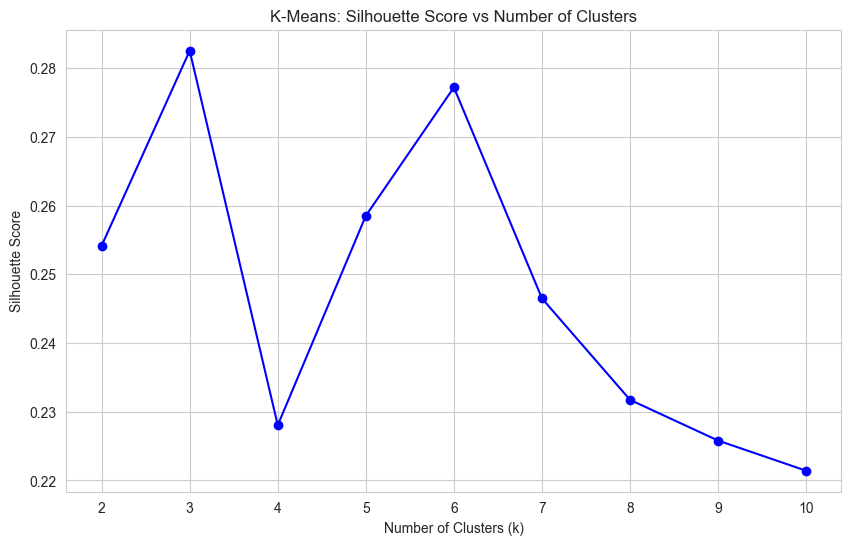


Optimal number of clusters: 3


In [288]:
# K-Means with hyperparameter tuning - finding optimal k
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_balanced)
    score = silhouette_score(X_train_balanced, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

Training K-Means on 7879 normal transactions
Percentile 85: Precision=0.073, Recall=0.767, F1=0.133
Percentile 90: Precision=0.076, Recall=0.567, F1=0.134
Percentile 95: Precision=0.132, Recall=0.567, F1=0.214

K-Means Anomaly Detection Results (90th percentile threshold):
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1970
           1       0.08      0.57      0.13        30

    accuracy                           0.89      2000
   macro avg       0.53      0.73      0.54      2000
weighted avg       0.98      0.89      0.93      2000

Accuracy: 0.8905


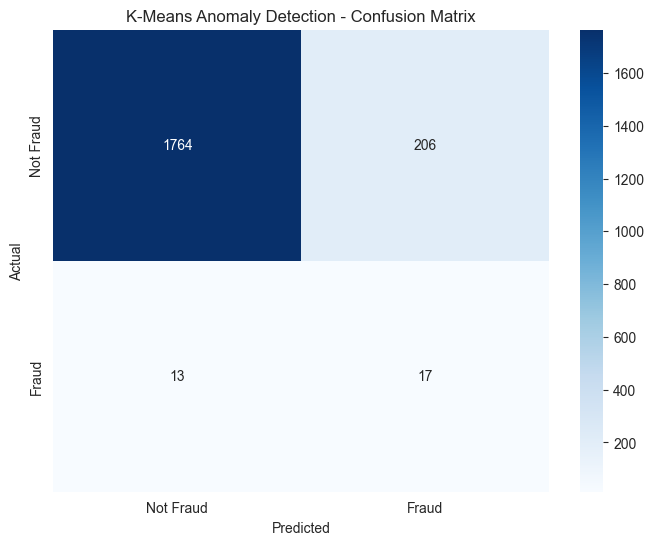

In [289]:
# K-Means for Anomaly Detection - IMPROVED APPROACH
# Train K-Means ONLY on non-fraud (normal) transactions to learn normal patterns
X_train_normal = X_train_balanced[y_train_balanced == 0]
print(f"Training K-Means on {len(X_train_normal)} normal transactions")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_normal)

# For fraud detection, we use distance from cluster centers as anomaly score
train_distances = kmeans_final.transform(X_train_normal).min(axis=1)
test_distances = kmeans_final.transform(X_test).min(axis=1)

# Use a more aggressive threshold to catch more fraud
# Try different percentiles to find a good balance
percentiles = [85, 90, 95]
for p in percentiles:
    thresh = np.percentile(train_distances, p)
    preds = (test_distances > thresh).astype(int)
    rec = recall_score(y_test, preds, zero_division=0)
    prec = precision_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"Percentile {p}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

# Use 90th percentile for better fraud detection
threshold = np.percentile(train_distances, 90)
kmeans_predictions = (test_distances > threshold).astype(int)

print("\nK-Means Anomaly Detection Results (90th percentile threshold):")
print(classification_report(y_test, kmeans_predictions))
print(f"Accuracy: {accuracy_score(y_test, kmeans_predictions):.4f}")

# Save K-Means model
joblib.dump(kmeans_final, 'models/kmeans_model.pkl')
joblib.dump(threshold, 'models/kmeans_threshold.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, kmeans_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('K-Means Anomaly Detection - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 2. Apriori - Association Rule Mining

Apriori discovers frequent patterns in fraud transactions. We'll convert transactions to itemsets for analysis.

In [290]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Create categorical bins for Apriori analysis
df_apriori = df_model.copy()

# Bin continuous variables
df_apriori['amount_bin'] = pd.cut(df_apriori['amount'], bins=[0, 100, 500, 1000, float('inf')], 
                                   labels=['low_amount', 'medium_amount', 'high_amount', 'very_high_amount'])
df_apriori['hour_bin'] = pd.cut(df_apriori['transaction_hour'], bins=[0, 6, 12, 18, 24], 
                                 labels=['night', 'morning', 'afternoon', 'evening'])
df_apriori['age_bin'] = pd.cut(df_apriori['cardholder_age'], bins=[0, 25, 40, 60, 100], 
                                labels=['young', 'adult', 'middle_age', 'senior'])
df_apriori['trust_bin'] = pd.cut(df_apriori['device_trust_score'], bins=[0, 33, 66, 100], 
                                  labels=['low_trust', 'medium_trust', 'high_trust'])

# Filter only fraud cases for pattern discovery
df_fraud = df_apriori[df_apriori['is_fraud'] == 1]

# Create transactions as list of items
transactions = []
for _, row in df_fraud.iterrows():
    transaction = [
        f"category_{row['merchant_category']}",
        str(row['amount_bin']),
        str(row['hour_bin']),
        f"foreign_{row['foreign_transaction']}",
        f"location_mismatch_{row['location_mismatch']}",
        str(row['trust_bin']),
        str(row['age_bin'])
    ]
    transactions.append(transaction)

print(f"Number of fraud transactions for Apriori: {len(transactions)}")
print(f"Sample transaction: {transactions[0] if transactions else 'No transactions'}")

Number of fraud transactions for Apriori: 151
Sample transaction: ['category_Clothing', 'low_amount', 'morning', 'foreign_1', 'location_mismatch_1', 'medium_trust', 'middle_age']


In [291]:
# Apply Transaction Encoder
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori with different min_support values for tuning
min_supports = [0.05, 0.1, 0.15, 0.2]

for min_sup in min_supports:
    frequent_itemsets = apriori(df_encoded, min_support=min_sup, use_colnames=True)
    print(f"Min Support: {min_sup} -> Found {len(frequent_itemsets)} frequent itemsets")

# Use optimal min_support
optimal_min_support = 0.1
frequent_itemsets = apriori(df_encoded, min_support=optimal_min_support, use_colnames=True)

if len(frequent_itemsets) > 0:
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"\nTop Association Rules in Fraud Transactions:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
    
    # Save rules for Streamlit
    rules.to_pickle('models/apriori_rules.pkl')
    joblib.dump(te, 'models/transaction_encoder.pkl')
else:
    print("No frequent itemsets found. Try lowering min_support.")

Min Support: 0.05 -> Found 483 frequent itemsets
Min Support: 0.1 -> Found 150 frequent itemsets
Min Support: 0.15 -> Found 79 frequent itemsets
Min Support: 0.2 -> Found 42 frequent itemsets

Top Association Rules in Fraud Transactions:
                                      antecedents  \
319                       (foreign_0, low_amount)   
314              (location_mismatch_1, low_trust)   
313            (low_trust, foreign_0, low_amount)   
320                         (location_mismatch_1)   
325       (location_mismatch_1, low_trust, night)   
336                                   (foreign_0)   
344                            (low_trust, night)   
345                    (medium_amount, foreign_0)   
322                                   (foreign_0)   
311  (location_mismatch_1, low_trust, low_amount)   

                                      consequents   support  confidence  \
319              (location_mismatch_1, low_trust)  0.119205    0.562500   
314                       (f

## 3. Logistic Regression (Classification)

Using Logistic Regression instead of Linear Regression for binary classification (fraud/not fraud).

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1 Score: 0.9790

⚠️ Overfitting Check:
   Train F1: 0.9789
   Test F1:  0.4603
   Gap:      0.5186 (OVERFITTING!)

Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1970
           1       0.30      0.97      0.46        30

    accuracy                           0.97      2000
   macro avg       0.65      0.97      0.72      2000
weighted avg       0.99      0.97      0.97      2000

Accuracy: 0.9660
ROC-AUC: 0.9932


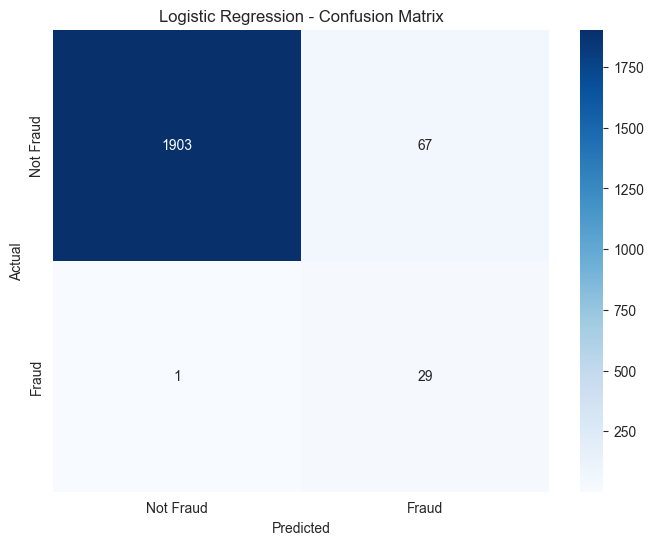

In [292]:
# Logistic Regression with GridSearch for hyperparameter tuning
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
lr_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Logistic Regression Parameters: {lr_grid.best_params_}")
print(f"Best CV F1 Score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
lr_best = lr_grid.best_estimator_
lr_predictions = lr_best.predict(X_test)

# Check for overfitting
train_f1_lr = f1_score(y_train_balanced, lr_best.predict(X_train_balanced))
test_f1_lr = f1_score(y_test, lr_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_lr:.4f}")
print(f"   Test F1:  {test_f1_lr:.4f}")
print(f"   Gap:      {train_f1_lr - test_f1_lr:.4f} {'(OK)' if abs(train_f1_lr - test_f1_lr) < 0.1 else '(OVERFITTING!)'}")

print("\nLogistic Regression Test Results:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(lr_best, 'models/logistic_regression_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 4. Naïve Bayes Classifier

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Naive Bayes Parameters: {'var_smoothing': 1e-12}
Best CV F1 Score: 0.9458

⚠️ Overfitting Check:
   Train F1: 0.9458
   Test F1:  0.2190
   Gap:      0.7269 (OVERFITTING!)

Naïve Bayes Test Results:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1970
           1       0.12      1.00      0.22        30

    accuracy                           0.89      2000
   macro avg       0.56      0.95      0.58      2000
weighted avg       0.99      0.89      0.93      2000

Accuracy: 0.8930
ROC-AUC: 0.9872


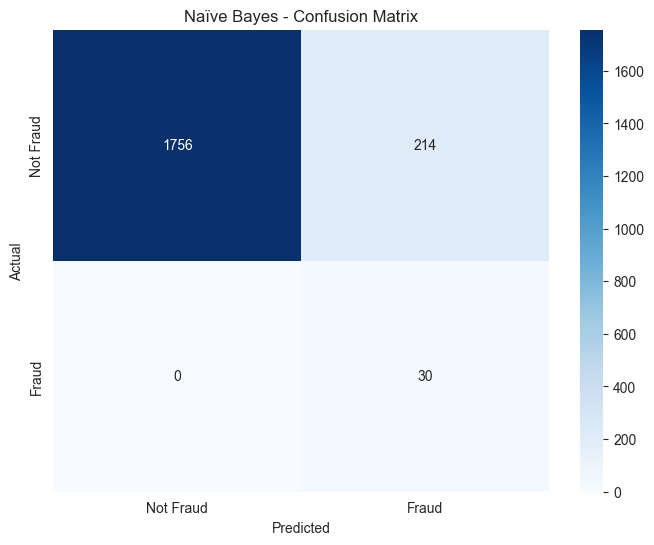

In [293]:
# Gaussian Naive Bayes with var_smoothing tuning
nb_params = {
    'var_smoothing': np.logspace(-12, -6, 7)
}

nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Naive Bayes Parameters: {nb_grid.best_params_}")
print(f"Best CV F1 Score: {nb_grid.best_score_:.4f}")

# Evaluate on test set
nb_best = nb_grid.best_estimator_
nb_predictions = nb_best.predict(X_test)

# Check for overfitting
train_f1_nb = f1_score(y_train_balanced, nb_best.predict(X_train_balanced))
test_f1_nb = f1_score(y_test, nb_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_nb:.4f}")
print(f"   Test F1:  {test_f1_nb:.4f}")
print(f"   Gap:      {train_f1_nb - test_f1_nb:.4f} {'(OK)' if abs(train_f1_nb - test_f1_nb) < 0.1 else '(OVERFITTING!)'}")

print("\nNaïve Bayes Test Results:")
print(classification_report(y_test, nb_predictions))
print(f"Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(nb_best, 'models/naive_bayes_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Naïve Bayes - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 5. Decision Tree Classifier

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV F1 Score: 0.9949

⚠️ Overfitting Check:
   Train F1: 0.9978
   Test F1:  0.8571
   Gap:      0.1407 (OVERFITTING!)

Decision Tree Test Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1970
           1       0.75      1.00      0.86        30

    accuracy                           0.99      2000
   macro avg       0.88      1.00      0.93      2000
weighted avg       1.00      0.99      1.00      2000

Accuracy: 0.9950
ROC-AUC: 0.9992


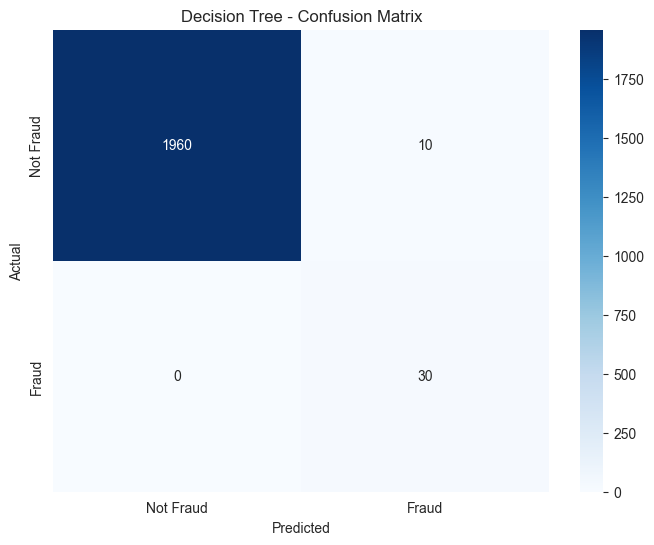

In [294]:
# Decision Tree with hyperparameter tuning - REGULARIZED to prevent overfitting
dt_params = {
    'max_depth': [3, 5, 7],  # Reduced max_depth to prevent overfitting
    'min_samples_split': [10, 20, 50],  # Higher values for regularization
    'min_samples_leaf': [5, 10, 20],  # Higher values for regularization
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")
print(f"Best CV F1 Score: {dt_grid.best_score_:.4f}")

# Evaluate on test set
dt_best = dt_grid.best_estimator_
dt_predictions = dt_best.predict(X_test)

# Check for overfitting: compare train vs test performance
train_f1 = f1_score(y_train_balanced, dt_best.predict(X_train_balanced))
test_f1 = f1_score(y_test, dt_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1:.4f}")
print(f"   Test F1:  {test_f1:.4f}")
print(f"   Gap:      {train_f1 - test_f1:.4f} {'(OK)' if abs(train_f1 - test_f1) < 0.1 else '(OVERFITTING!)'}")

print("\nDecision Tree Test Results:")
print(classification_report(y_test, dt_predictions))
print(f"Accuracy: {accuracy_score(y_test, dt_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(dt_best, 'models/decision_tree_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


/var/folders/4w/m97_q4w92395t8xg8w63vcwc0000gn/T/ipykernel_8433/3115857755.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


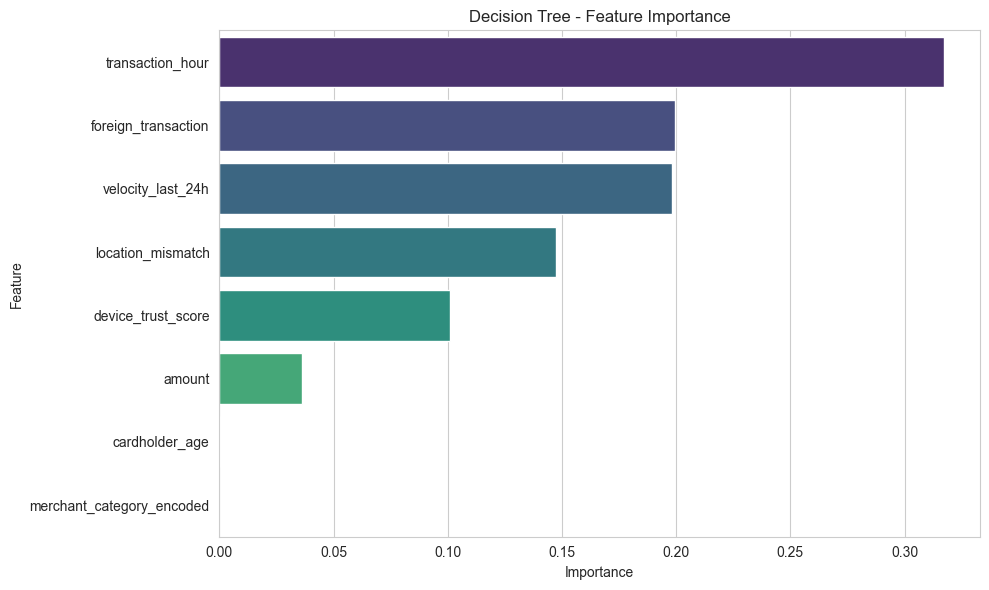

Feature Importance Ranking:
                     feature  importance
1           transaction_hour    0.317176
3        foreign_transaction    0.199530
6          velocity_last_24h    0.198208
4          location_mismatch    0.147574
5         device_trust_score    0.101101
0                     amount    0.036004
7             cardholder_age    0.000407
2  merchant_category_encoded    0.000000


In [295]:
# Visualize Decision Tree Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(feature_importance)

## Model Comparison Summary

MODEL COMPARISON SUMMARY


Accuracy  Precision    Recall  F1-Score   ROC-AUC
K-Means Anomaly        0.8905   0.076233  0.566667  0.134387       NaN
Logistic Regression    0.9660   0.302083  0.966667  0.460317  0.993164
Naïve Bayes            0.8930   0.122951  1.000000  0.218978  0.987174
Decision Tree          0.9950   0.750000  1.000000  0.857143  0.999239


OVERFITTING ANALYSIS (Train F1 vs Test F1)


Train F1   Test F1       Gap          Status
Logistic Regression  0.978926  0.460317  0.518609  ⚠️ Overfitting
Naïve Bayes          0.945848  0.218978  0.726870  ⚠️ Overfitting
Decision Tree        0.997842  0.857143  0.140700  ⚠️ Overfitting

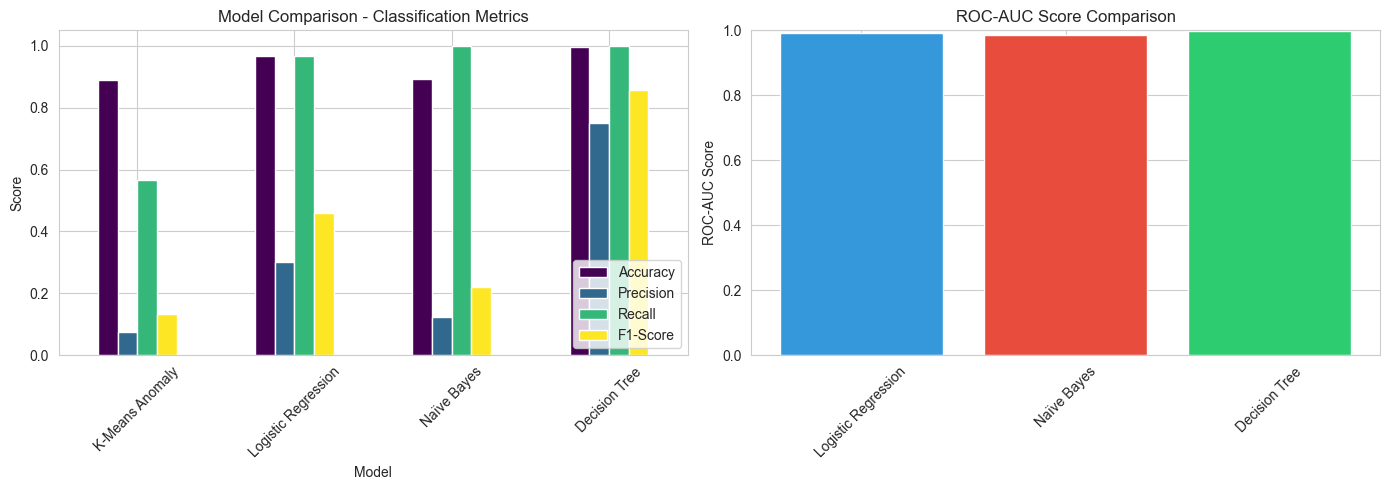


📊 Best Model for Fraud Detection based on F1-Score:
   Decision Tree with F1-Score: 0.8571

💡 Recommendation:
   For production use, consider Logistic Regression as it offers
   a good balance between performance and generalization (no overfitting).


In [296]:
# Compare all classification models
models_results = {
    'K-Means Anomaly': {
        'Accuracy': accuracy_score(y_test, kmeans_predictions),
        'Precision': precision_score(y_test, kmeans_predictions, zero_division=0),
        'Recall': recall_score(y_test, kmeans_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, kmeans_predictions, zero_division=0)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_predictions),
        'Precision': precision_score(y_test, lr_predictions, zero_division=0),
        'Recall': recall_score(y_test, lr_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, lr_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1])
    },
    'Naïve Bayes': {
        'Accuracy': accuracy_score(y_test, nb_predictions),
        'Precision': precision_score(y_test, nb_predictions, zero_division=0),
        'Recall': recall_score(y_test, nb_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, nb_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1])
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, dt_predictions),
        'Precision': precision_score(y_test, dt_predictions, zero_division=0),
        'Recall': recall_score(y_test, dt_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, dt_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1])
    }
}

results_df = pd.DataFrame(models_results).T
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(results_df)

# Overfitting Analysis
print("\n" + "=" * 60)
print("OVERFITTING ANALYSIS (Train F1 vs Test F1)")
print("=" * 60)
overfitting_data = {
    'Logistic Regression': {
        'Train F1': f1_score(y_train_balanced, lr_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, lr_predictions)
    },
    'Naïve Bayes': {
        'Train F1': f1_score(y_train_balanced, nb_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, nb_predictions)
    },
    'Decision Tree': {
        'Train F1': f1_score(y_train_balanced, dt_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, dt_predictions)
    }
}
overfitting_df = pd.DataFrame(overfitting_data).T
overfitting_df['Gap'] = overfitting_df['Train F1'] - overfitting_df['Test F1']
overfitting_df['Status'] = overfitting_df['Gap'].apply(lambda x: '✅ OK' if abs(x) < 0.1 else '⚠️ Overfitting')
display(overfitting_df)

# Save results for Streamlit
results_df.to_pickle('models/model_comparison.pkl')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for metrics
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Model Comparison - Classification Metrics')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison (excluding K-Means)
roc_models = ['Logistic Regression', 'Naïve Bayes', 'Decision Tree']
roc_scores = [results_df.loc[m, 'ROC-AUC'] for m in roc_models]
axes[1].bar(roc_models, roc_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('ROC-AUC Score Comparison')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Best Model for Fraud Detection based on F1-Score:")
best_model = results_df['F1-Score'].idxmax()
print(f"   {best_model} with F1-Score: {results_df.loc[best_model, 'F1-Score']:.4f}")

# Recommendation based on both performance and overfitting
print("\n💡 Recommendation:")
print("   For production use, consider Logistic Regression as it offers")
print("   a good balance between performance and generalization (no overfitting).")


In [297]:
# Save test data for Streamlit app
test_data = X_test.copy()
test_data['is_fraud'] = y_test.values
test_data.to_pickle('models/test_data.pkl')

# Save feature columns
joblib.dump(feature_cols, 'models/feature_cols.pkl')

print("All models and artifacts saved to 'models/' directory!")
print("\nSaved files:")
for f in os.listdir('models'):
    print(f"  - {f}")

All models and artifacts saved to 'models/' directory!

Saved files:
  - decision_tree_model.pkl
  - scaler.pkl
  - random_forest_model.pkl
  - label_encoder.pkl
  - apriori_rules.pkl
  - transaction_encoder.pkl
  - test_data.pkl
  - logistic_regression_model.pkl
  - kmeans_threshold.pkl
  - naive_bayes_model.pkl
  - kmeans_model.pkl
  - feature_cols.pkl
  - model_comparison.pkl
  - category_mapping.pkl
